<a href="https://colab.research.google.com/github/dawidstajszczyk/thesis_APO/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ekstrakcja danych ze strony: https://www.kaggle.com/datasets/dawidstajszczyk00/dice-r0ll

In [1]:
import zipfile
import os
from google.colab import drive

# Montuj Google Drive
drive.mount('/content/drive')

# Skopiuj plik kaggle.json do środowiska Colab
!cp '/content/drive/MyDrive/kaggle/kaggle.json' '/content'
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Pobierz zestaw danych
!kaggle datasets download -d dawidstajszczyk00/dice-r0ll

# Ścieżka do katalogu, gdzie znajduje się pobrany plik ZIP
zip_file_path = '/content/dice-r0ll.zip'

# Katalog docelowy dla rozpakowwanych danych
extracted_folder_path = '/content/extracted_images'

# Rozpakuj plik ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dice-r0ll.zip: Skipping, found more recently modified local copy (use --force to force download)


Przetwarzanie obrazów

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def count_black_dots(image_path):
    # Wczytanie obrazu
    image = cv2.imread(image_path)

    # Przekształcenie obrazu na odcienie szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Rozmycie Gaussowskie w celu wygładzenia krawędzi
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    #cv2_imshow(blurred)

    # Binaryzacja obrazu (czarne kropki będą miały wartość 0)
    _, binary = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)
    #cv2_imshow(binary)

    # Detekcja krawędzi w obrazie
    edges = cv2.Canny(binary, 50, 150)
    #cv2_imshow(edges)

    # Zastosowanie dylatacji w celu połączenia ewentualnych przerw w krawędziach
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    #cv2_imshow(dilated)

    # Utworzenie kopii obrazu, na którym będą rysowane kontury czarnych kropek
    dots_image = dilated.copy()

    # Znalezienie konturów w obrazie
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Rysowanie konturów
    cv2.drawContours(dots_image, contours, -1, (0, 255, 0), 2)

    # Zliczenie czarnych kropek na podstawie pola powierzchni i kolistości
    black_dot_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100:  # Minimalna wielkość obszaru, aby uznać go za czarną kropkę
            continue

        # Sprawdzenie, czy kontur jest zbliżony do kształtu okręgu
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > 0.8:  # Określ próg, powyżej którego uznajemy kształt za okrągły
            #cv2.drawContours(dots_image, [contour], -1, (0, 255, 0), 2)
            black_dot_count += 1

    # Wyświetlenie obrazu z konturami czarnych kropek
    #cv2_imshow(dots_image)

    return black_dot_count, dots_image

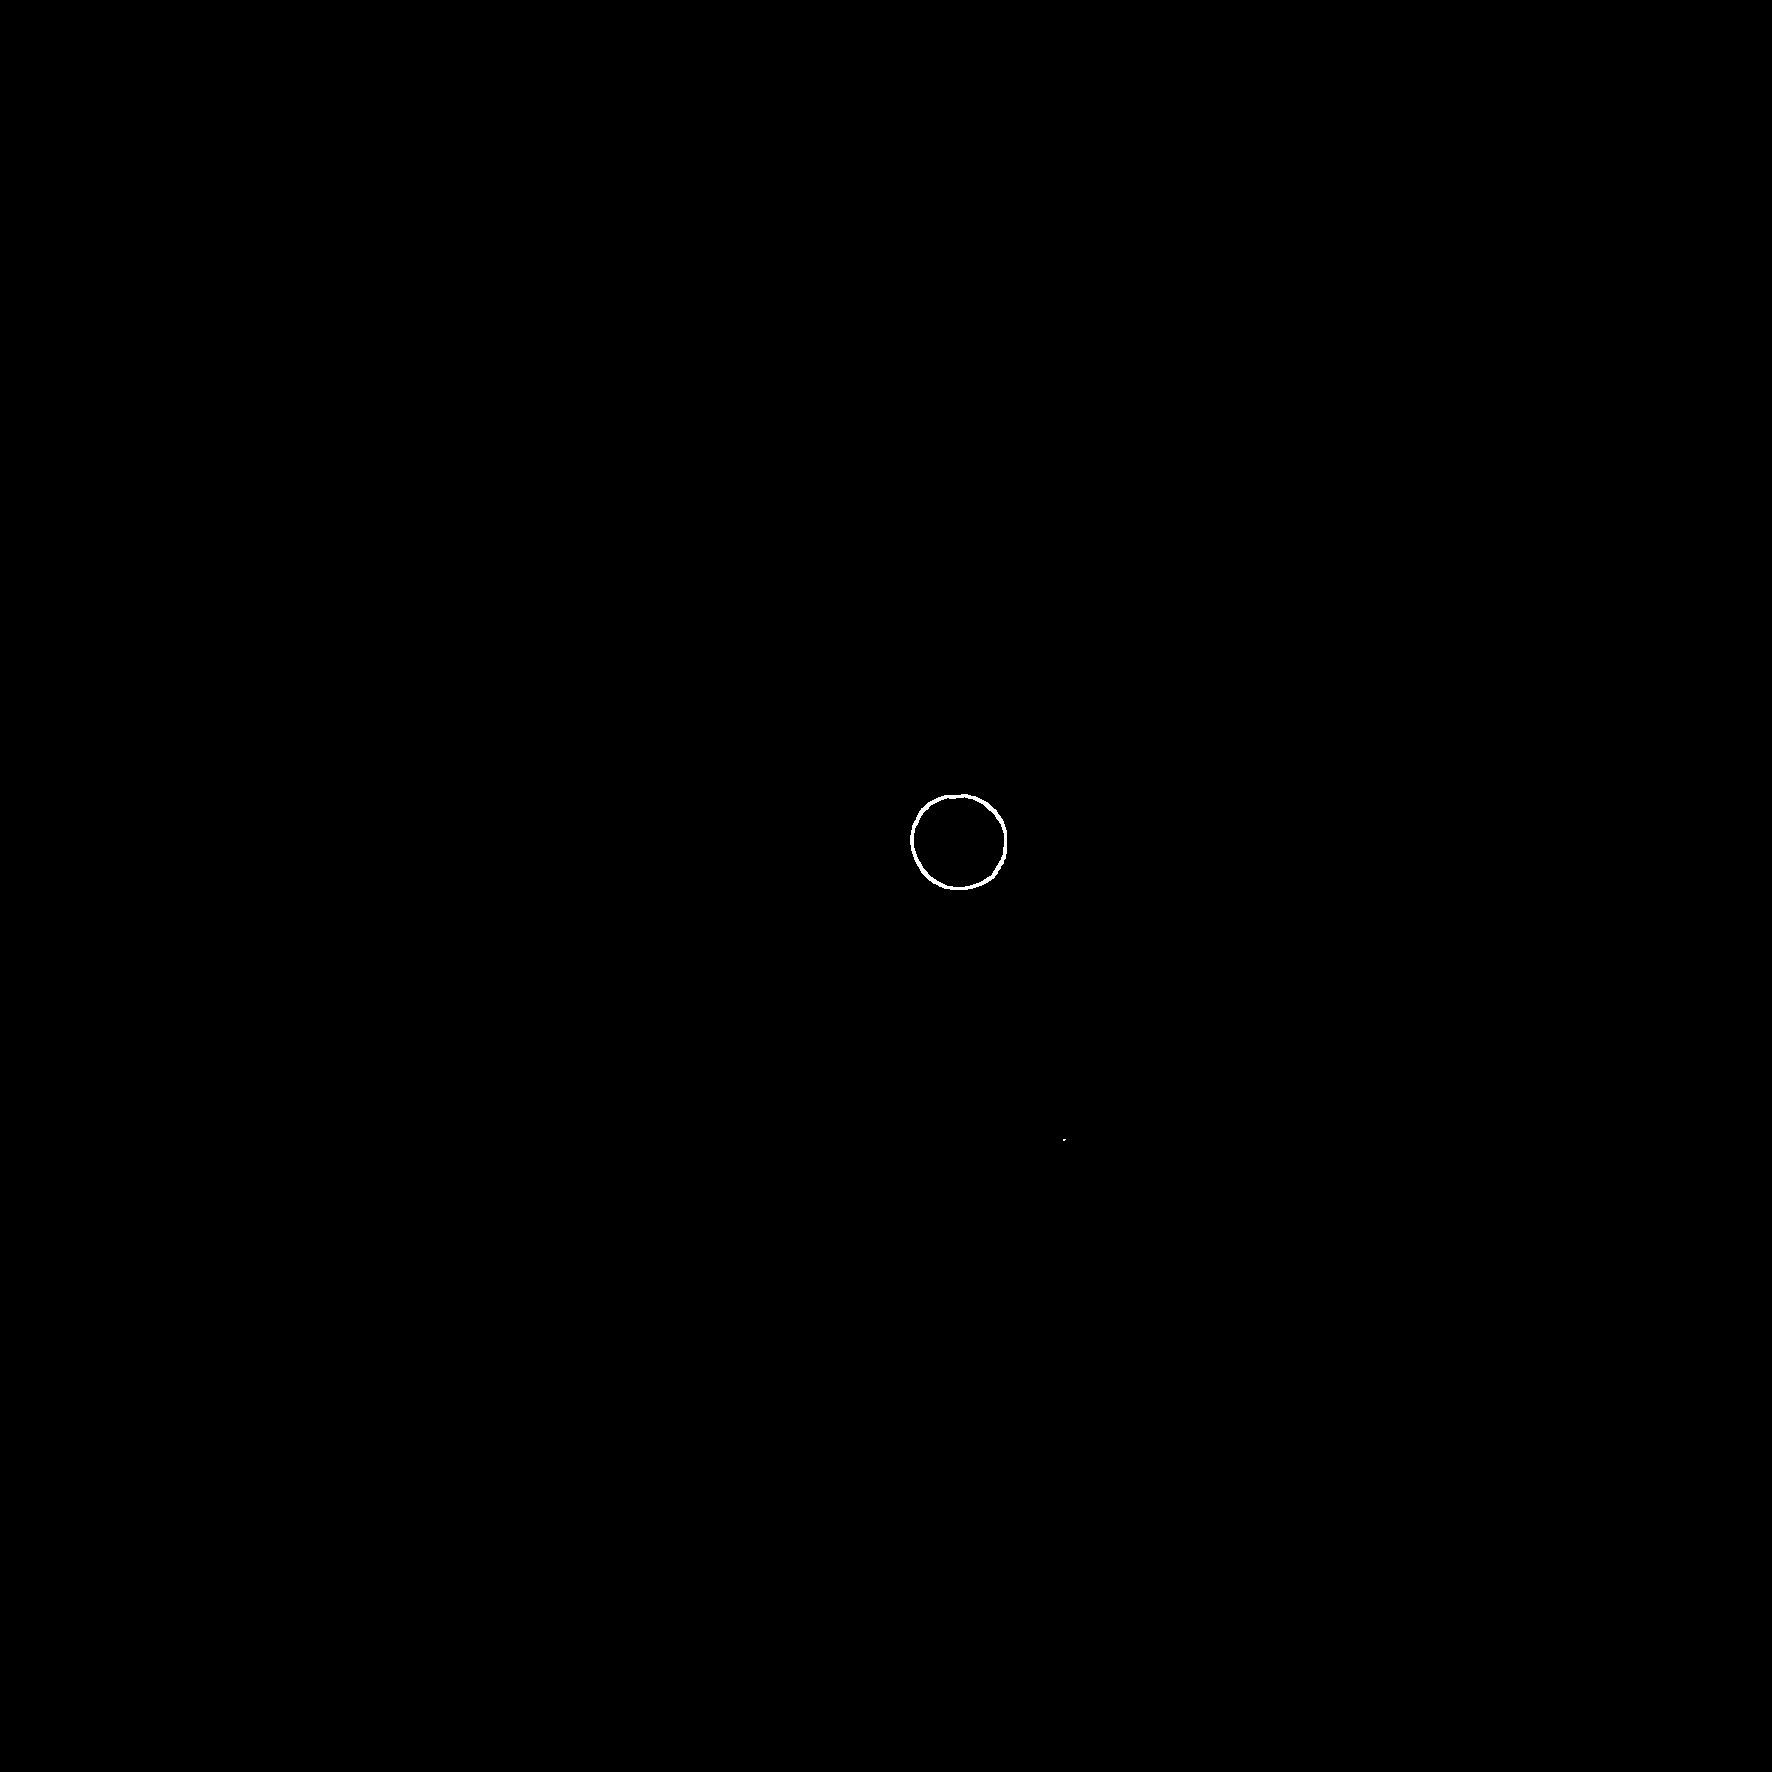

Liczba czarnych kropek: 1


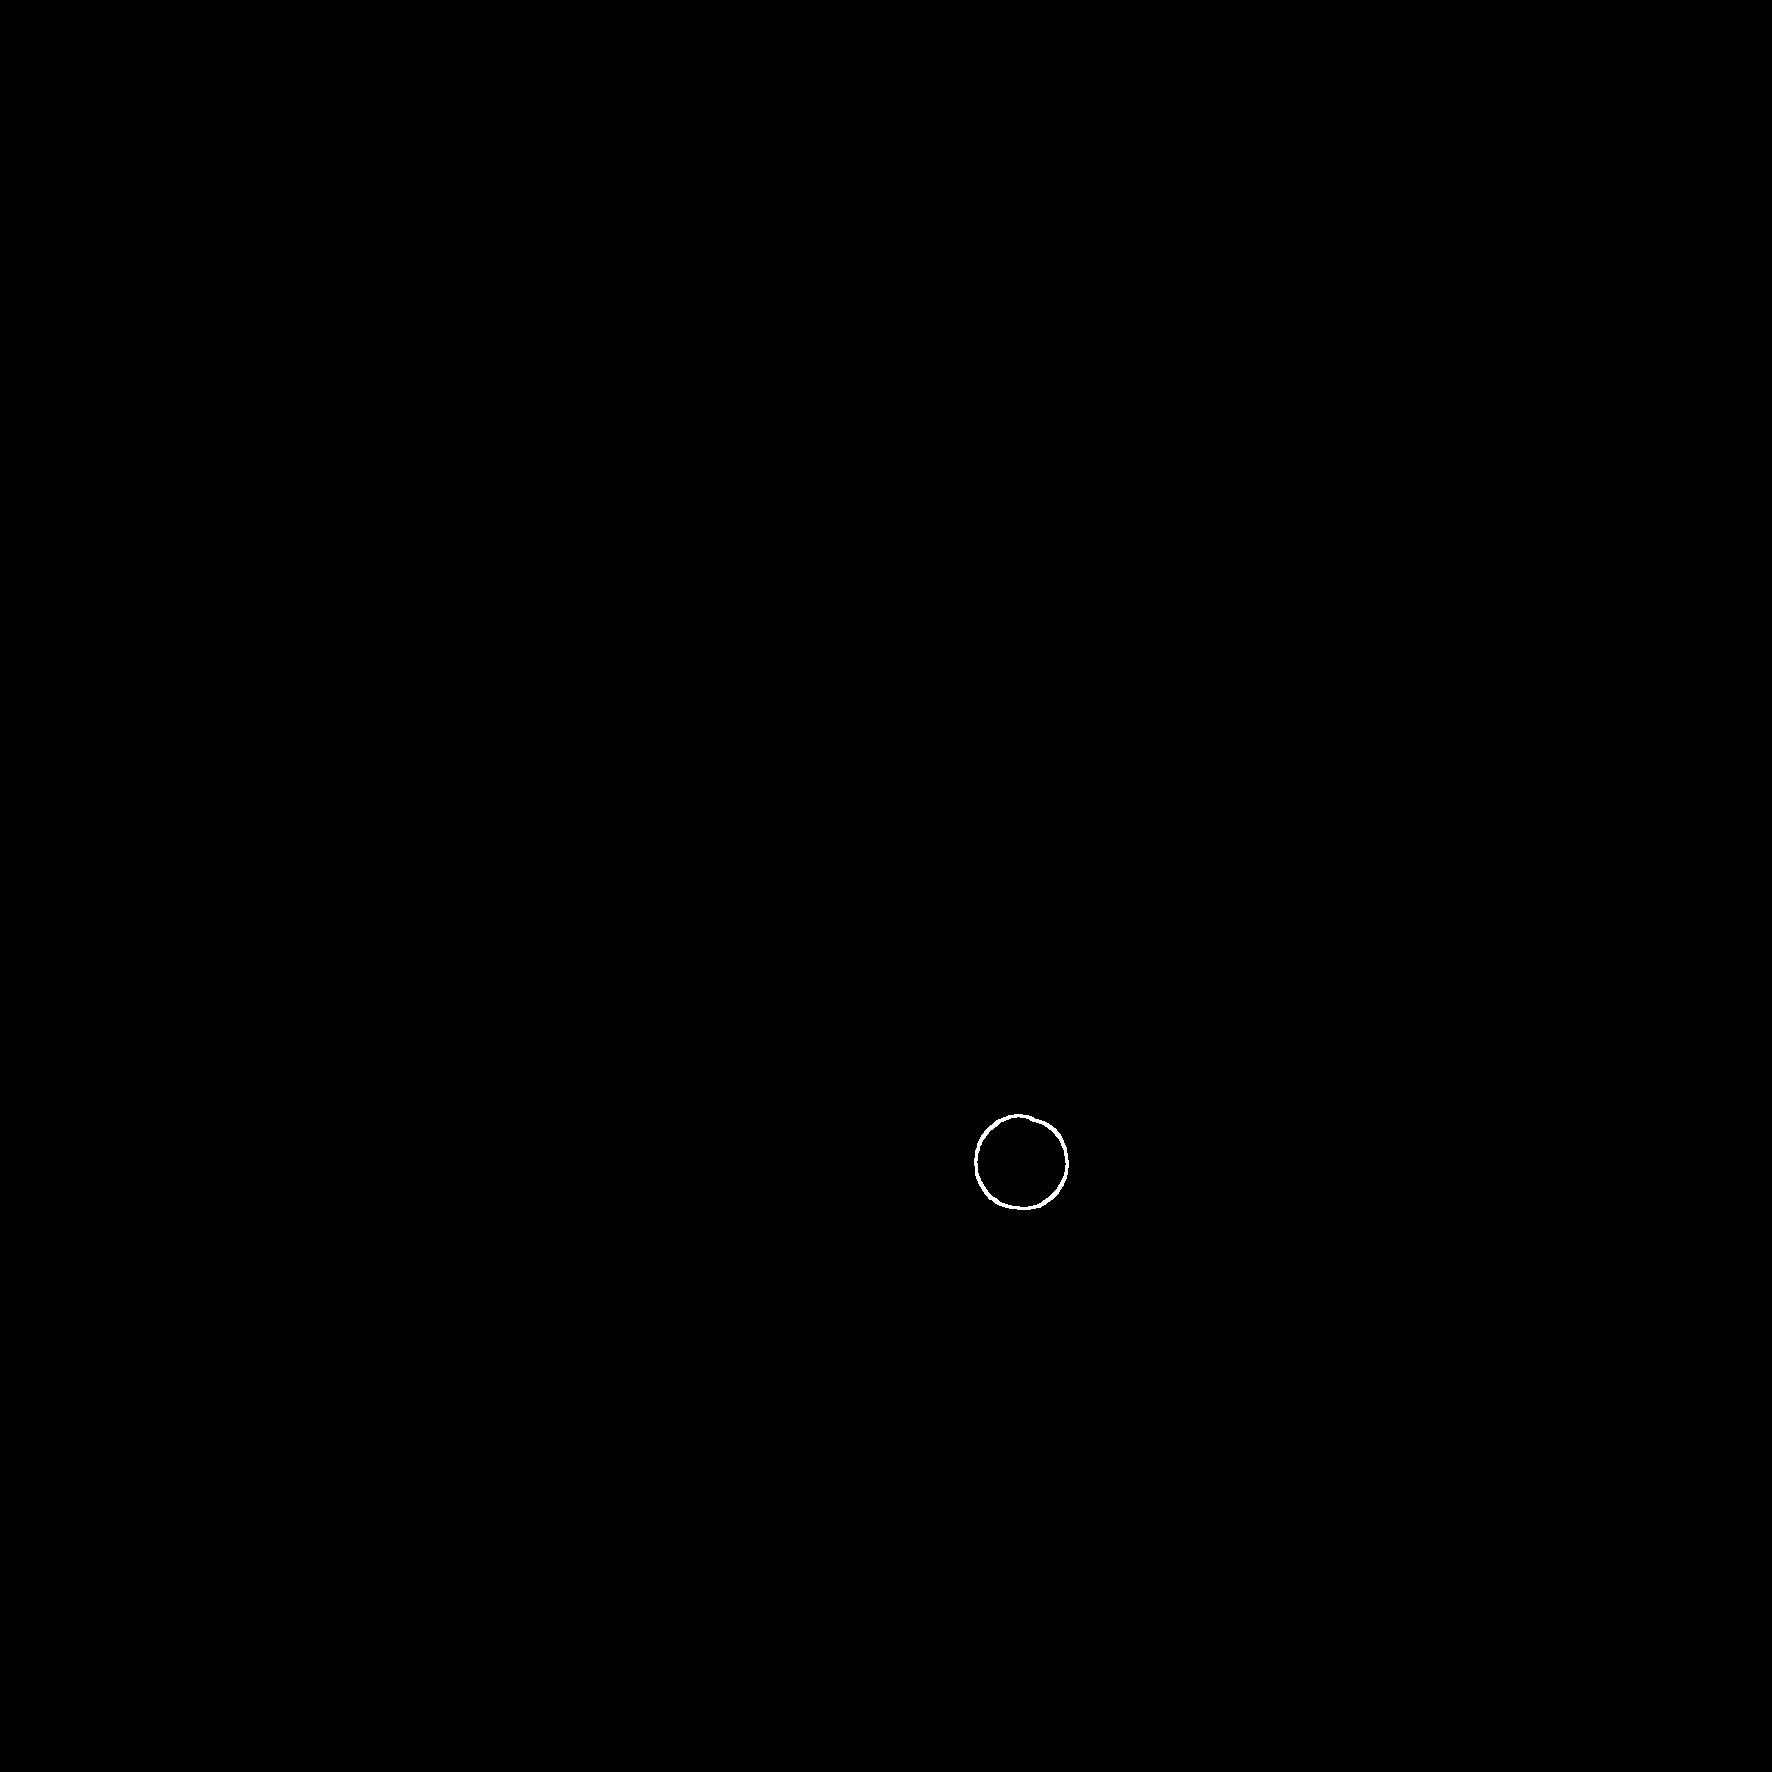

Liczba czarnych kropek: 1


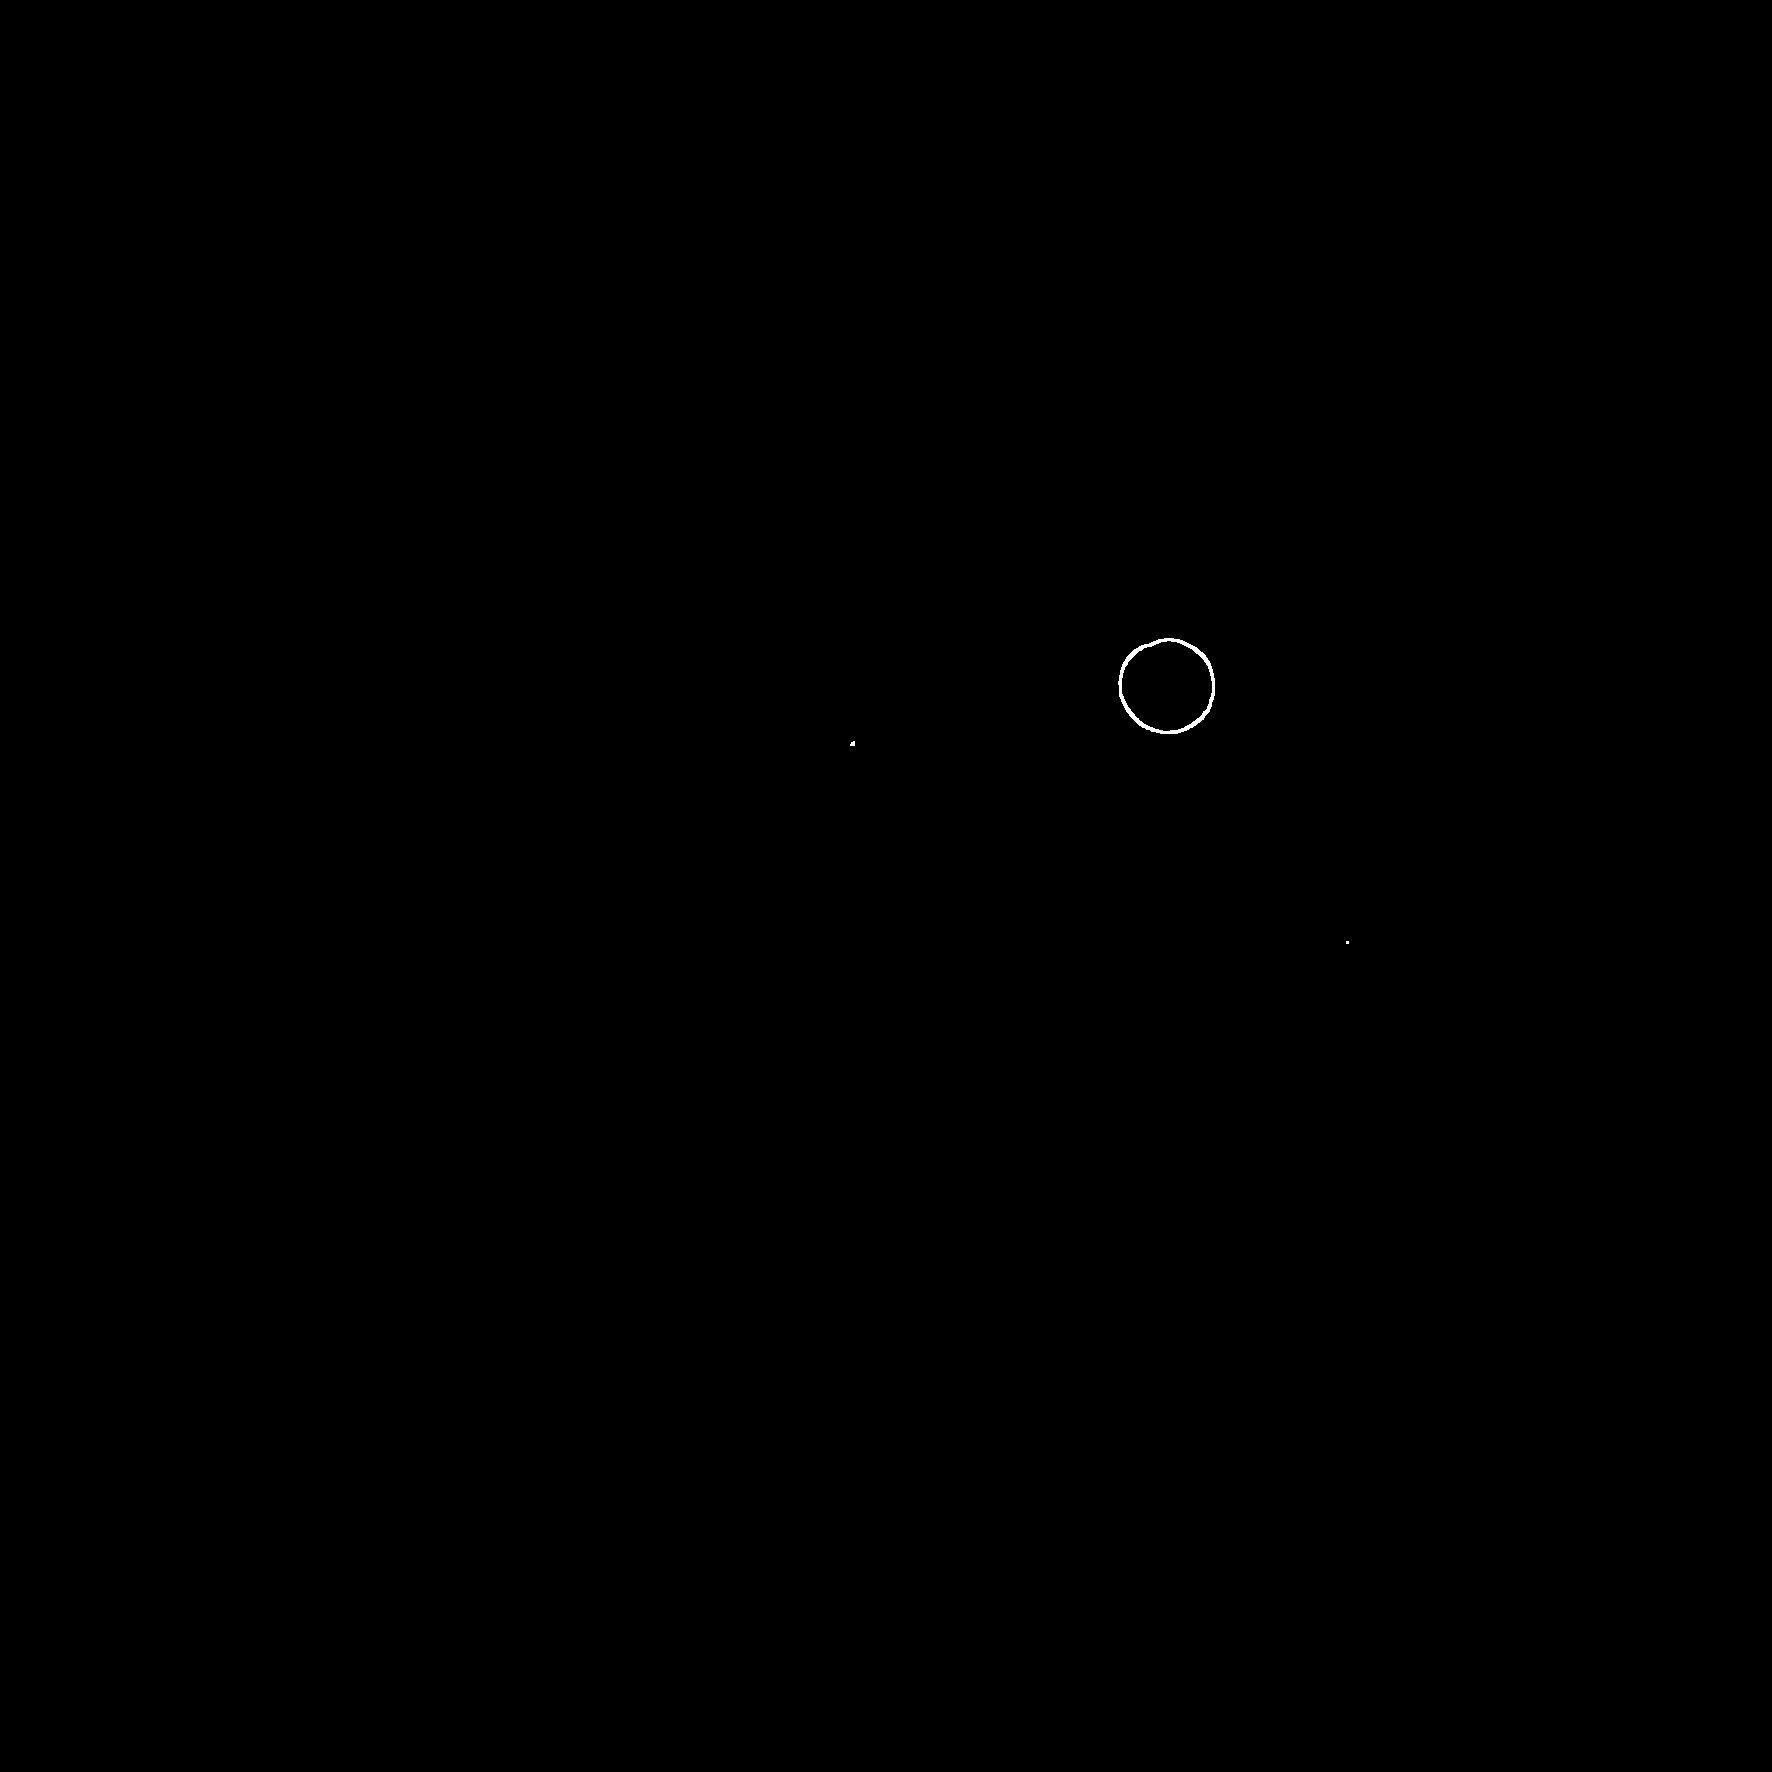

Liczba czarnych kropek: 1


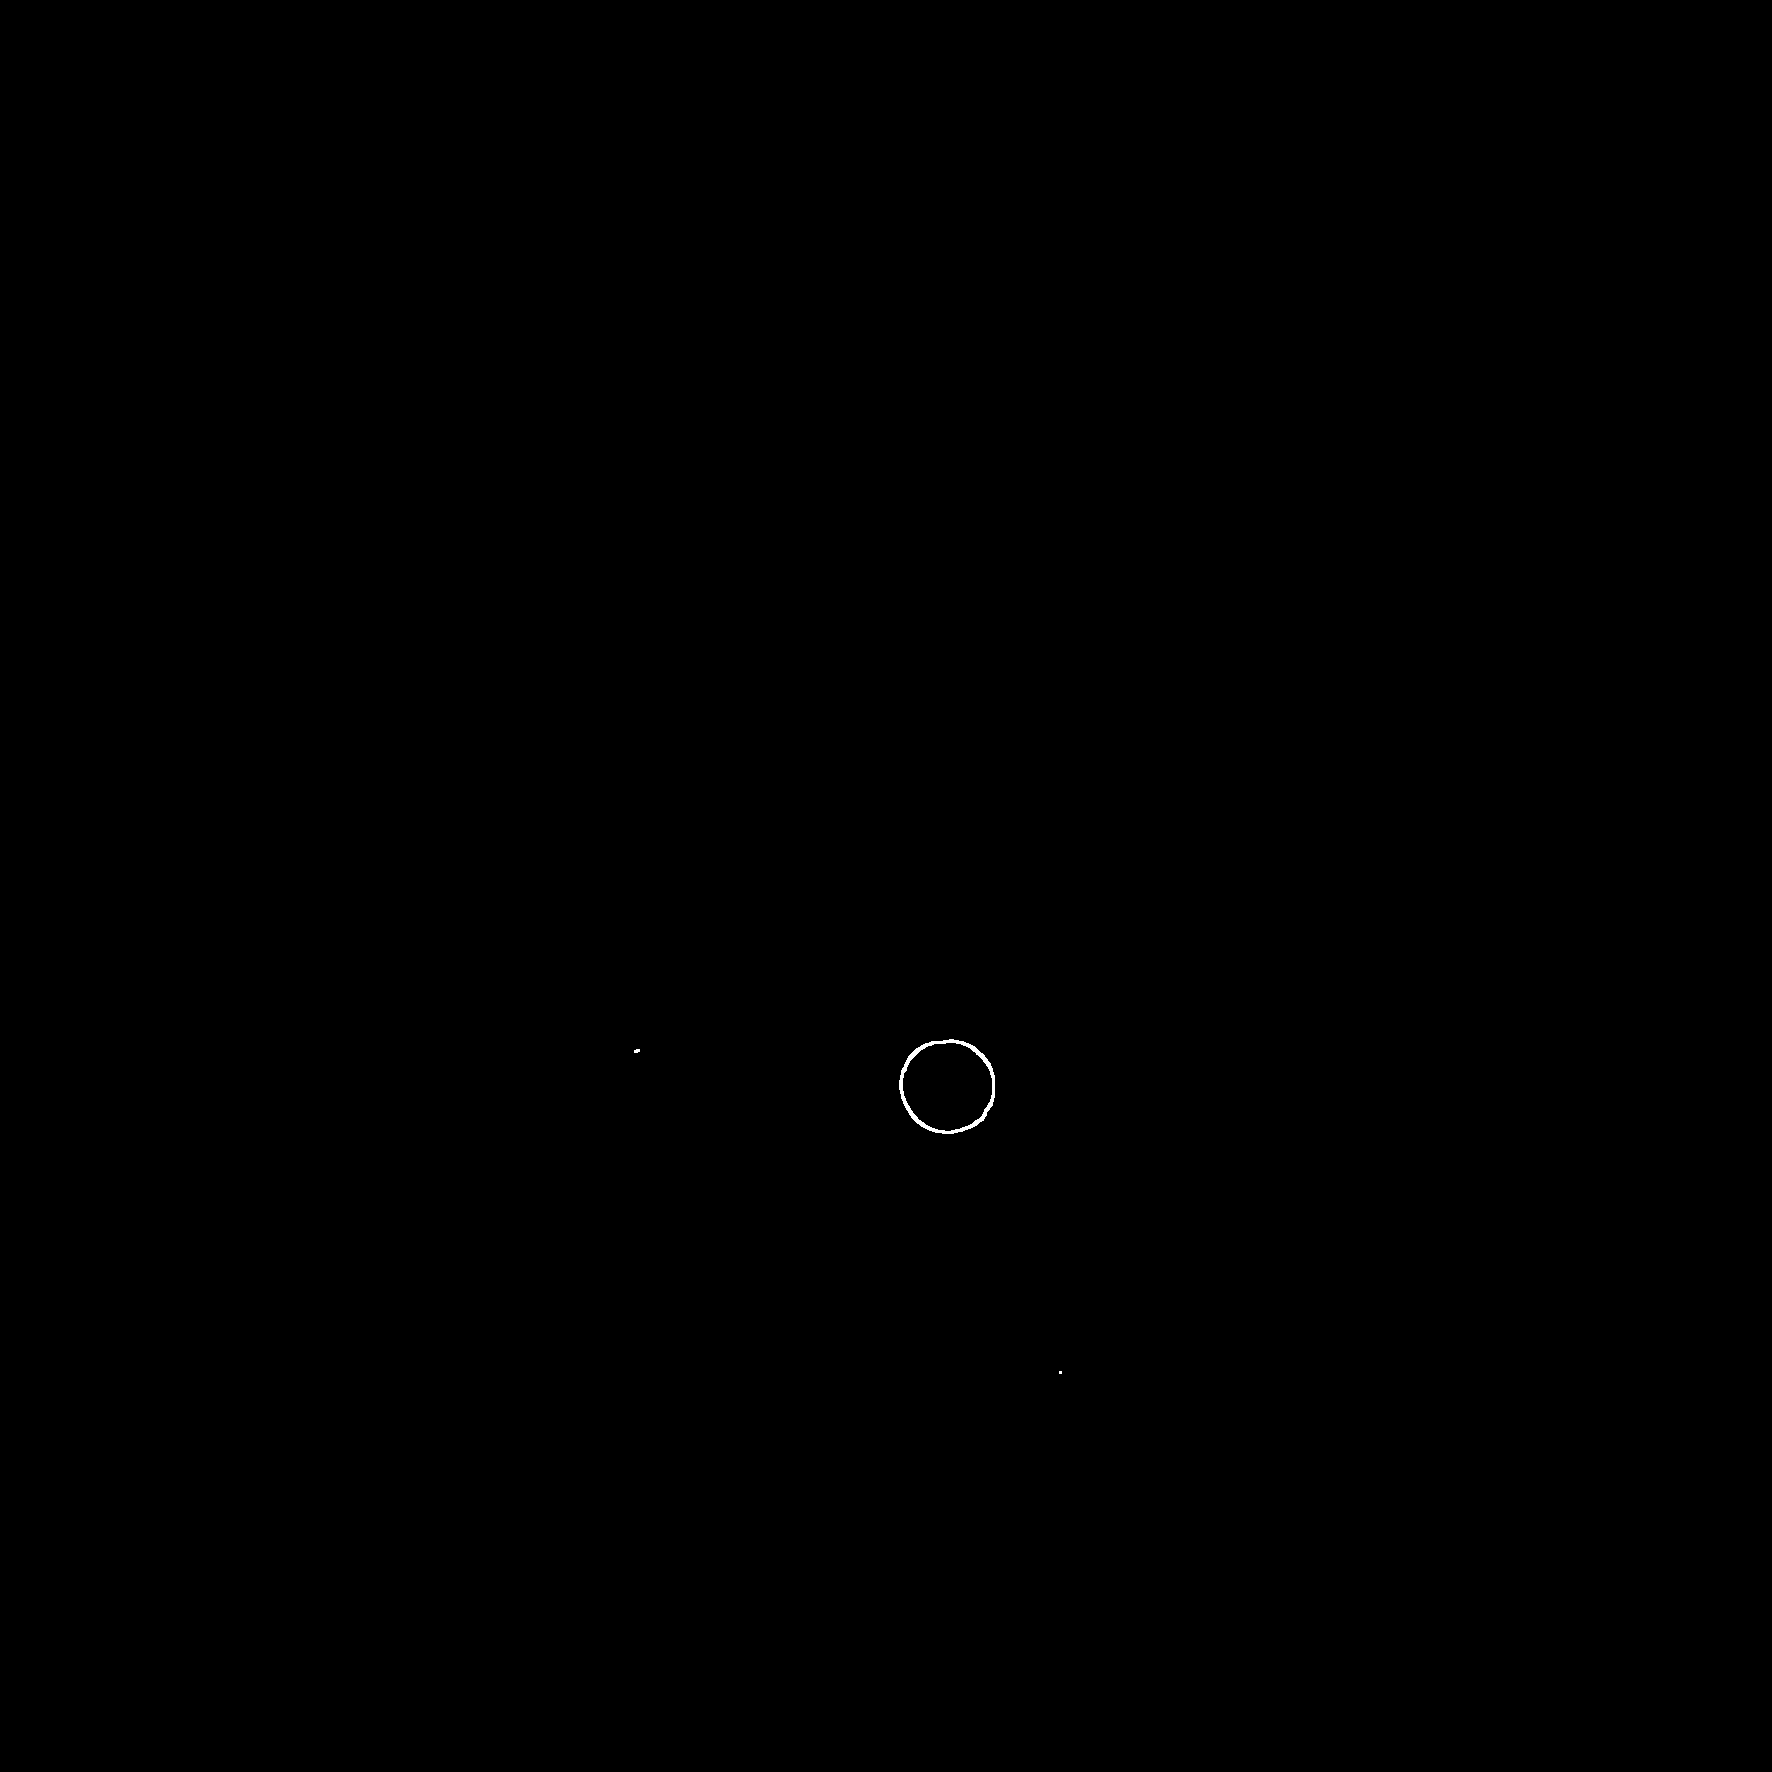

Liczba czarnych kropek: 1


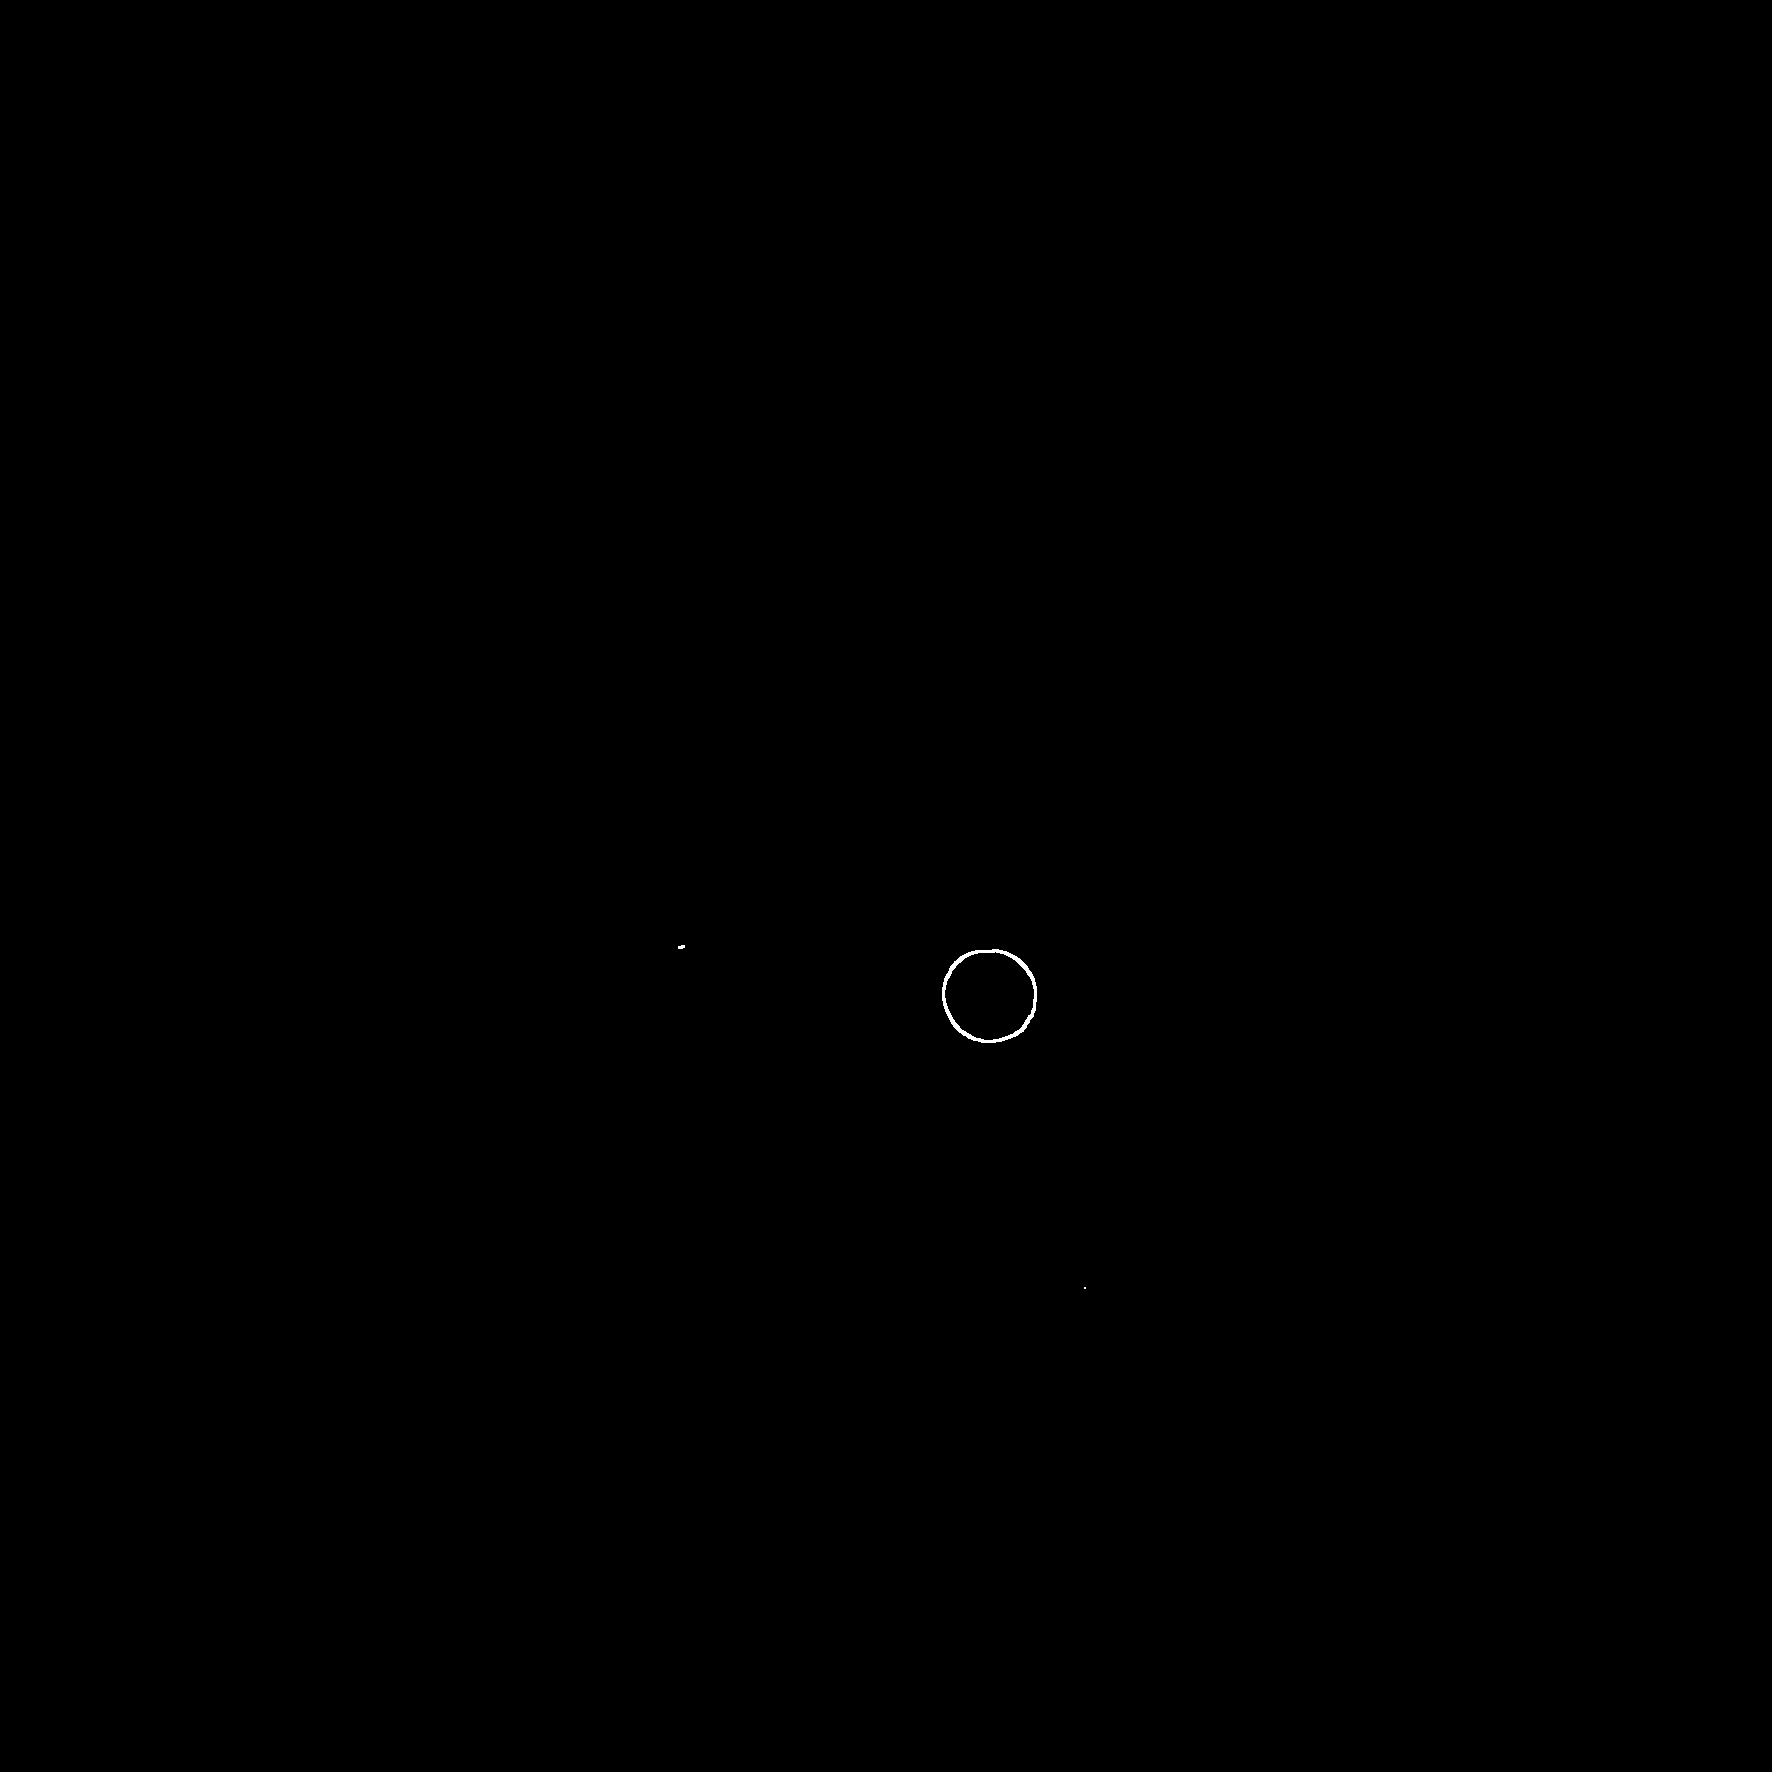

Liczba czarnych kropek: 1


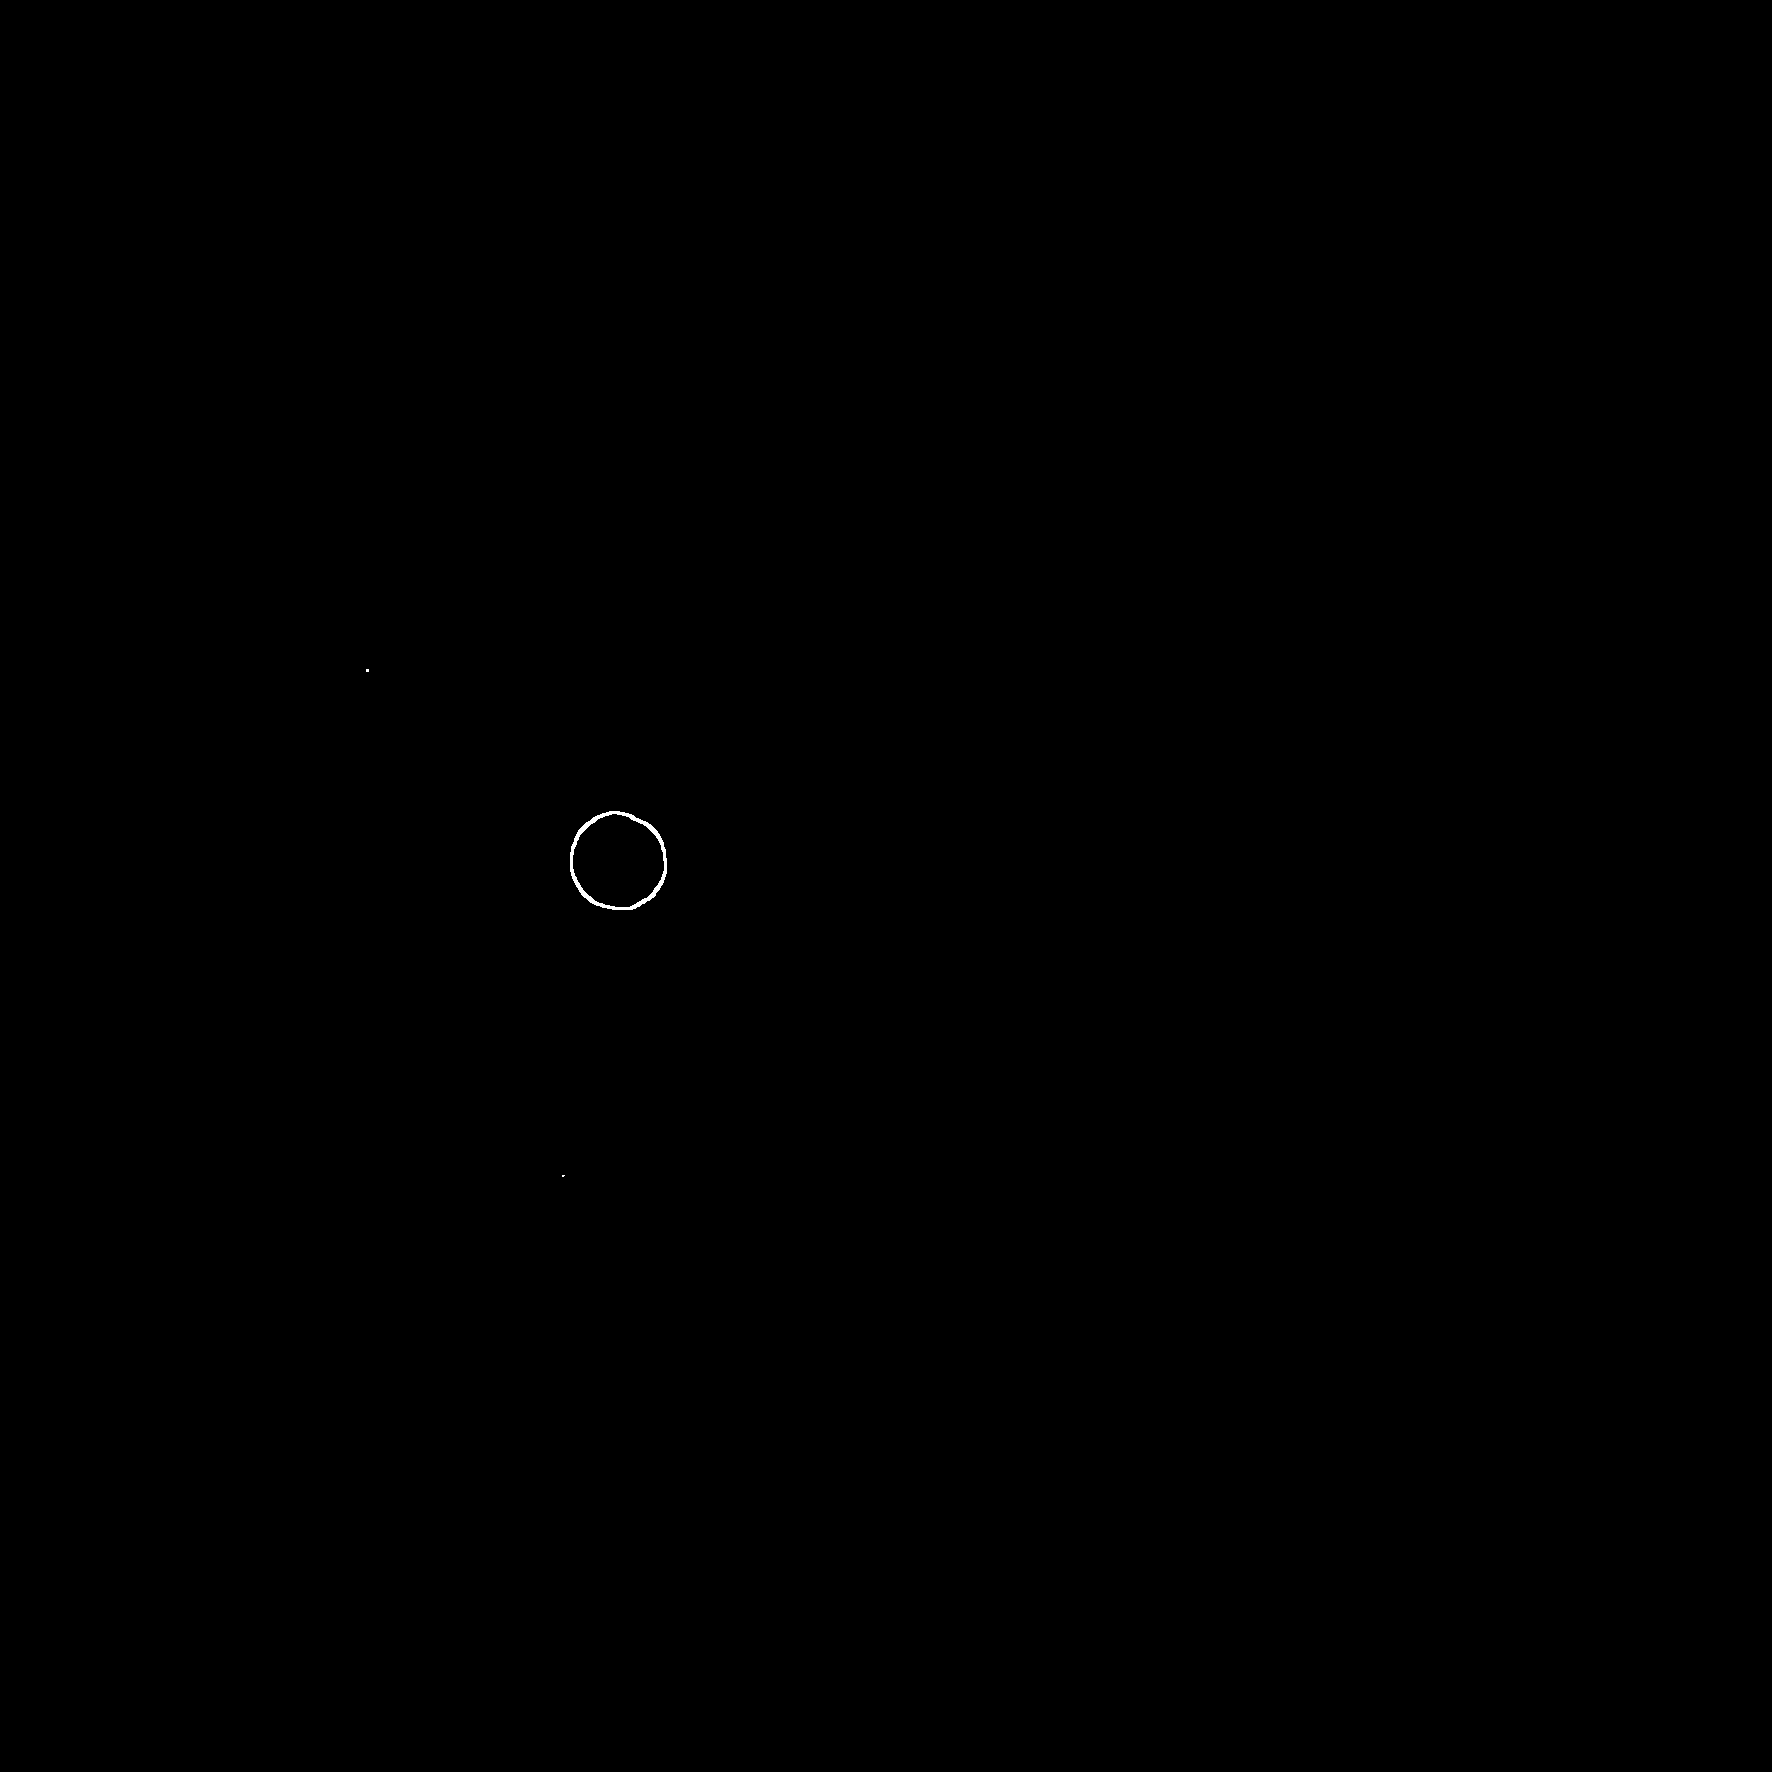

Liczba czarnych kropek: 1


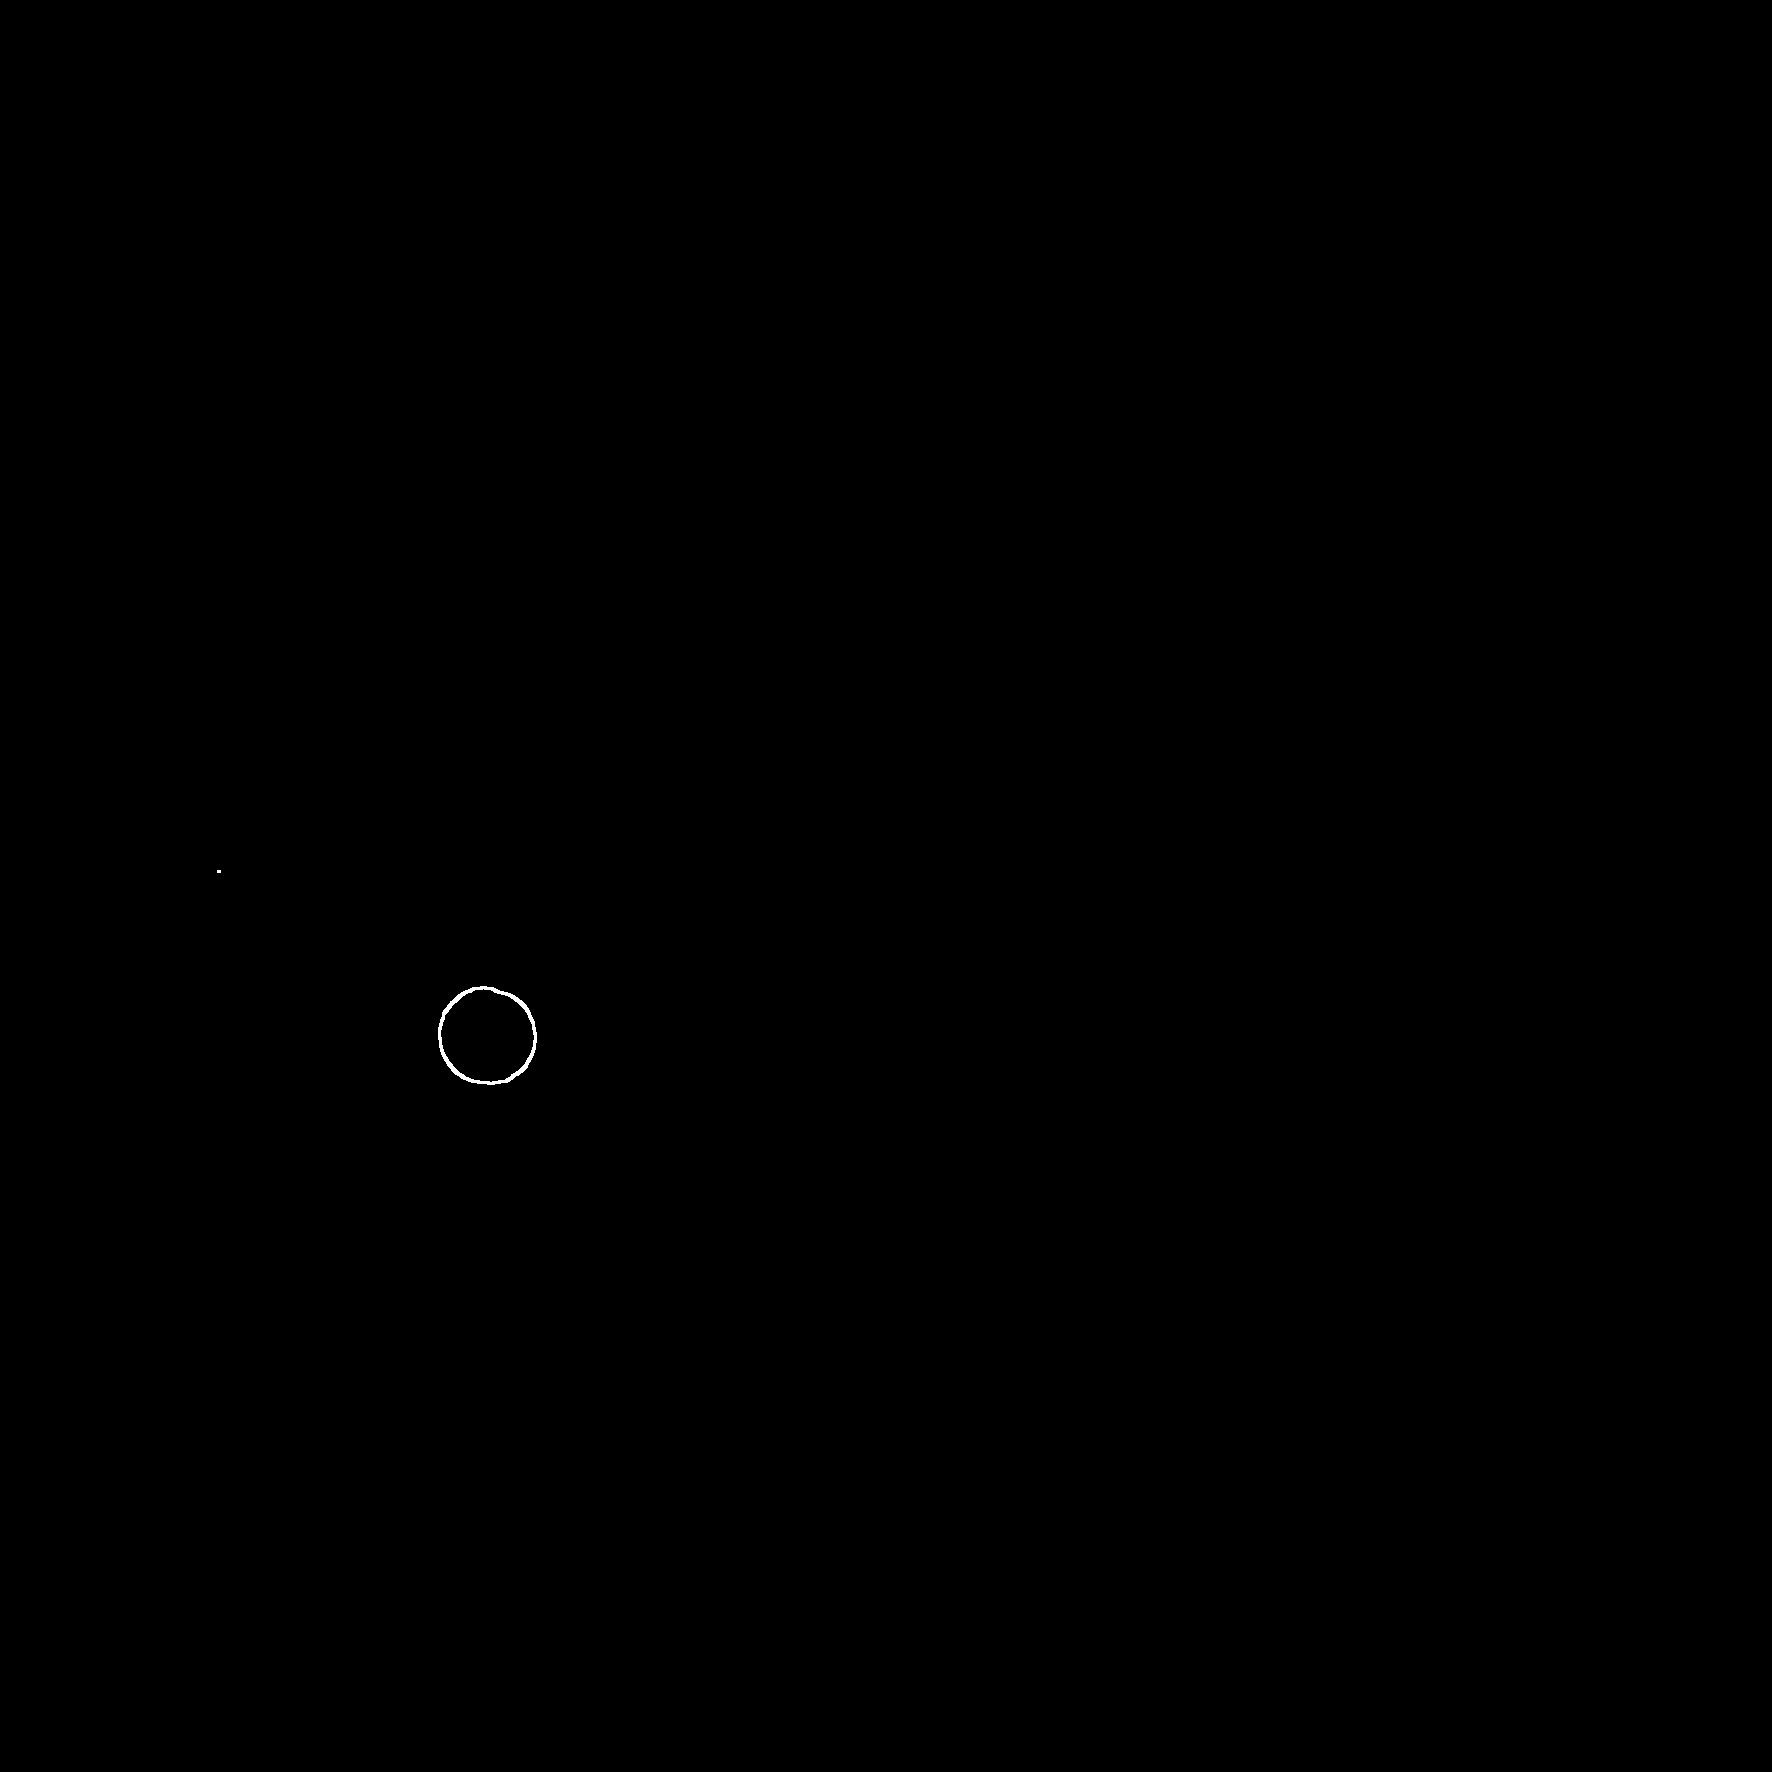

Liczba czarnych kropek: 1


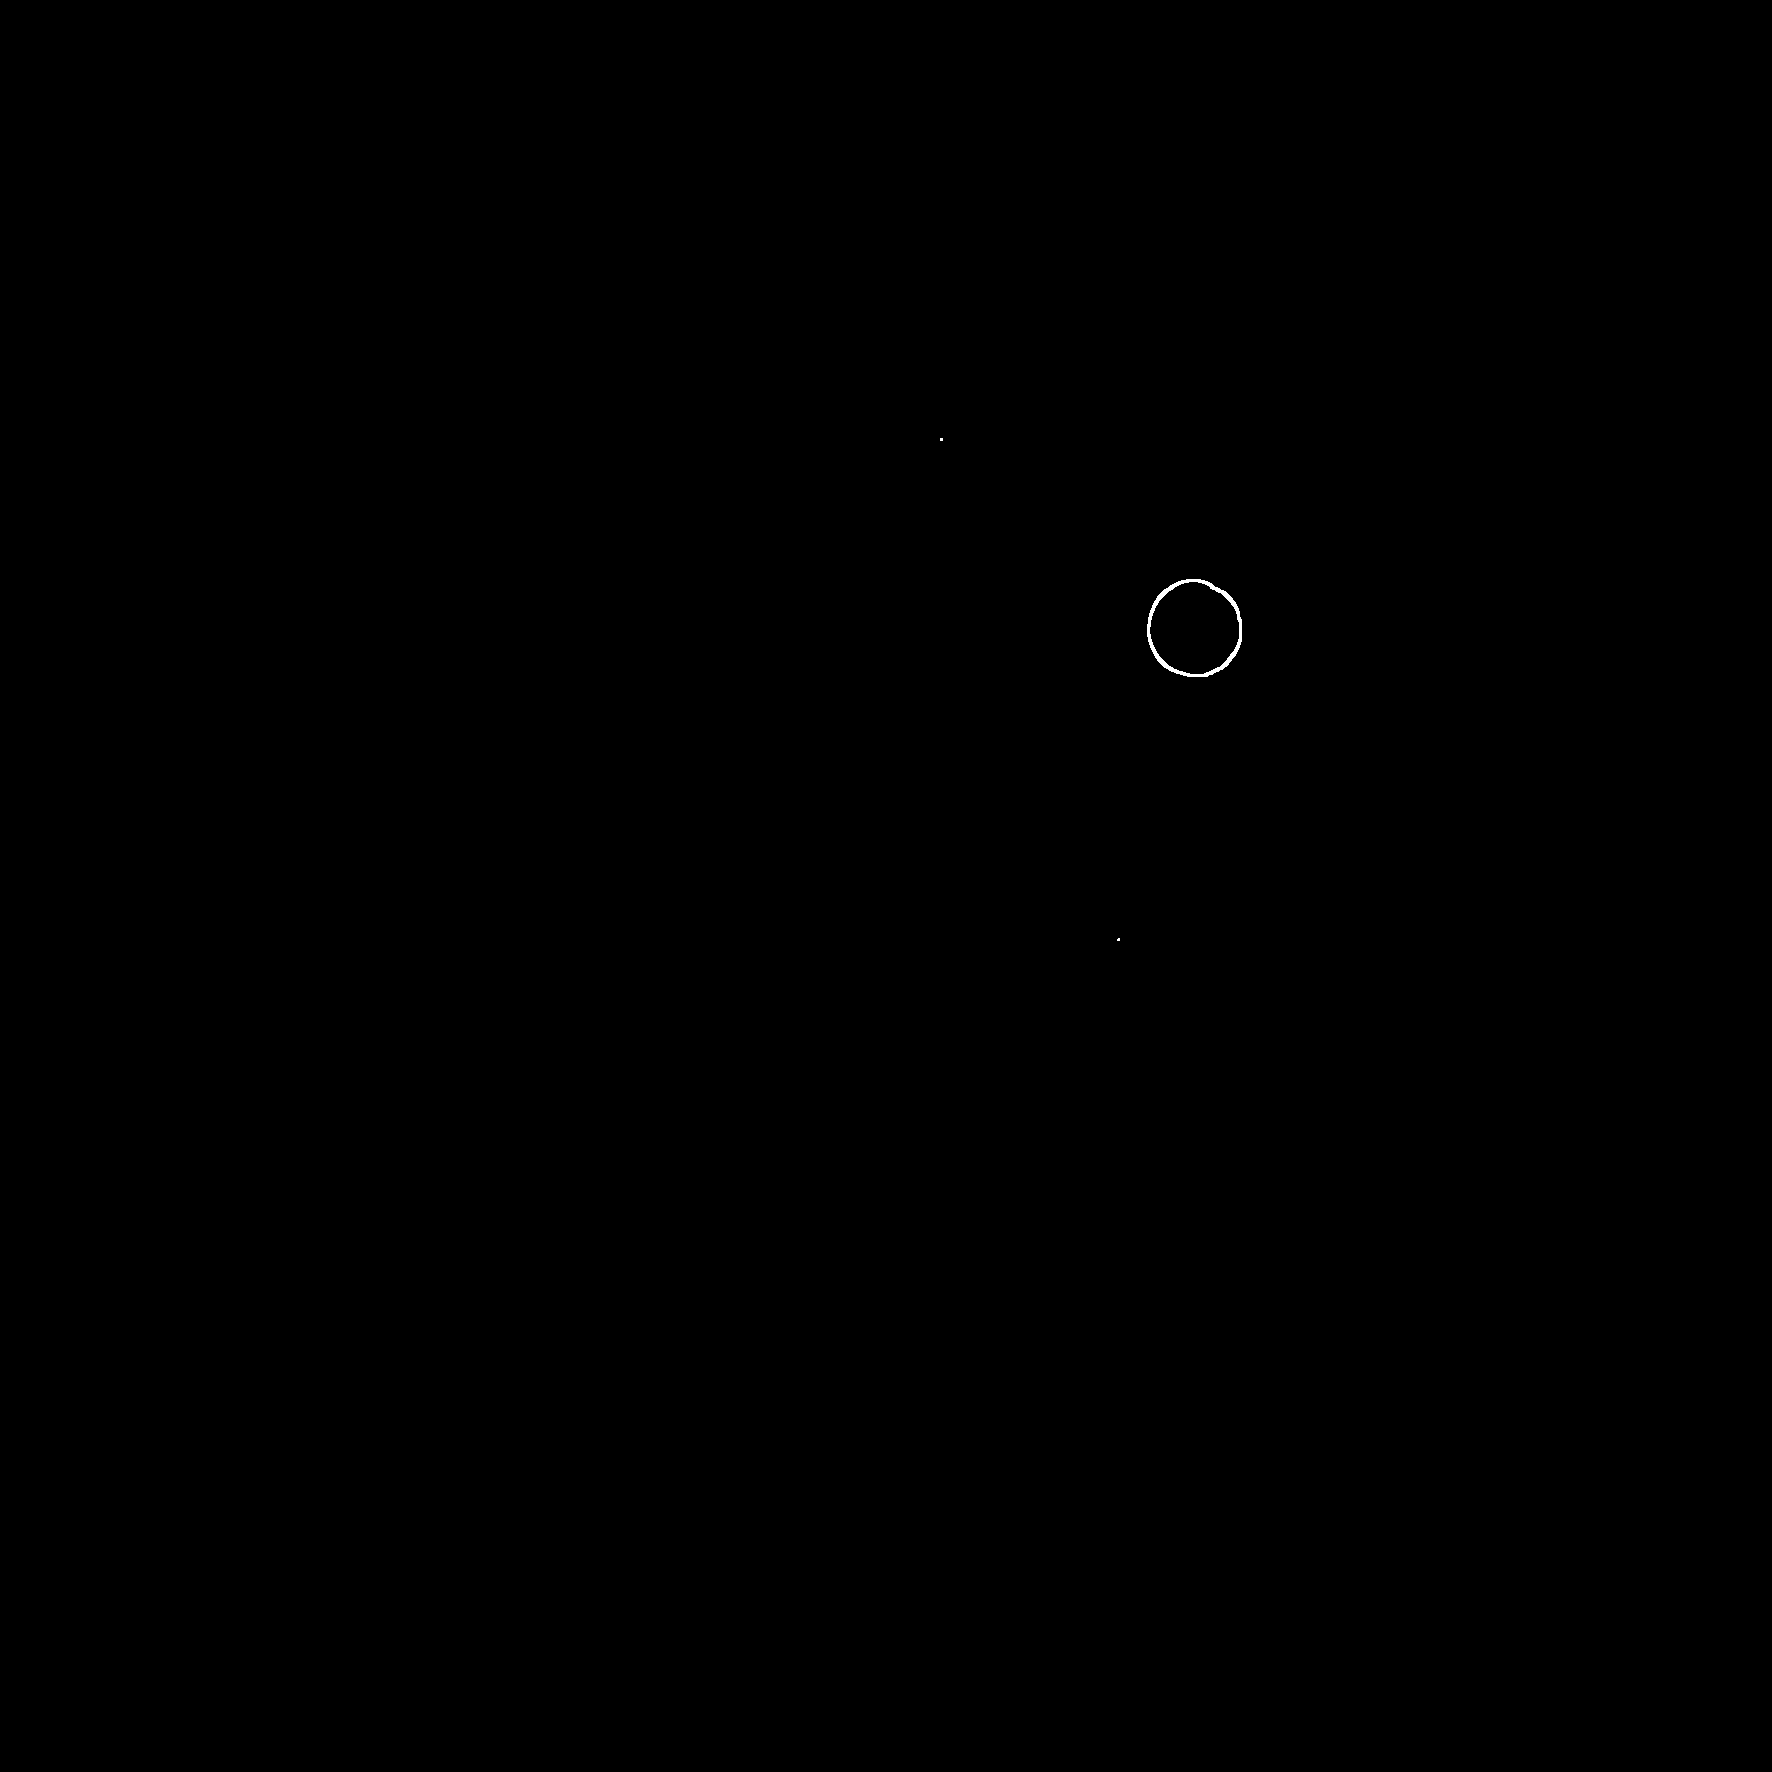

Liczba czarnych kropek: 1


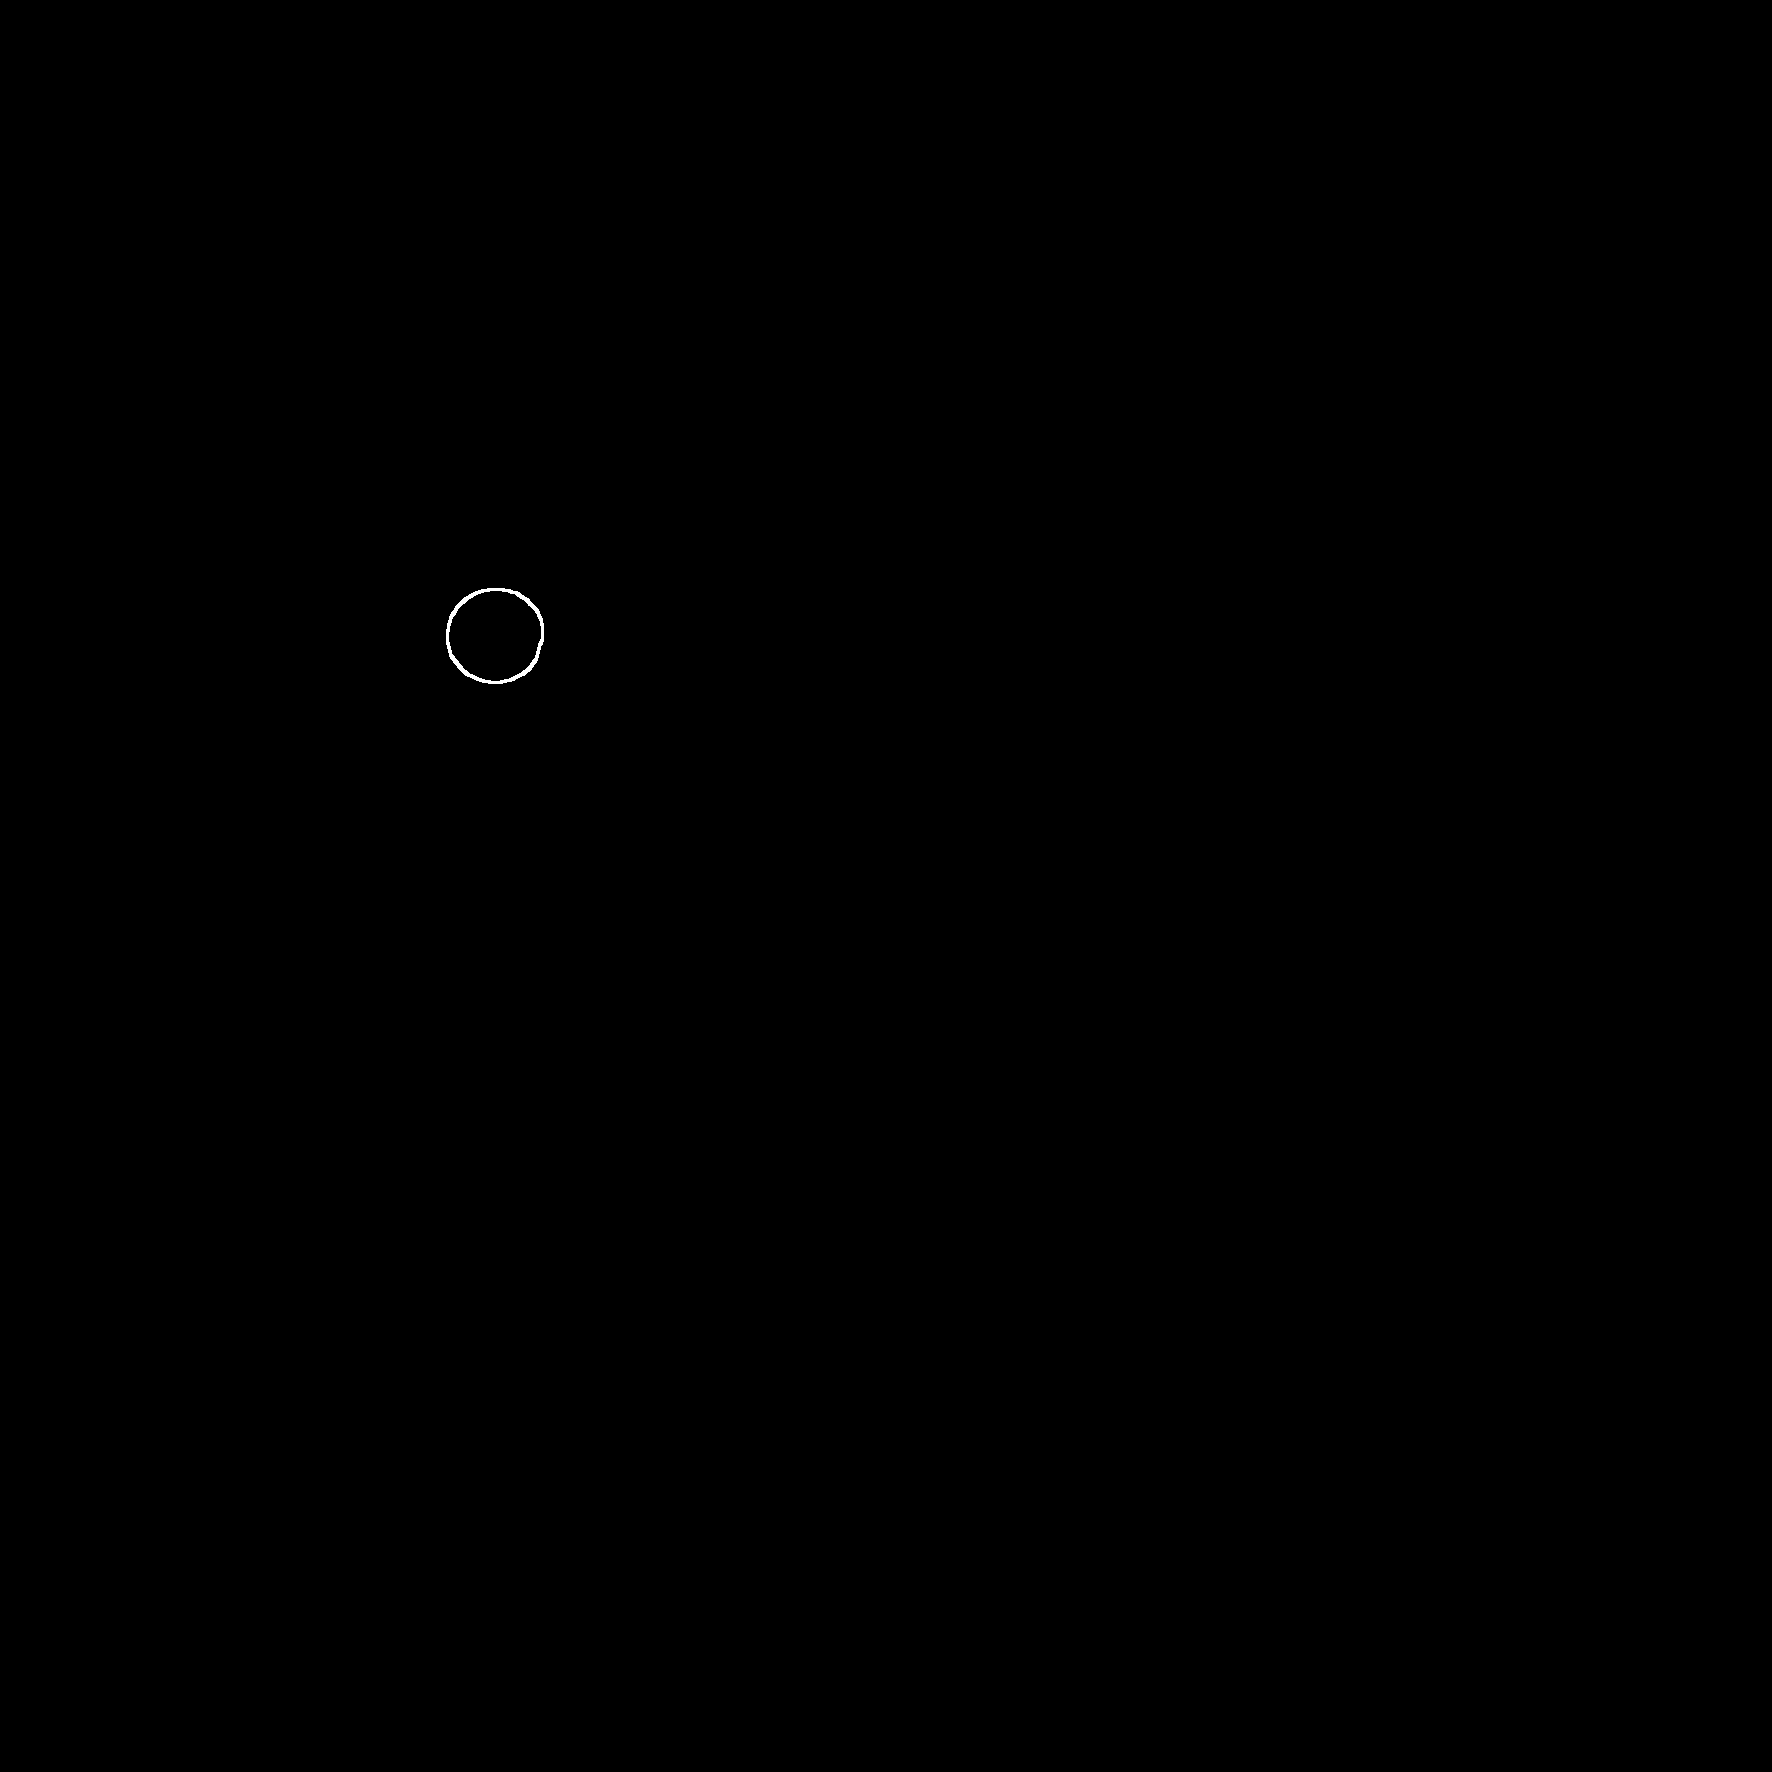

Liczba czarnych kropek: 1


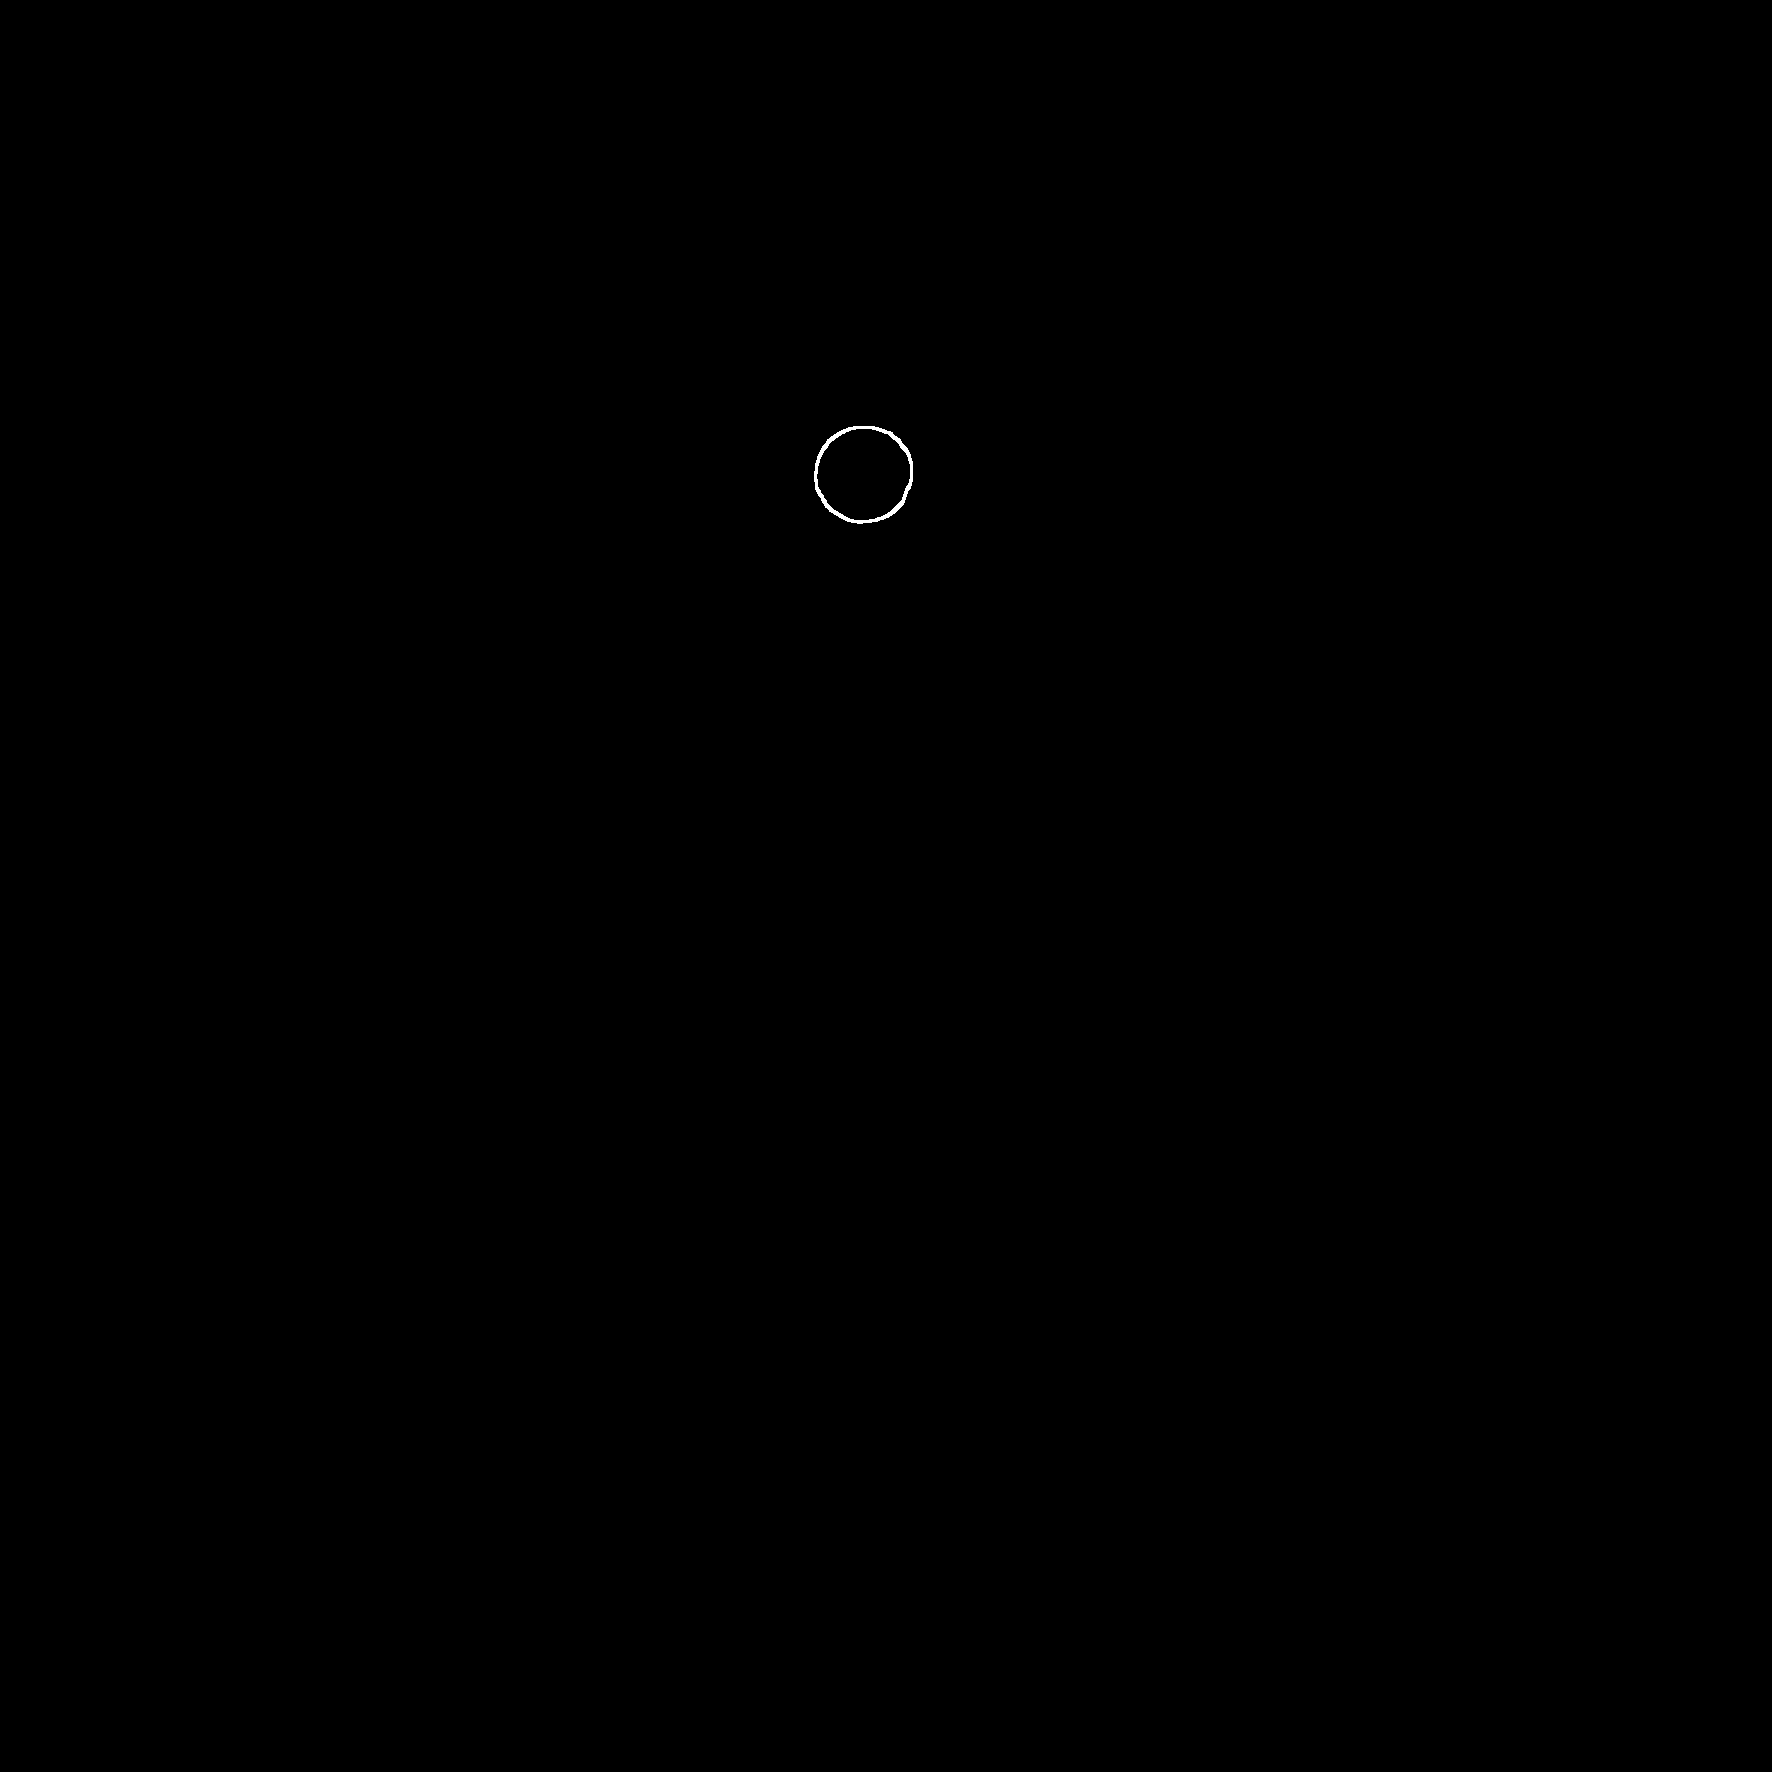

Liczba czarnych kropek: 1


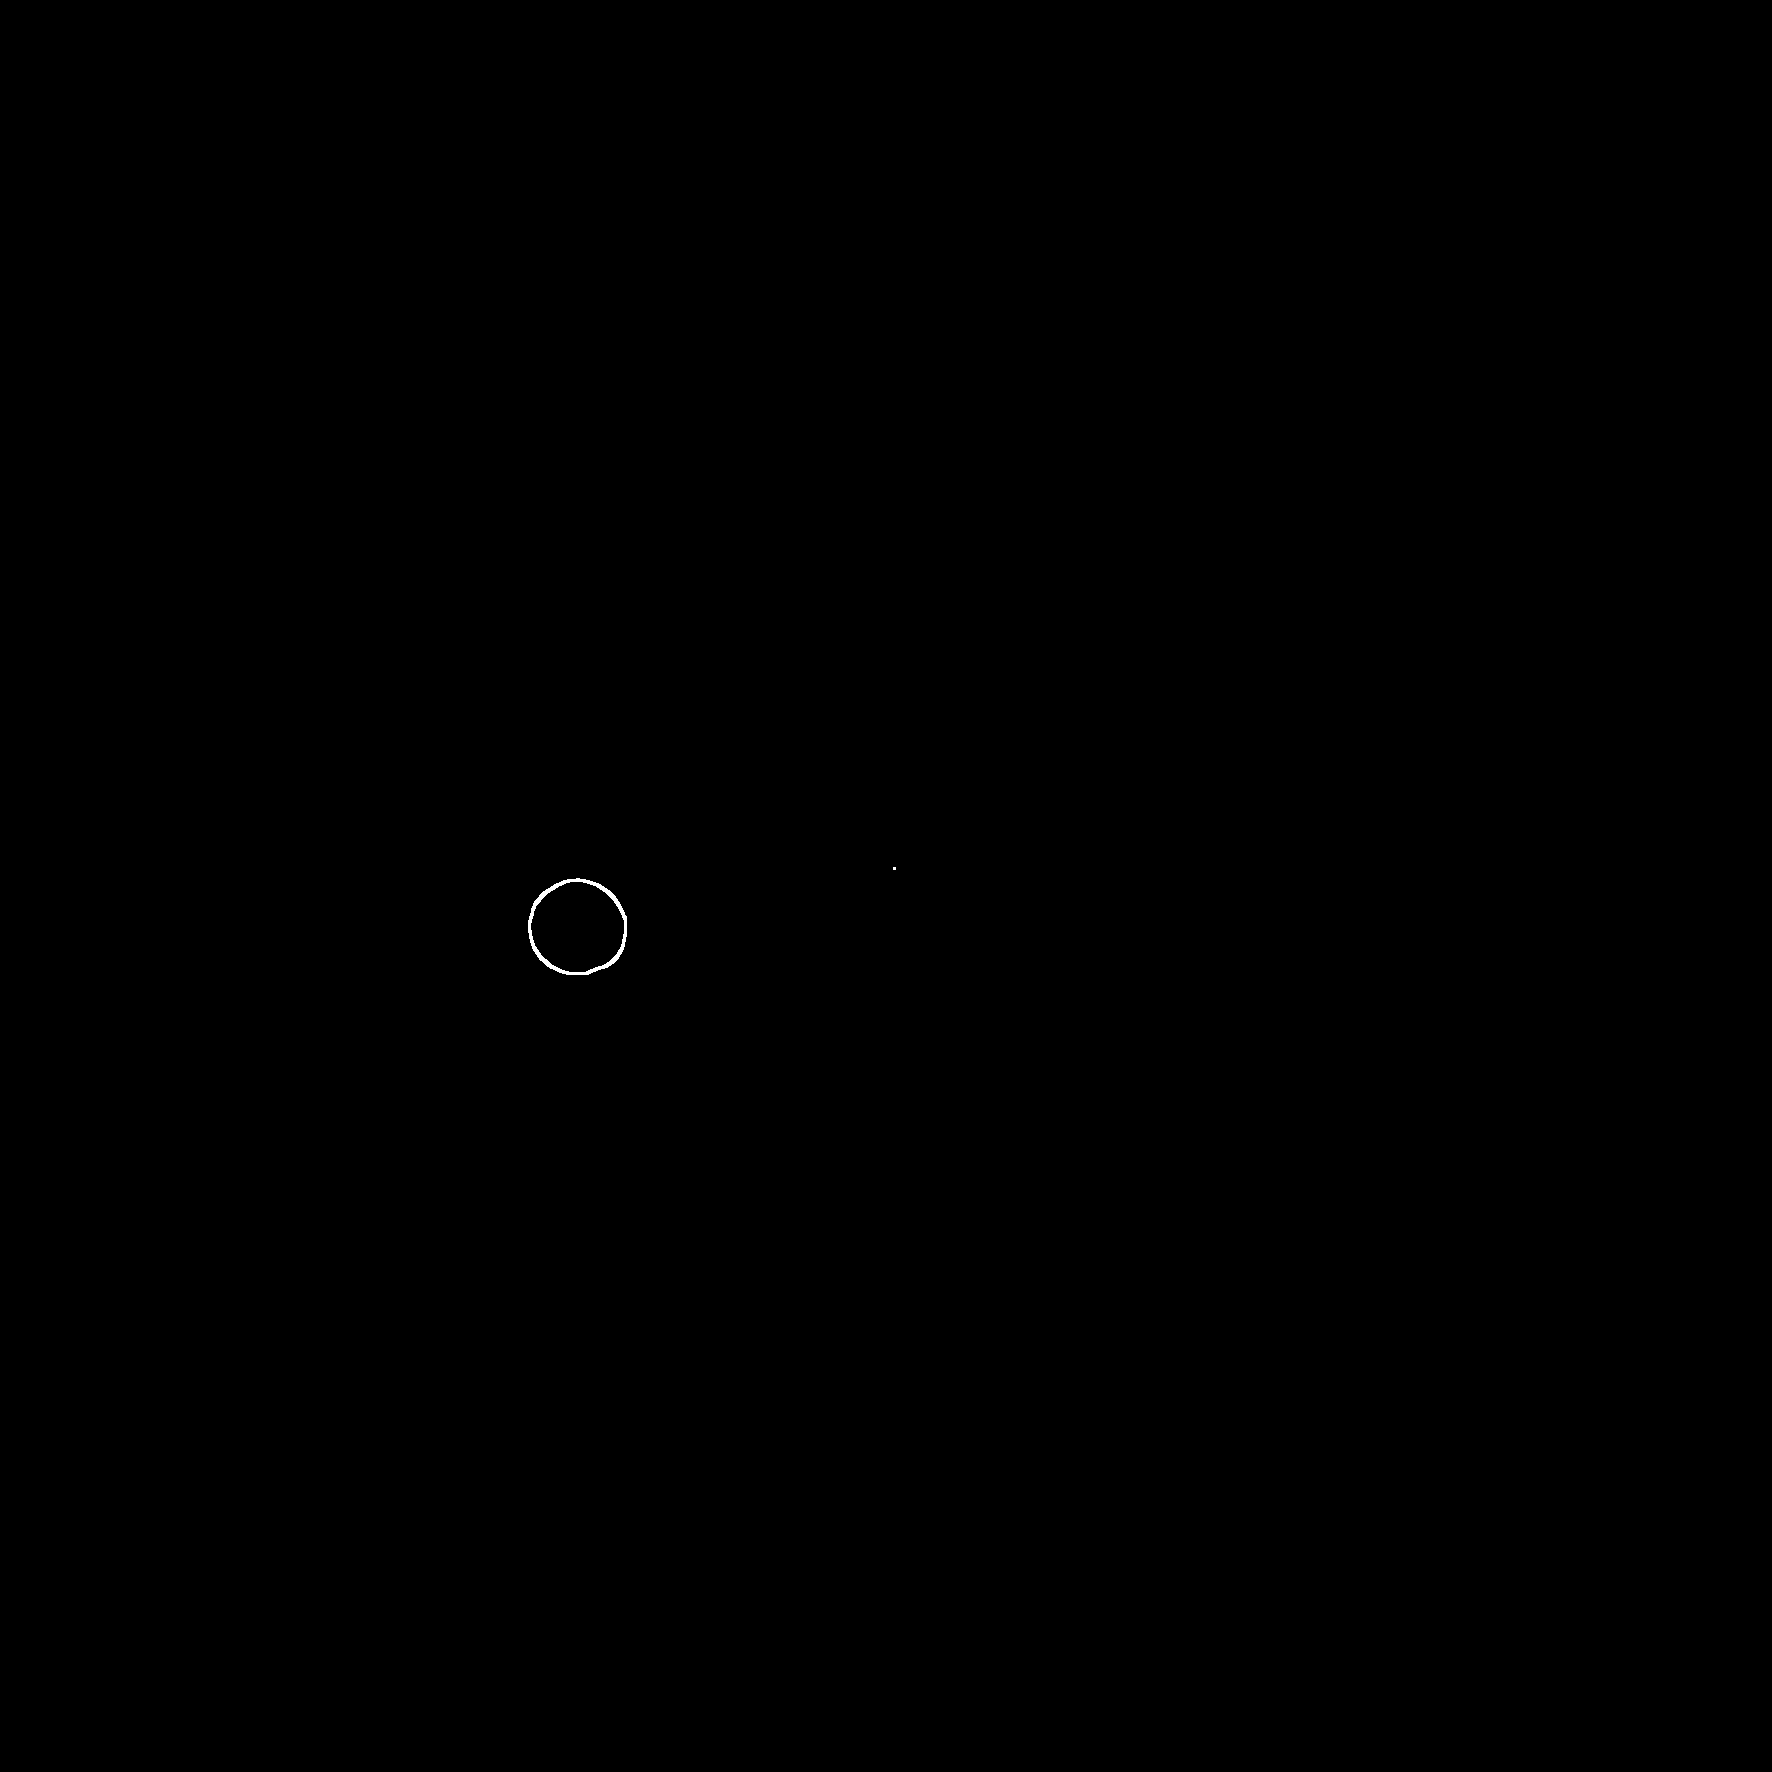

Liczba czarnych kropek: 1


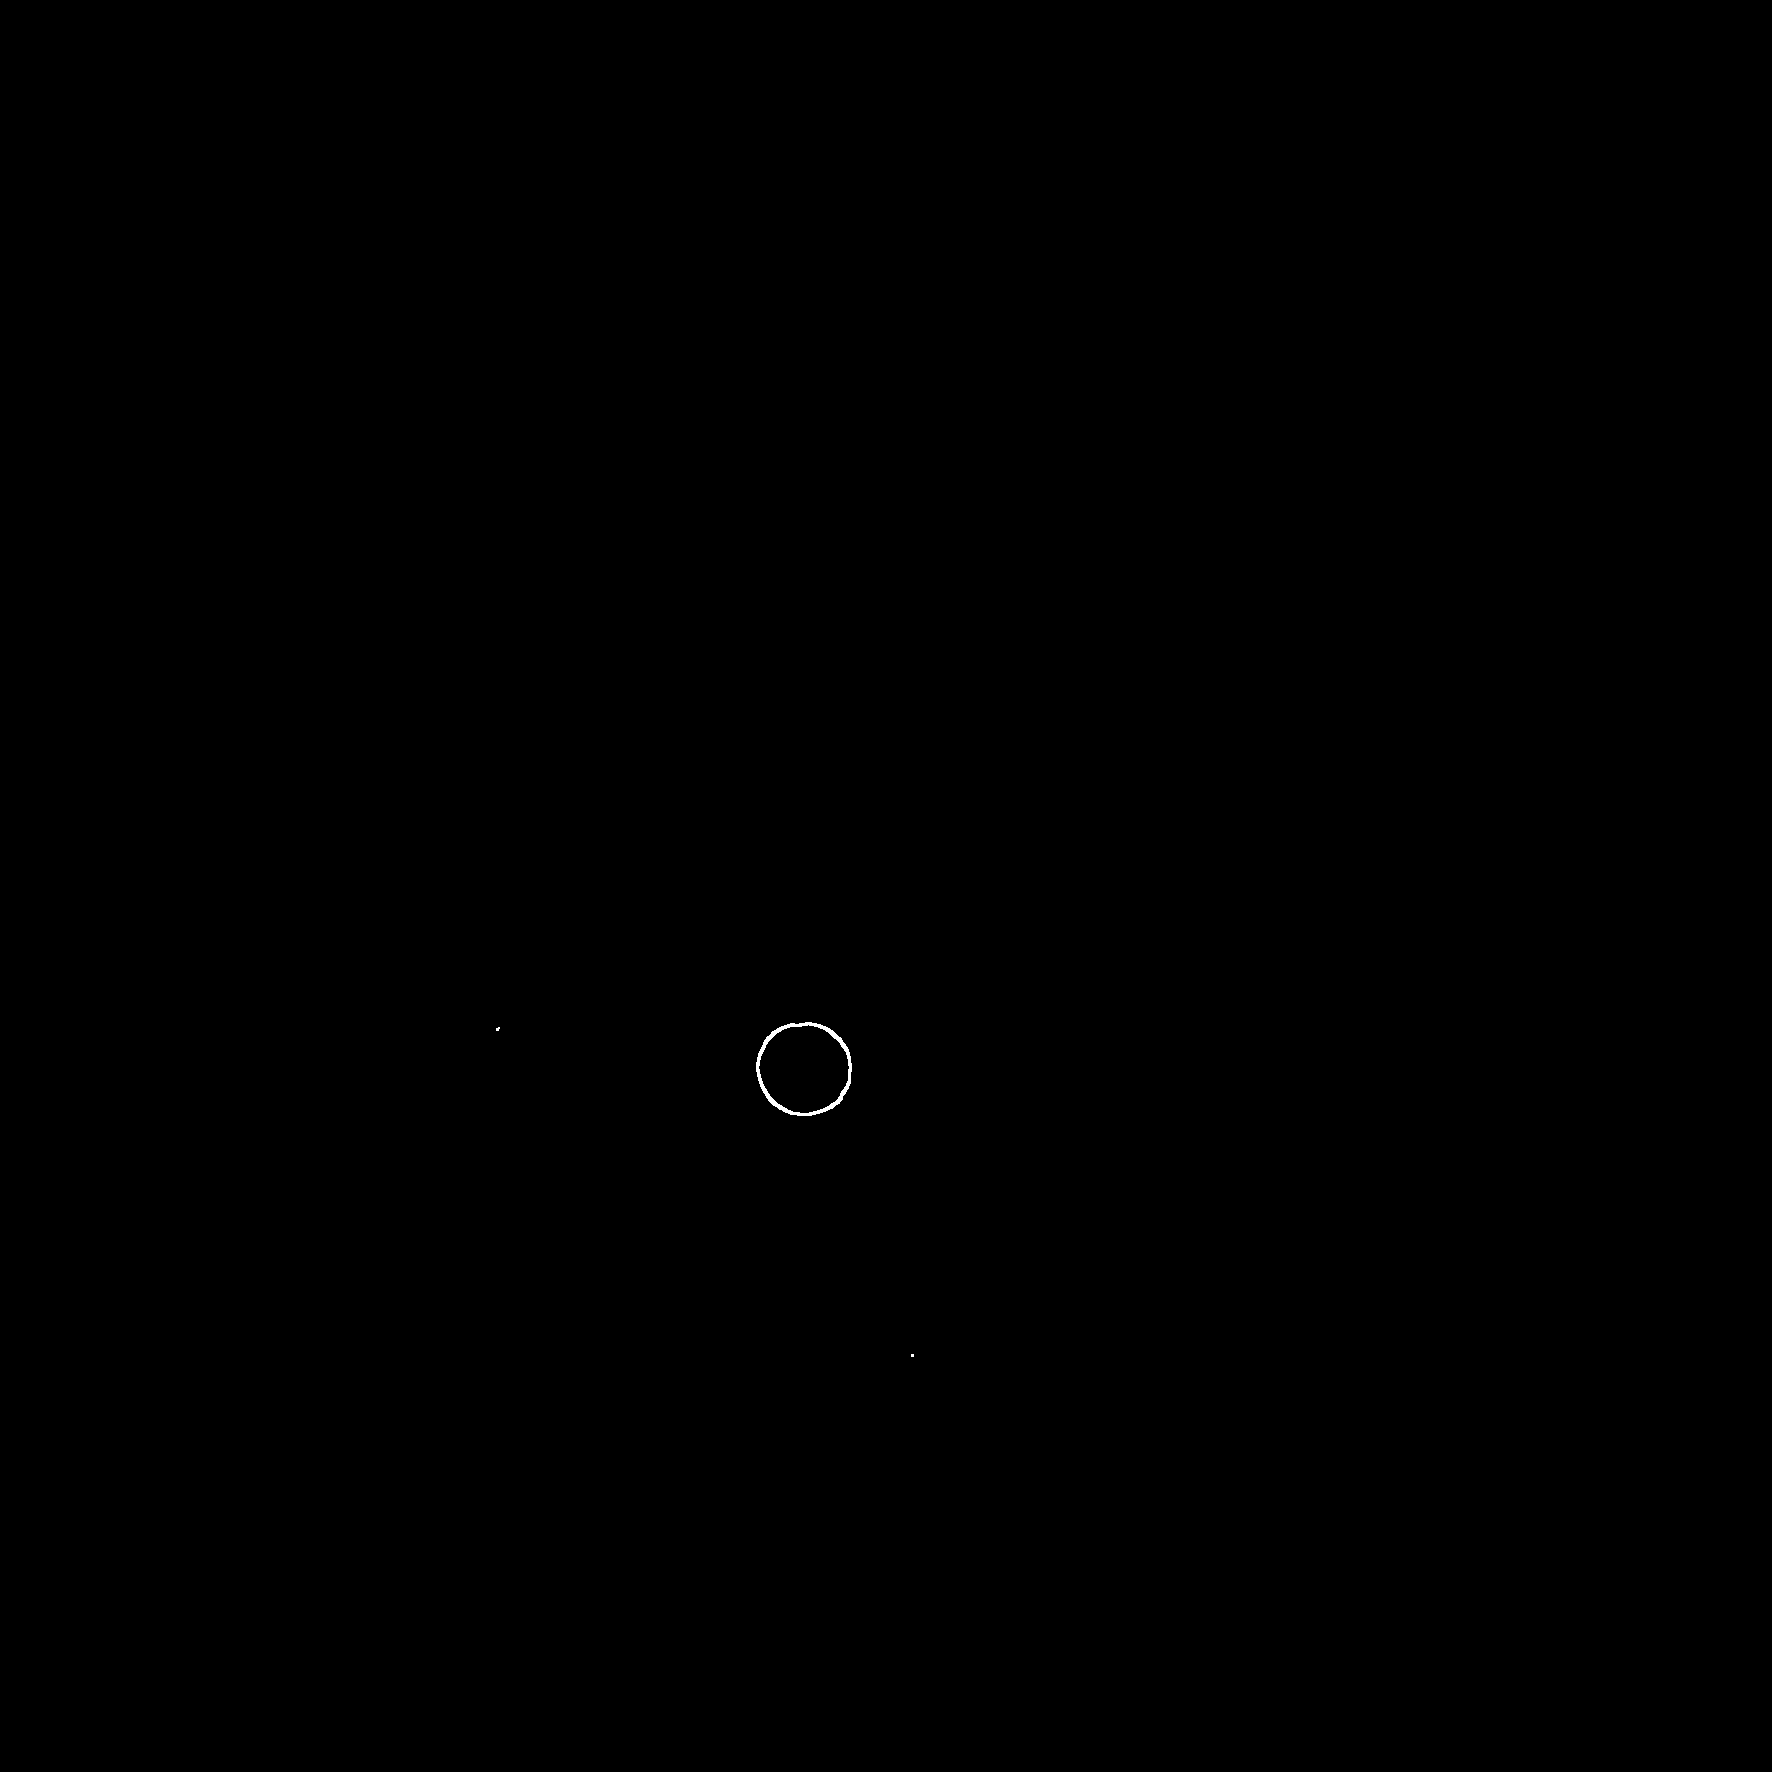

Liczba czarnych kropek: 1


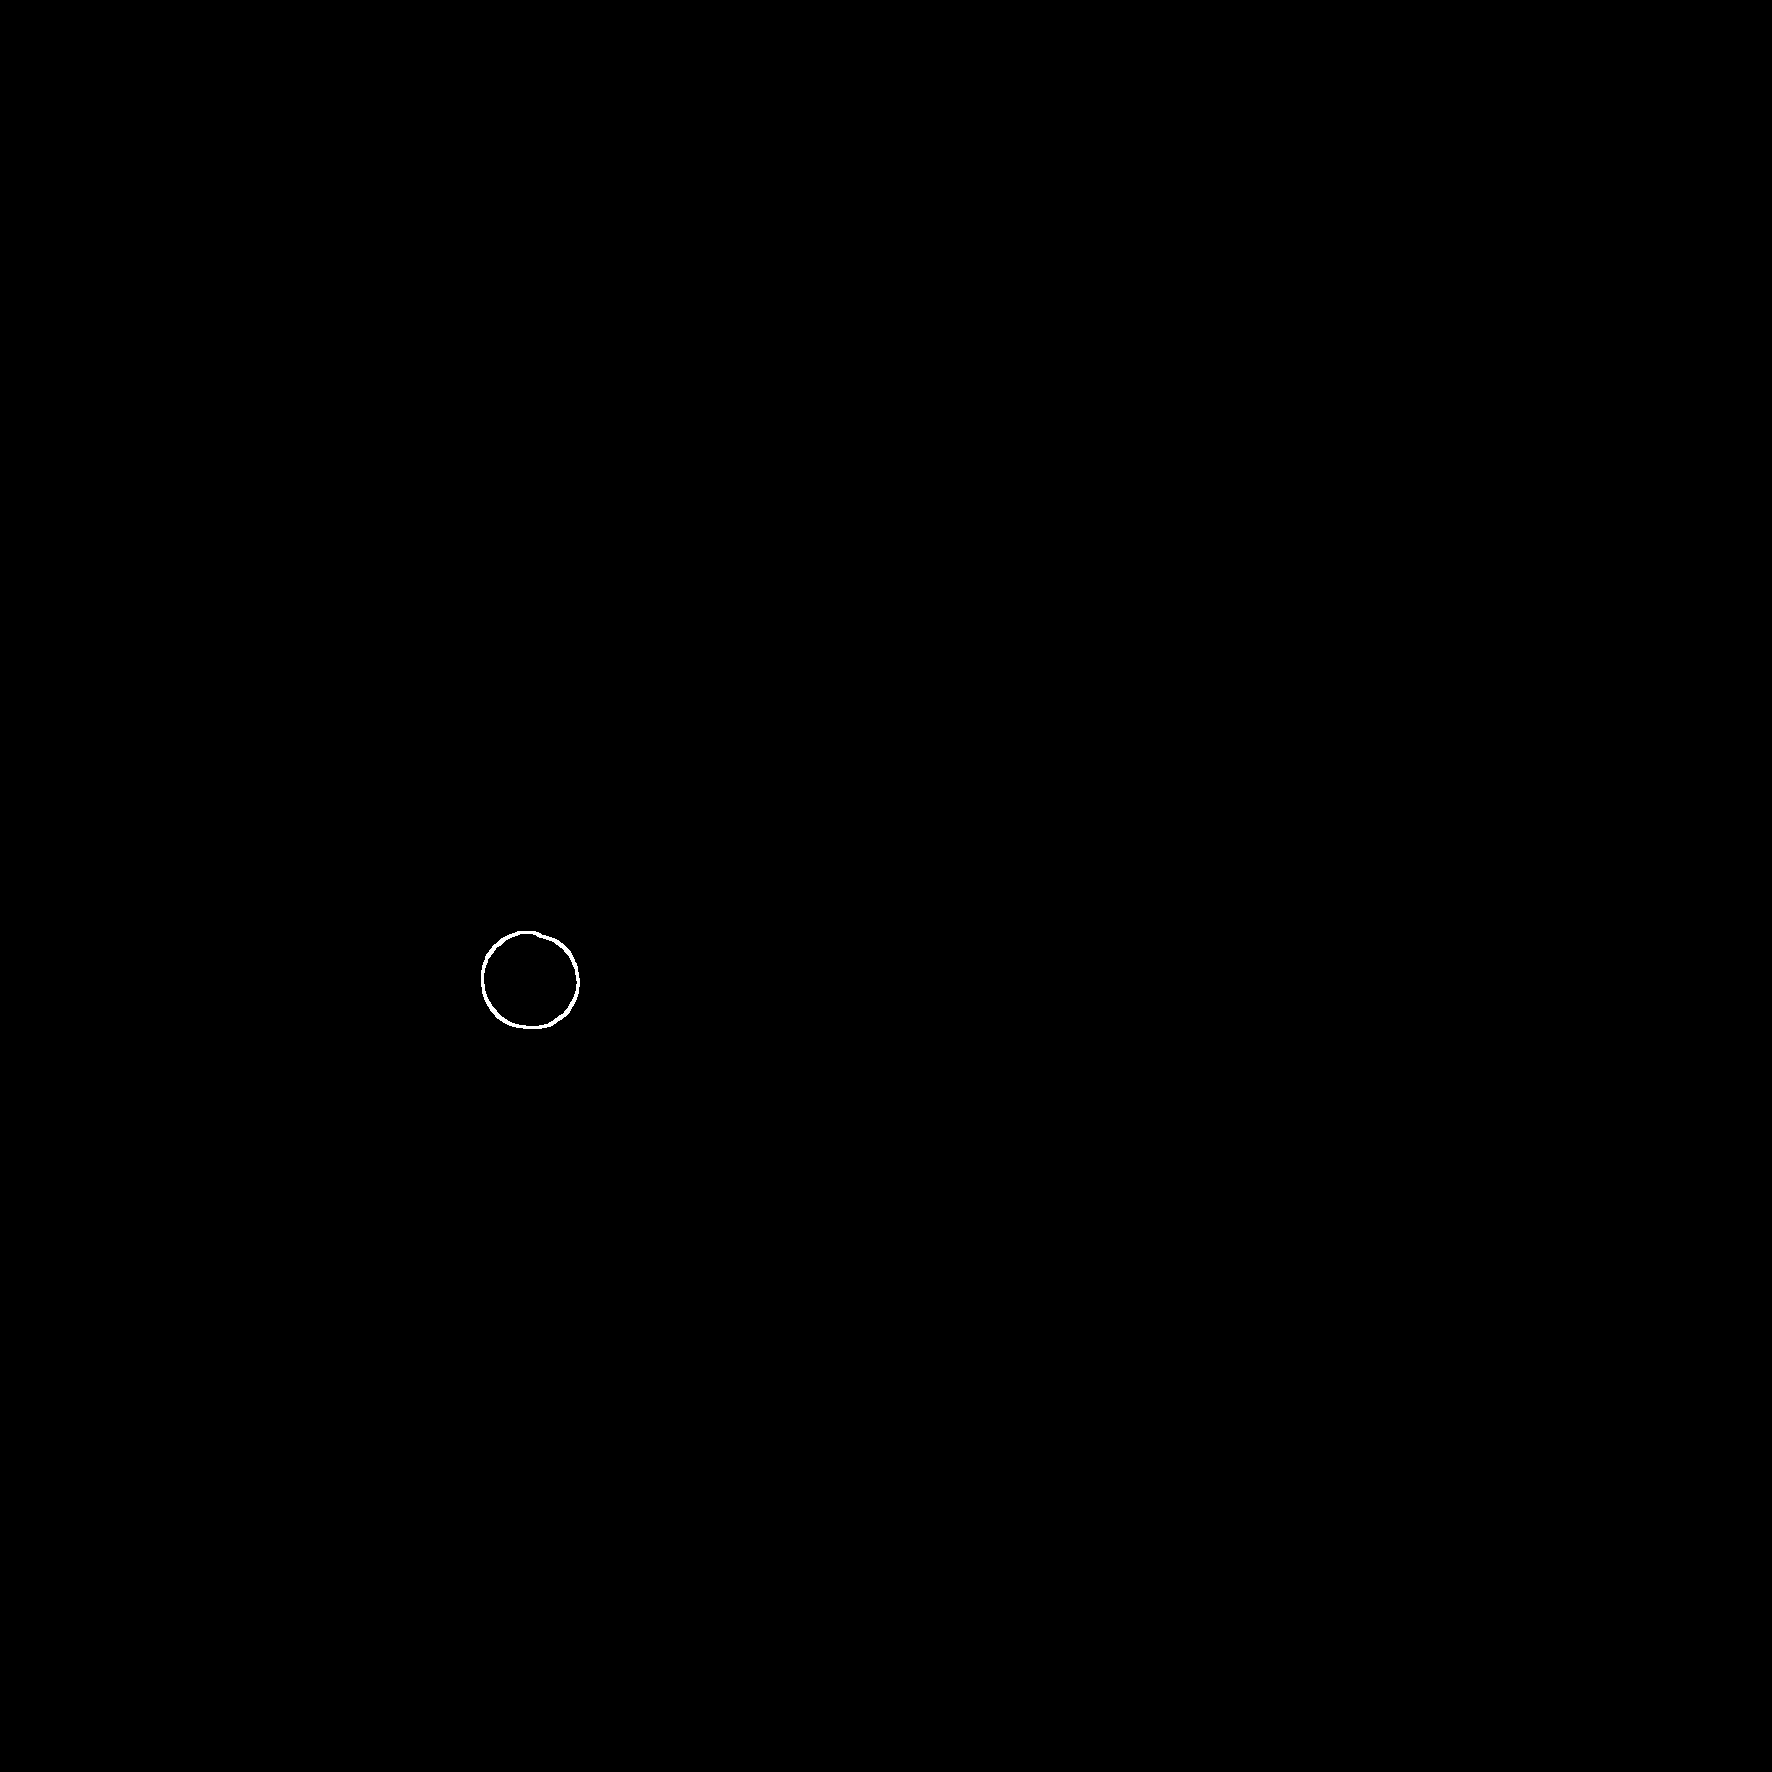

Liczba czarnych kropek: 1


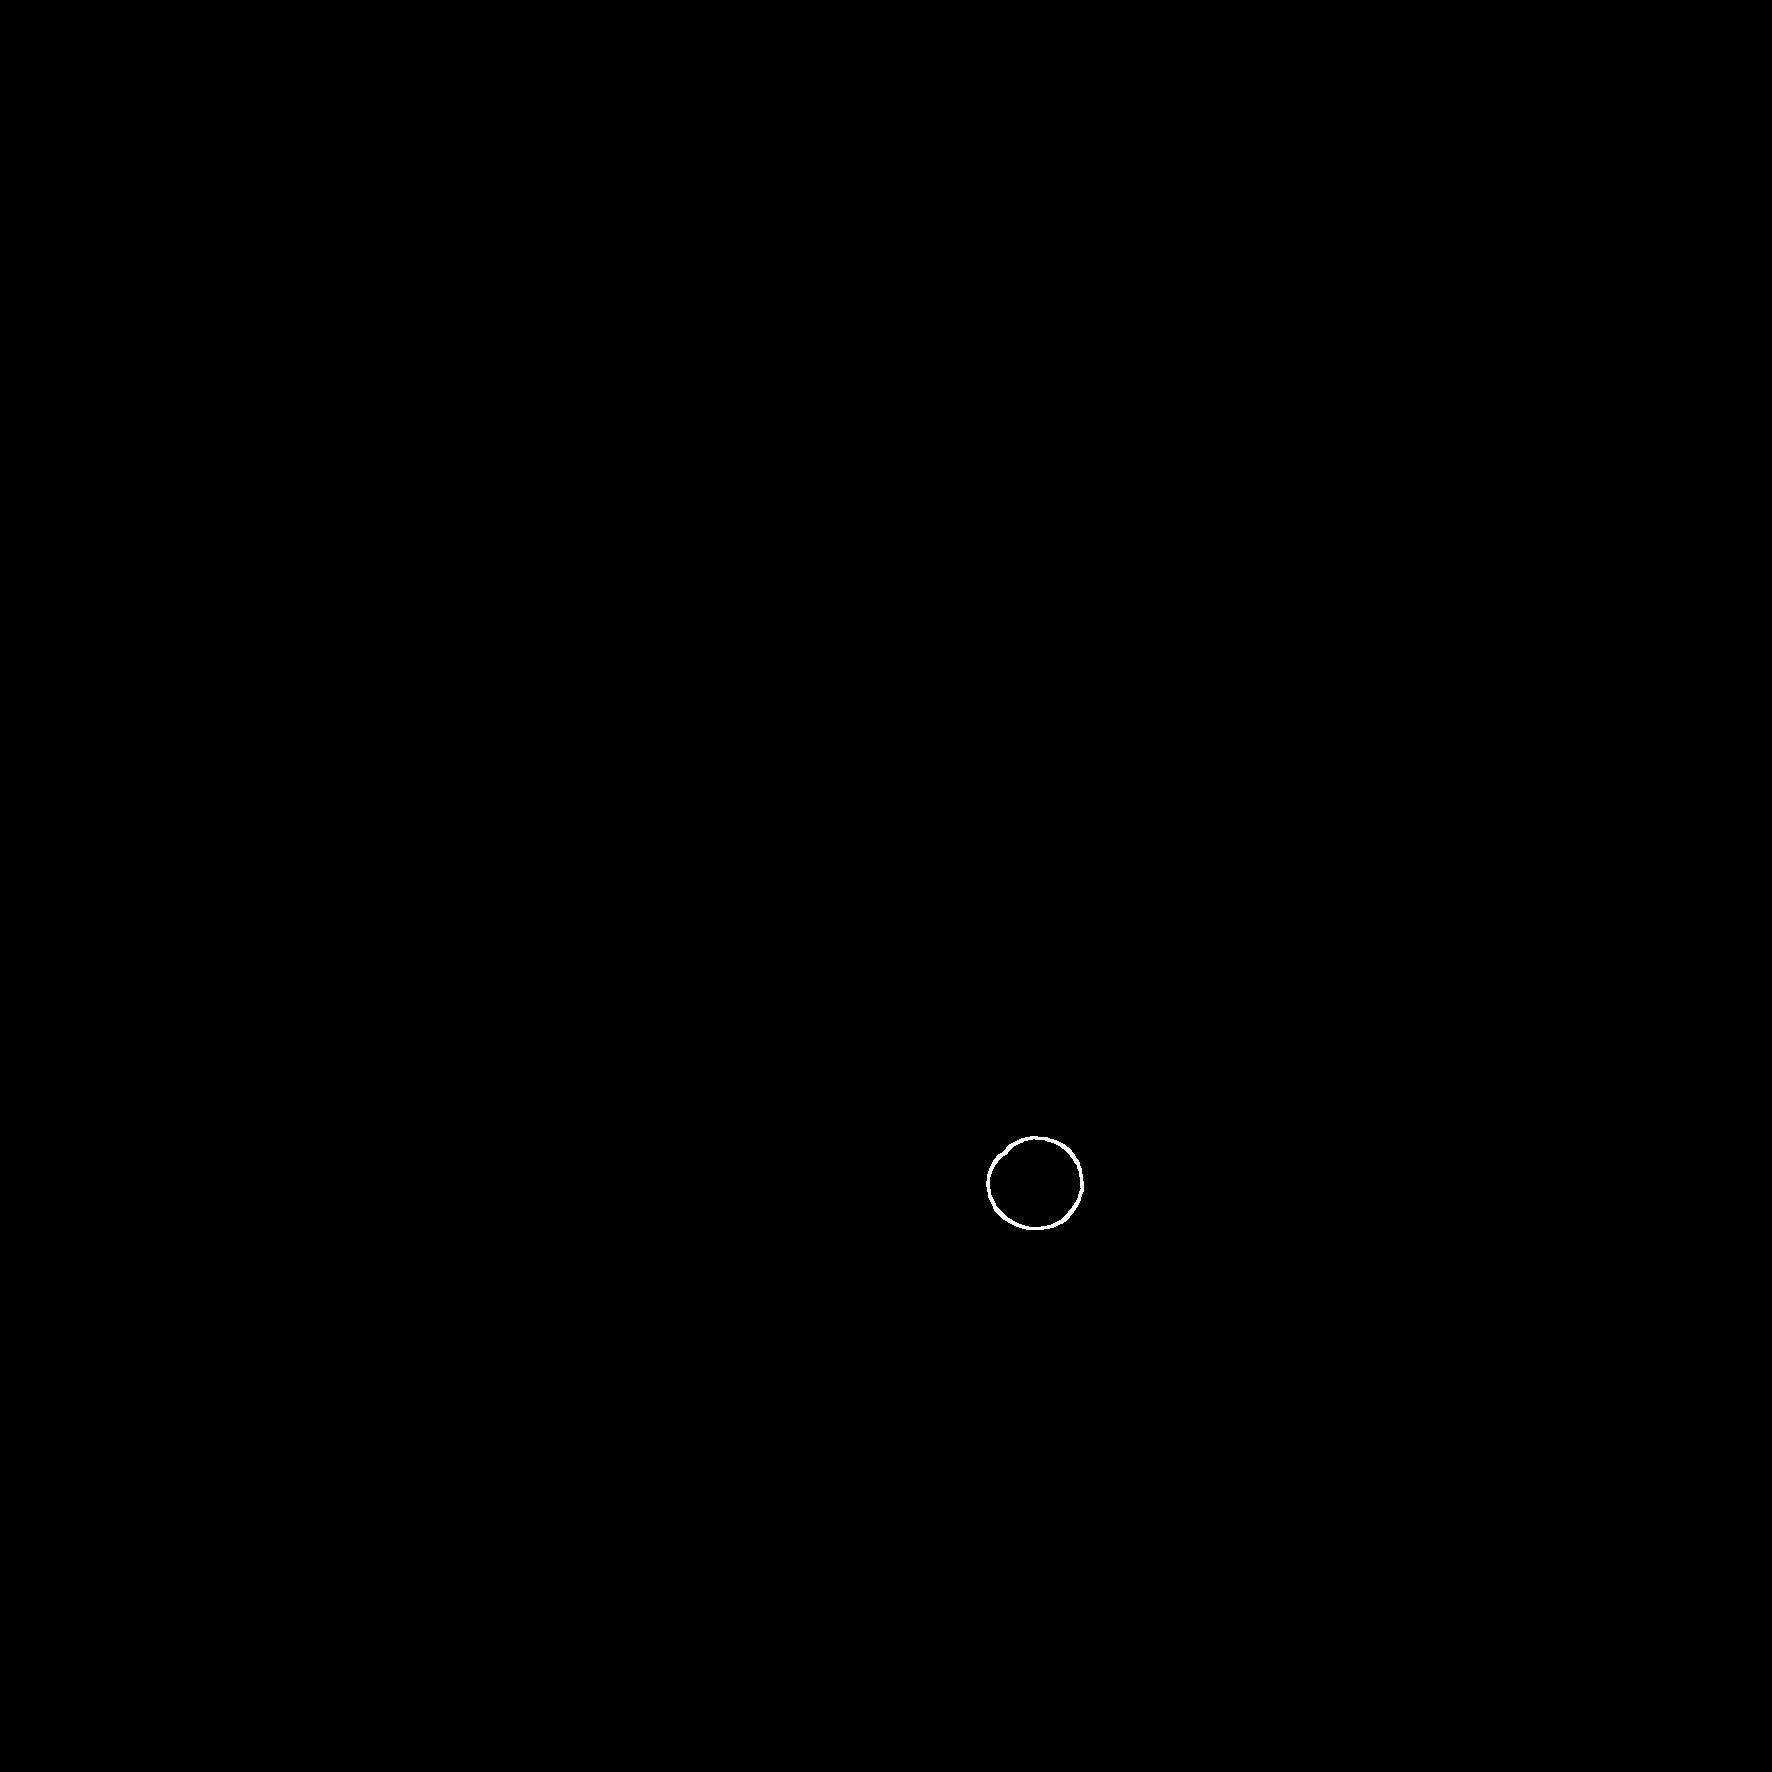

Liczba czarnych kropek: 1


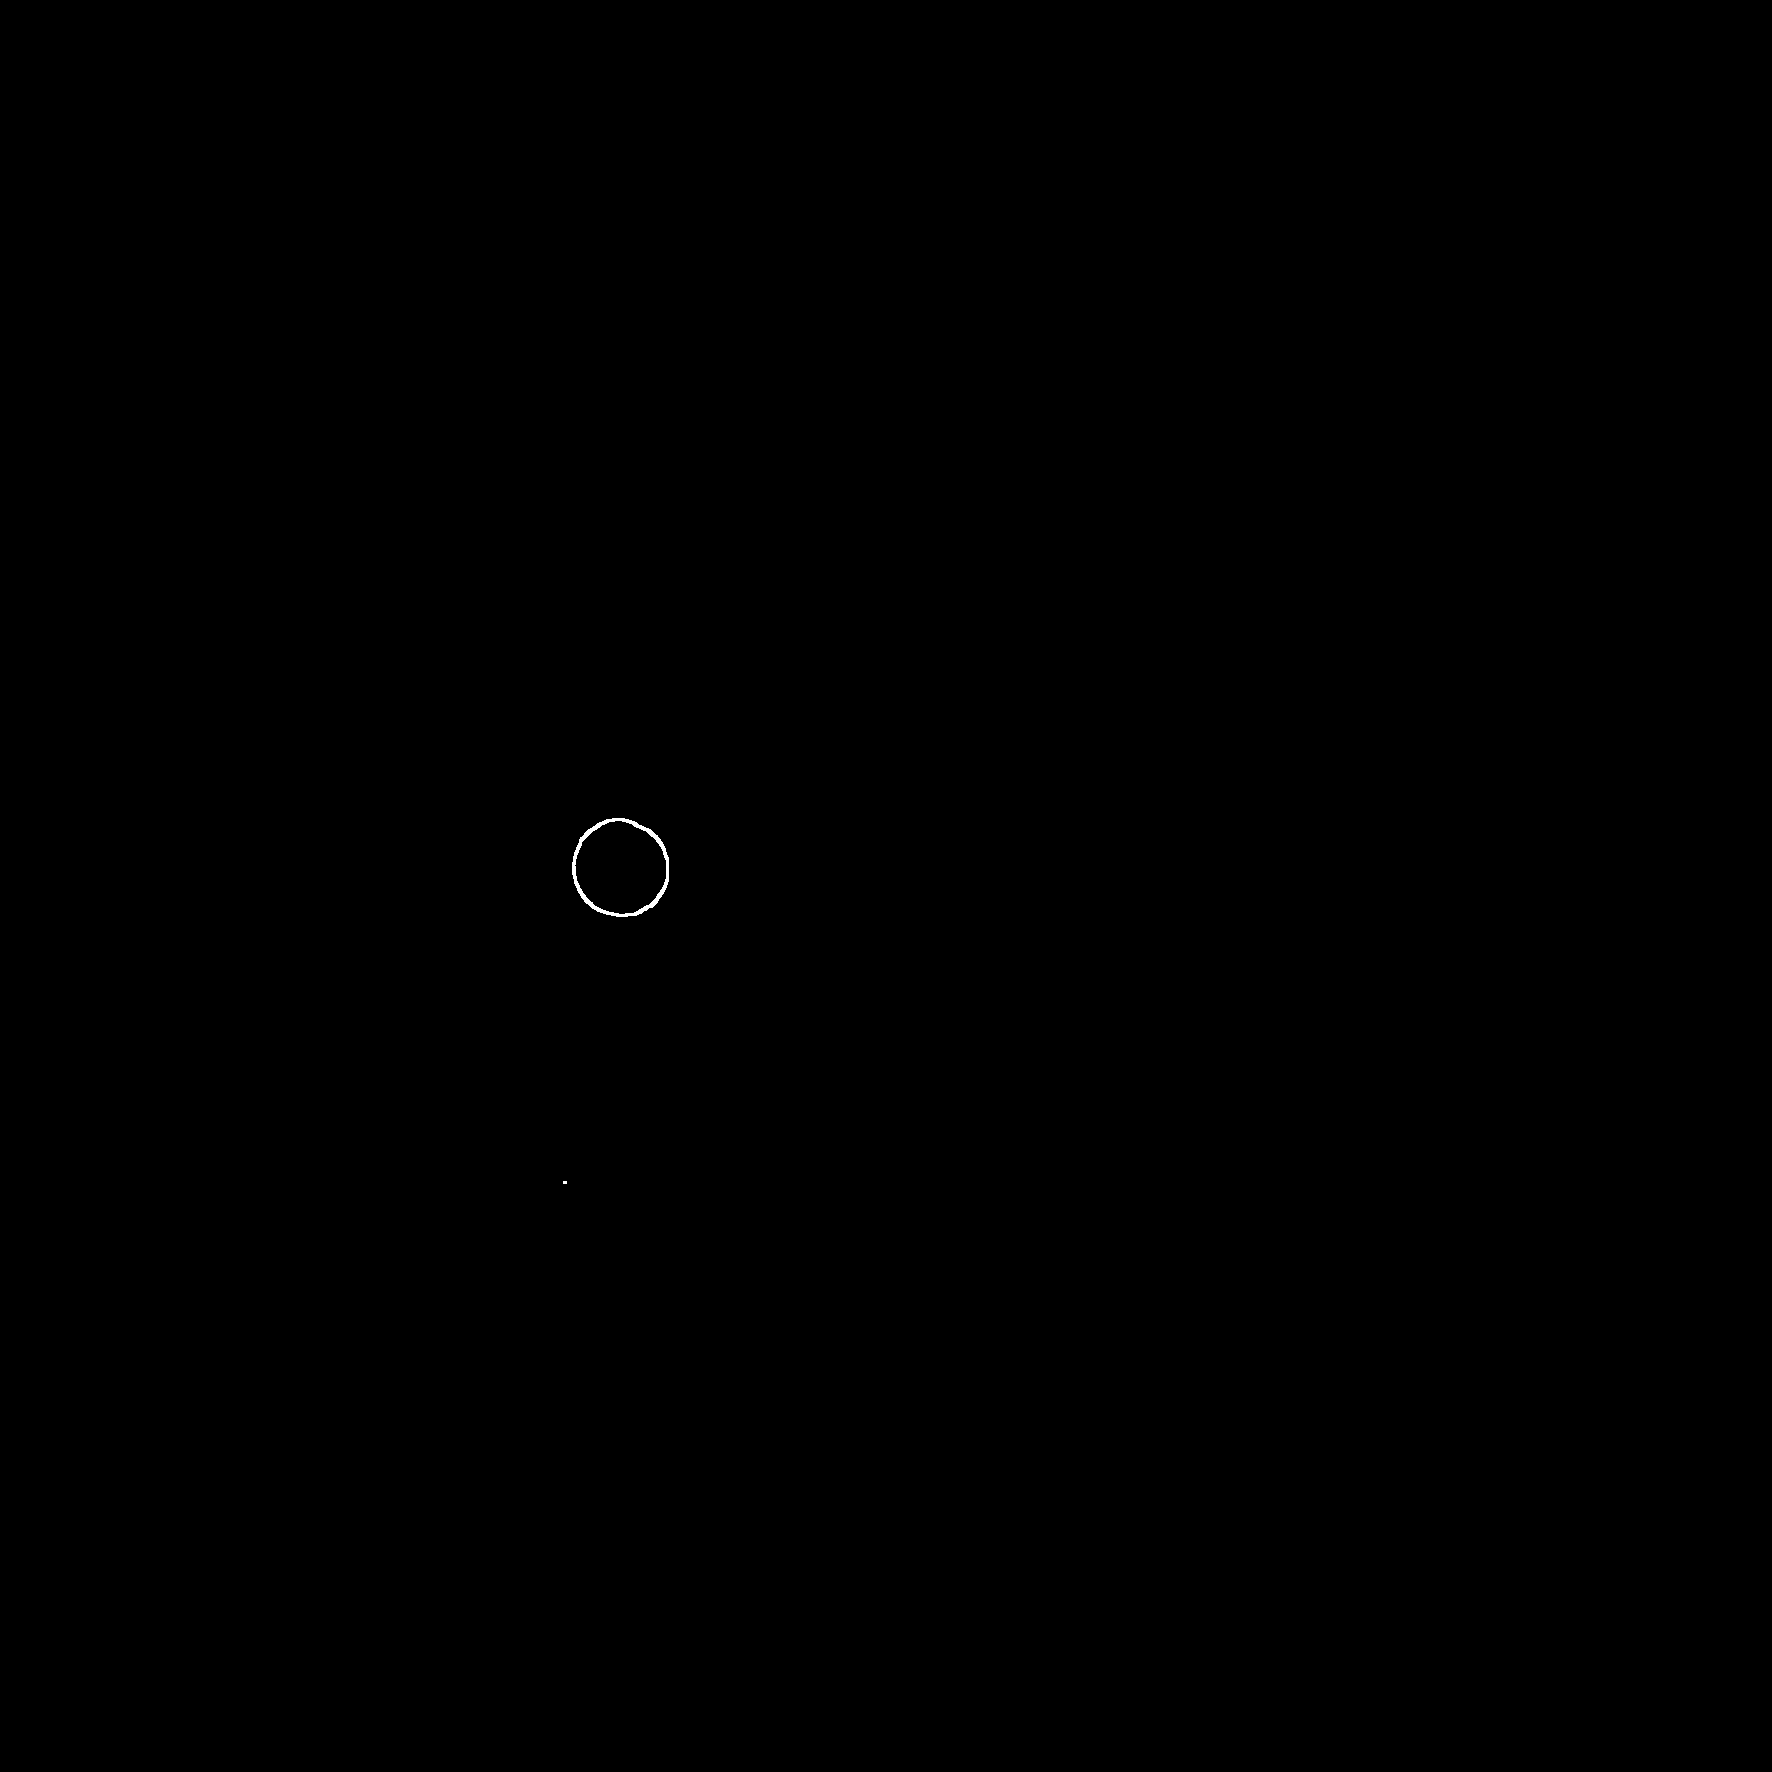

Liczba czarnych kropek: 1


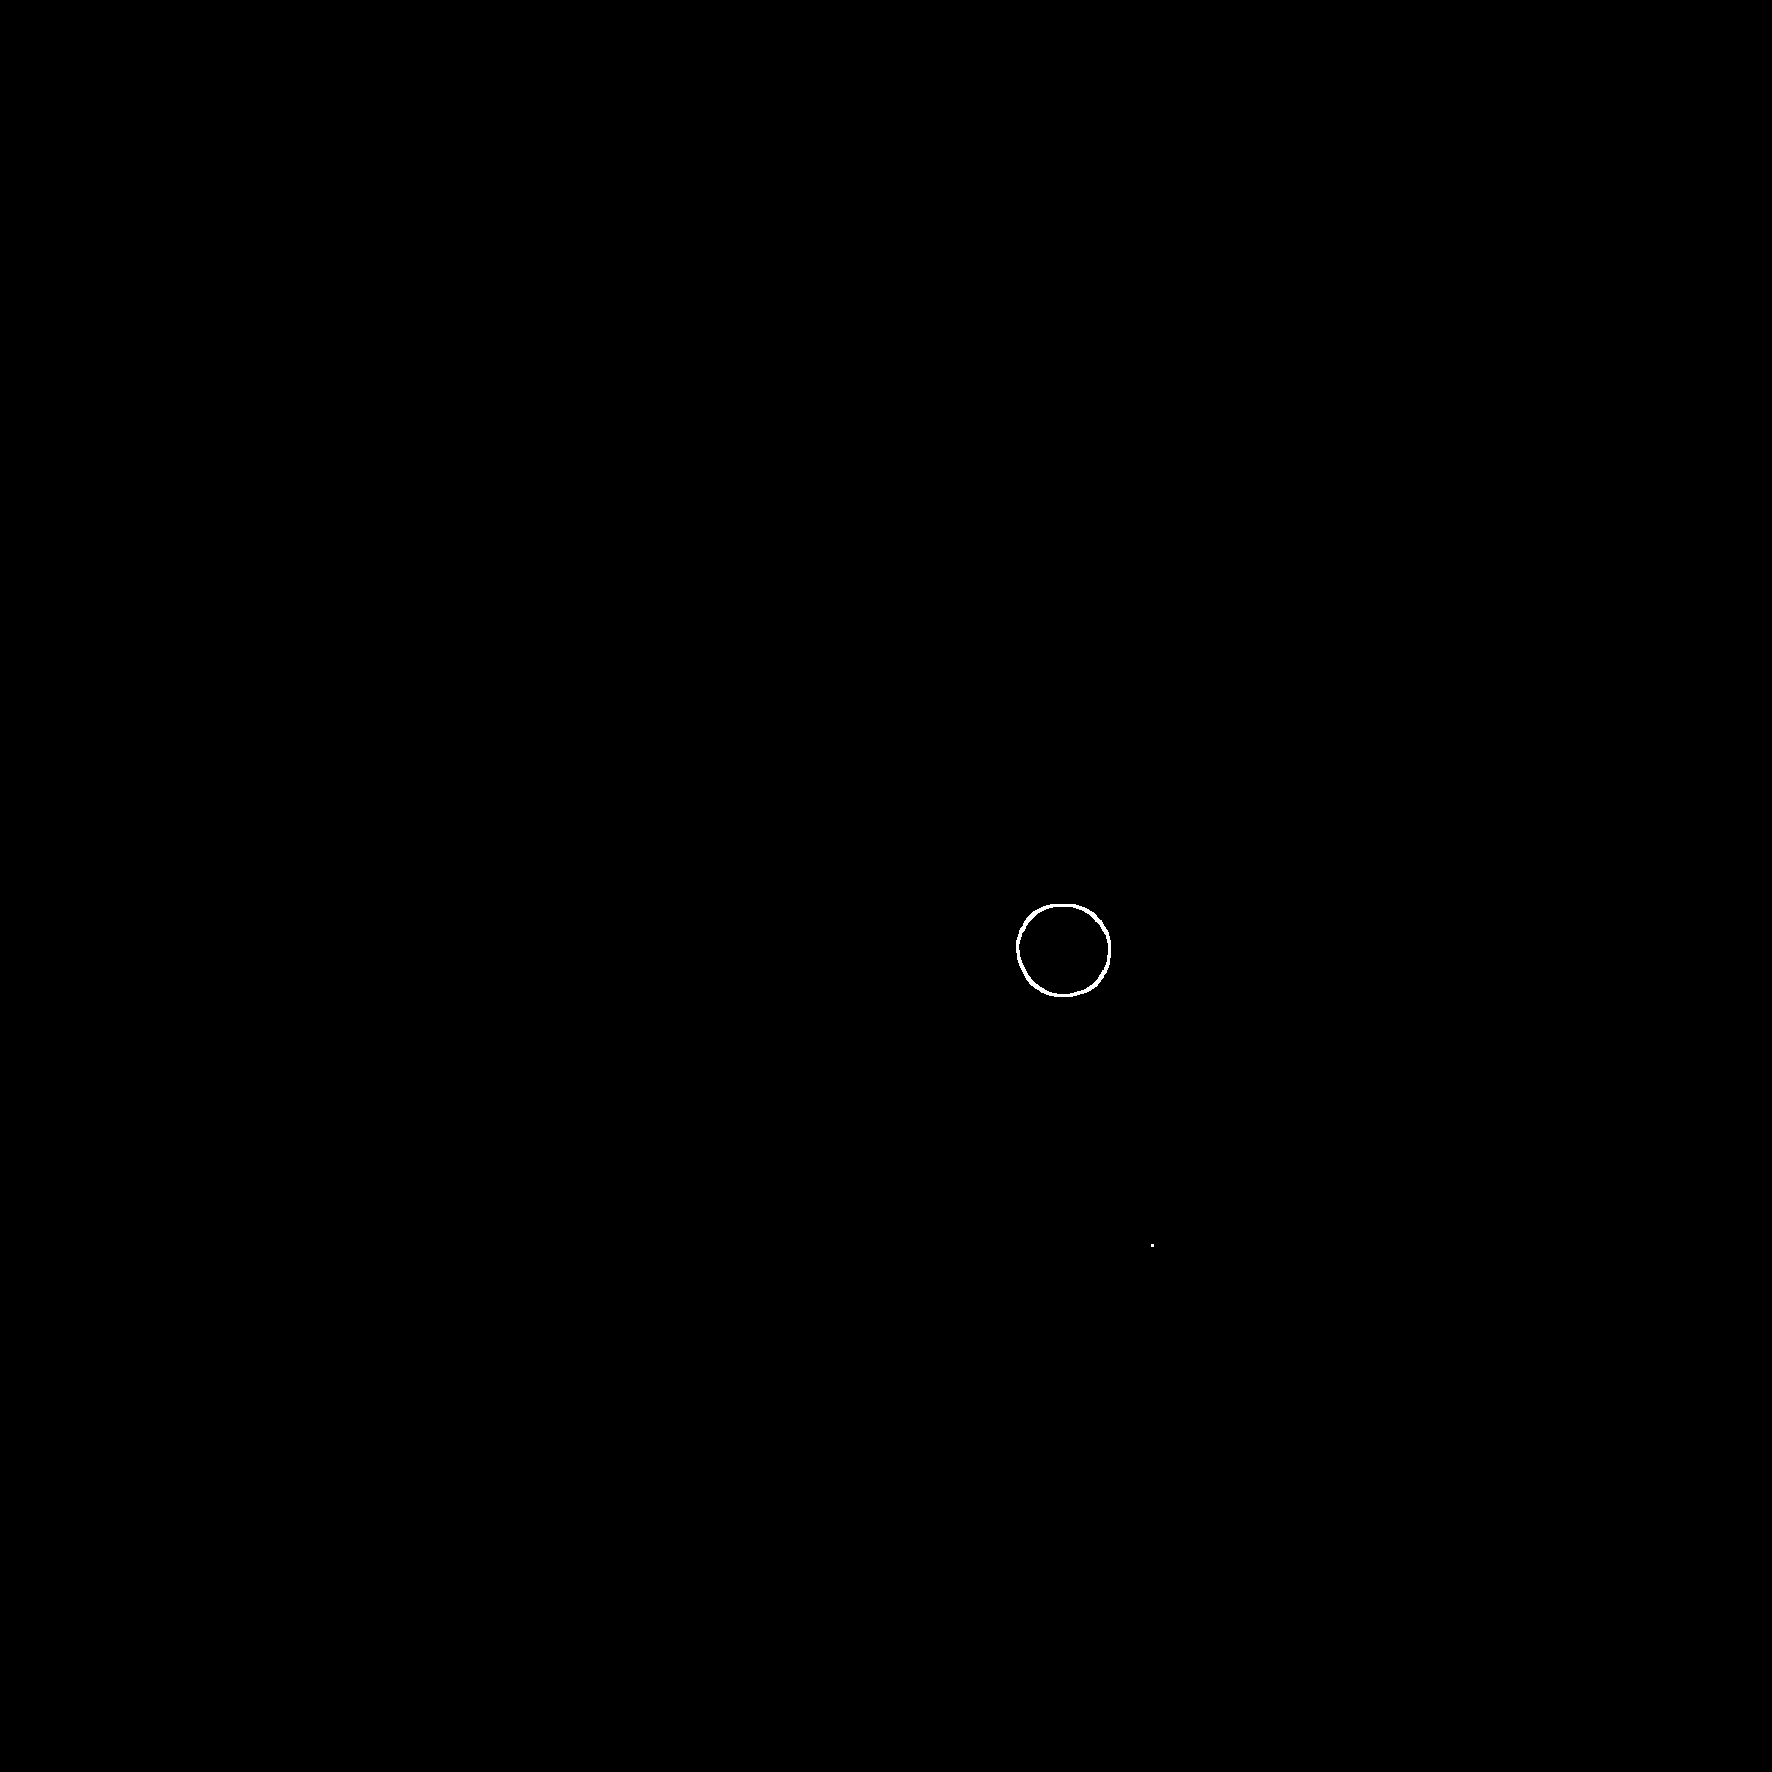

Liczba czarnych kropek: 1


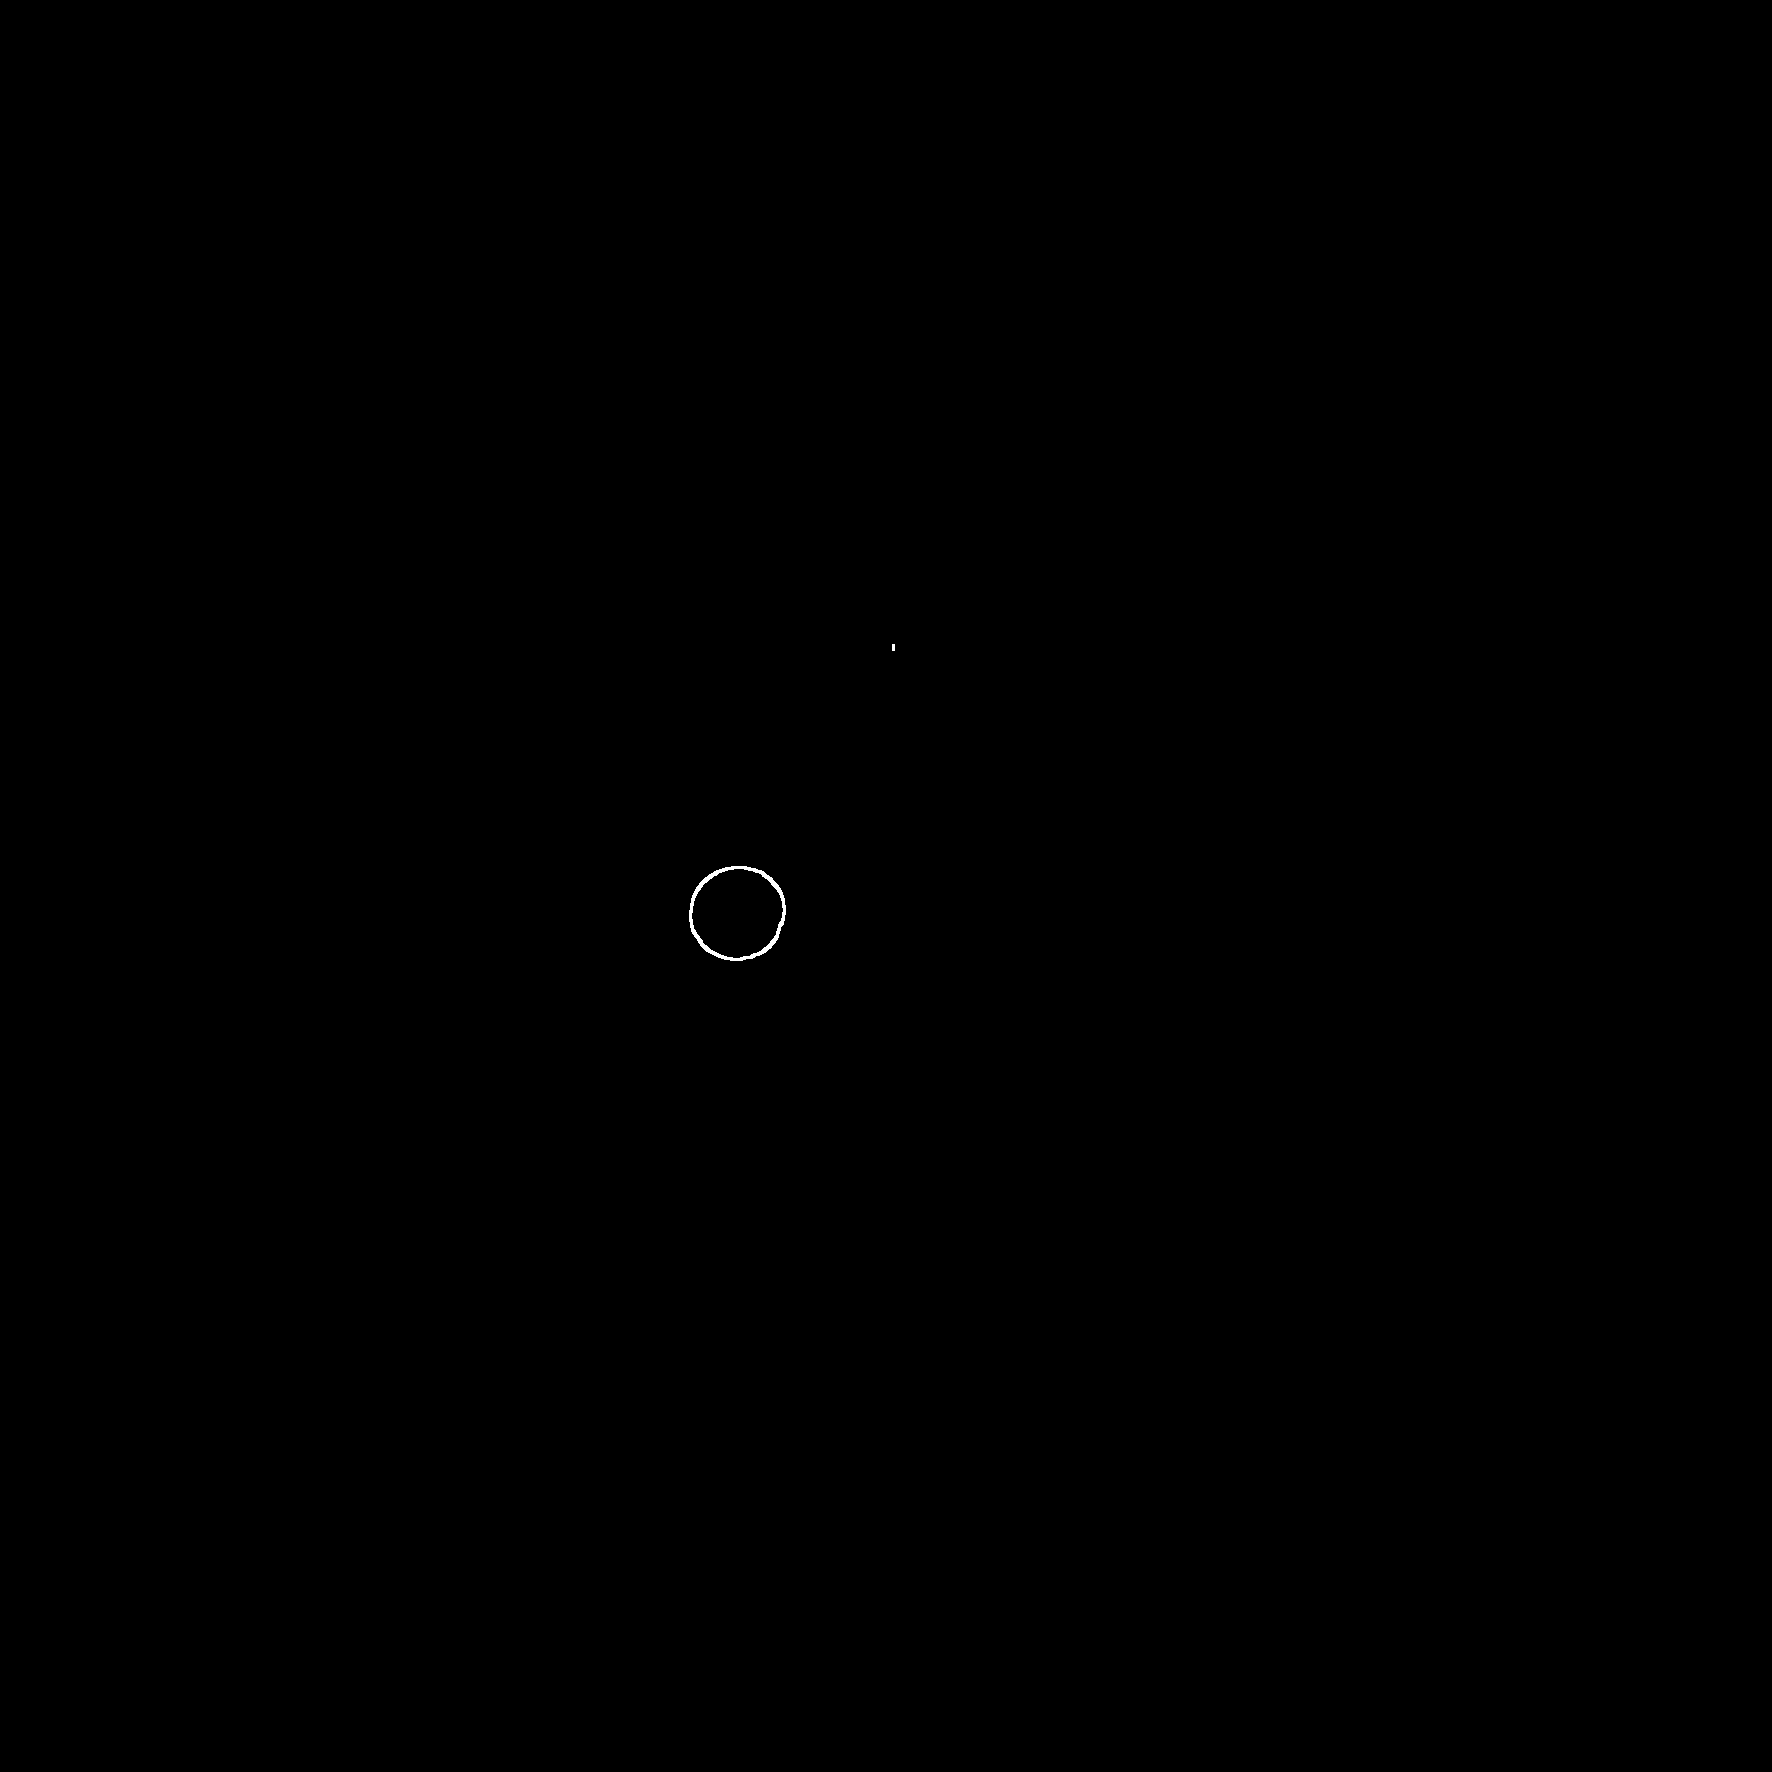

Liczba czarnych kropek: 1


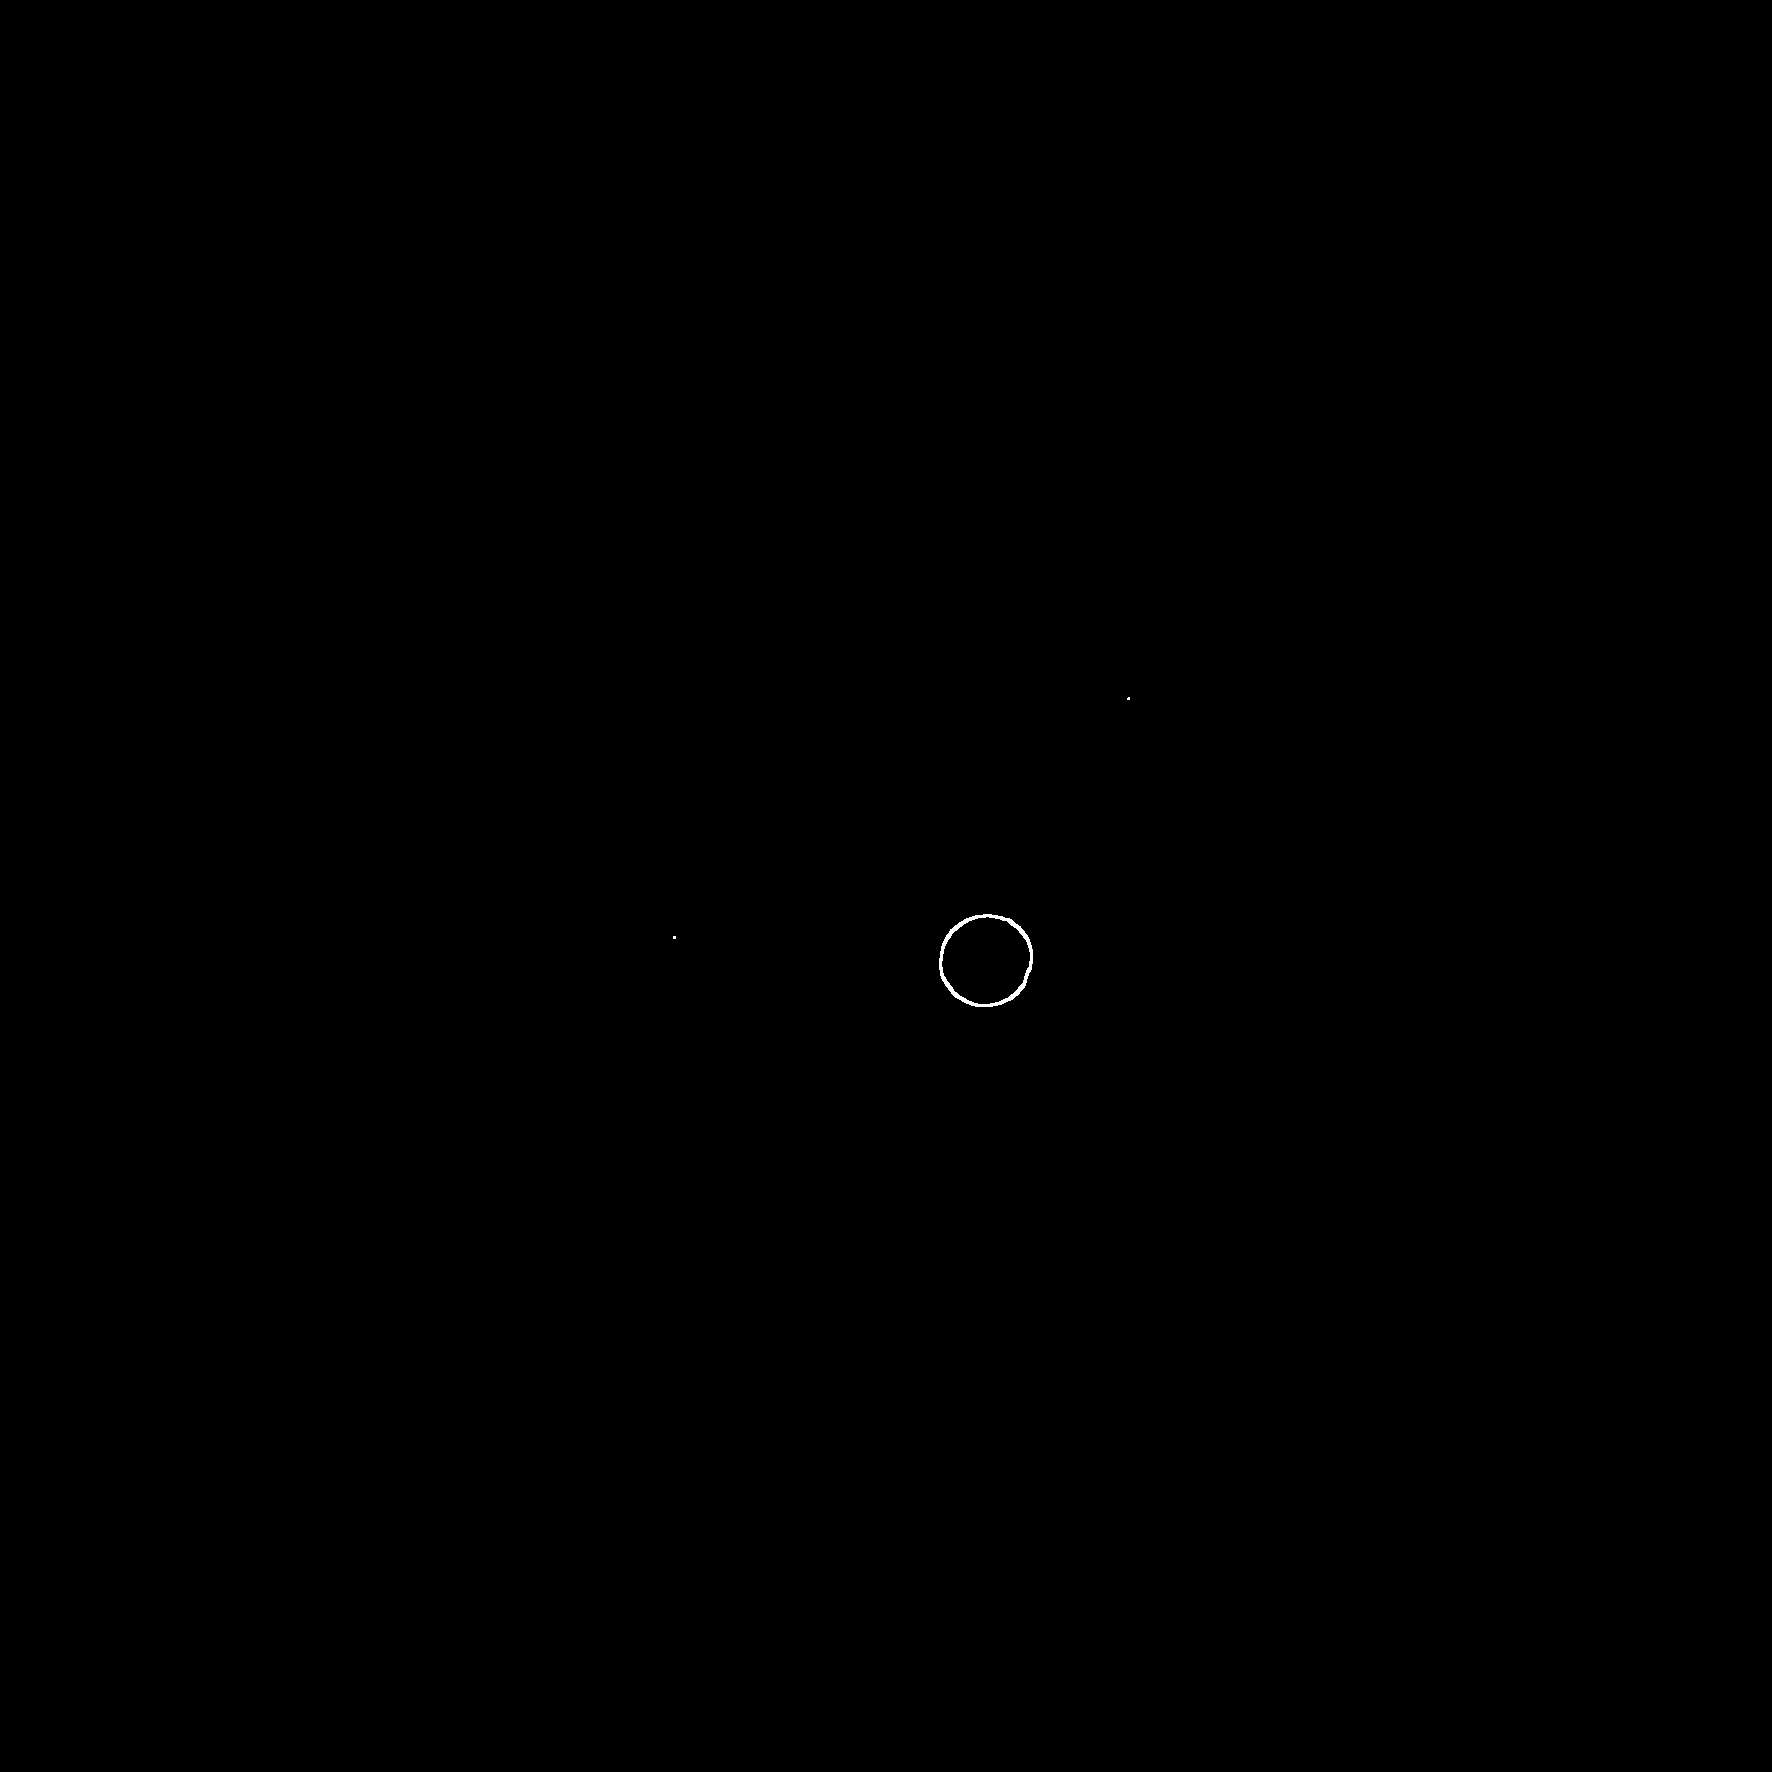

Liczba czarnych kropek: 1


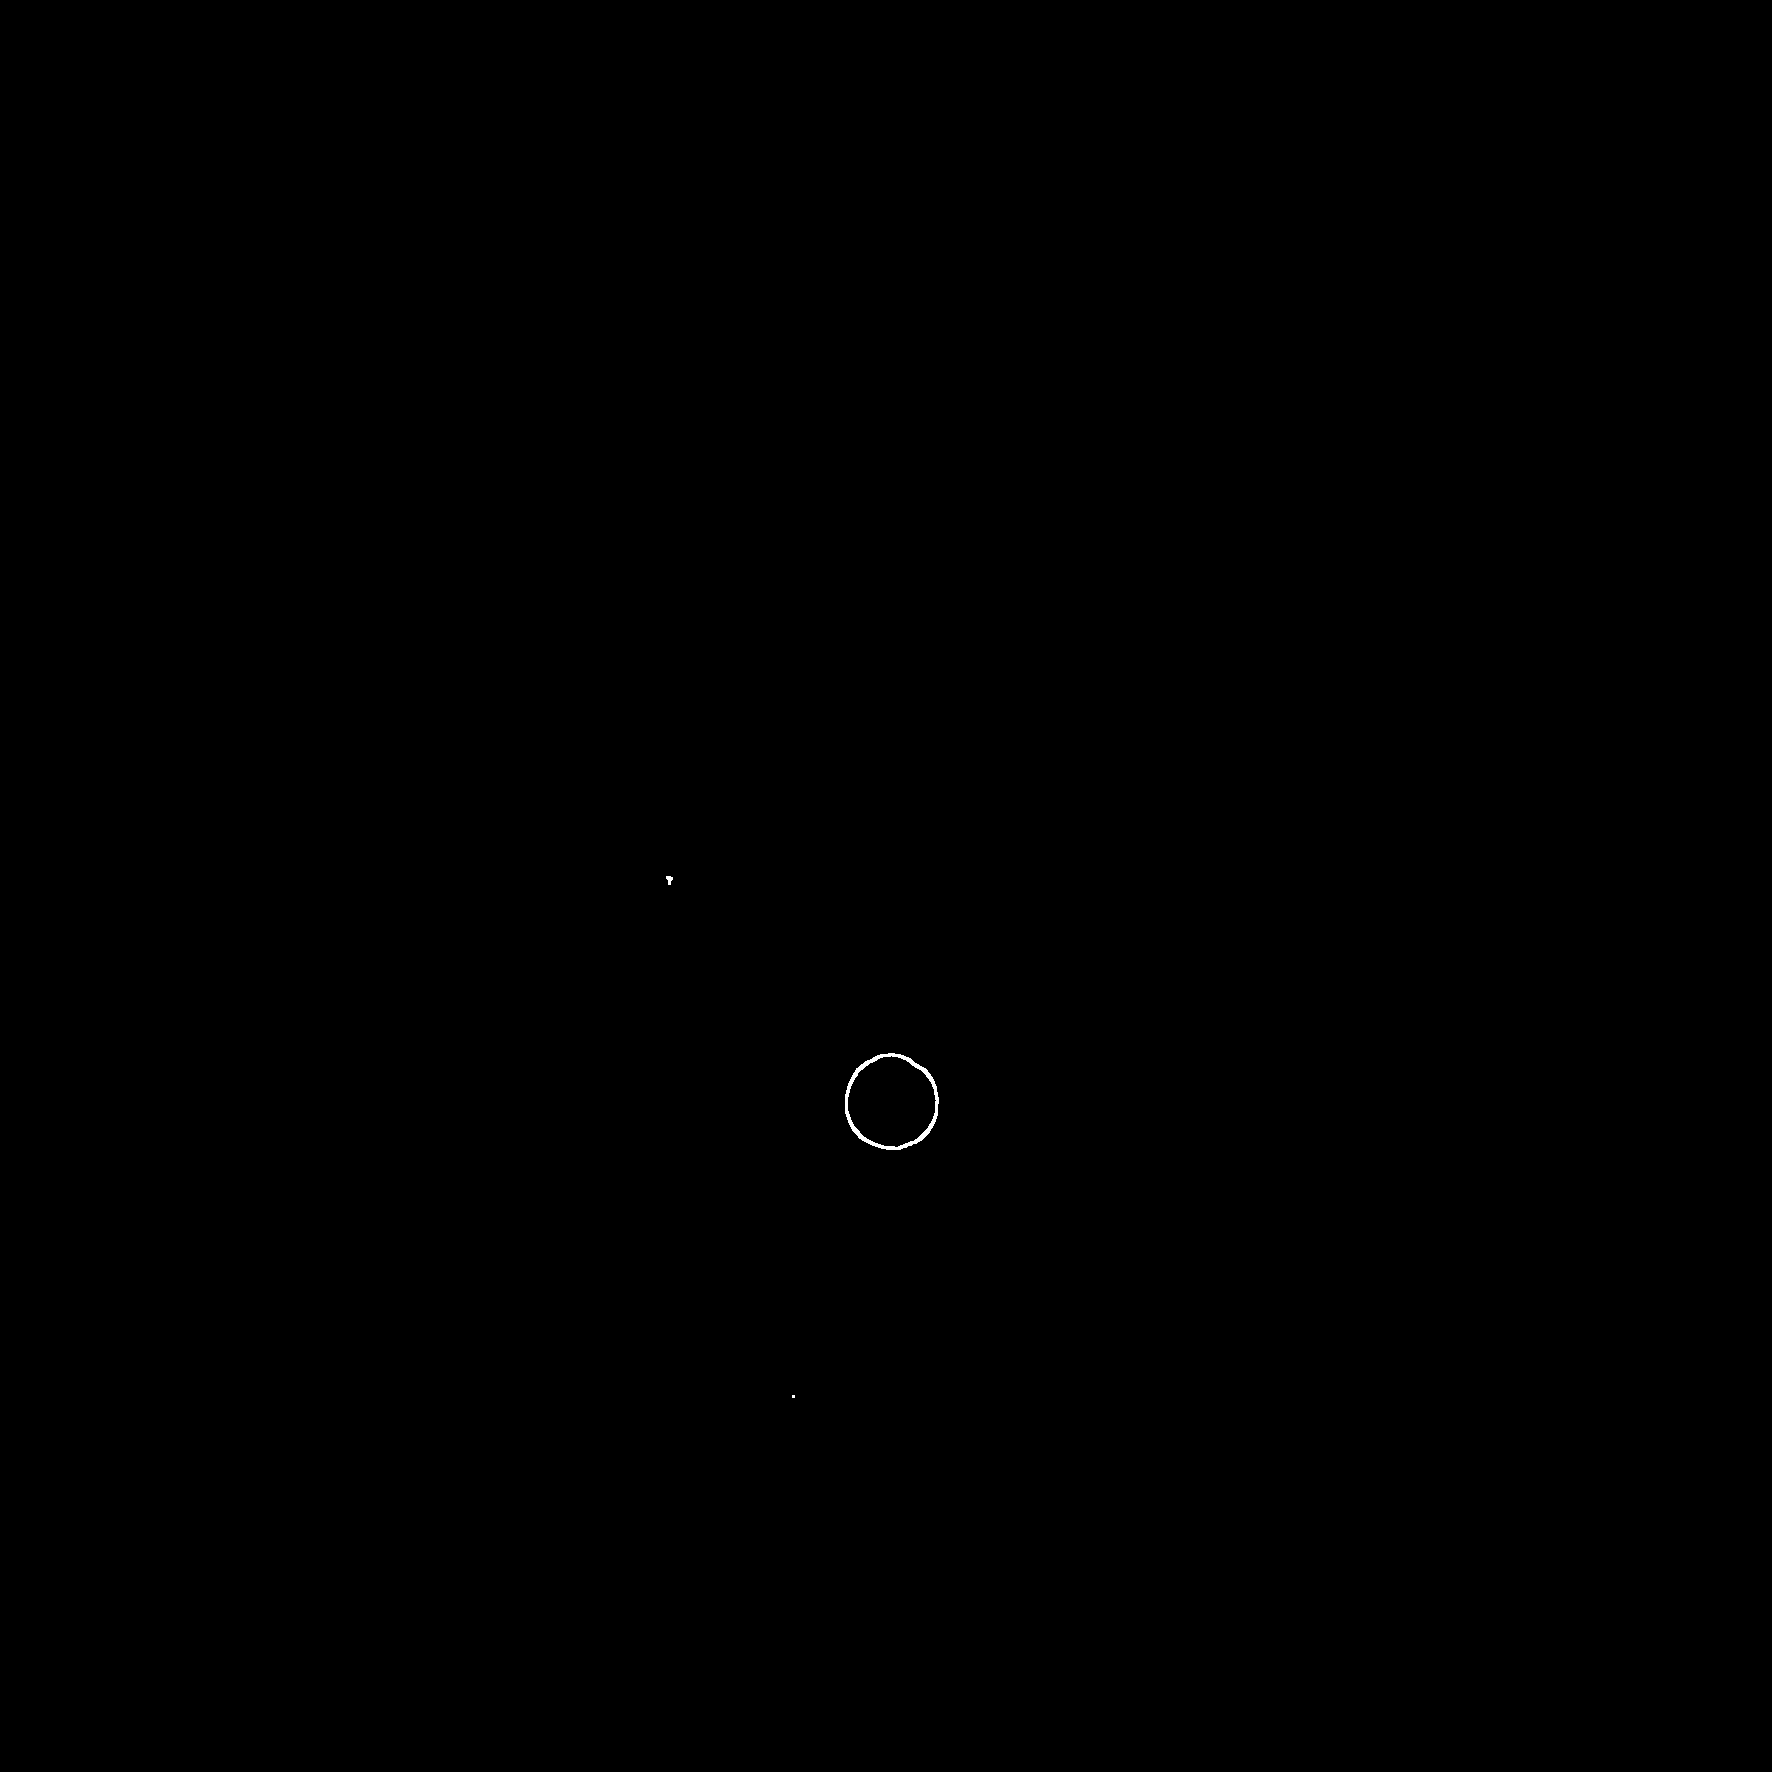

Liczba czarnych kropek: 1


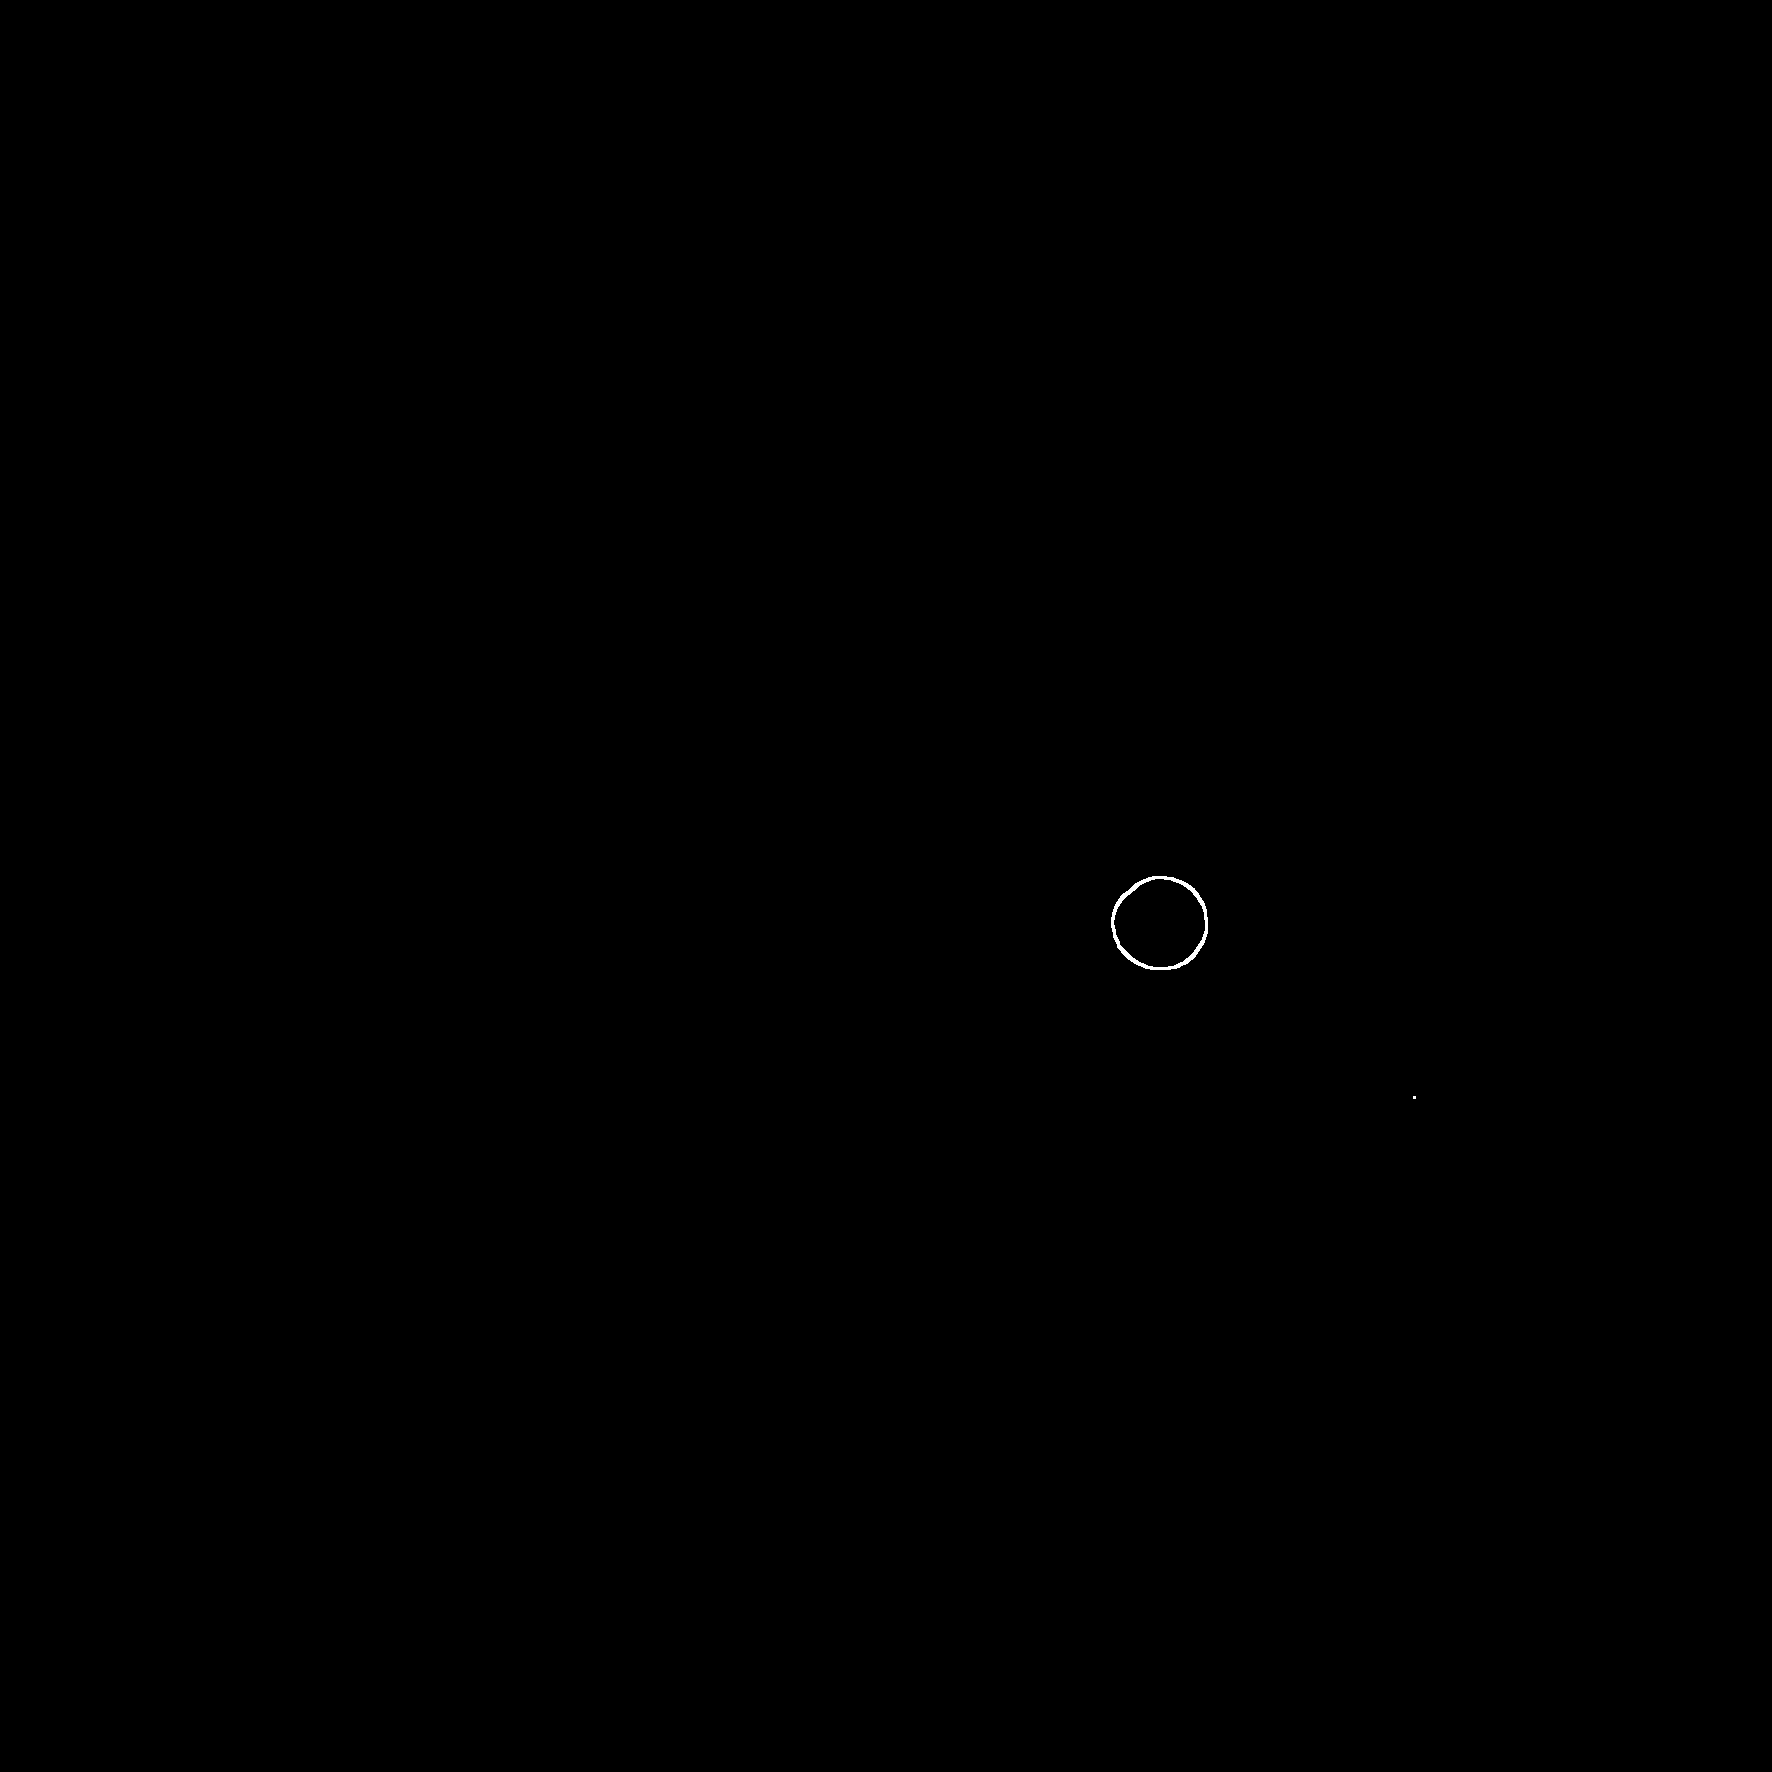

Liczba czarnych kropek: 1


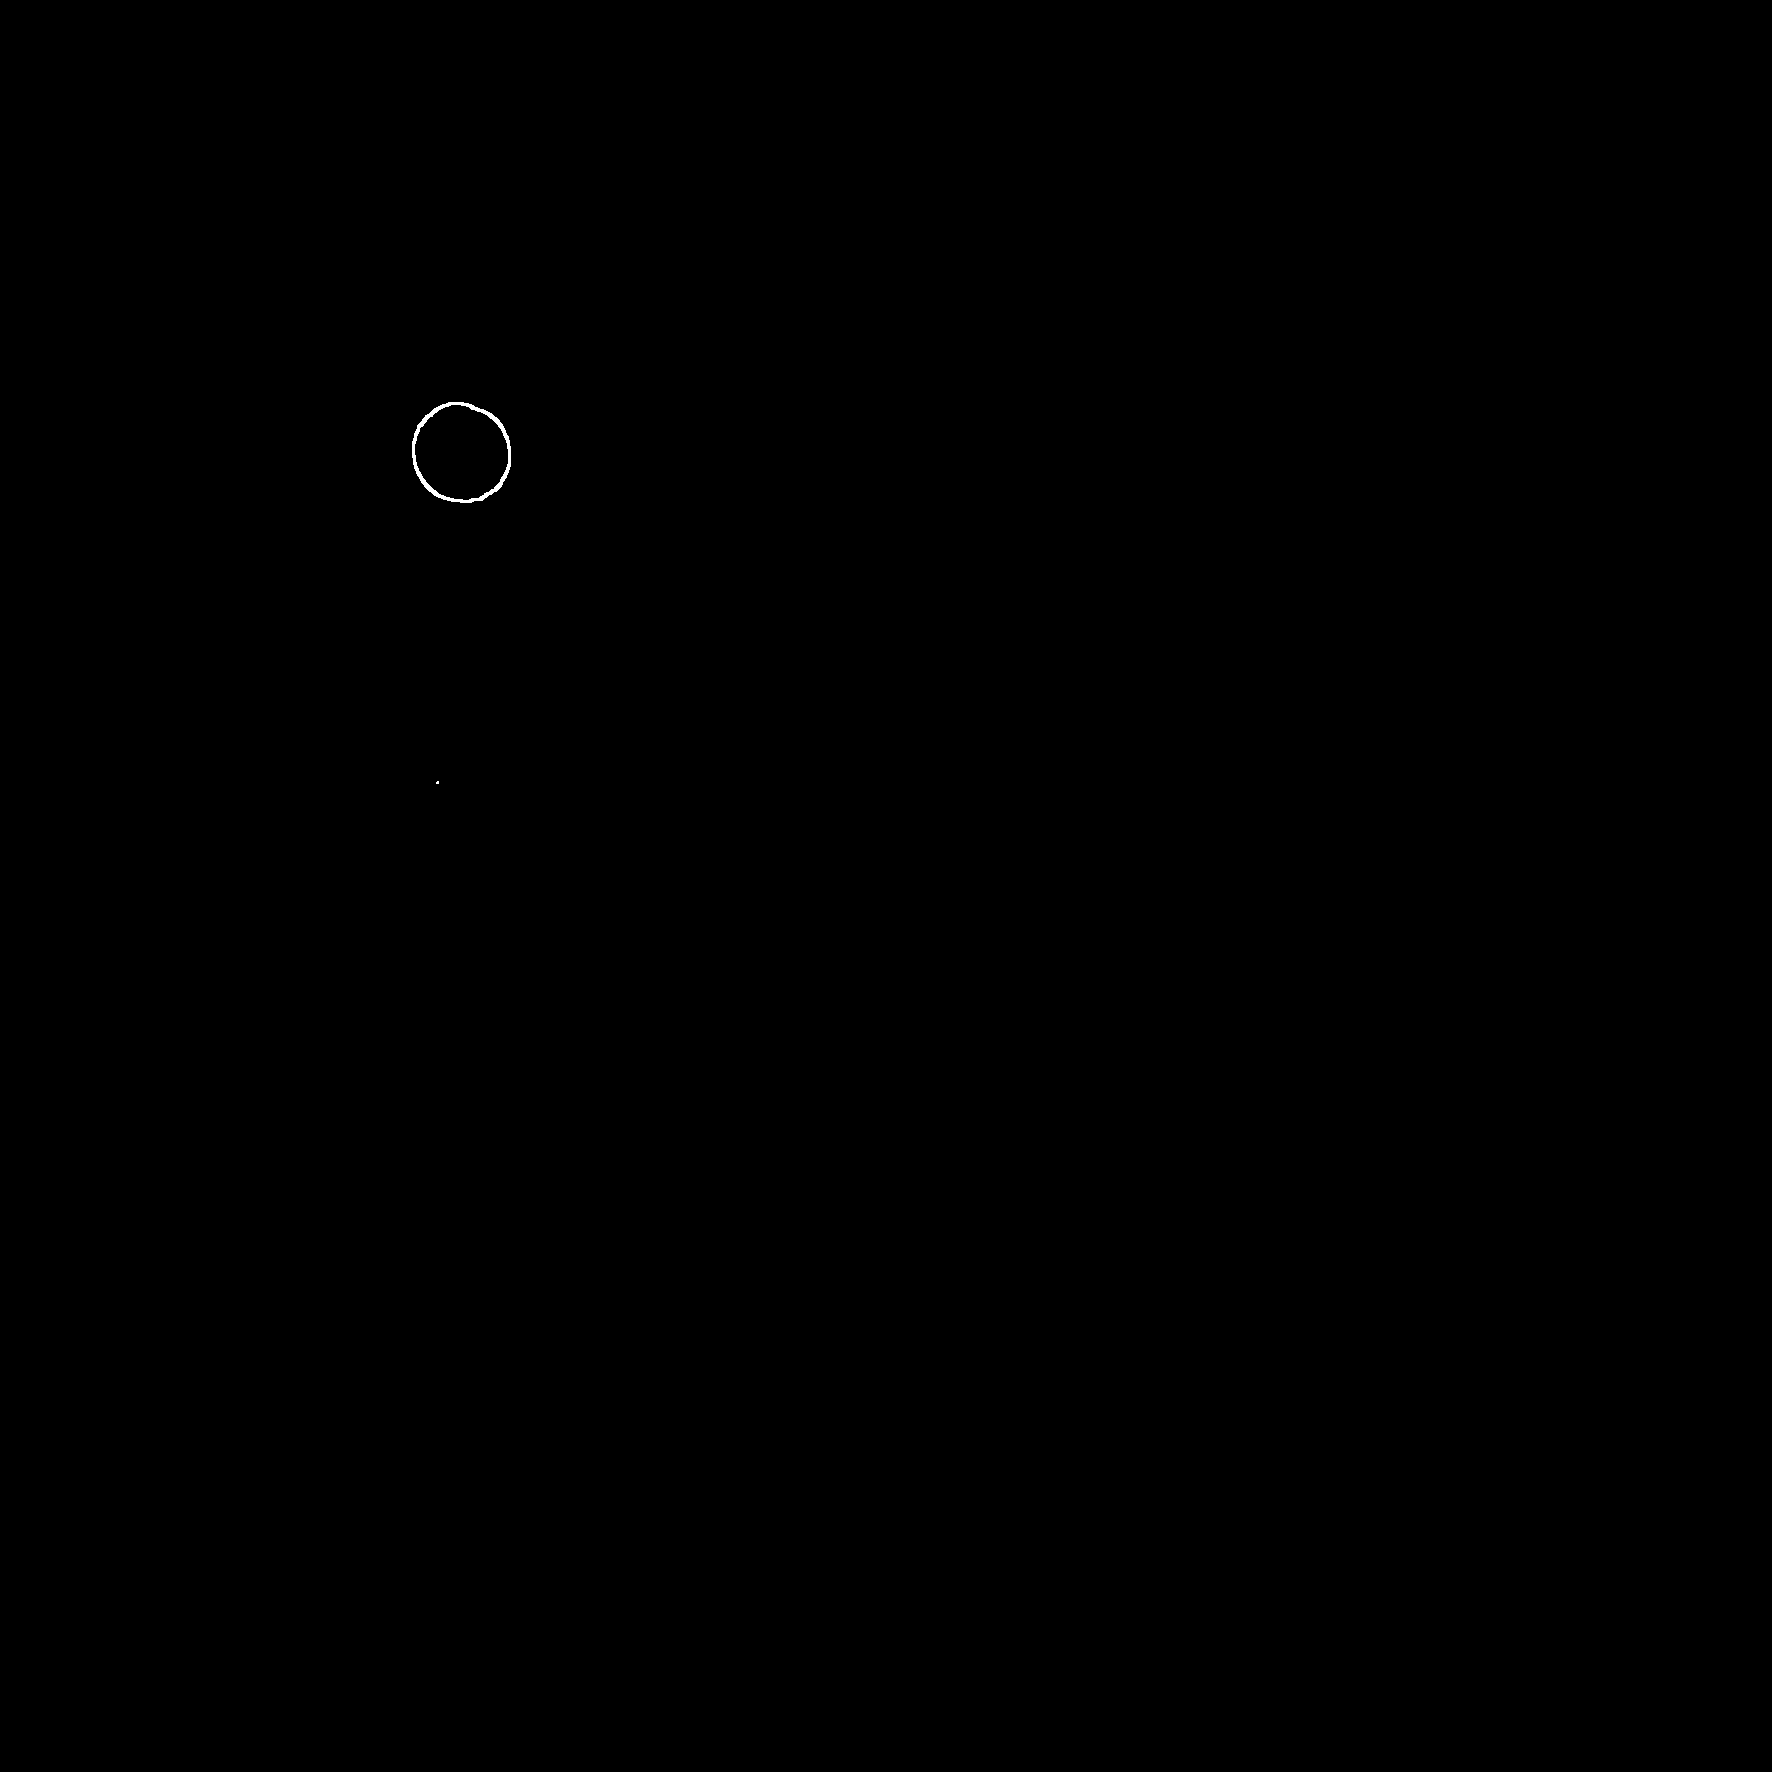

Liczba czarnych kropek: 1


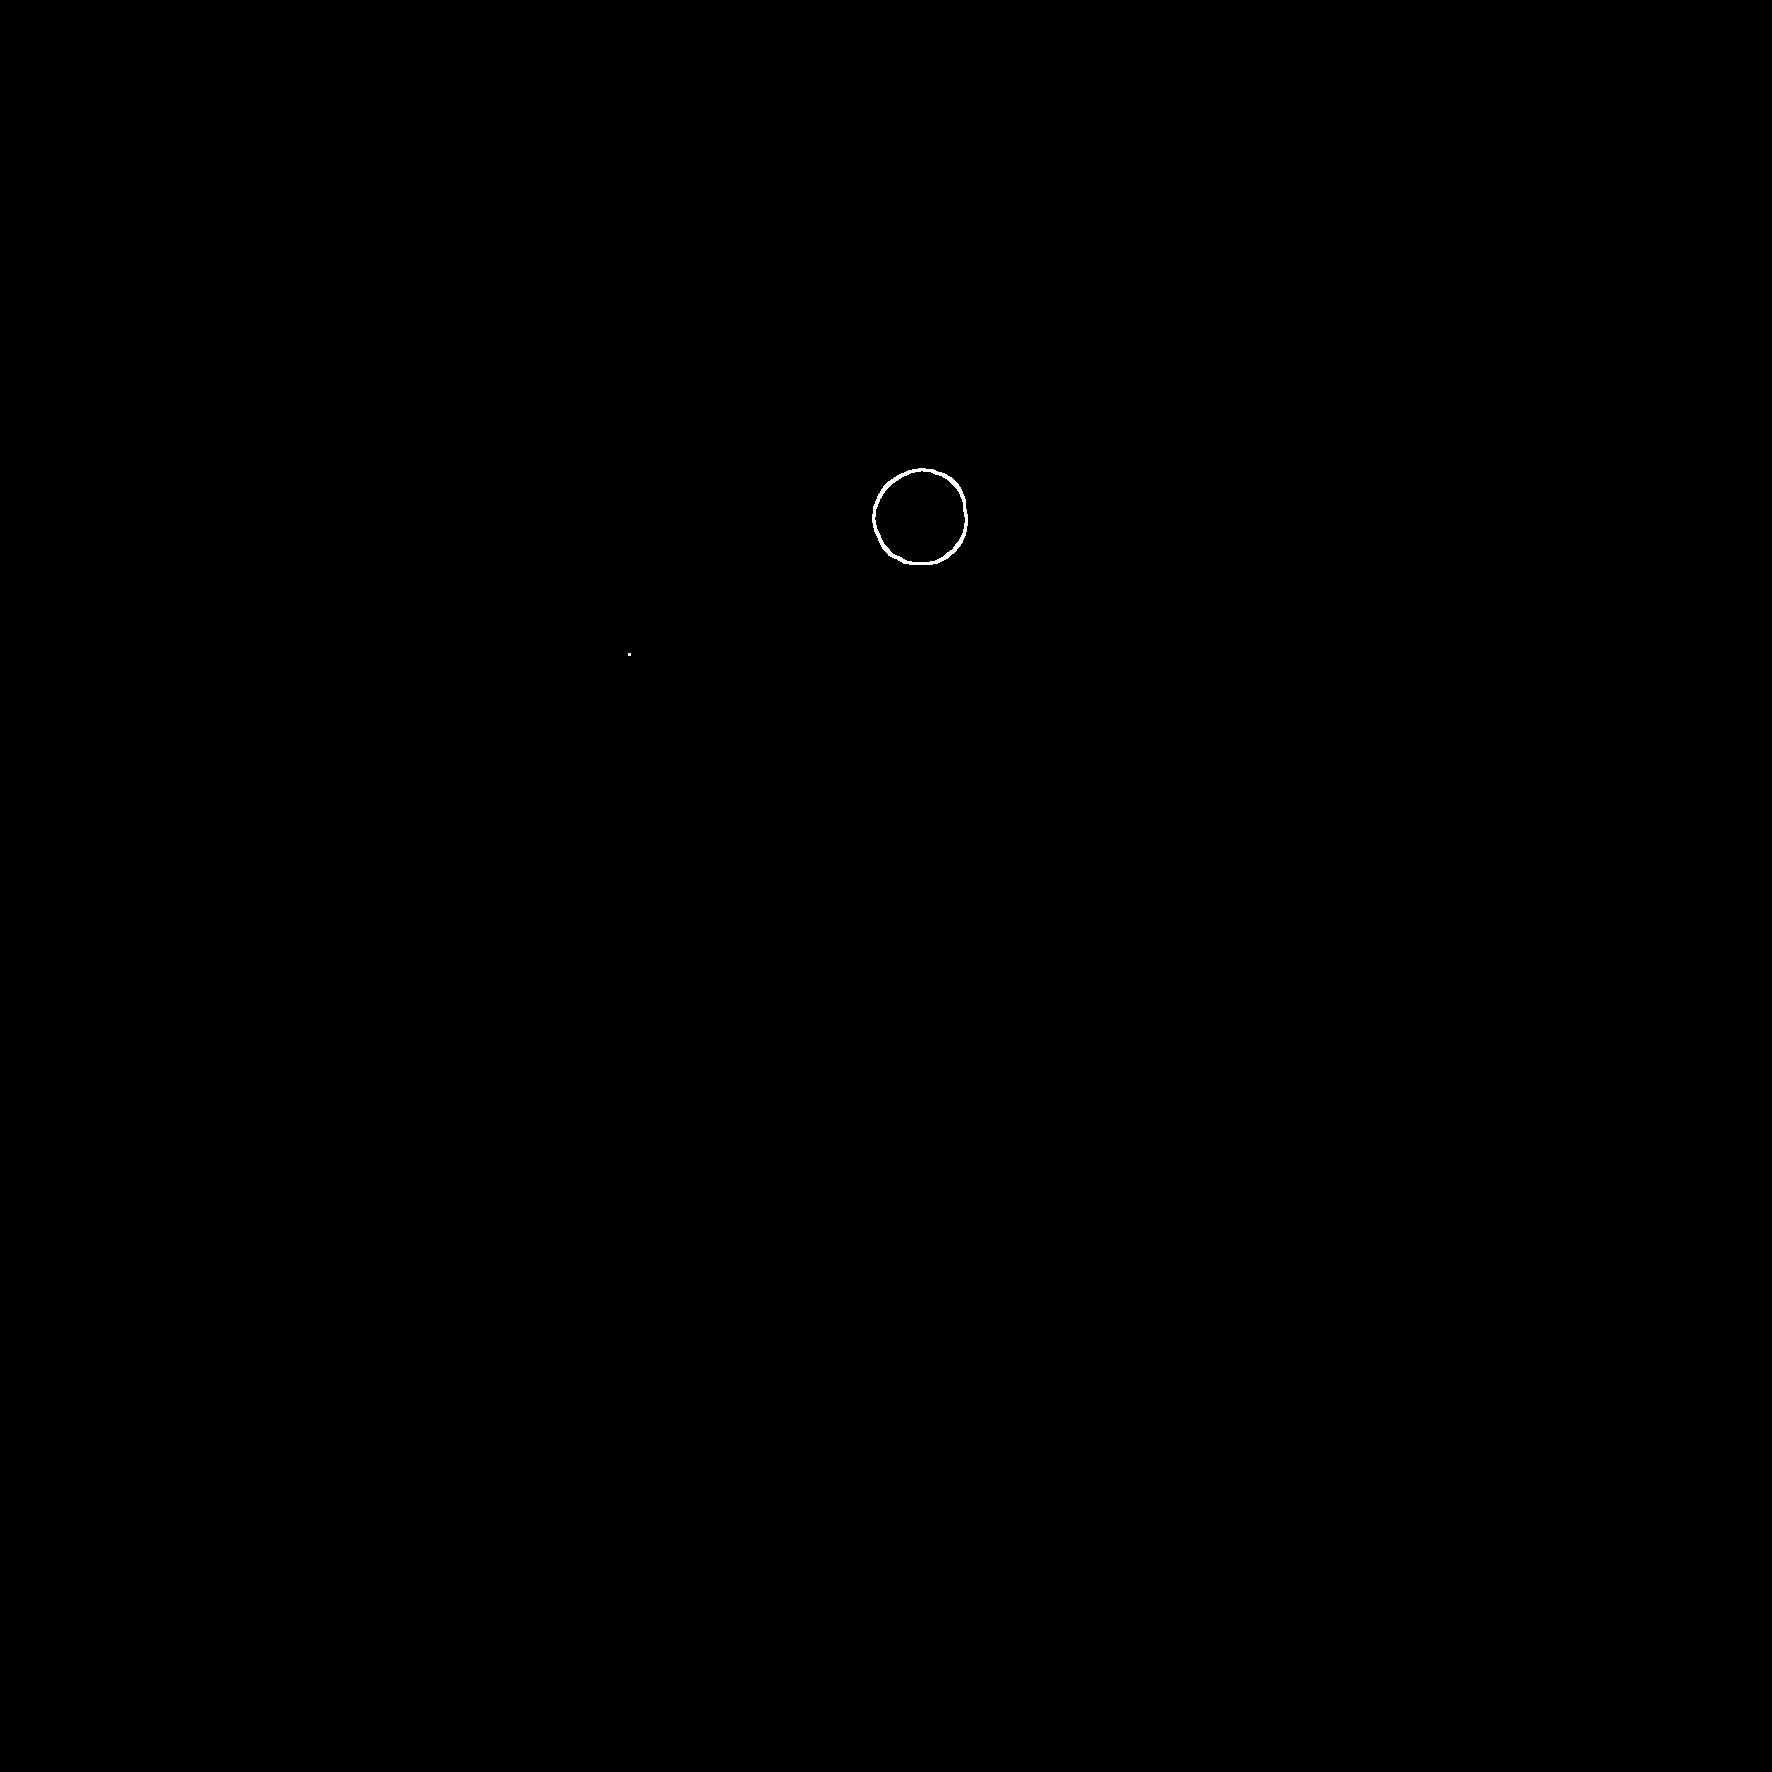

Liczba czarnych kropek: 1


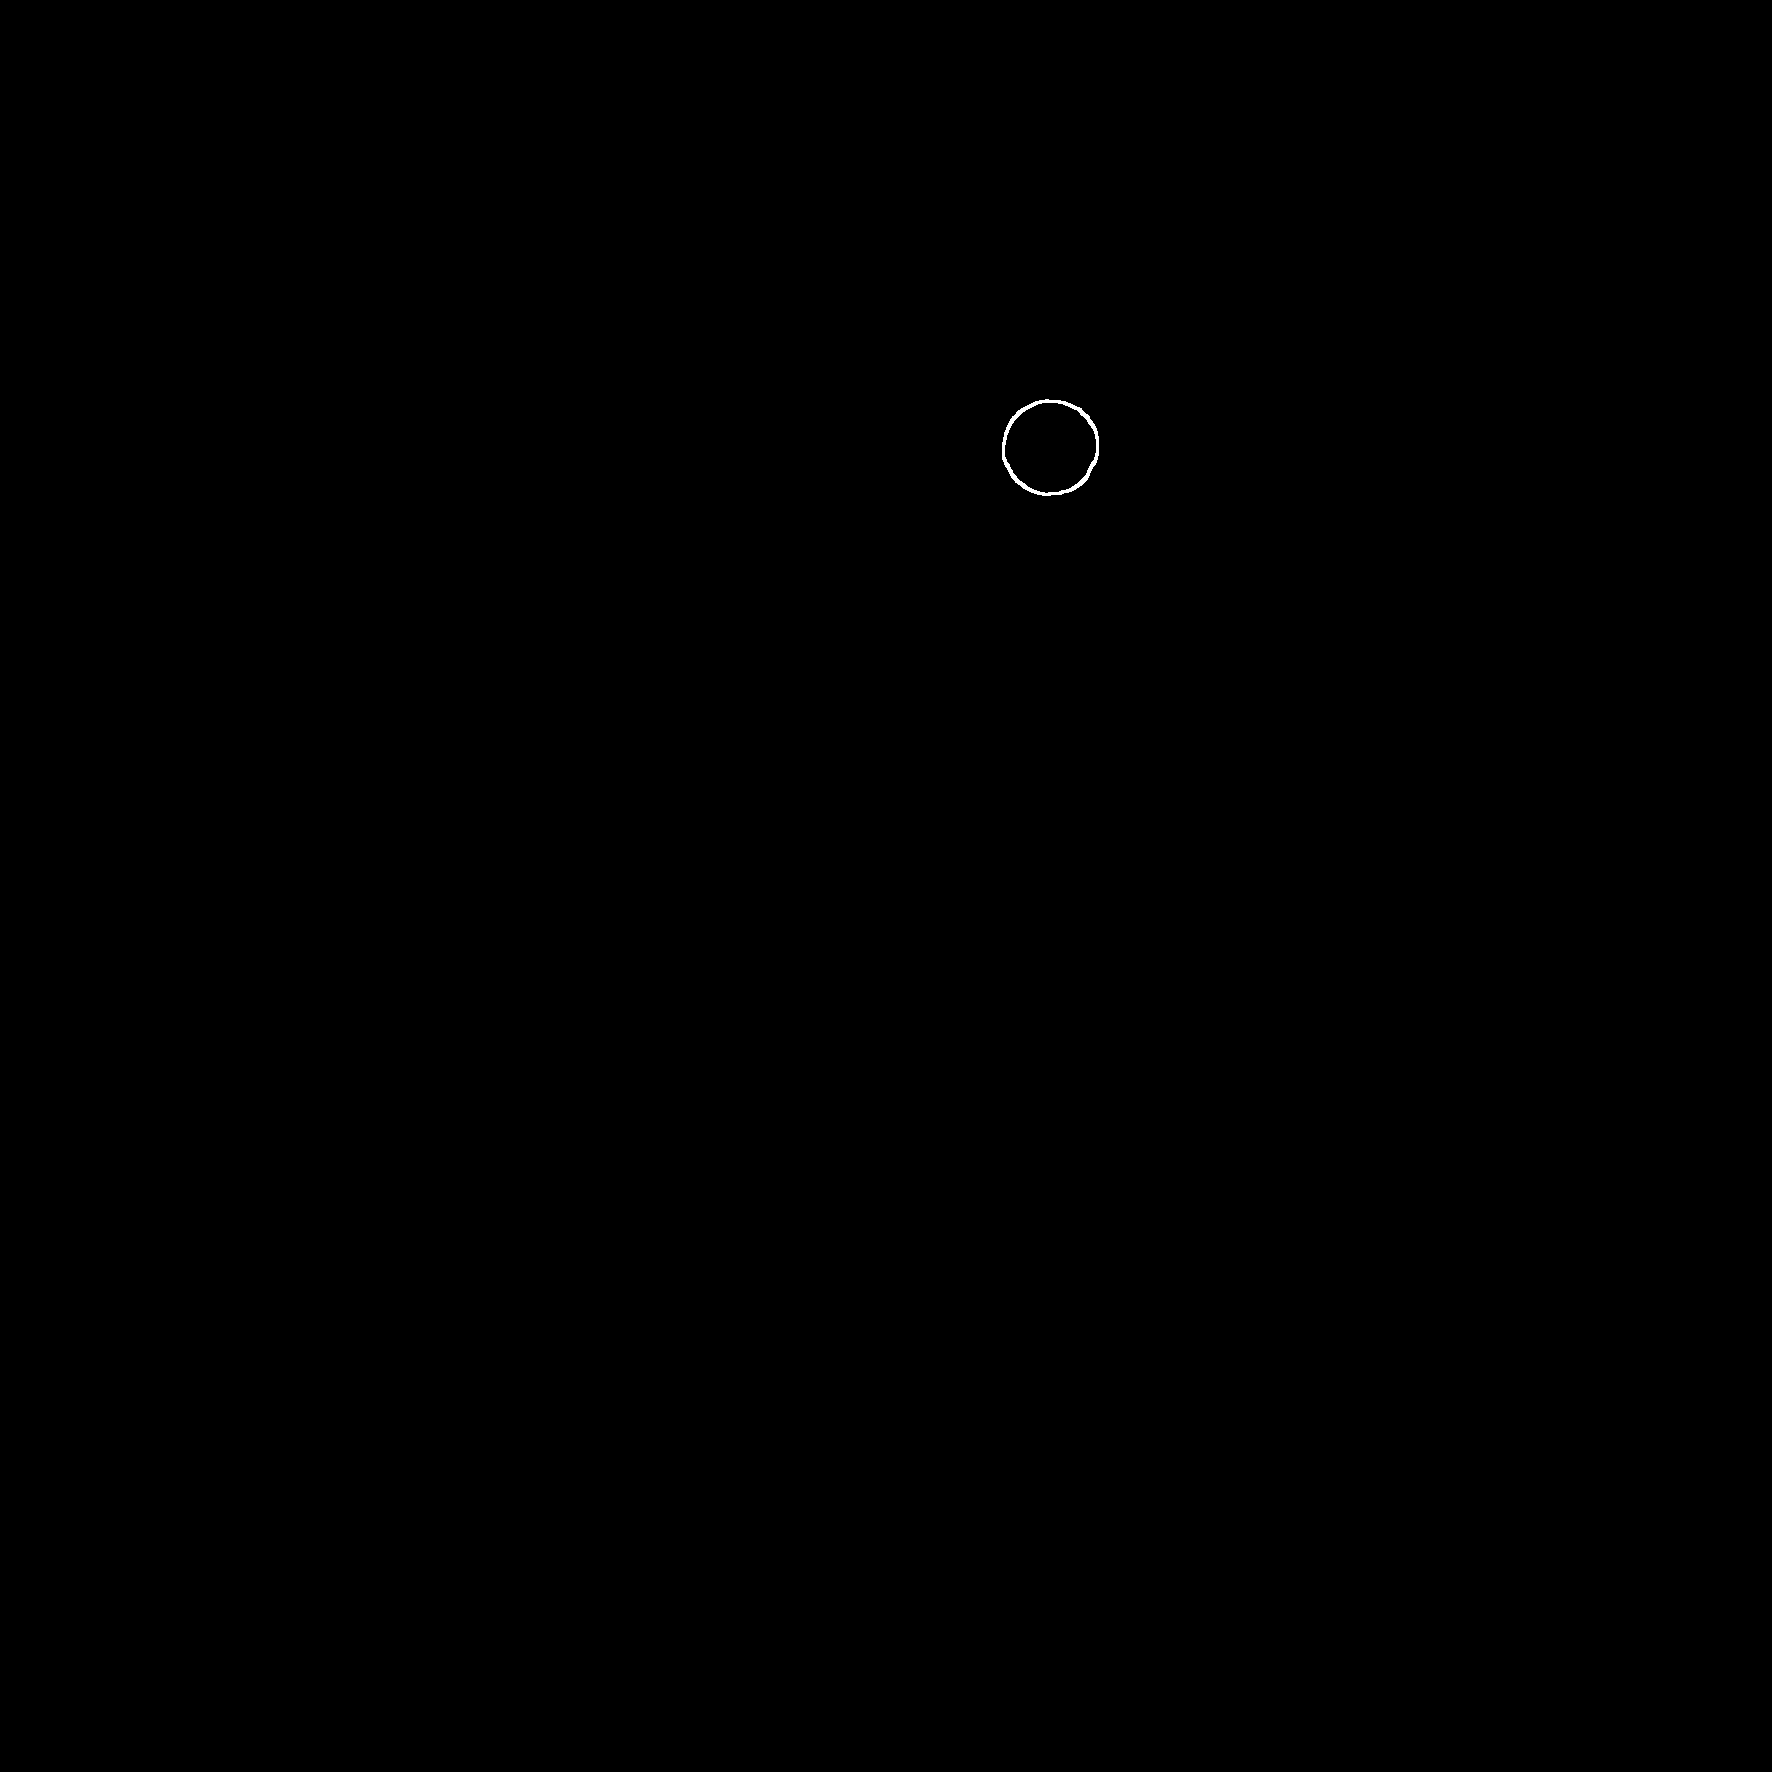

Liczba czarnych kropek: 1


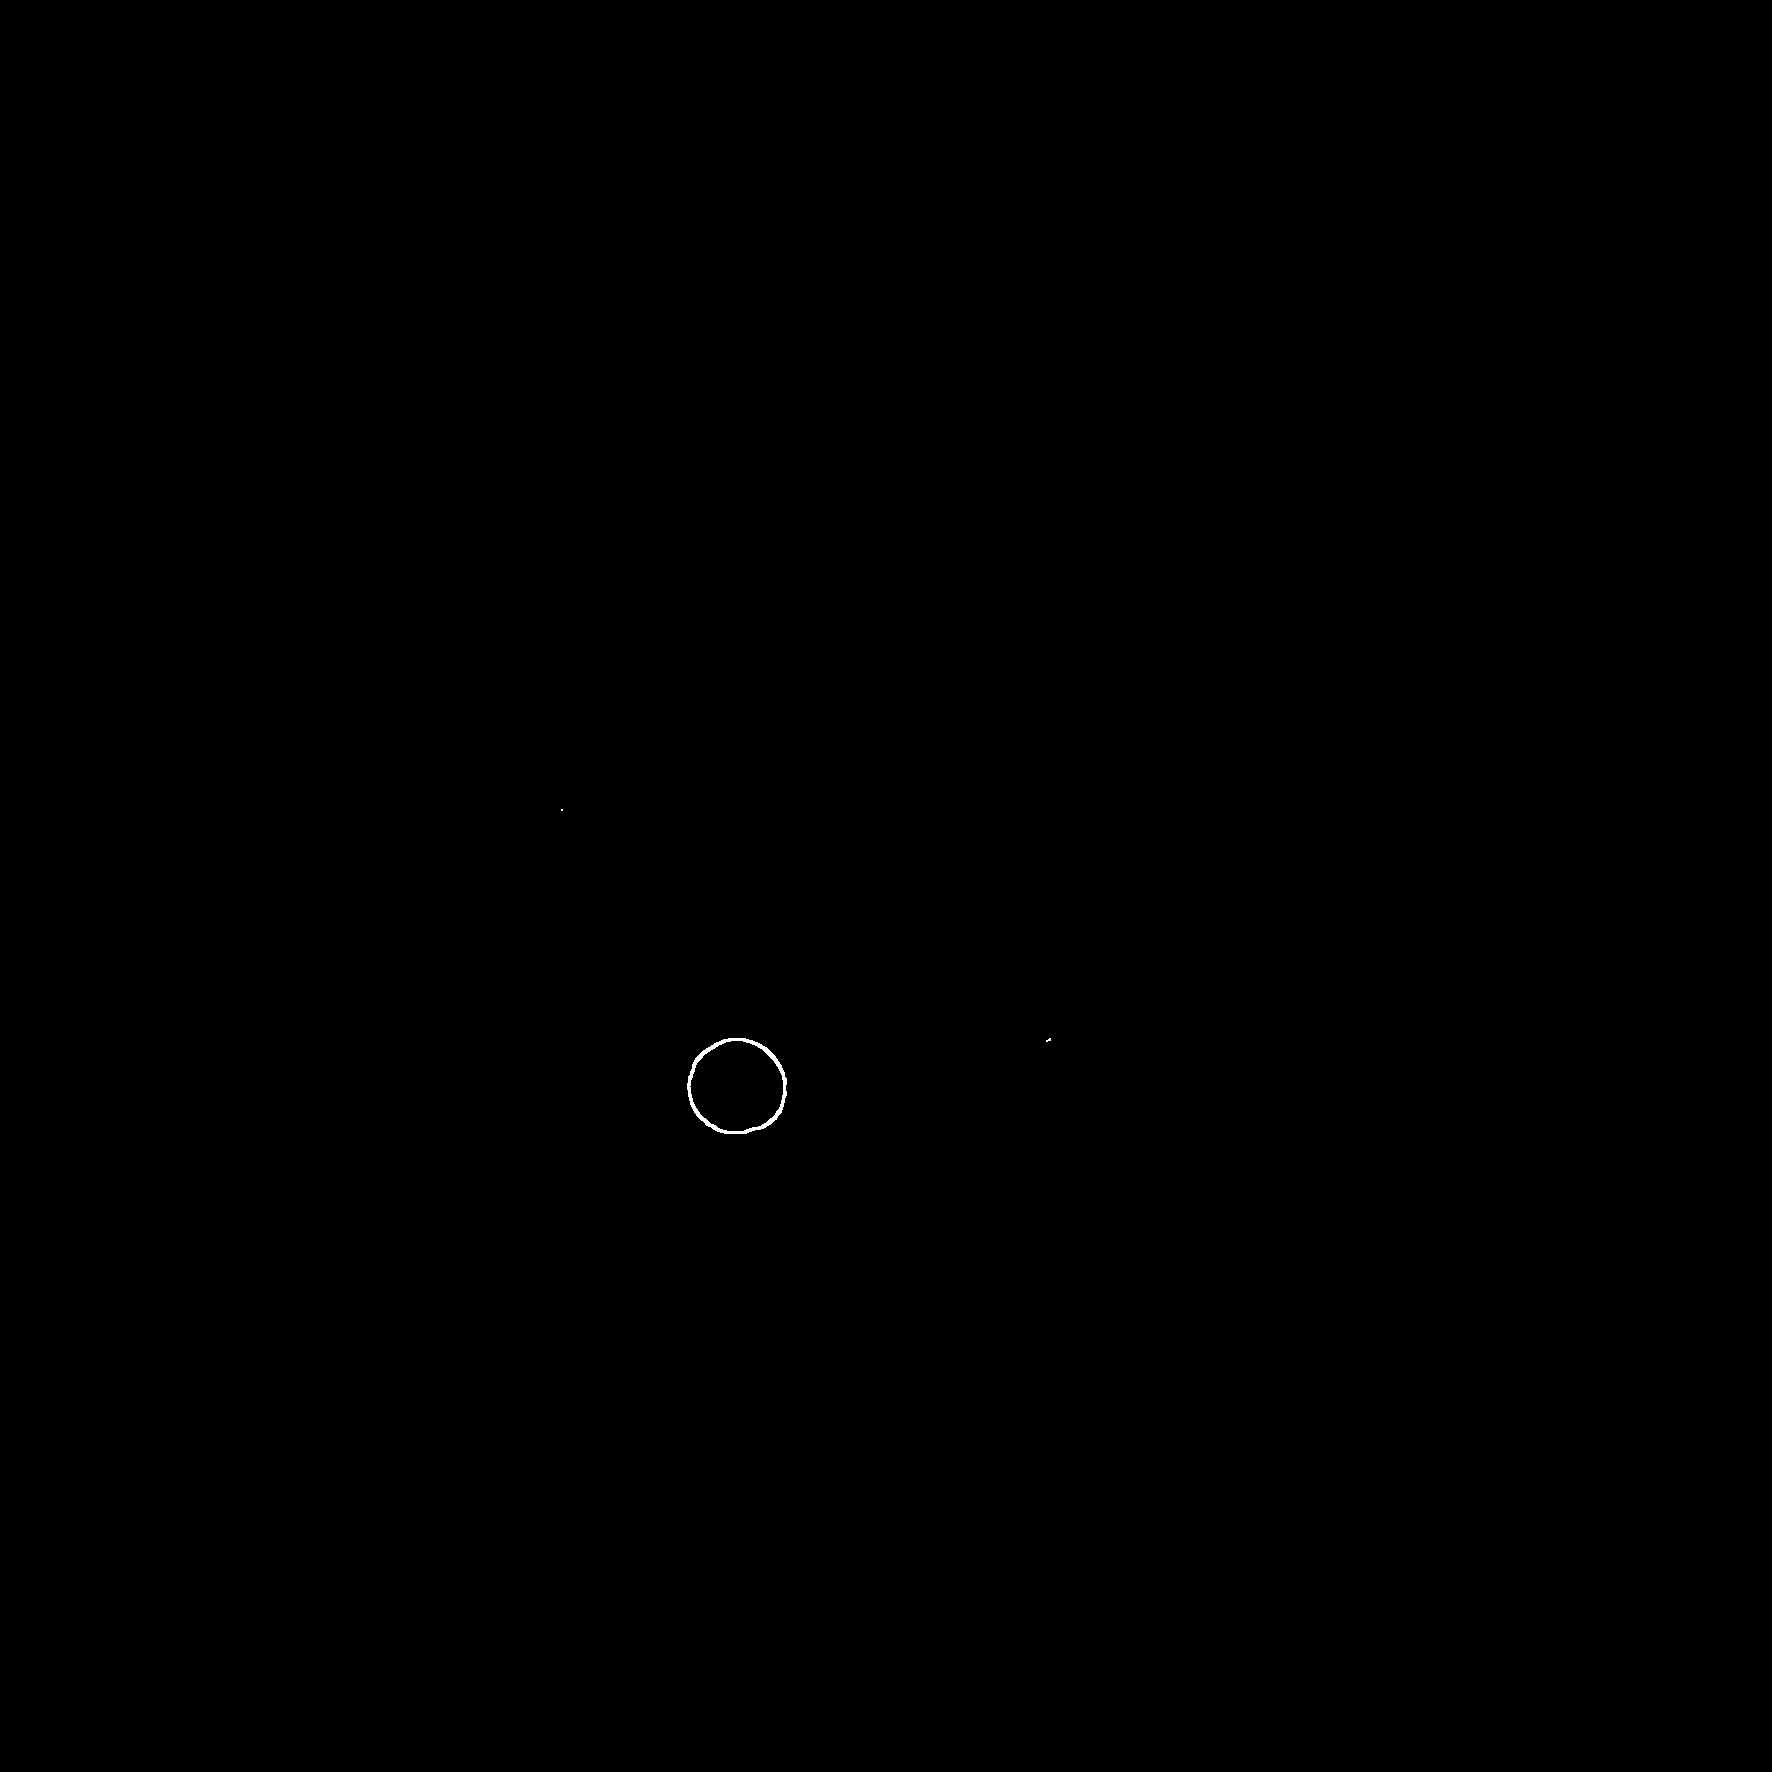

Liczba czarnych kropek: 1


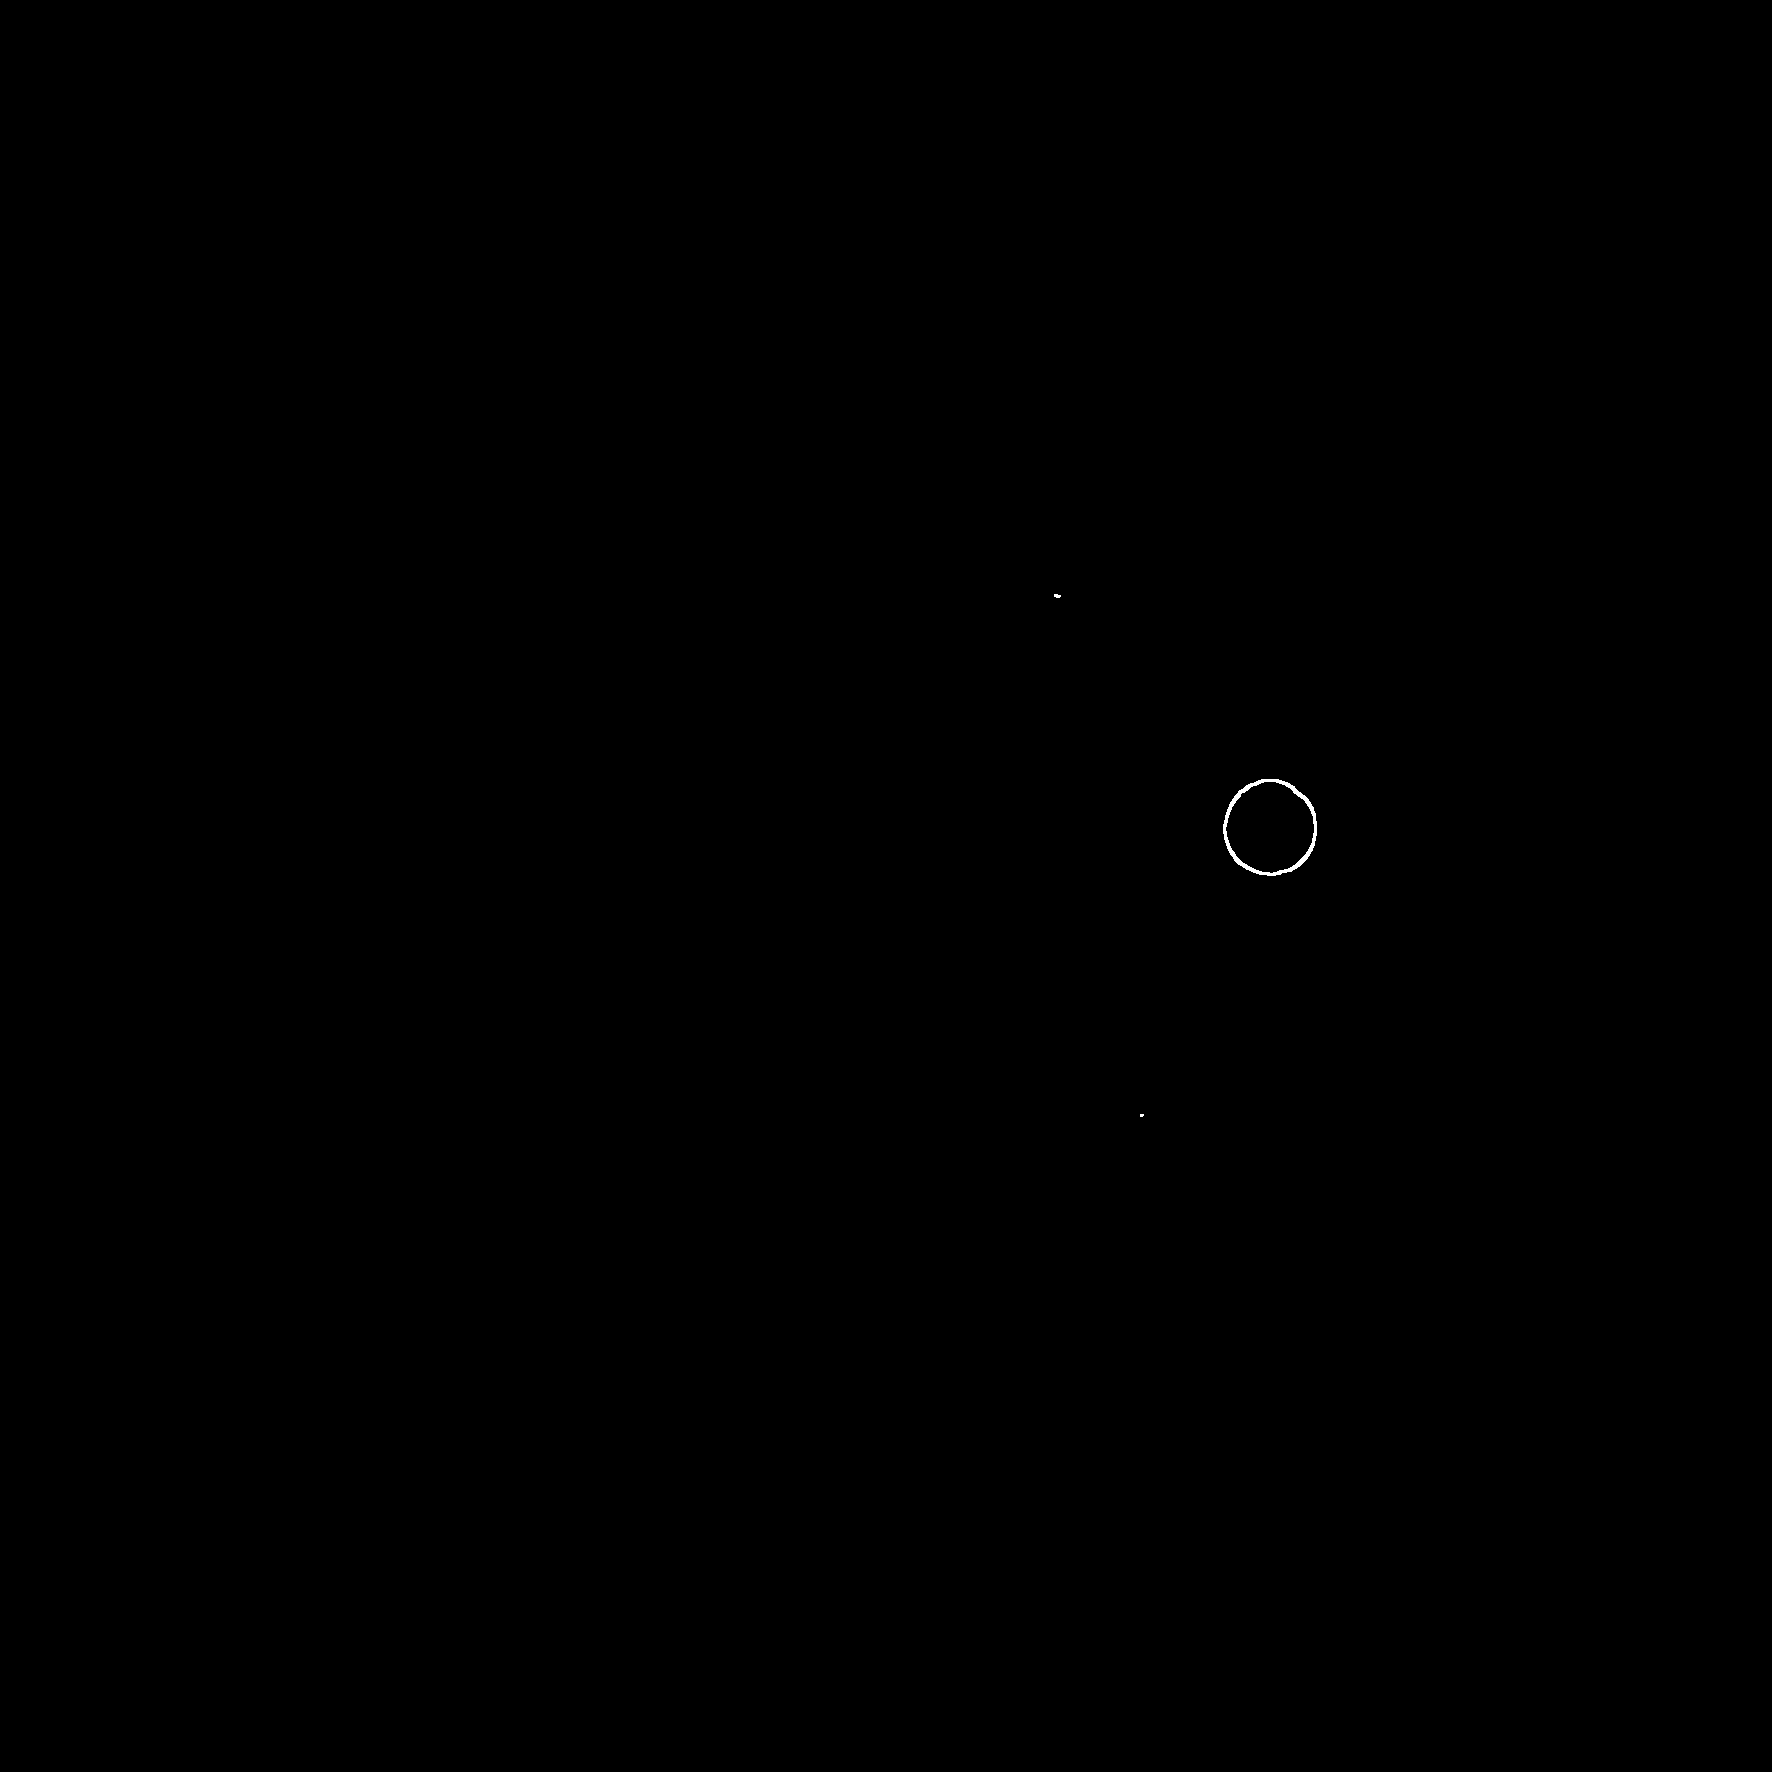

Liczba czarnych kropek: 1


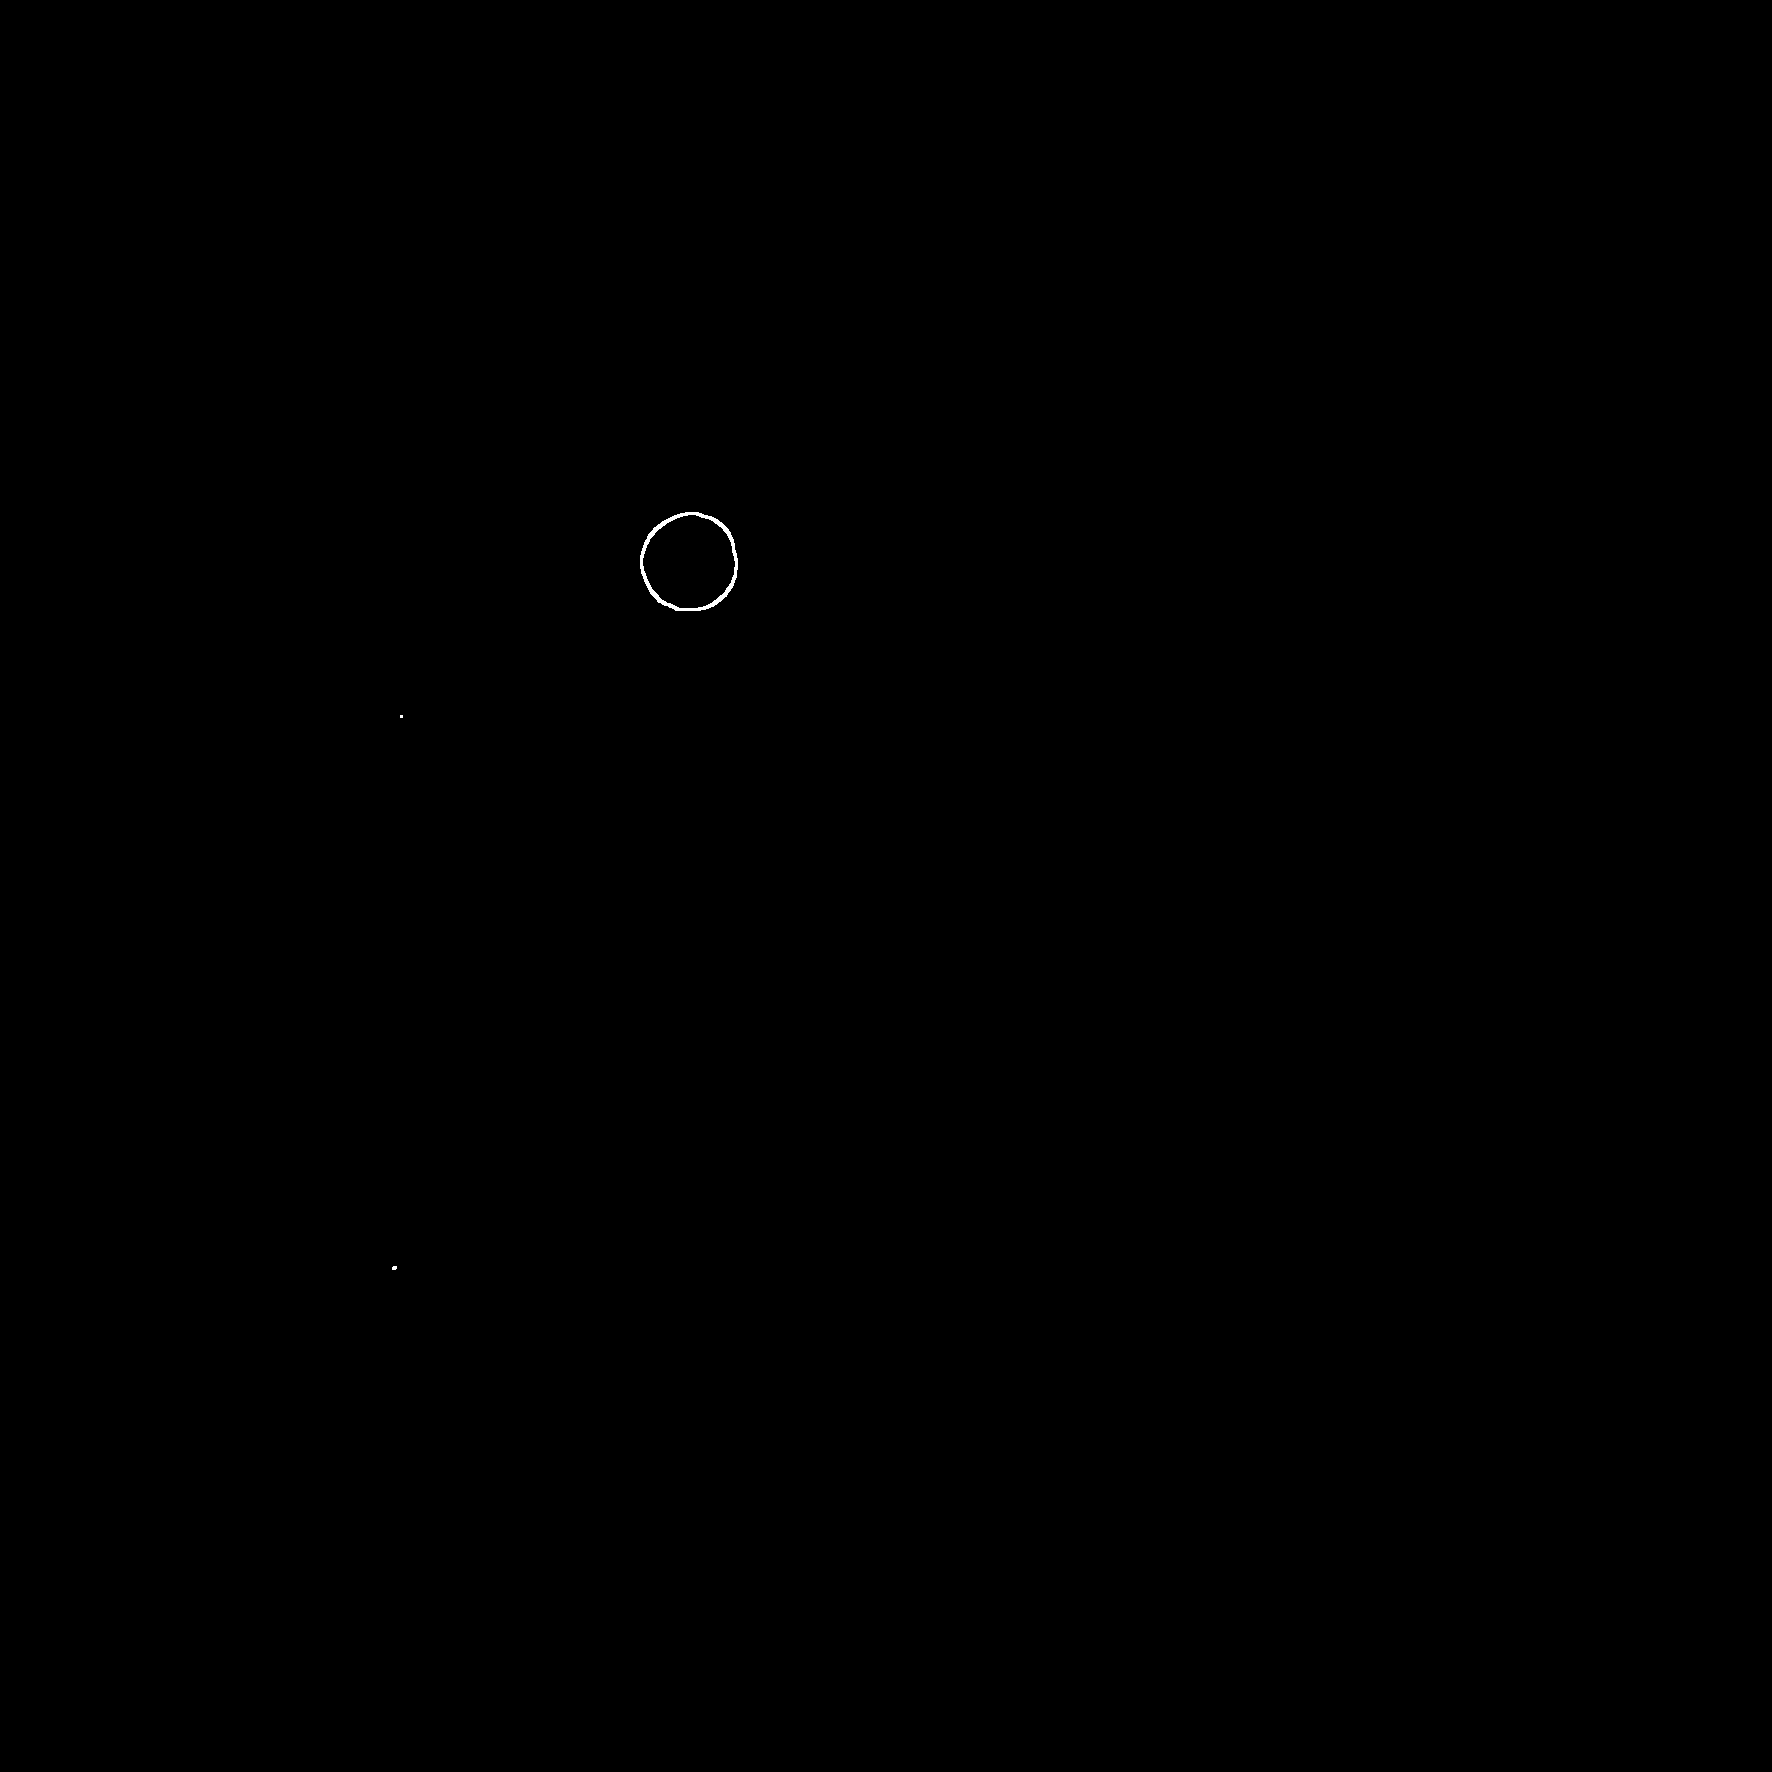

Liczba czarnych kropek: 1


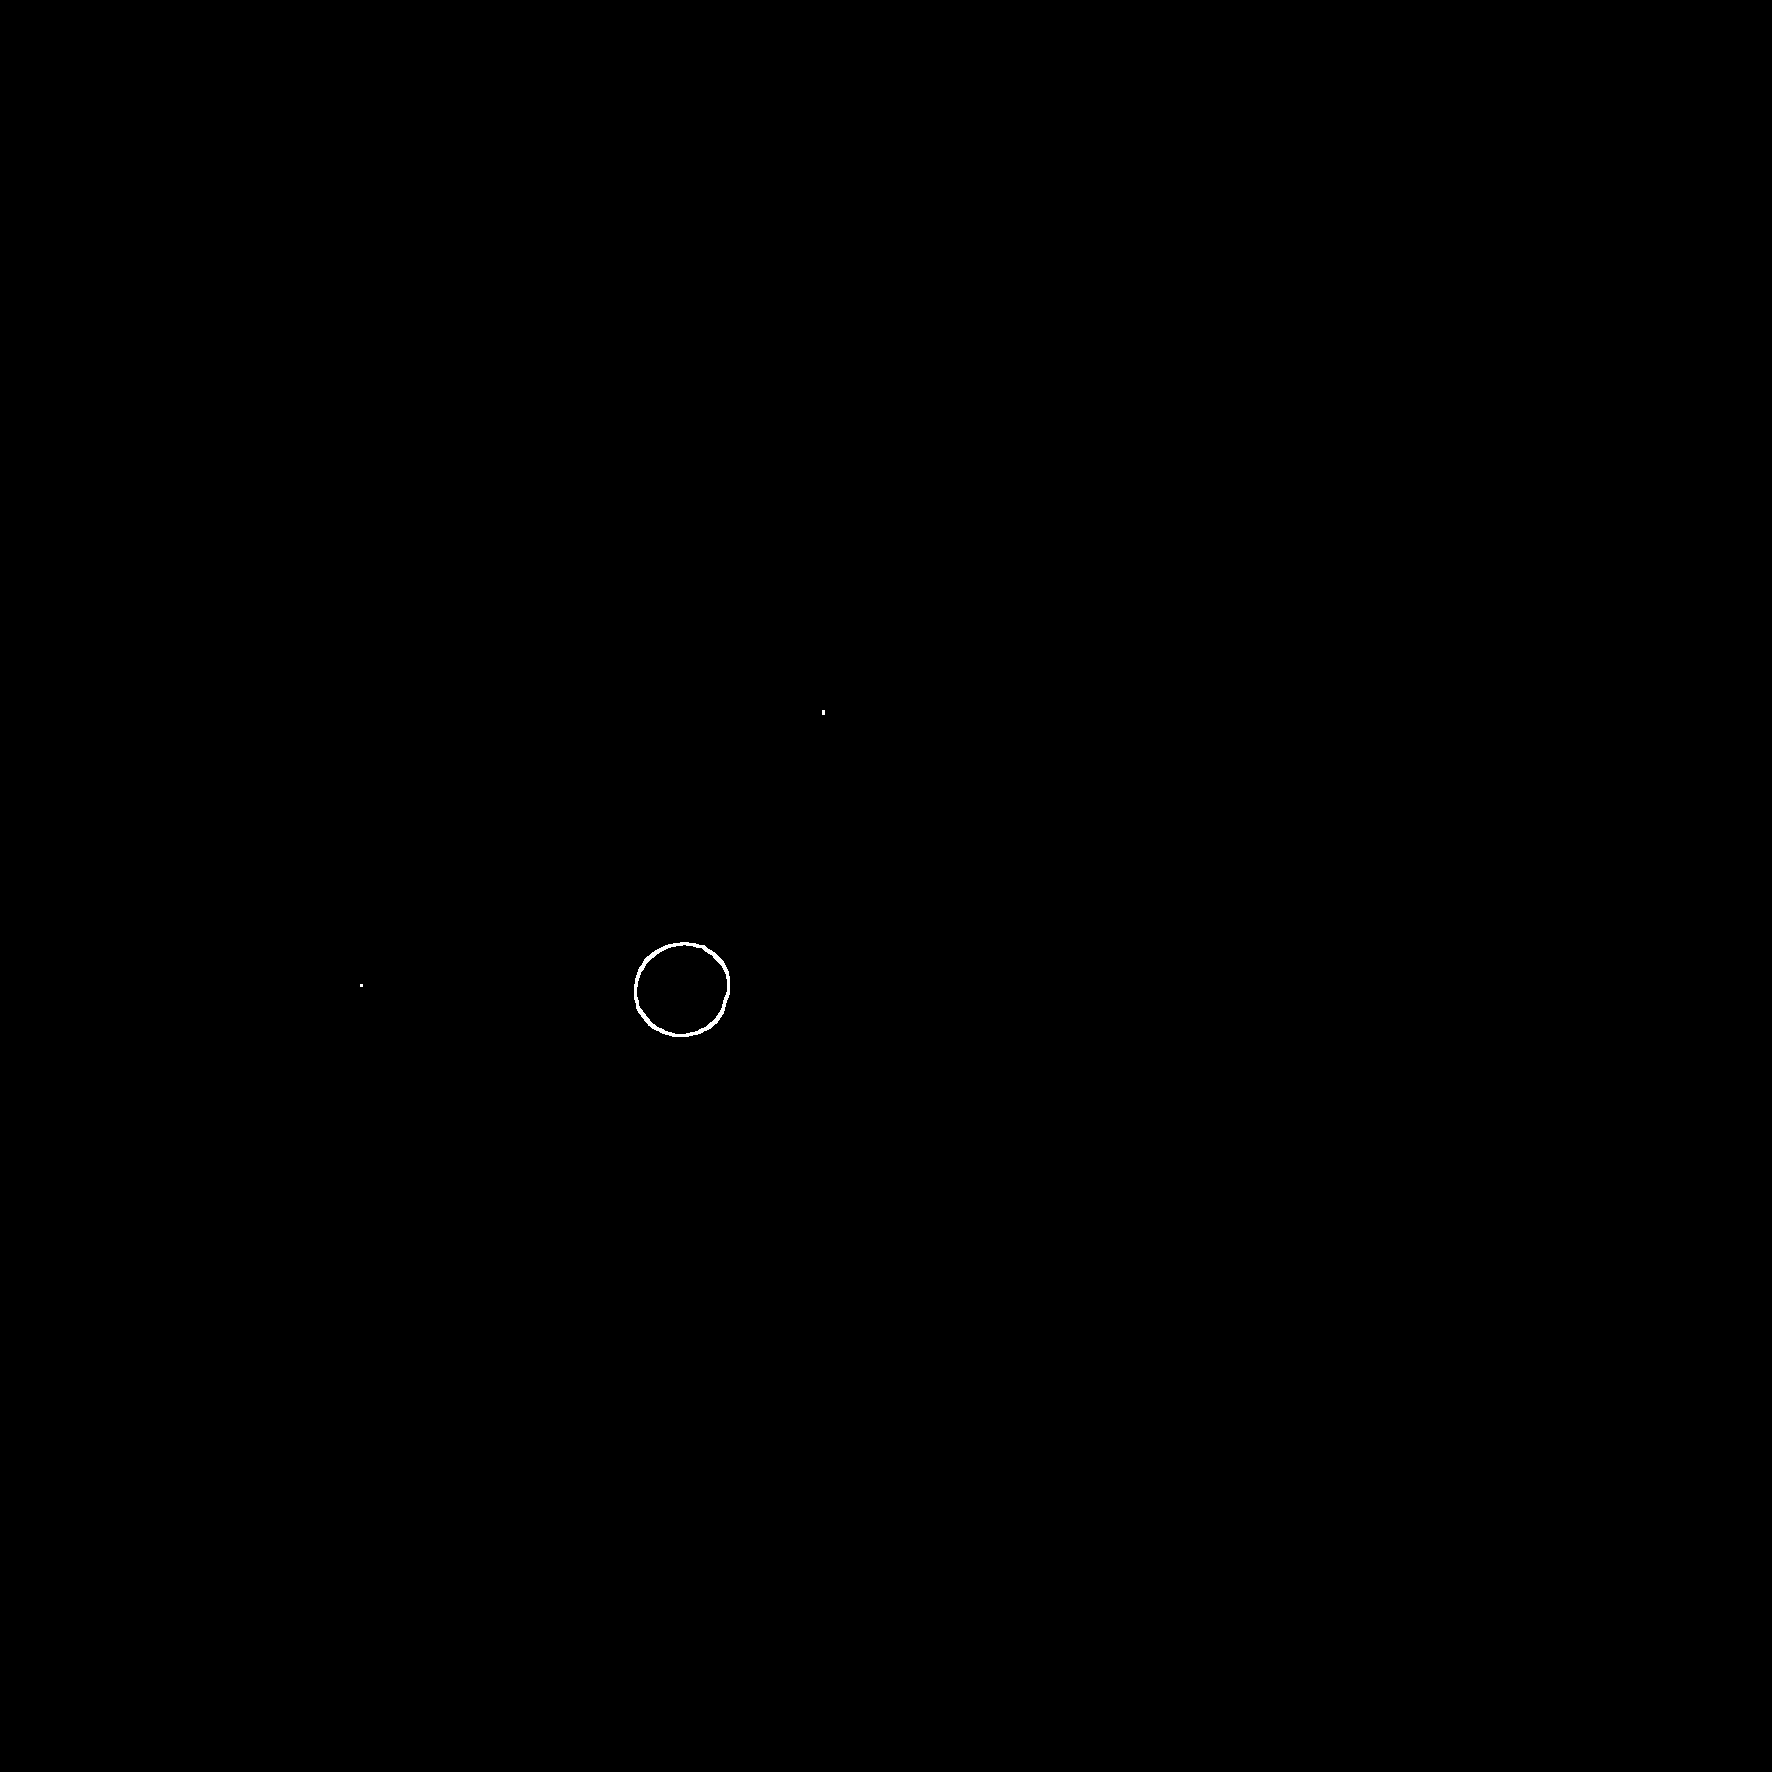

Liczba czarnych kropek: 1


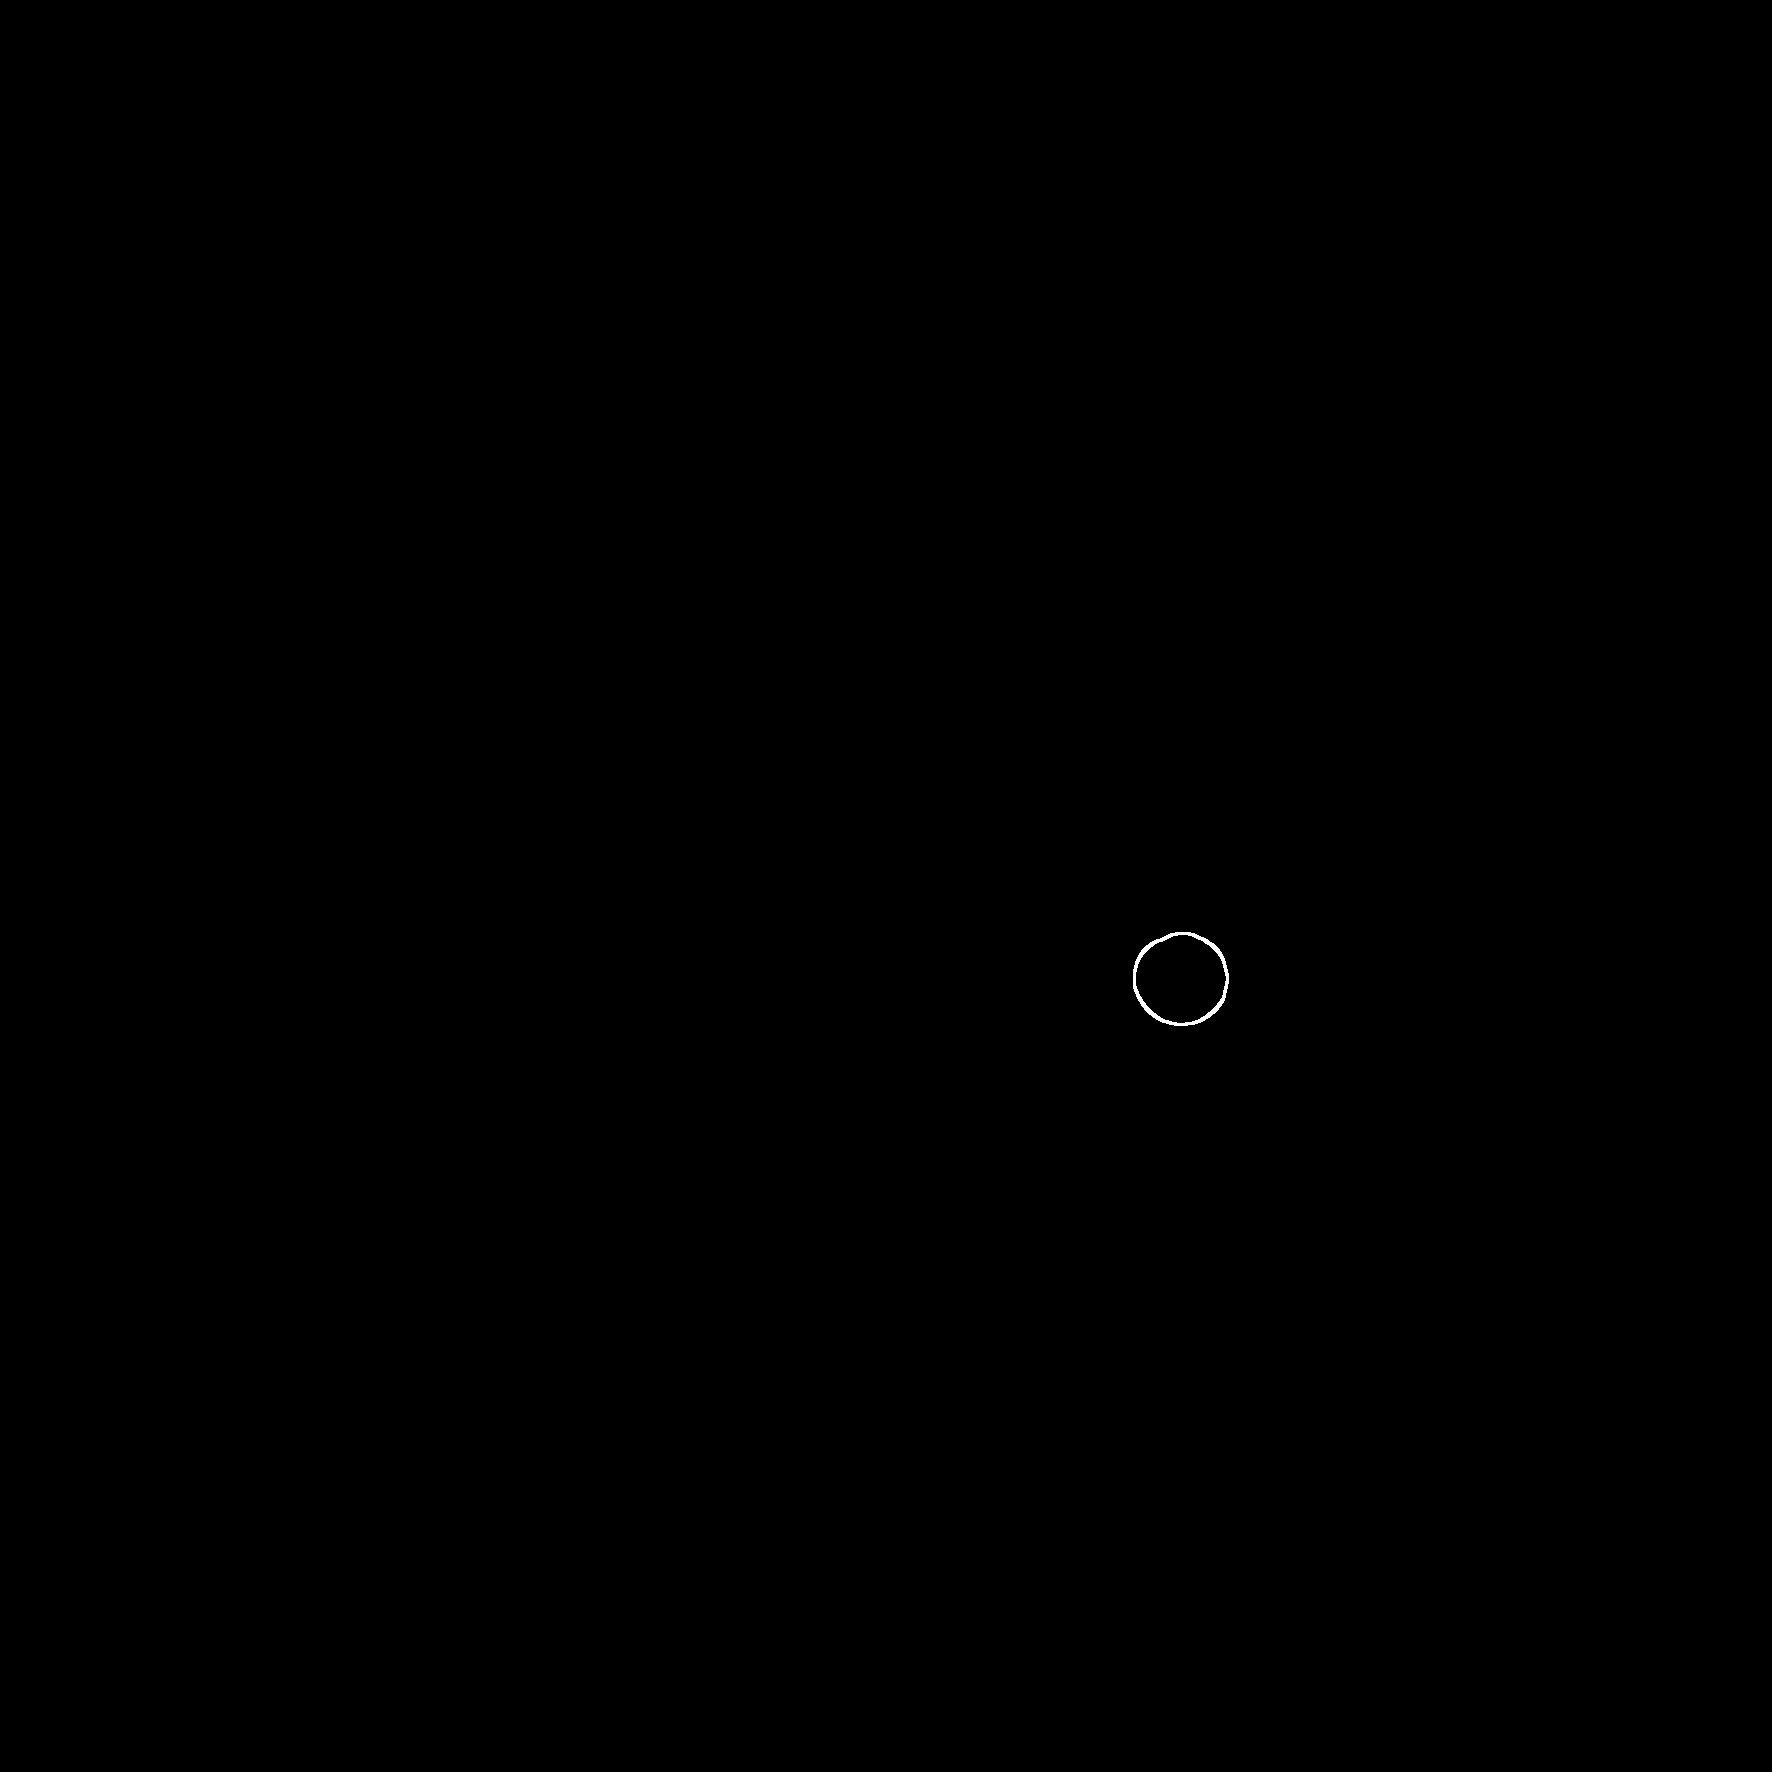

Liczba czarnych kropek: 1


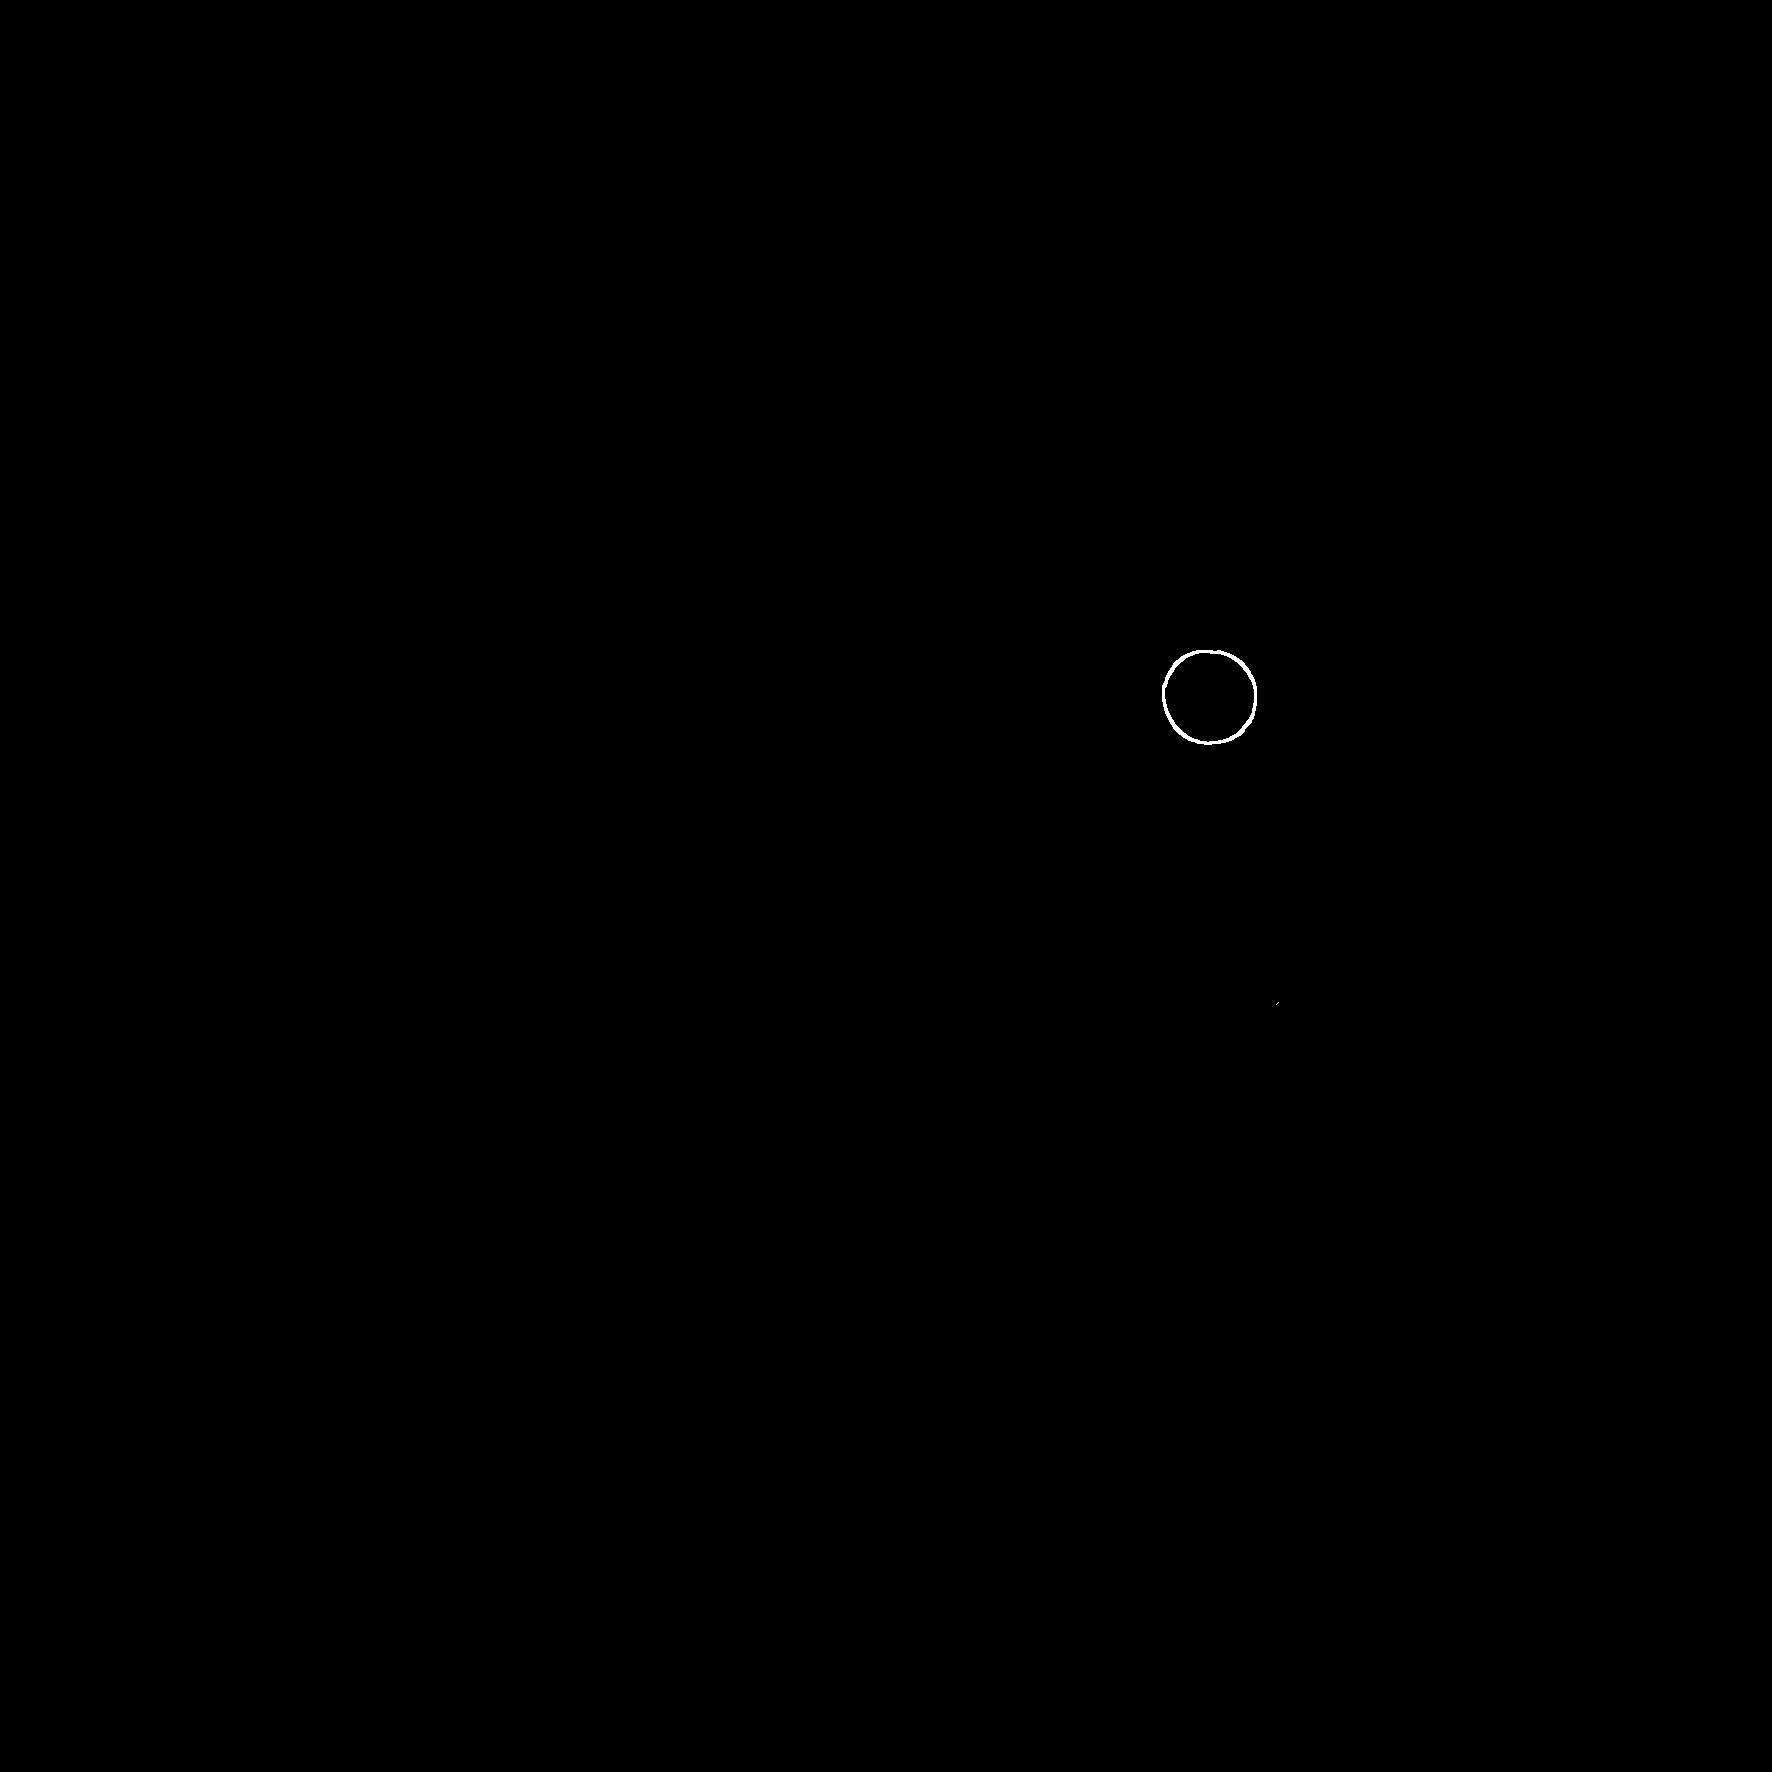

Liczba czarnych kropek: 1


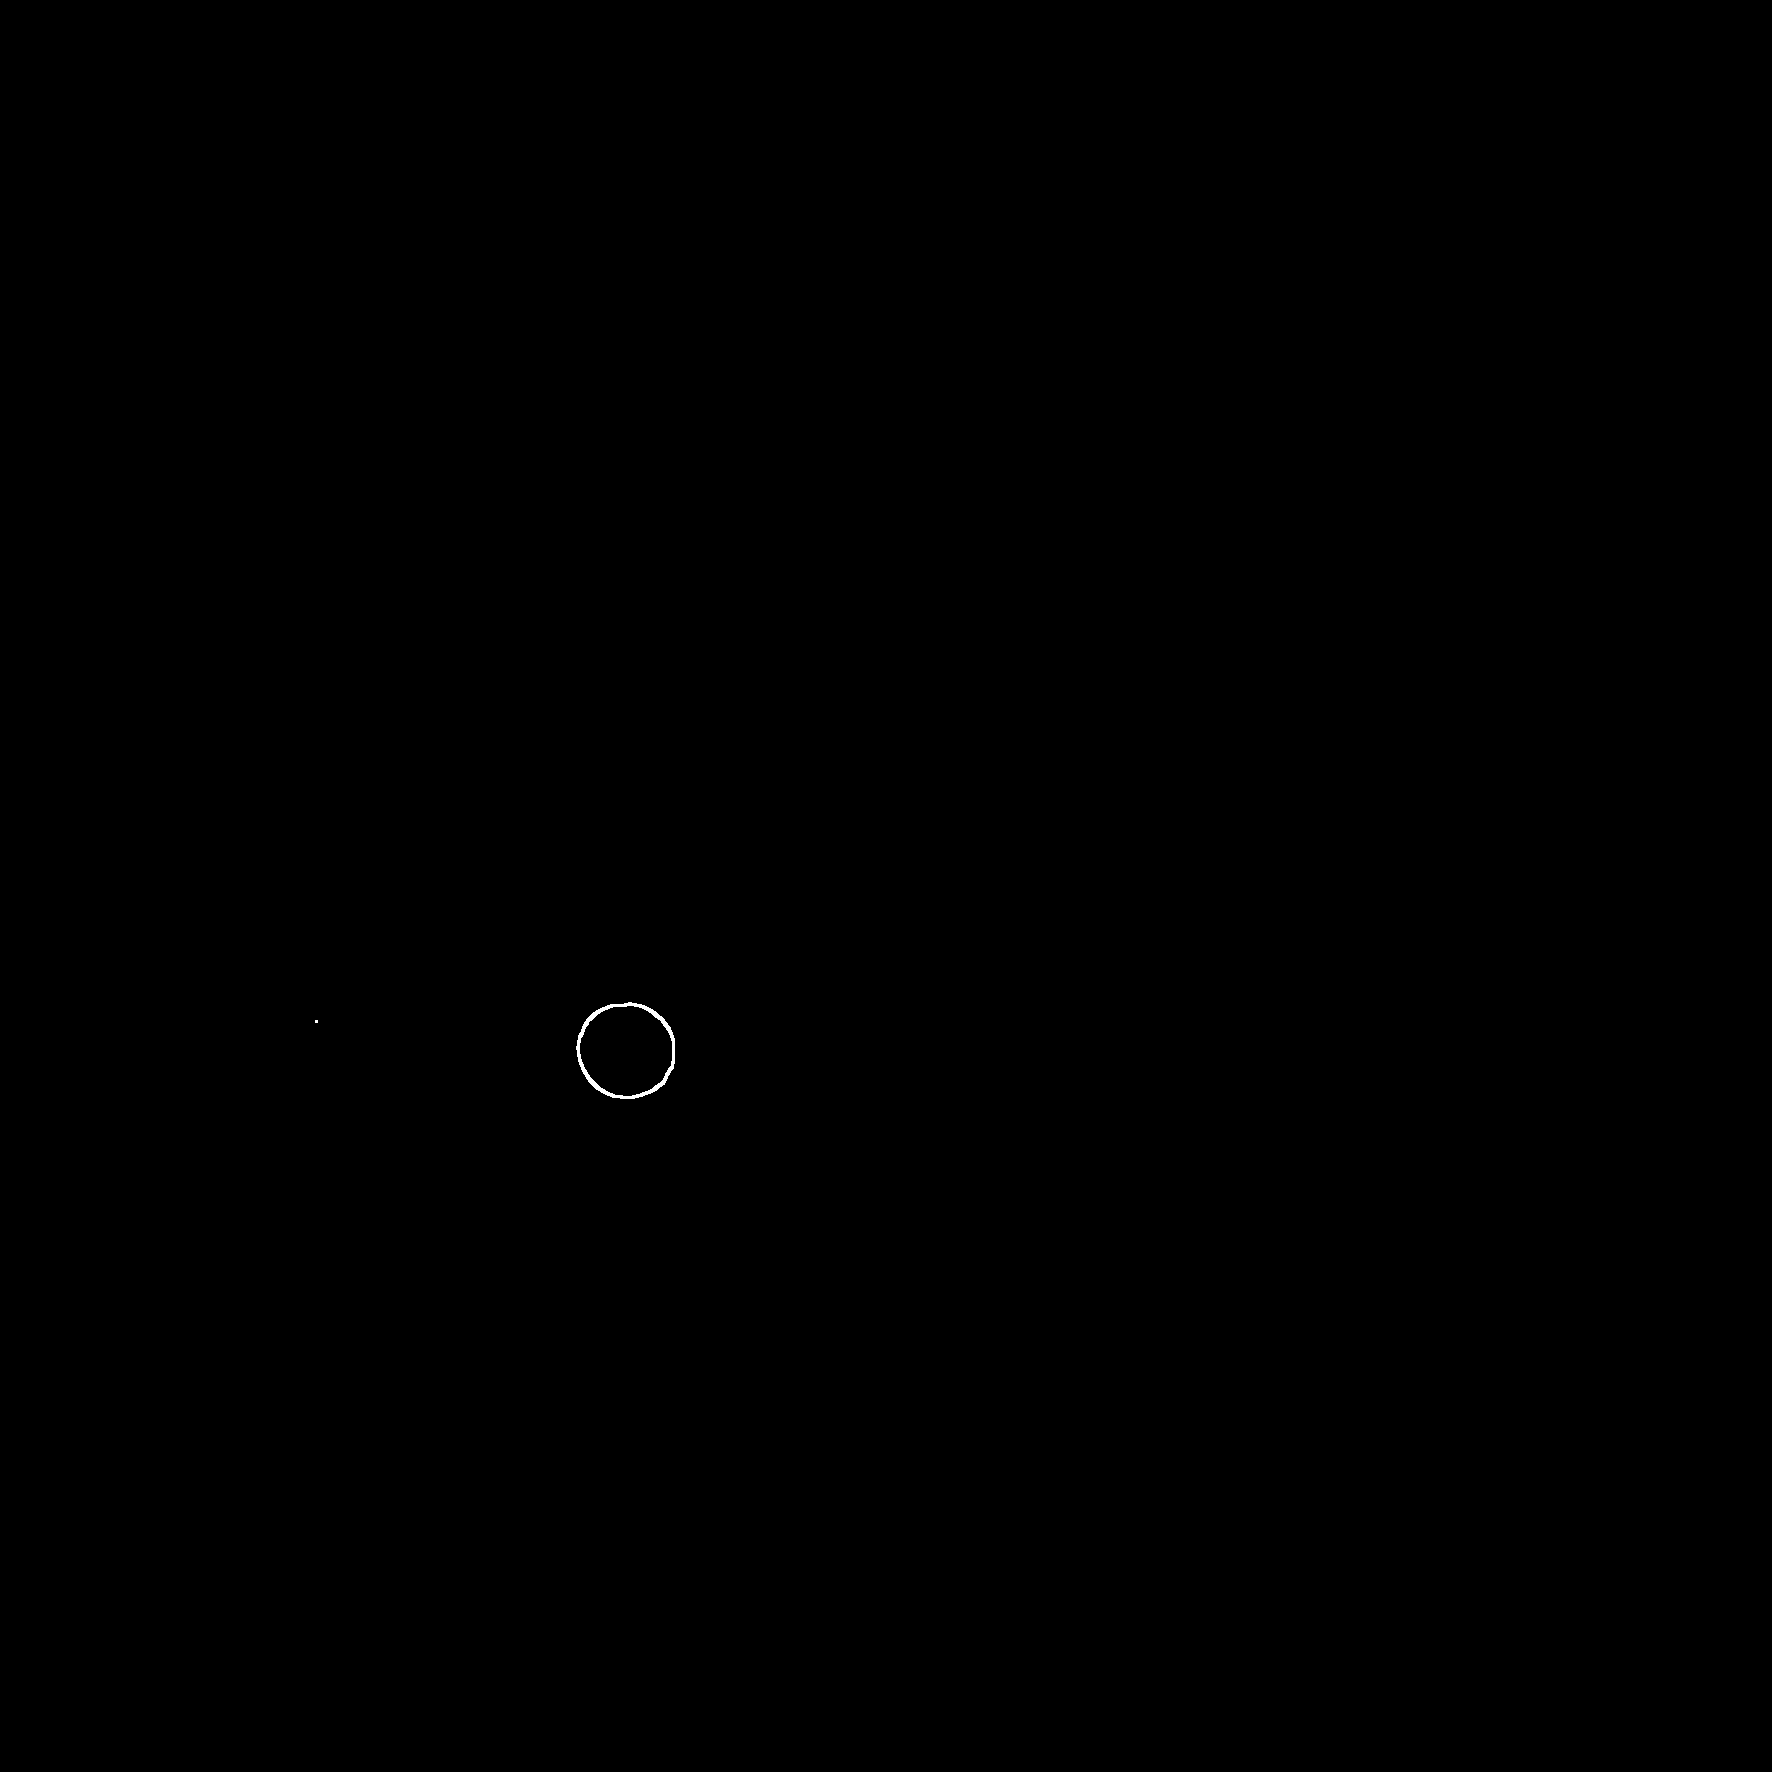

Liczba czarnych kropek: 1


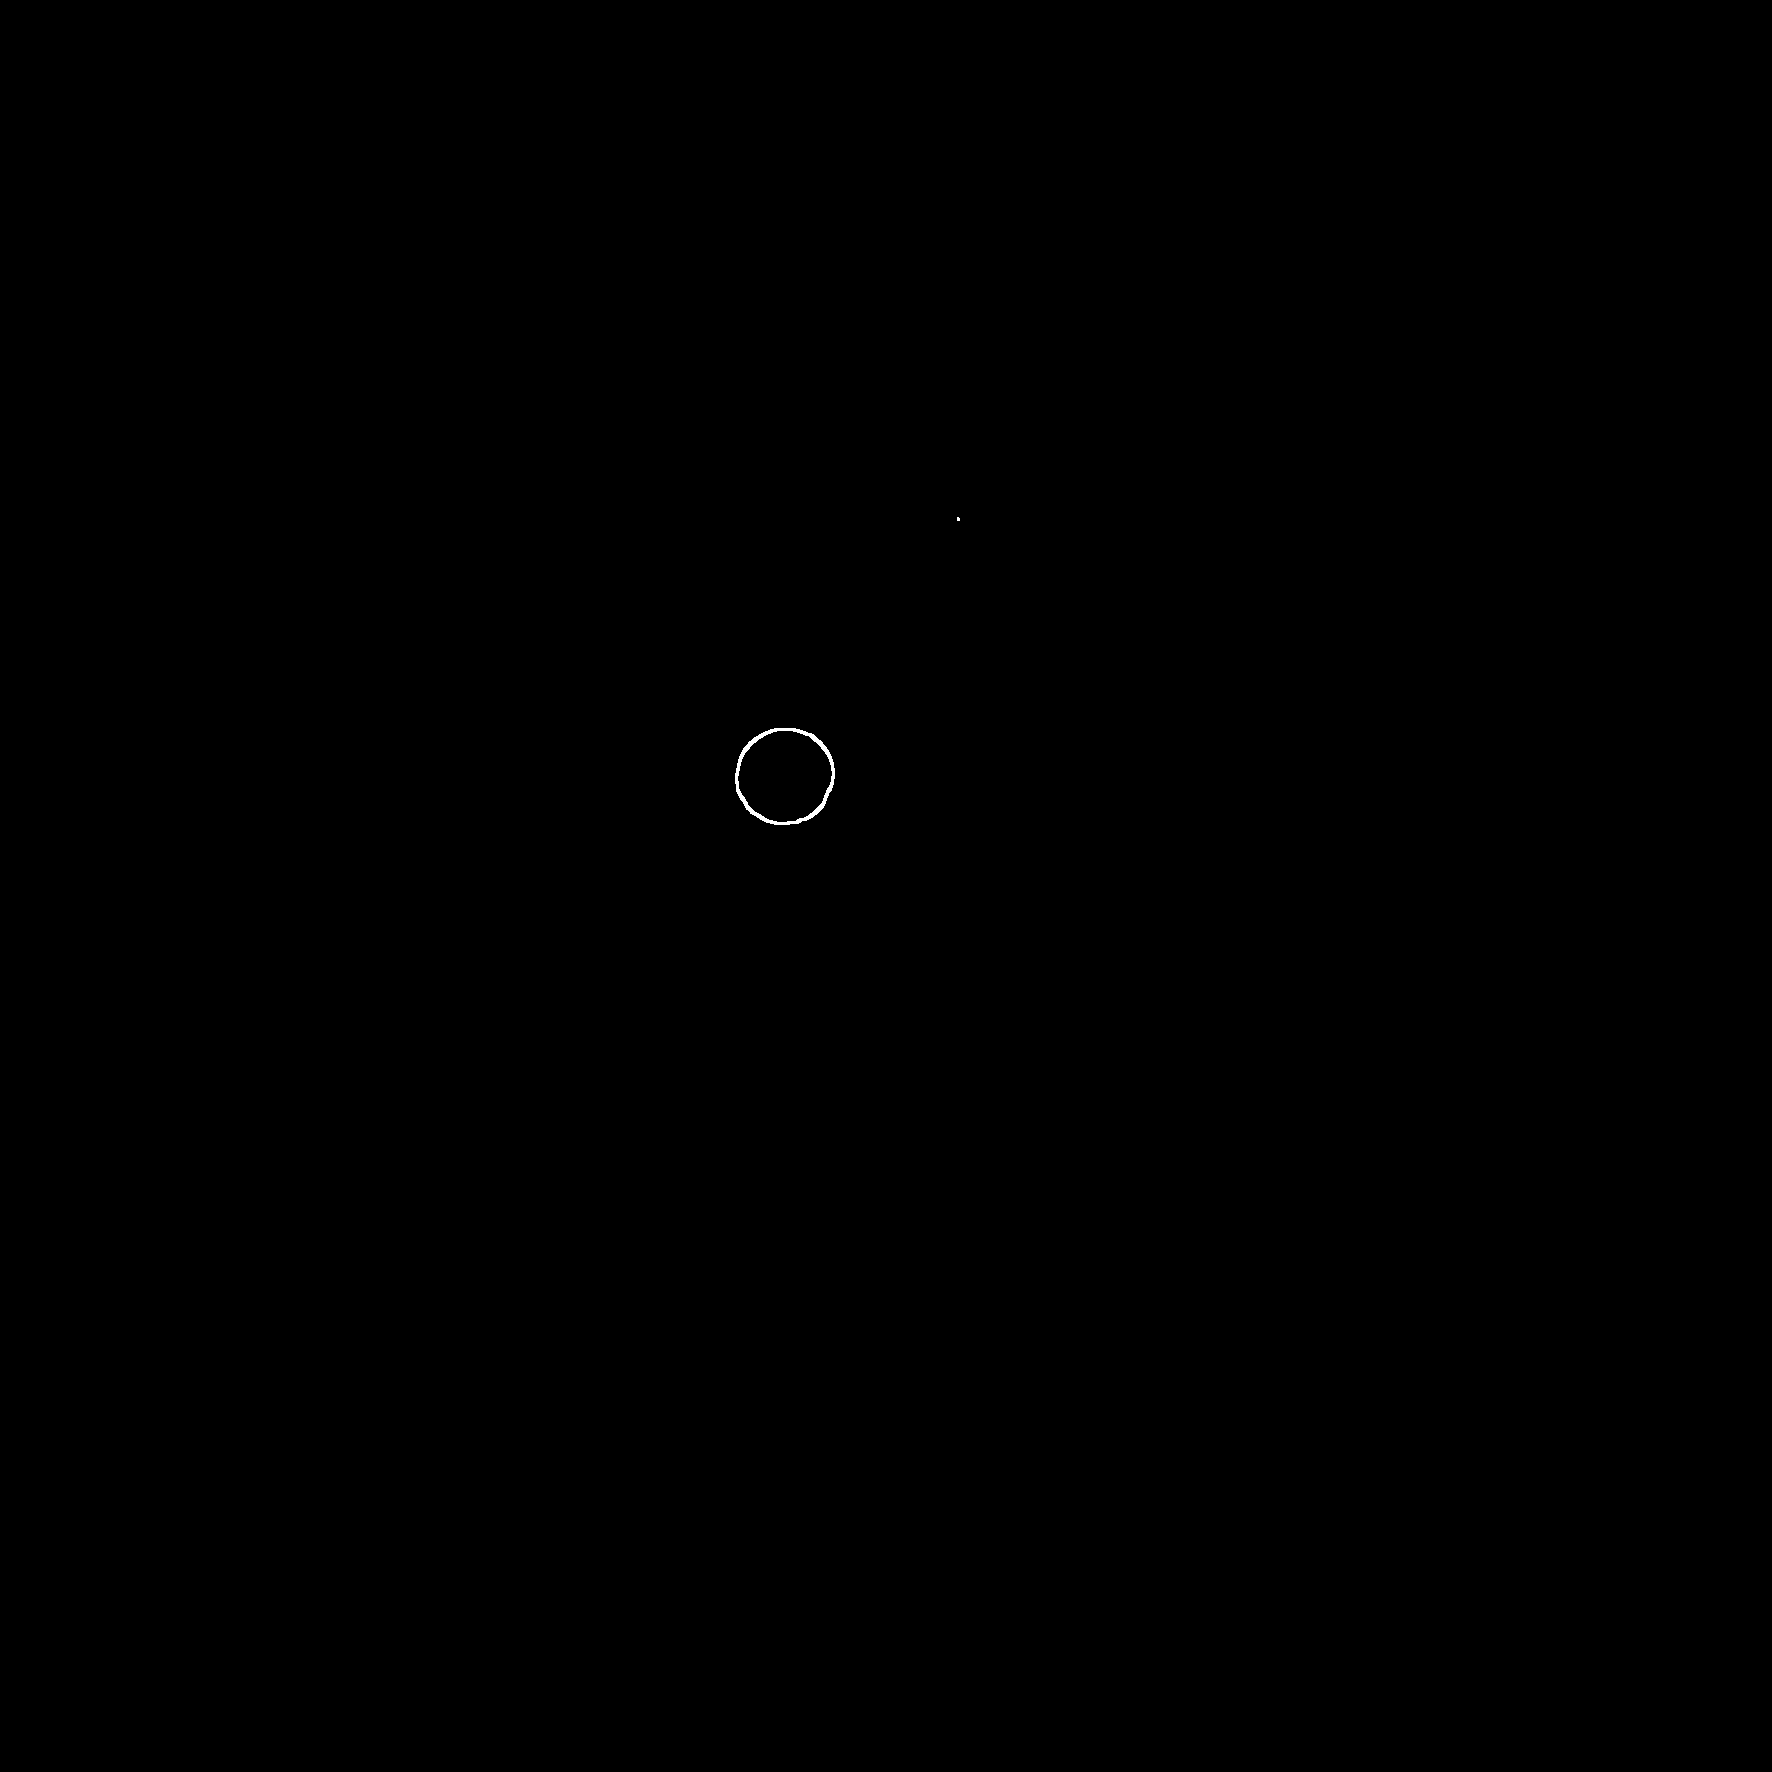

Liczba czarnych kropek: 1


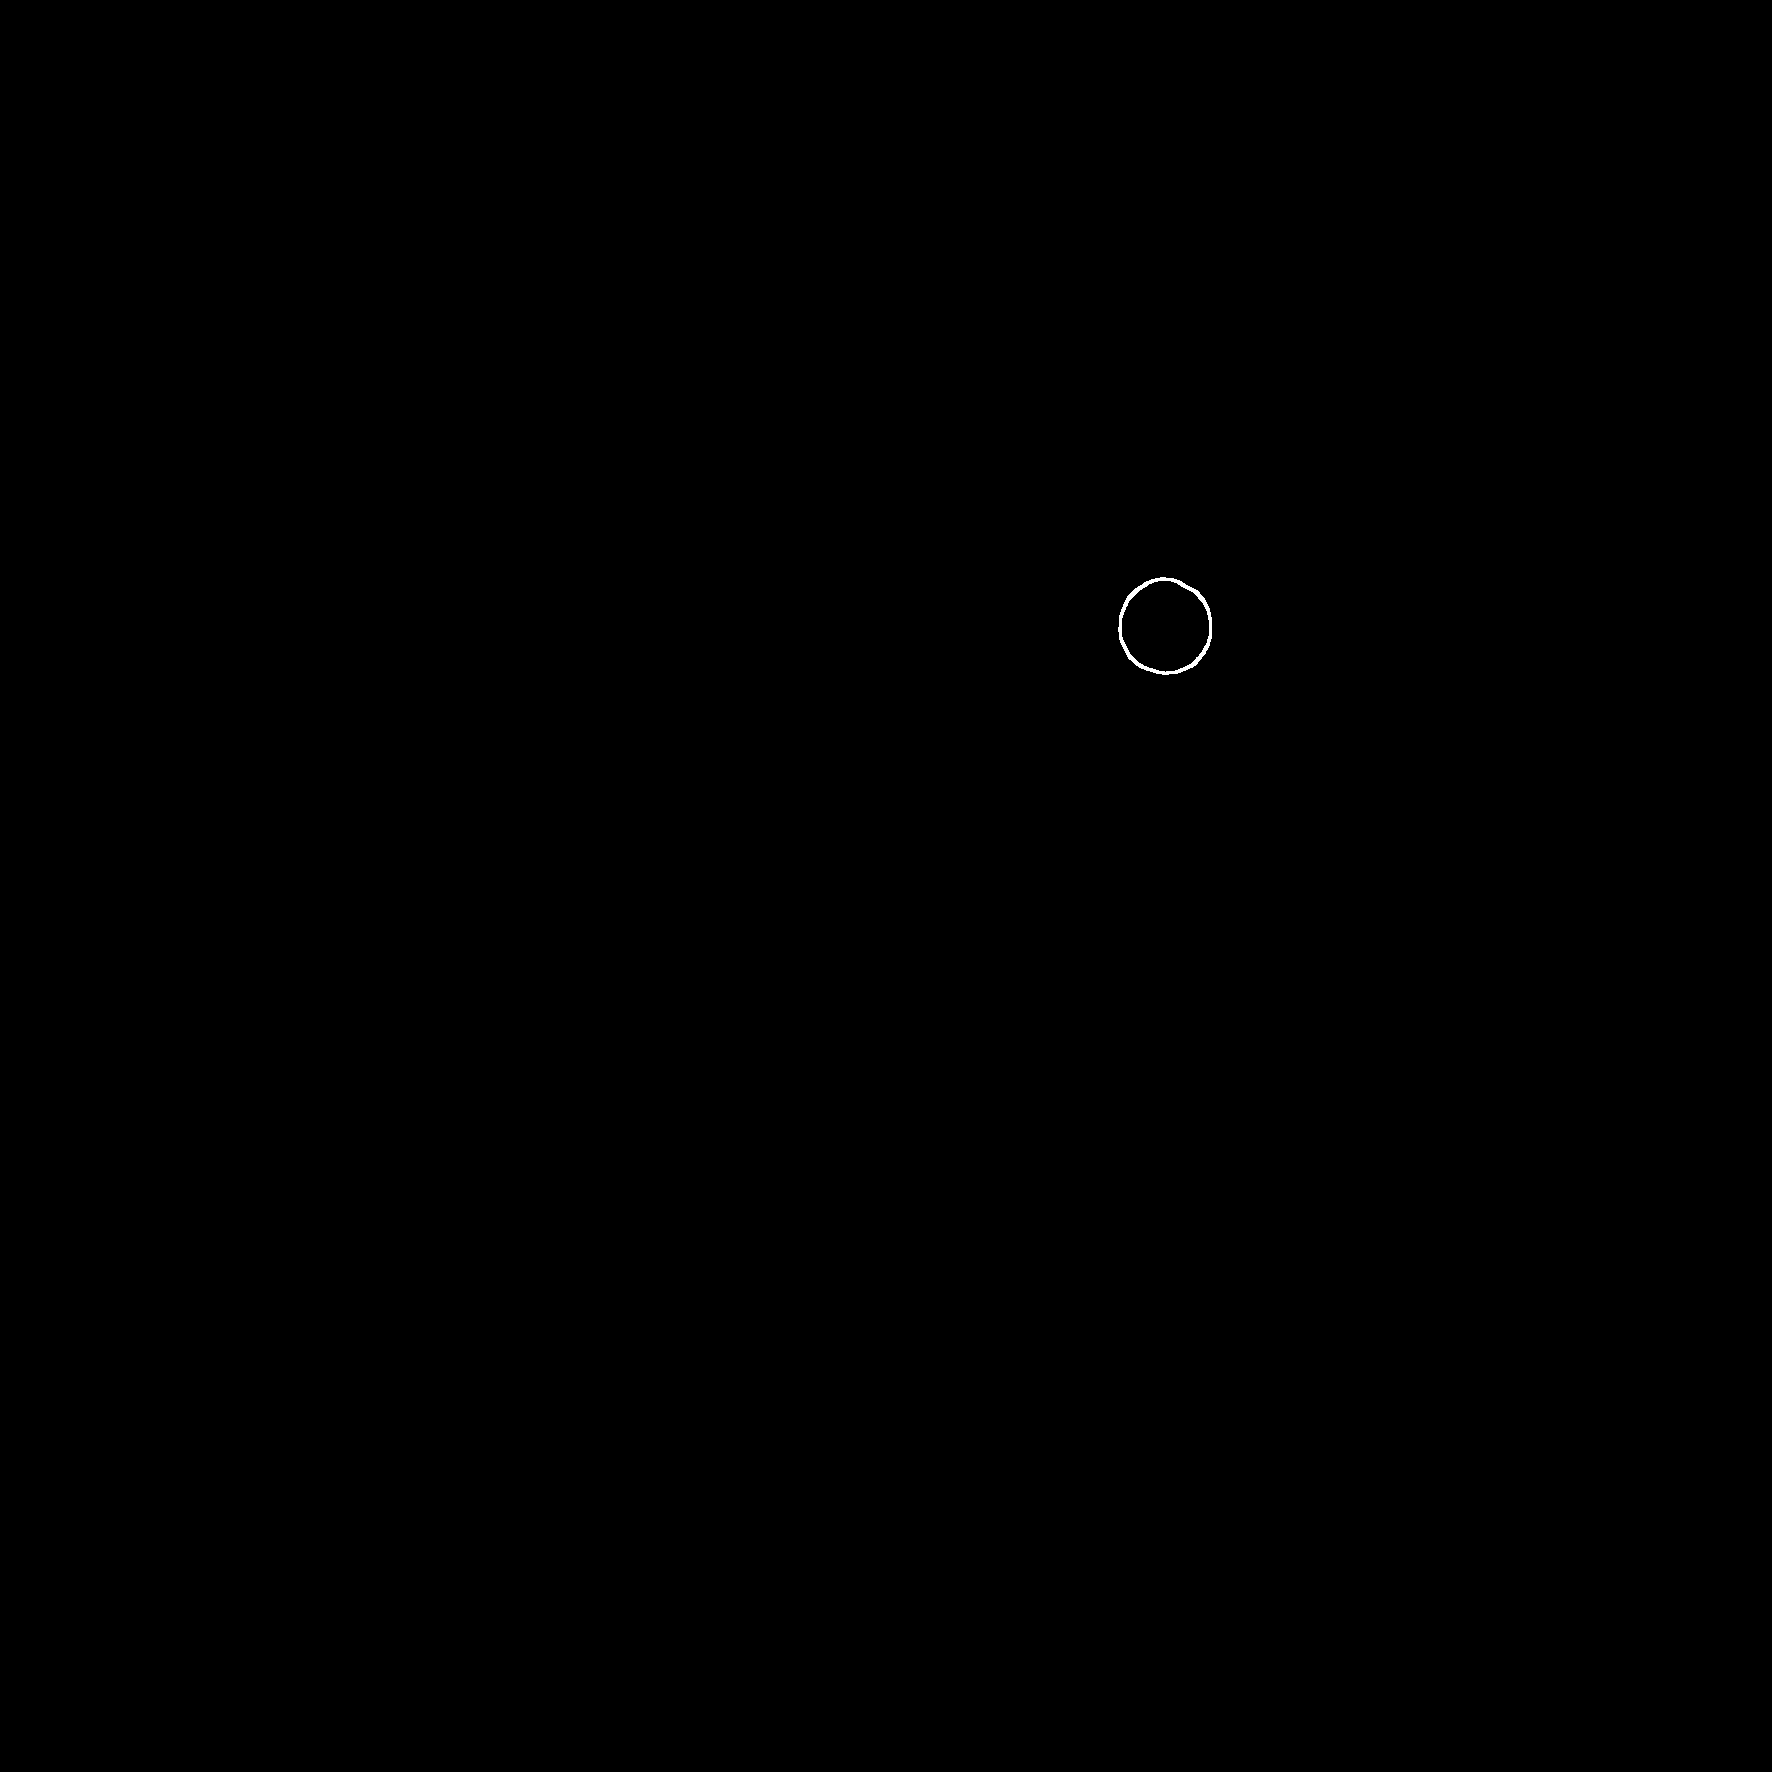

Liczba czarnych kropek: 1


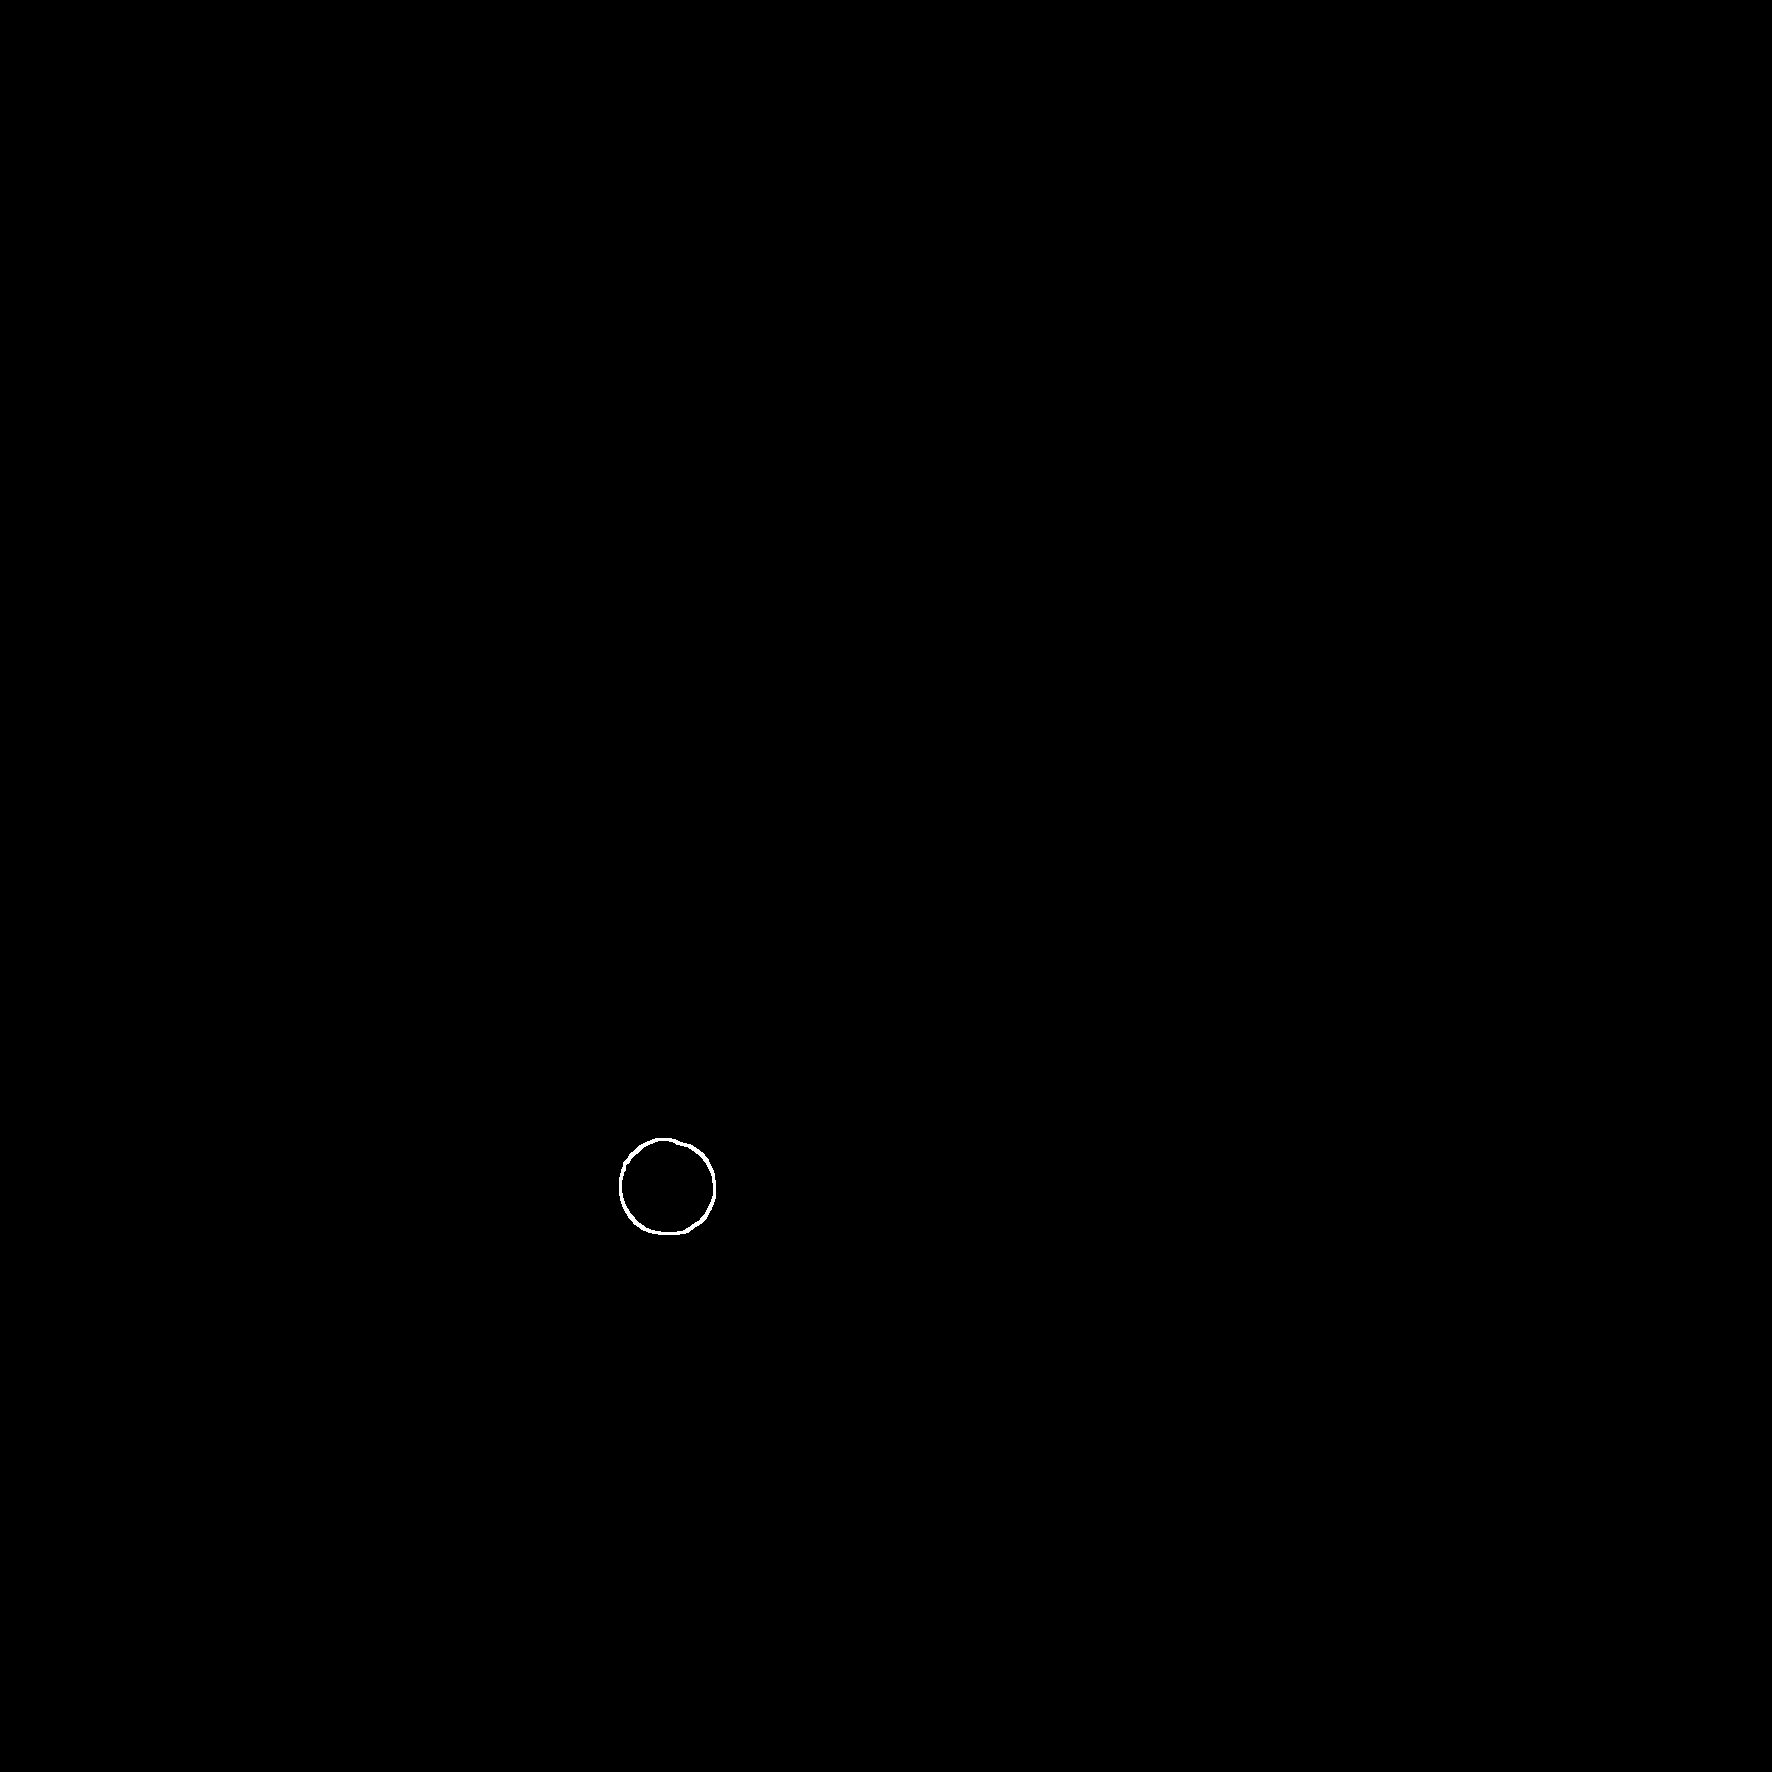

Liczba czarnych kropek: 1


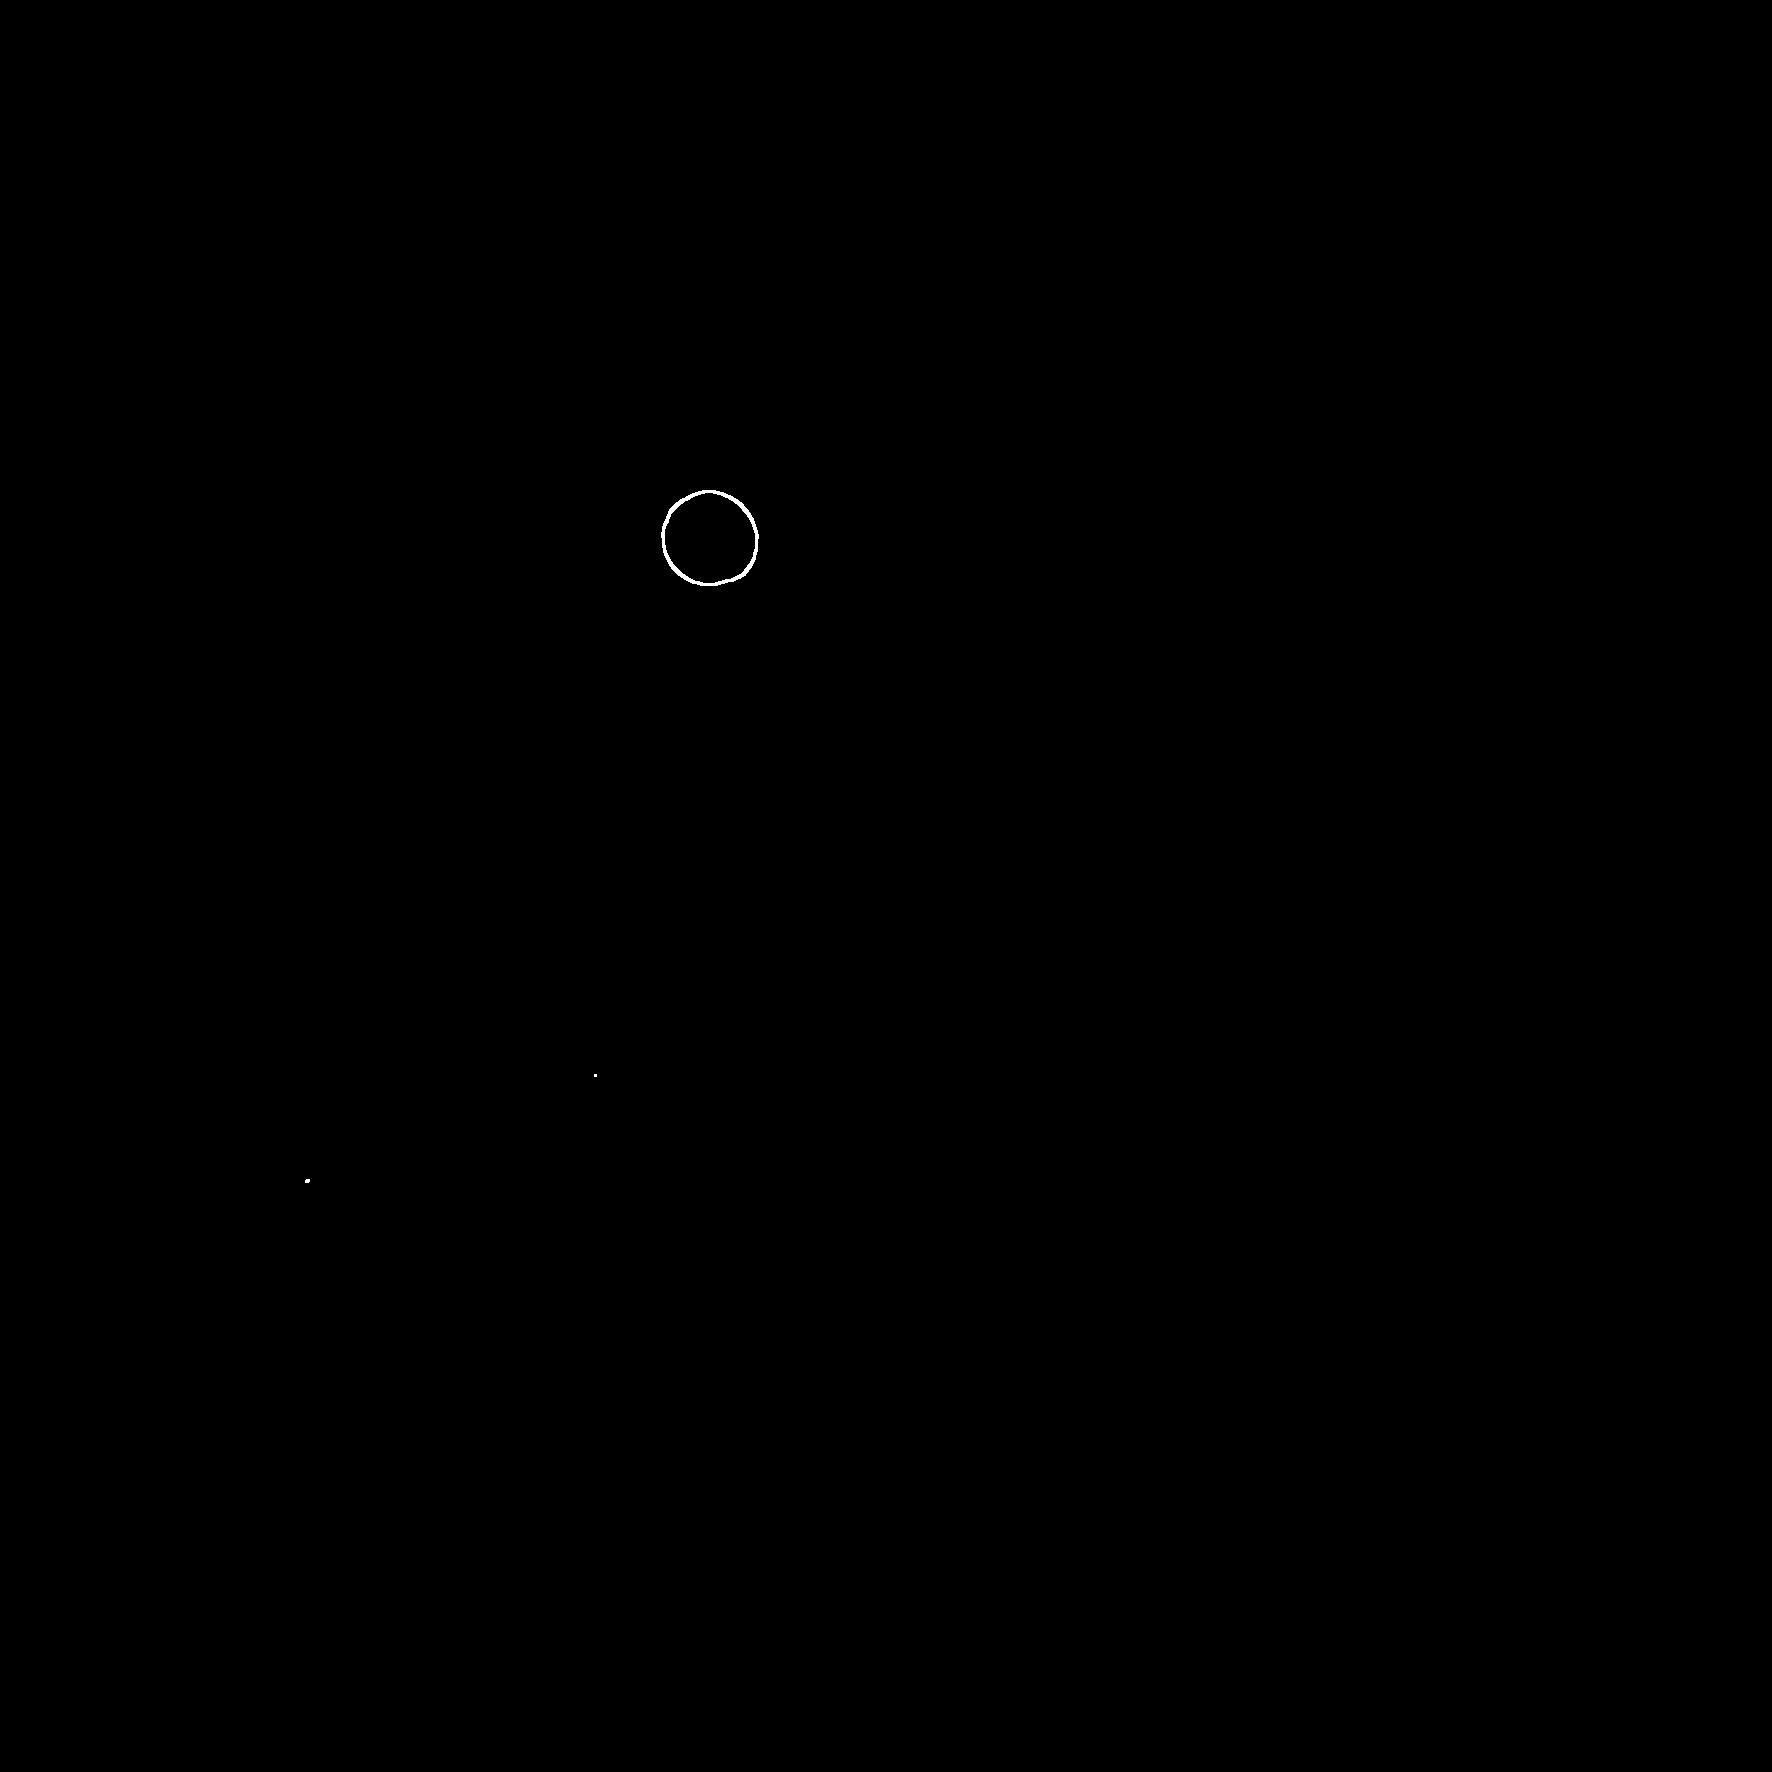

Liczba czarnych kropek: 1


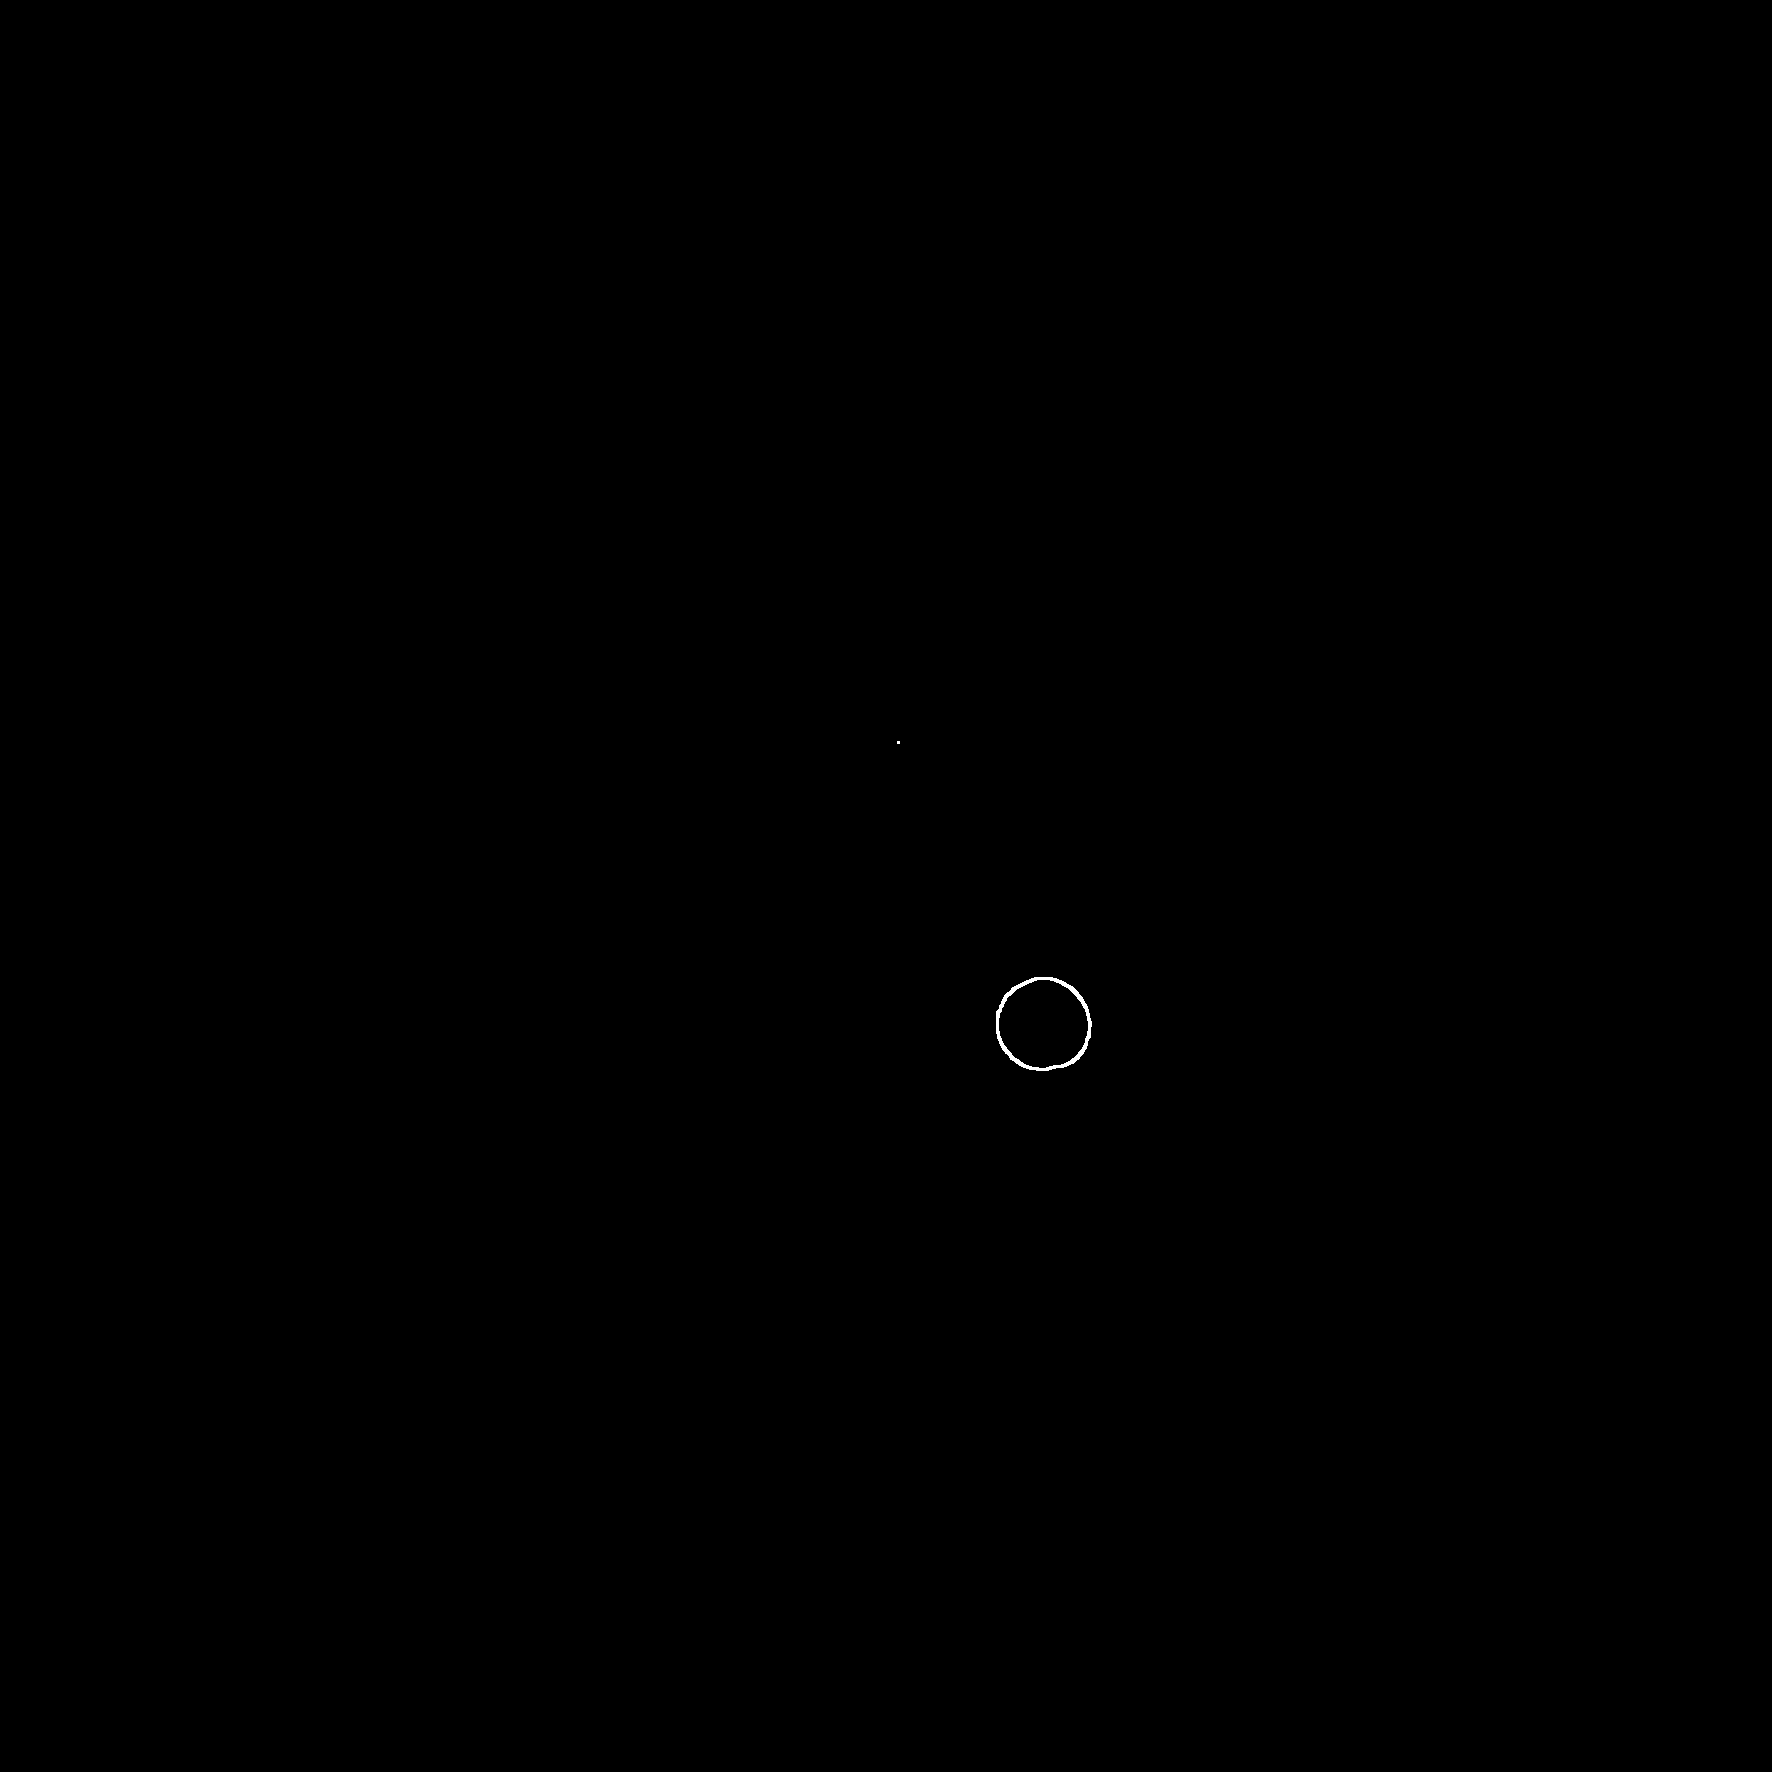

Liczba czarnych kropek: 1


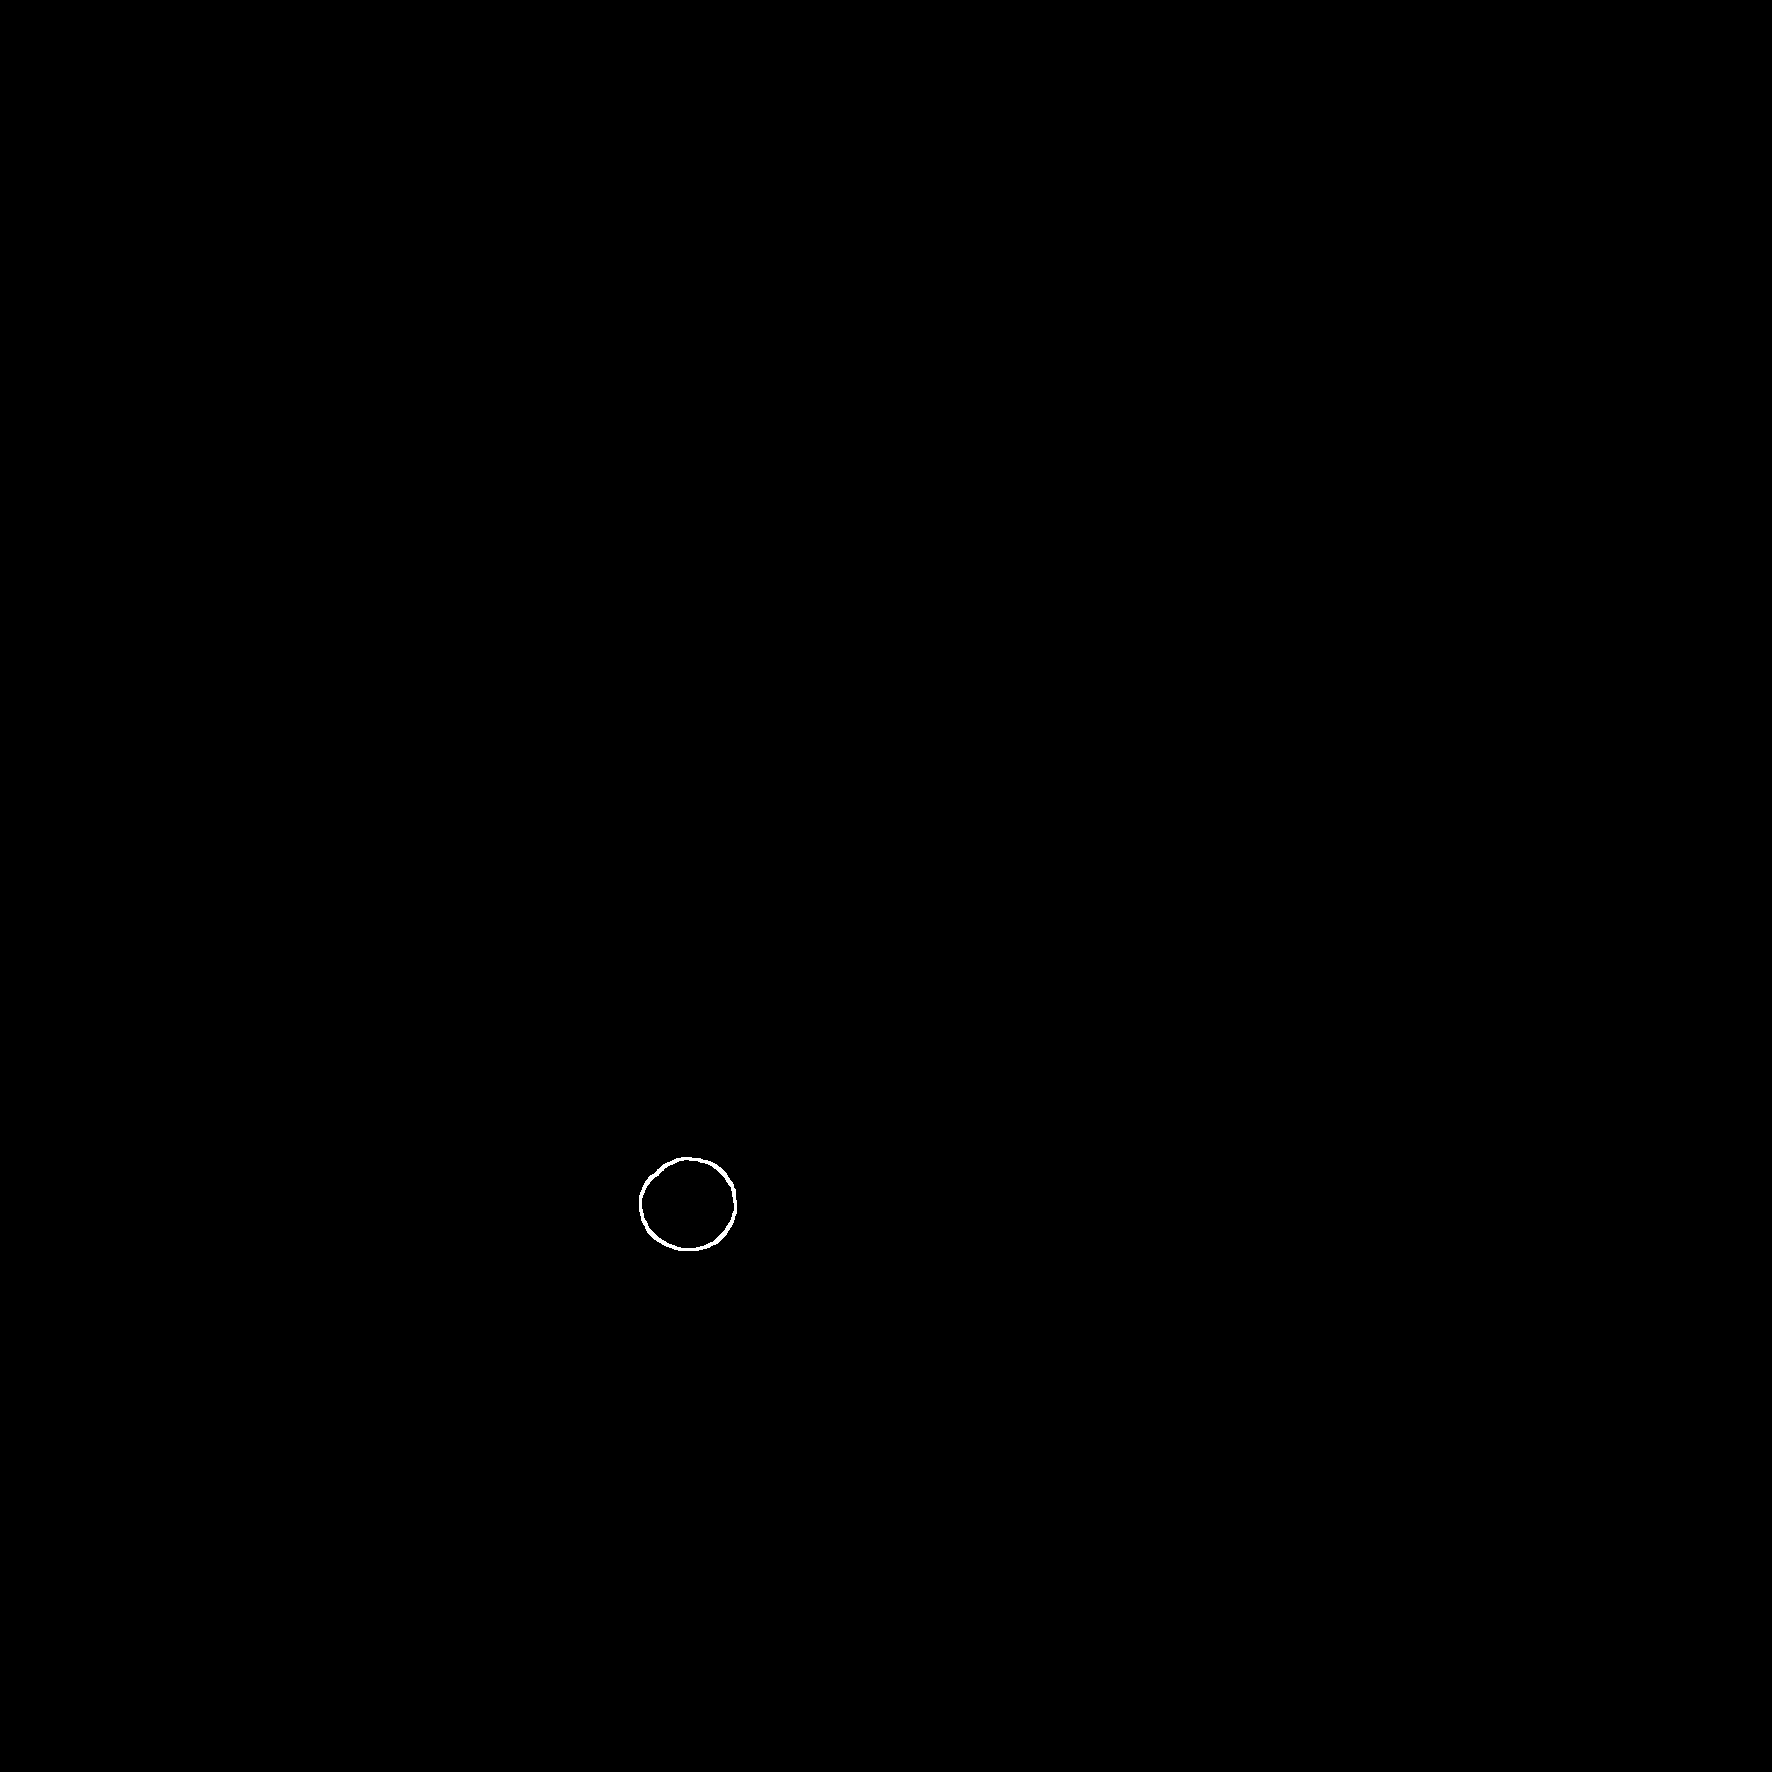

Liczba czarnych kropek: 1


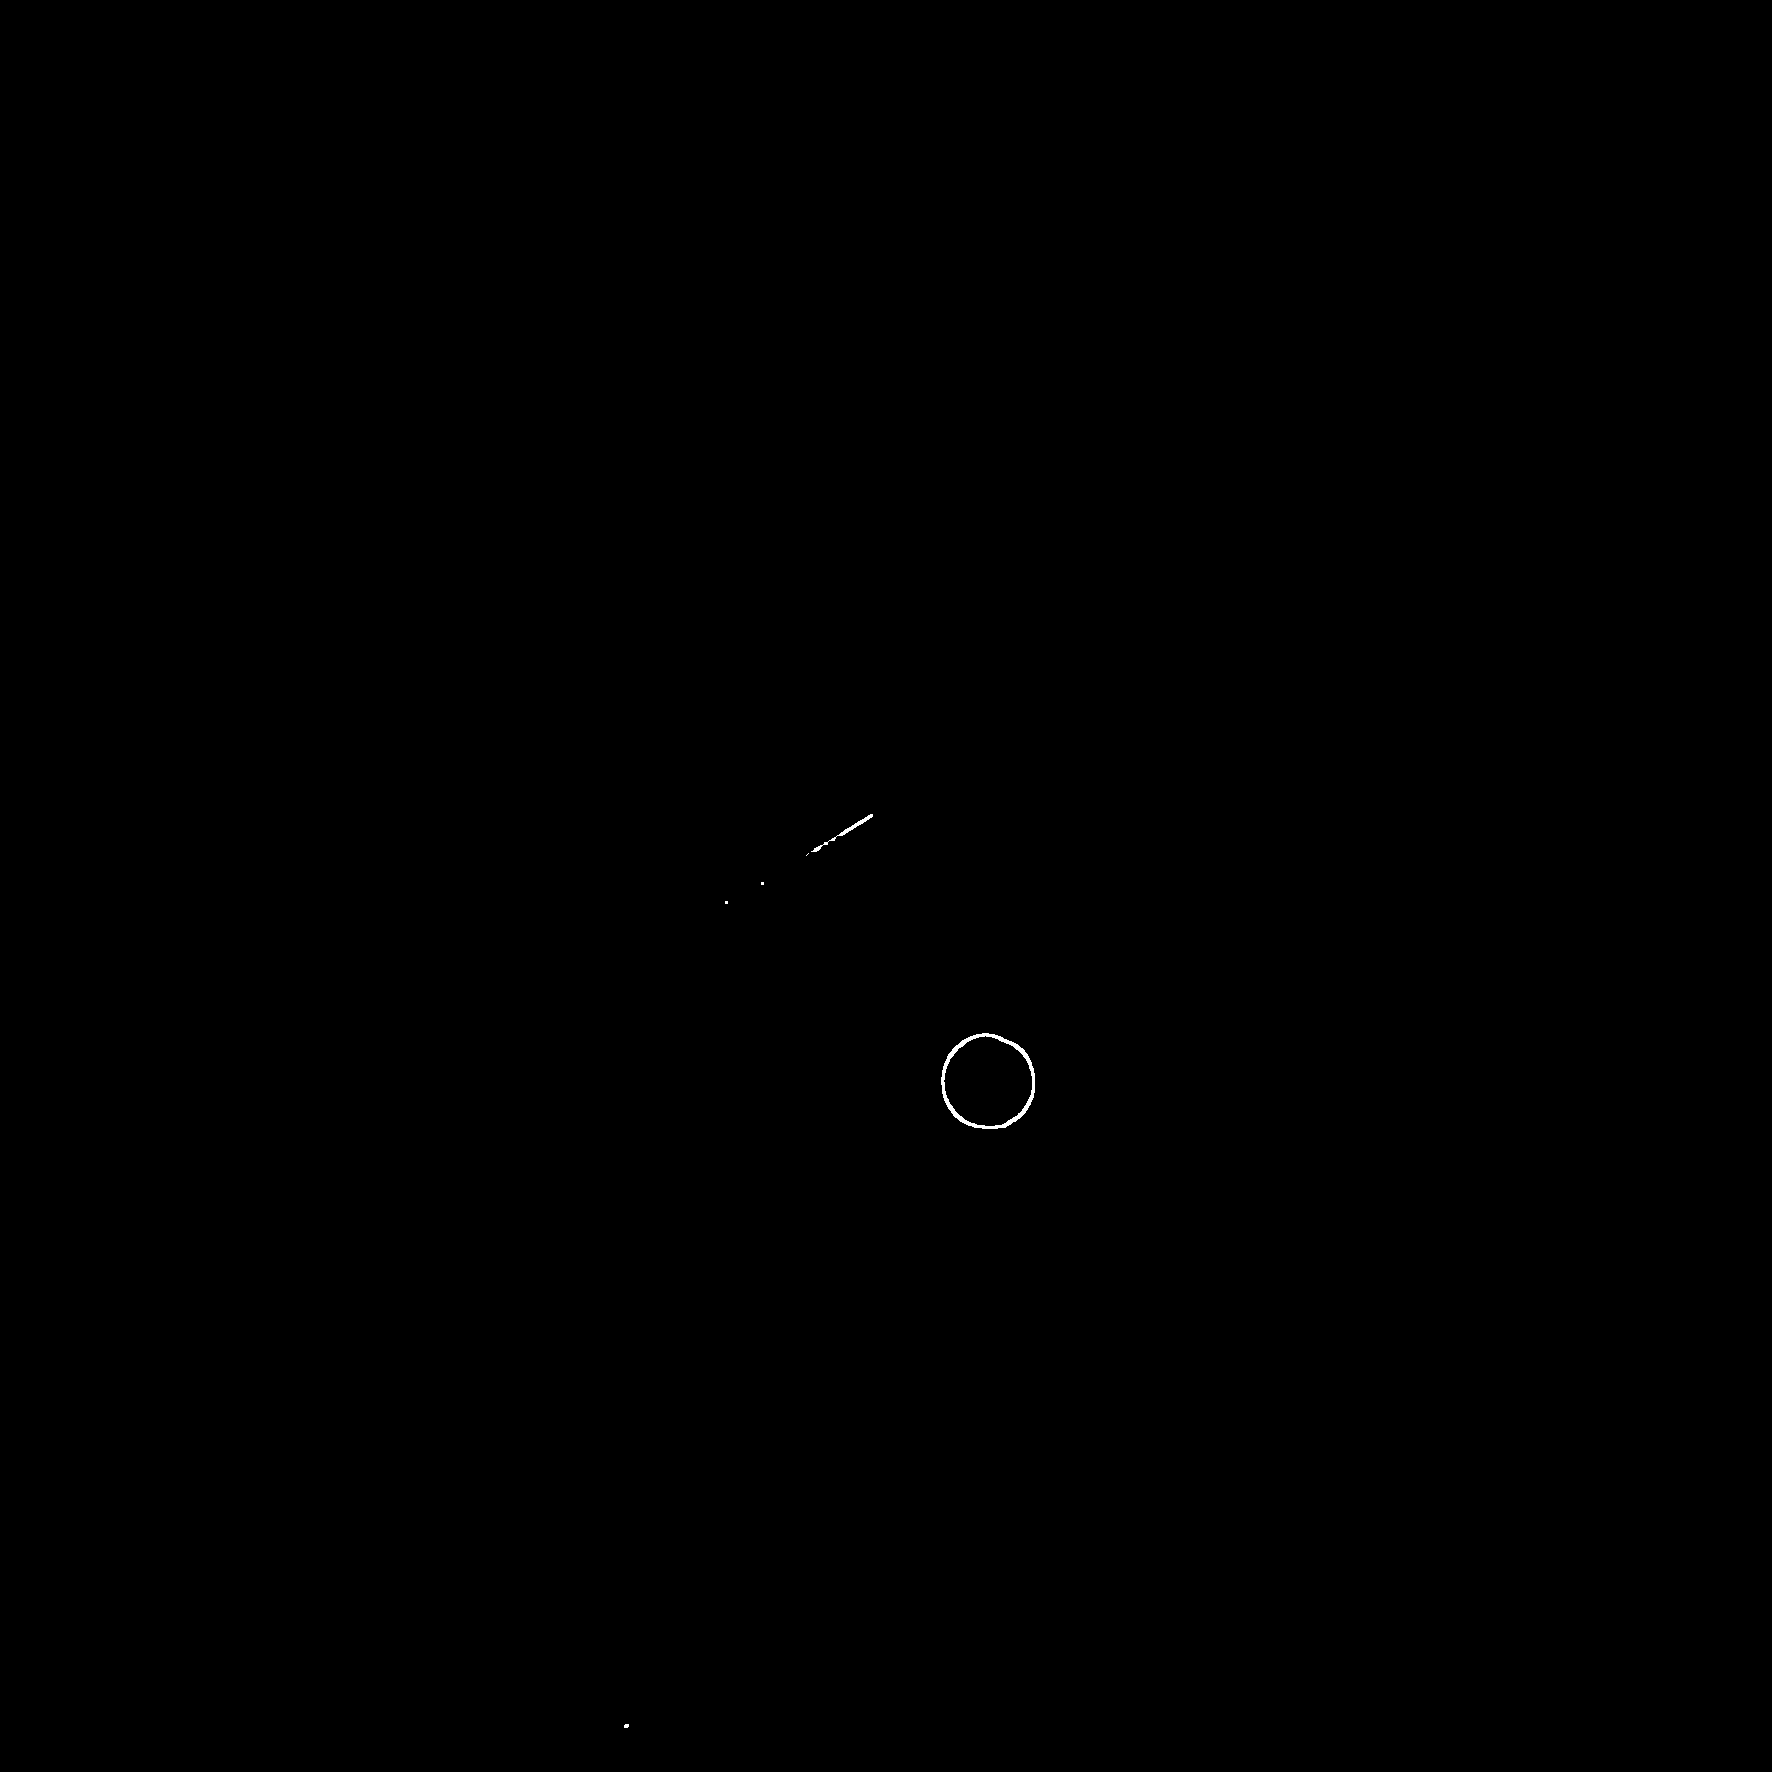

Liczba czarnych kropek: 1


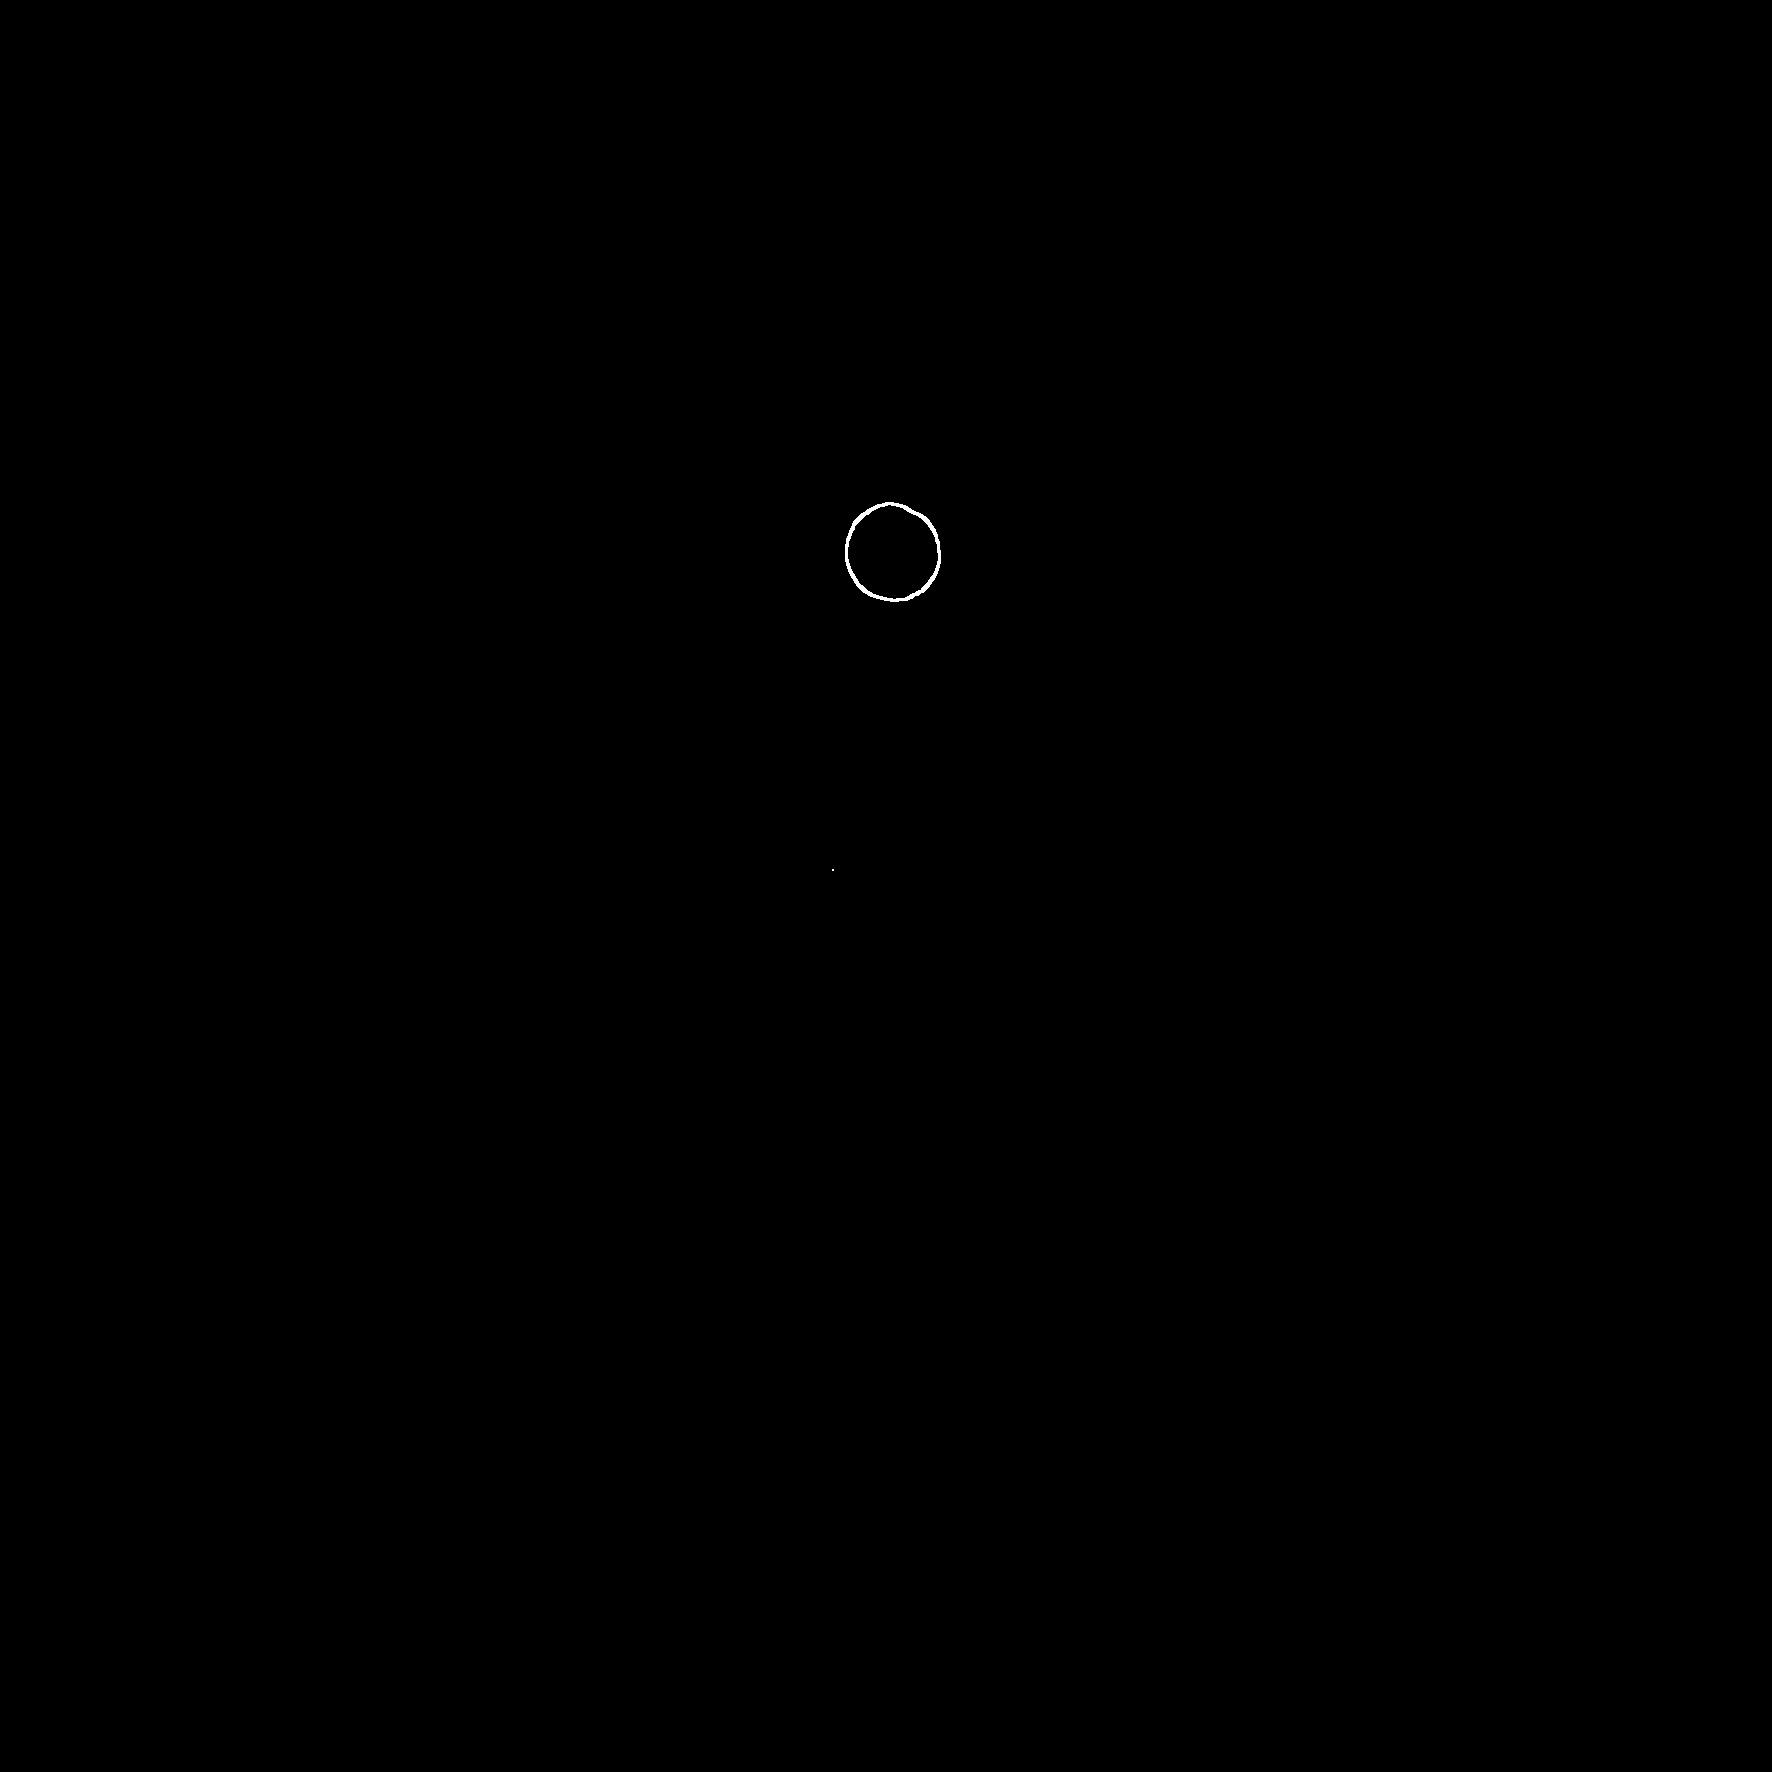

Liczba czarnych kropek: 1


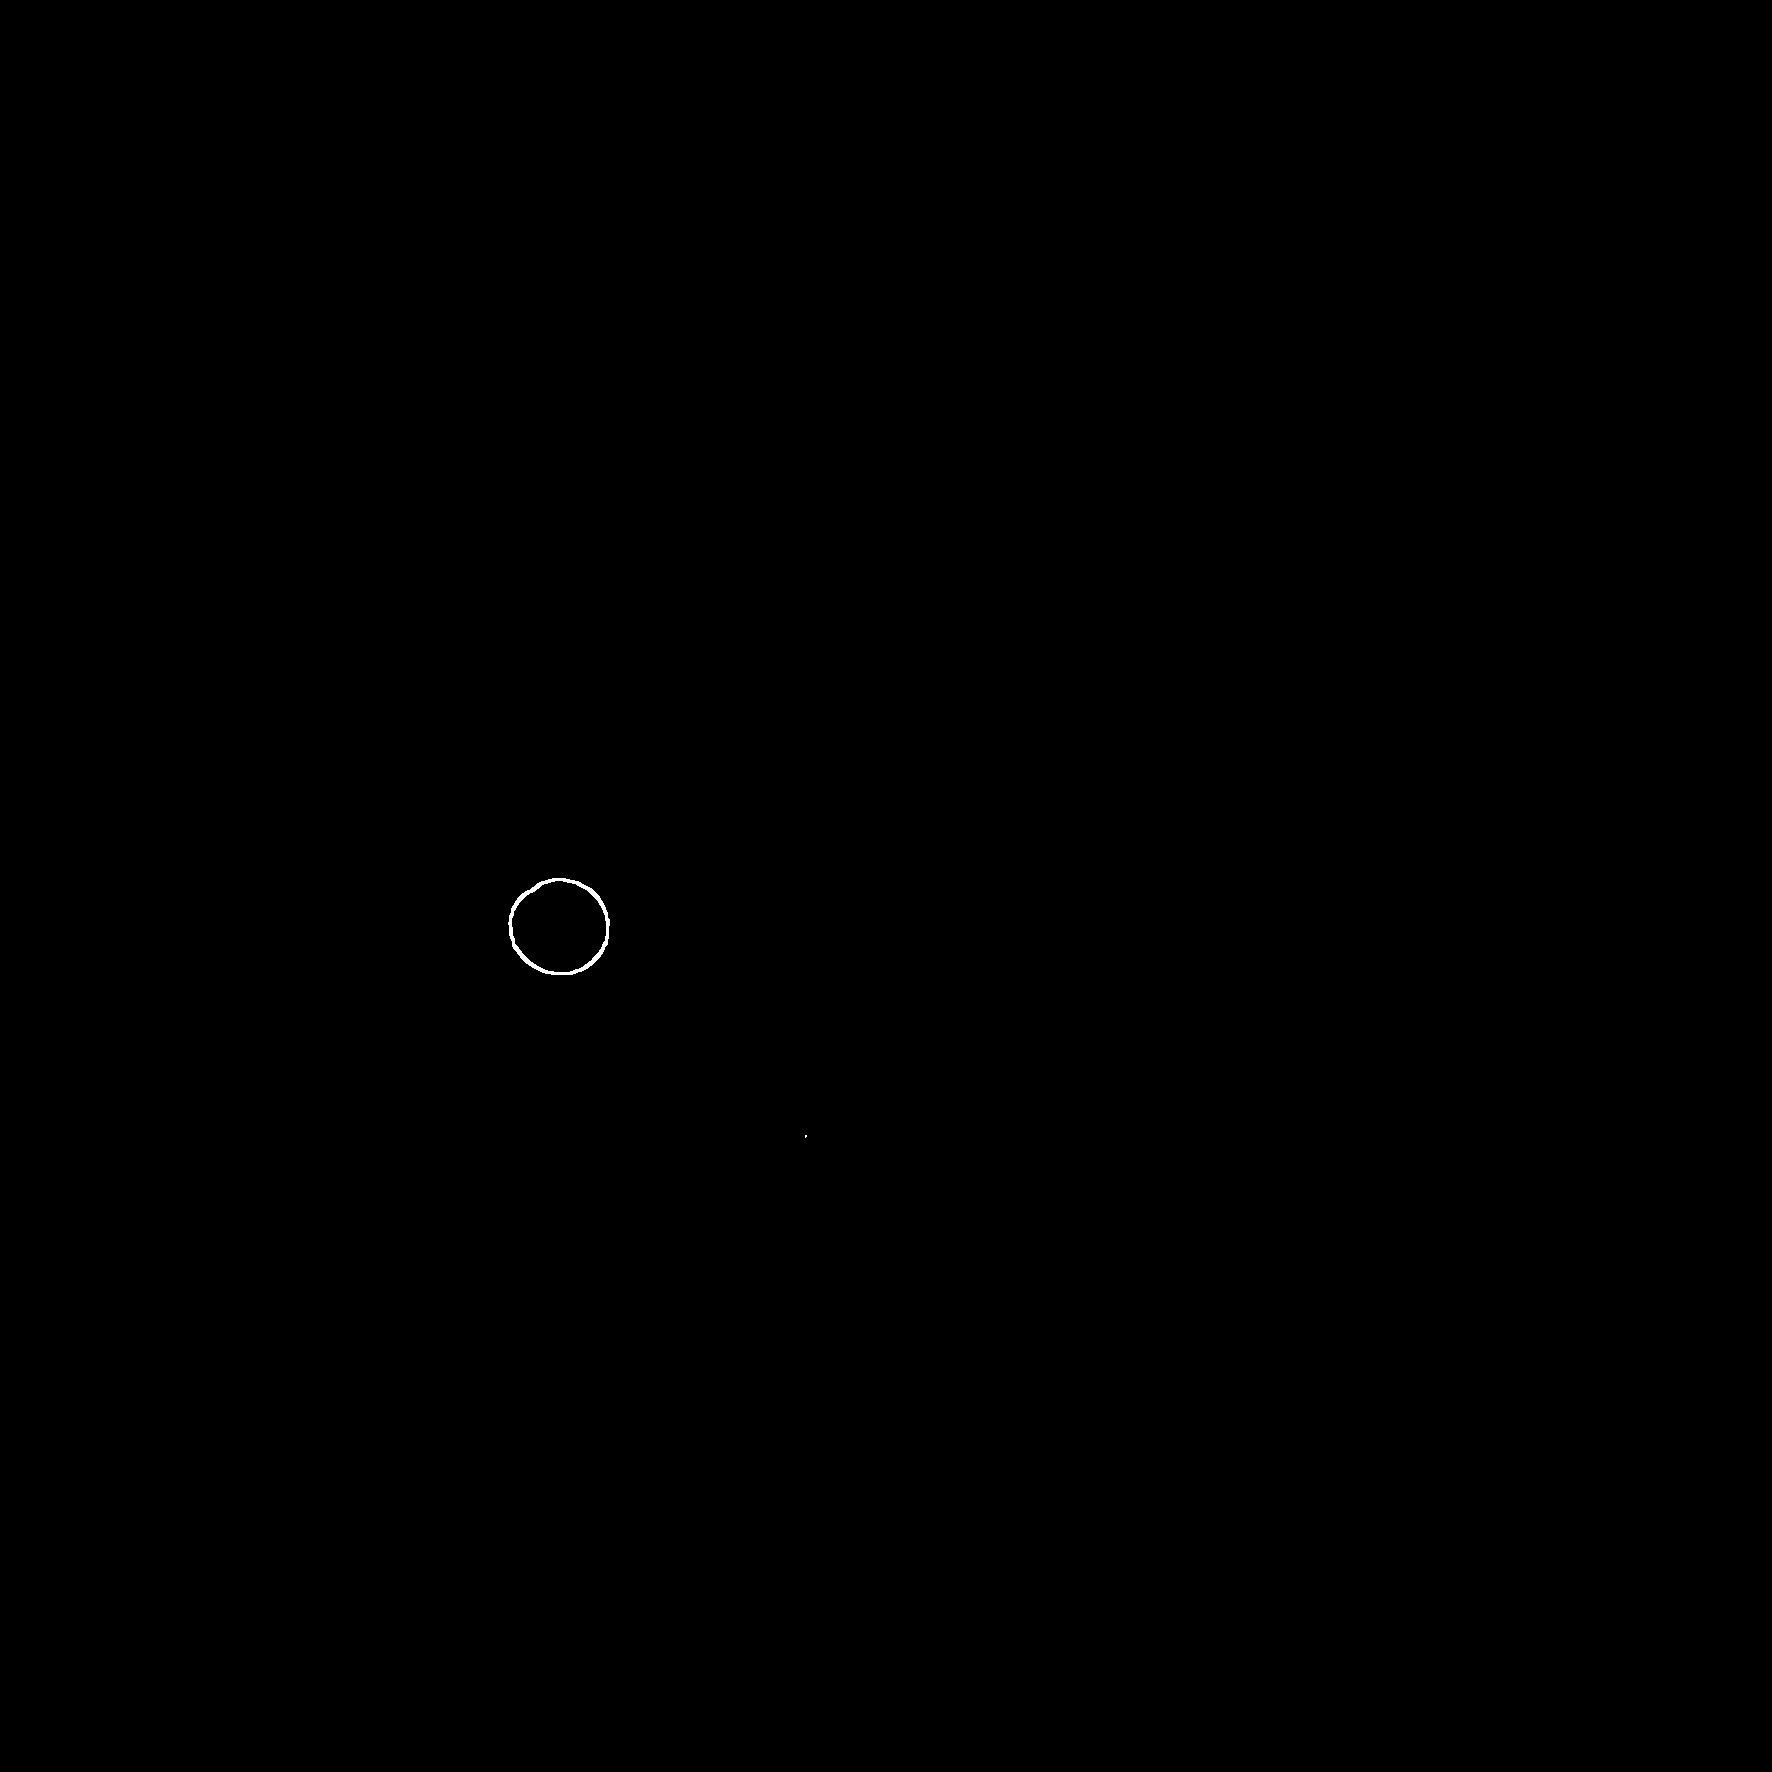

Liczba czarnych kropek: 1


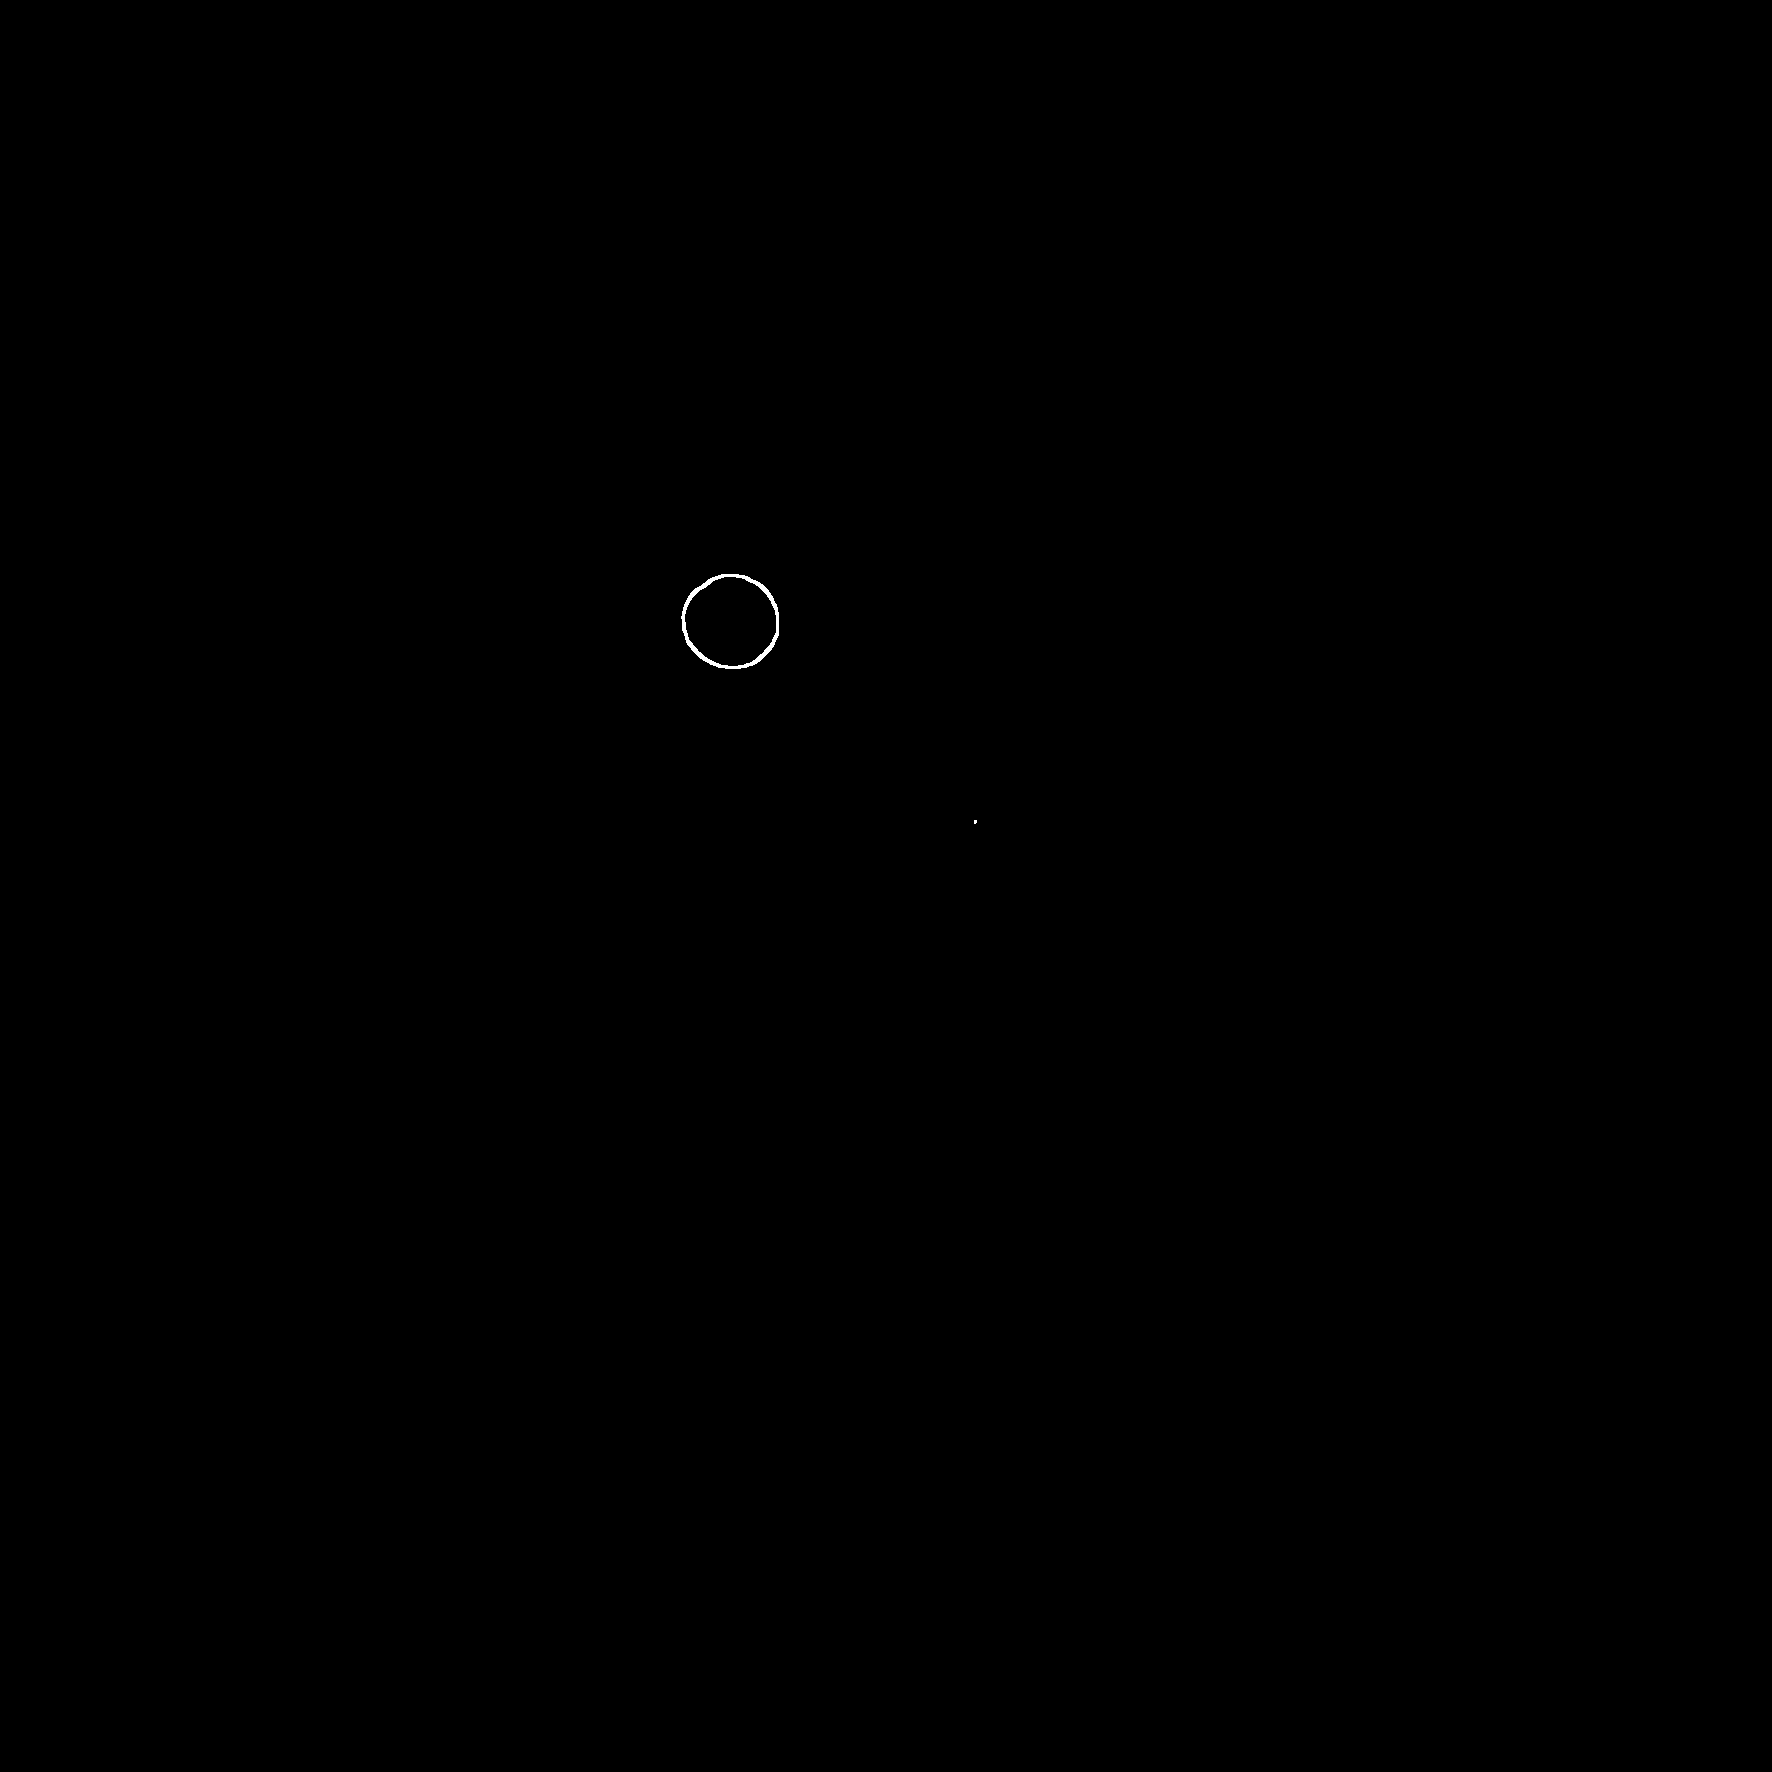

Liczba czarnych kropek: 1


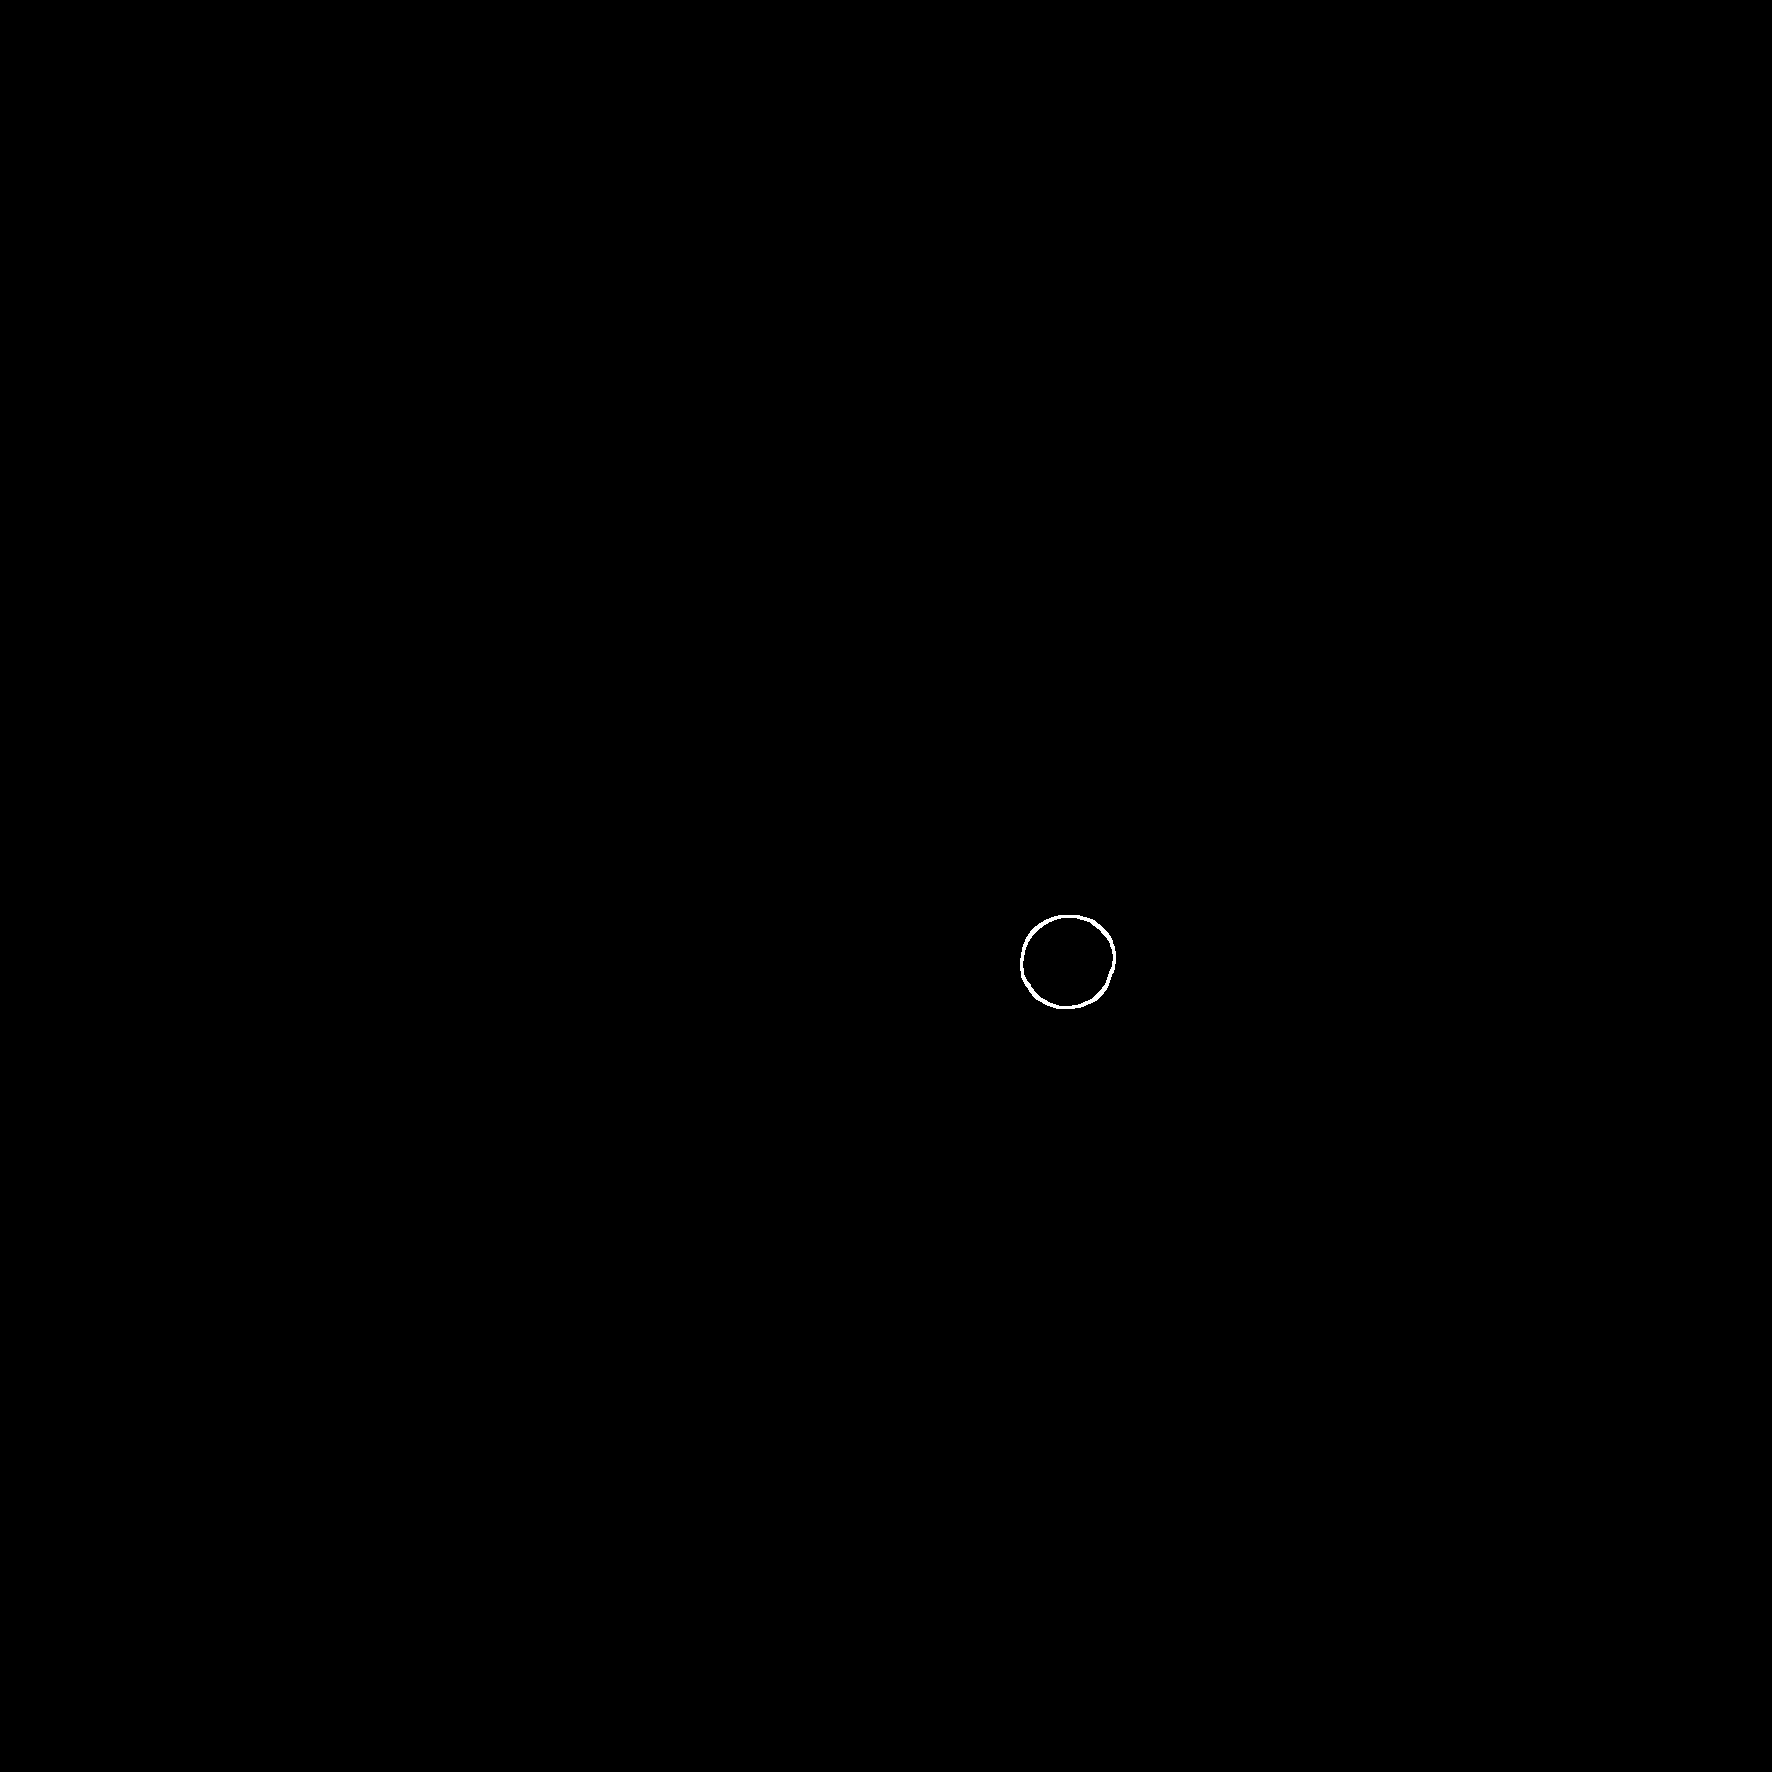

Liczba czarnych kropek: 1


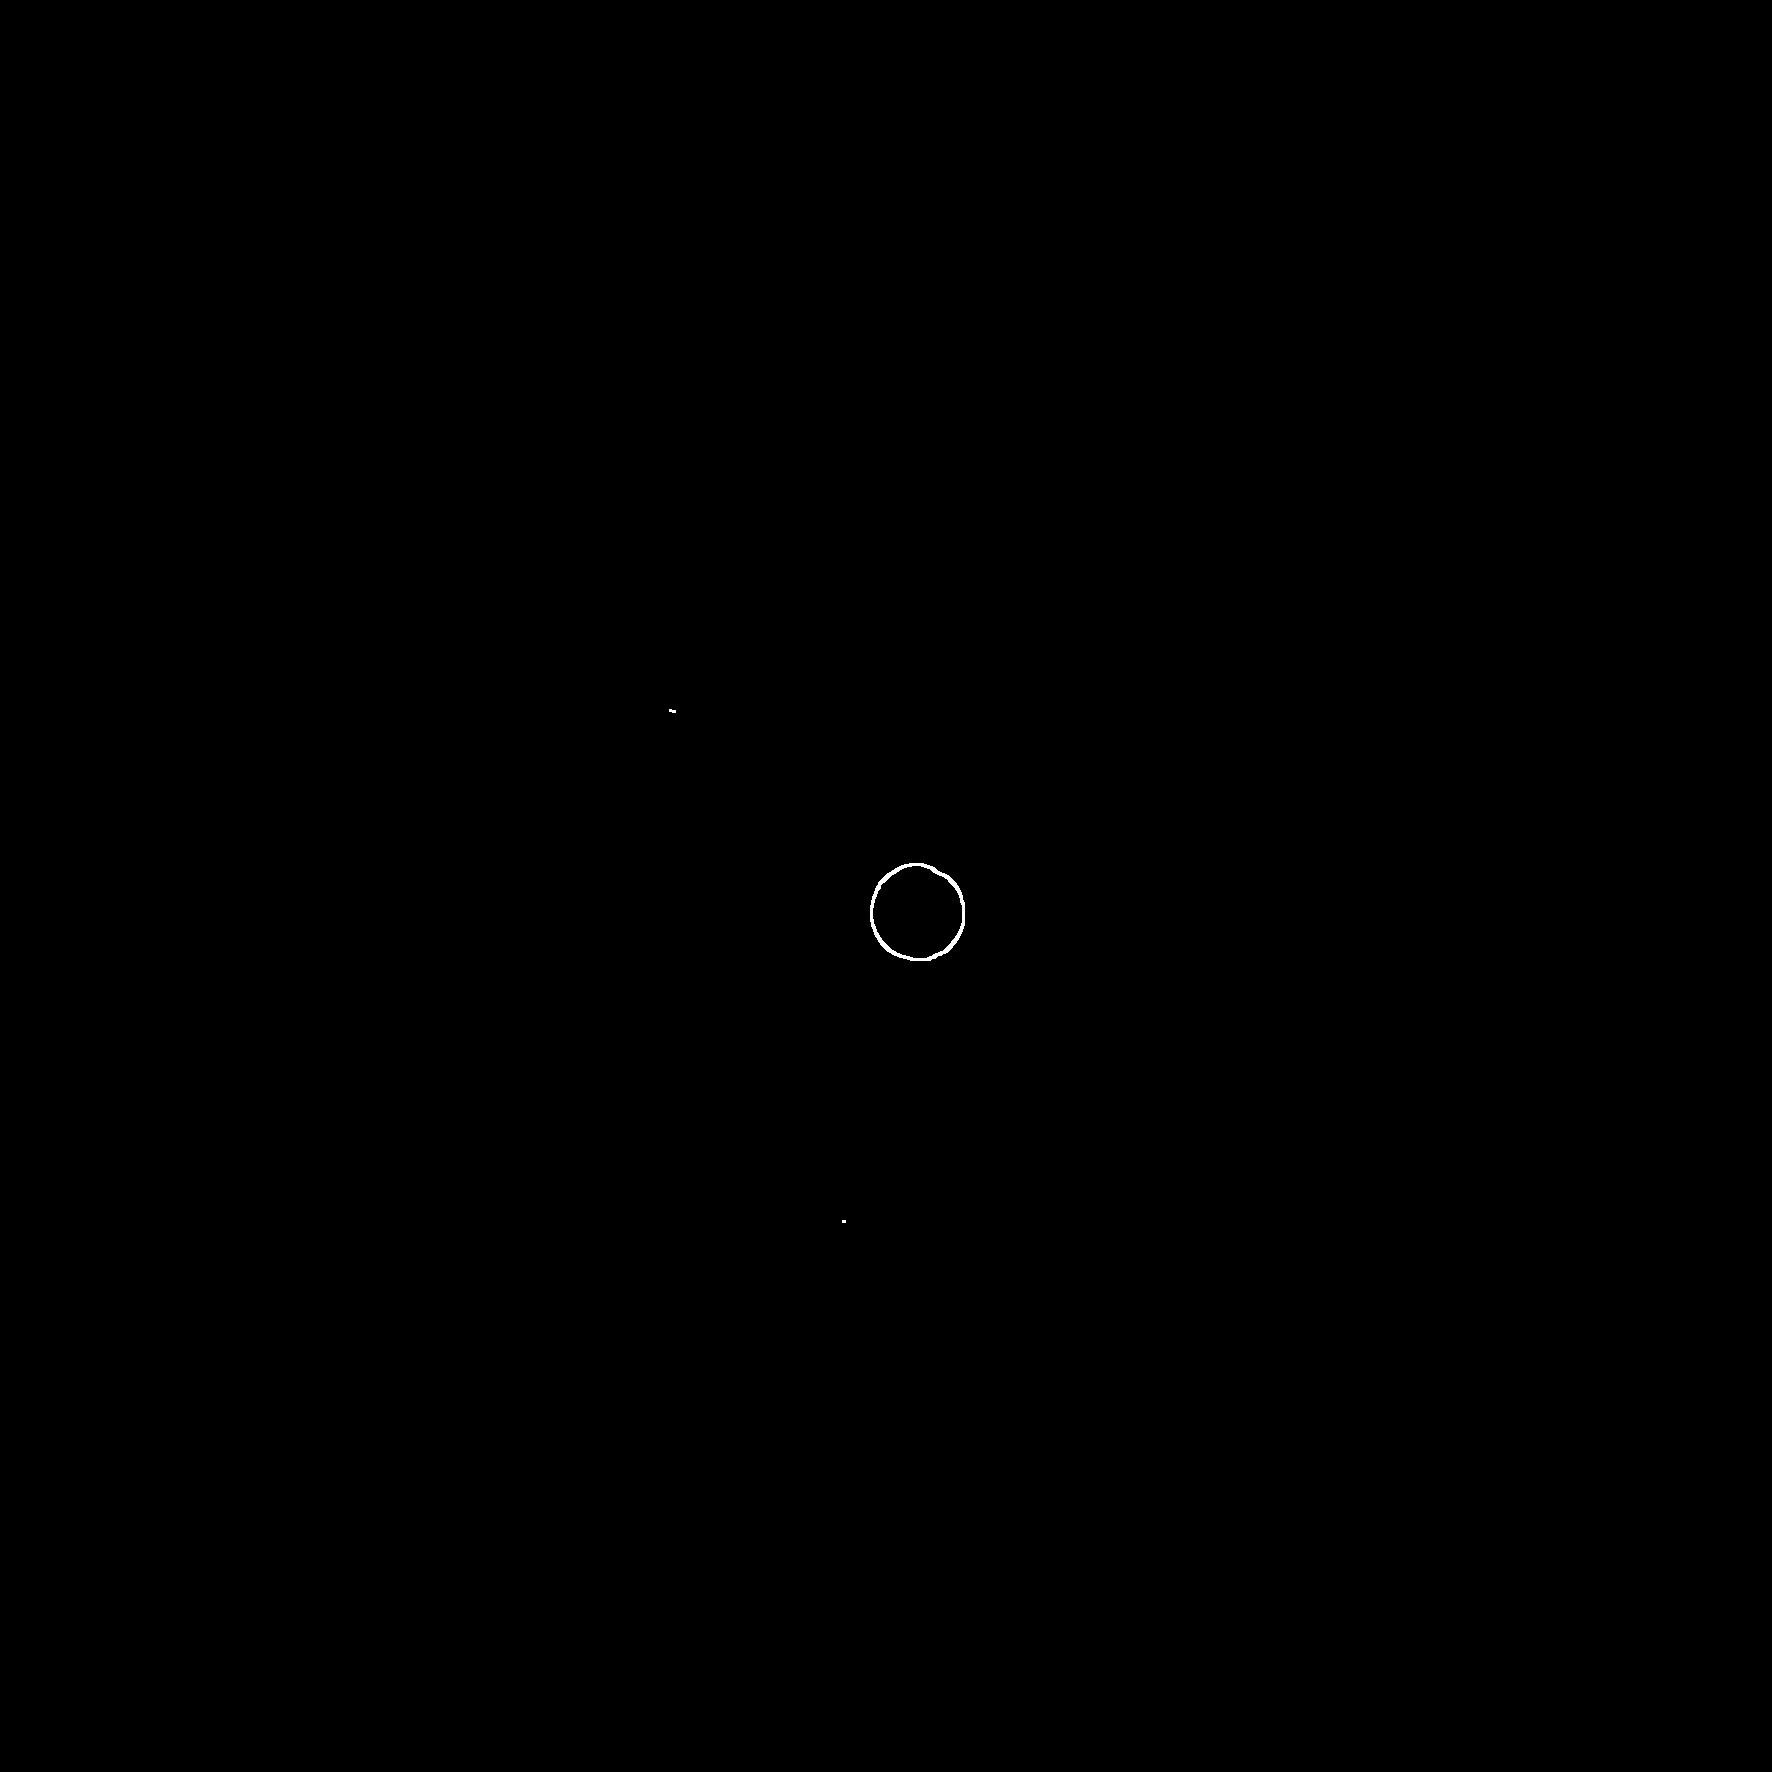

Liczba czarnych kropek: 1


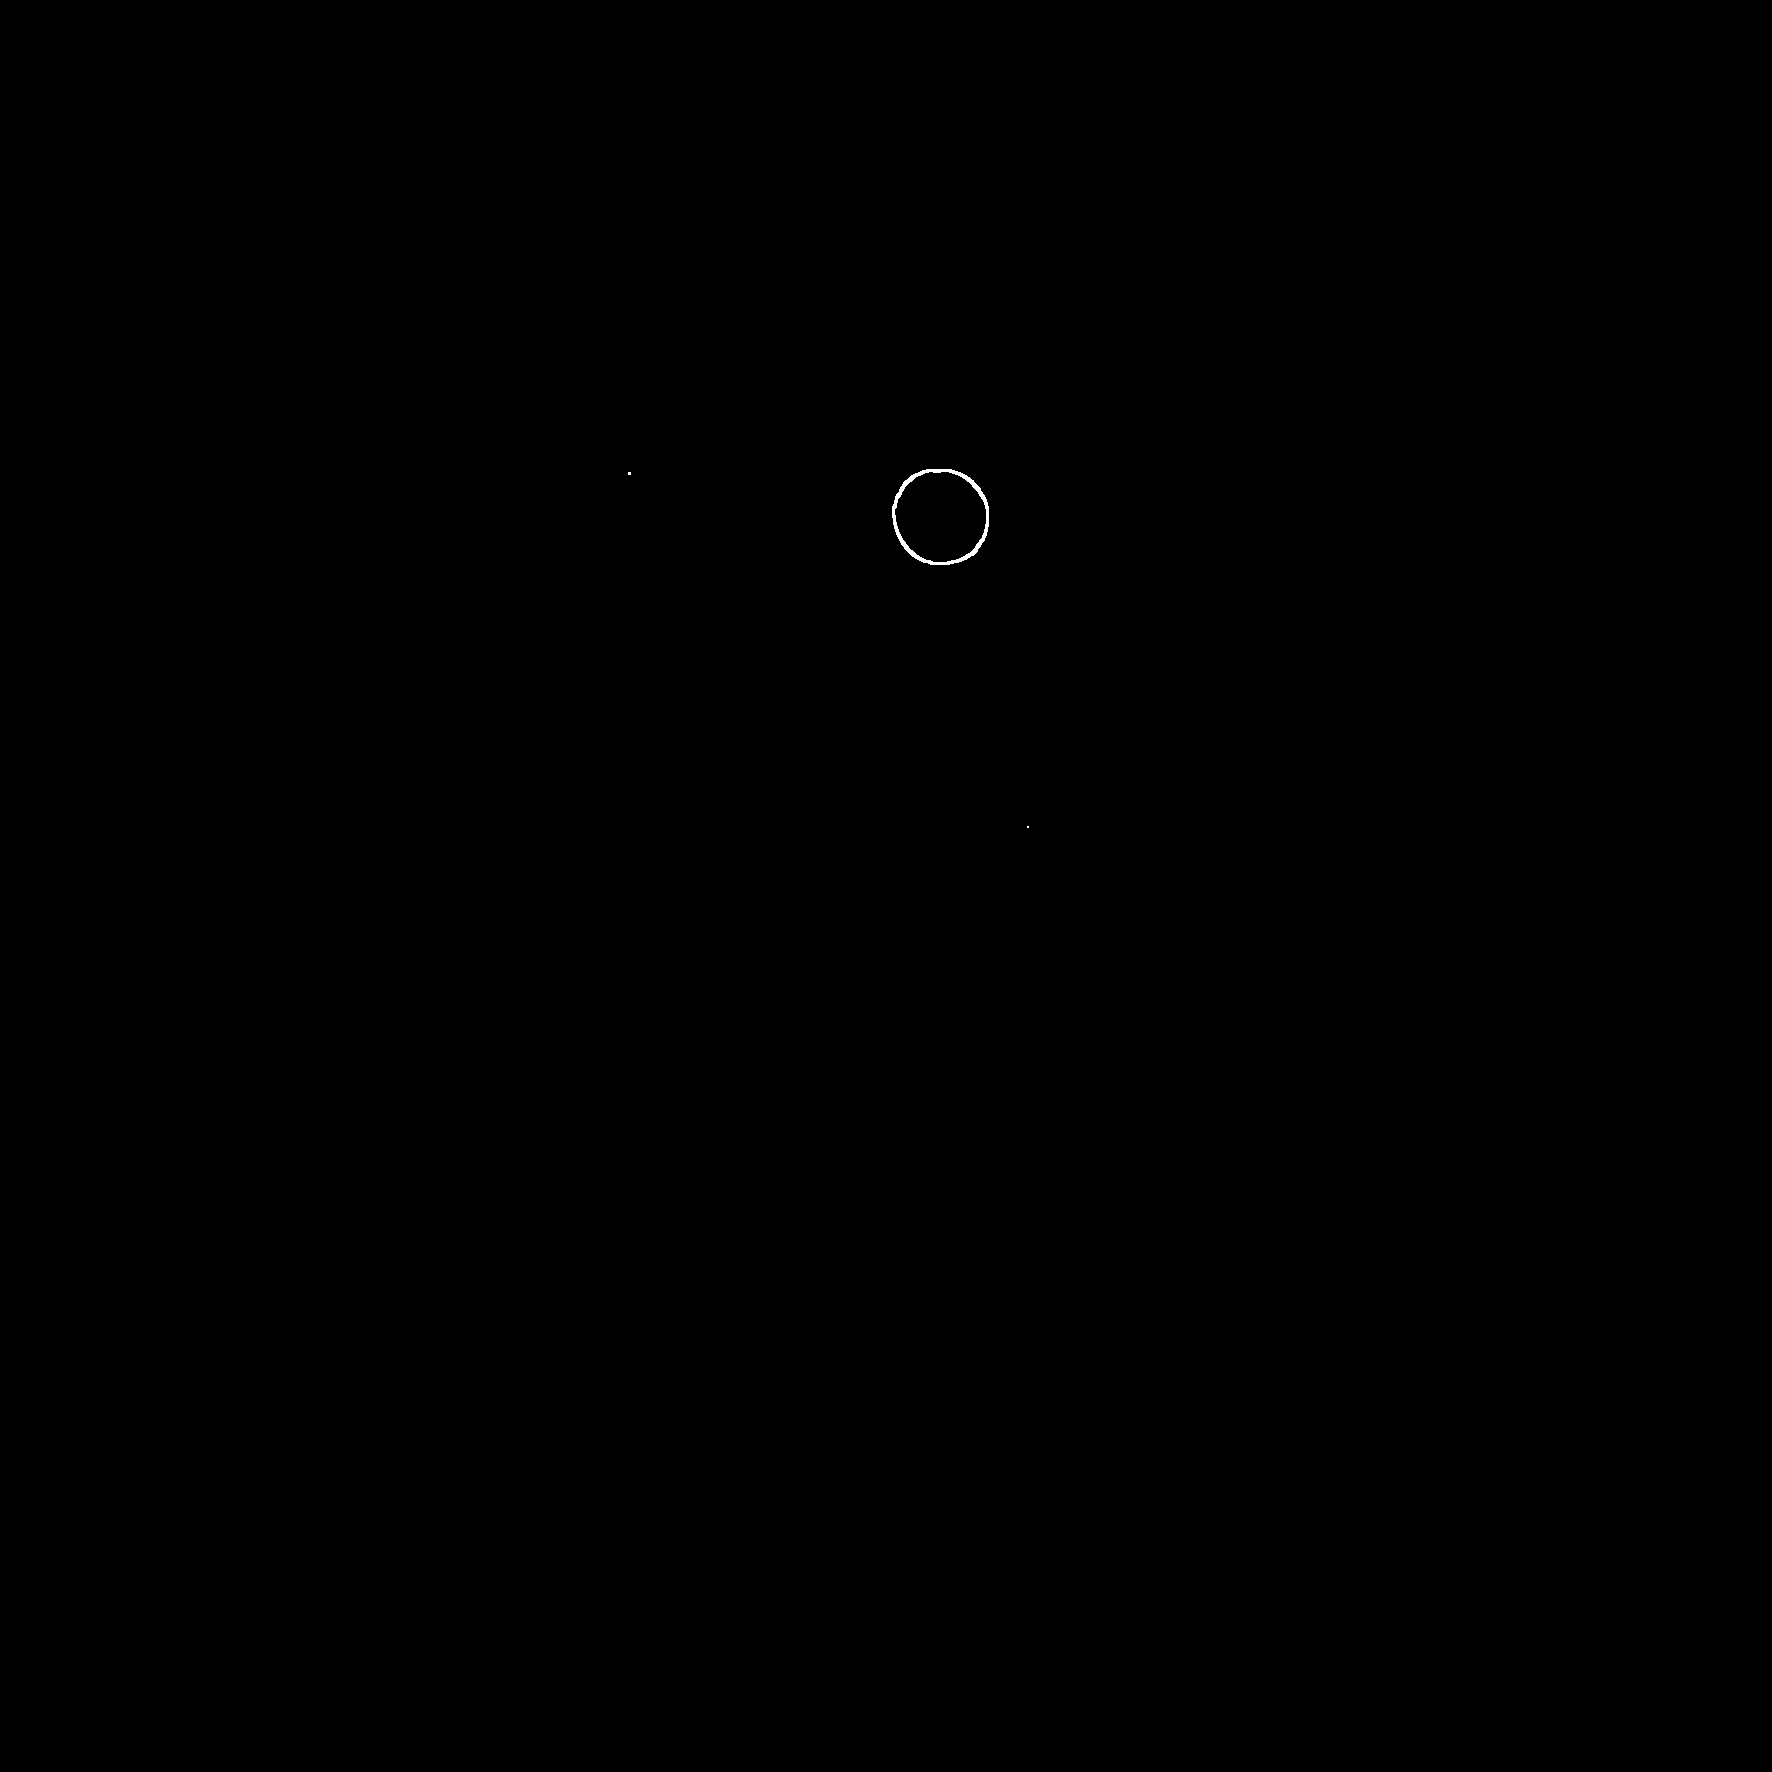

Liczba czarnych kropek: 1


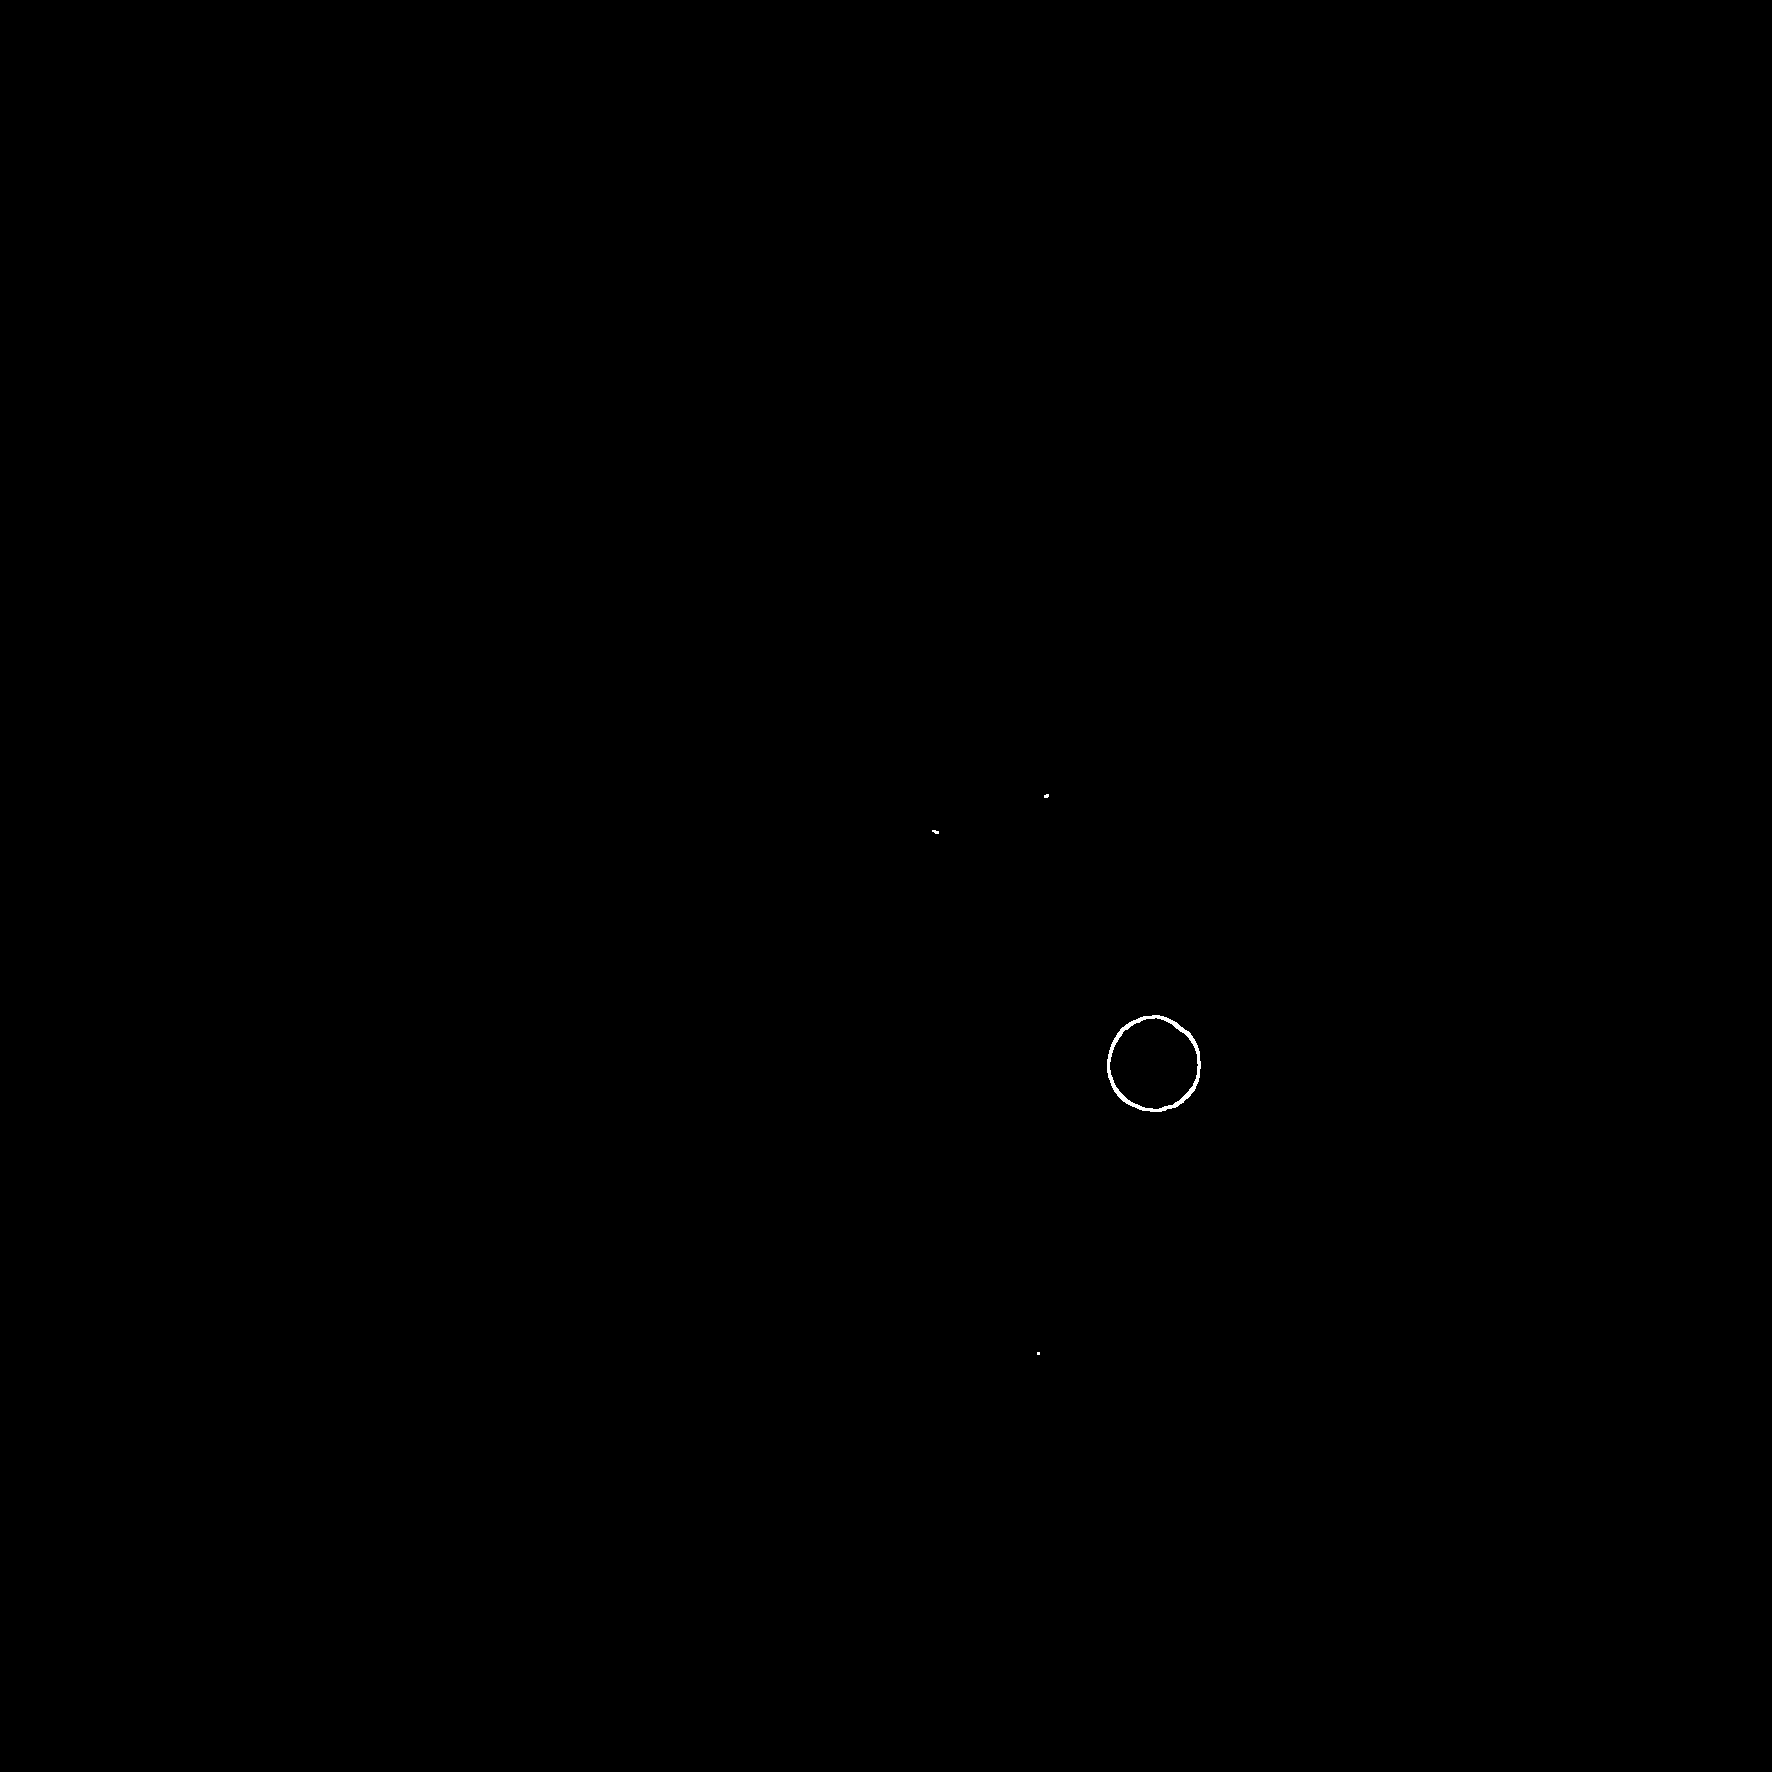

Liczba czarnych kropek: 1


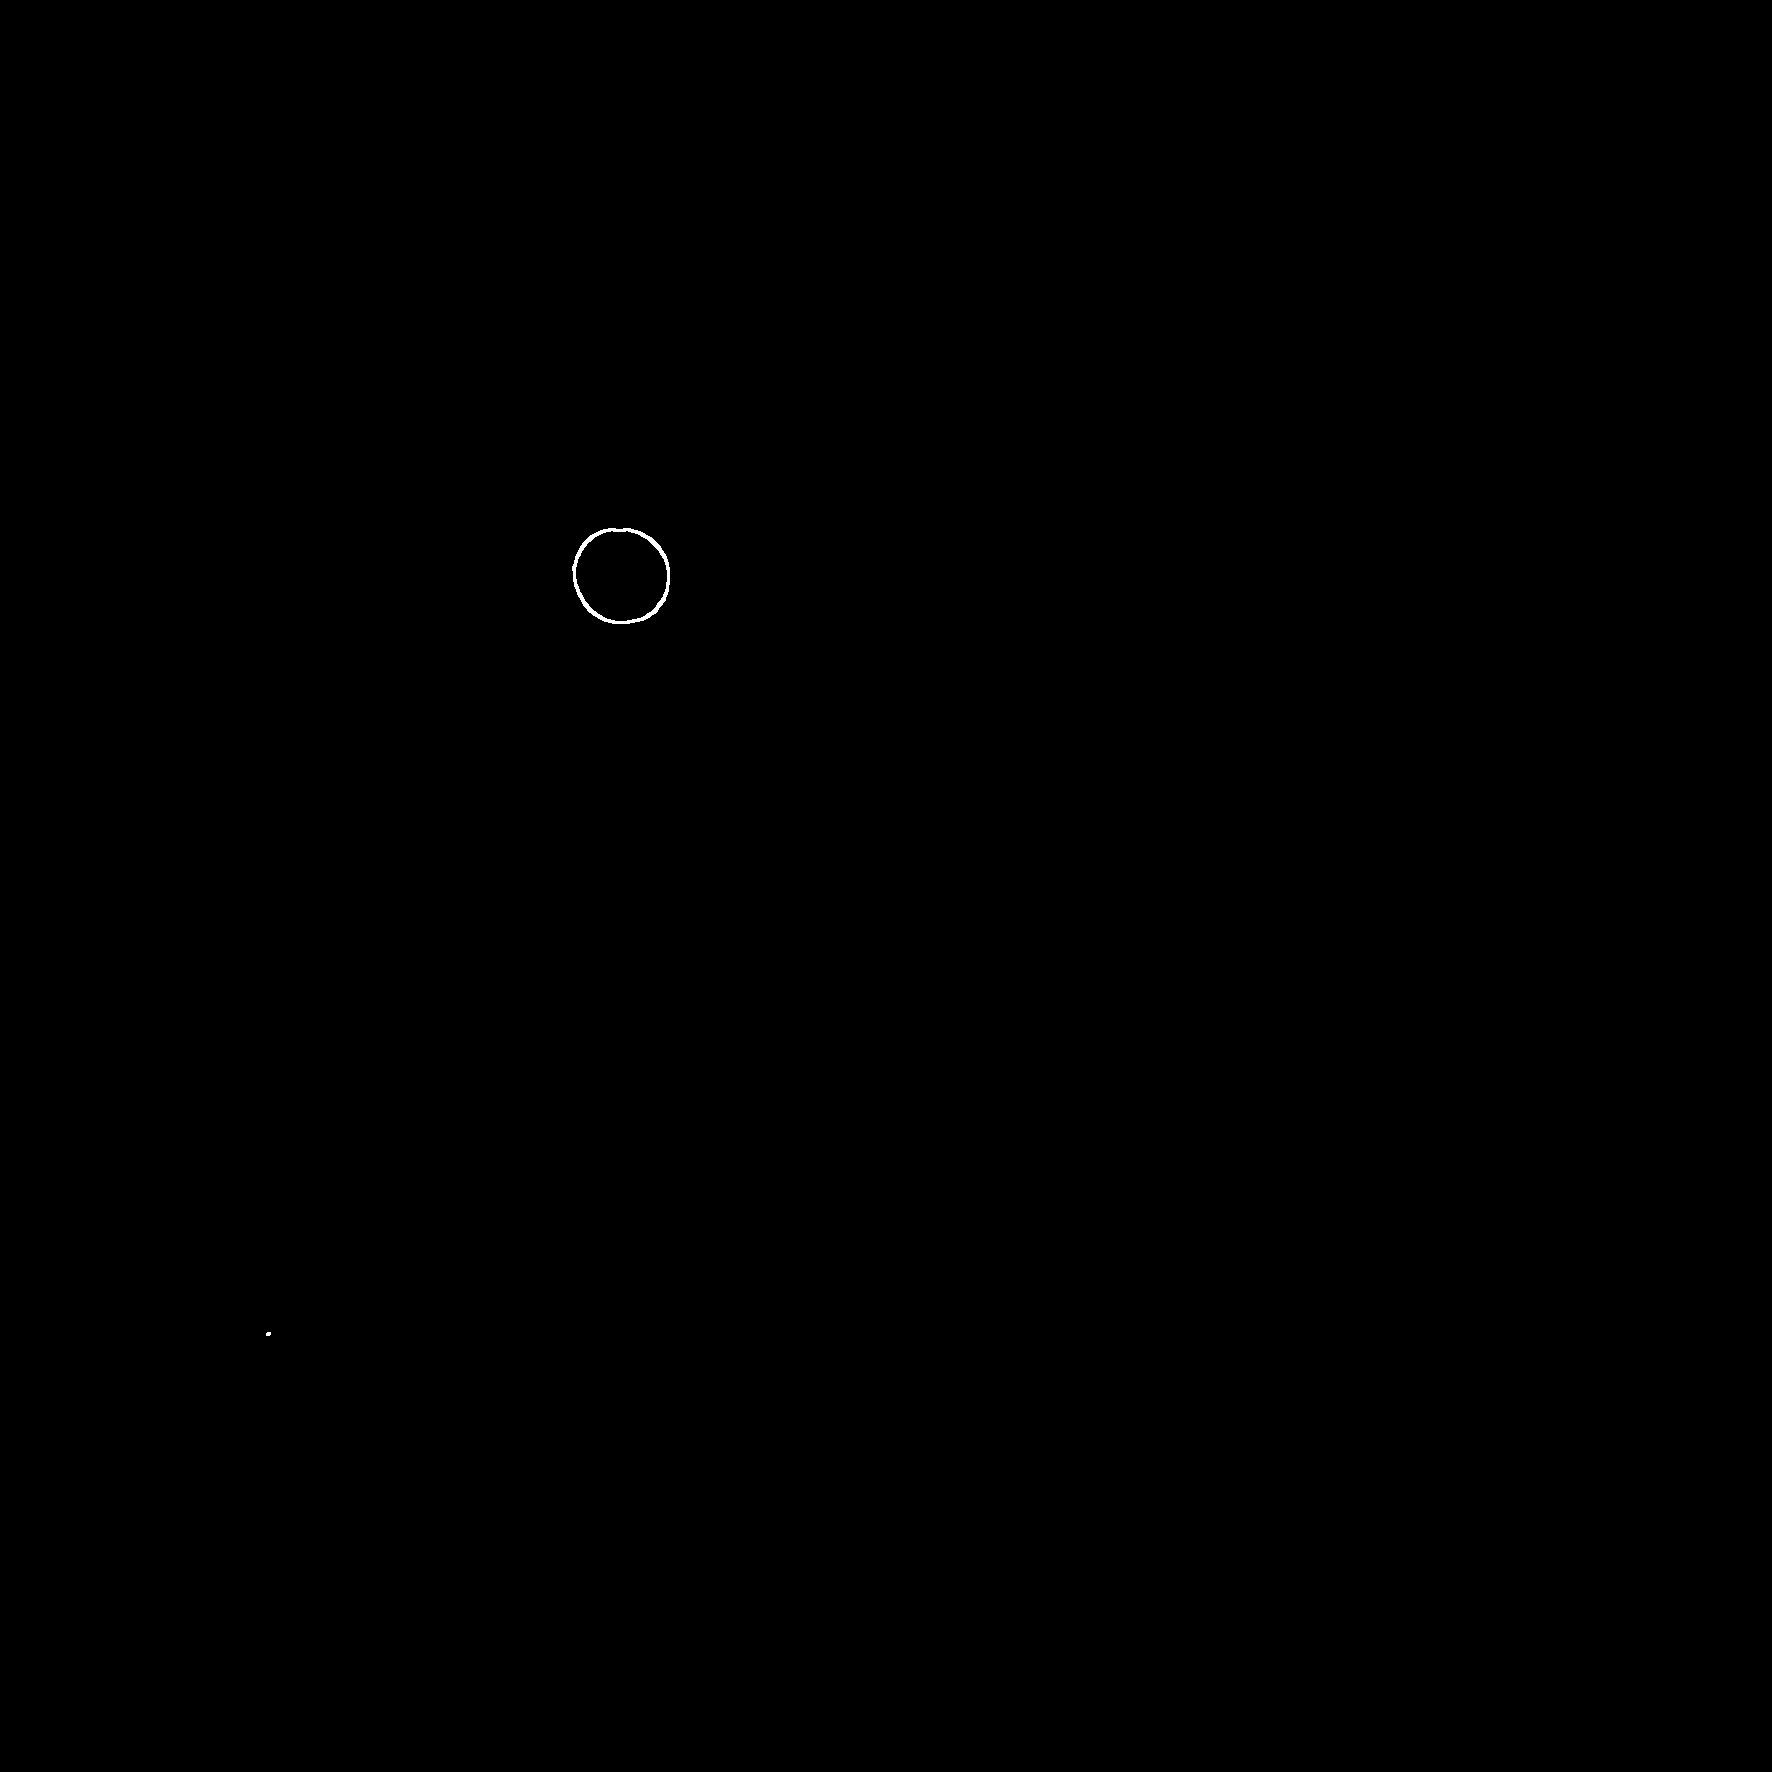

Liczba czarnych kropek: 1


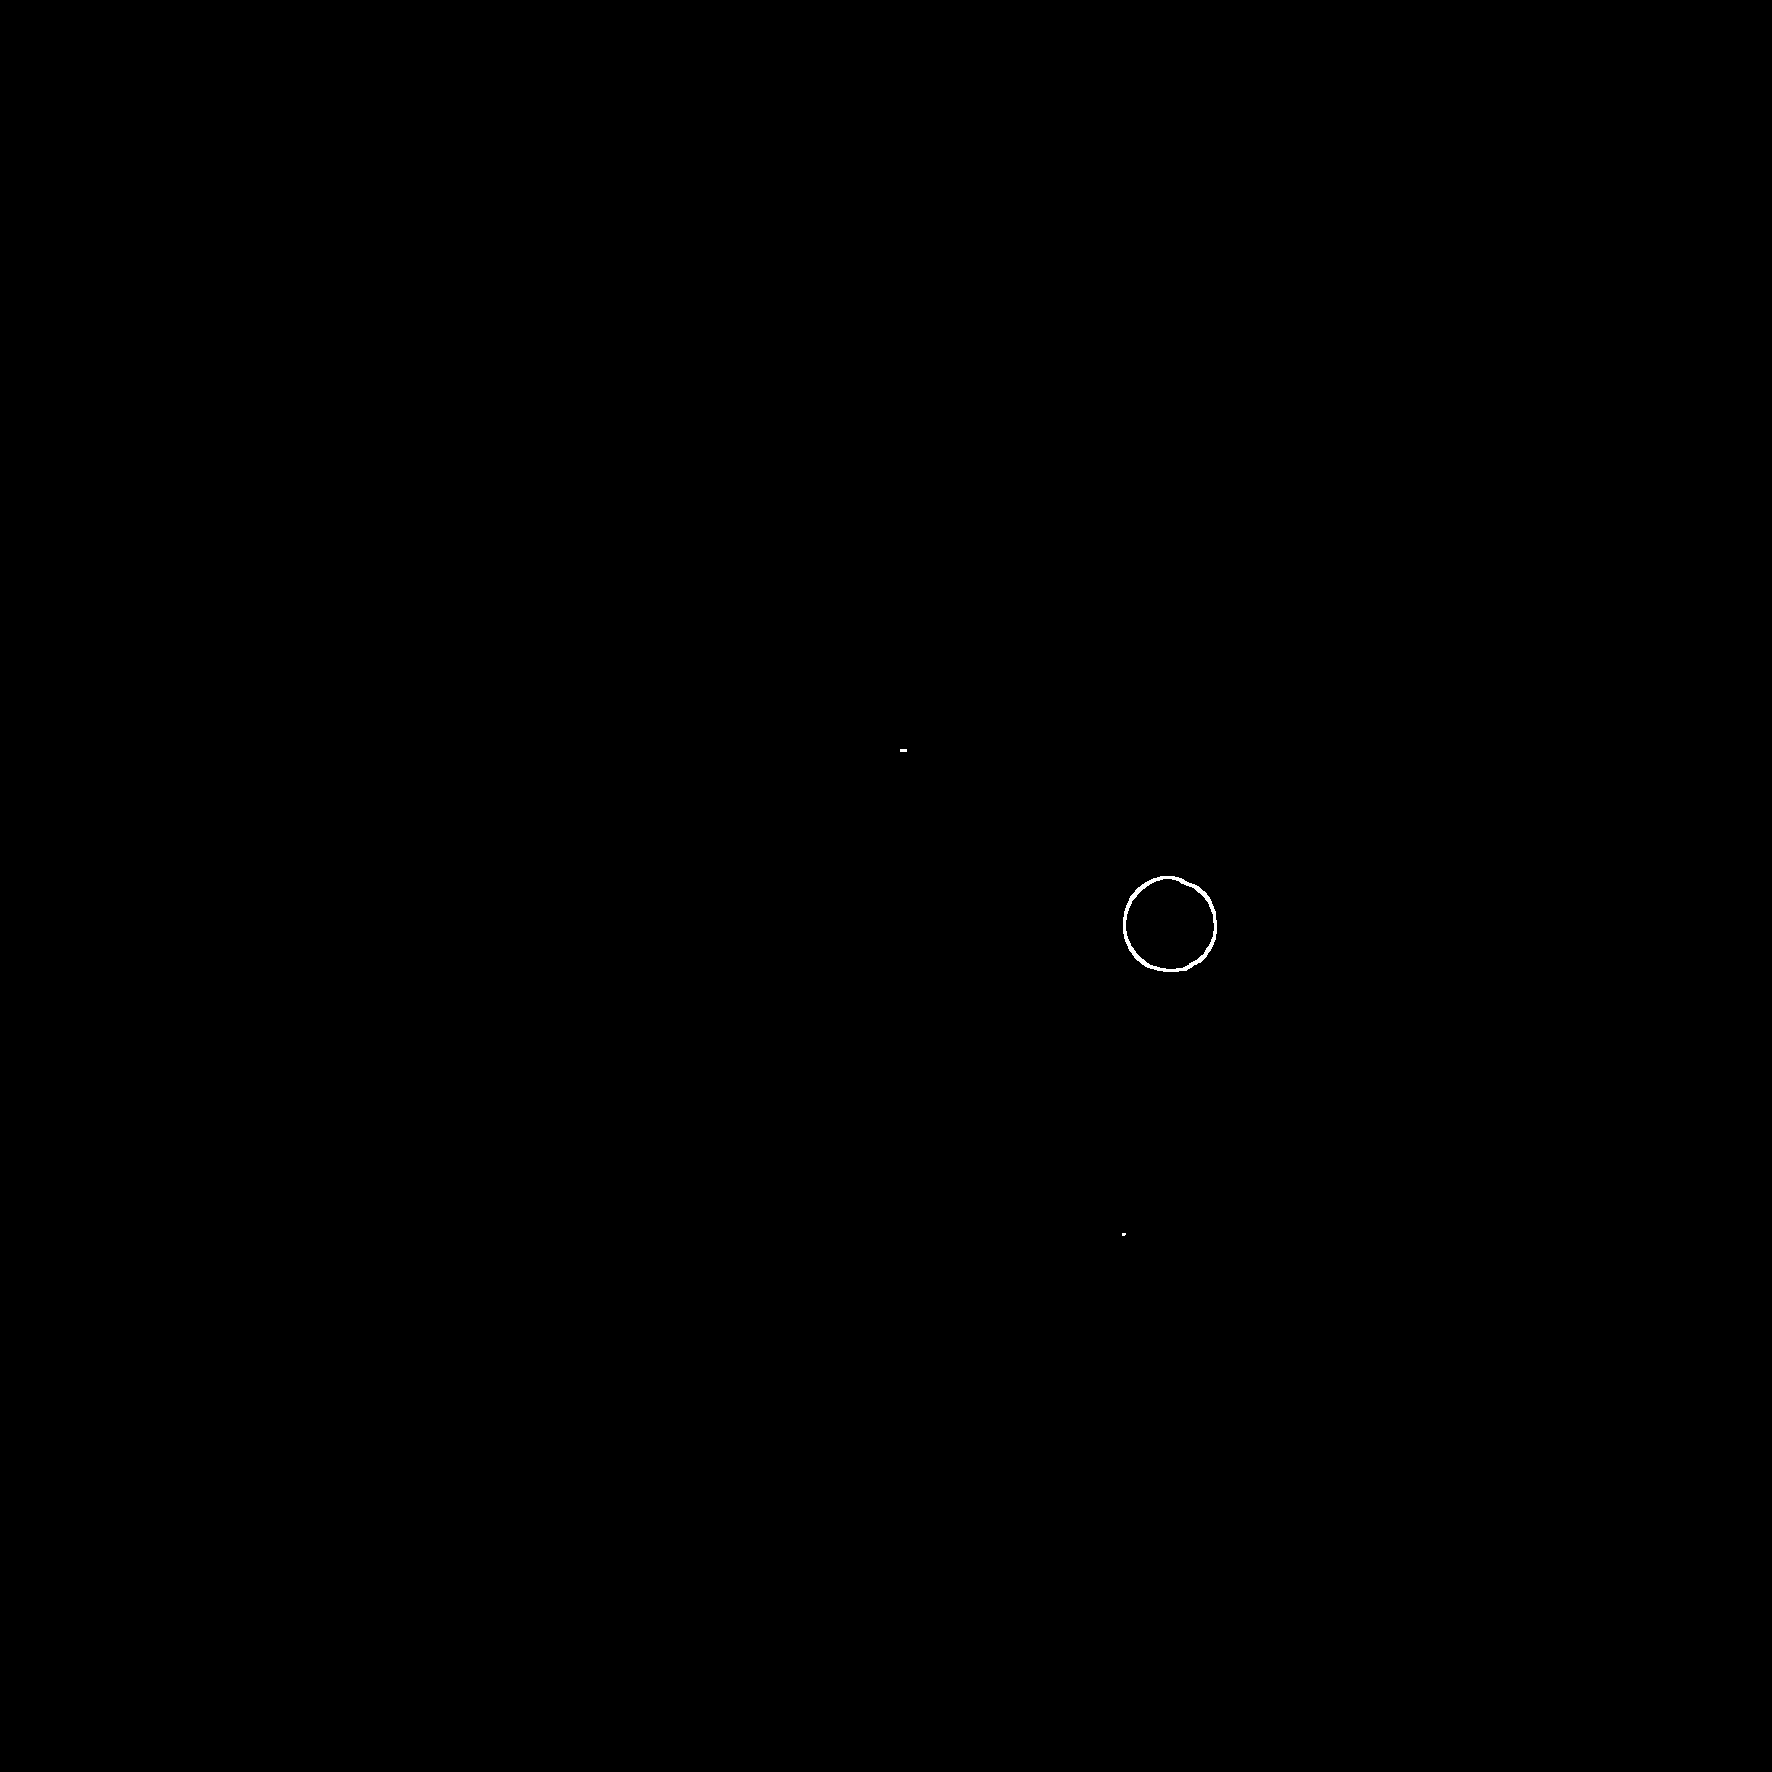

Liczba czarnych kropek: 1


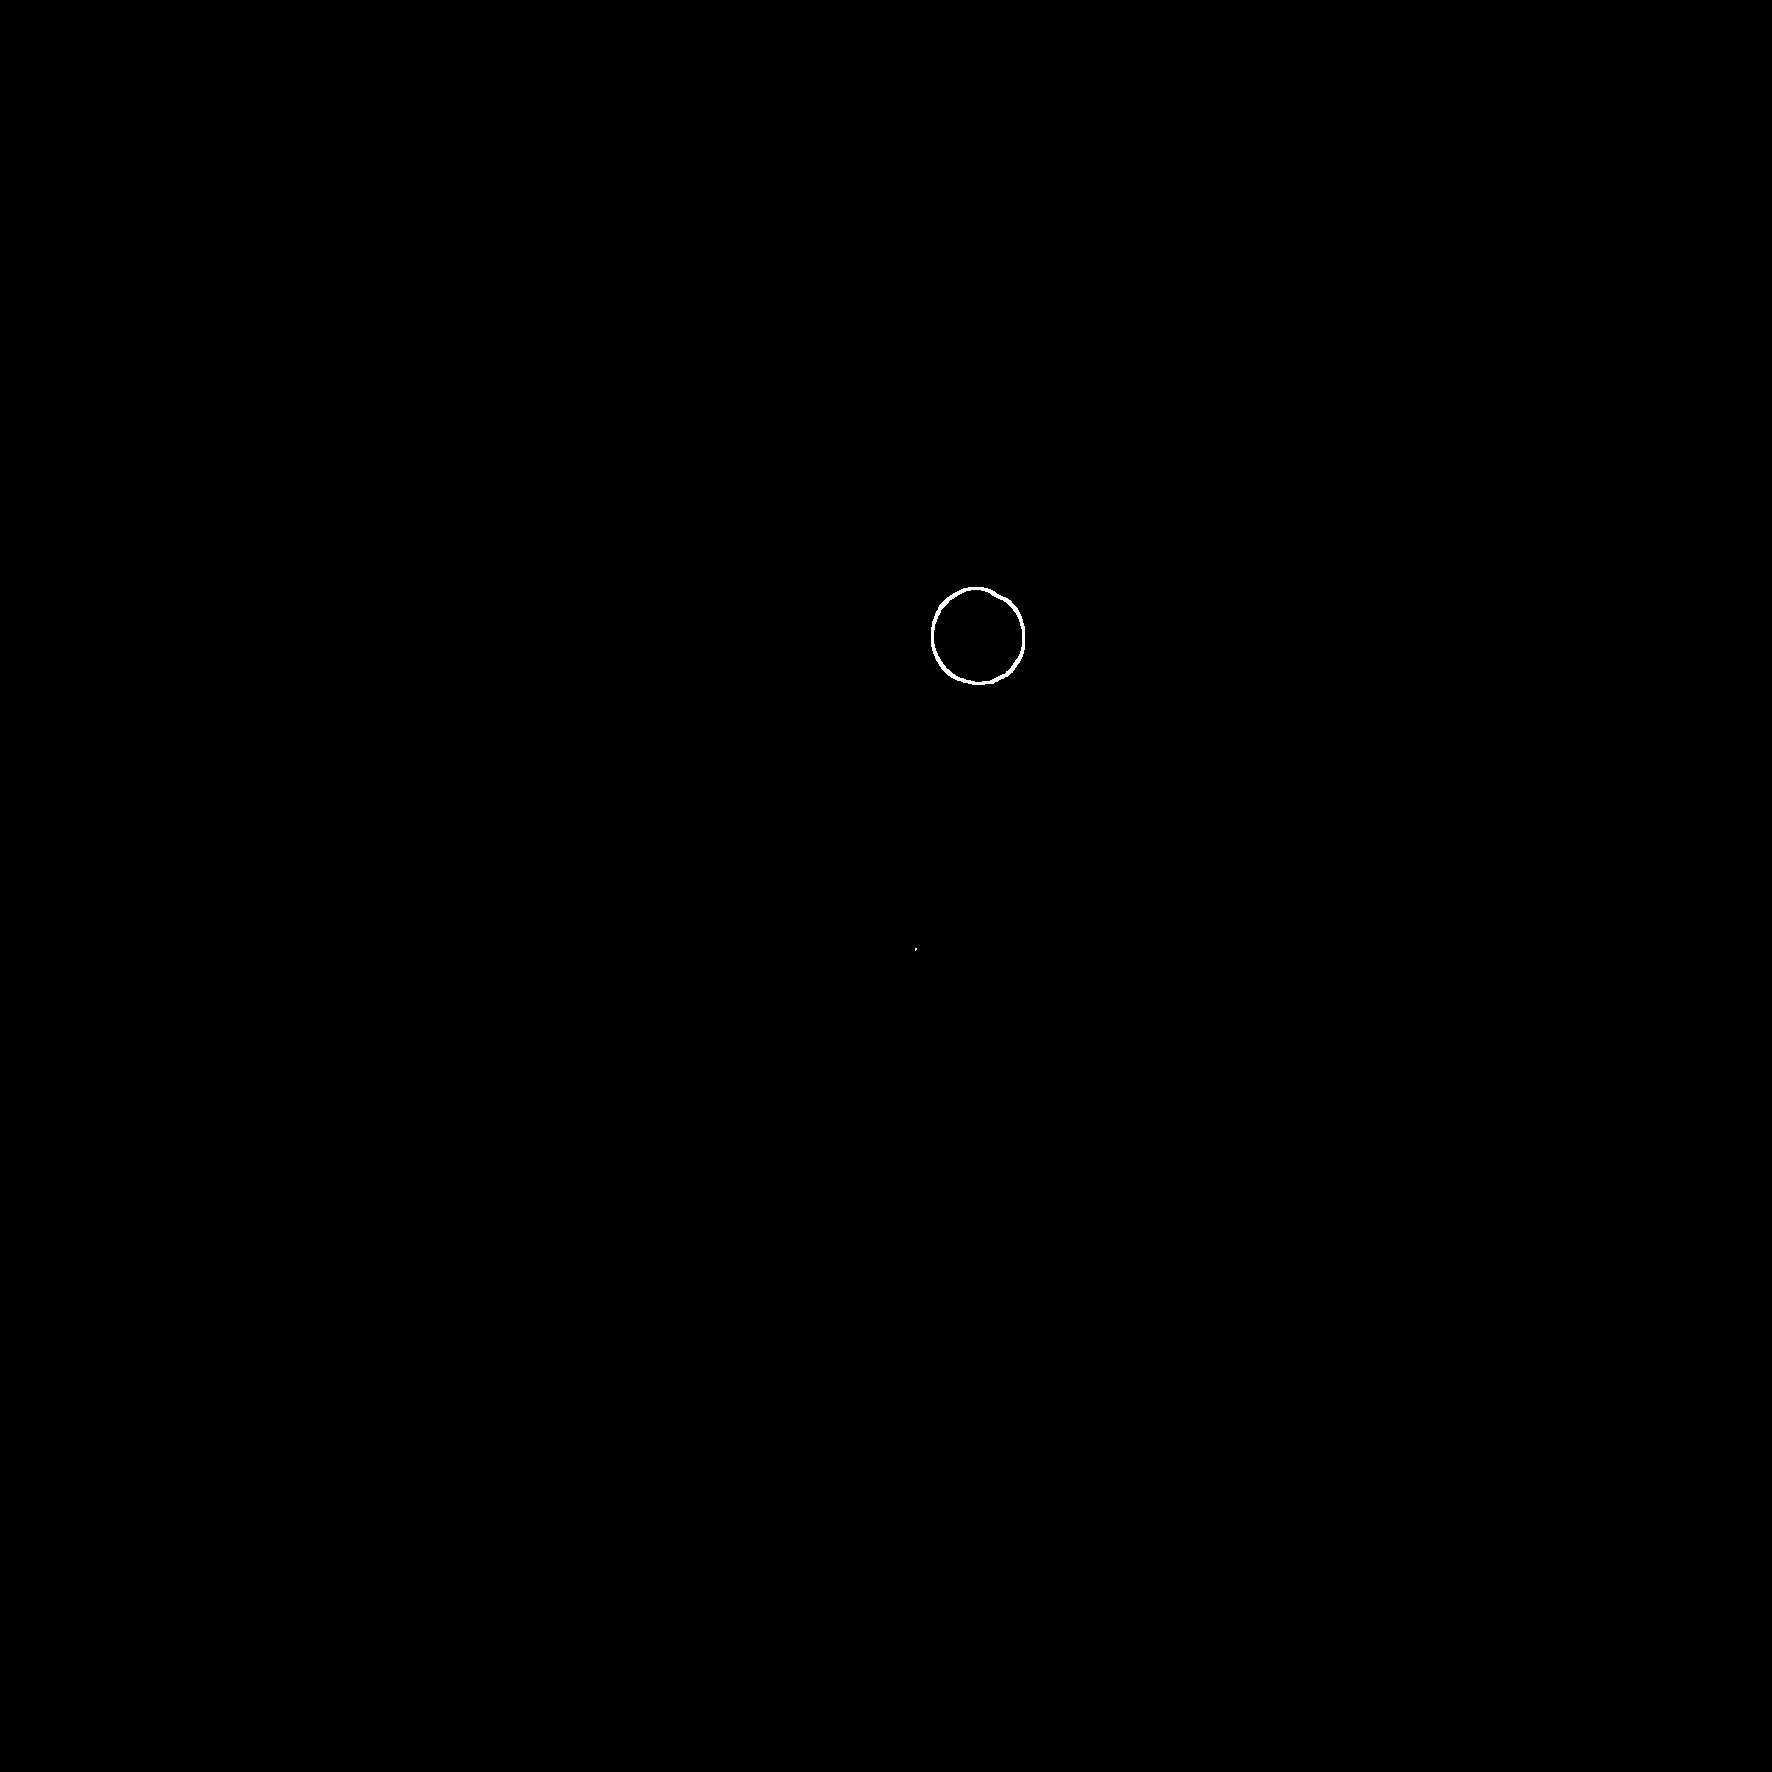

Liczba czarnych kropek: 1


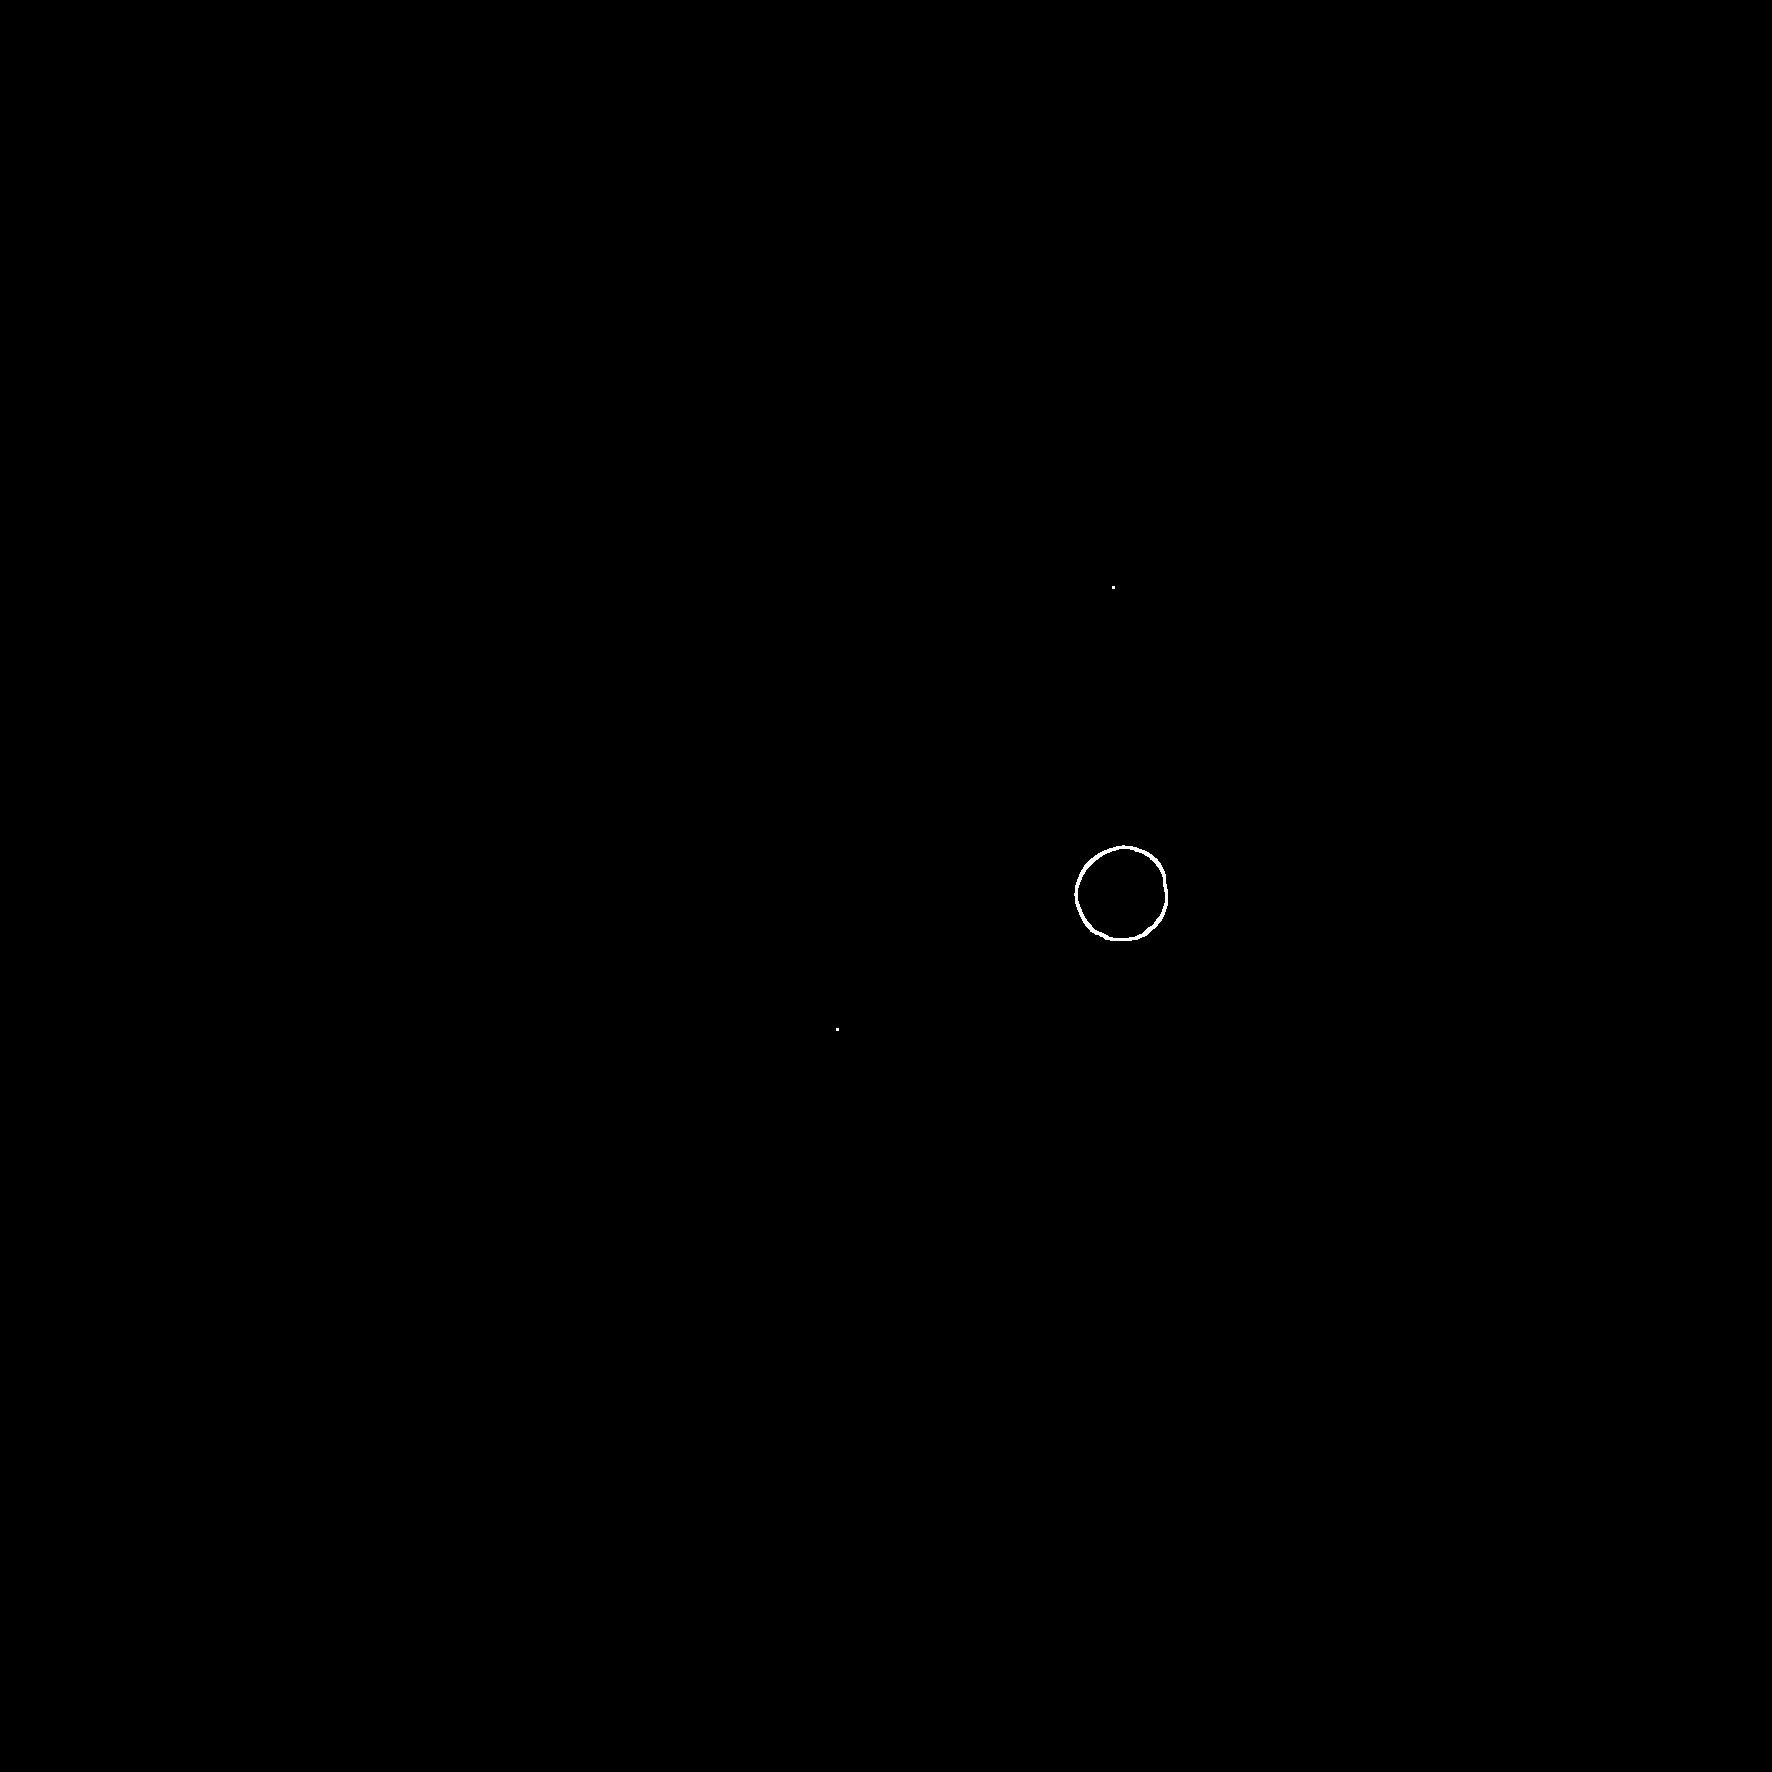

Liczba czarnych kropek: 1


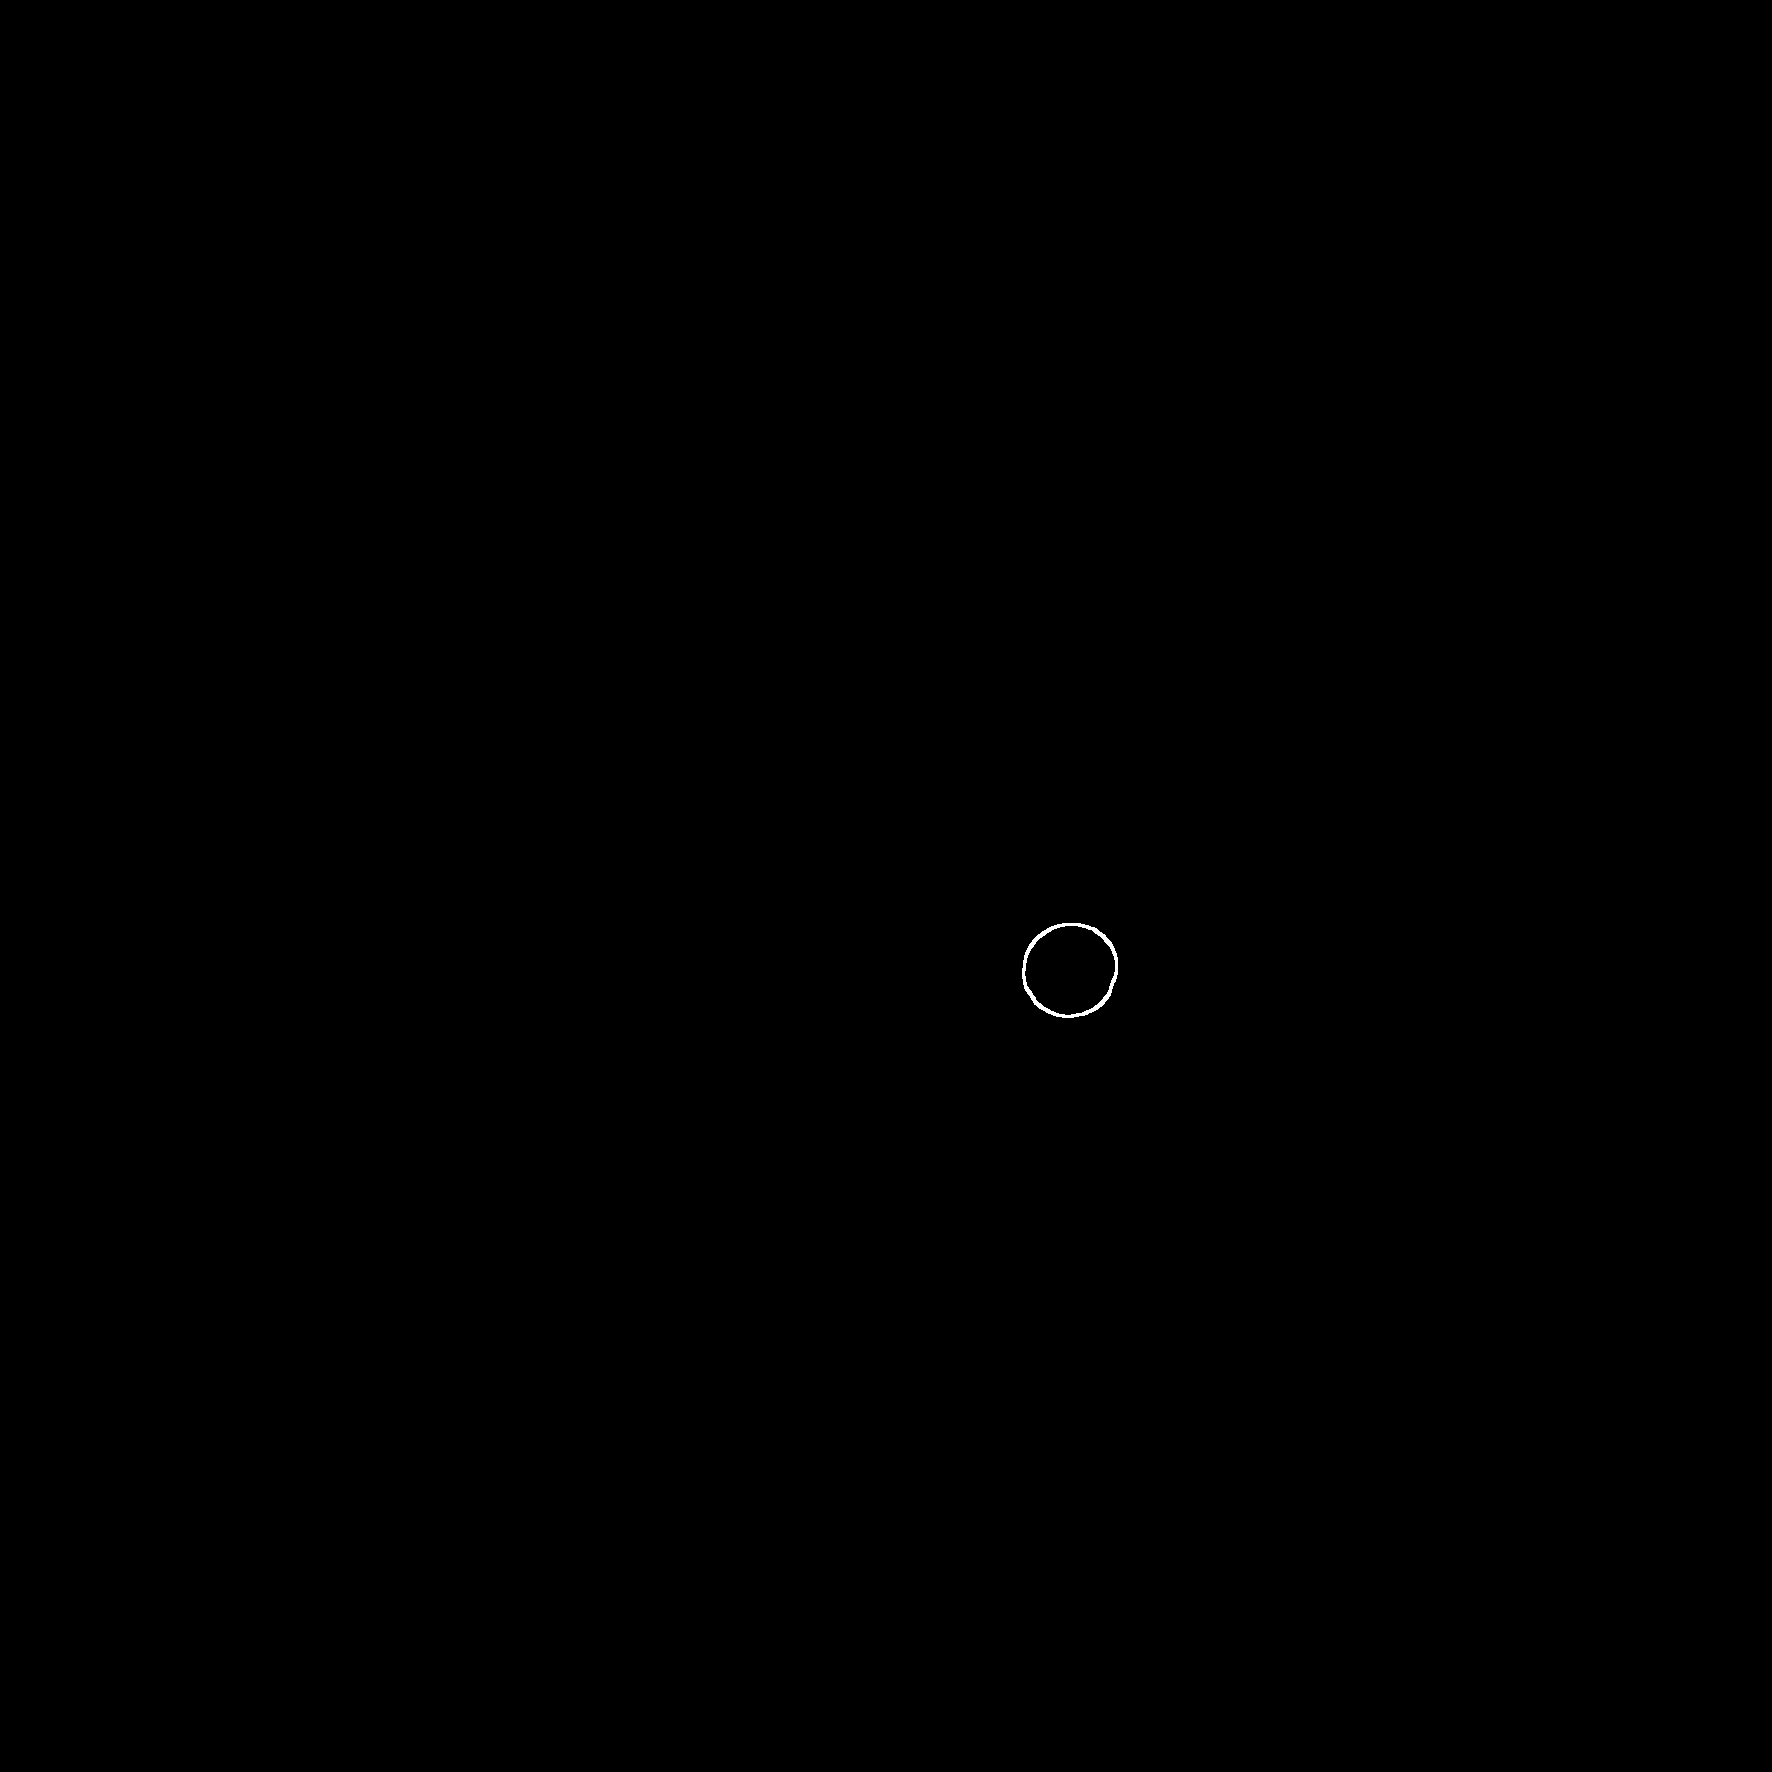

Liczba czarnych kropek: 1


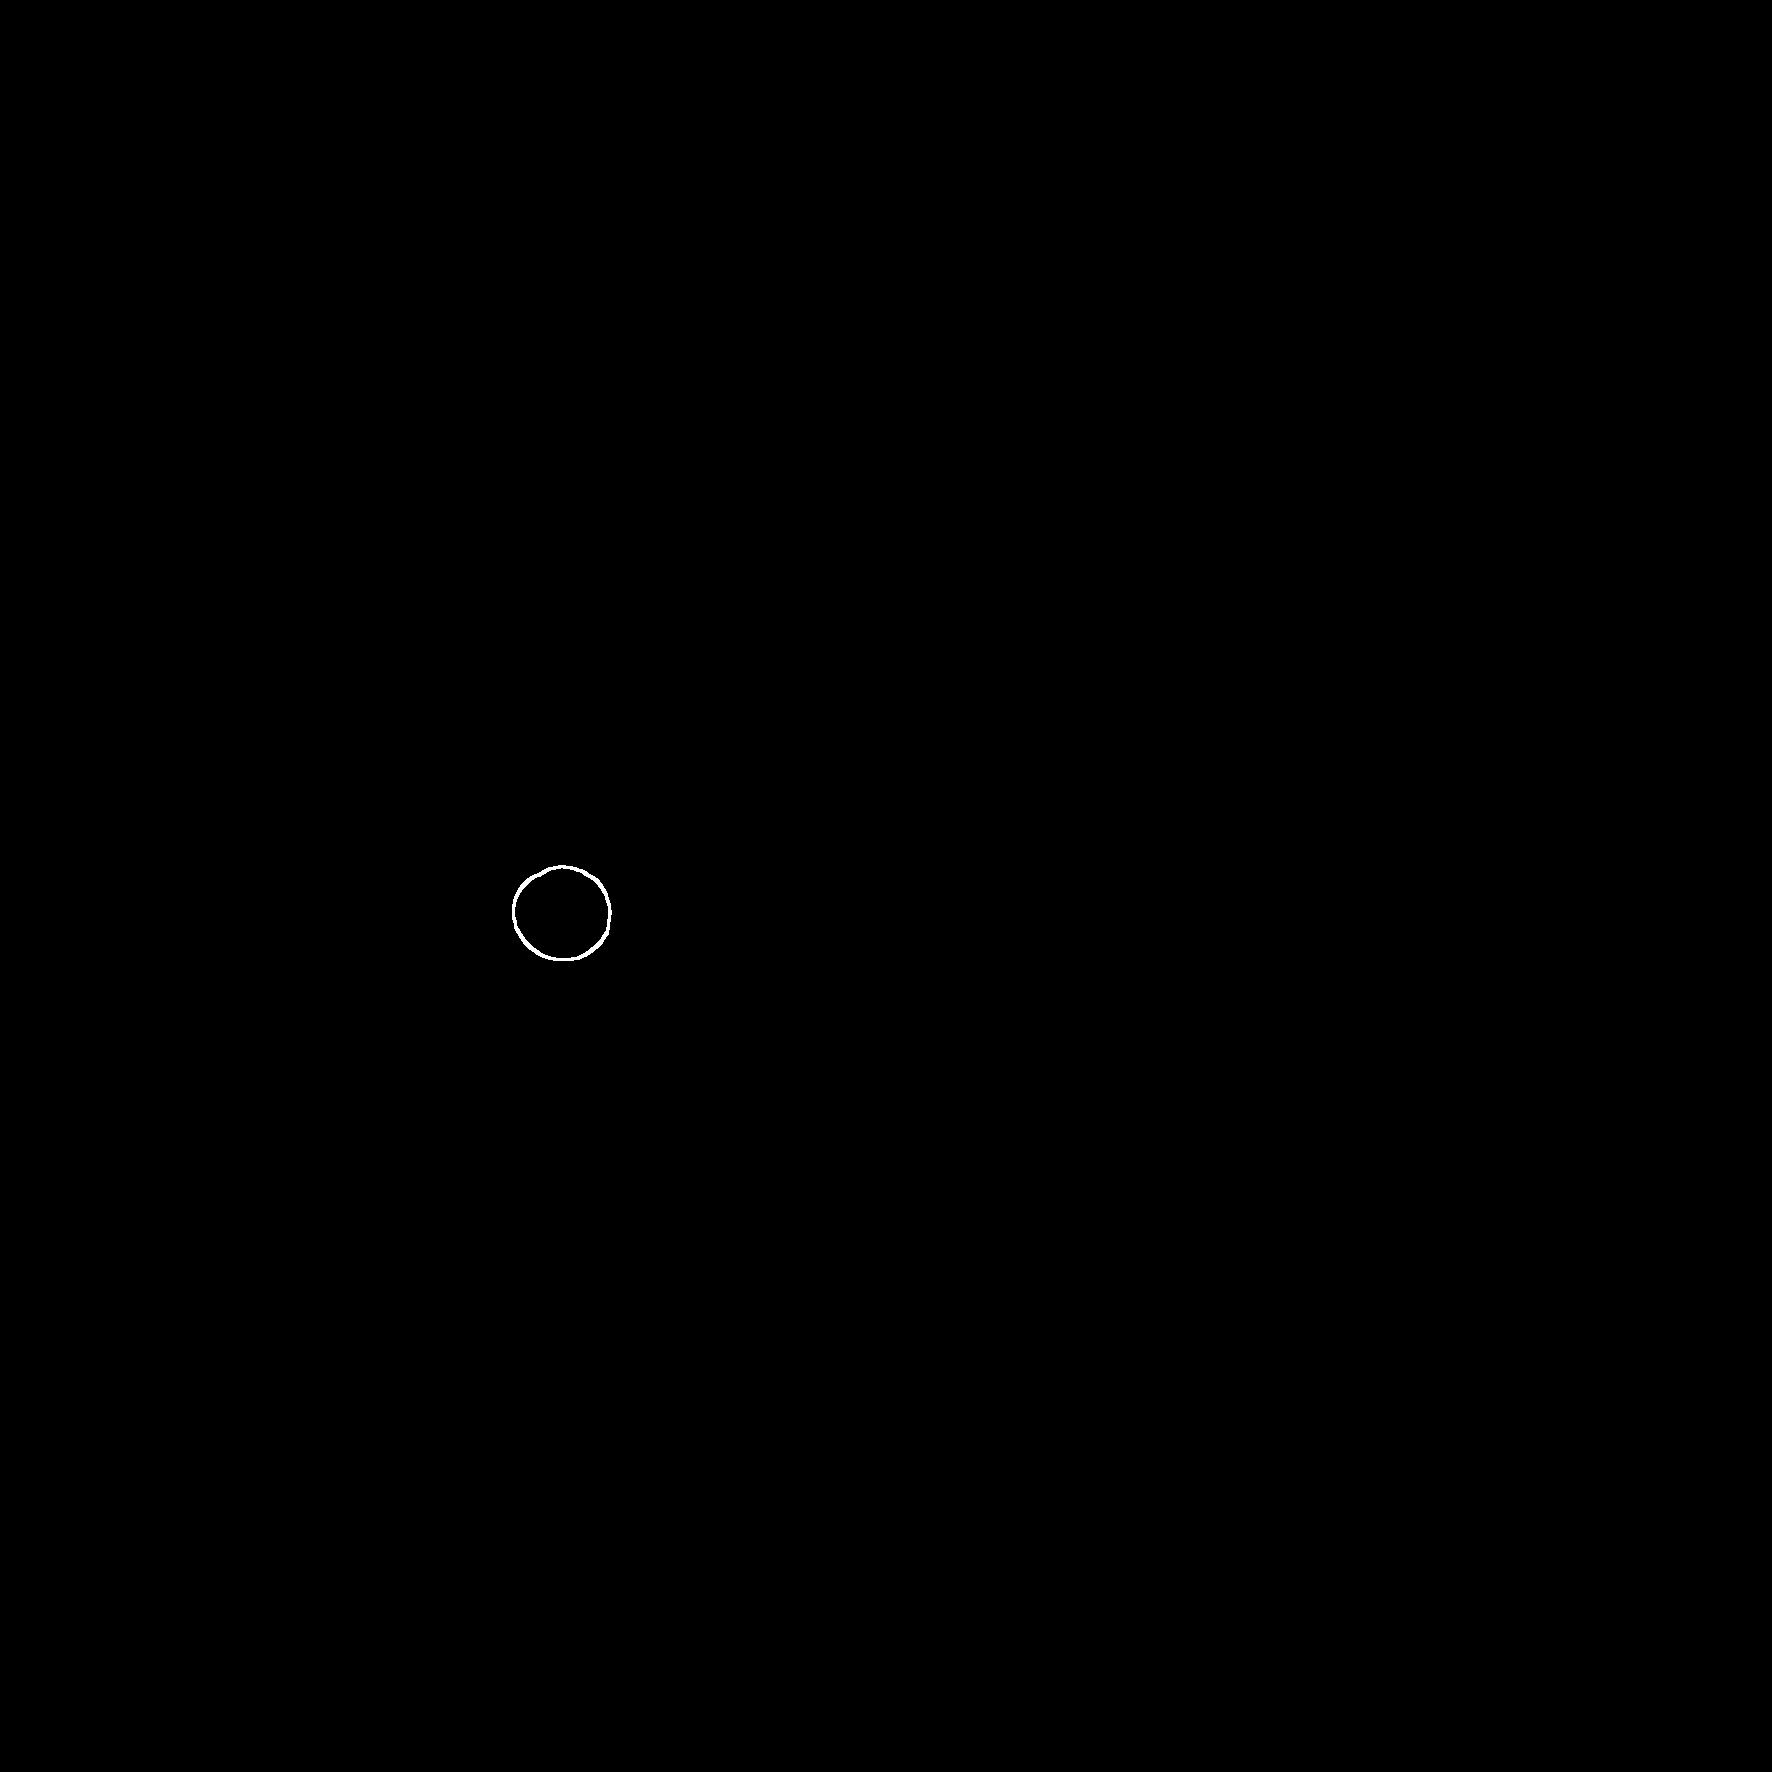

Liczba czarnych kropek: 1


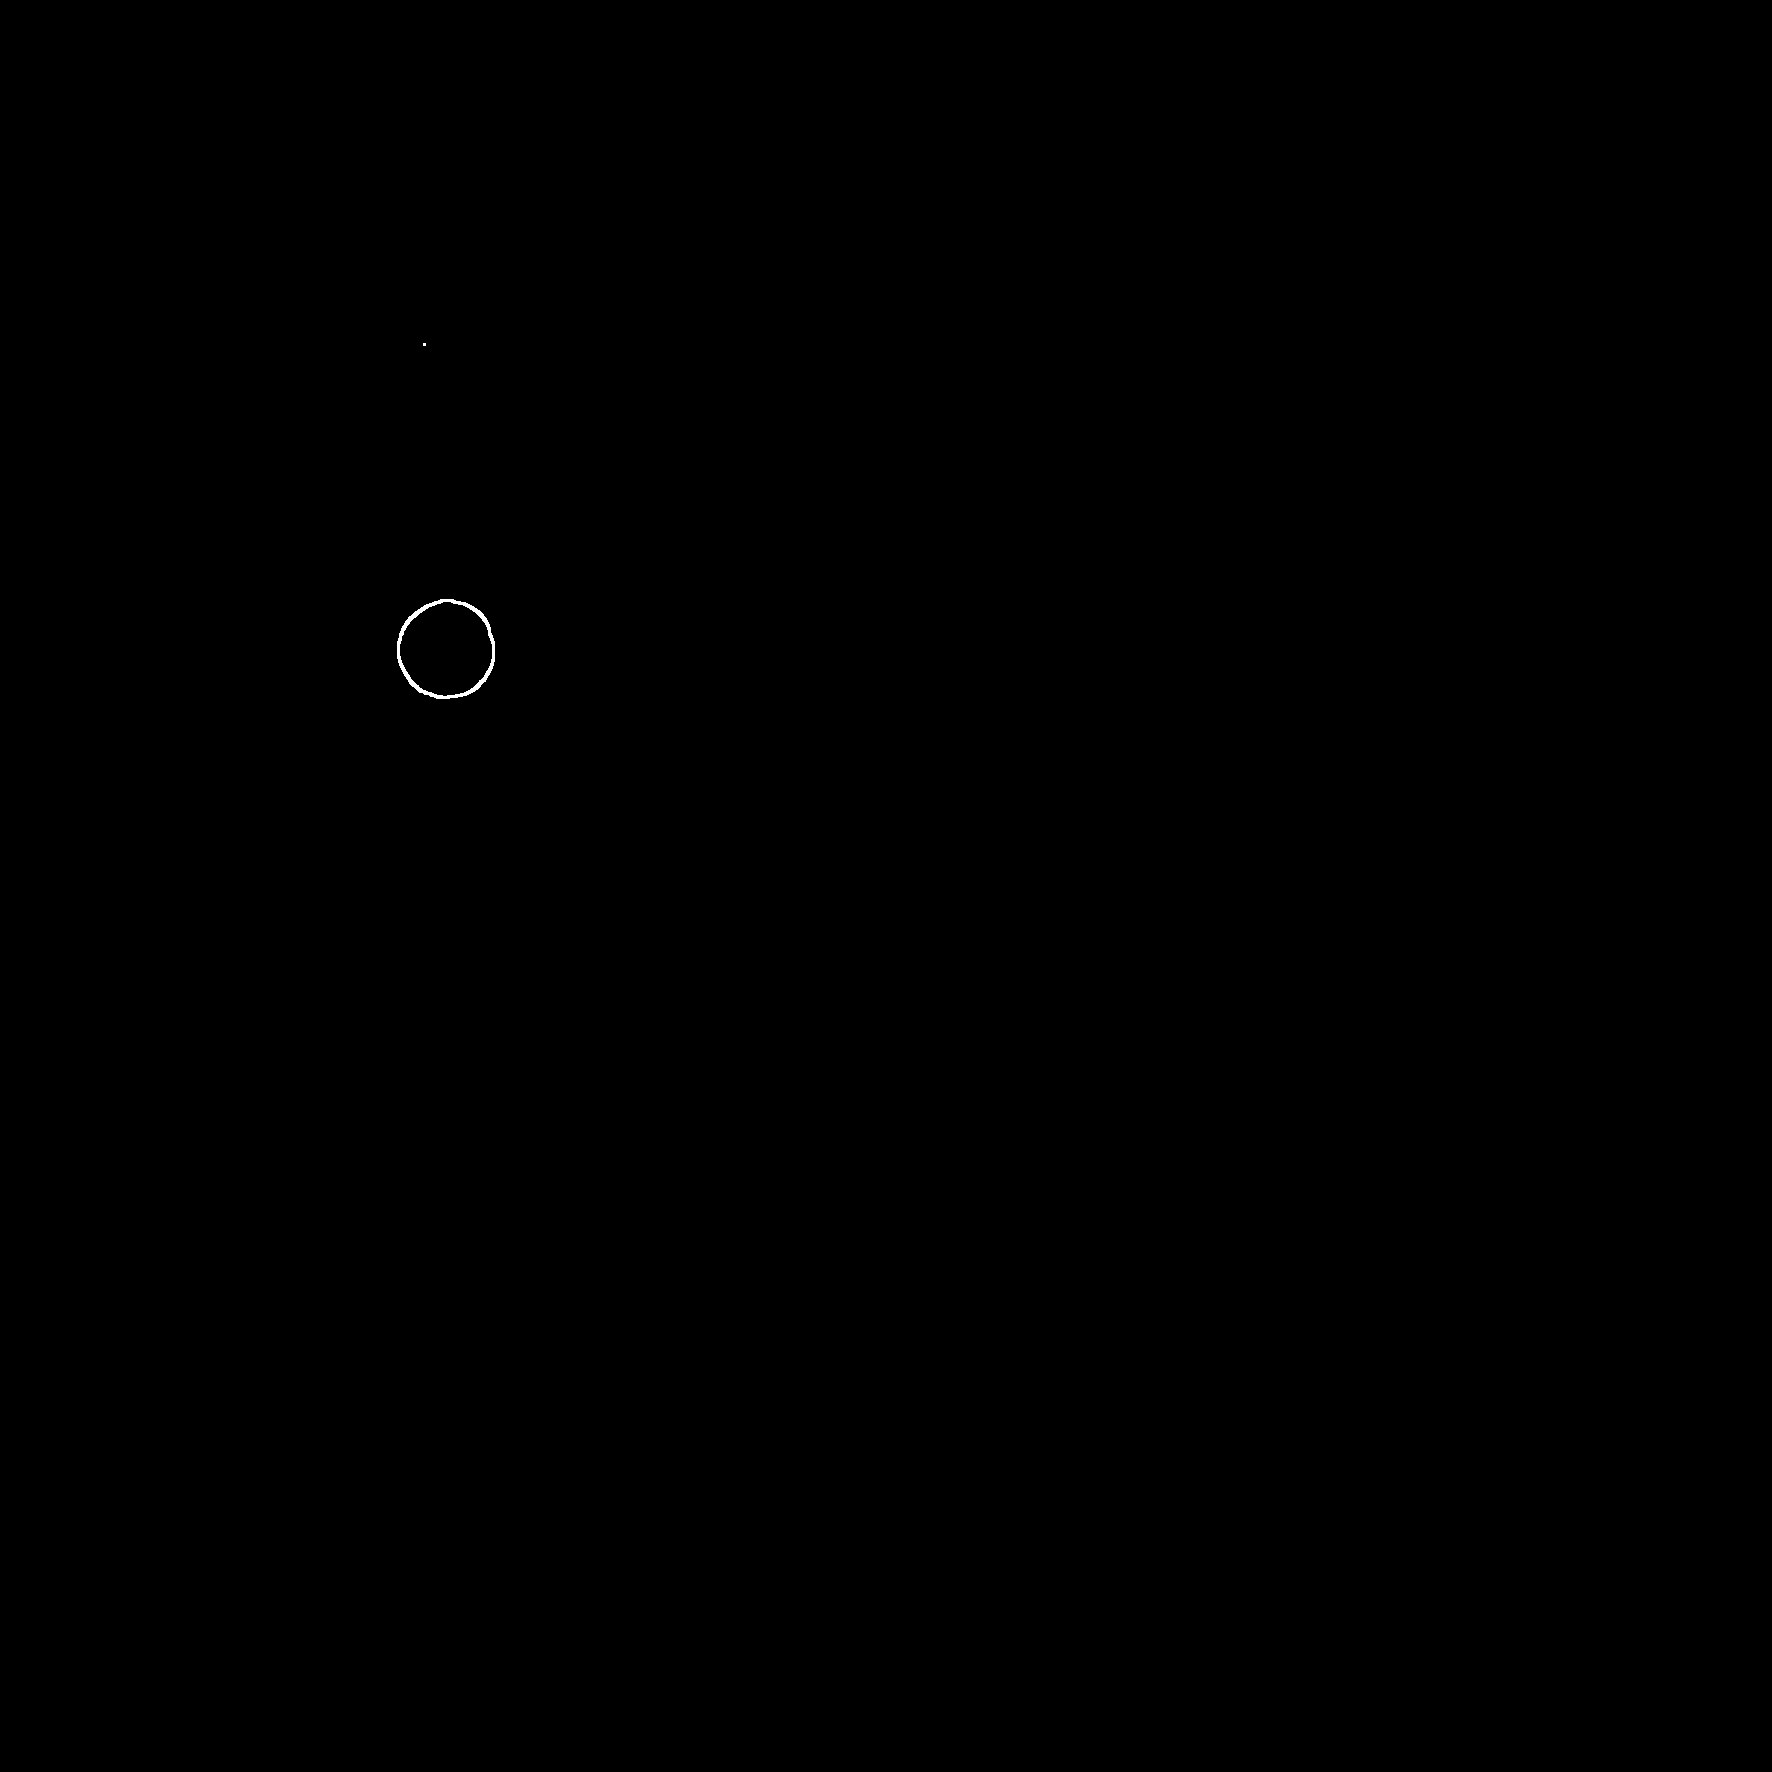

Liczba czarnych kropek: 1


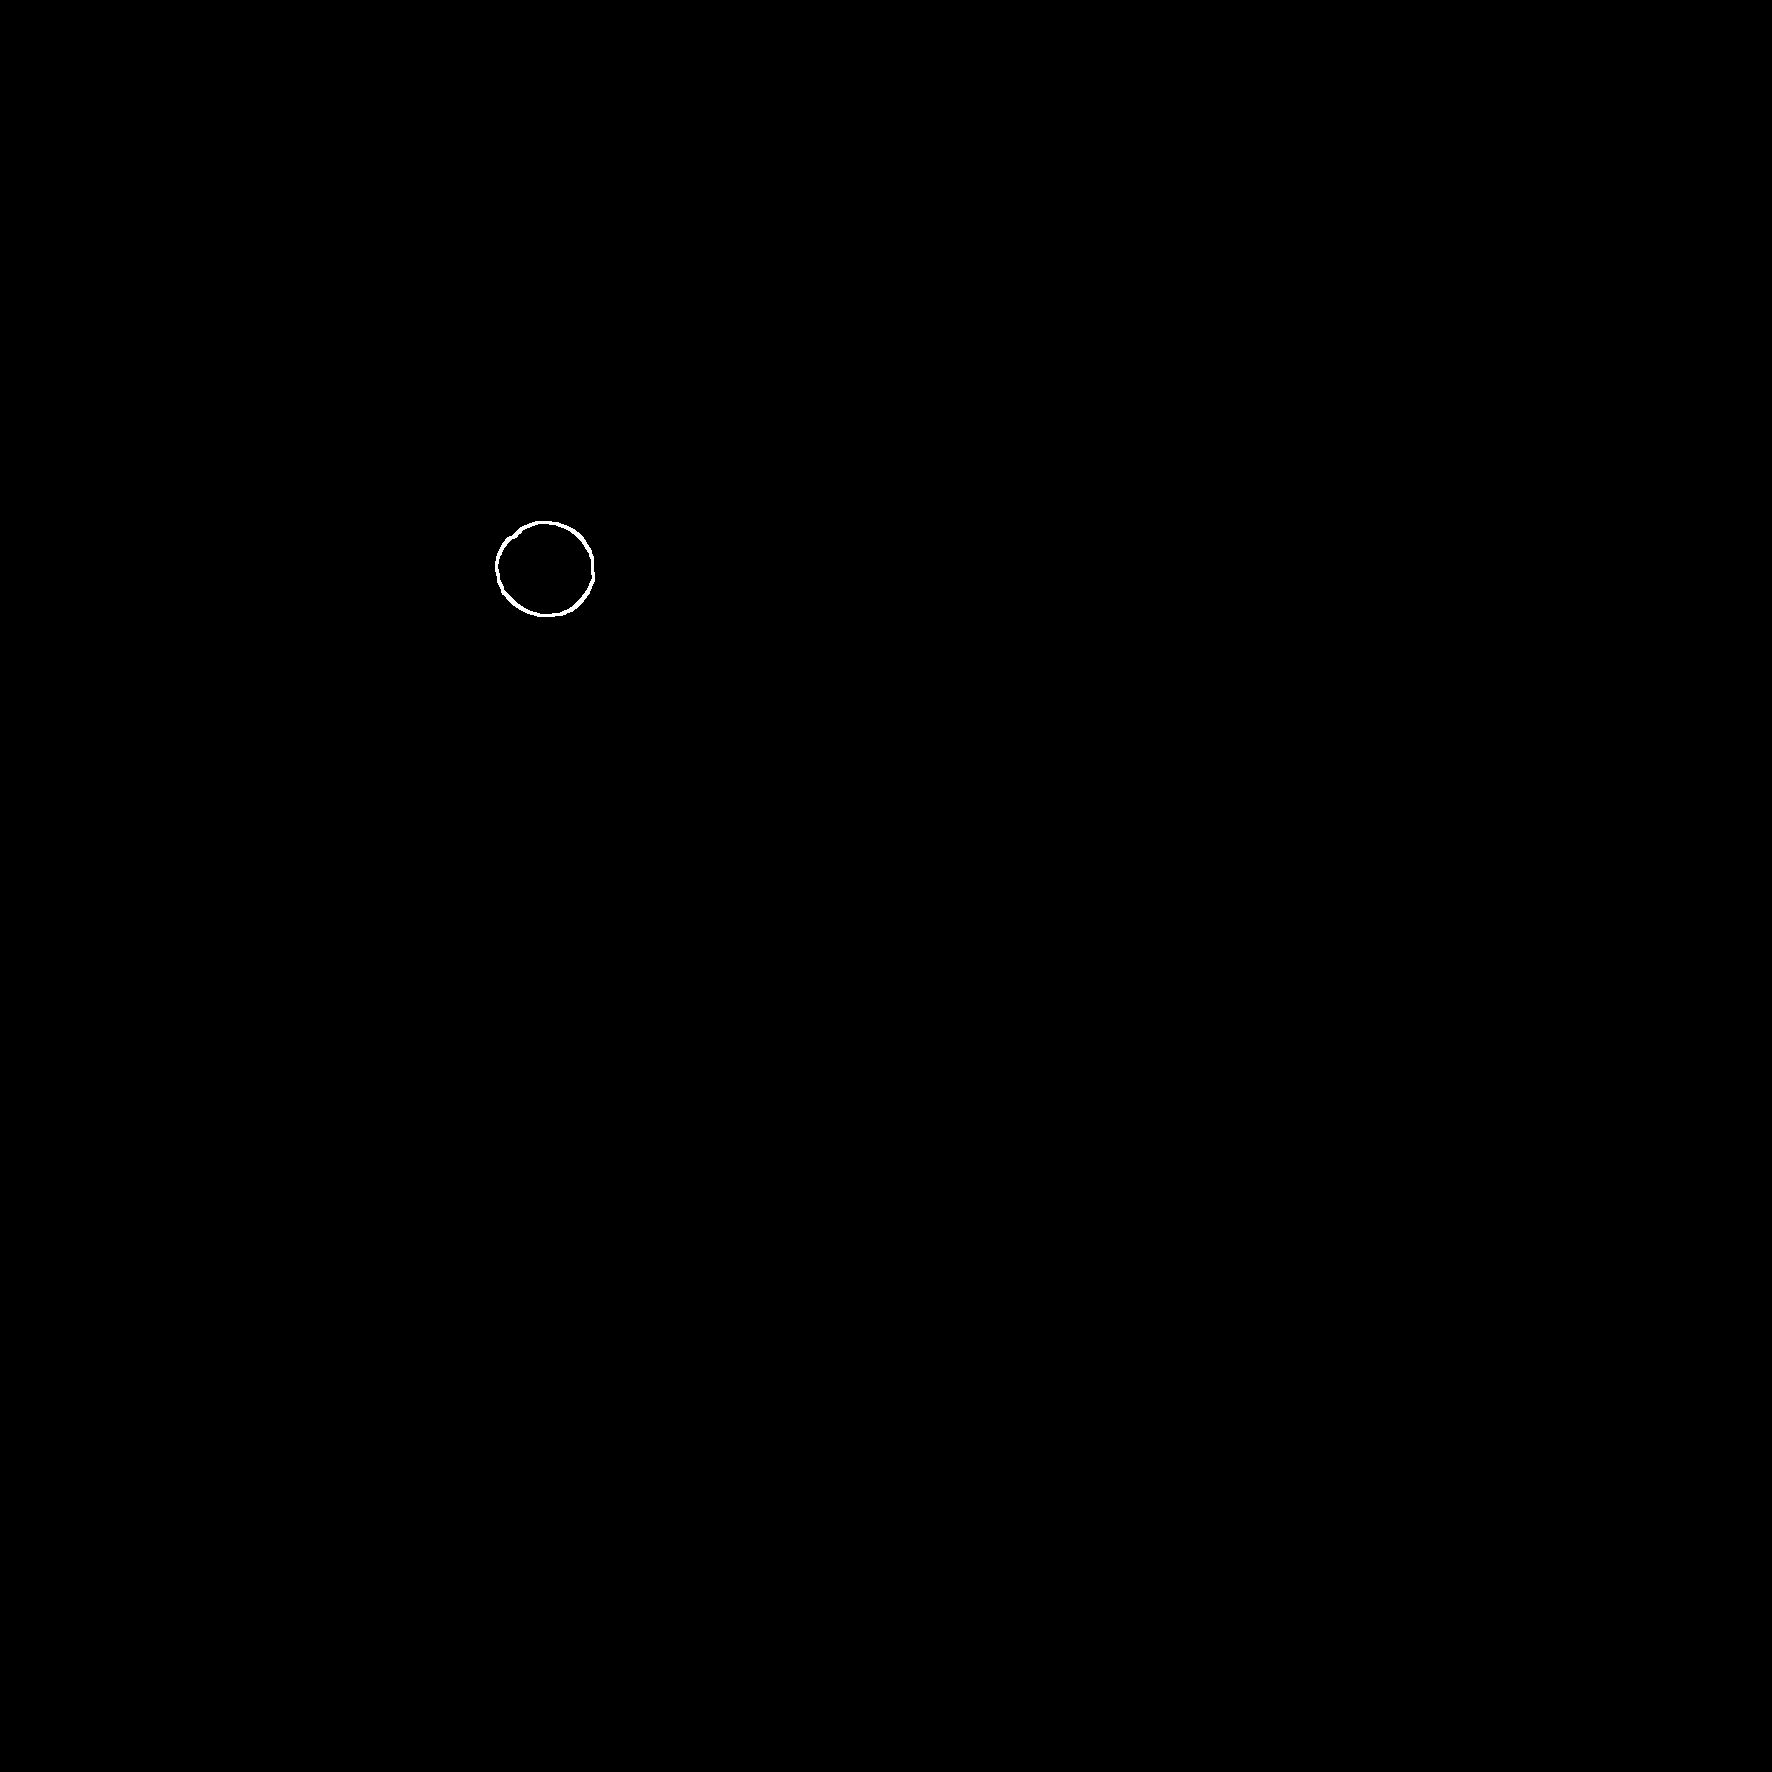

Liczba czarnych kropek: 1


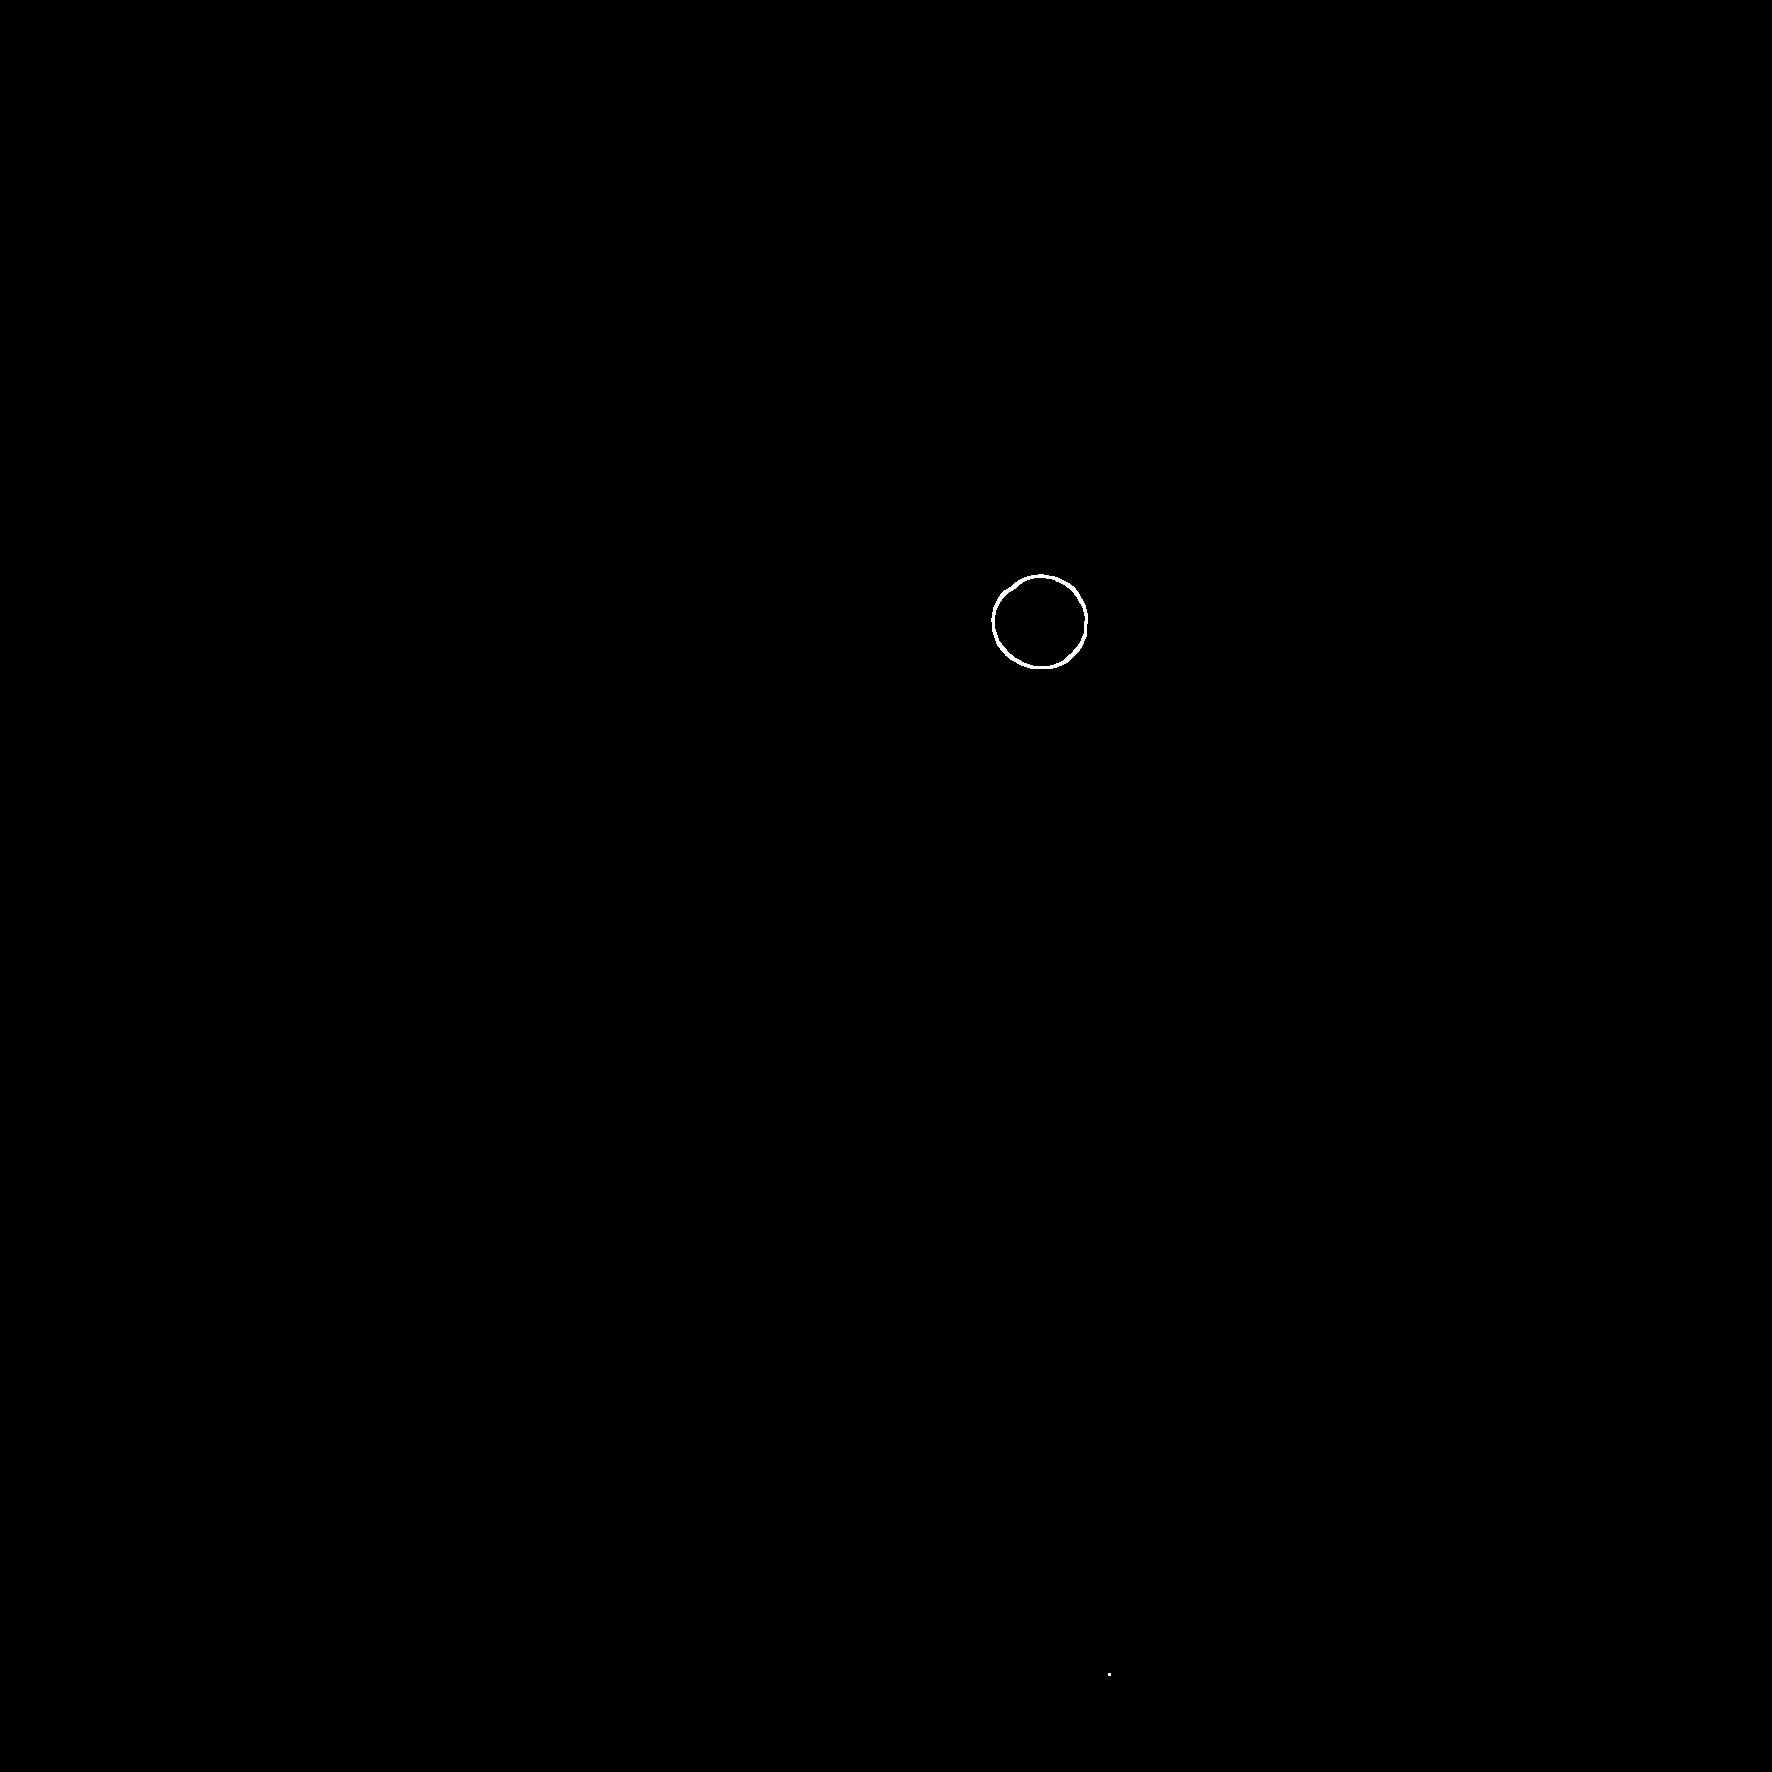

Liczba czarnych kropek: 1


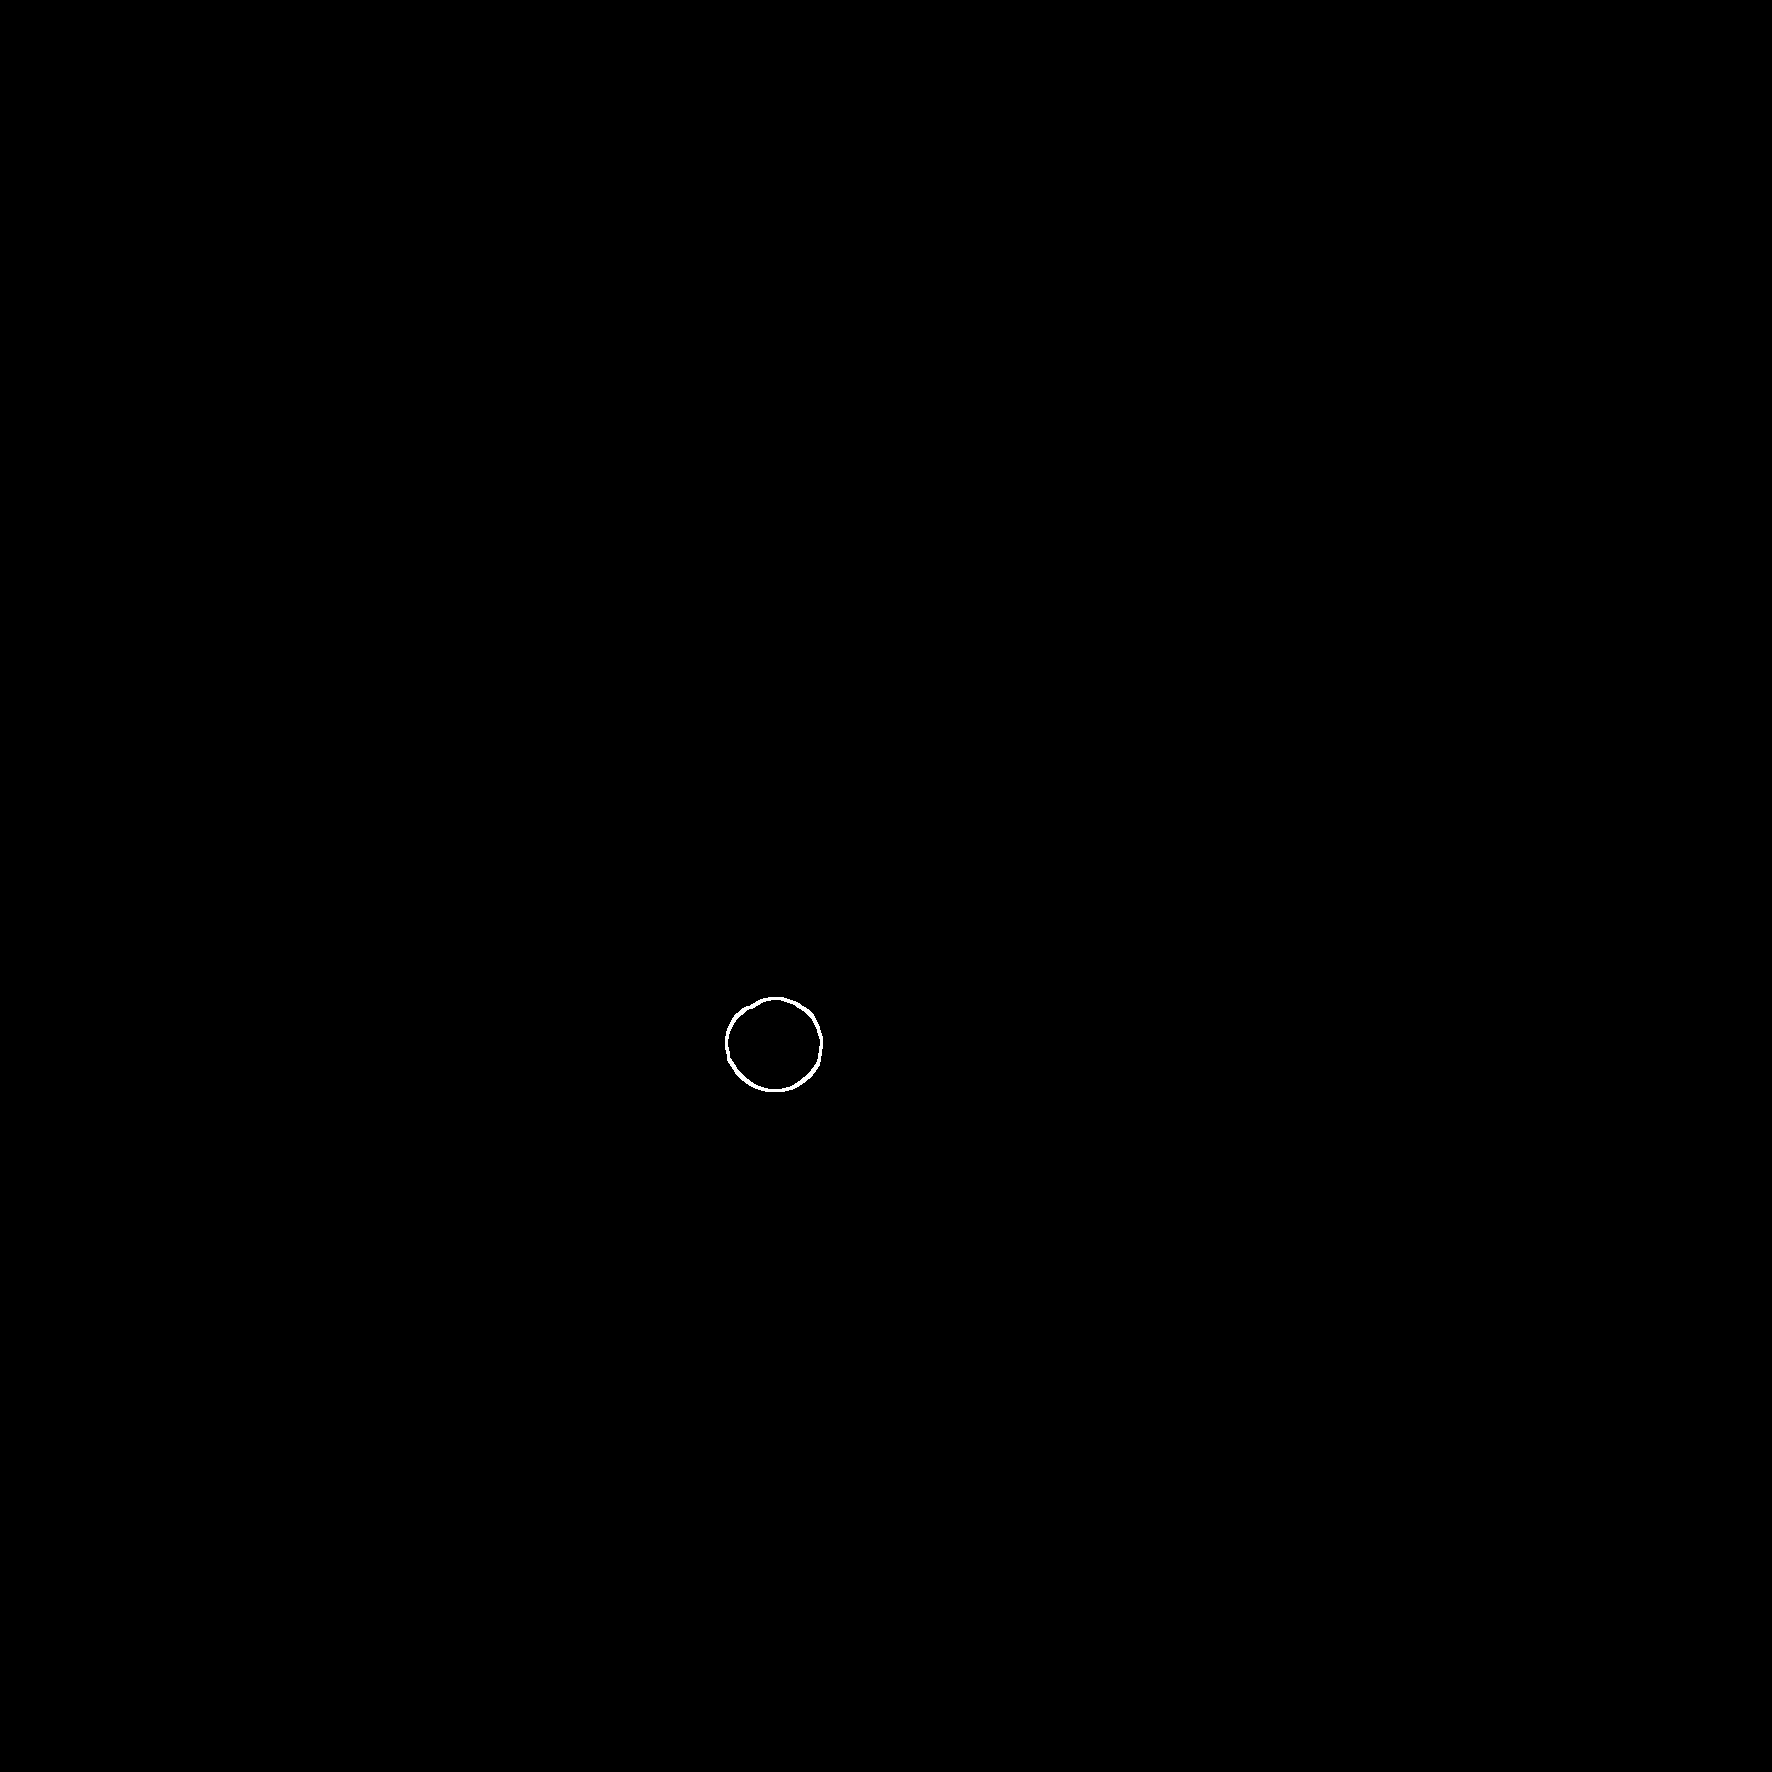

Liczba czarnych kropek: 1


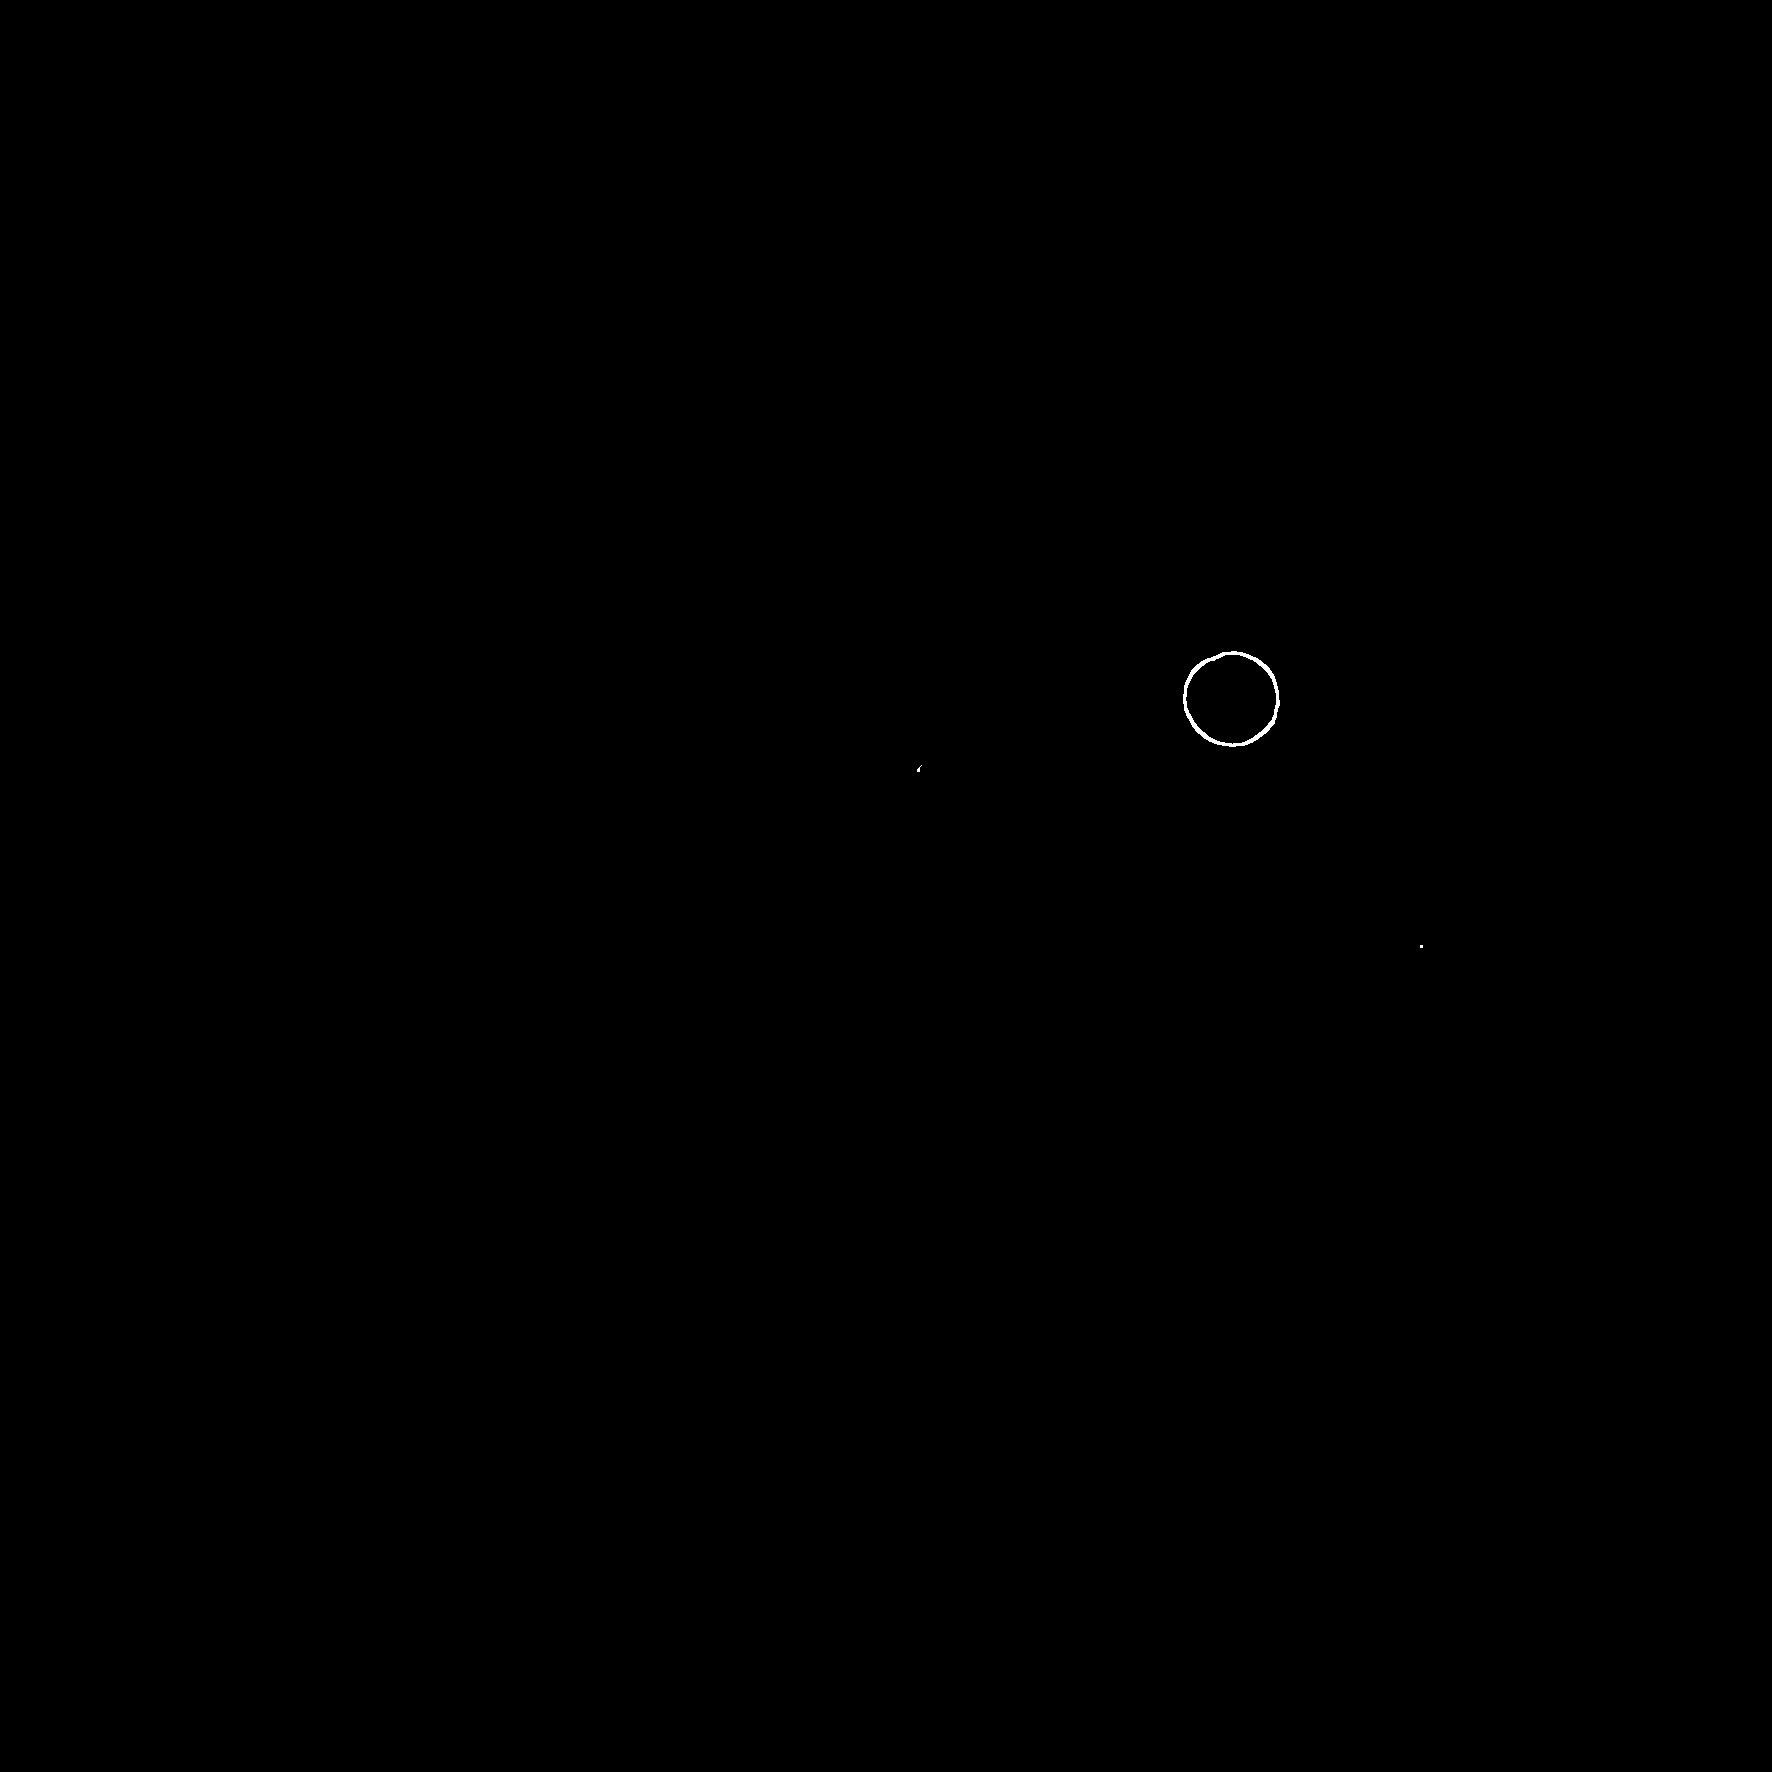

Liczba czarnych kropek: 1


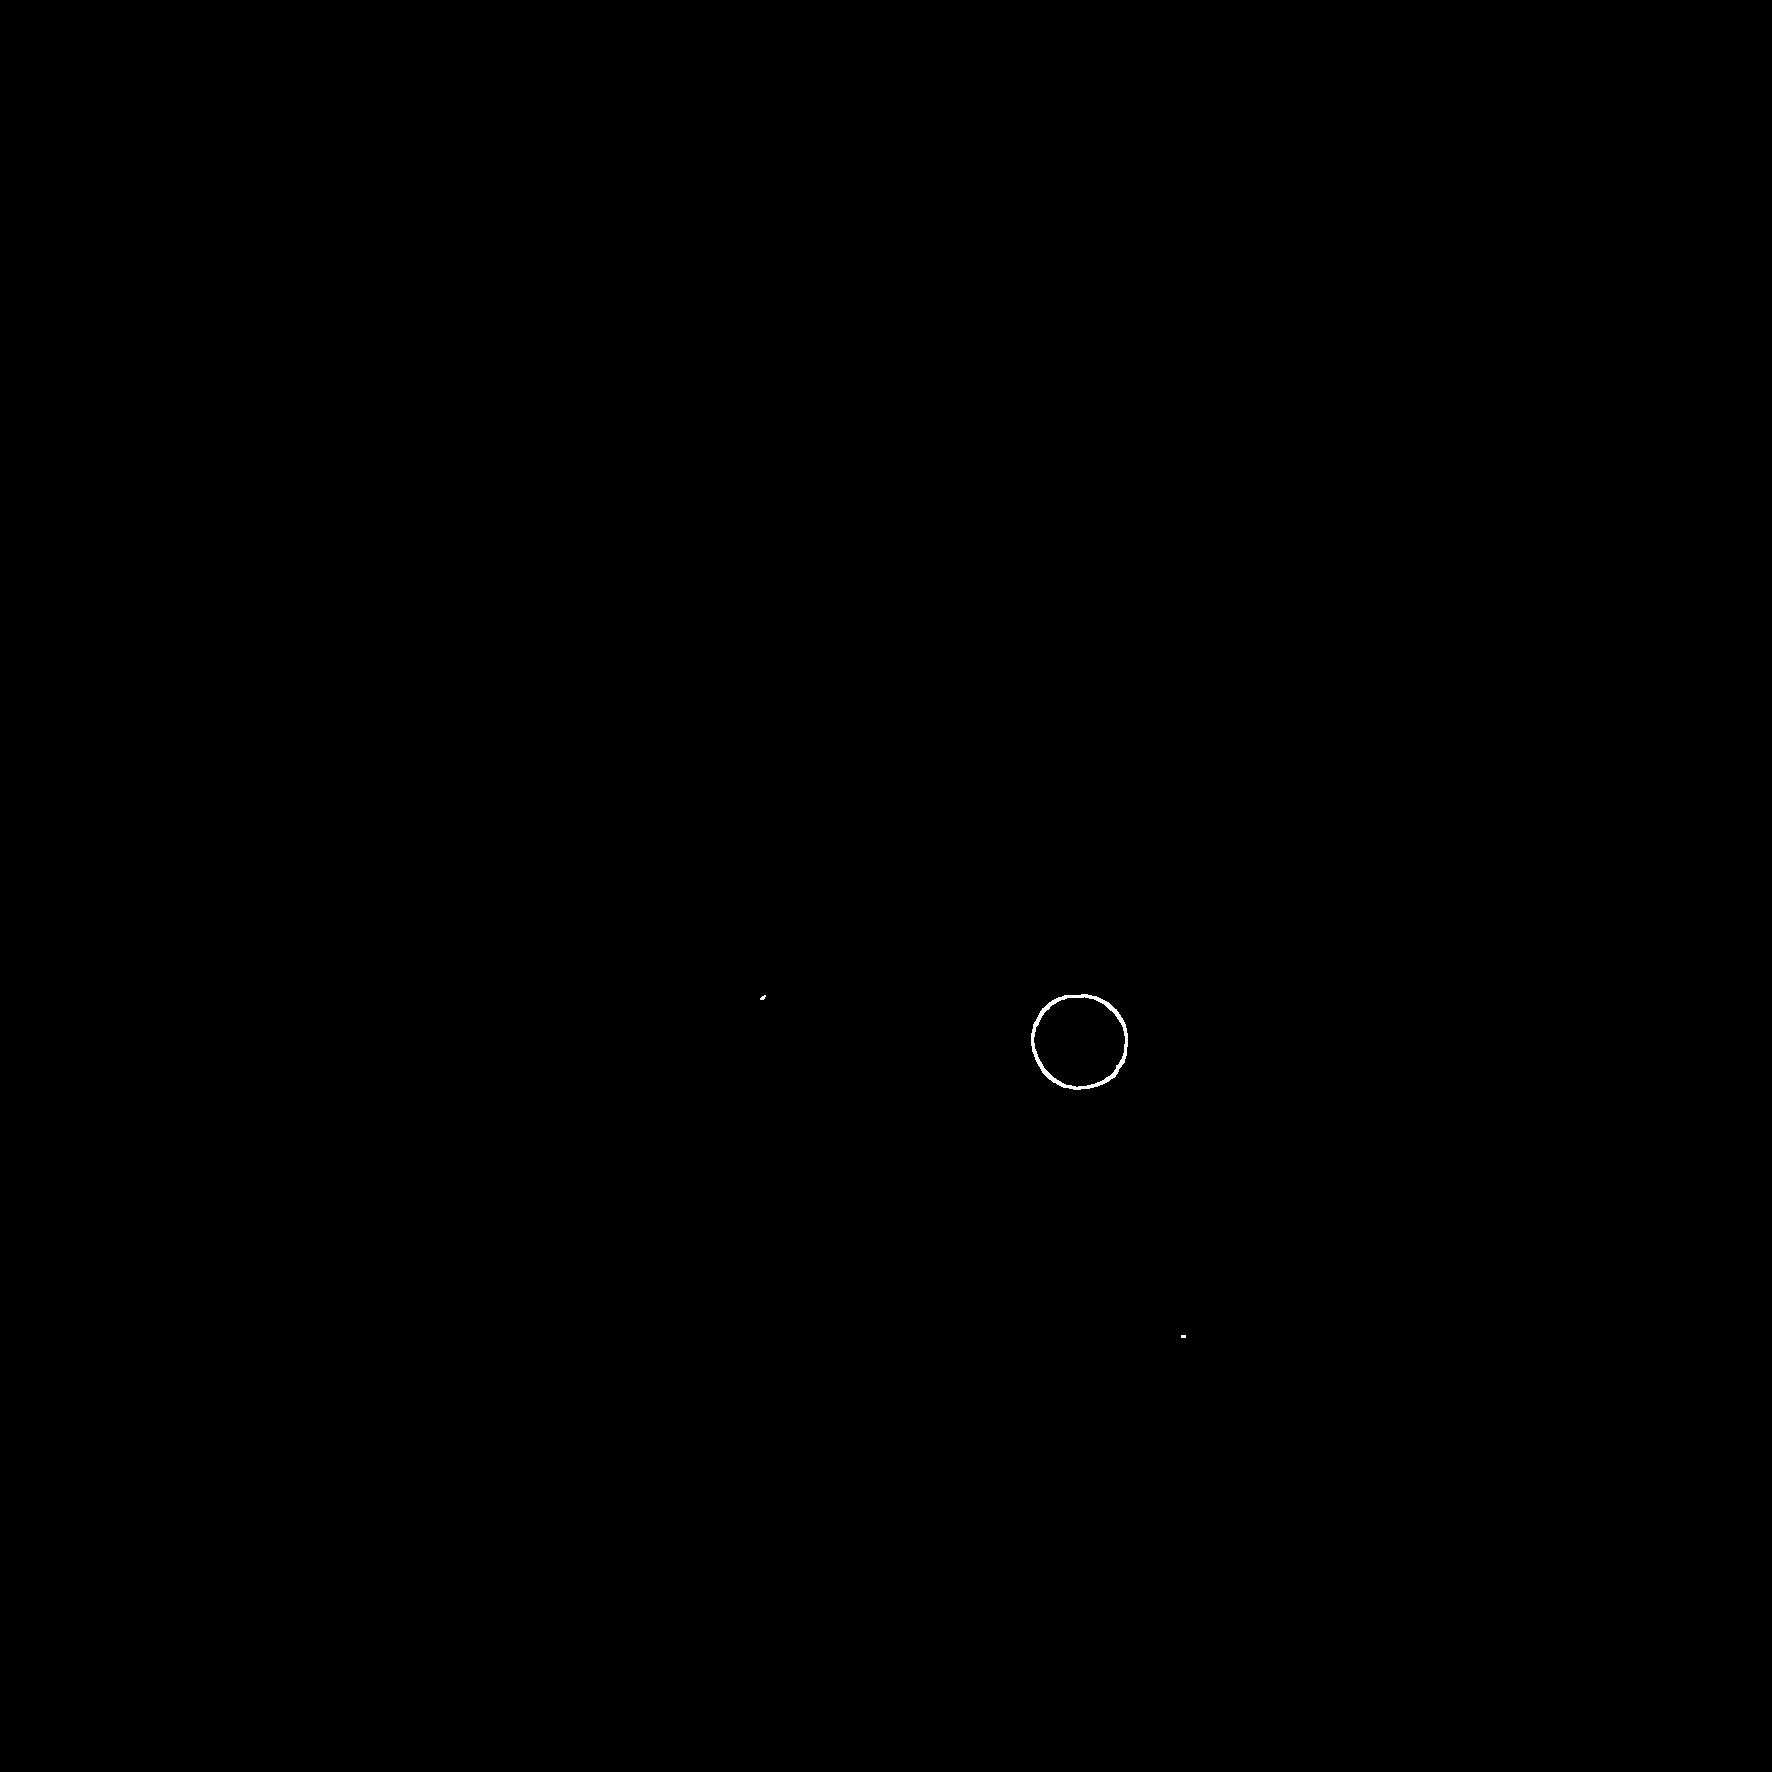

Liczba czarnych kropek: 1


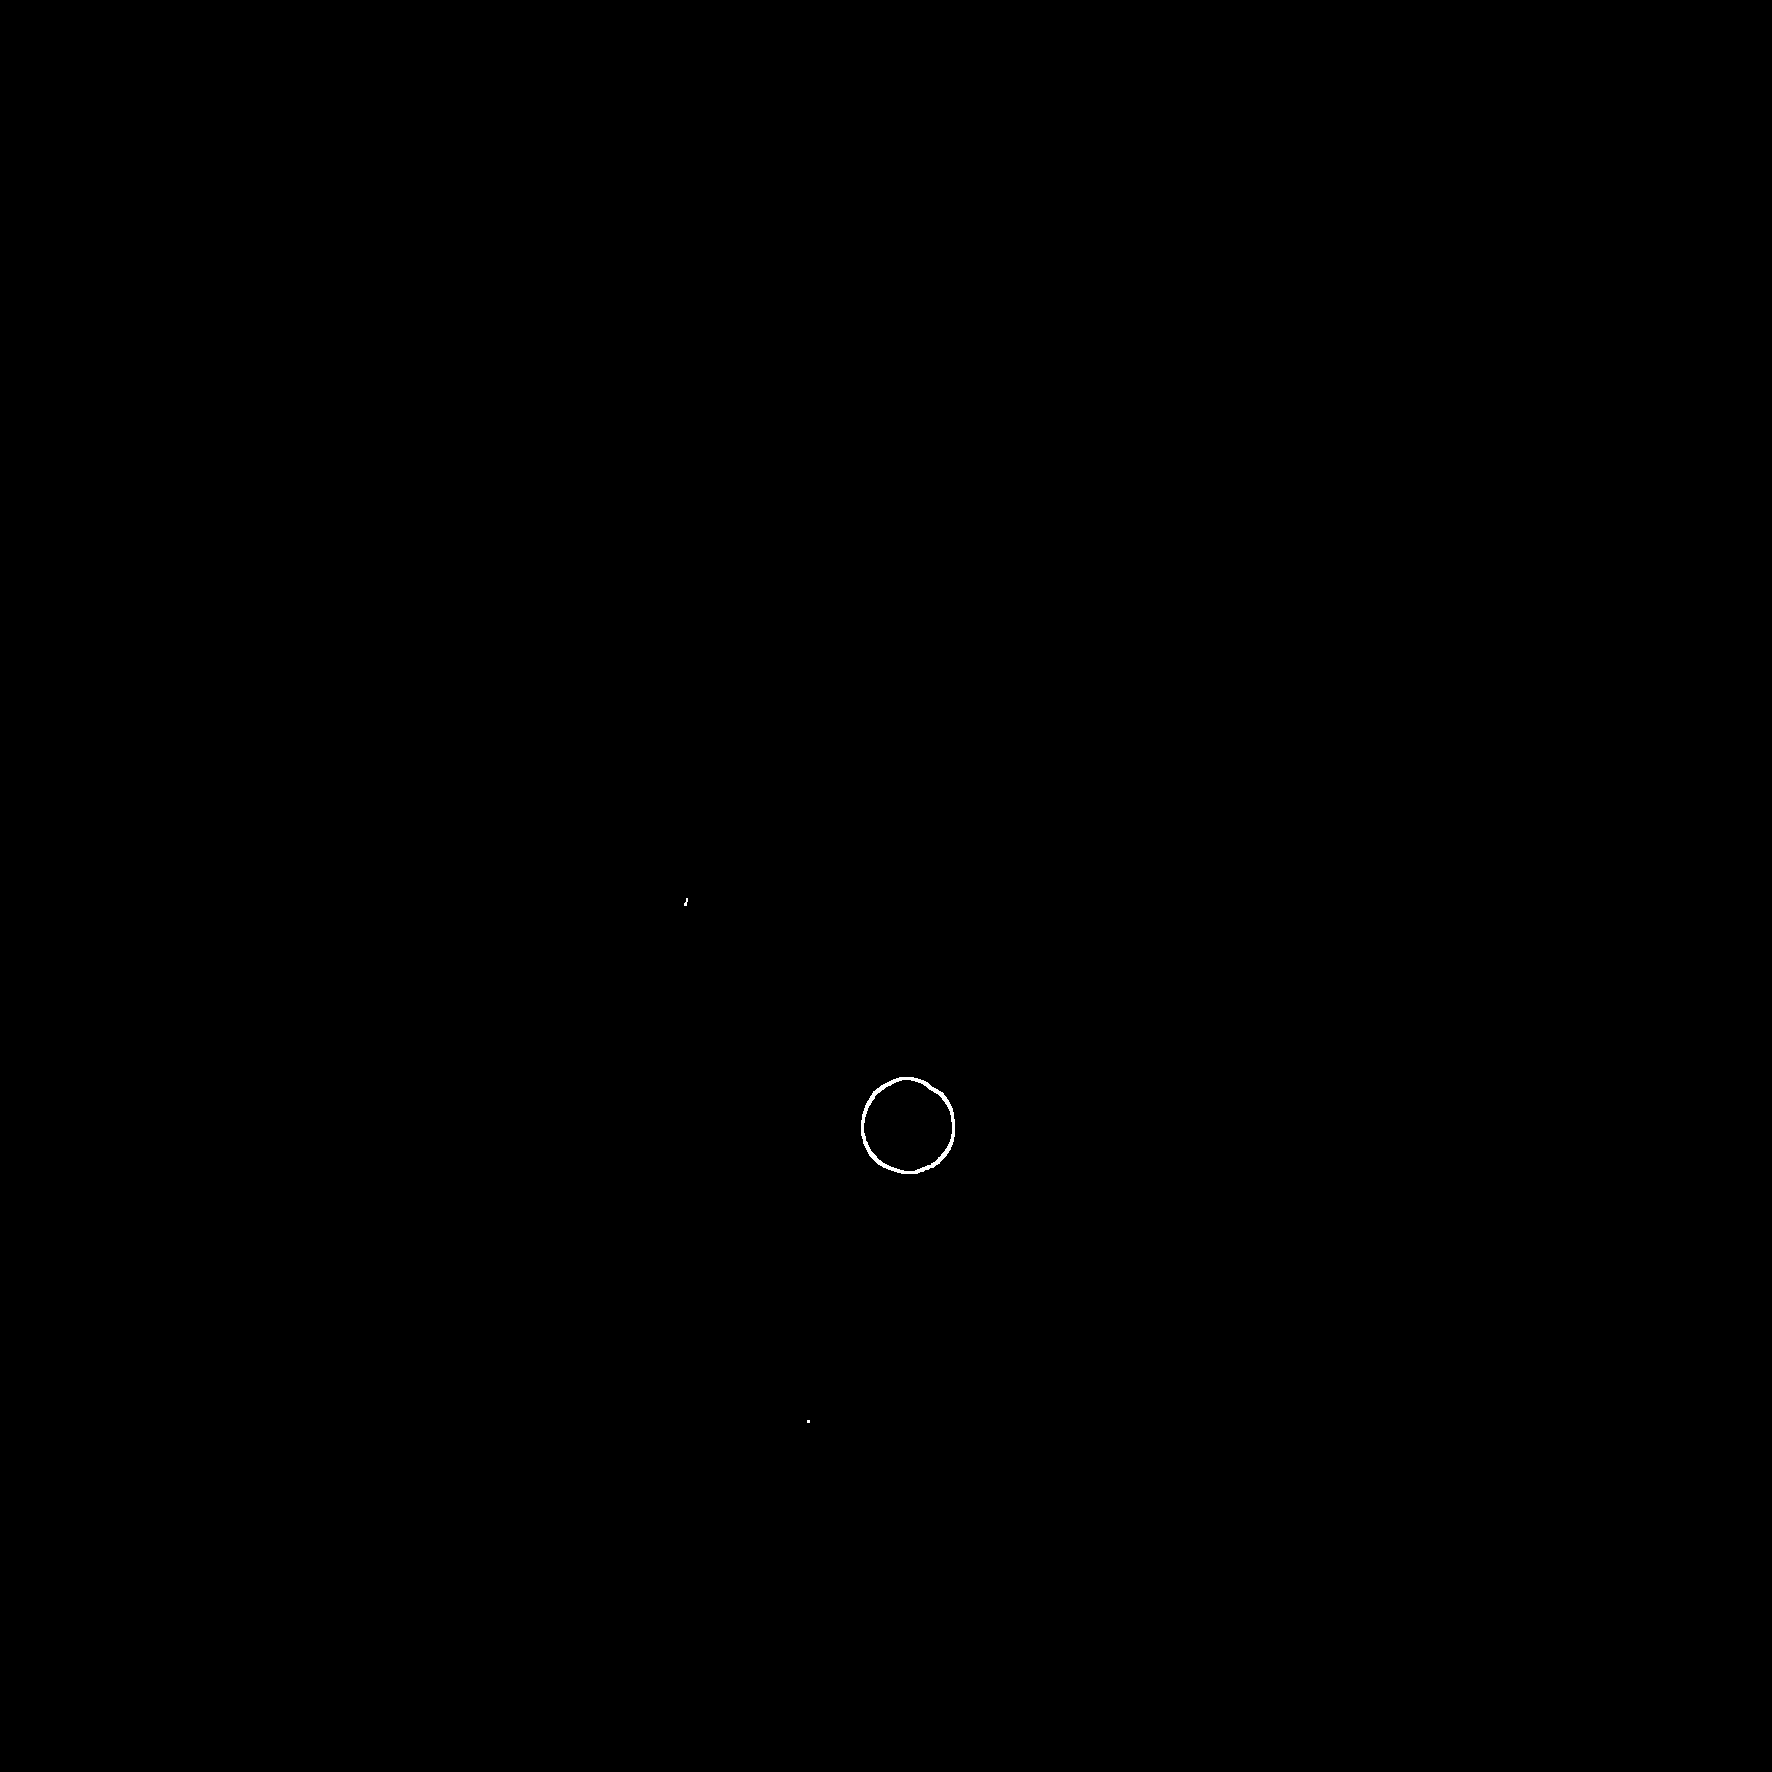

Liczba czarnych kropek: 1


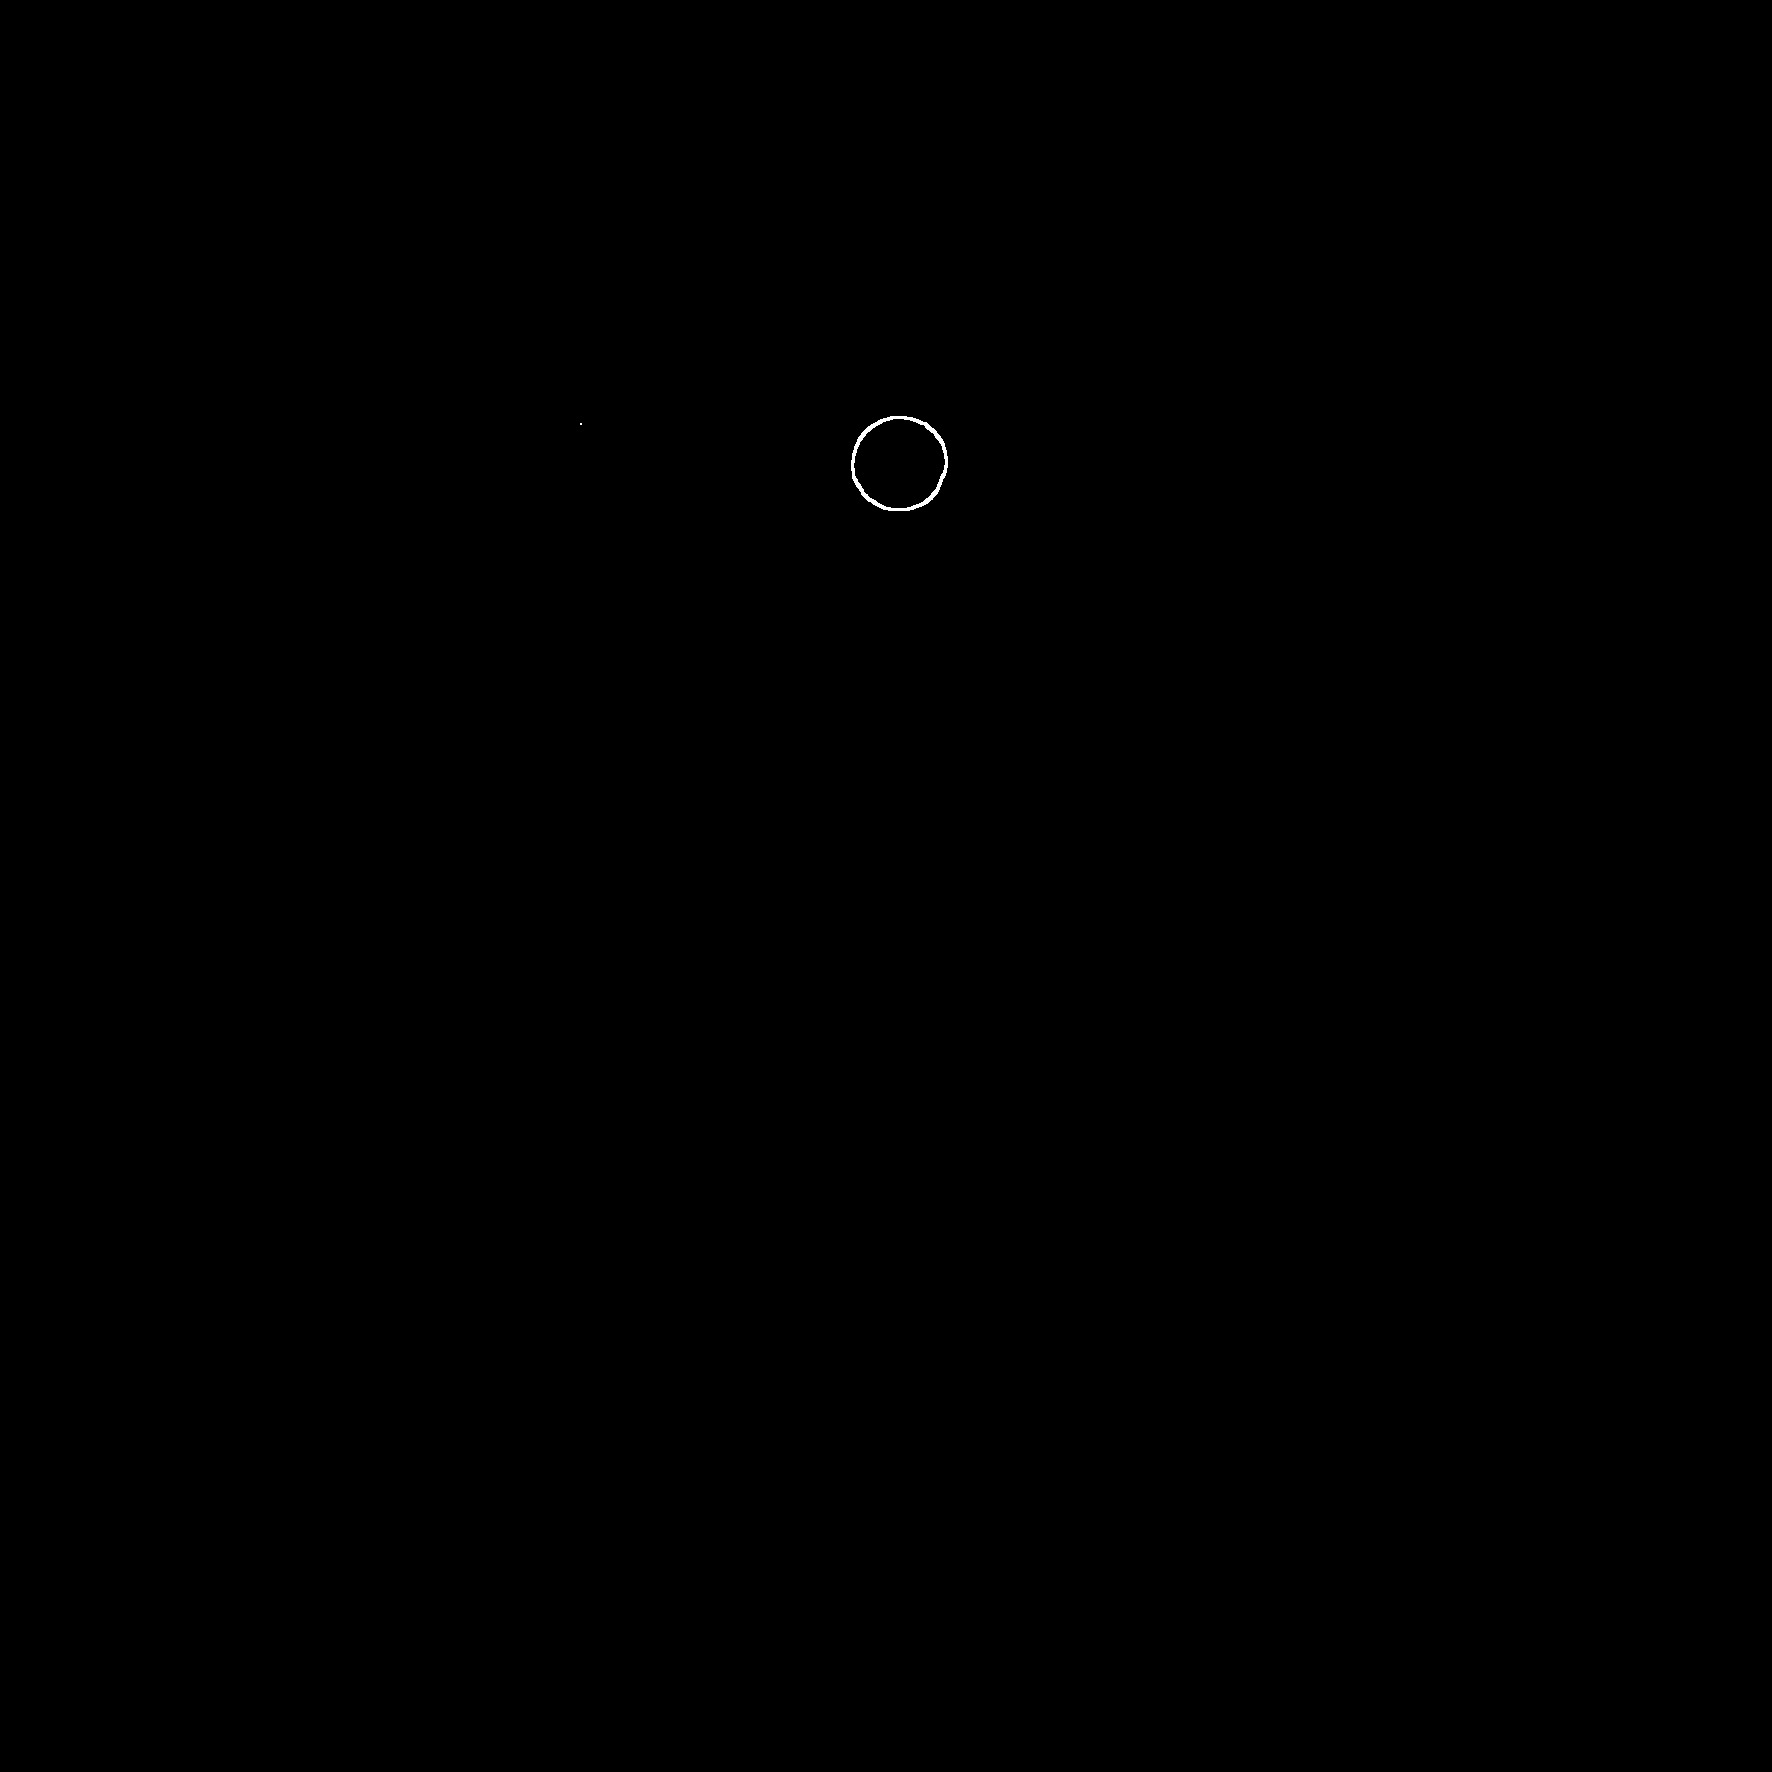

Liczba czarnych kropek: 1


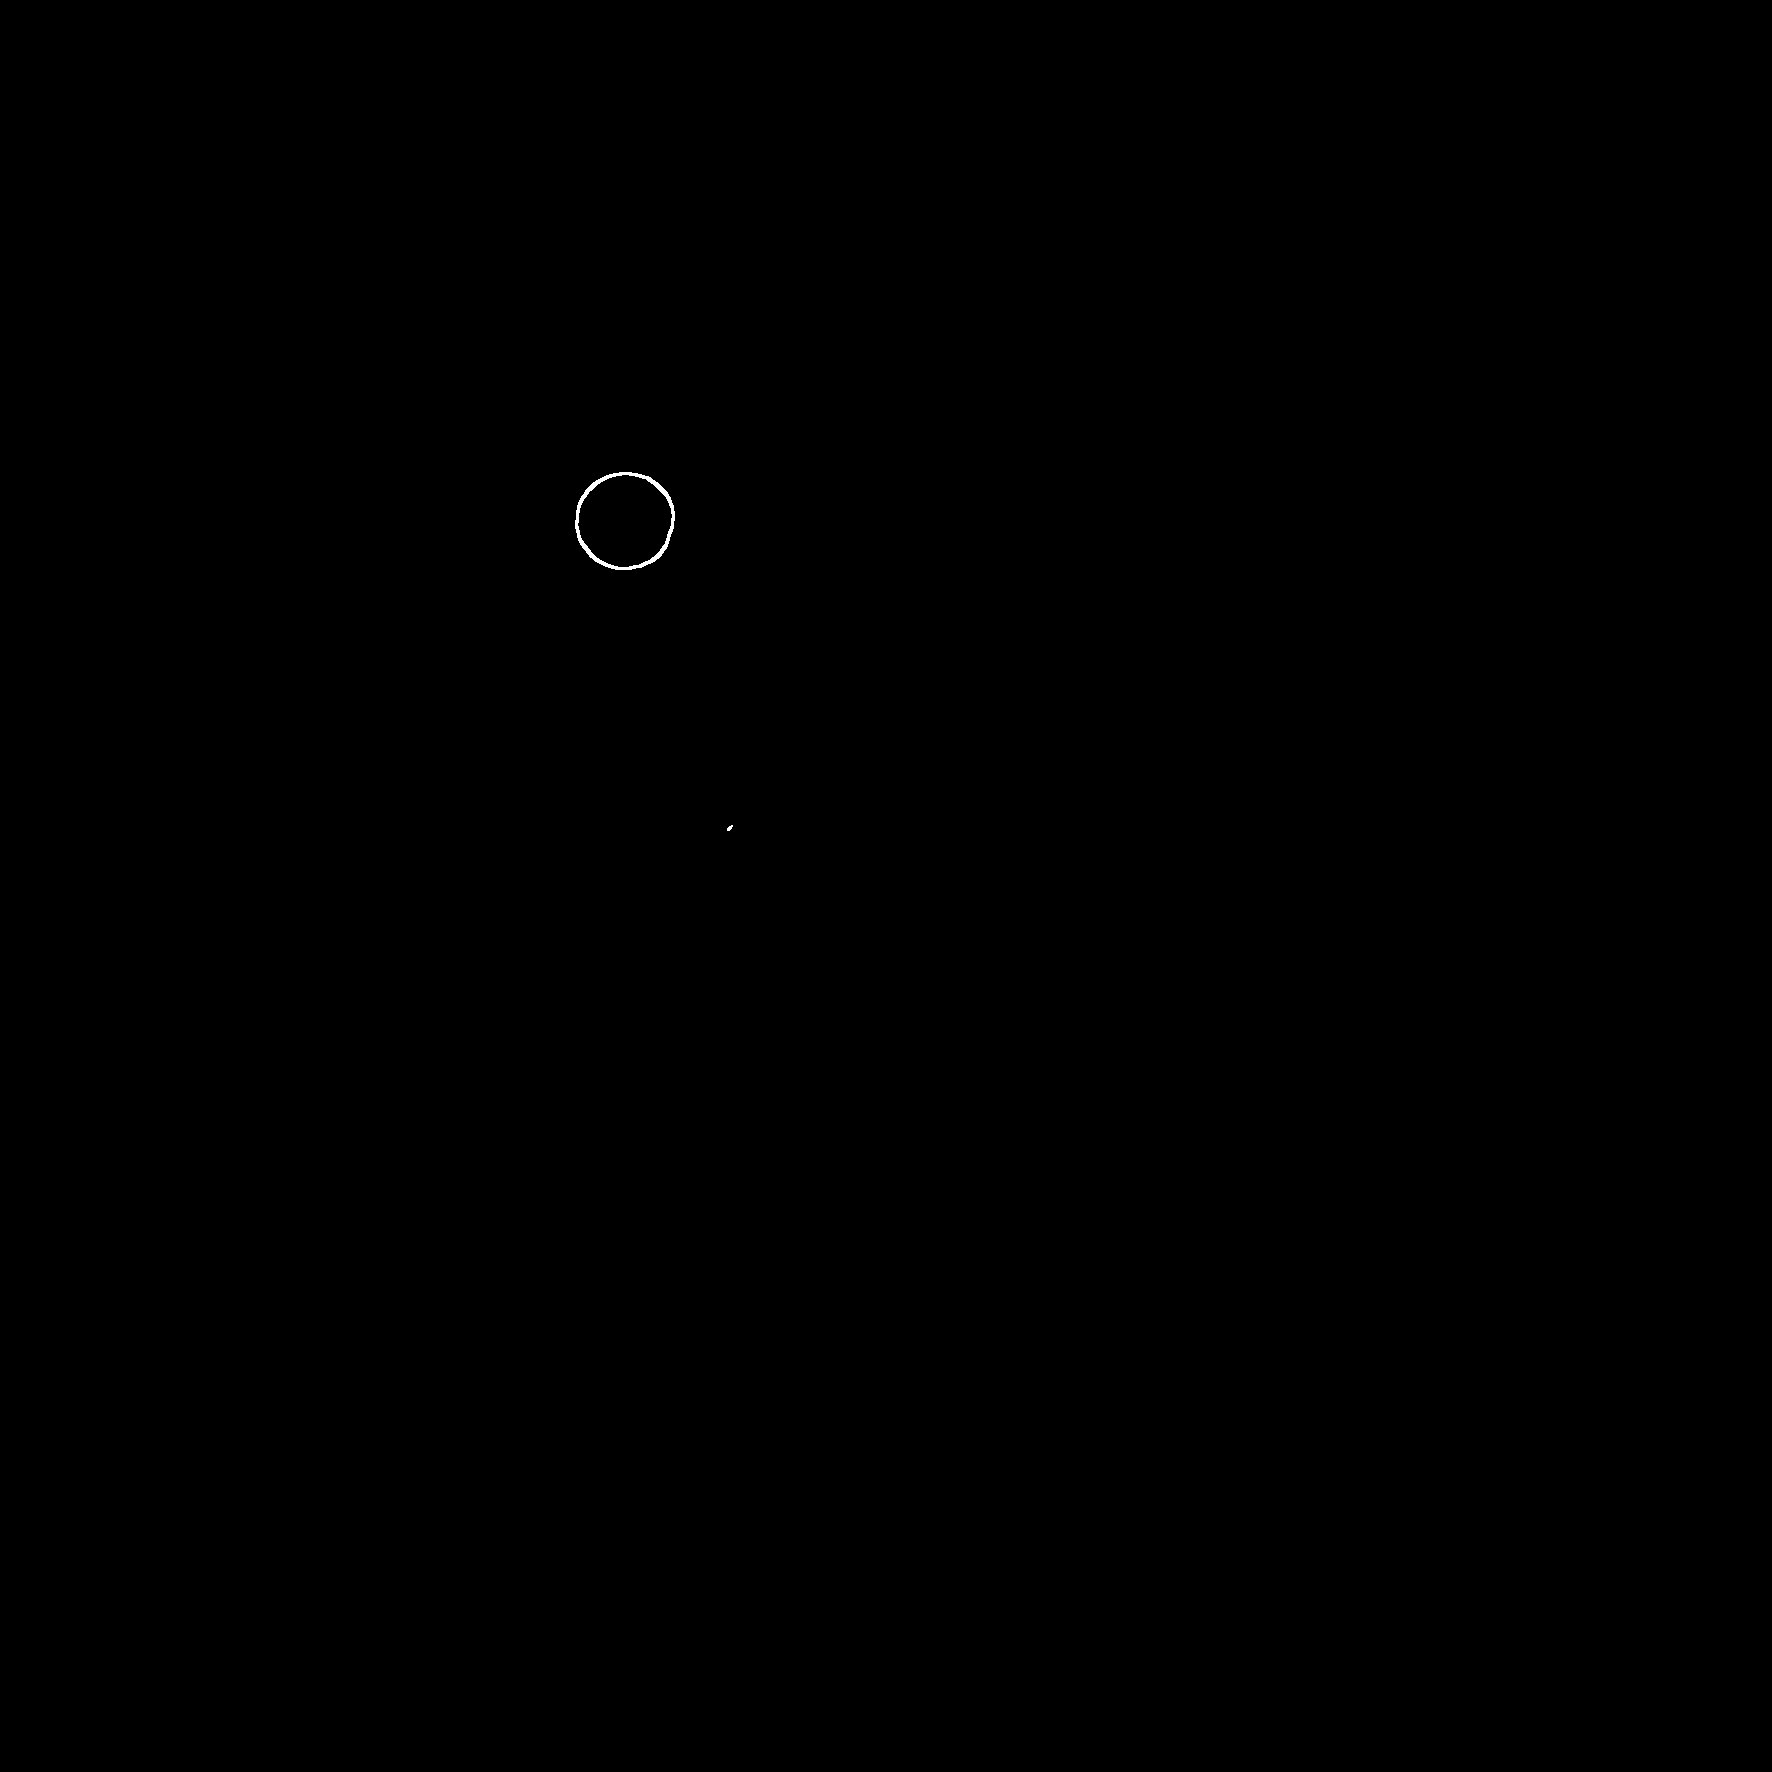

Liczba czarnych kropek: 1


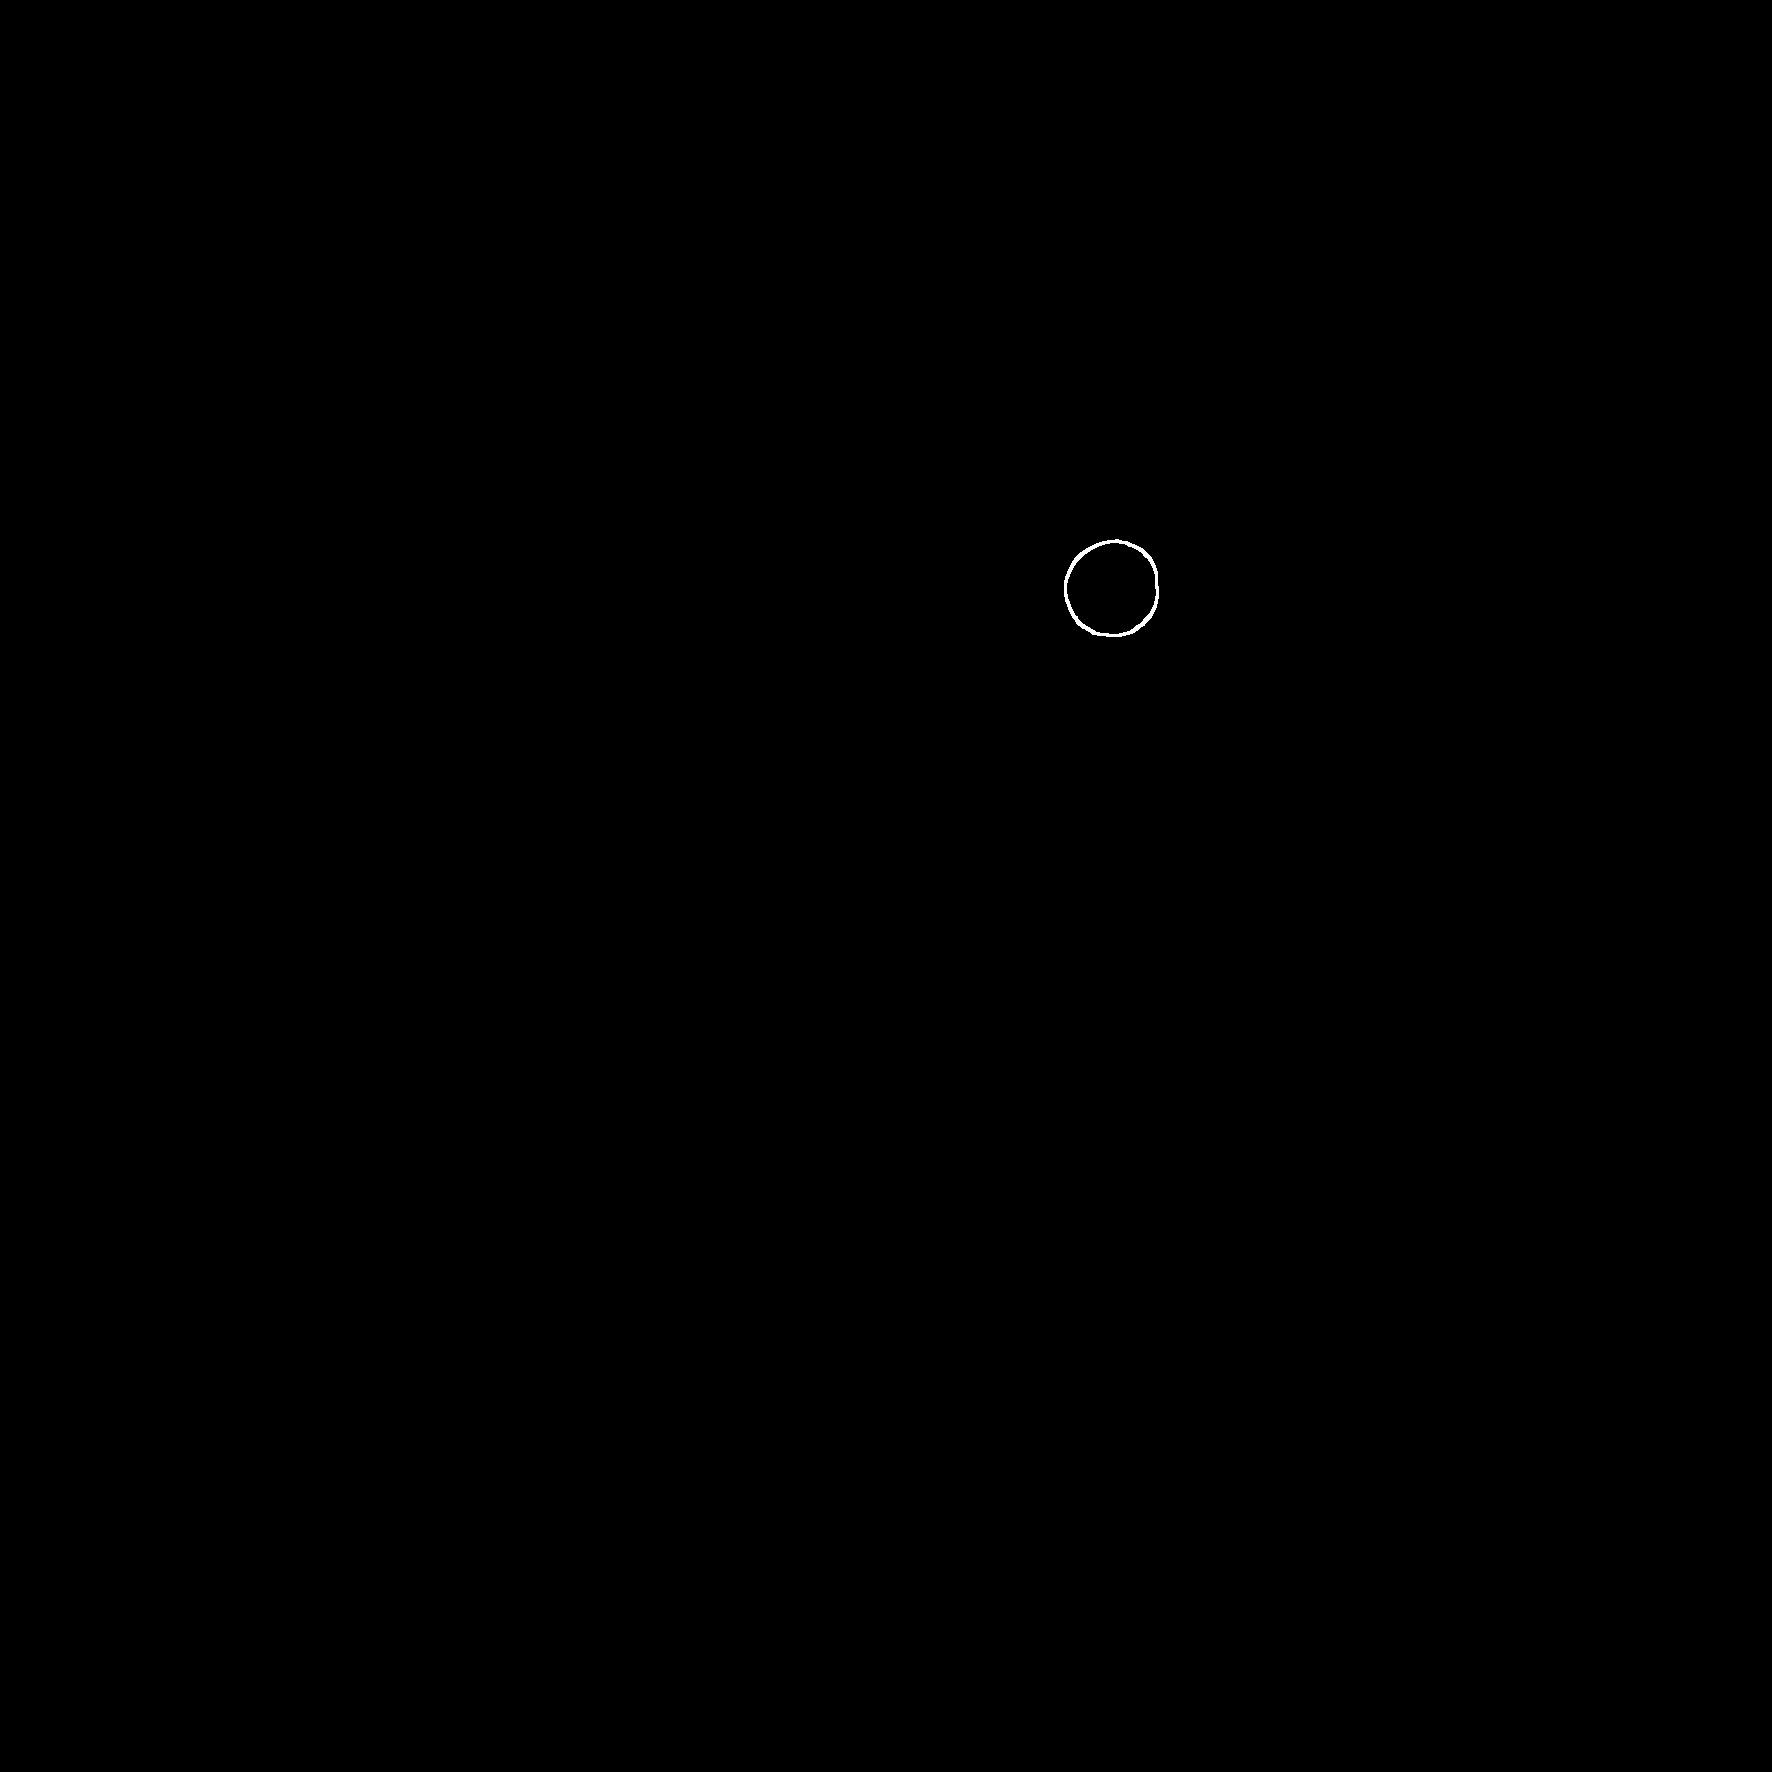

Liczba czarnych kropek: 1


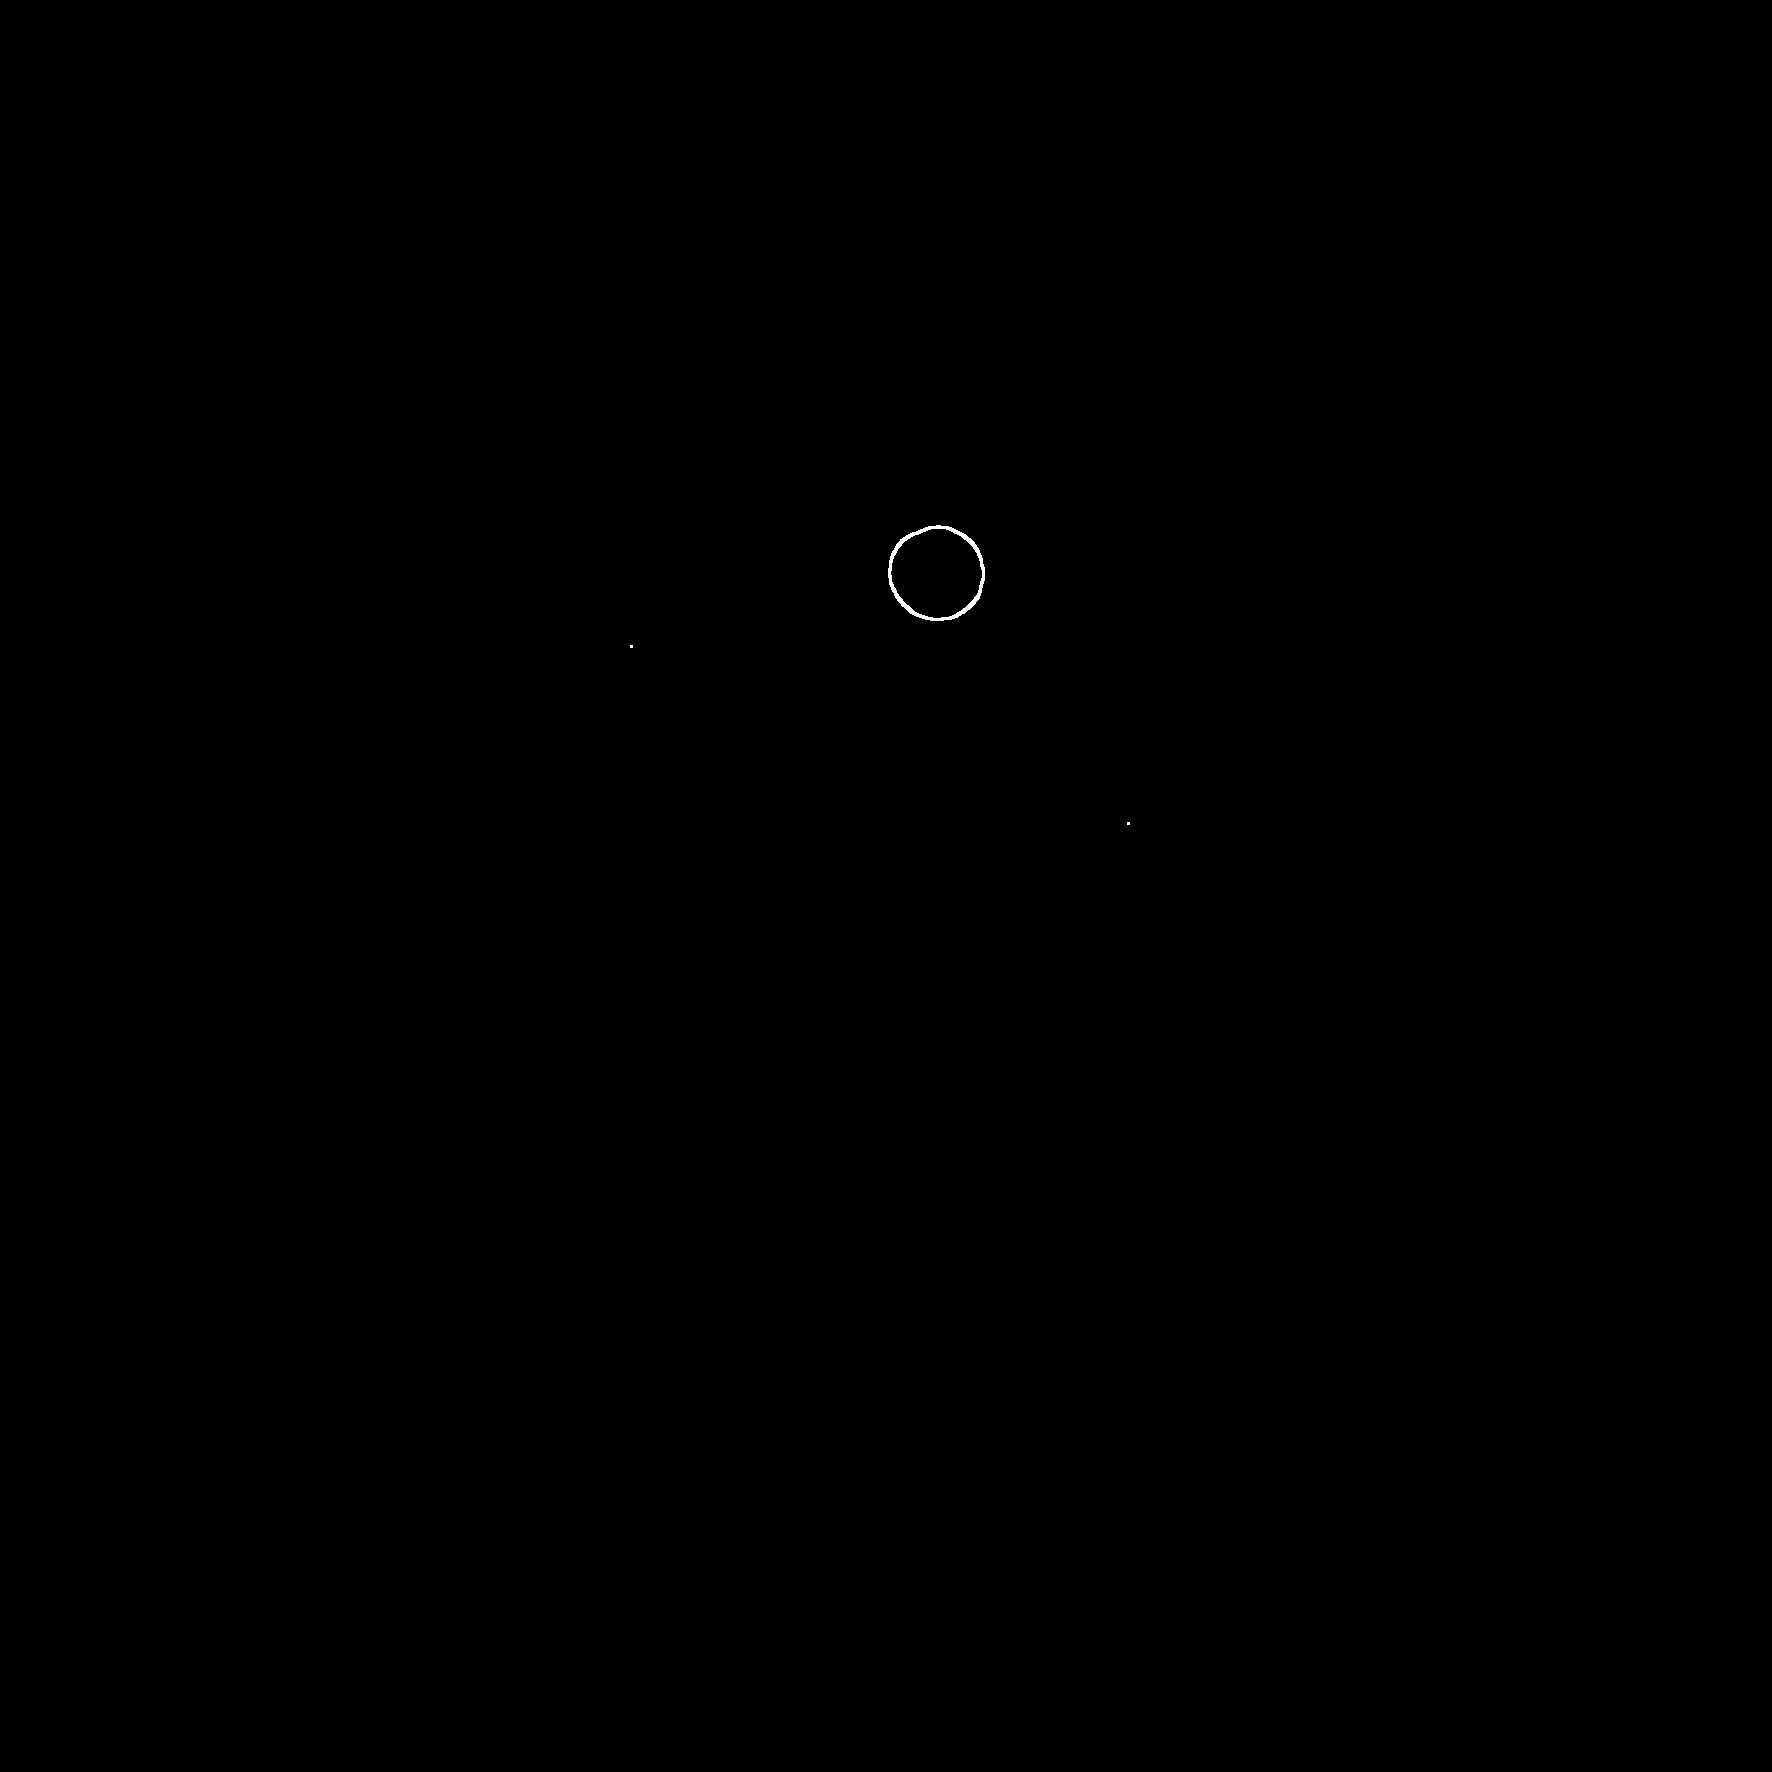

Liczba czarnych kropek: 1


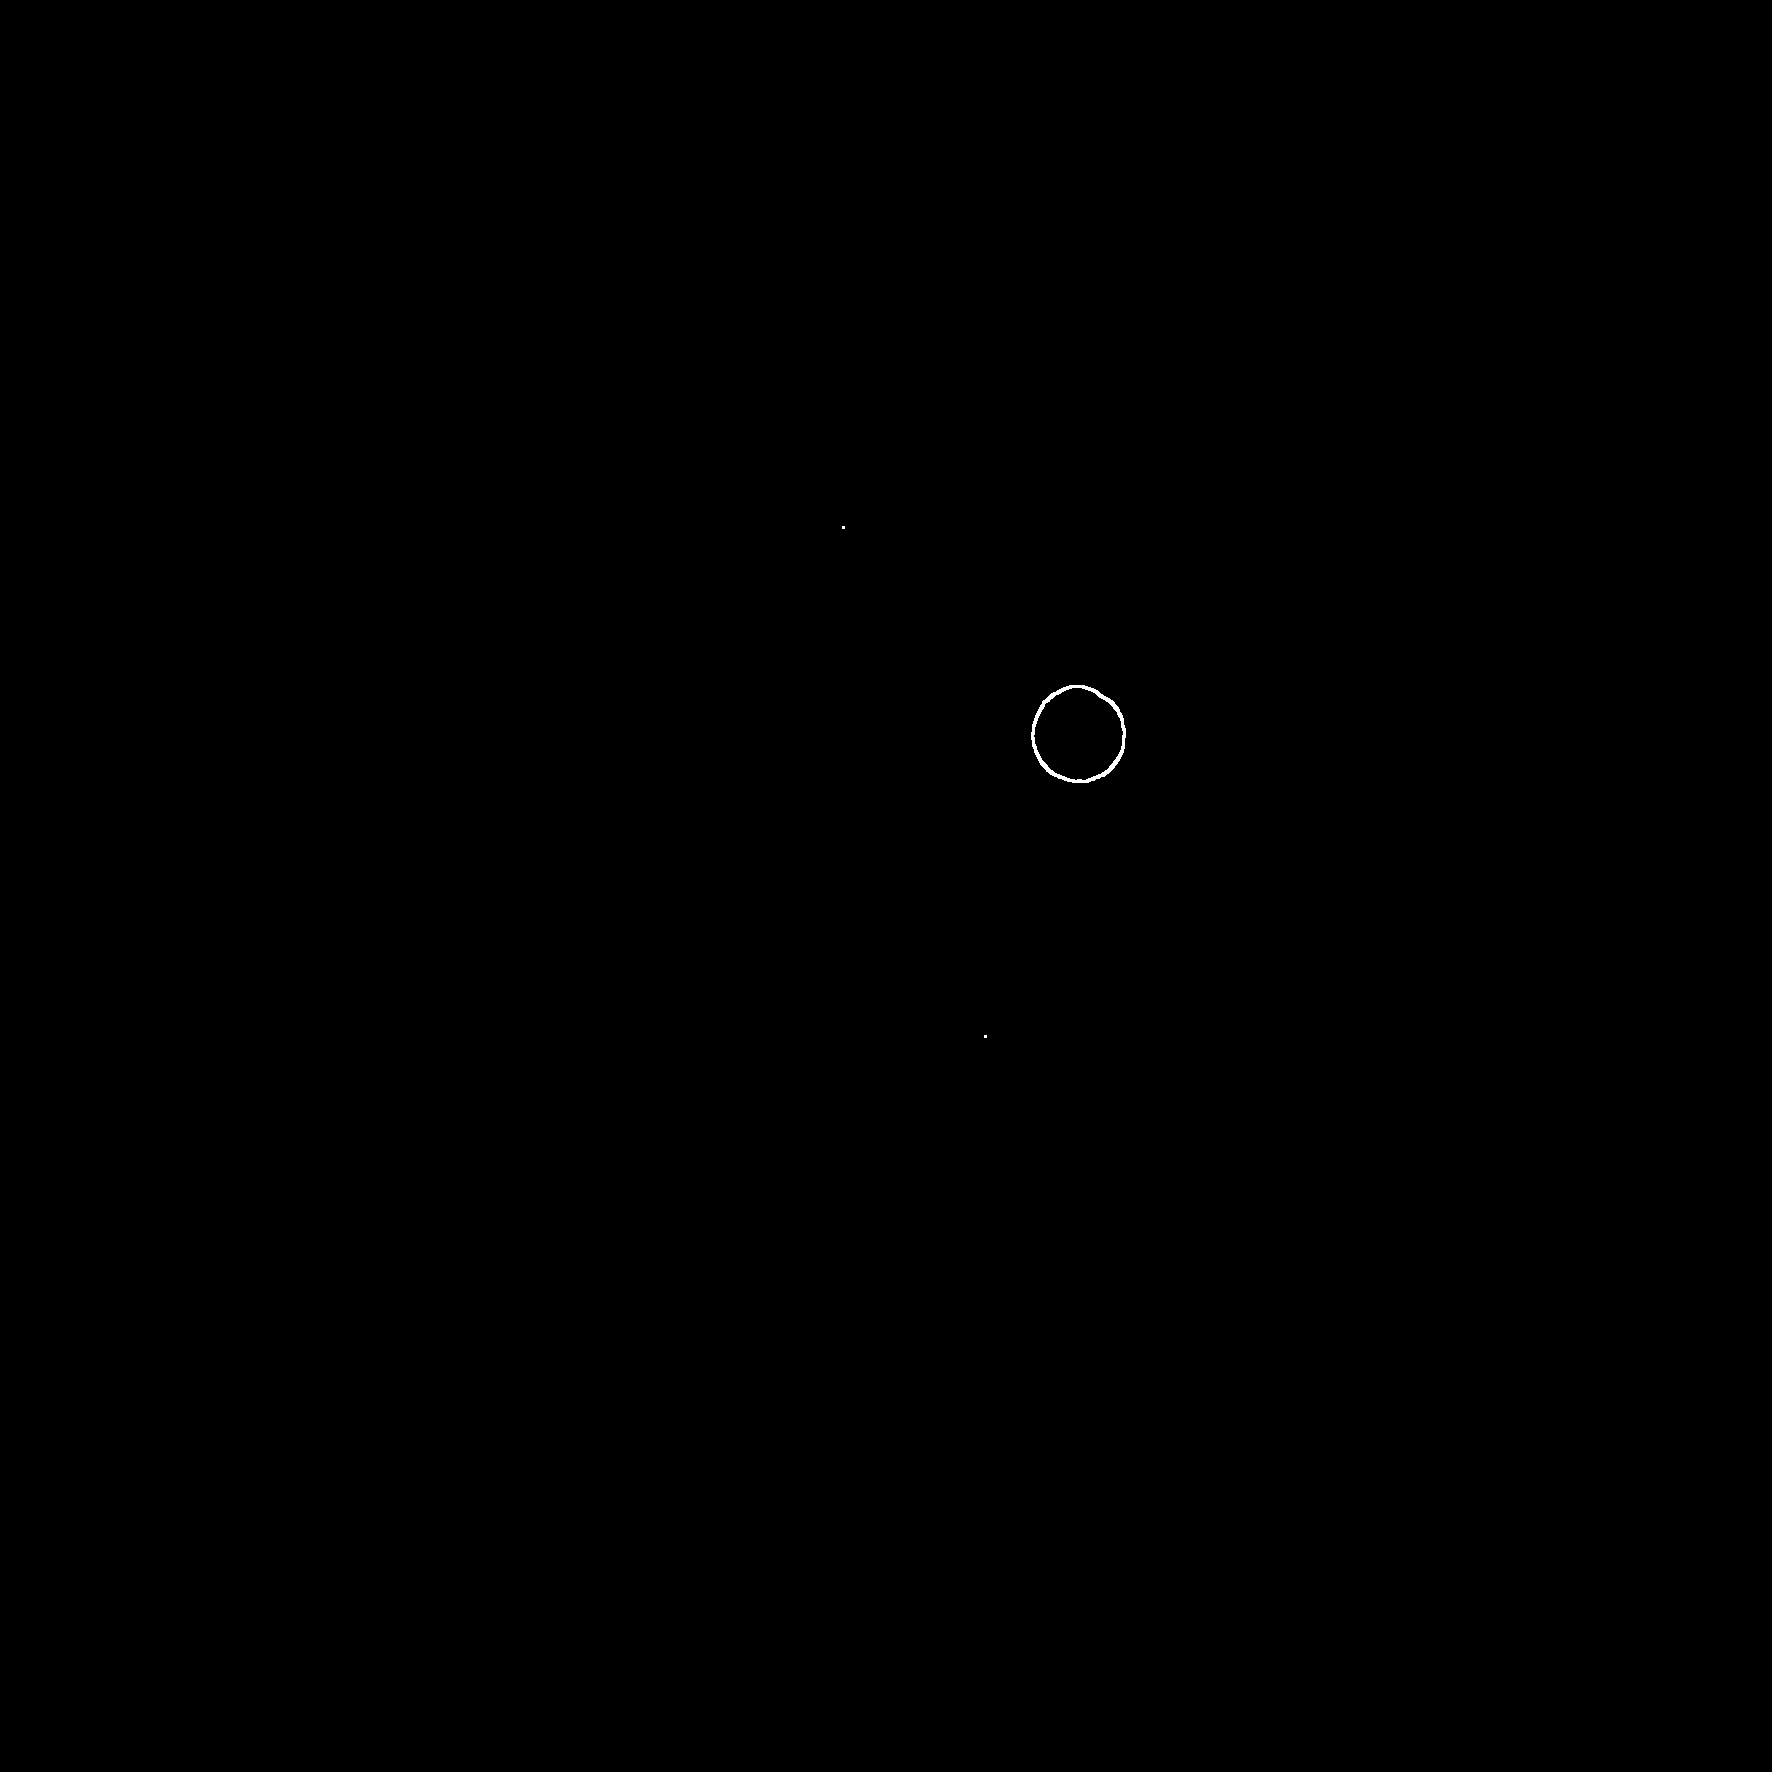

Liczba czarnych kropek: 1


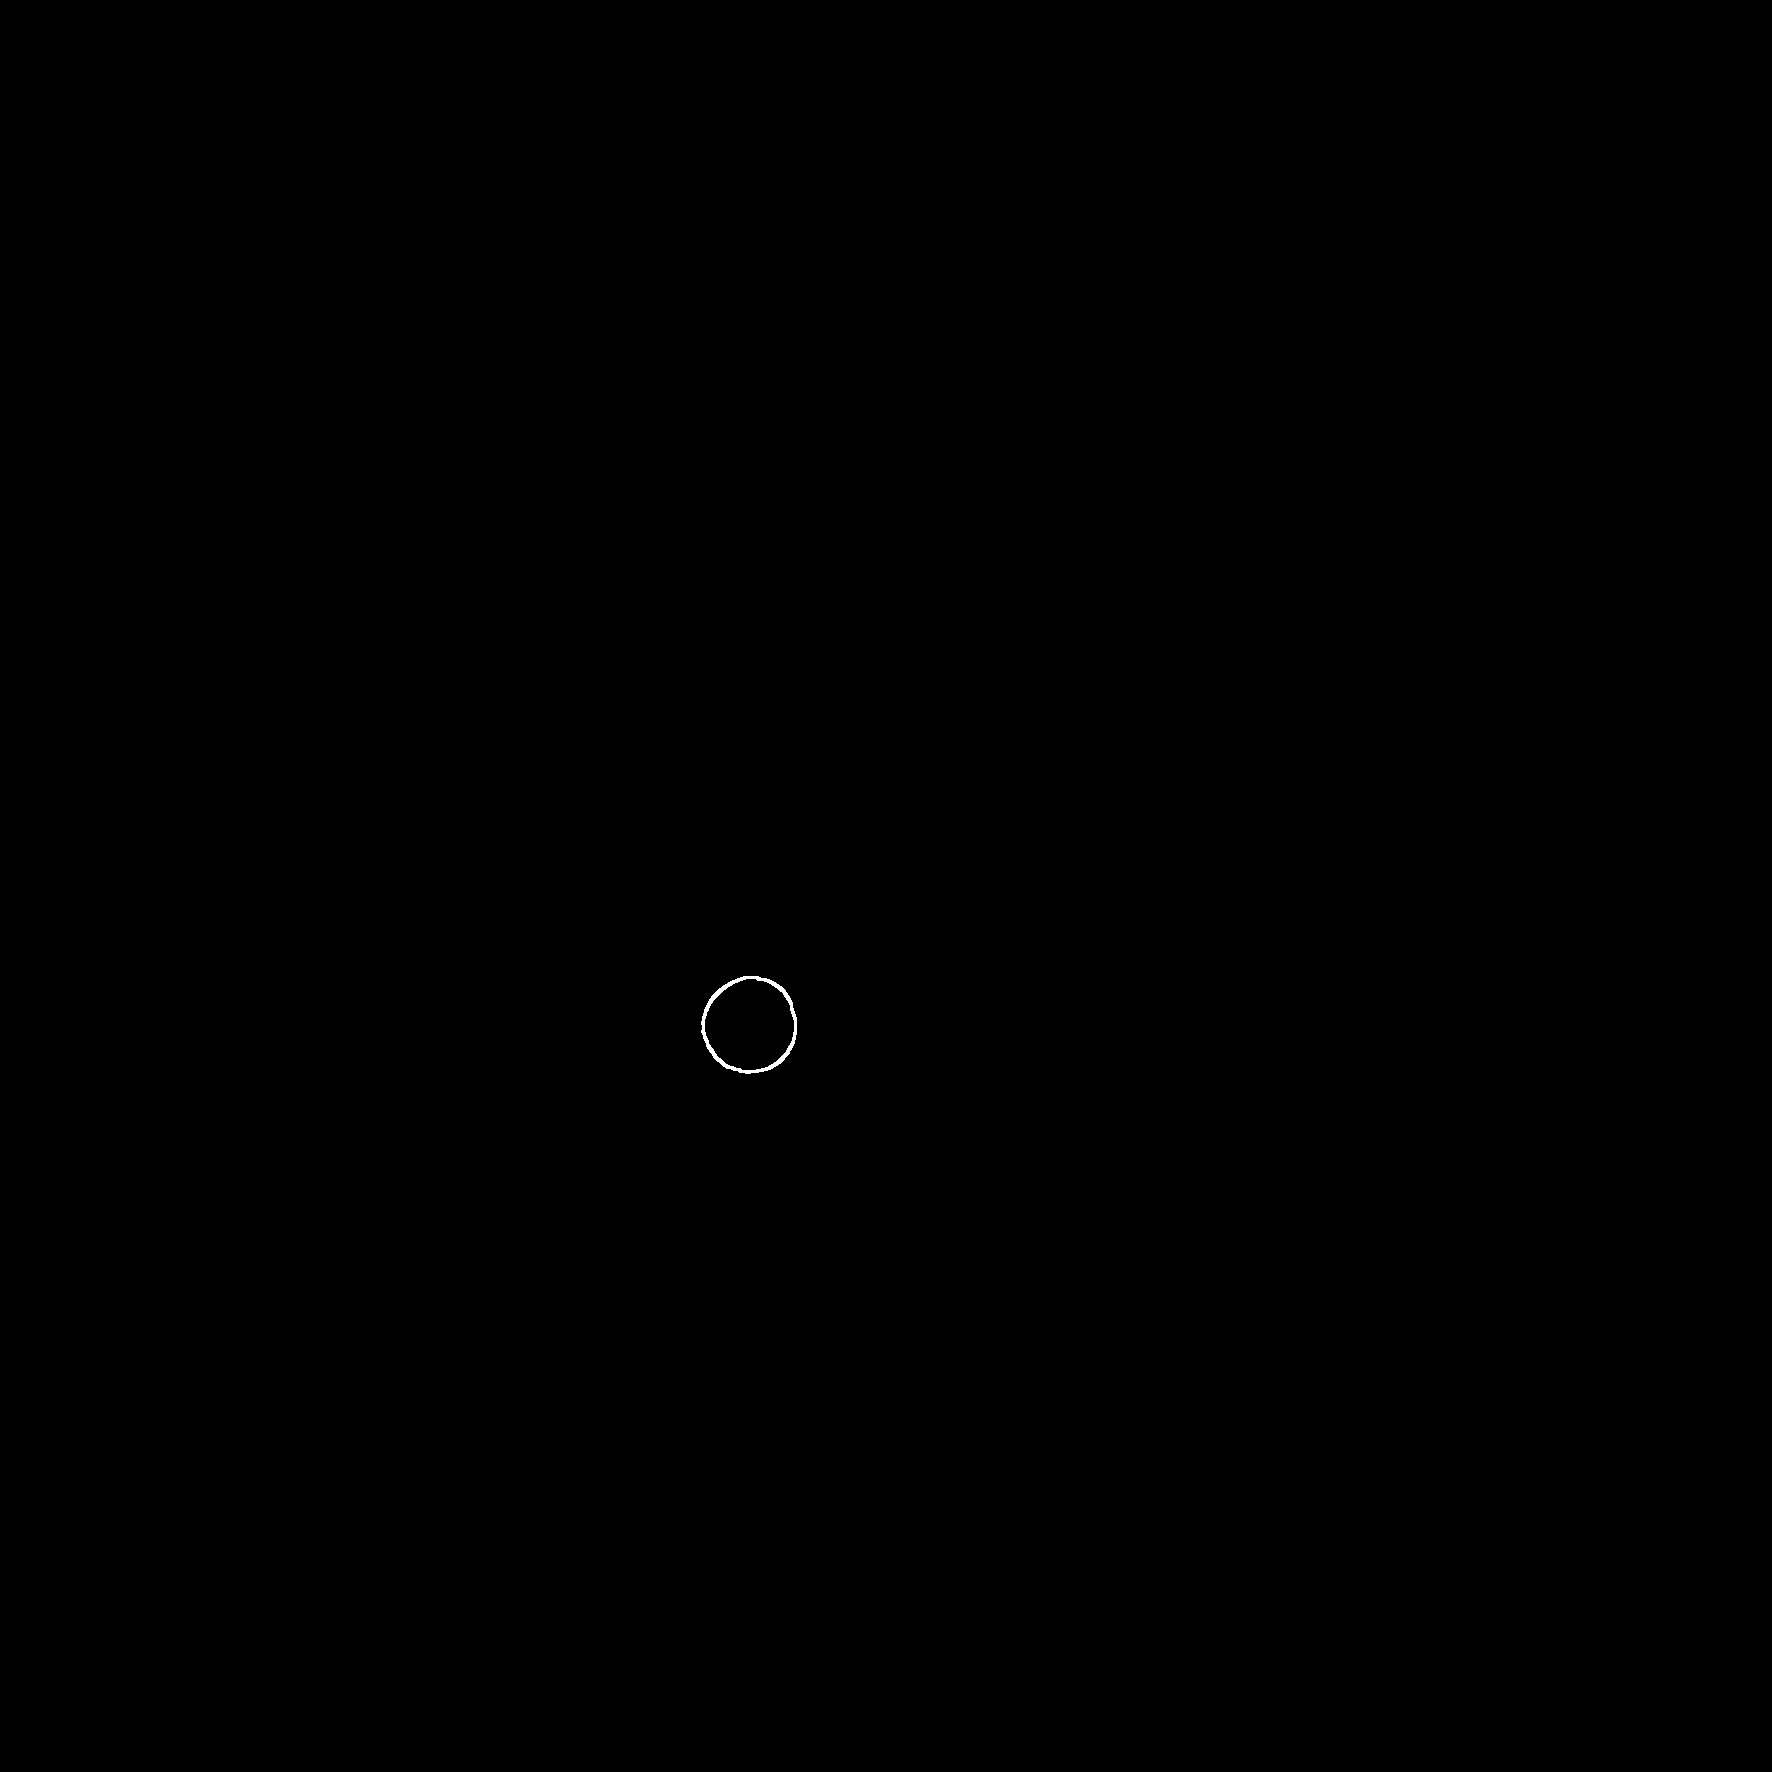

Liczba czarnych kropek: 1


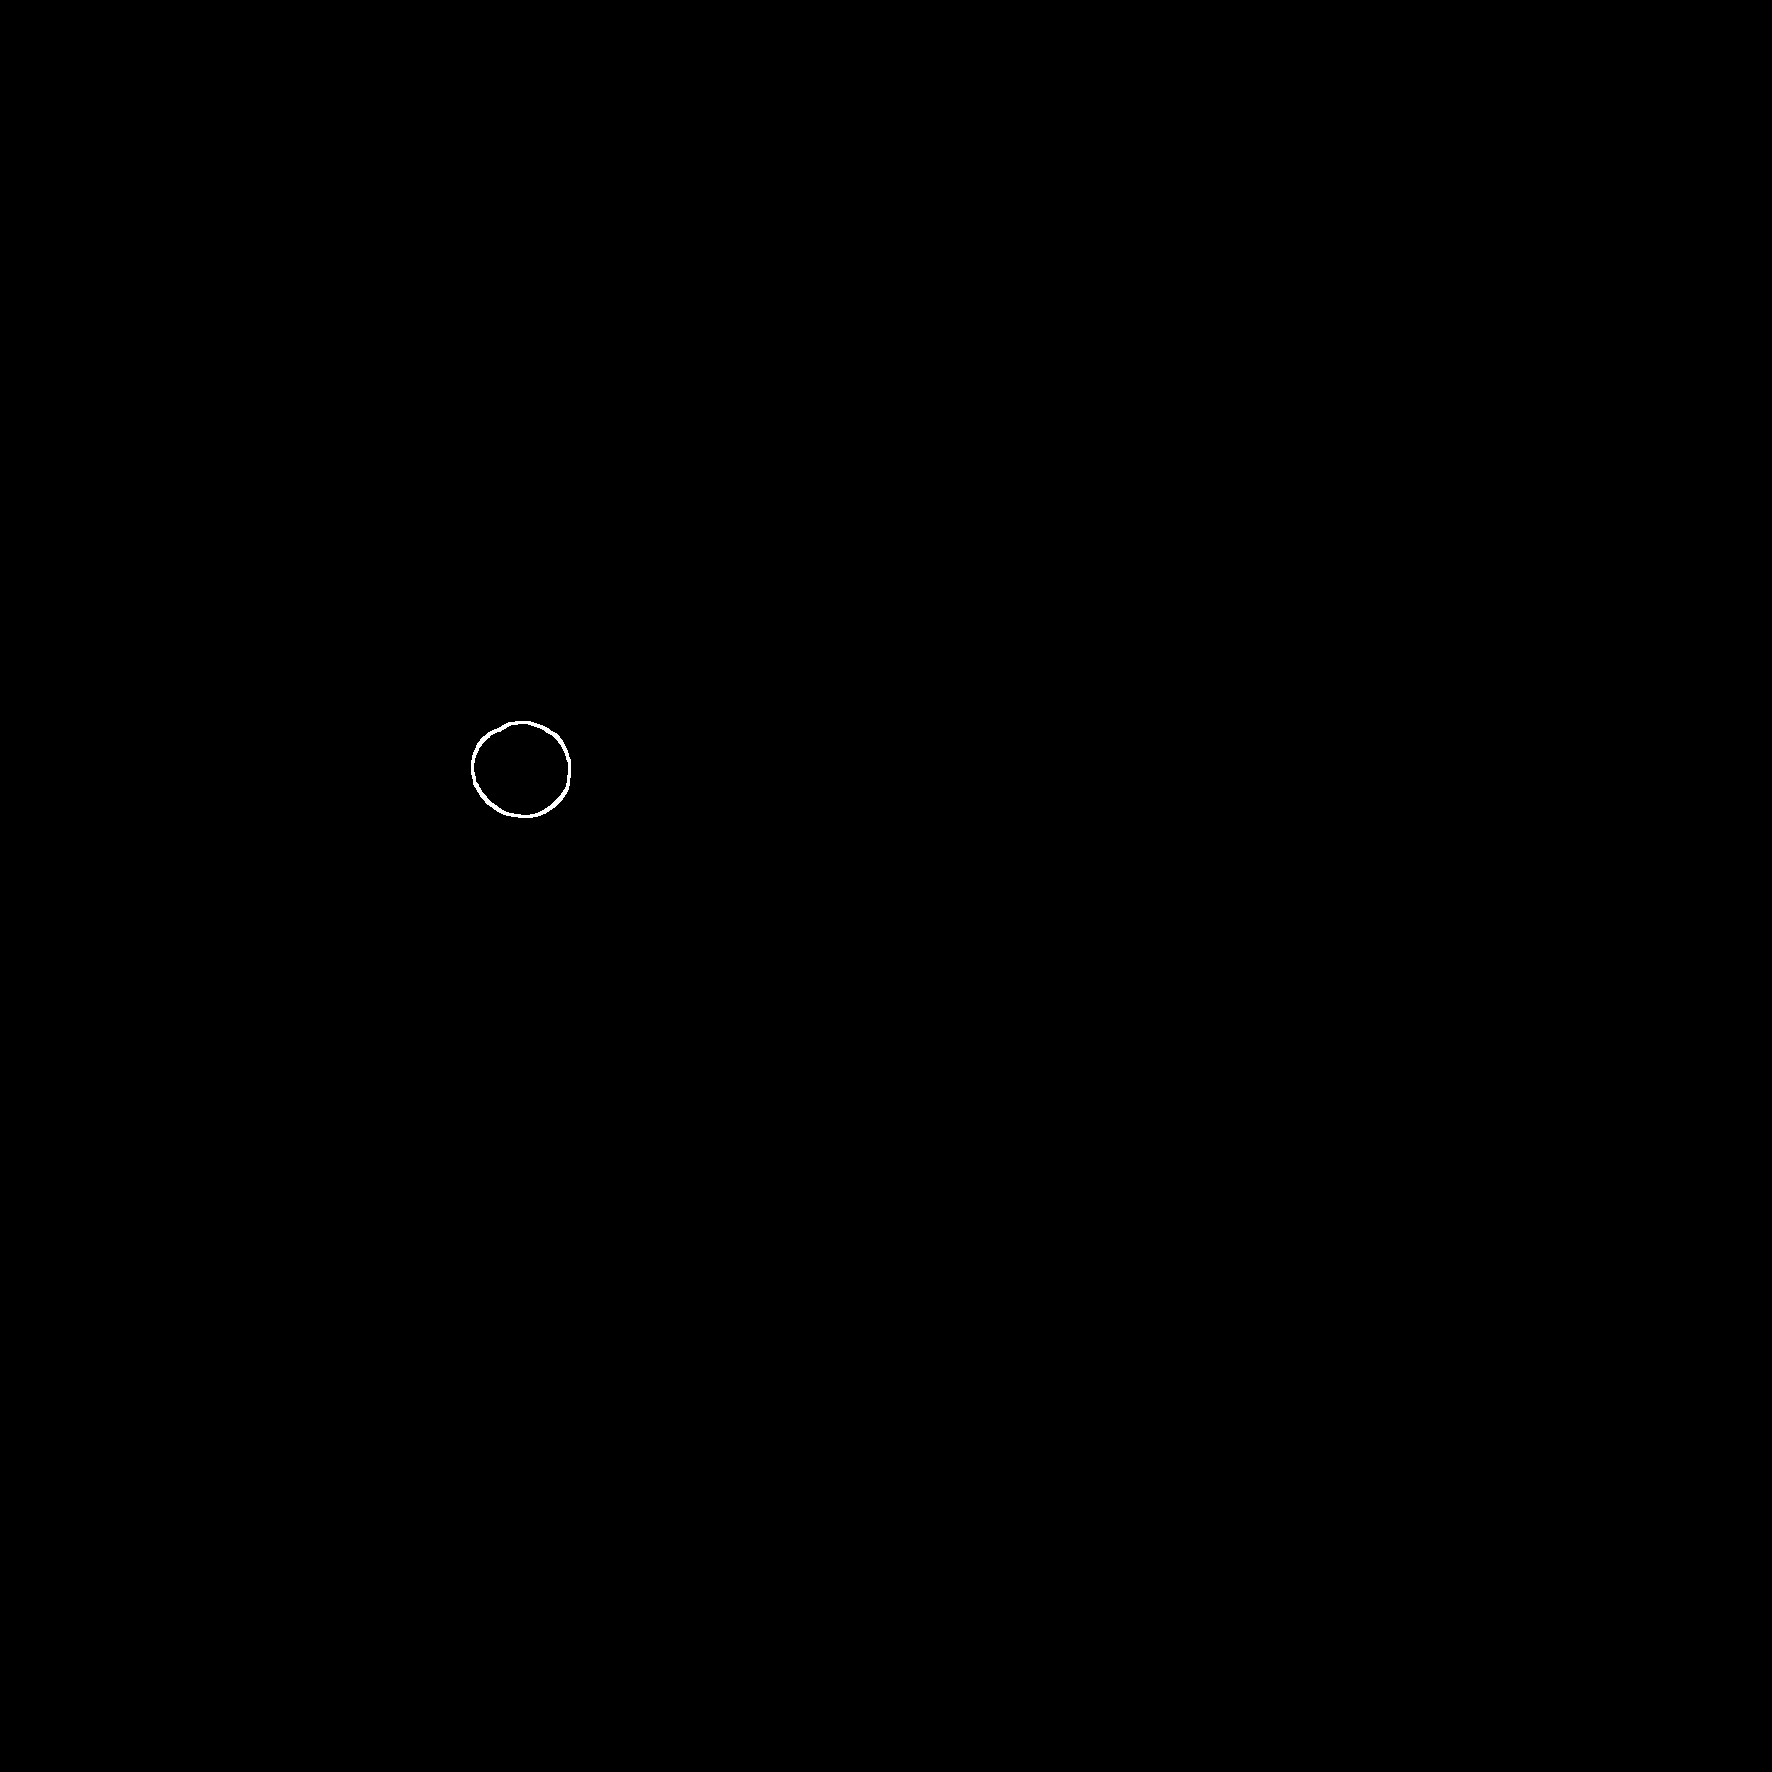

Liczba czarnych kropek: 1


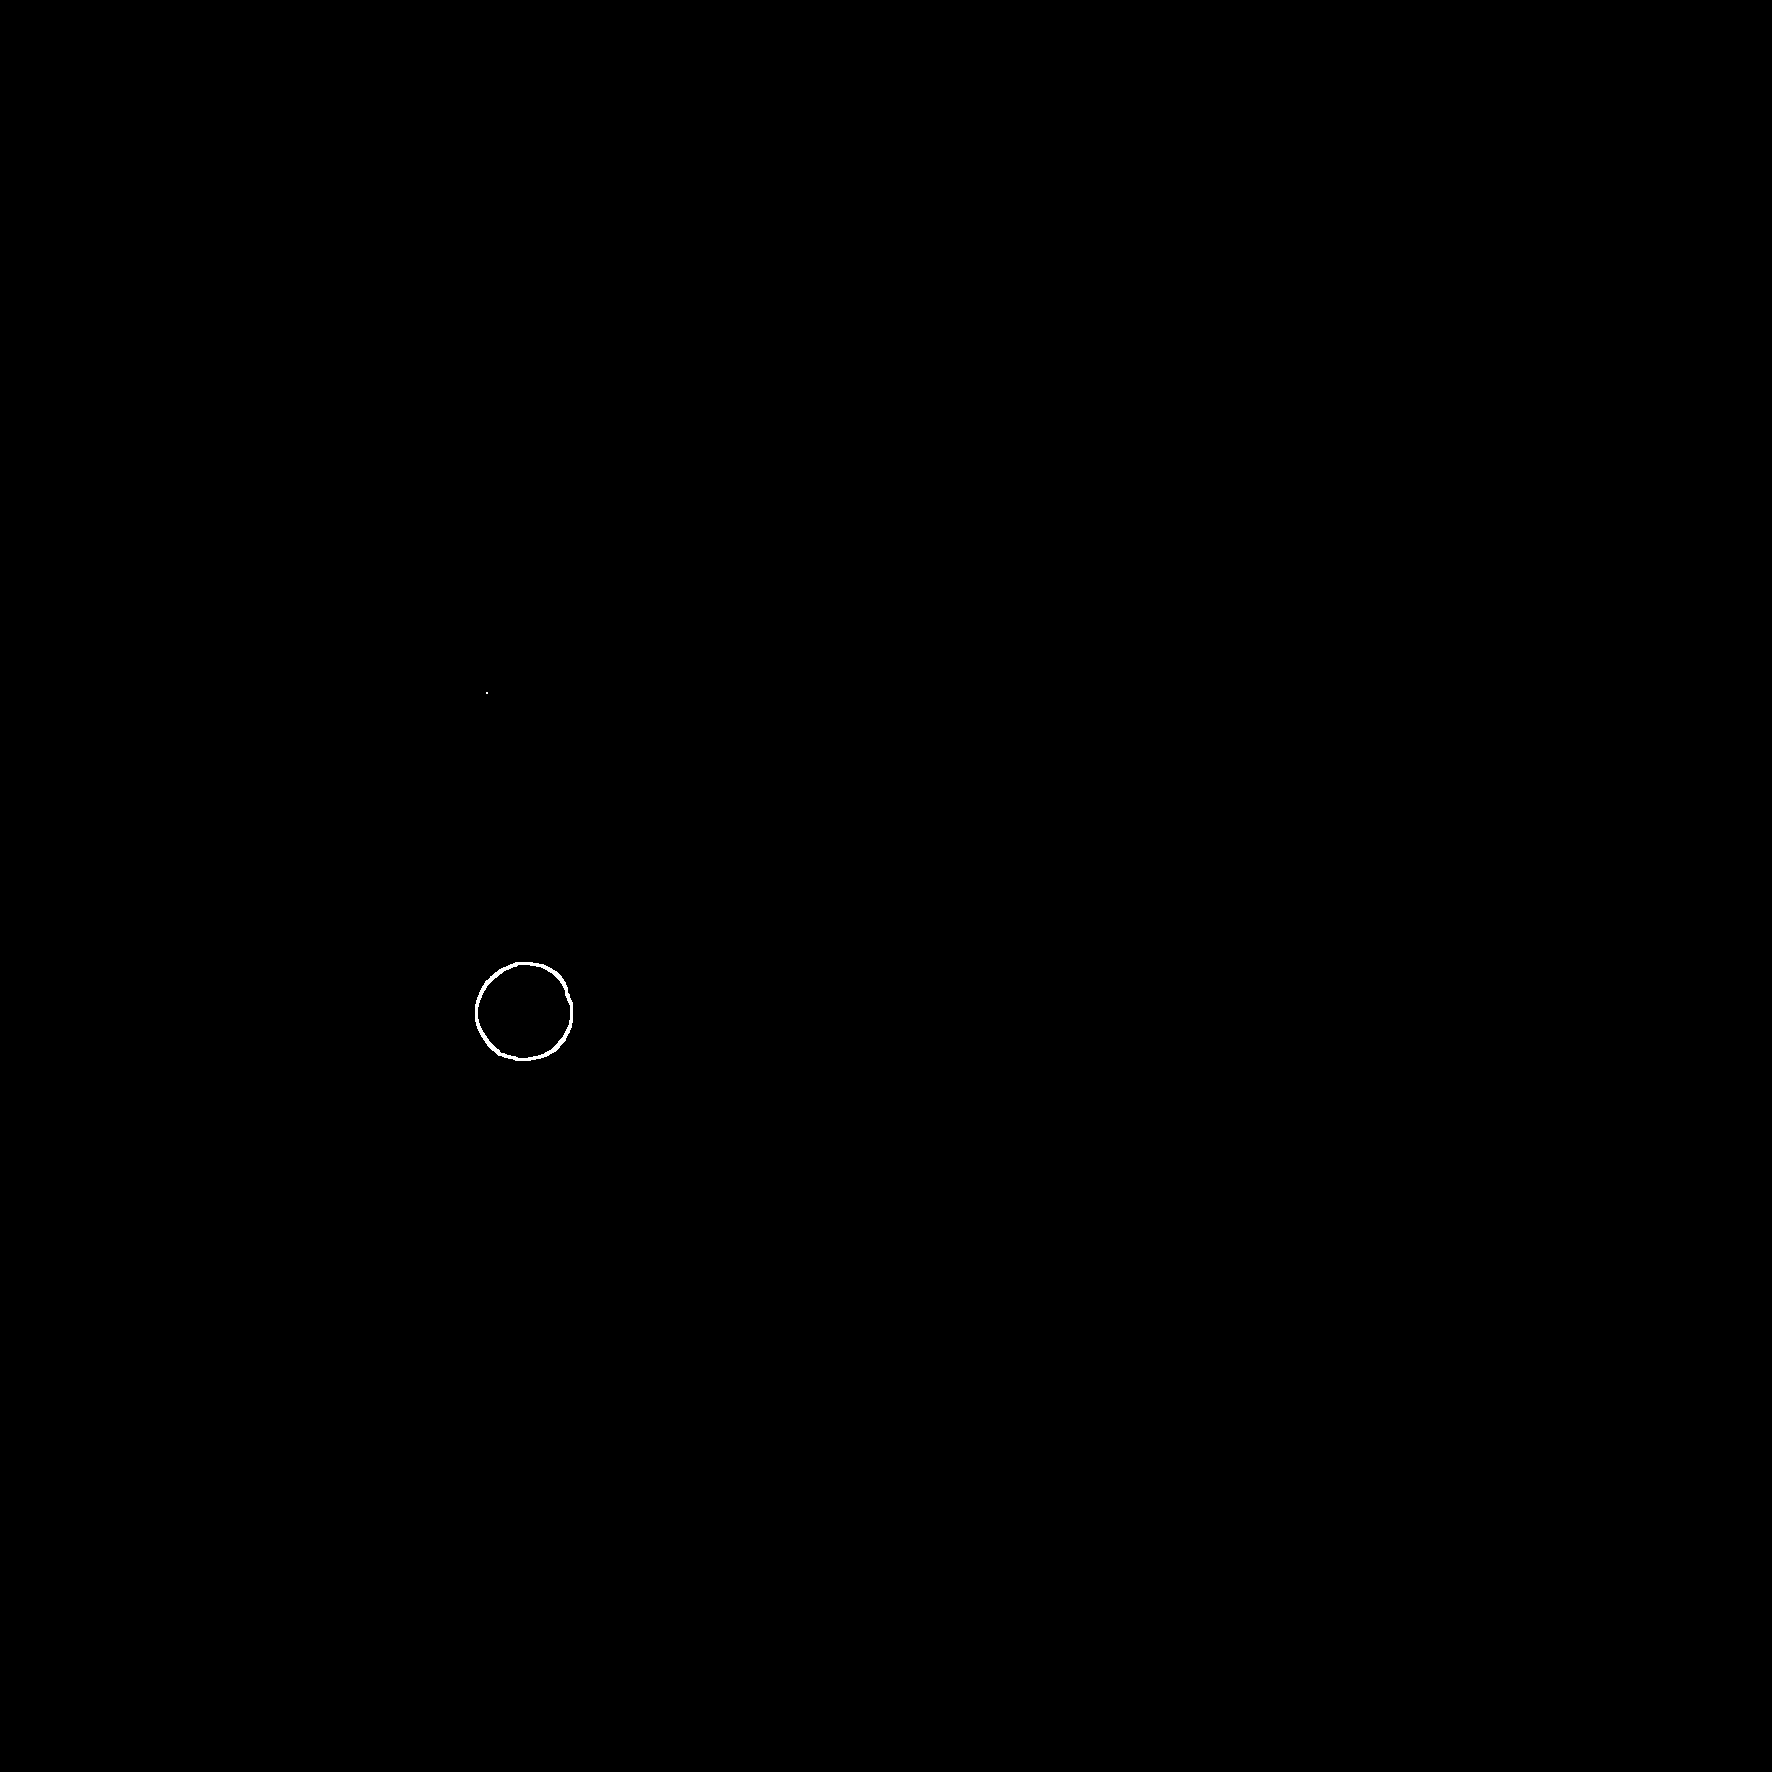

Liczba czarnych kropek: 1


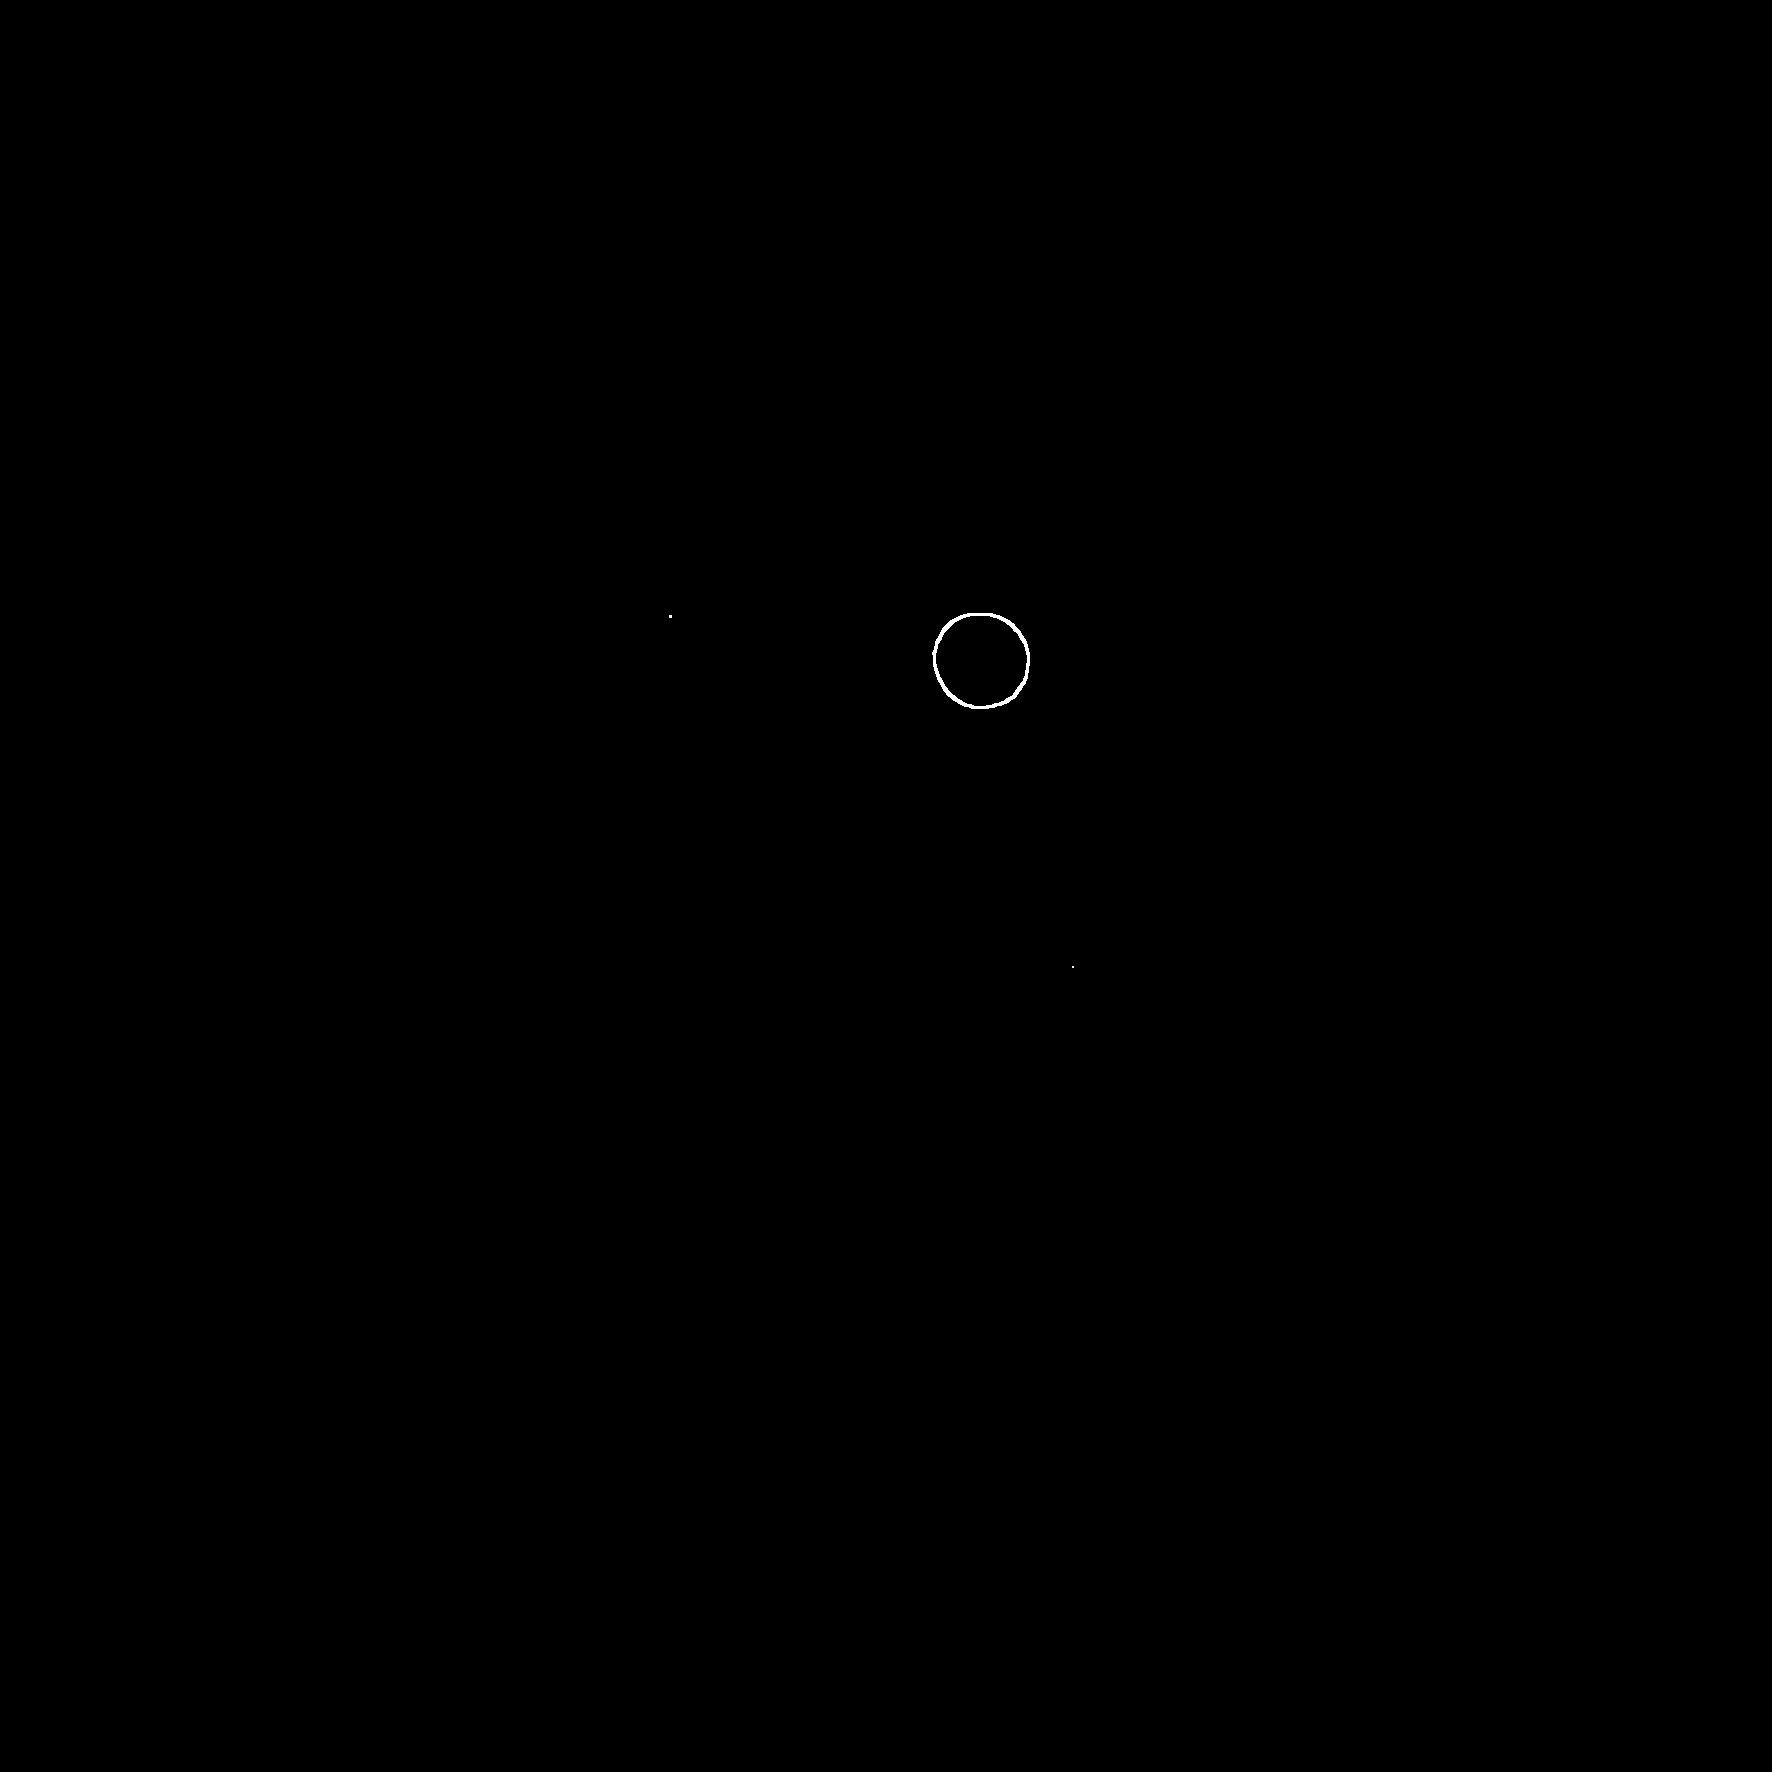

Liczba czarnych kropek: 1


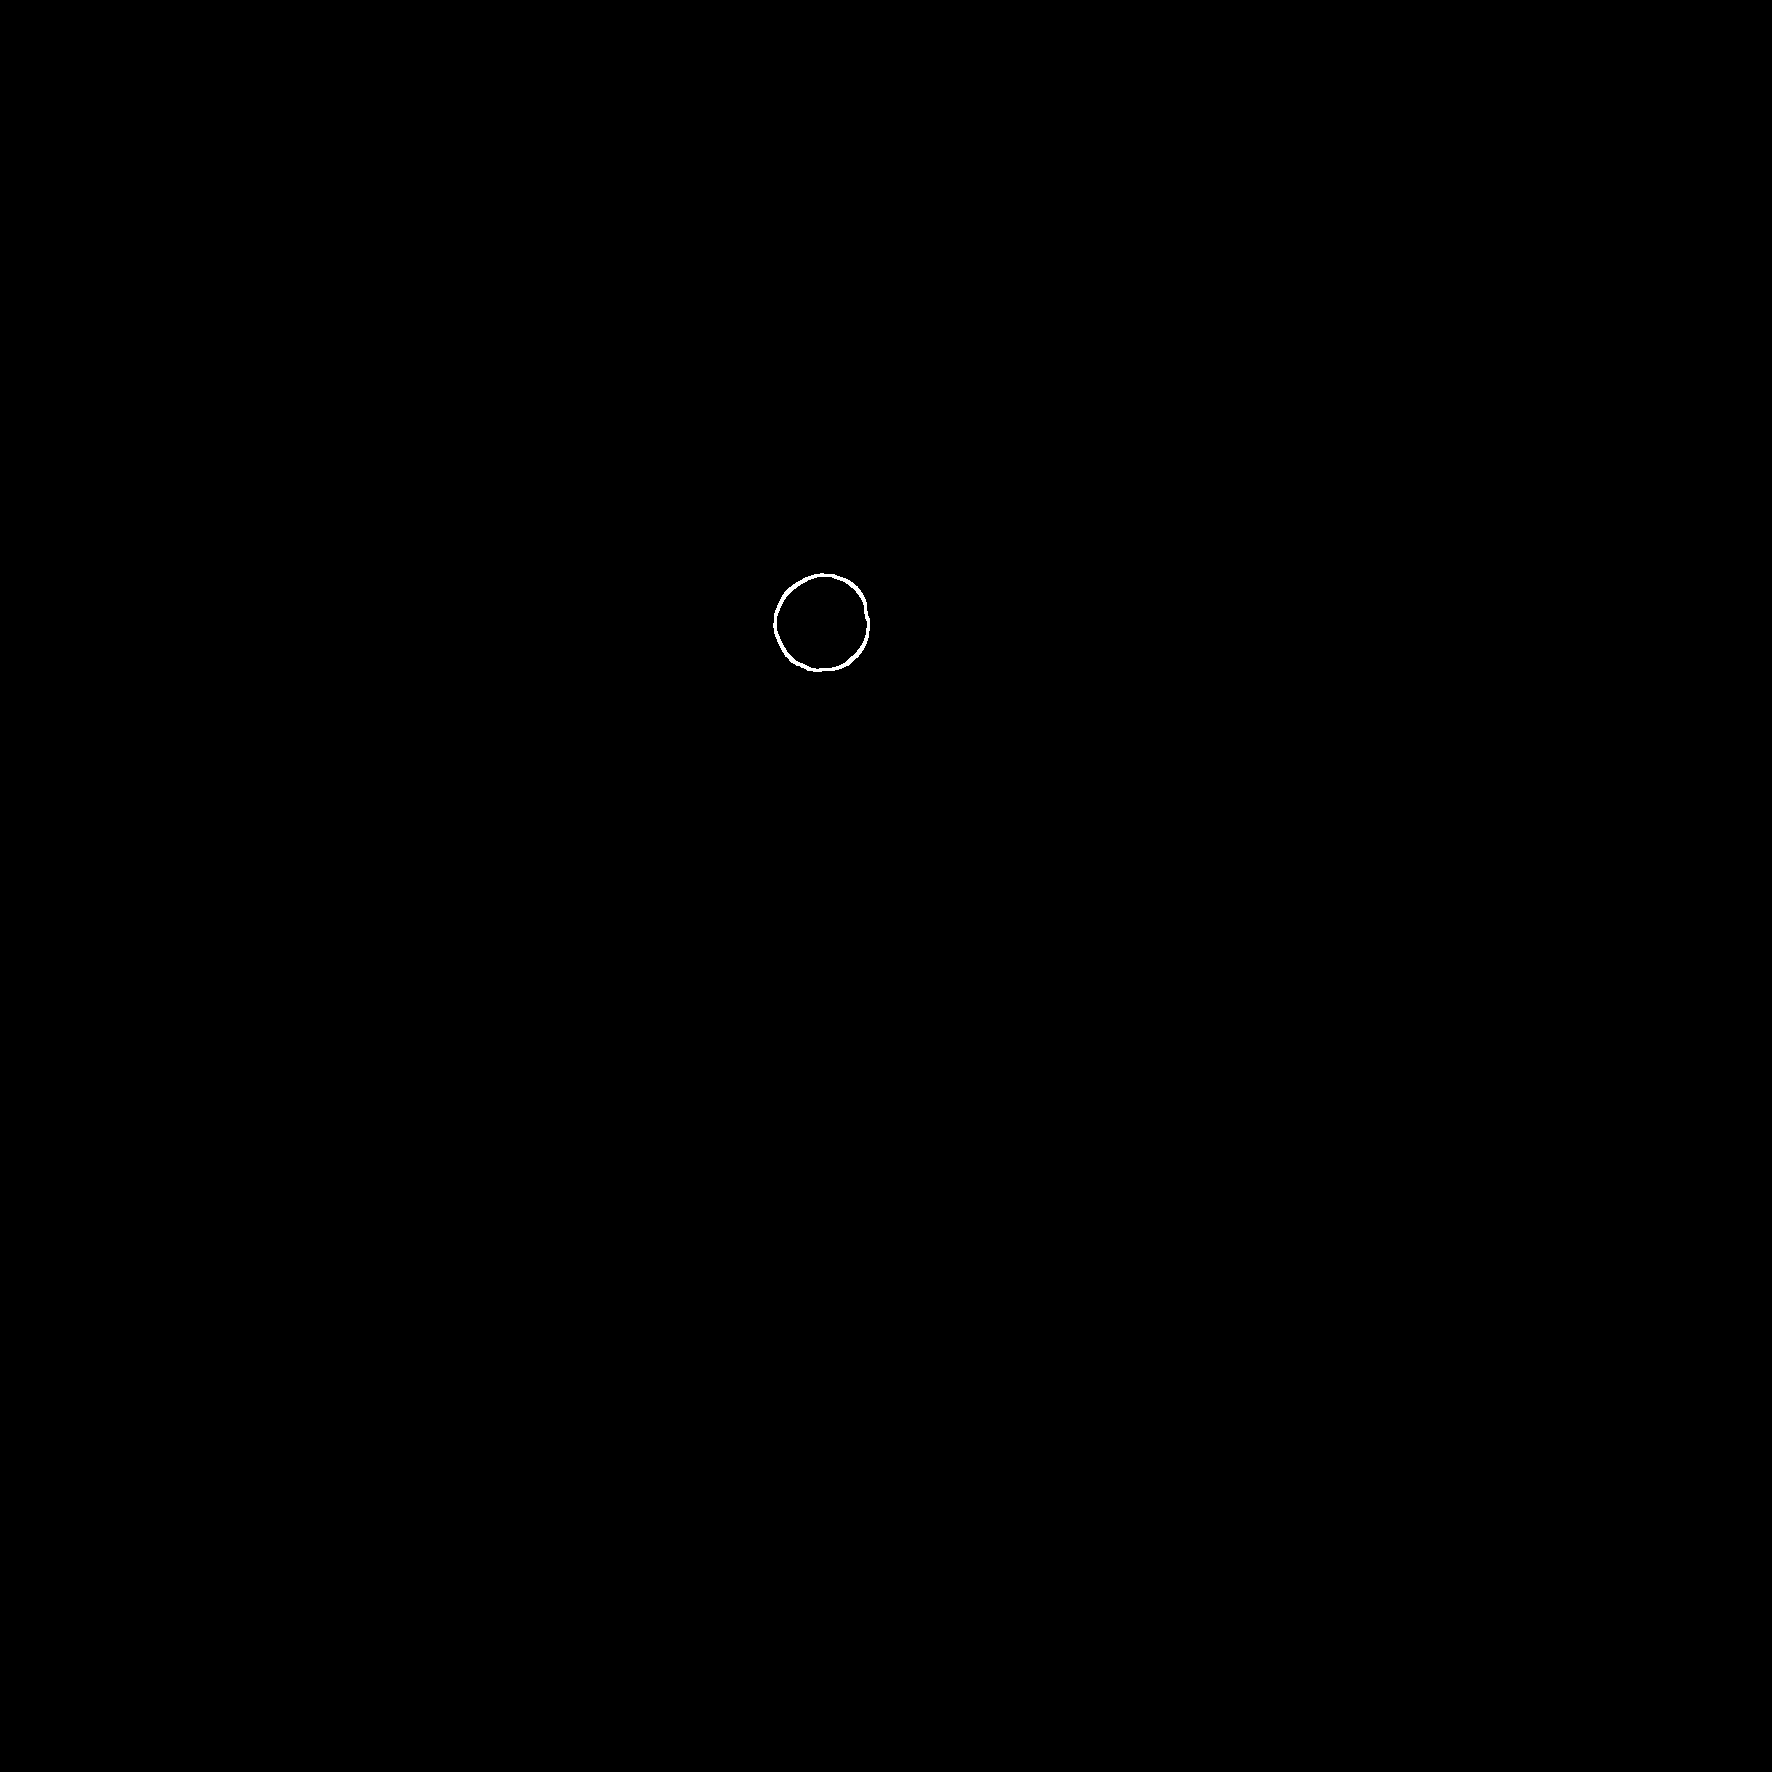

Liczba czarnych kropek: 1


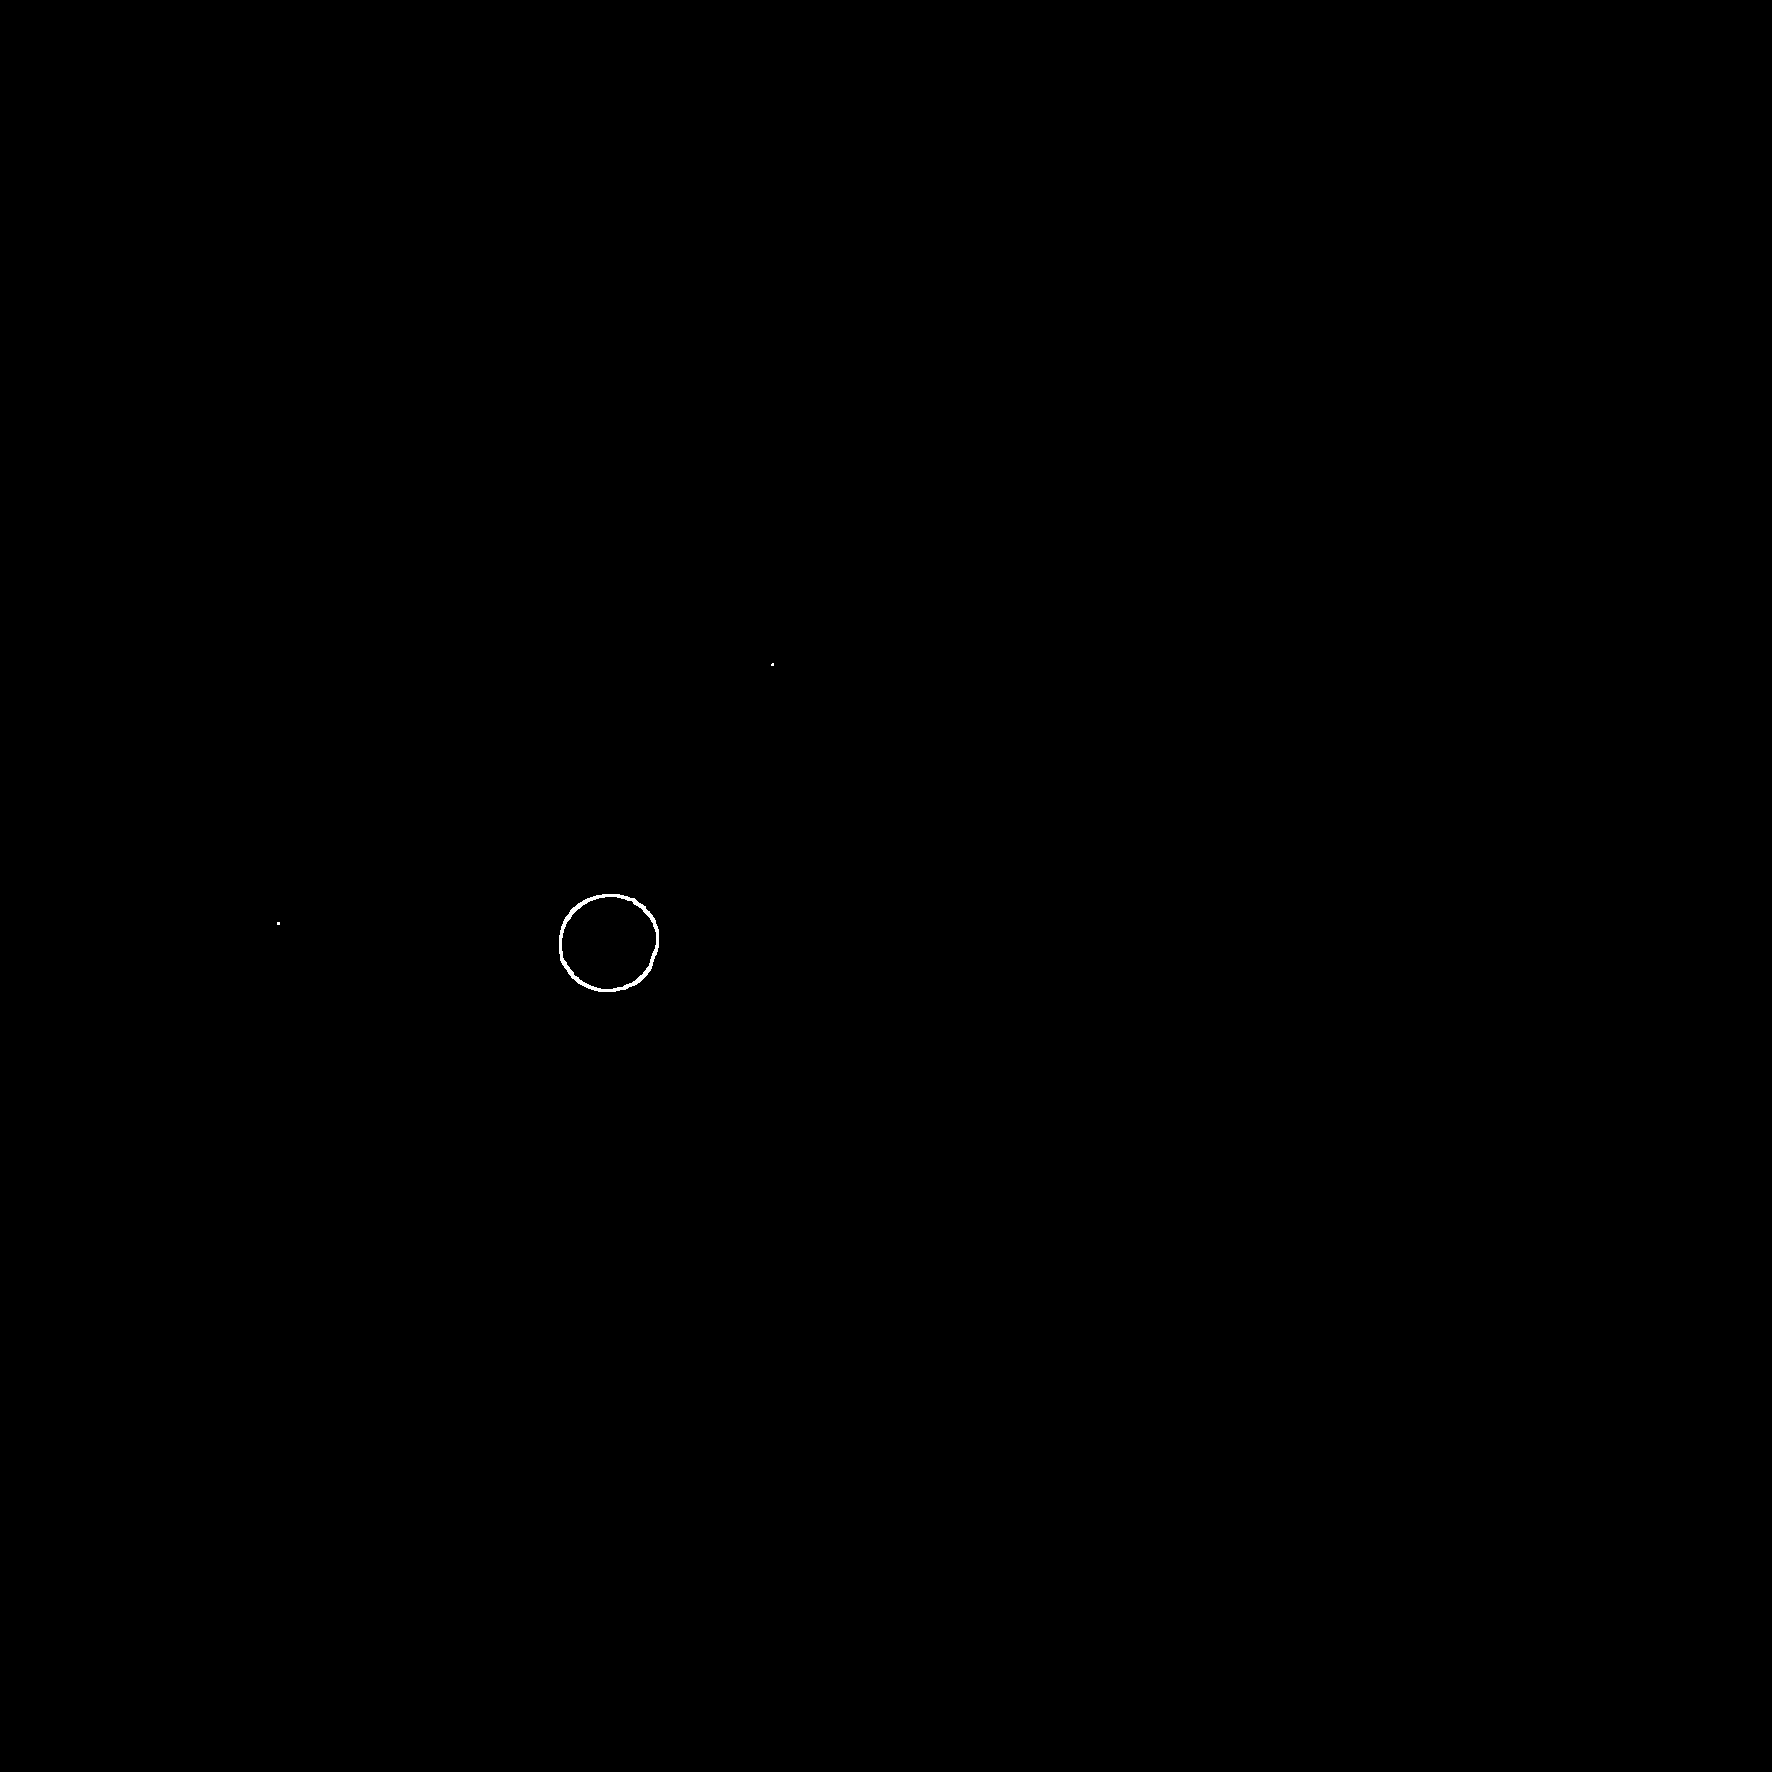

Liczba czarnych kropek: 1


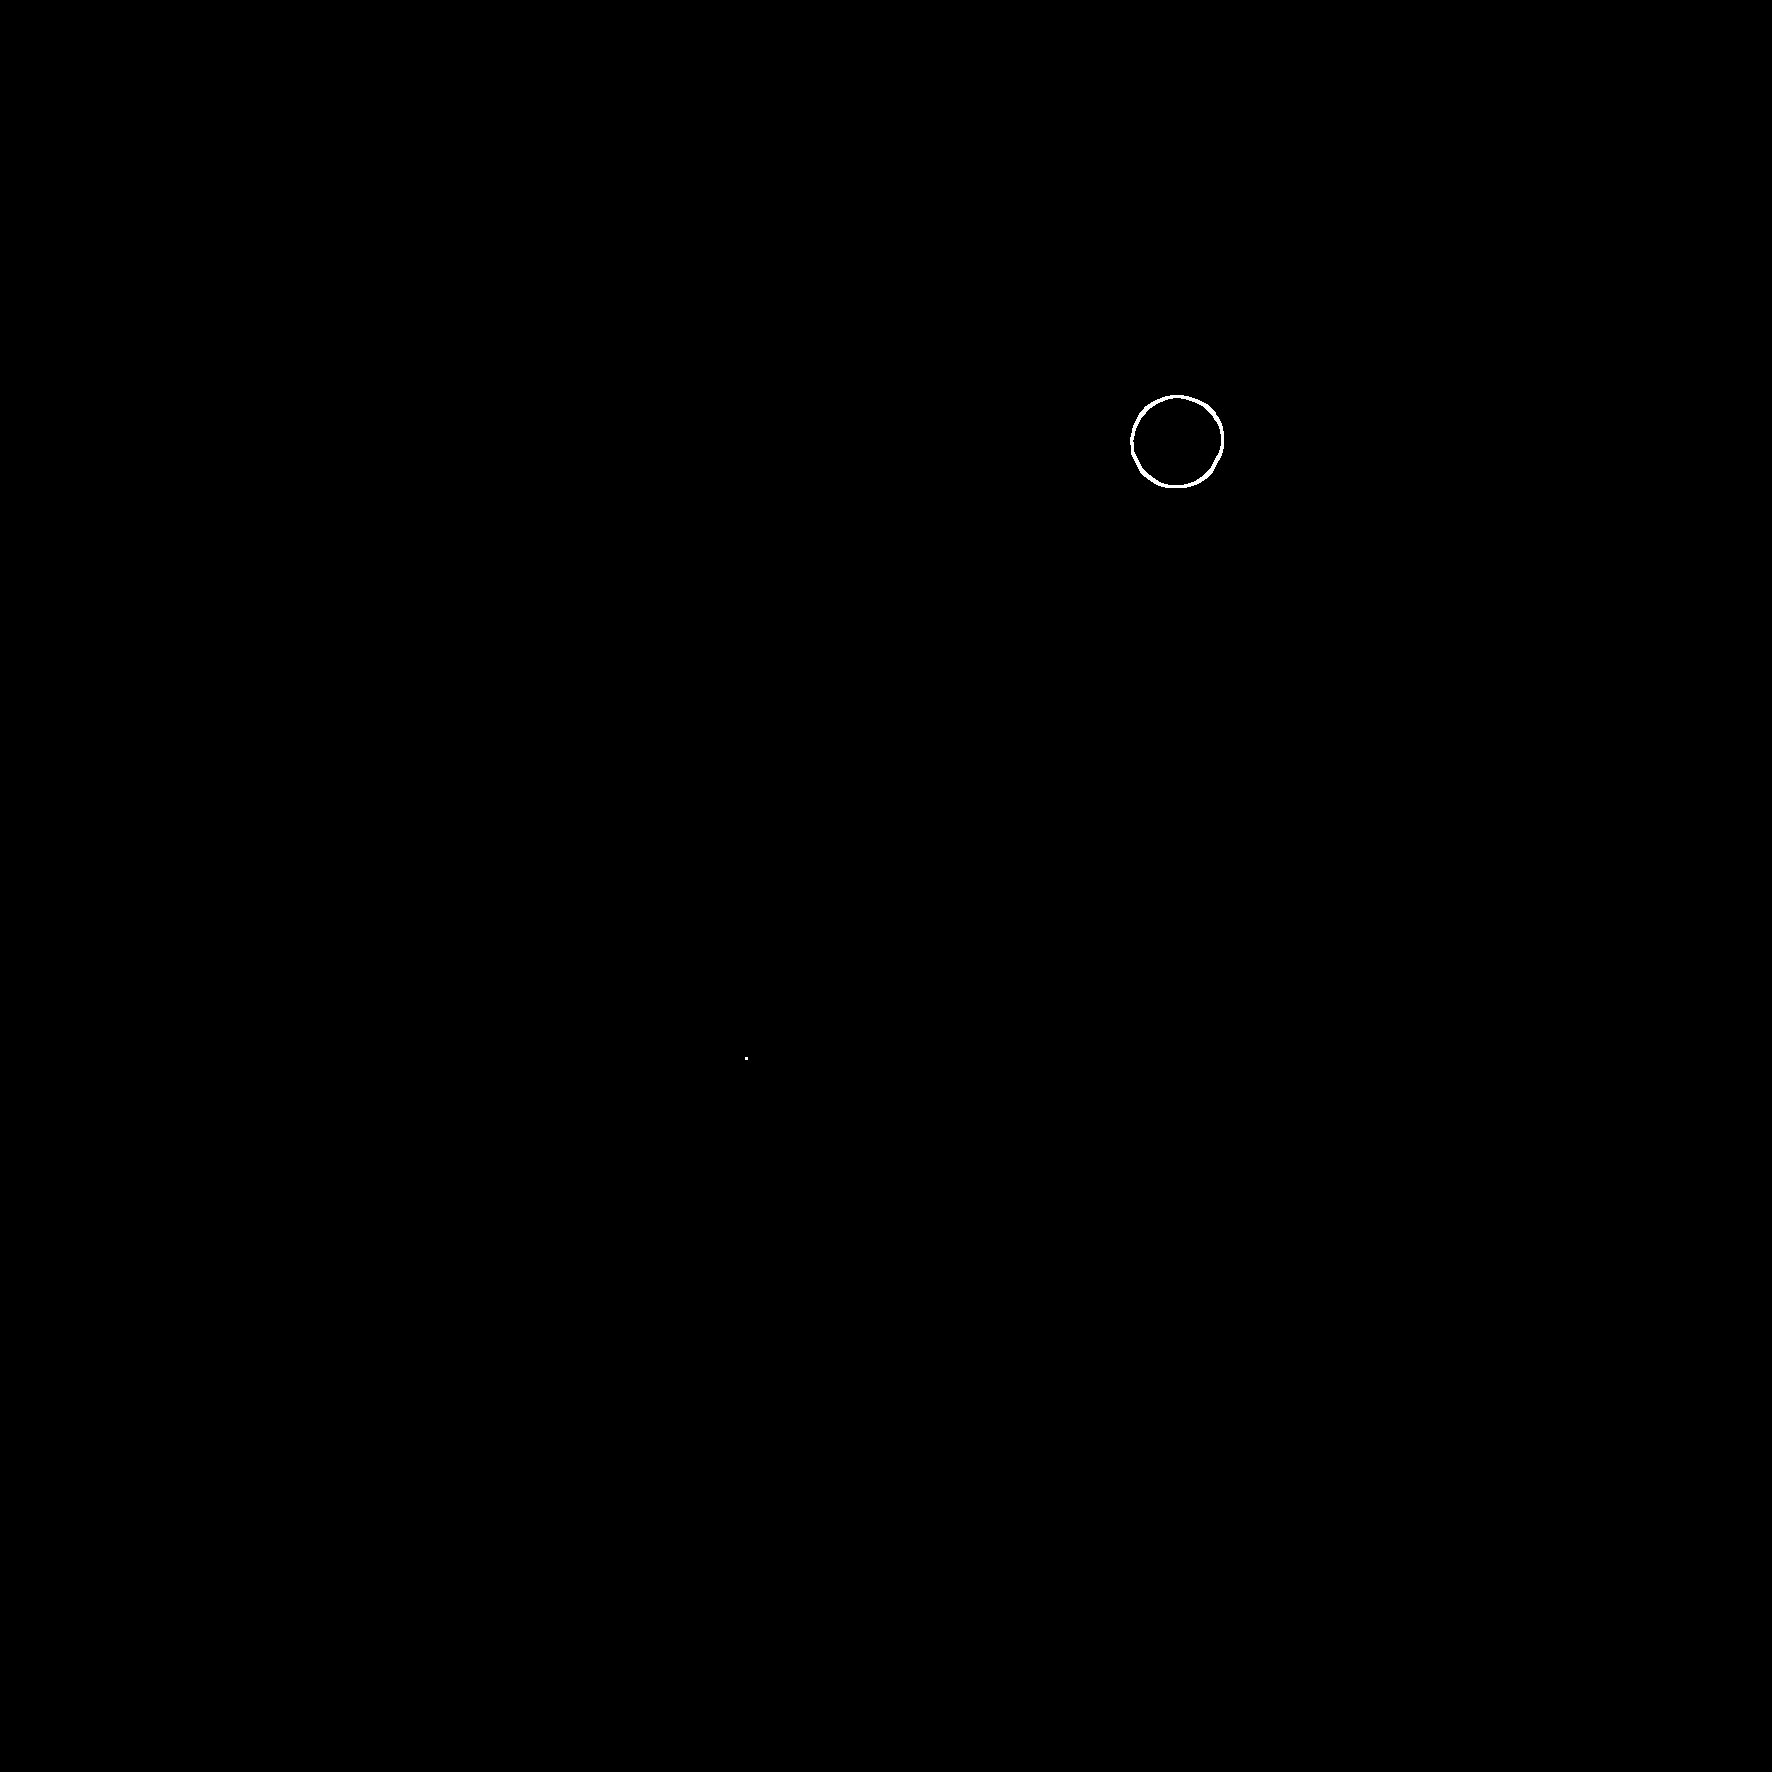

Liczba czarnych kropek: 1


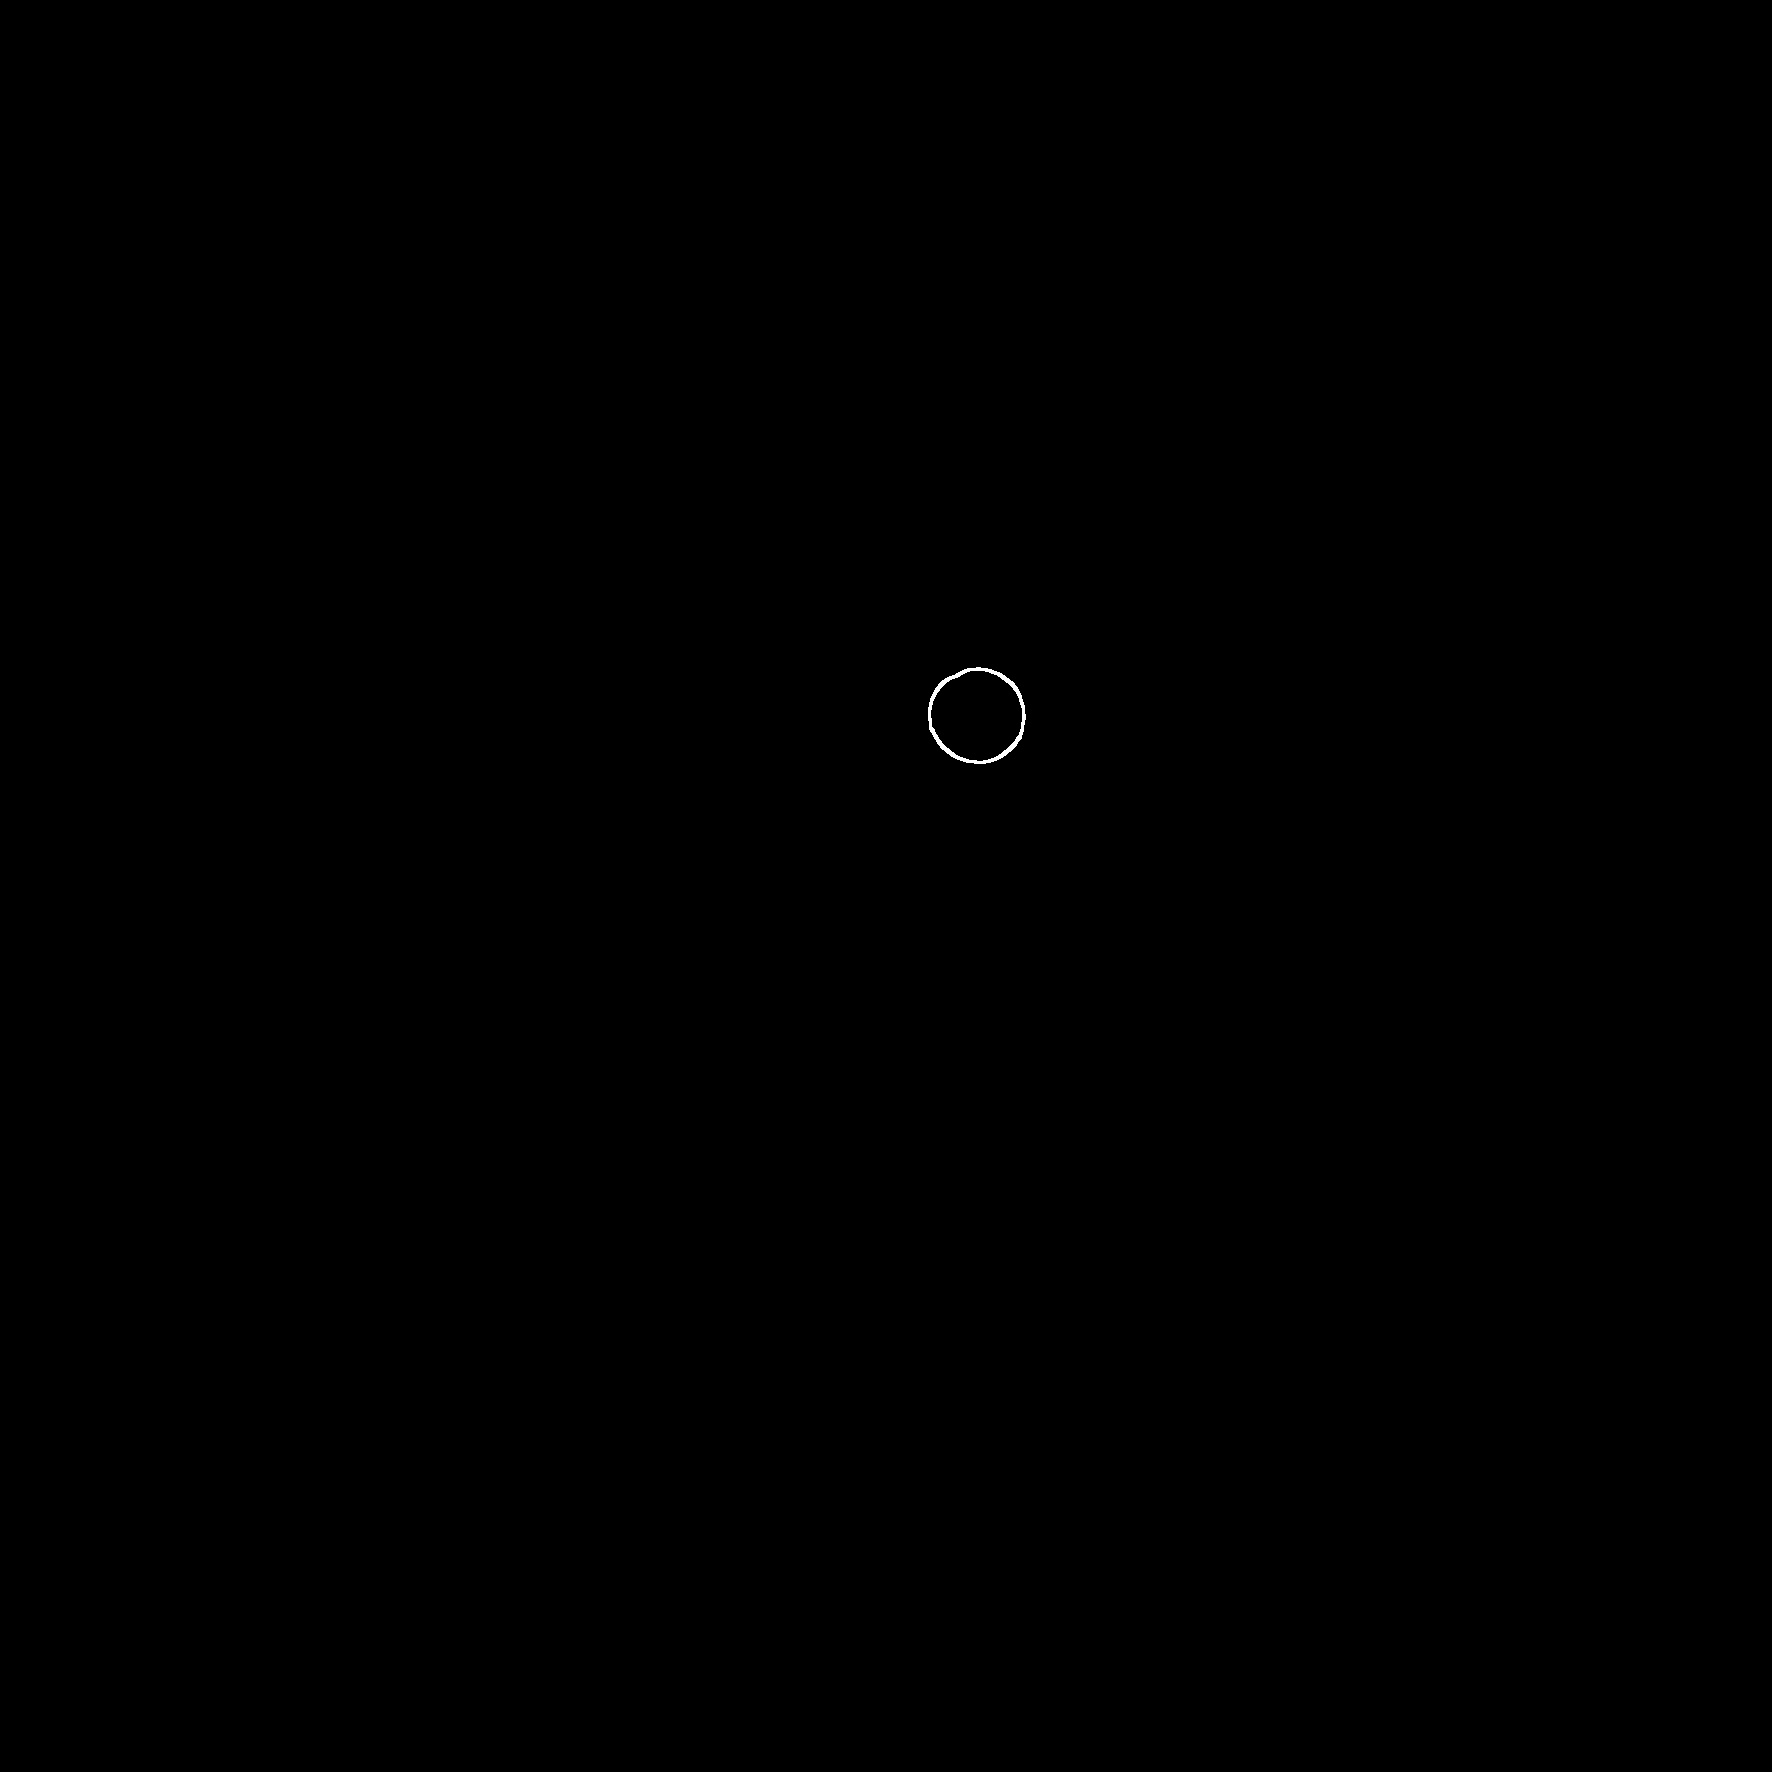

Liczba czarnych kropek: 1


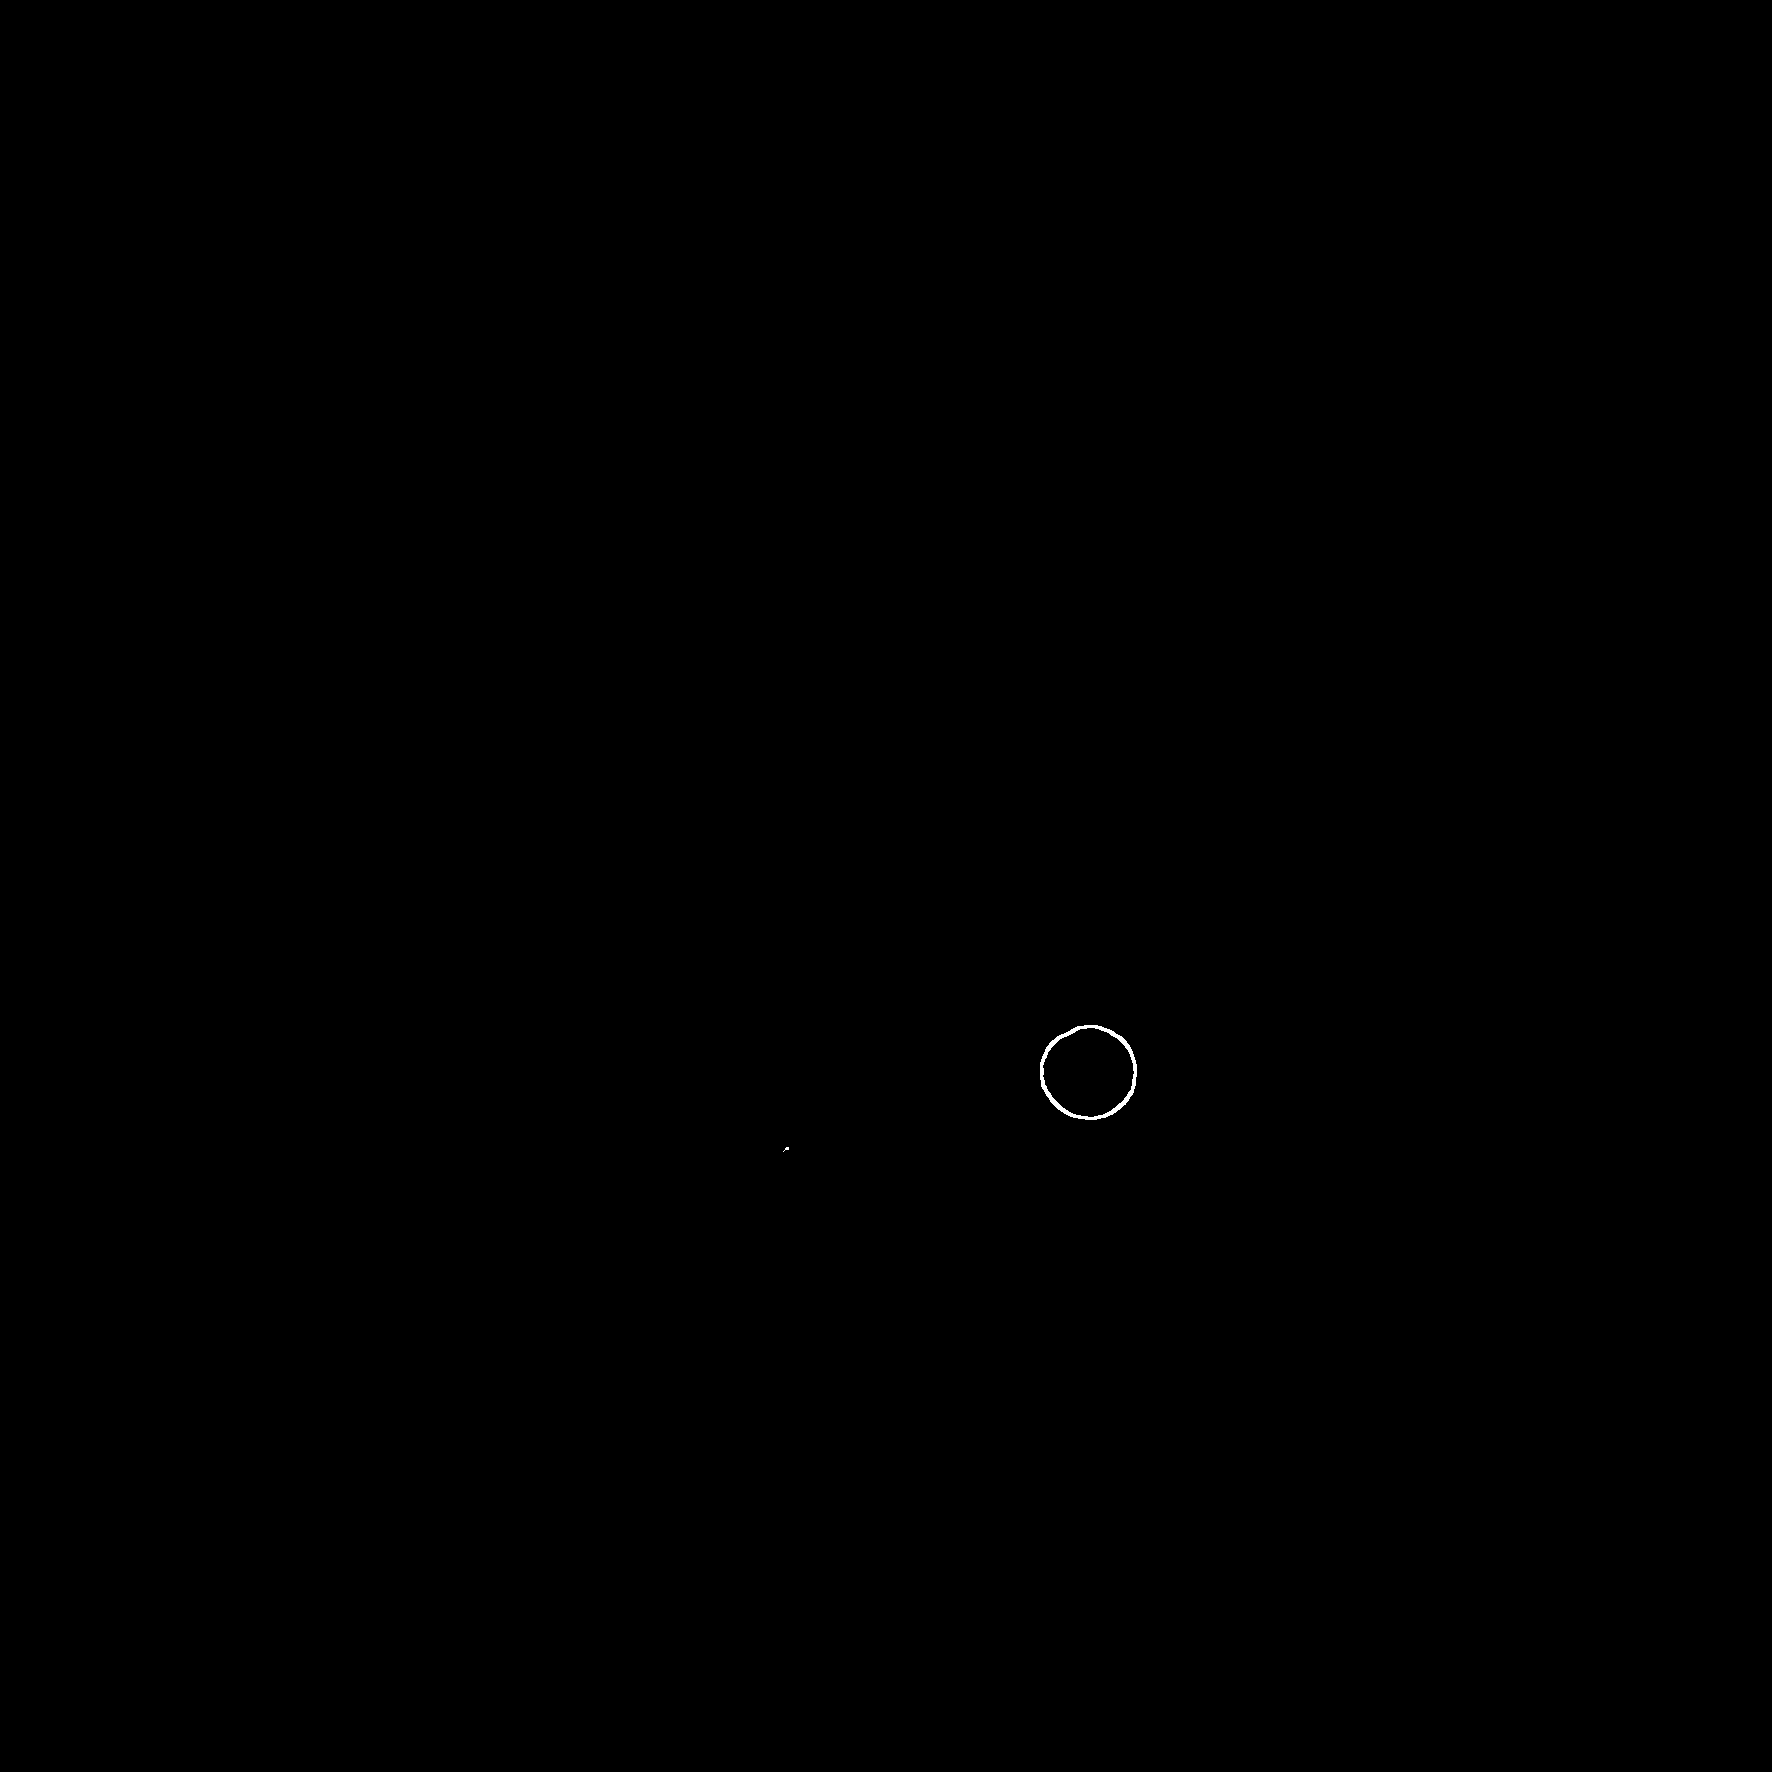

Liczba czarnych kropek: 1


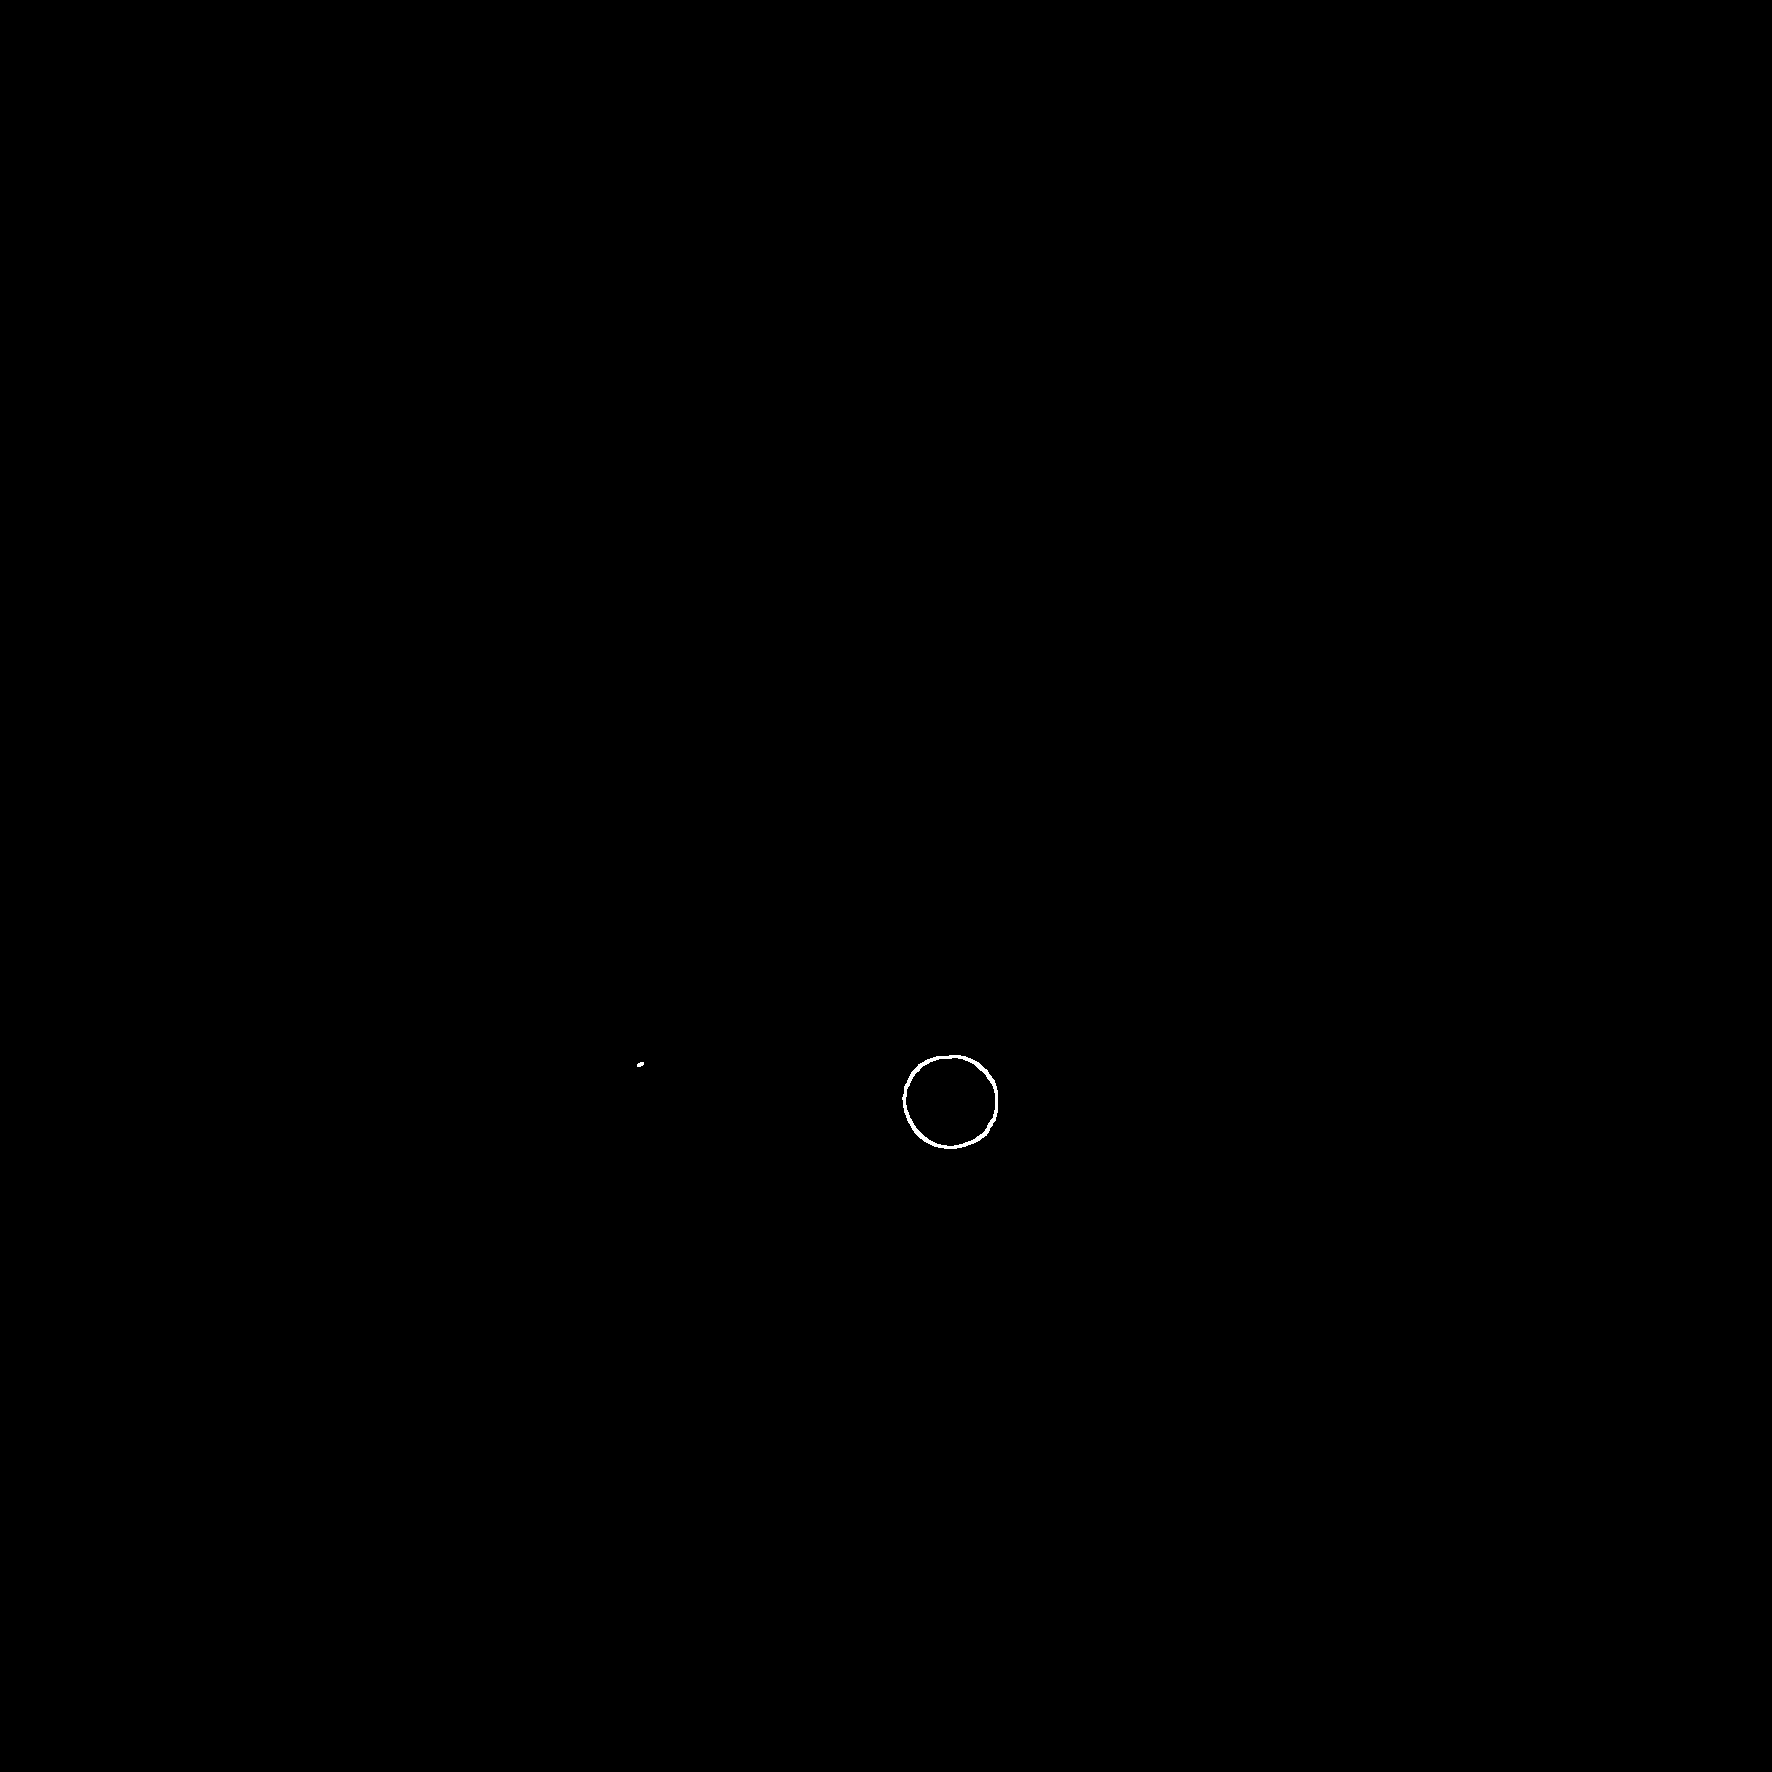

Liczba czarnych kropek: 1


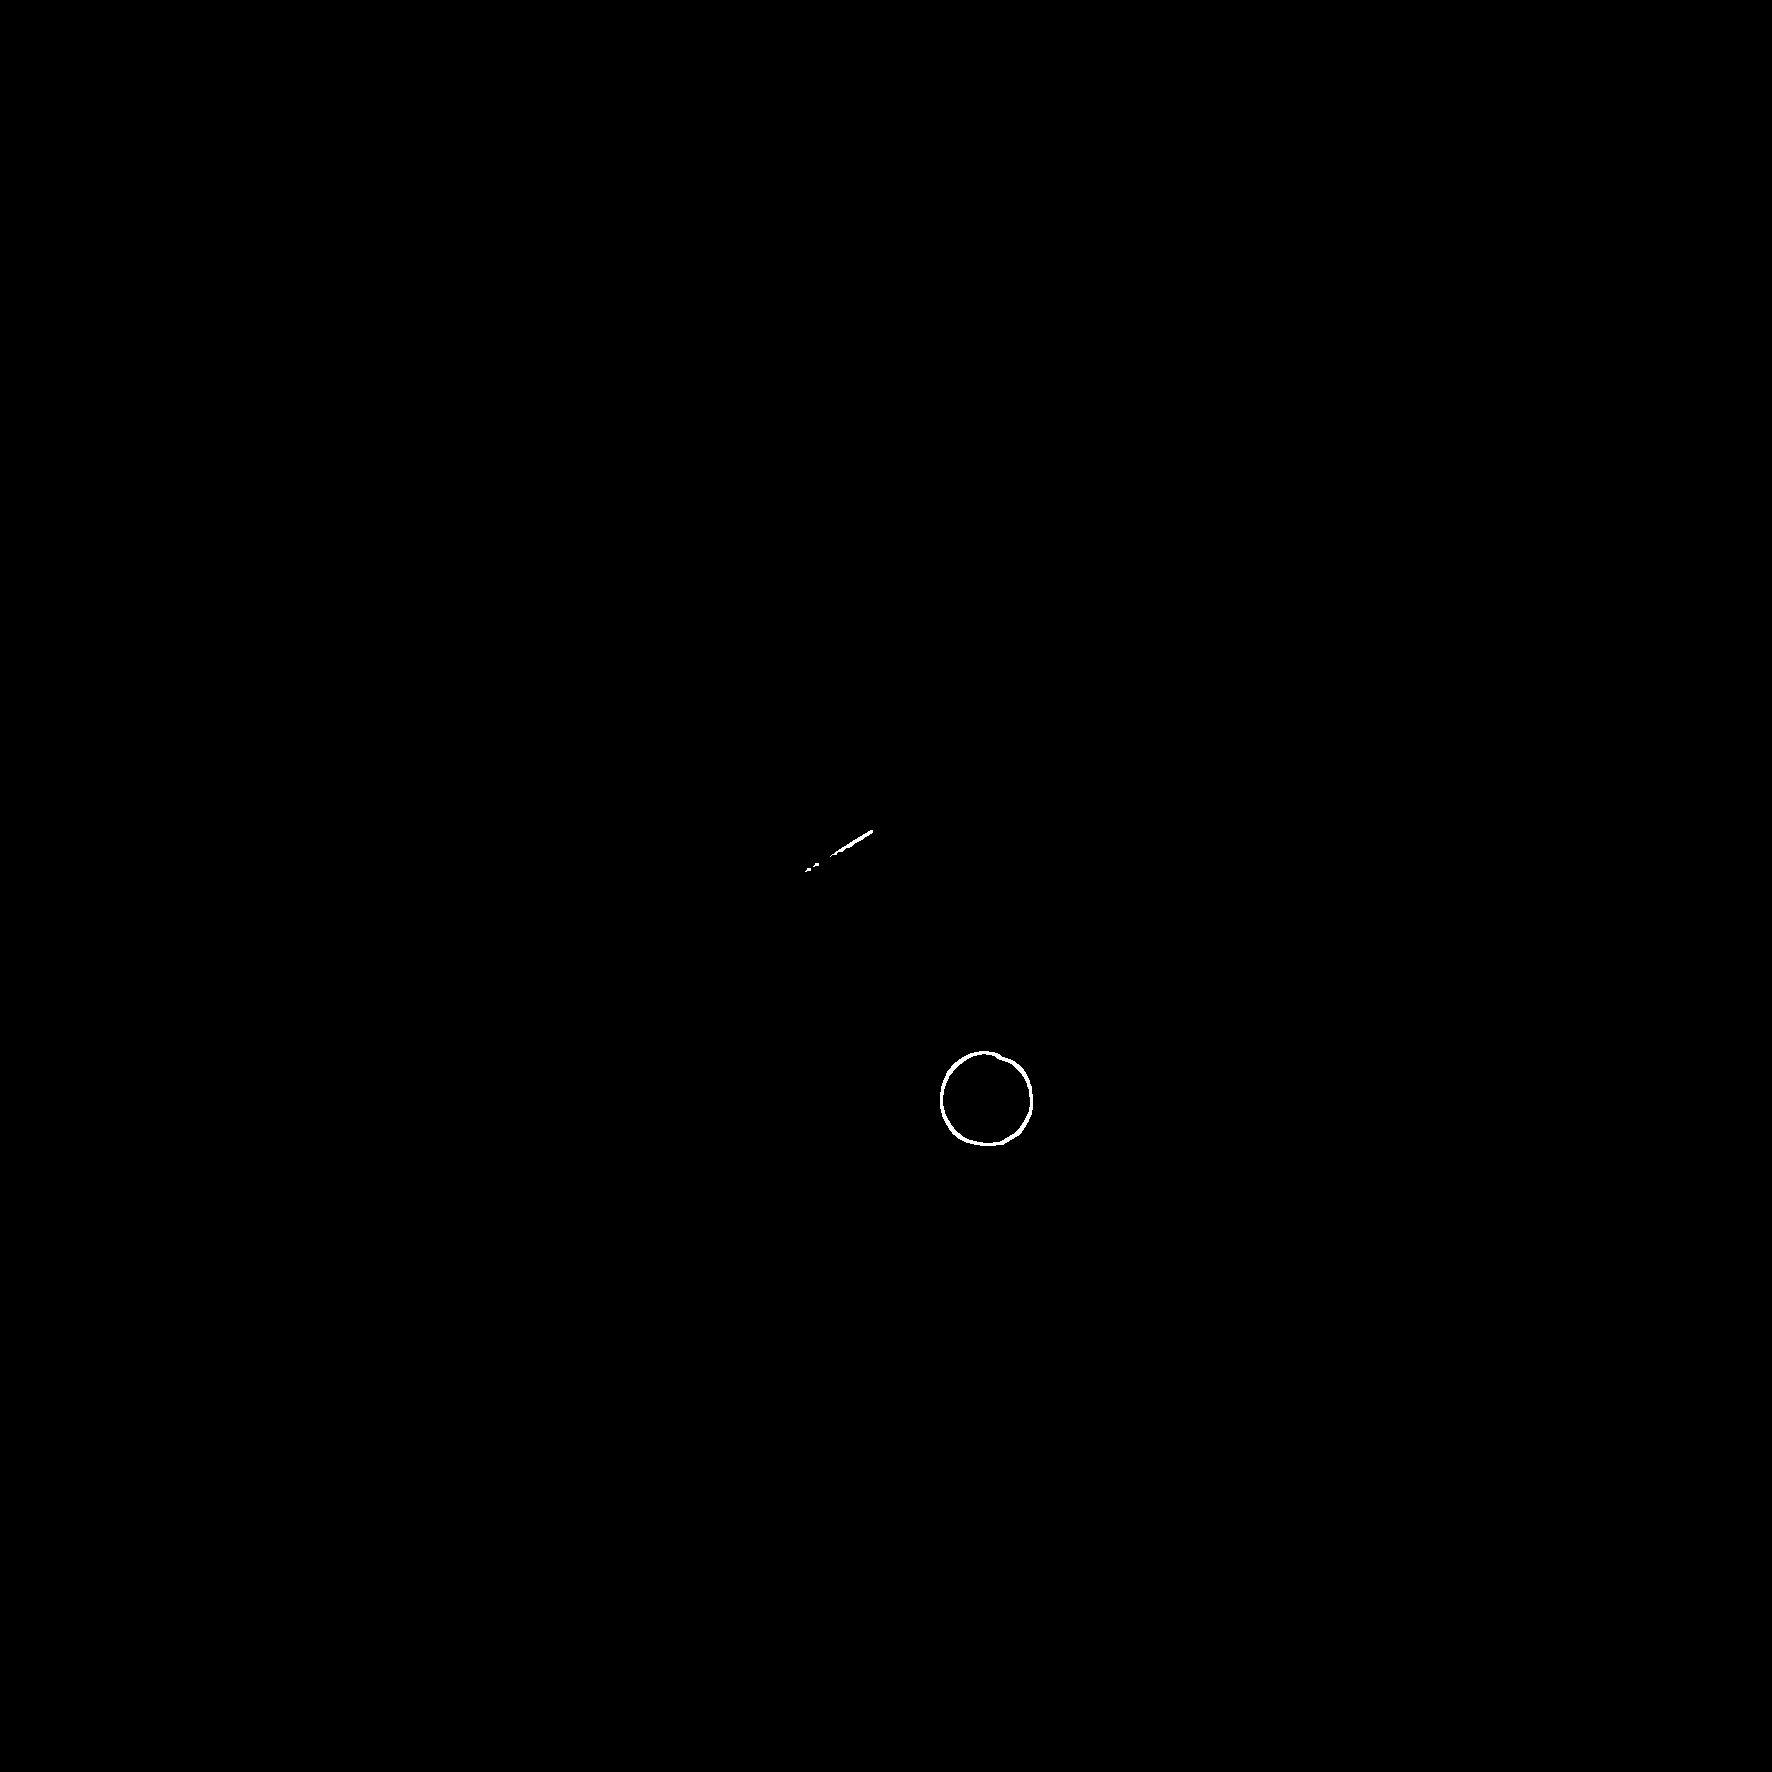

Liczba czarnych kropek: 1


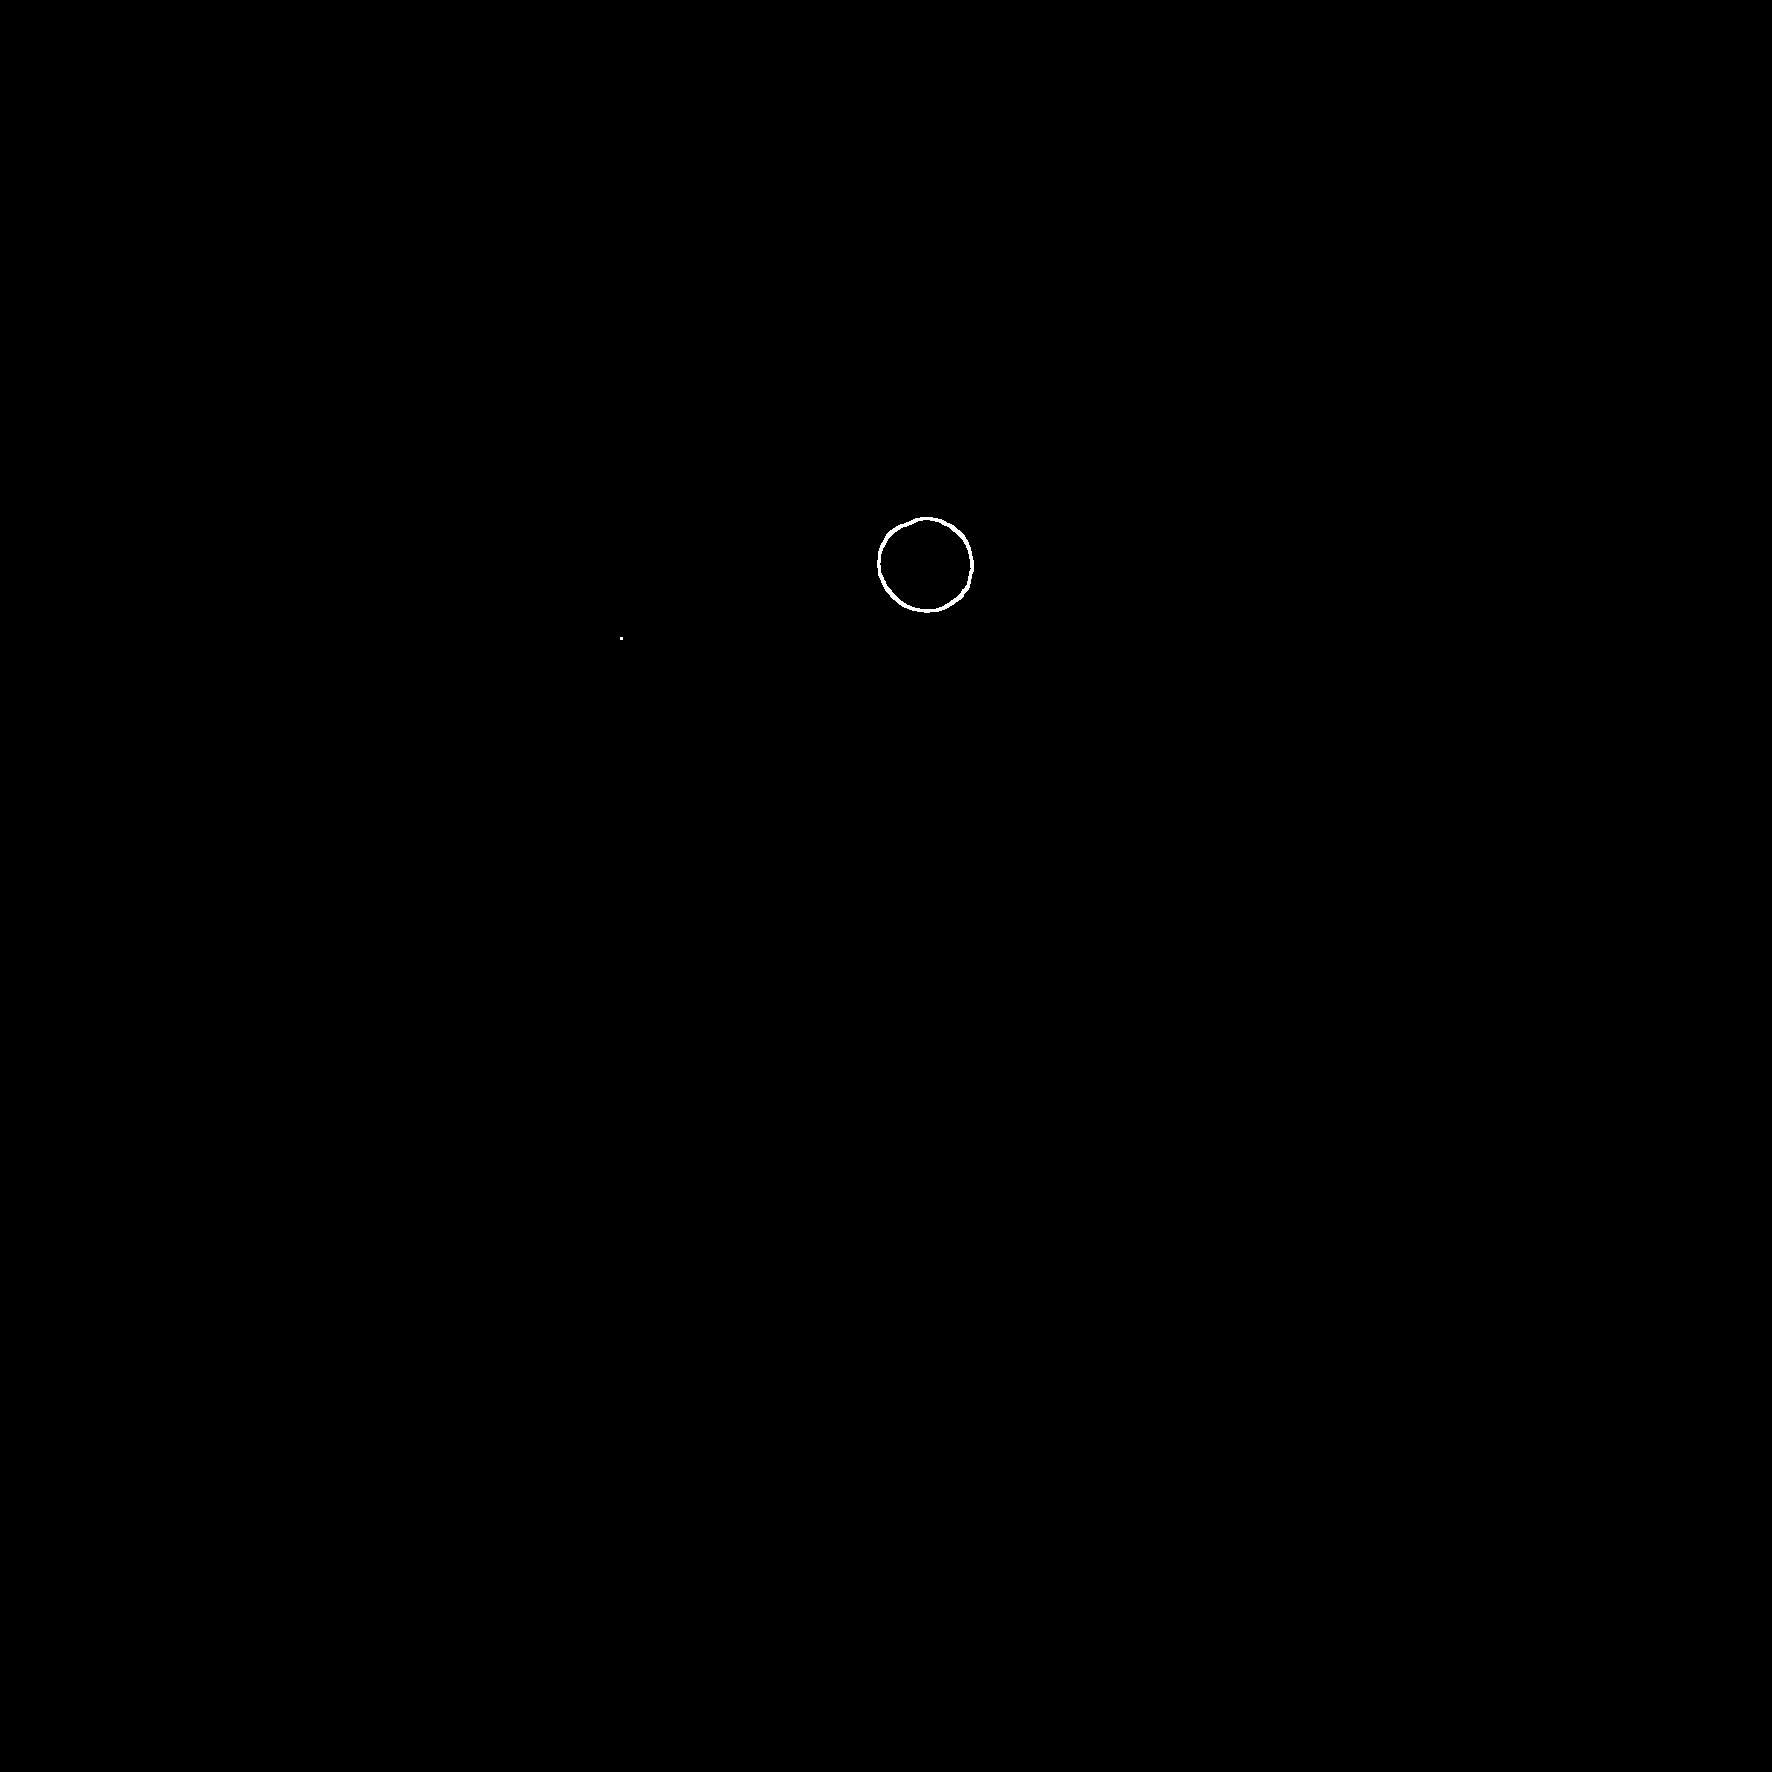

Liczba czarnych kropek: 1


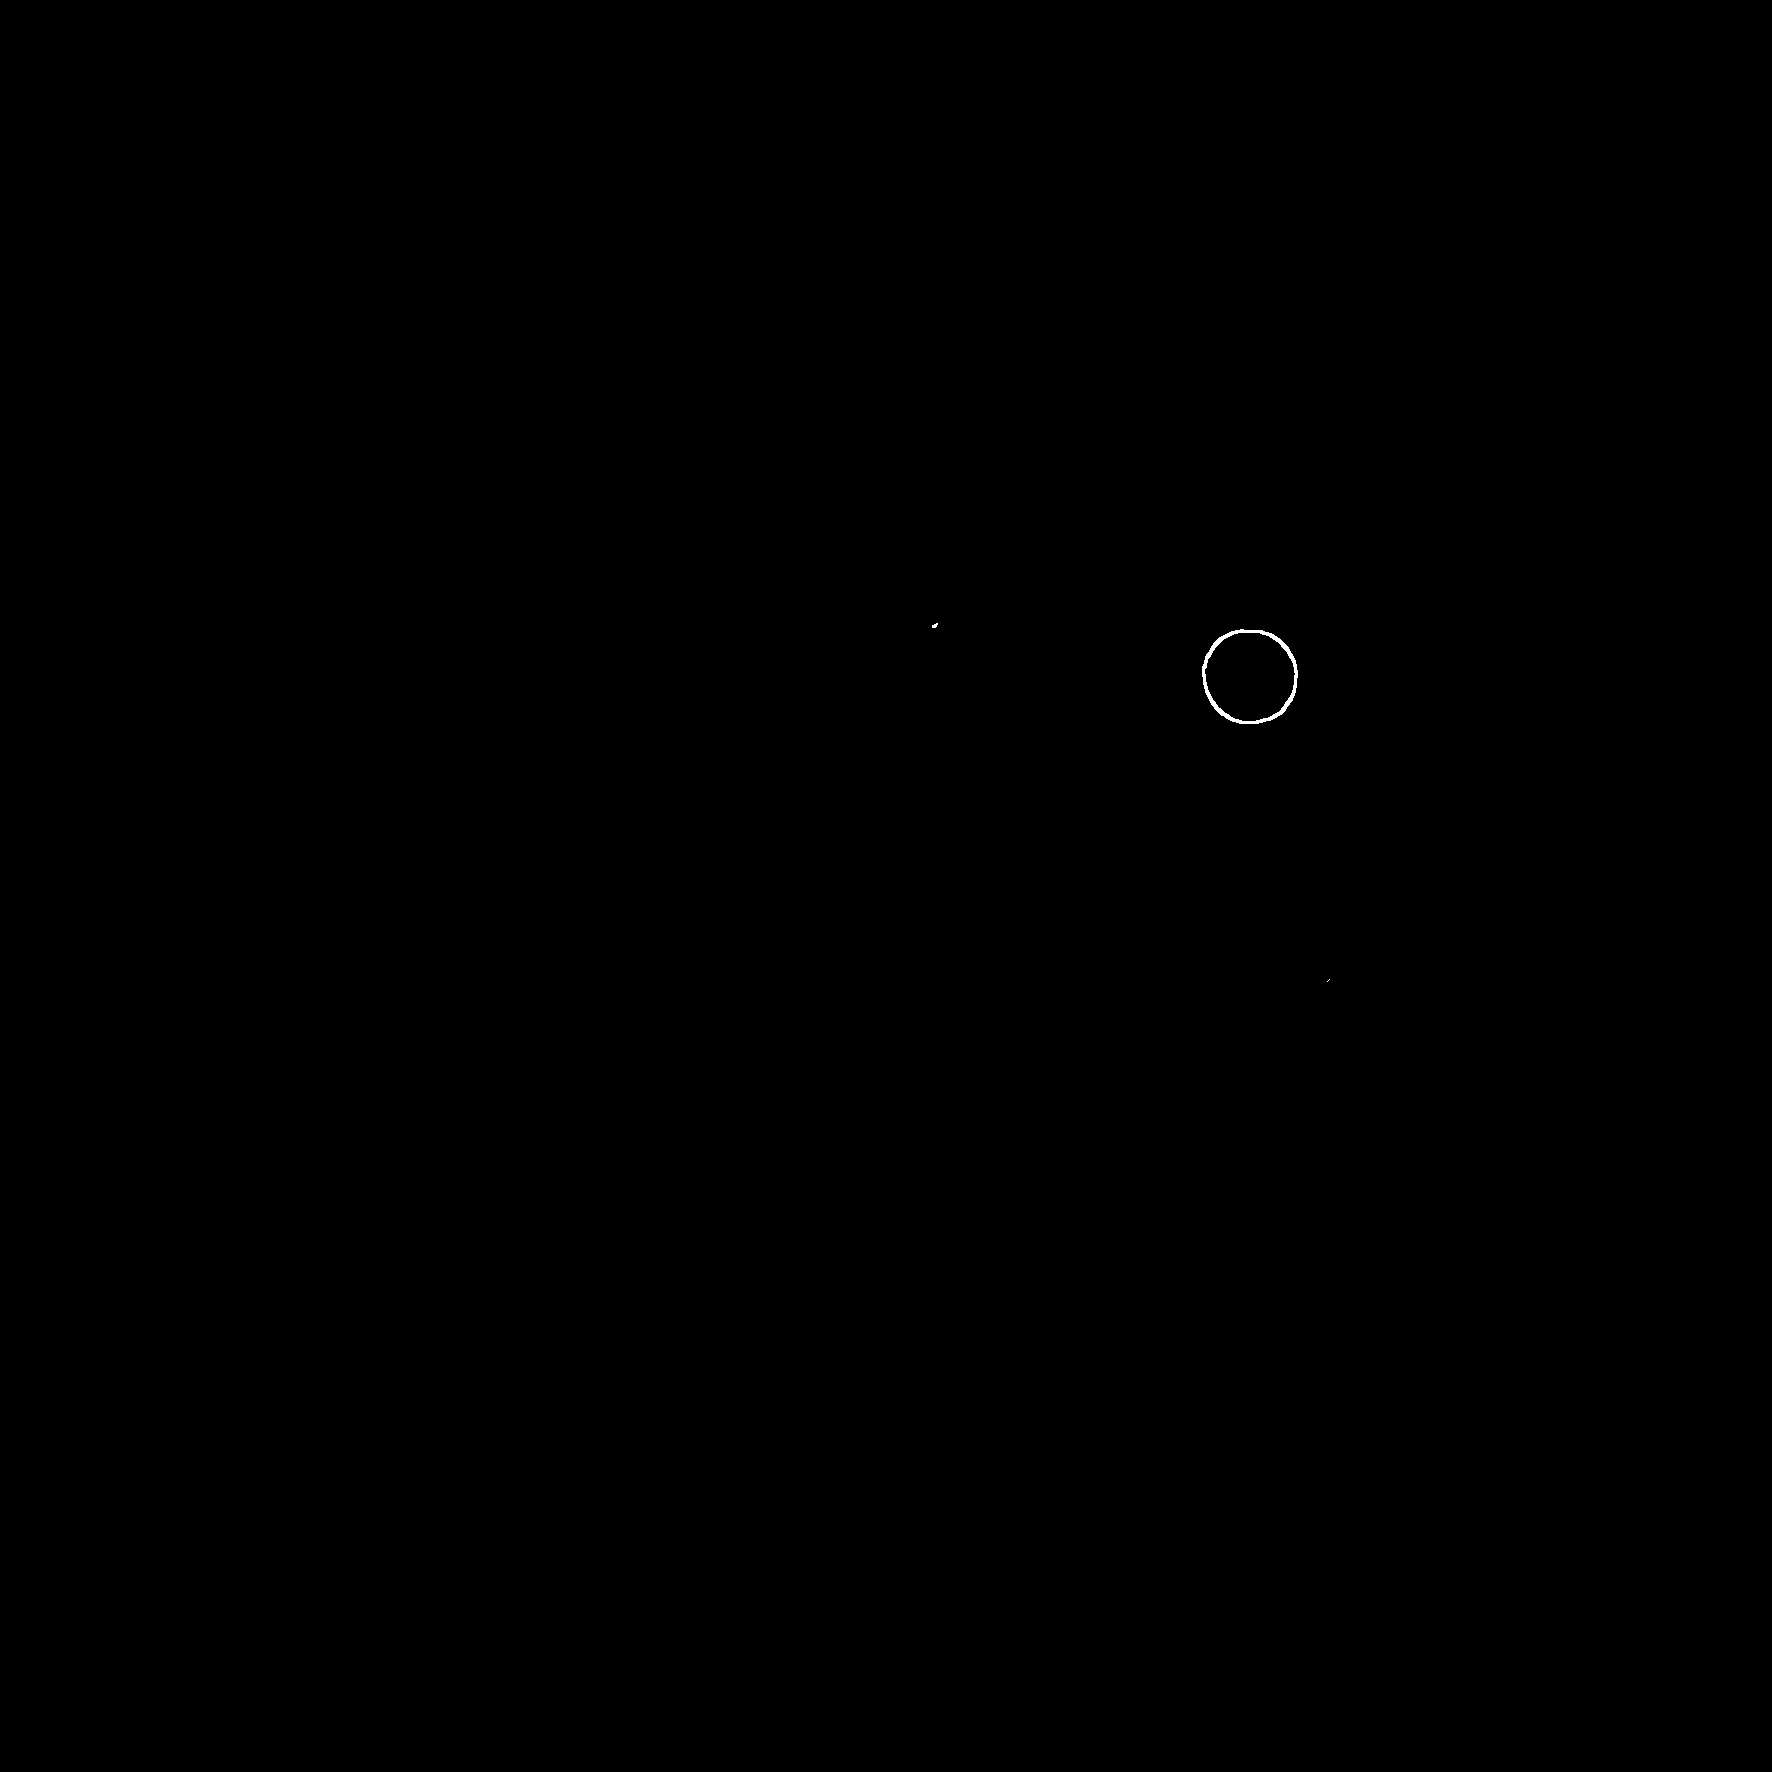

Liczba czarnych kropek: 1


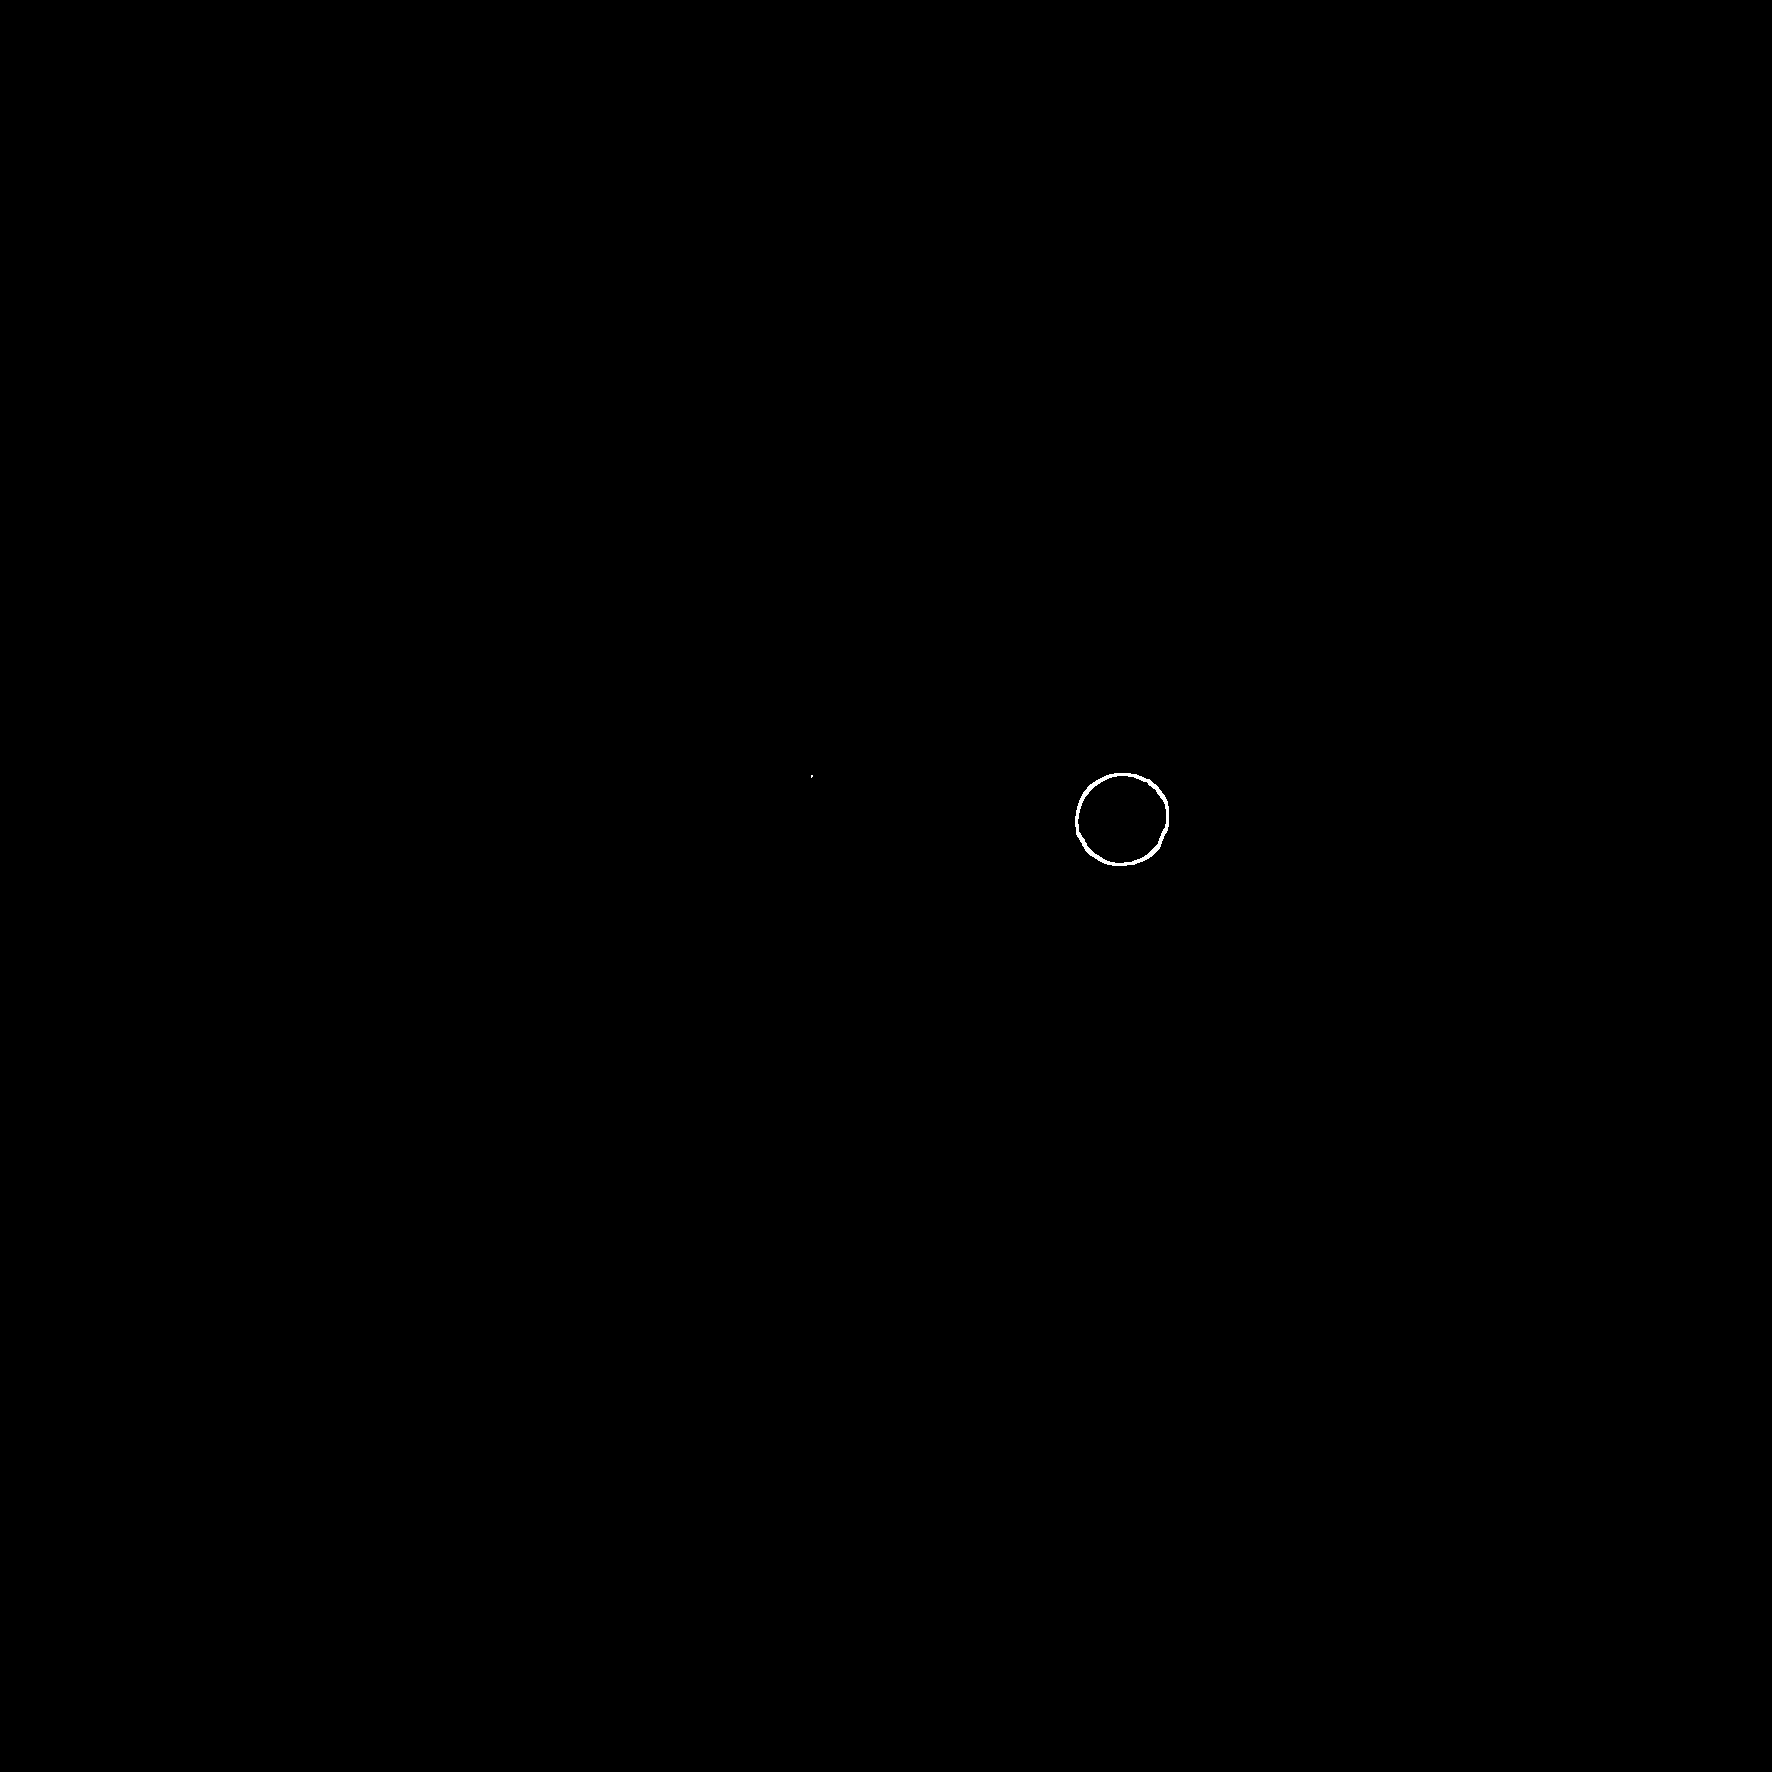

Liczba czarnych kropek: 1


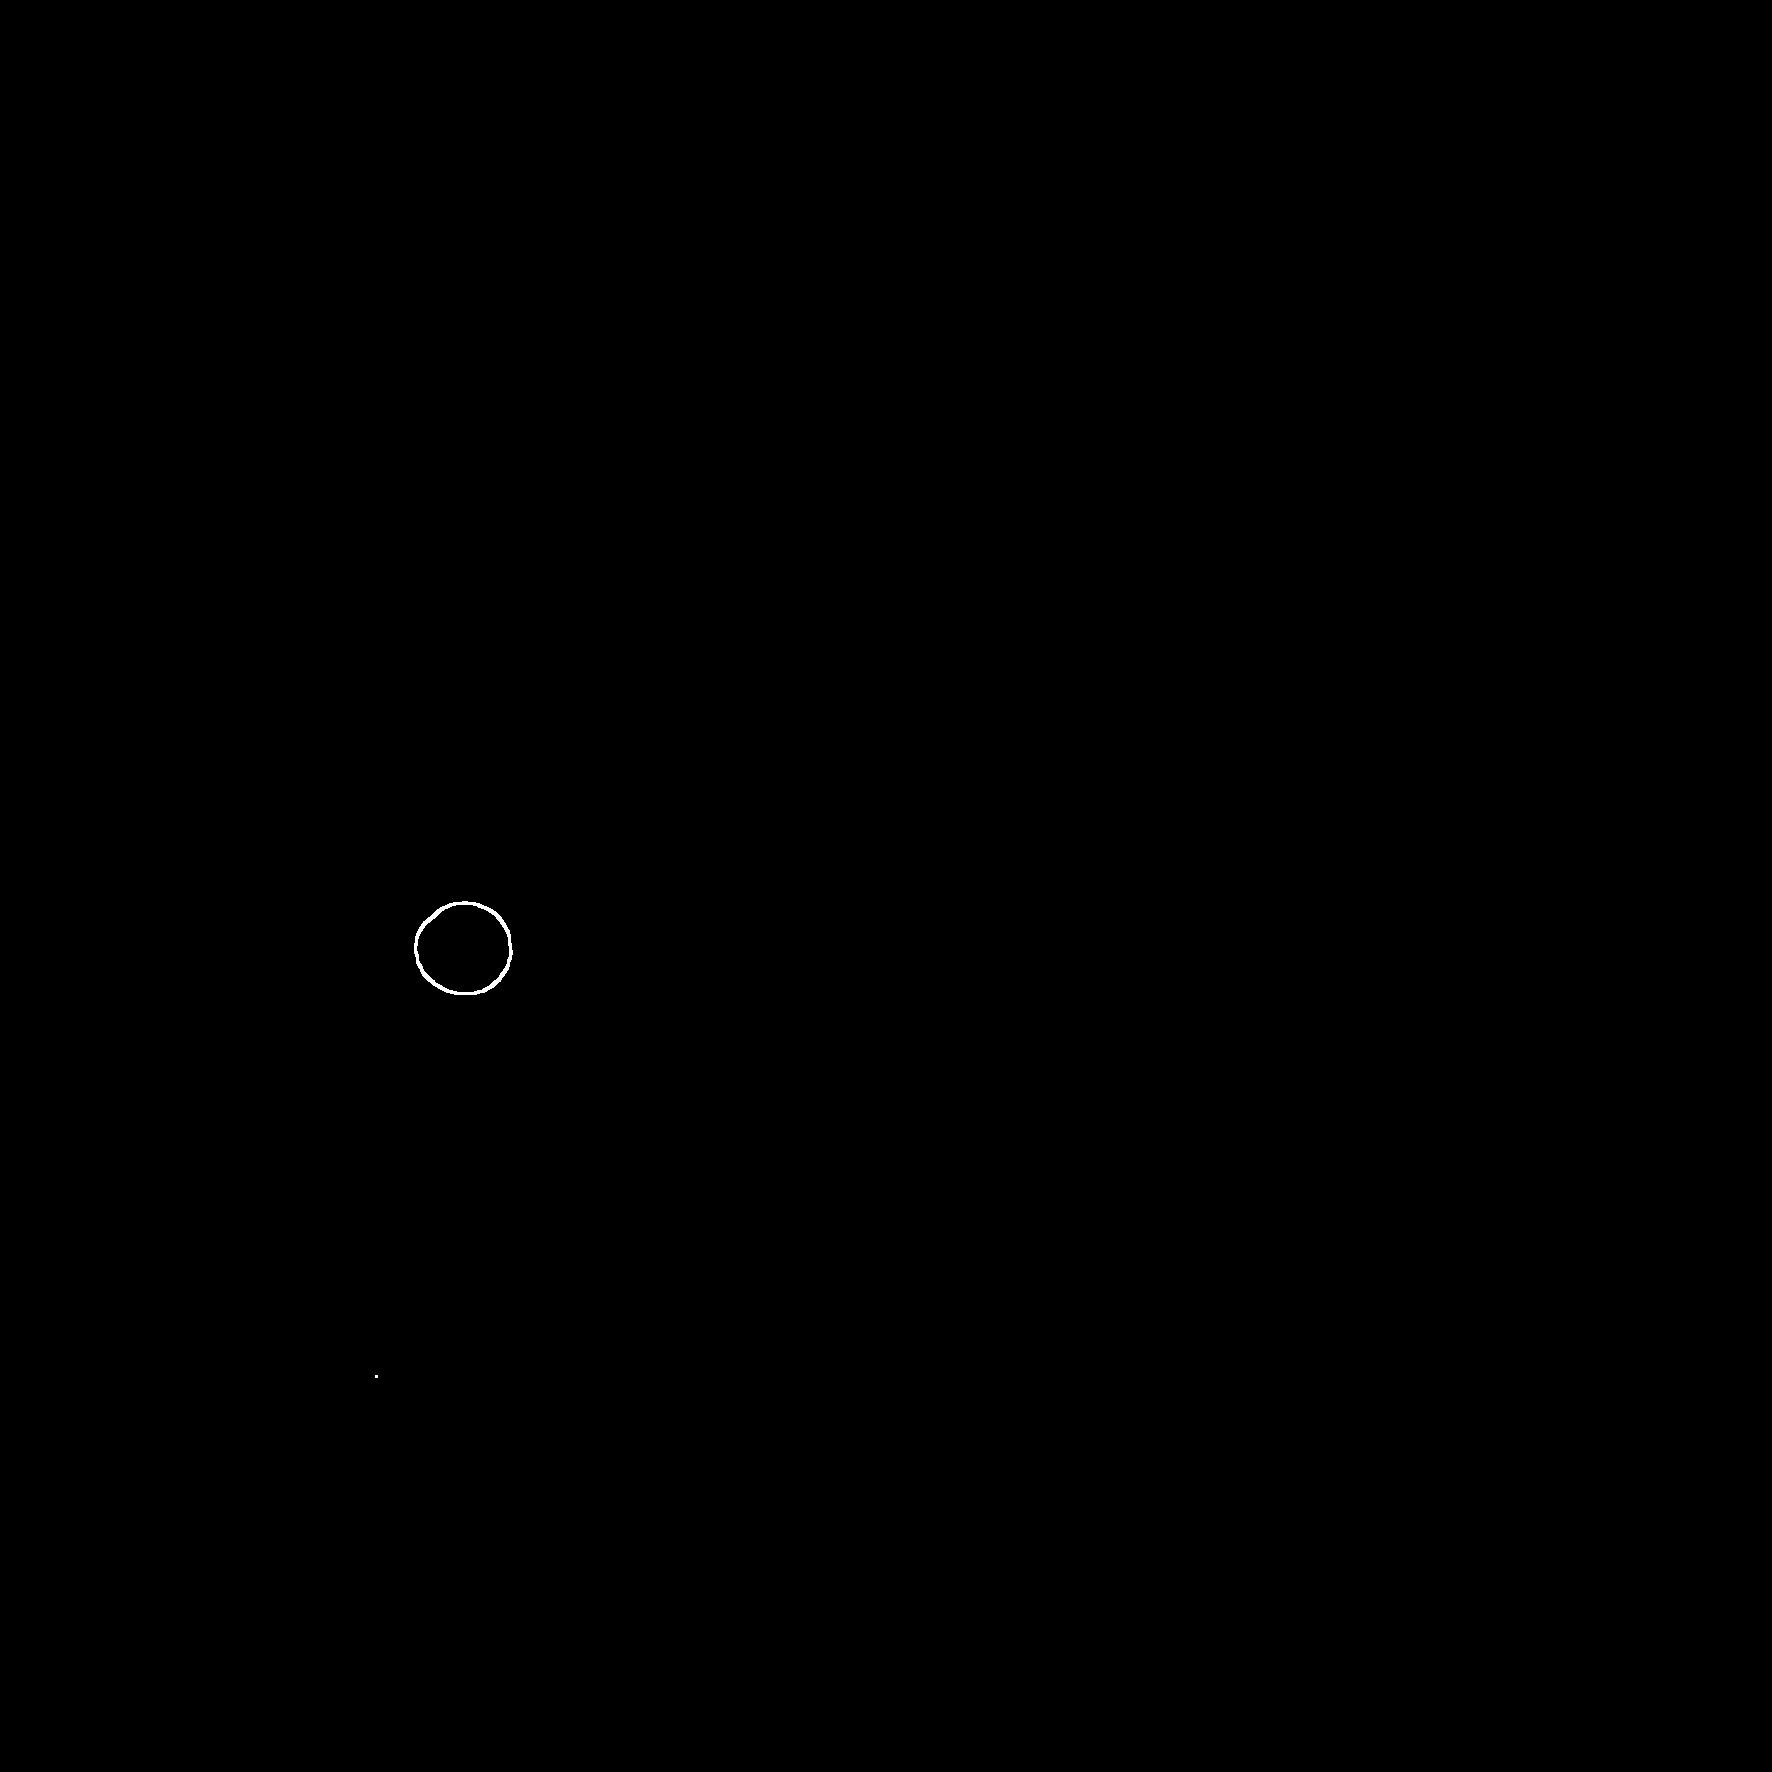

Liczba czarnych kropek: 1


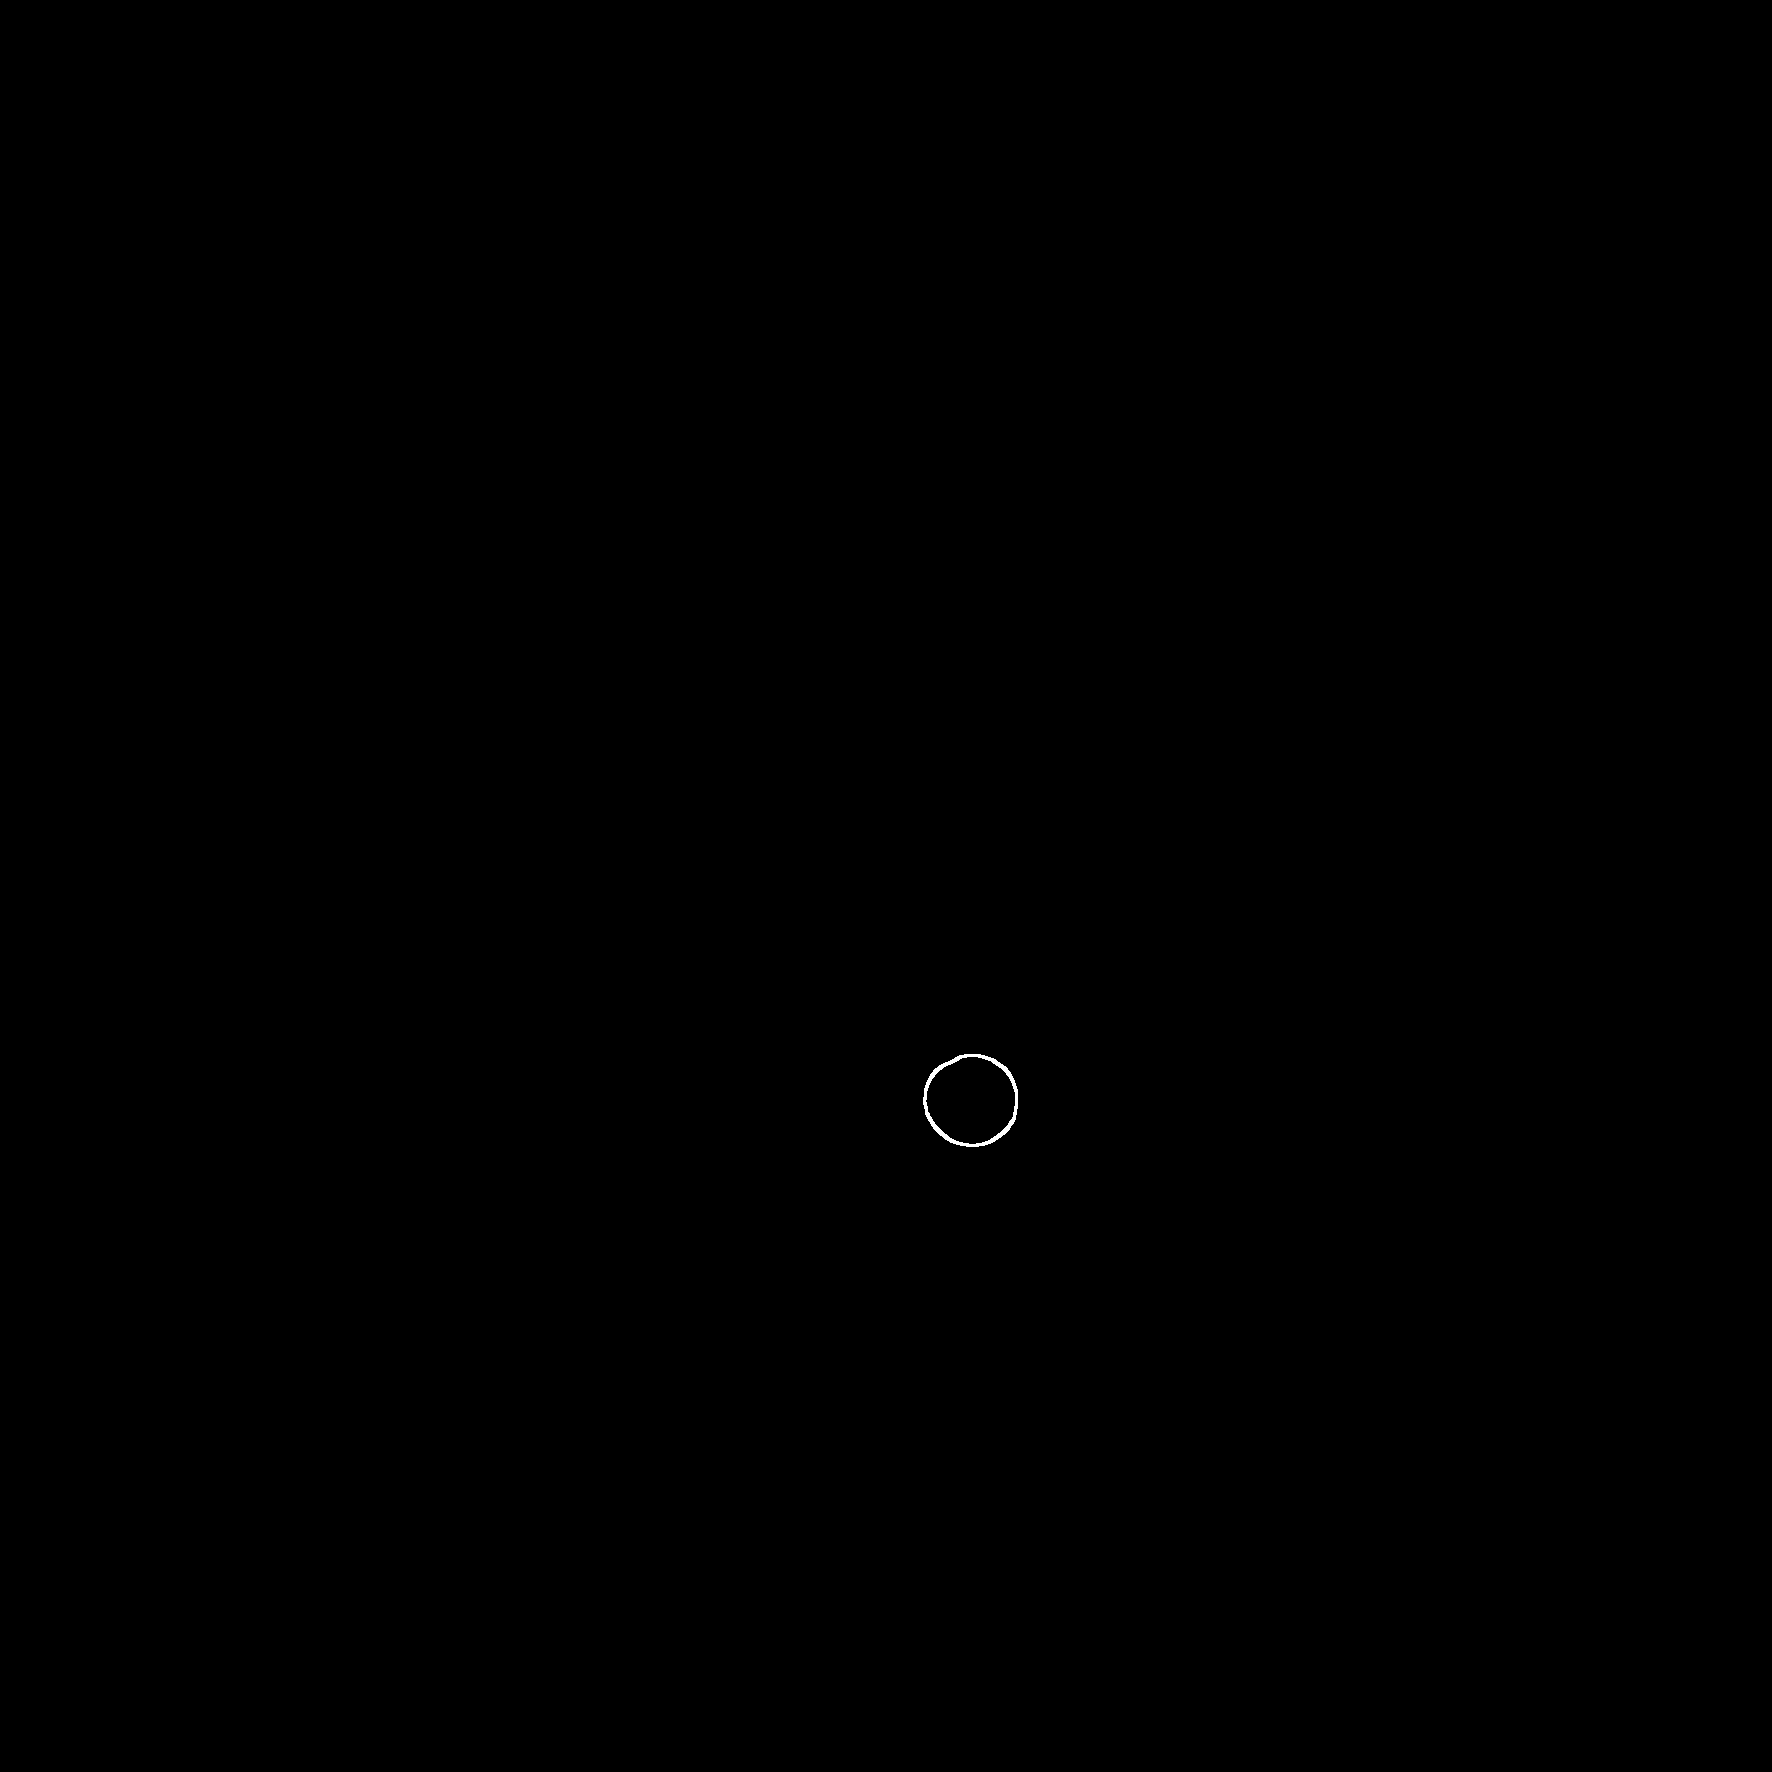

Liczba czarnych kropek: 1


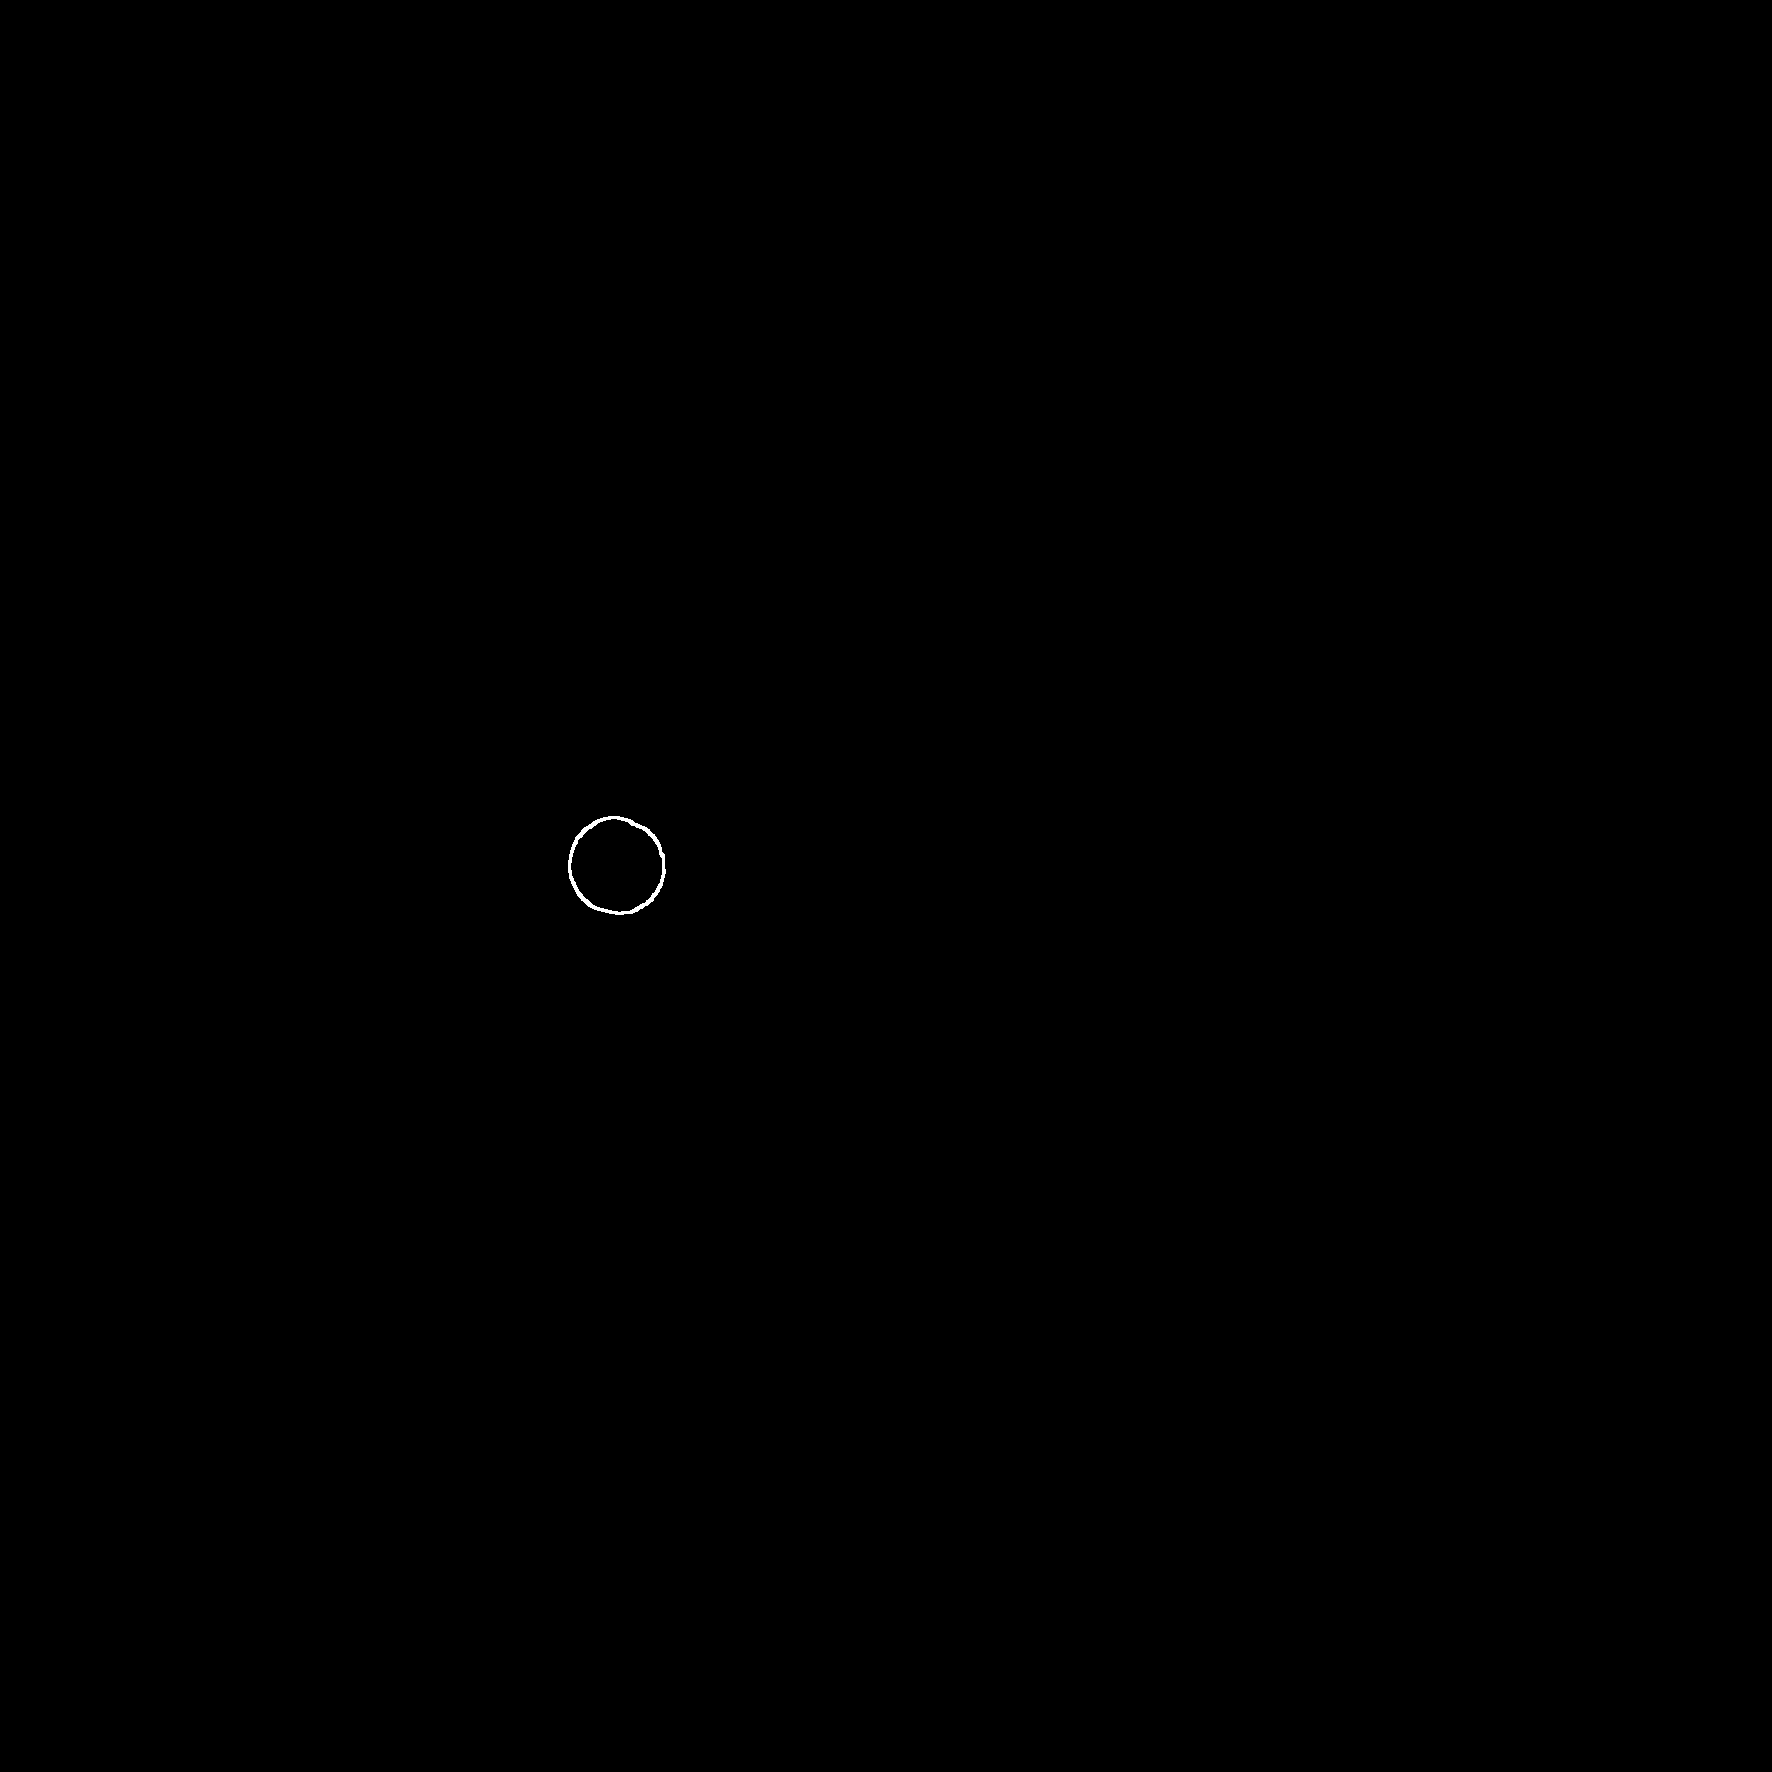

Liczba czarnych kropek: 1


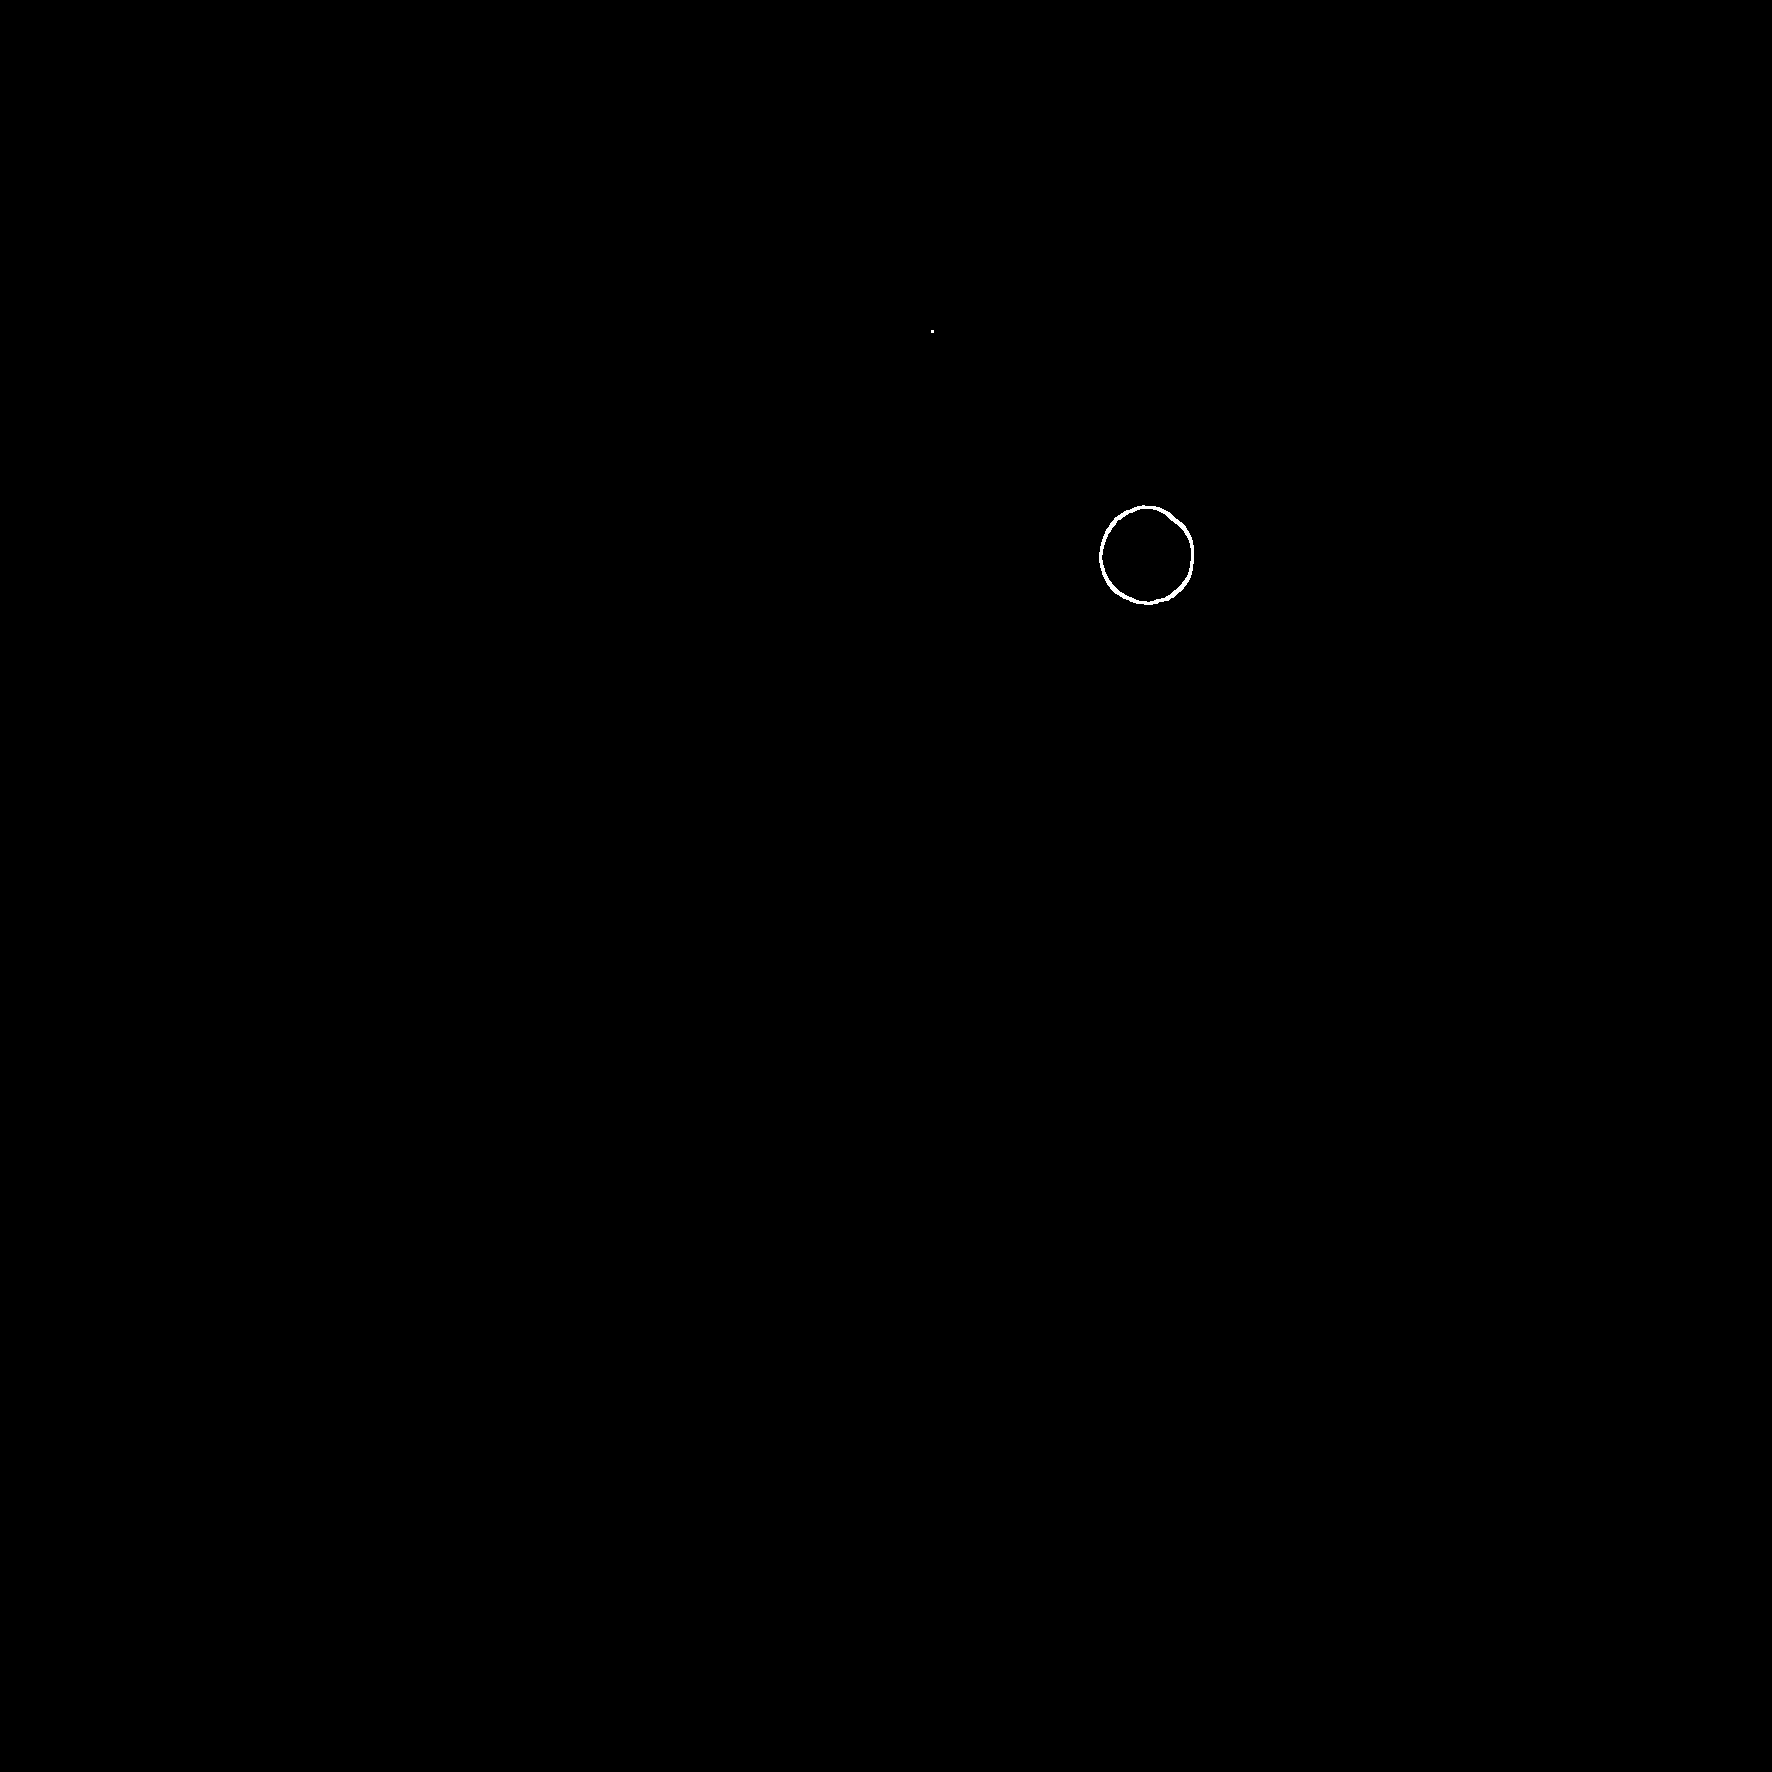

Liczba czarnych kropek: 1


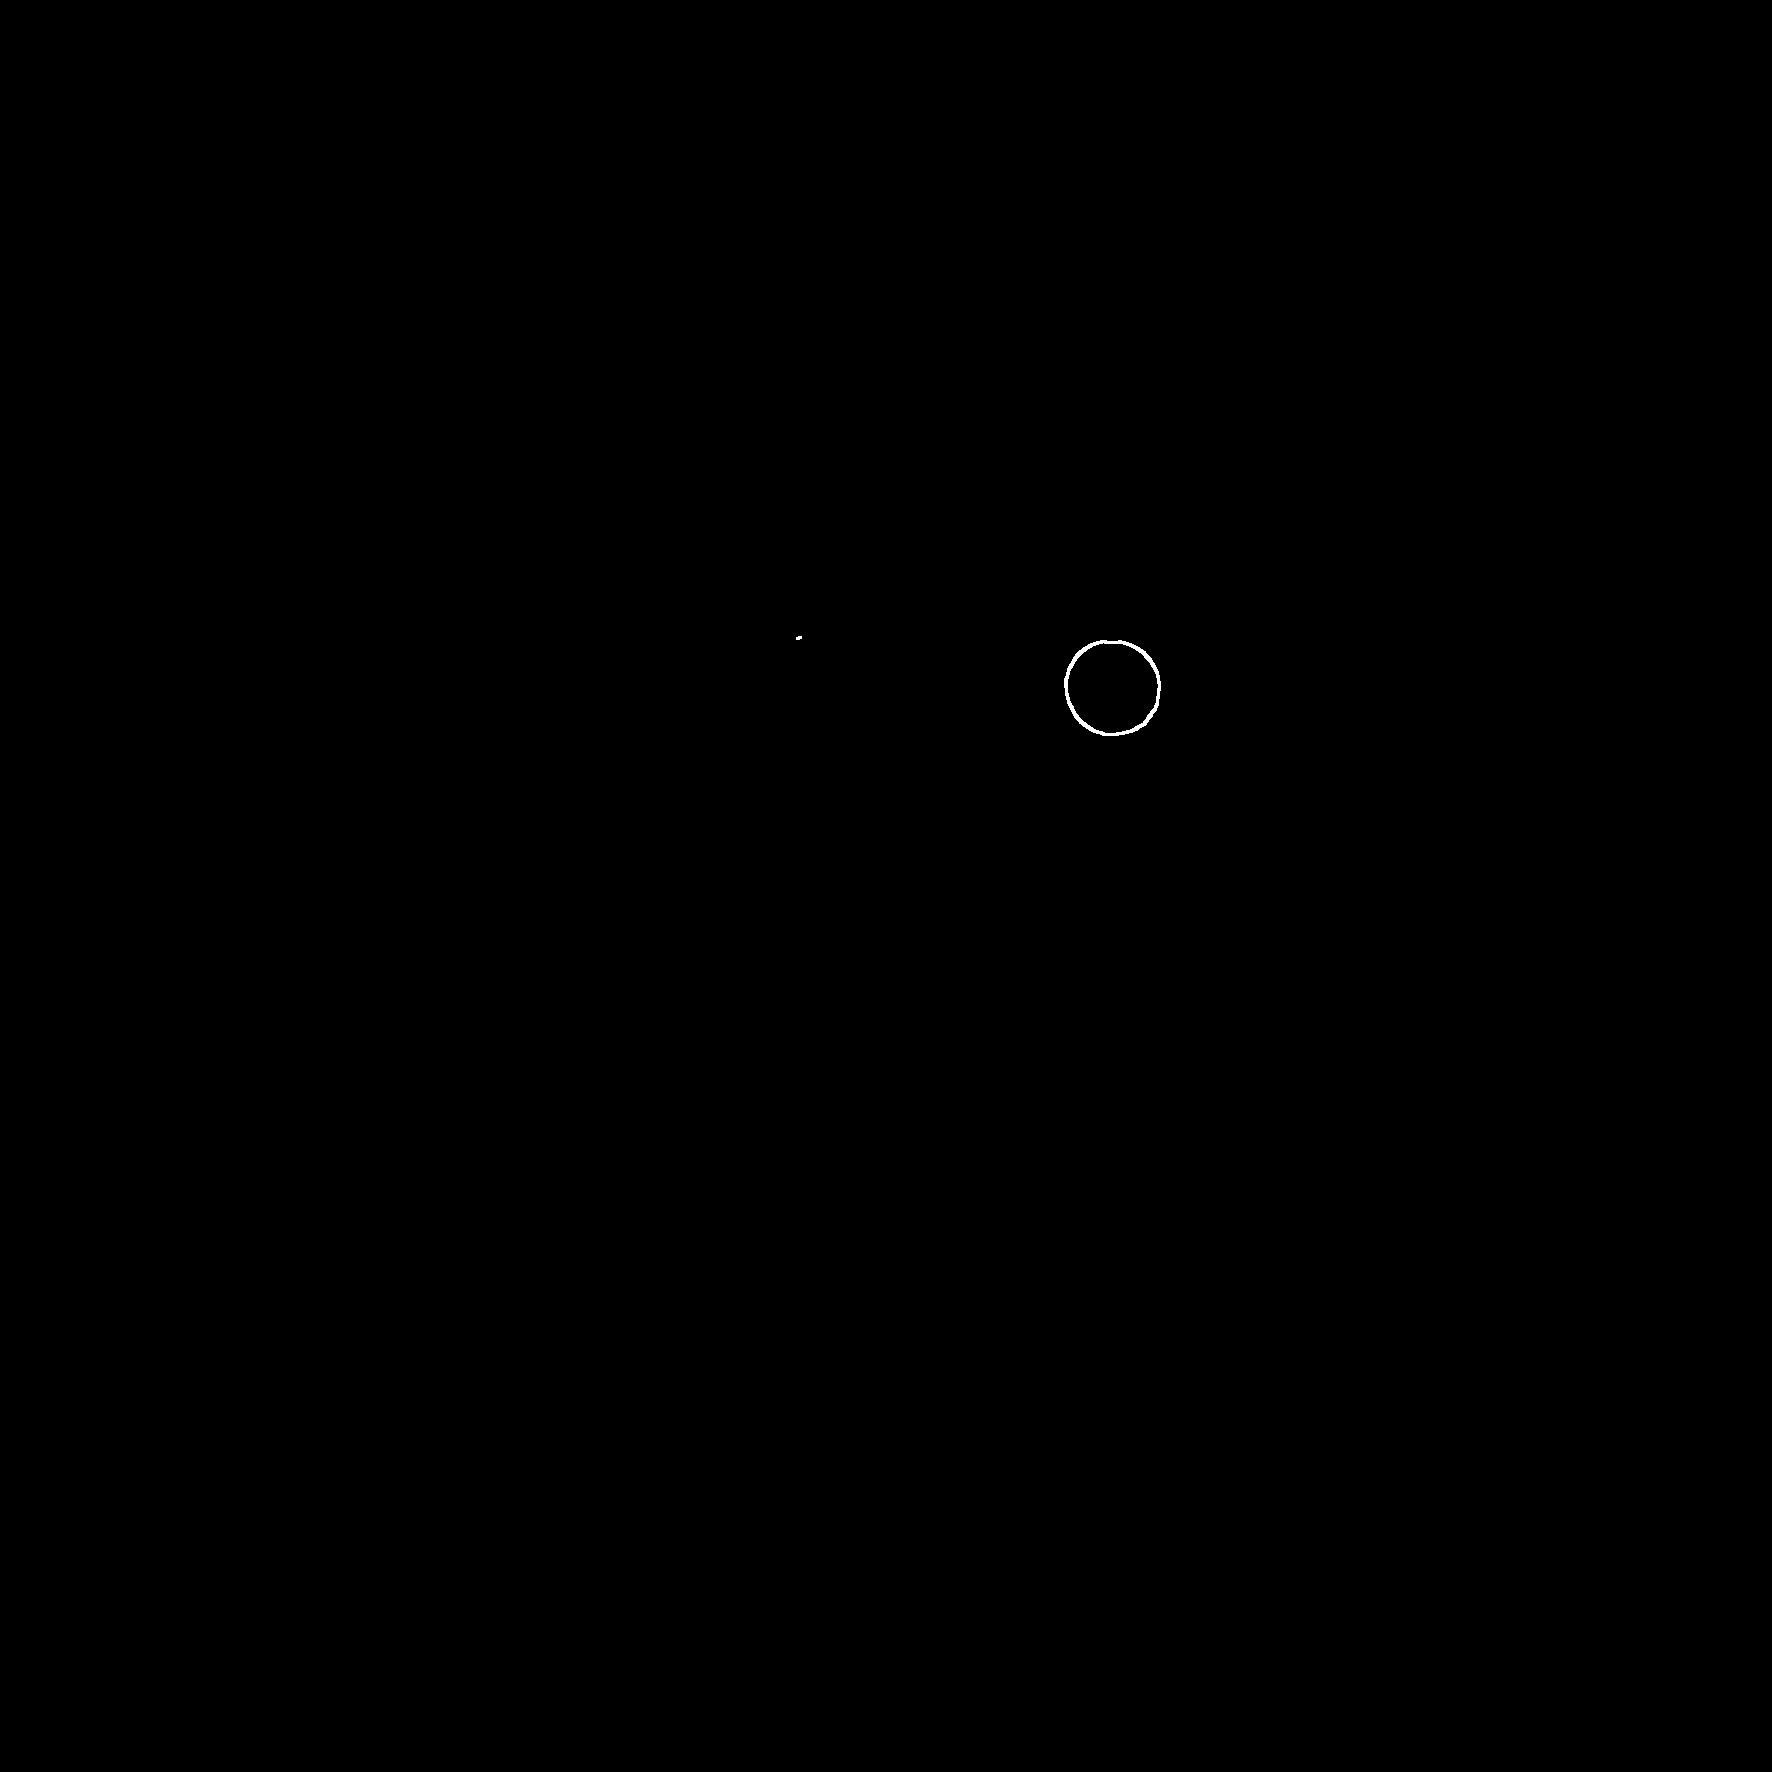

Liczba czarnych kropek: 1


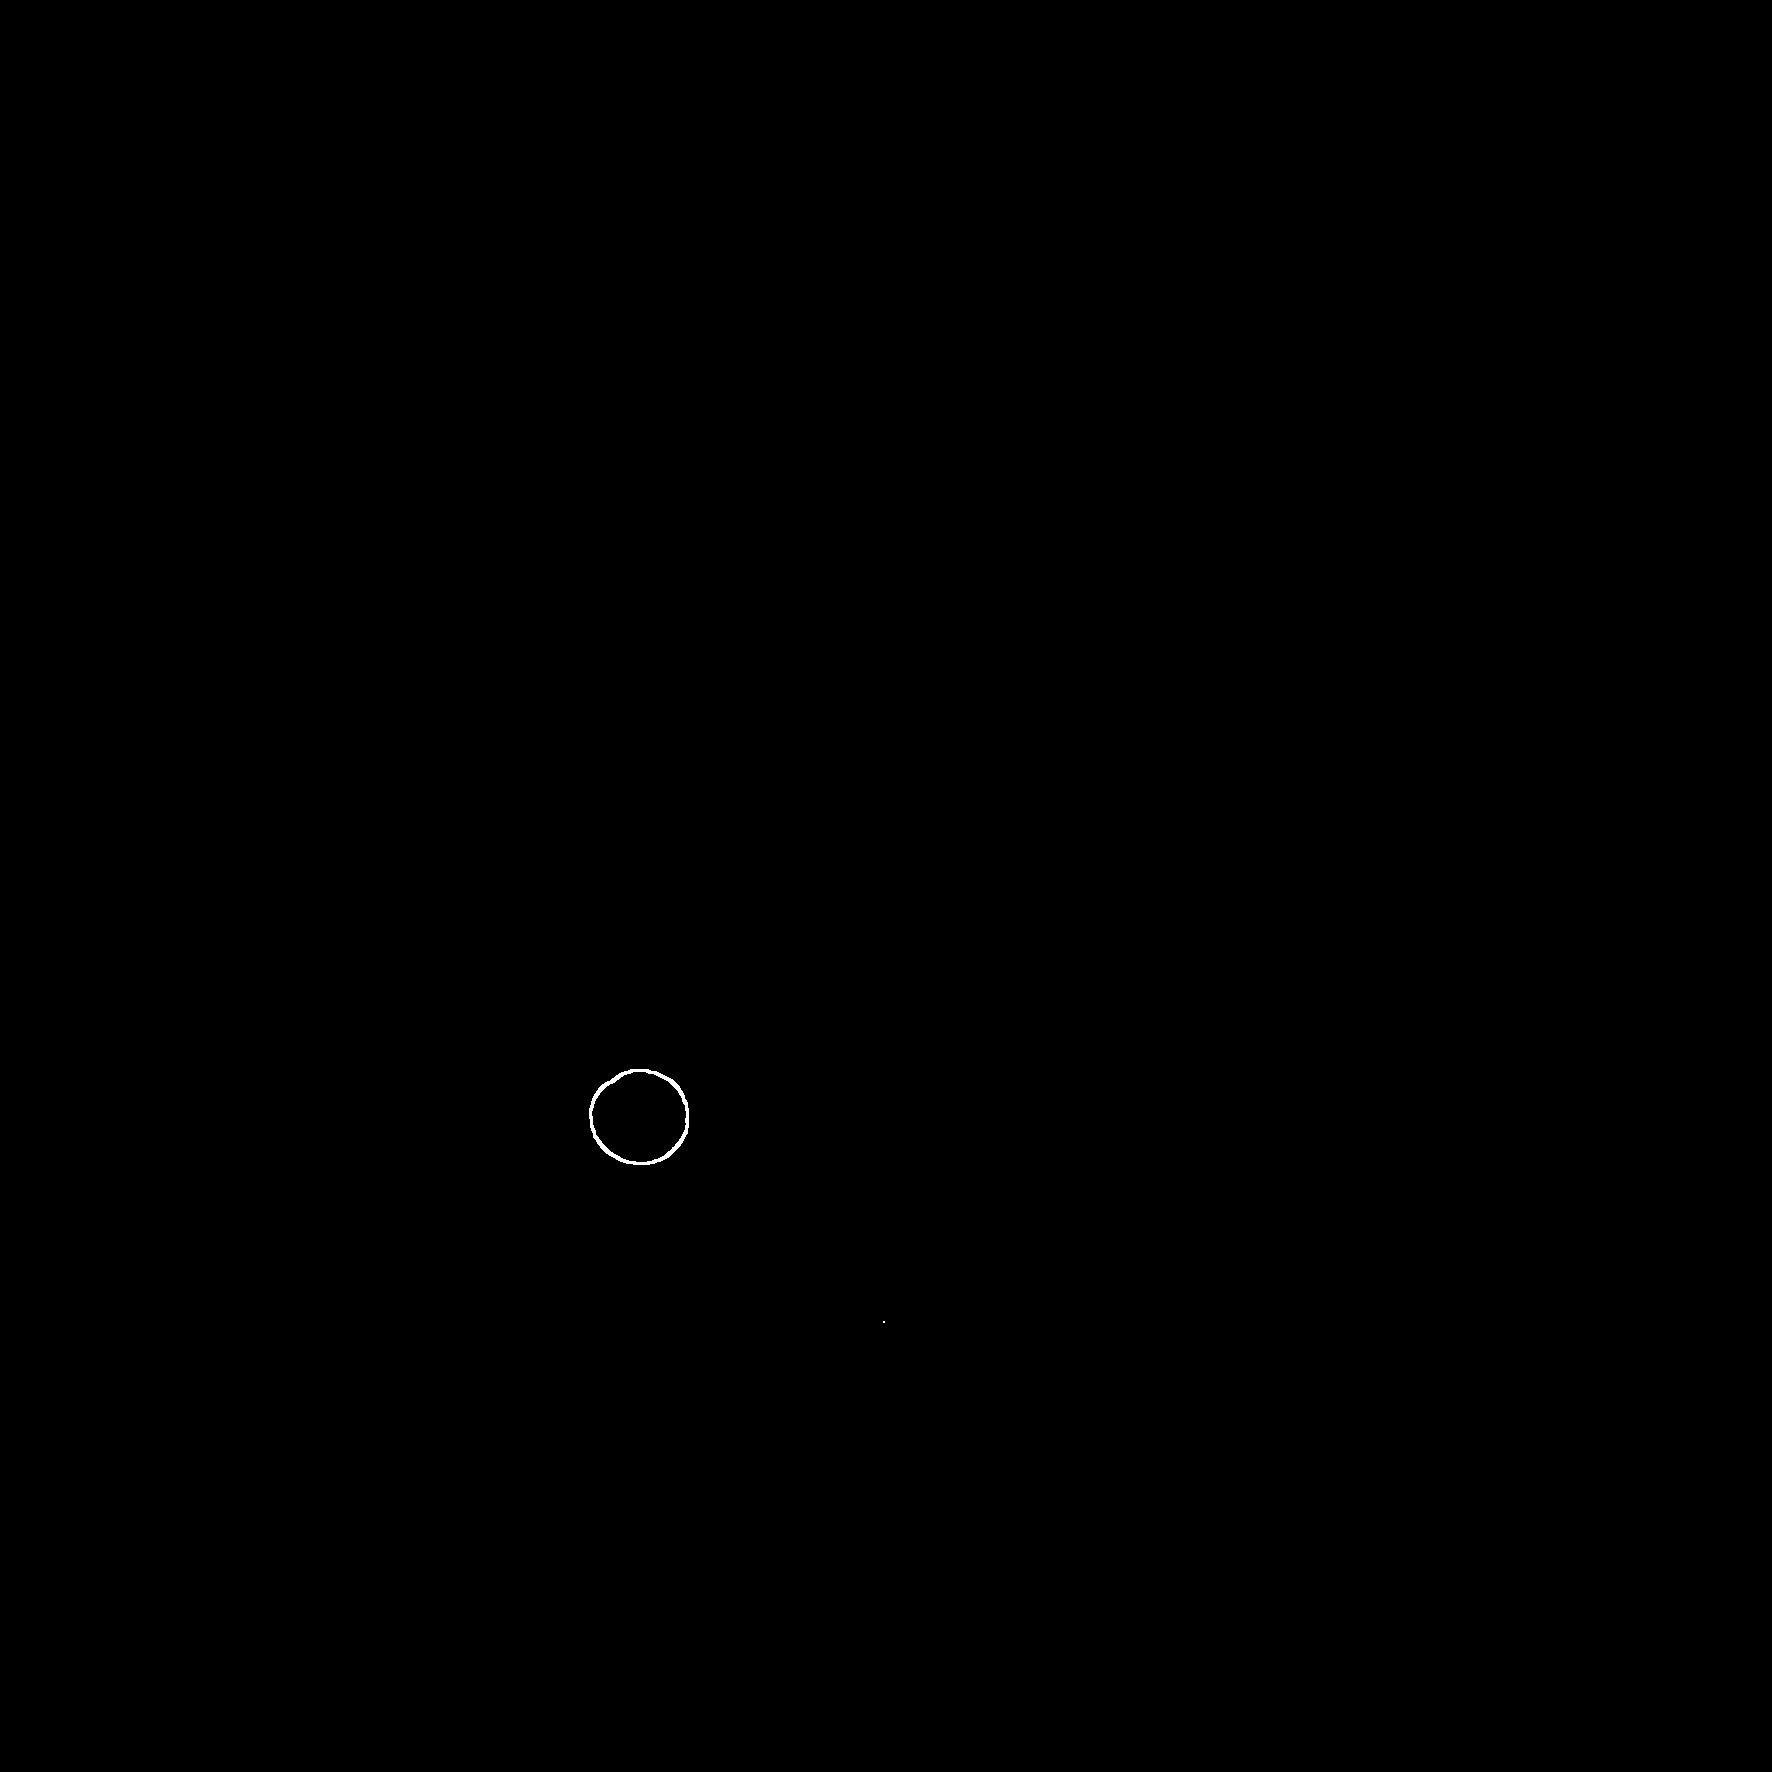

Liczba czarnych kropek: 1


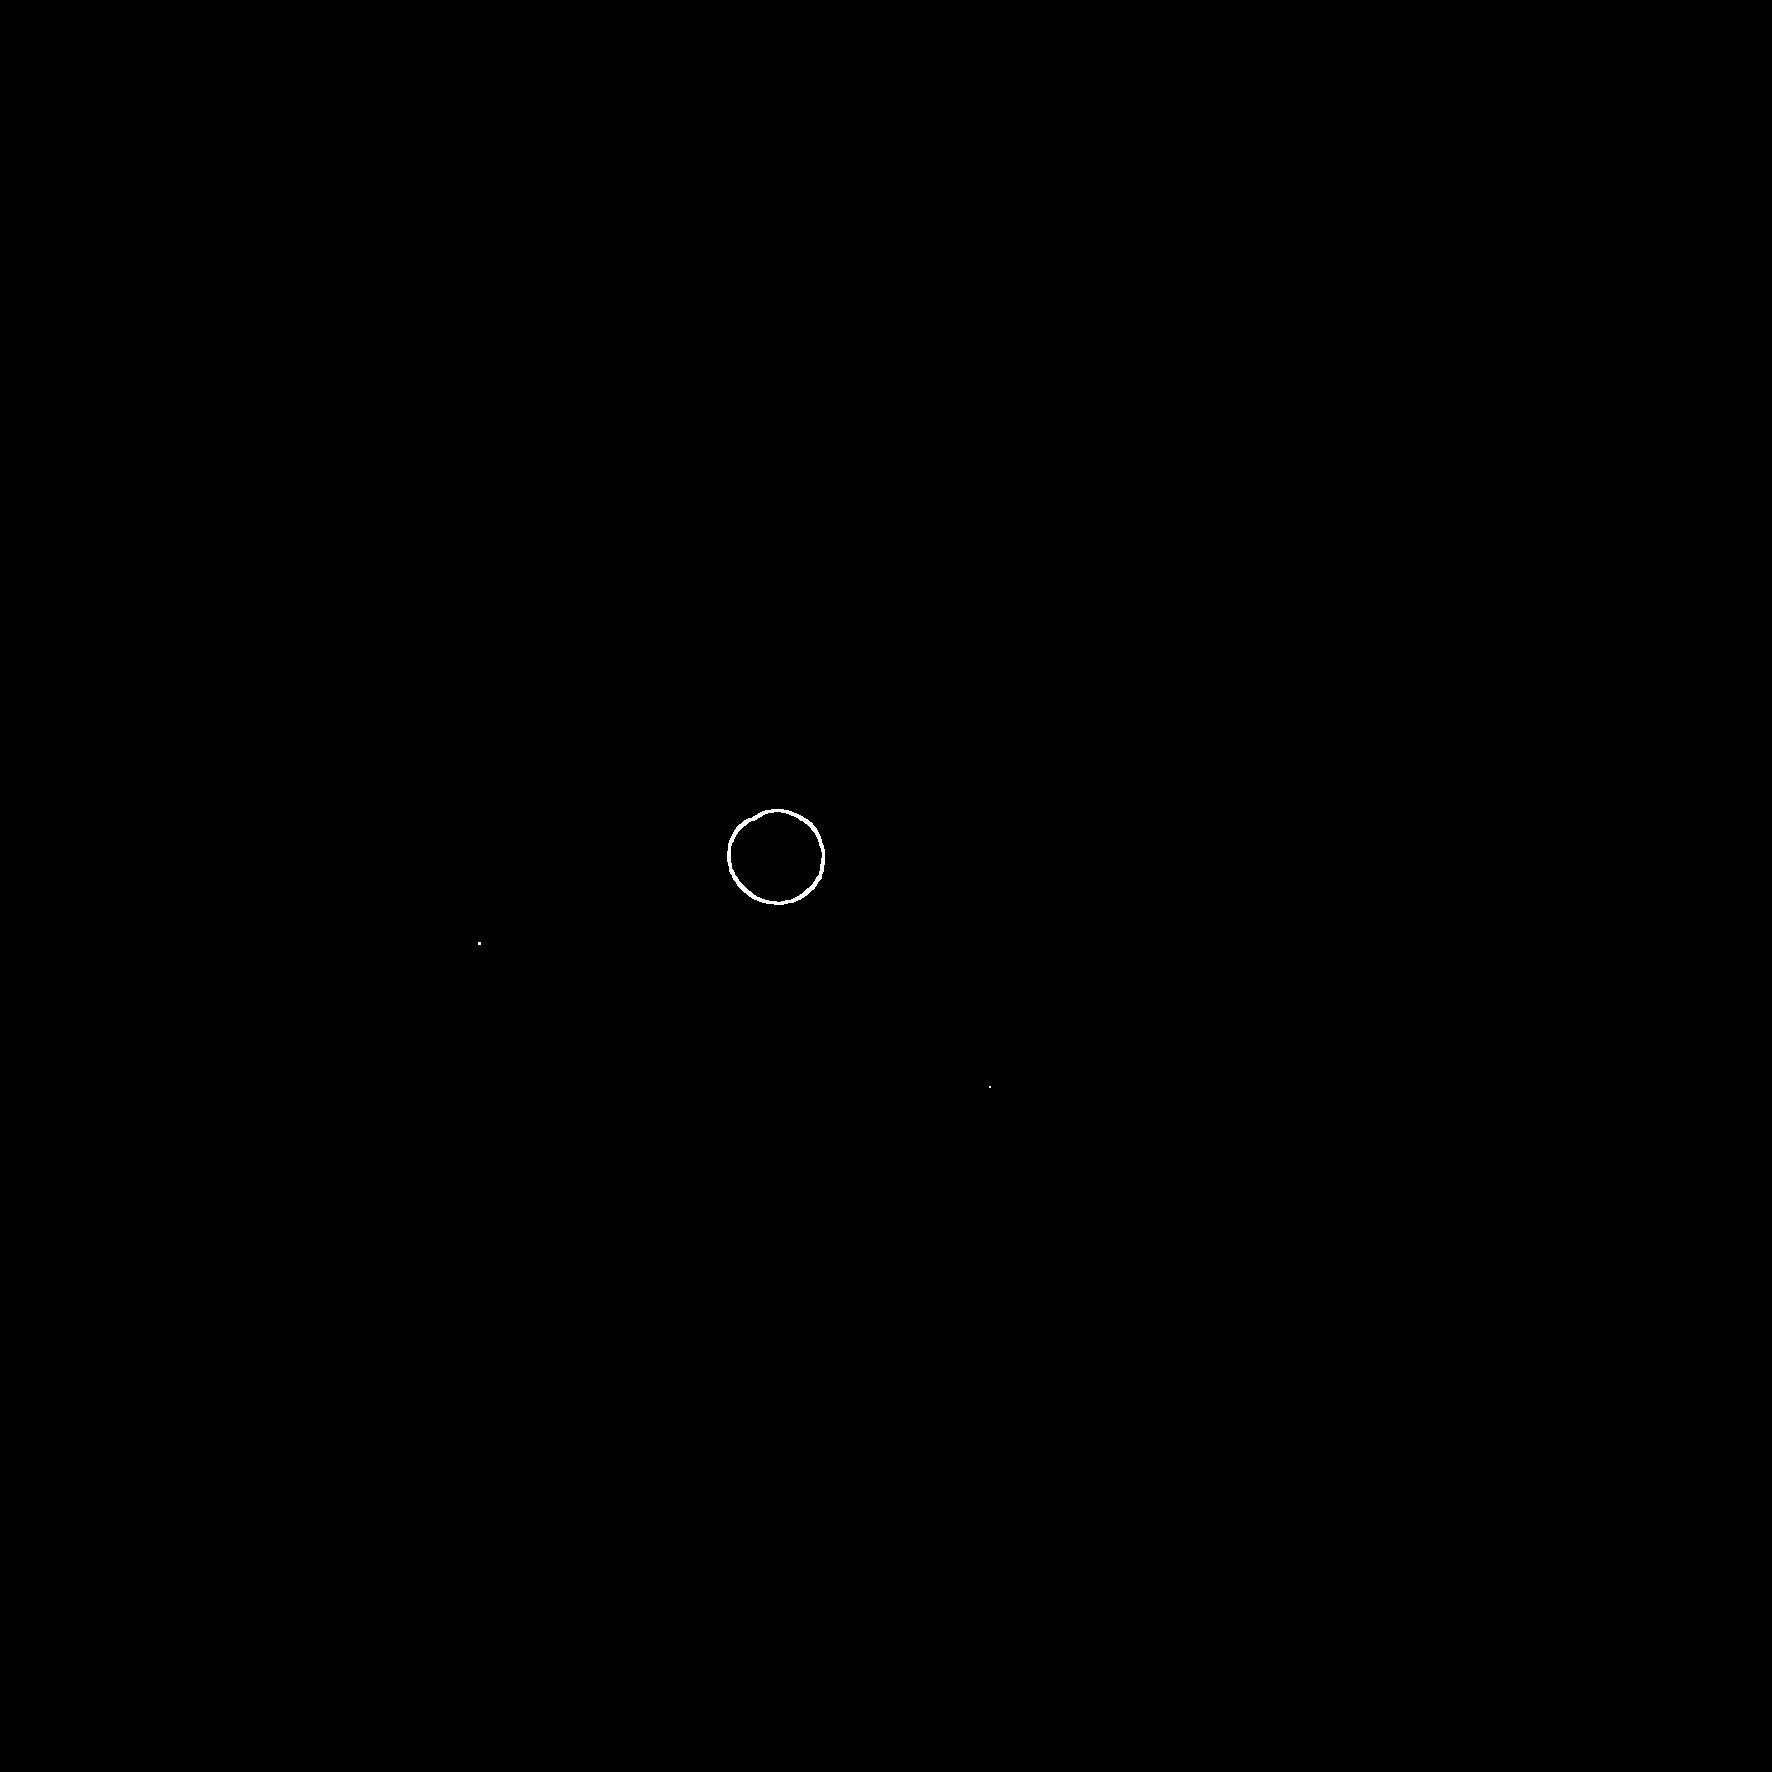

Liczba czarnych kropek: 1


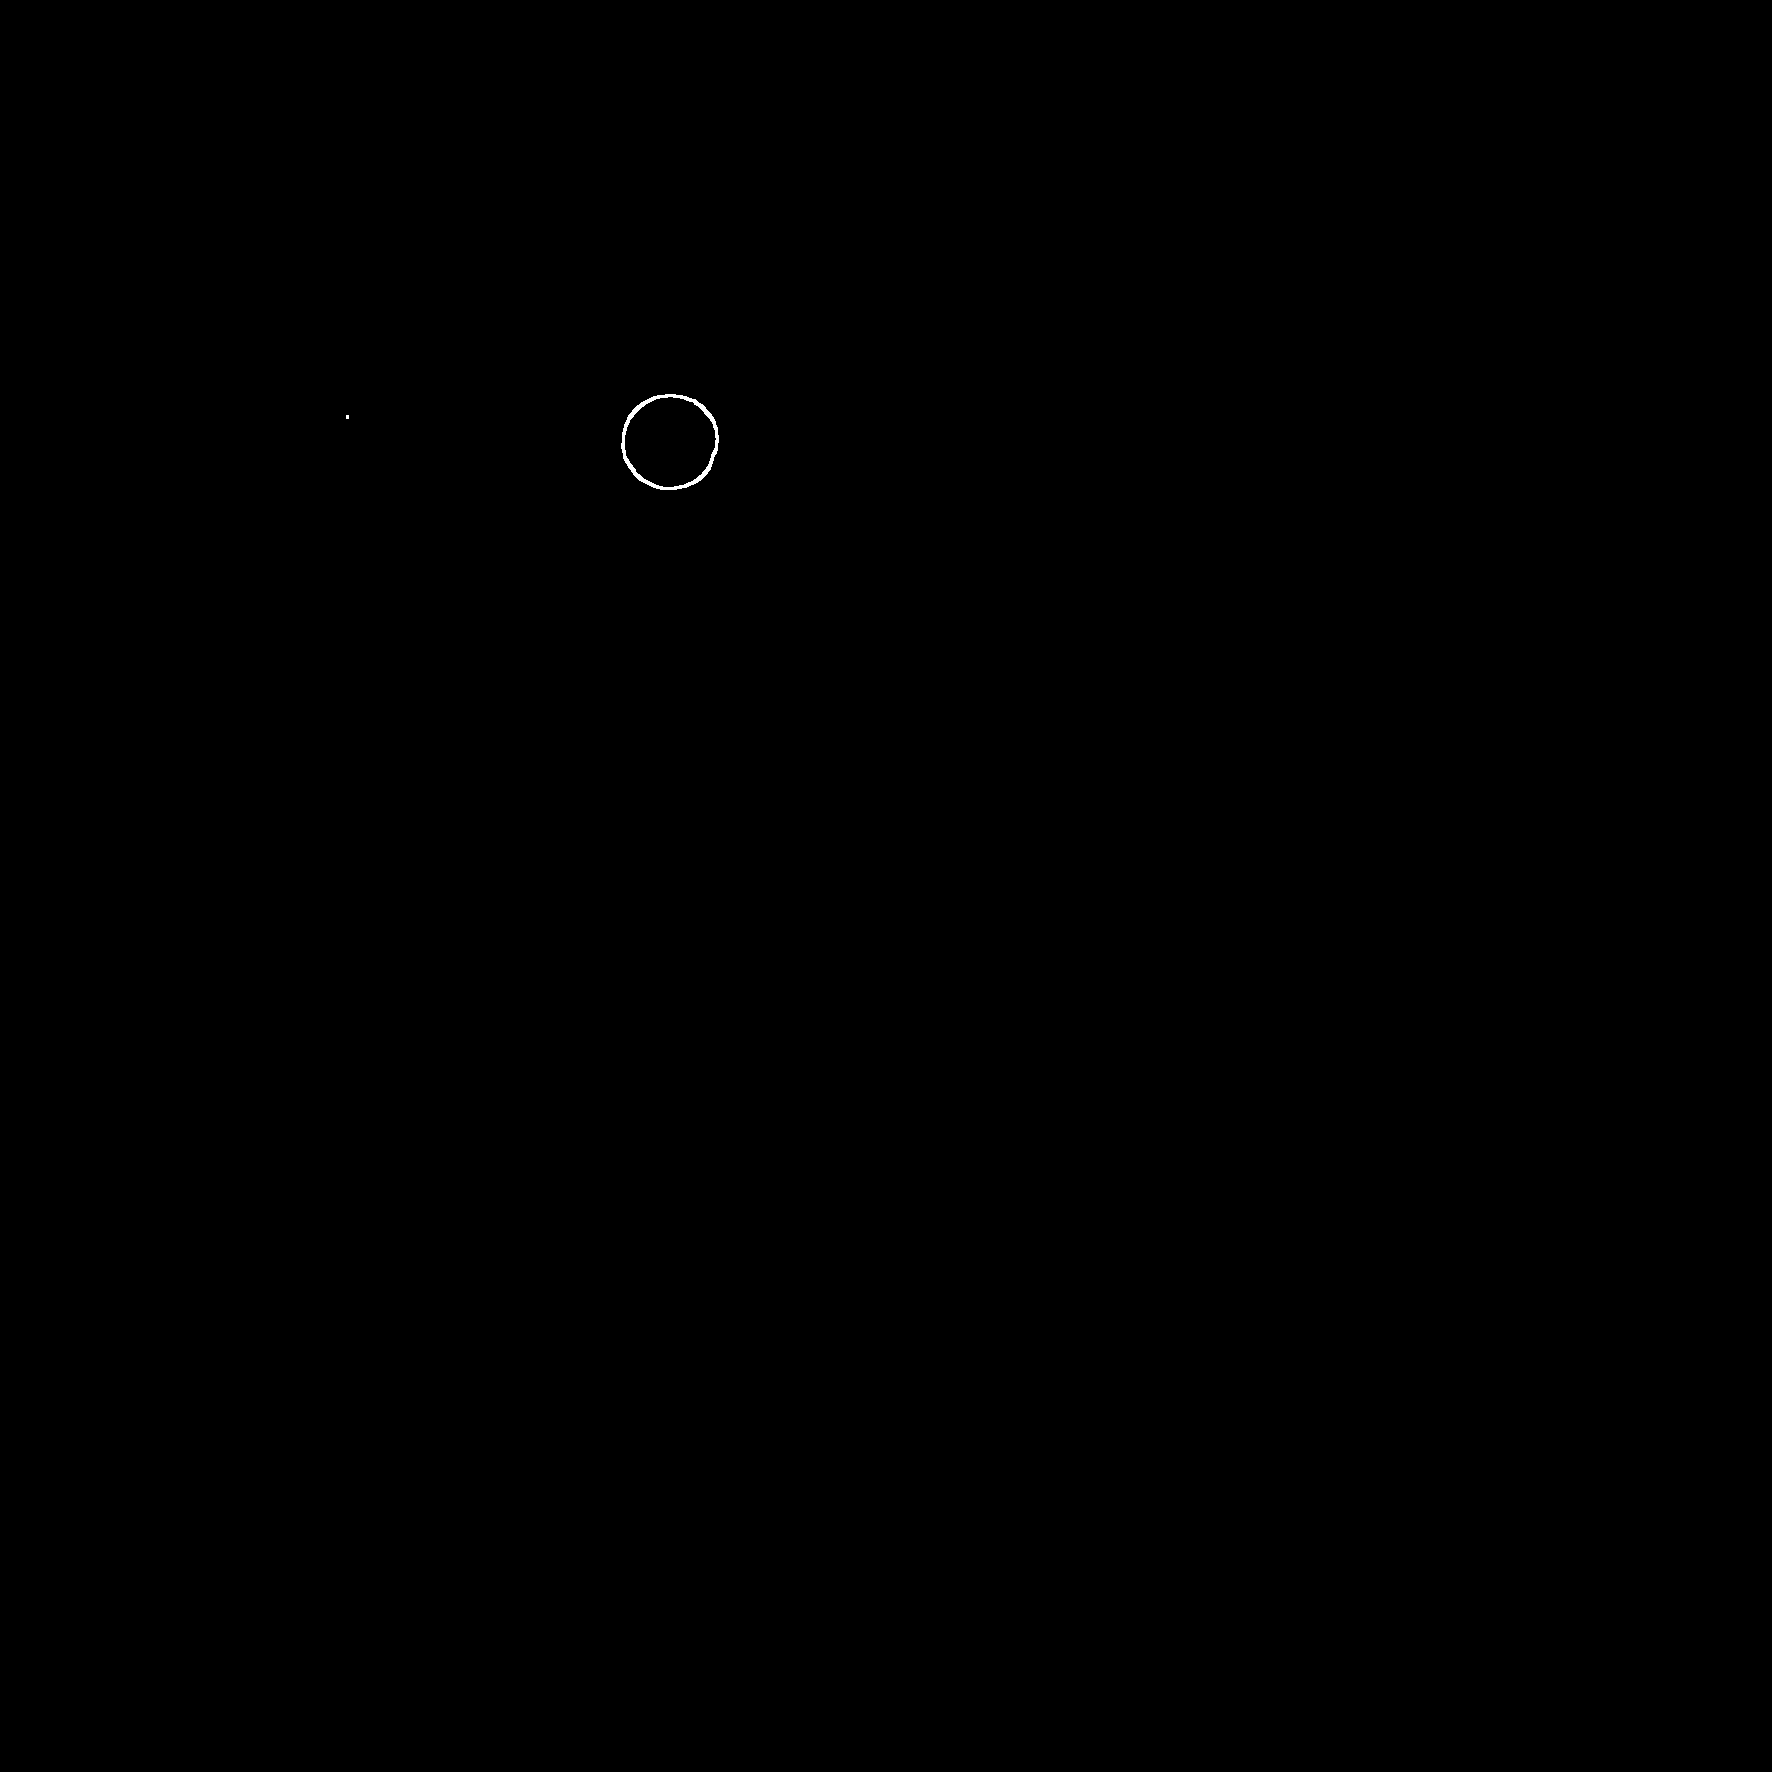

Liczba czarnych kropek: 1


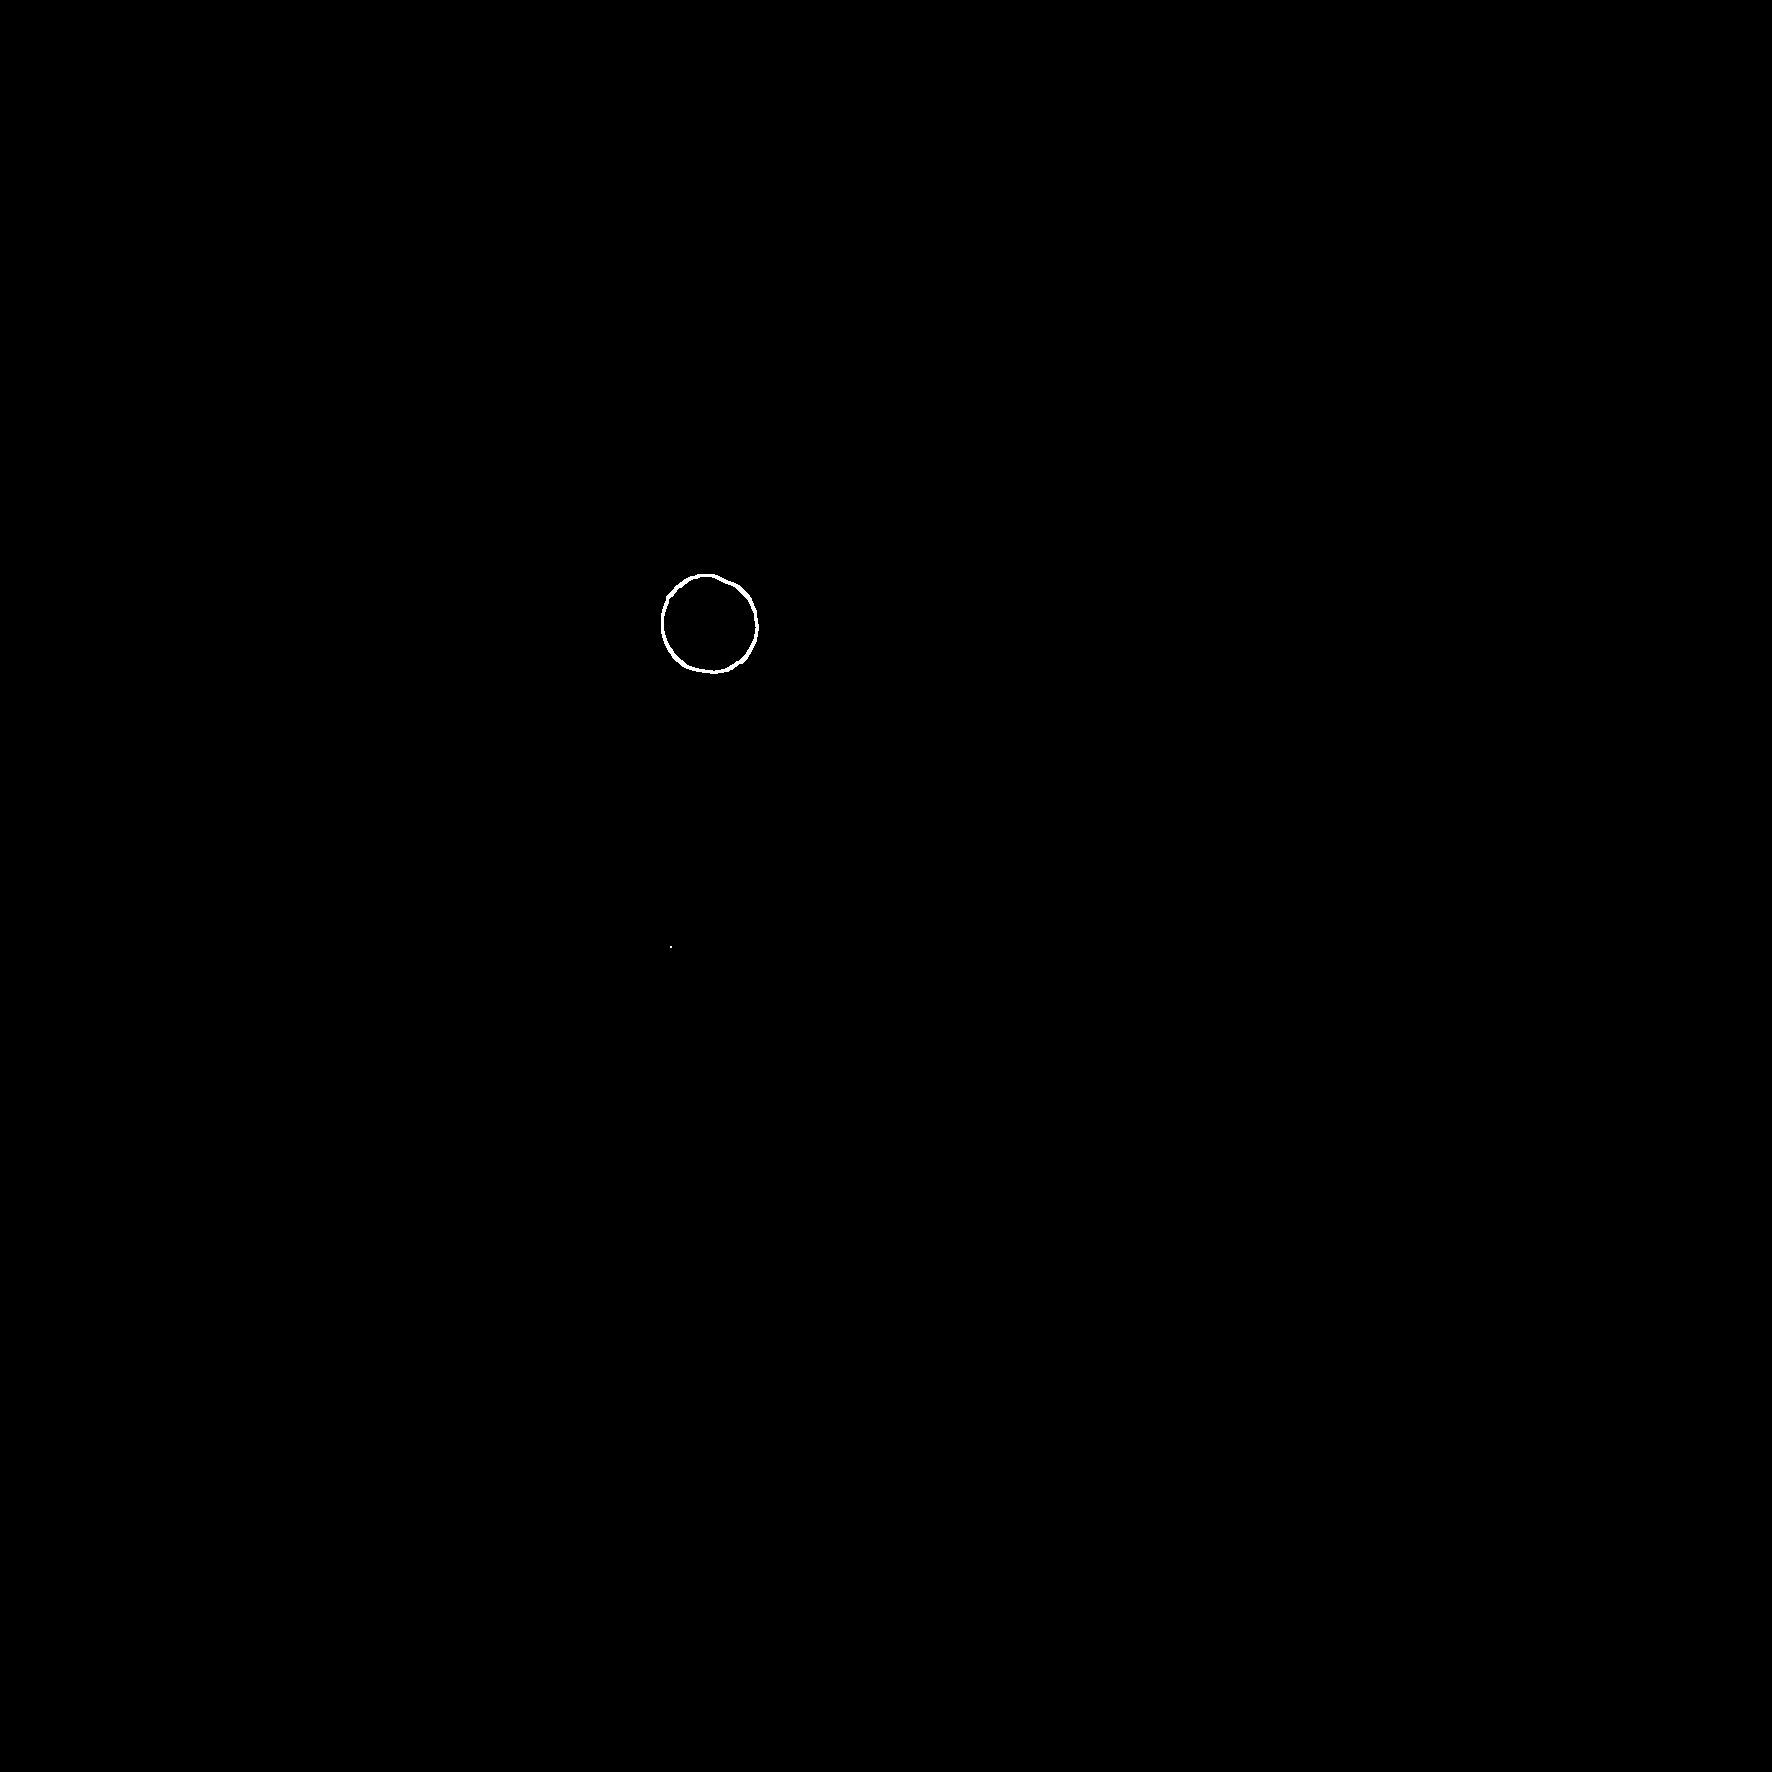

Liczba czarnych kropek: 1


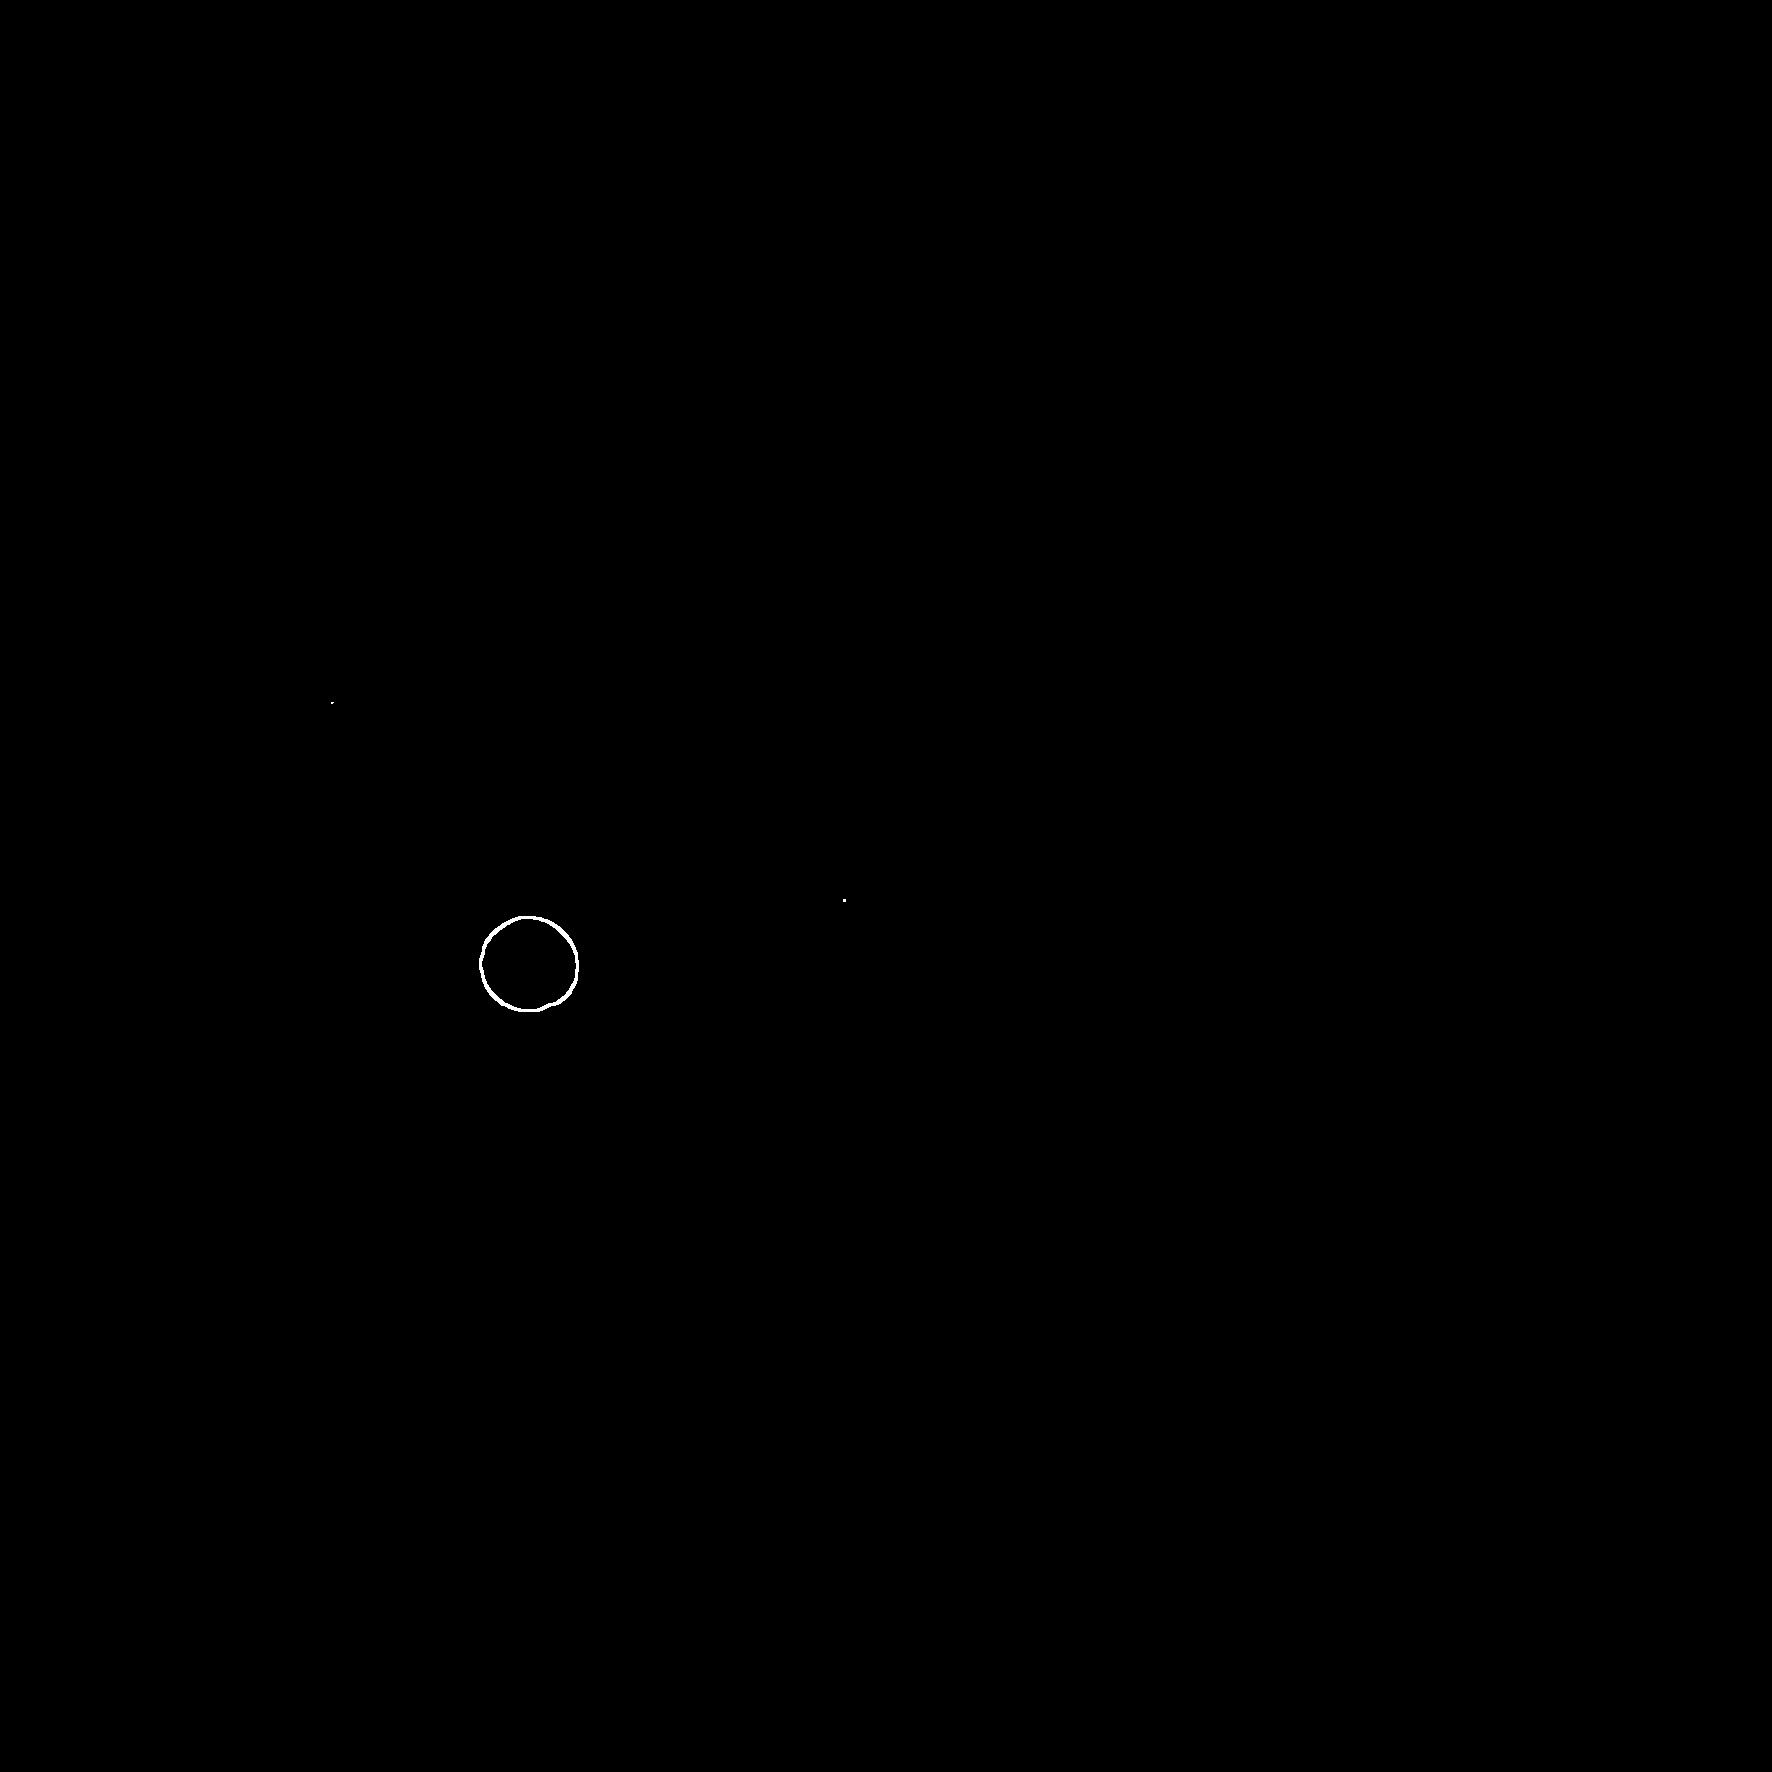

Liczba czarnych kropek: 1


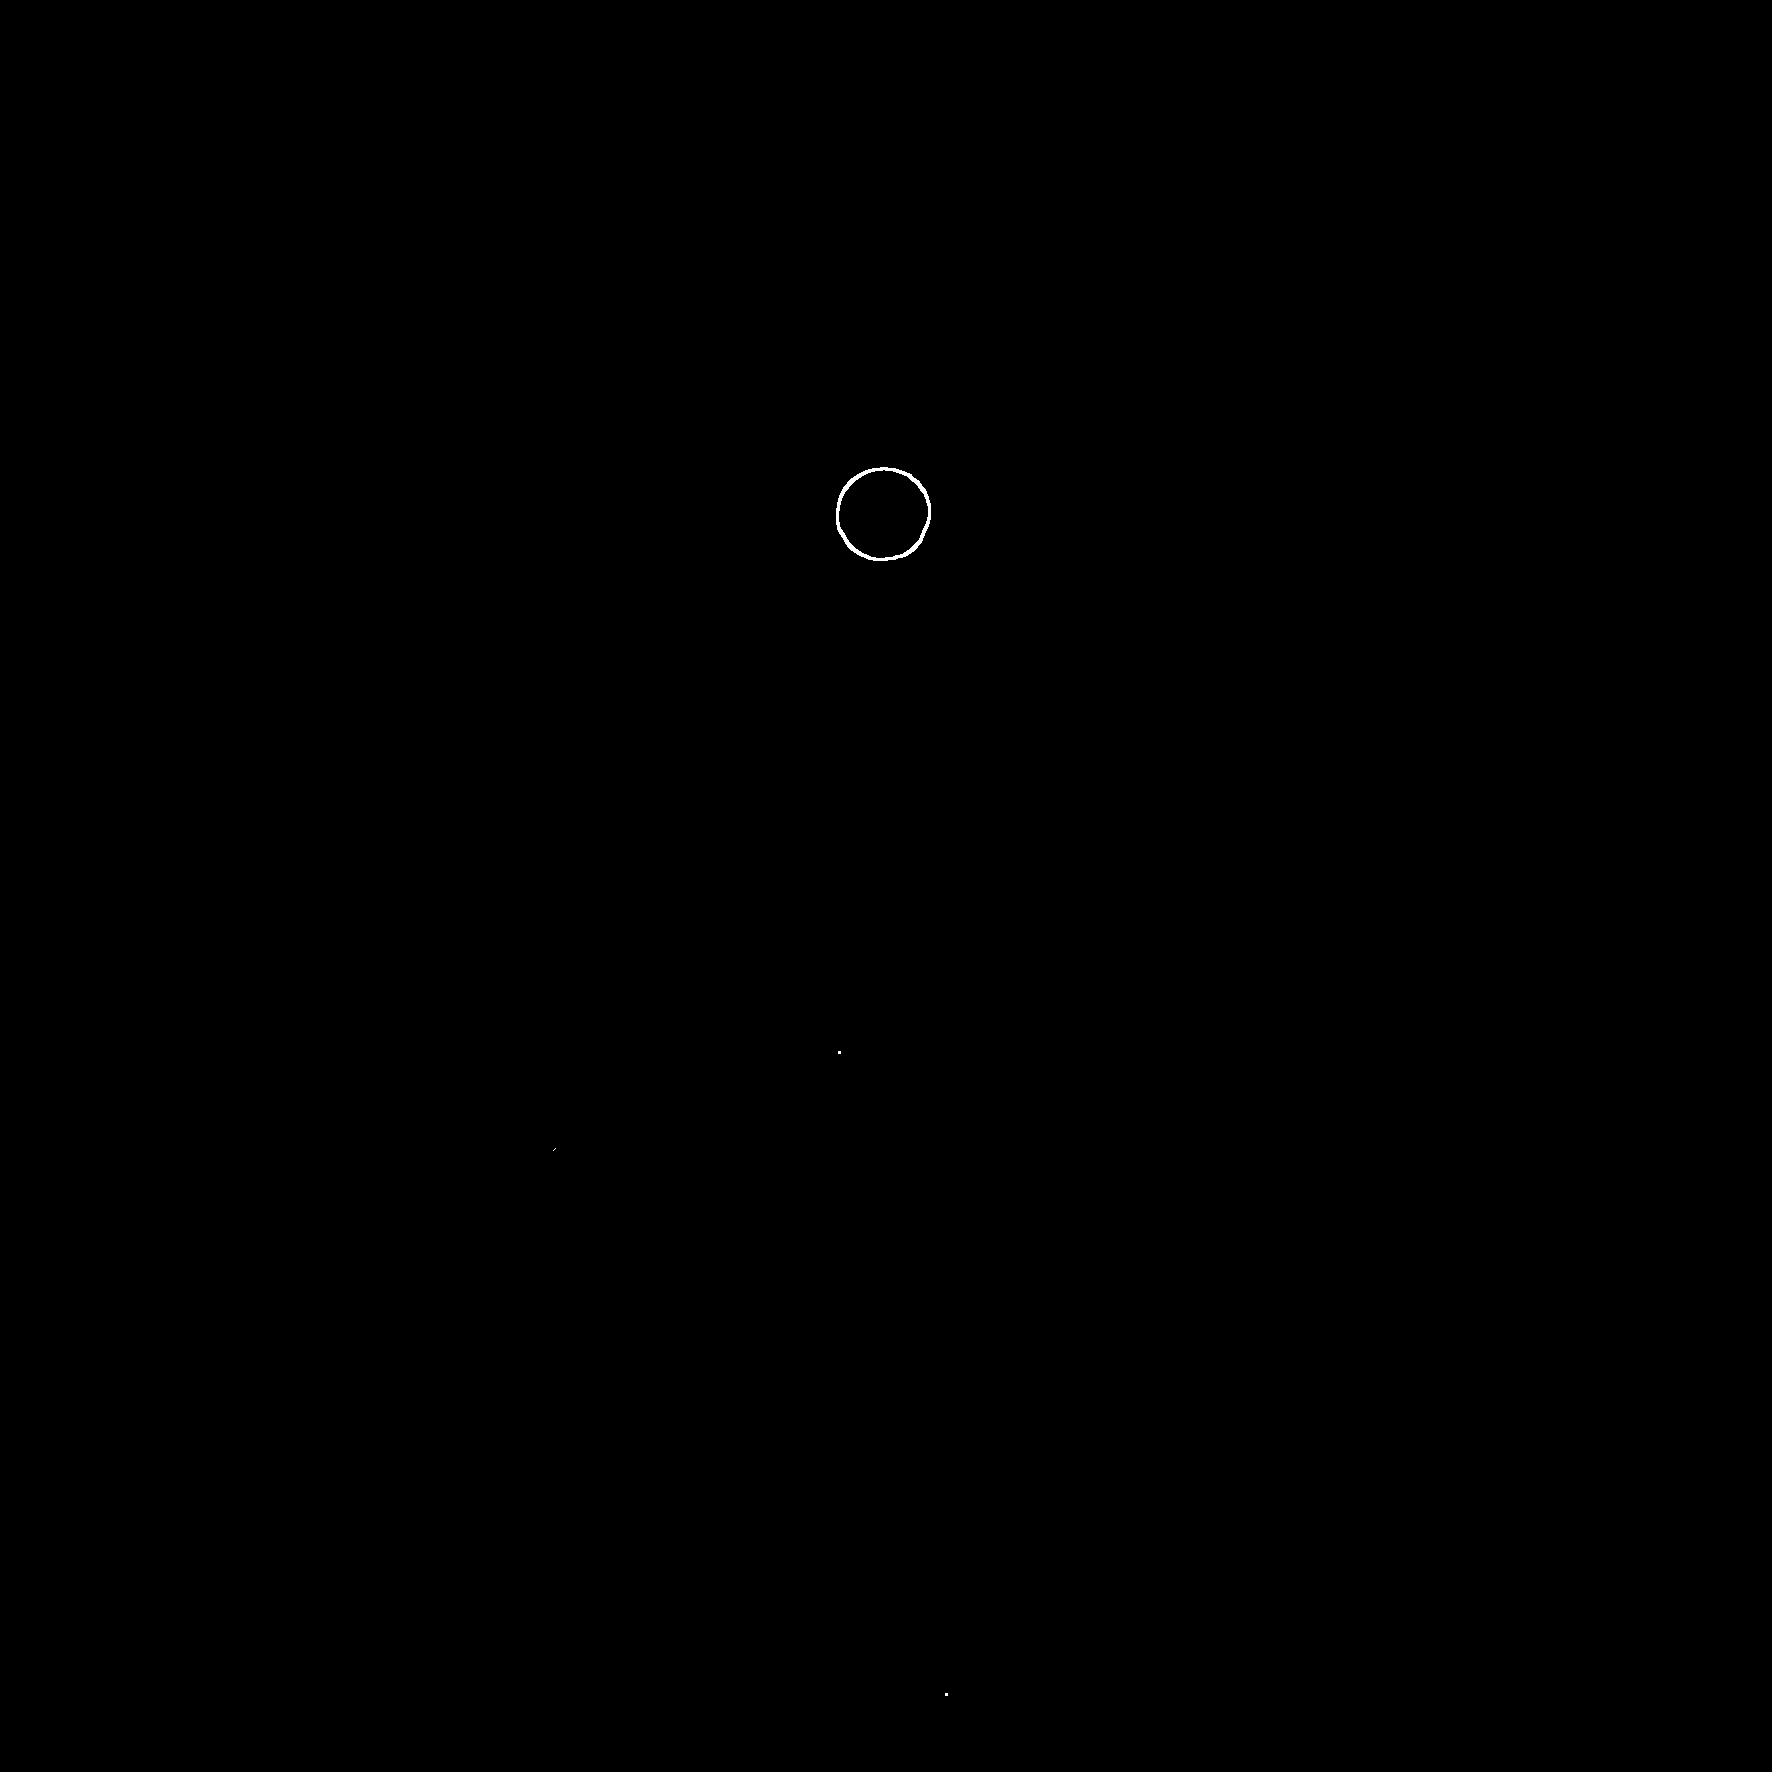

Liczba czarnych kropek: 1


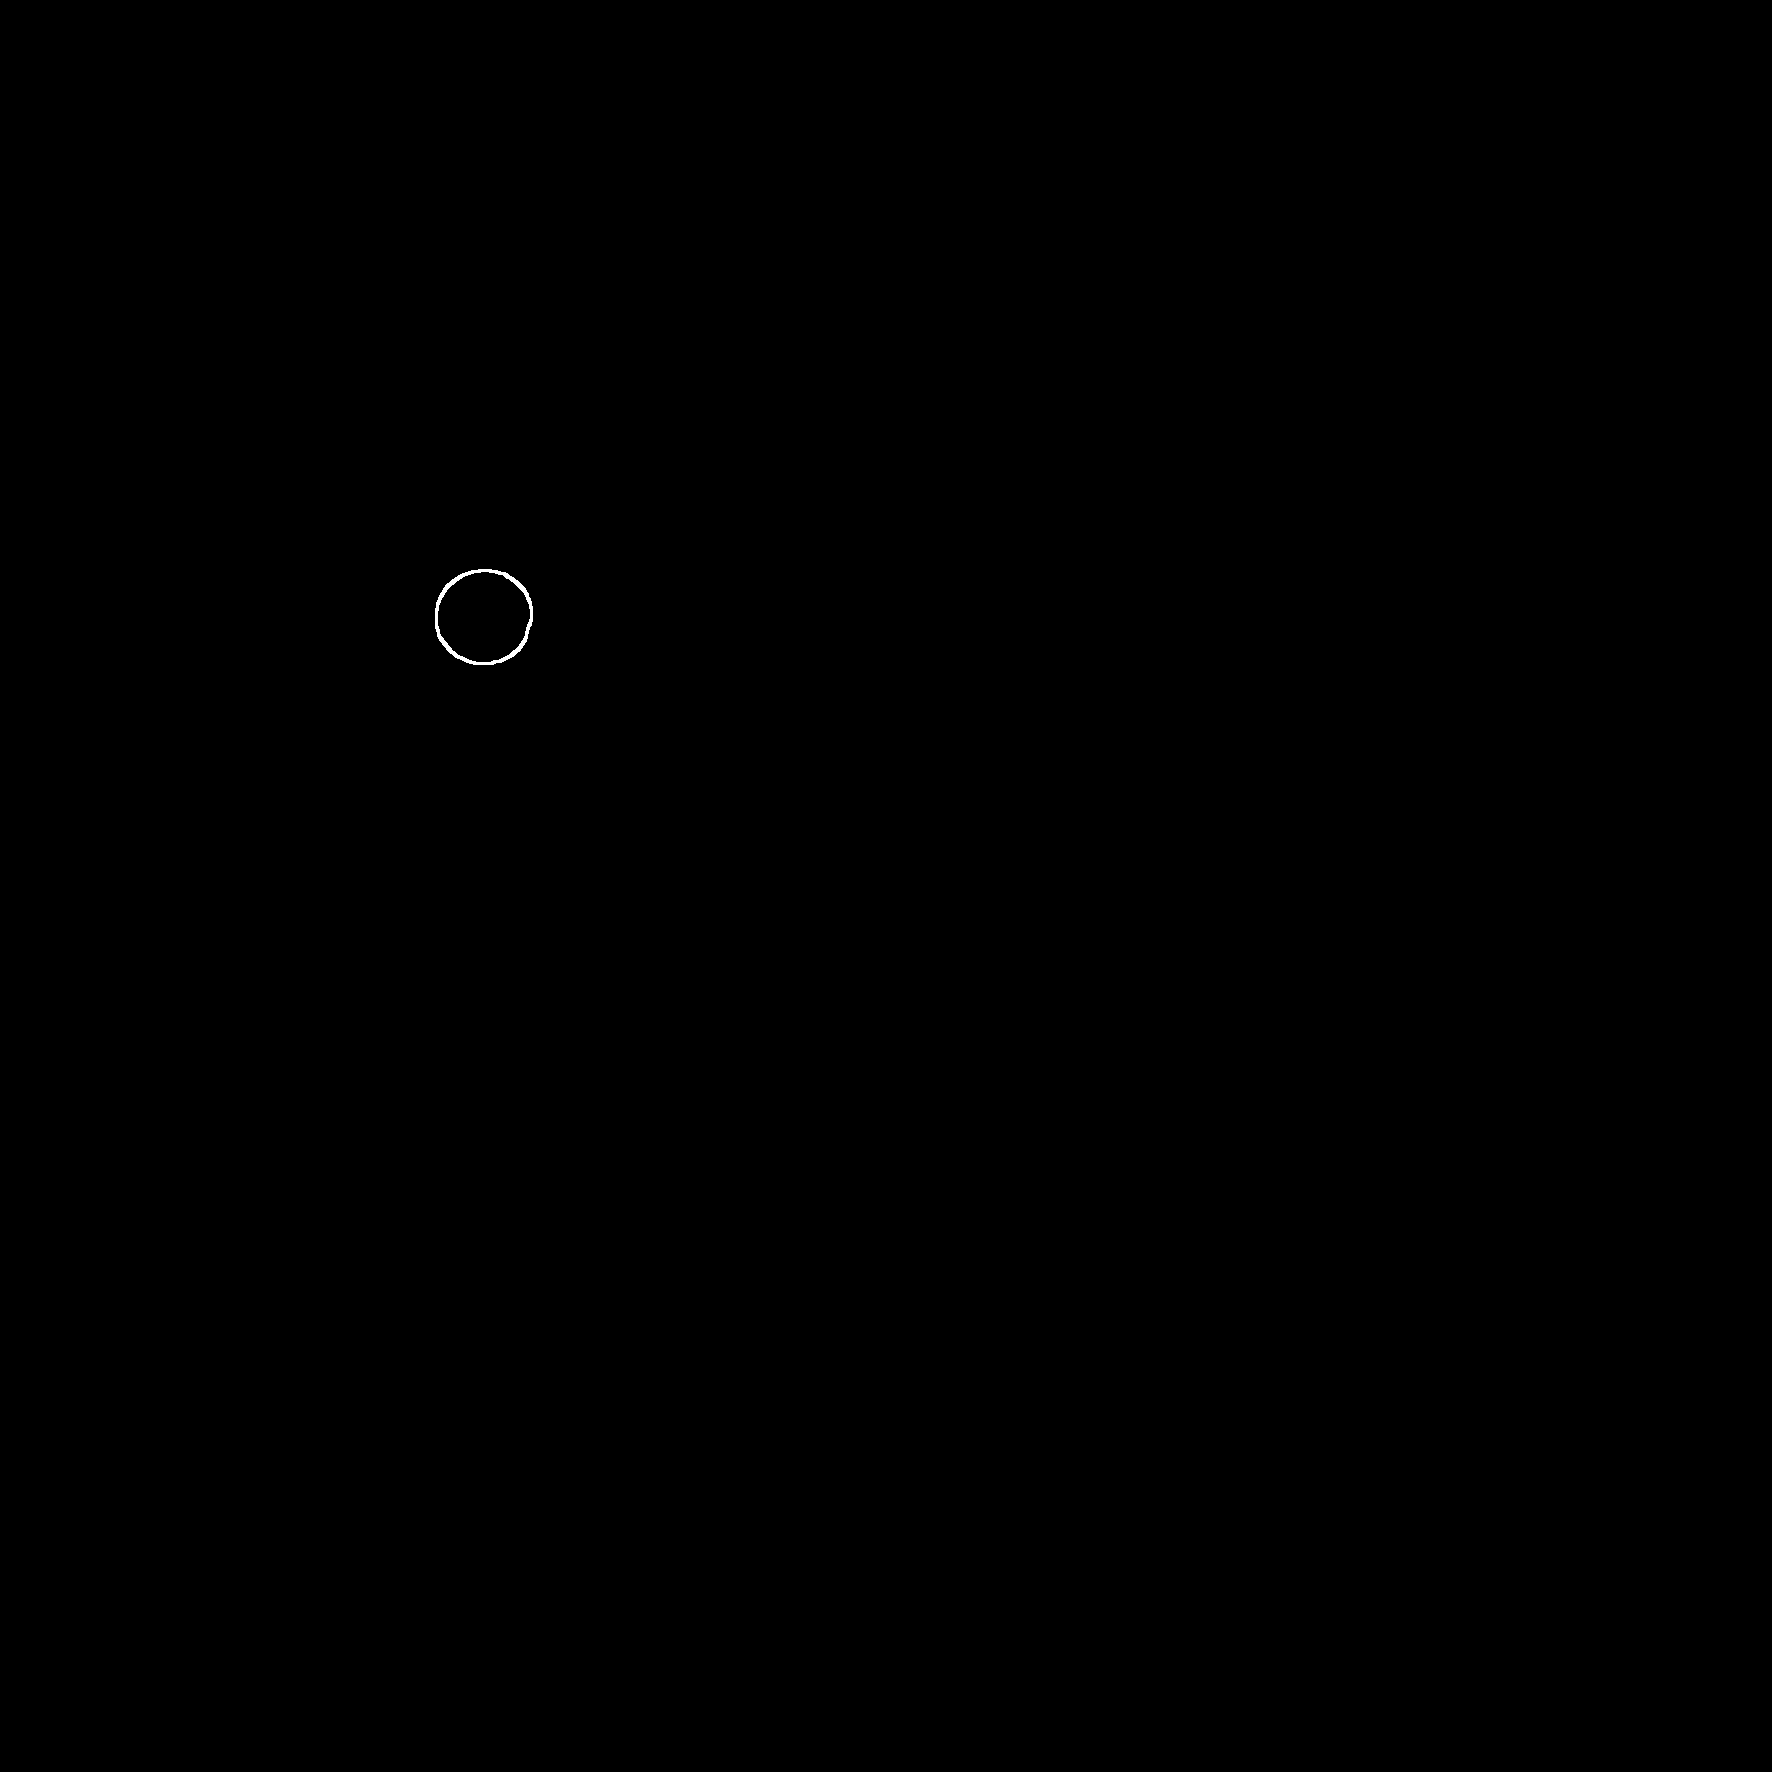

Liczba czarnych kropek: 1


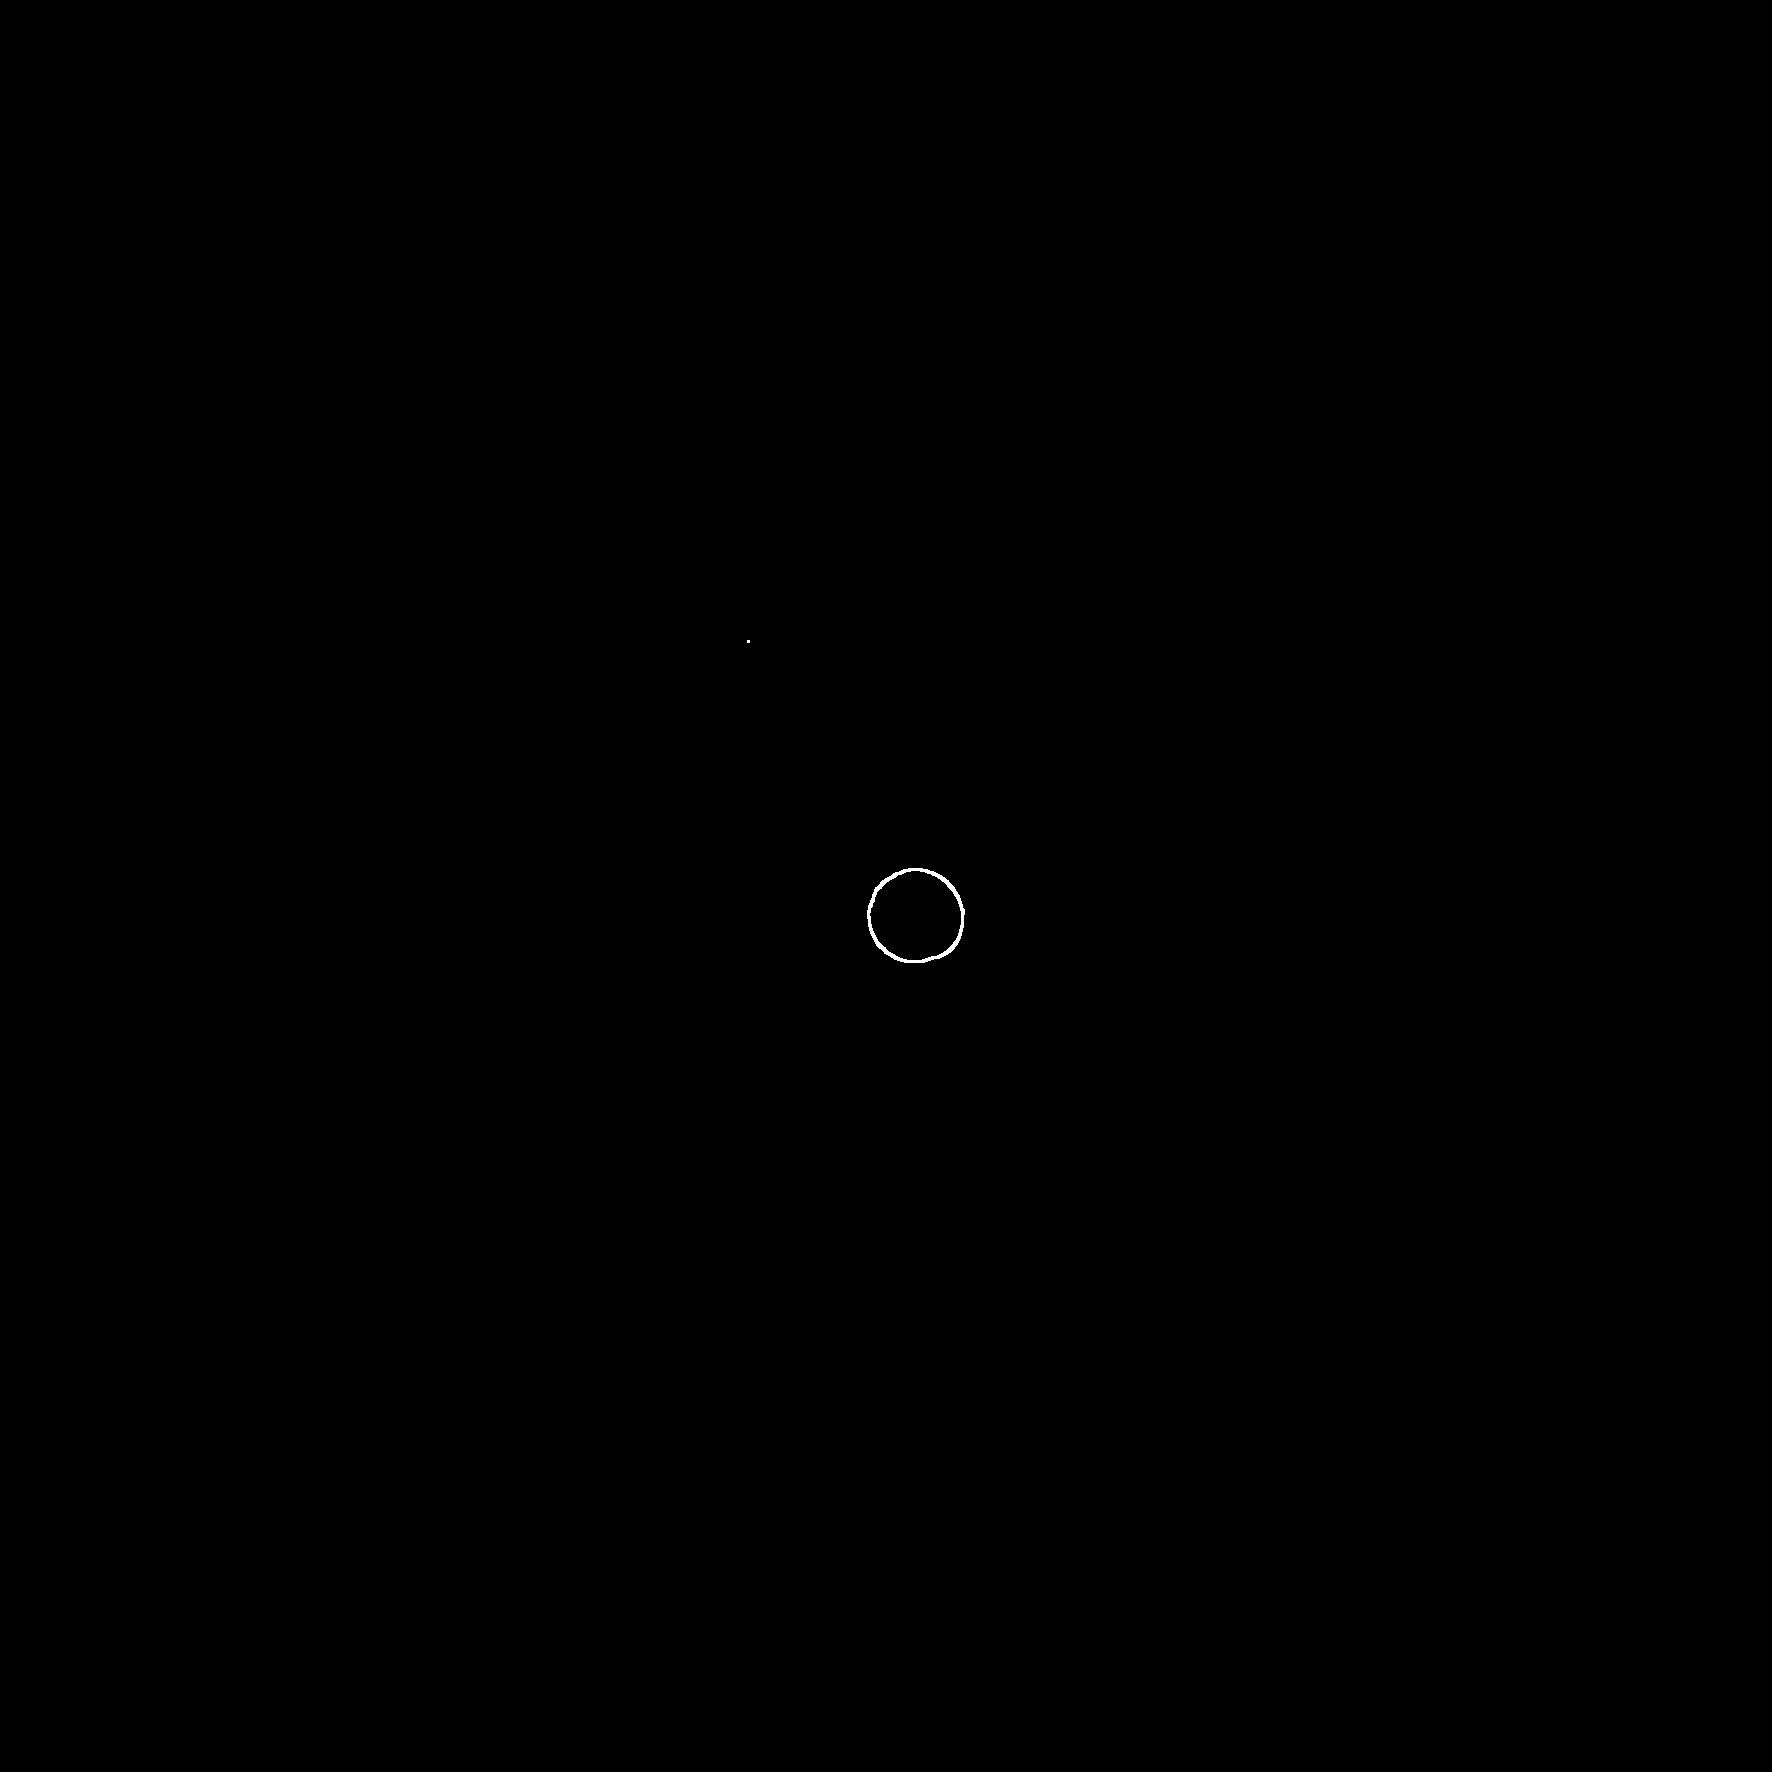

Liczba czarnych kropek: 1


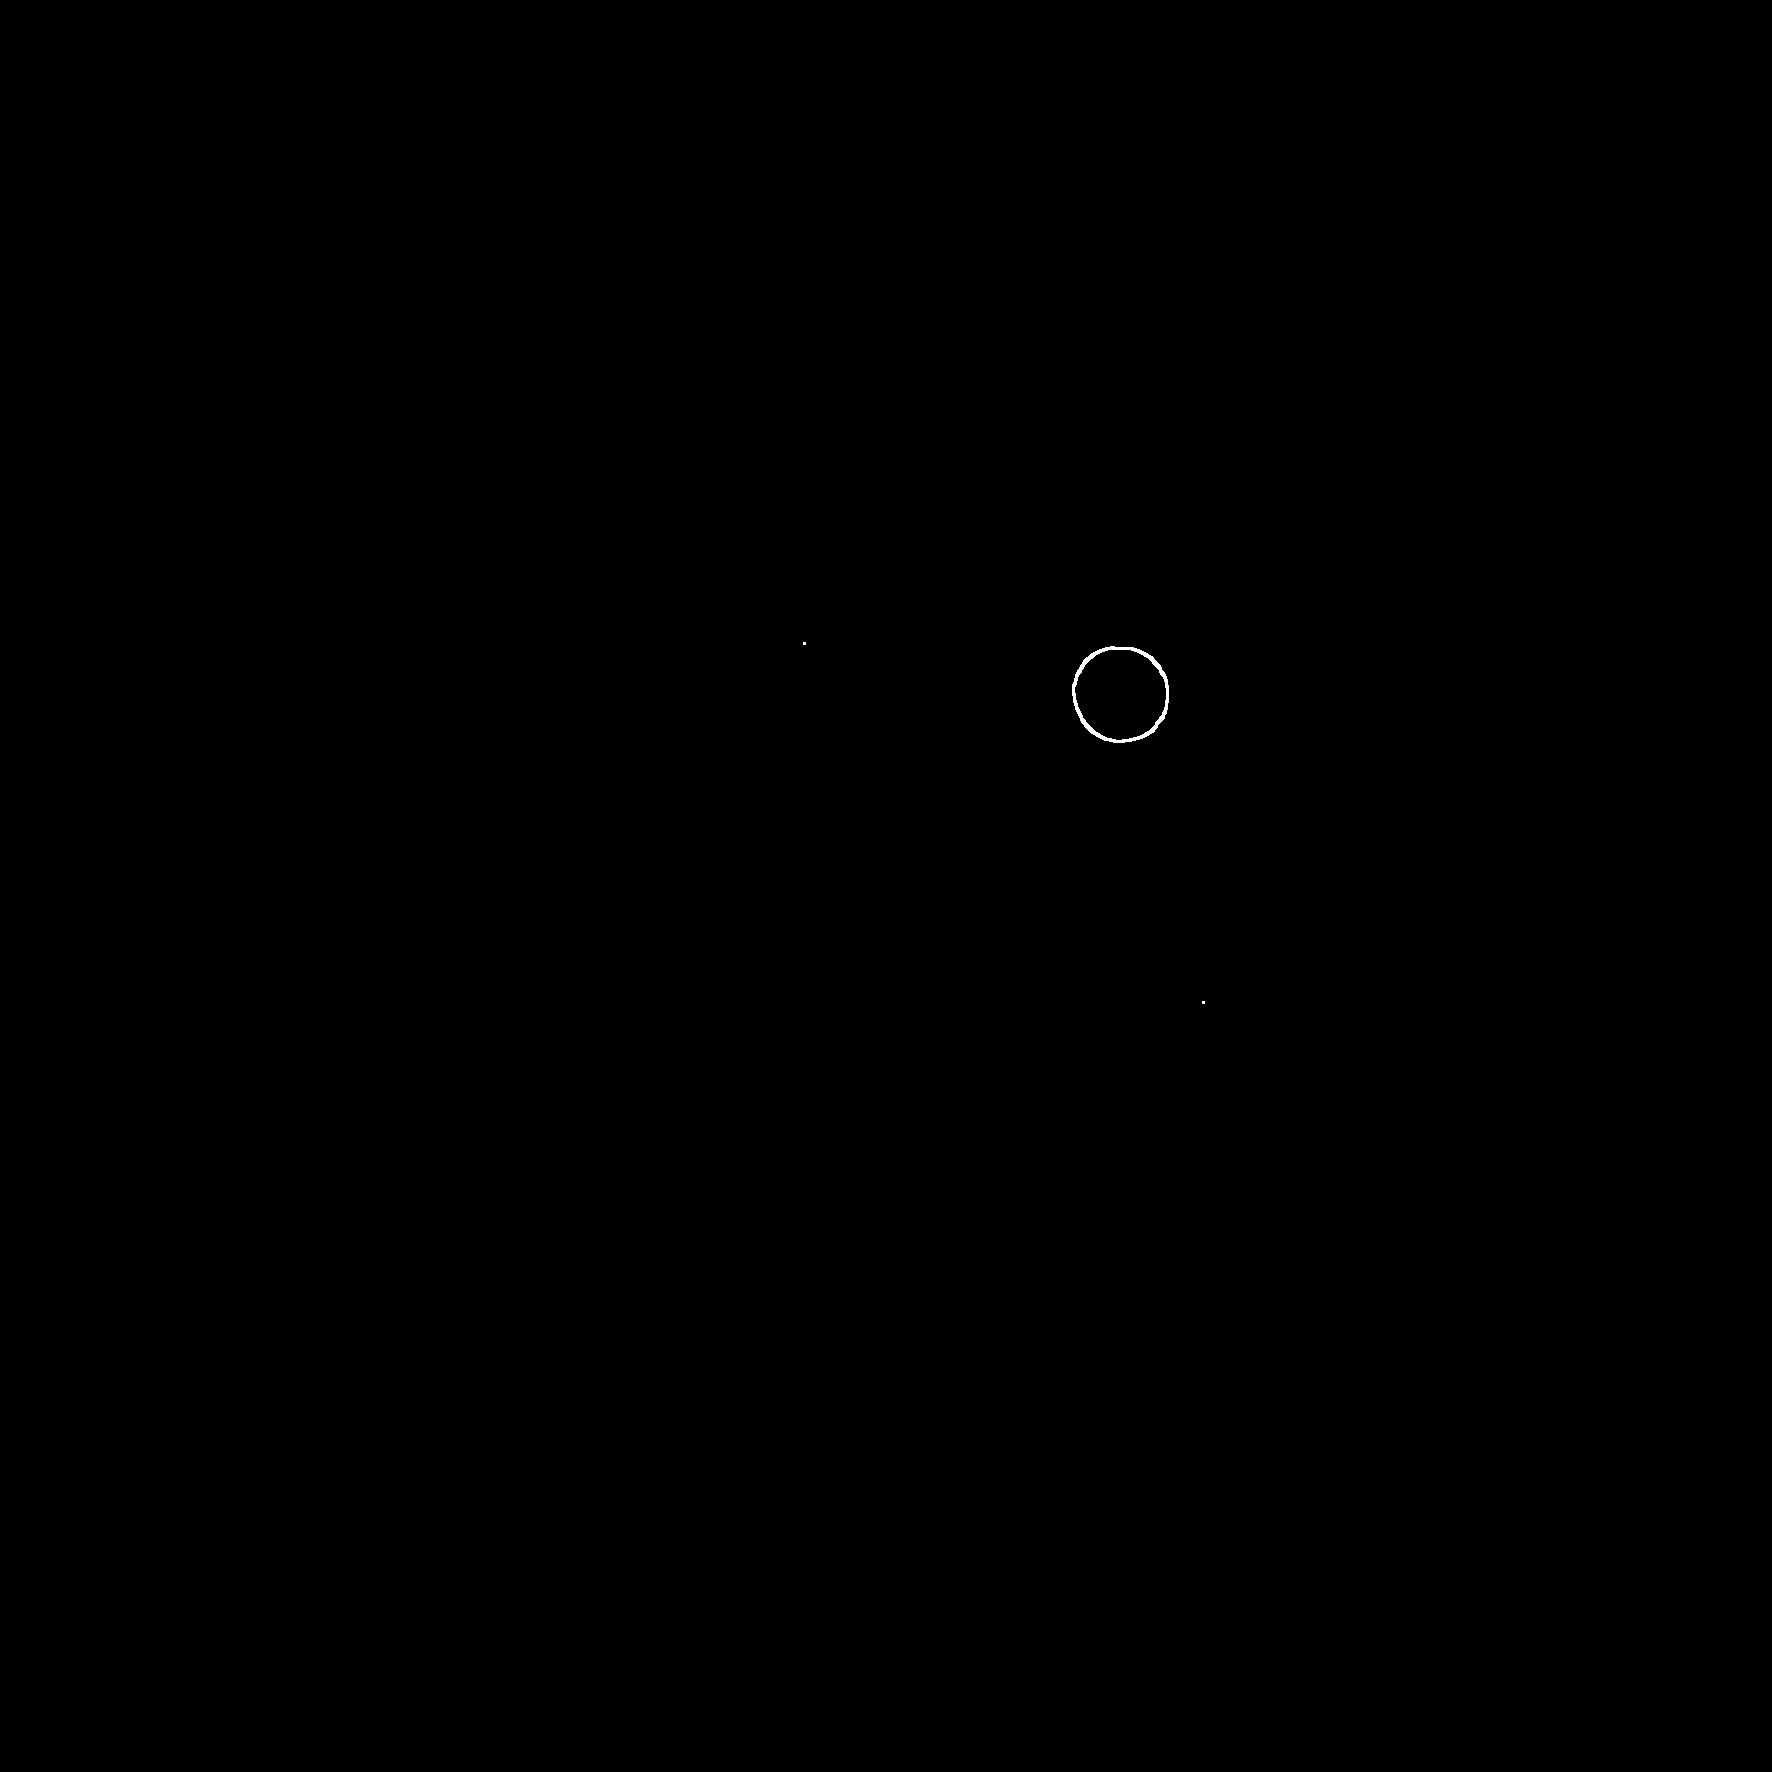

Liczba czarnych kropek: 1


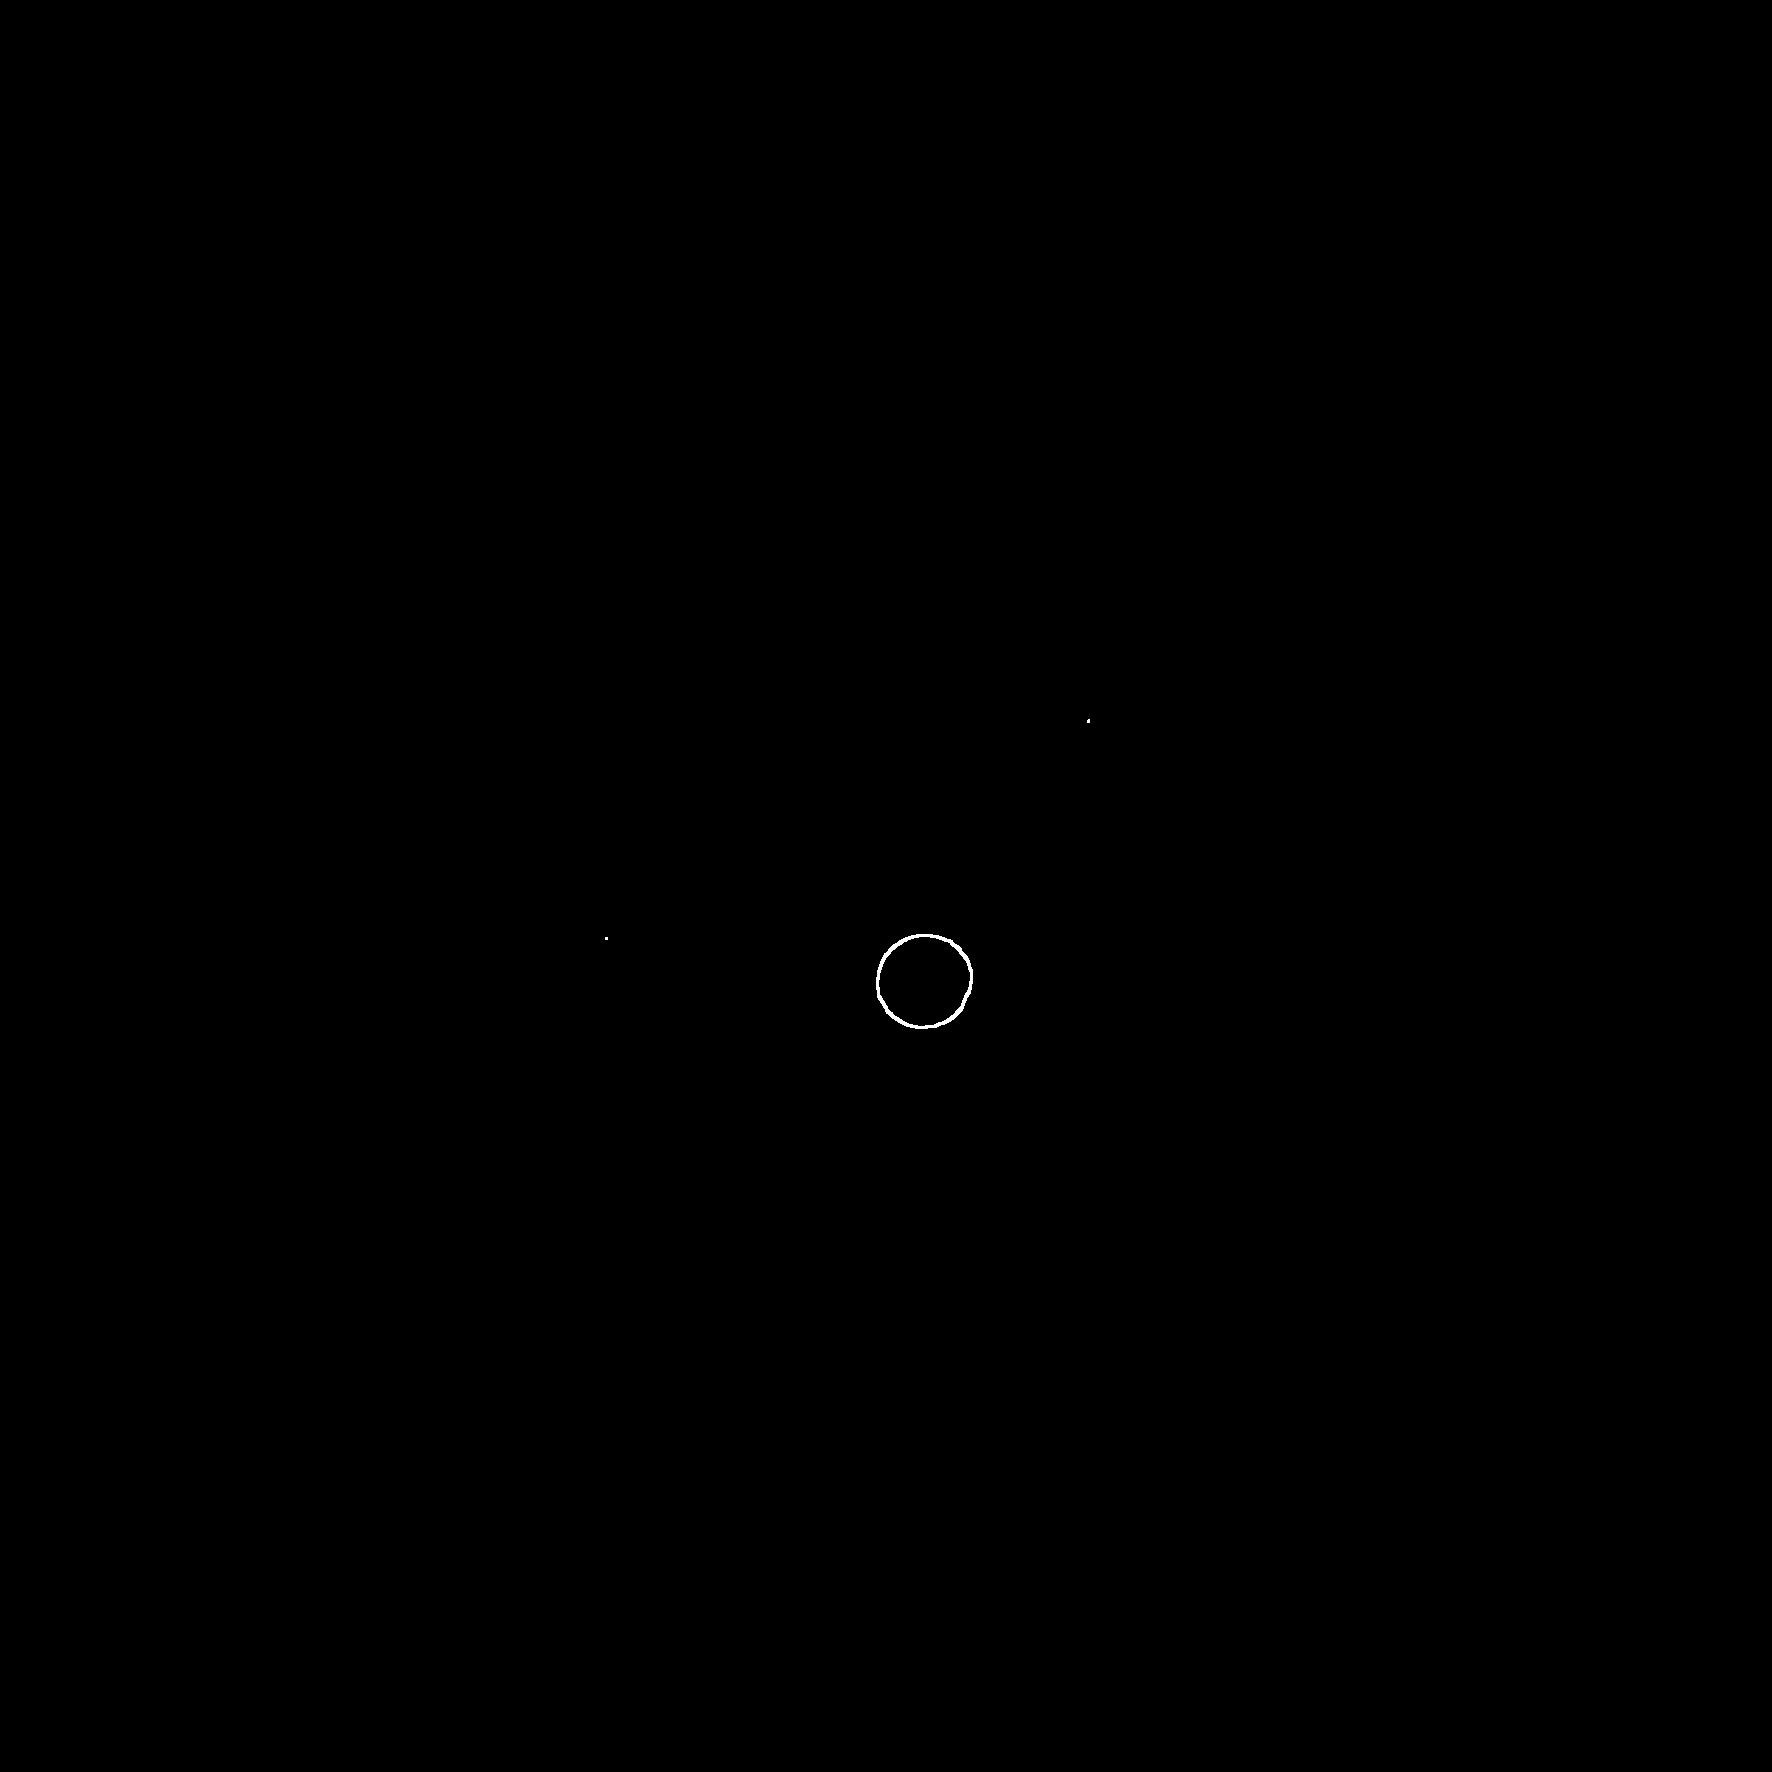

Liczba czarnych kropek: 1


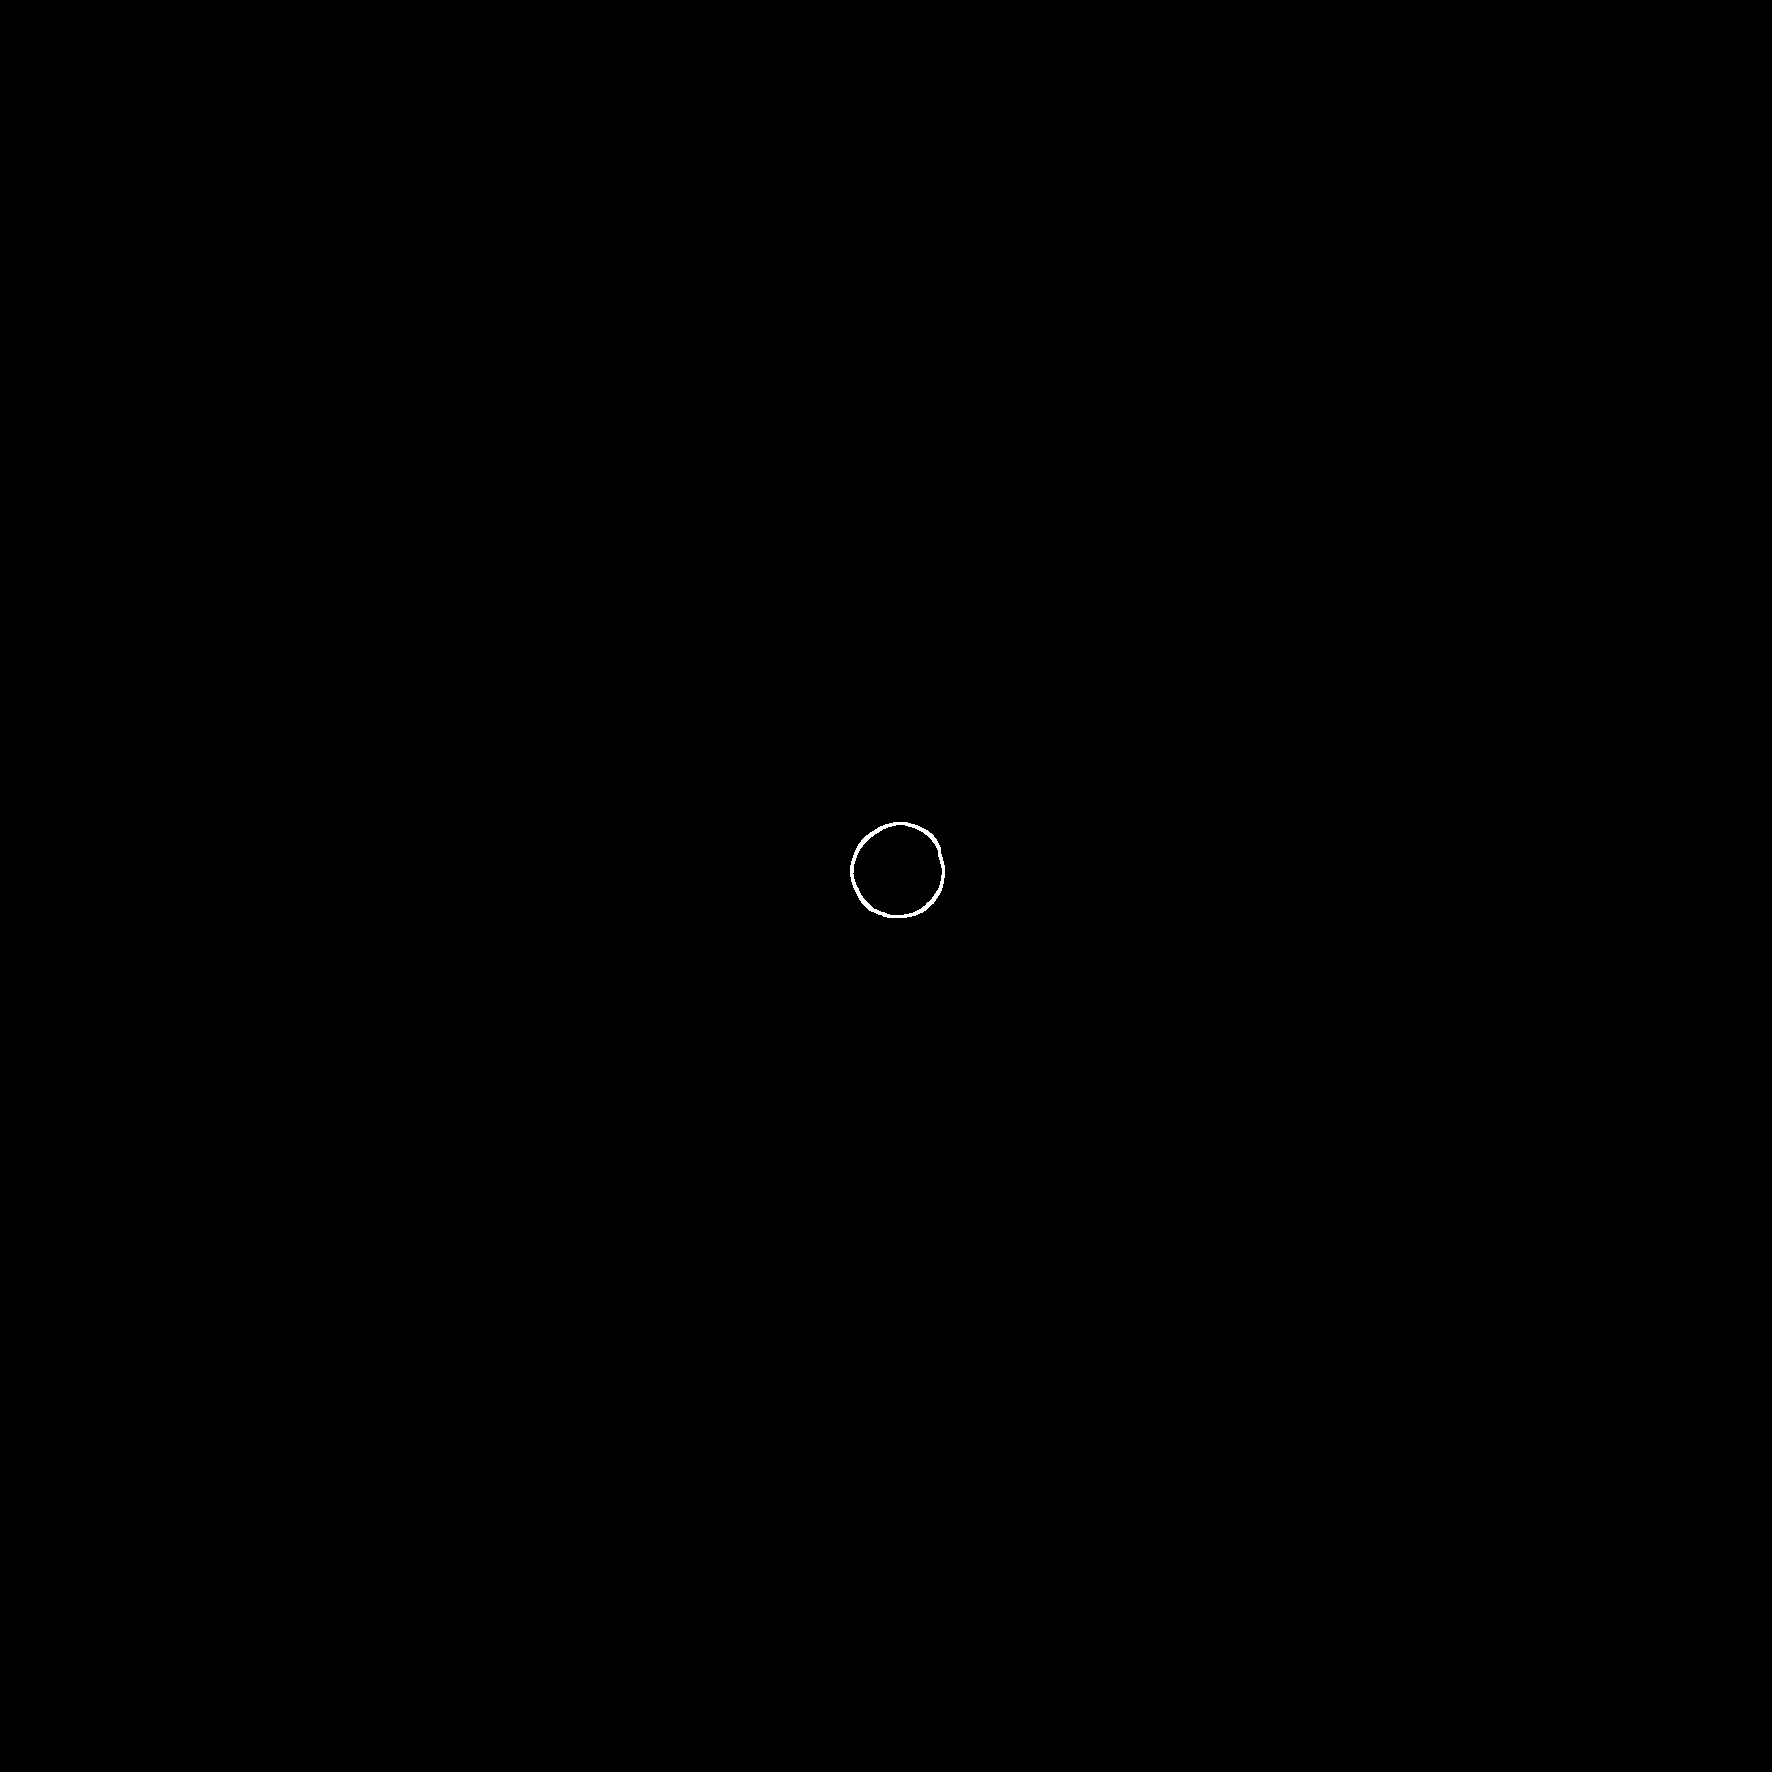

Liczba czarnych kropek: 1


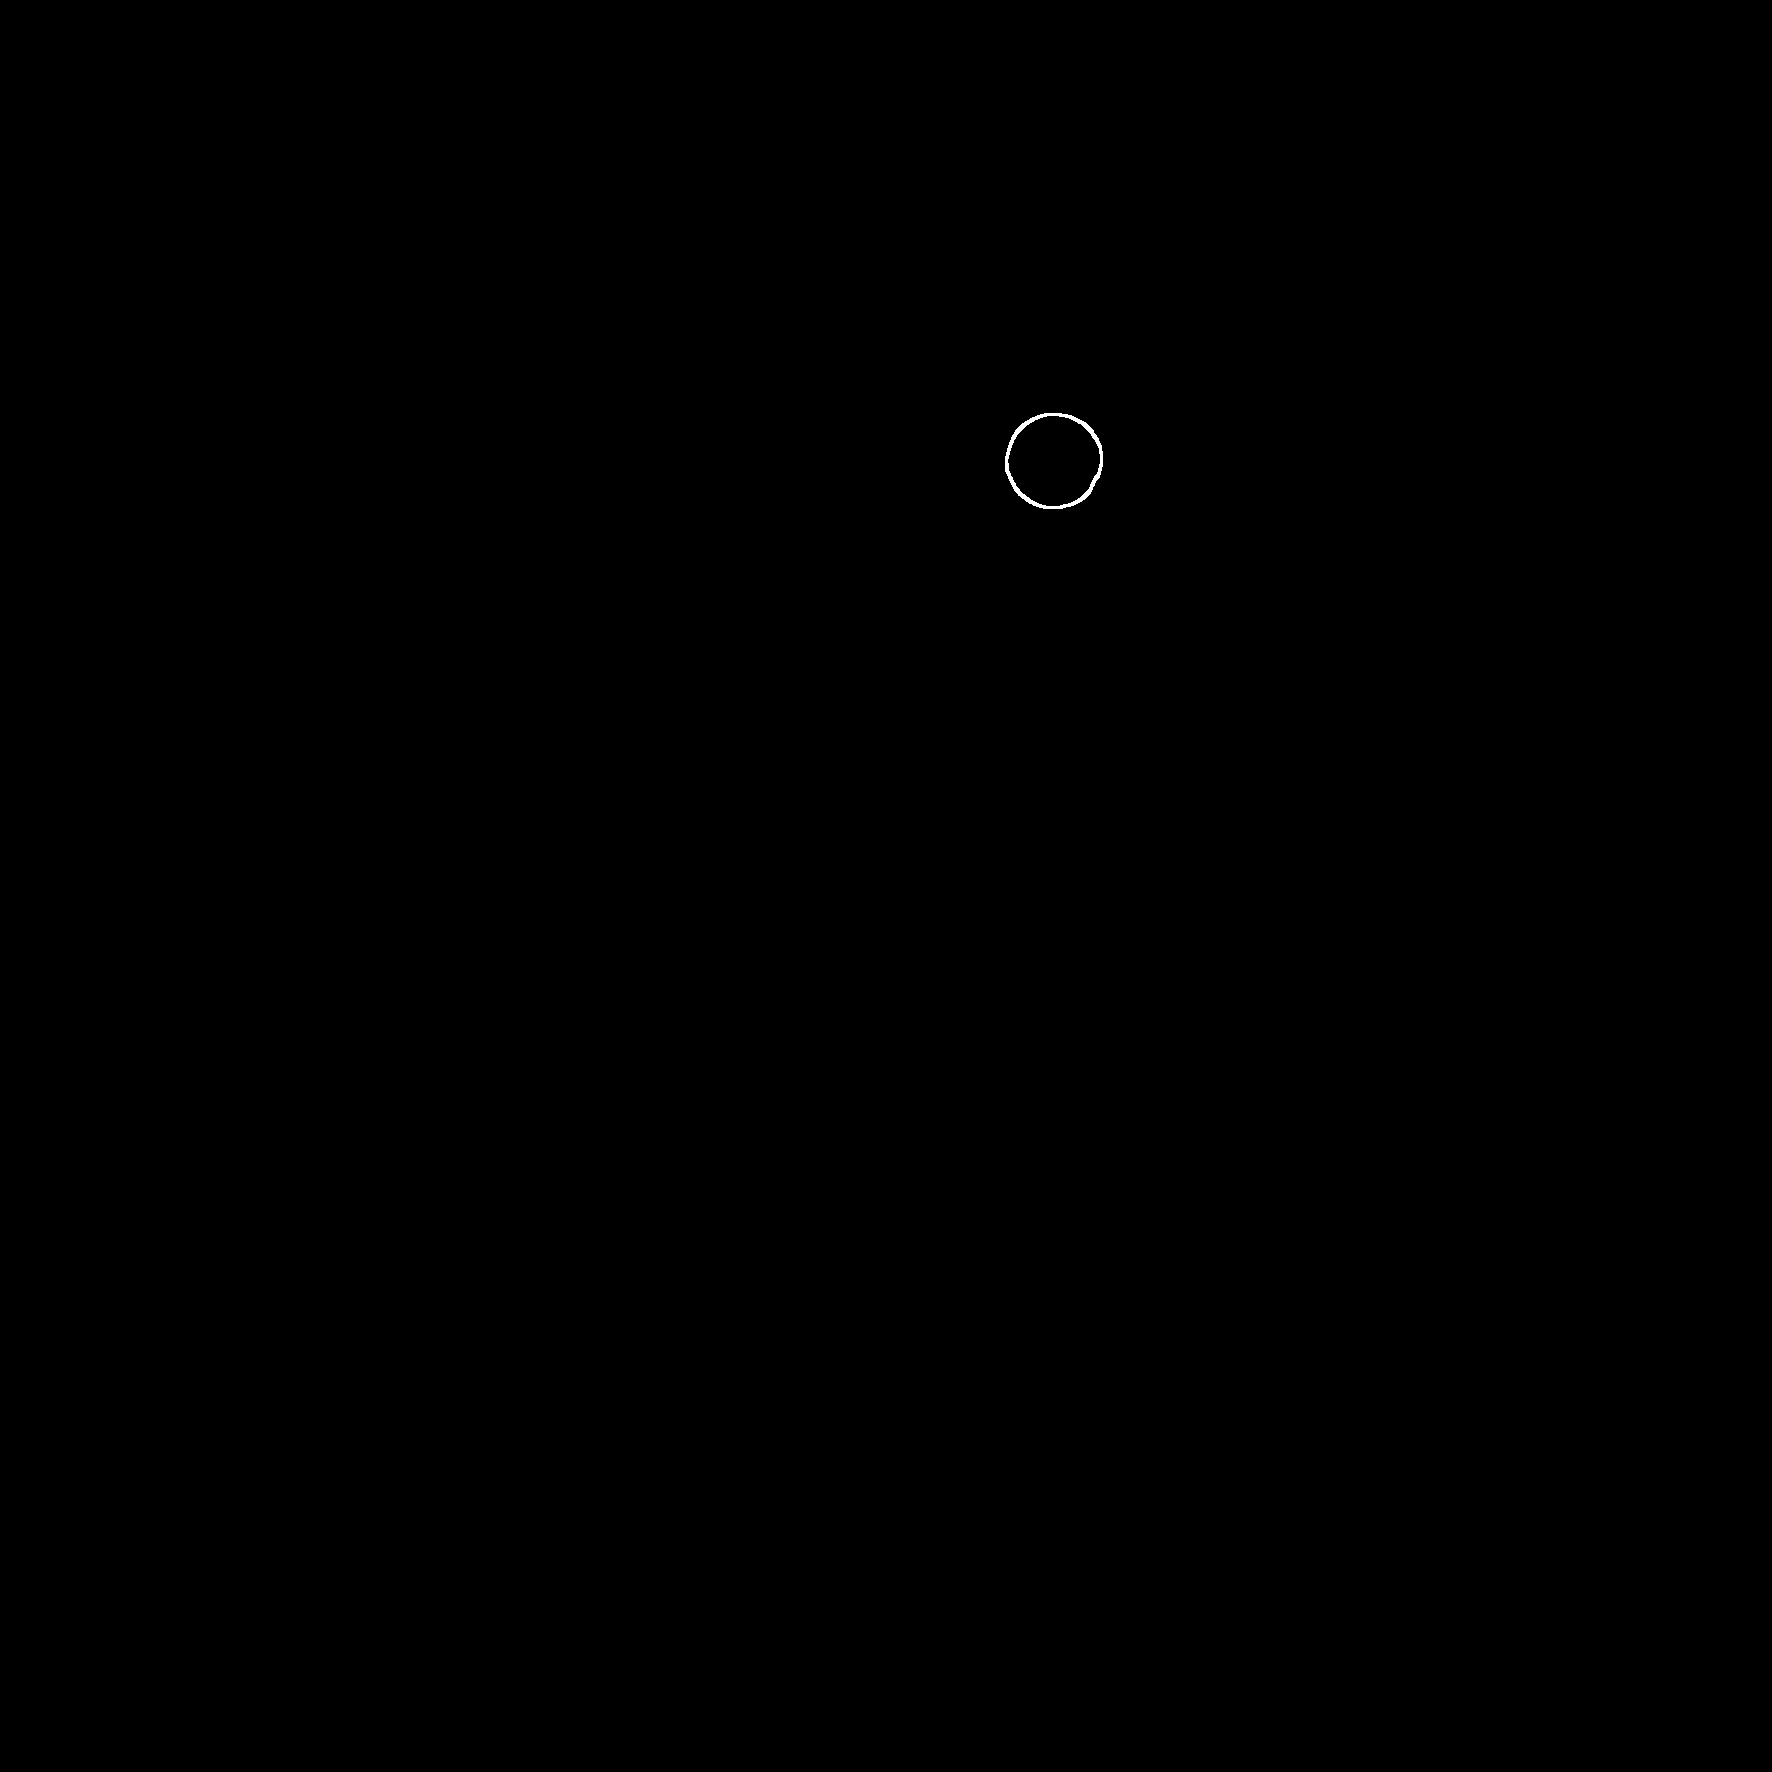

Liczba czarnych kropek: 1


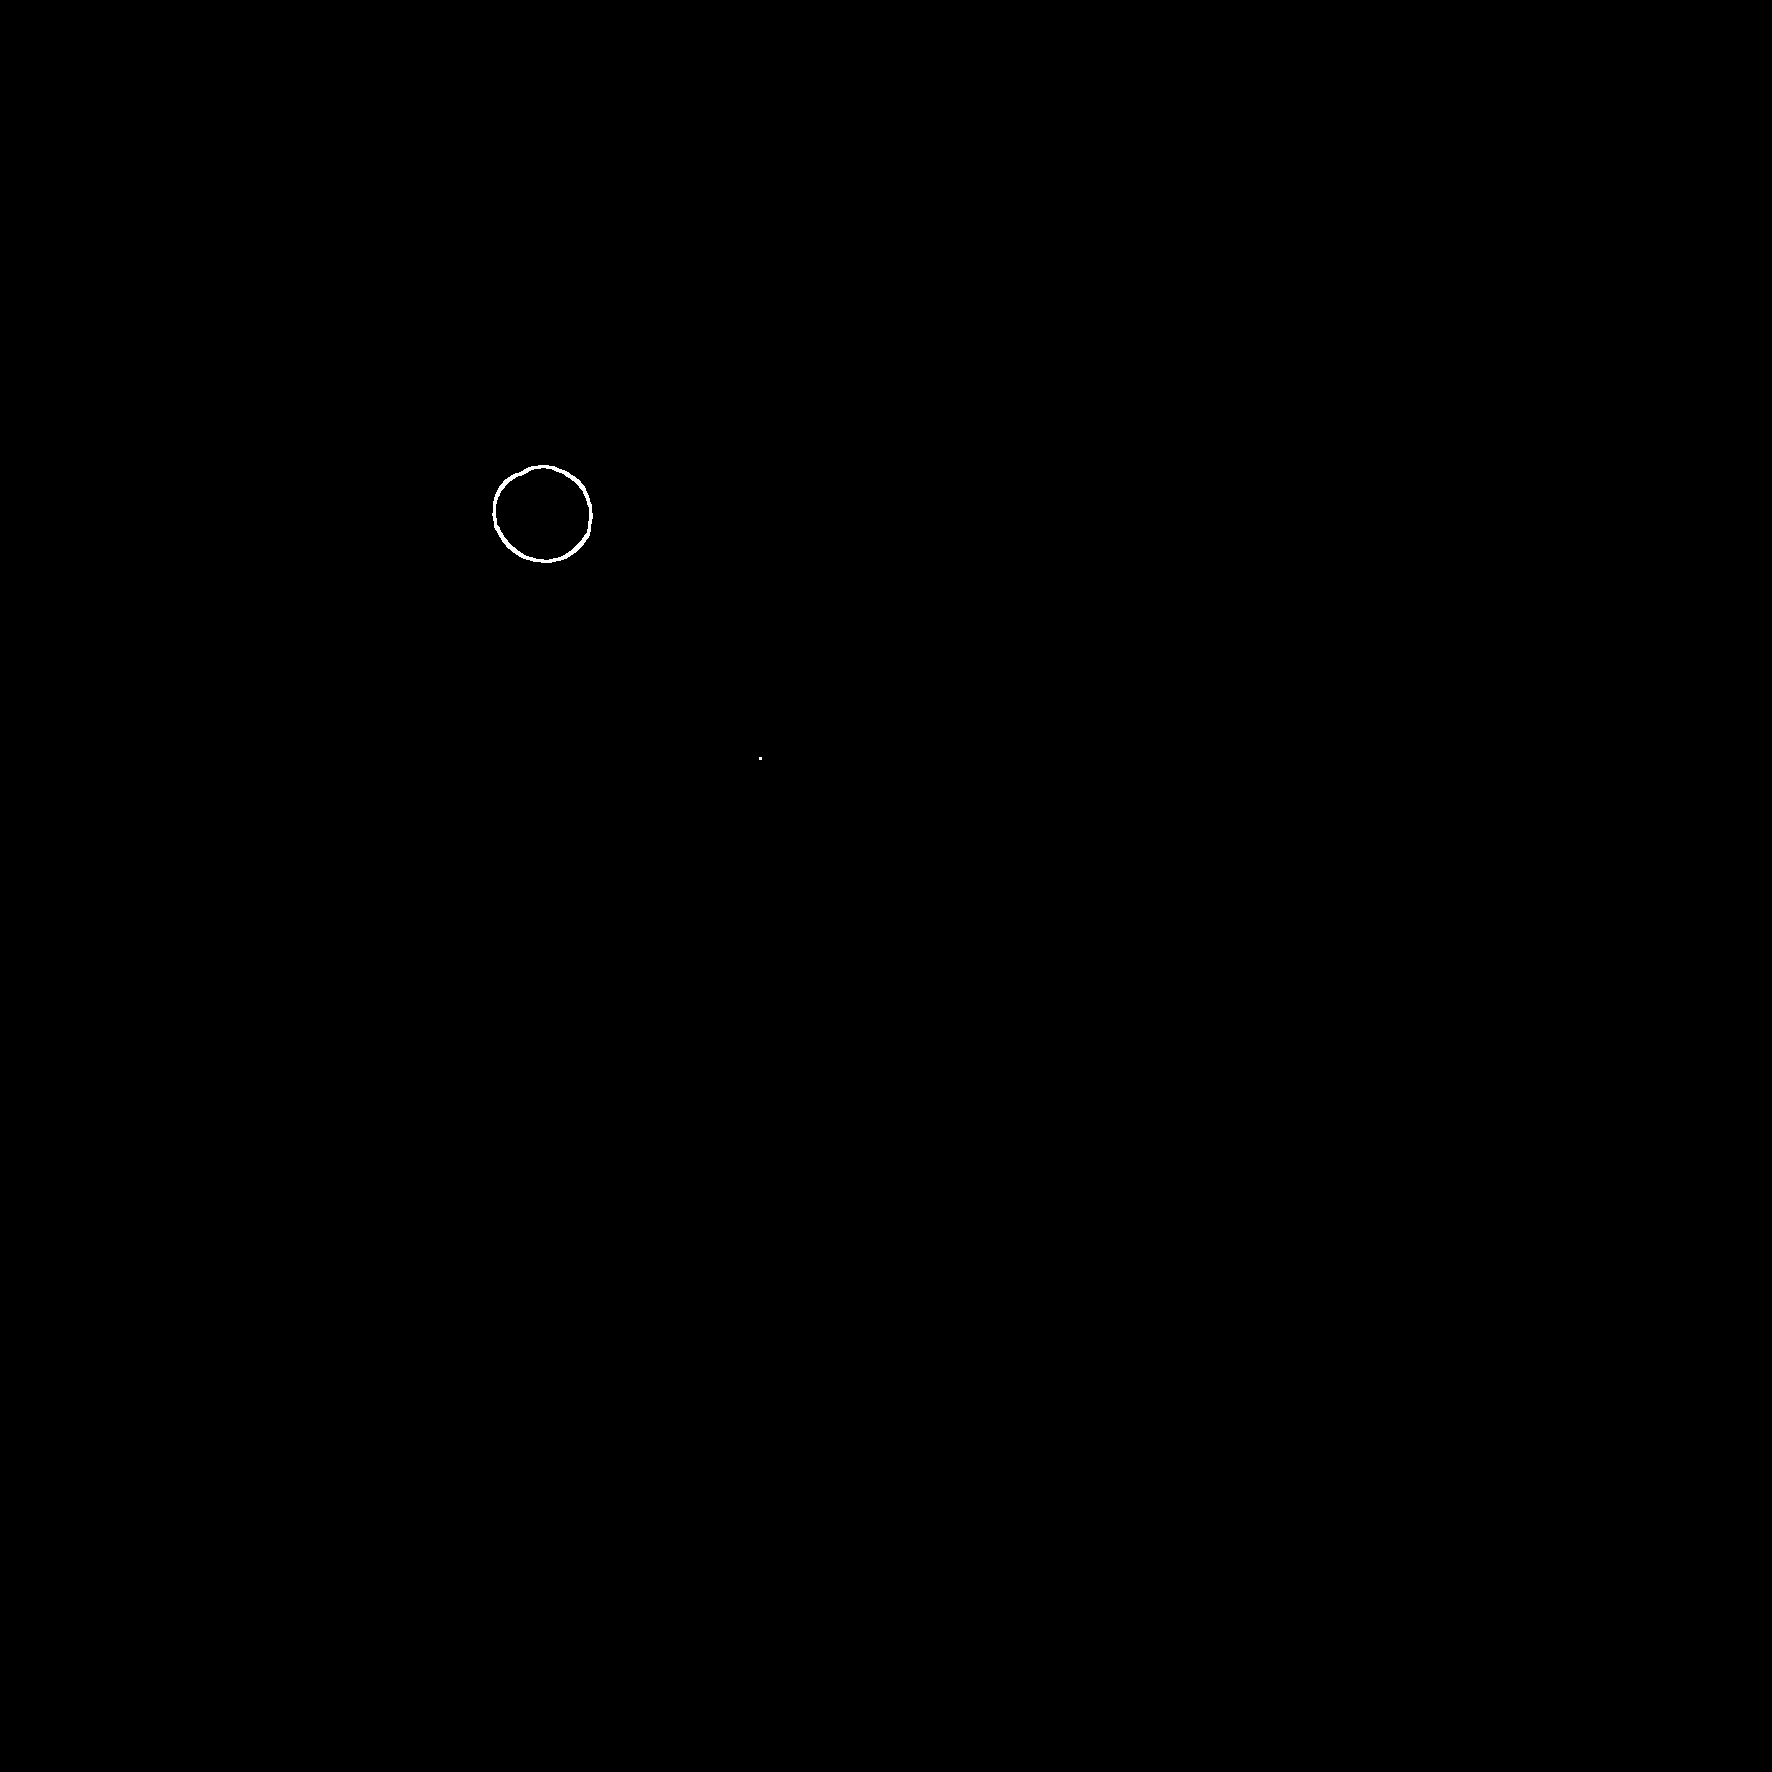

Liczba czarnych kropek: 1


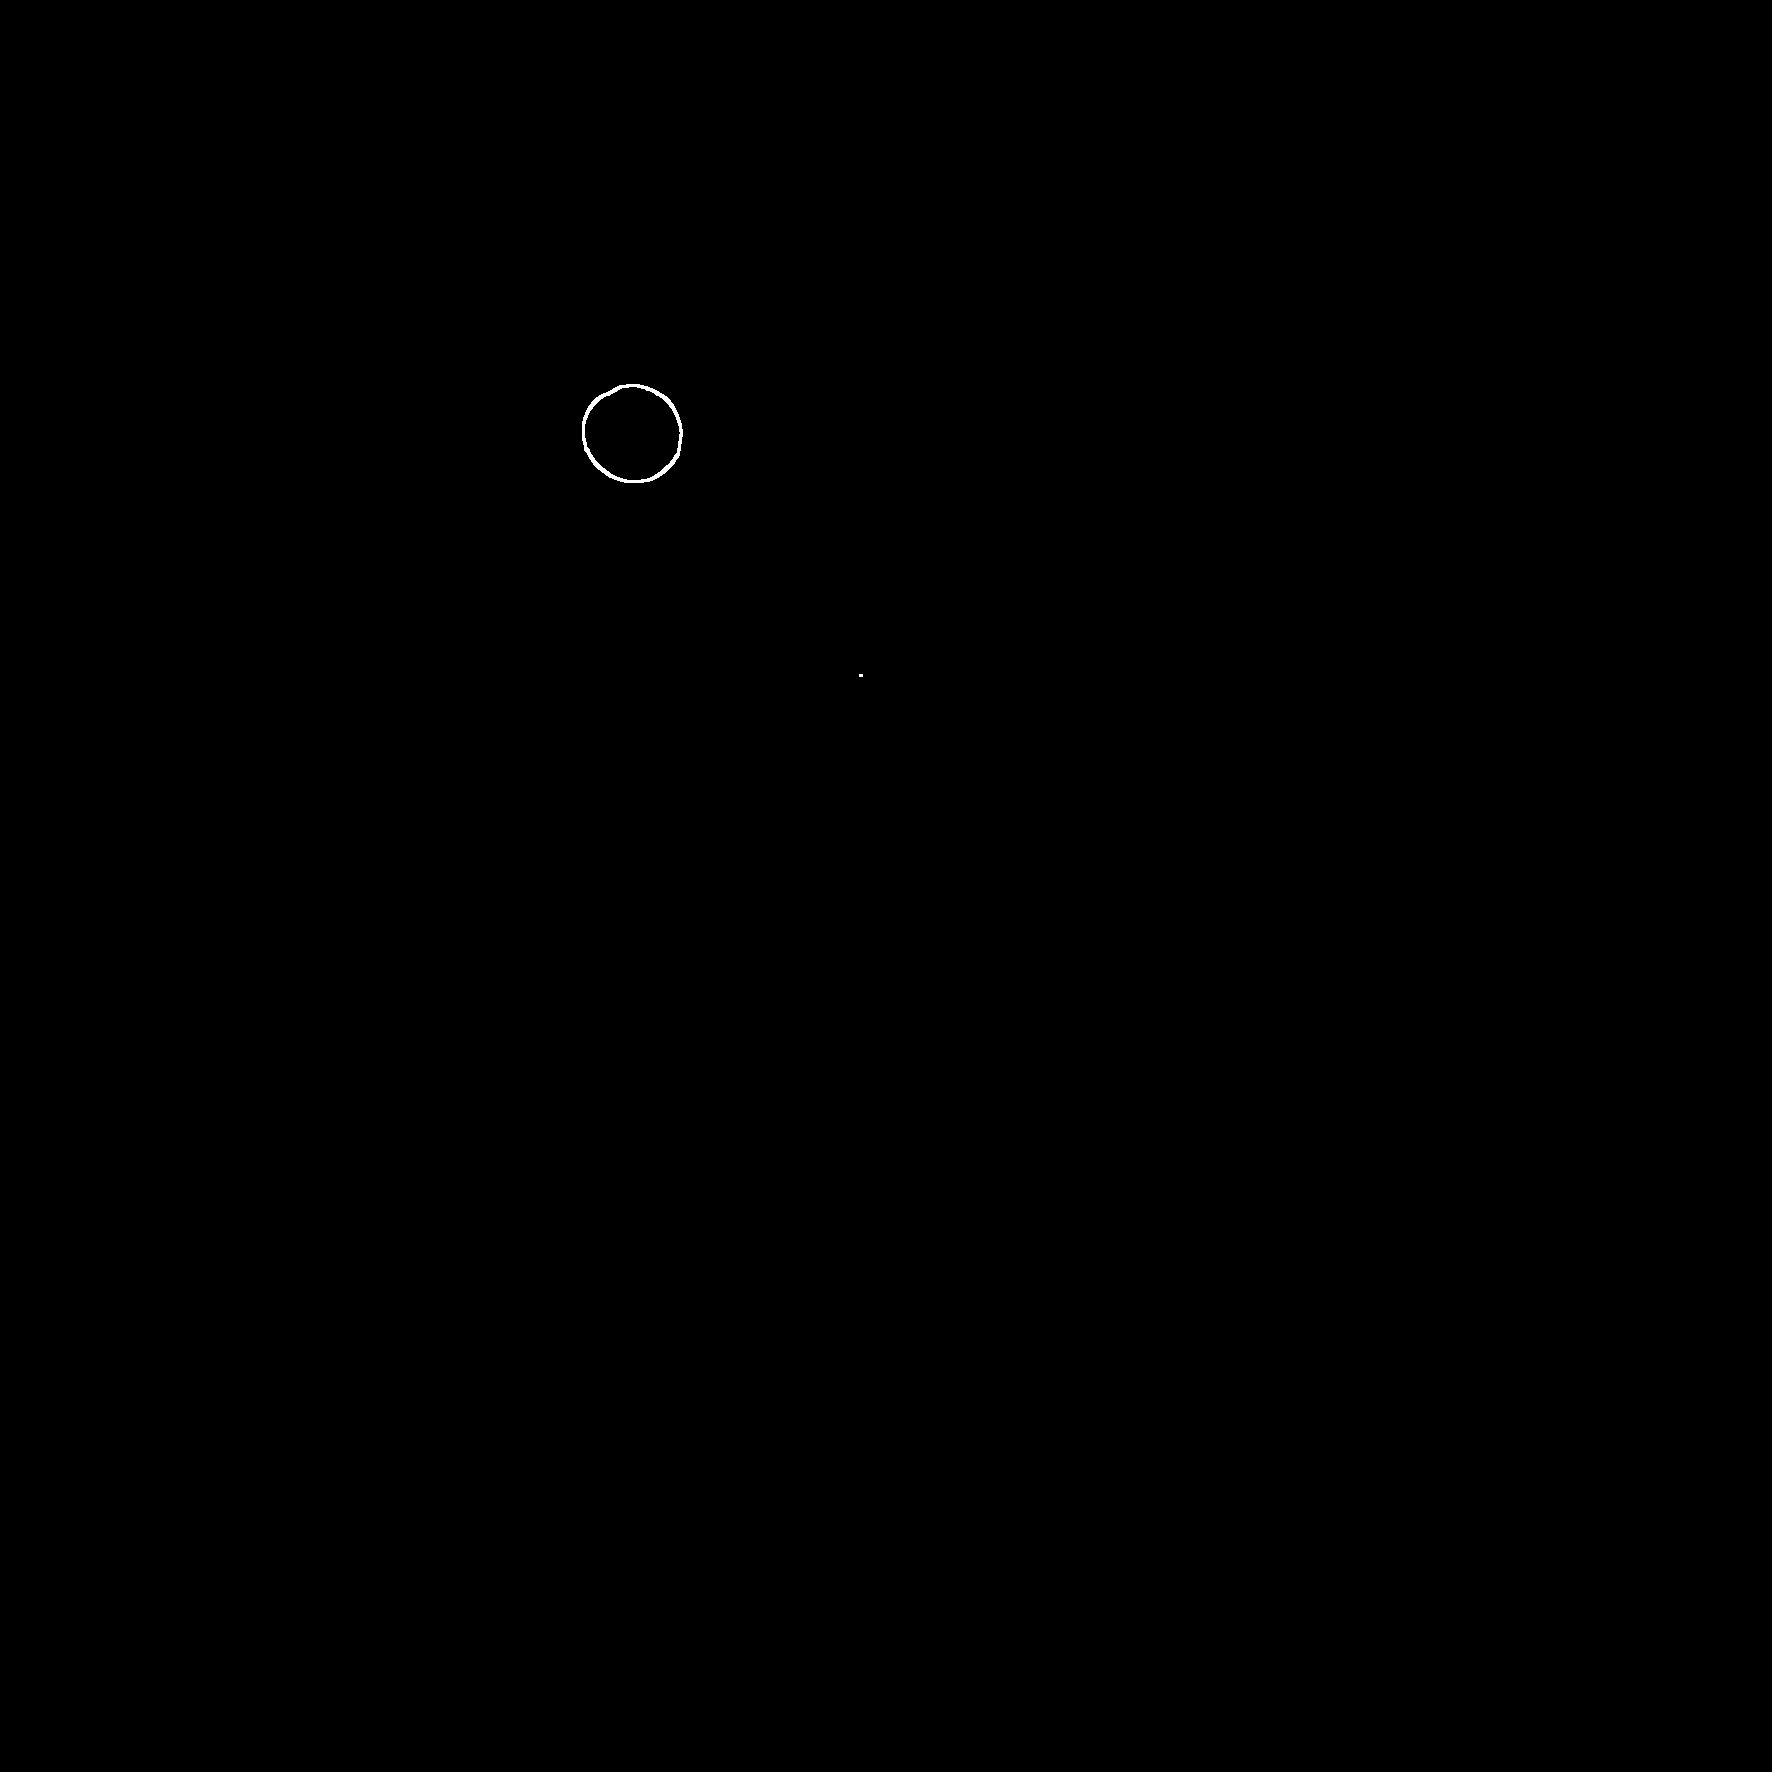

Liczba czarnych kropek: 1


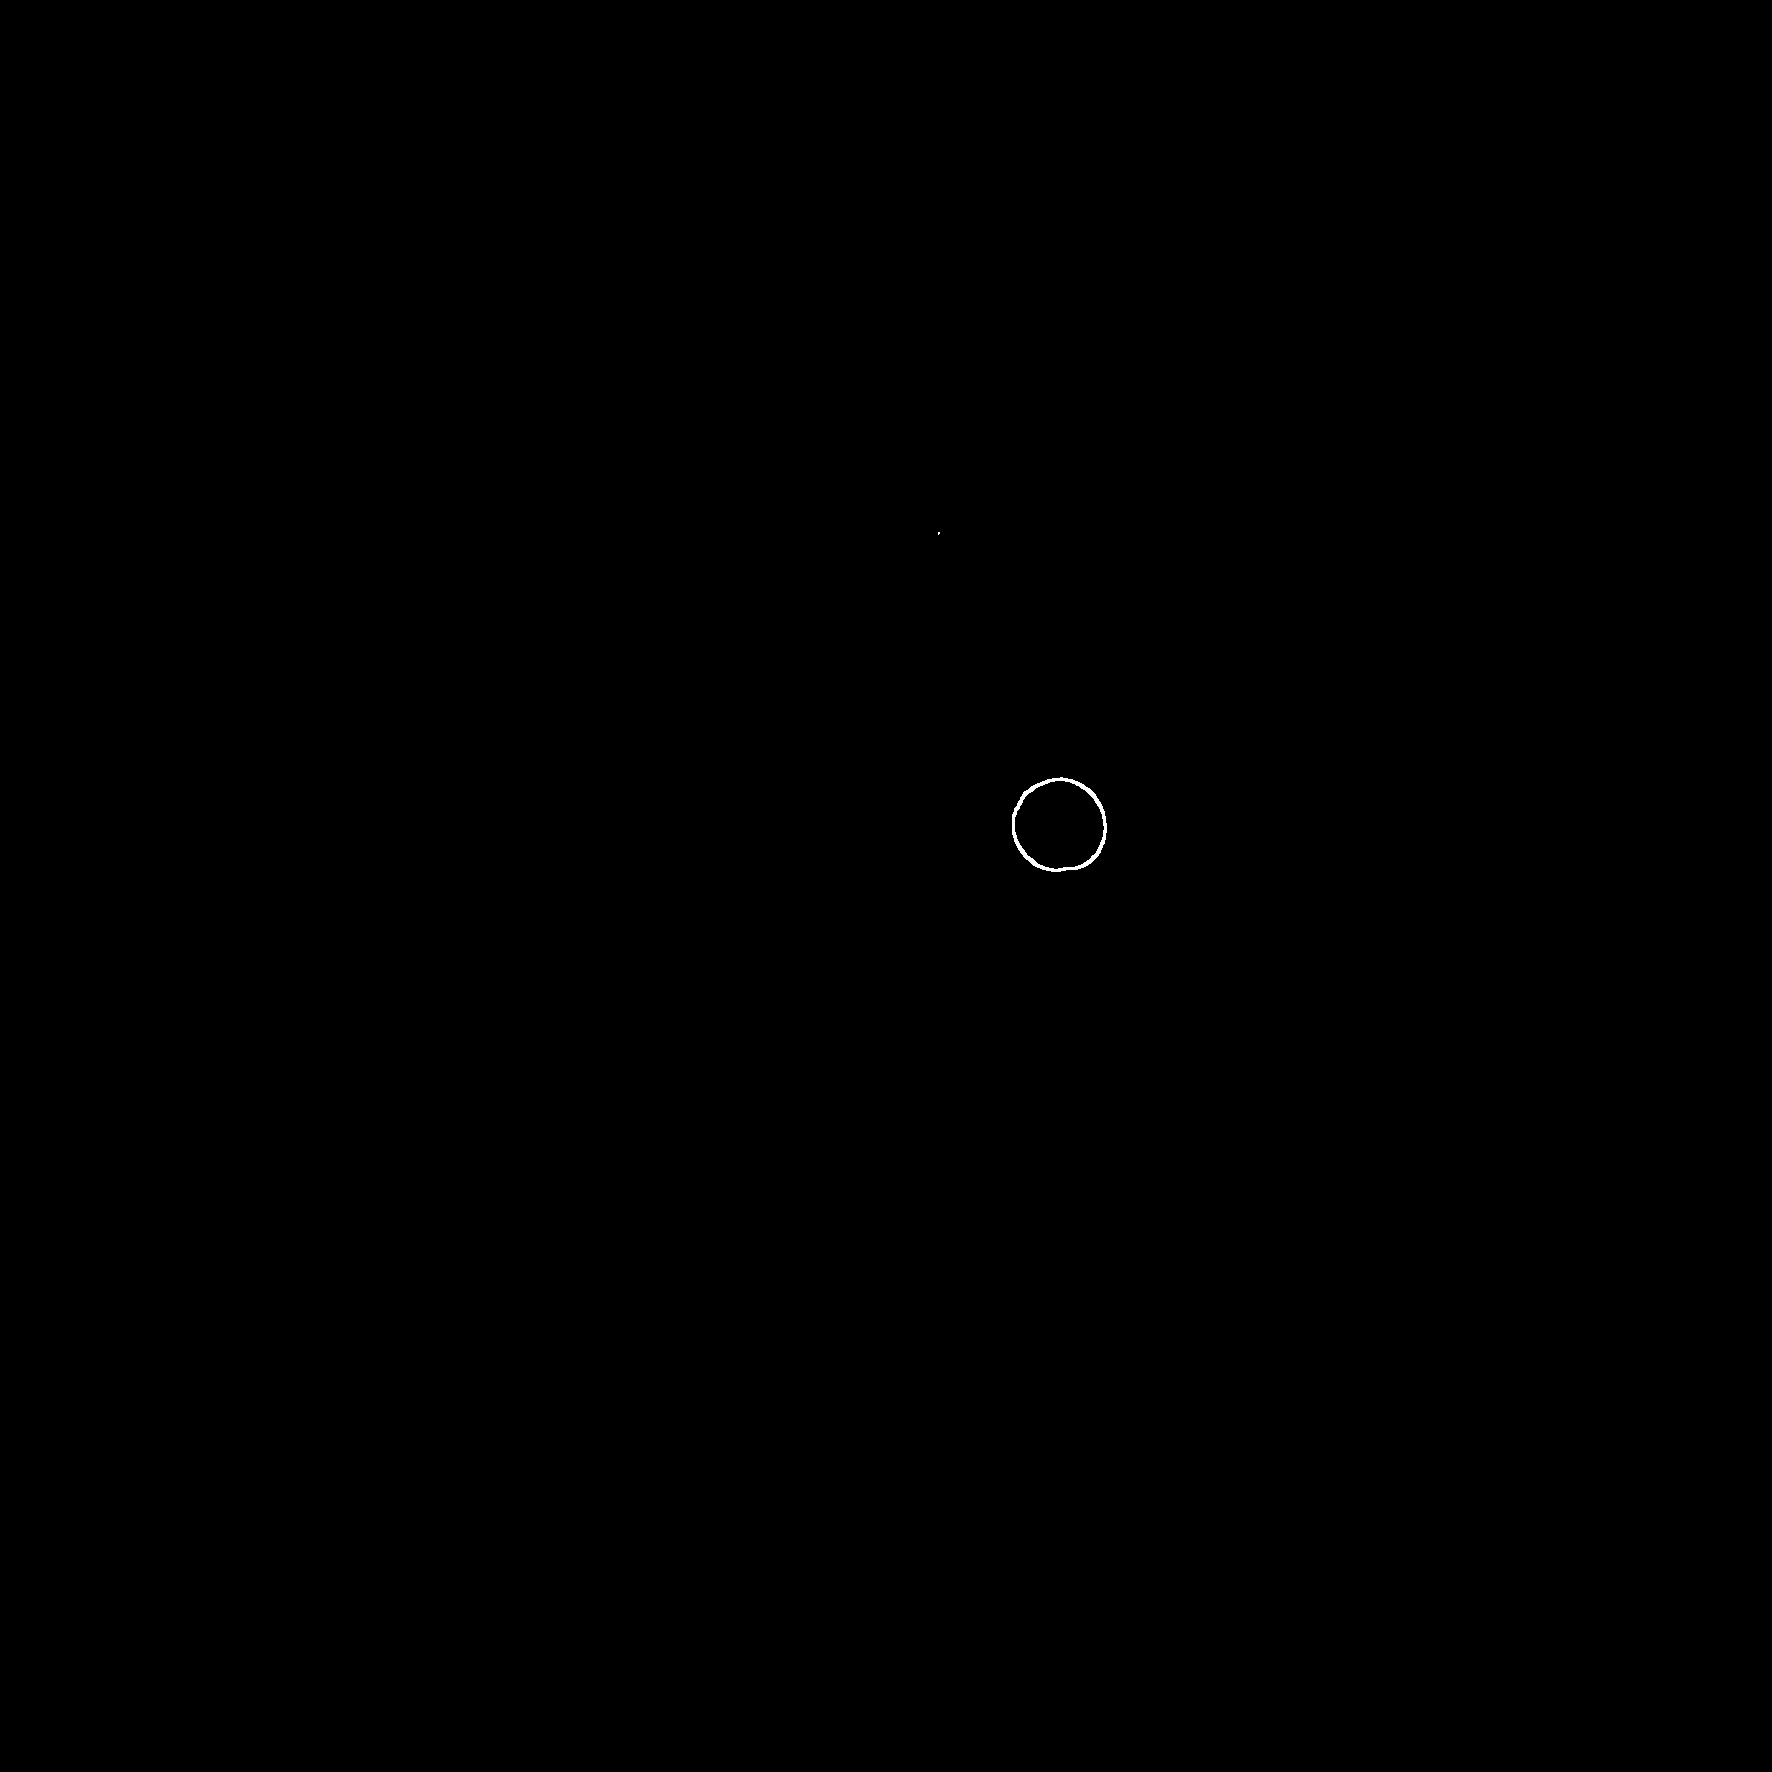

Liczba czarnych kropek: 1


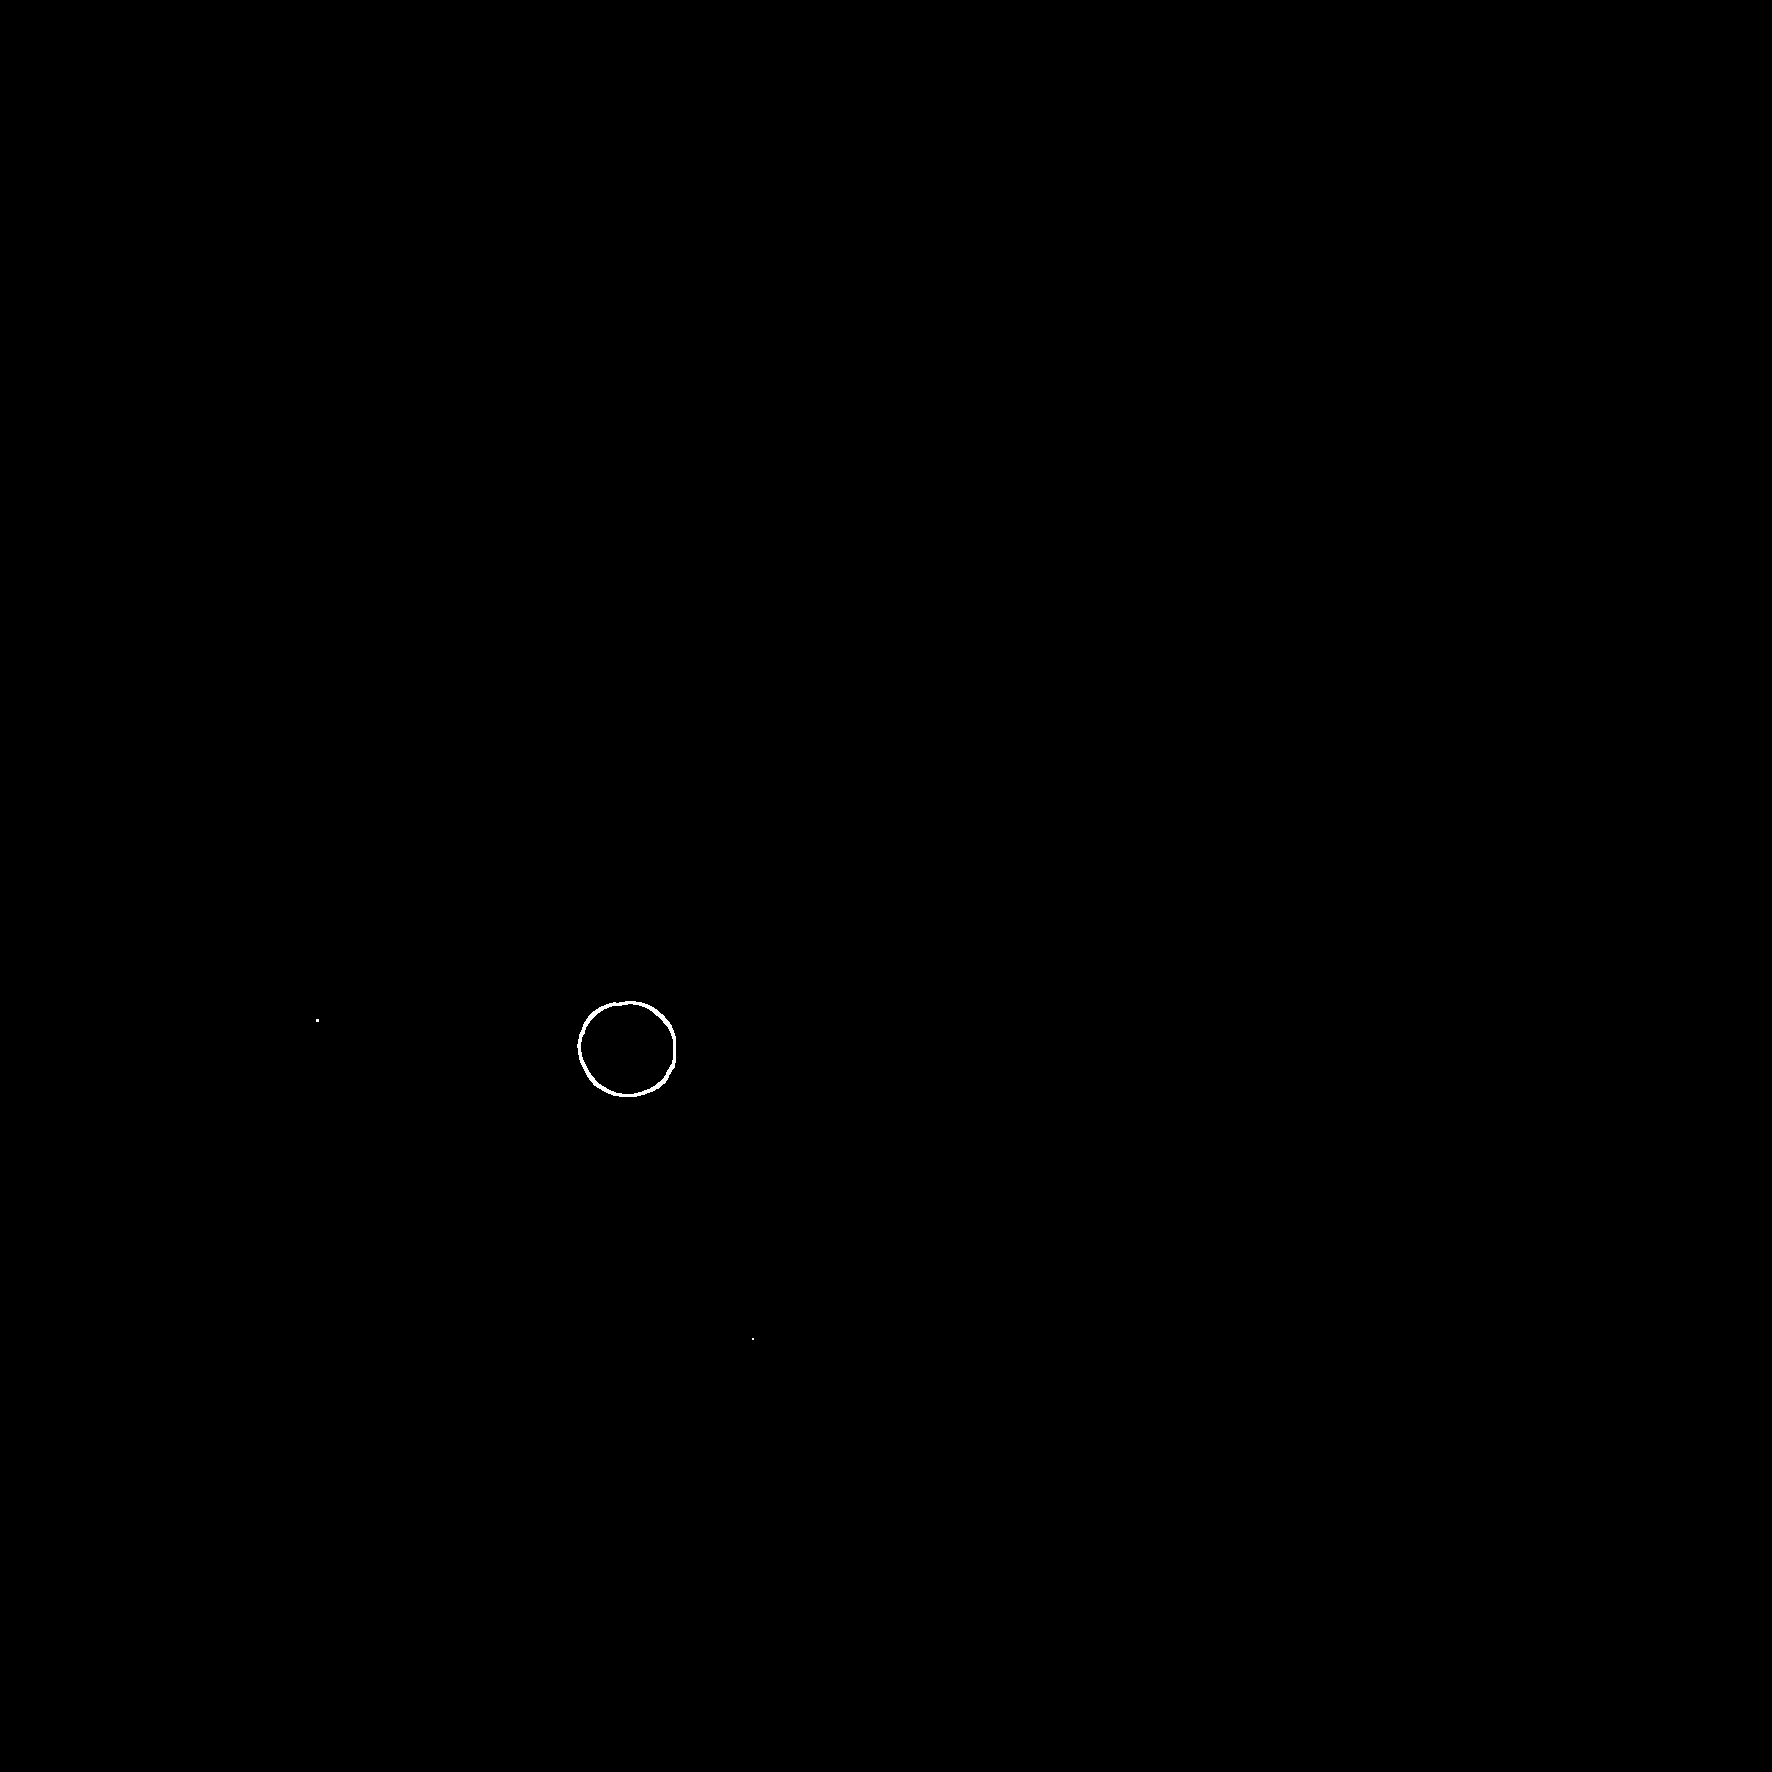

Liczba czarnych kropek: 1


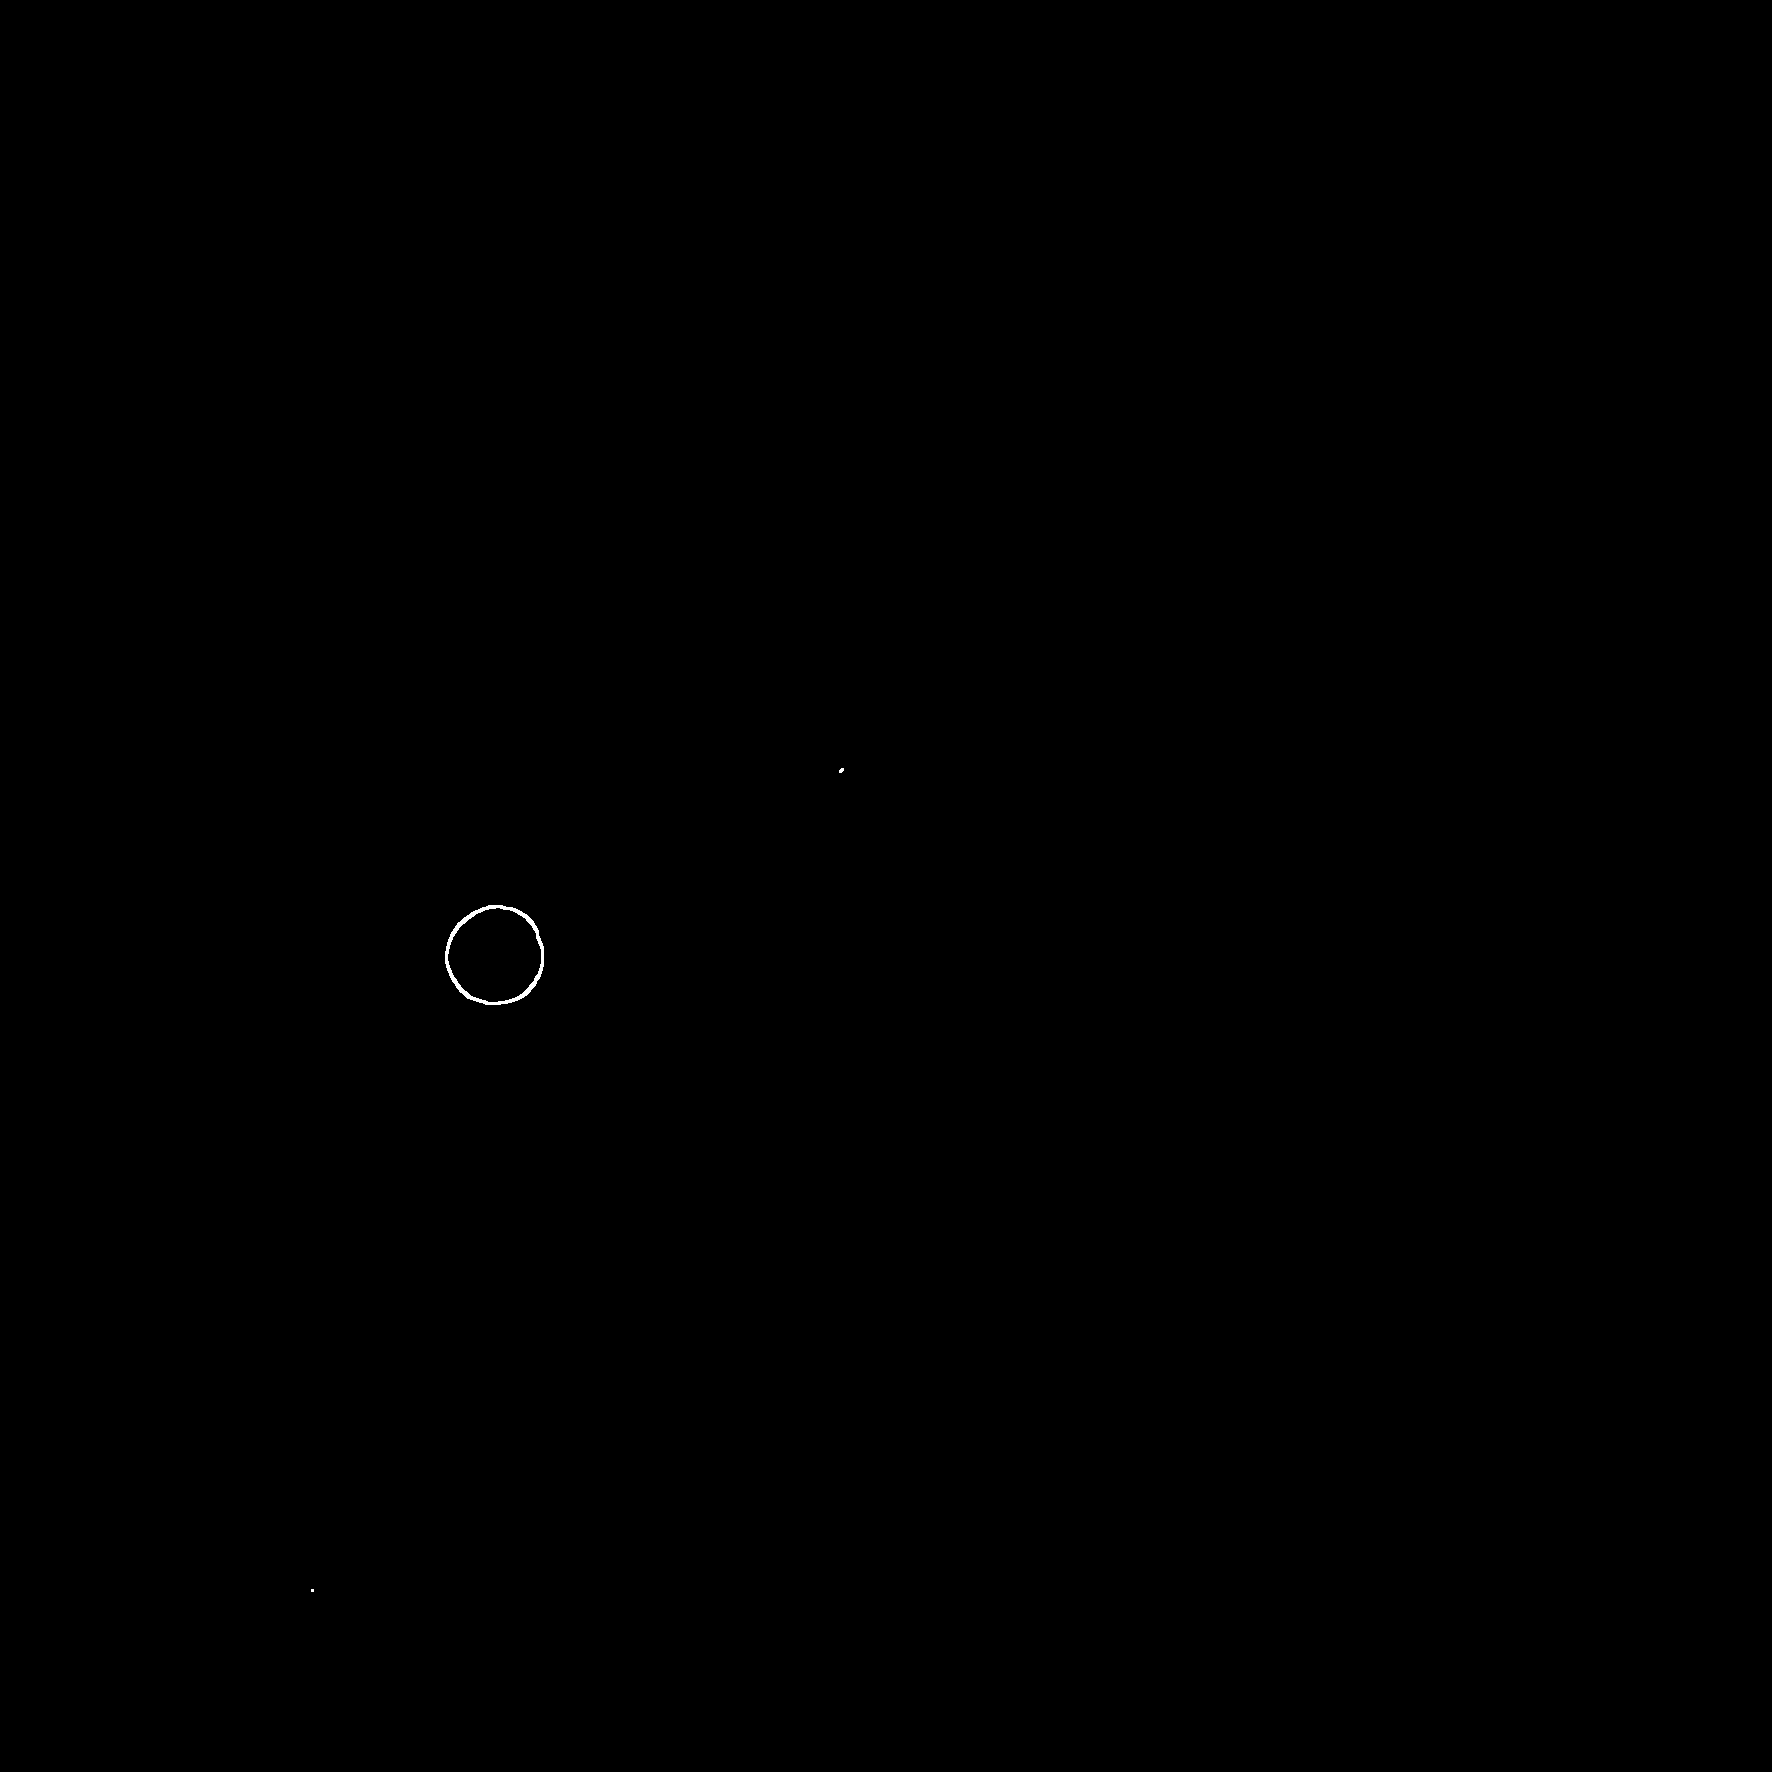

Liczba czarnych kropek: 1


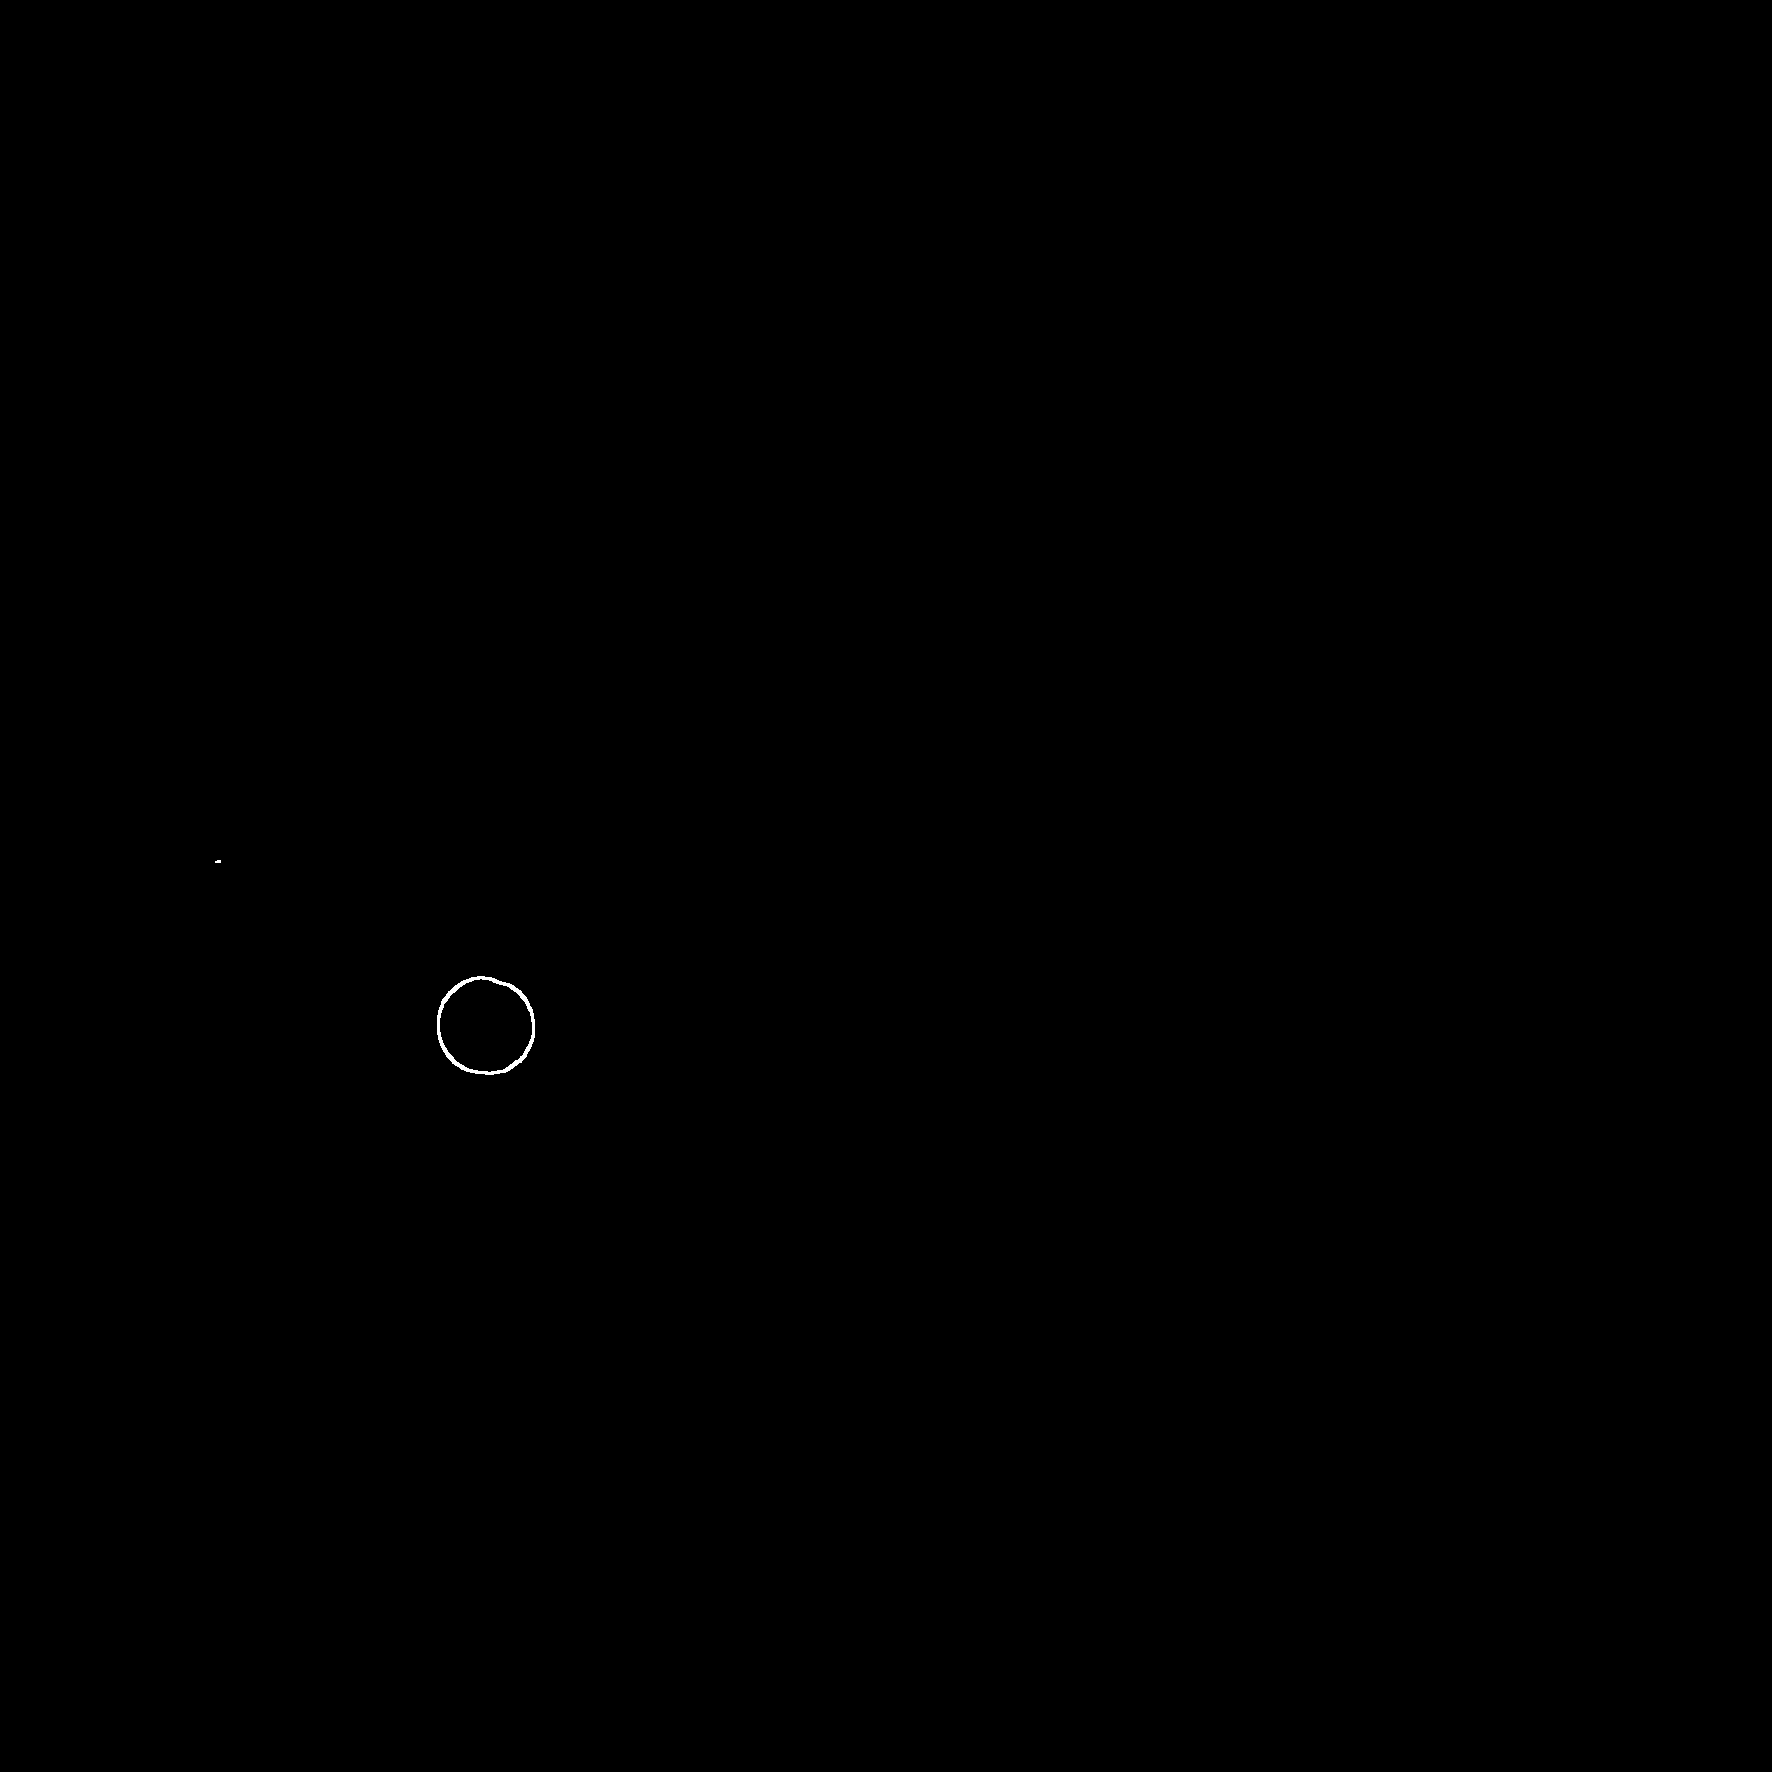

Liczba czarnych kropek: 1


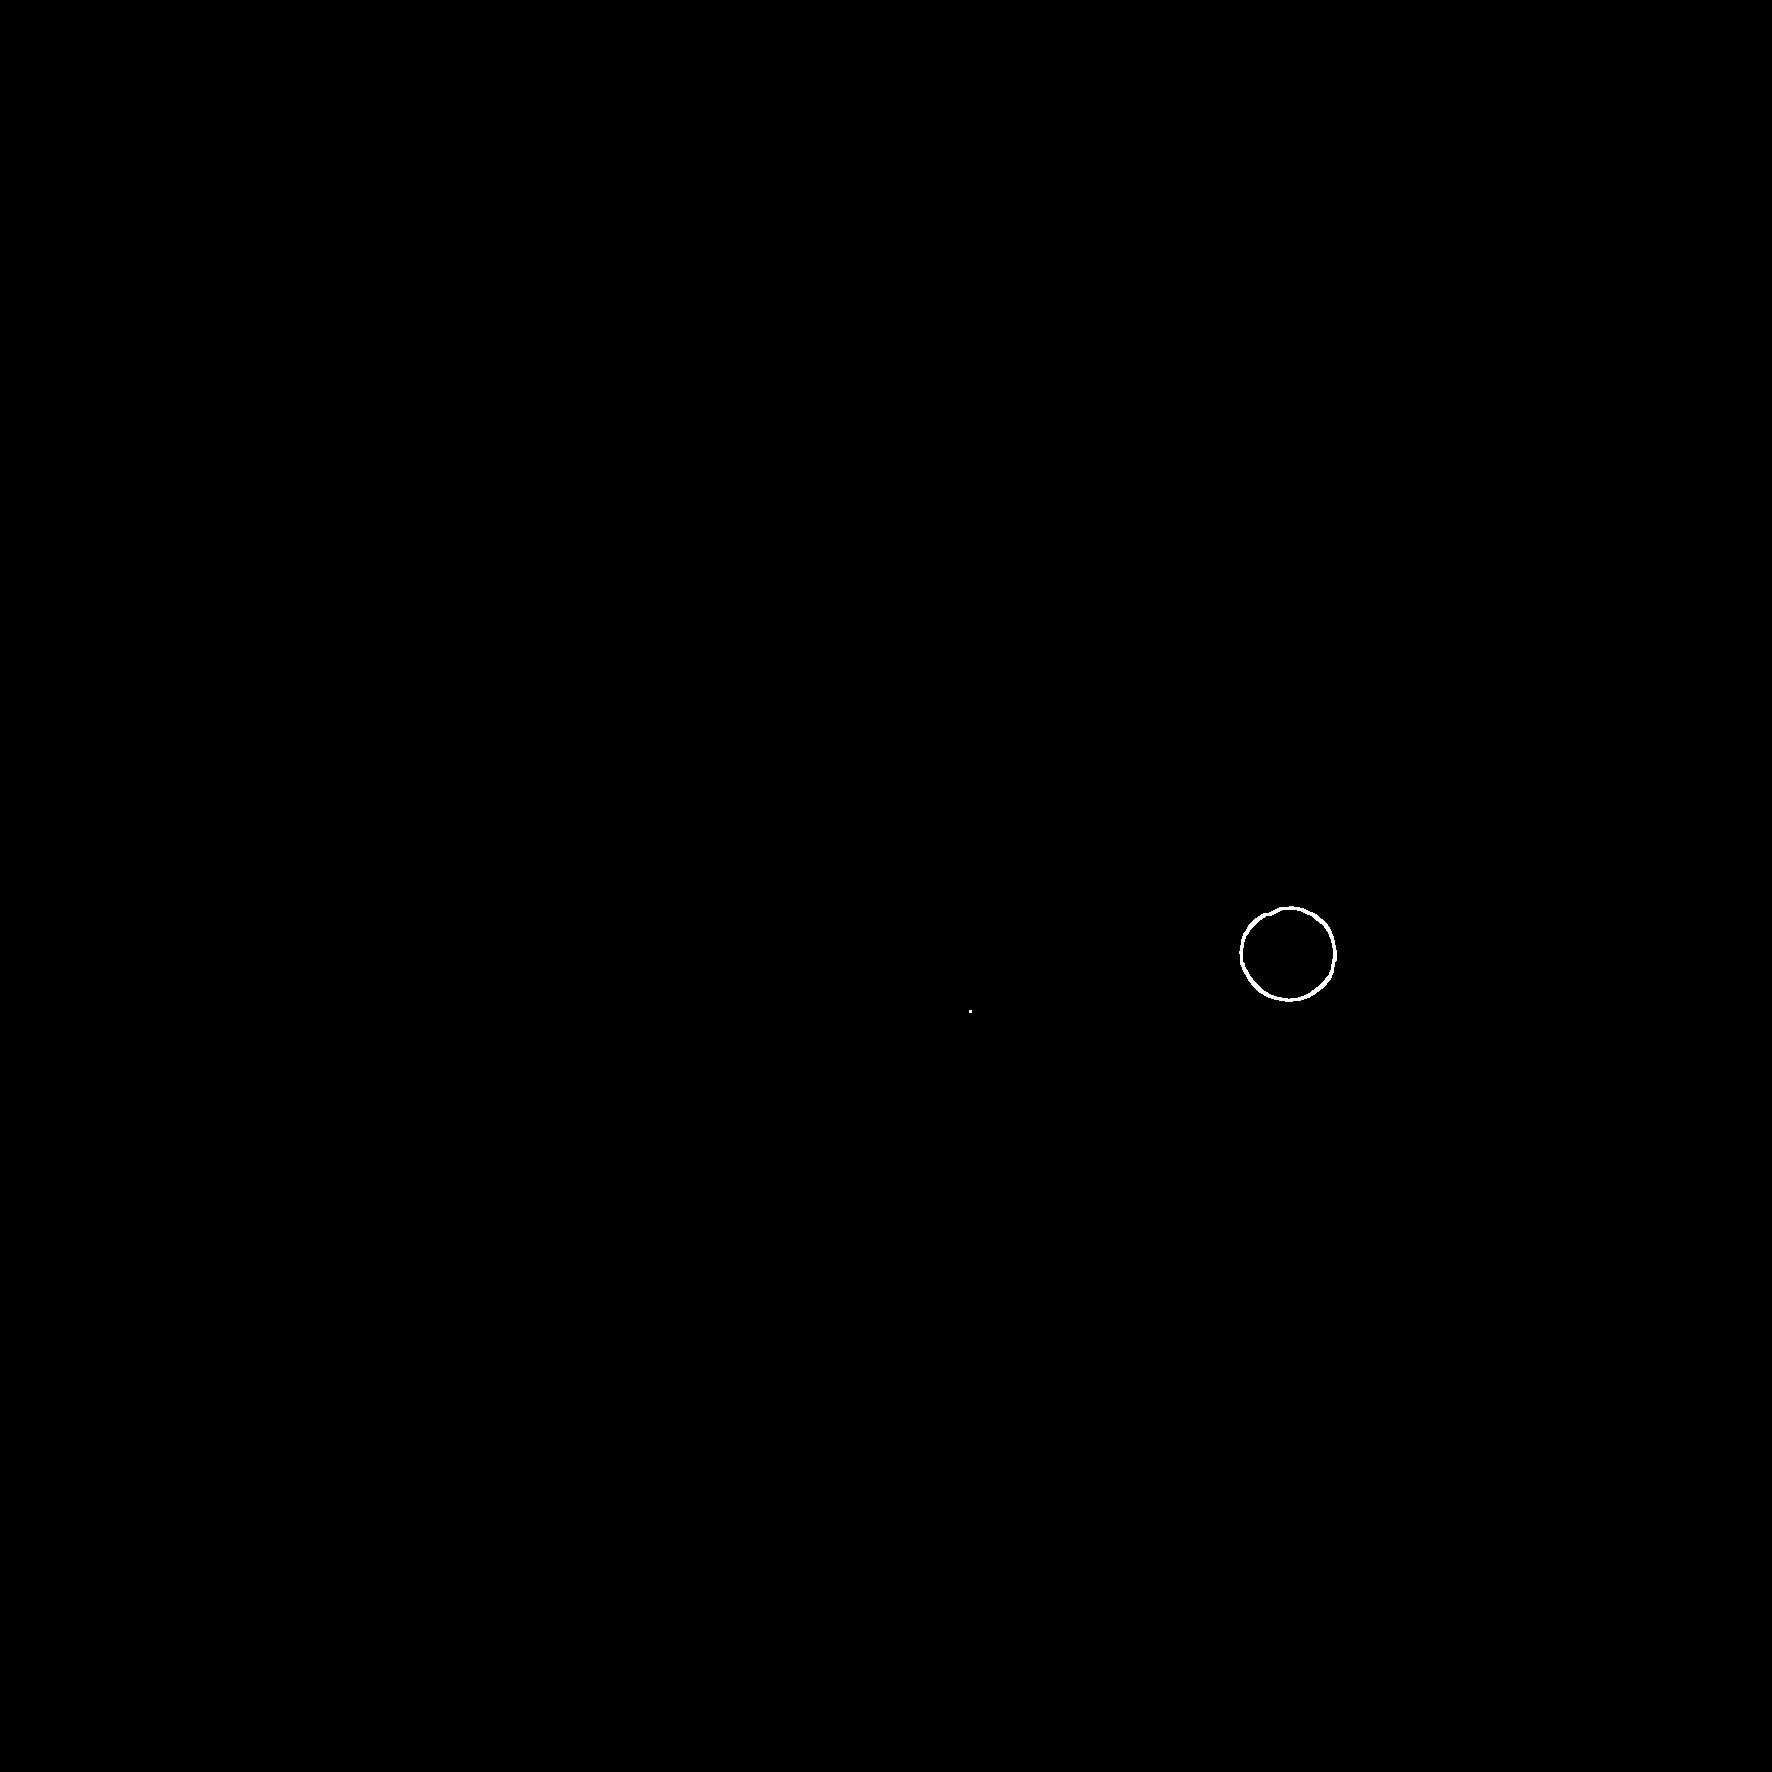

Liczba czarnych kropek: 1


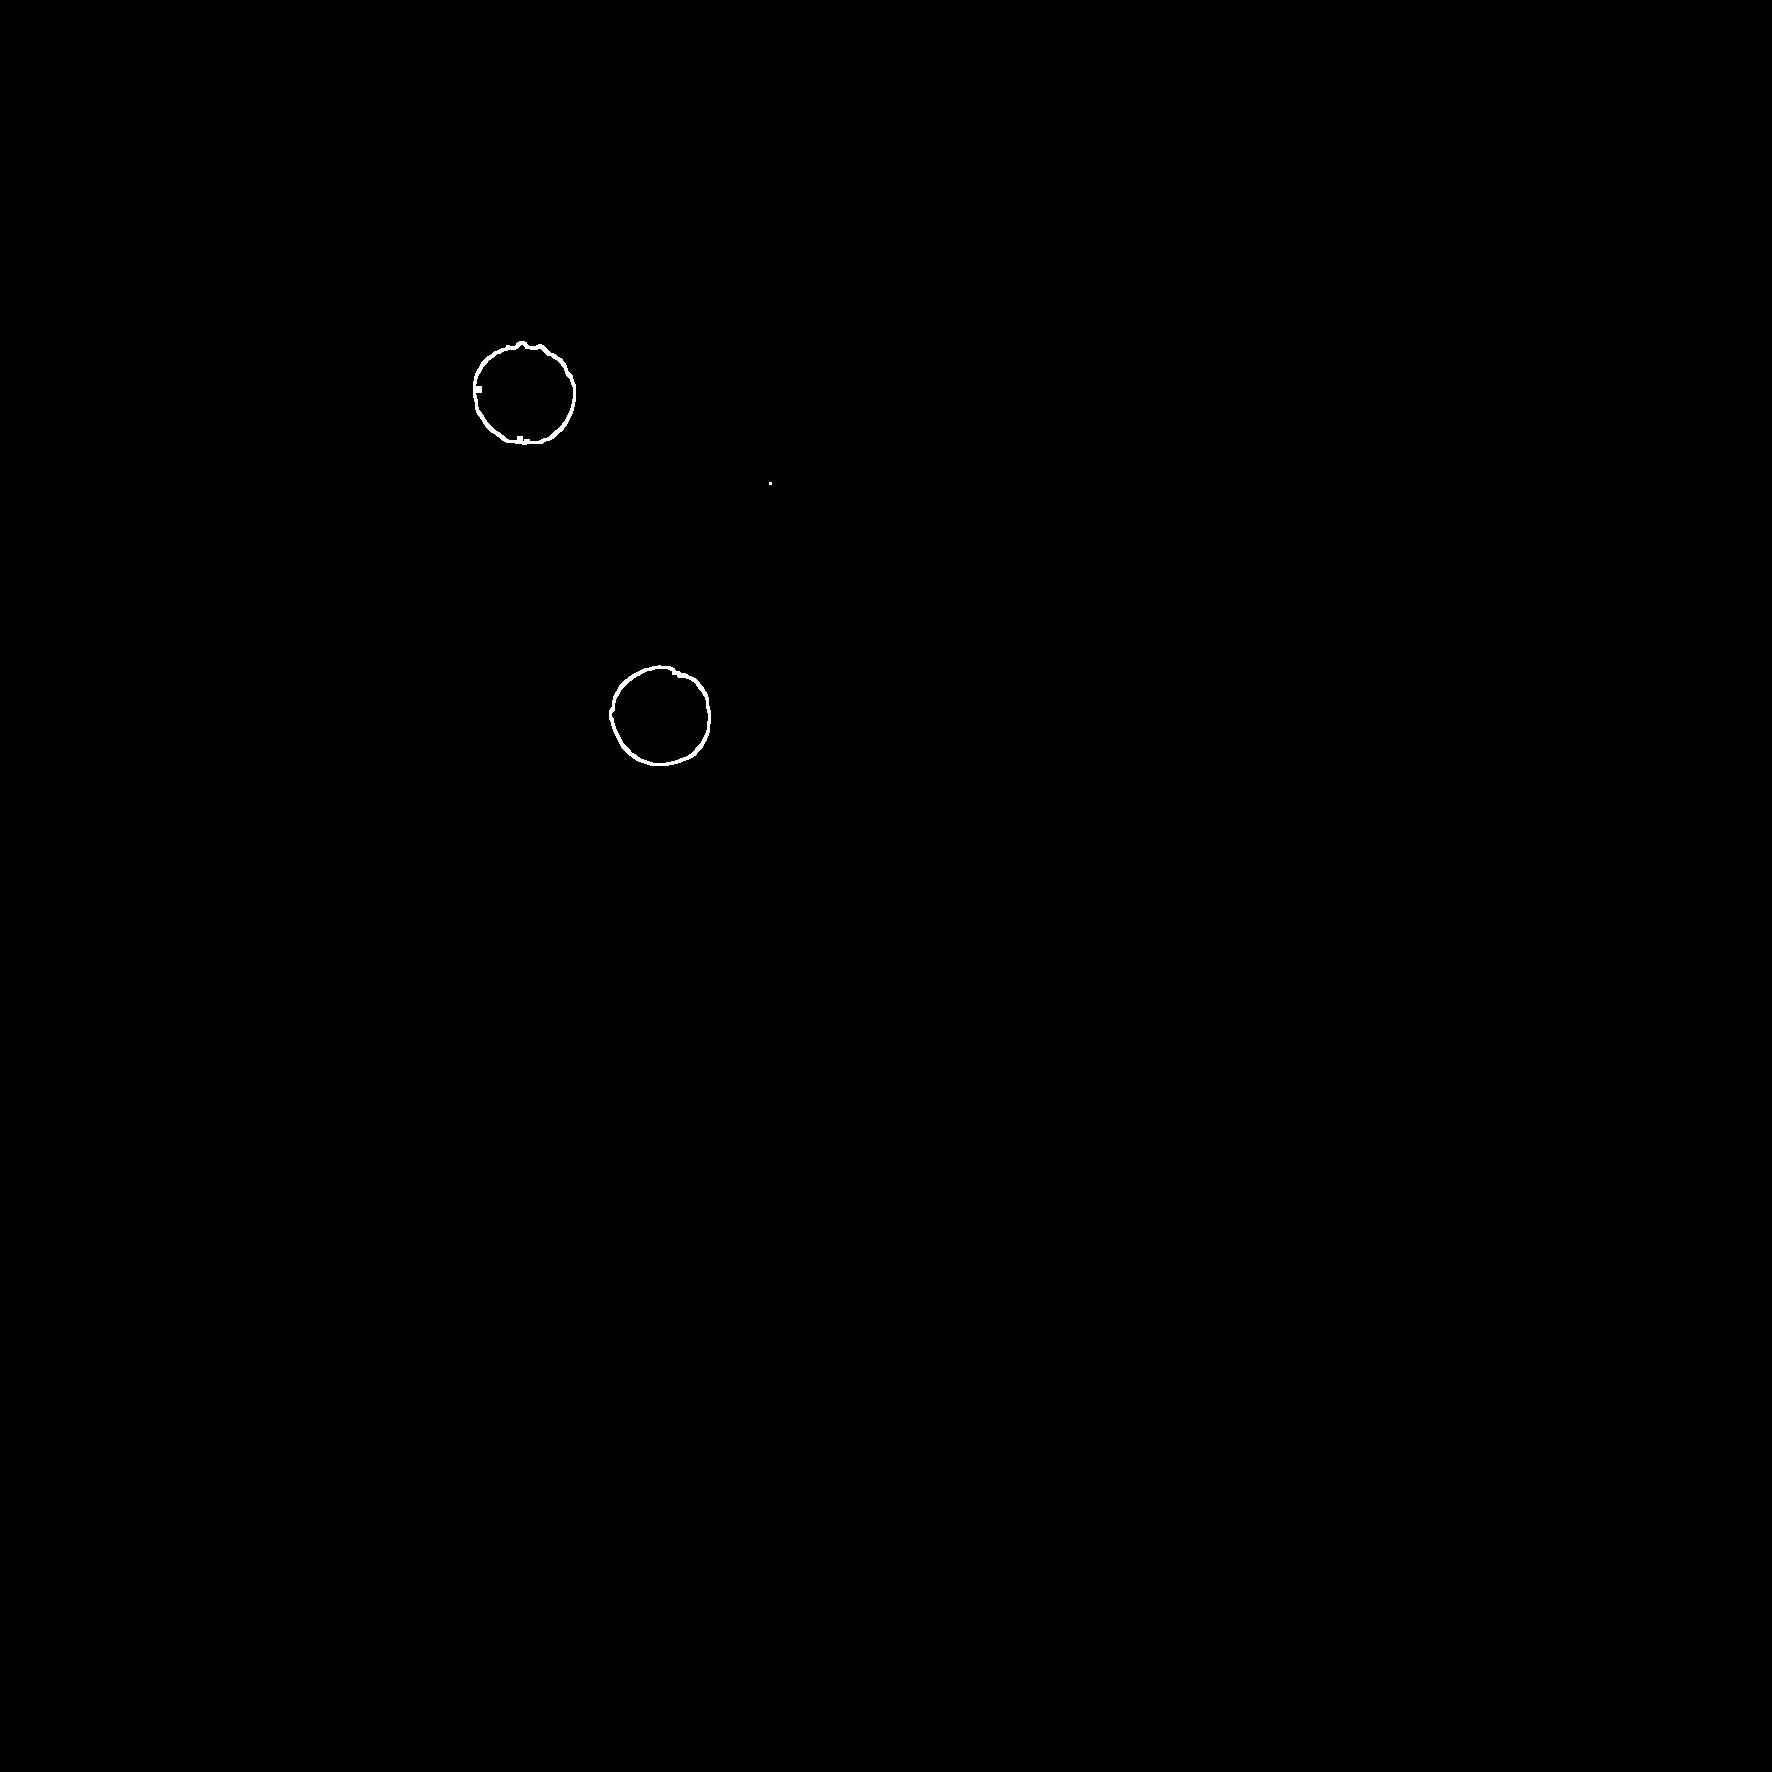

Liczba czarnych kropek: 2


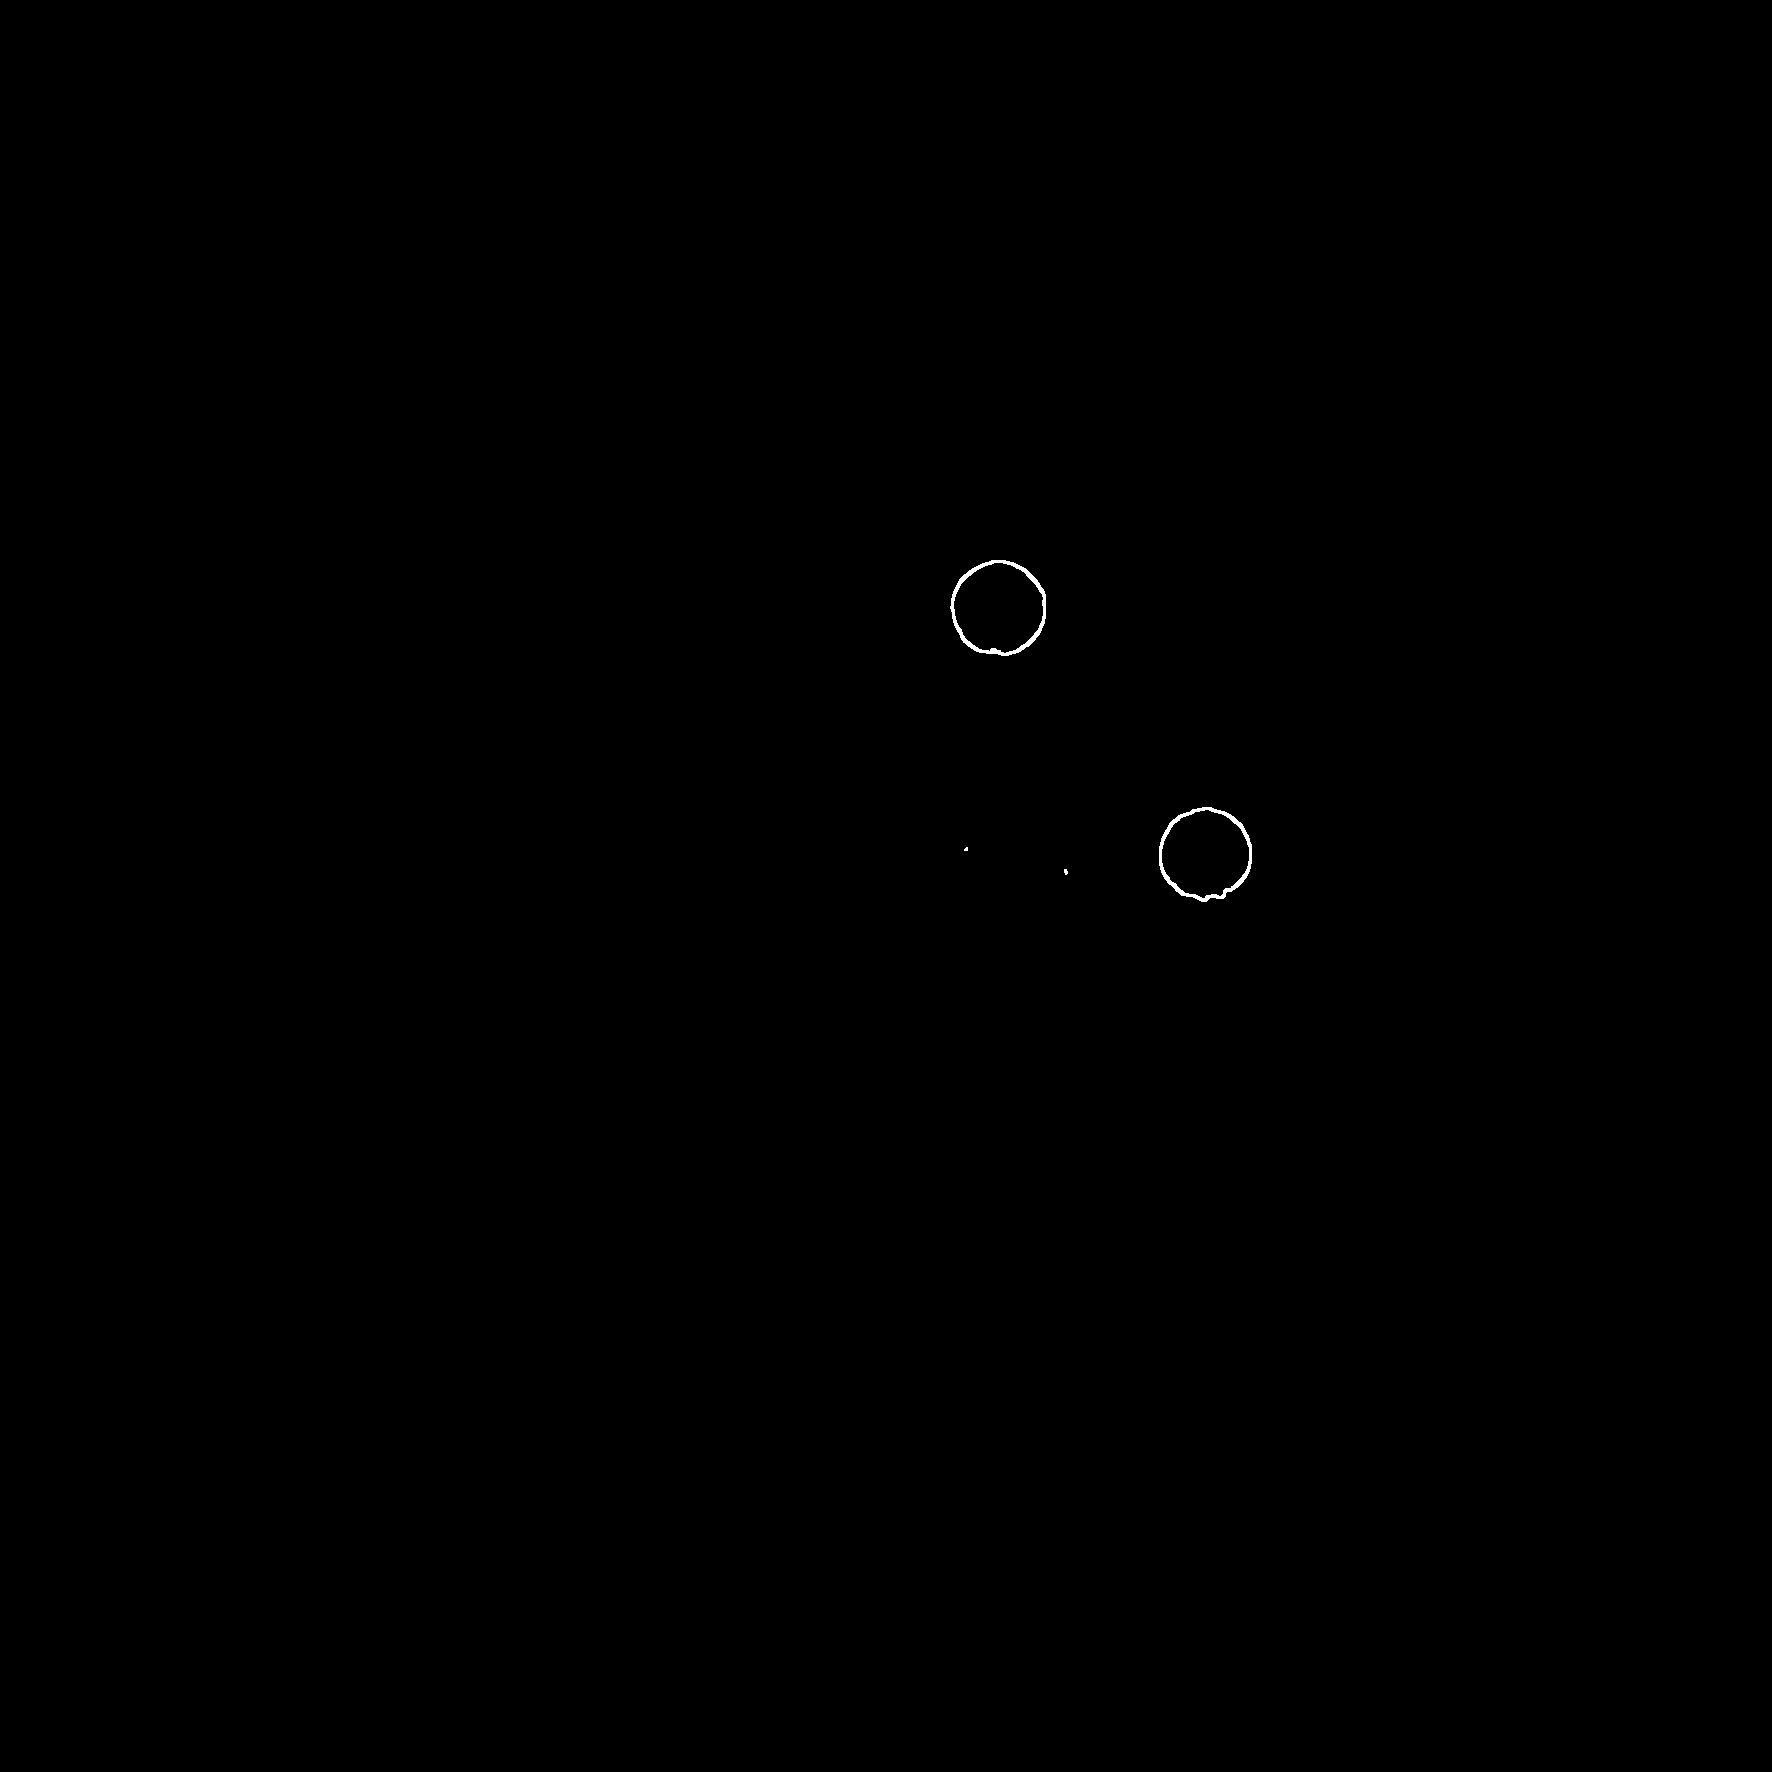

Liczba czarnych kropek: 2


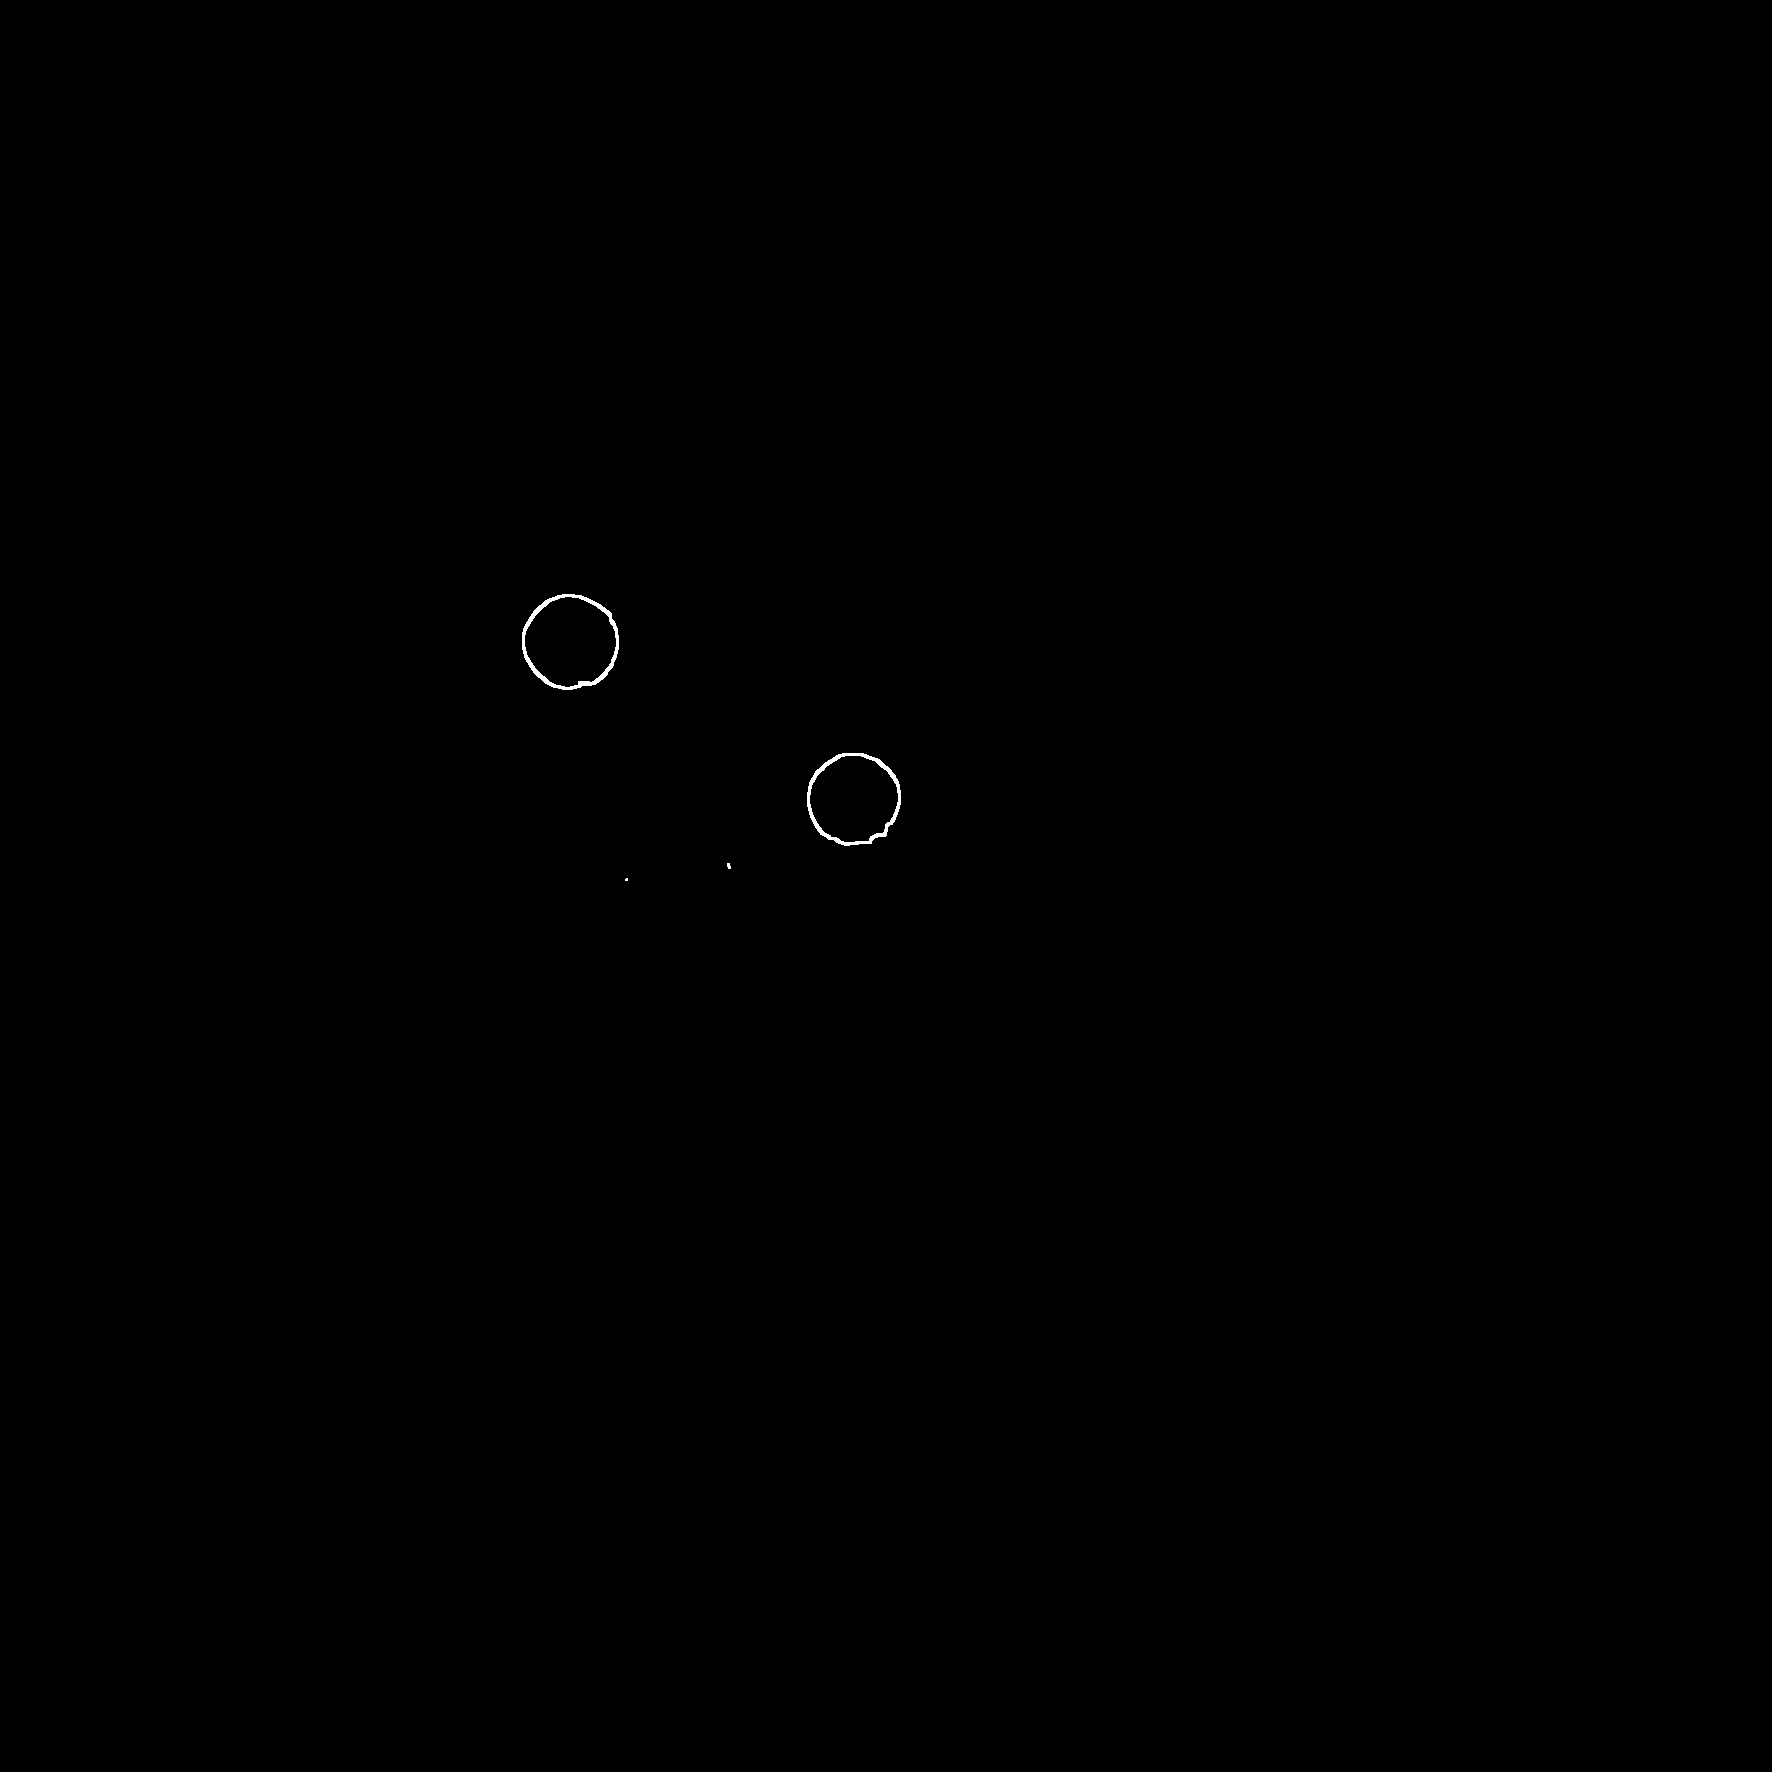

Liczba czarnych kropek: 2


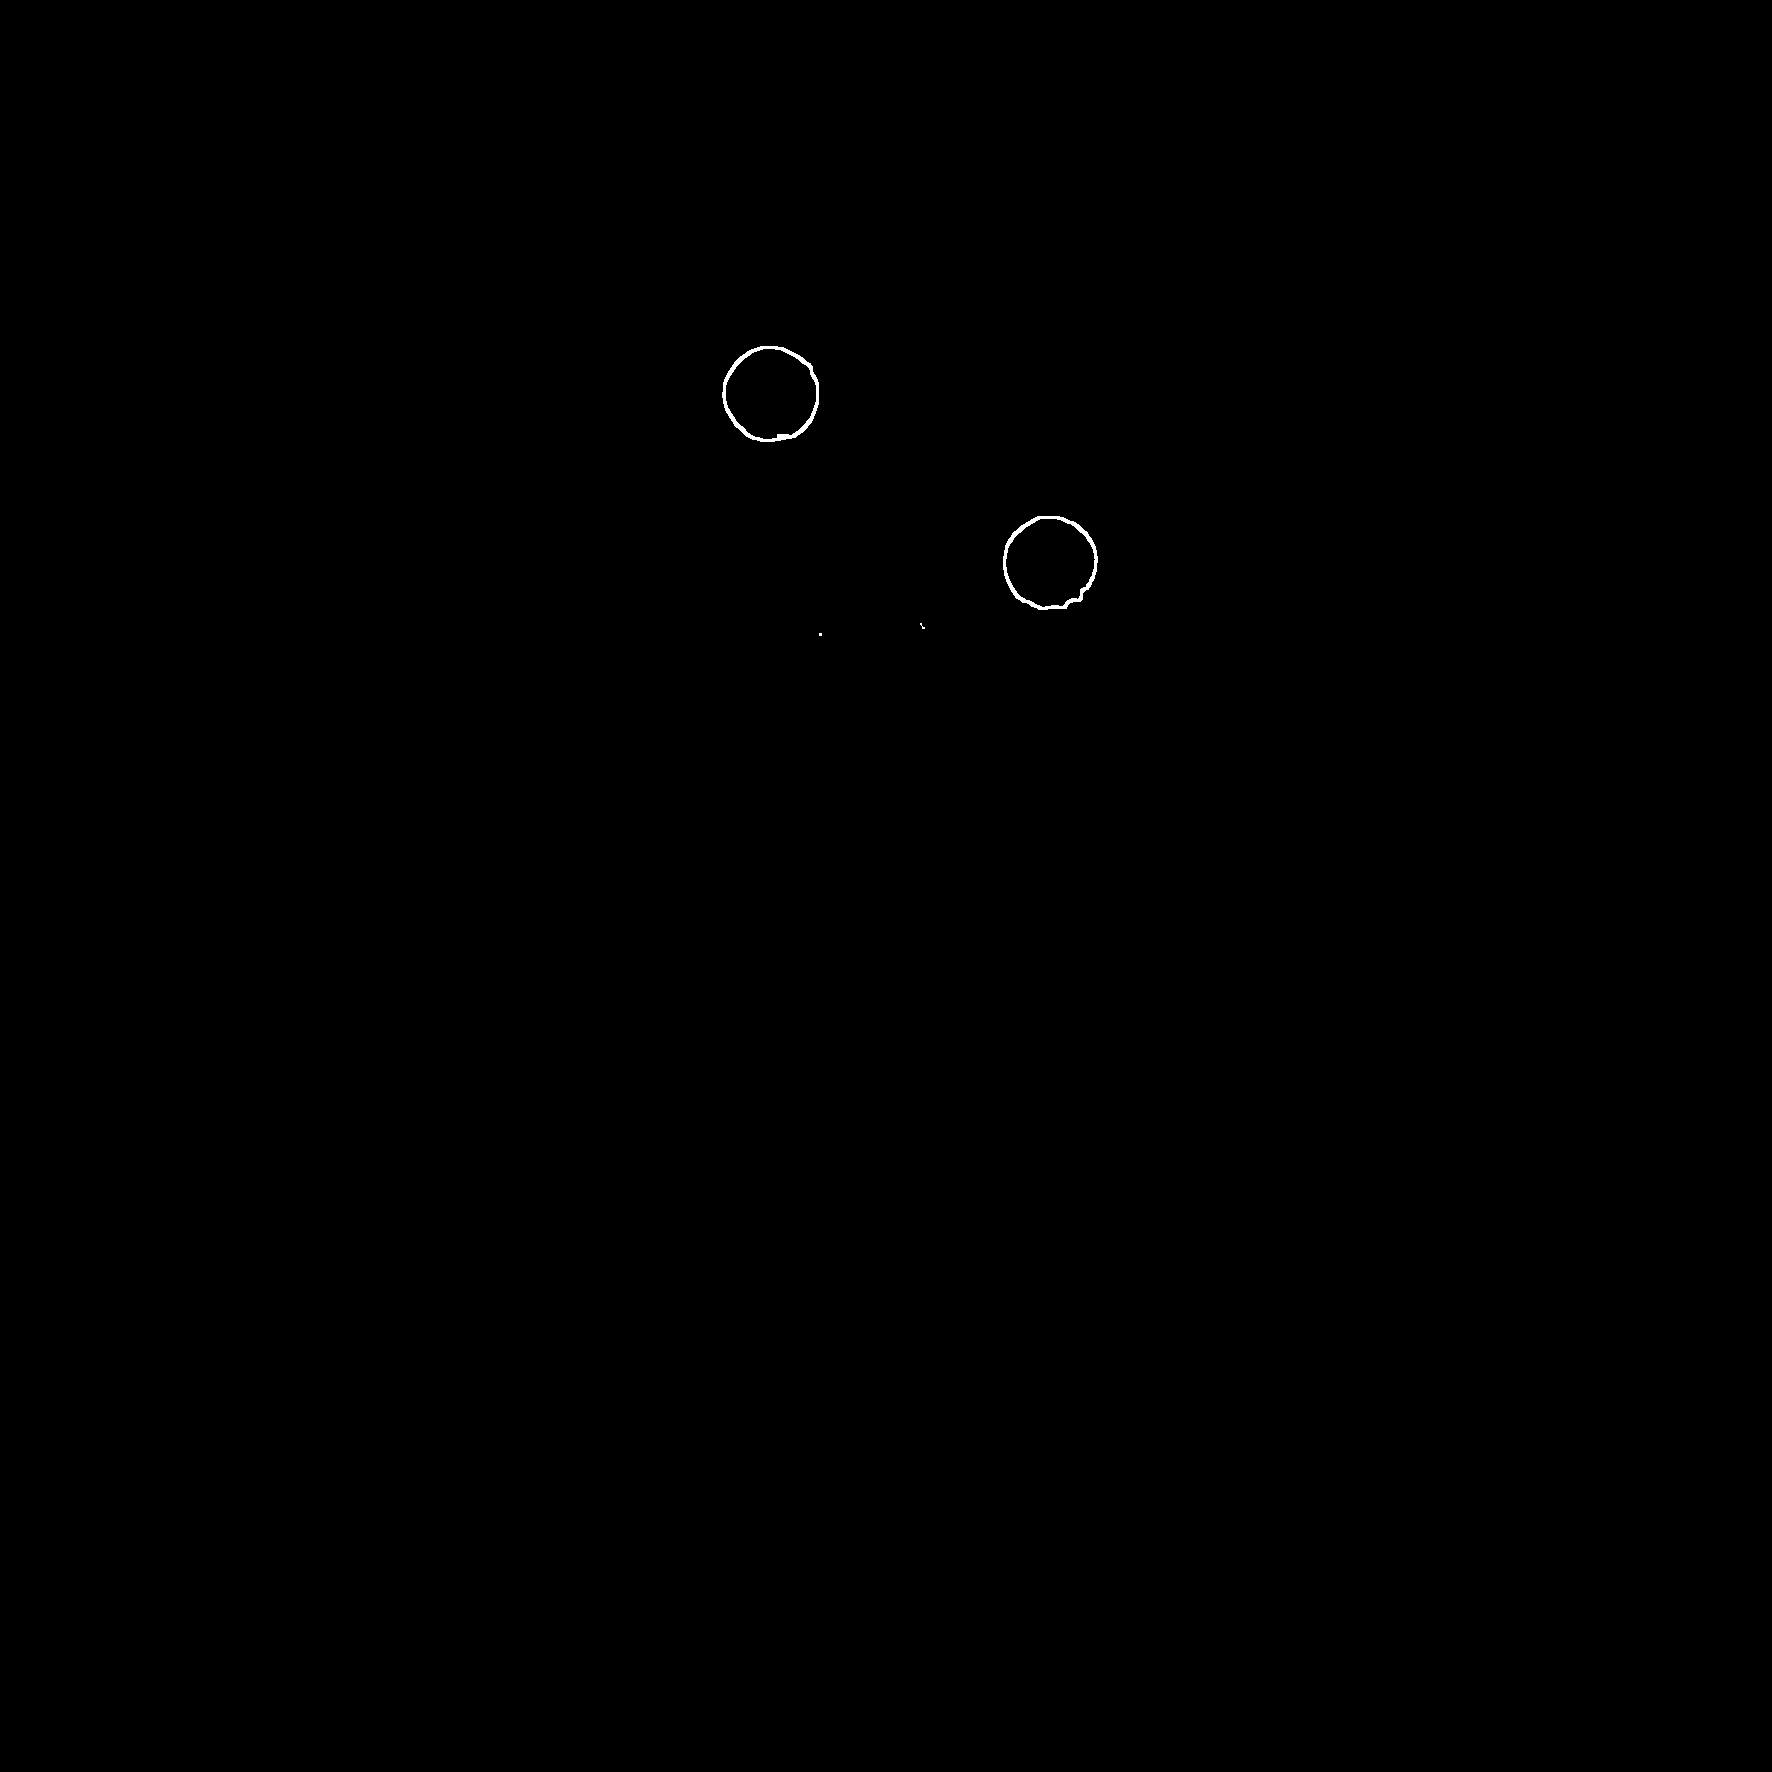

Liczba czarnych kropek: 2


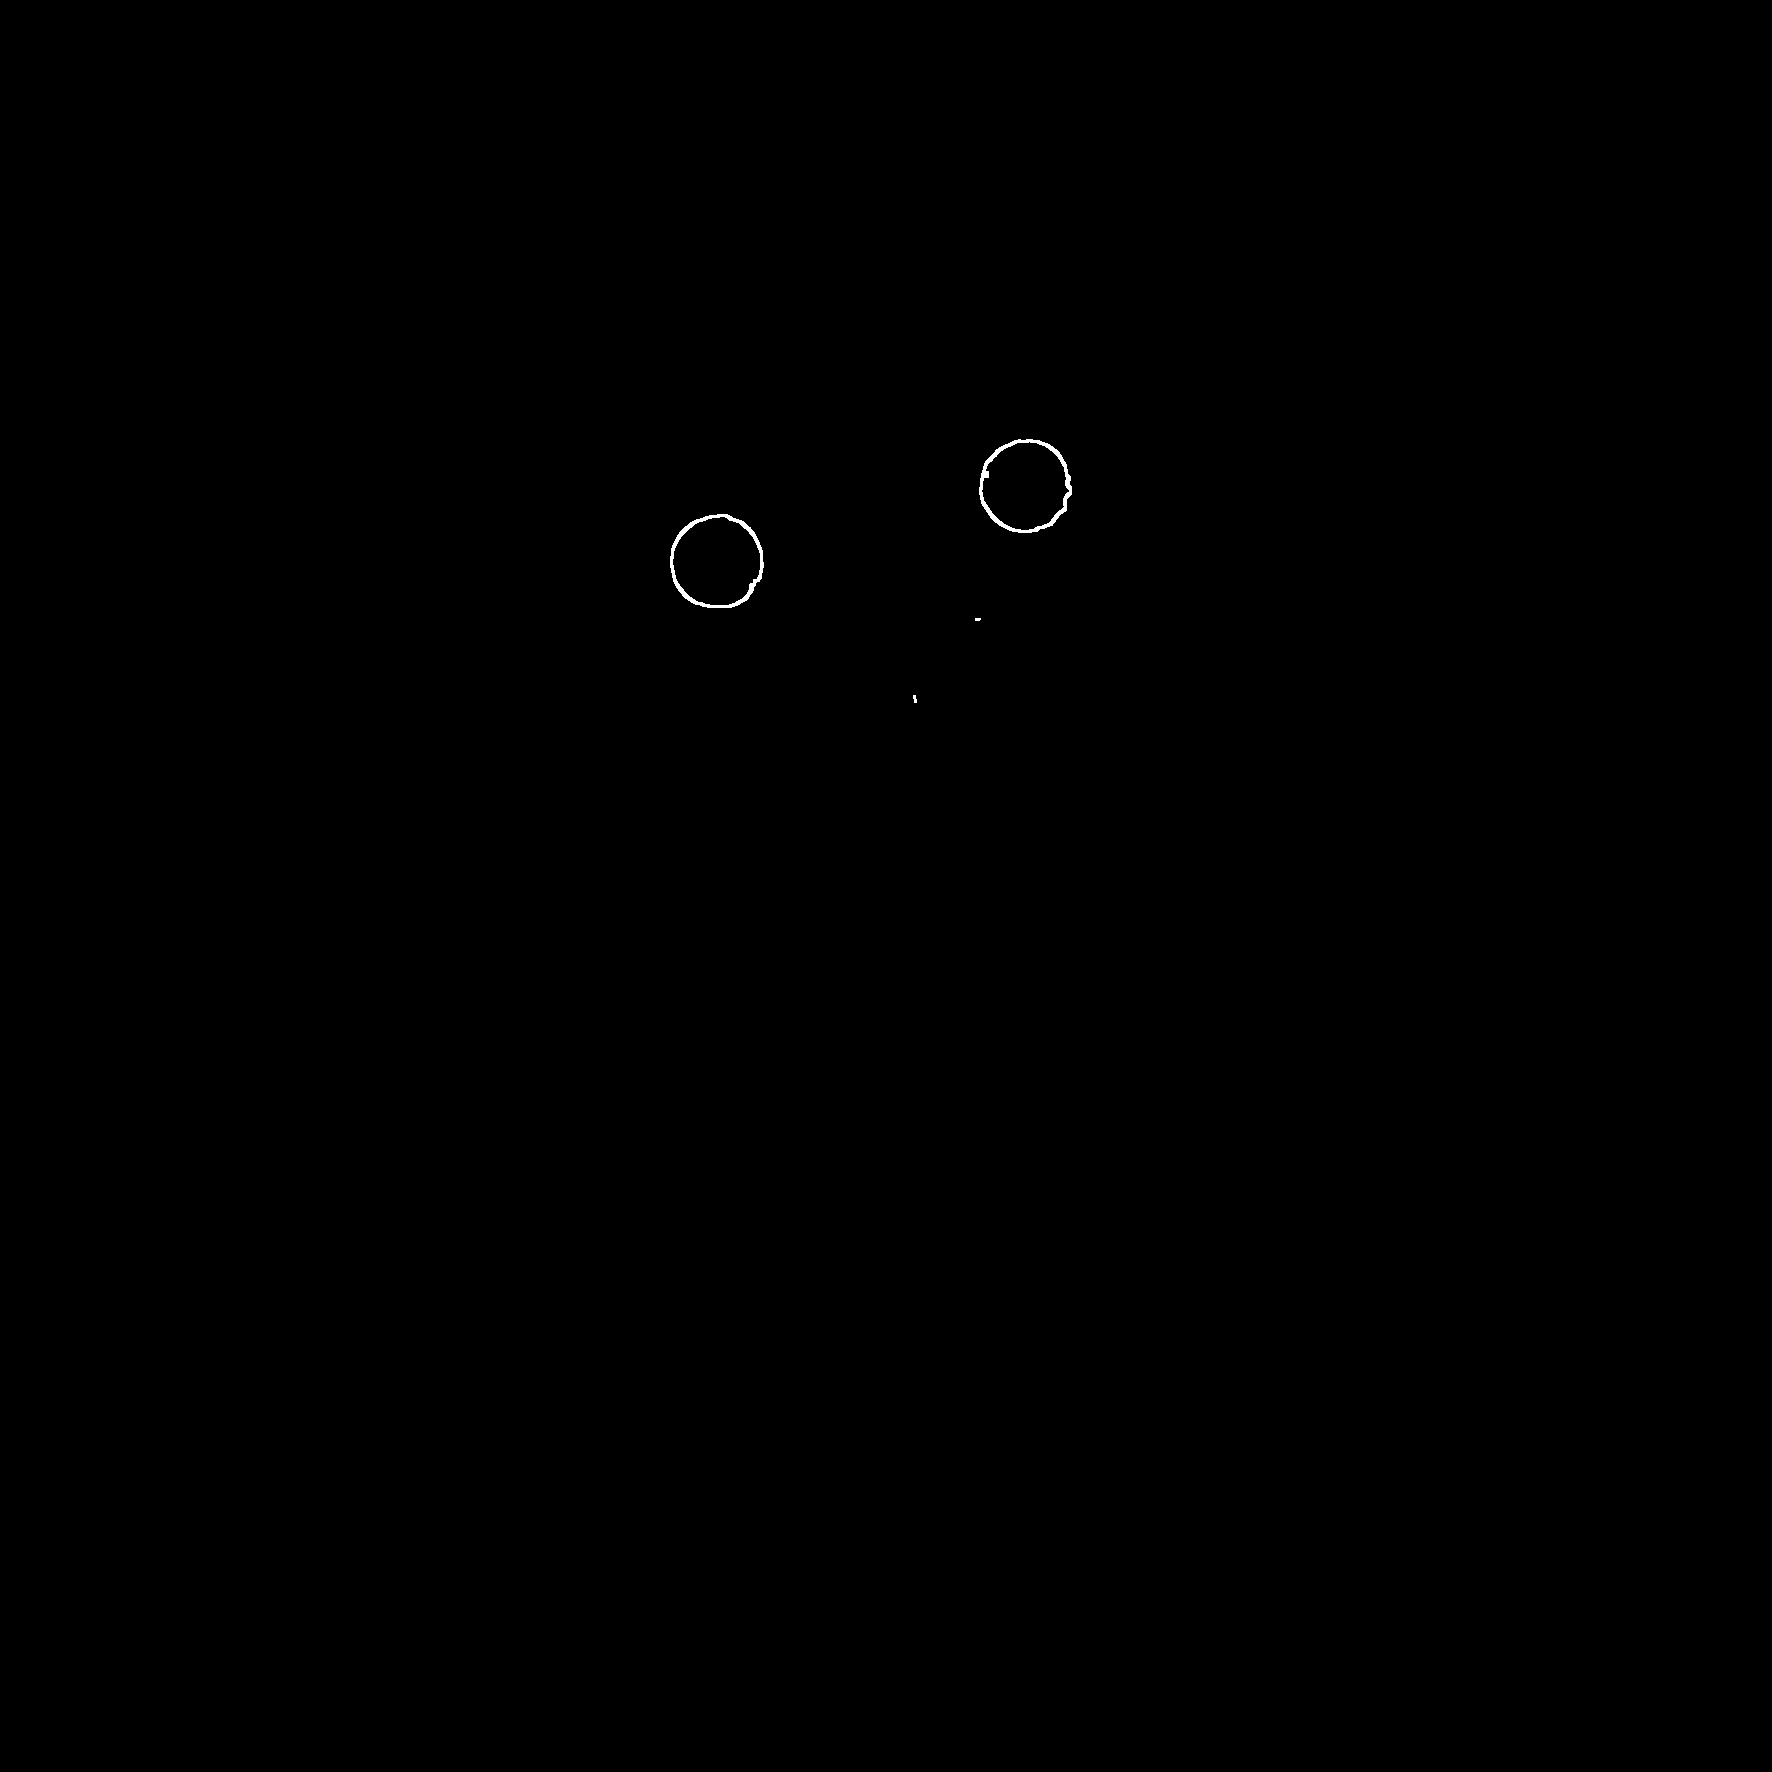

Liczba czarnych kropek: 2


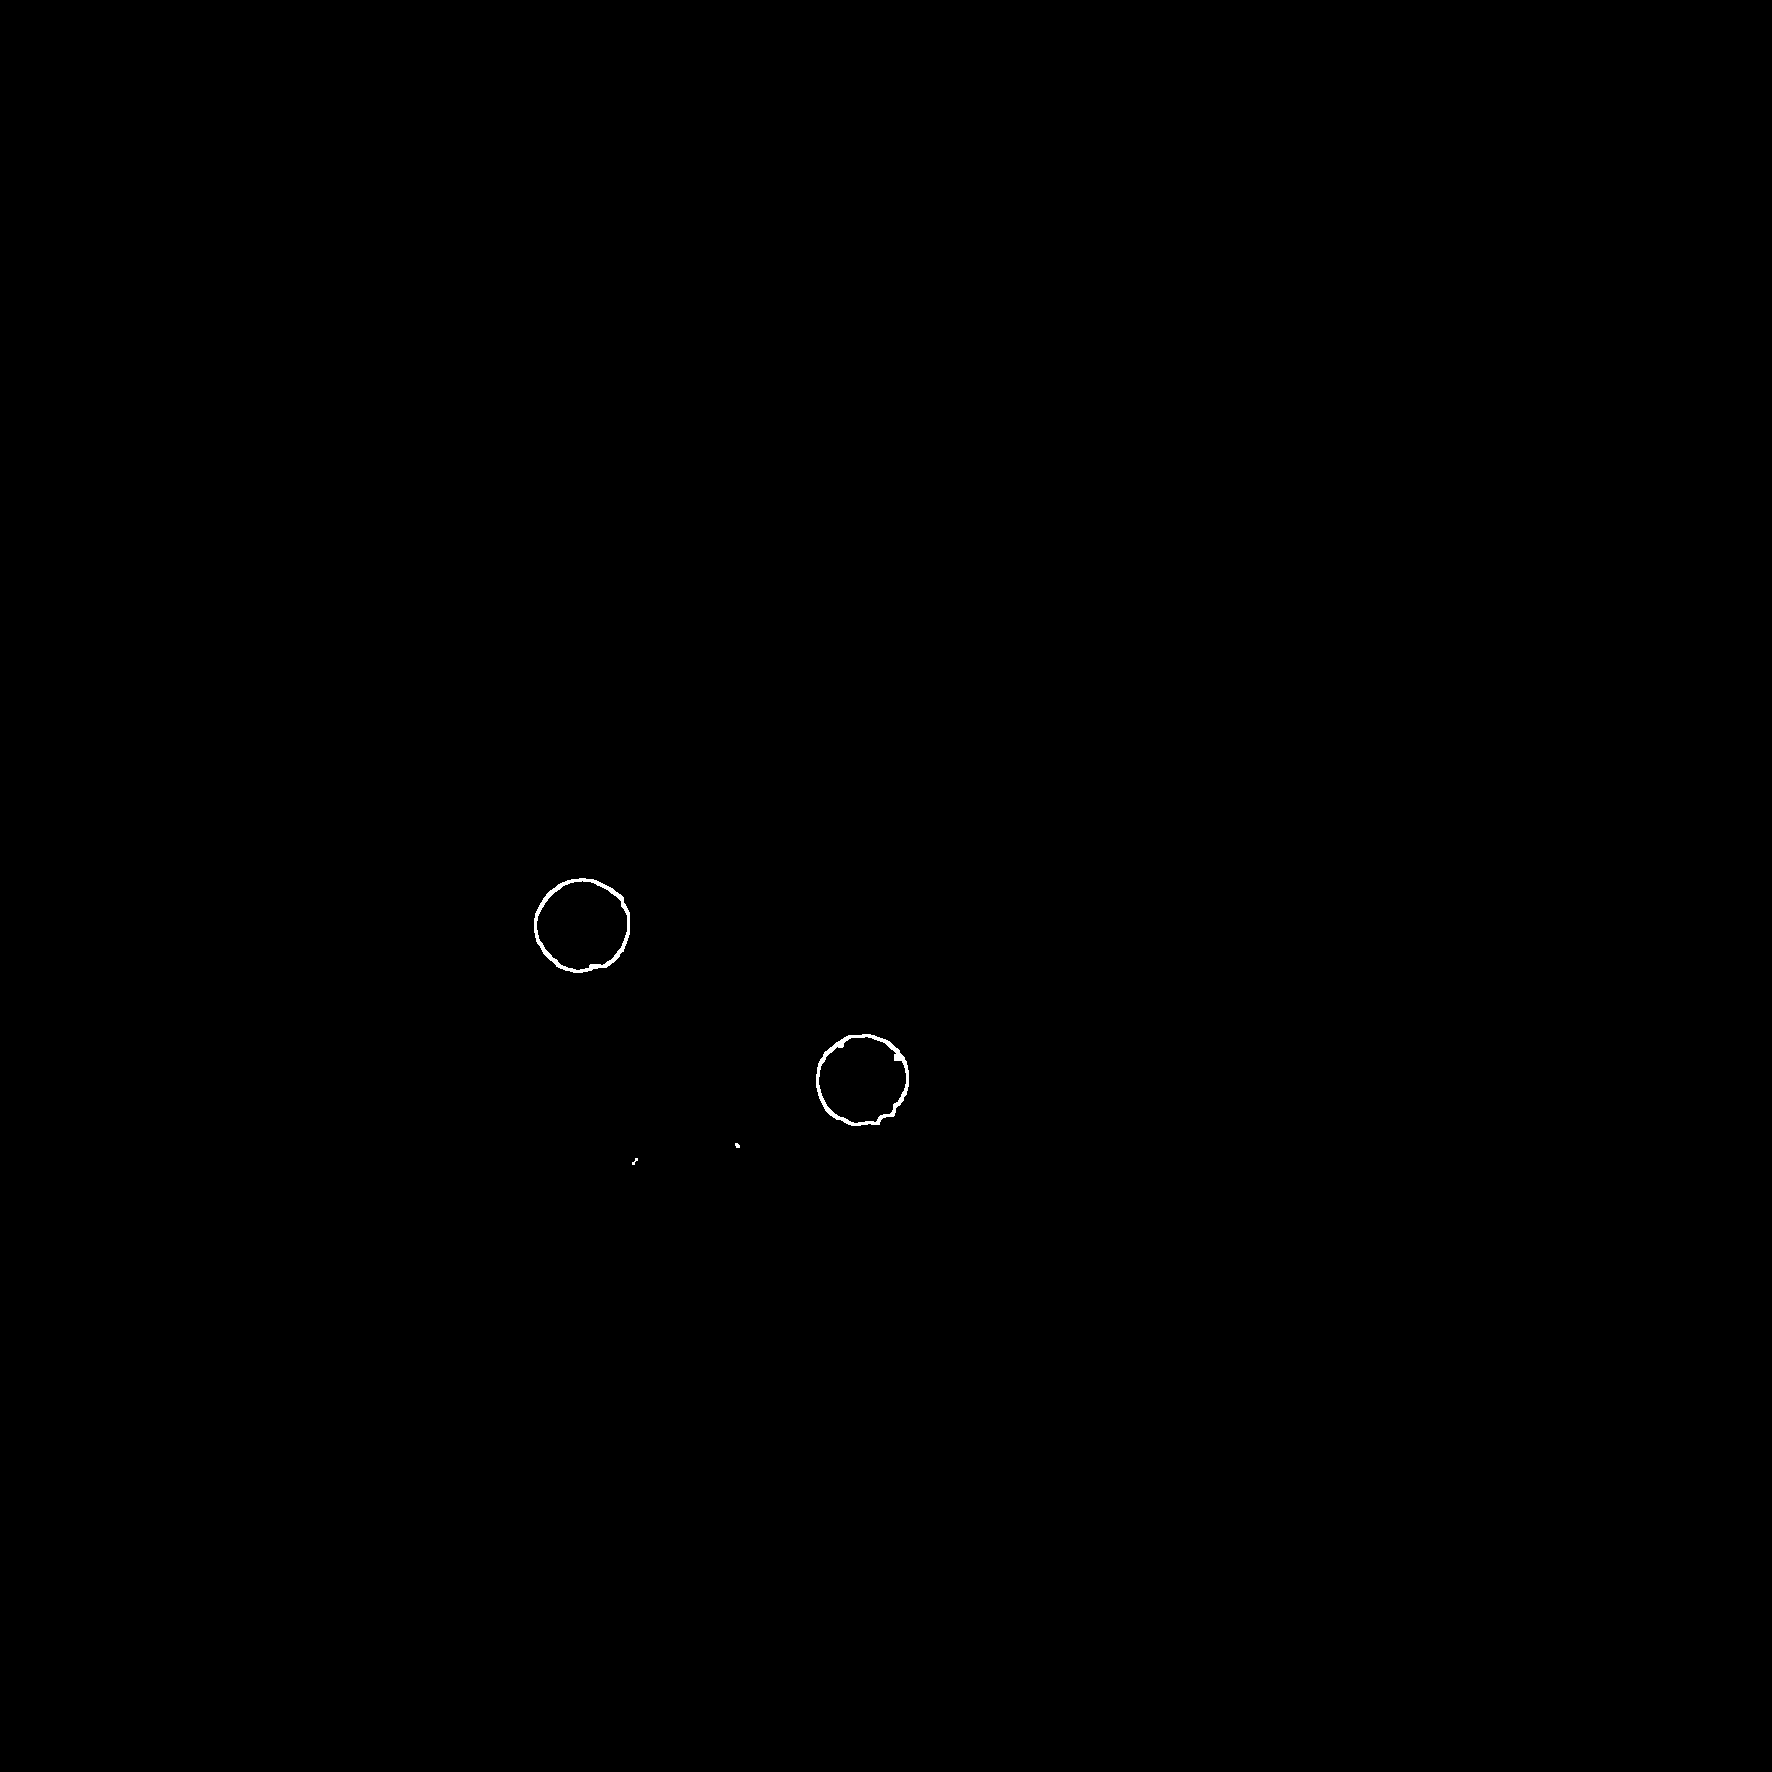

Liczba czarnych kropek: 2


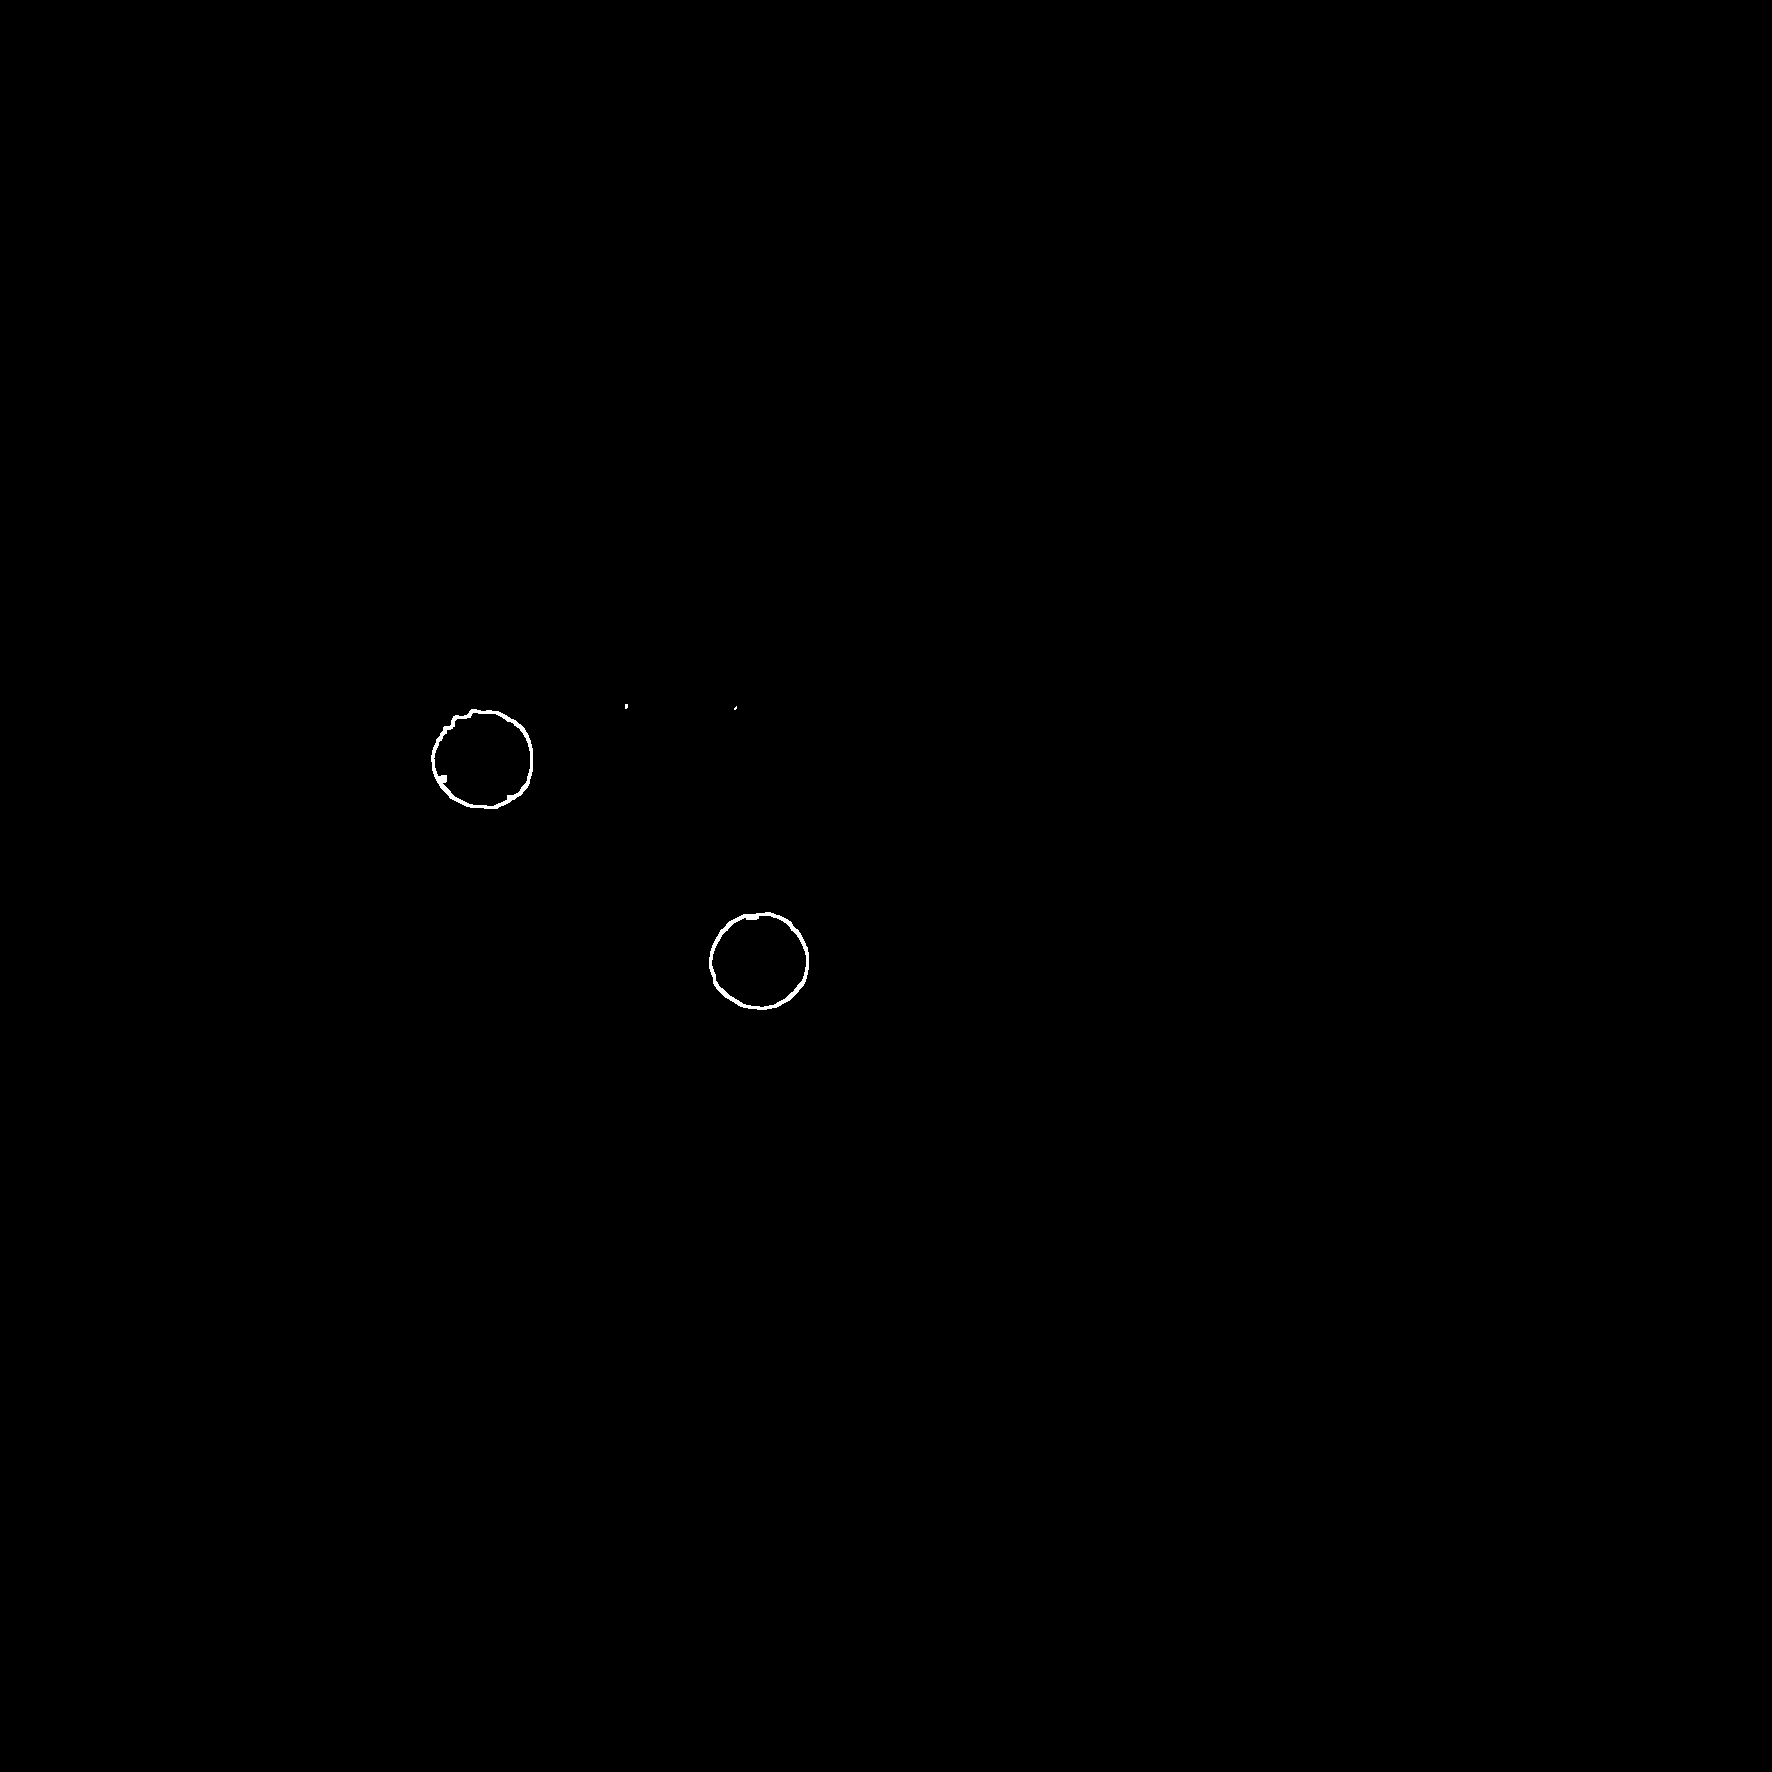

Liczba czarnych kropek: 2


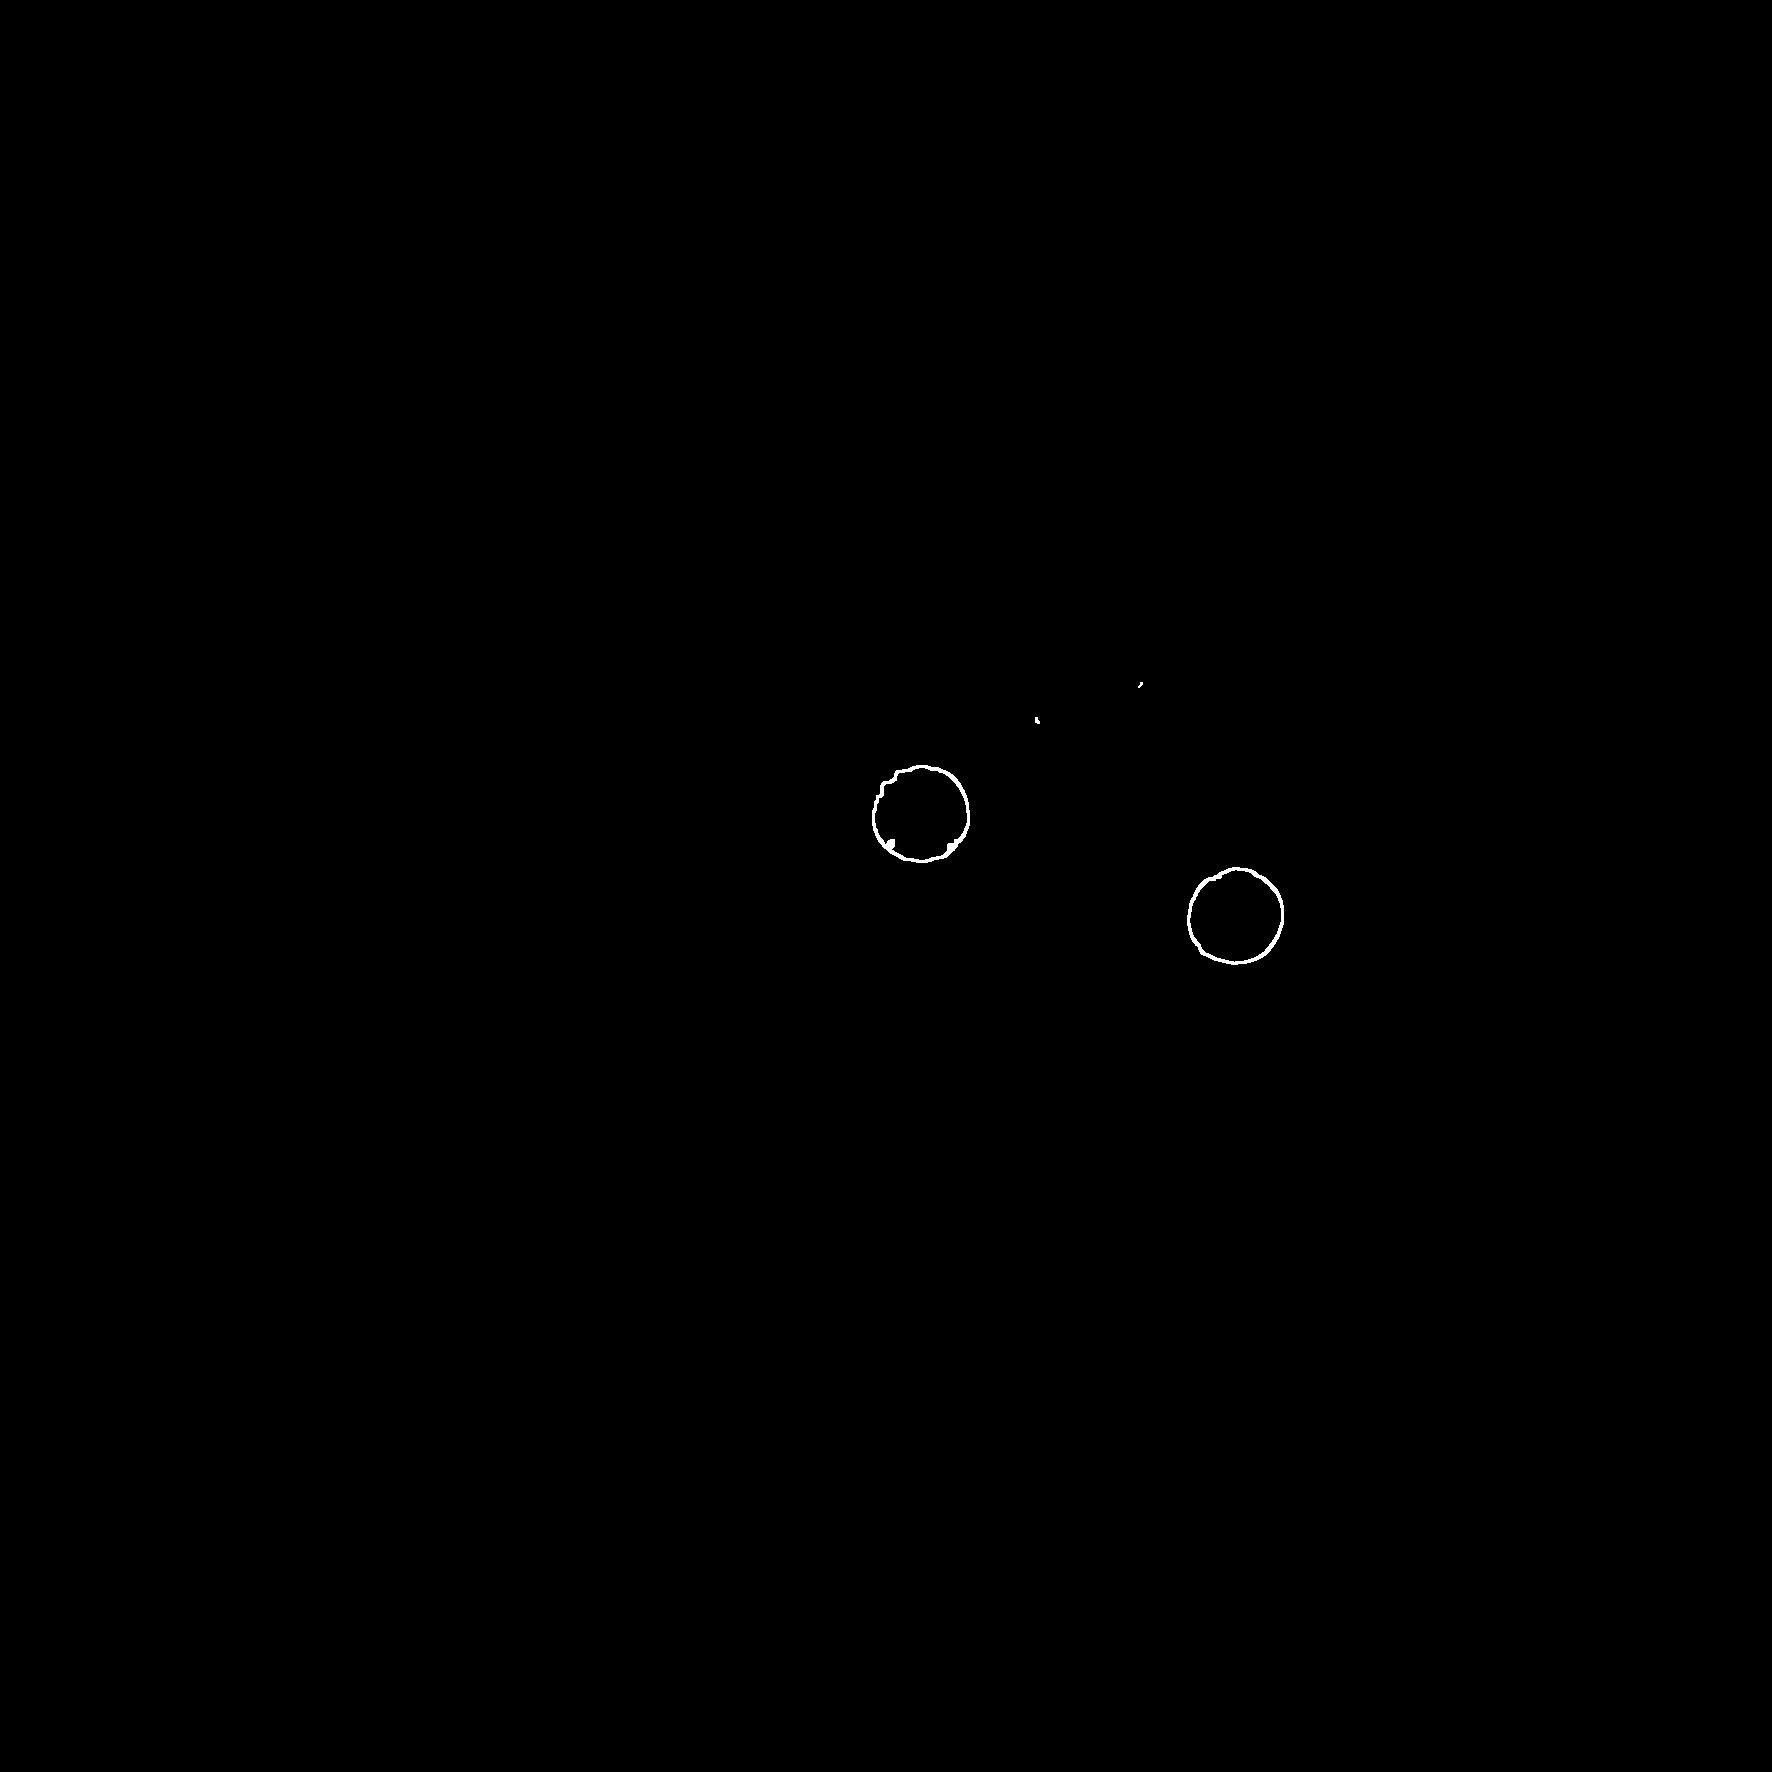

Liczba czarnych kropek: 2


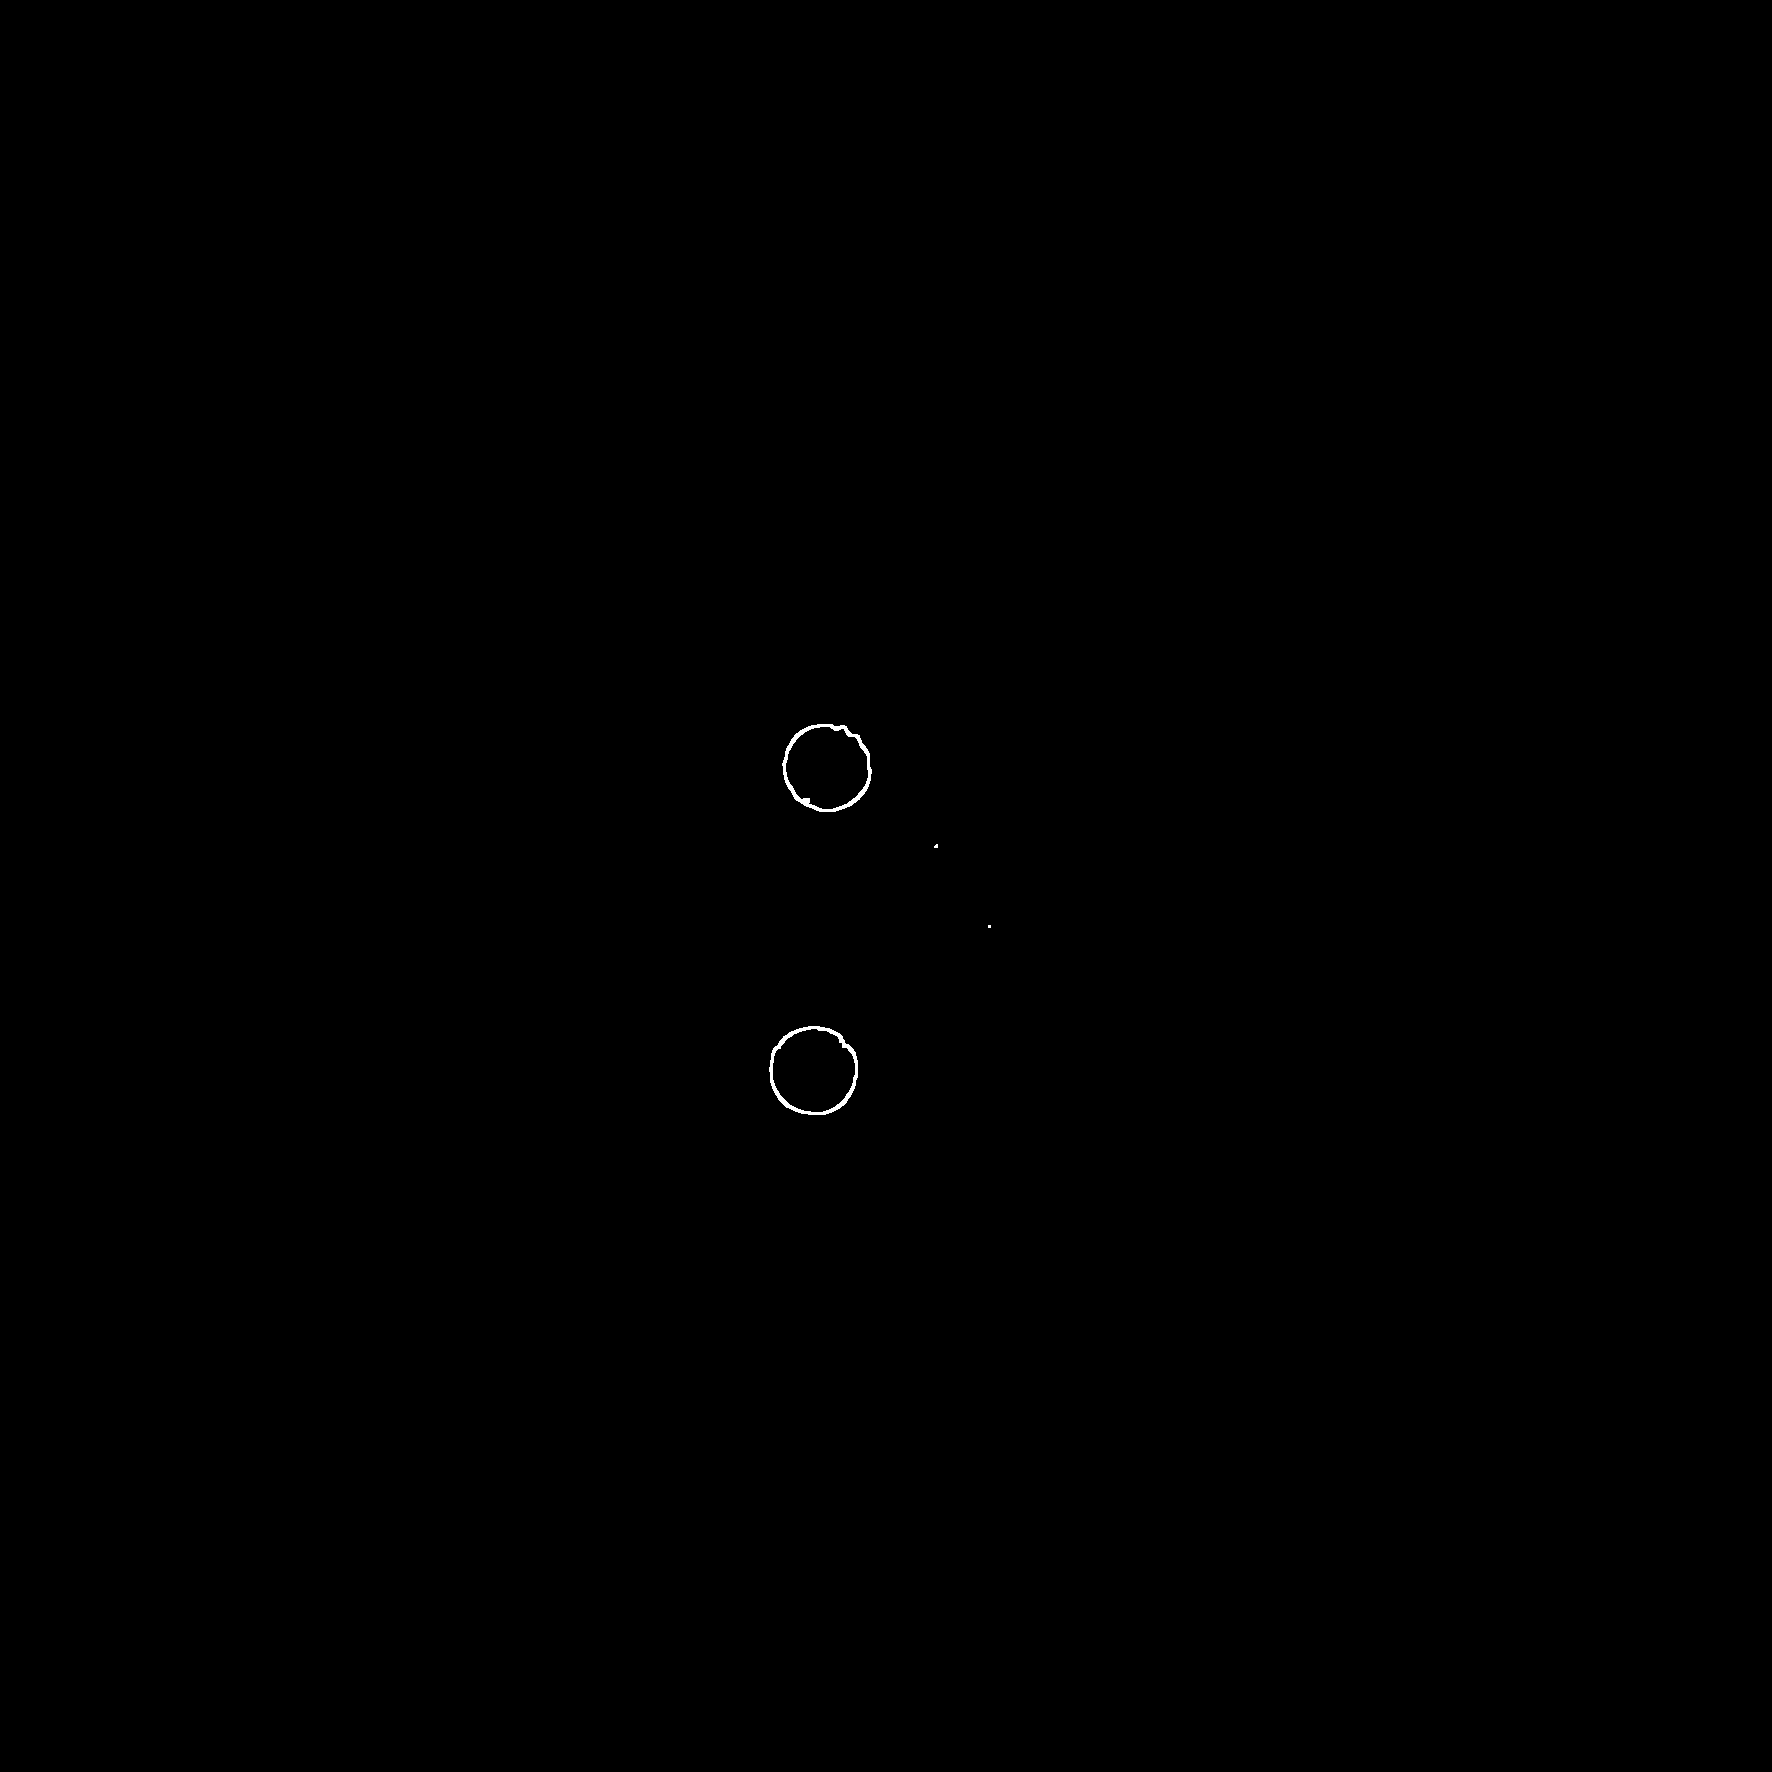

Liczba czarnych kropek: 2


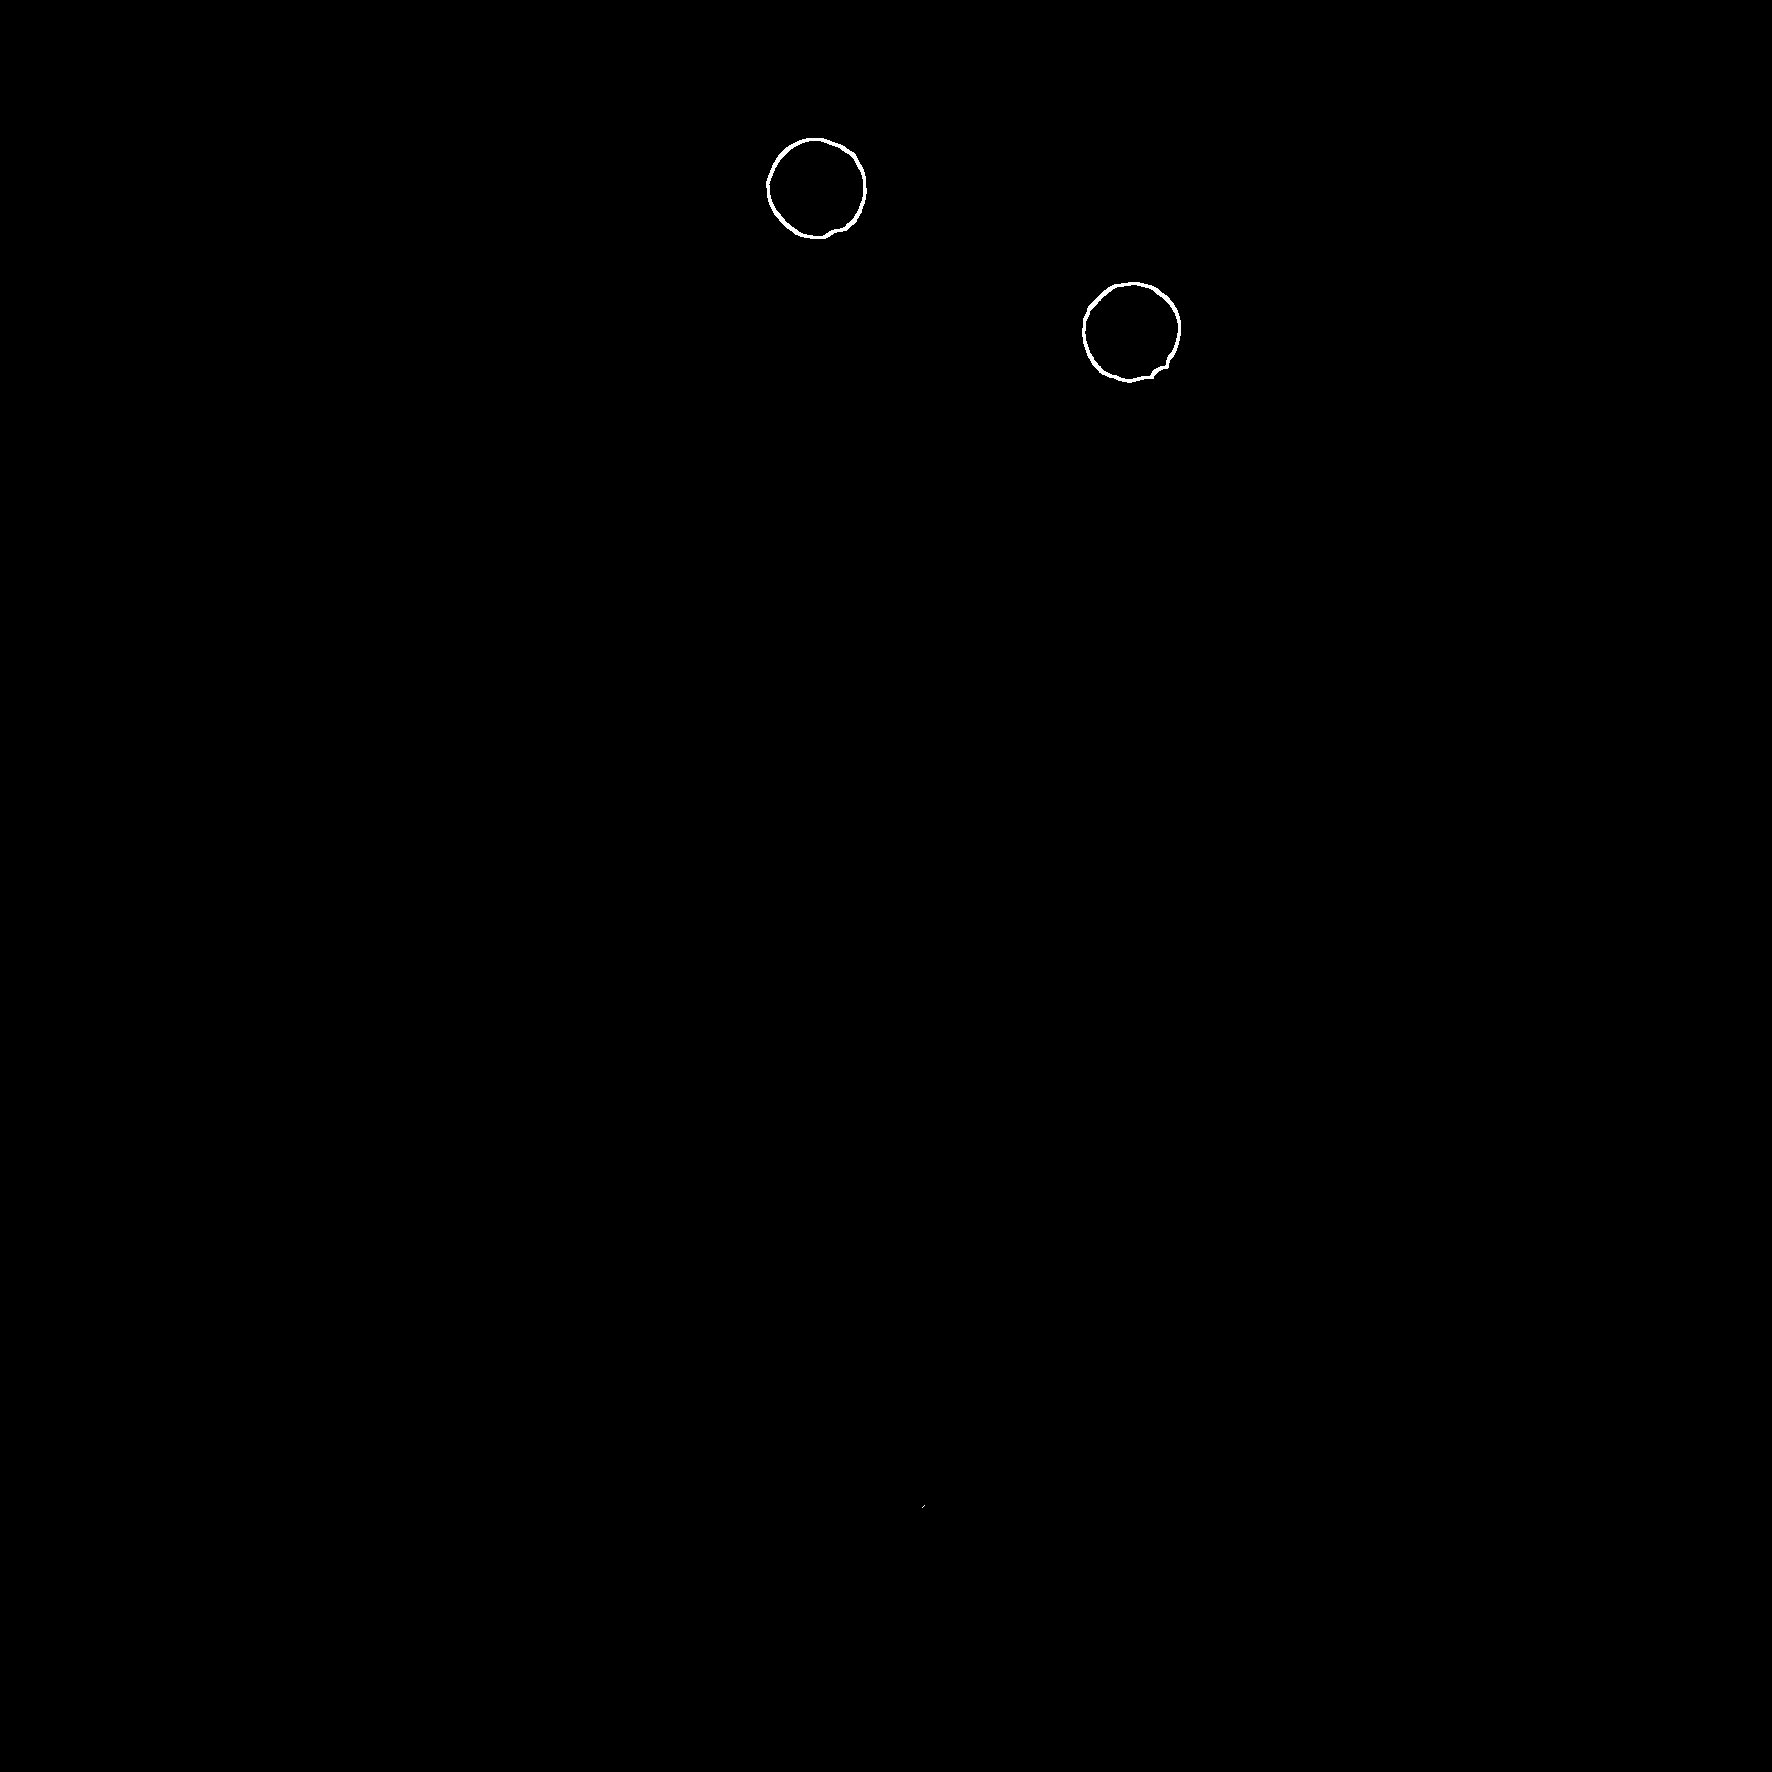

Liczba czarnych kropek: 2


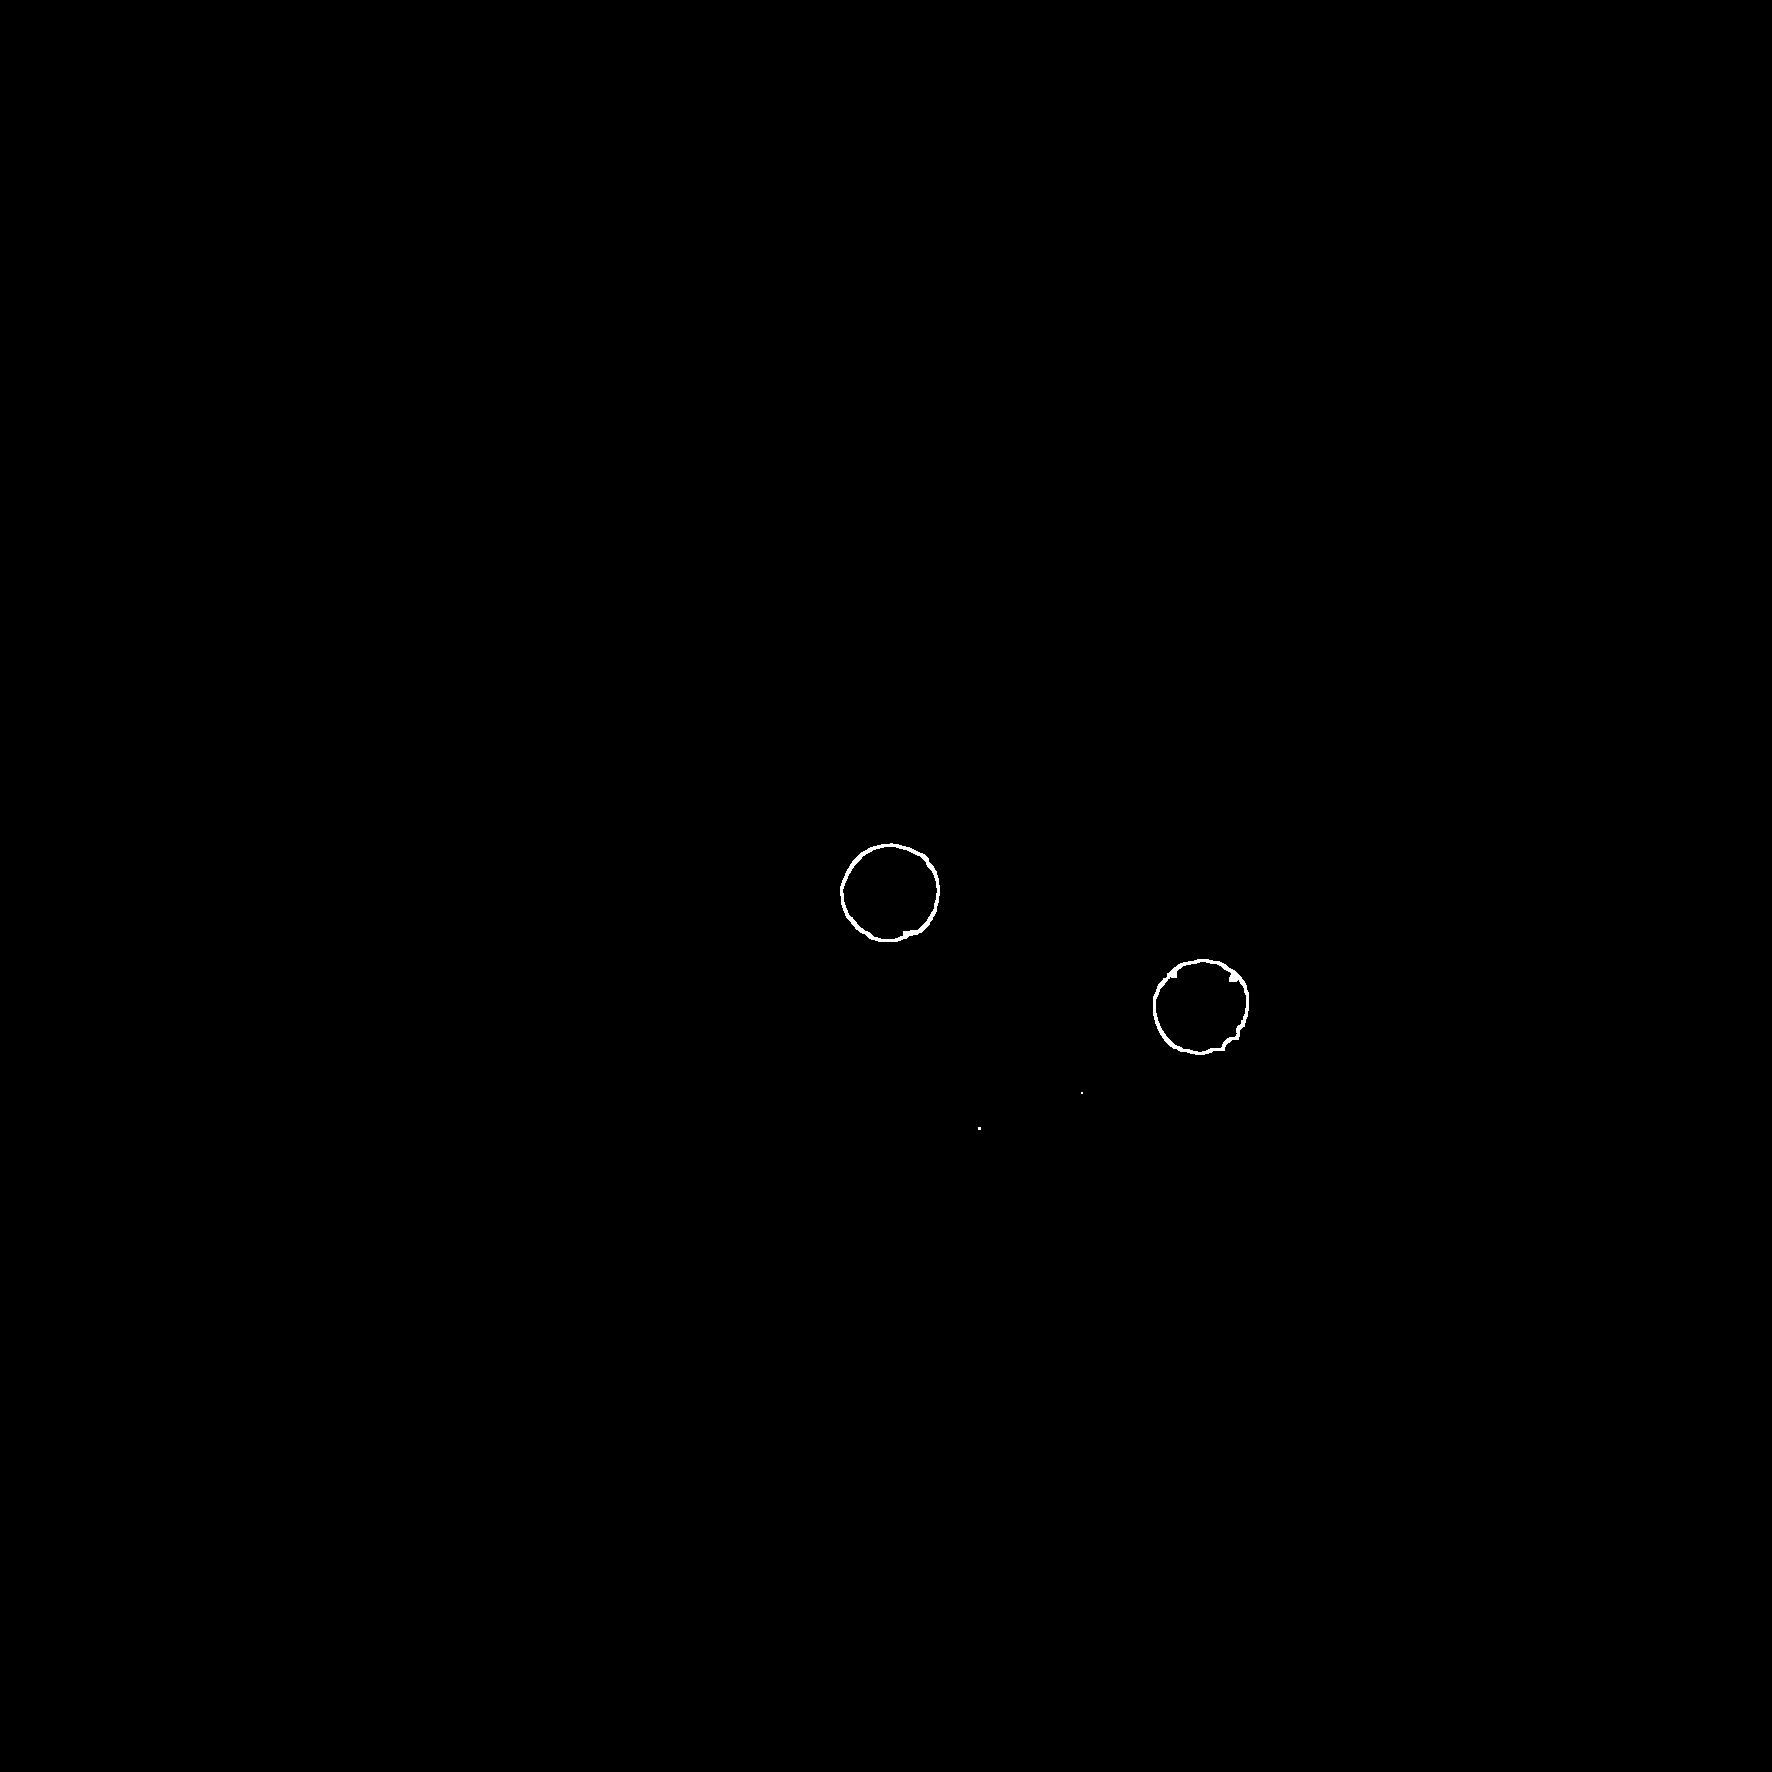

Liczba czarnych kropek: 2


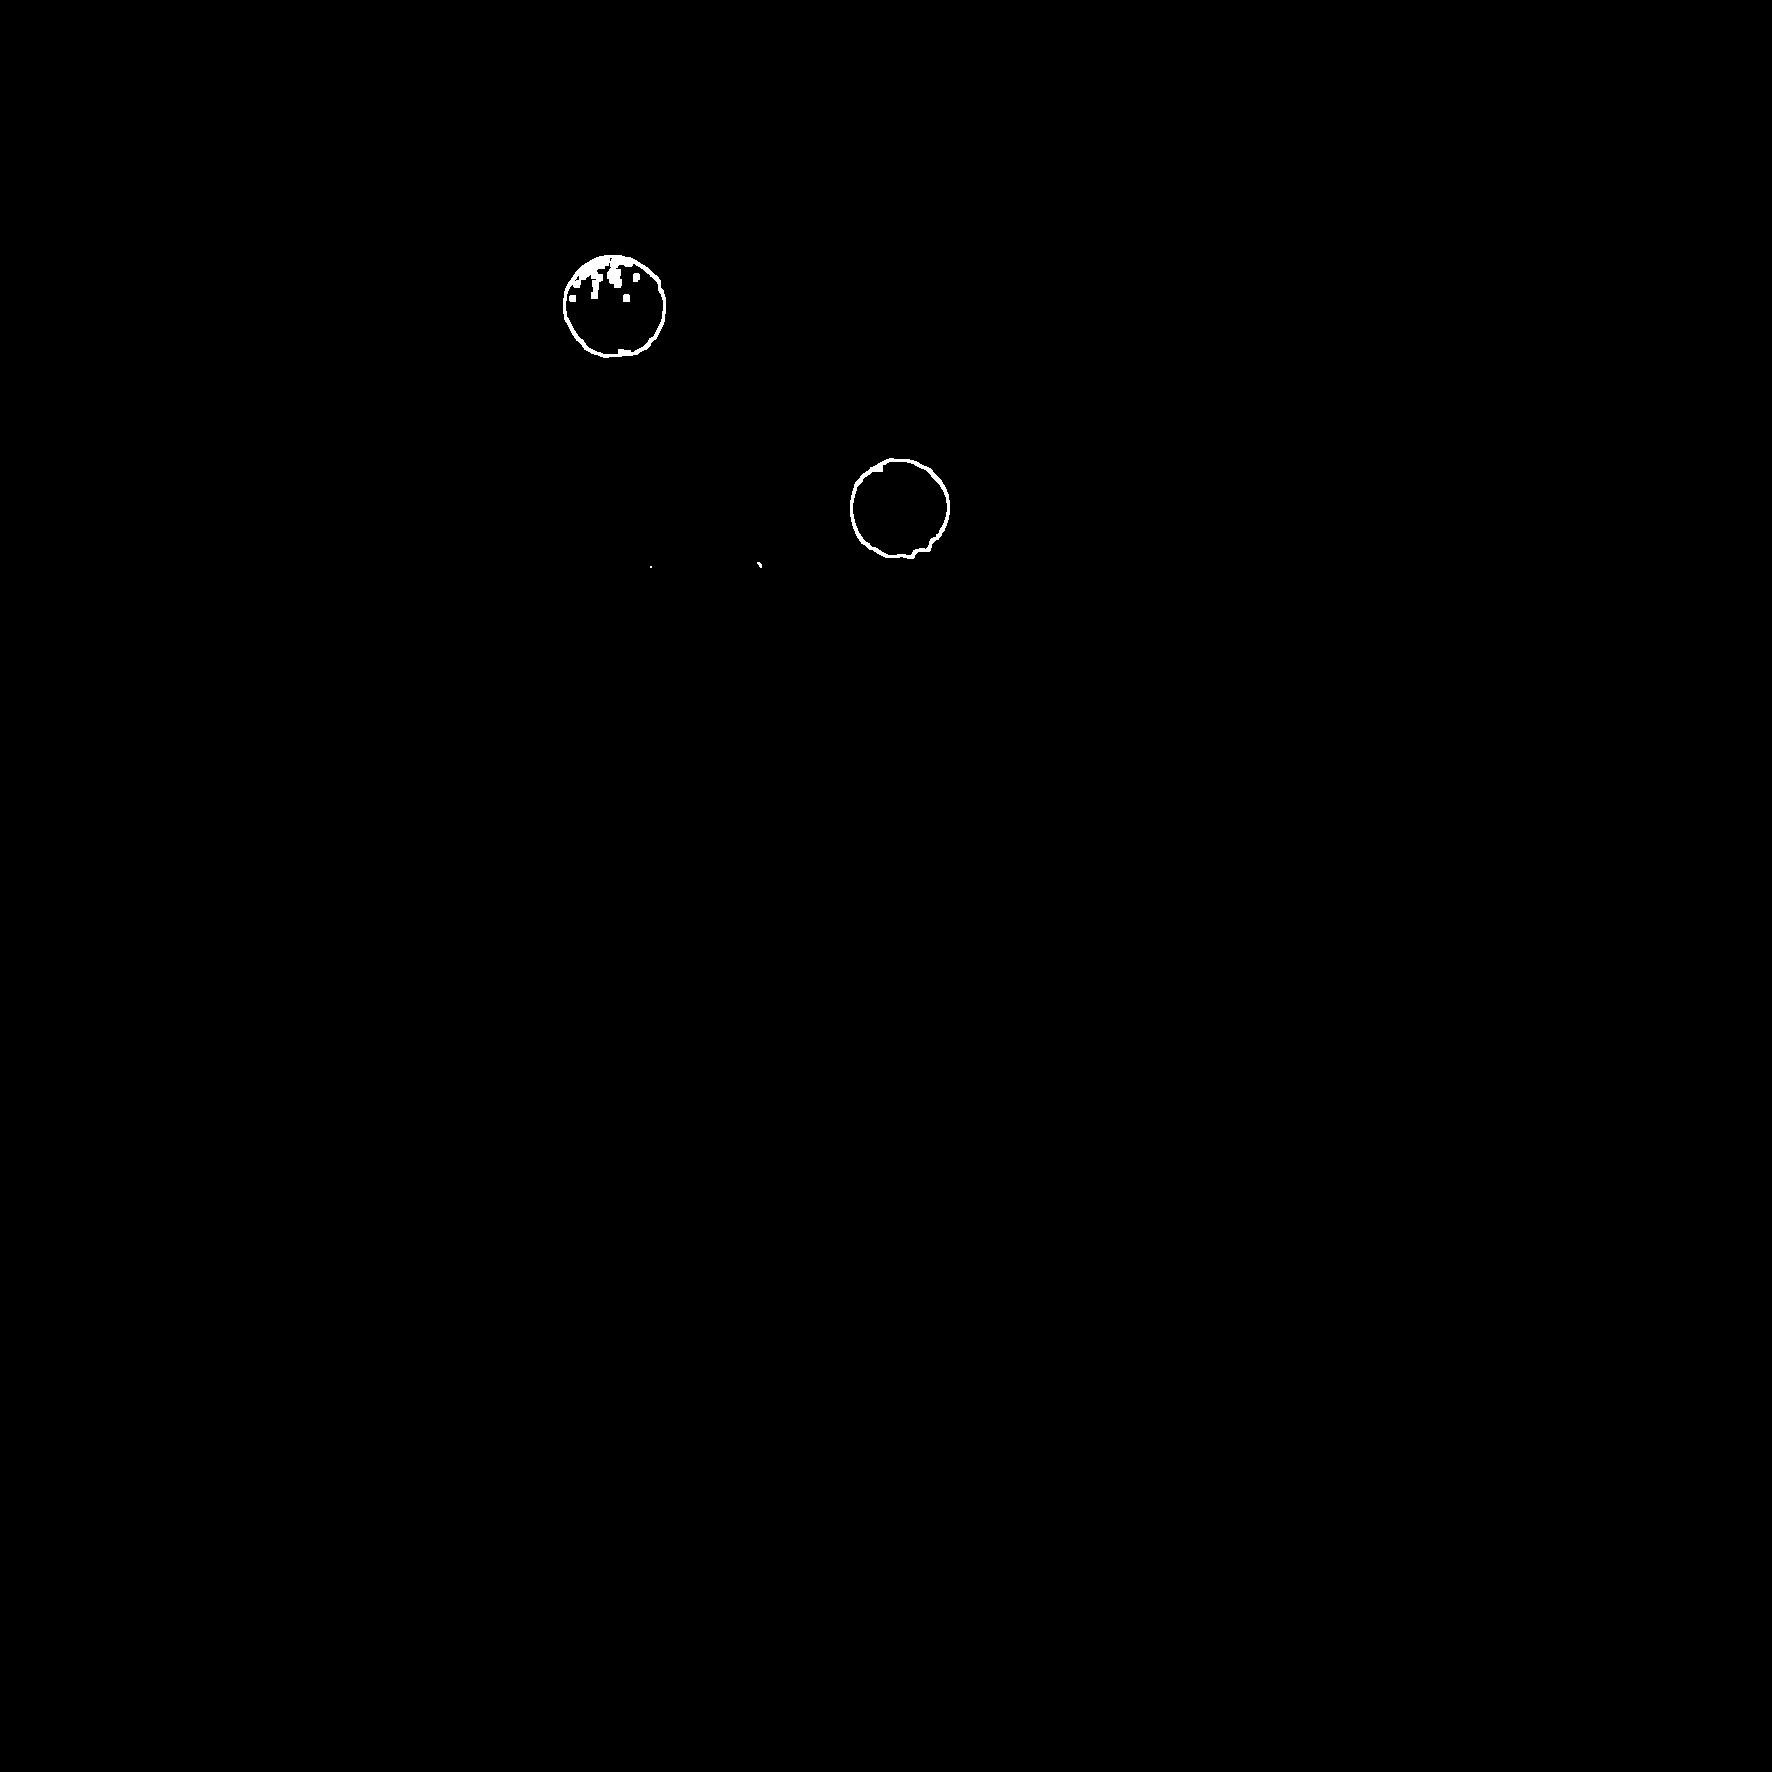

Liczba czarnych kropek: 2


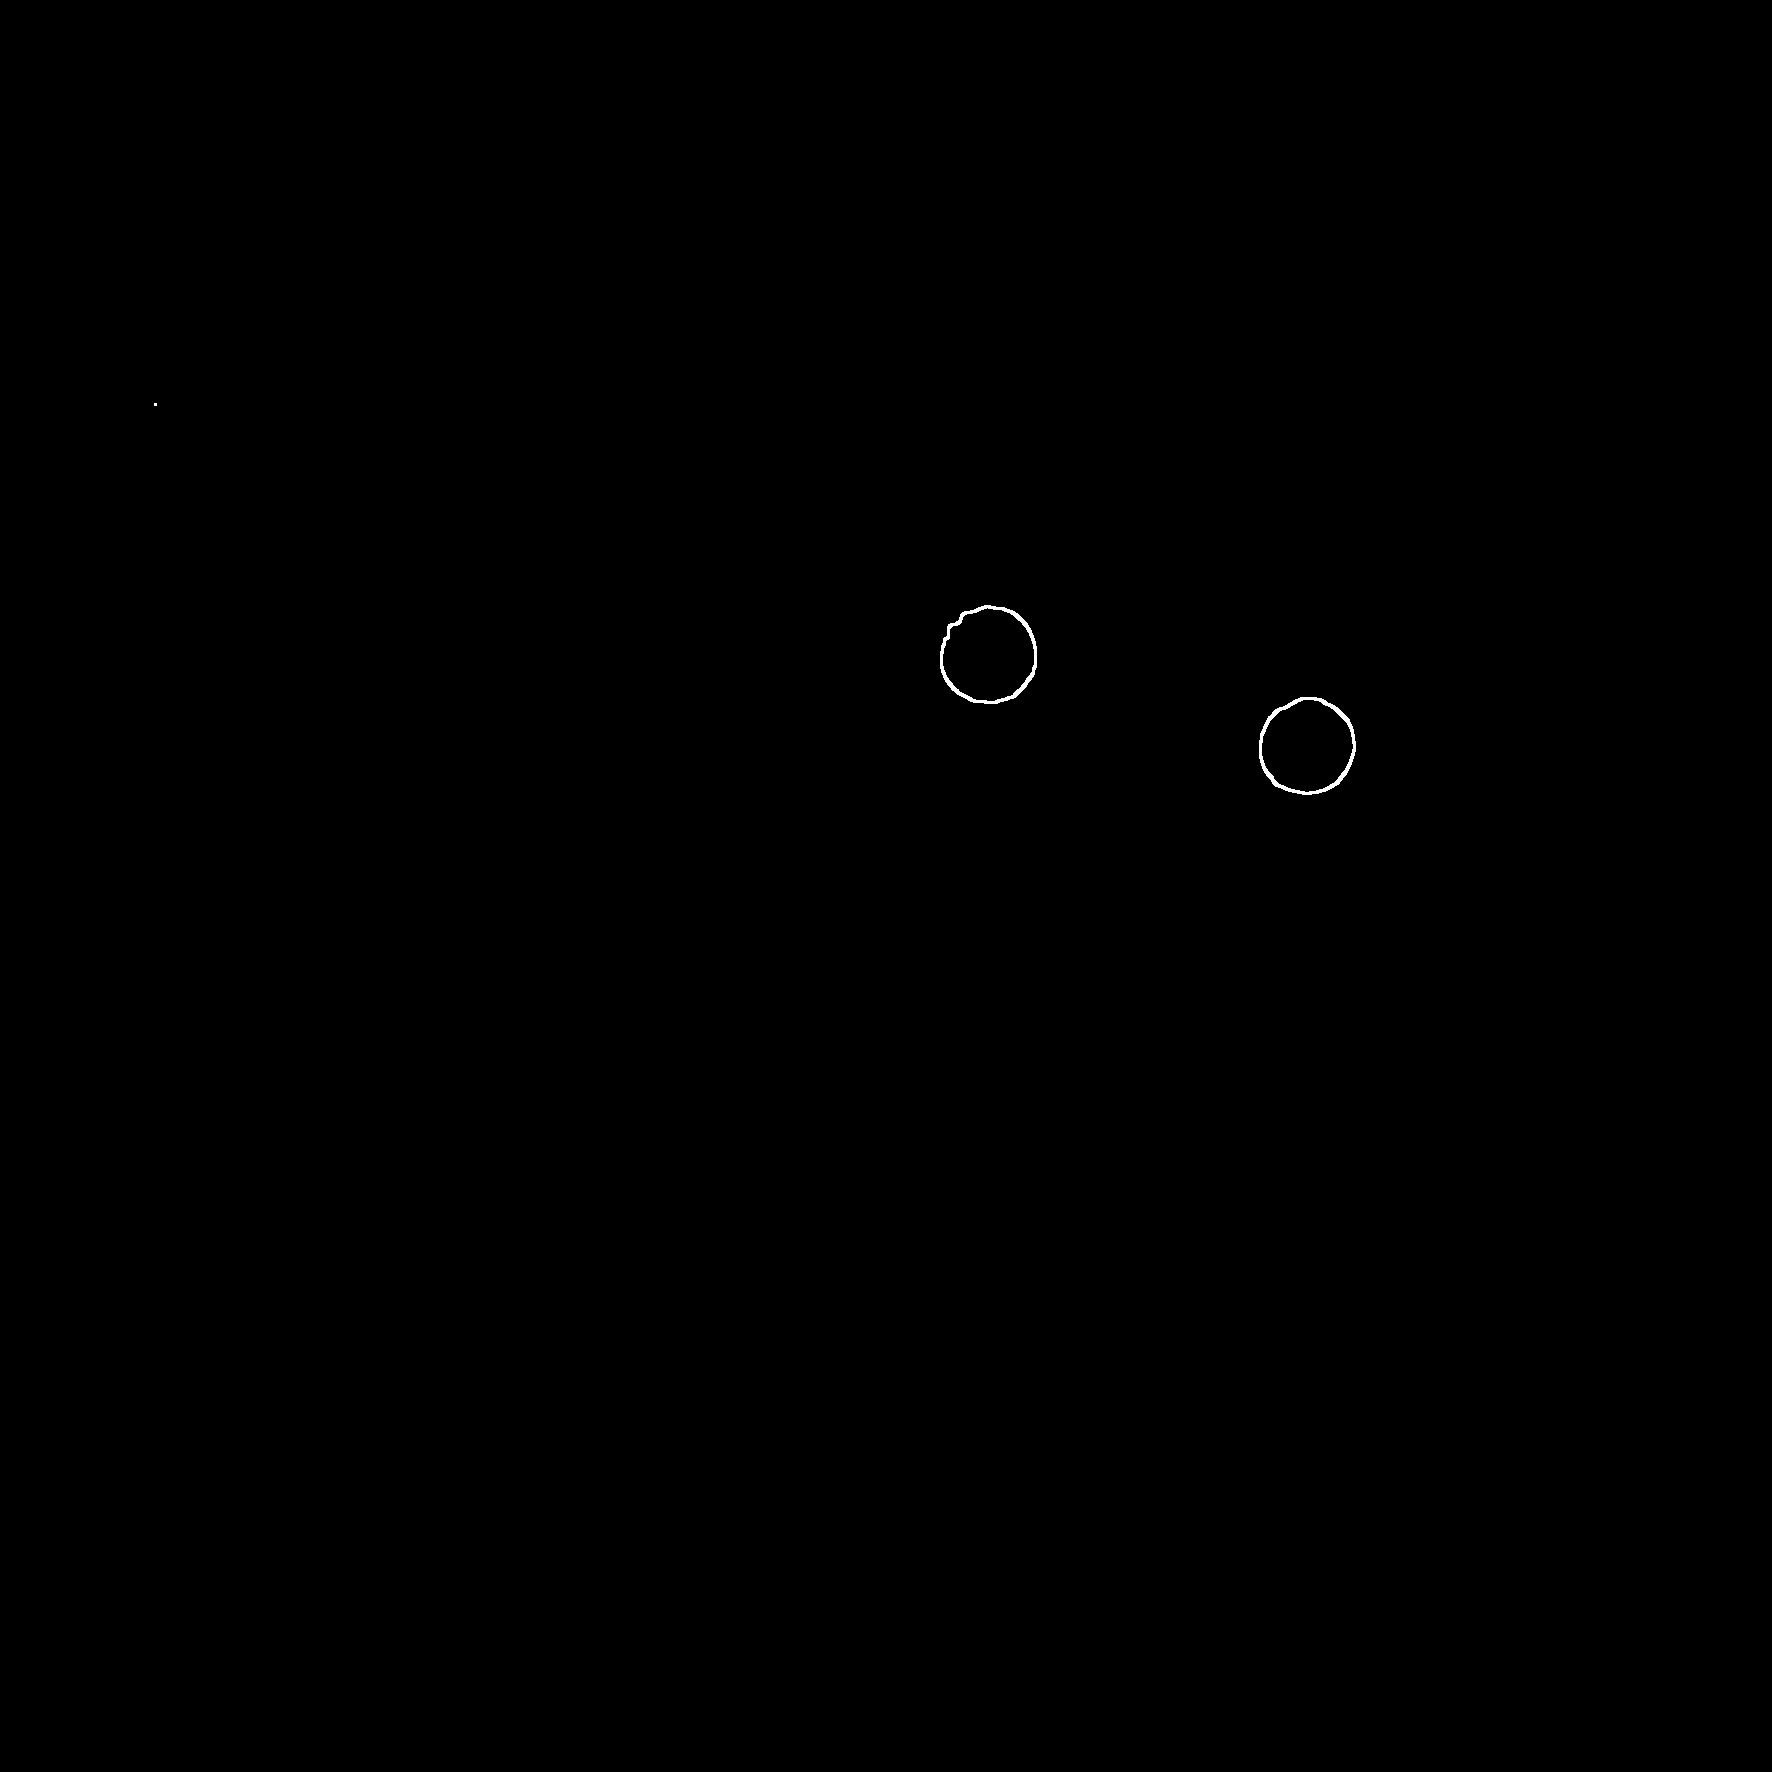

Liczba czarnych kropek: 2


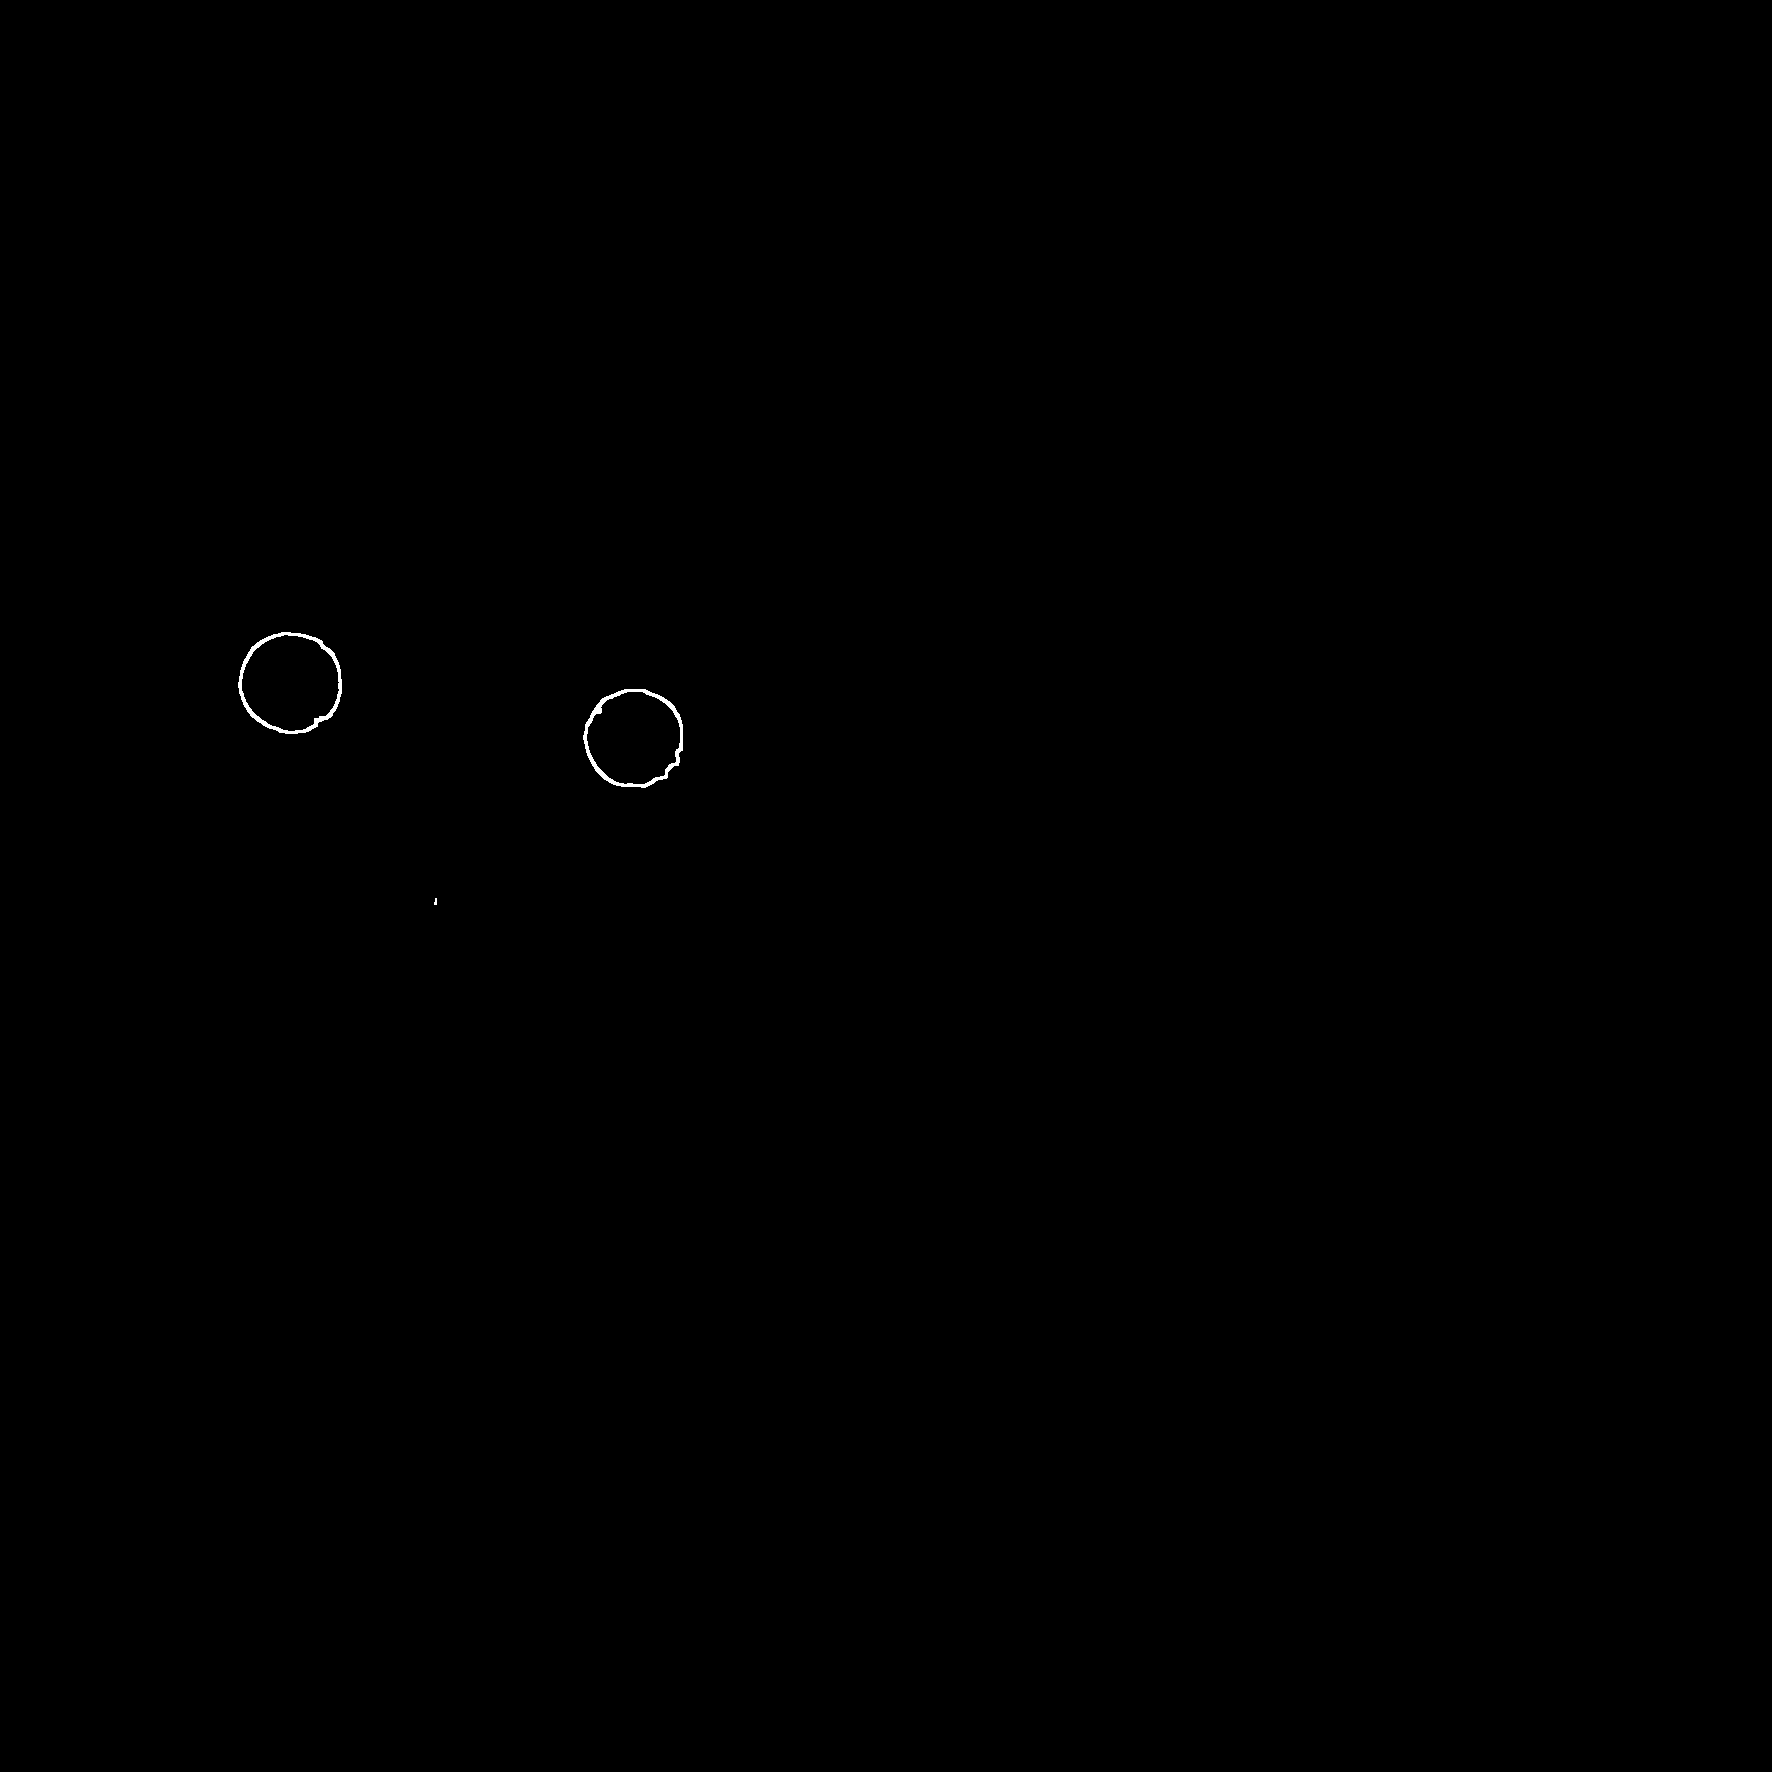

Liczba czarnych kropek: 2


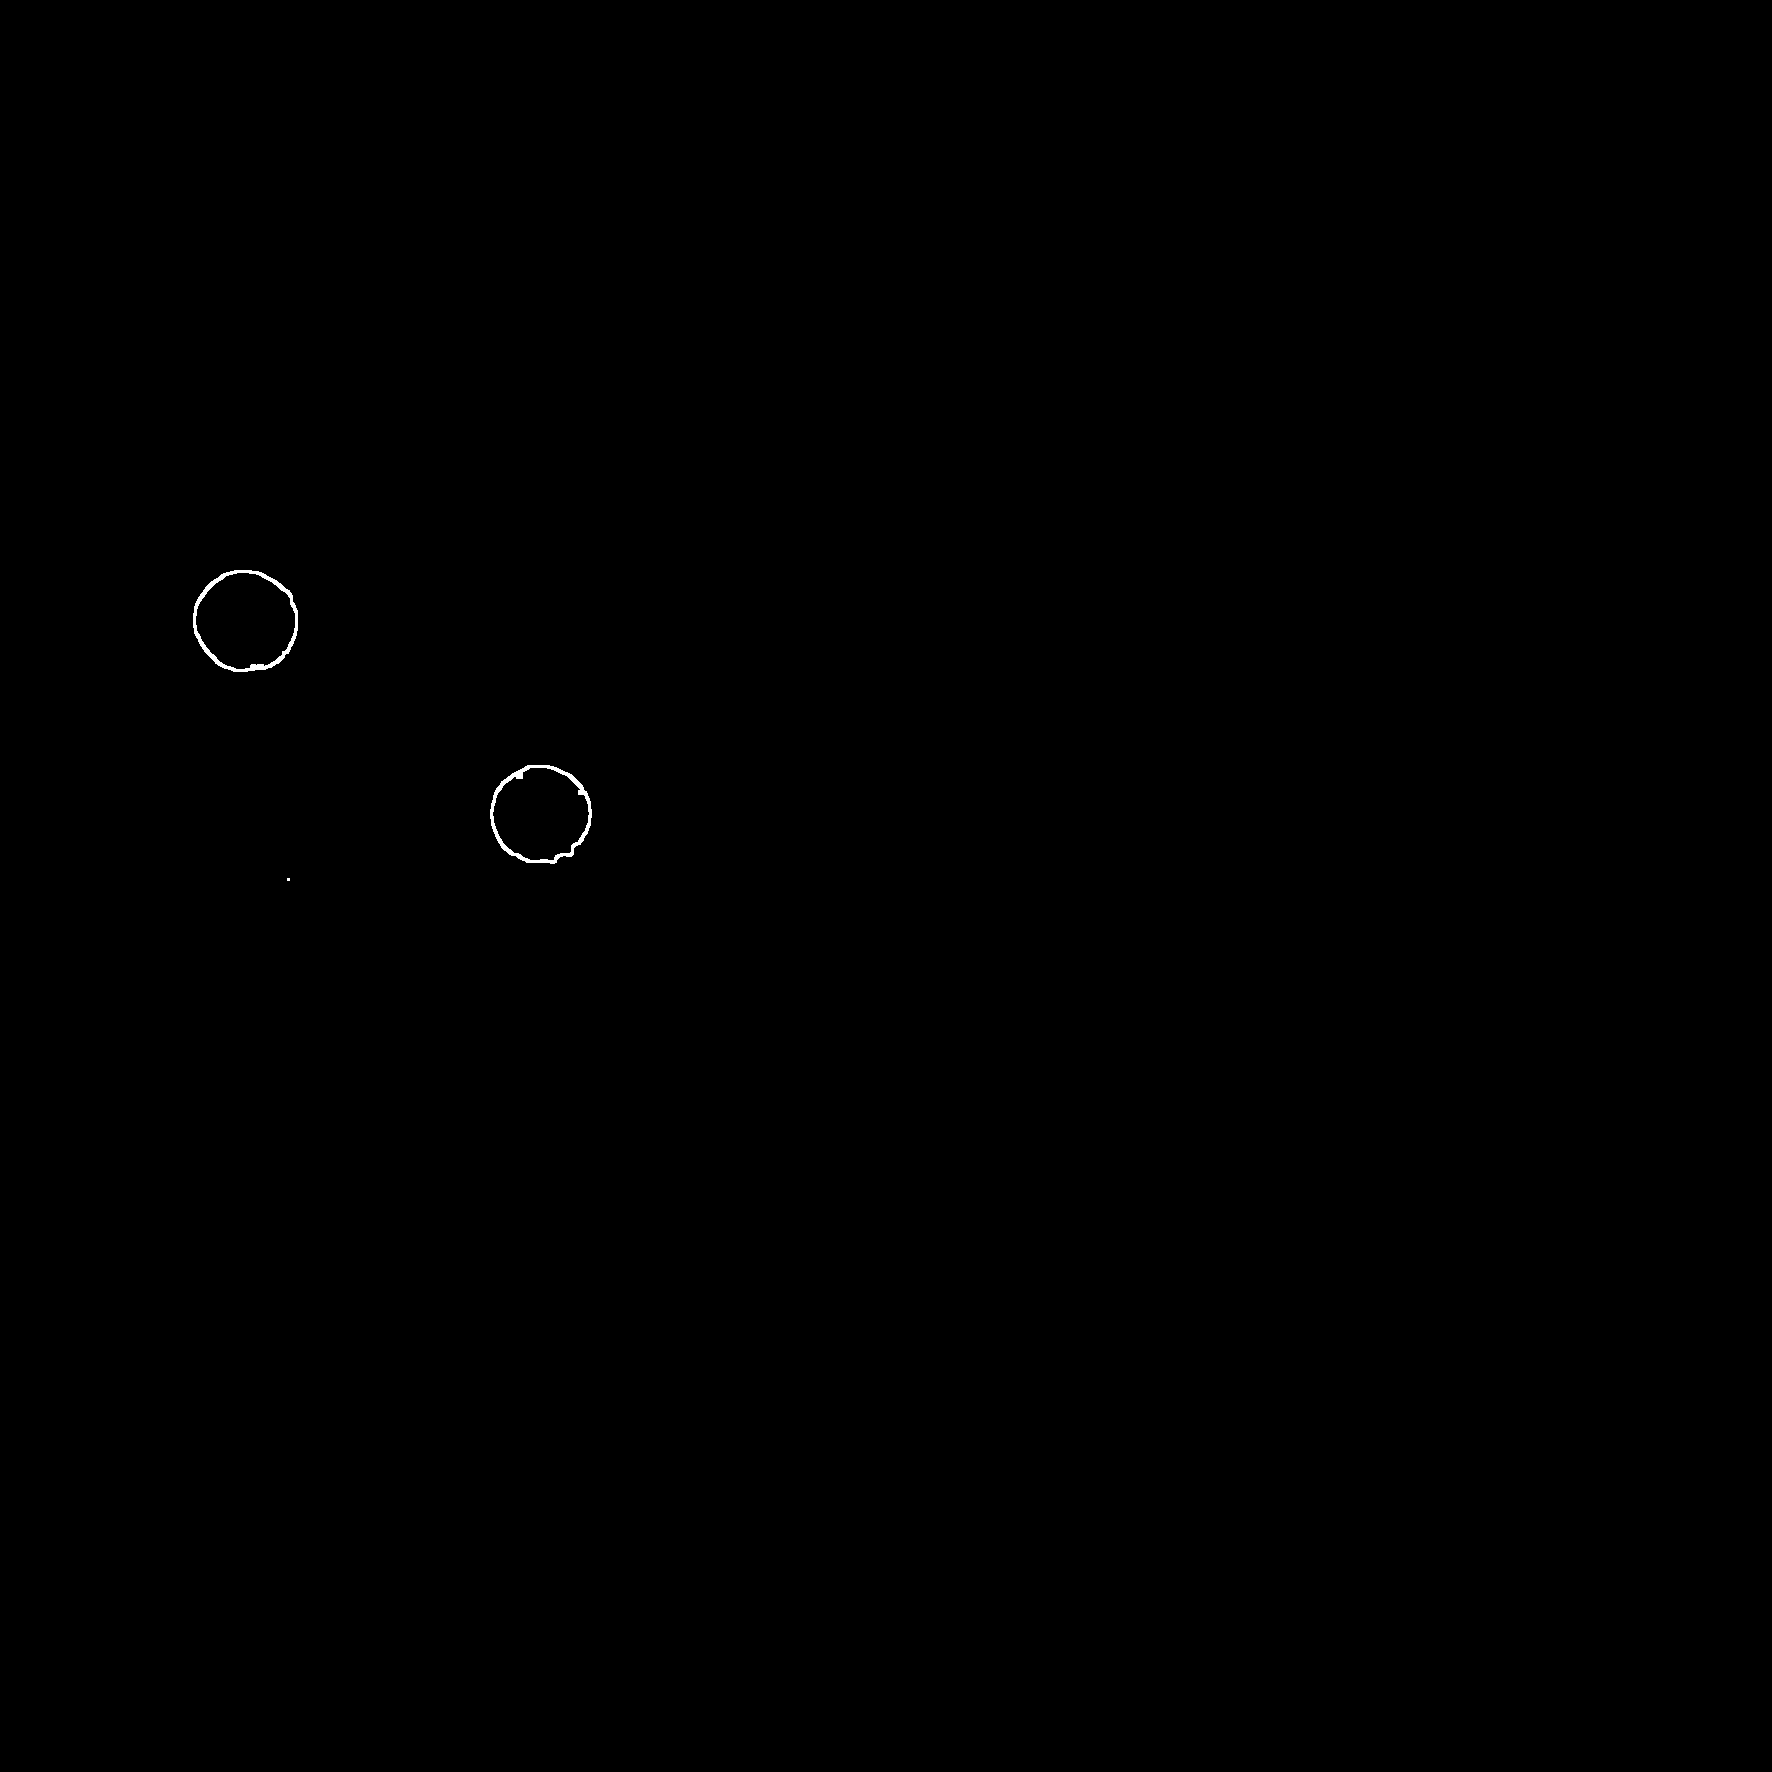

Liczba czarnych kropek: 2


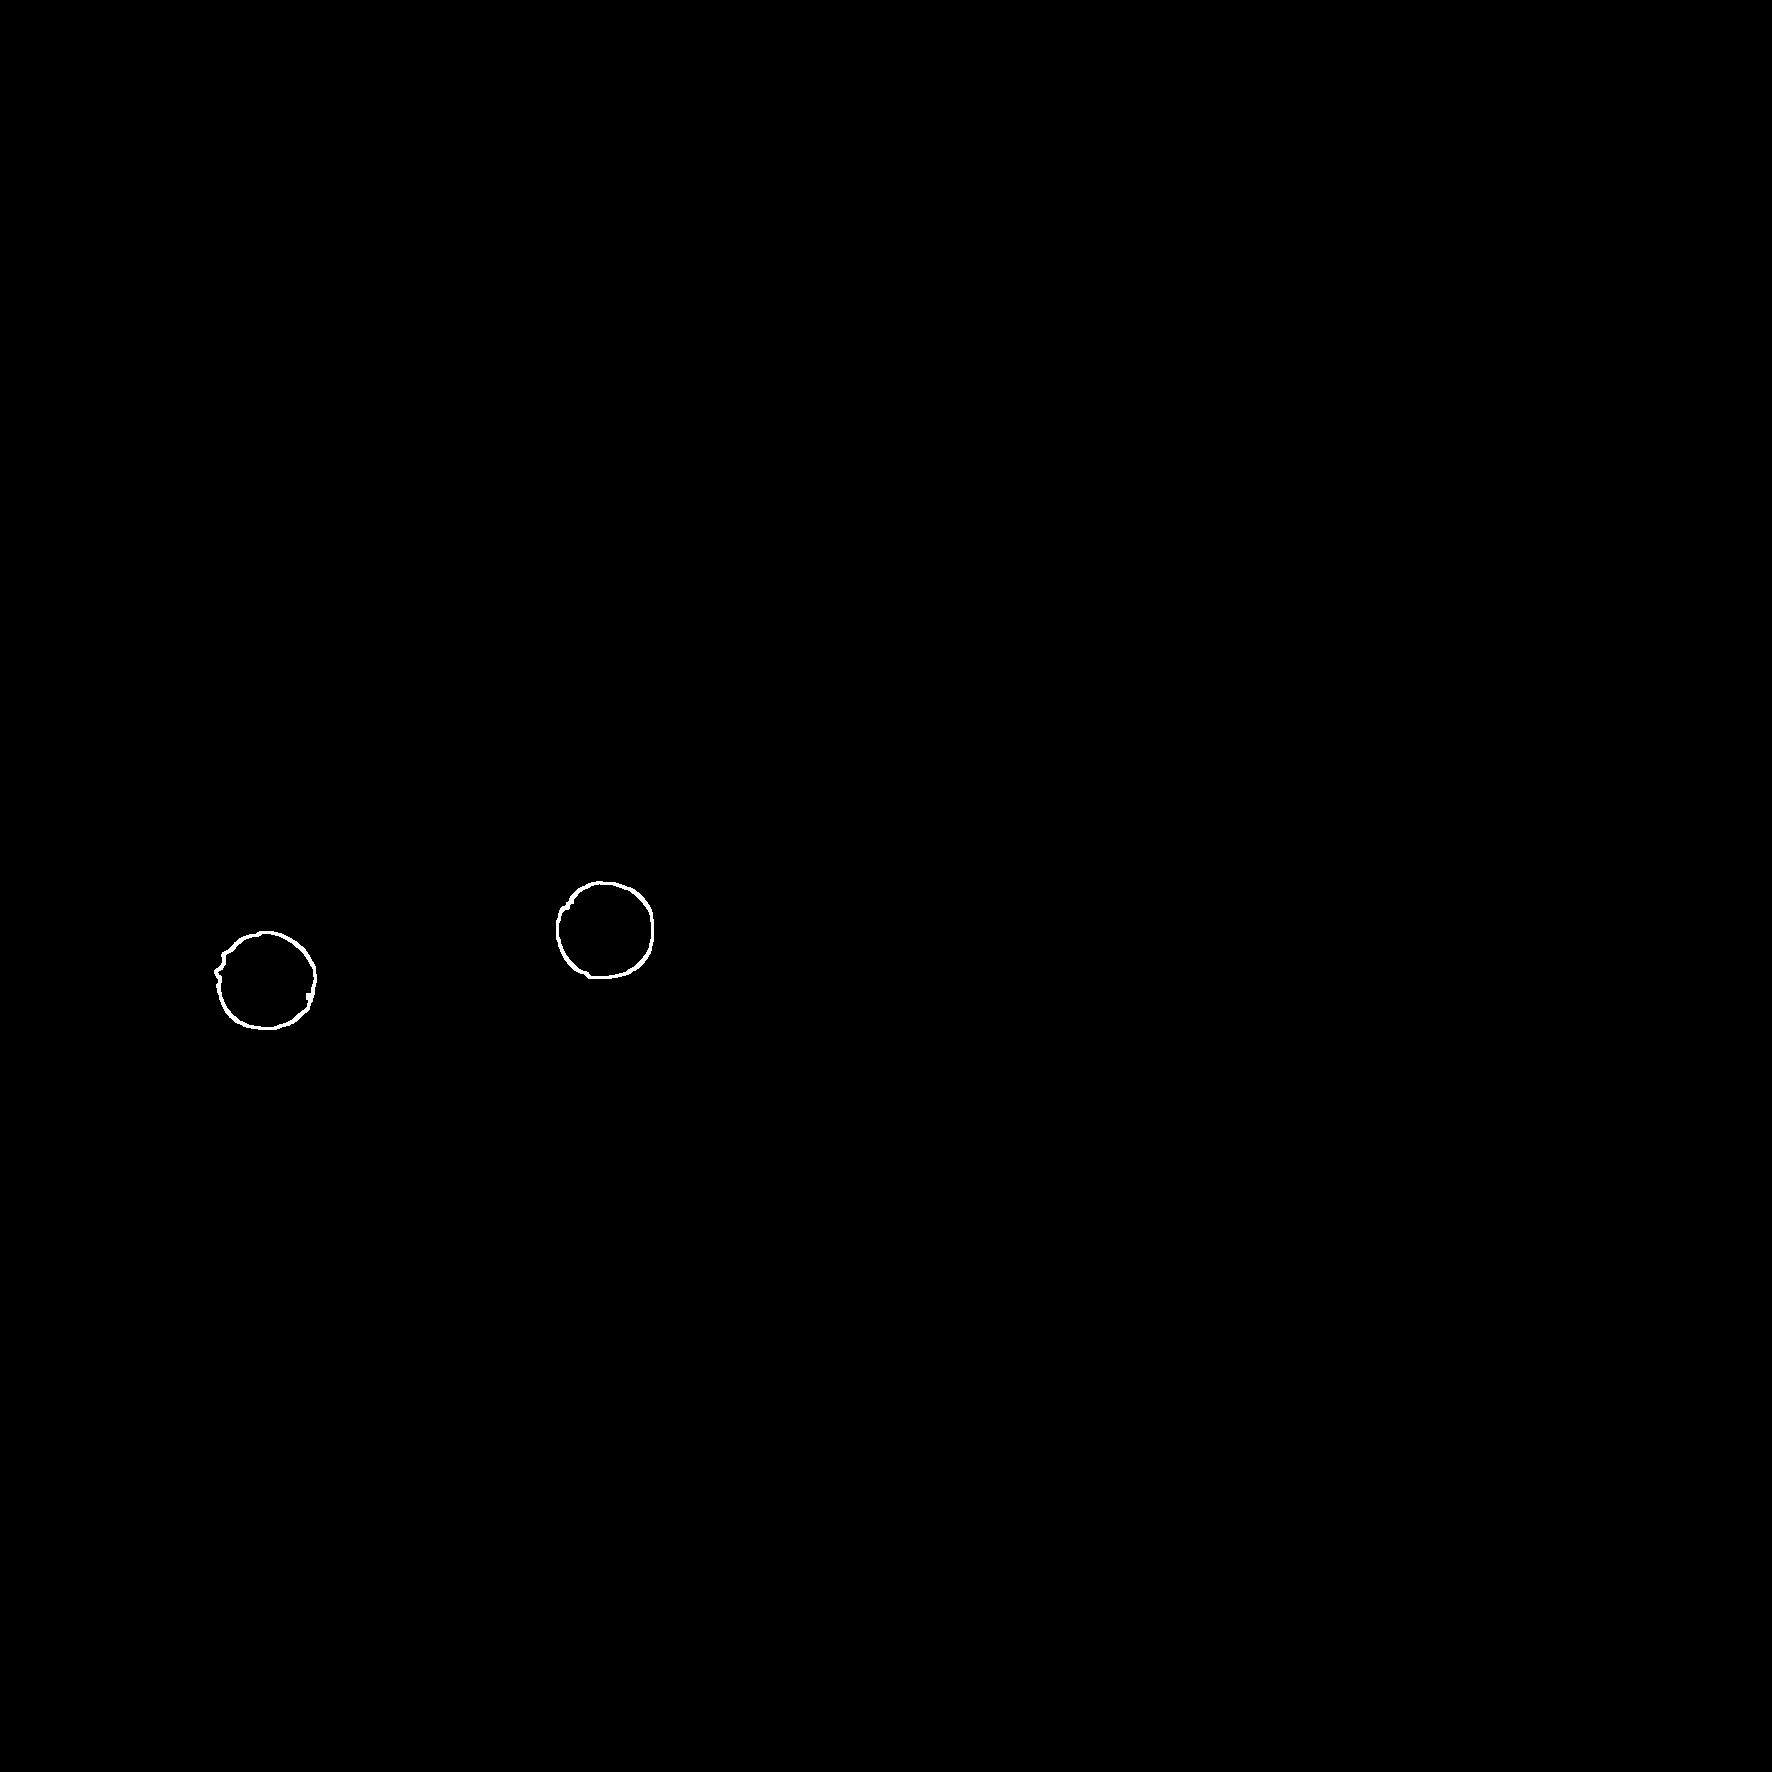

Liczba czarnych kropek: 2


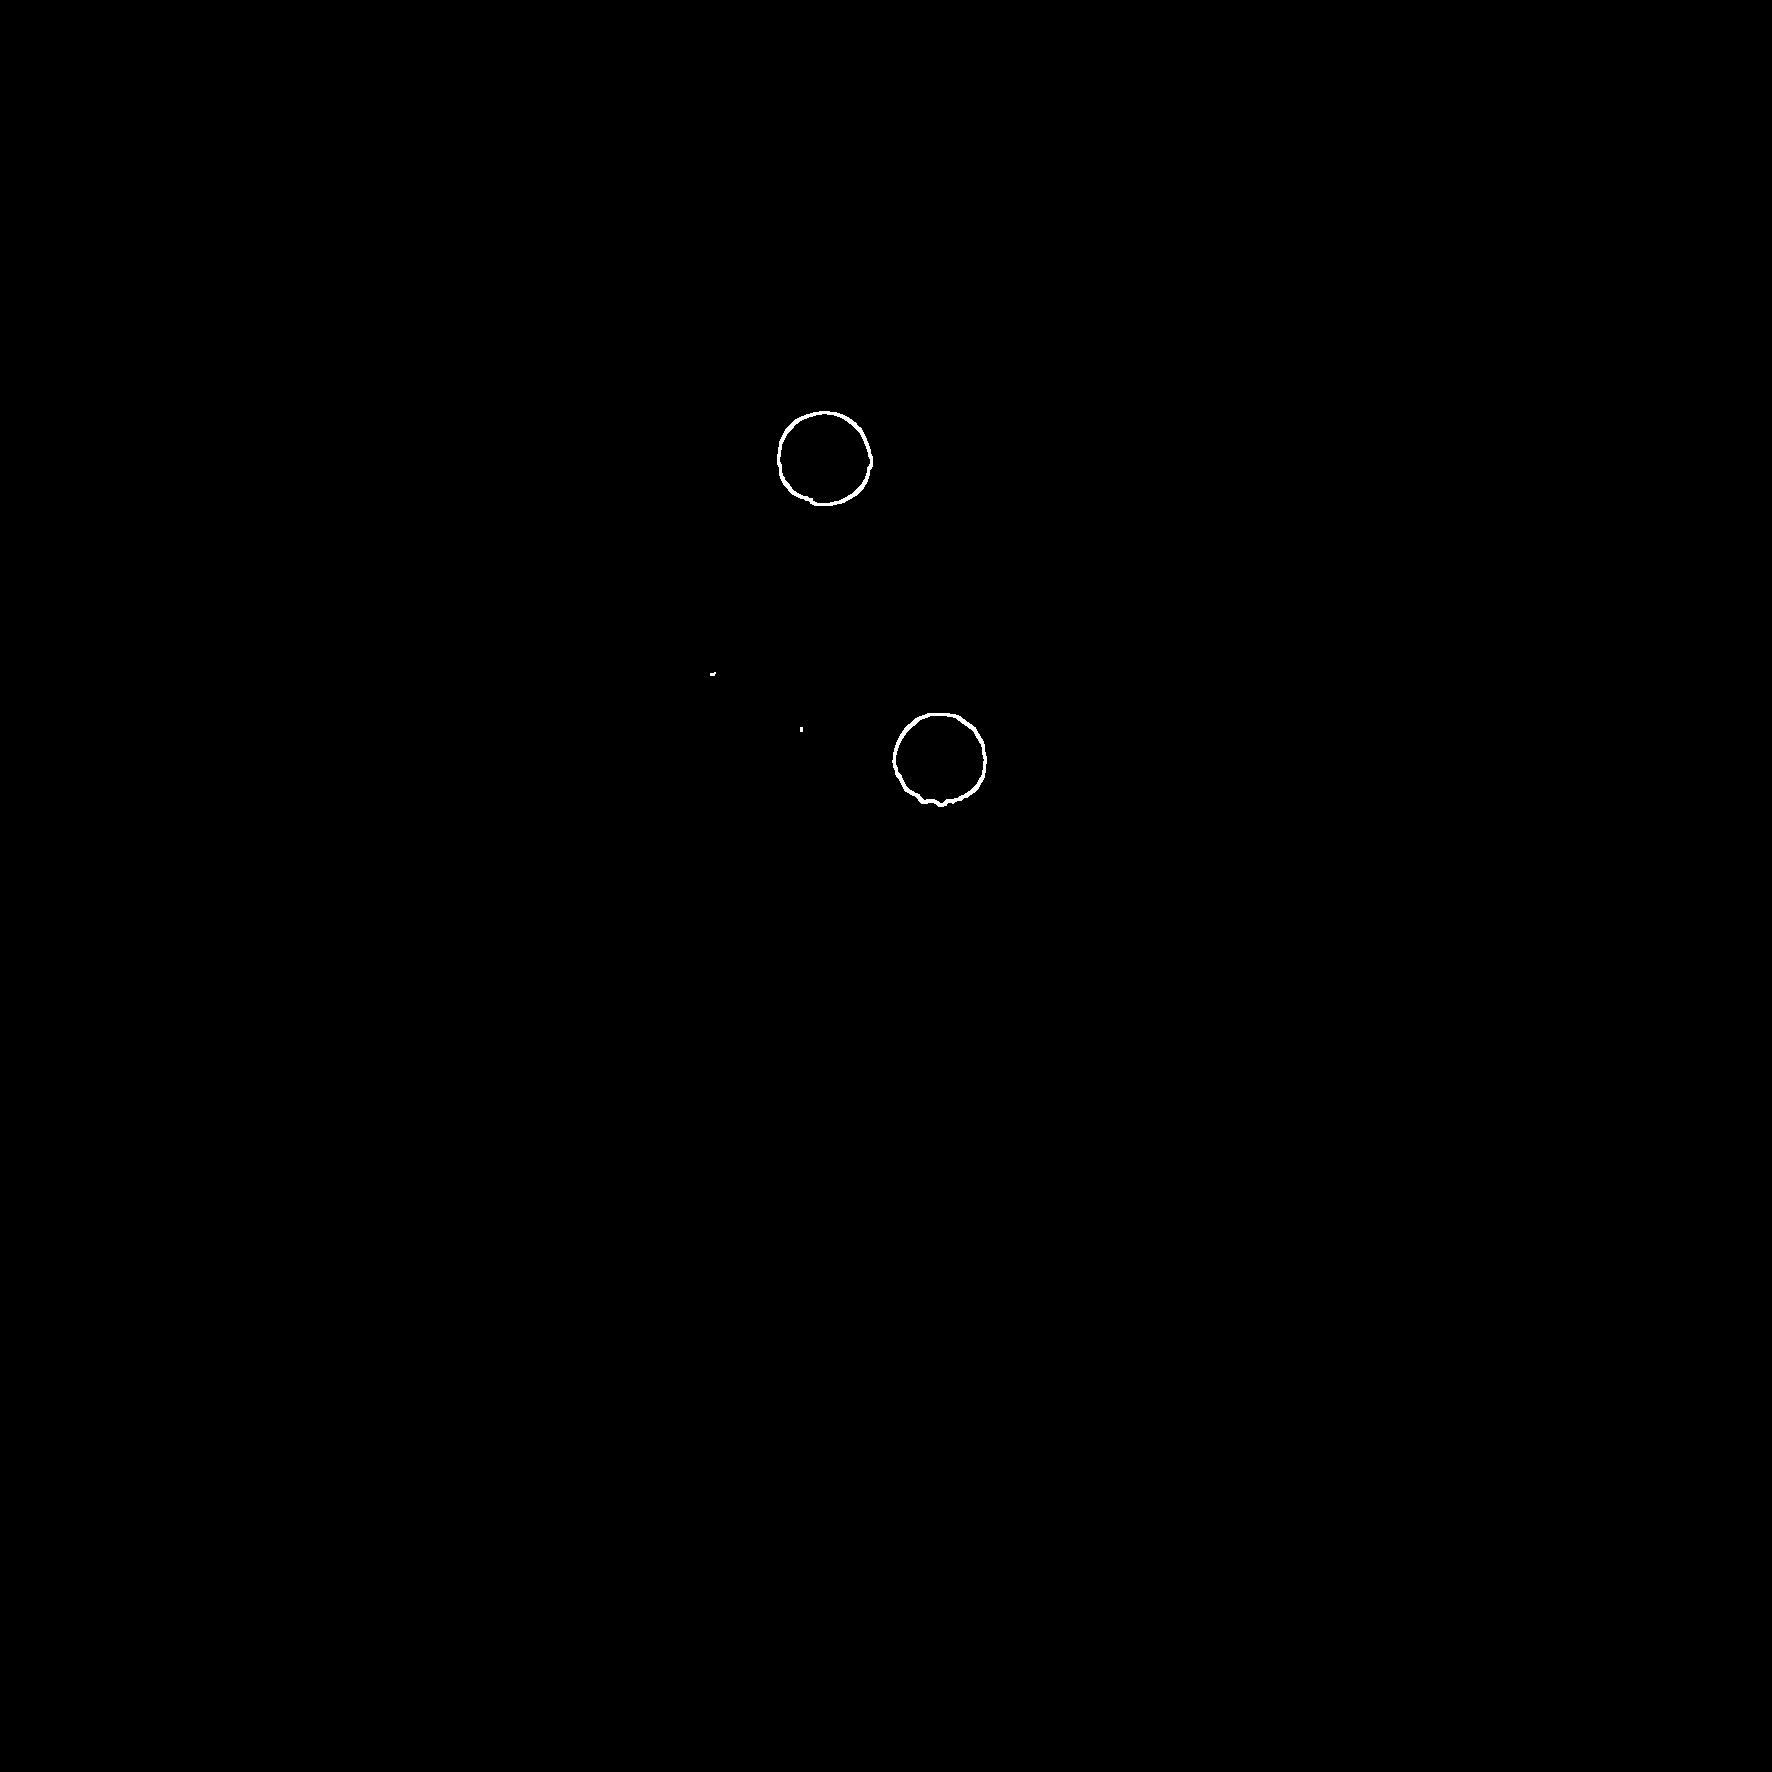

Liczba czarnych kropek: 2


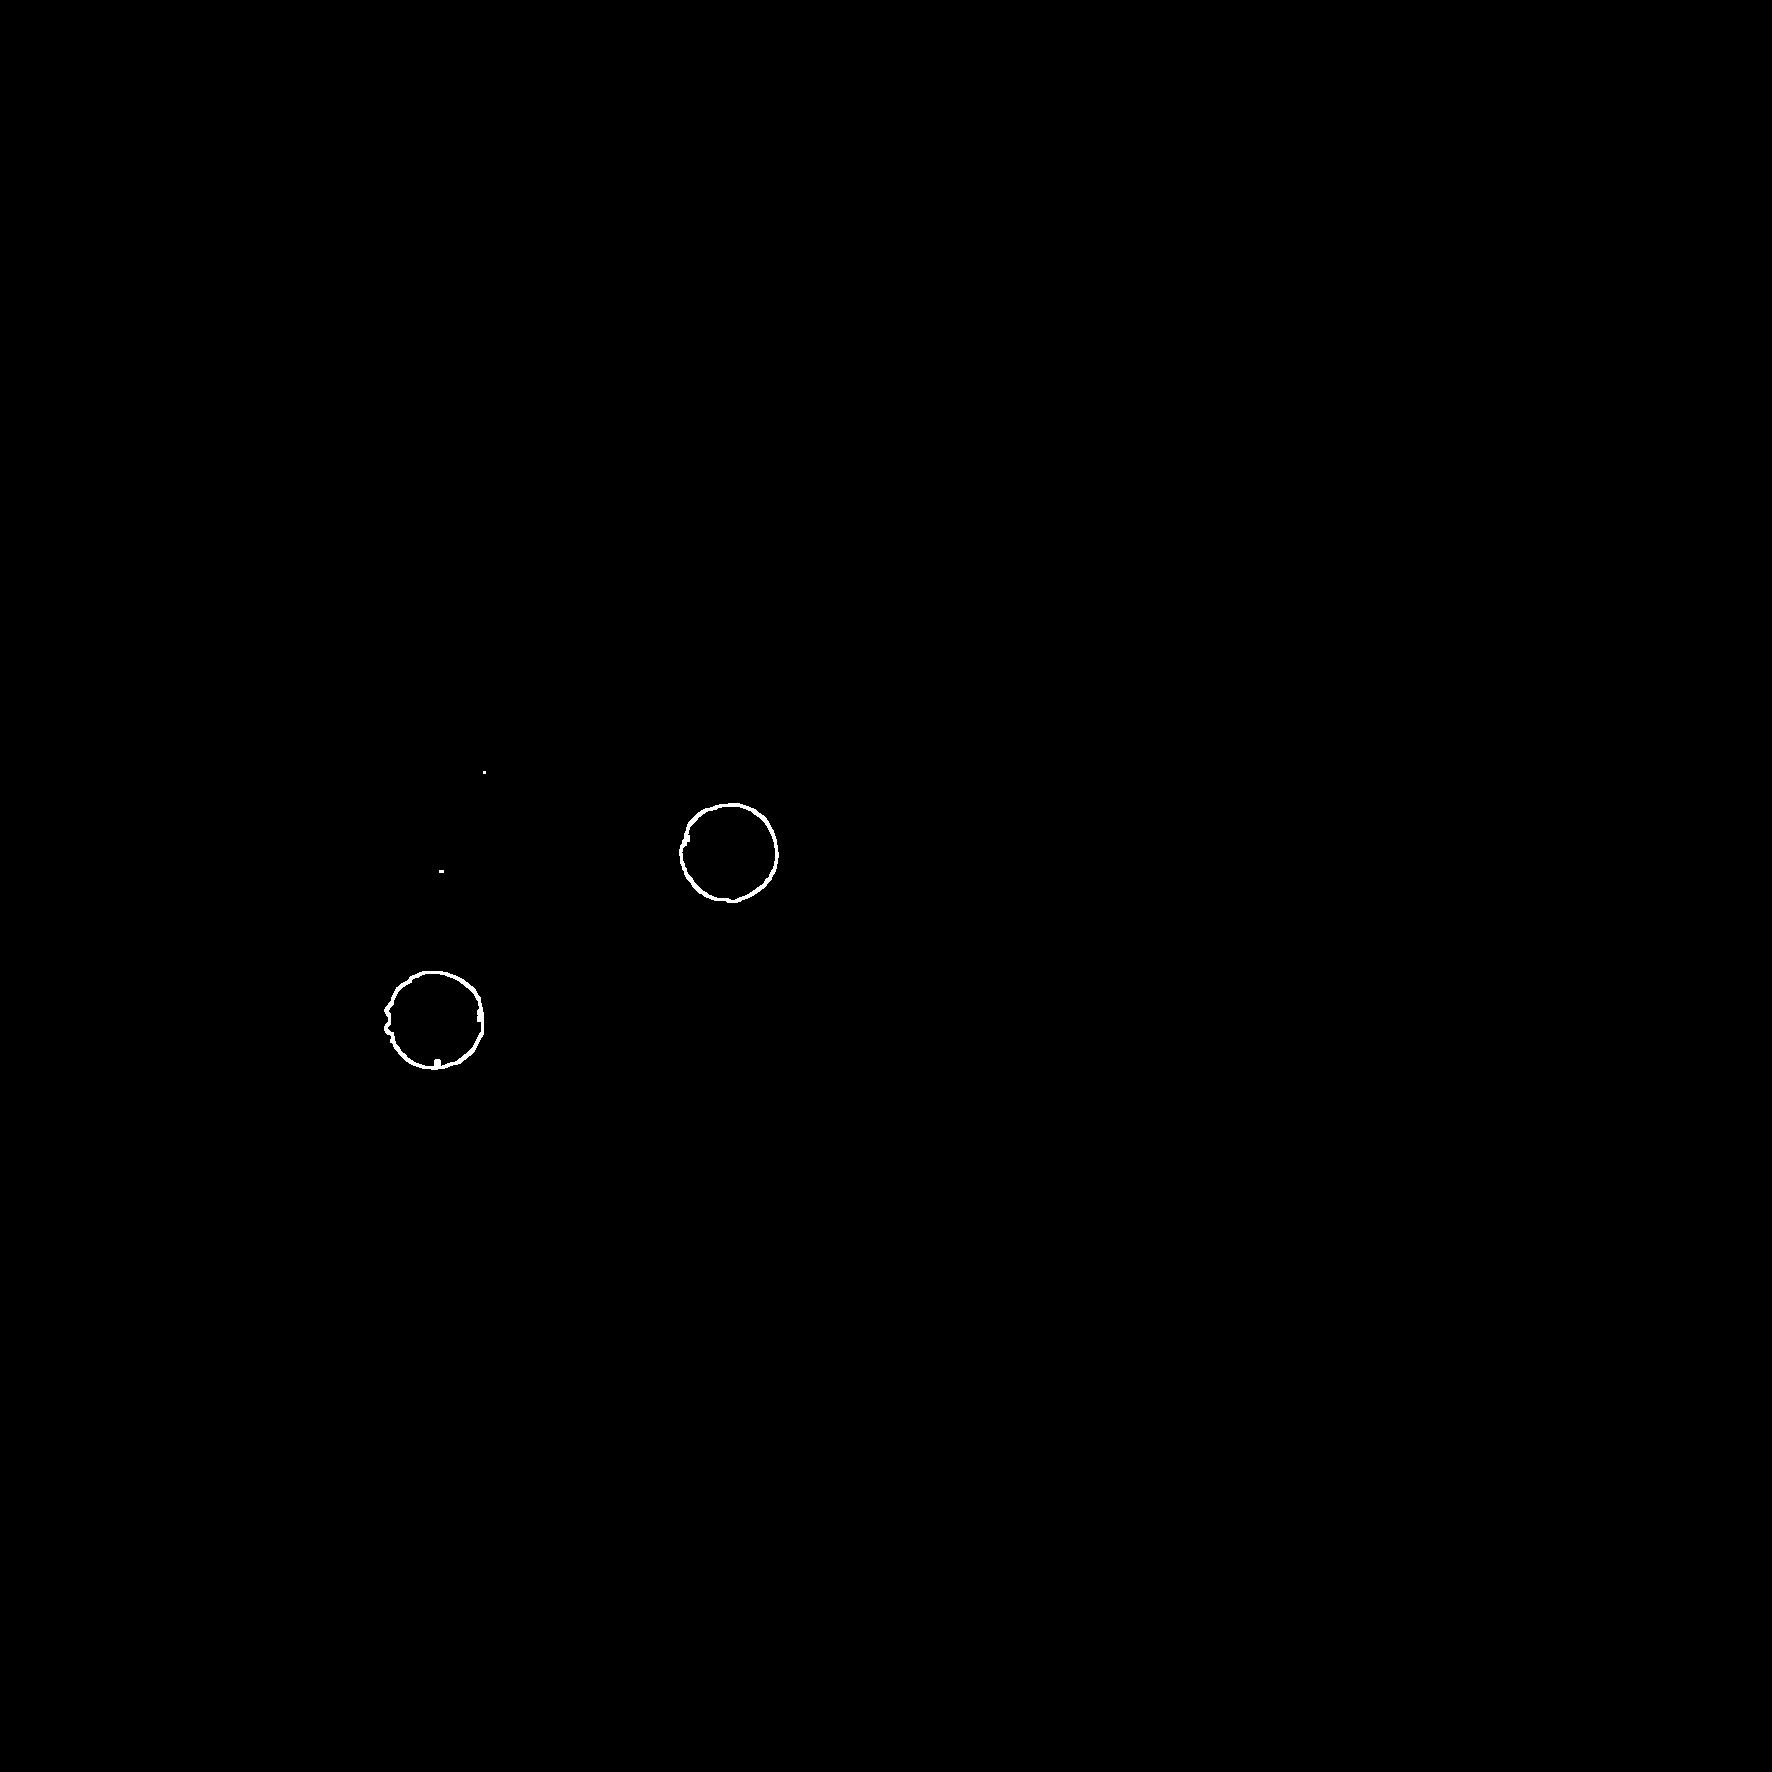

Liczba czarnych kropek: 2


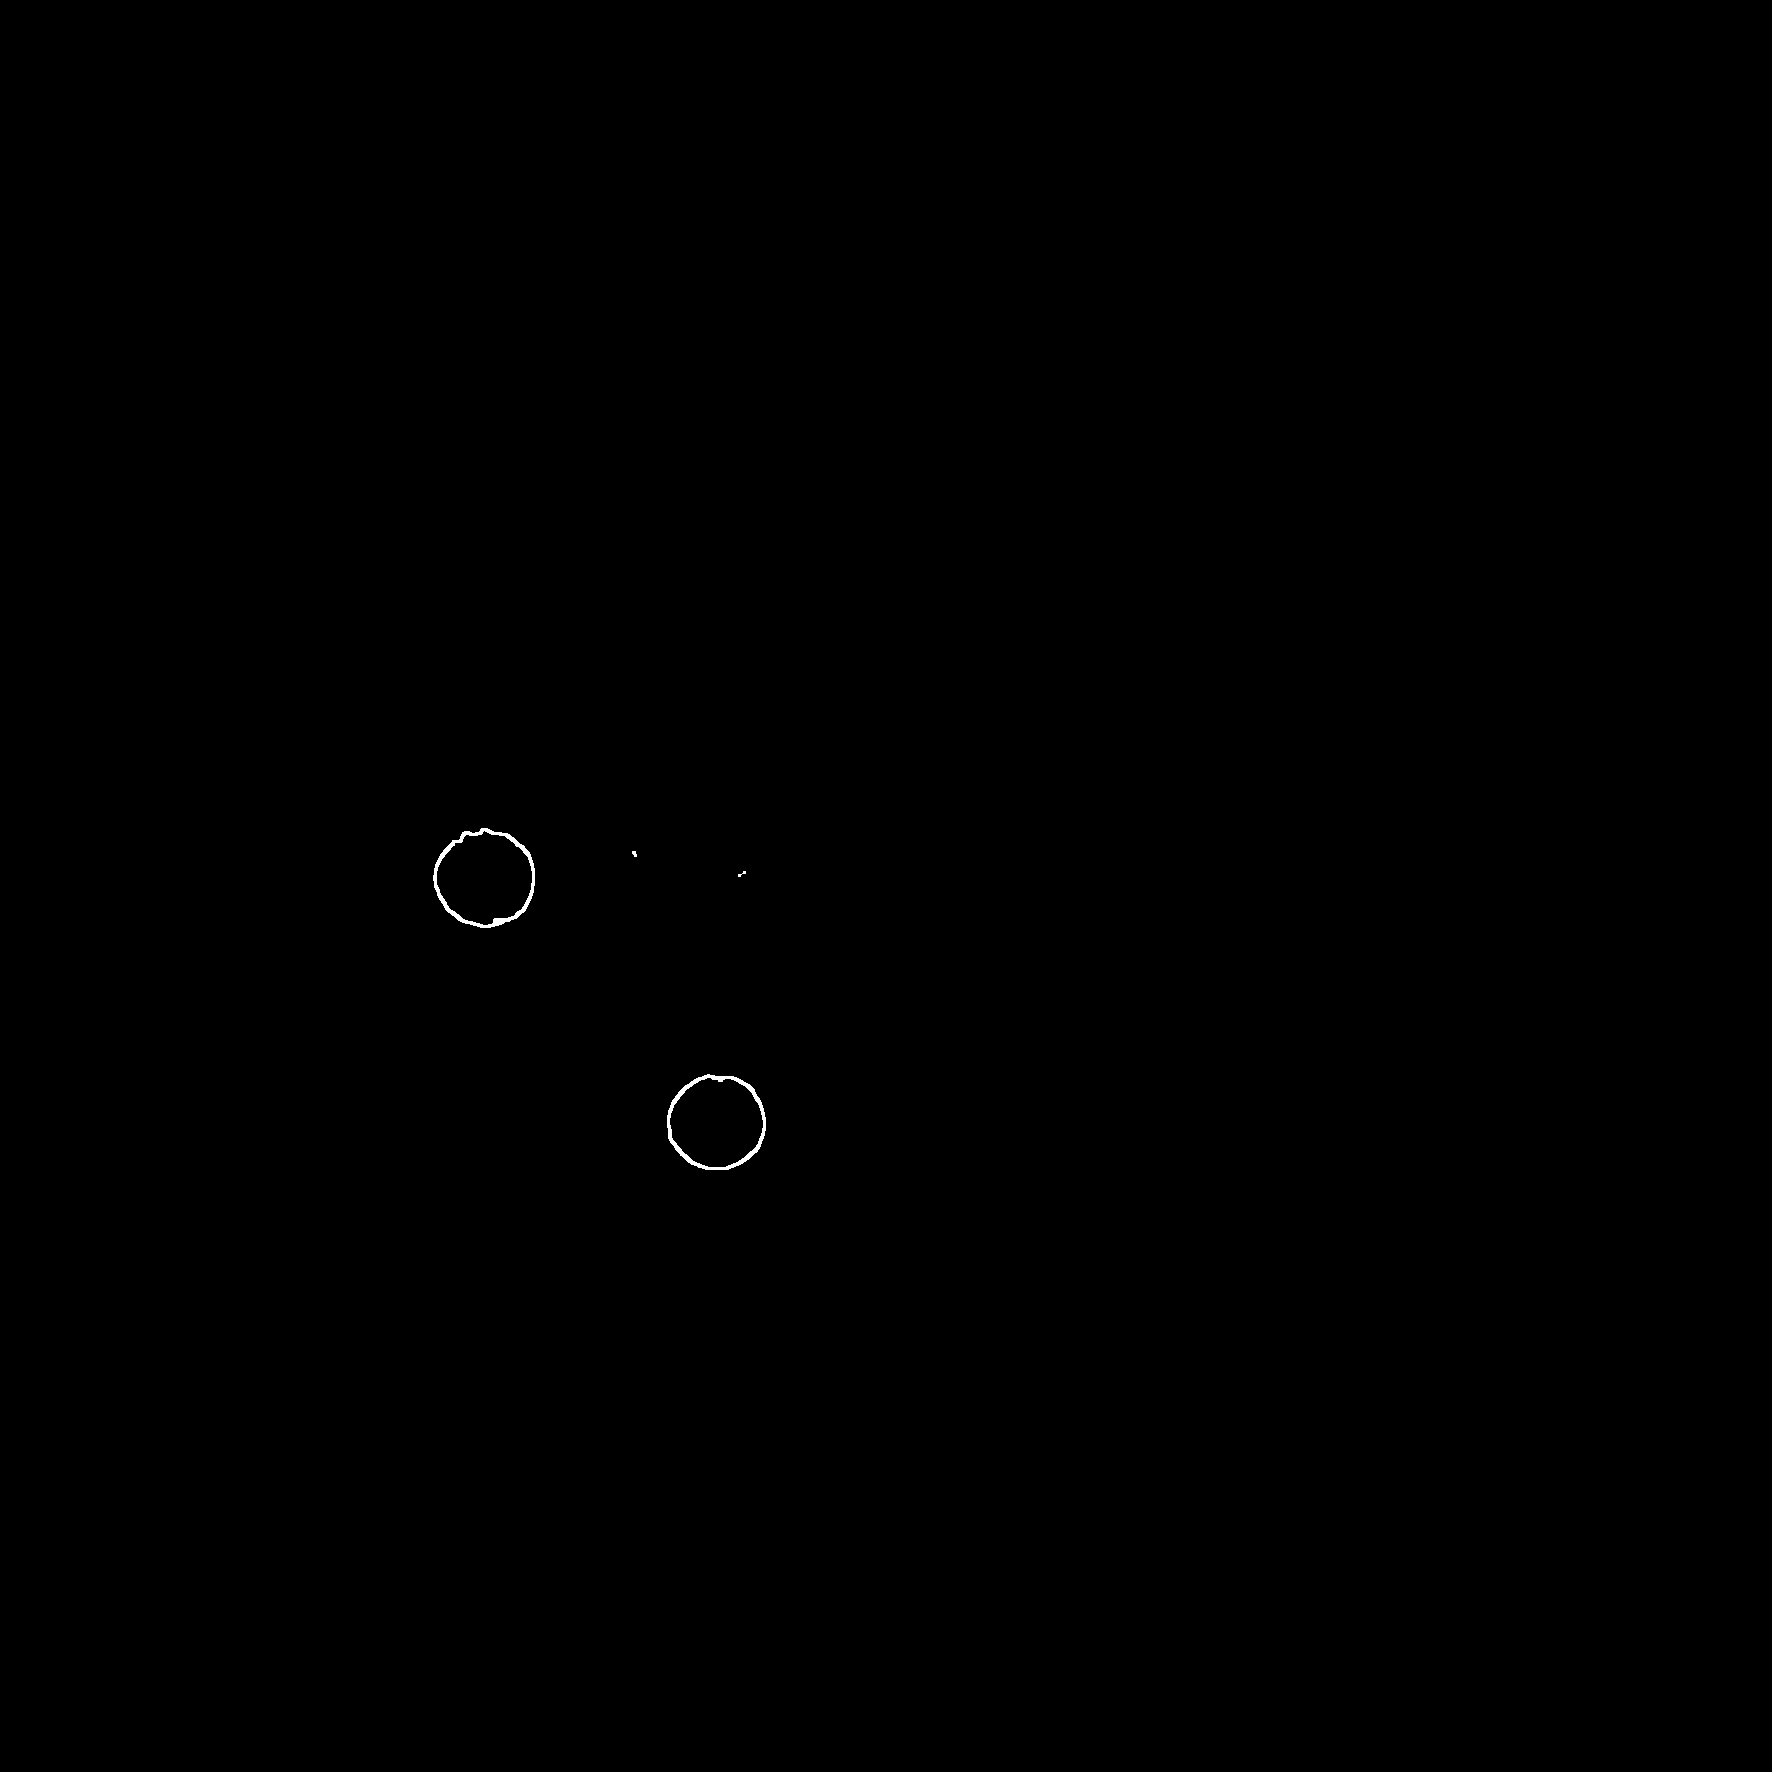

Liczba czarnych kropek: 2


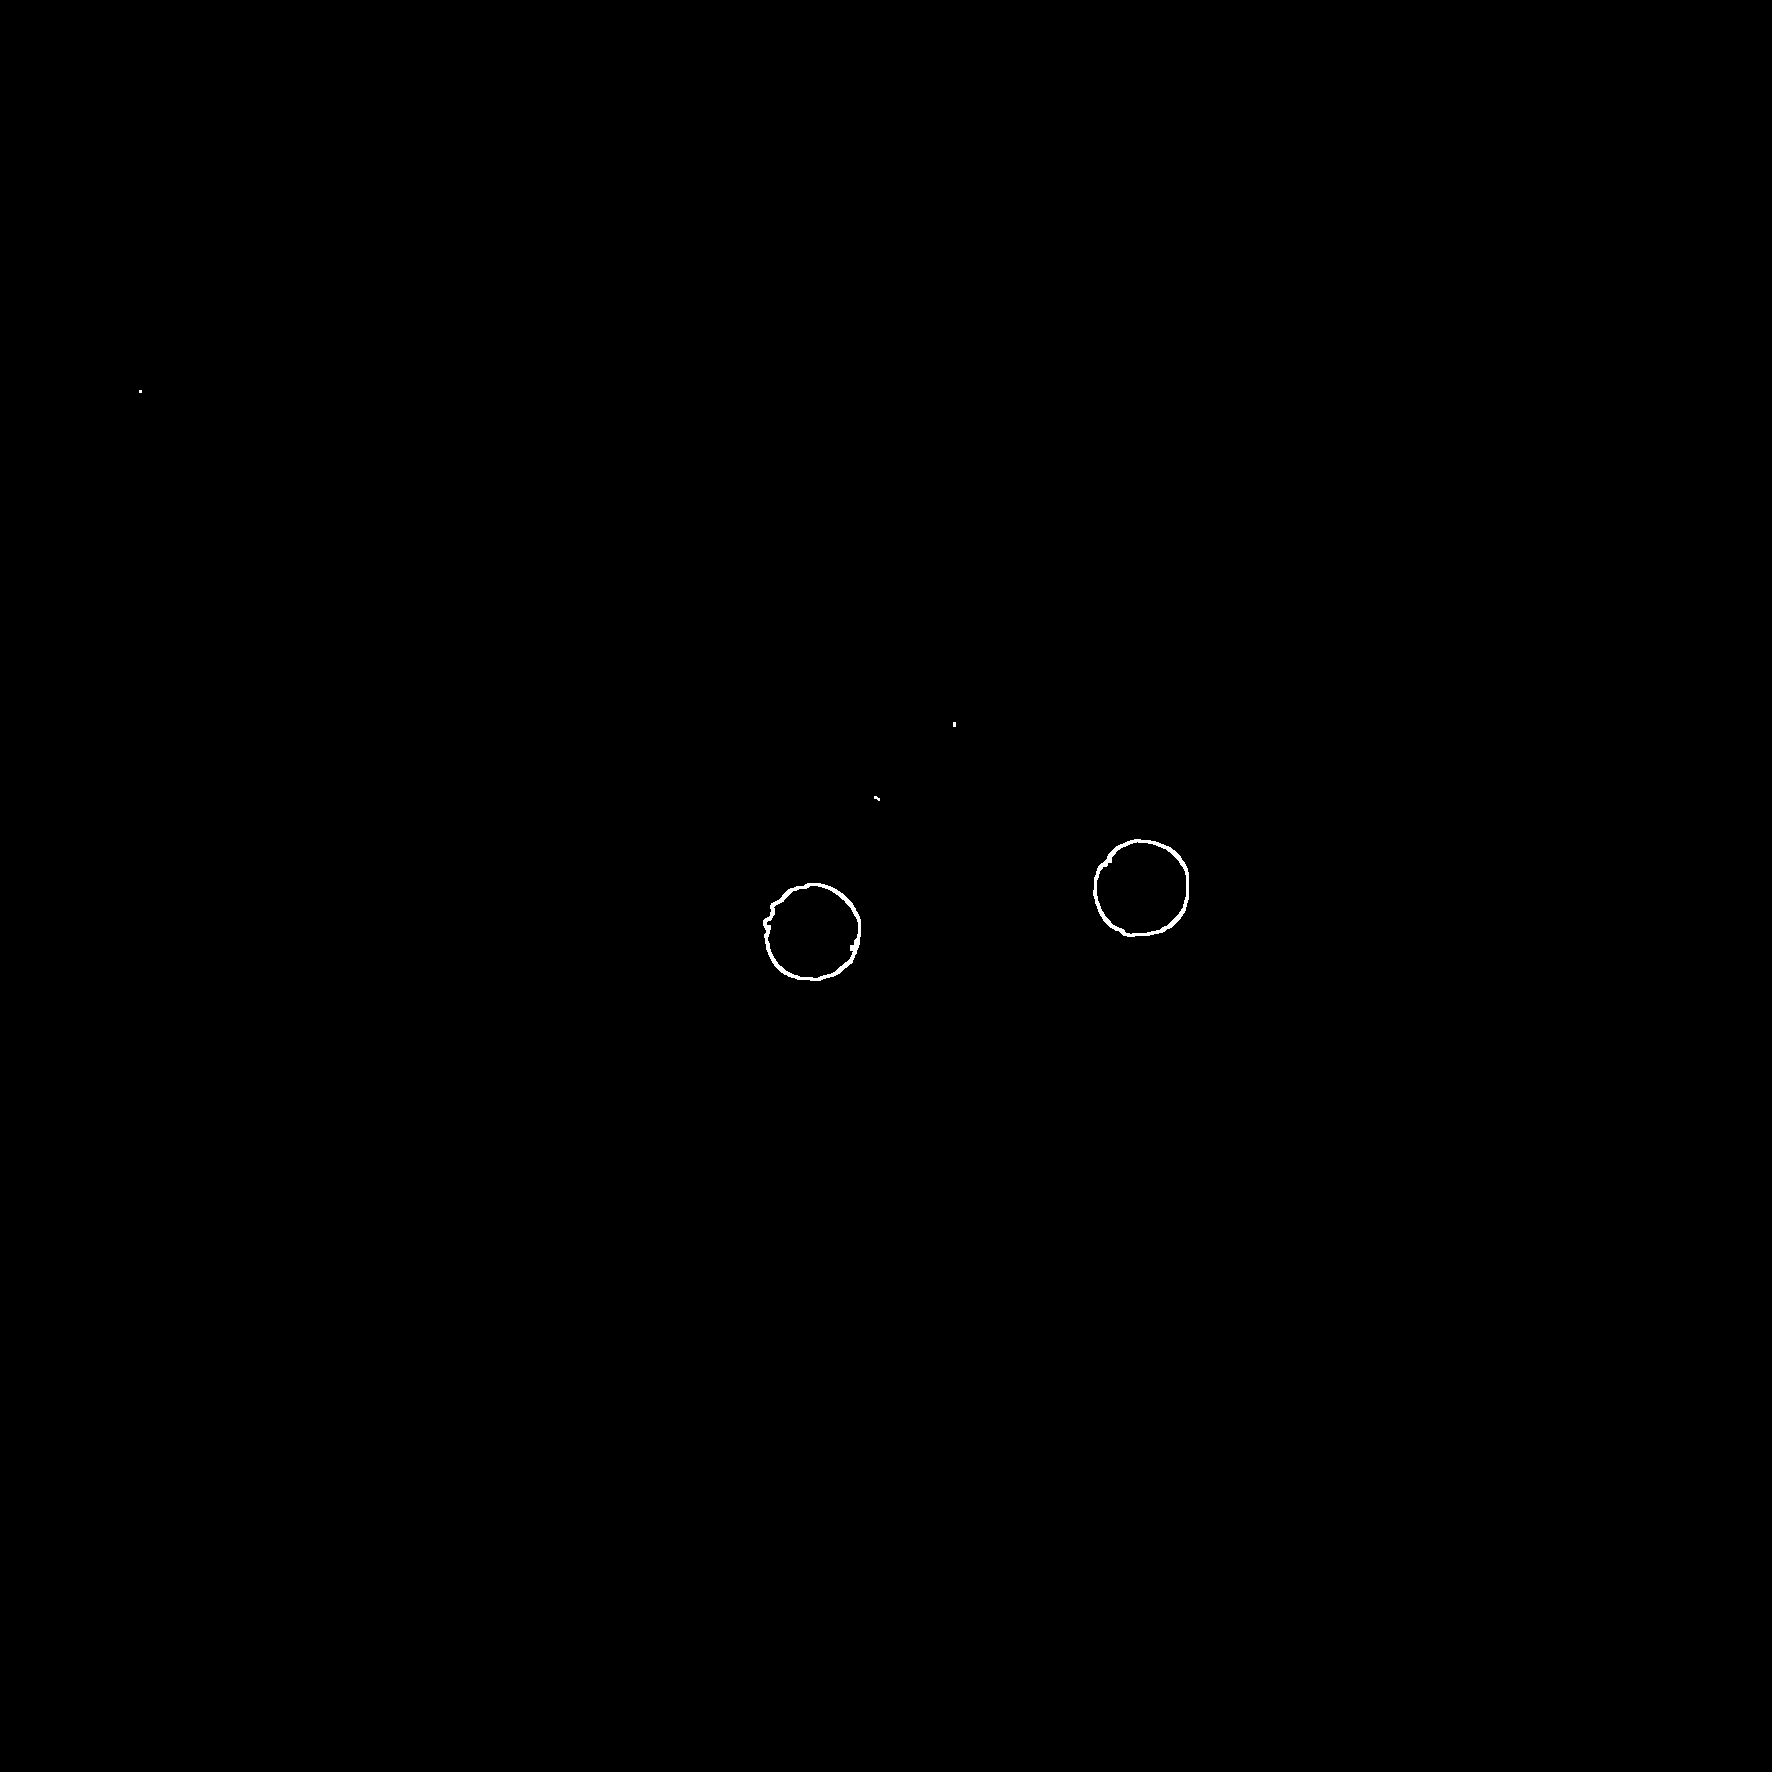

Liczba czarnych kropek: 2


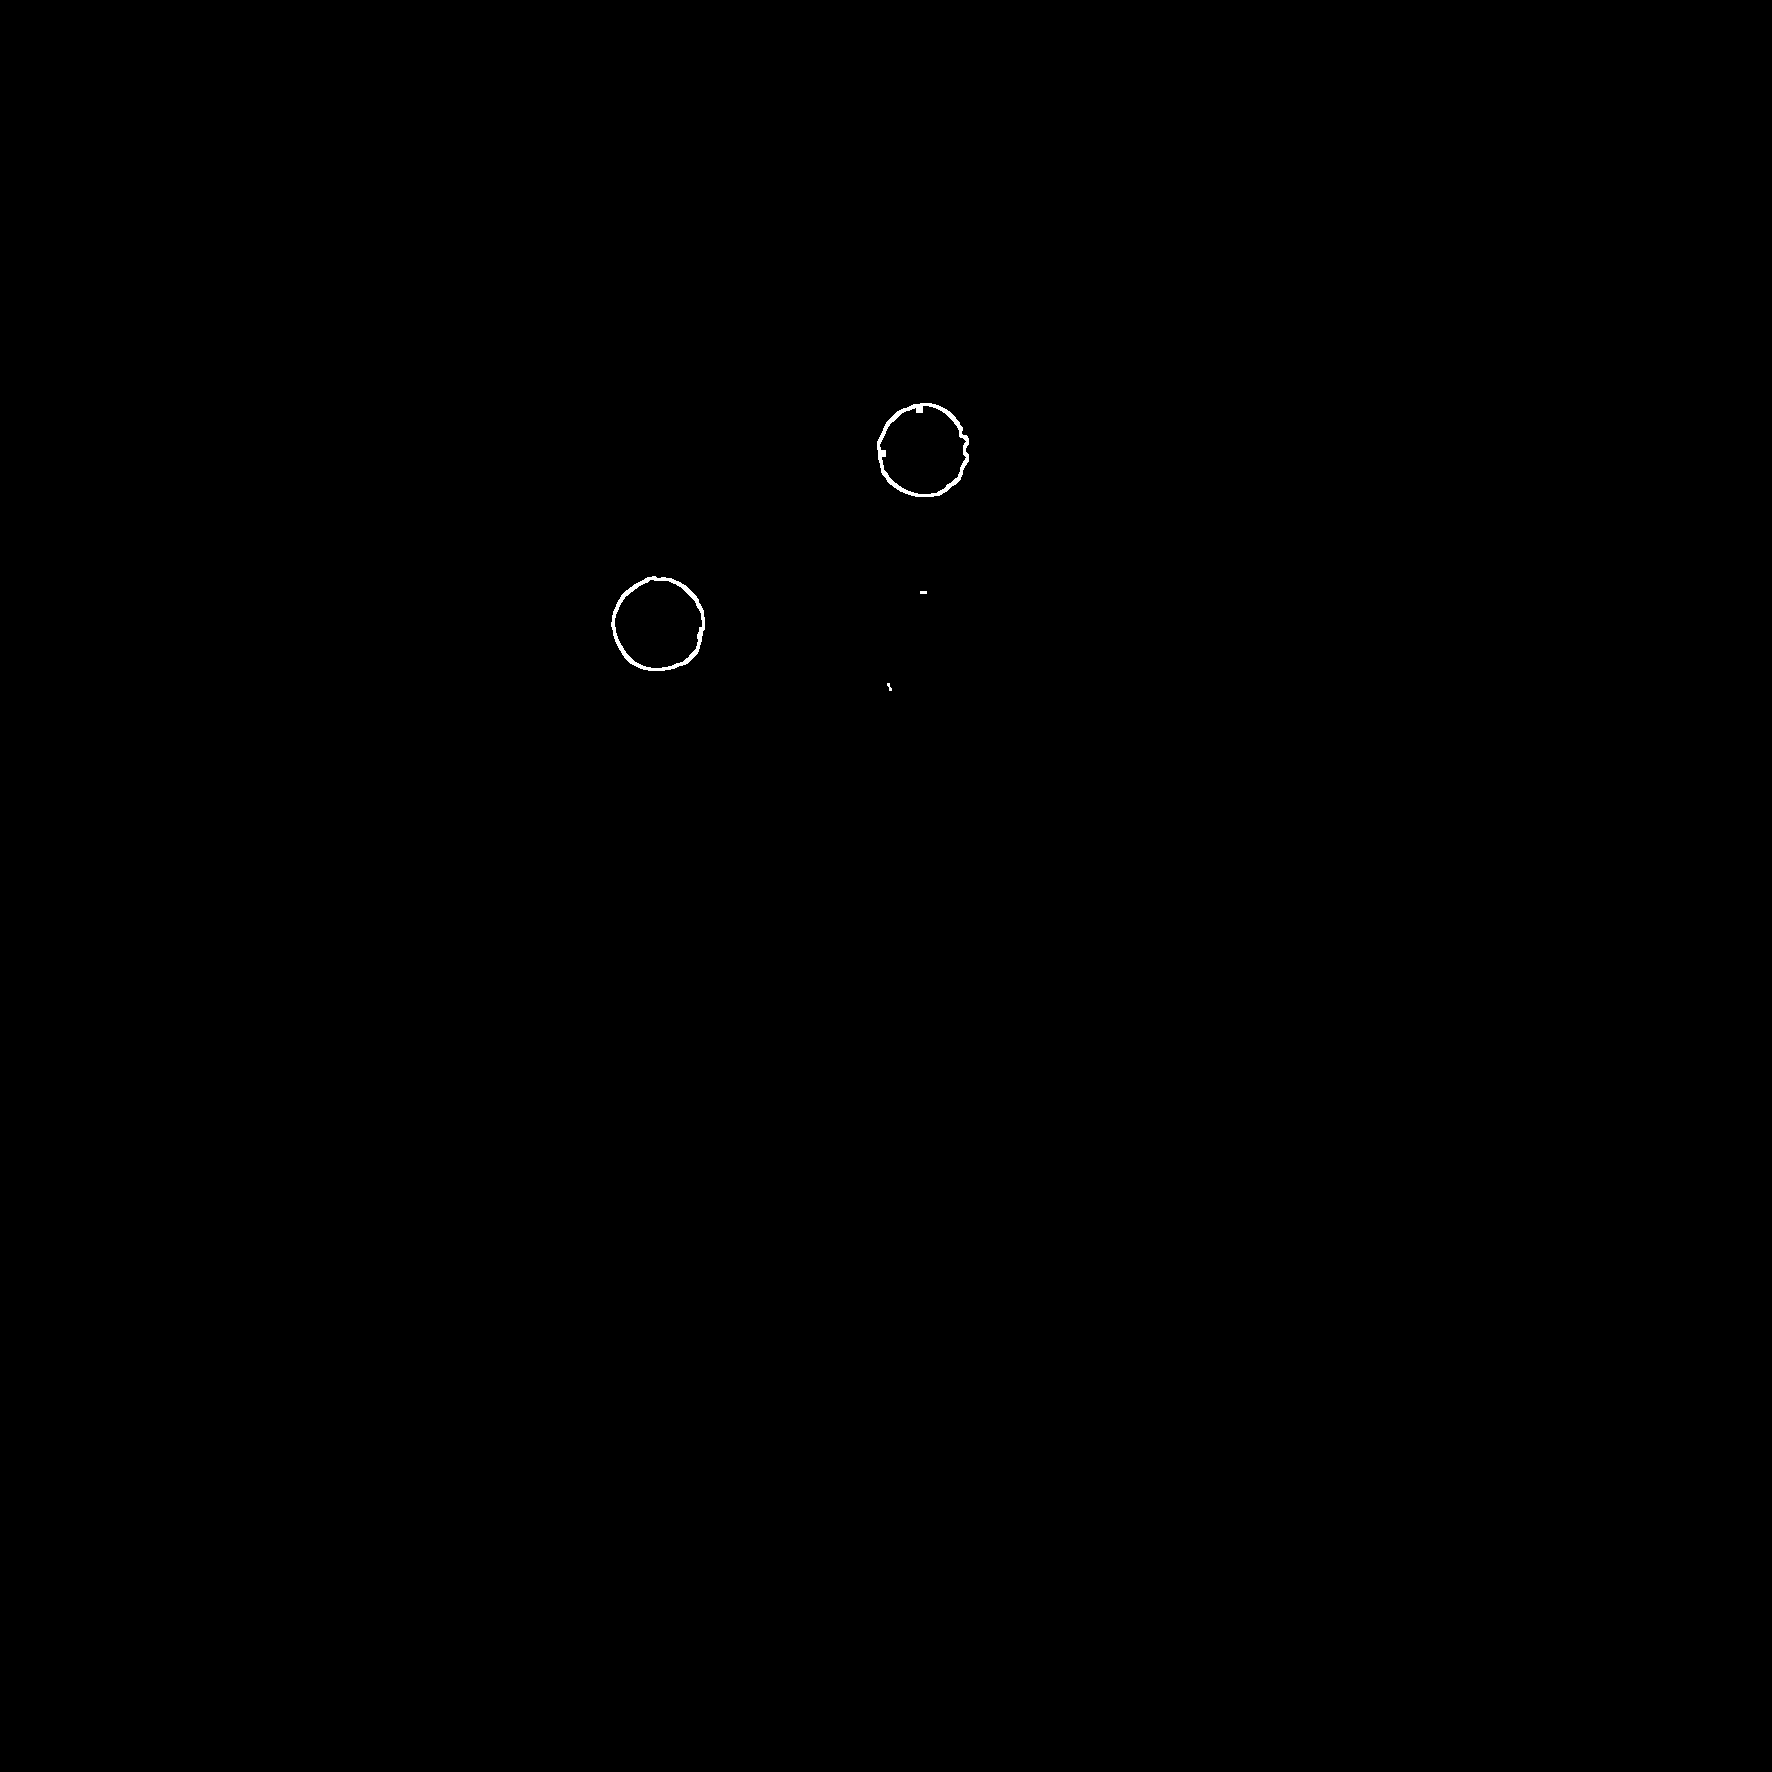

Liczba czarnych kropek: 2


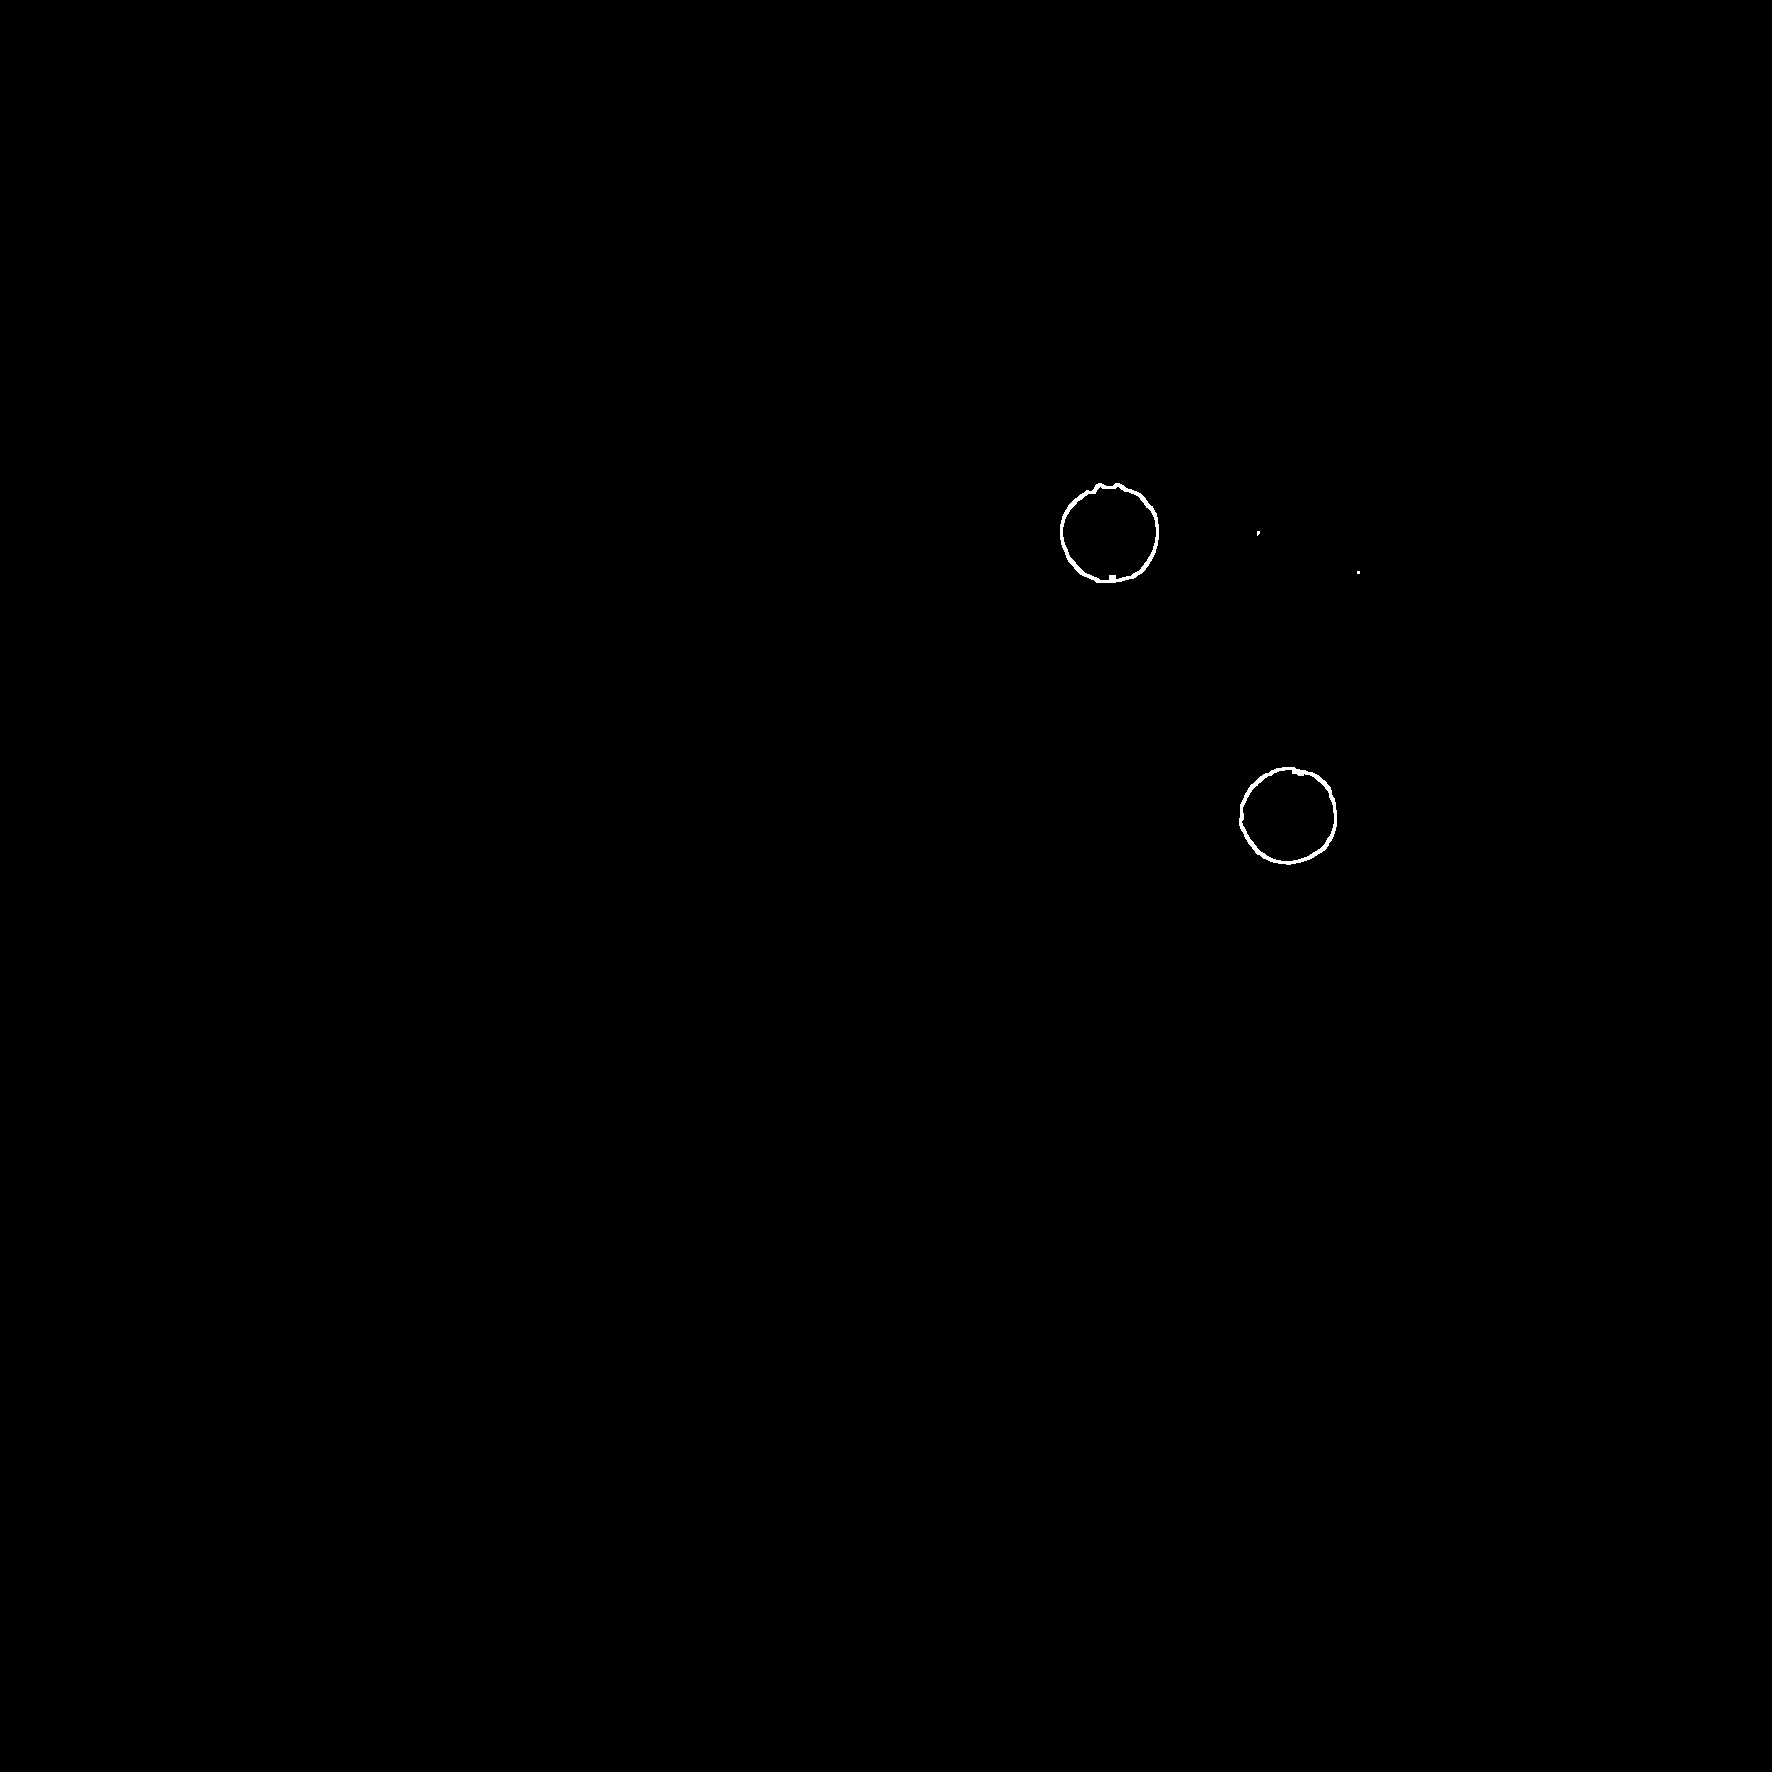

Liczba czarnych kropek: 2


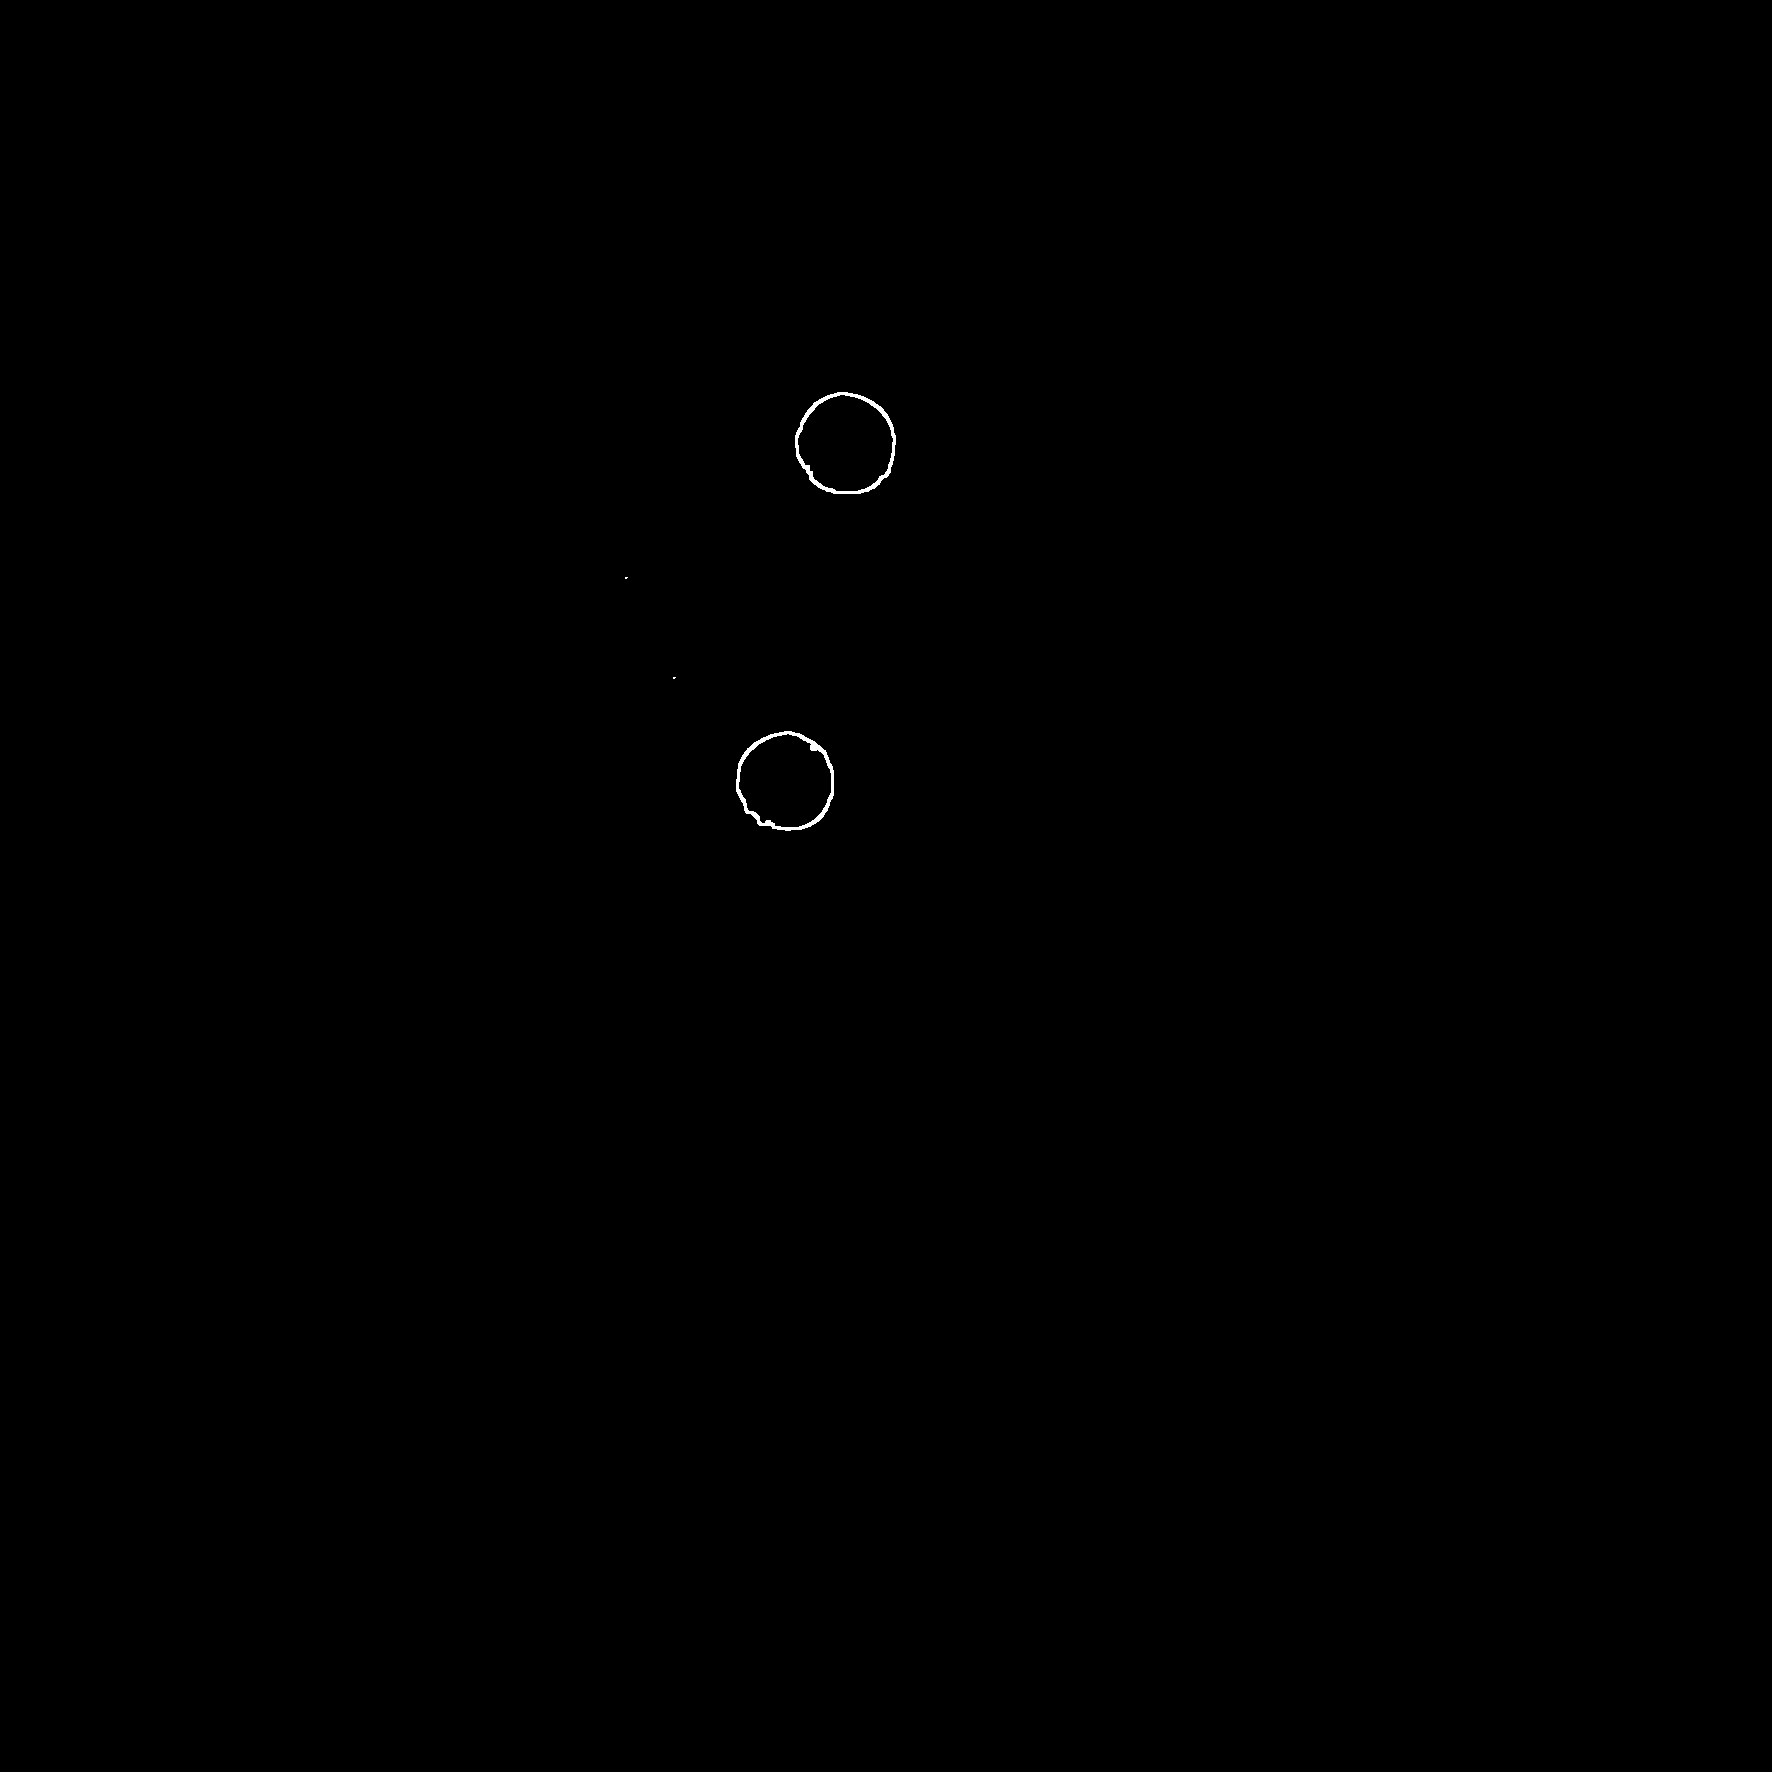

Liczba czarnych kropek: 2


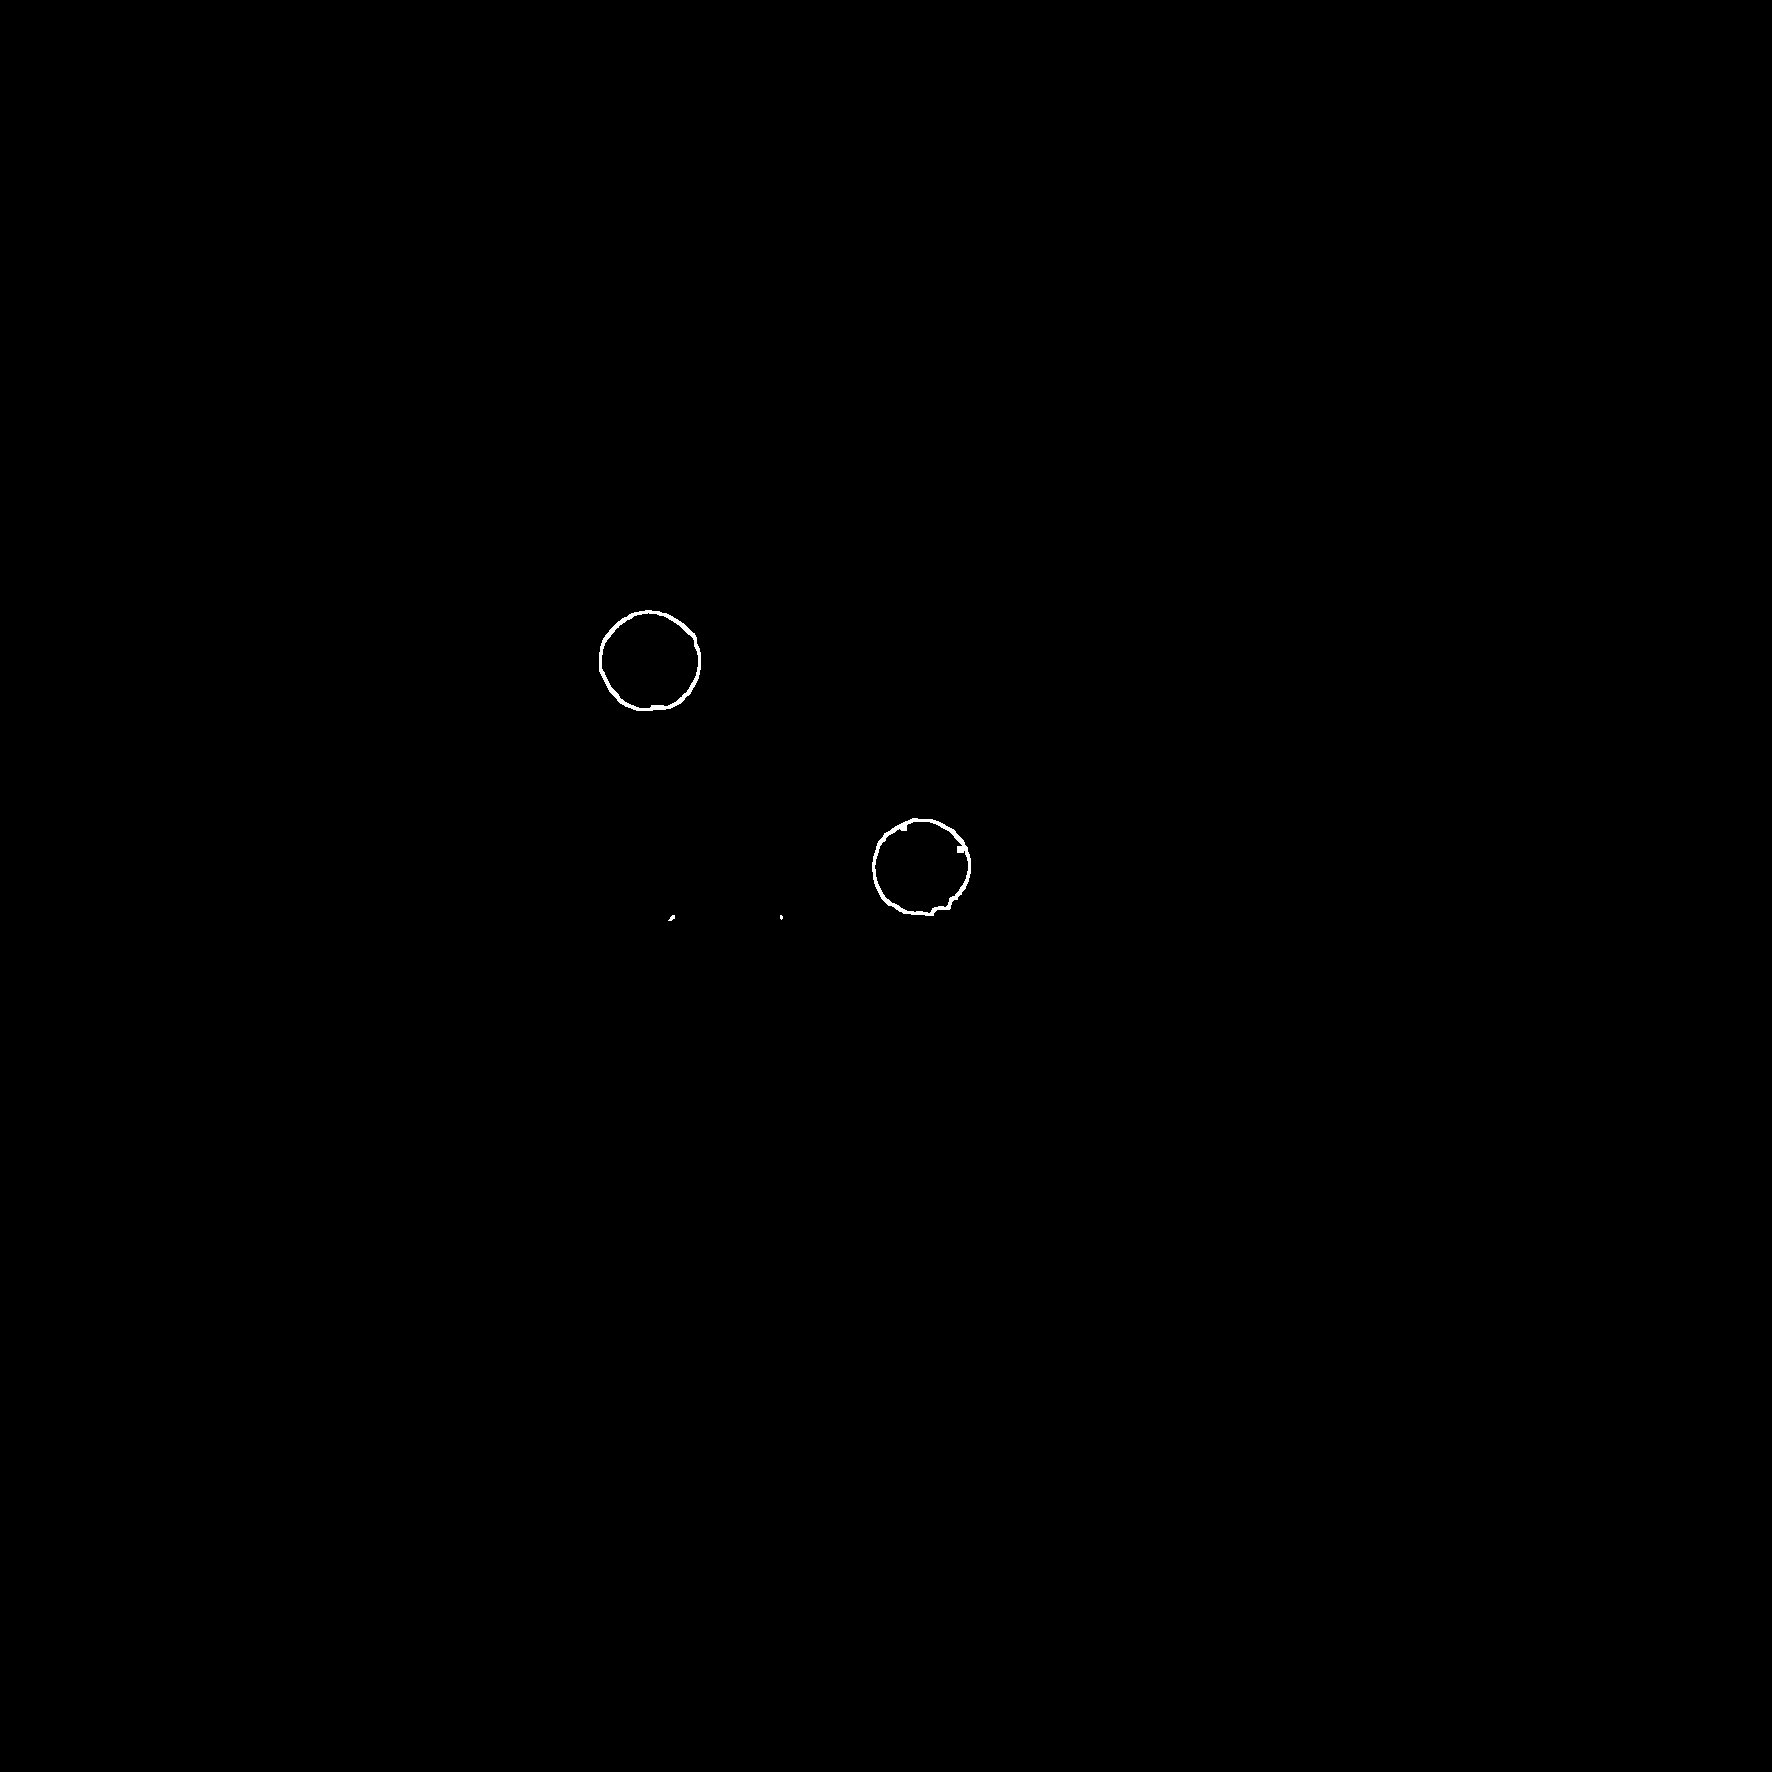

Liczba czarnych kropek: 2


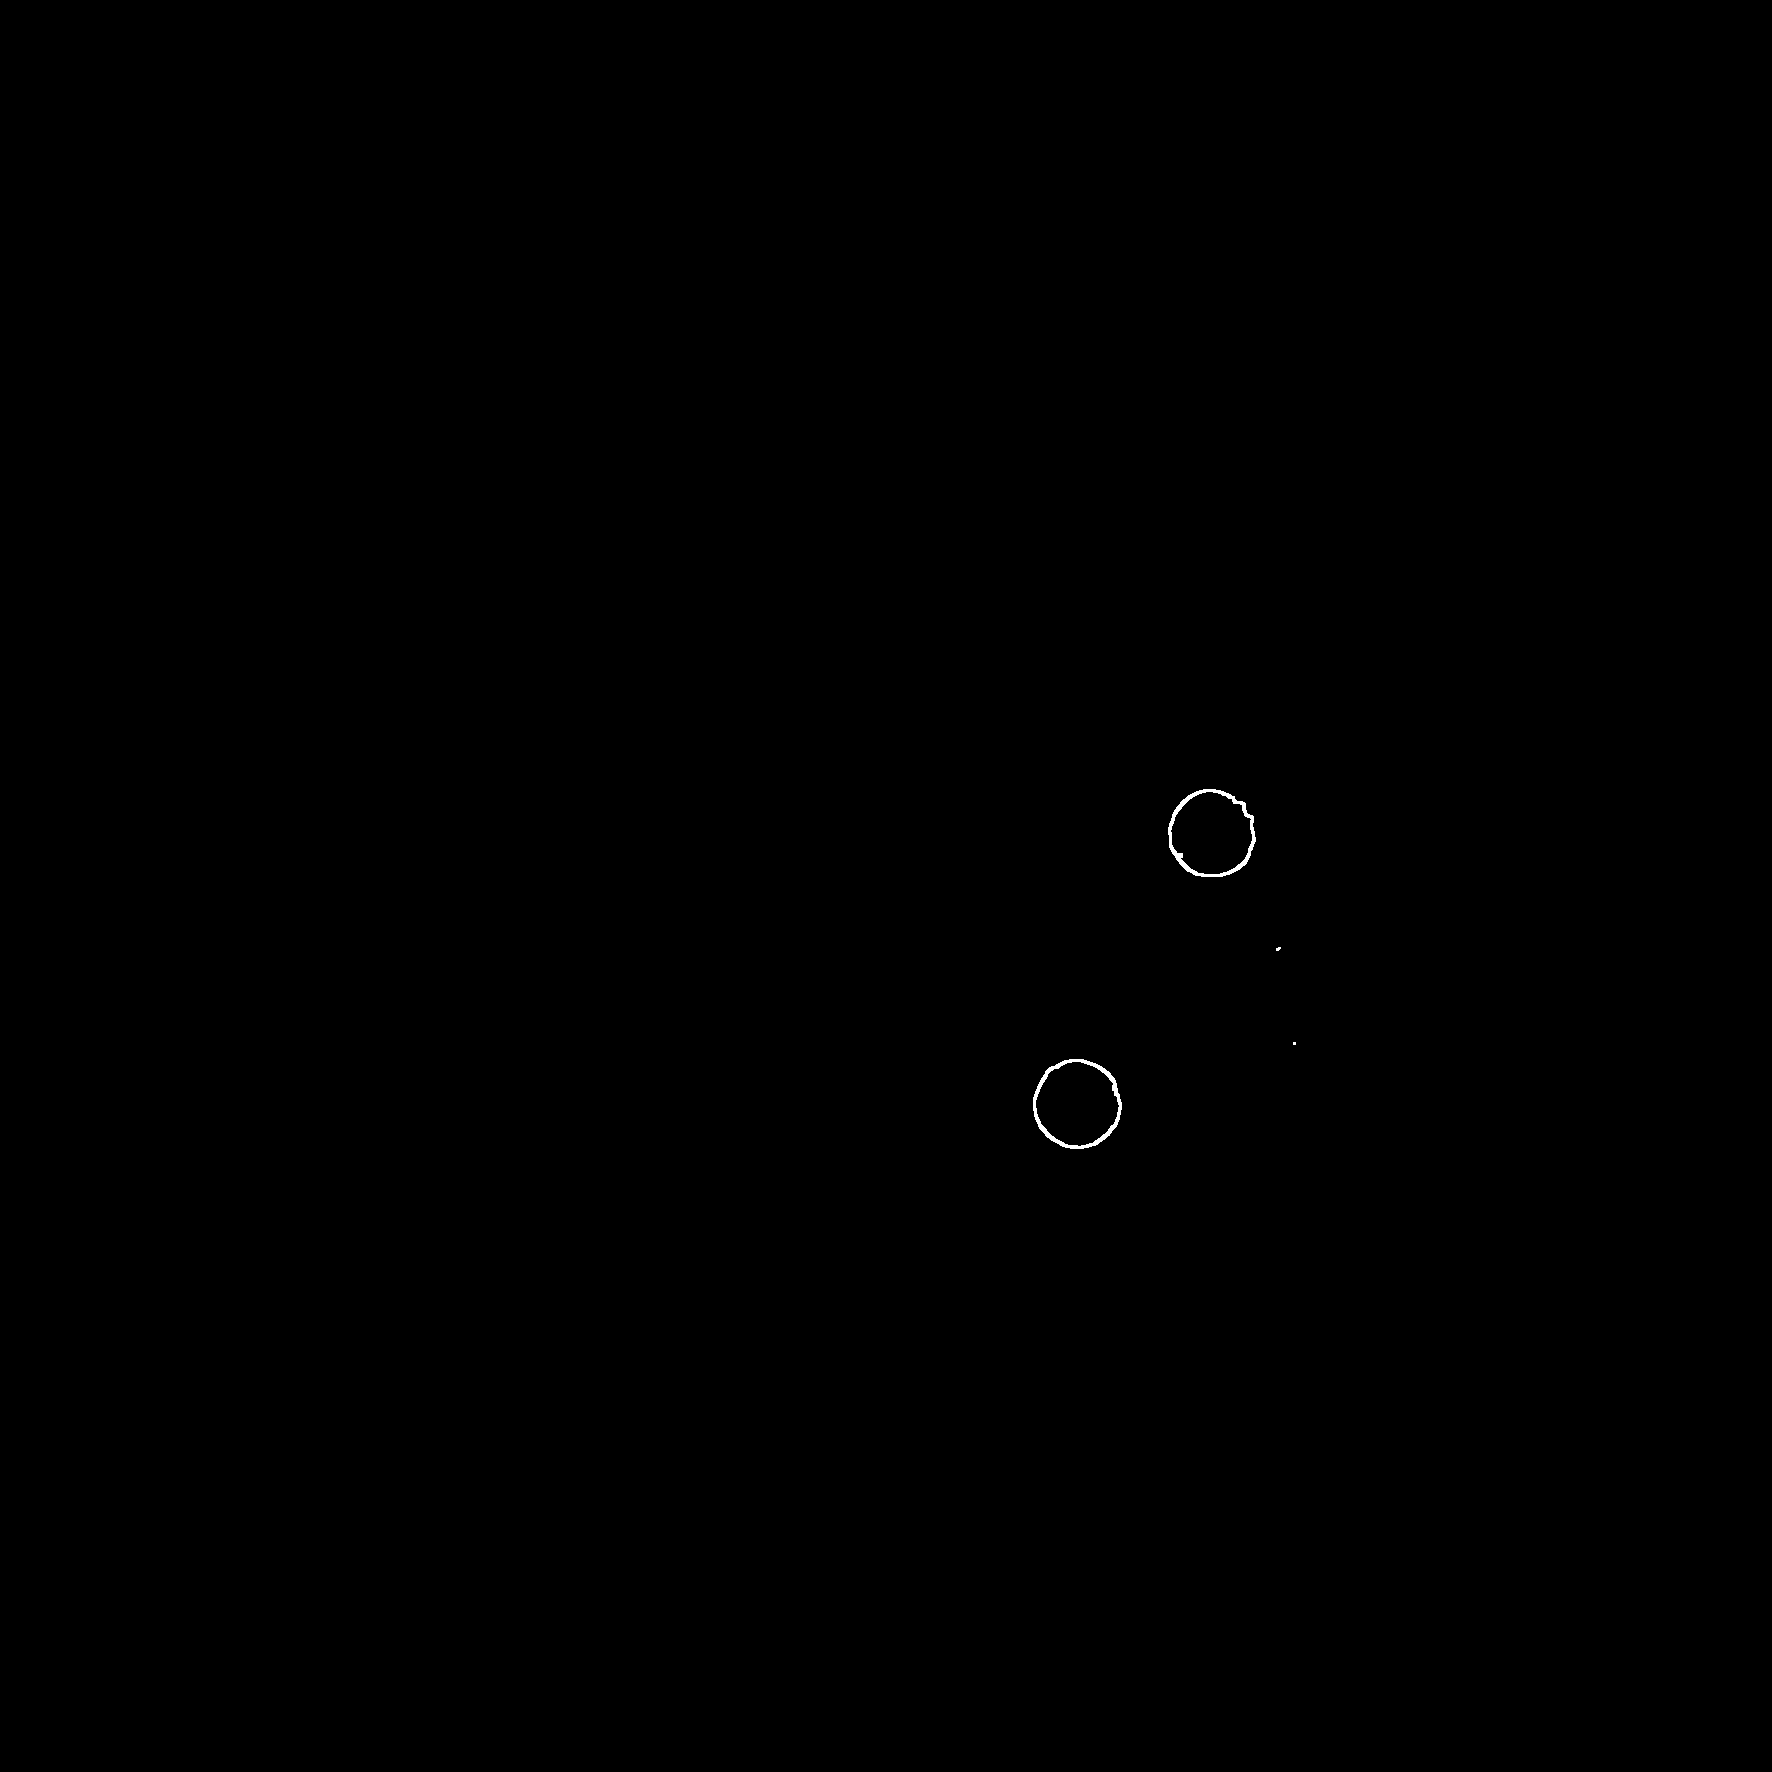

Liczba czarnych kropek: 2


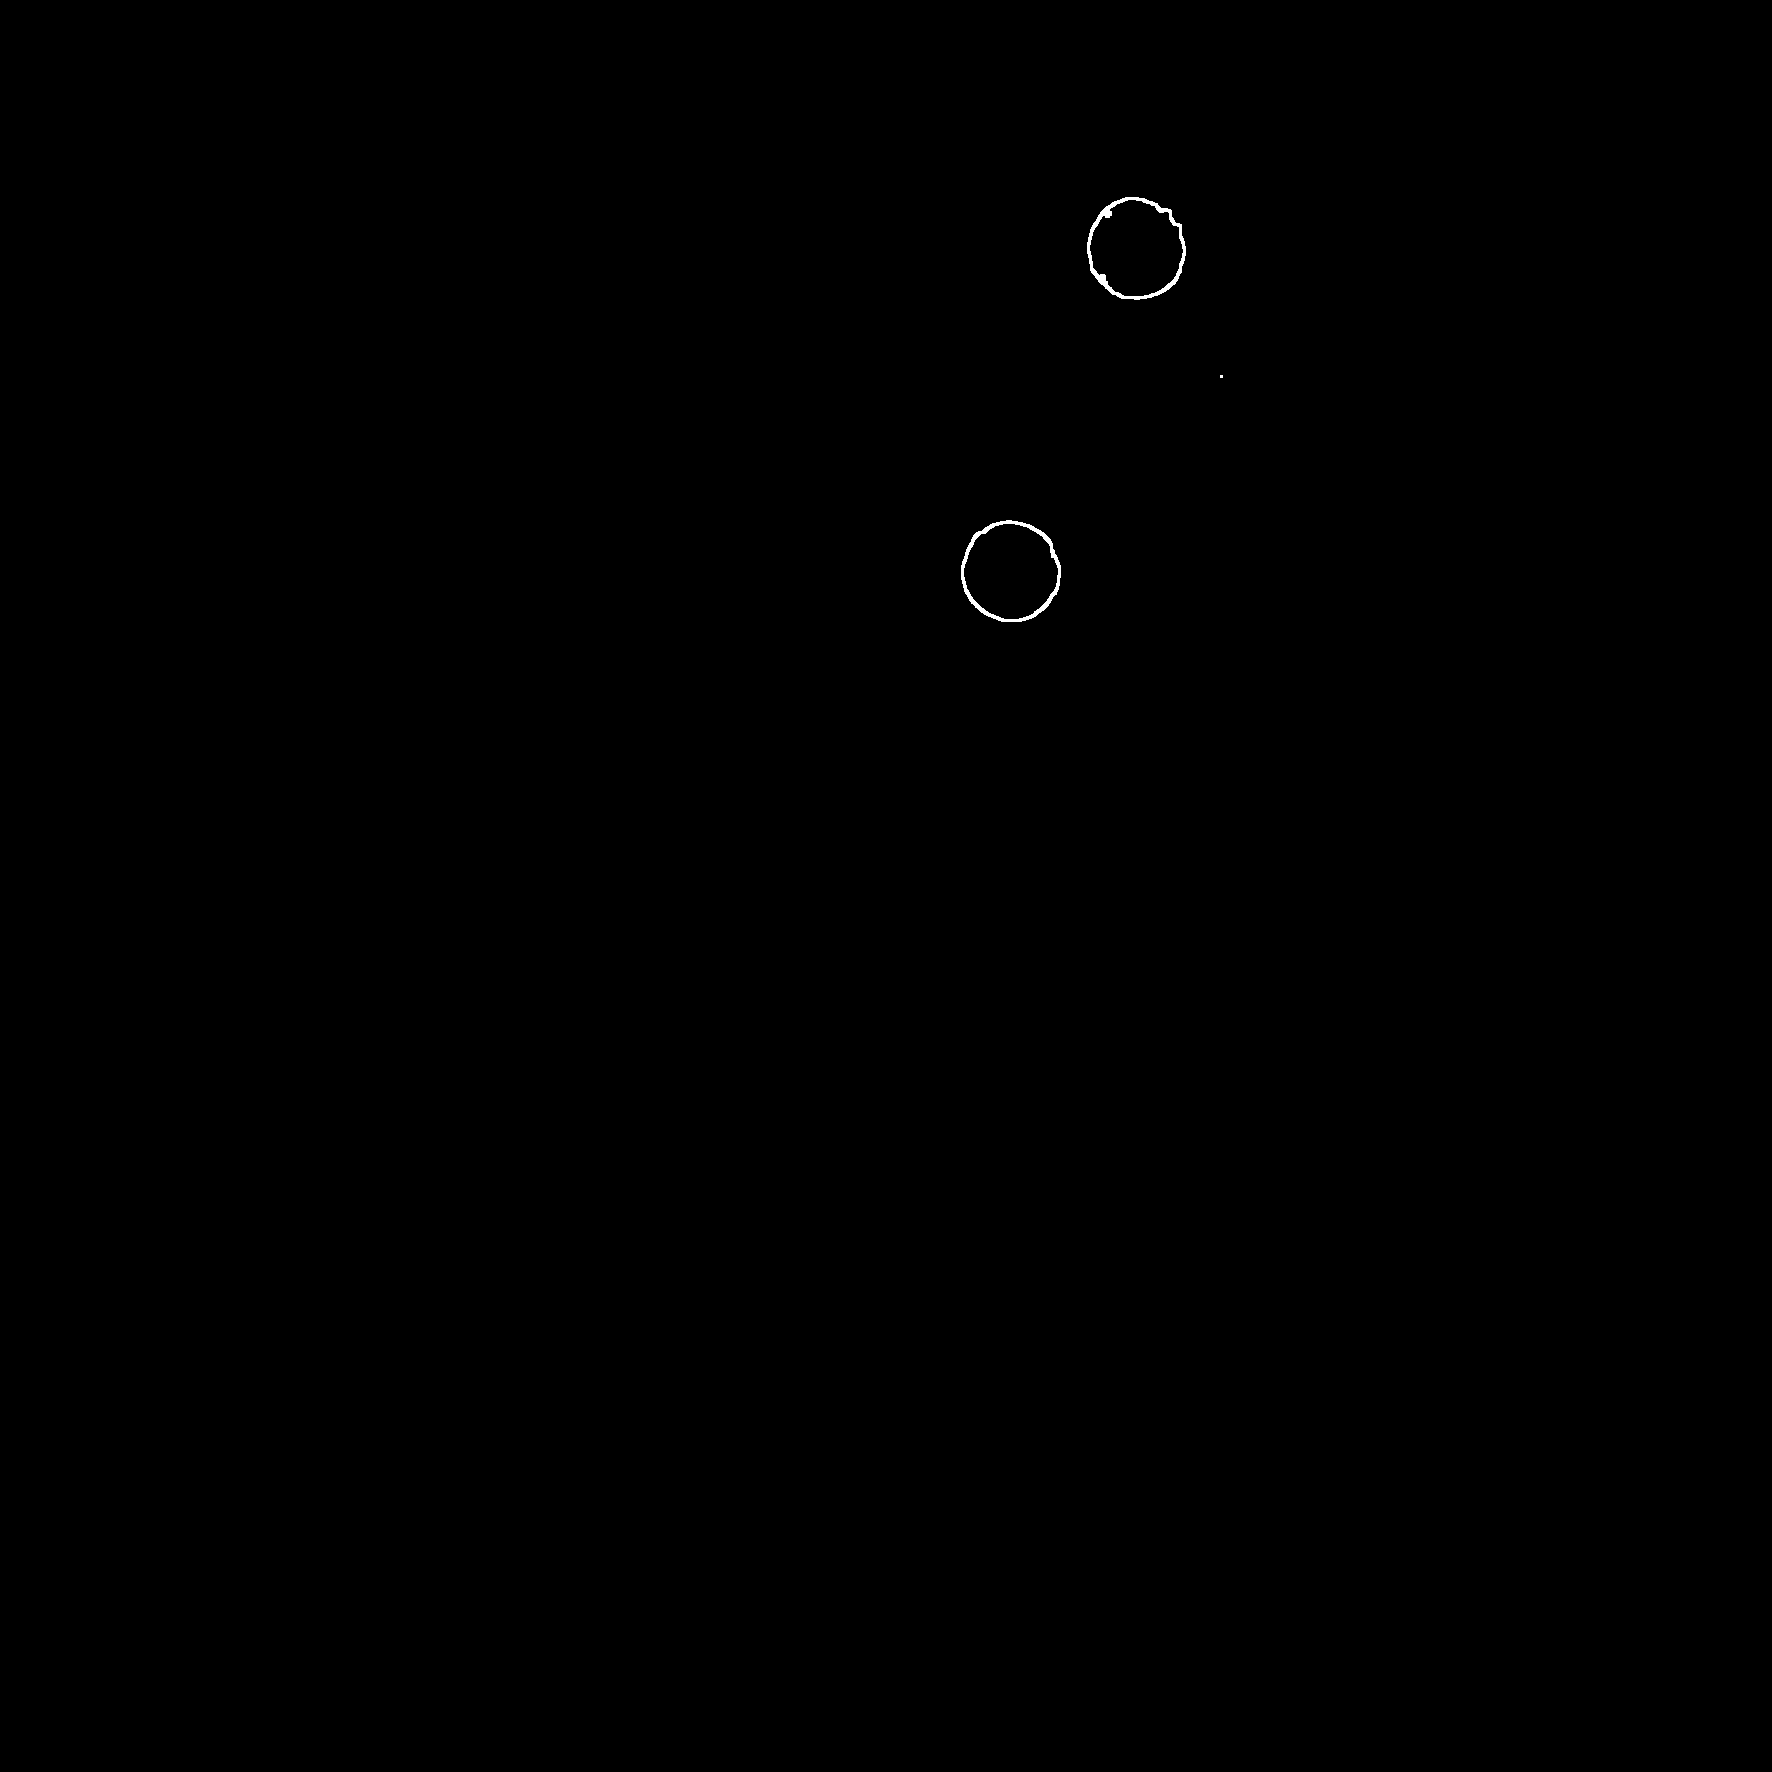

Liczba czarnych kropek: 2


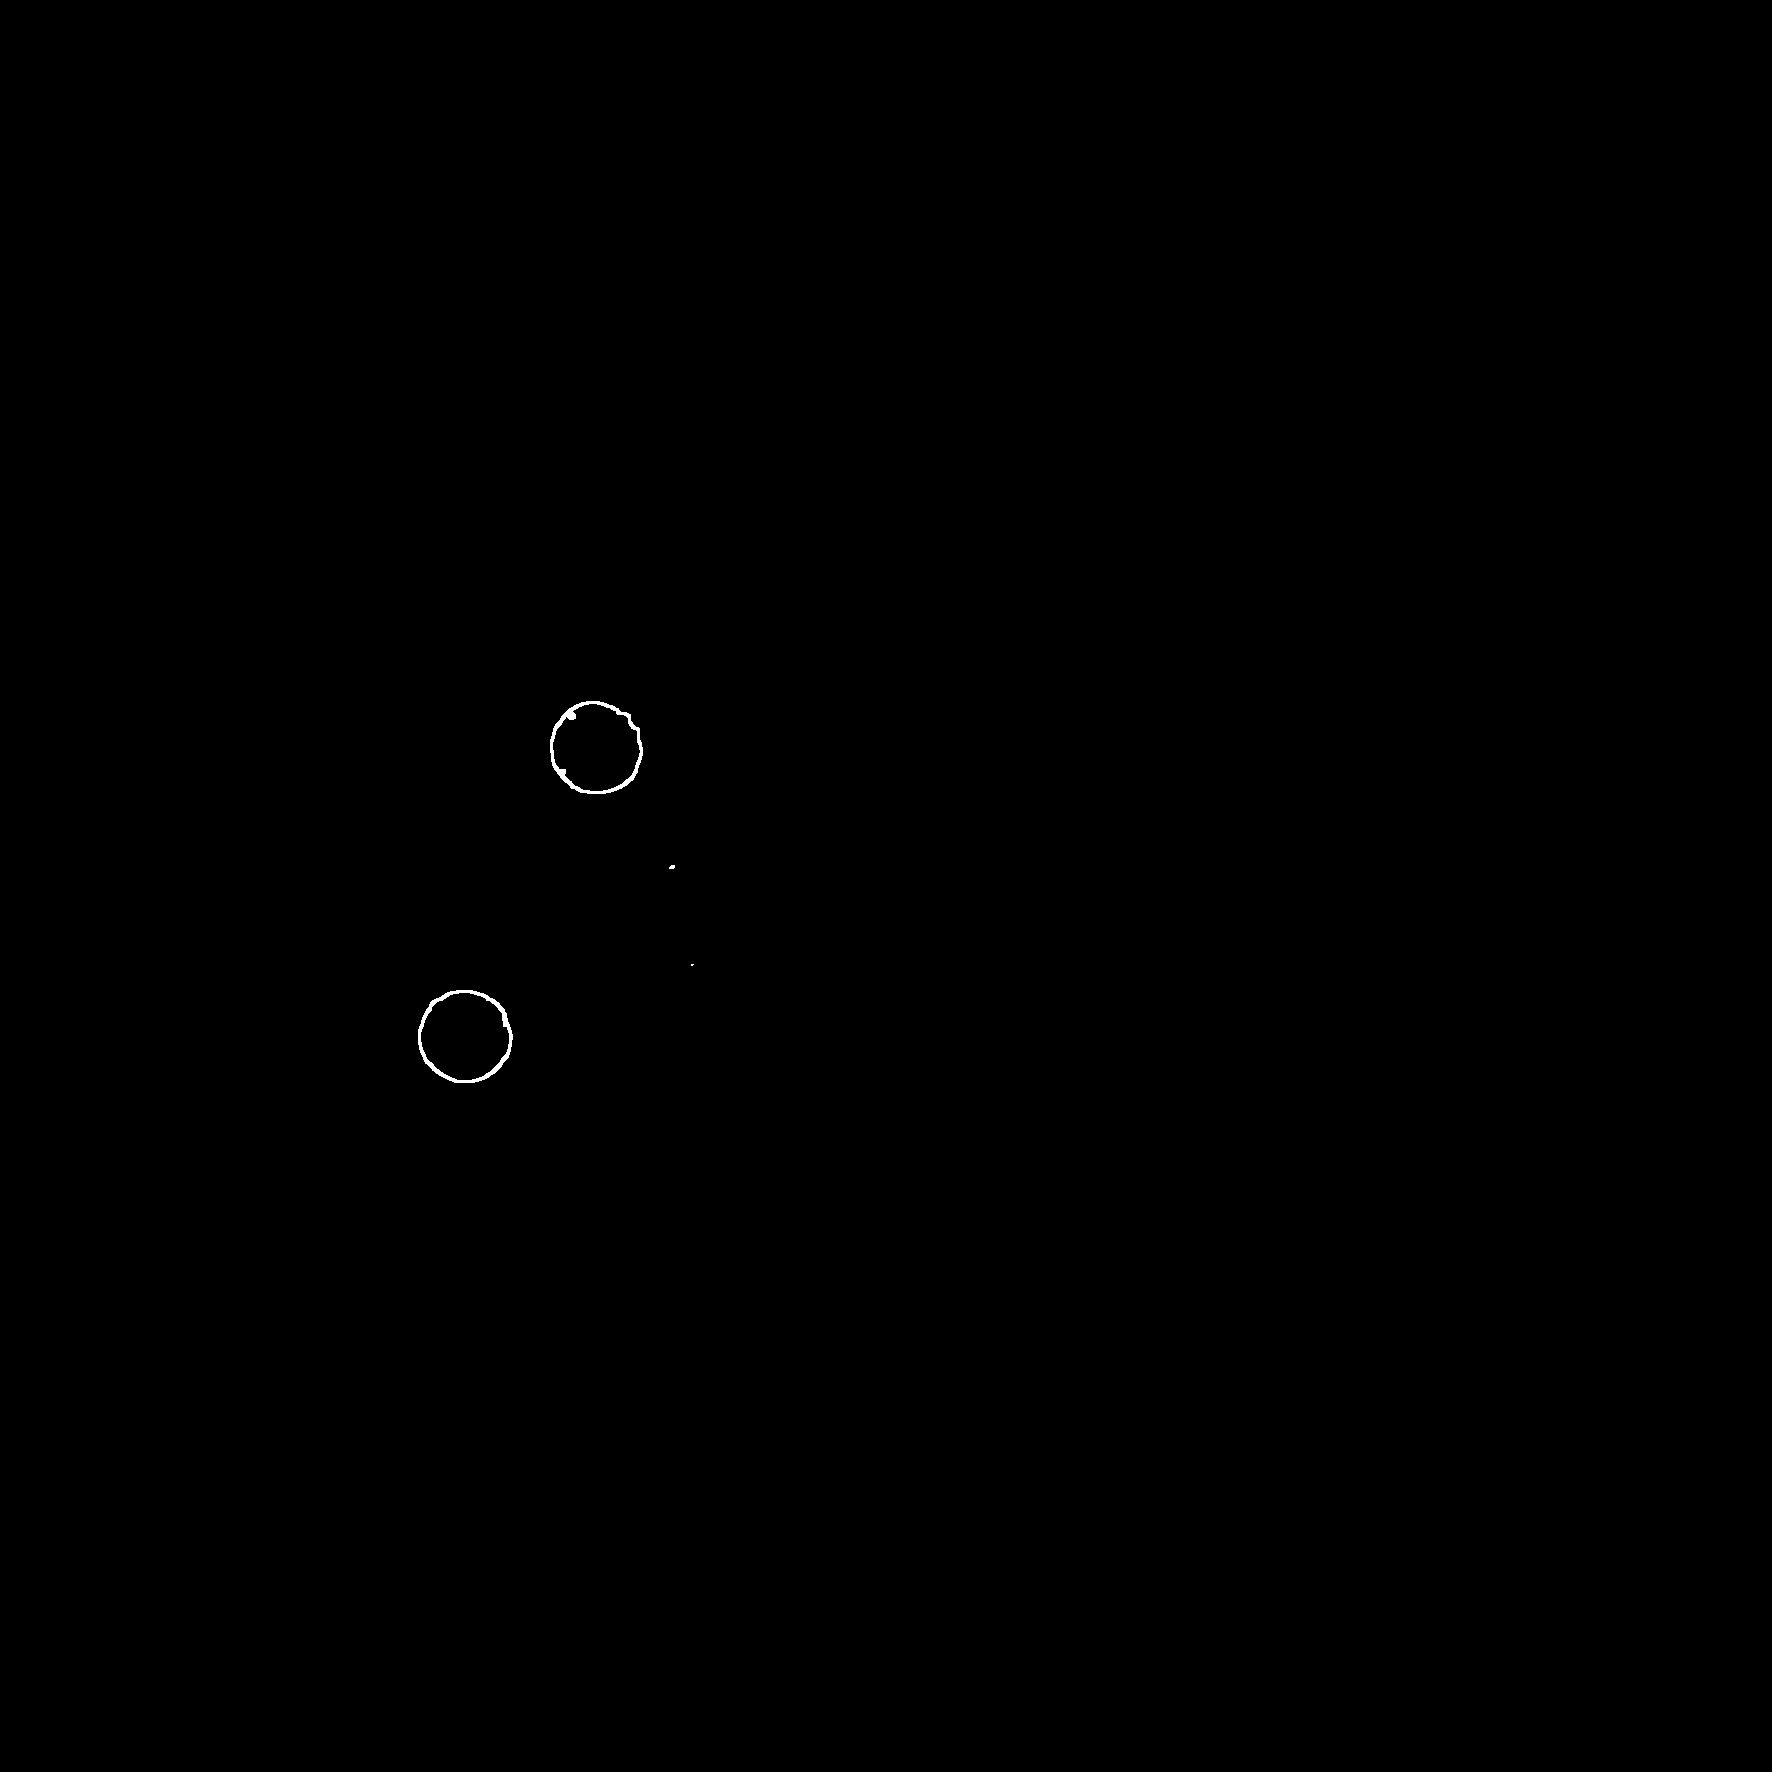

Liczba czarnych kropek: 2


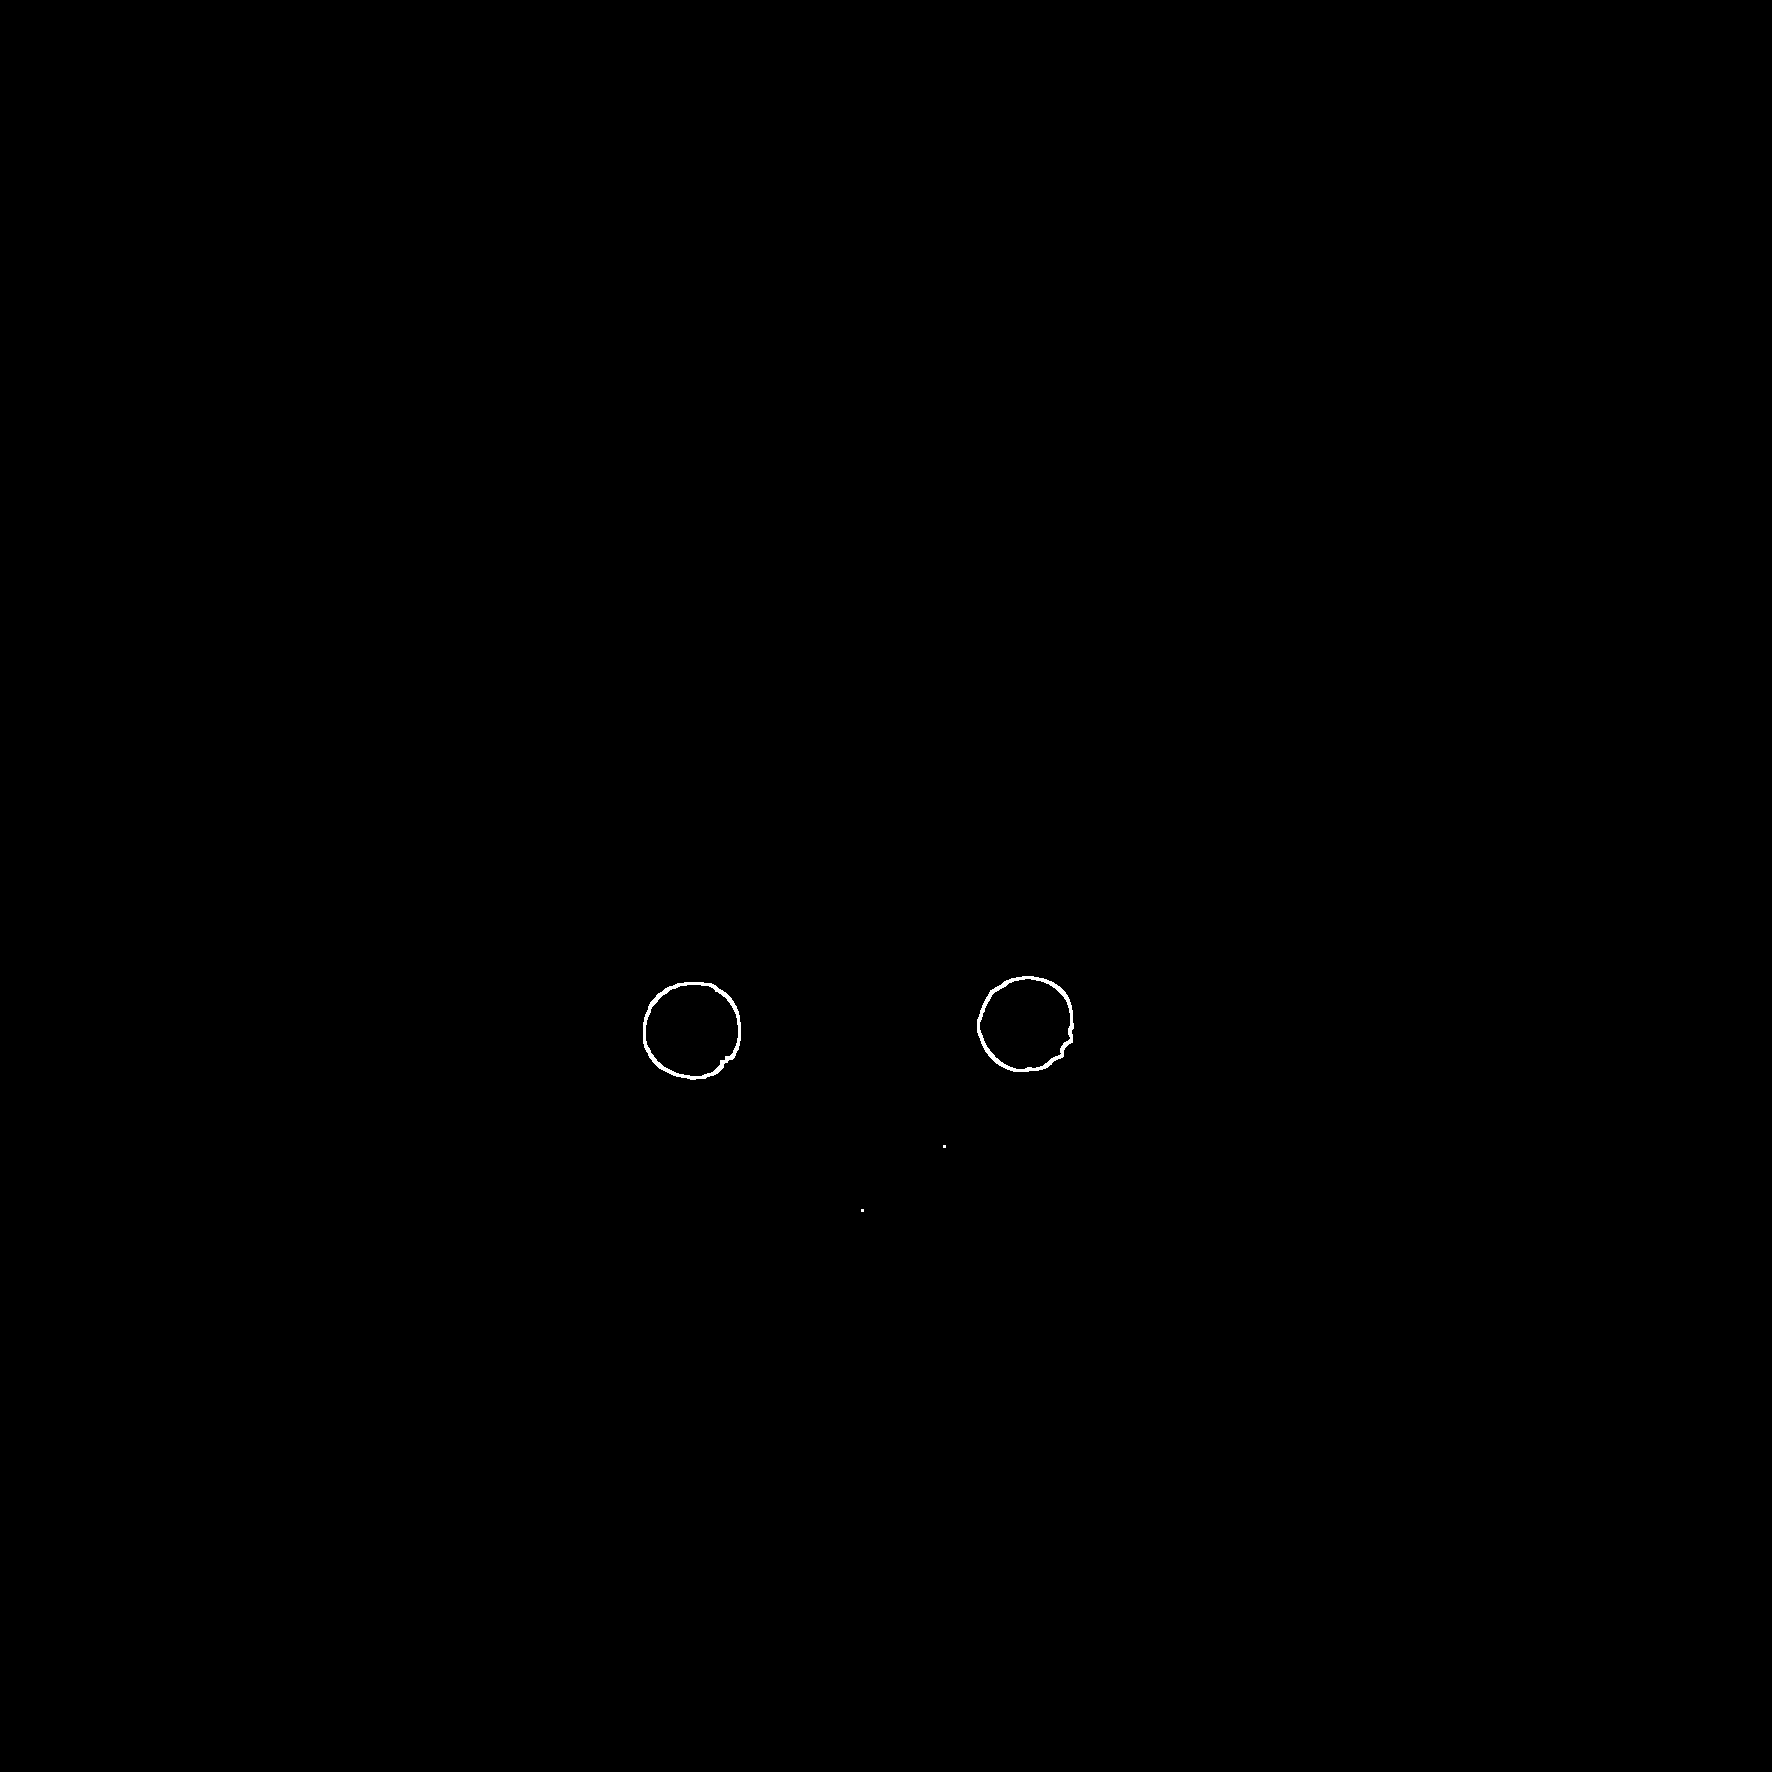

Liczba czarnych kropek: 2


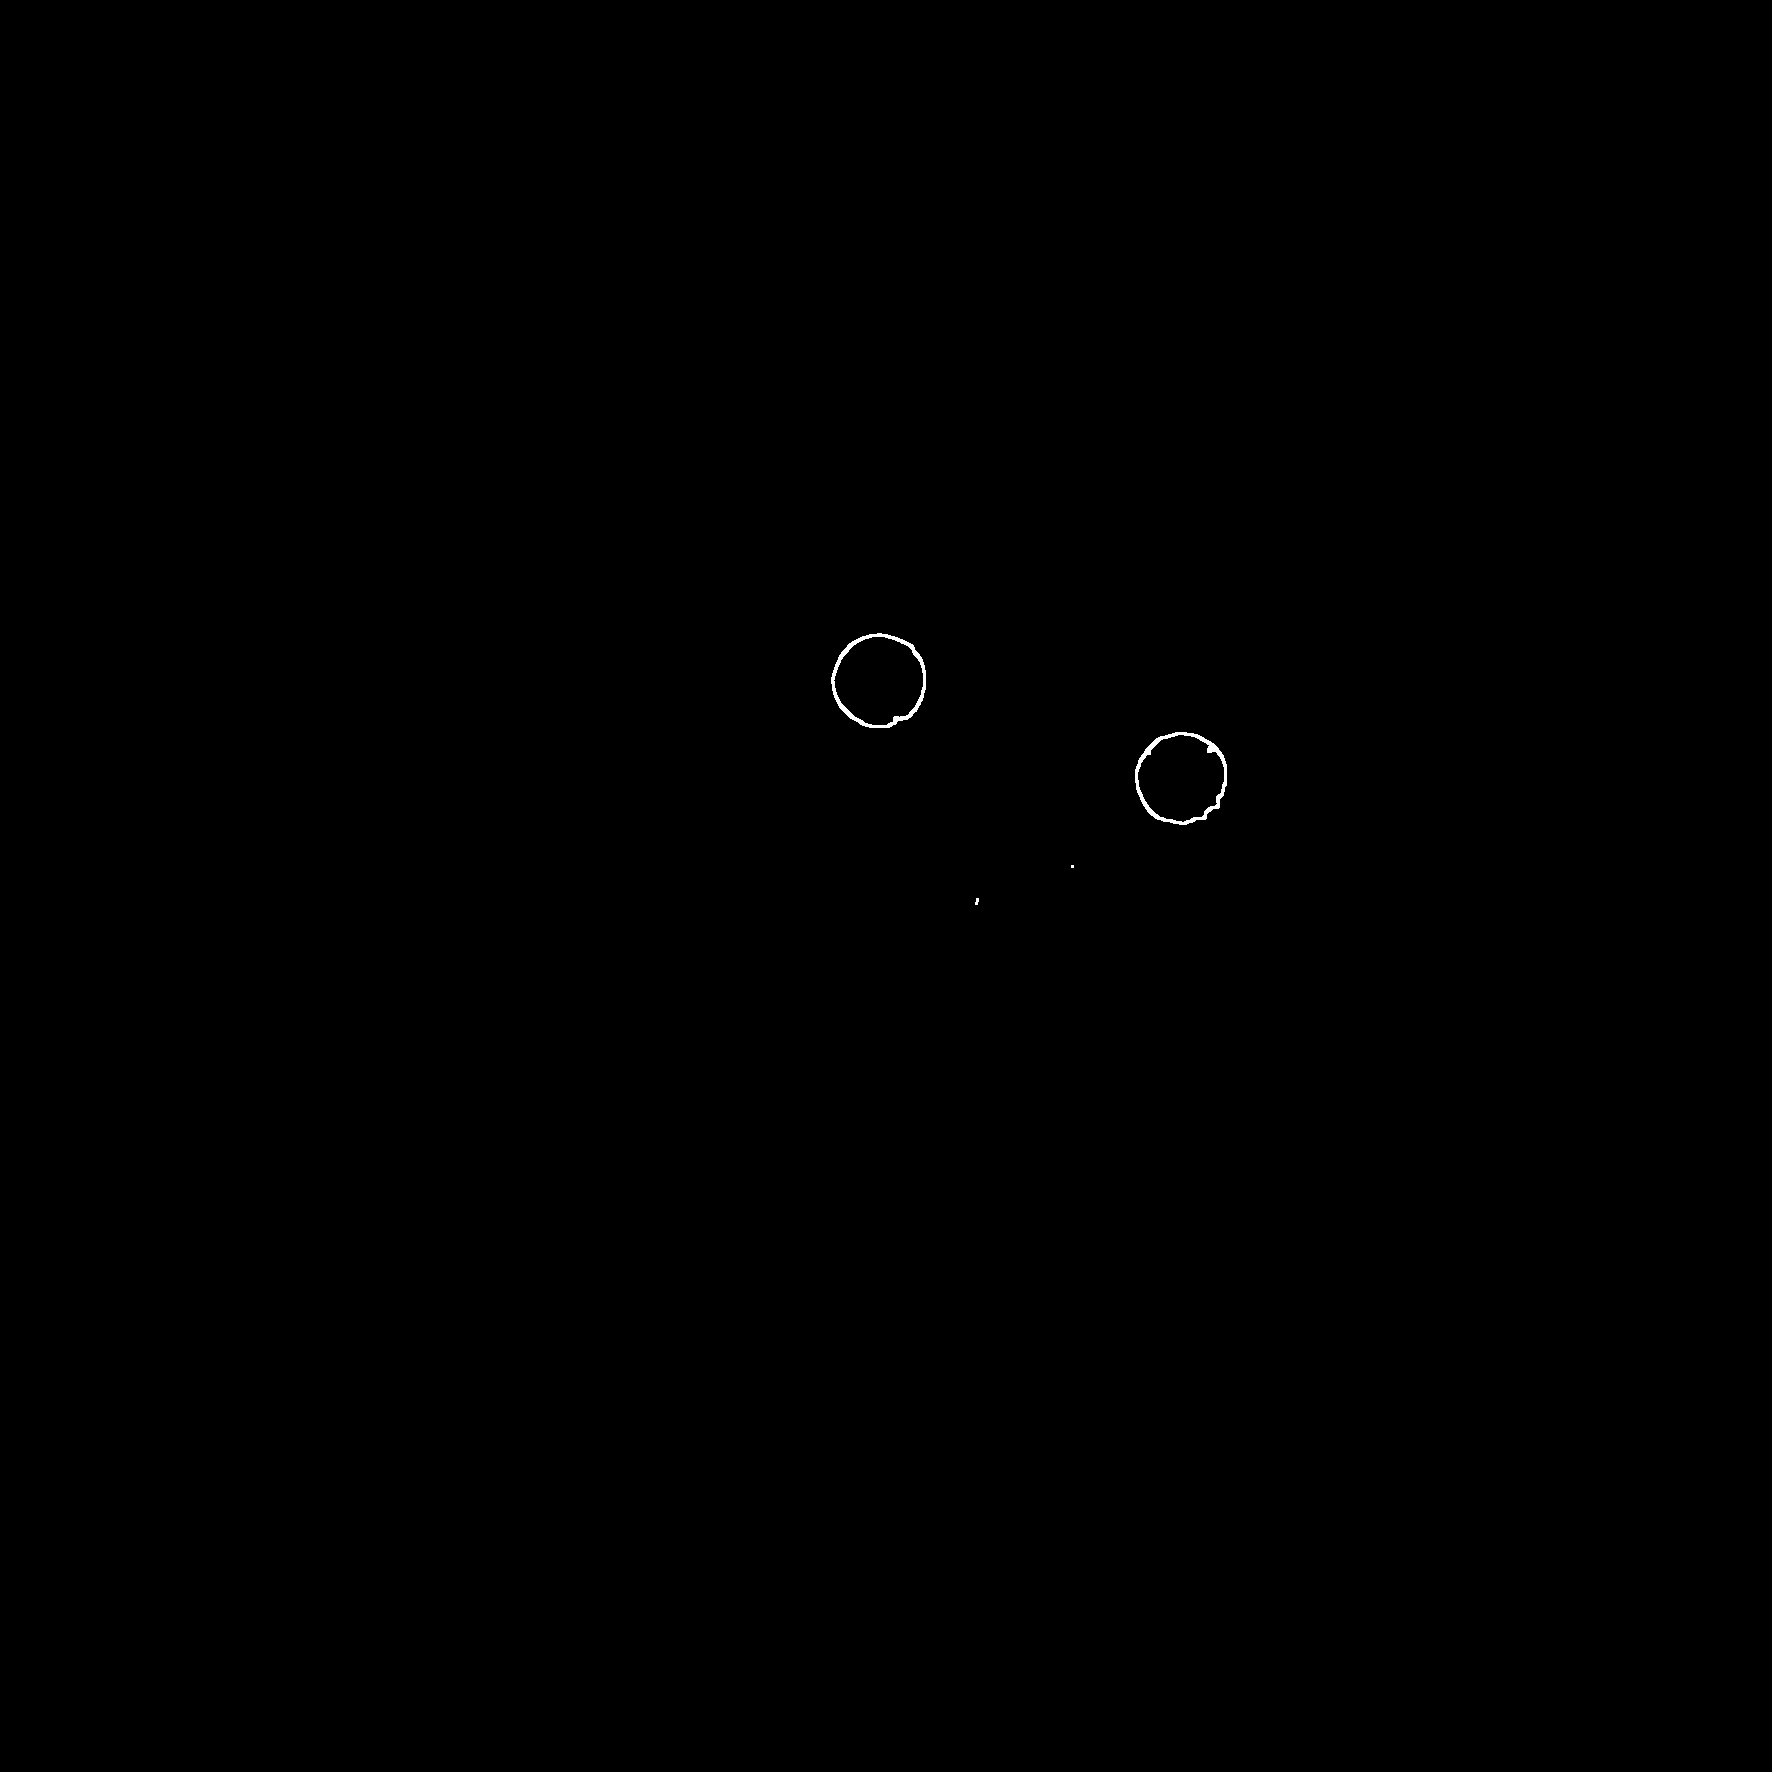

Liczba czarnych kropek: 2


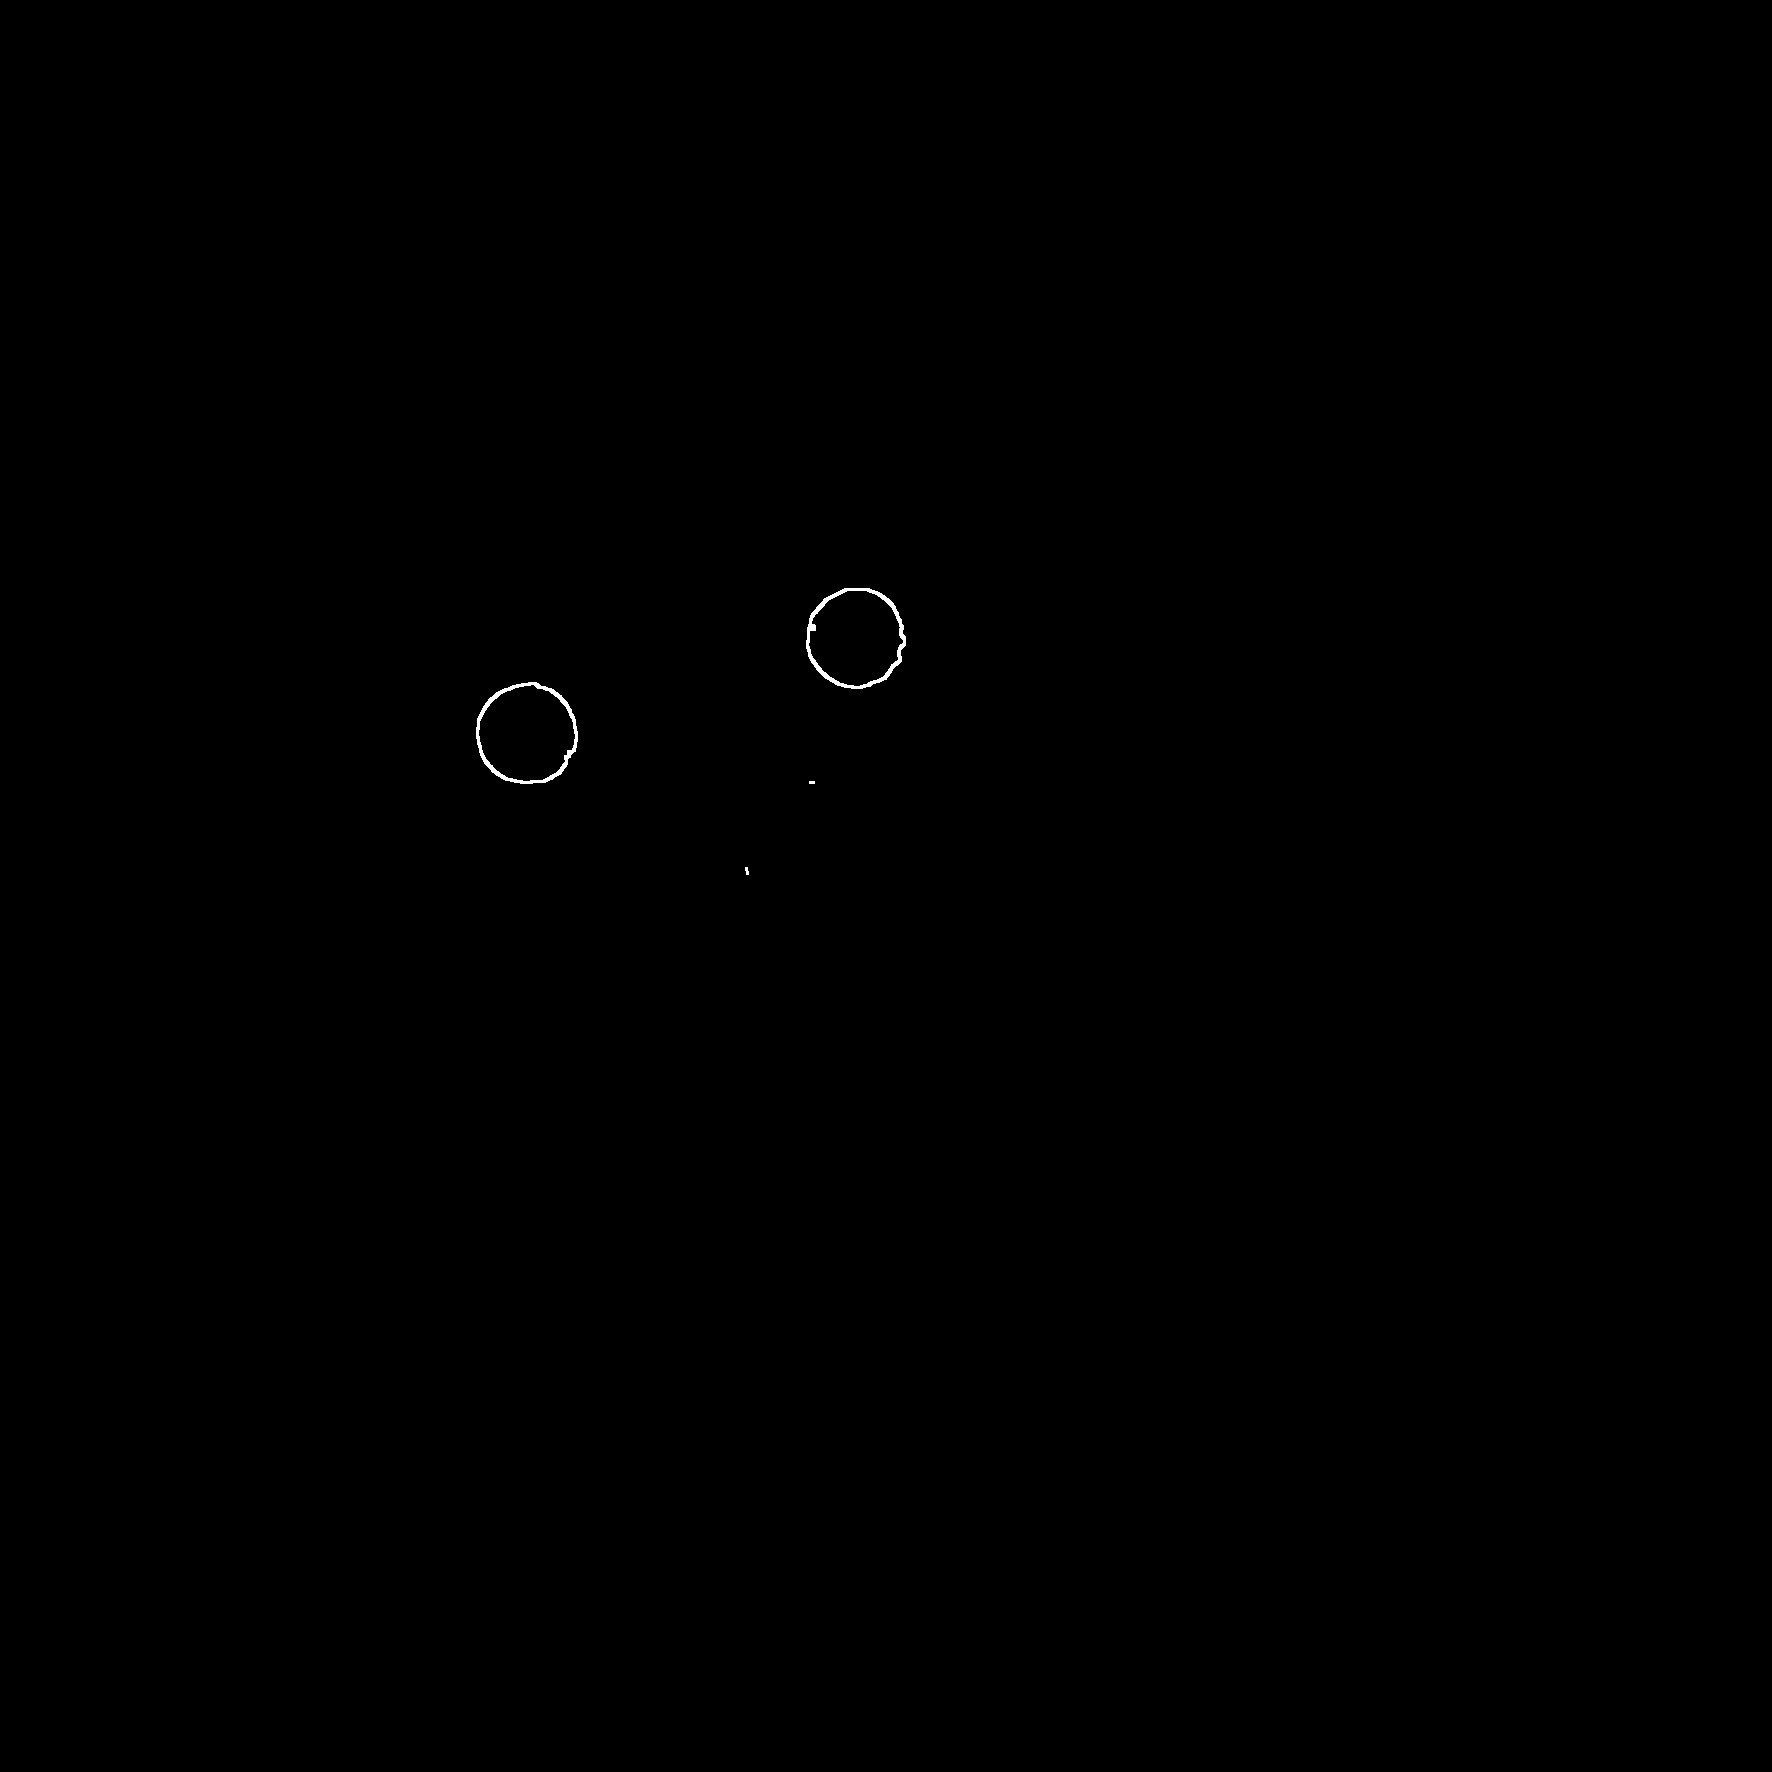

Liczba czarnych kropek: 2


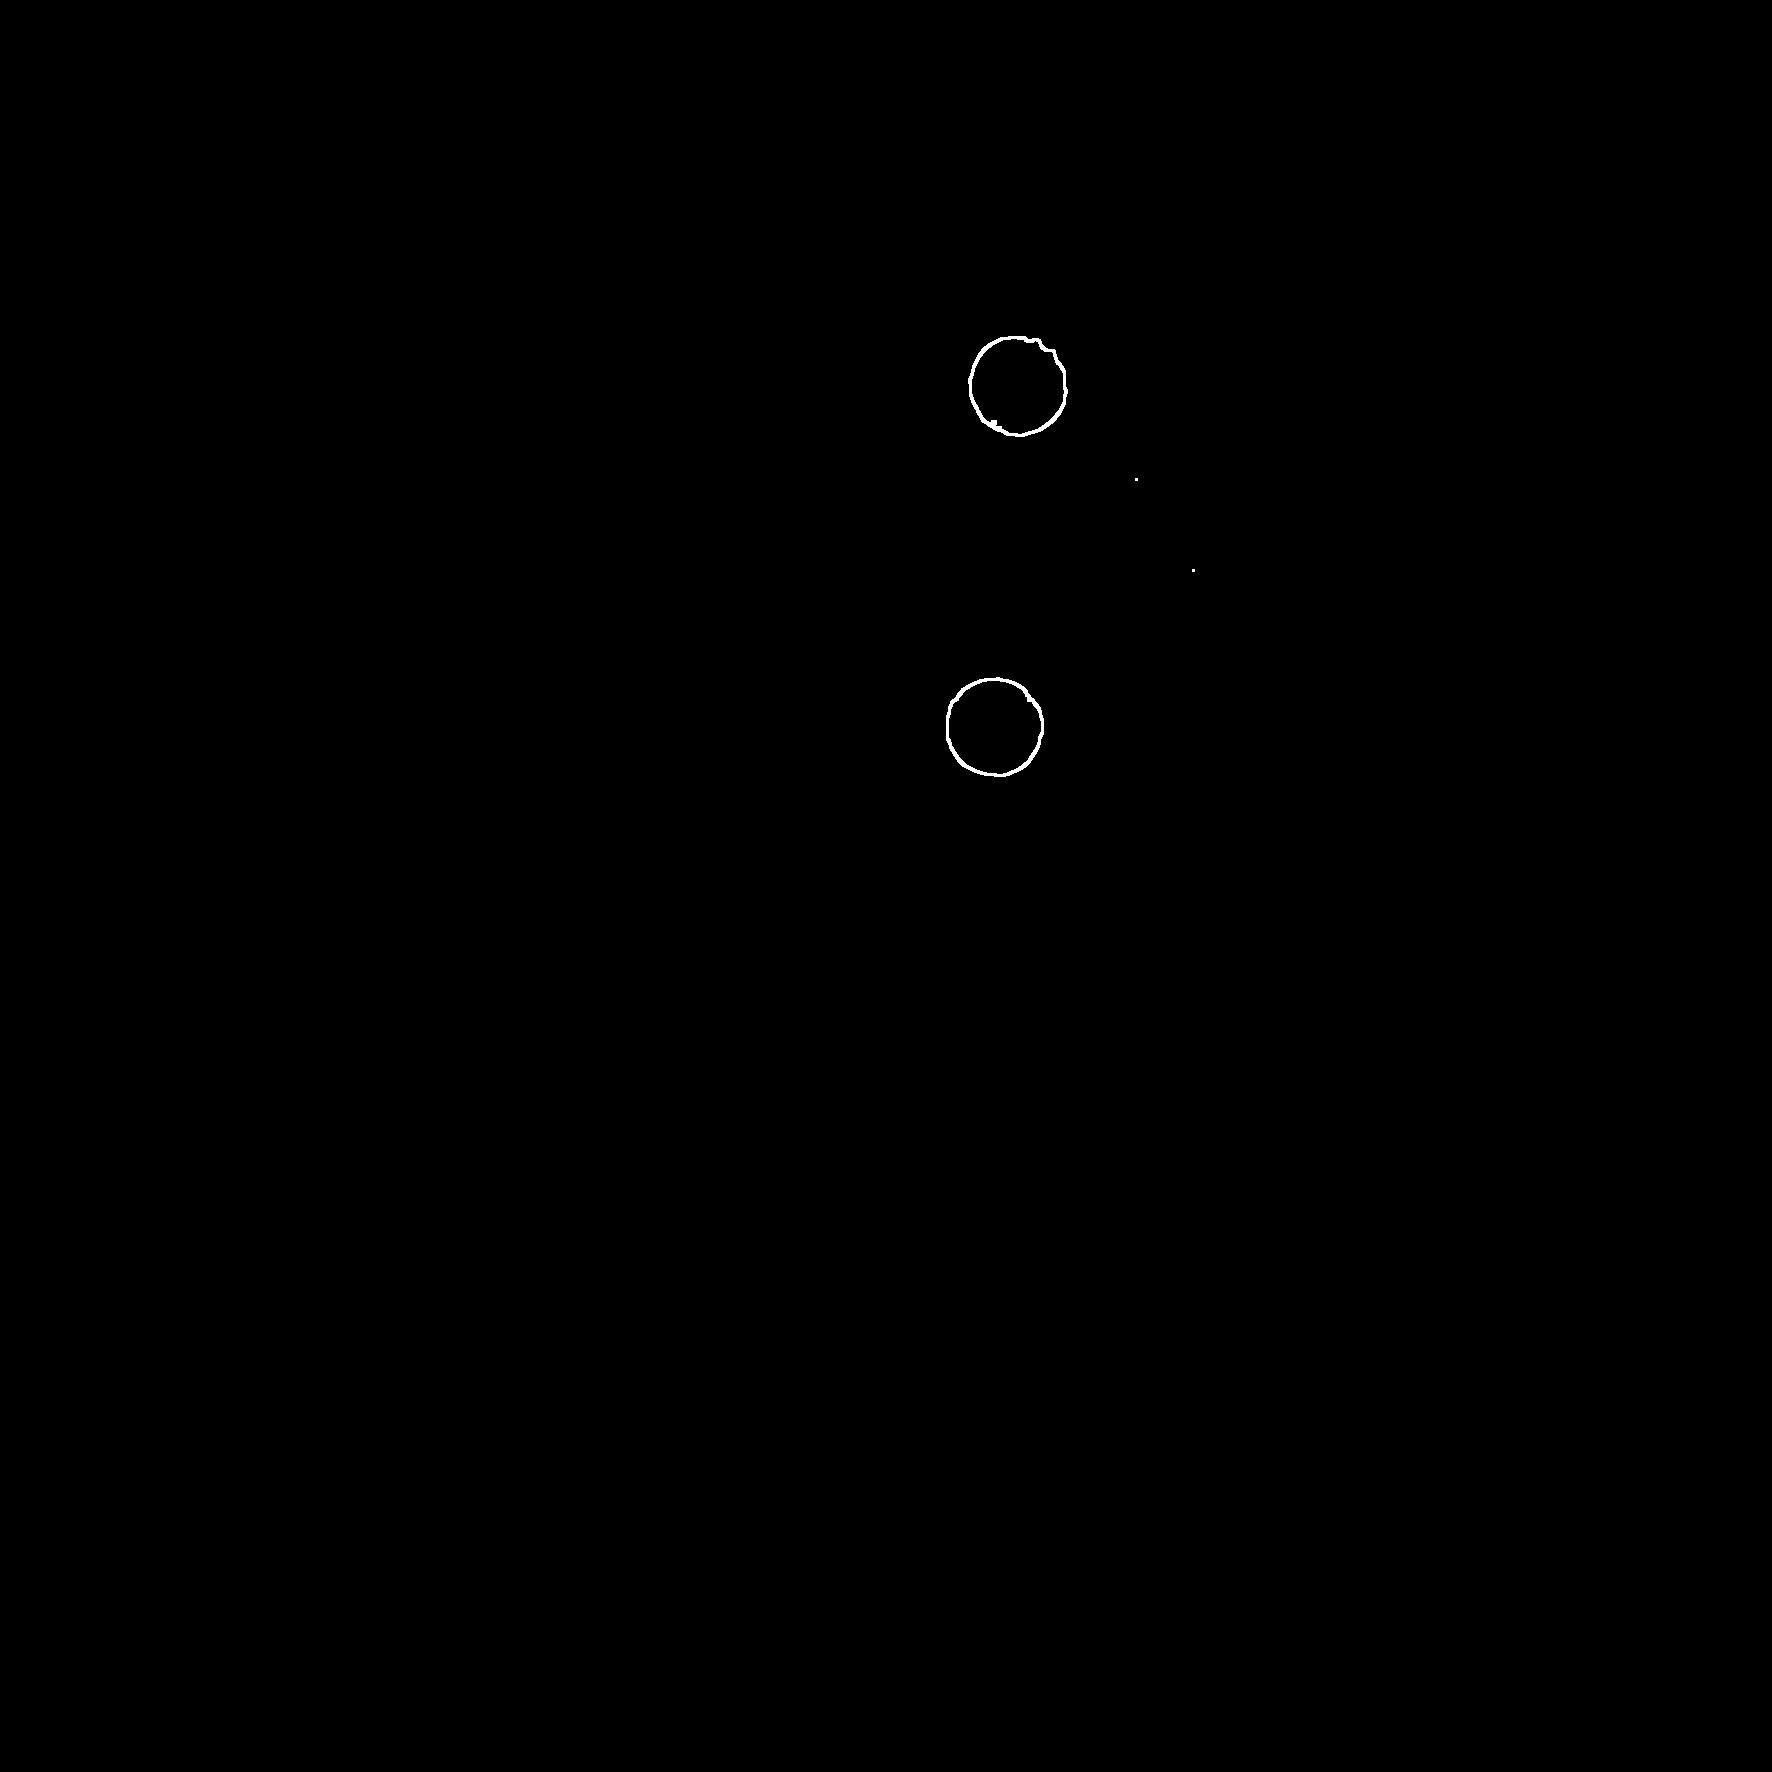

Liczba czarnych kropek: 2


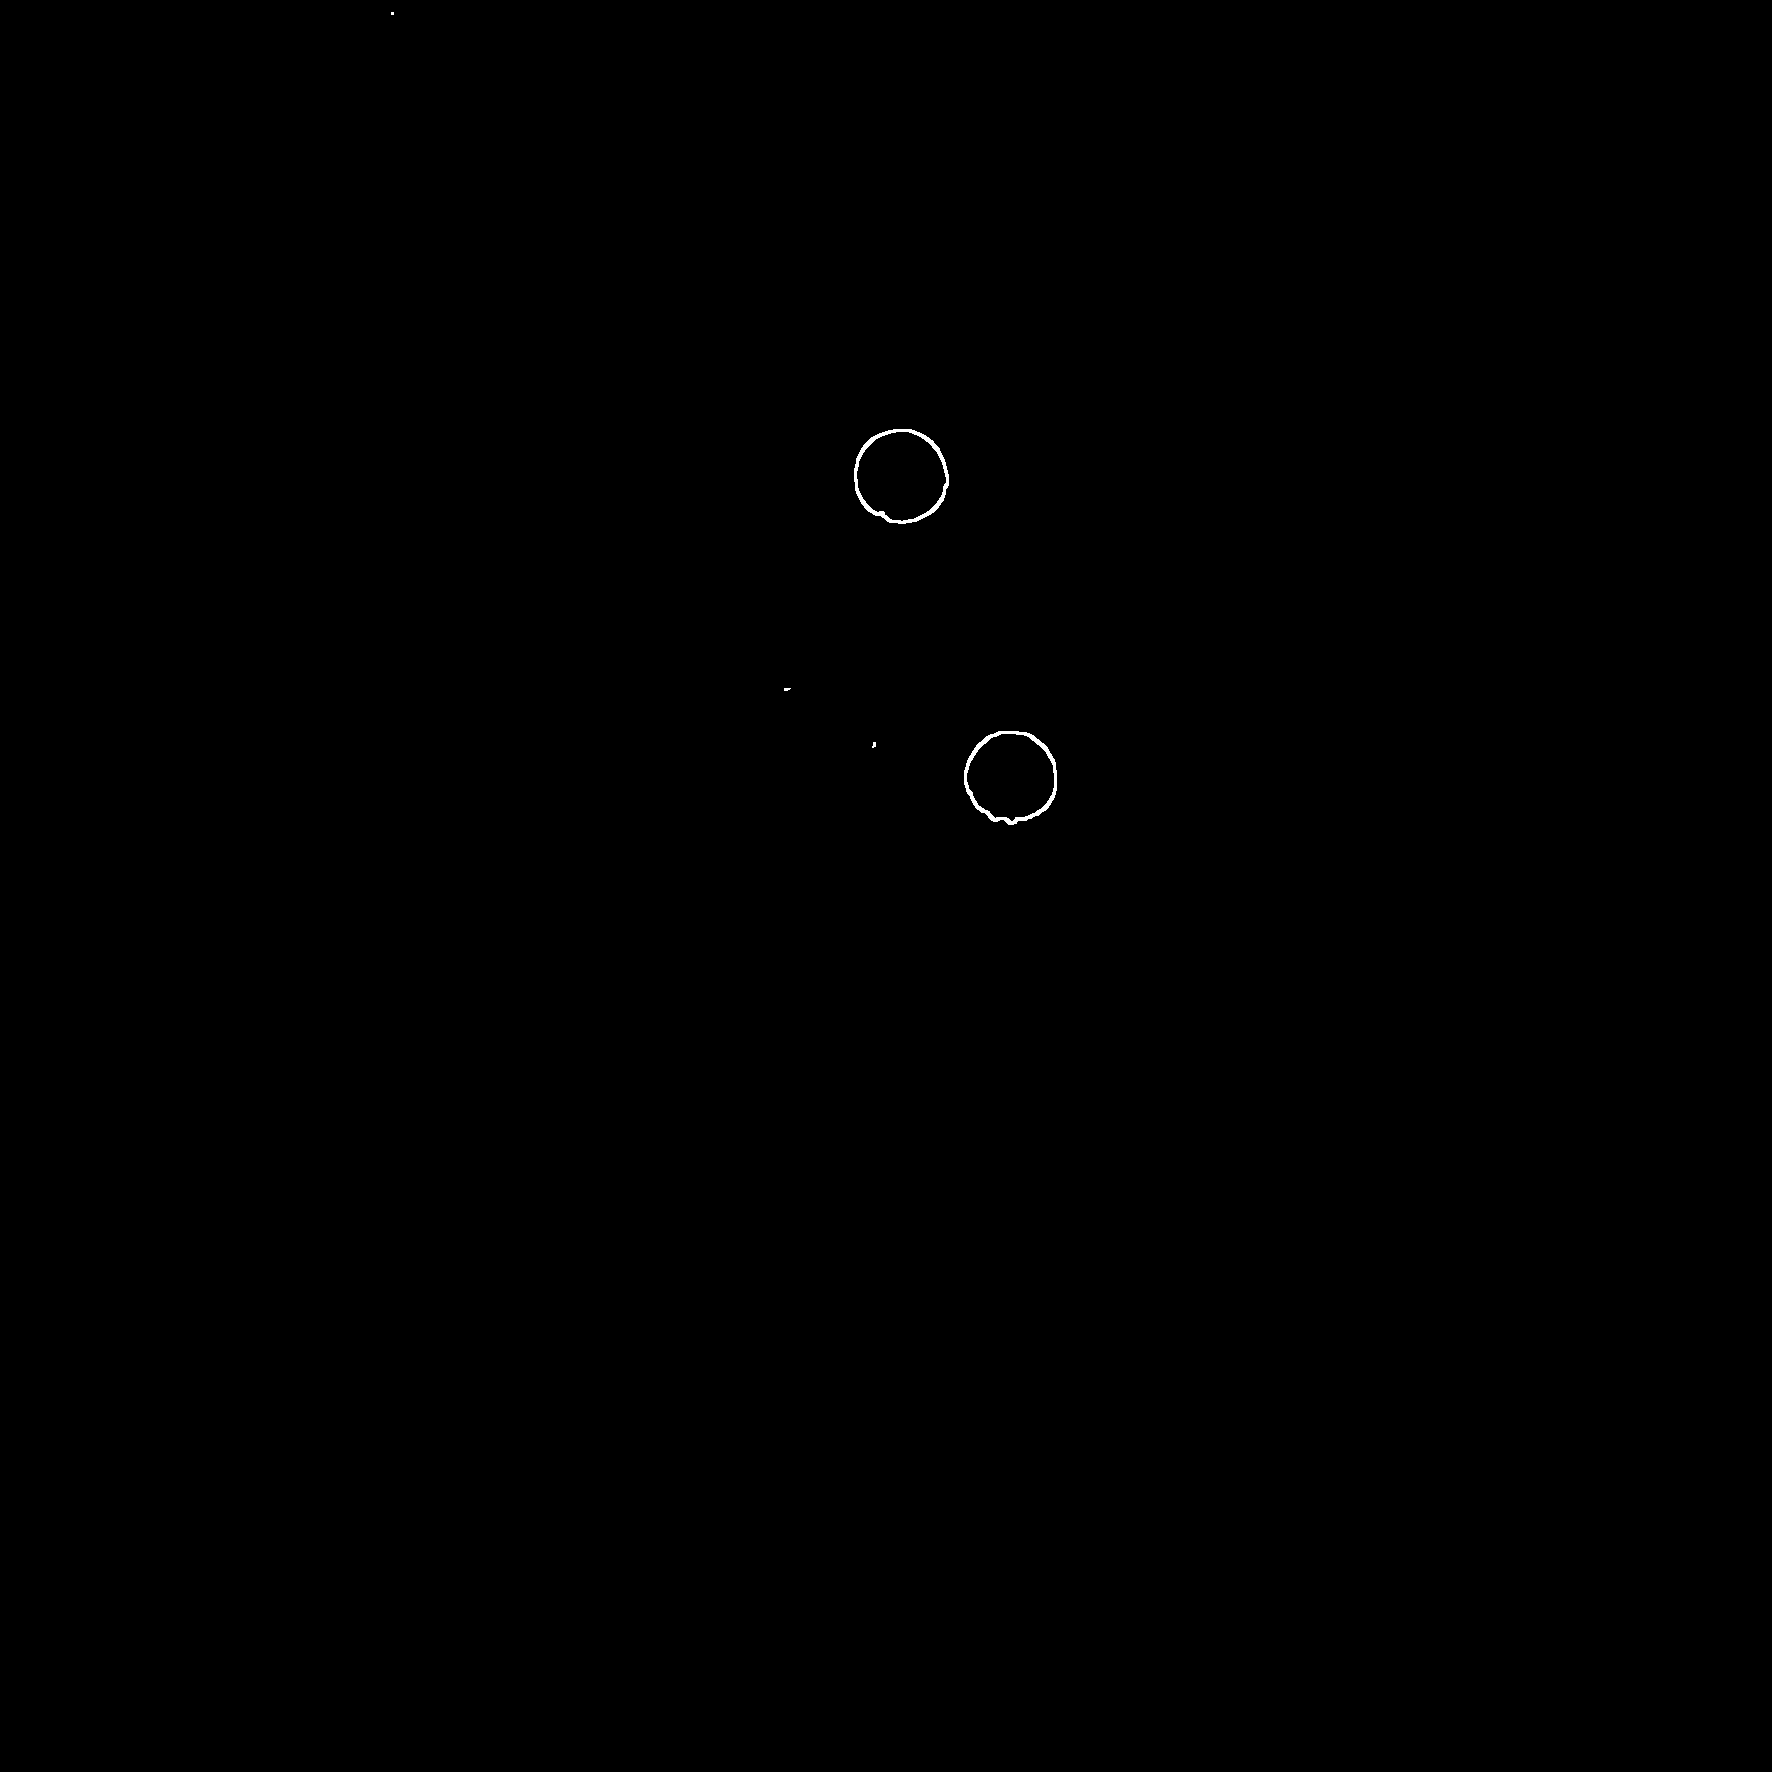

Liczba czarnych kropek: 2


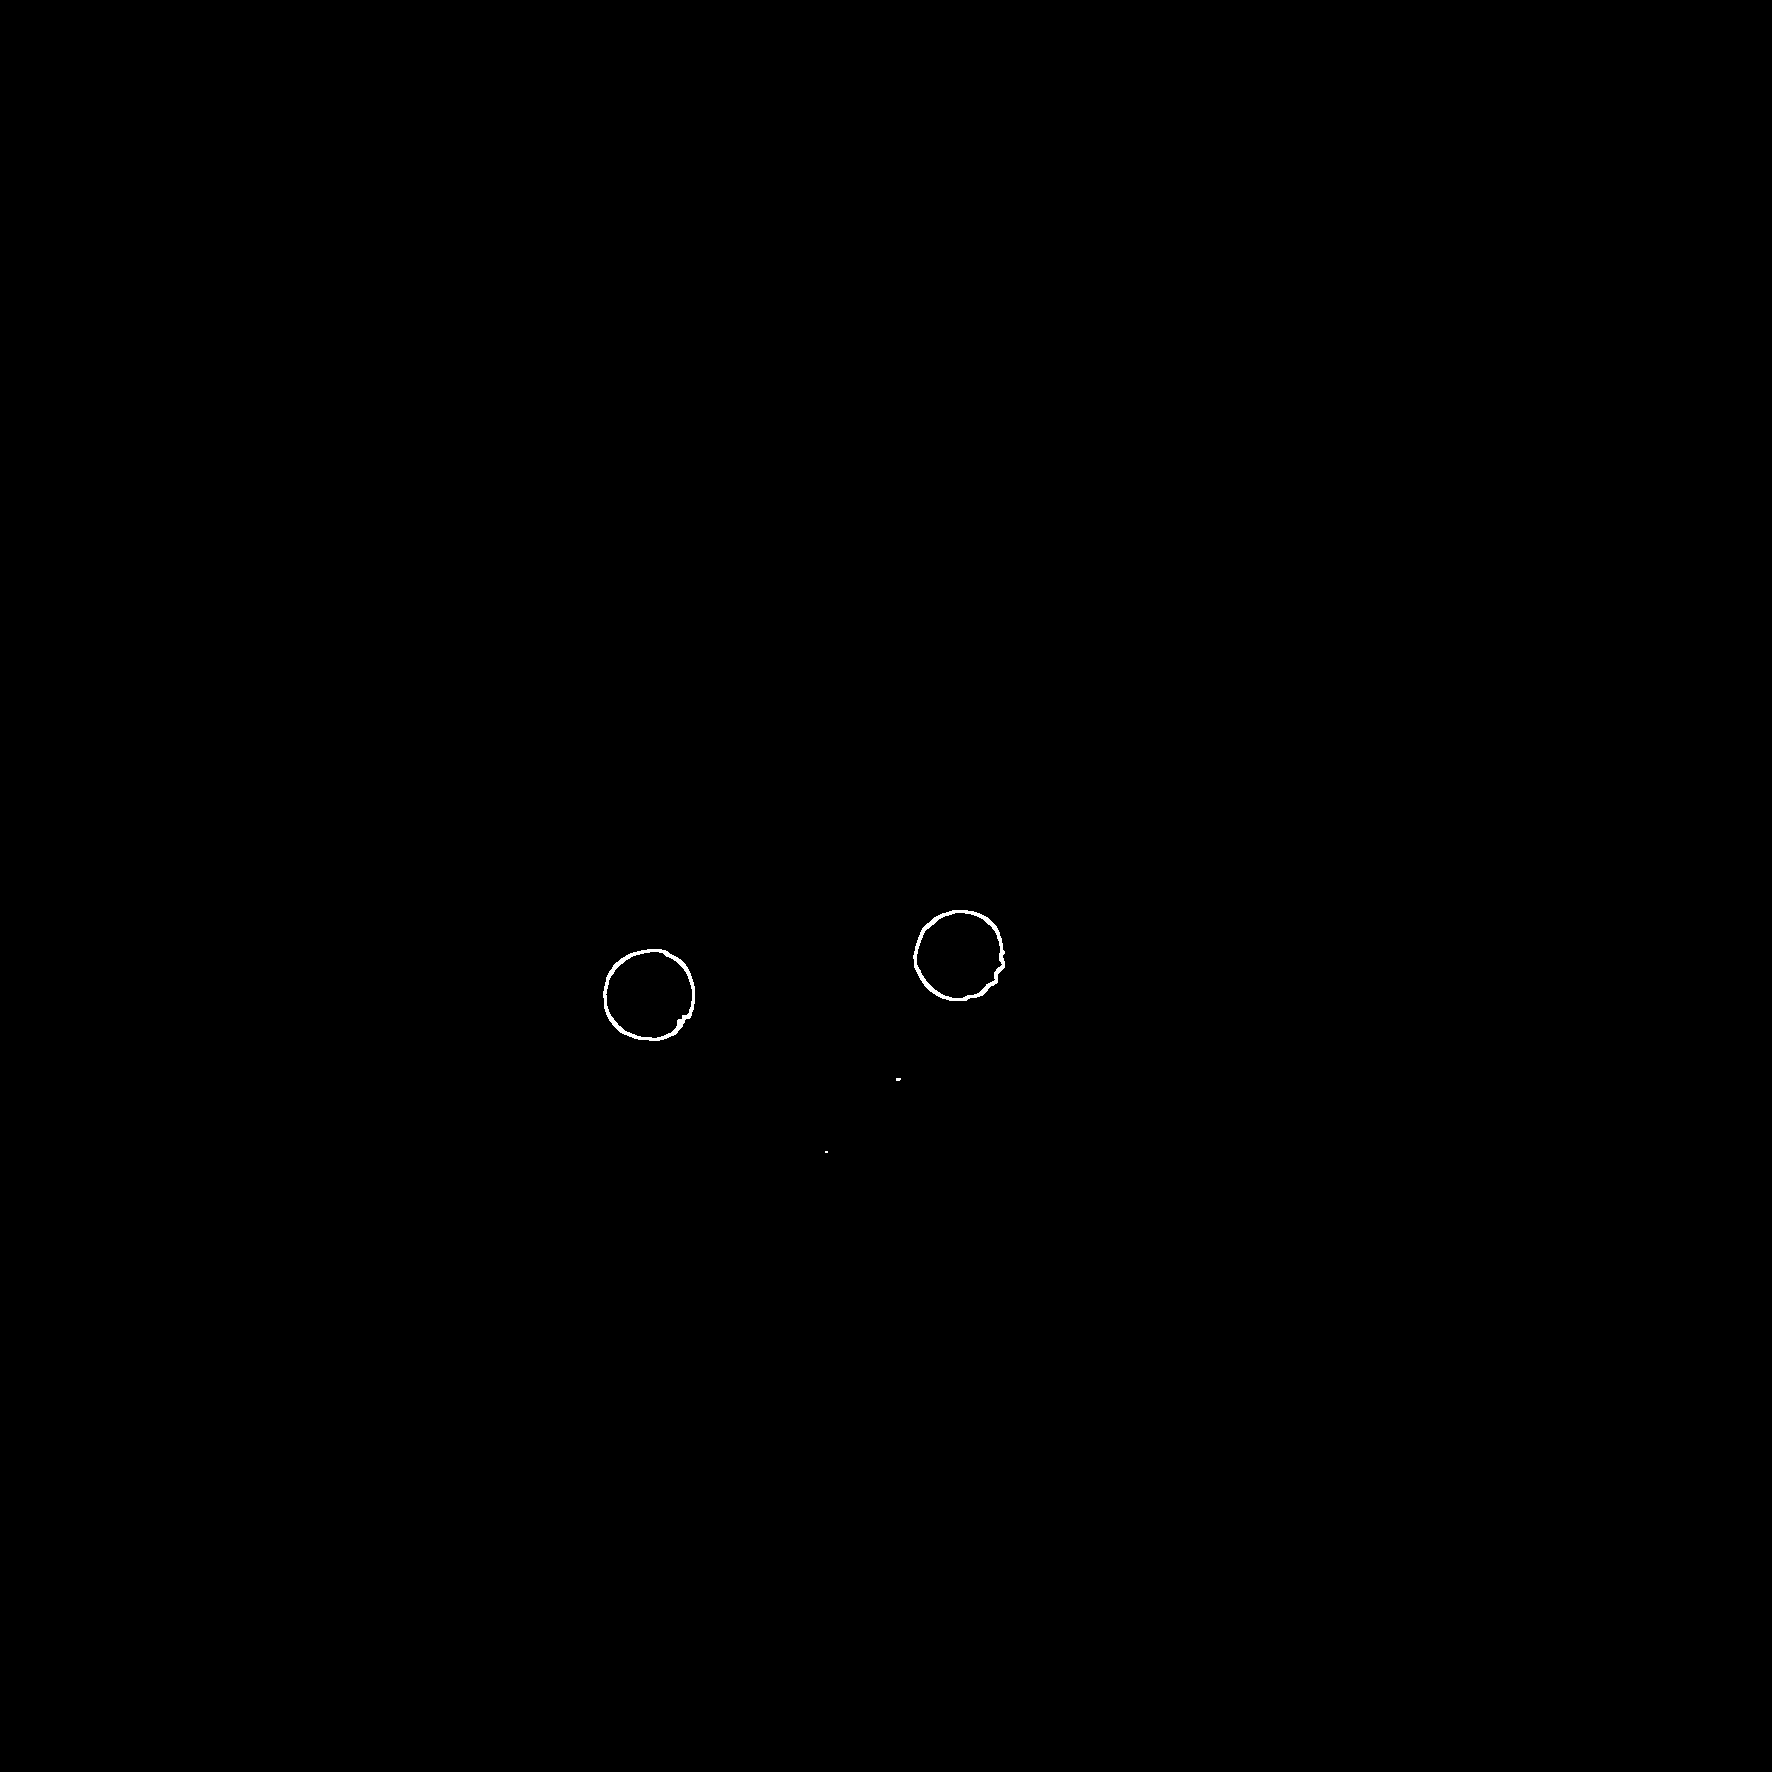

Liczba czarnych kropek: 2


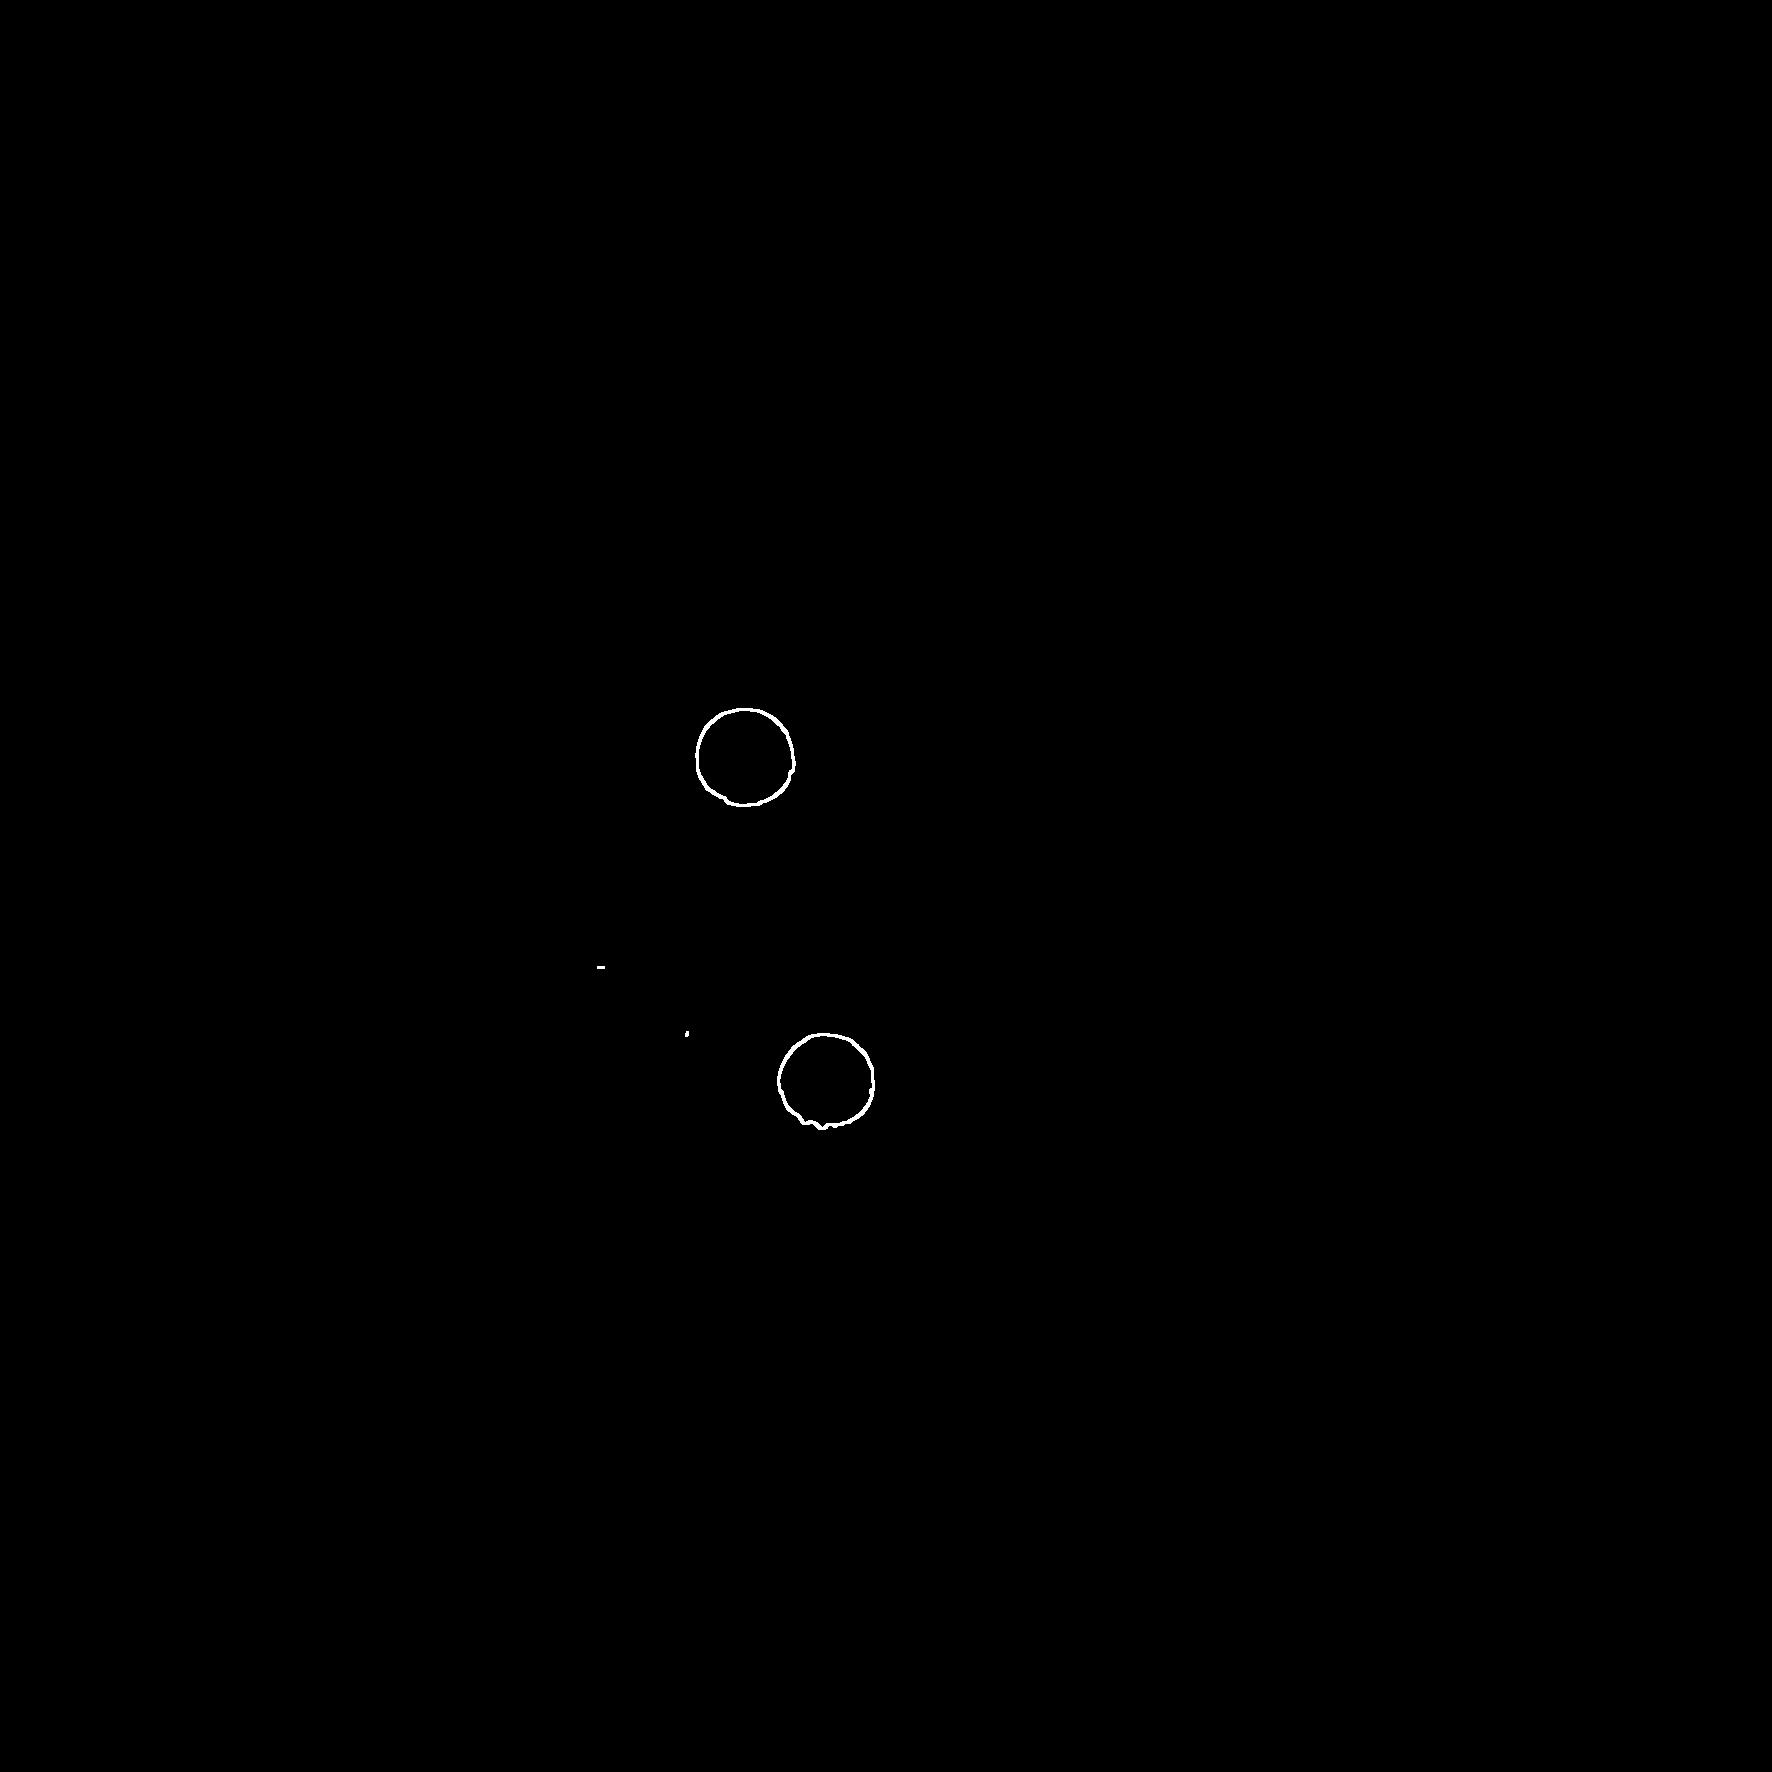

Liczba czarnych kropek: 2


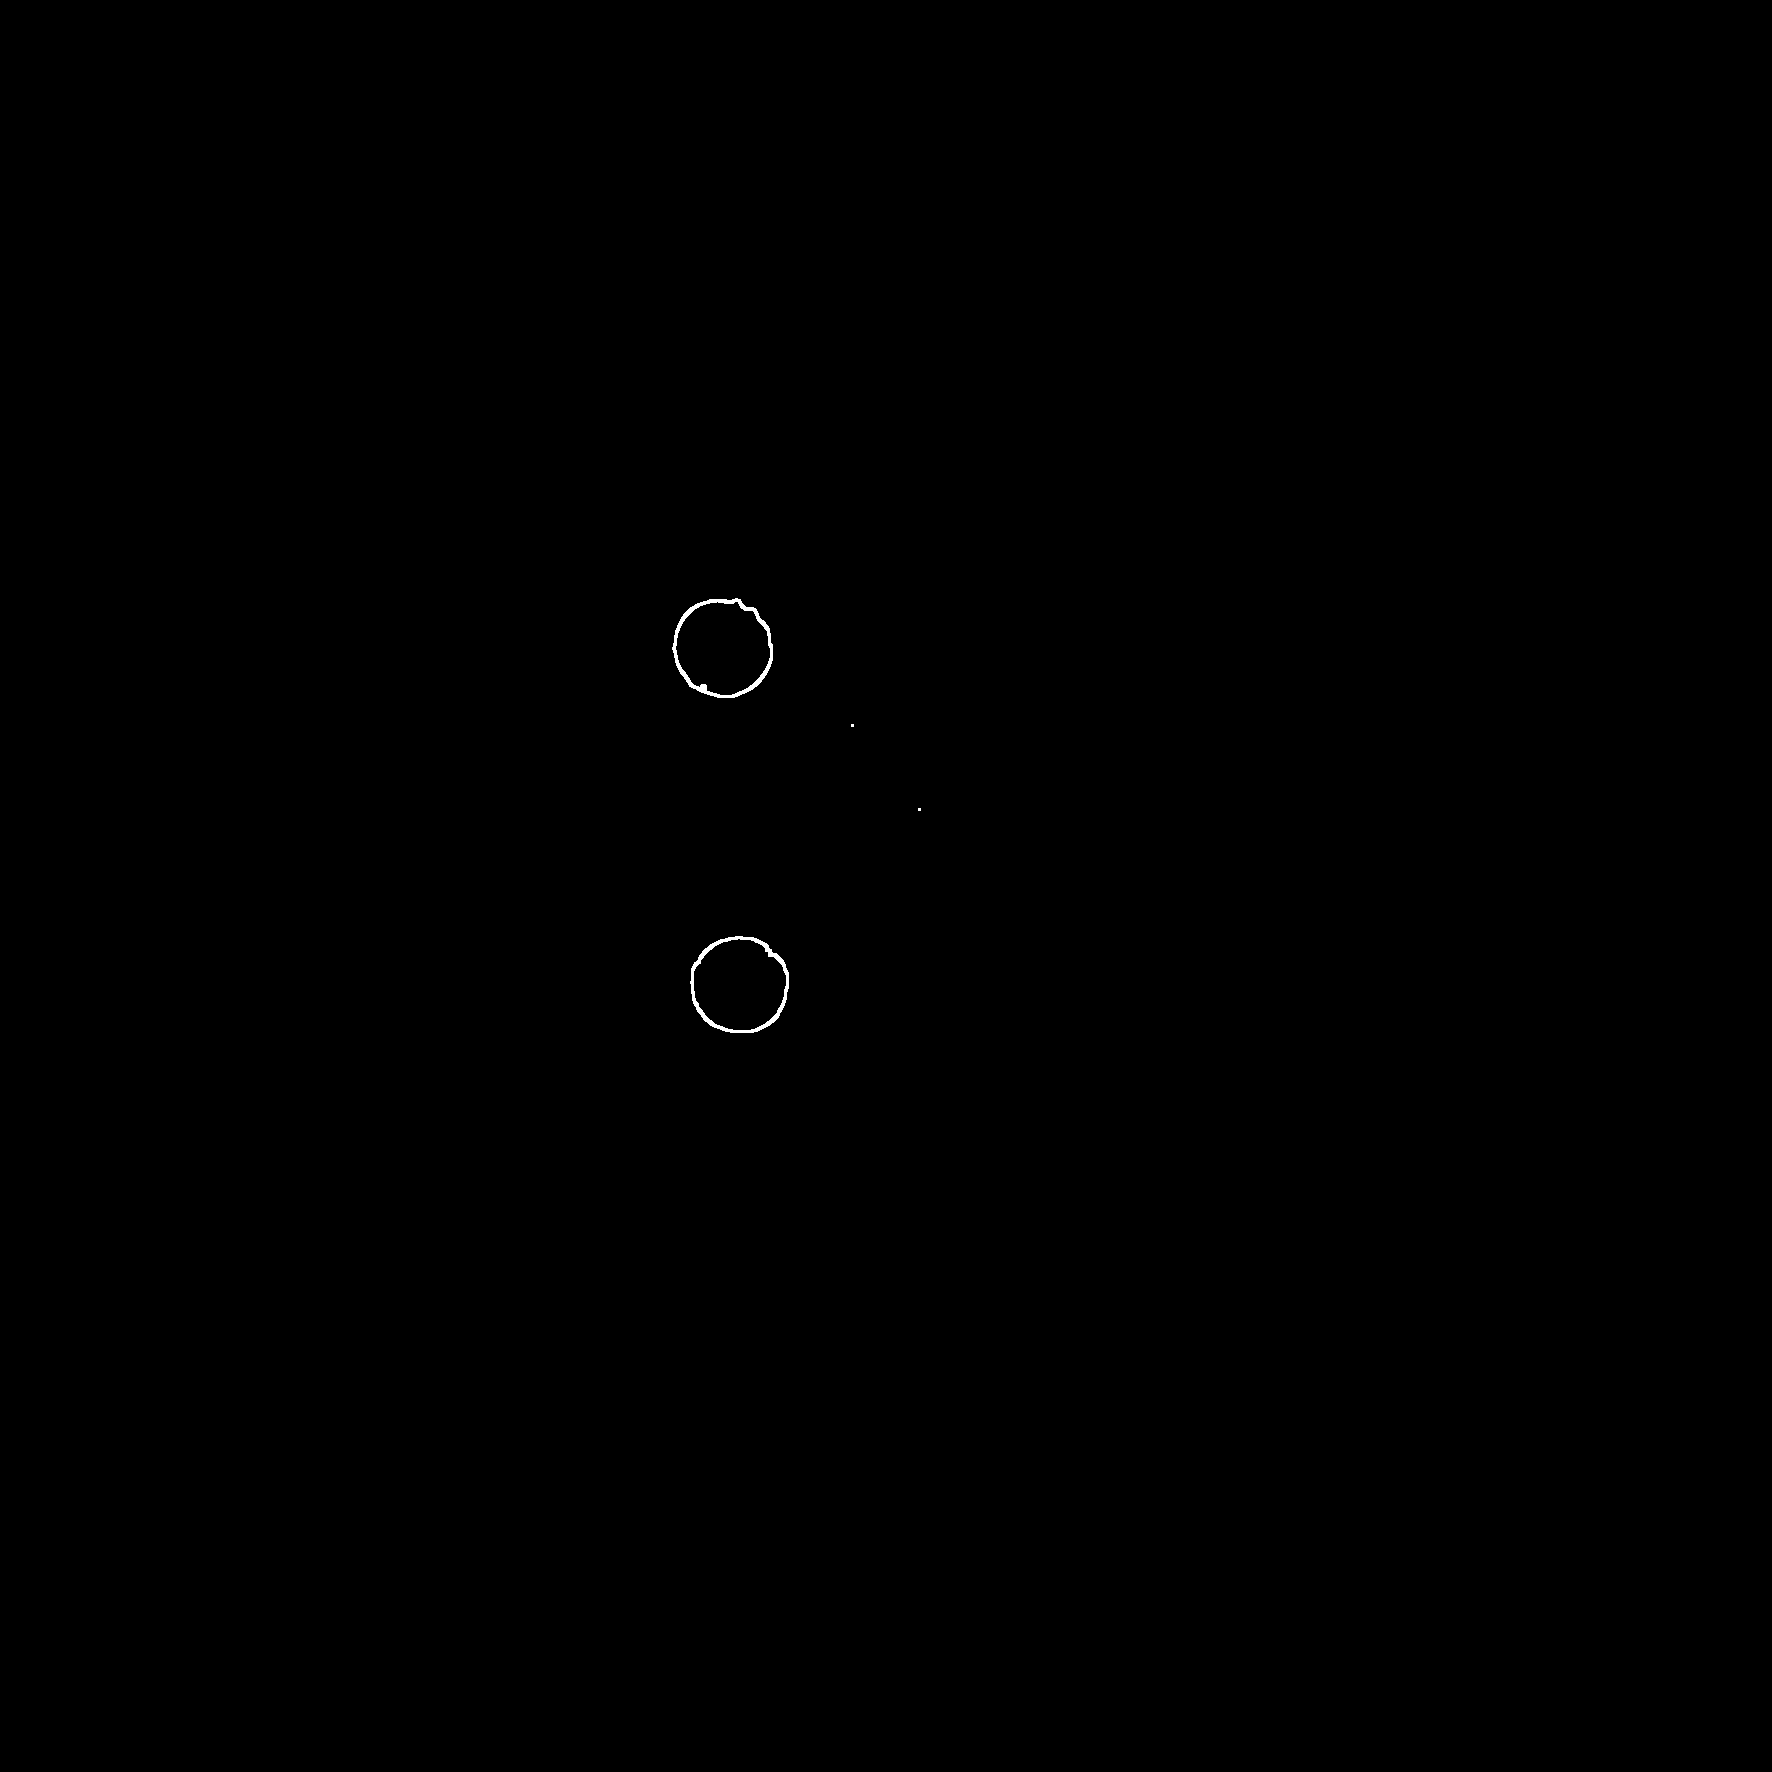

Liczba czarnych kropek: 2


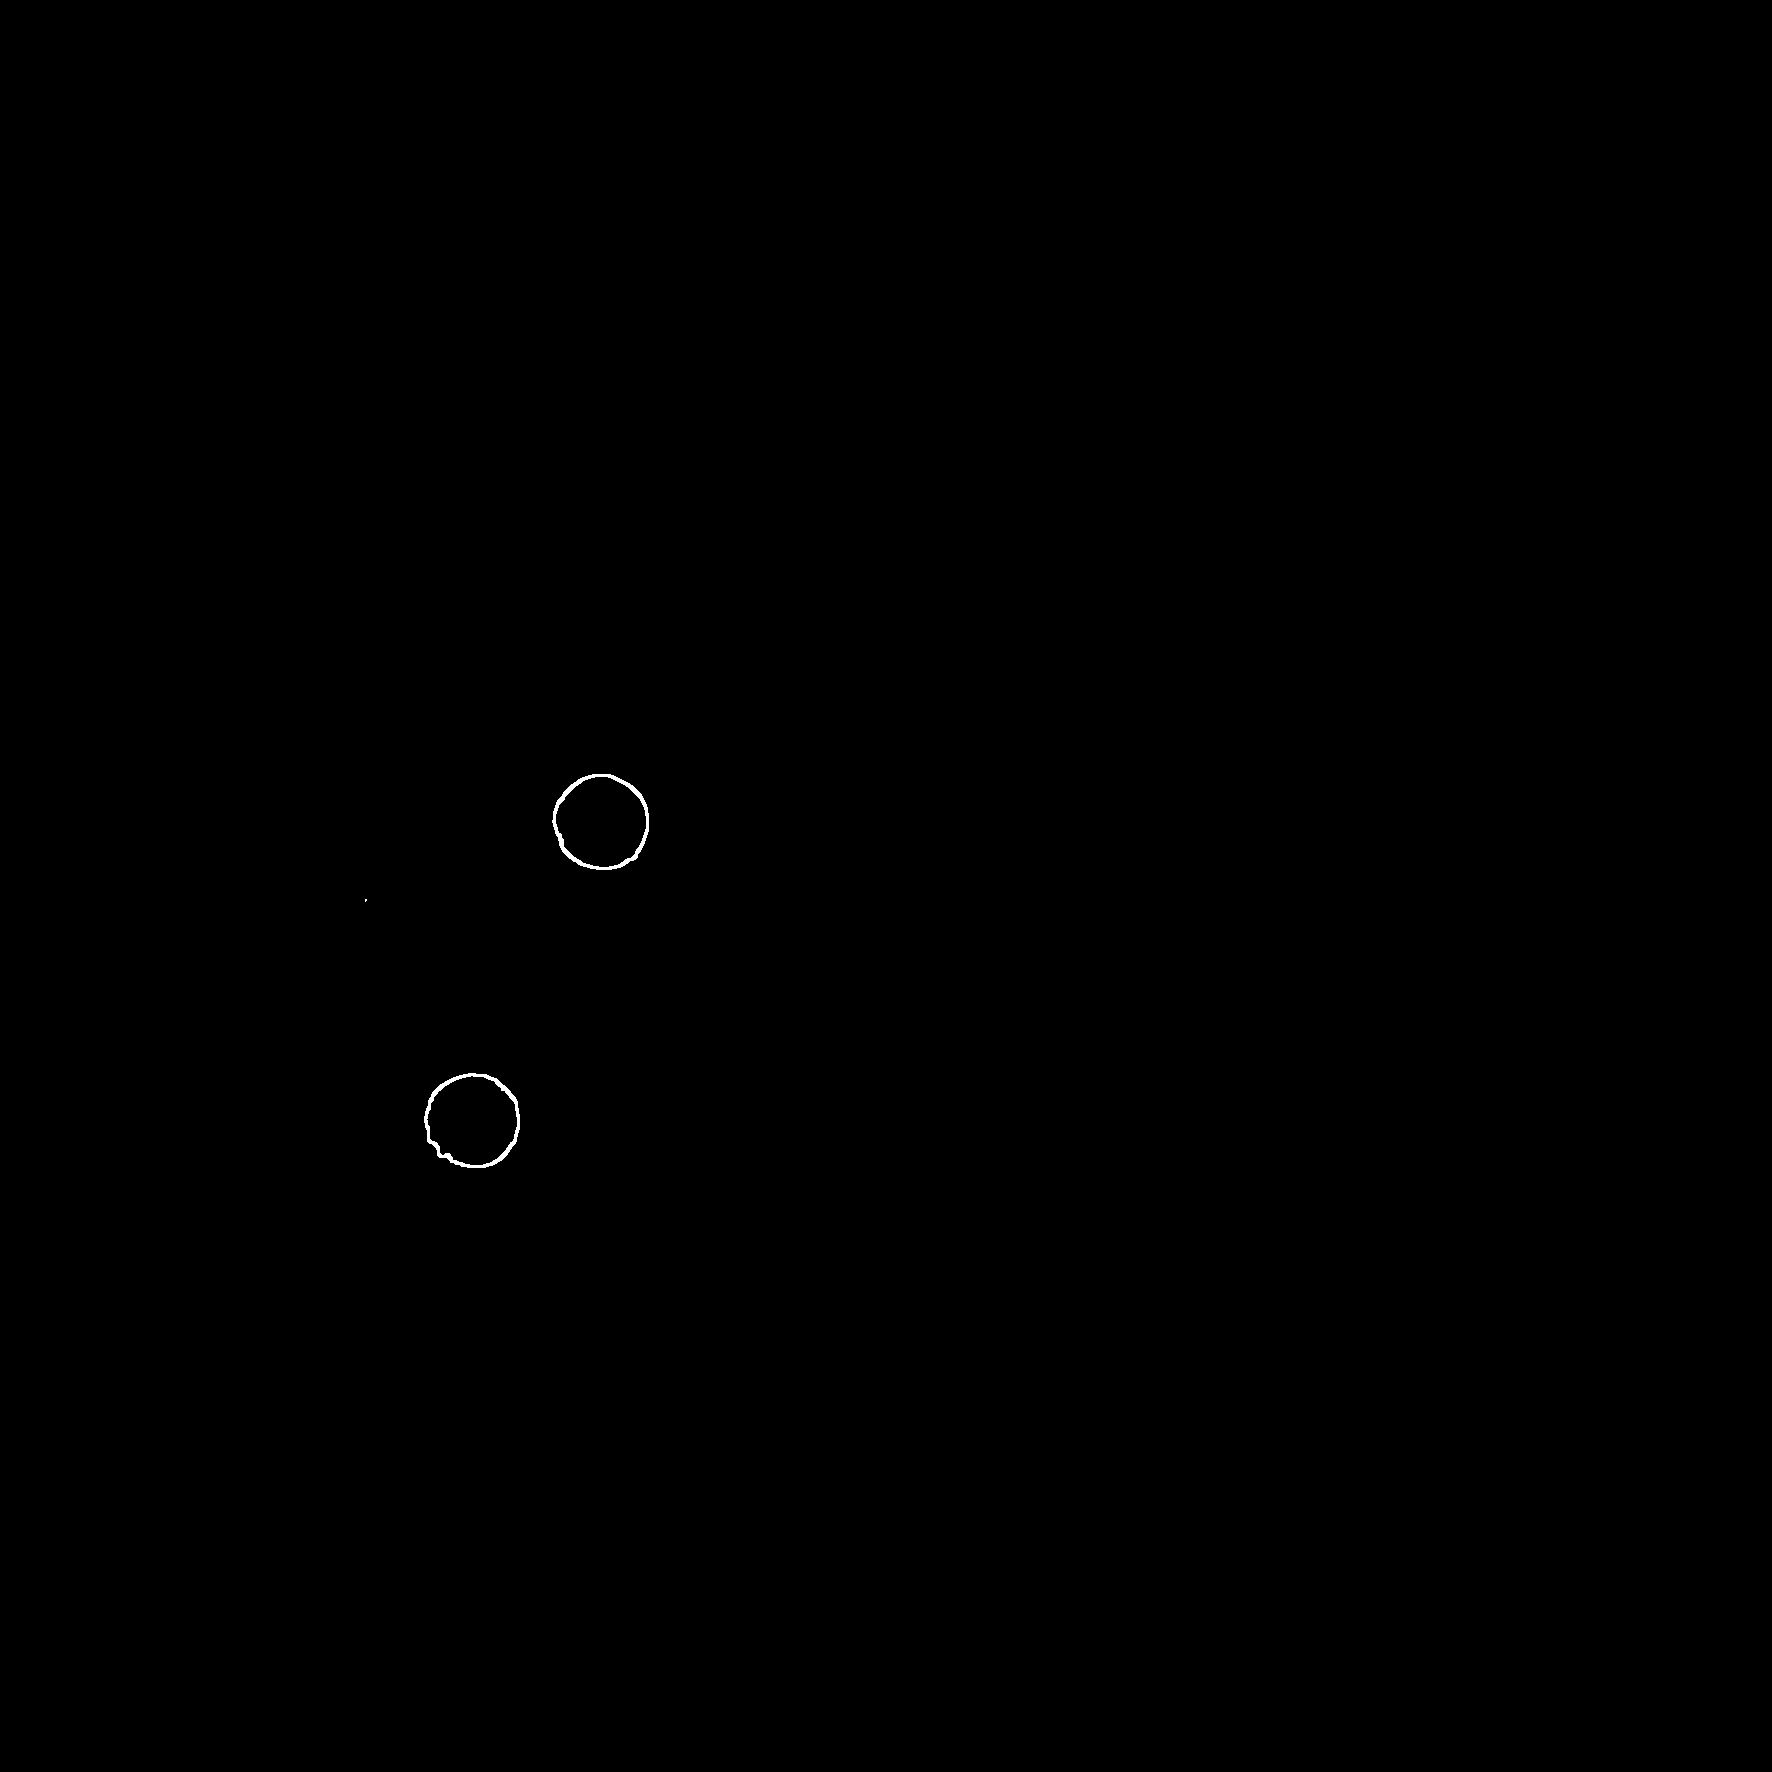

Liczba czarnych kropek: 2


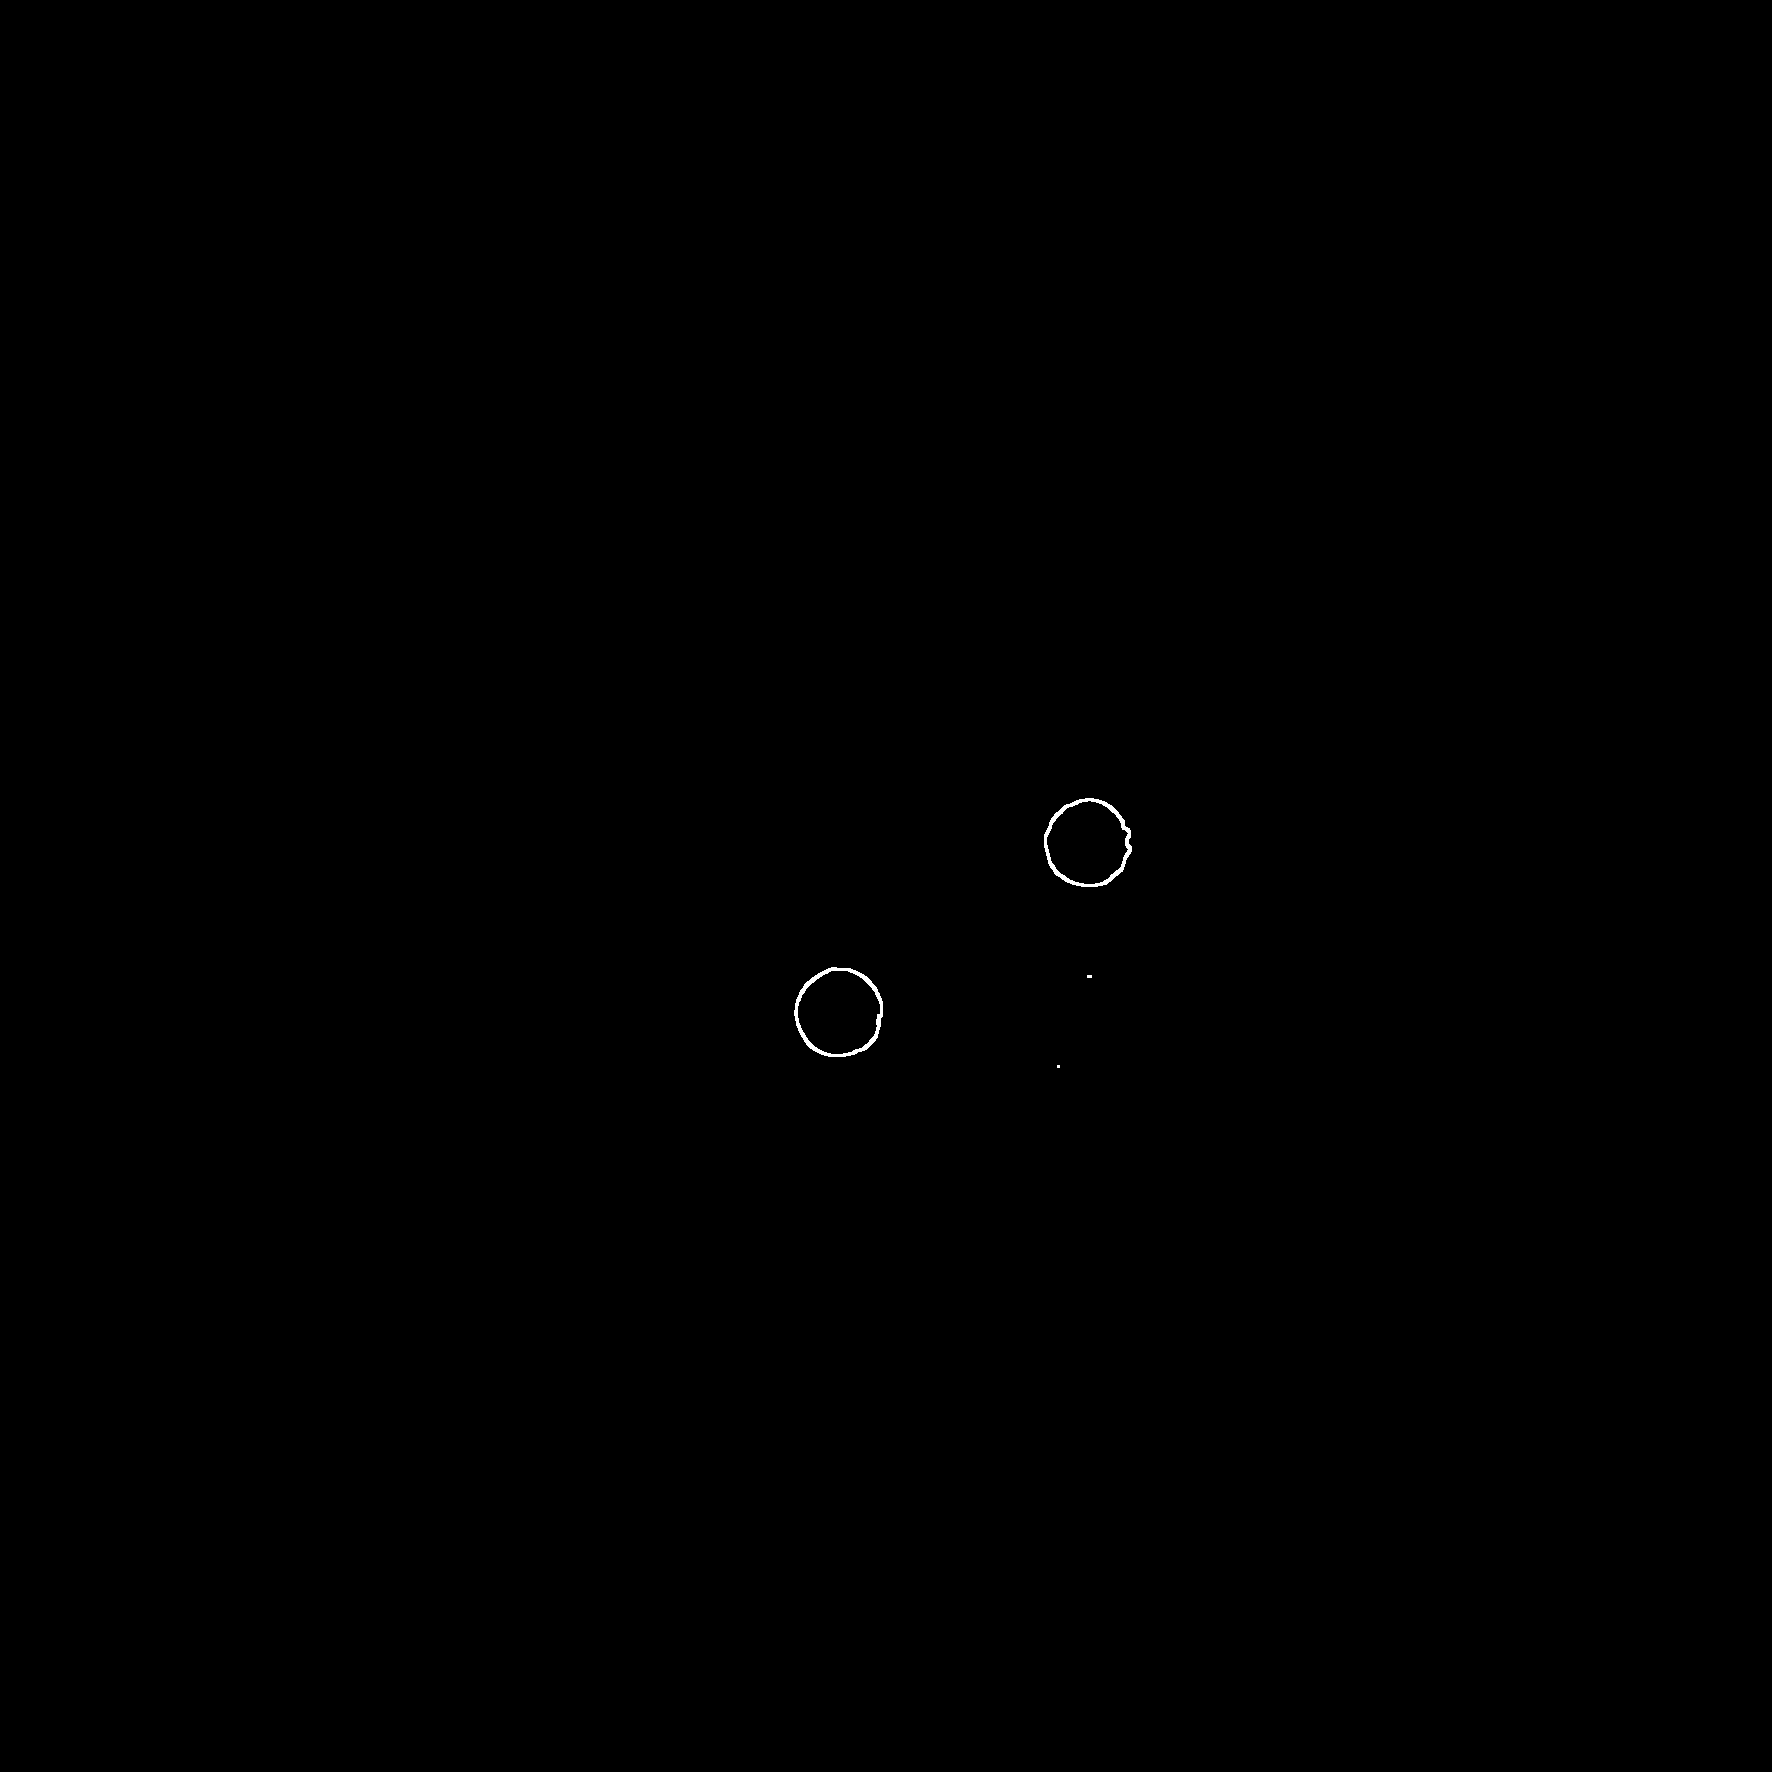

Liczba czarnych kropek: 2


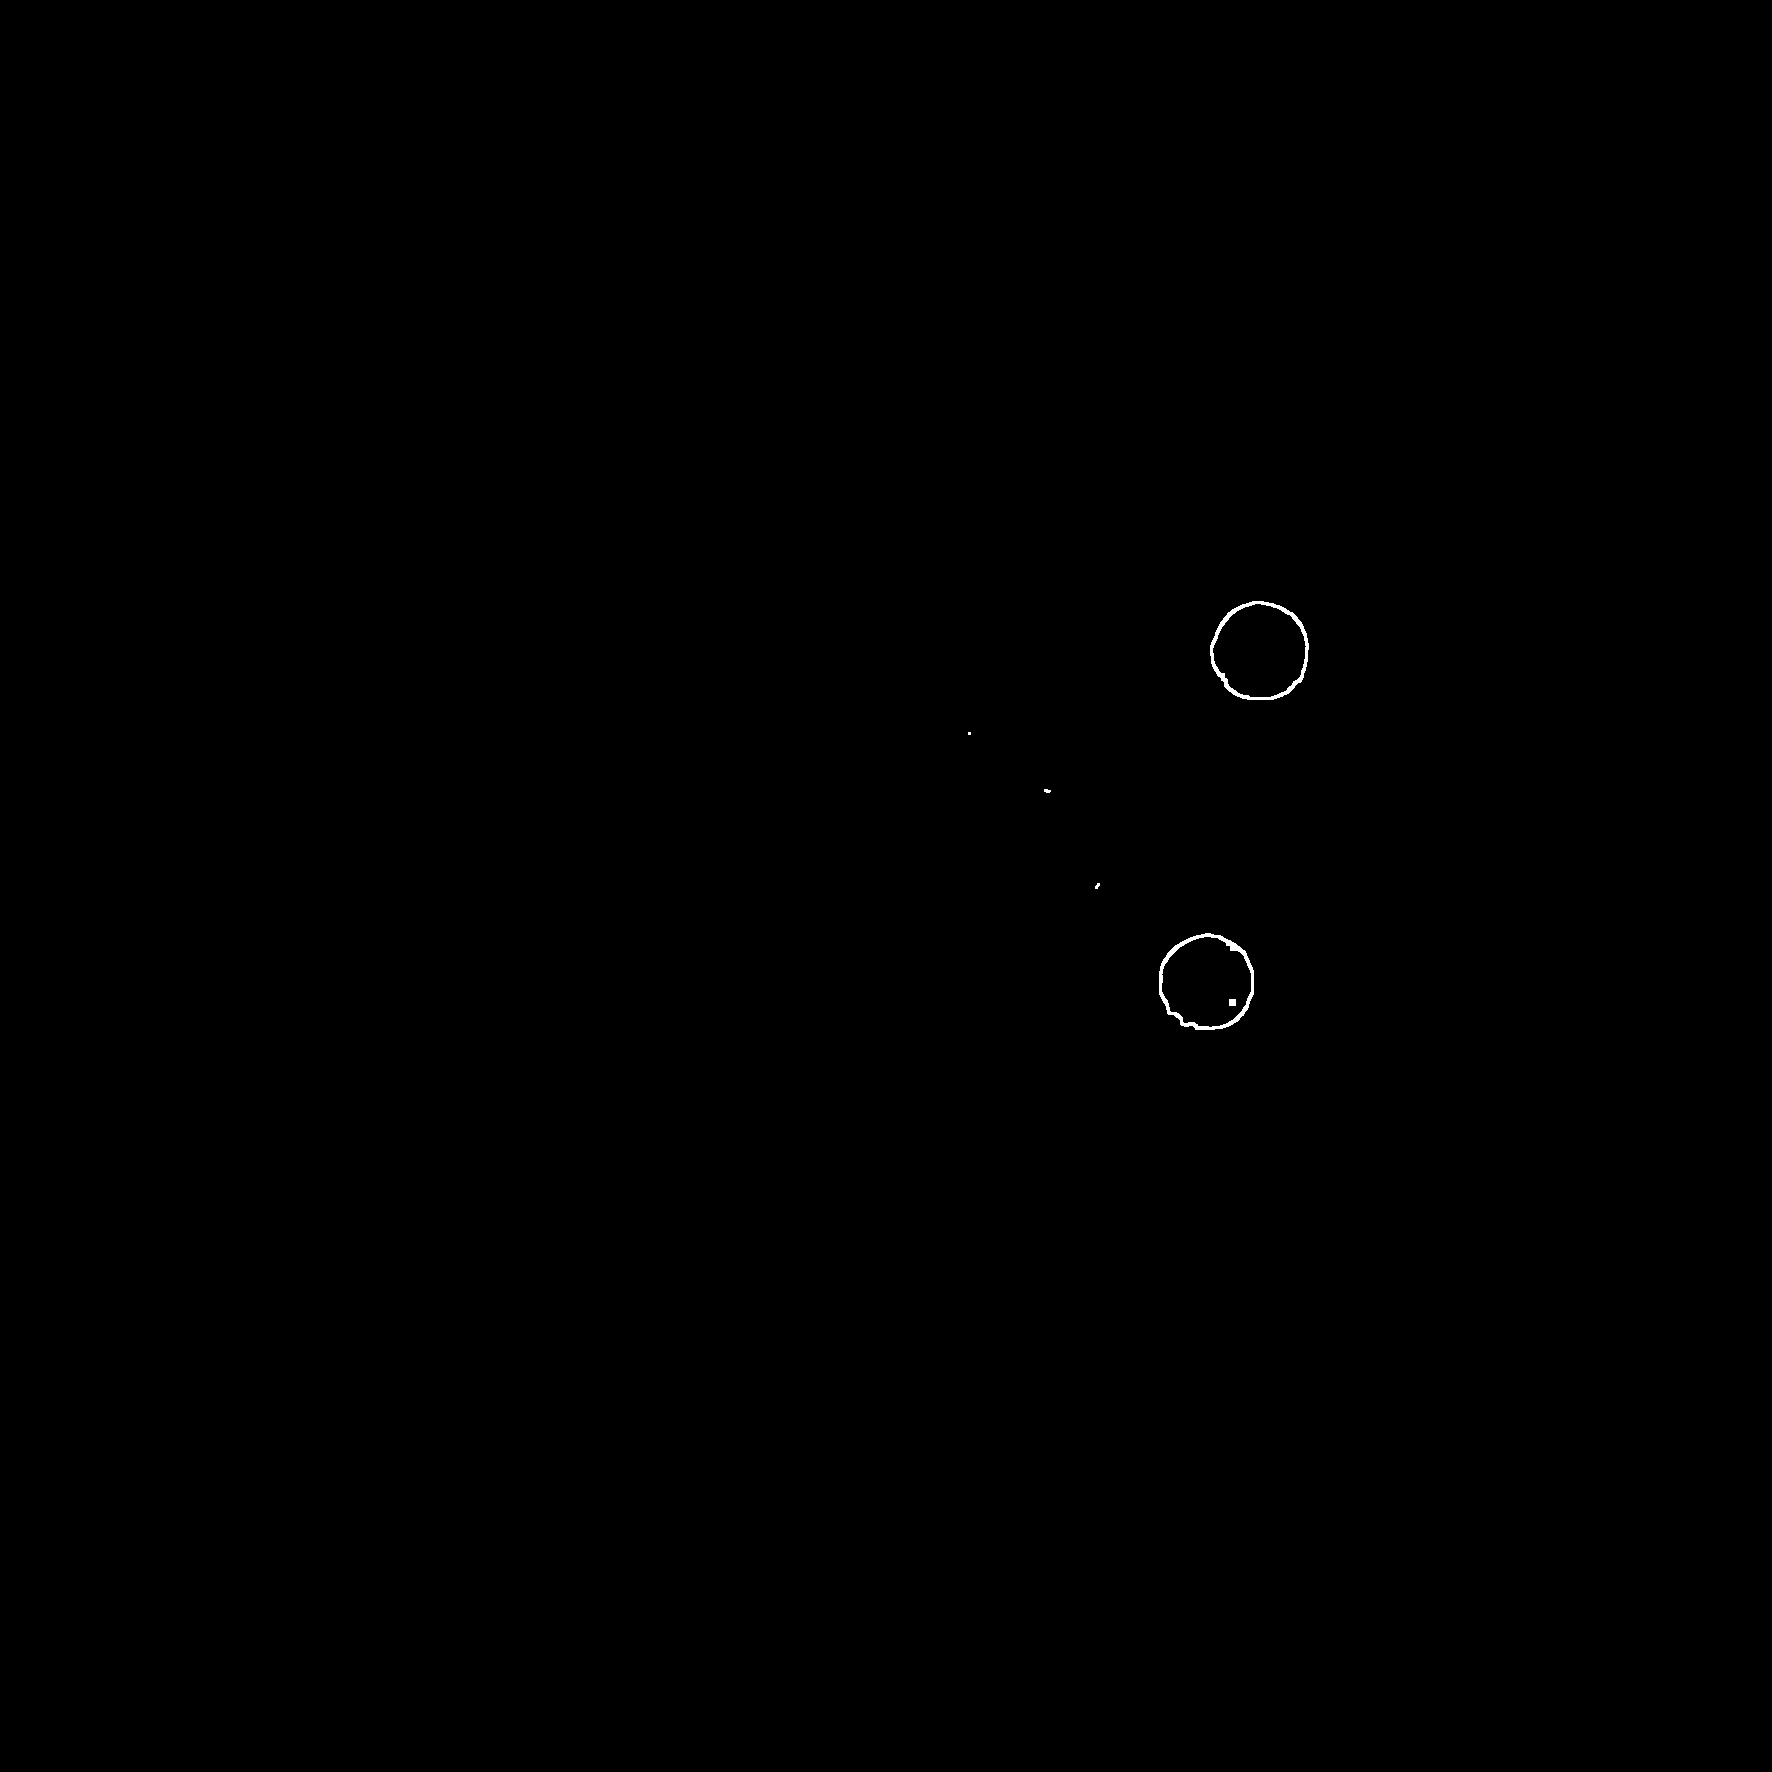

Liczba czarnych kropek: 2


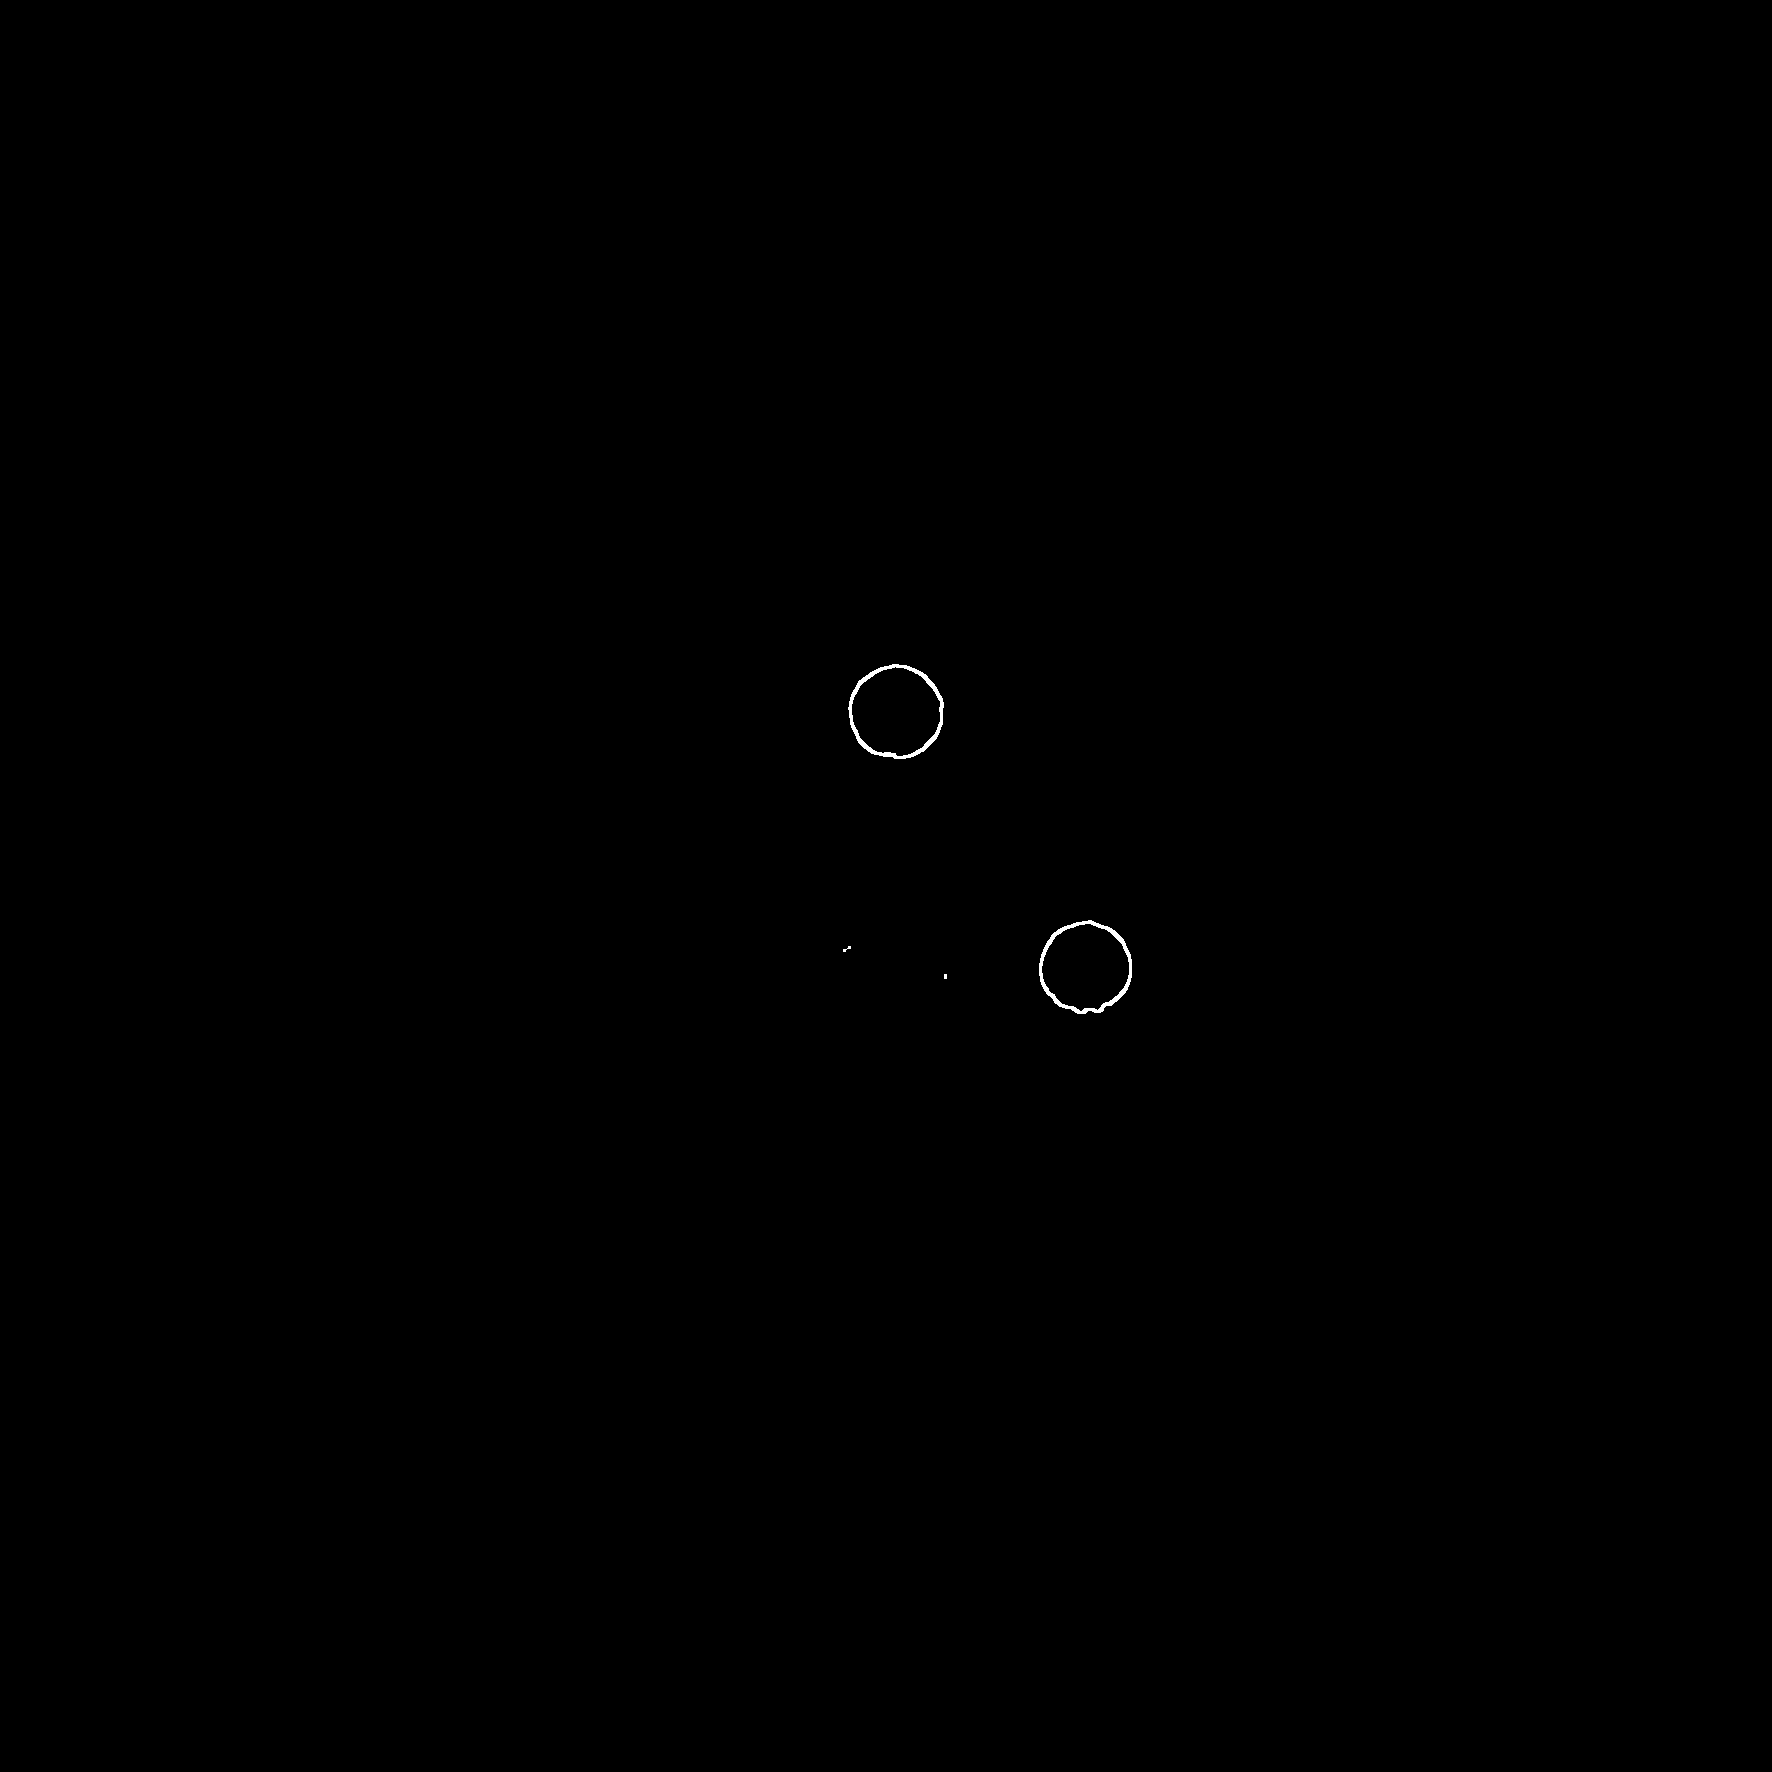

Liczba czarnych kropek: 2


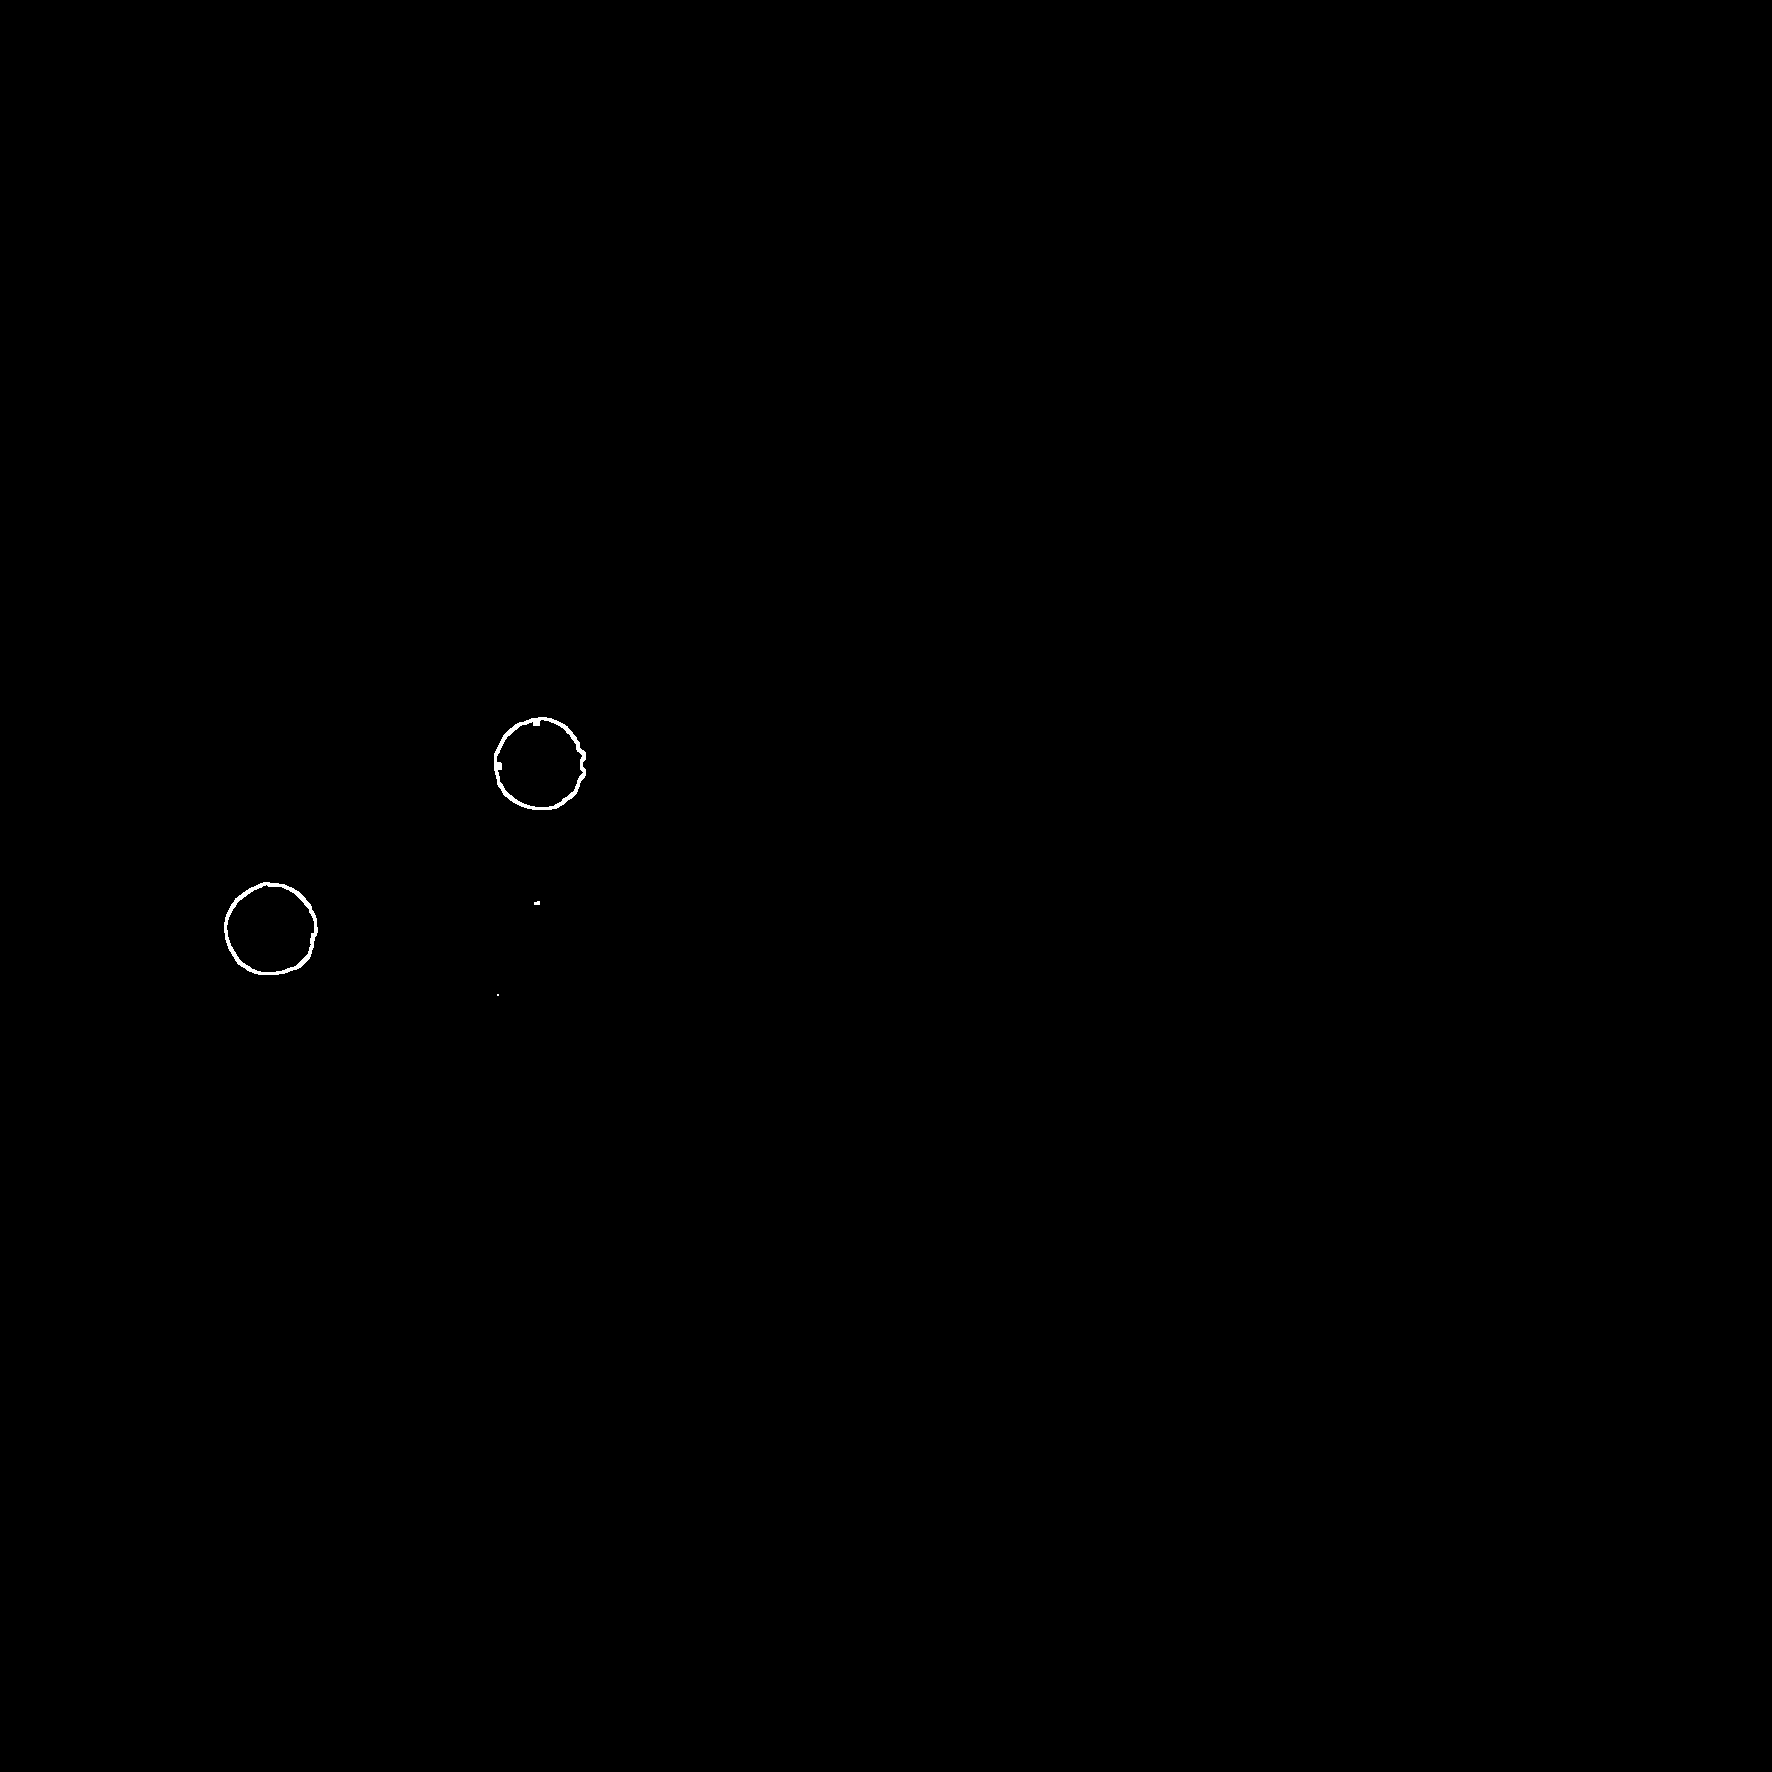

Liczba czarnych kropek: 2


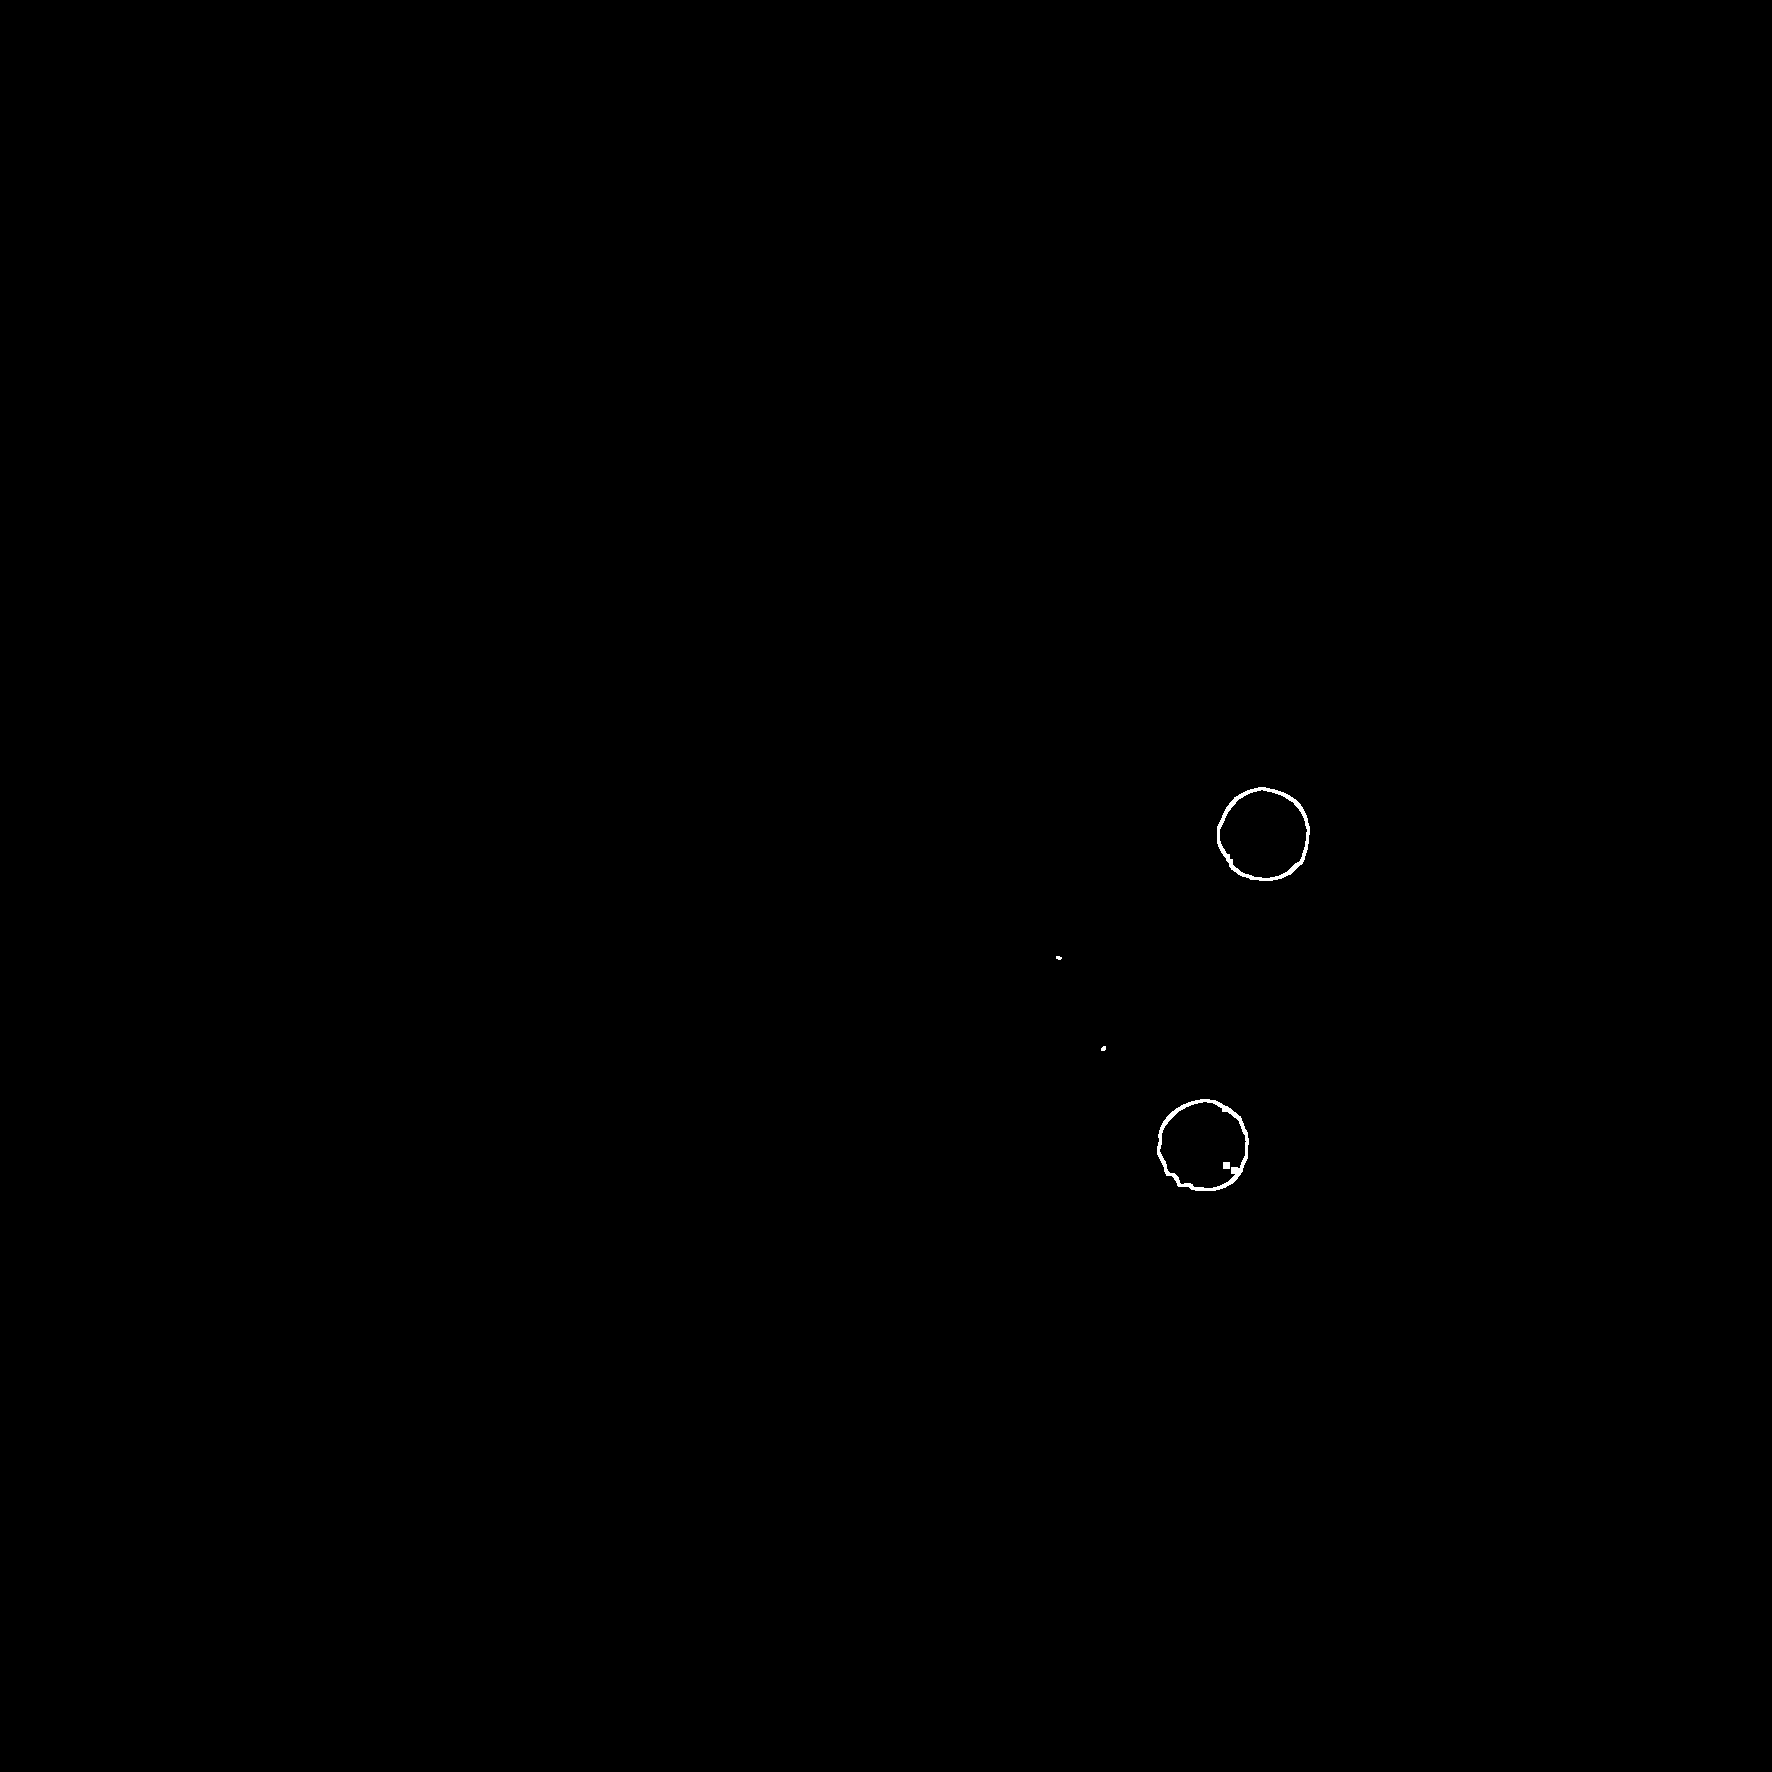

Liczba czarnych kropek: 2


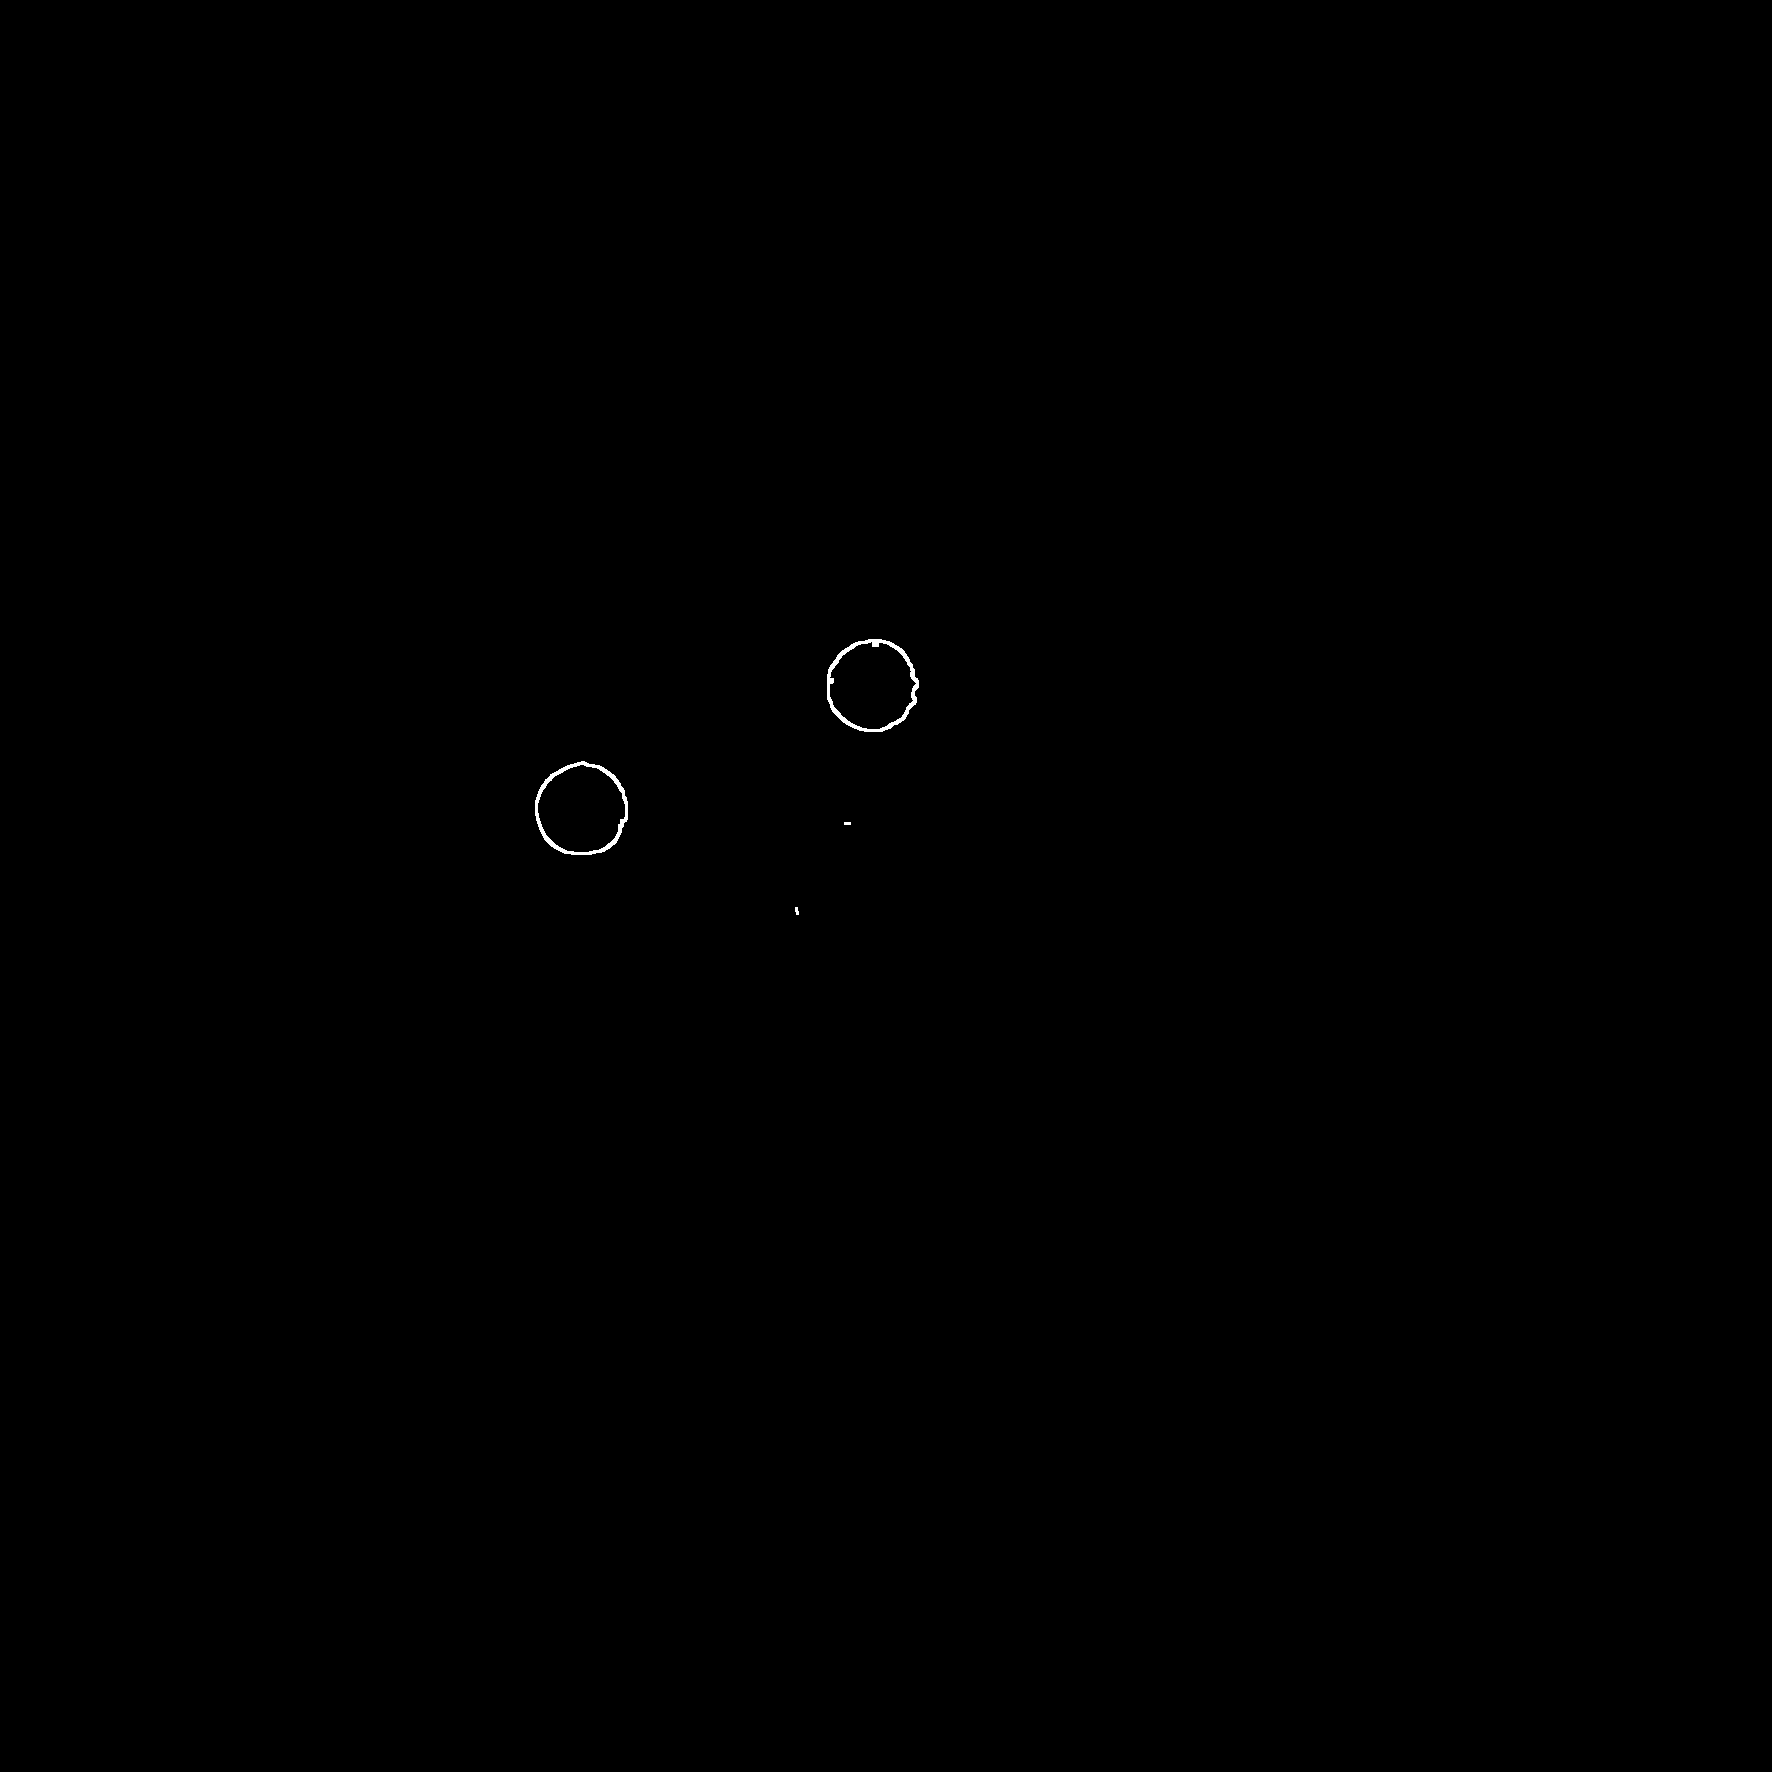

Liczba czarnych kropek: 2


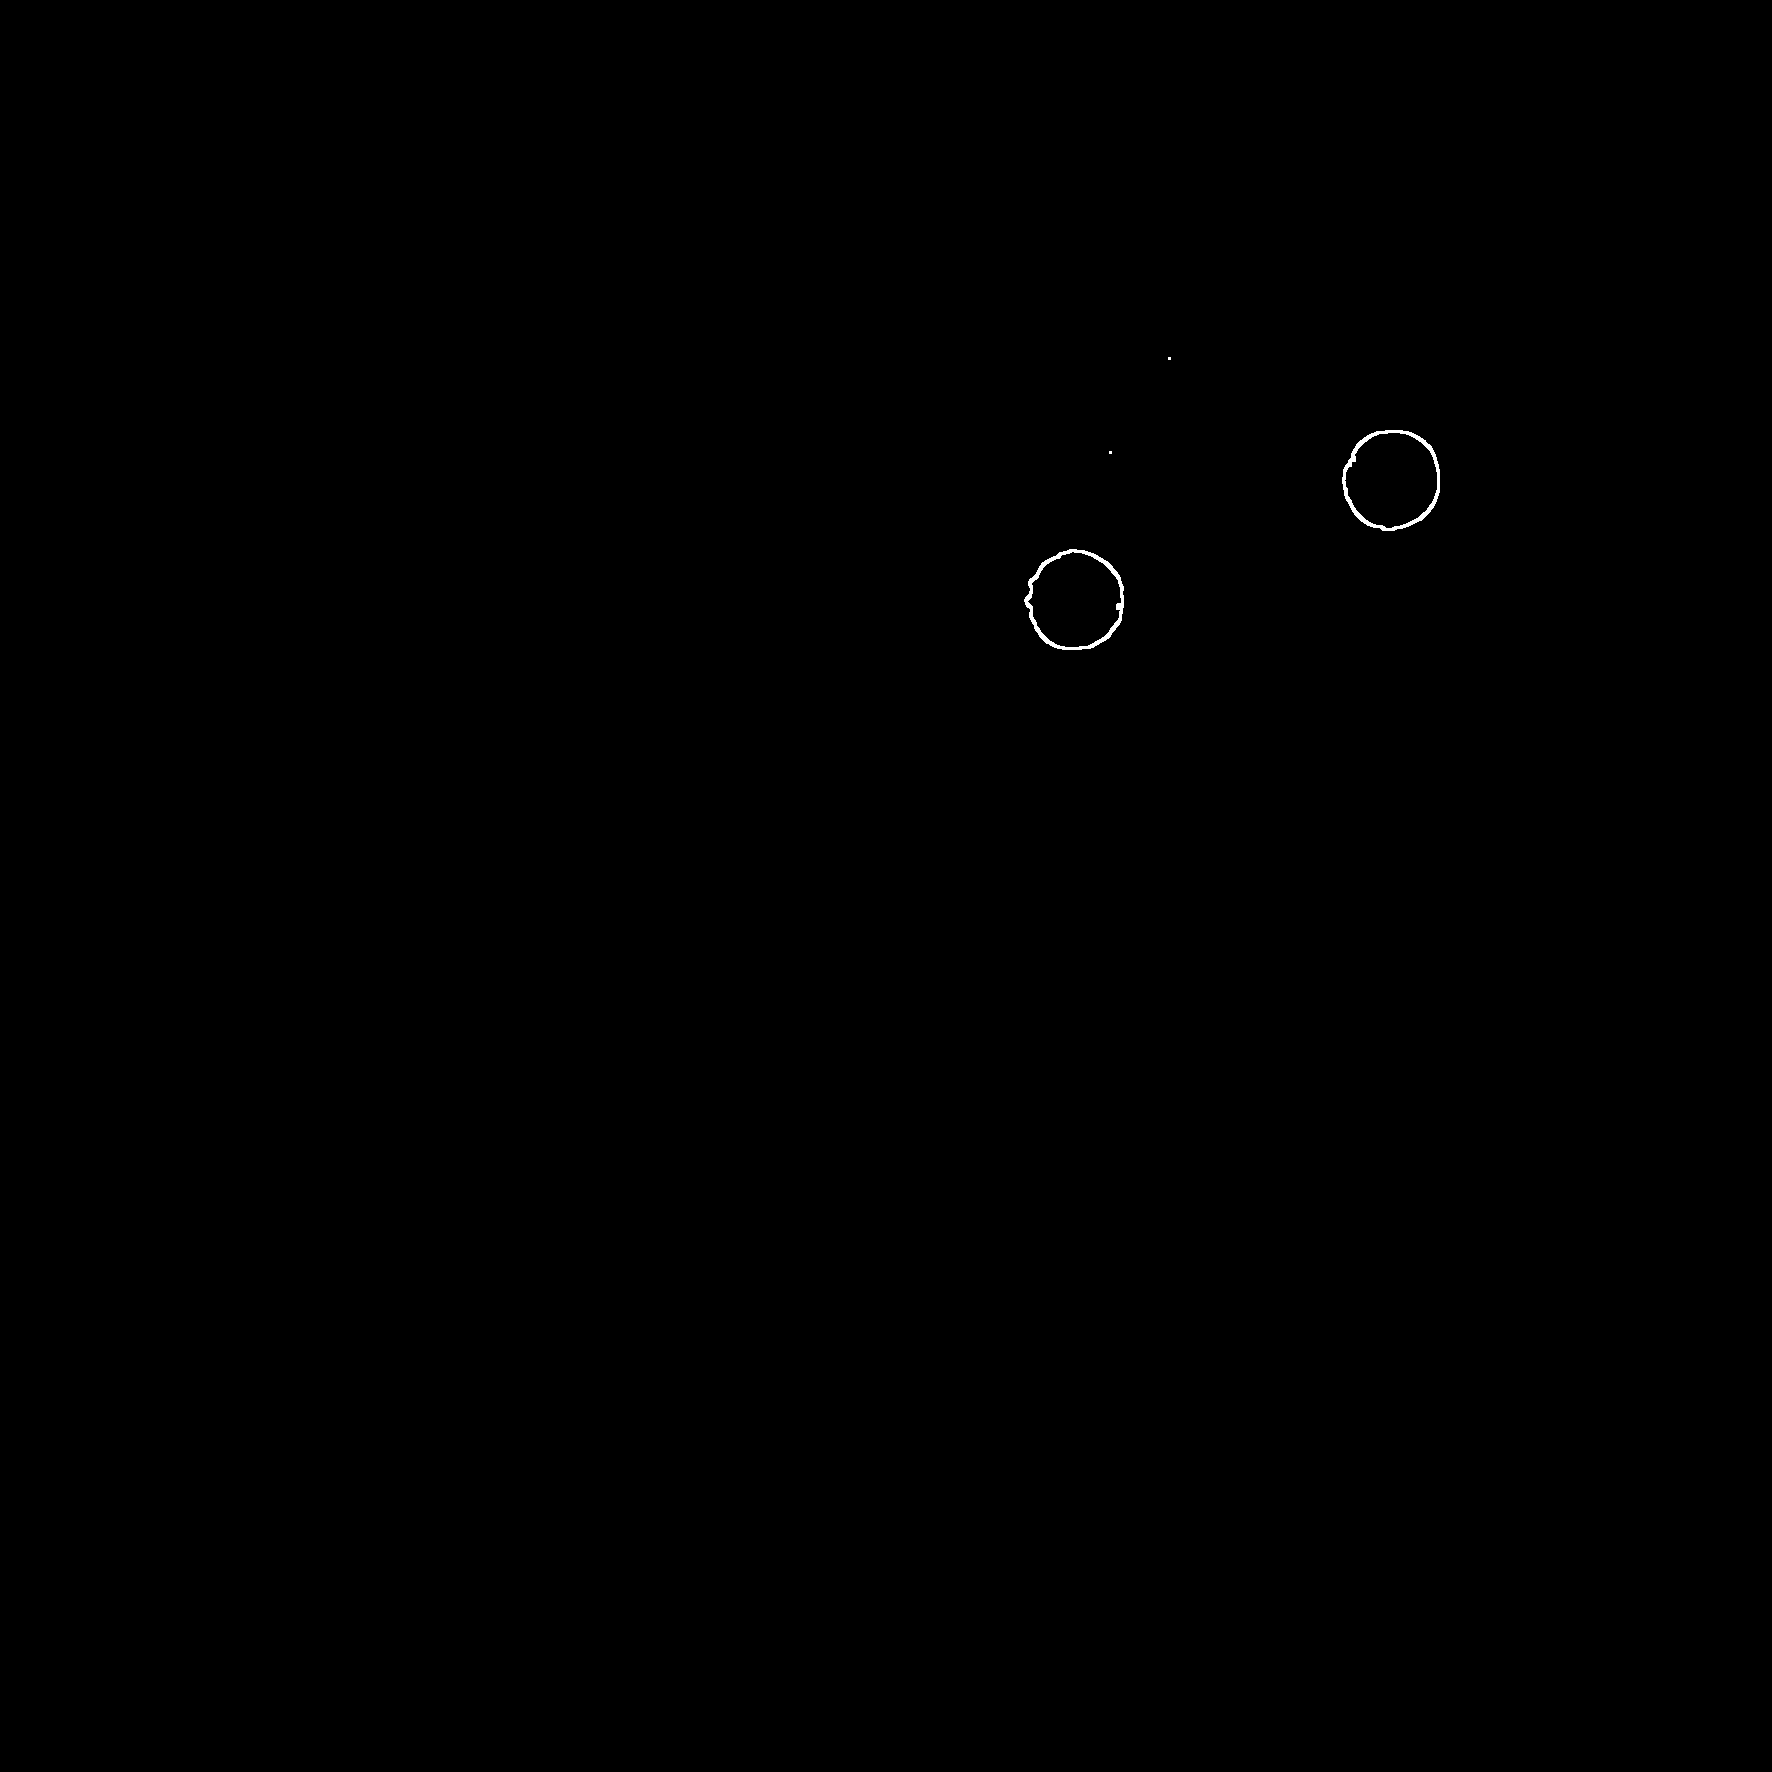

Liczba czarnych kropek: 2


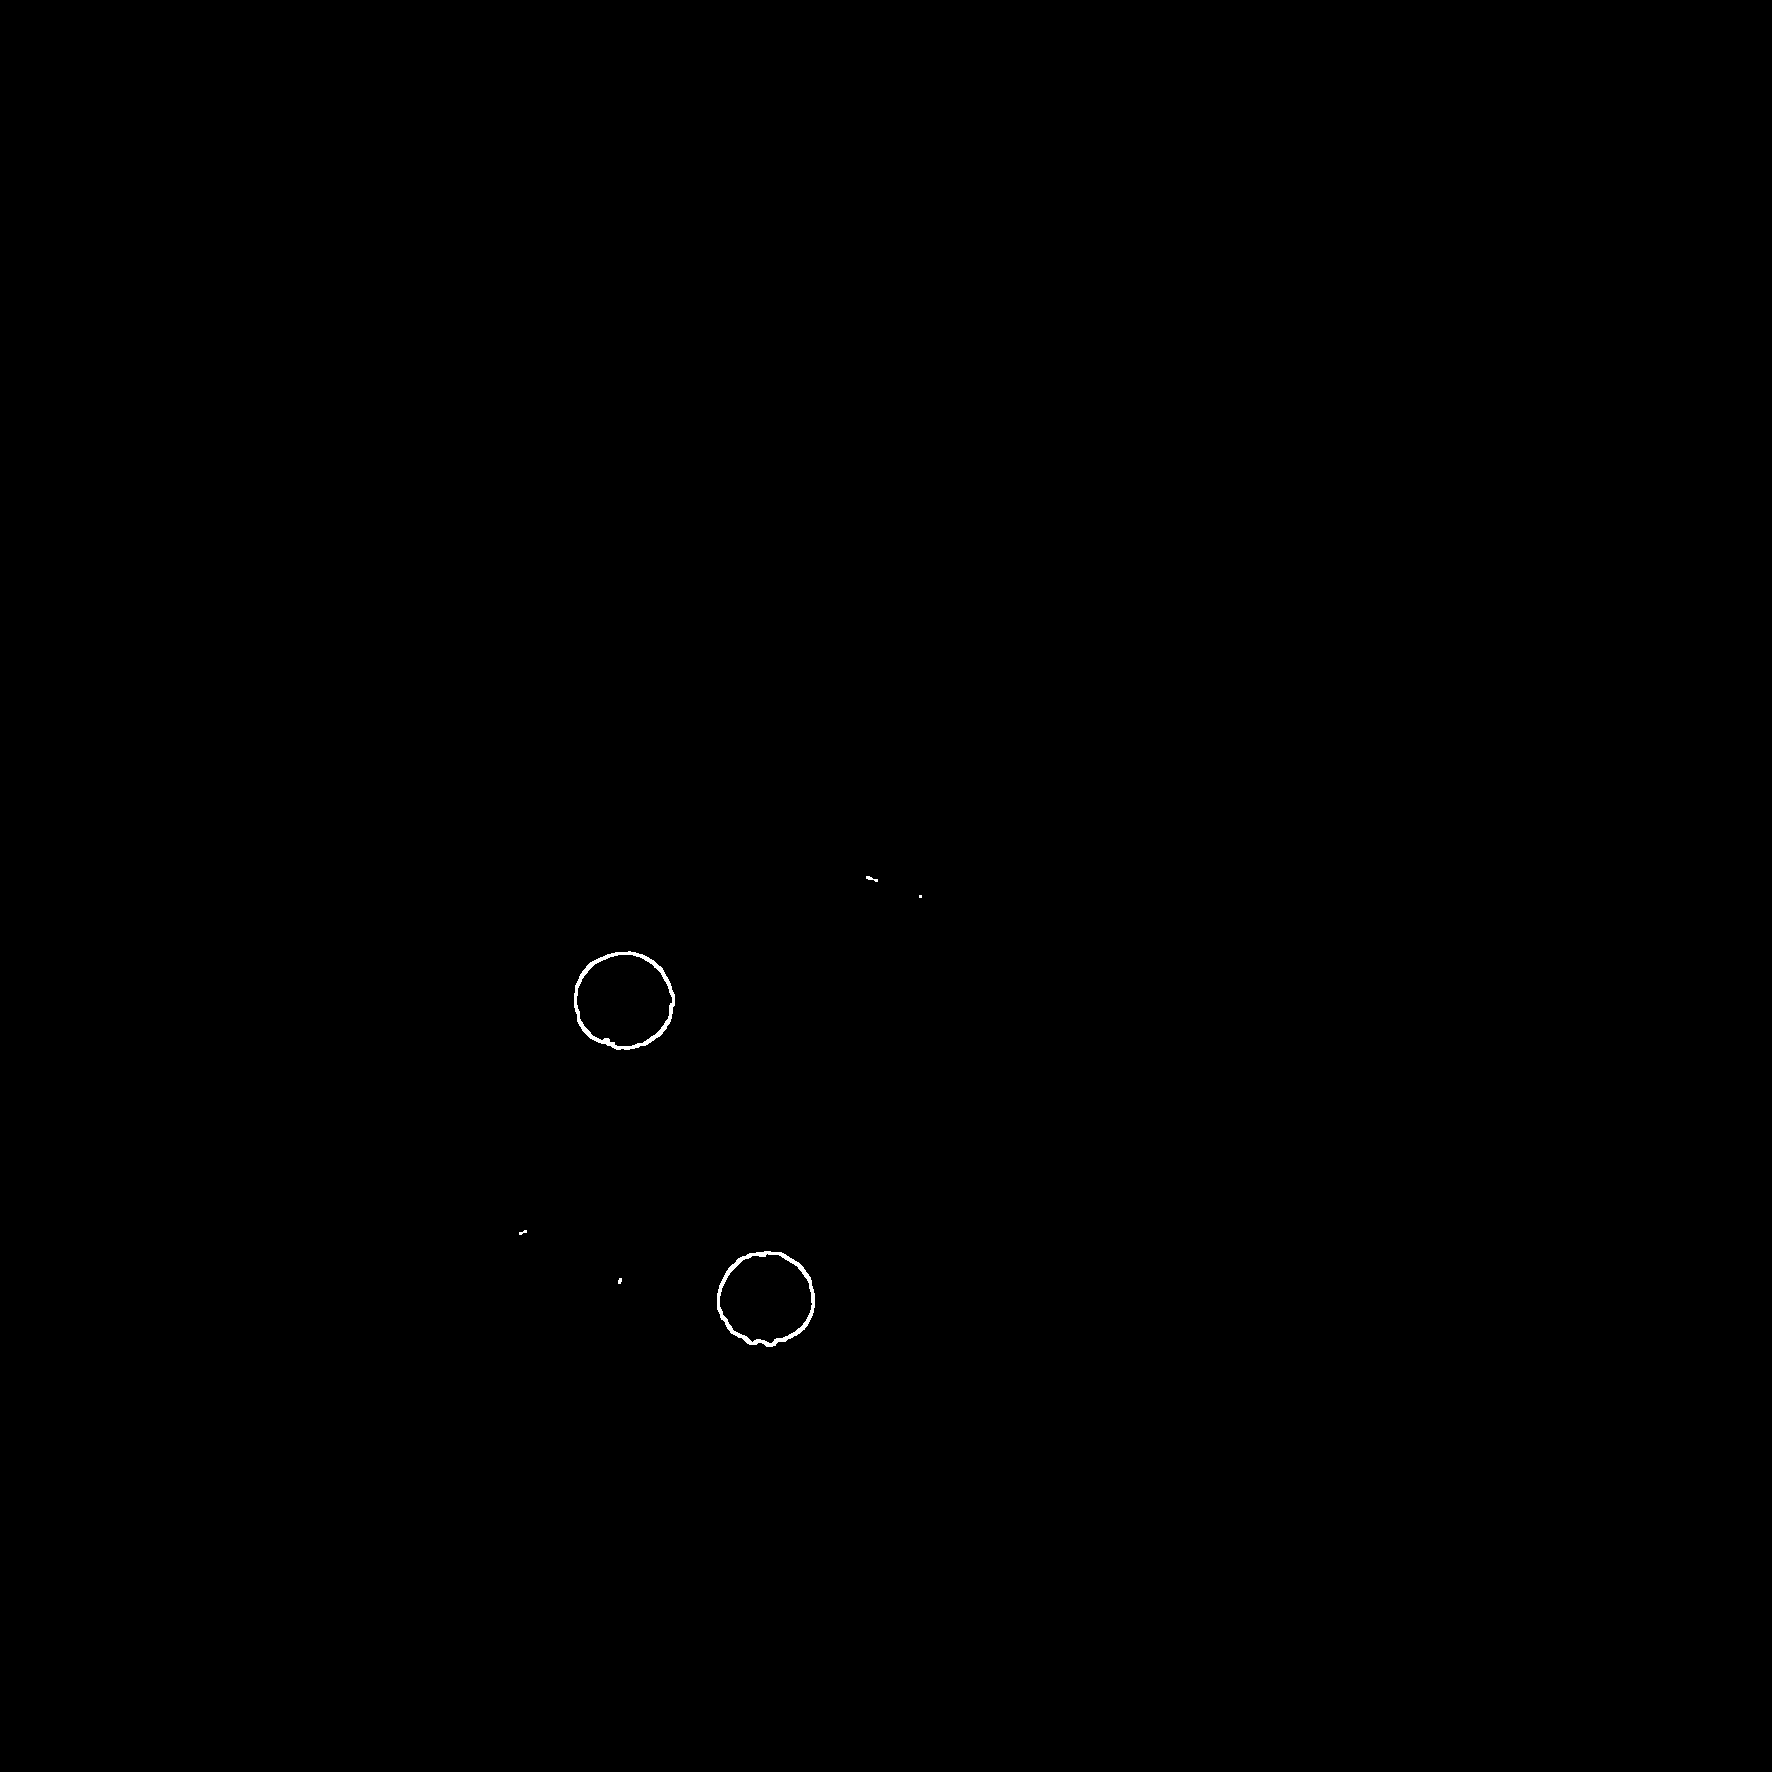

Liczba czarnych kropek: 2


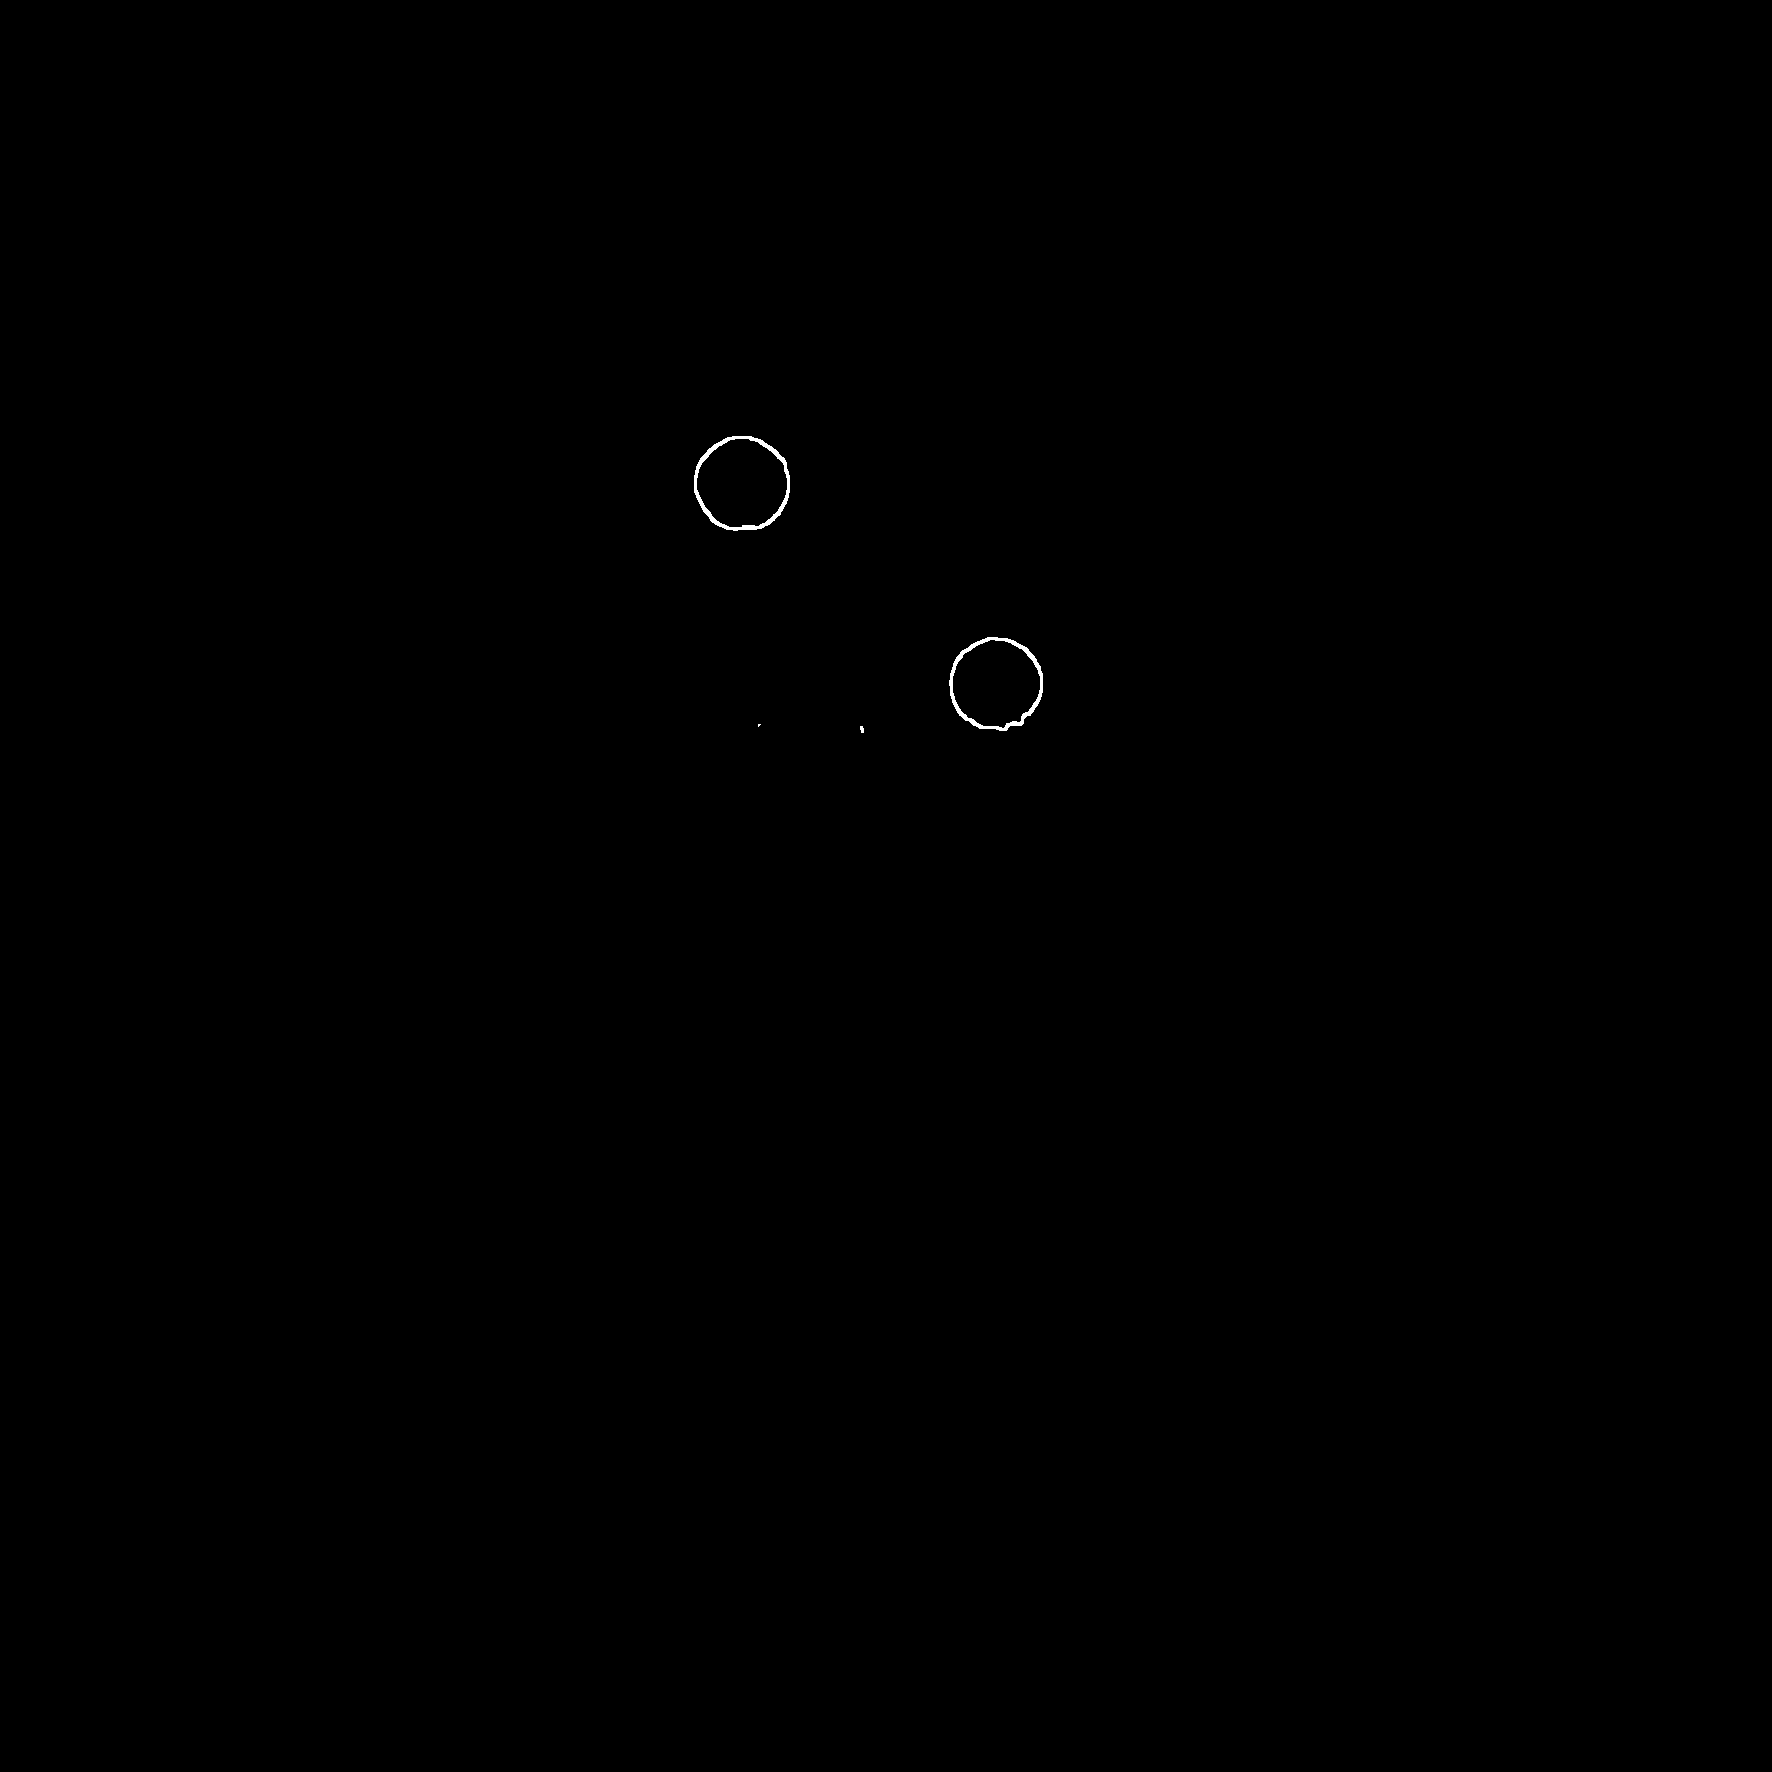

Liczba czarnych kropek: 2


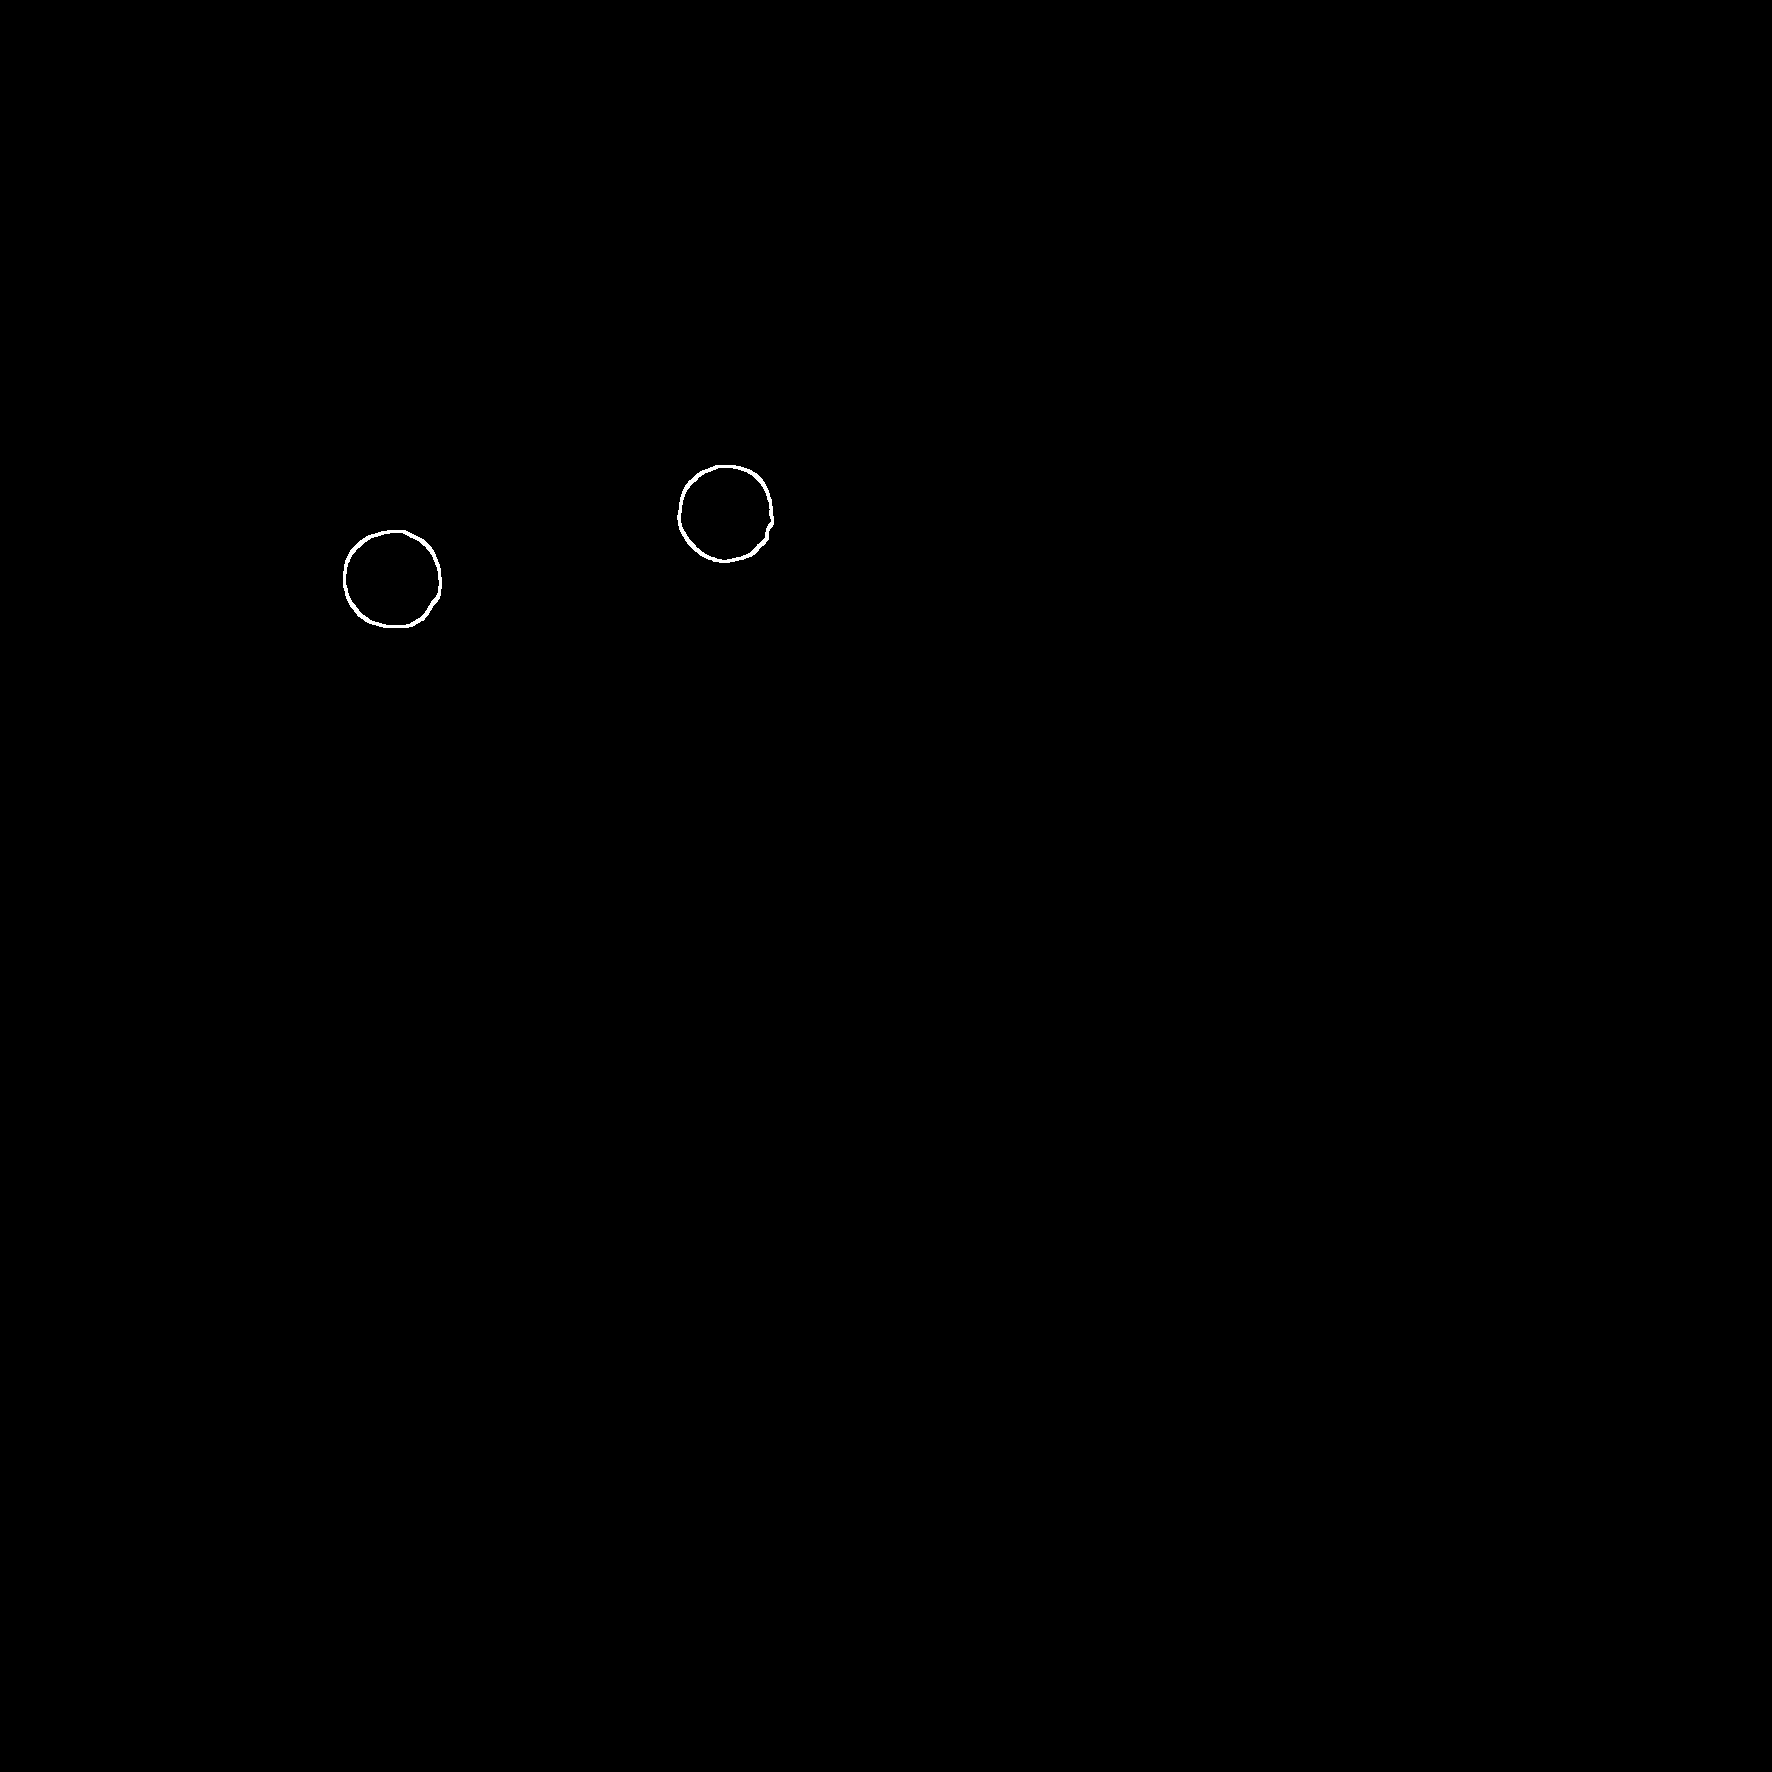

Liczba czarnych kropek: 2


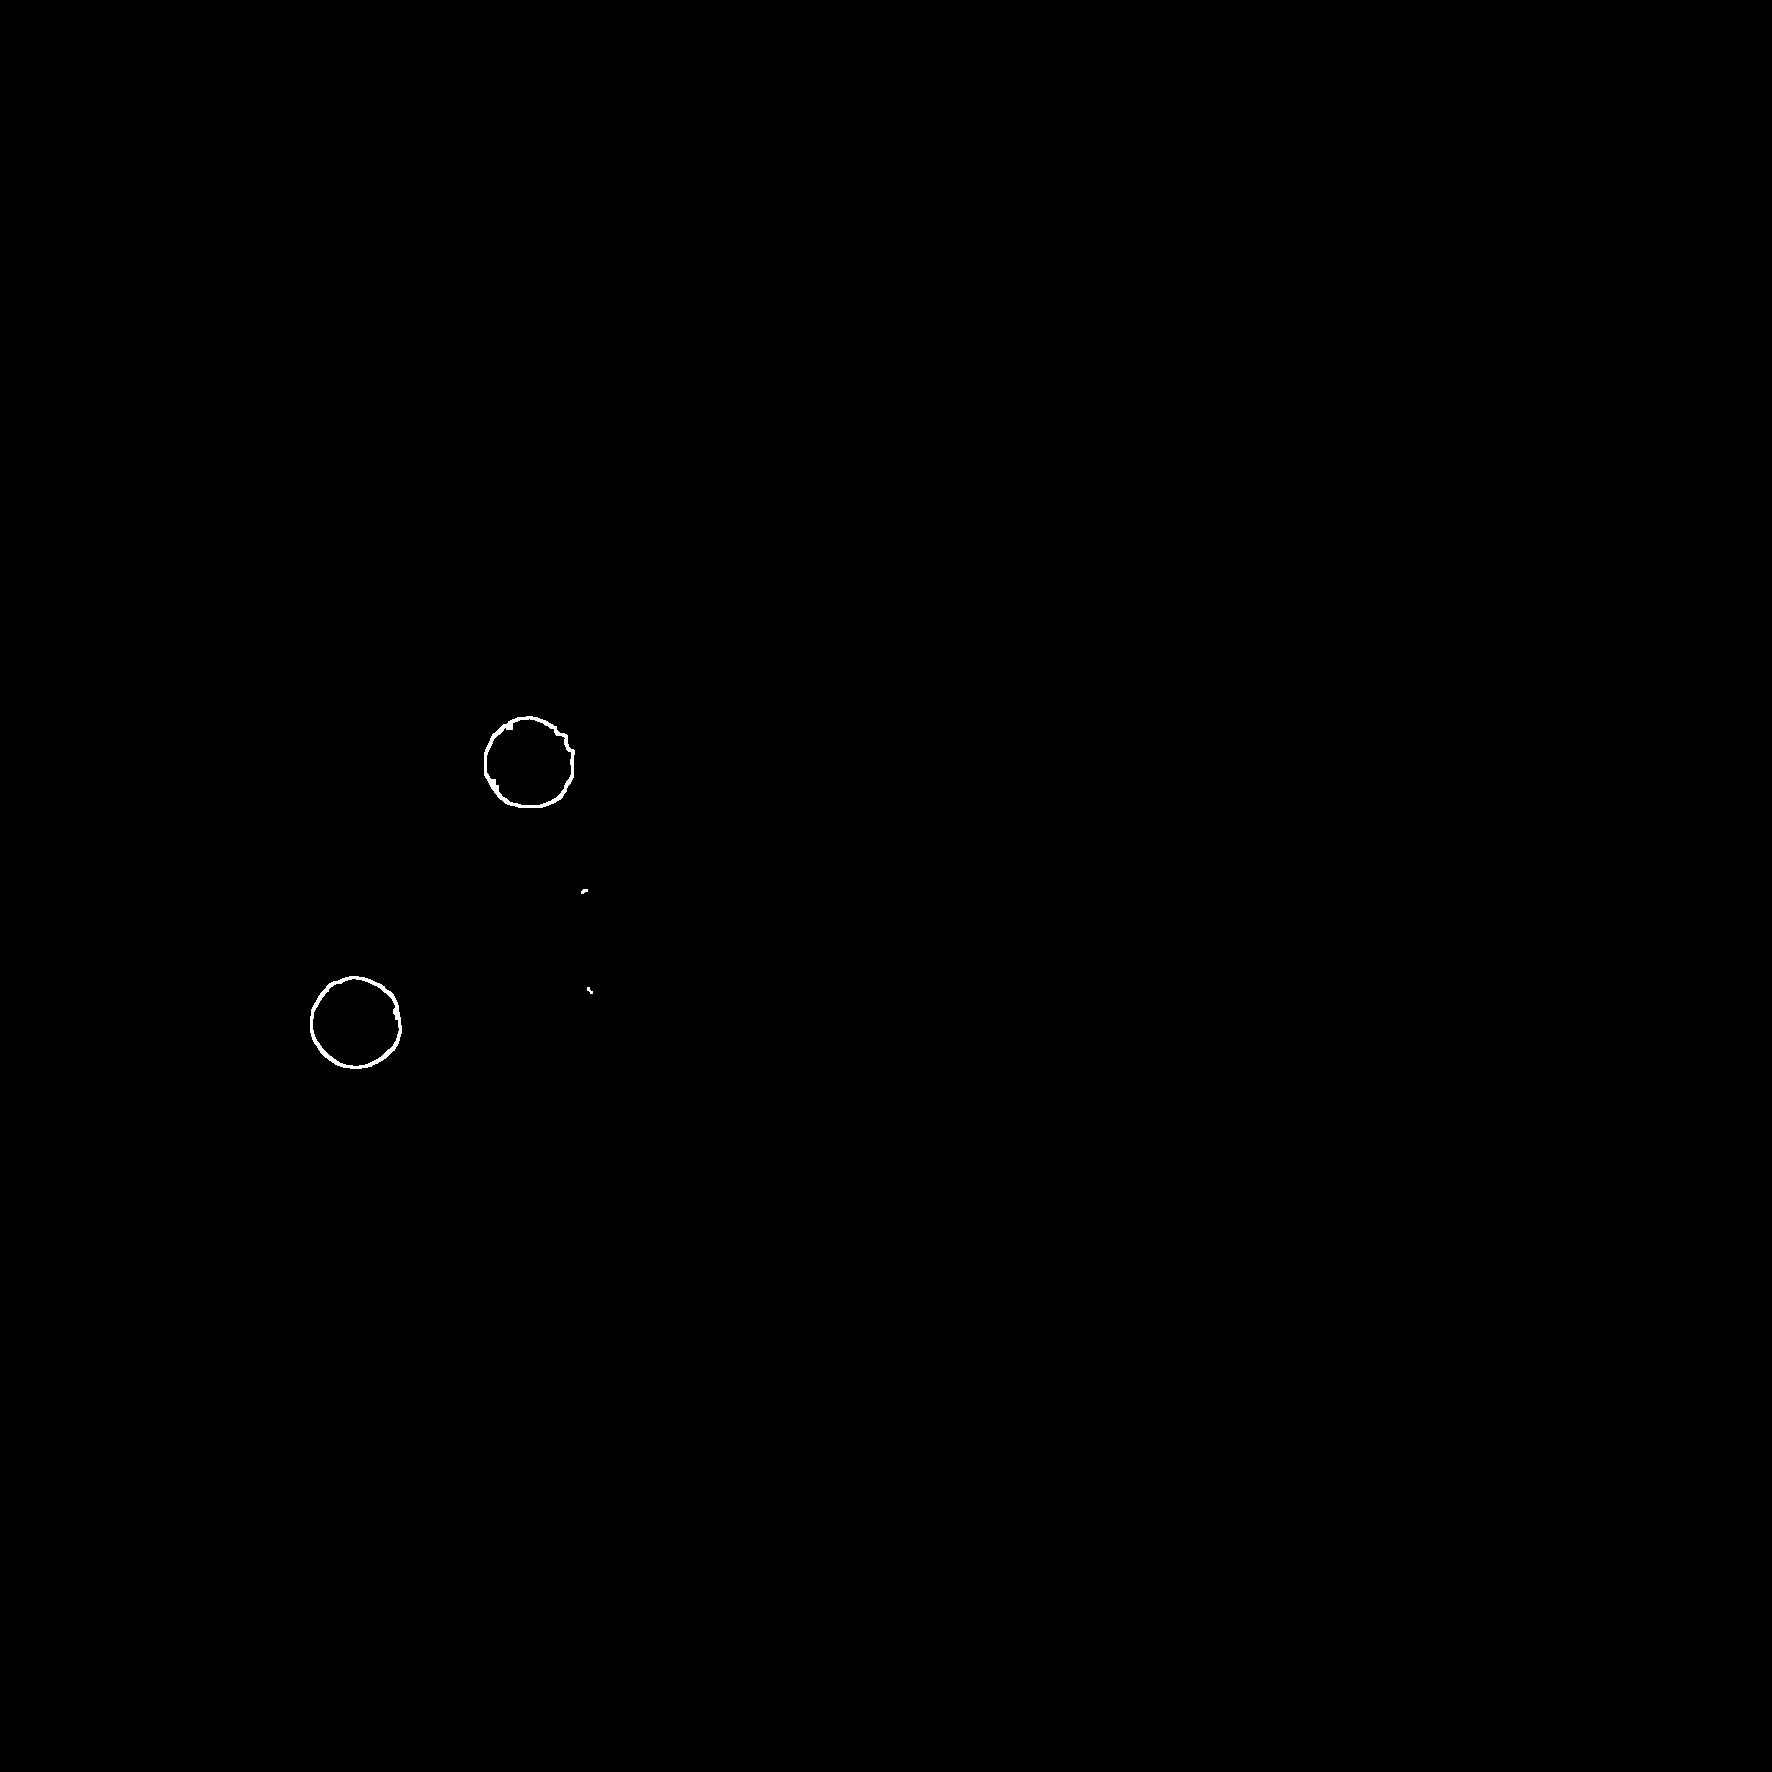

Liczba czarnych kropek: 2


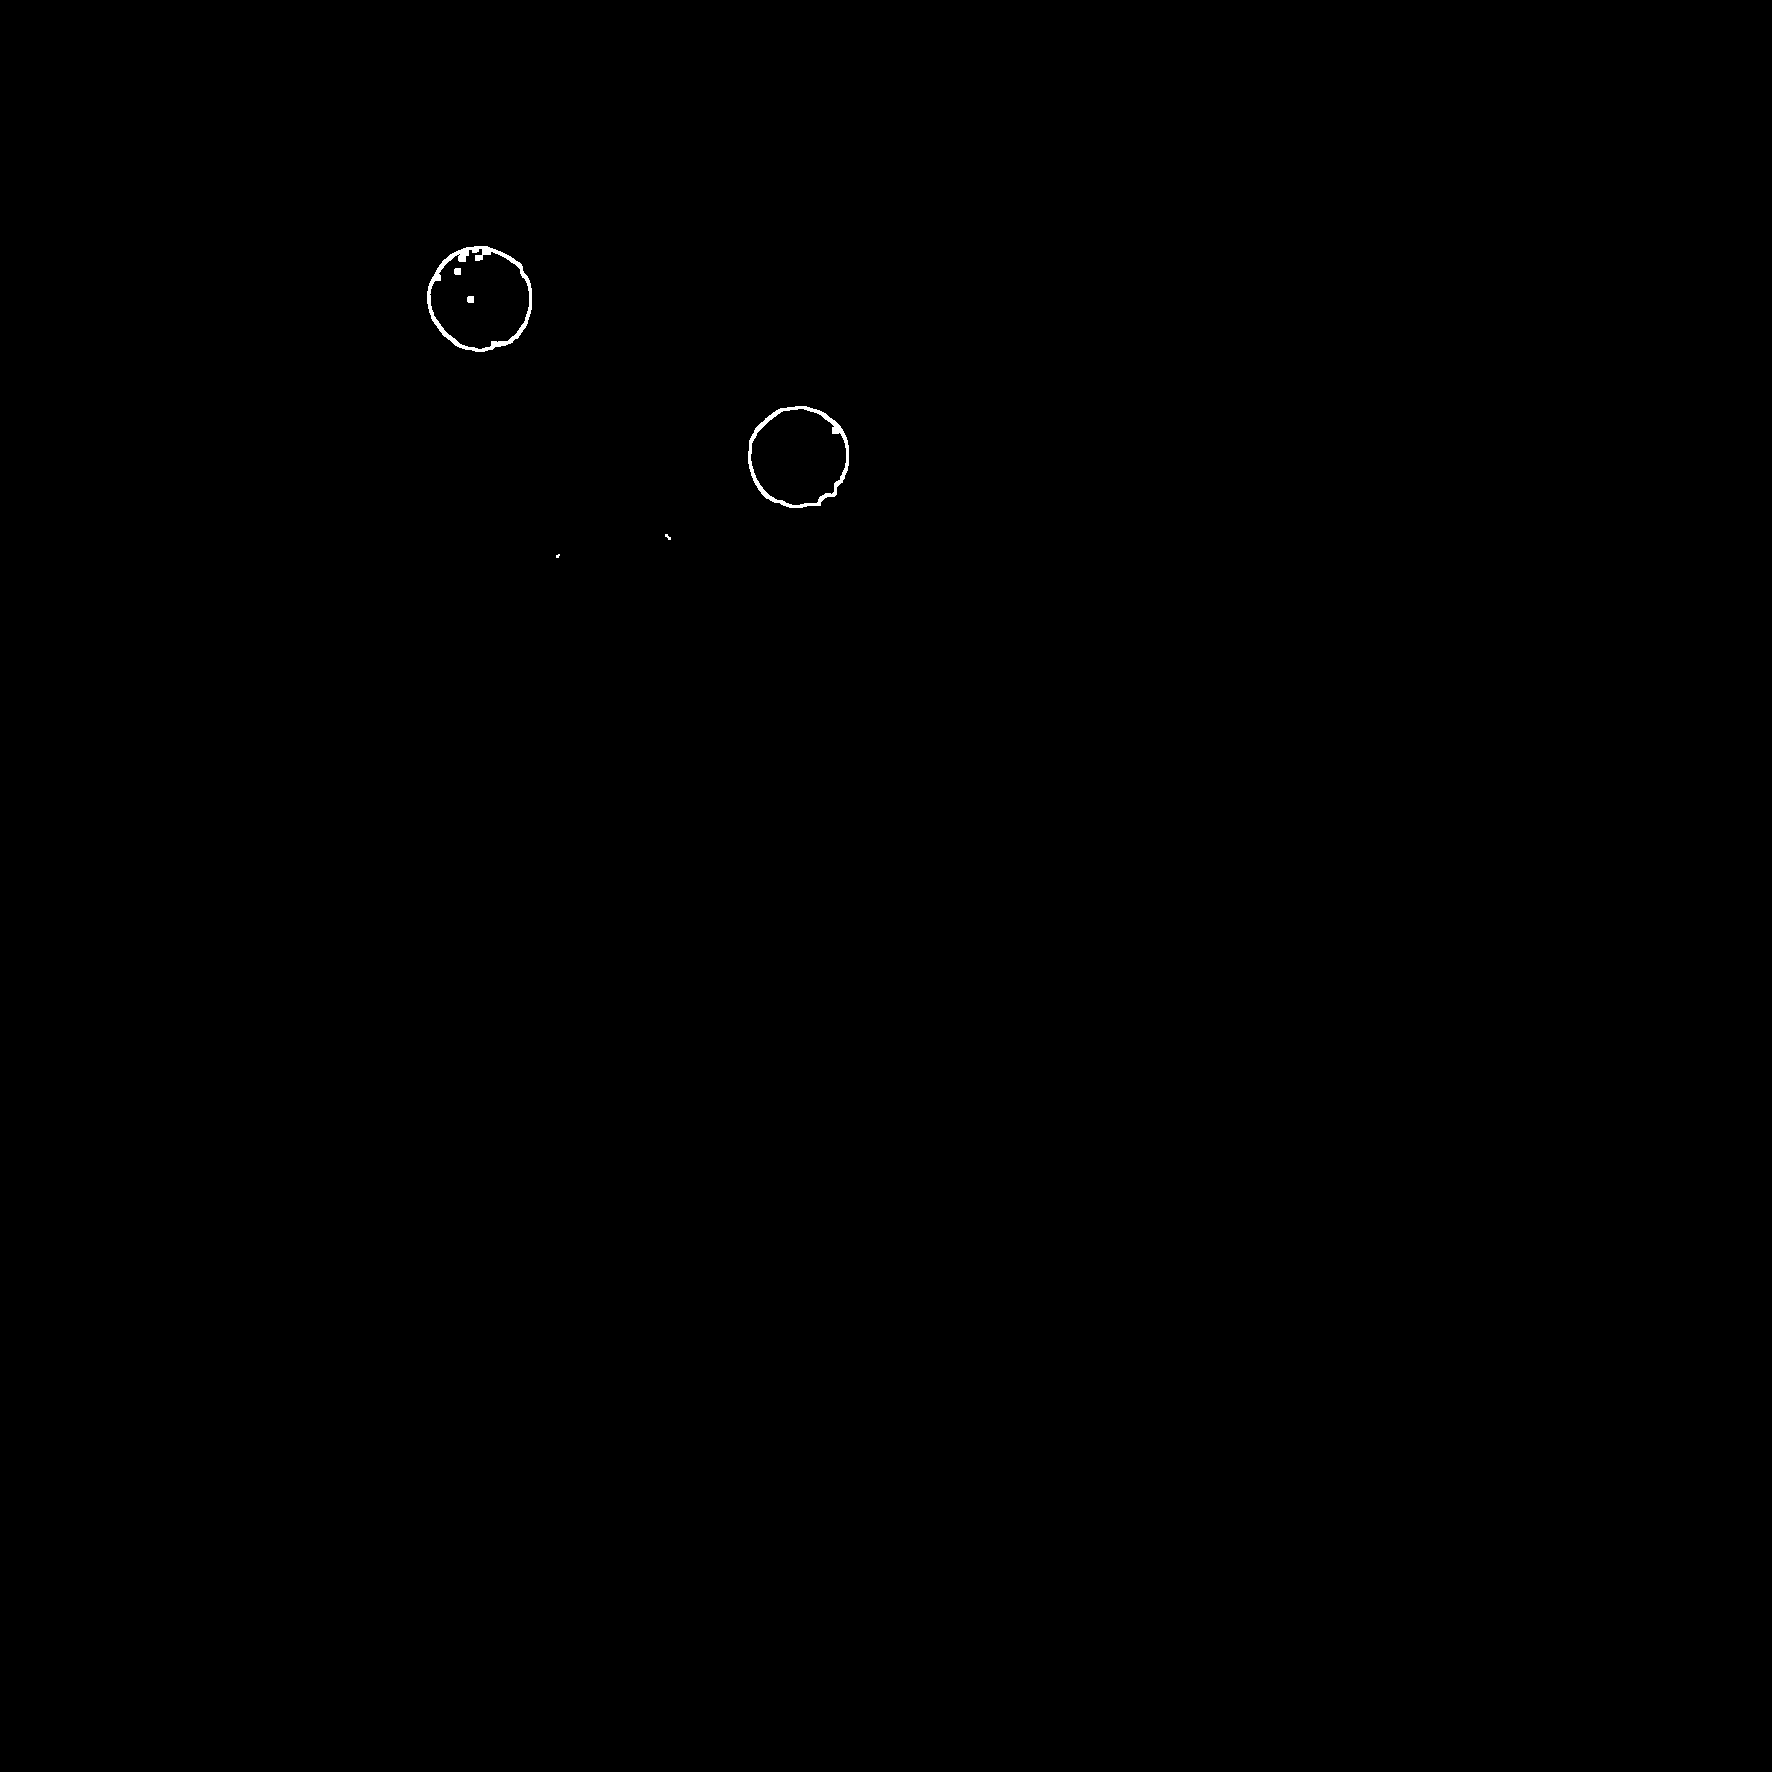

Liczba czarnych kropek: 2


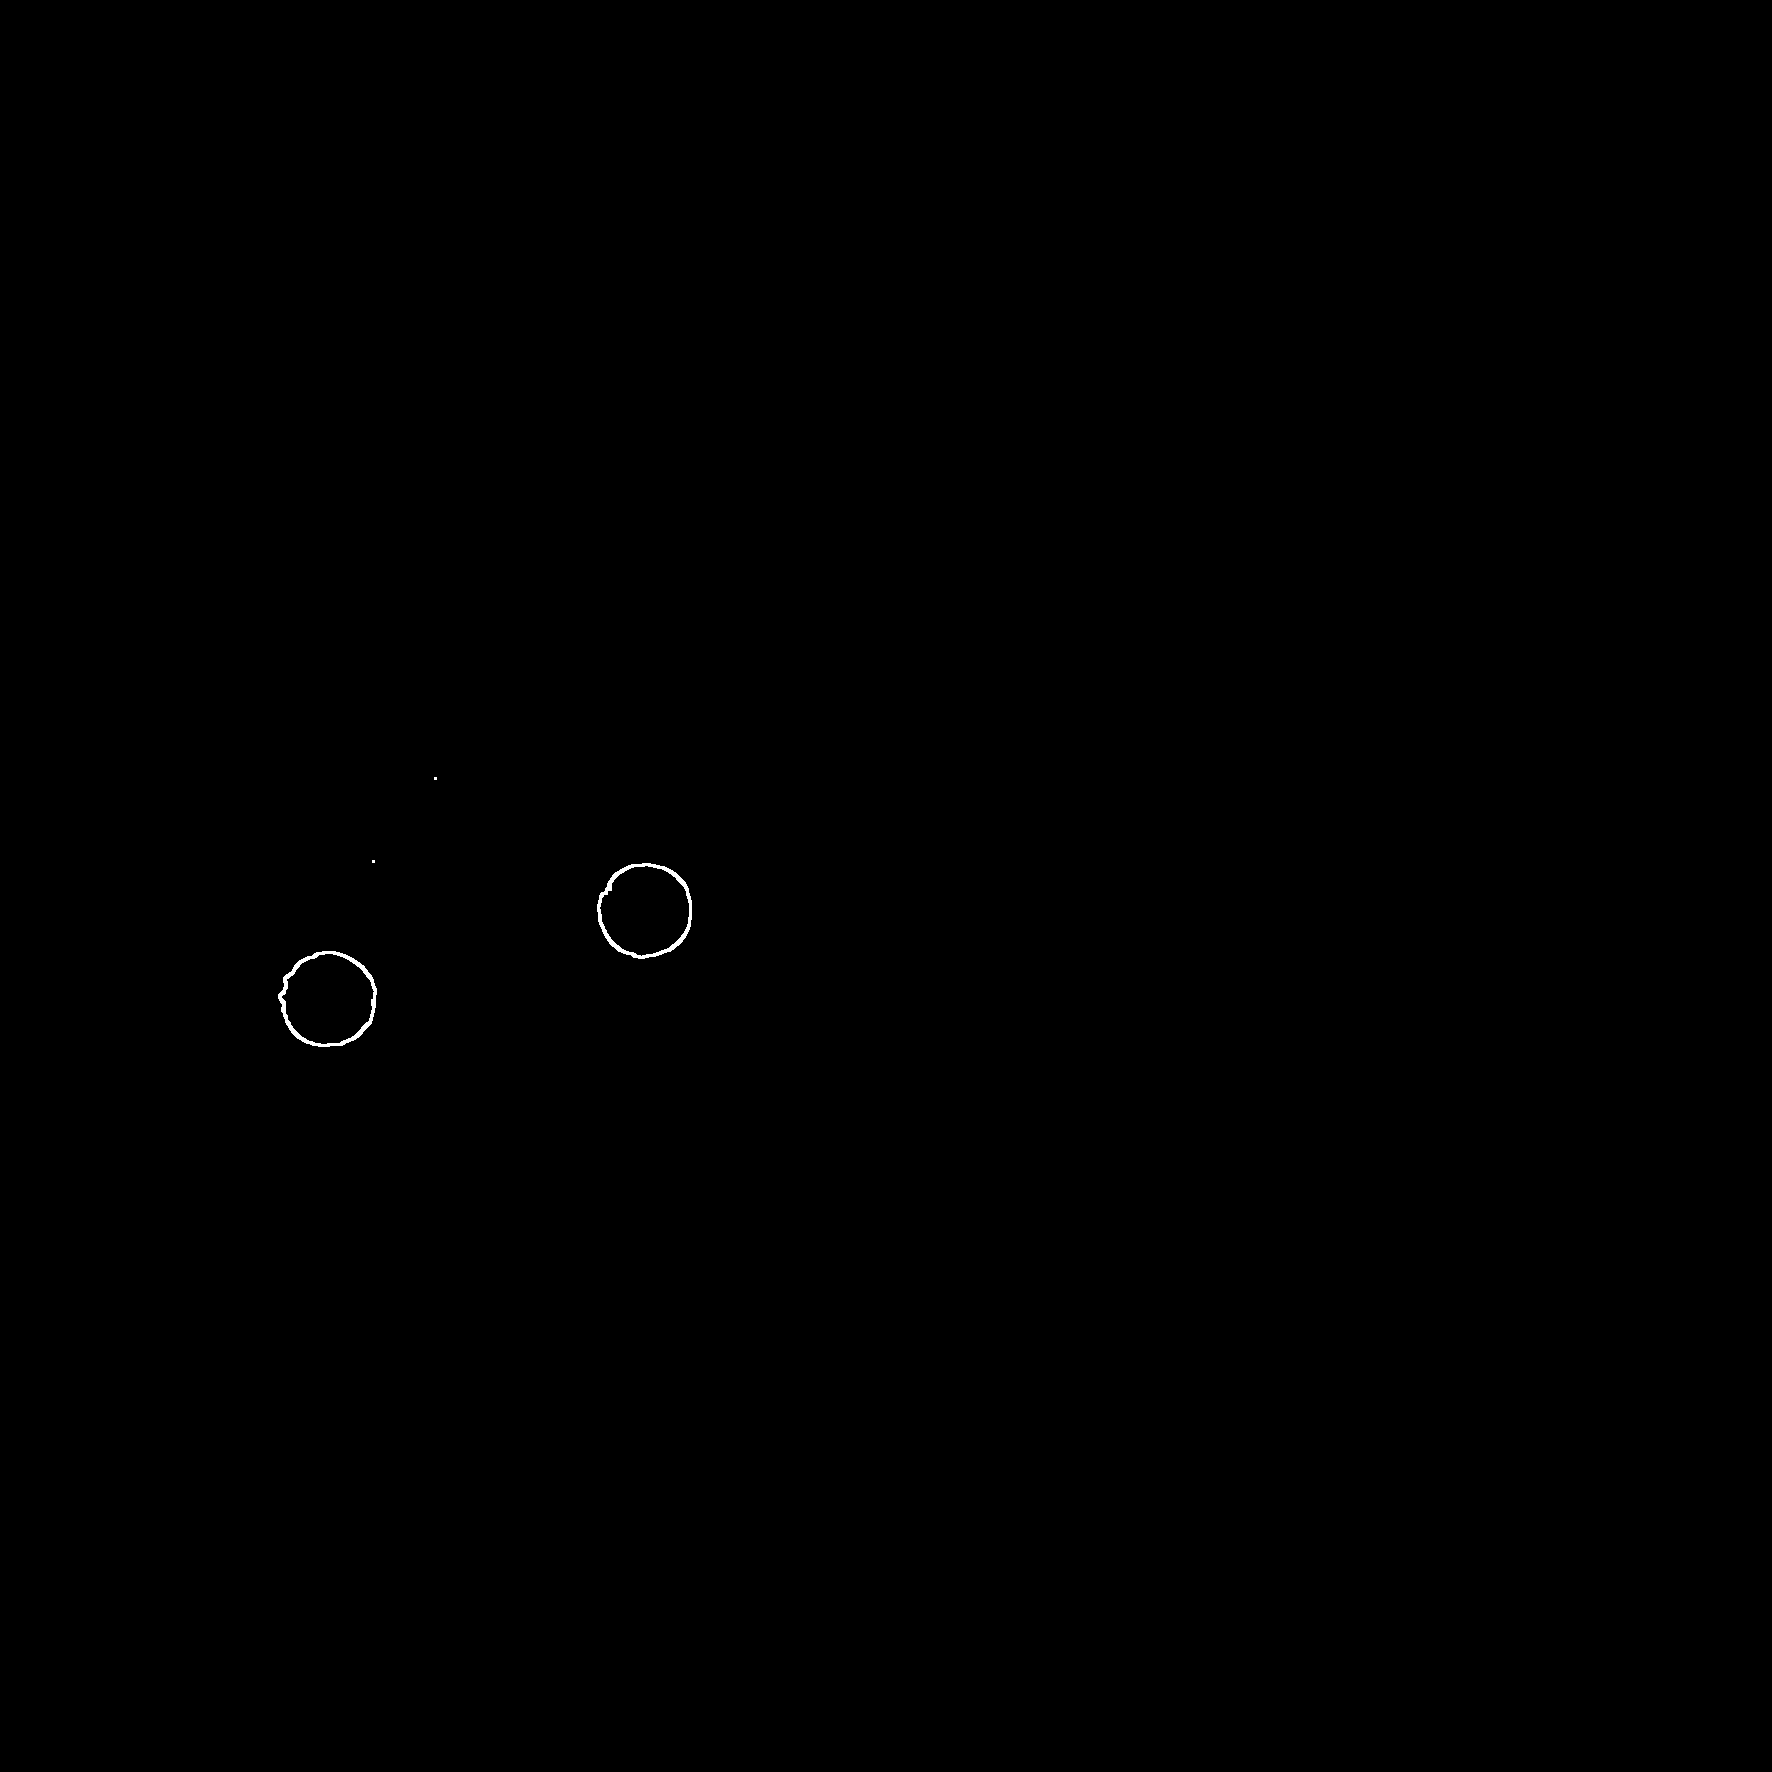

Liczba czarnych kropek: 2


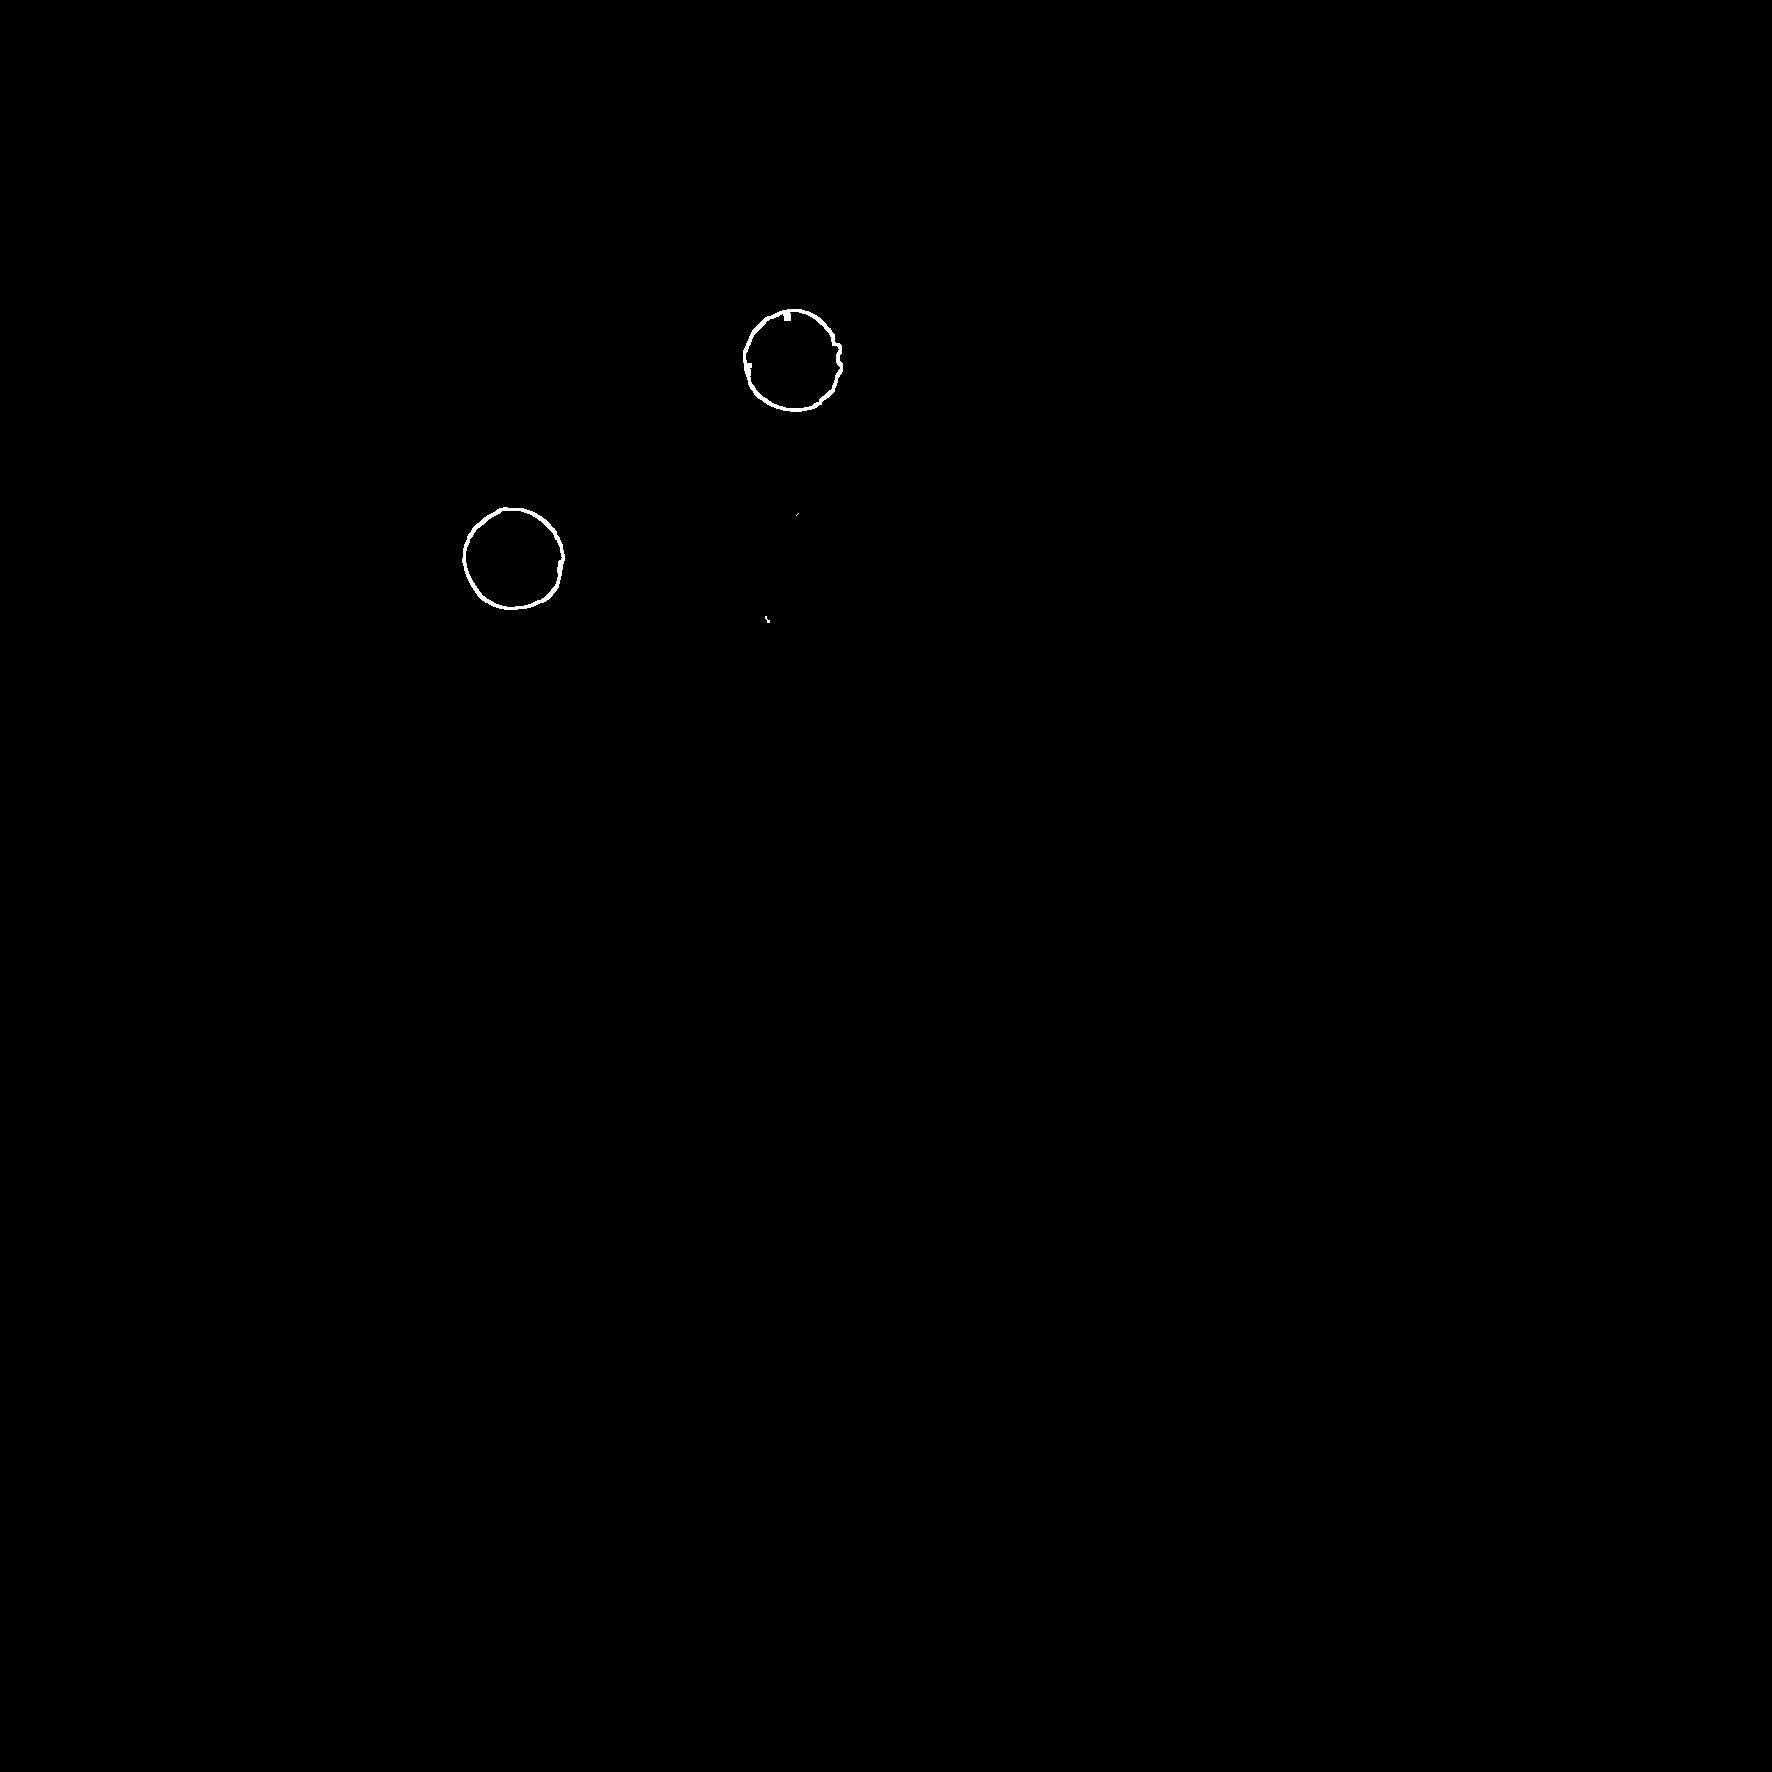

Liczba czarnych kropek: 2


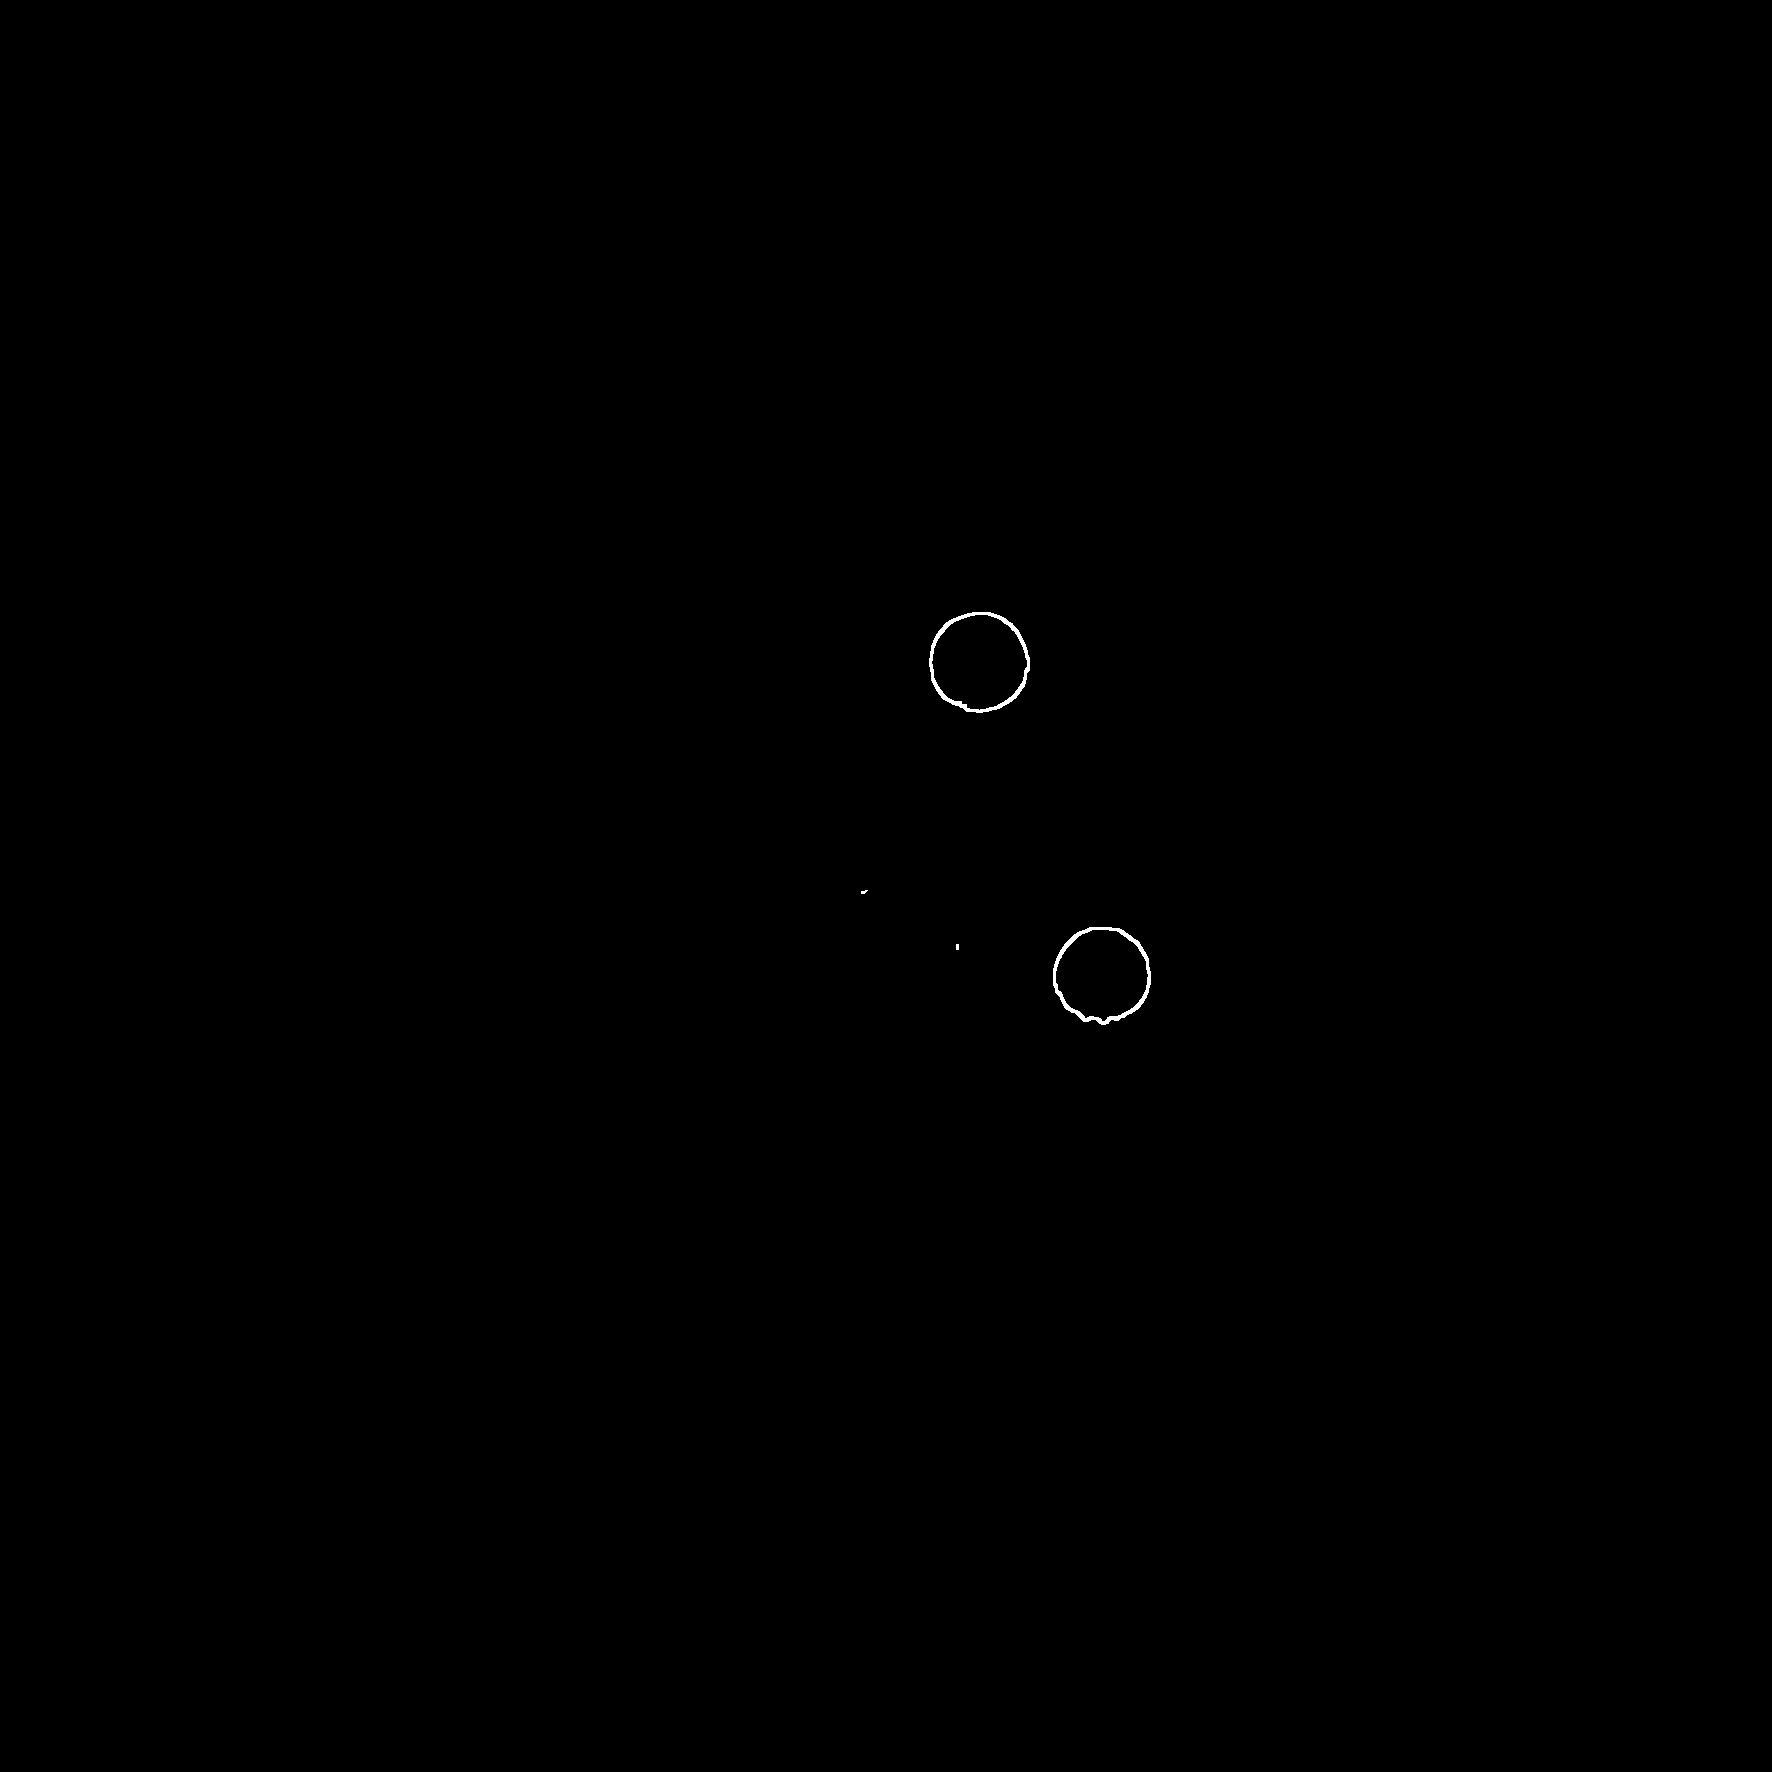

Liczba czarnych kropek: 2


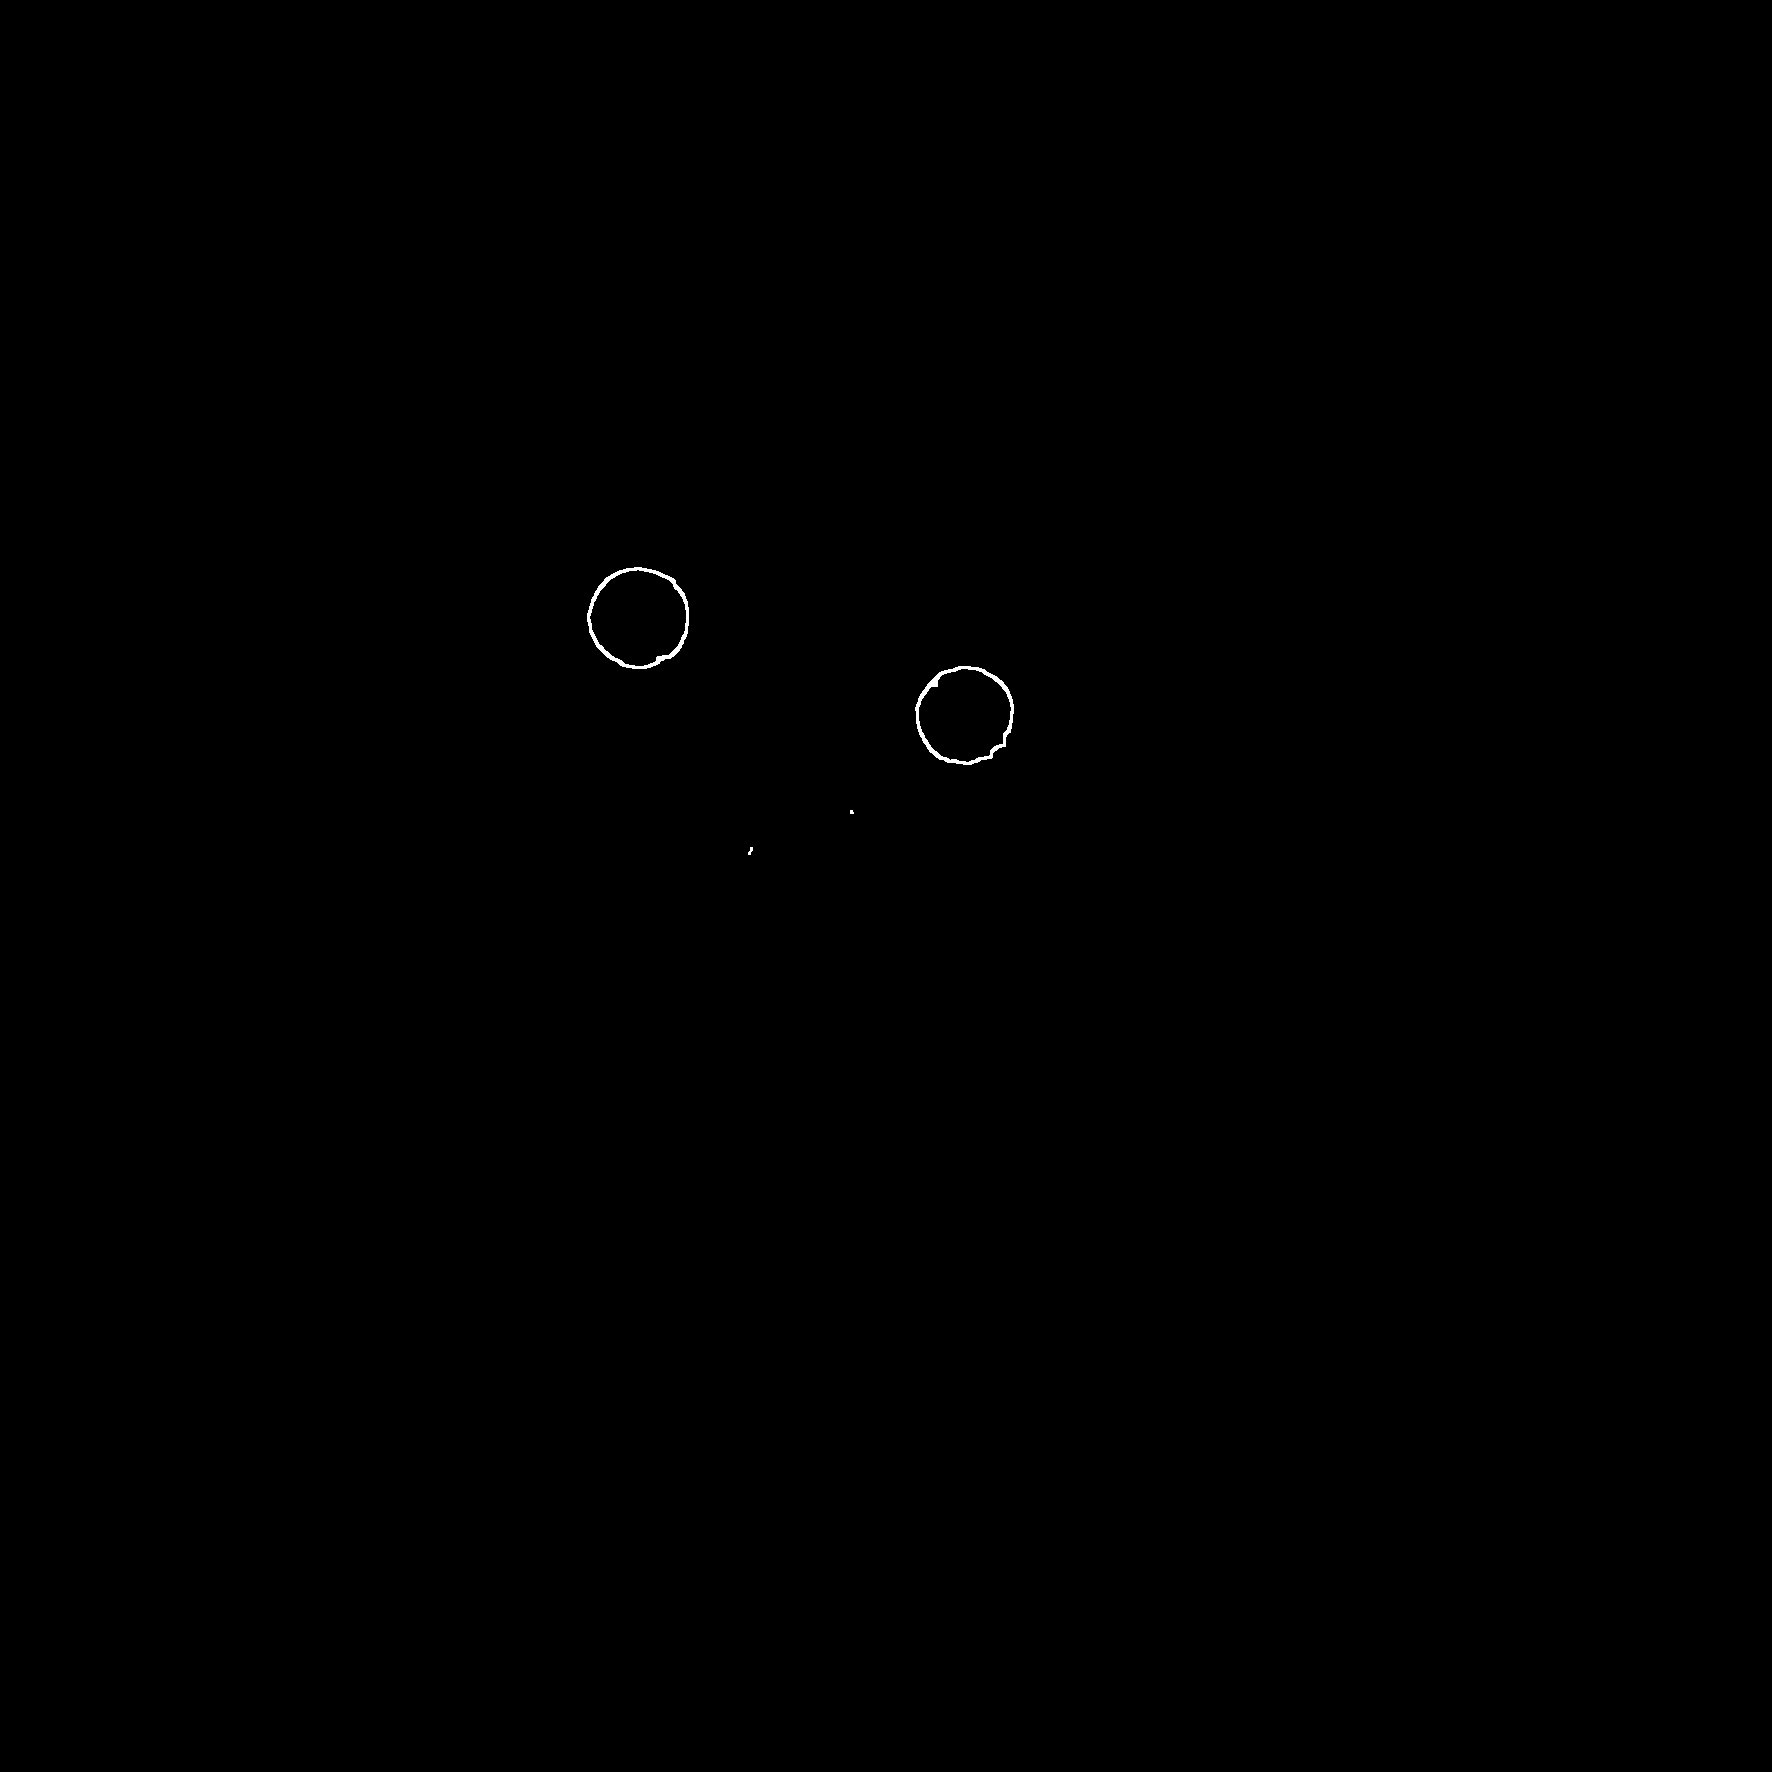

Liczba czarnych kropek: 2


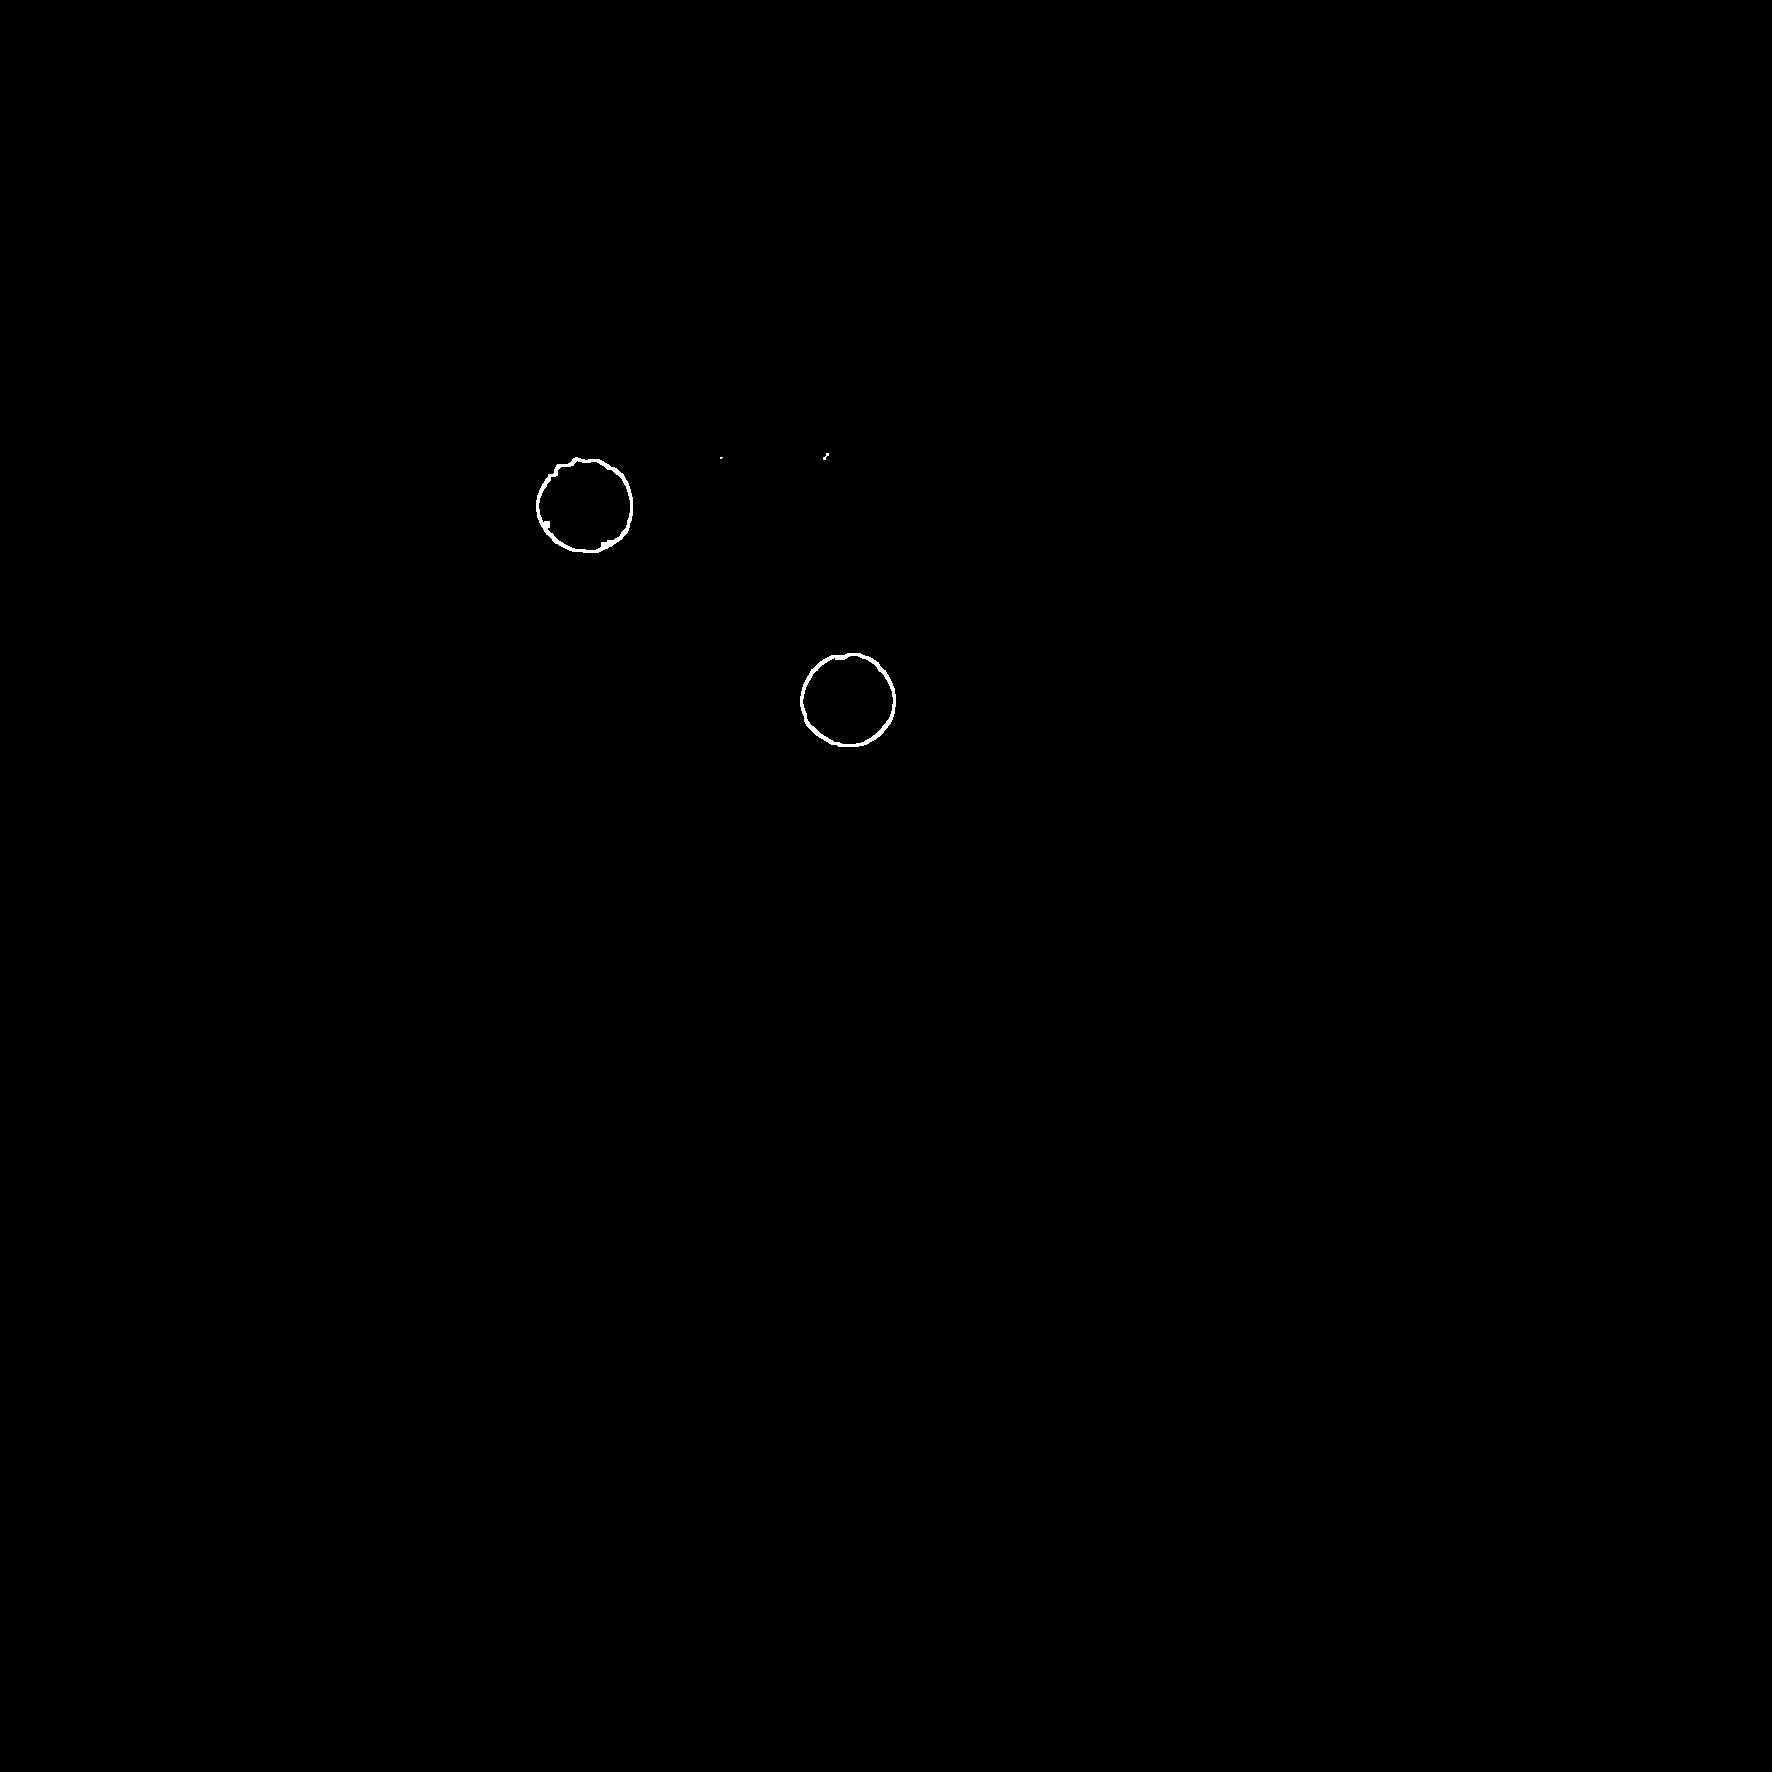

Liczba czarnych kropek: 2


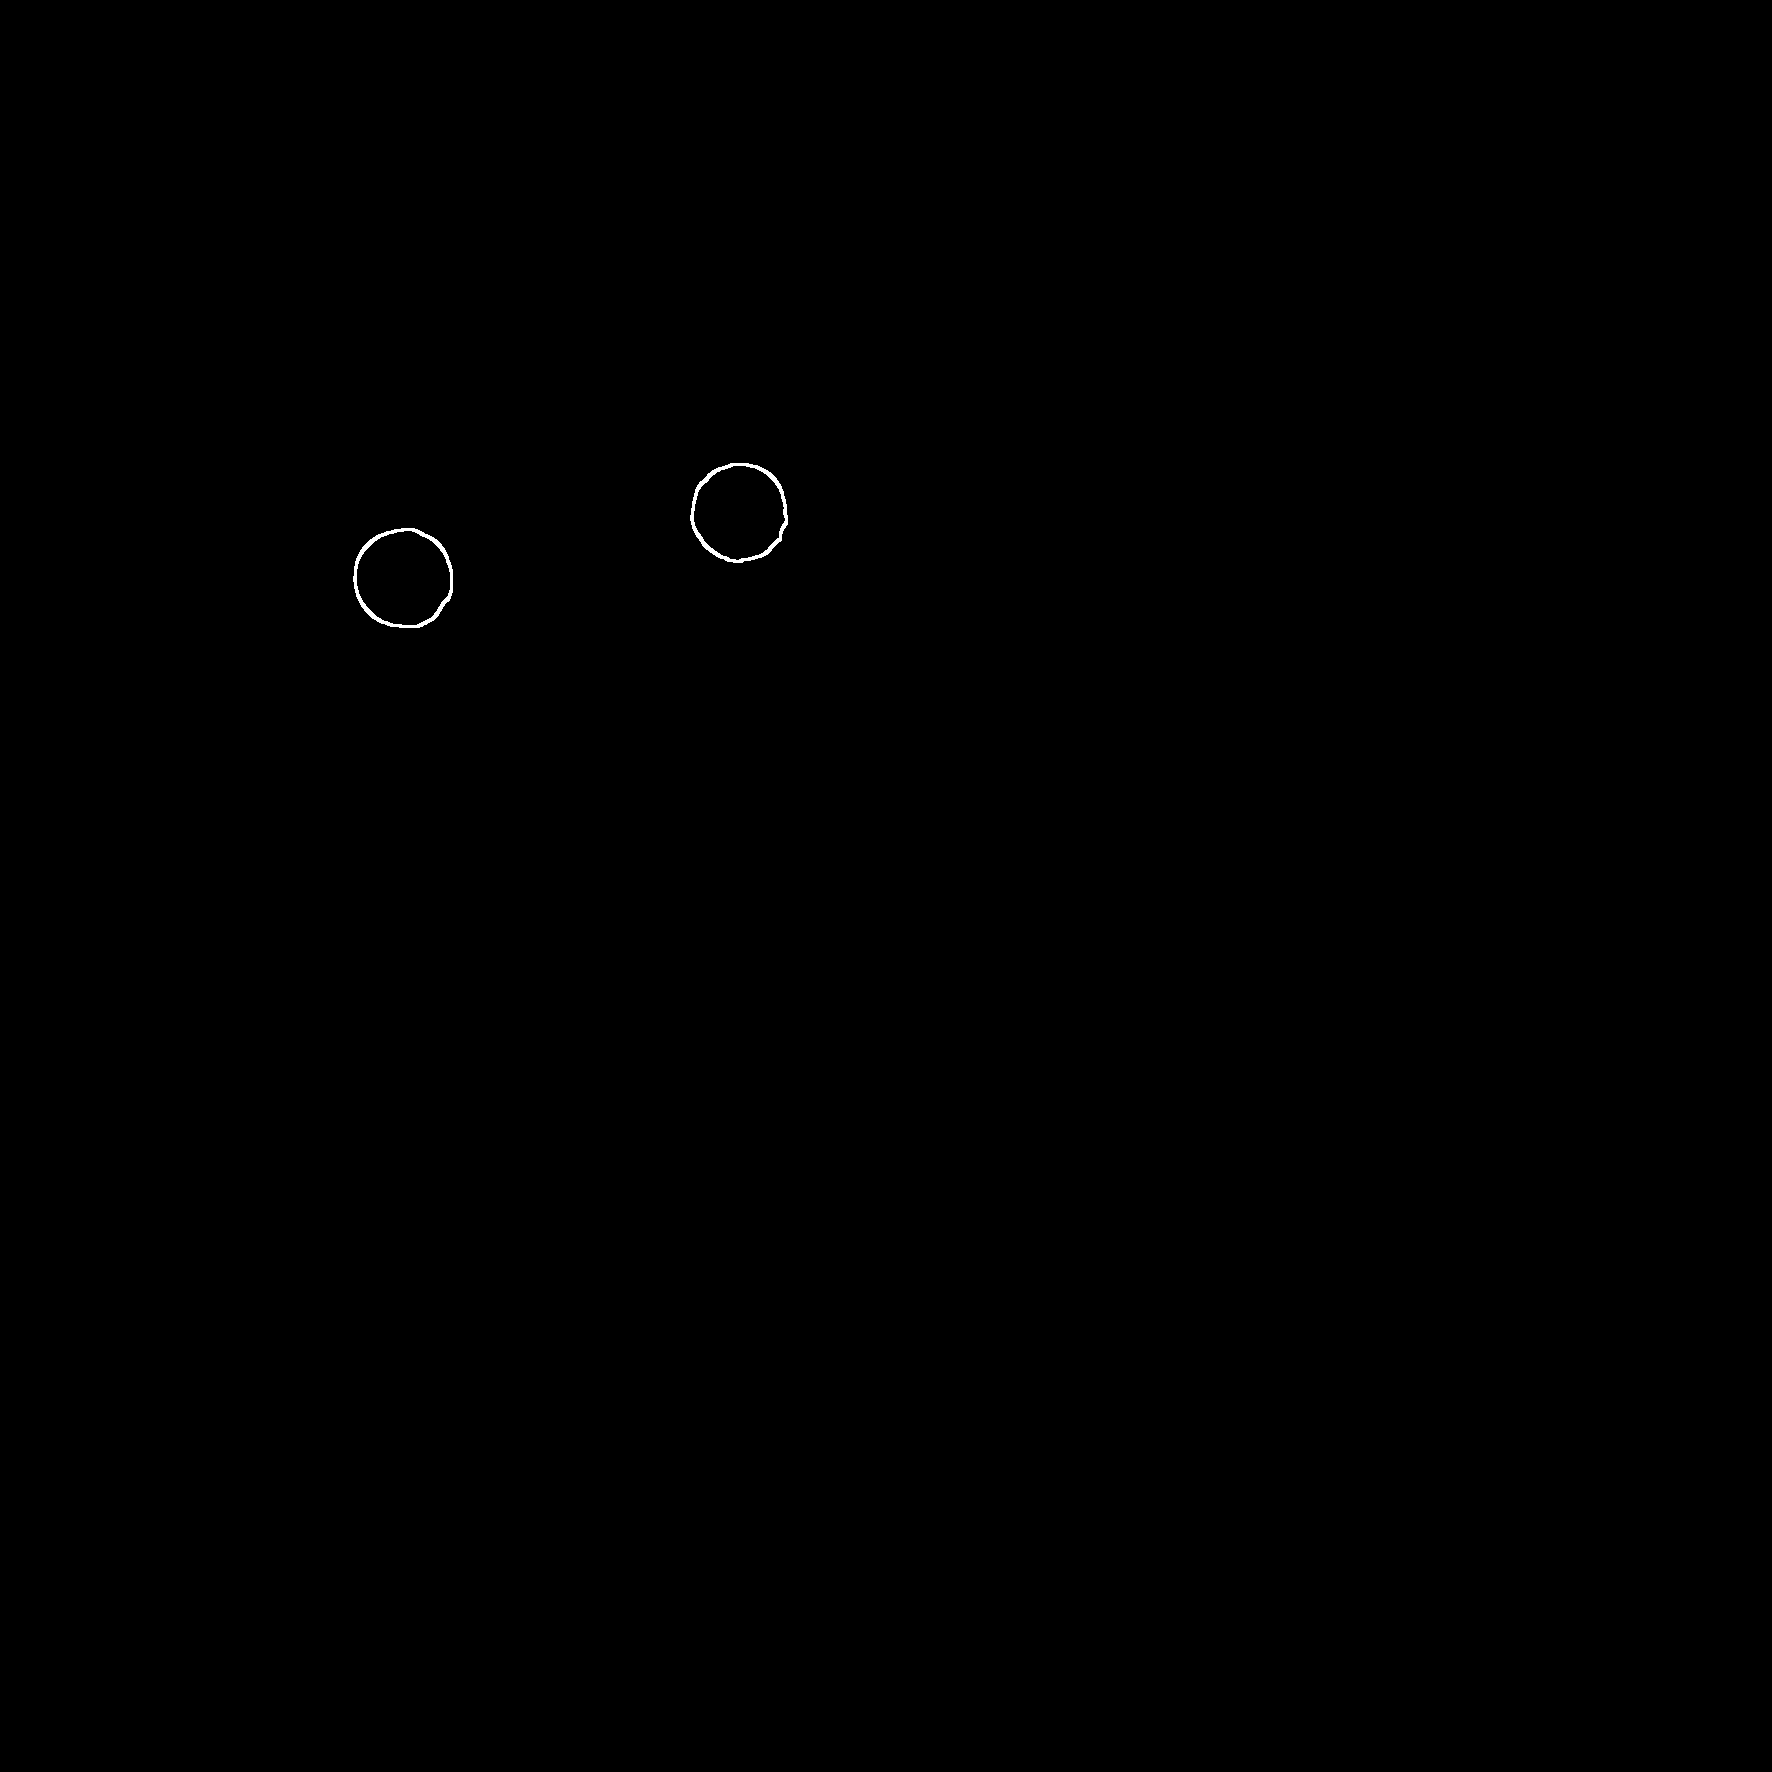

Liczba czarnych kropek: 2


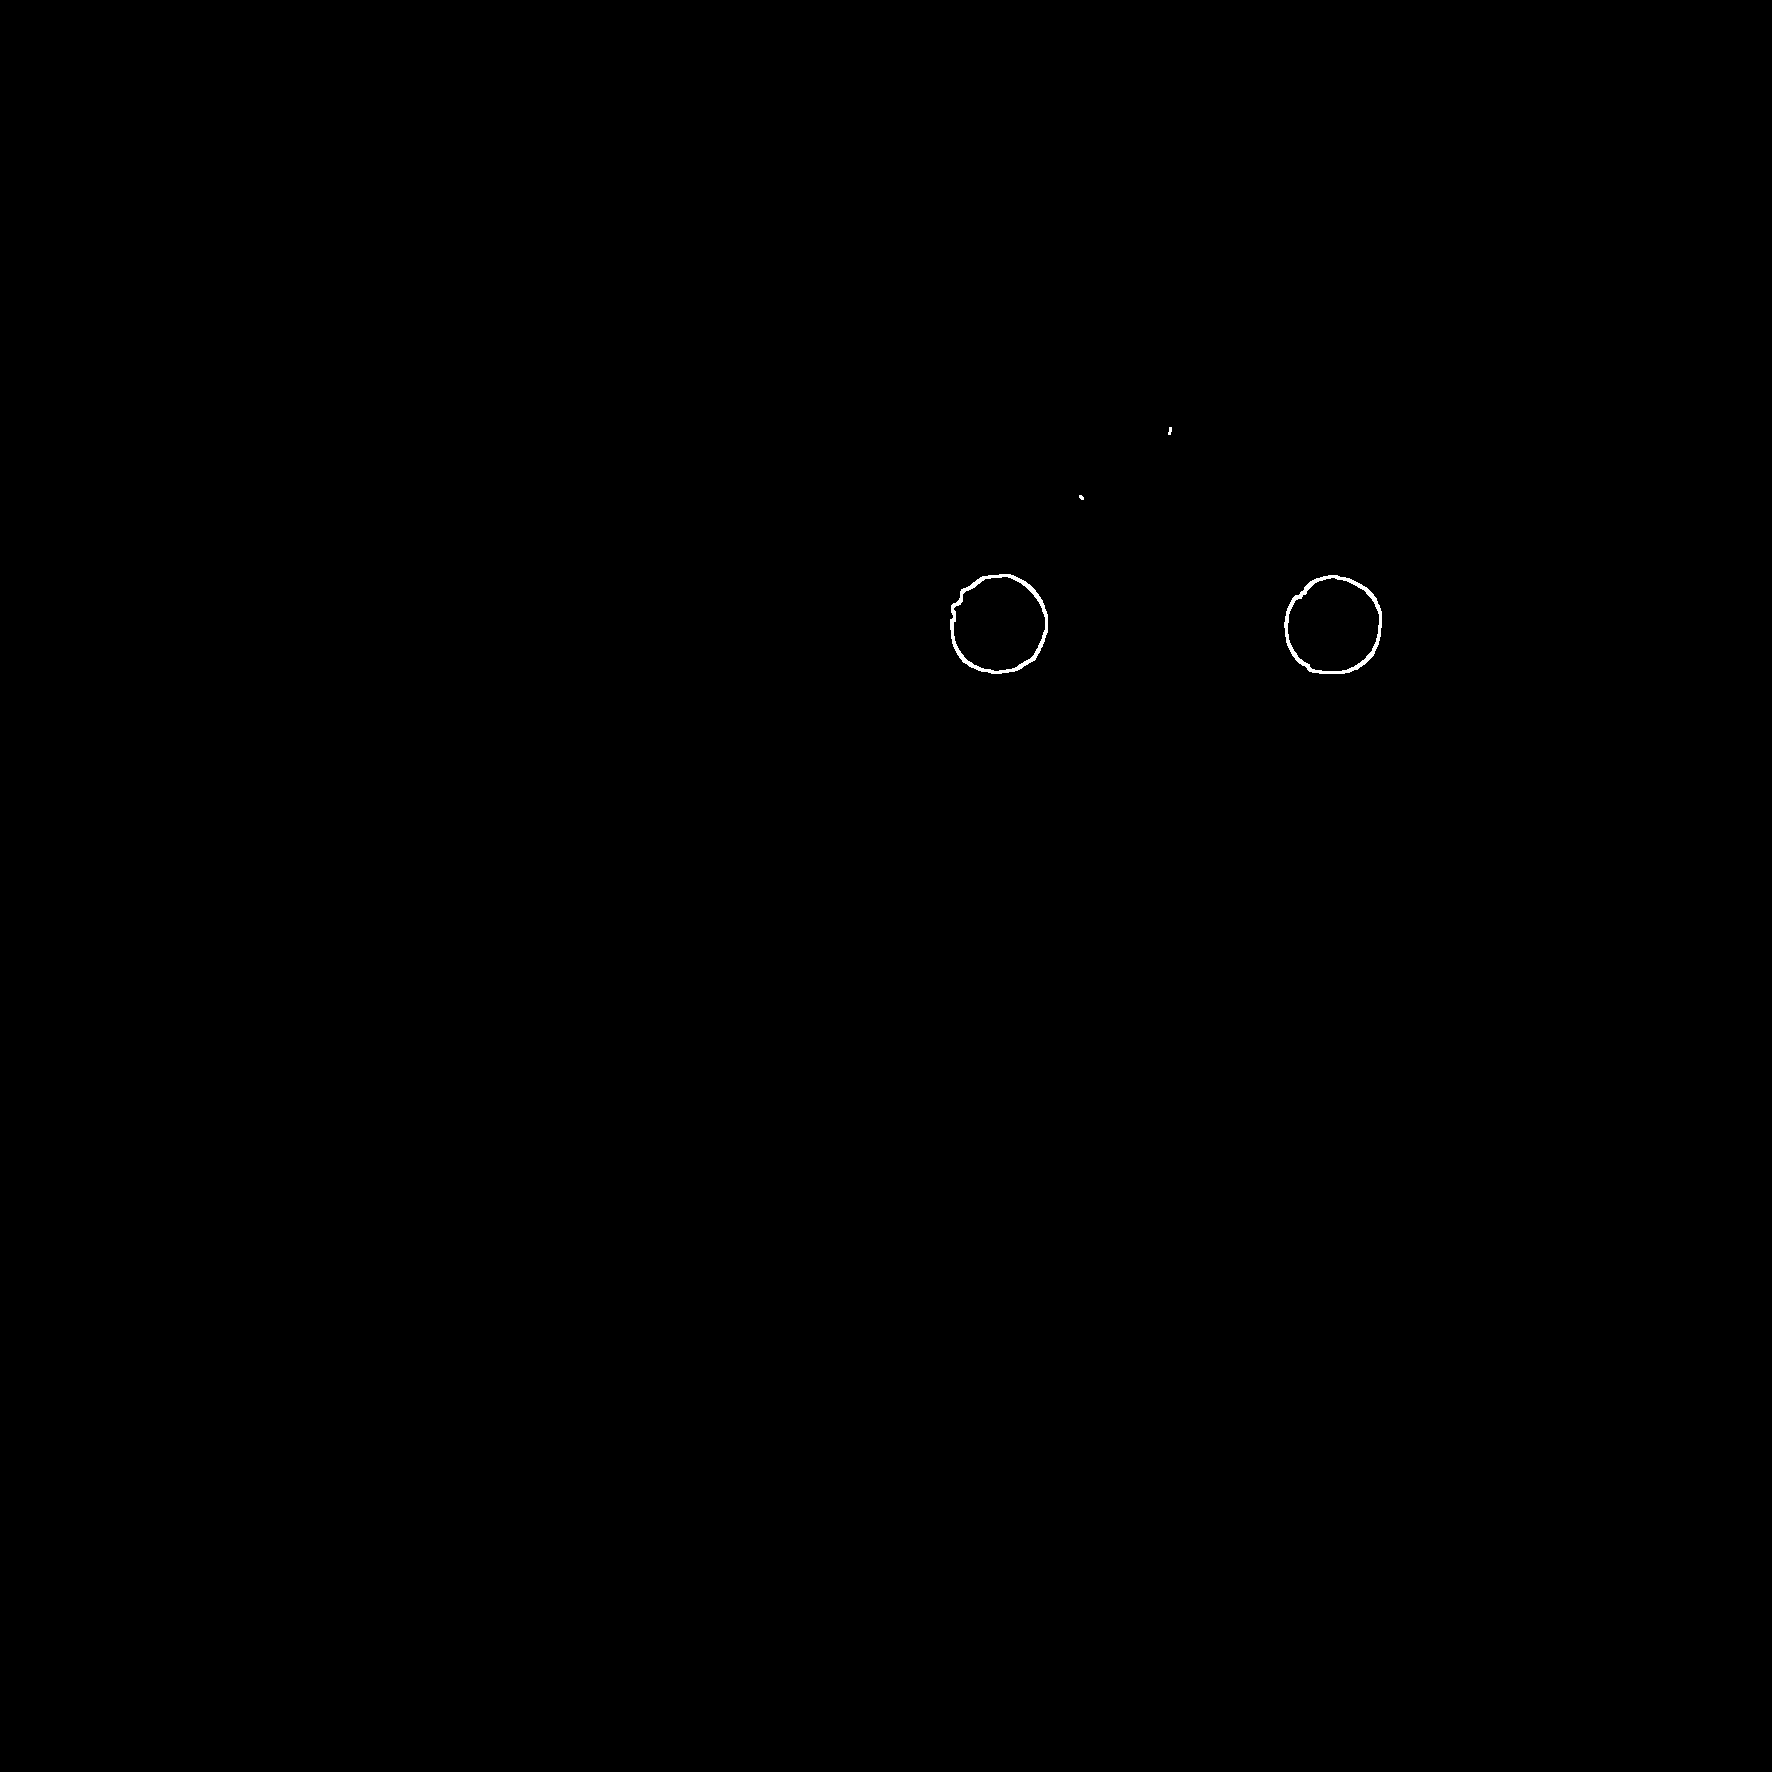

Liczba czarnych kropek: 2


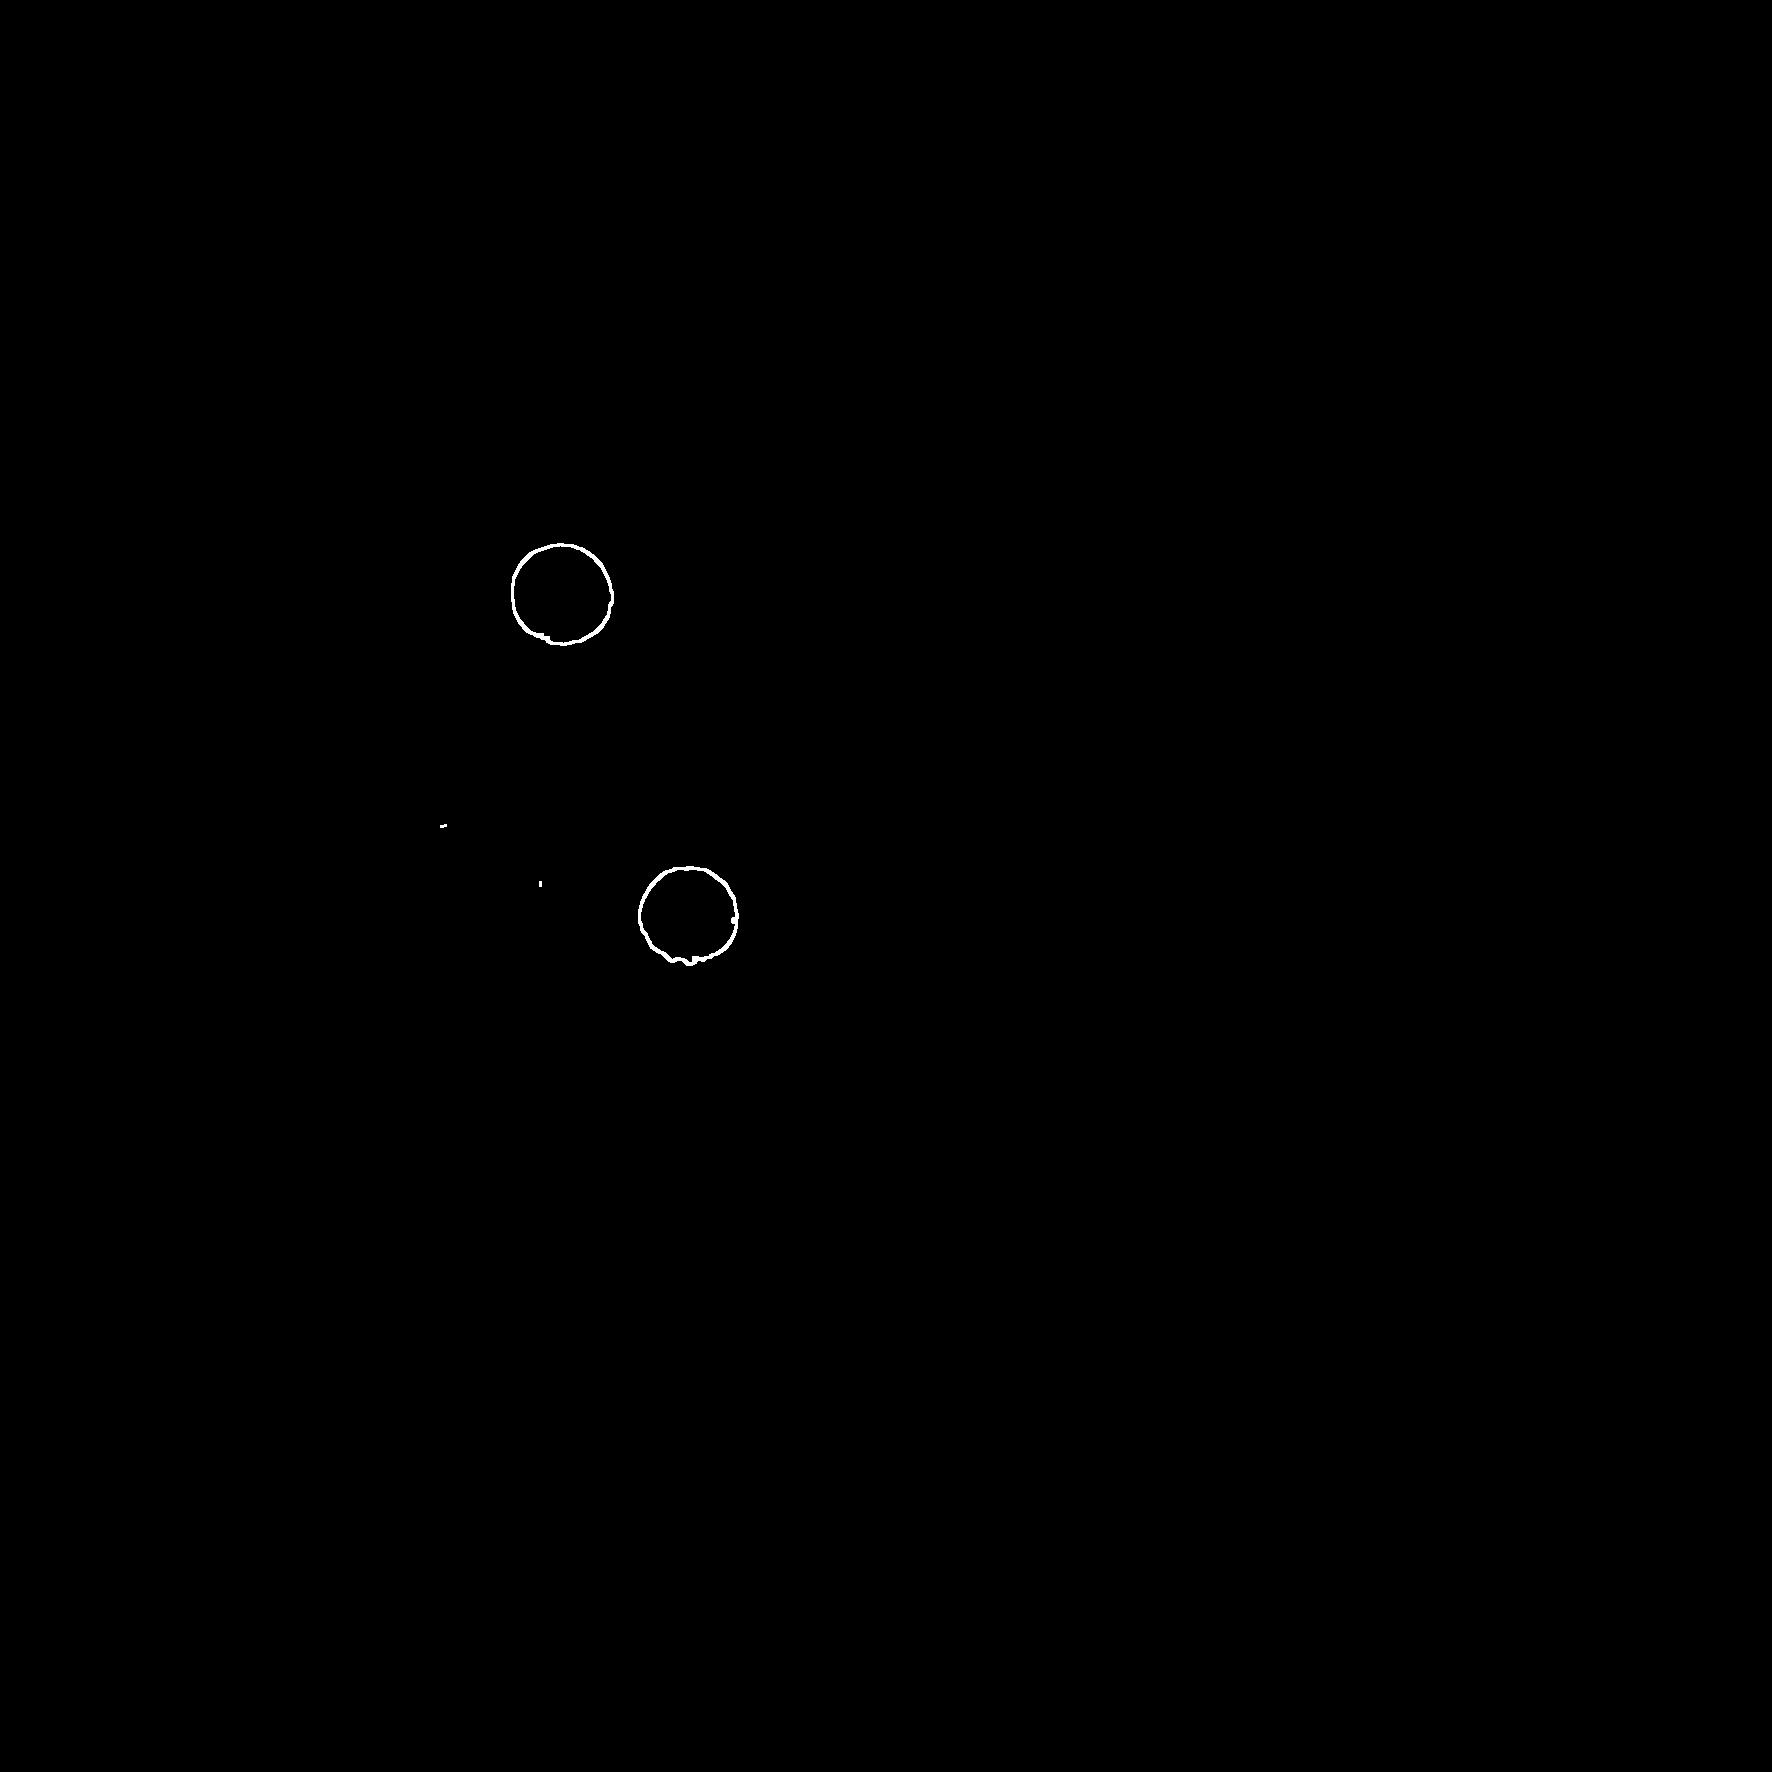

Liczba czarnych kropek: 2


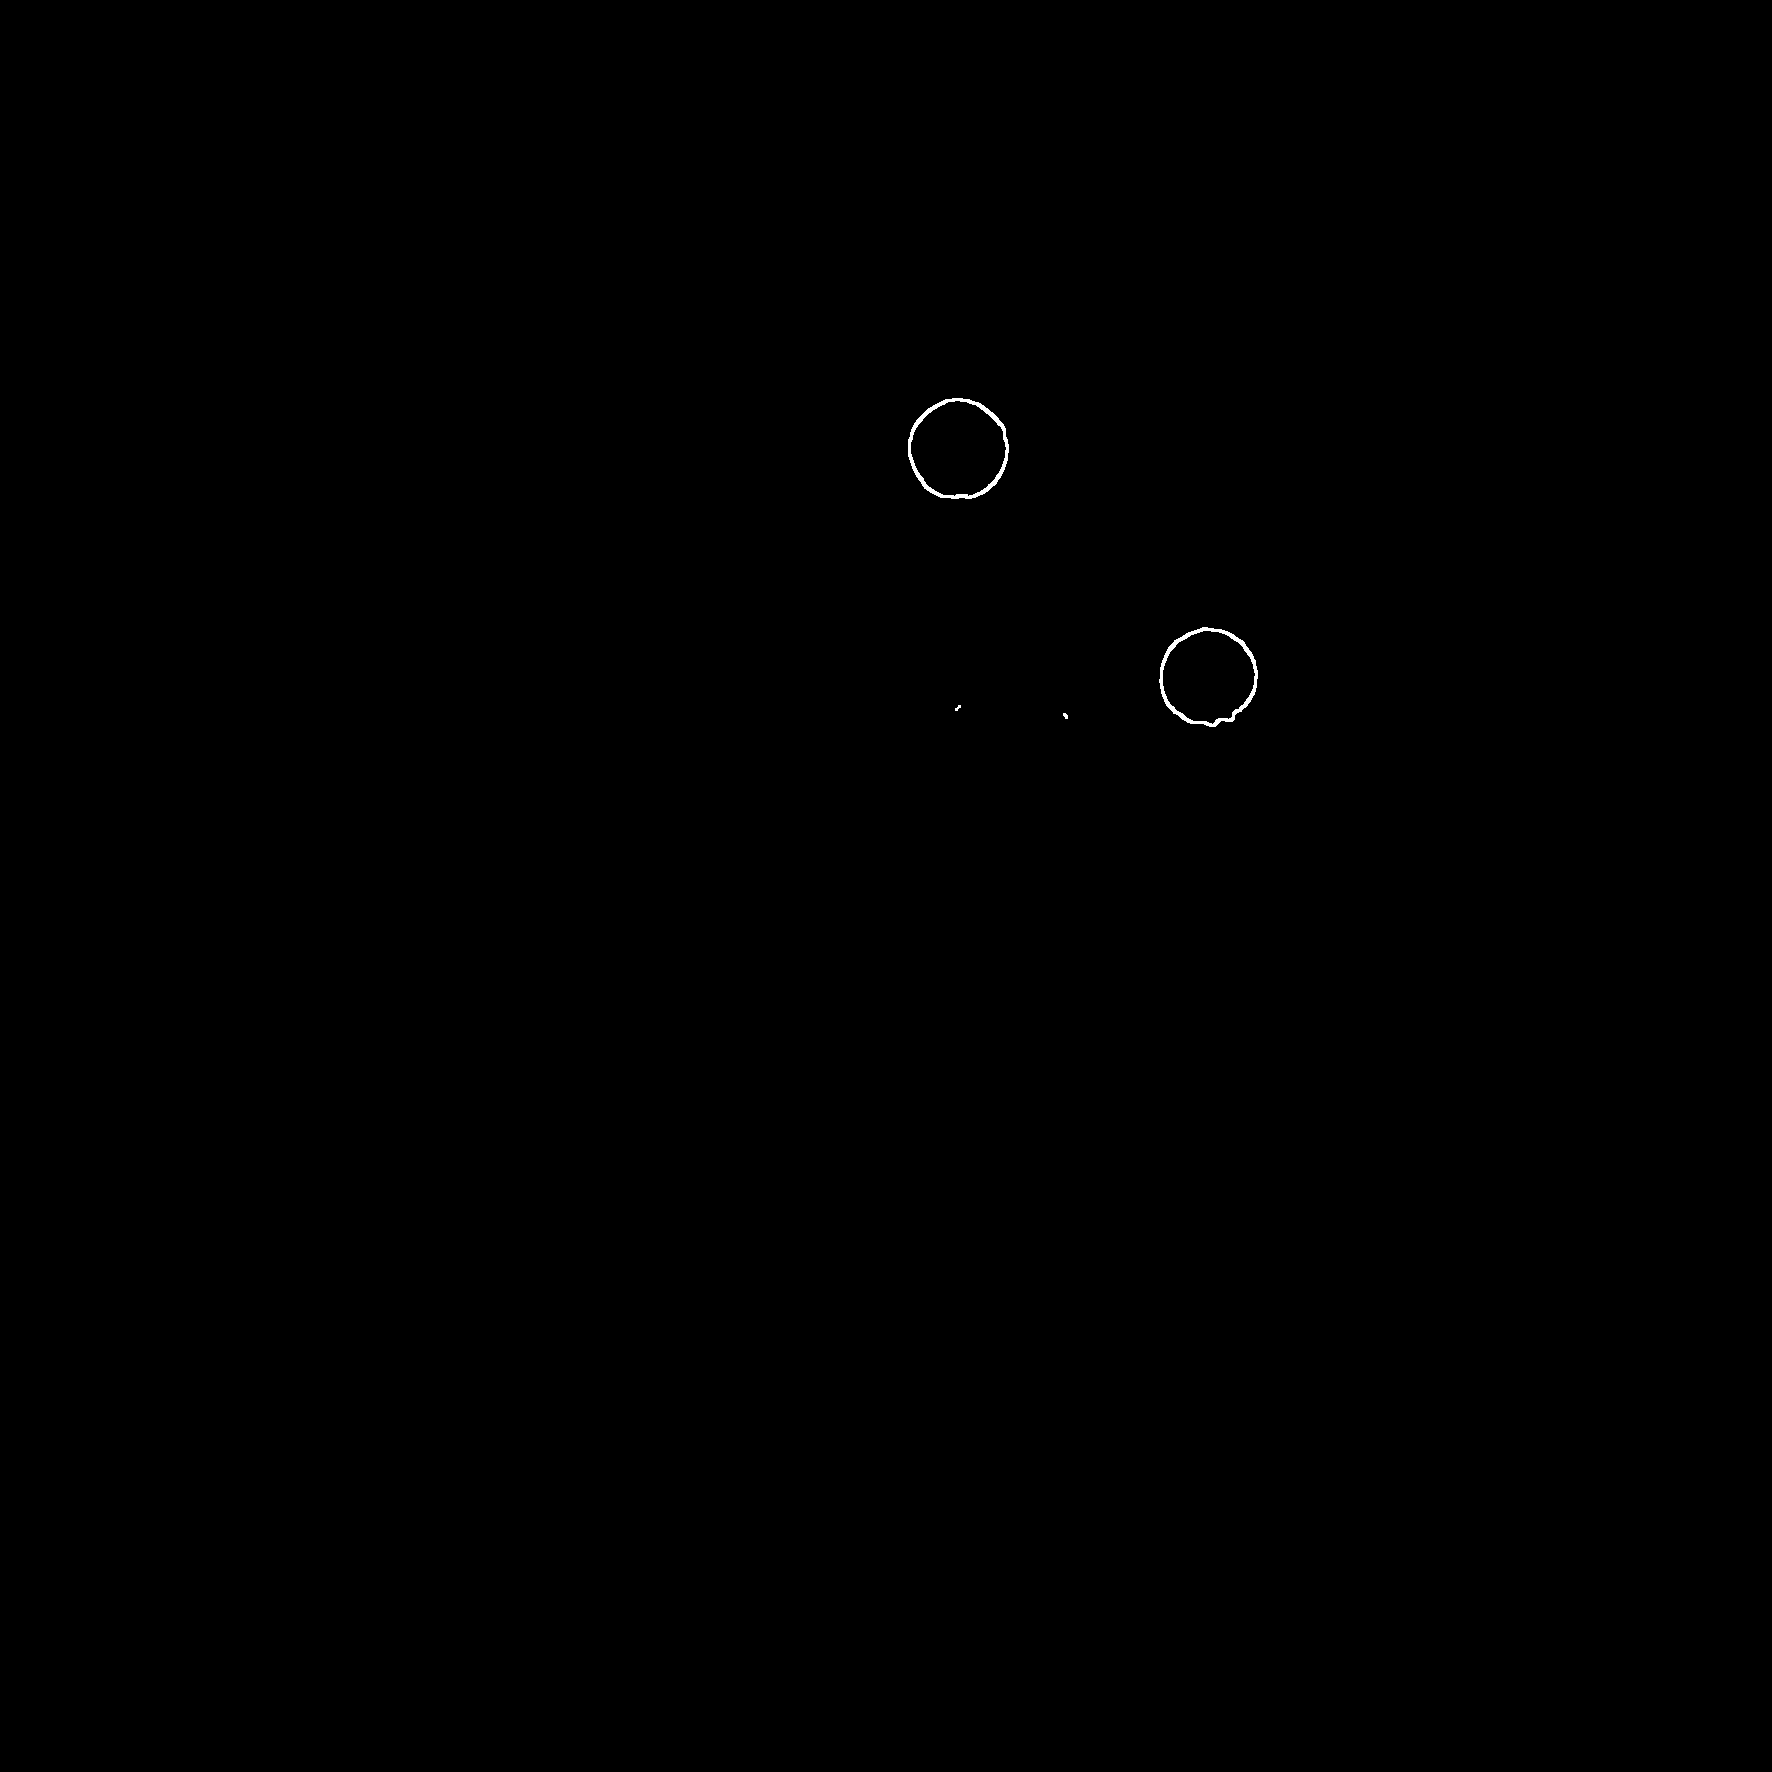

Liczba czarnych kropek: 2


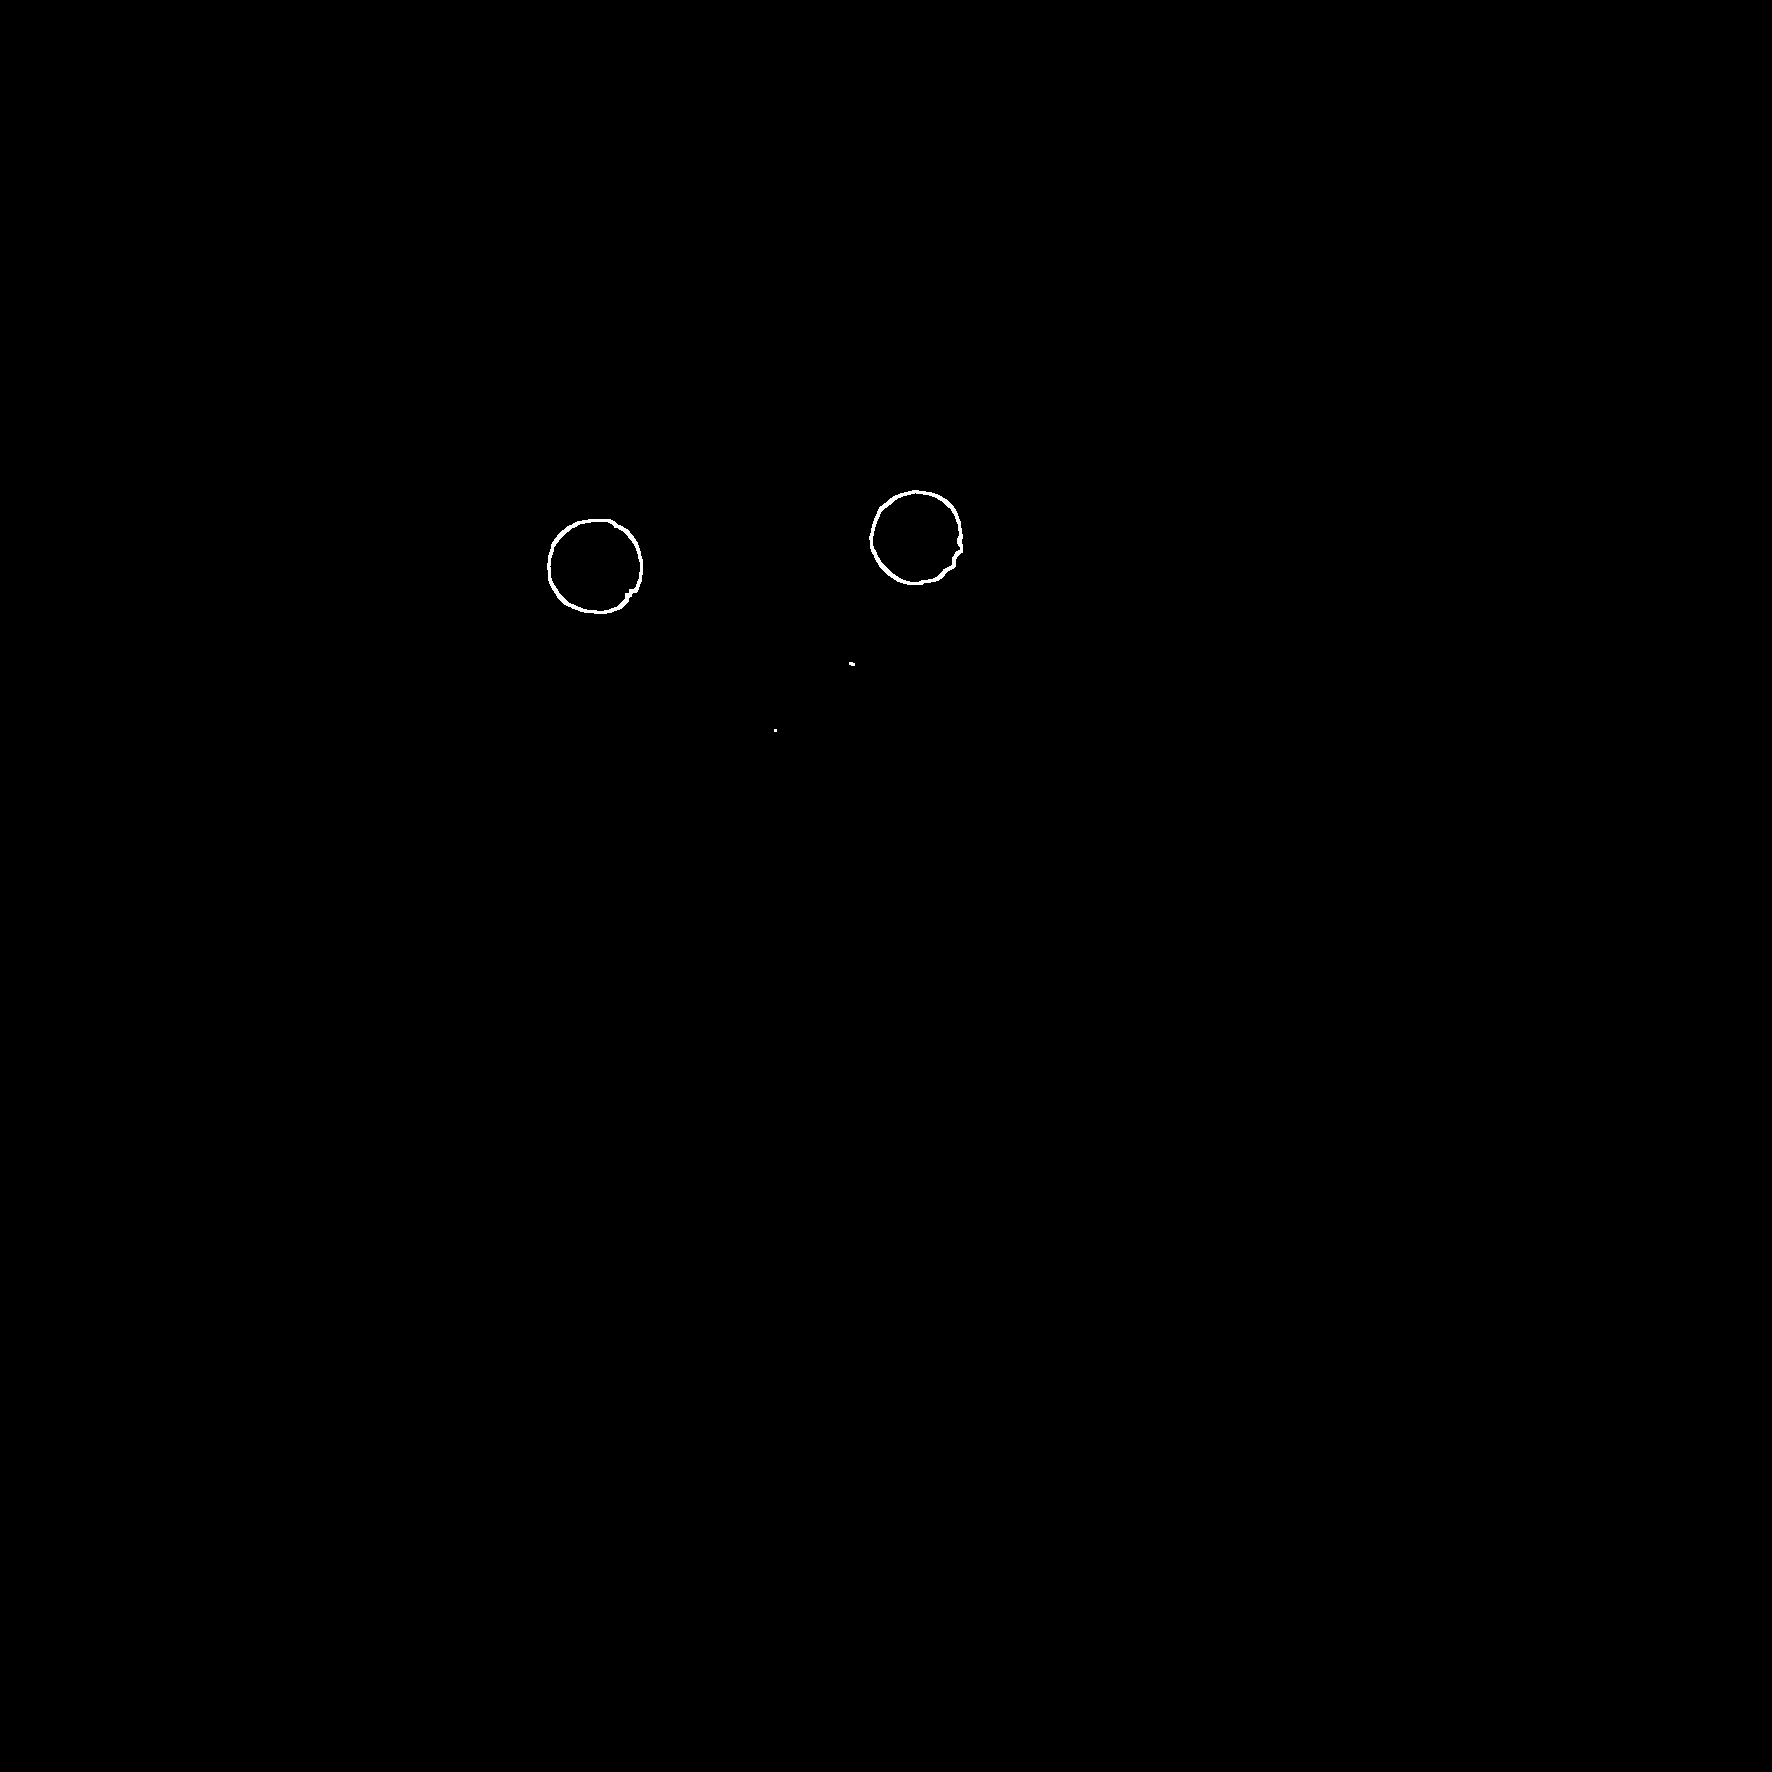

Liczba czarnych kropek: 2


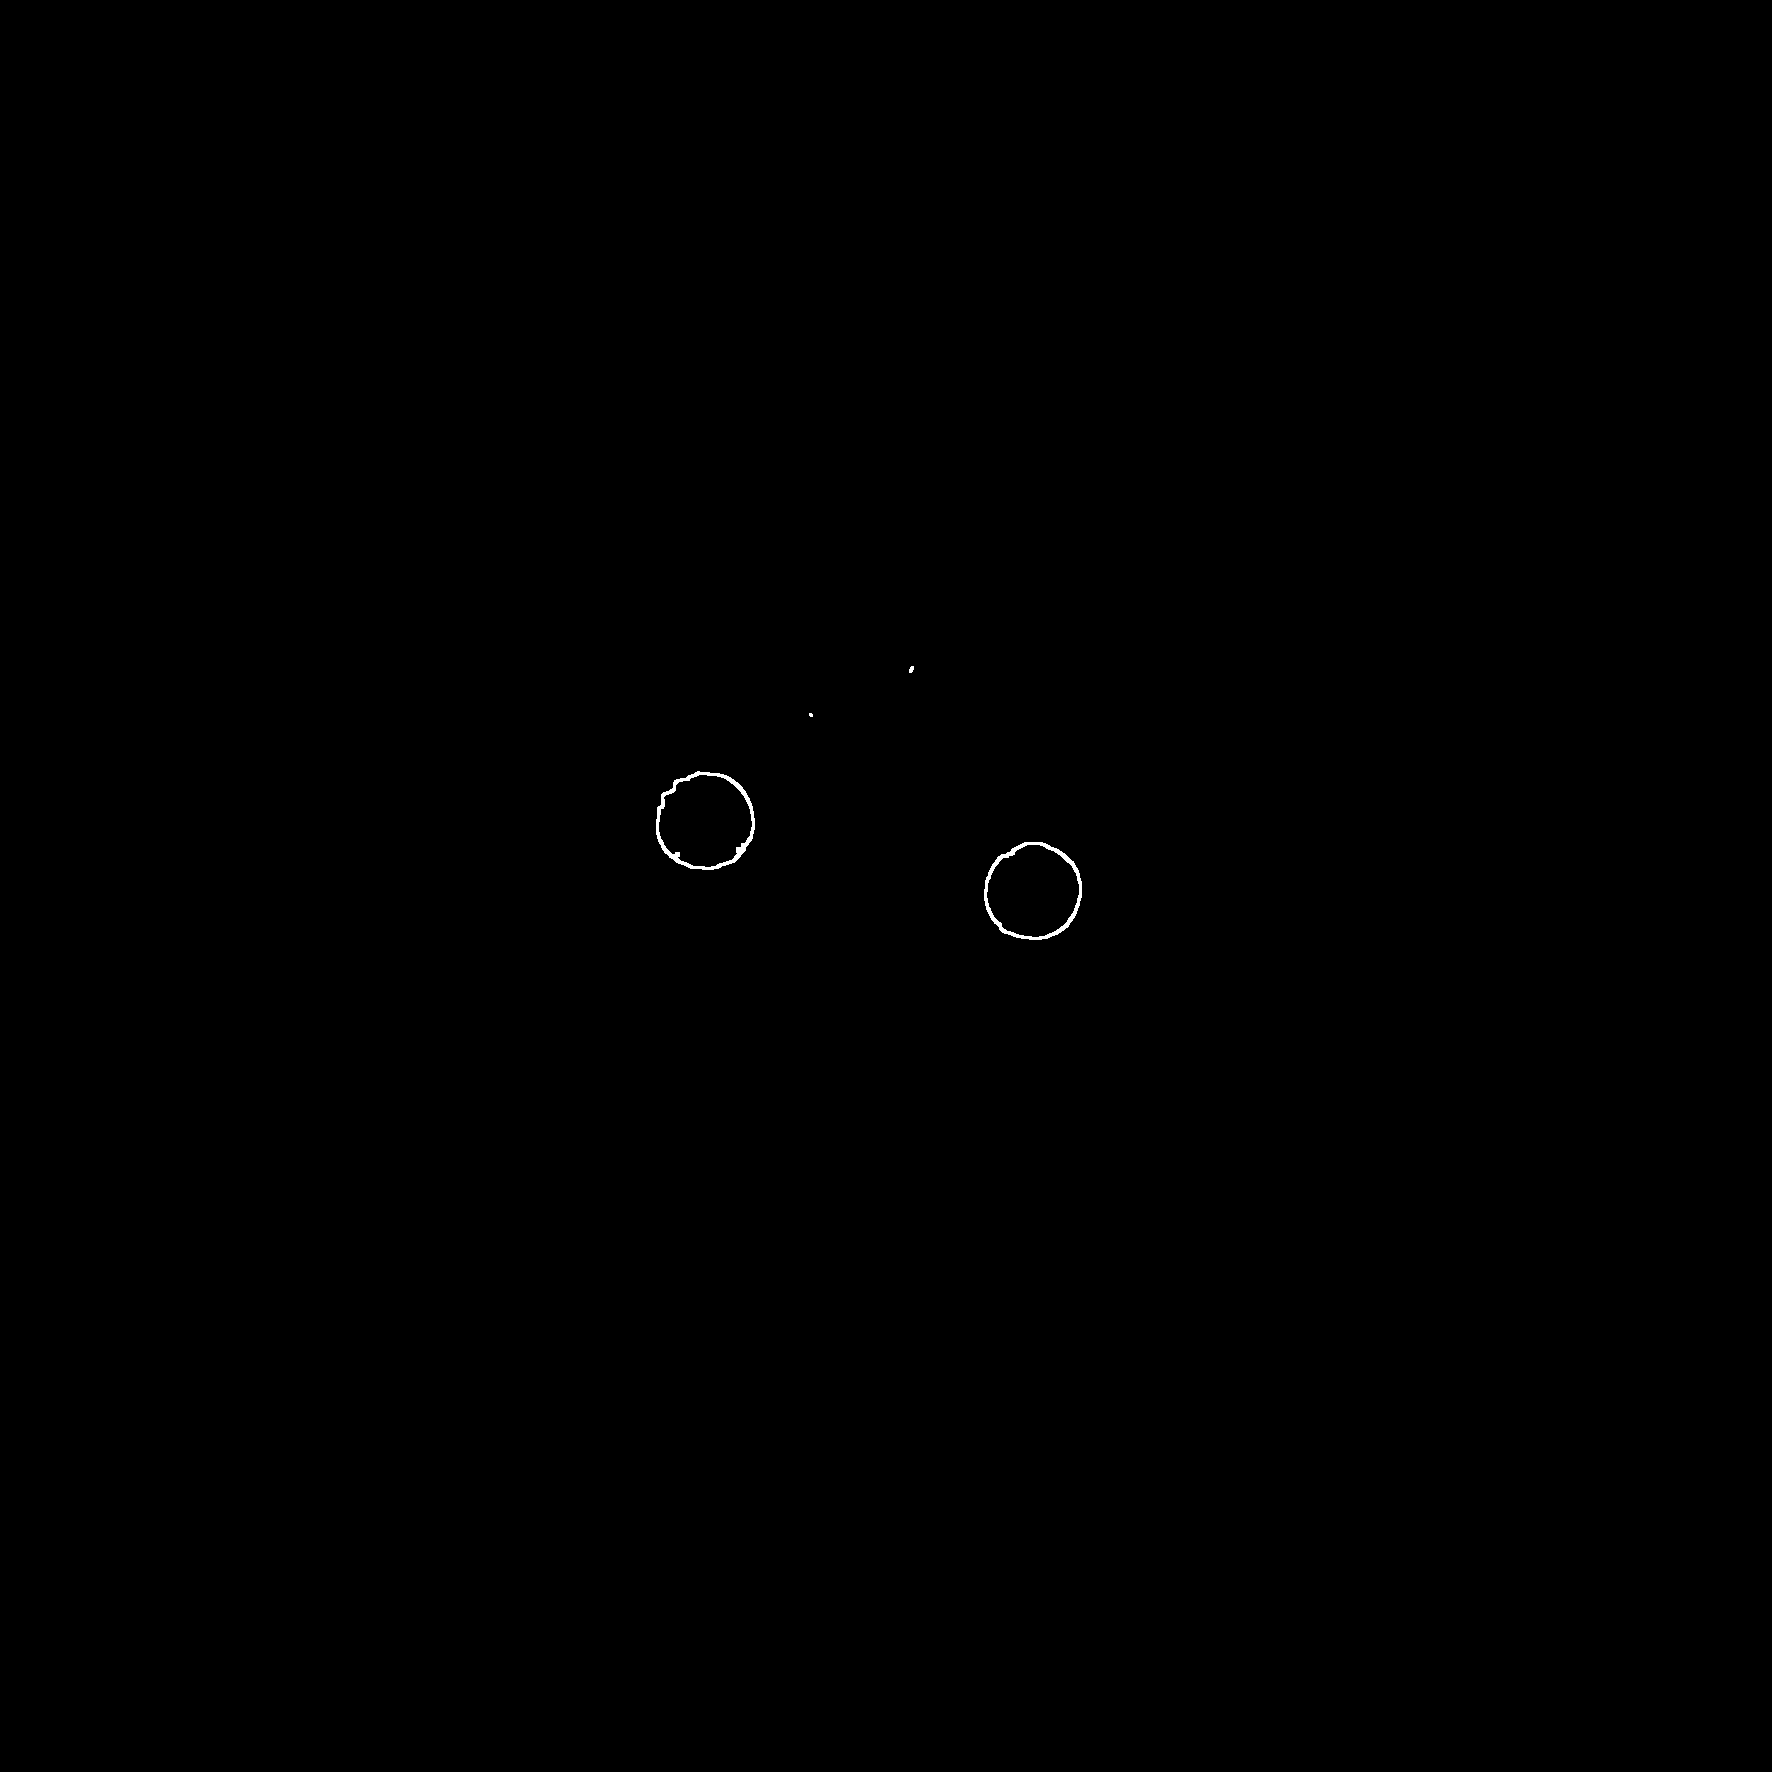

Liczba czarnych kropek: 2


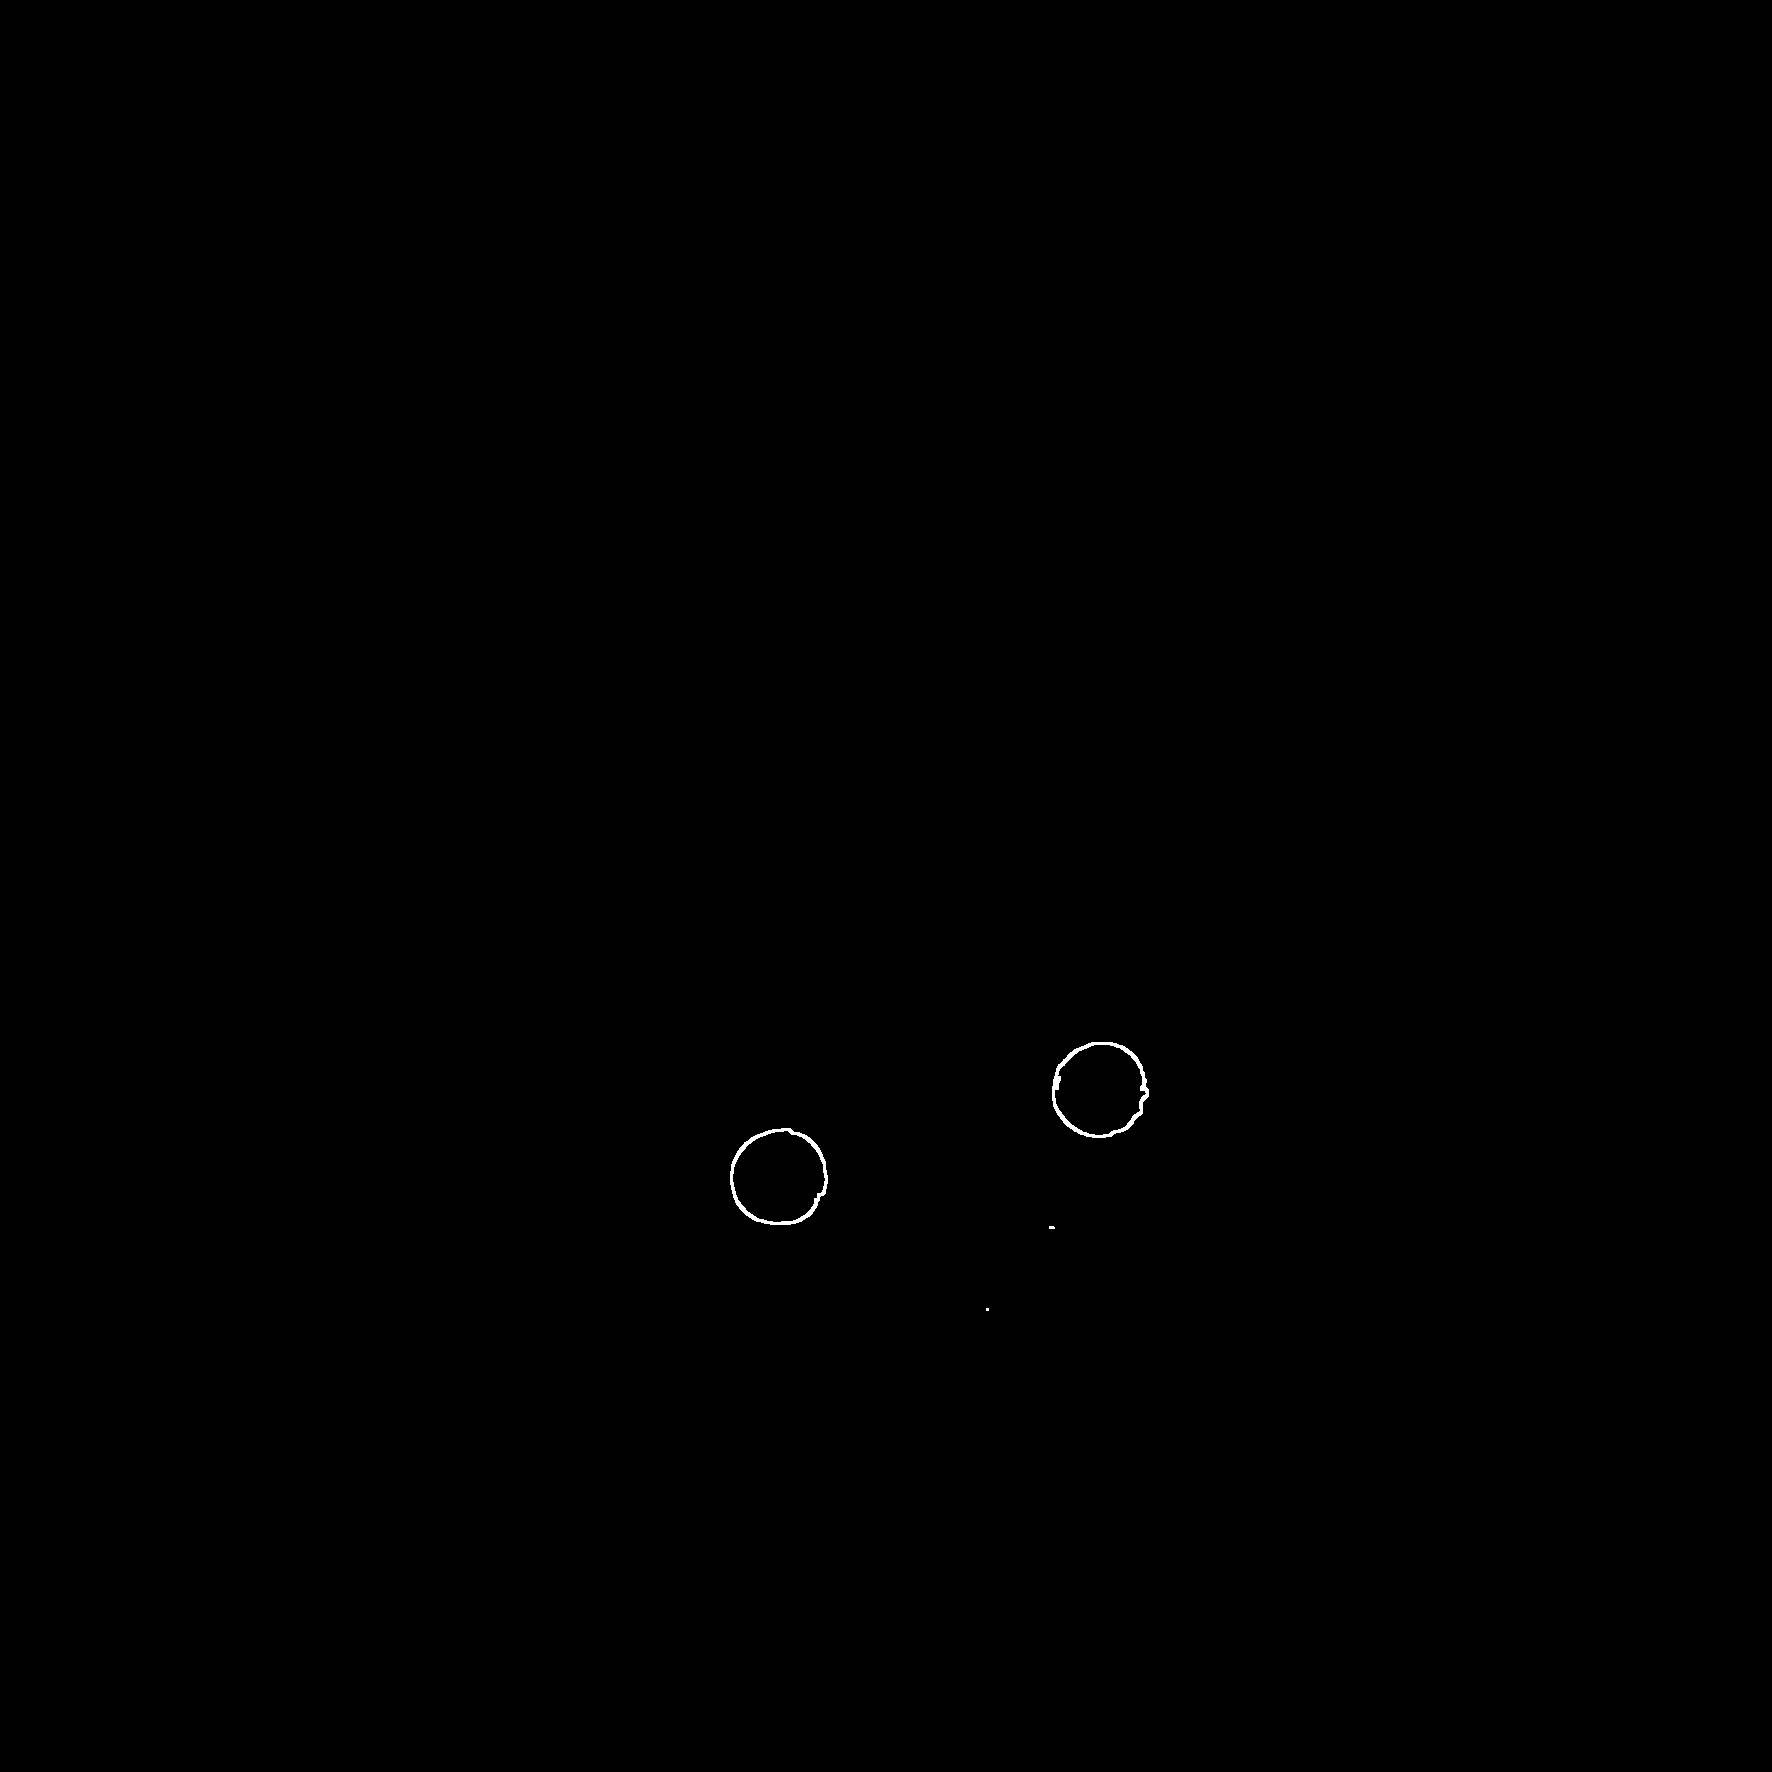

Liczba czarnych kropek: 2


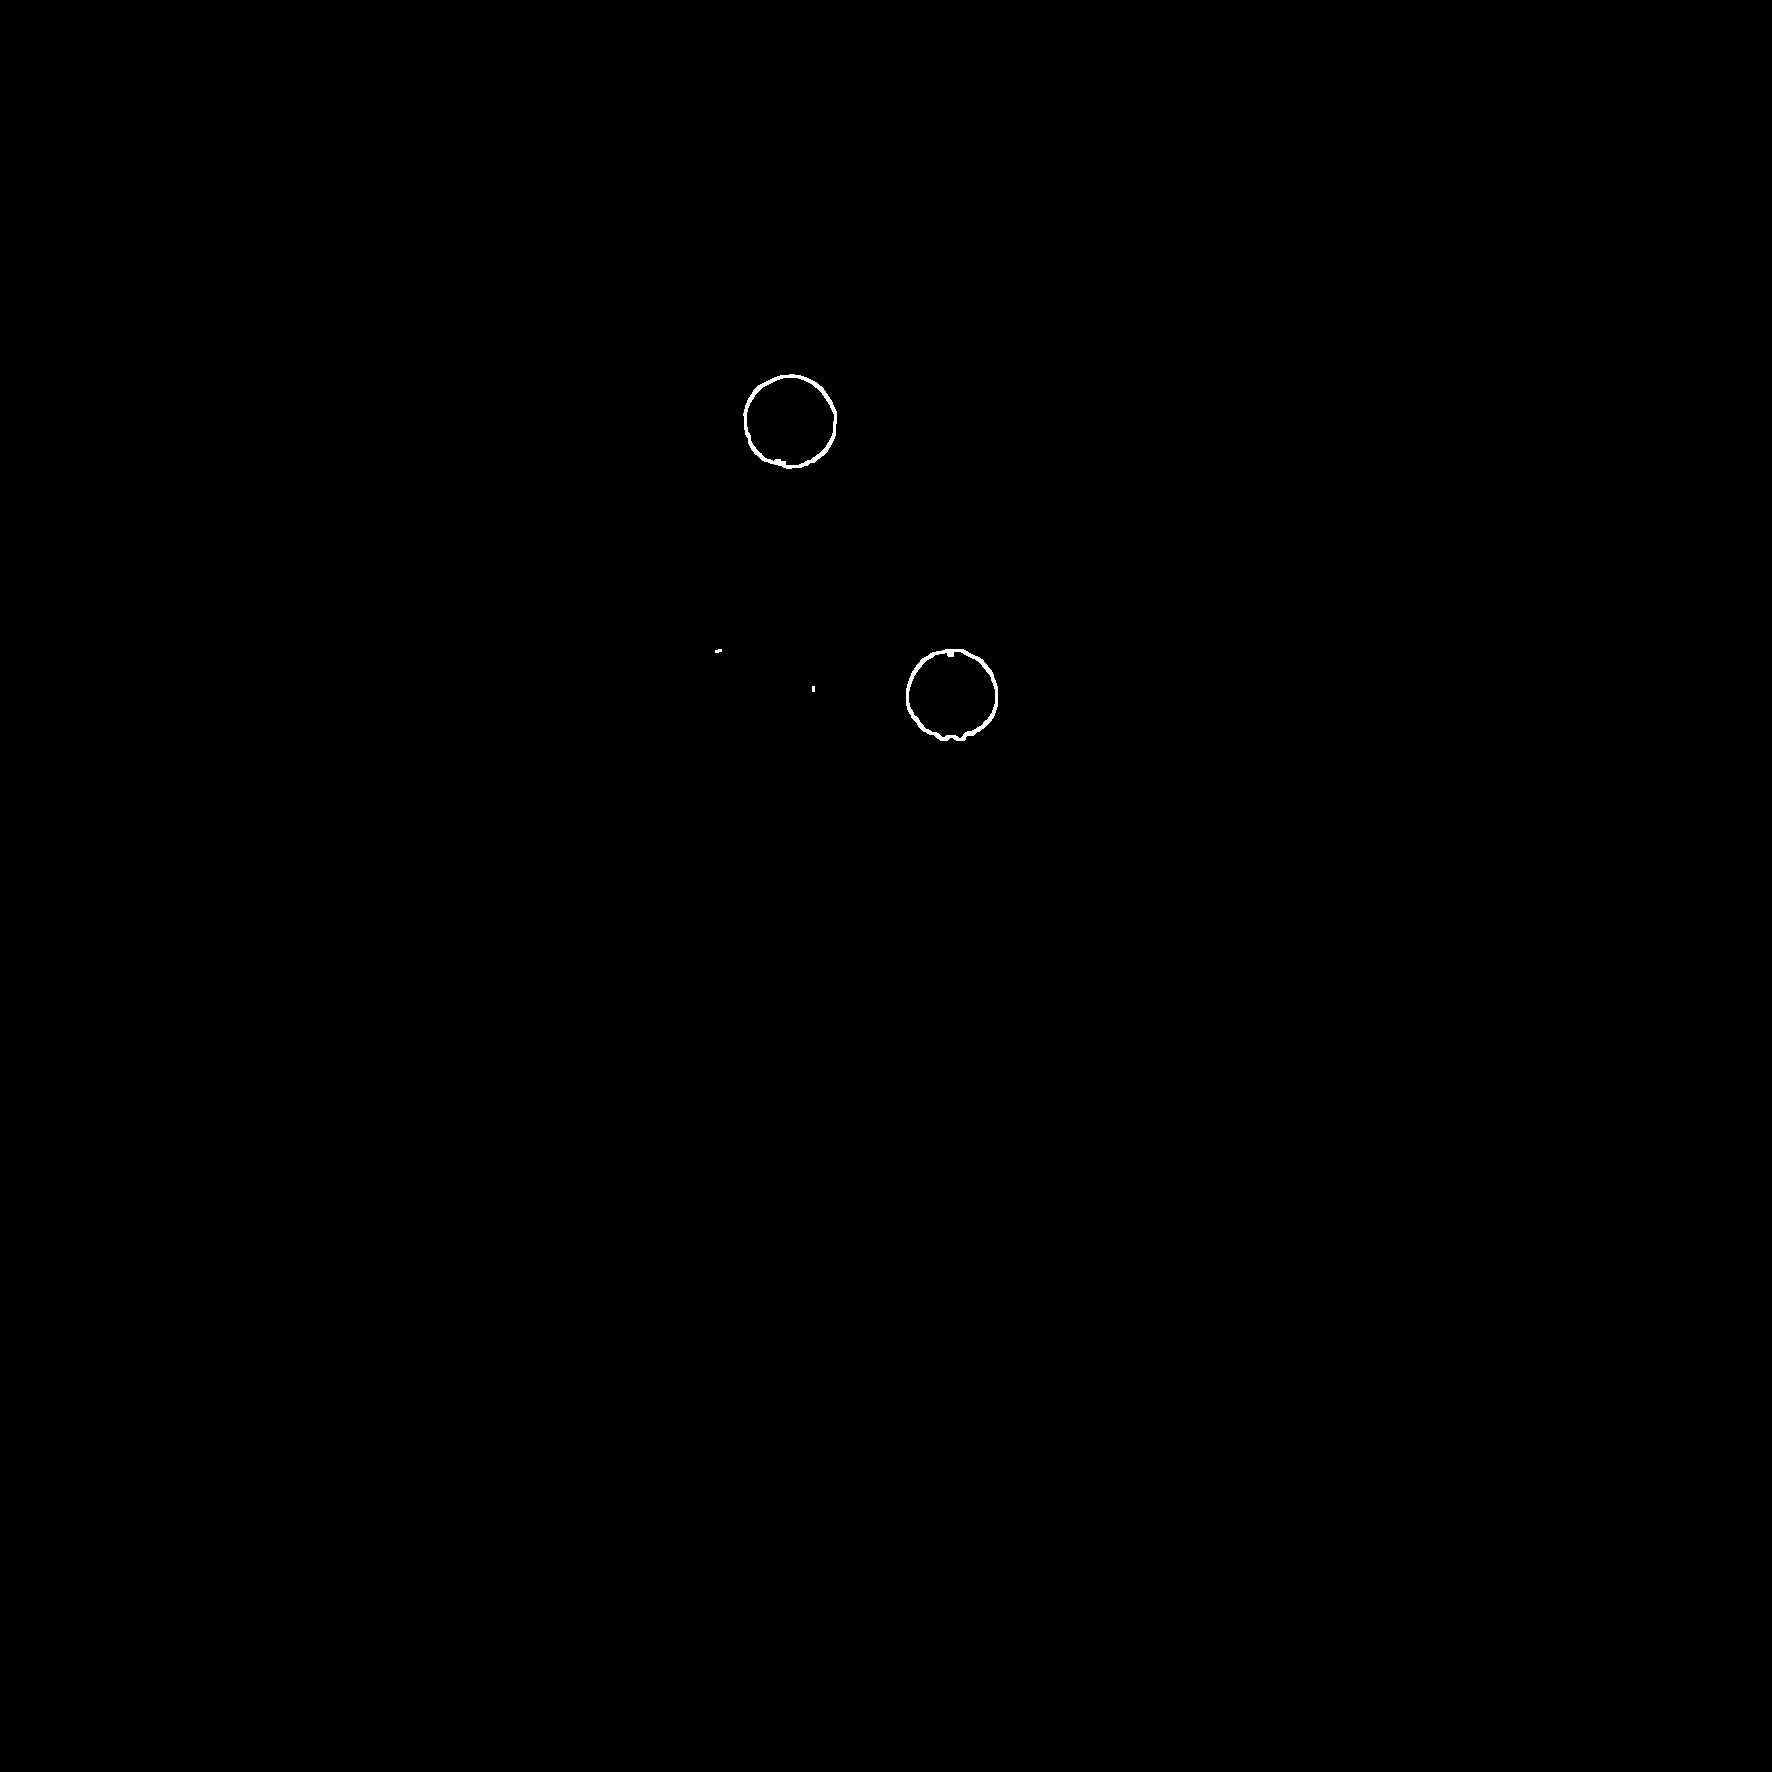

Liczba czarnych kropek: 2


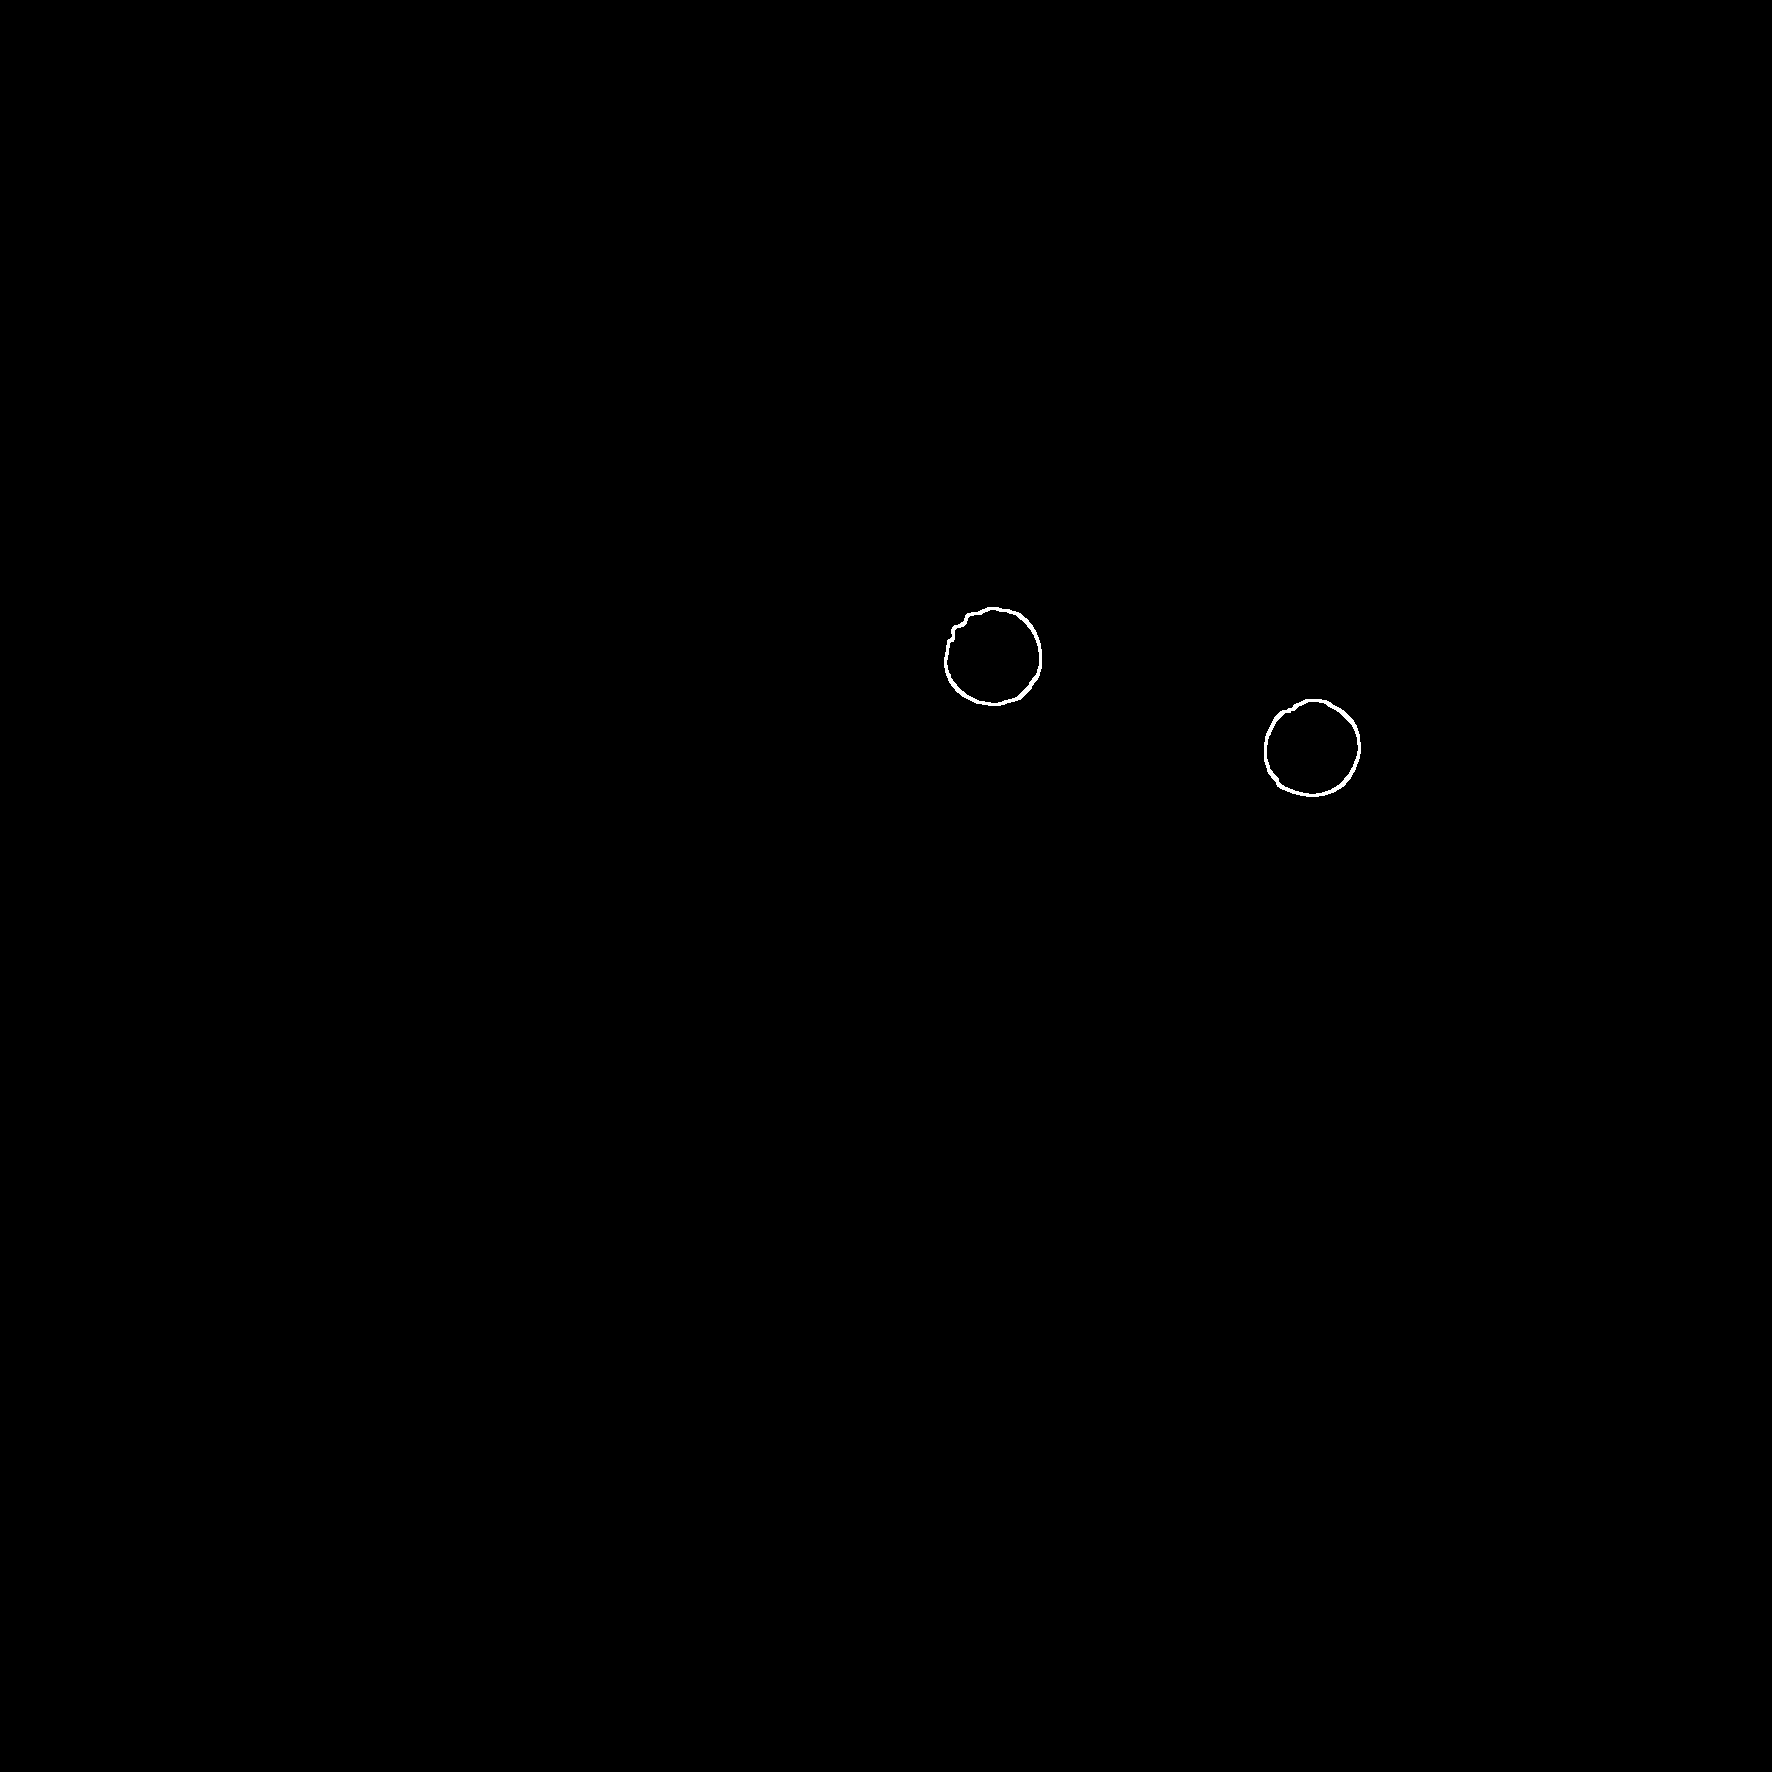

Liczba czarnych kropek: 2


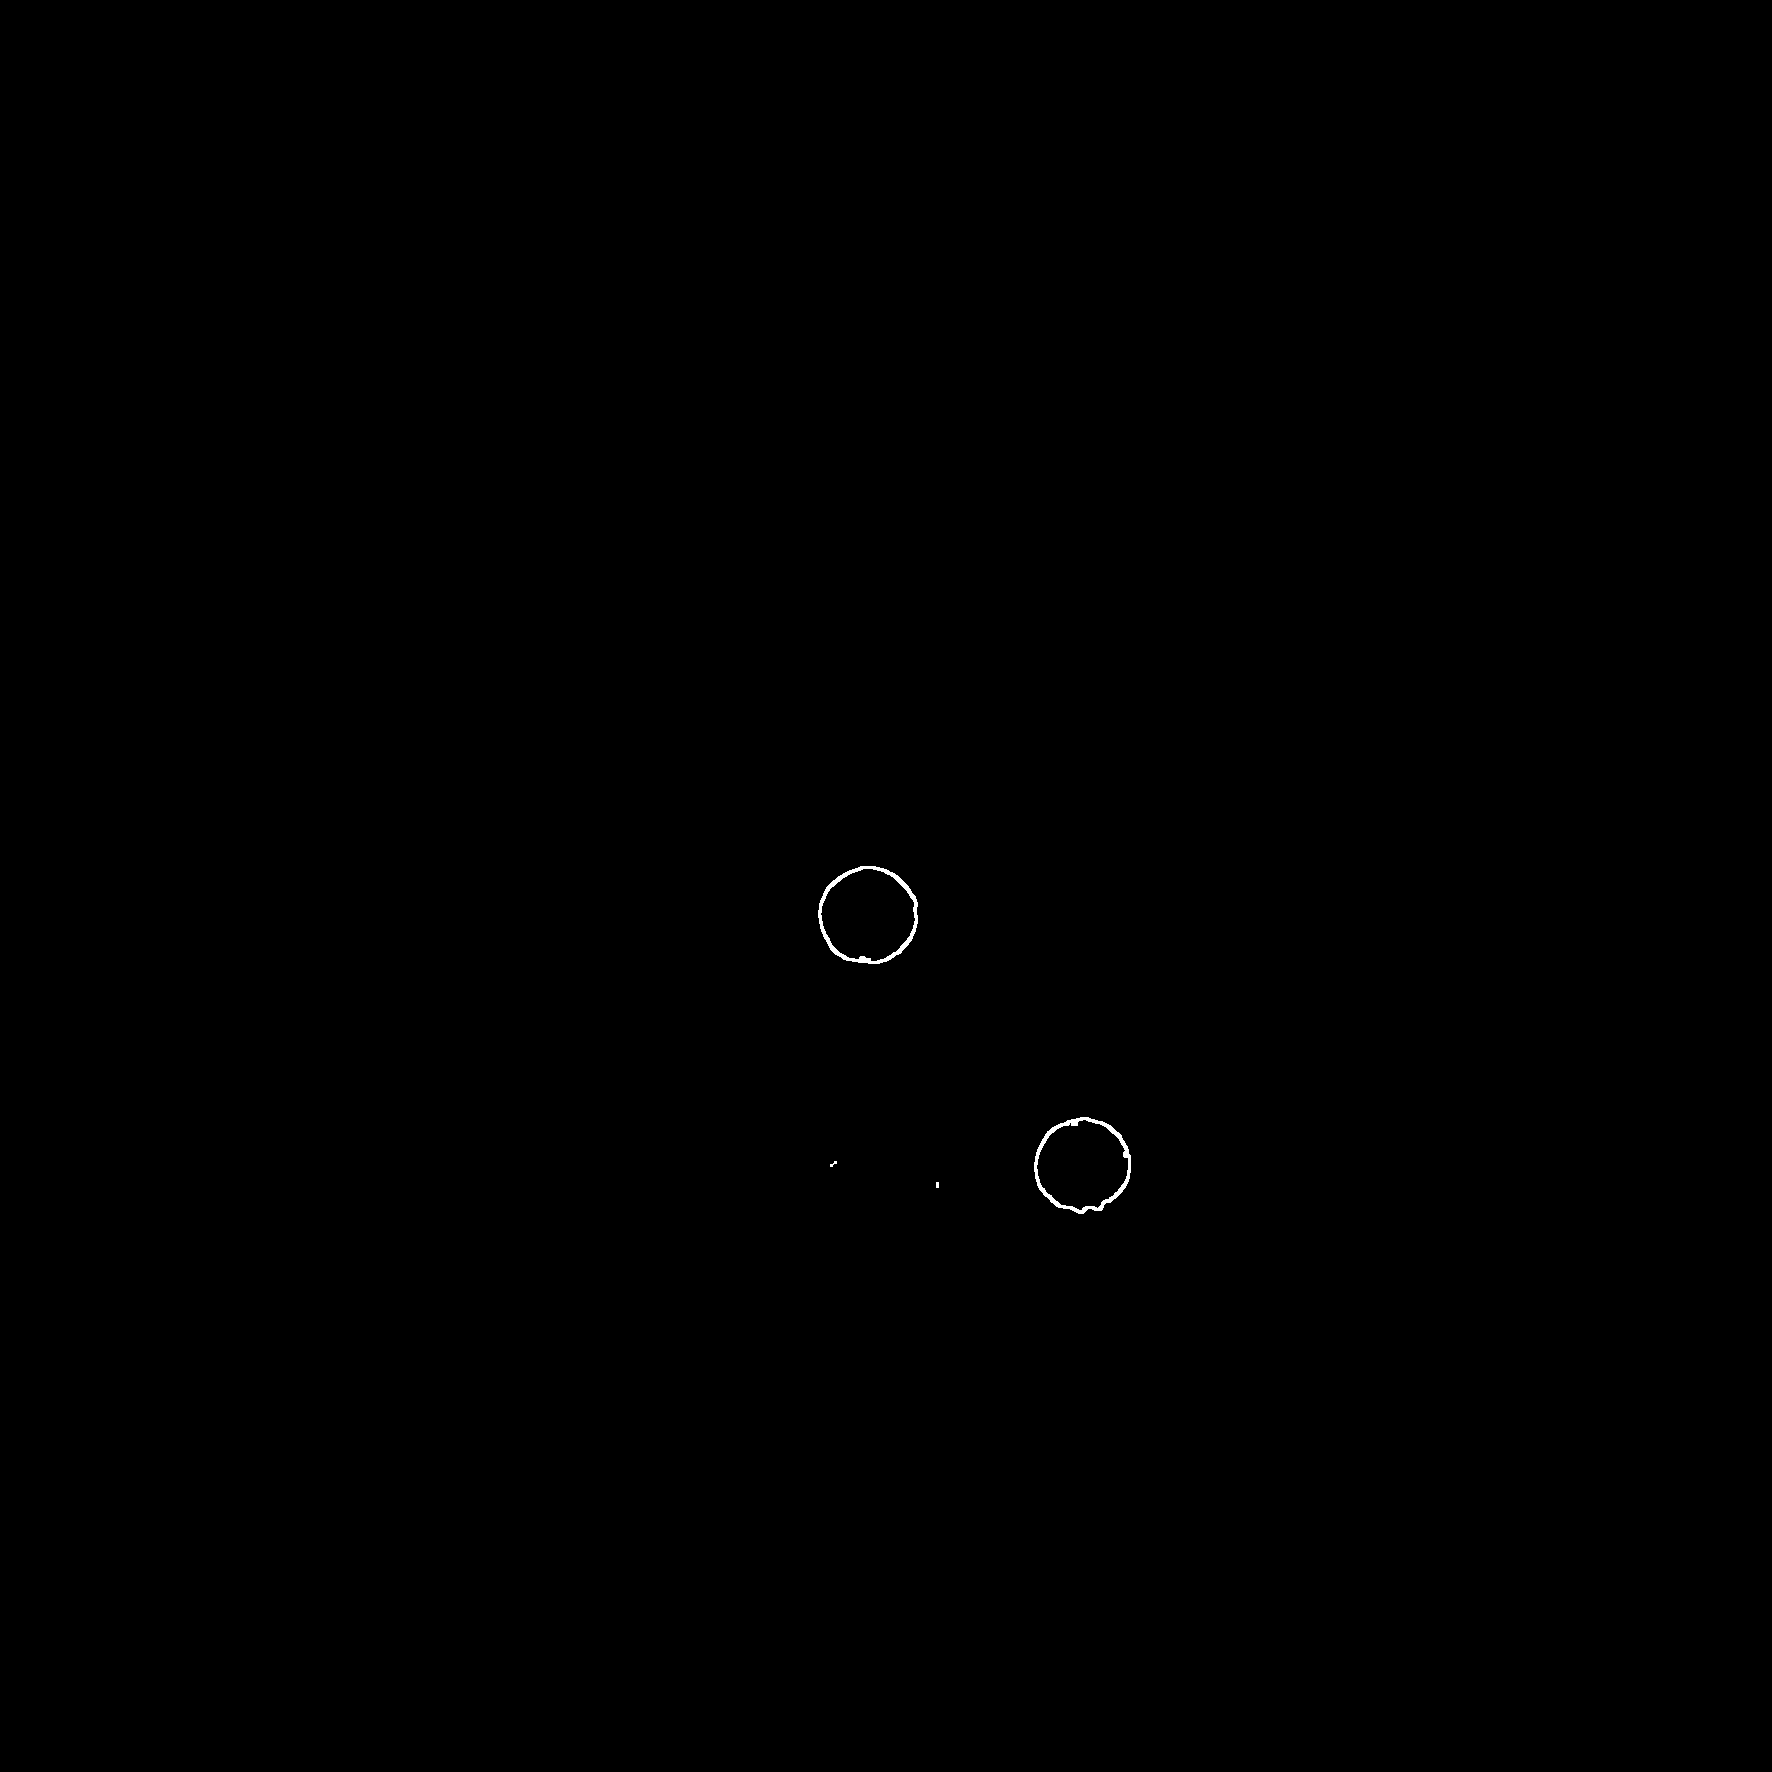

Liczba czarnych kropek: 2


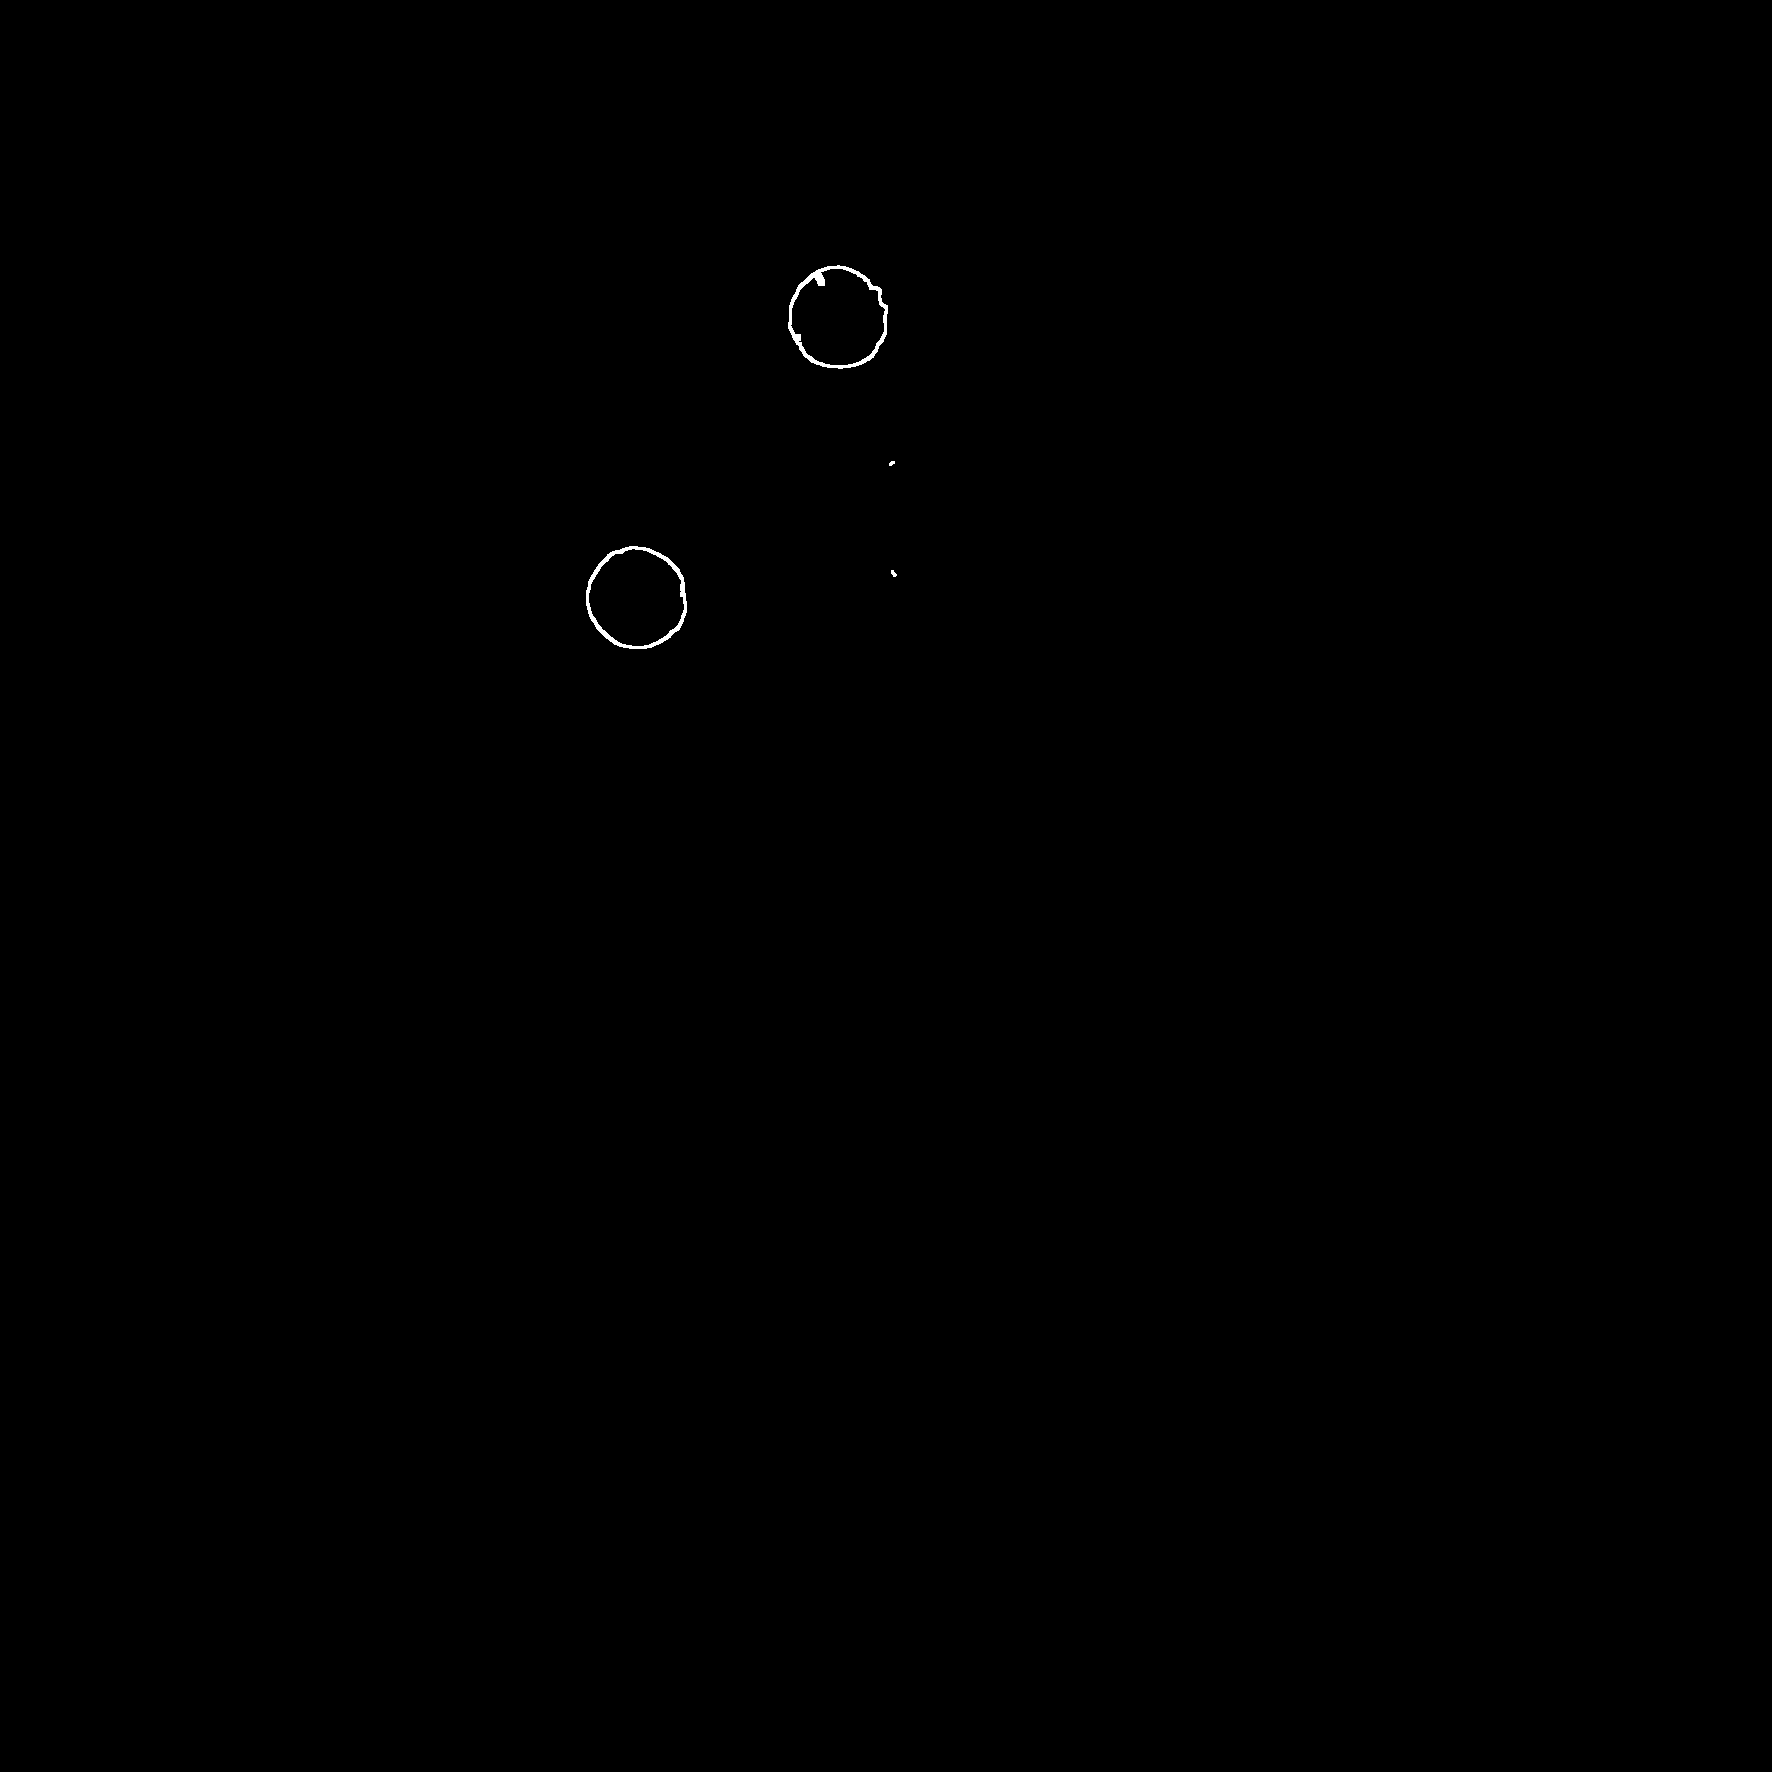

Liczba czarnych kropek: 2


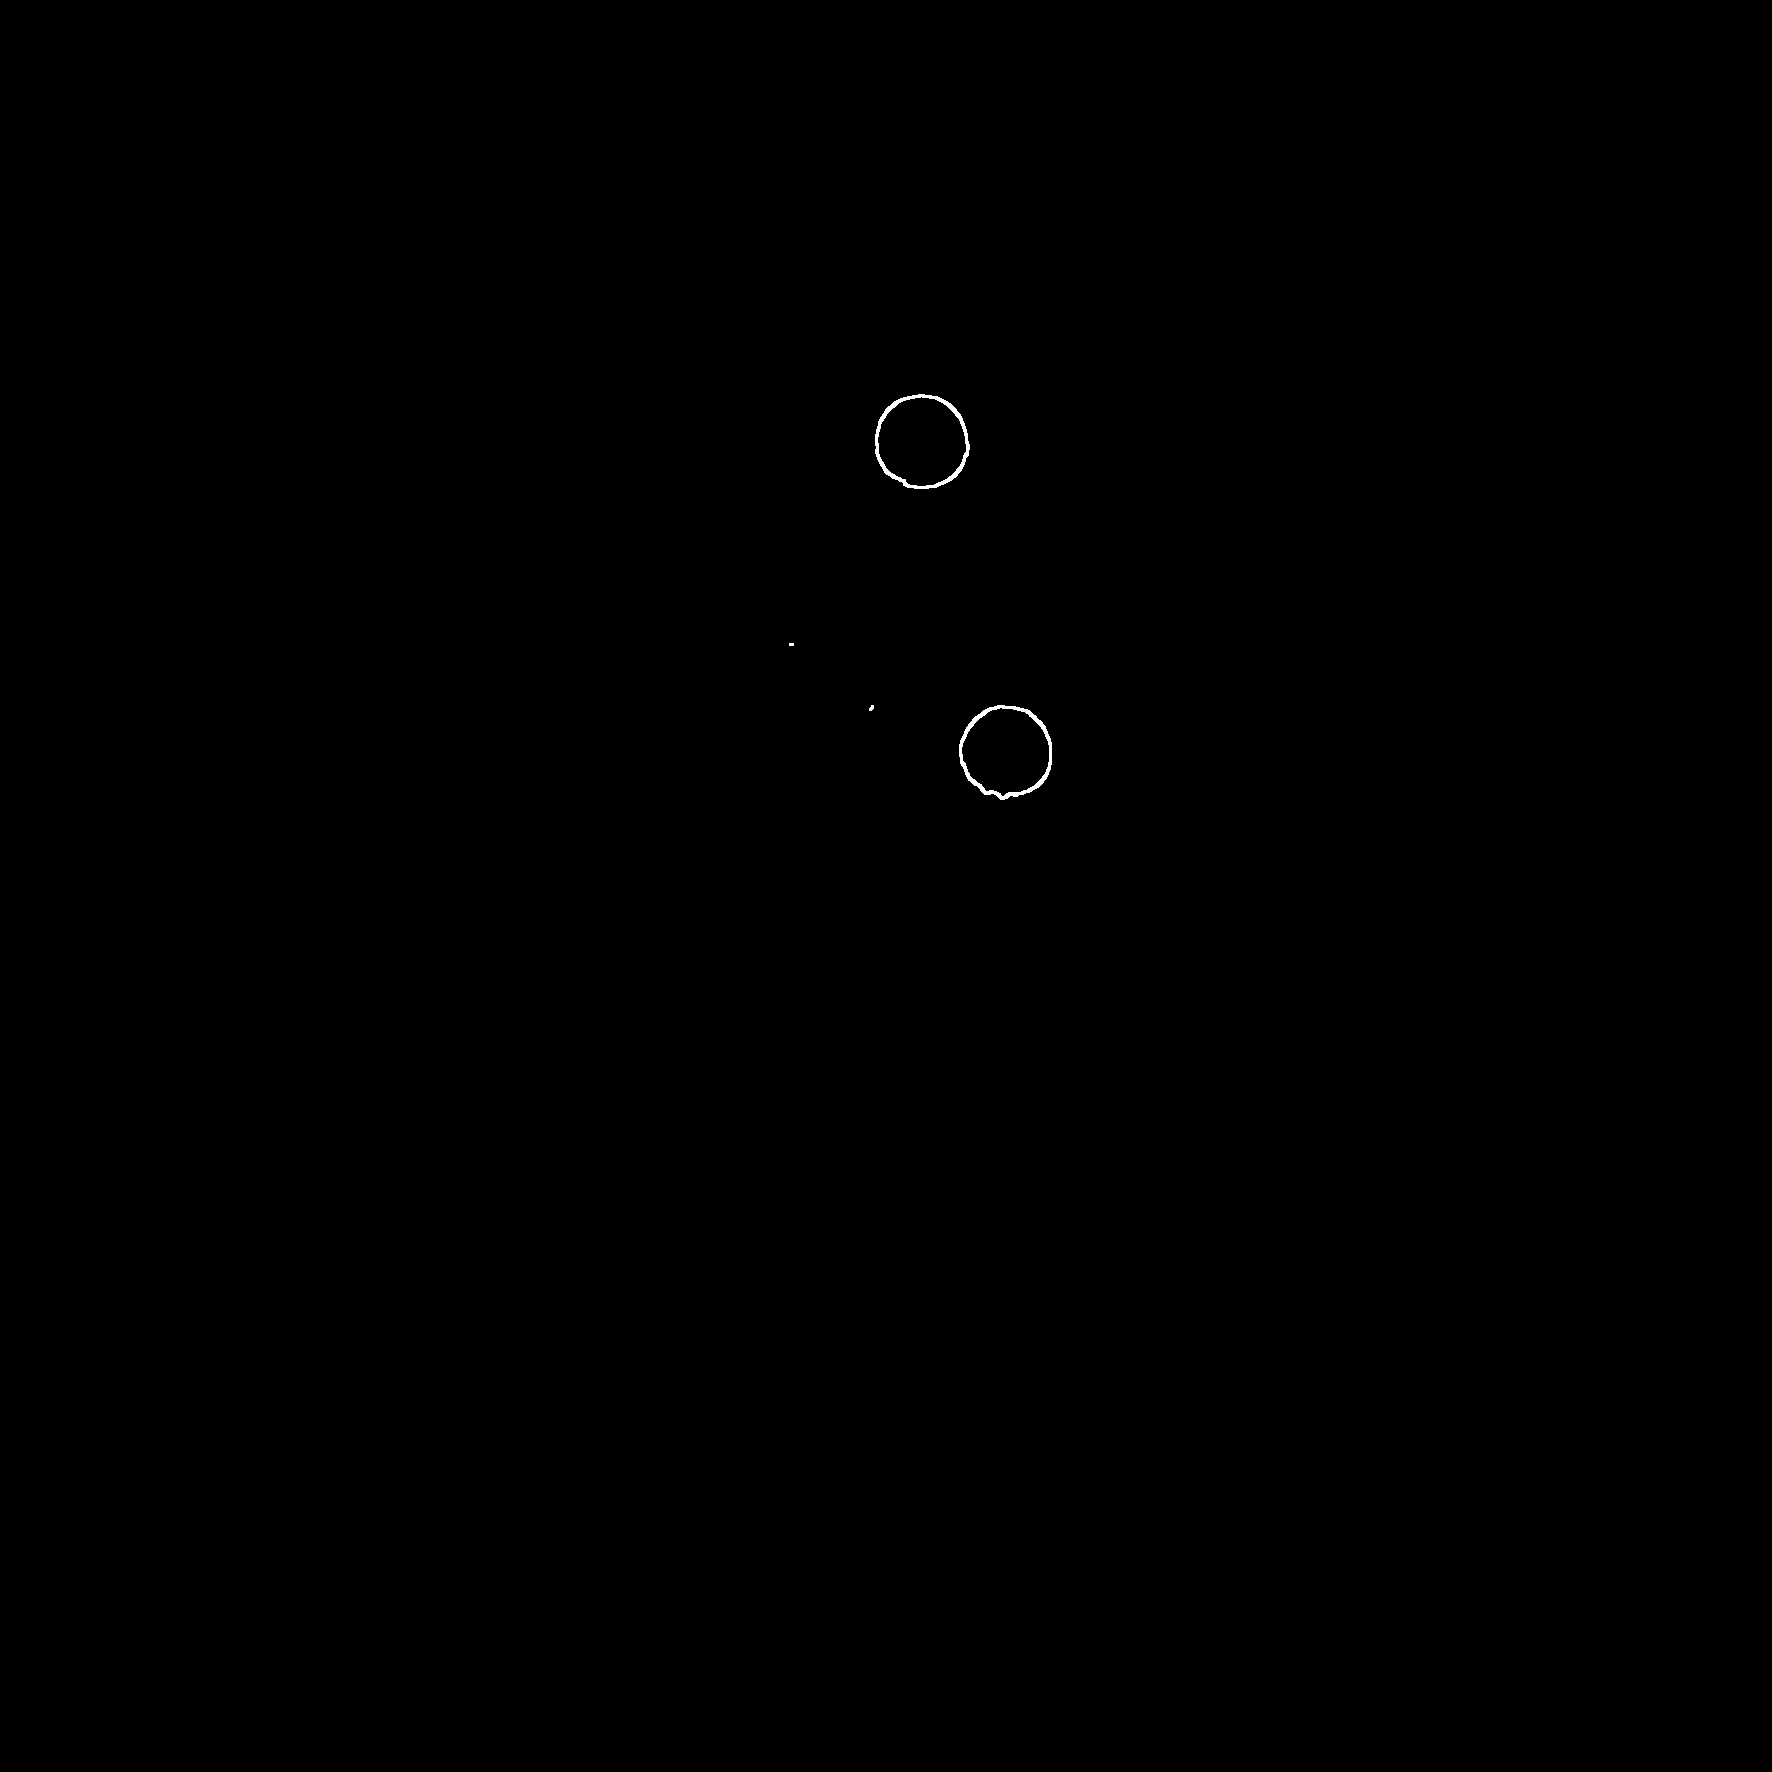

Liczba czarnych kropek: 2


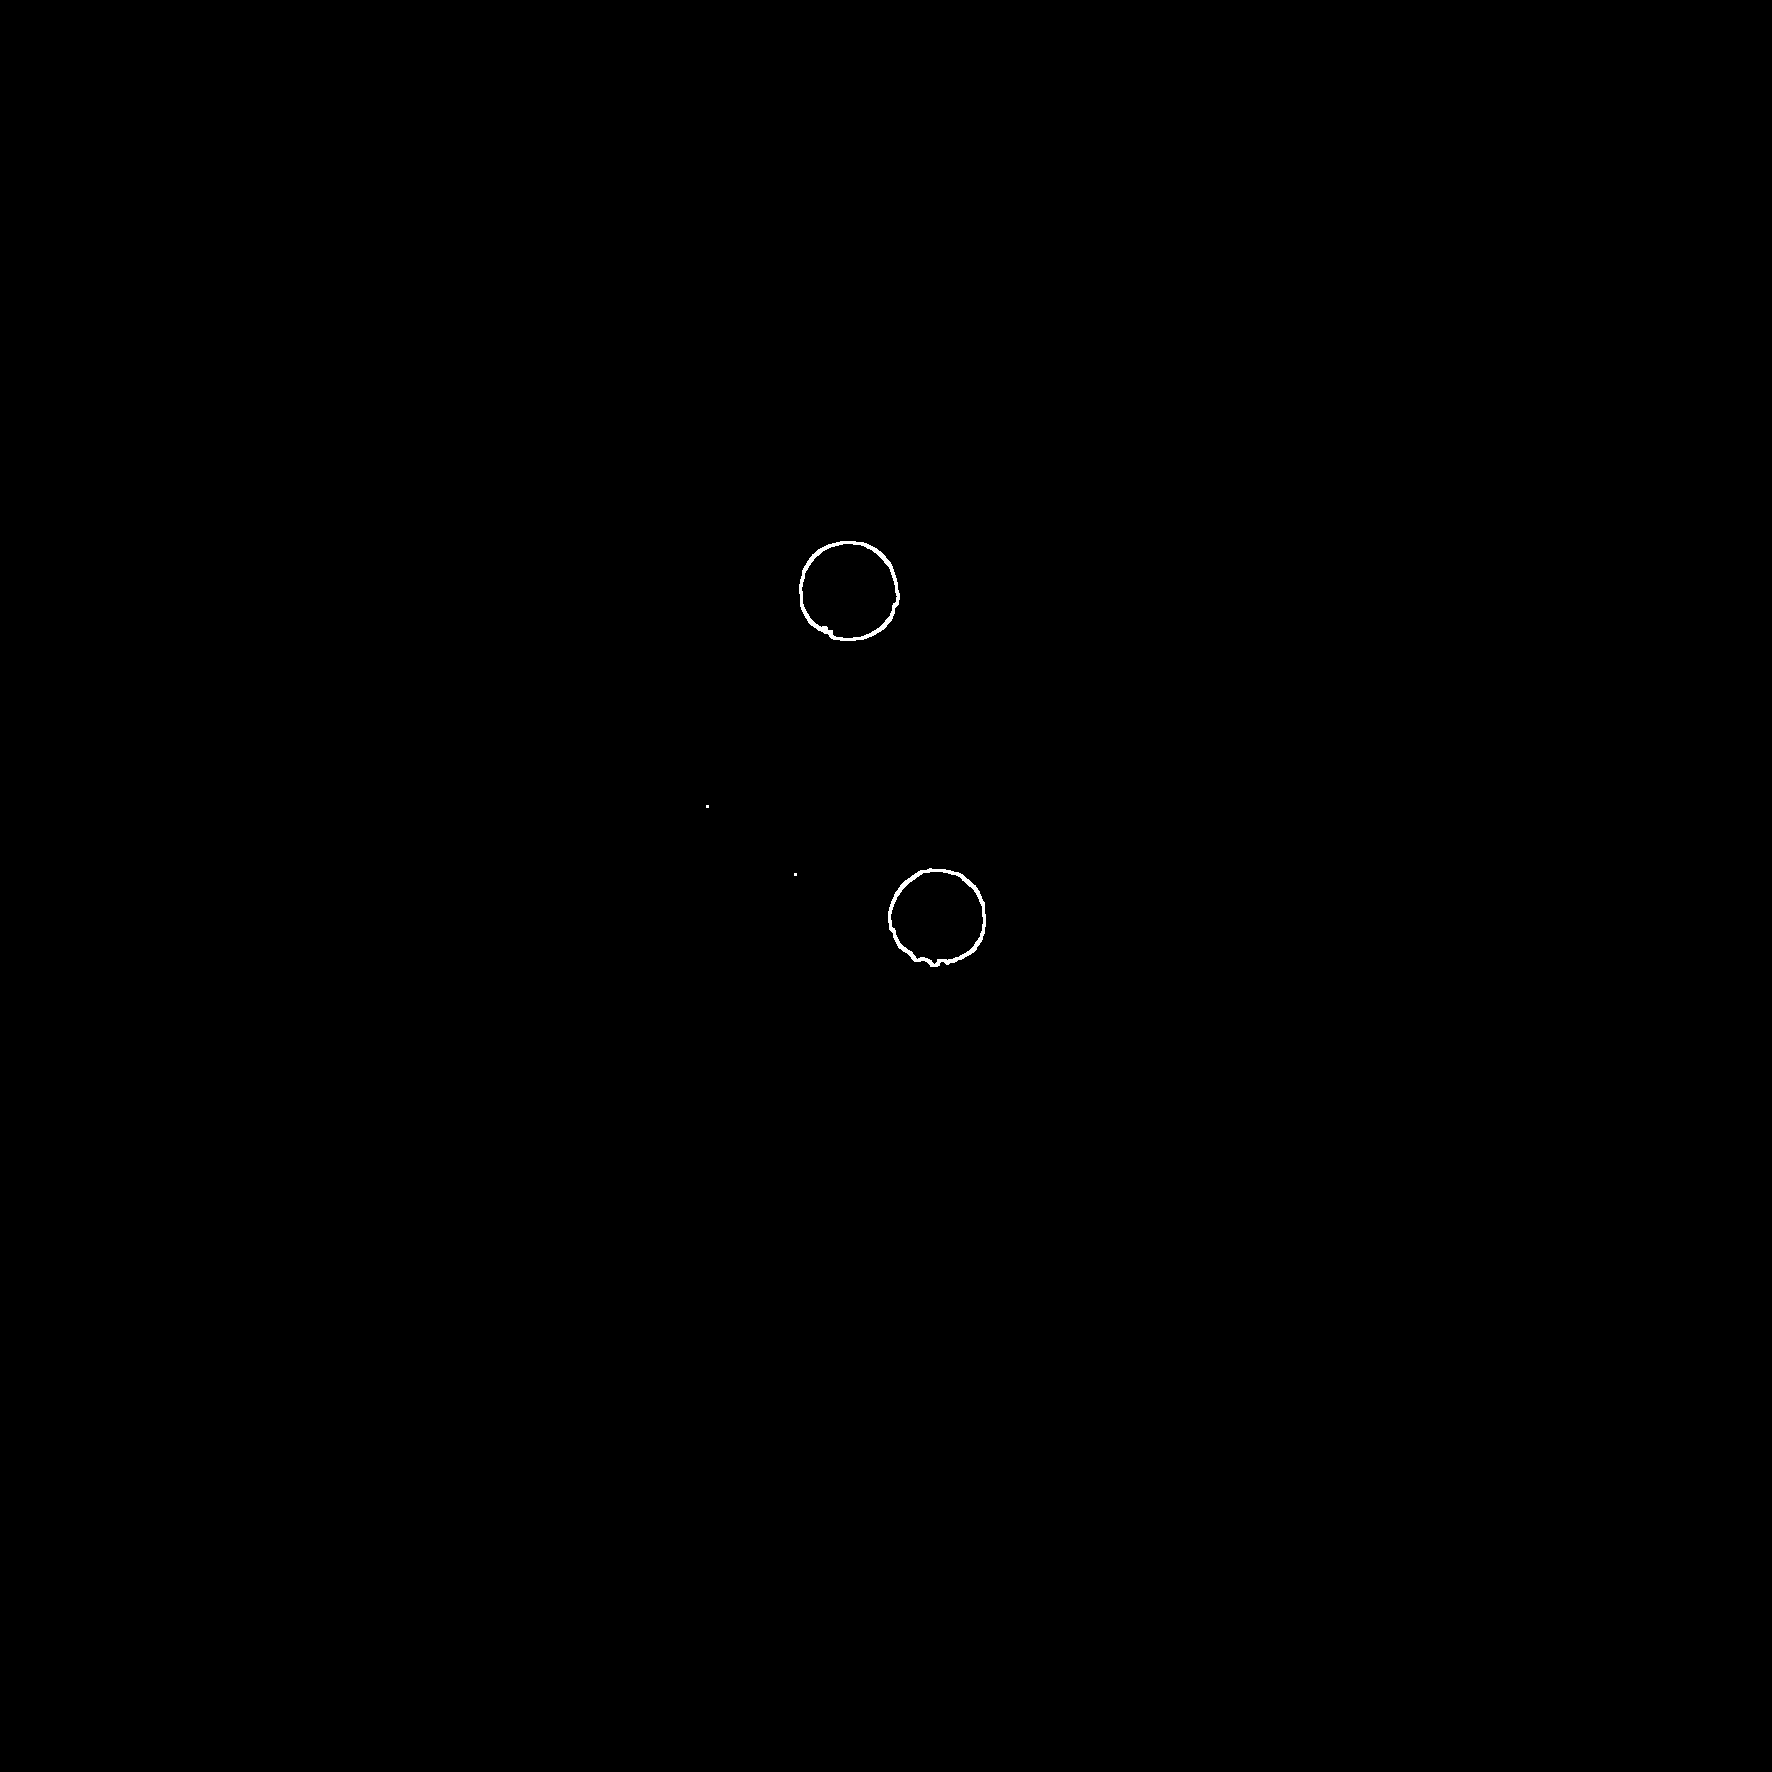

Liczba czarnych kropek: 2


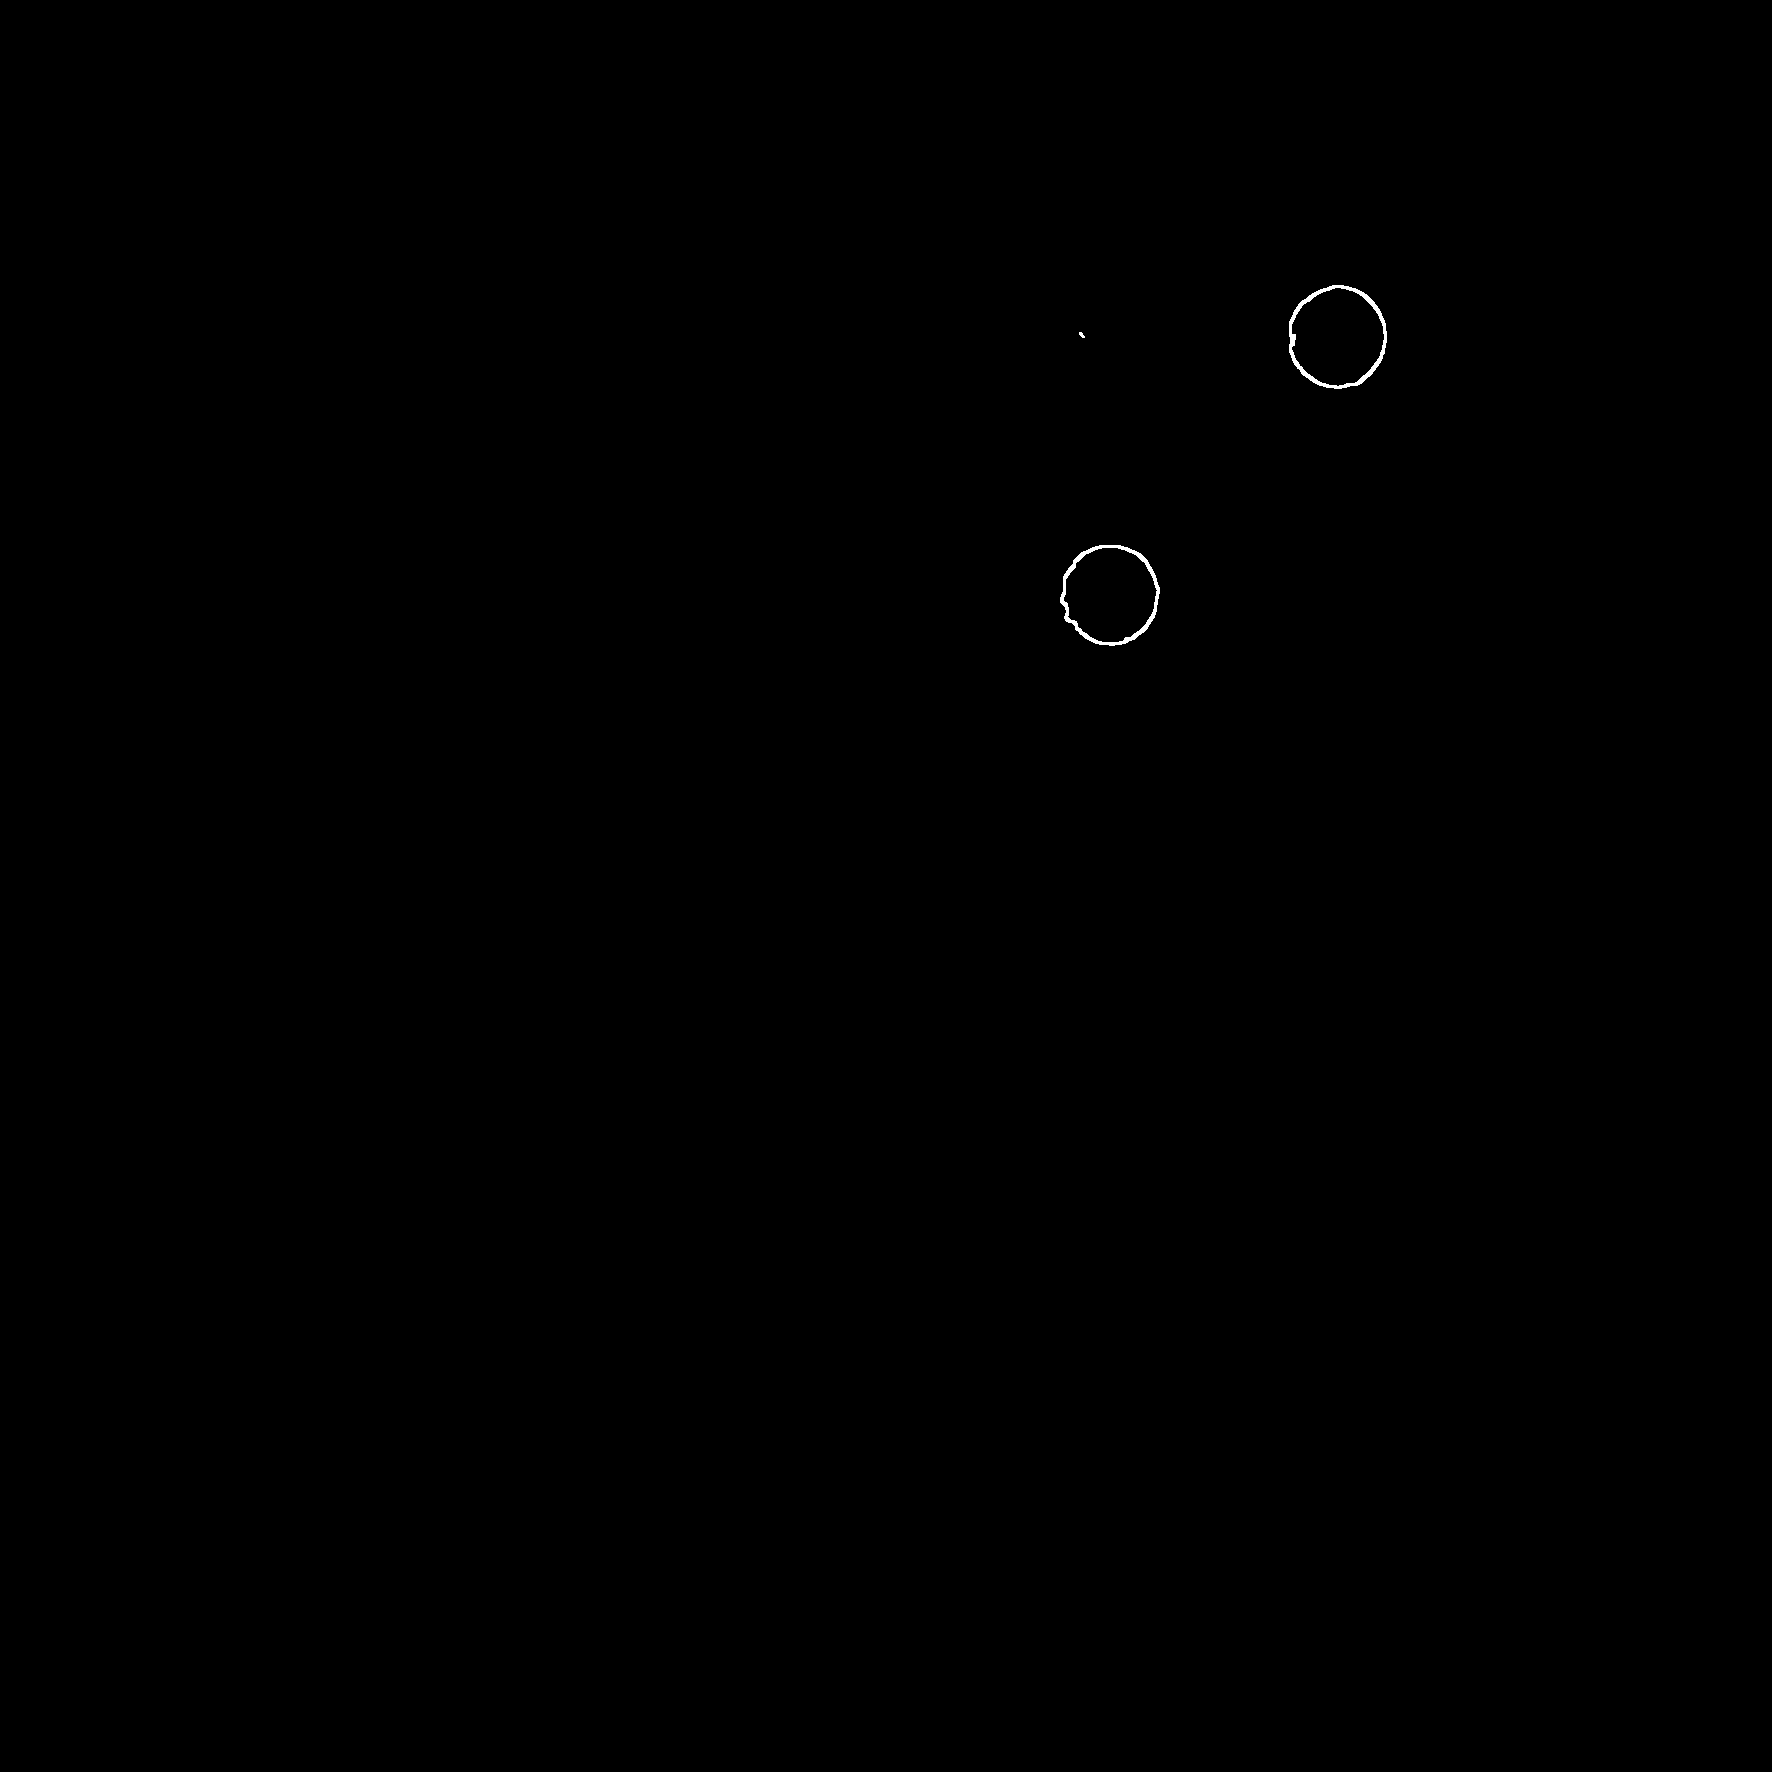

Liczba czarnych kropek: 2


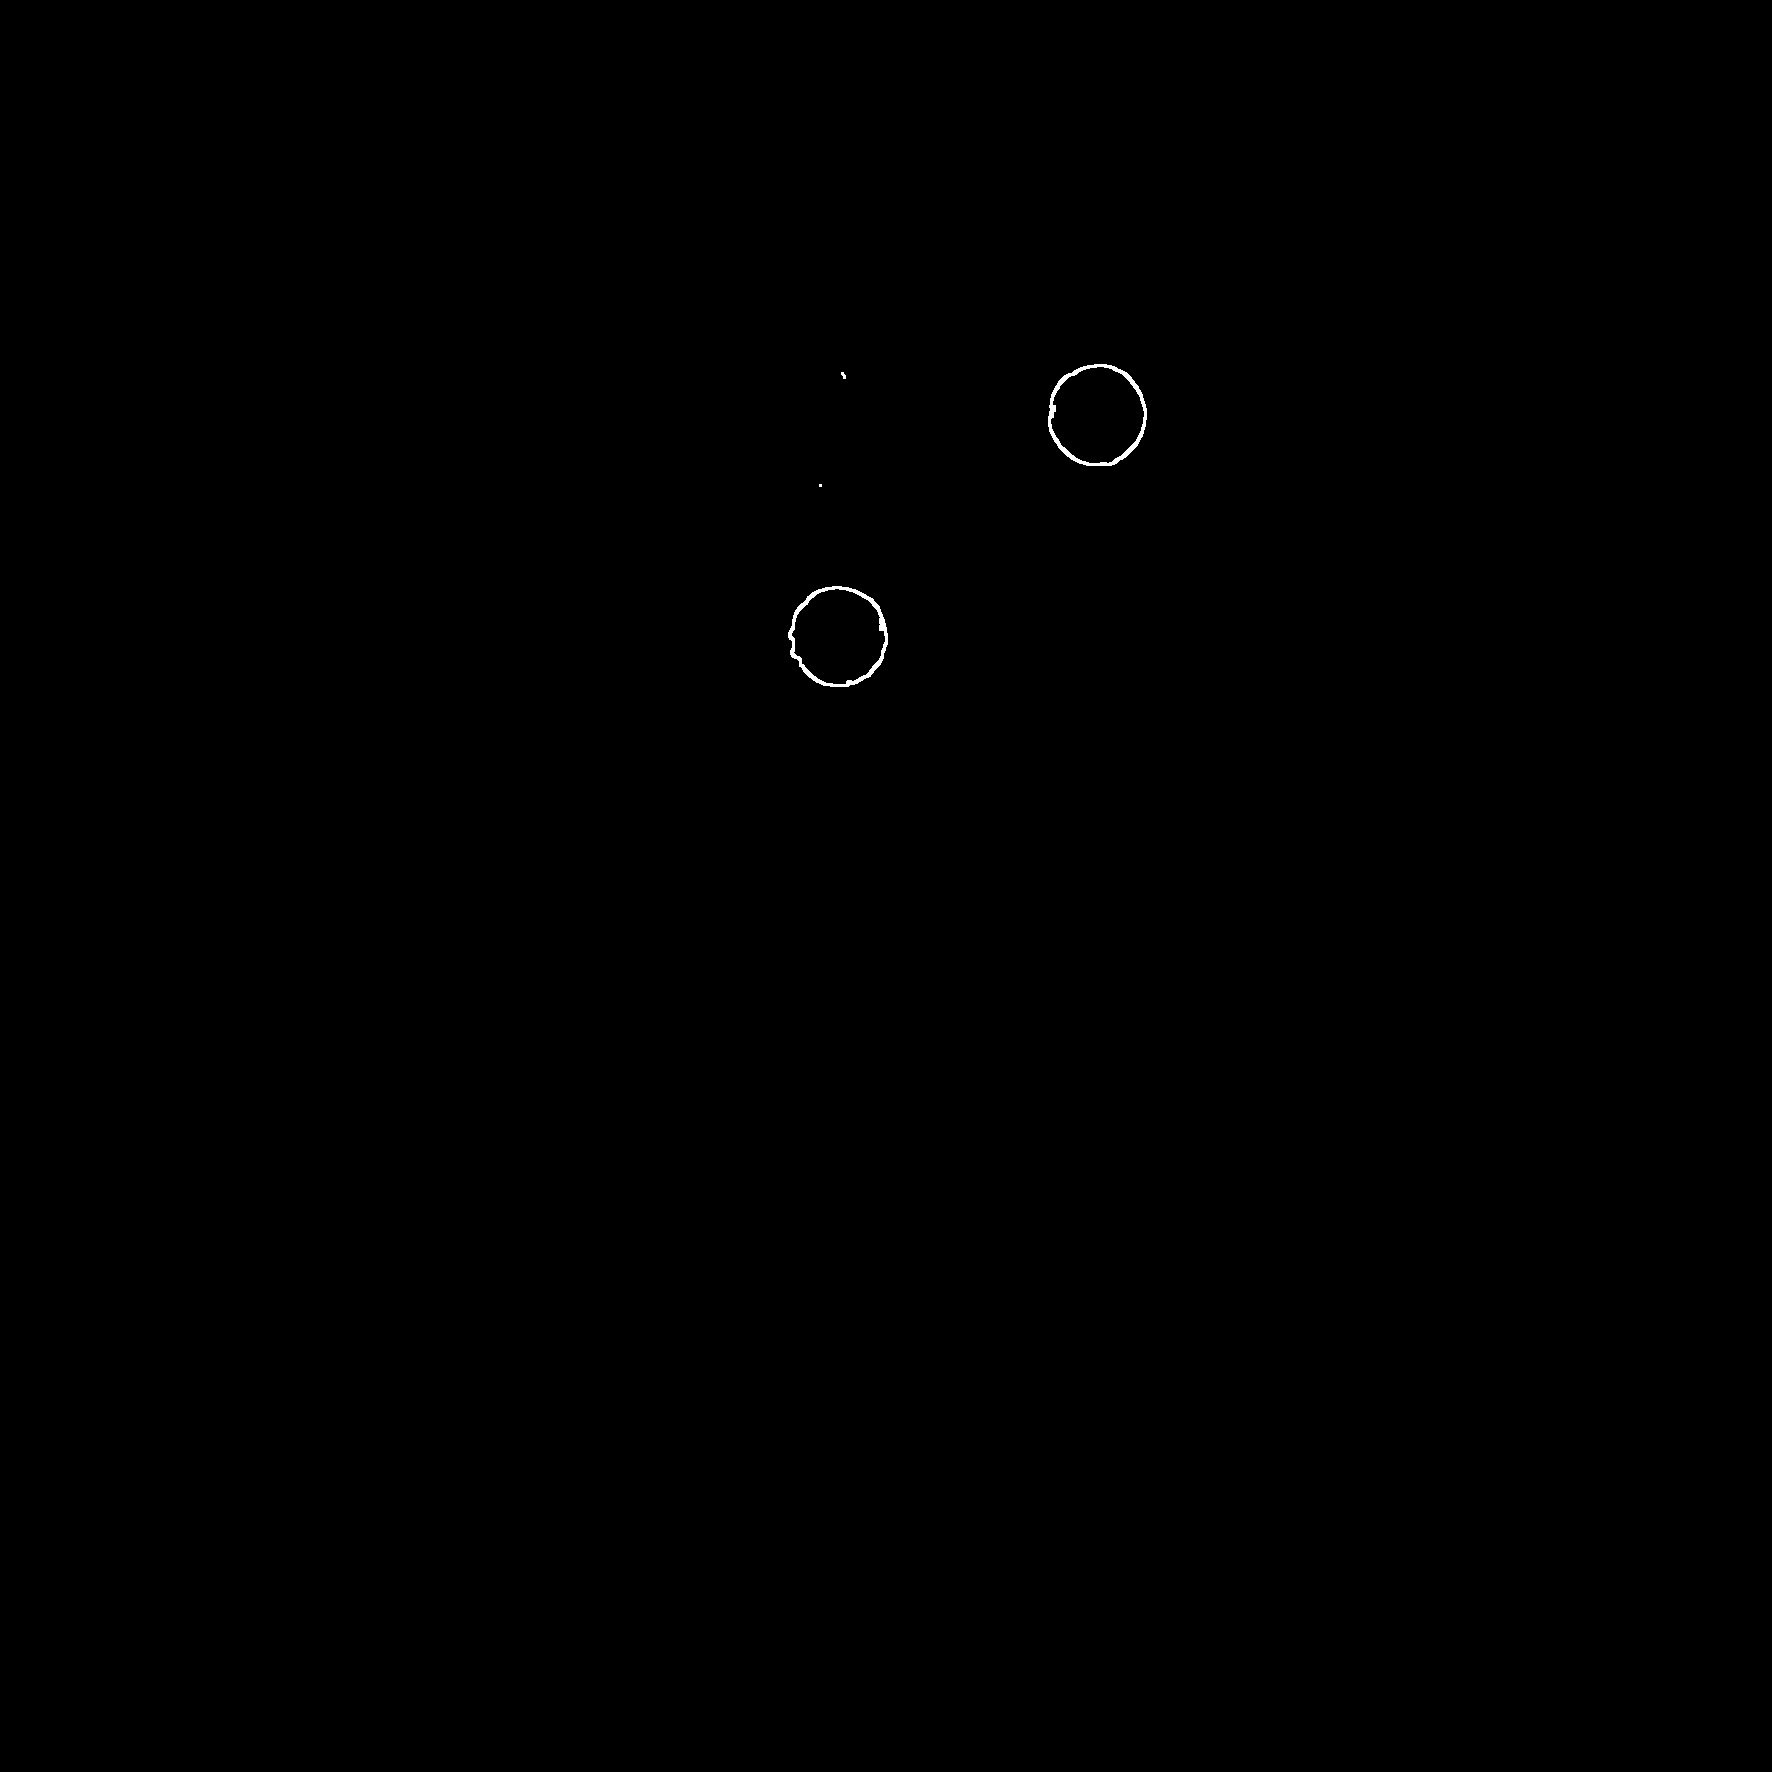

Liczba czarnych kropek: 2


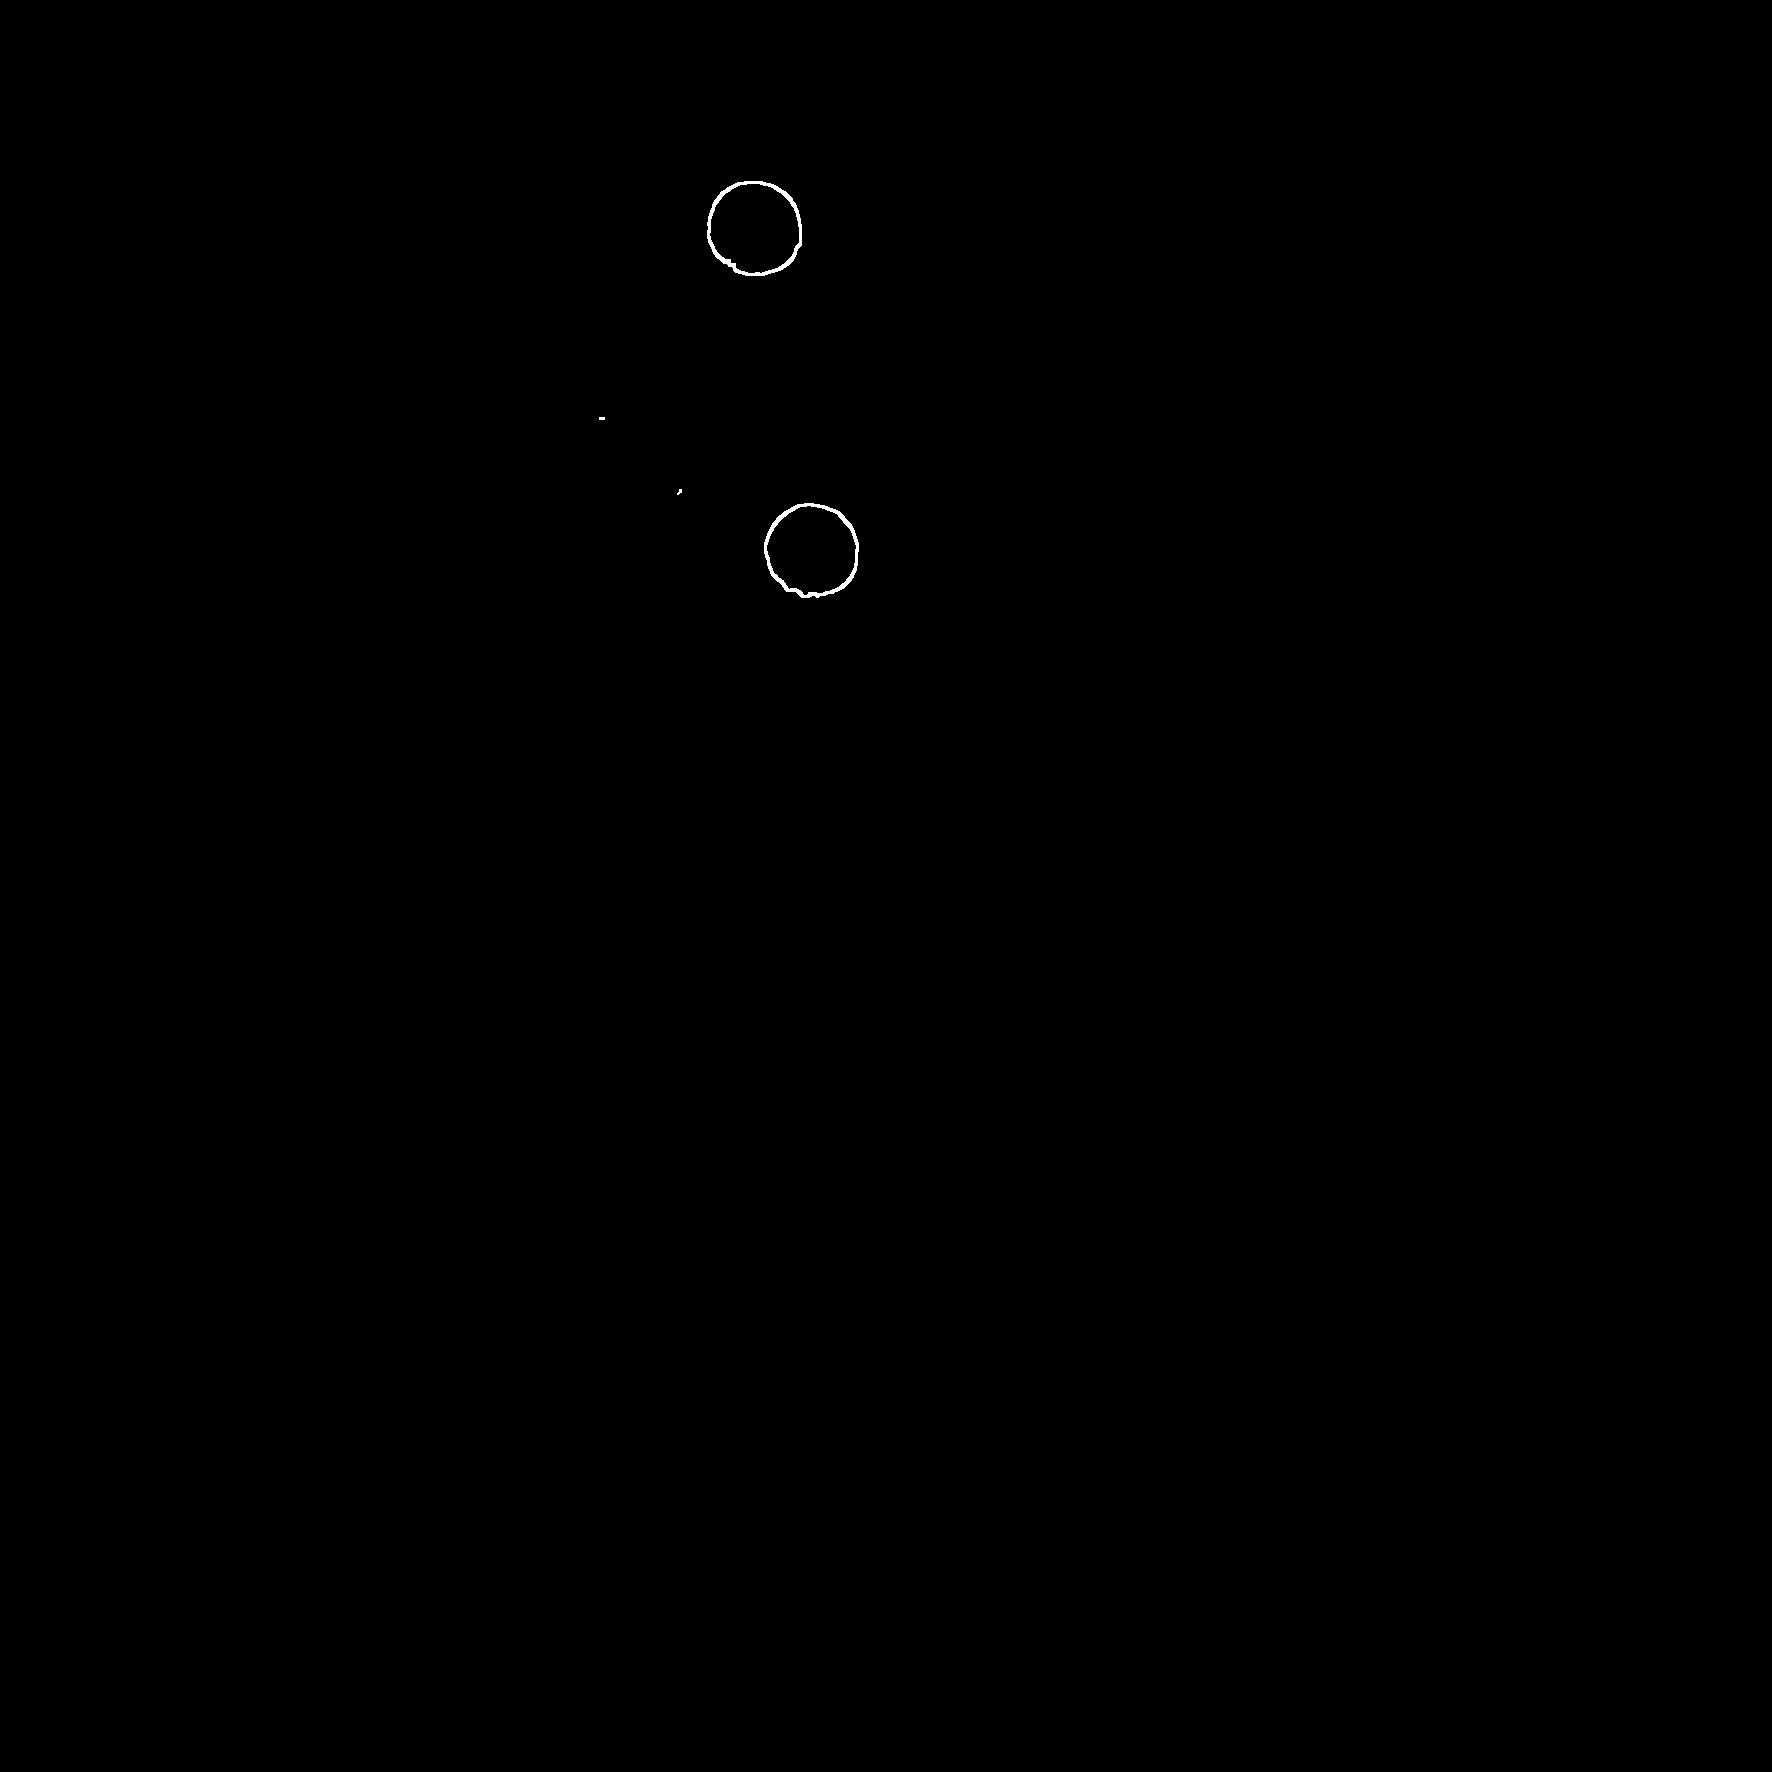

Liczba czarnych kropek: 2


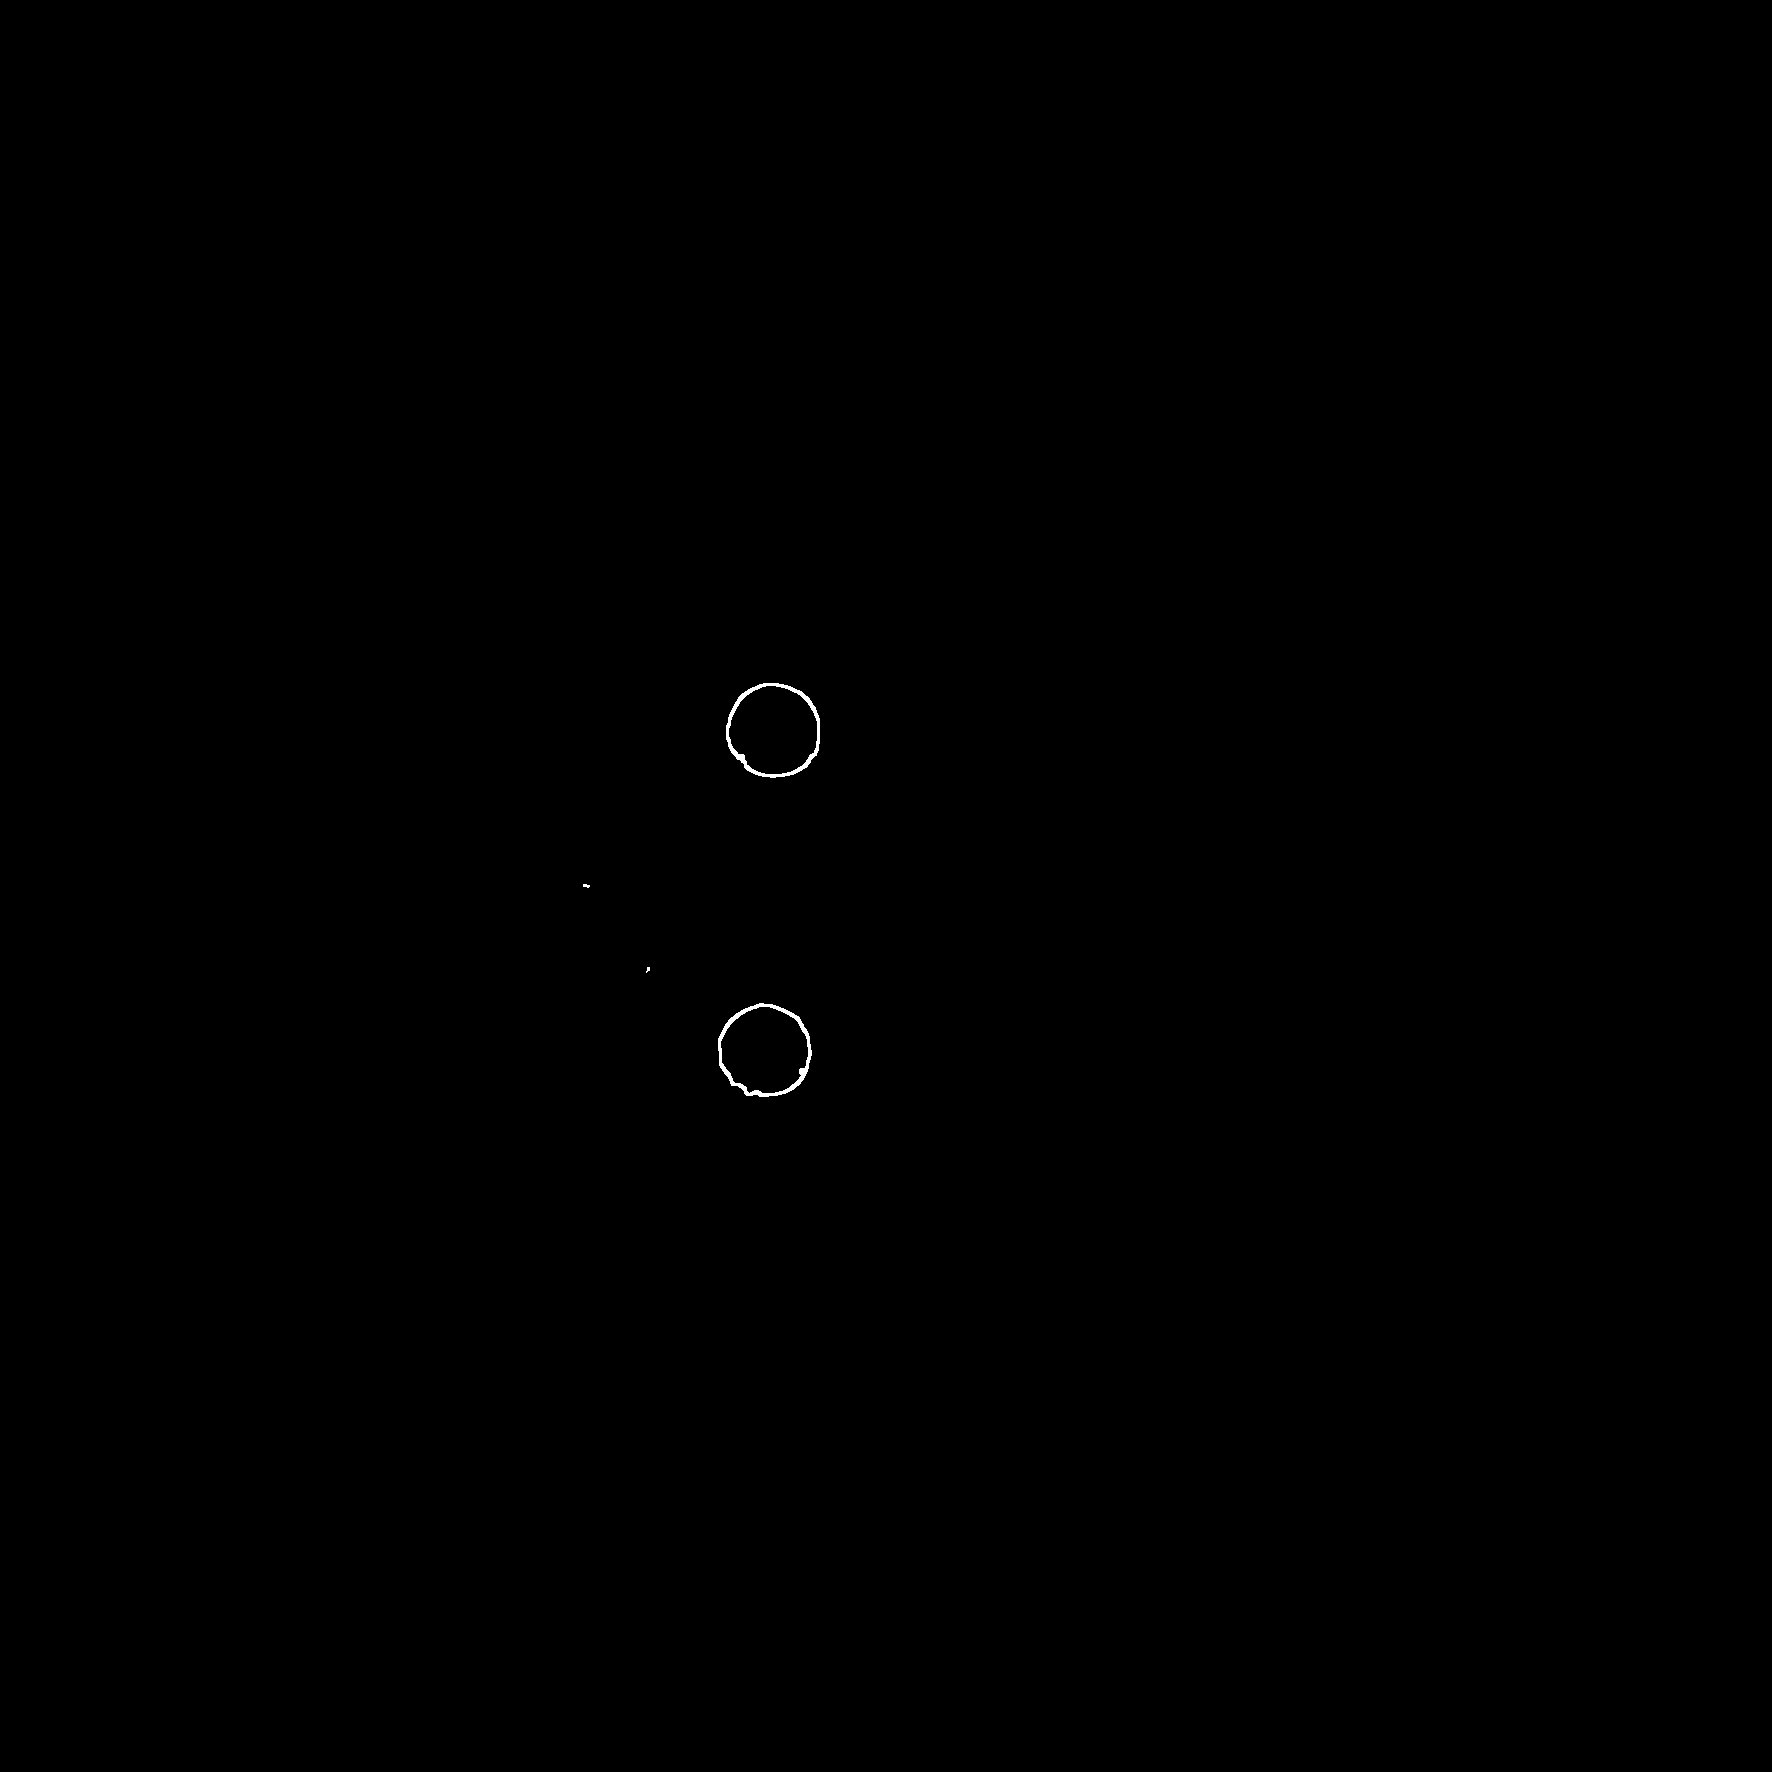

Liczba czarnych kropek: 2


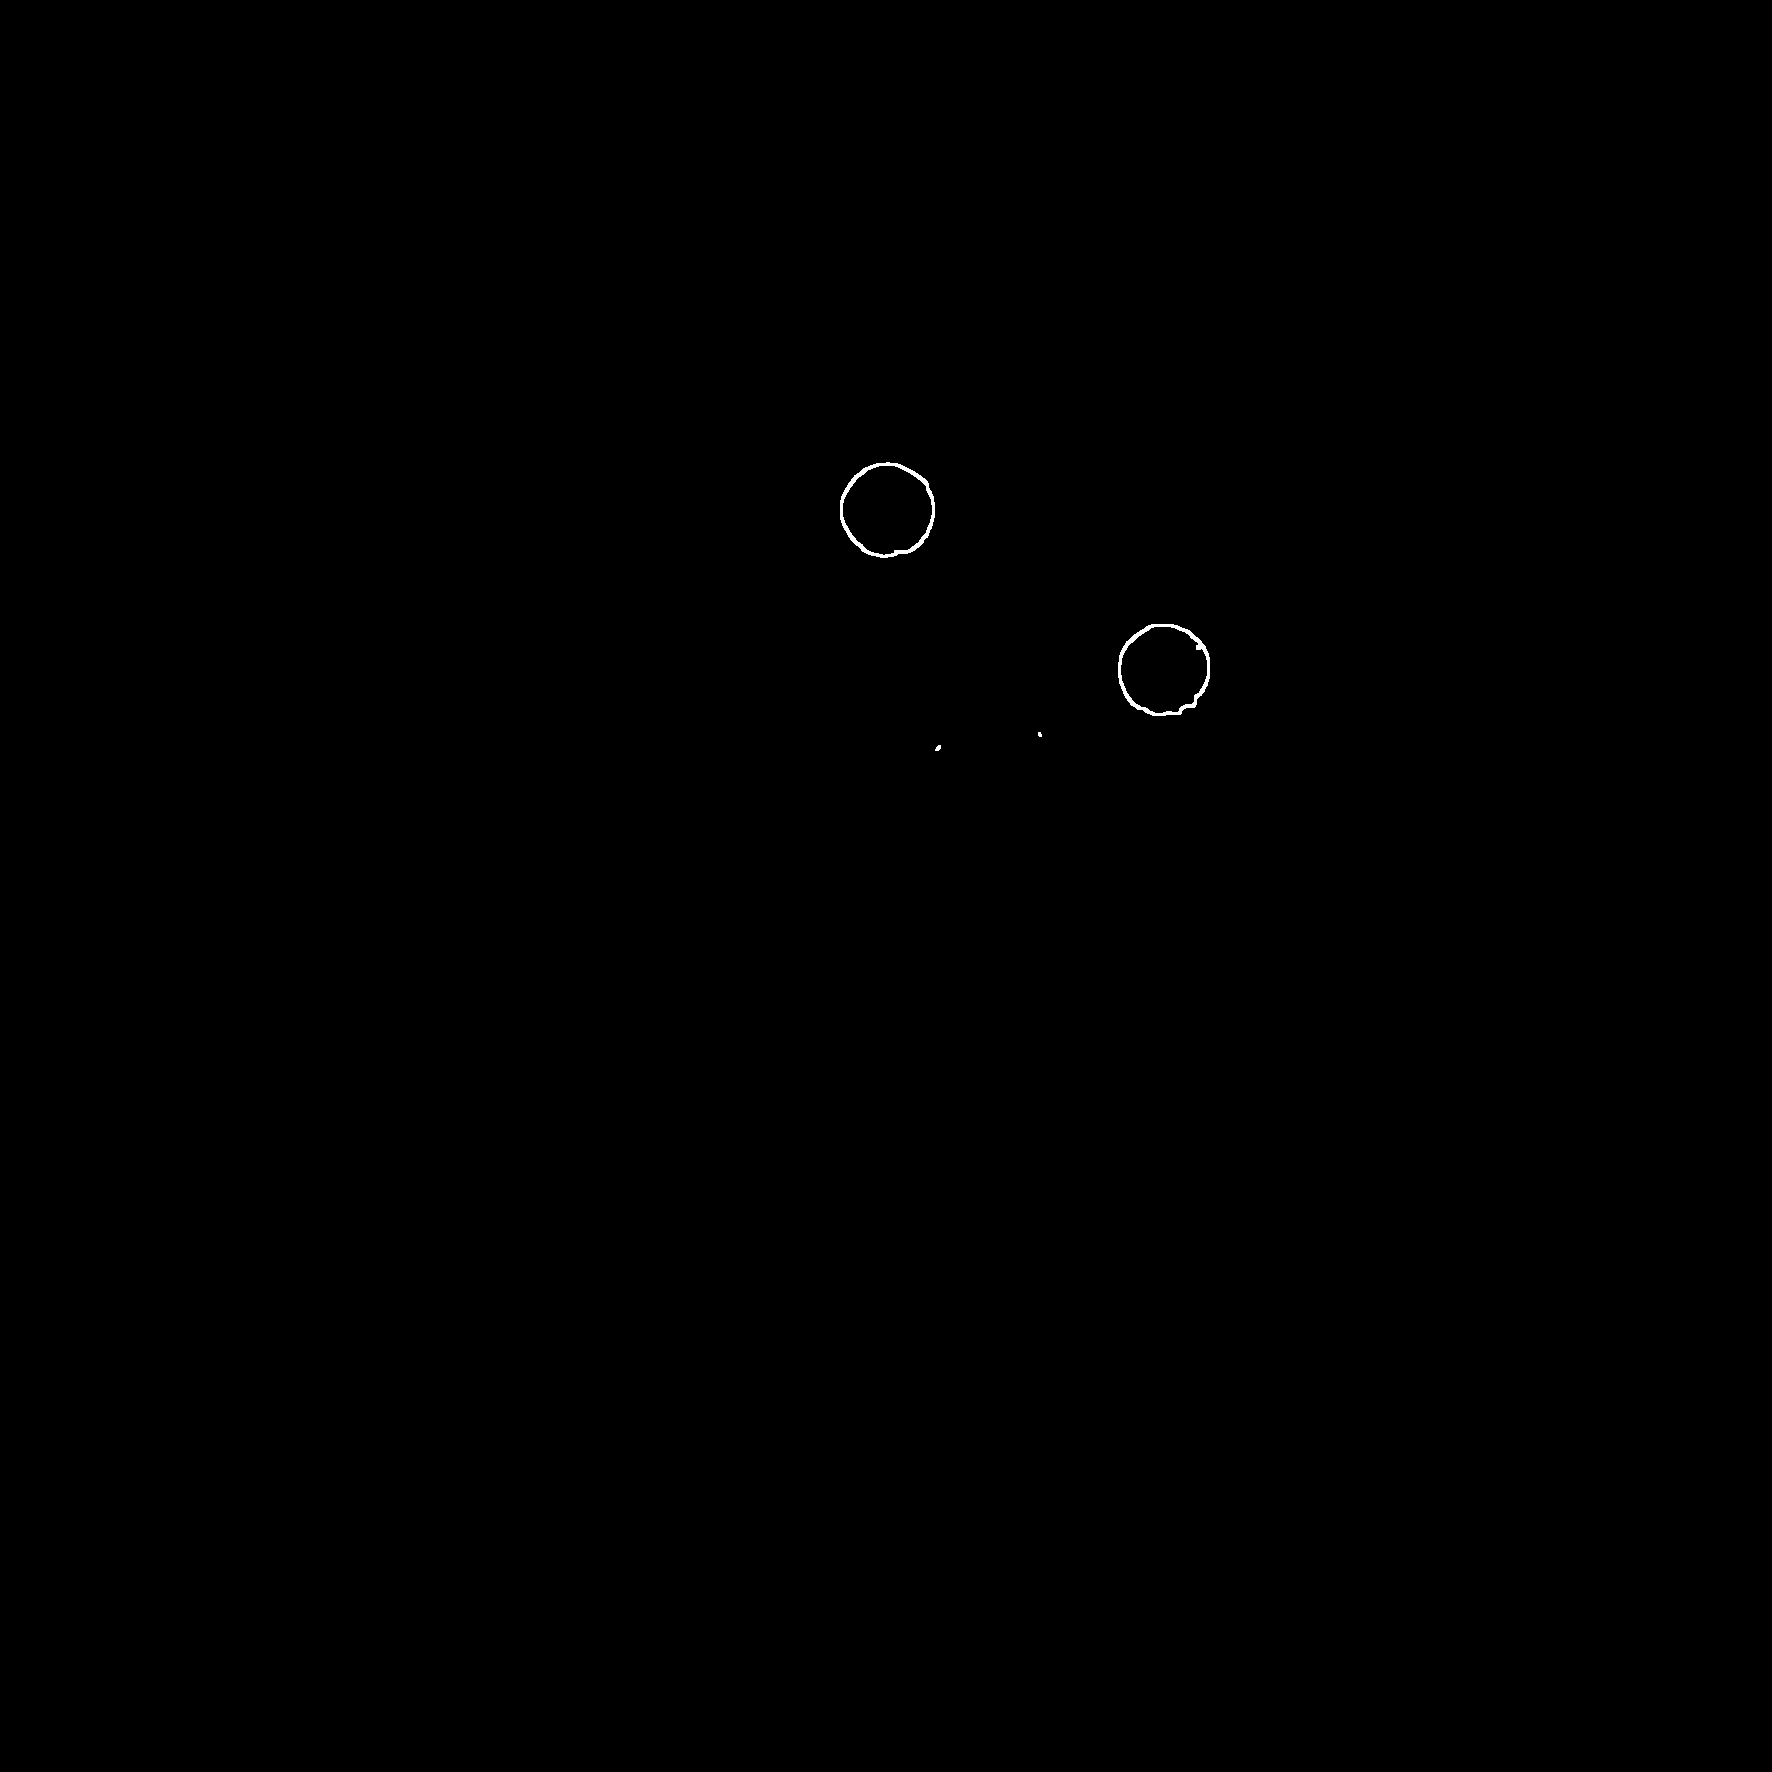

Liczba czarnych kropek: 2


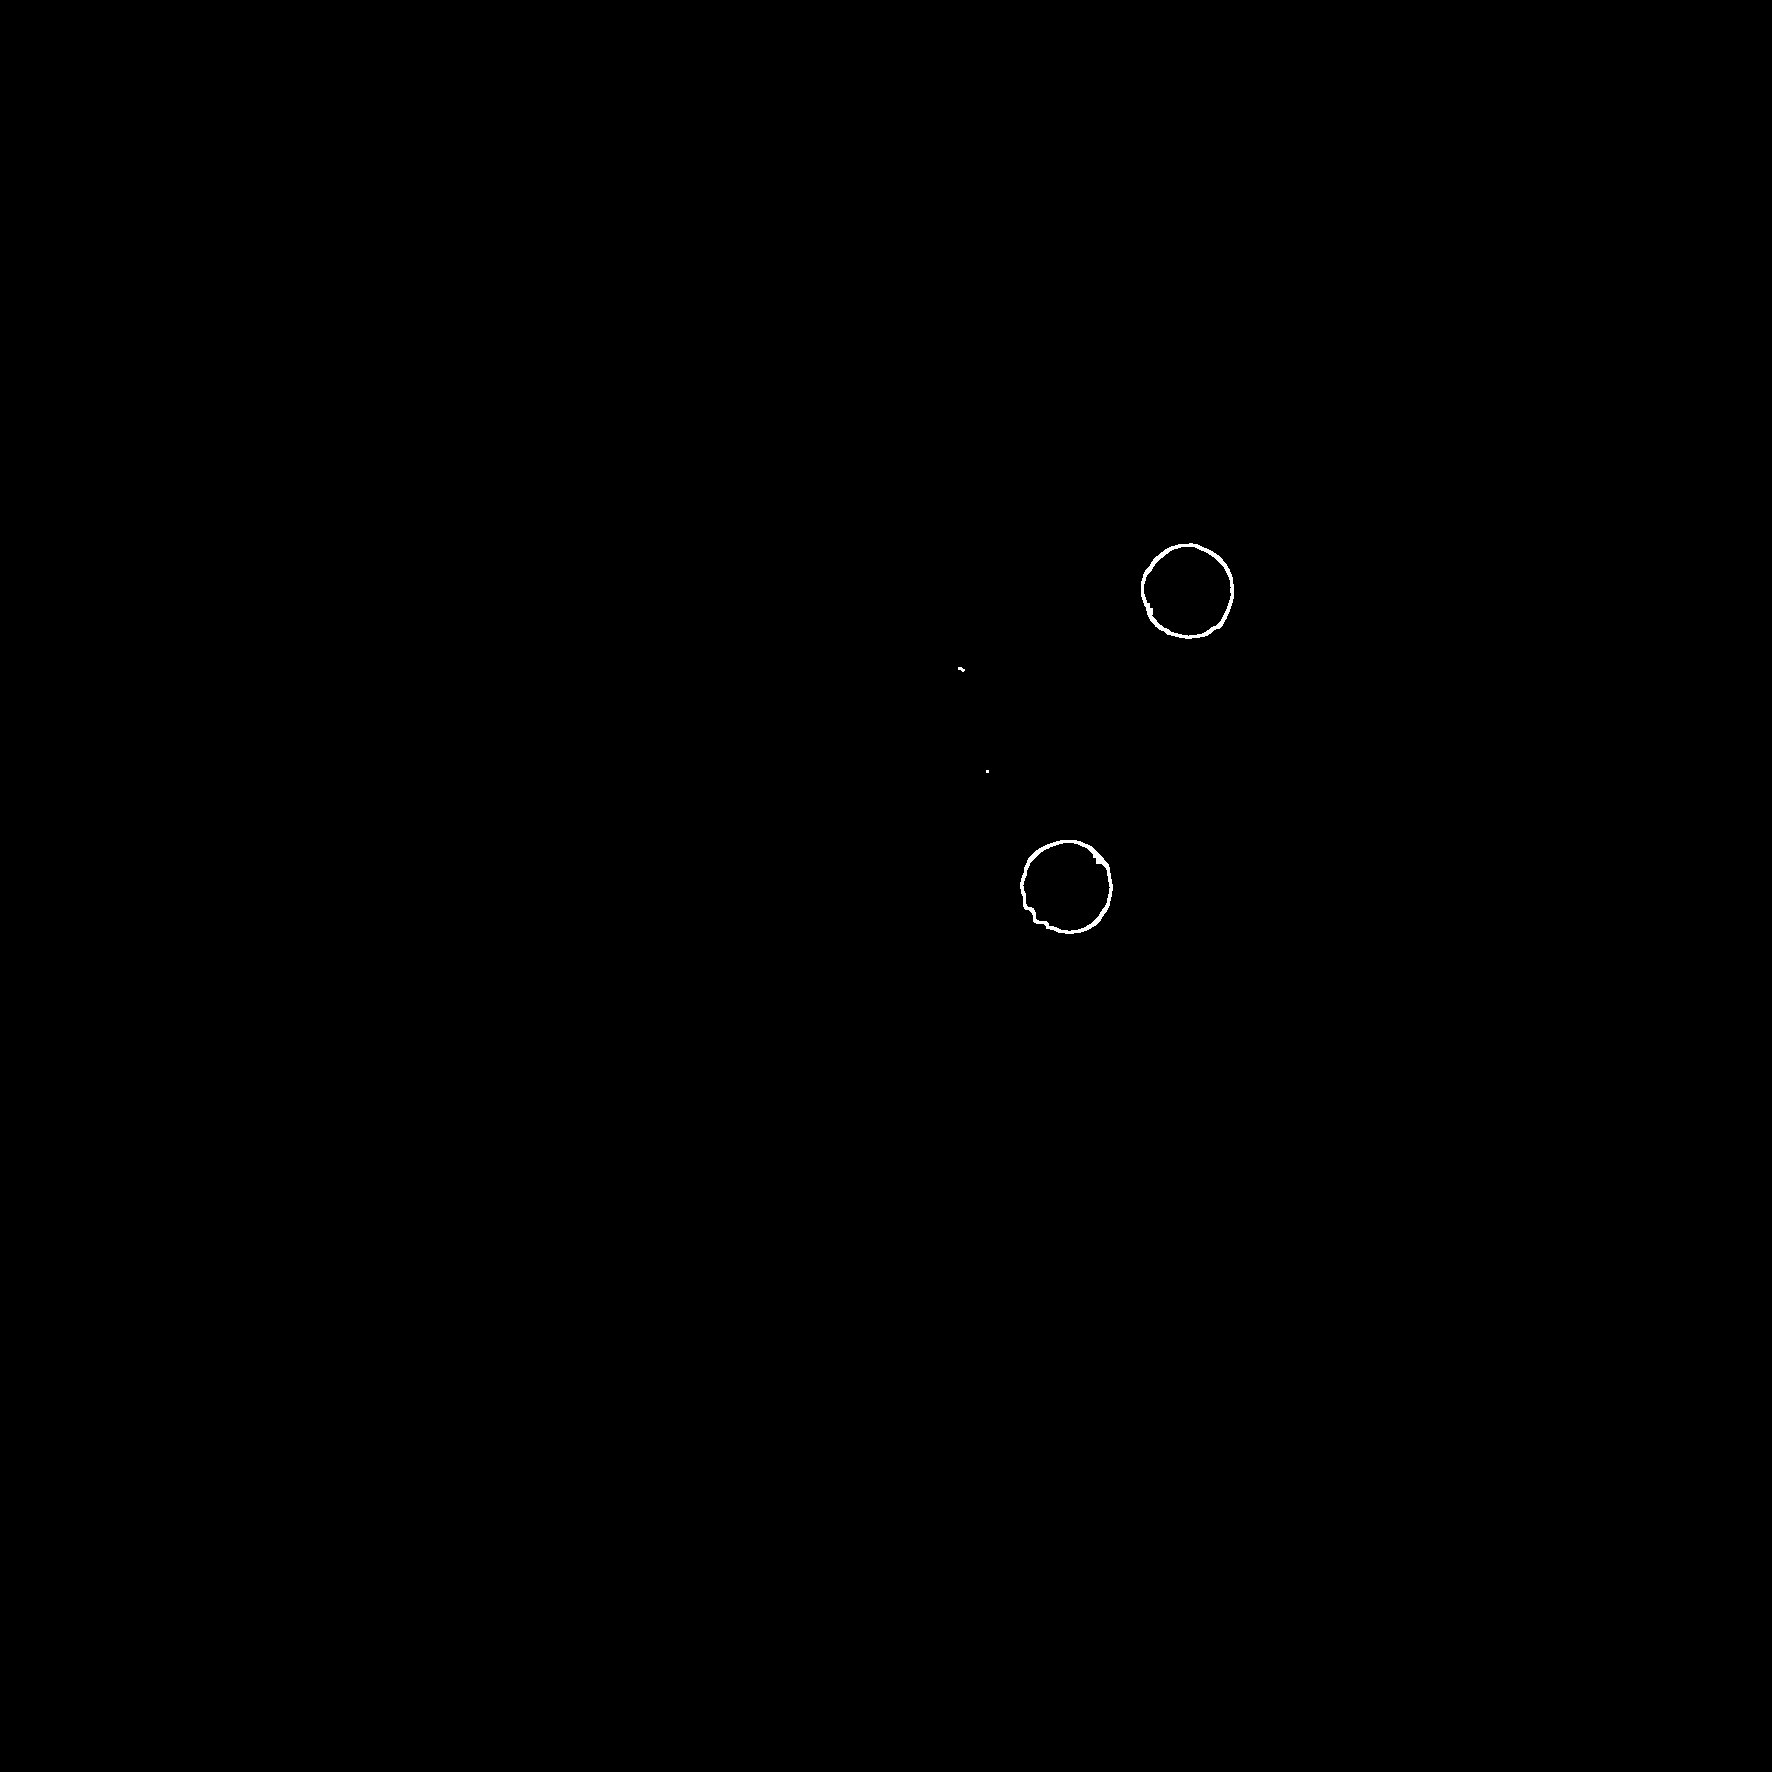

Liczba czarnych kropek: 2


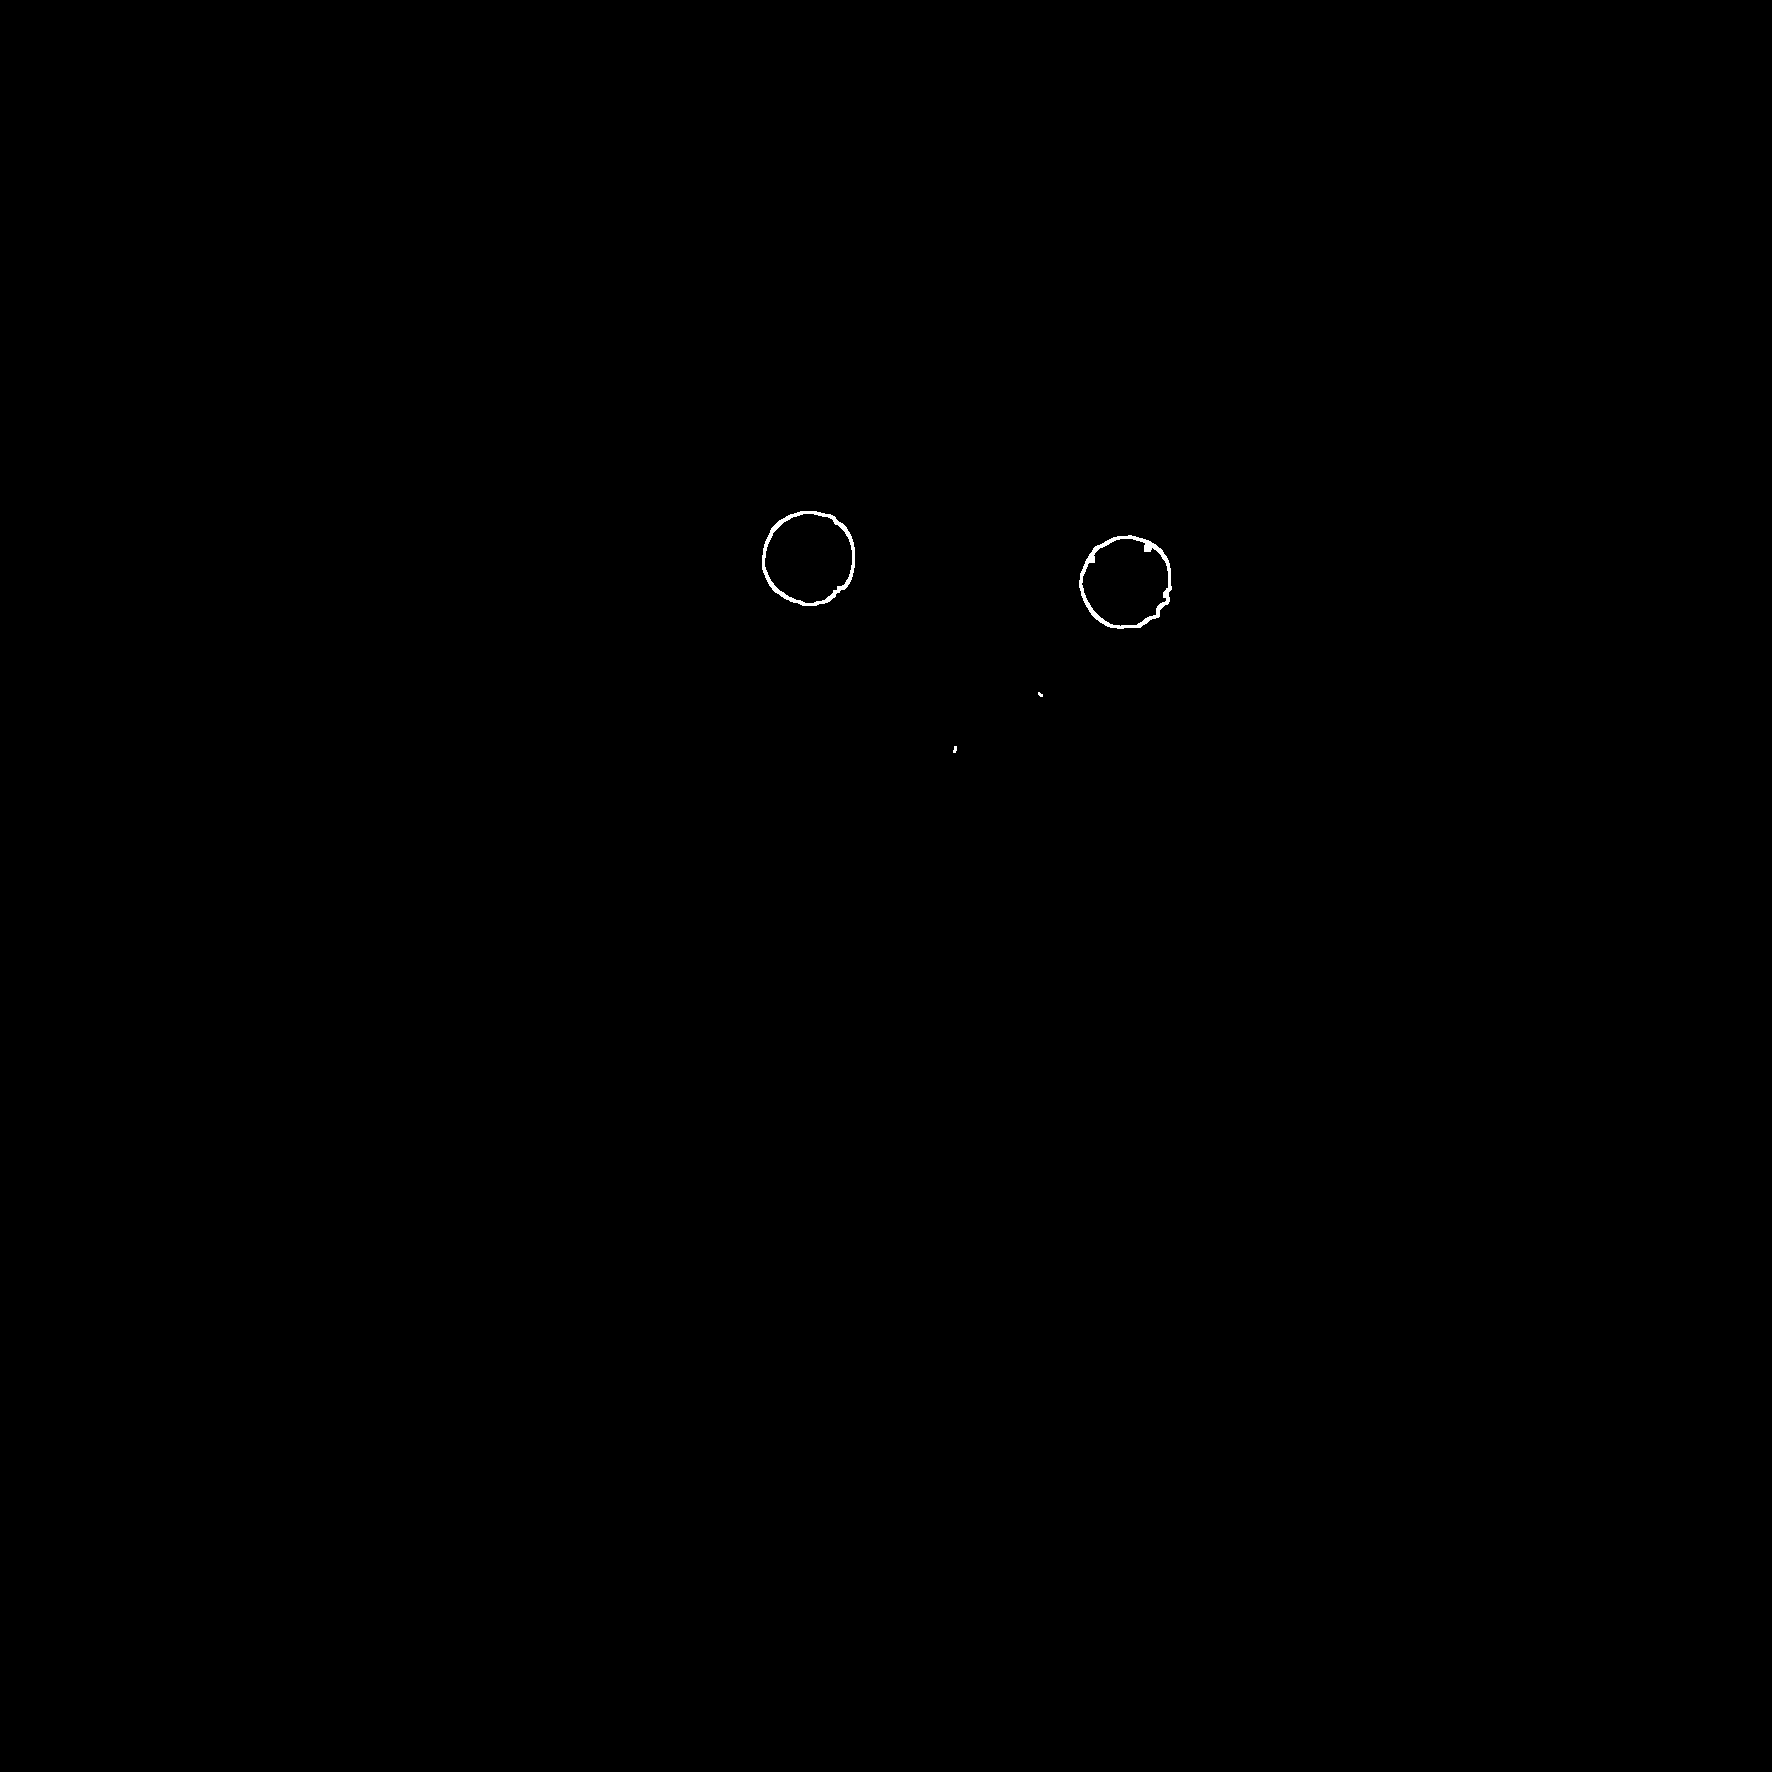

Liczba czarnych kropek: 2


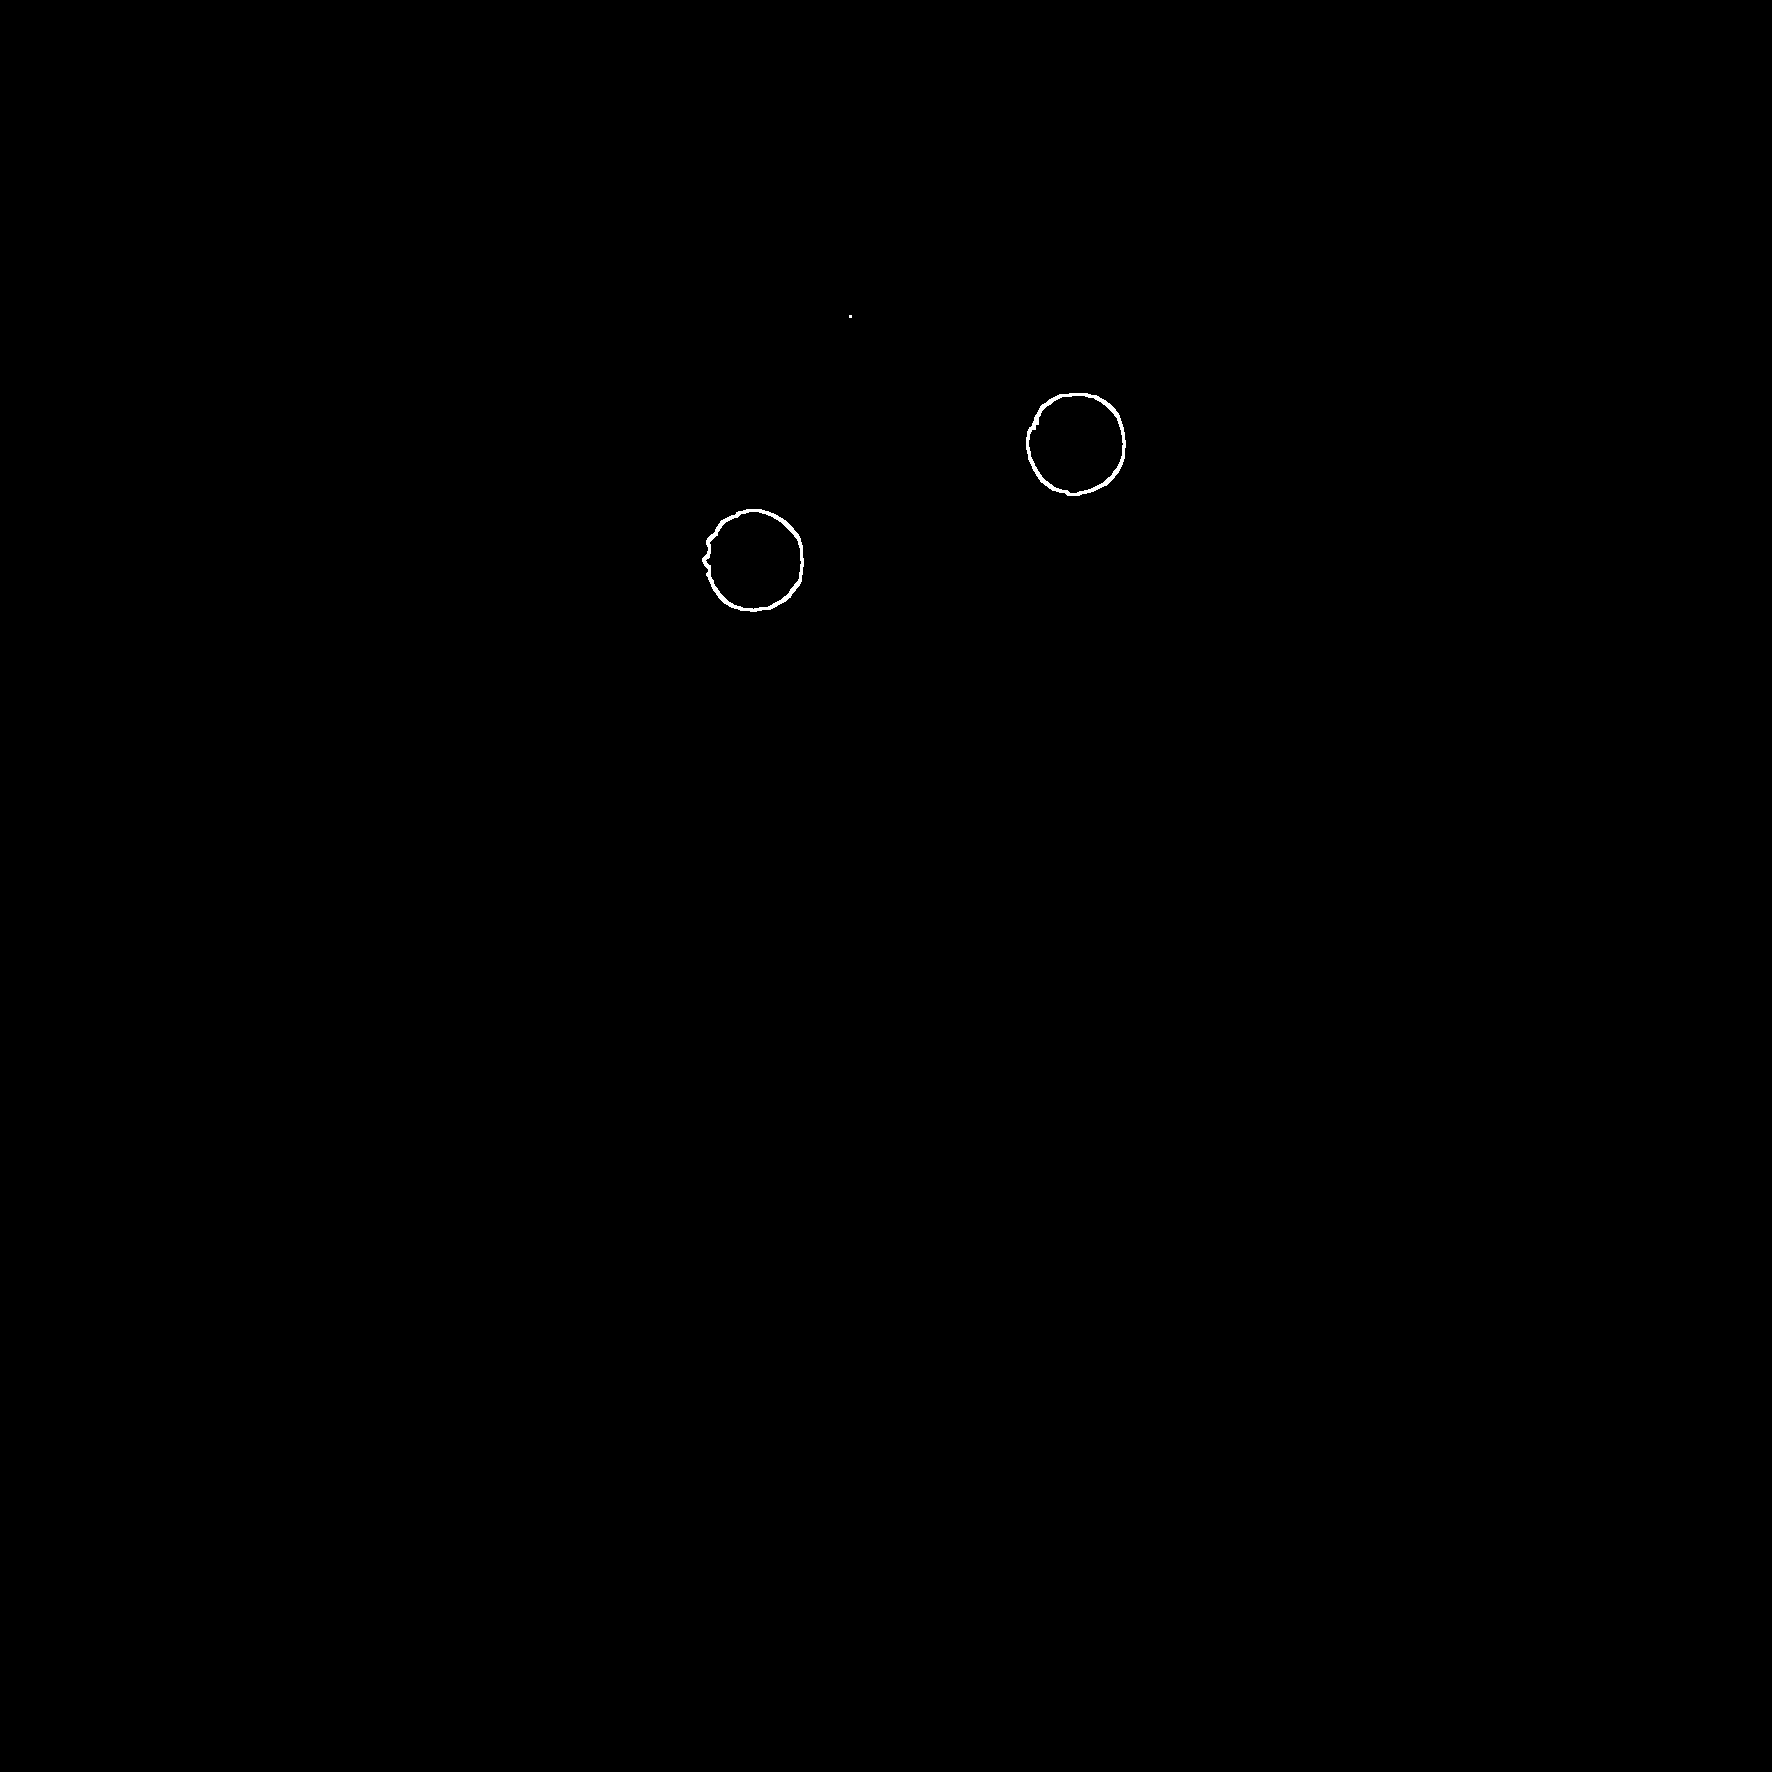

Liczba czarnych kropek: 2


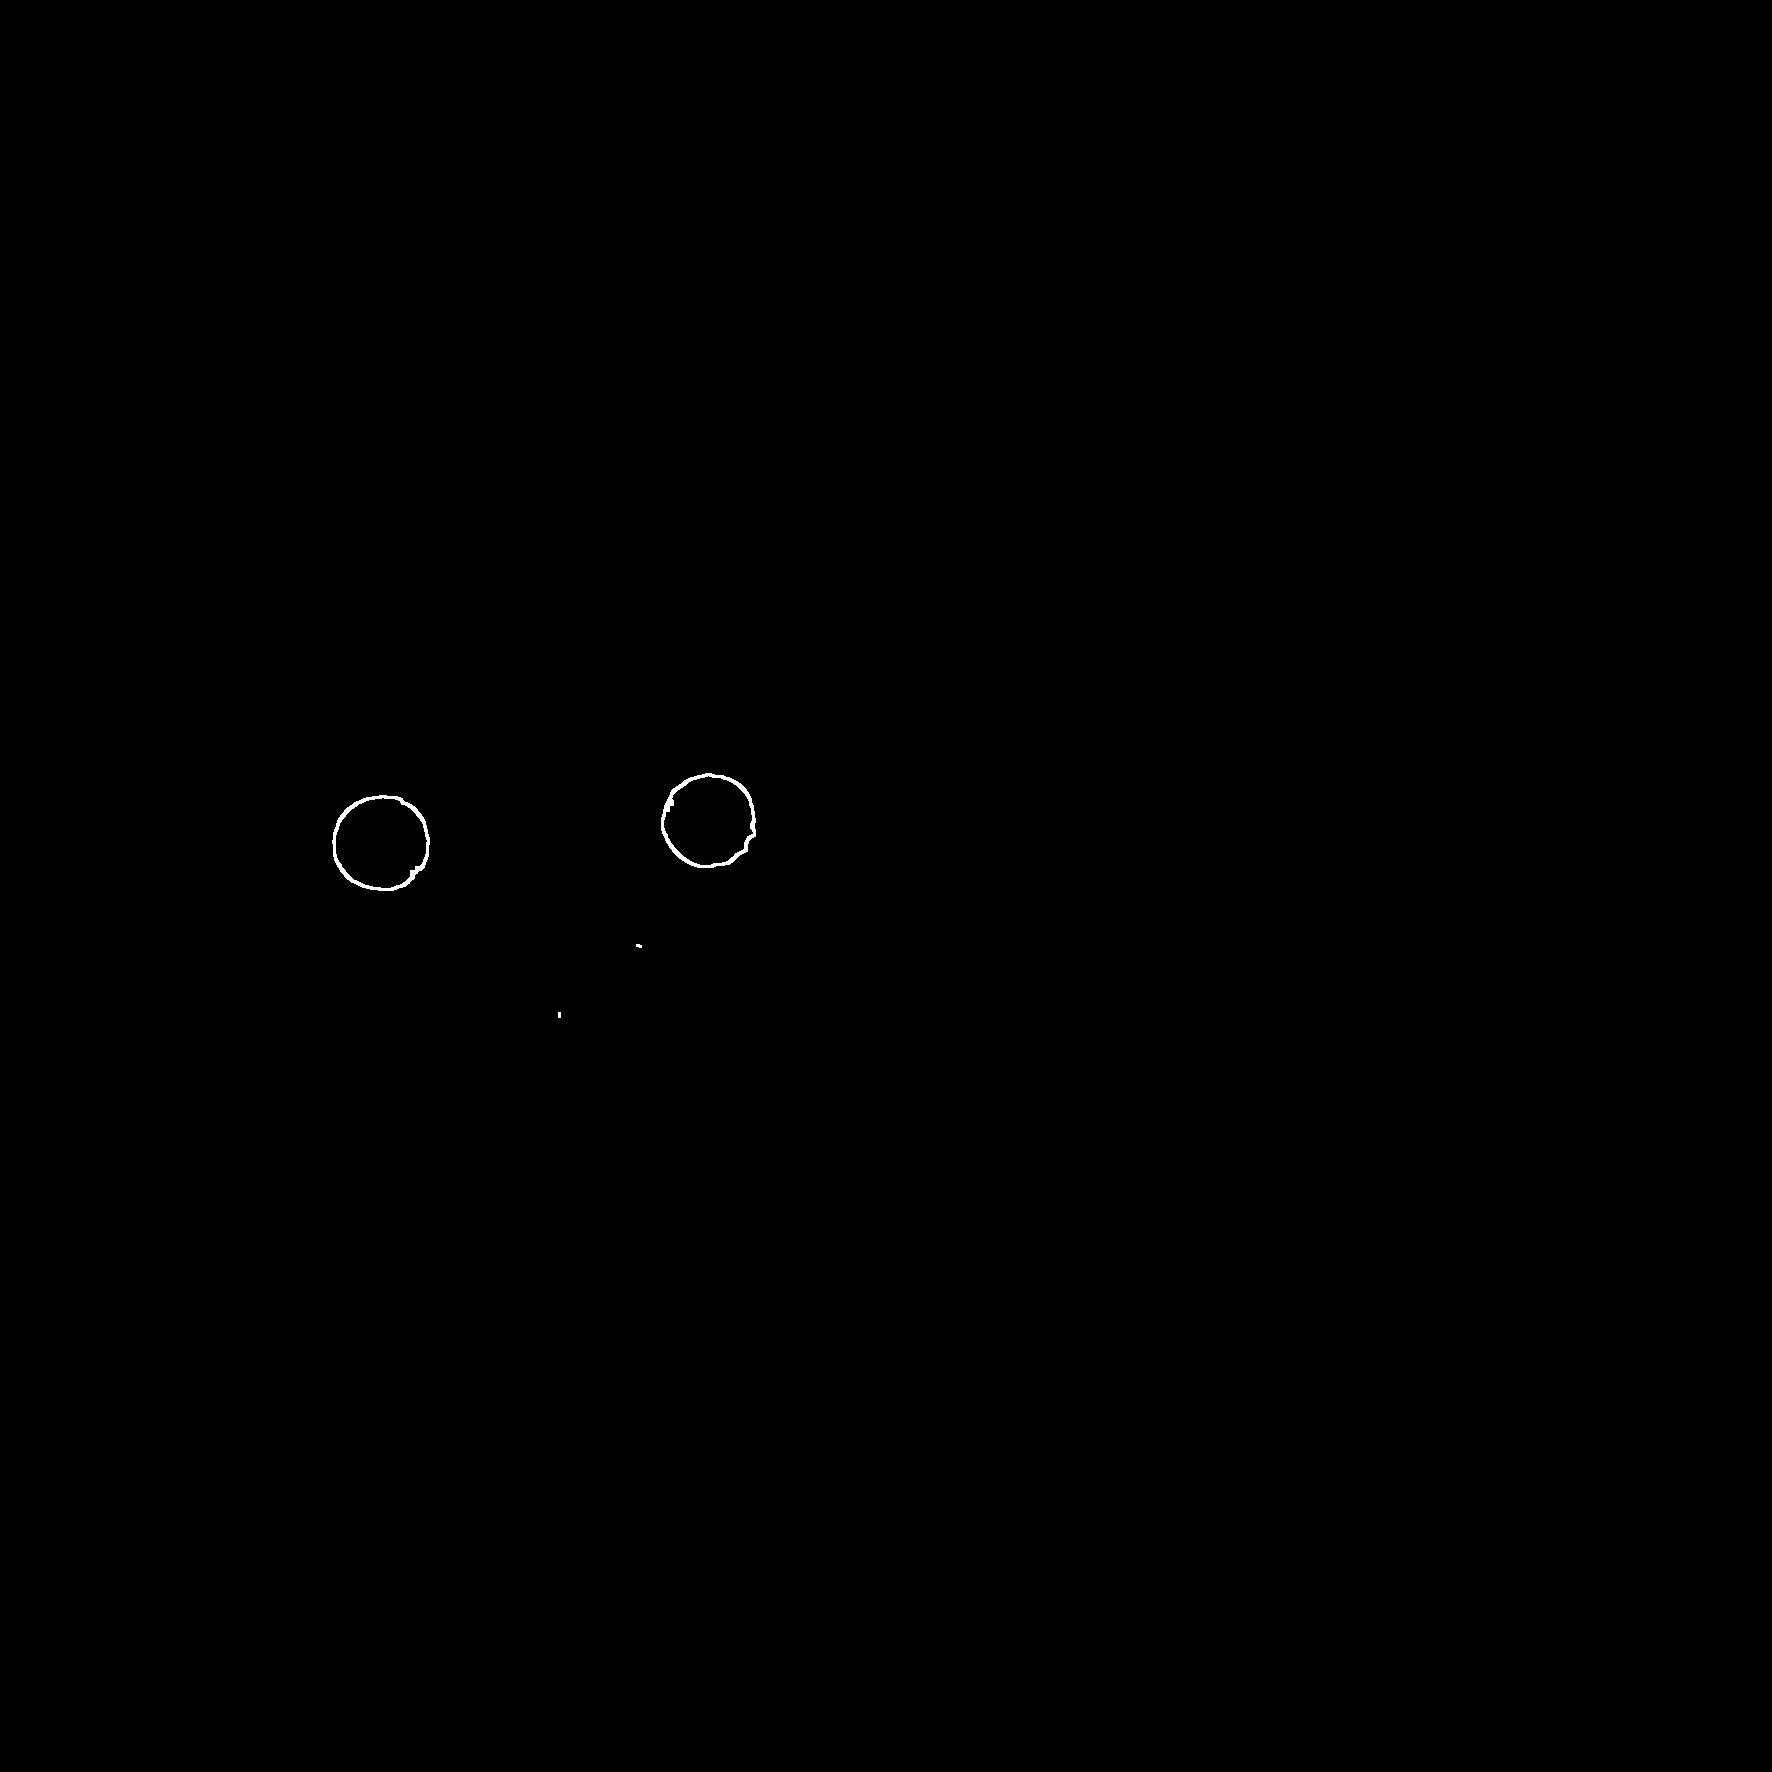

Liczba czarnych kropek: 2


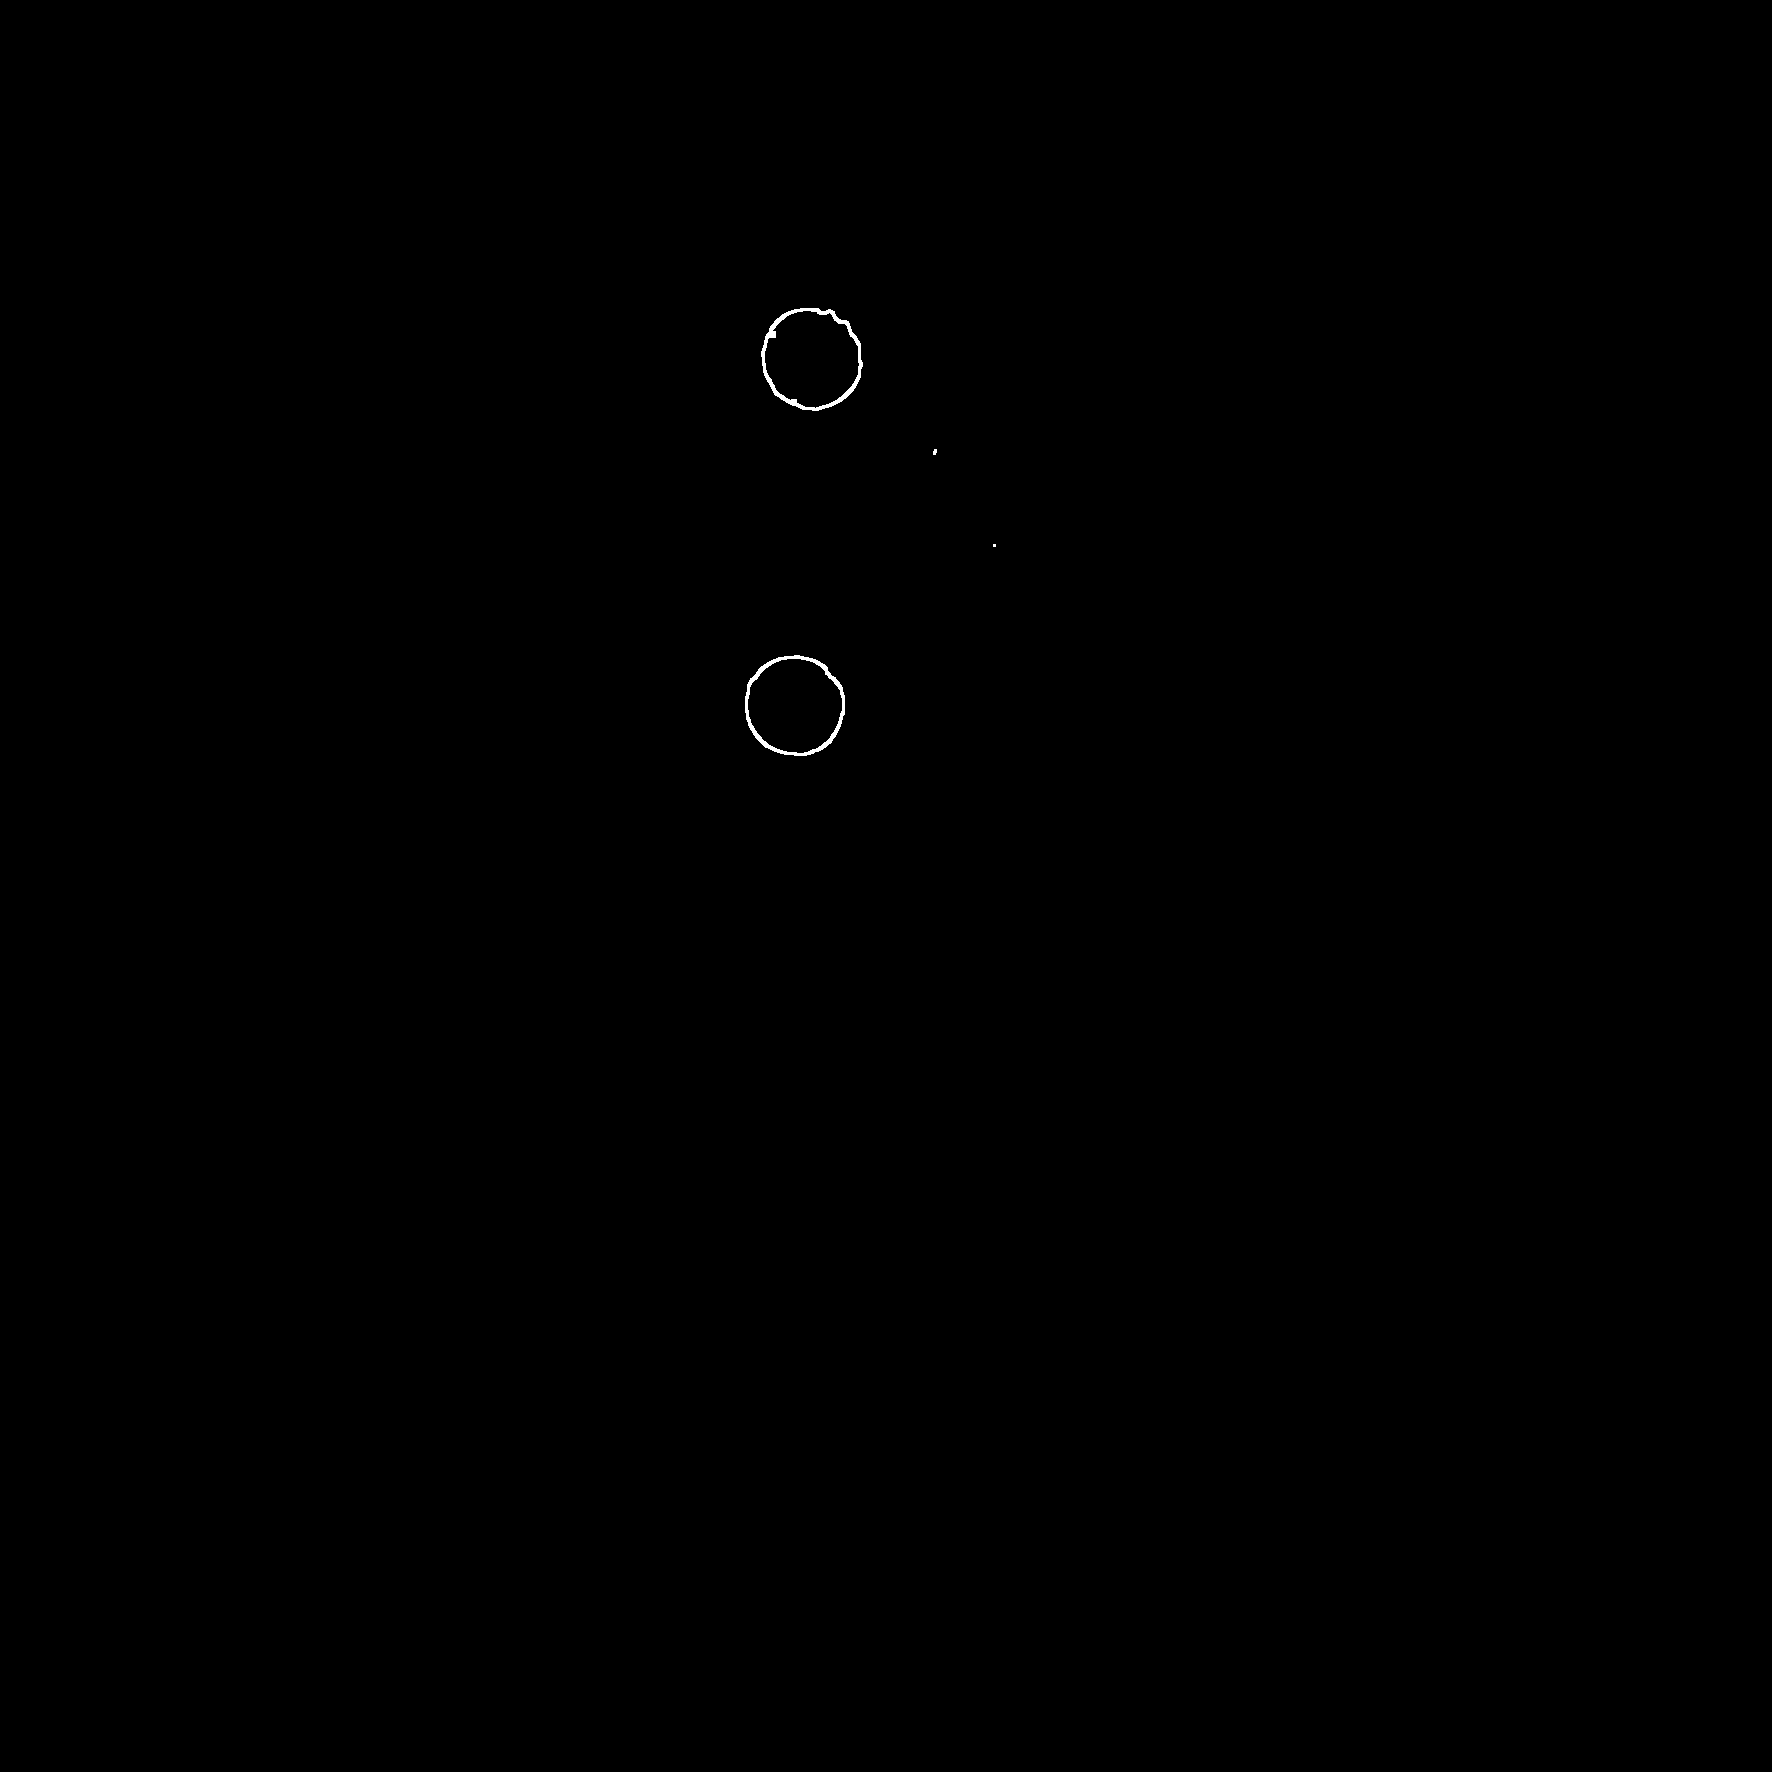

Liczba czarnych kropek: 2


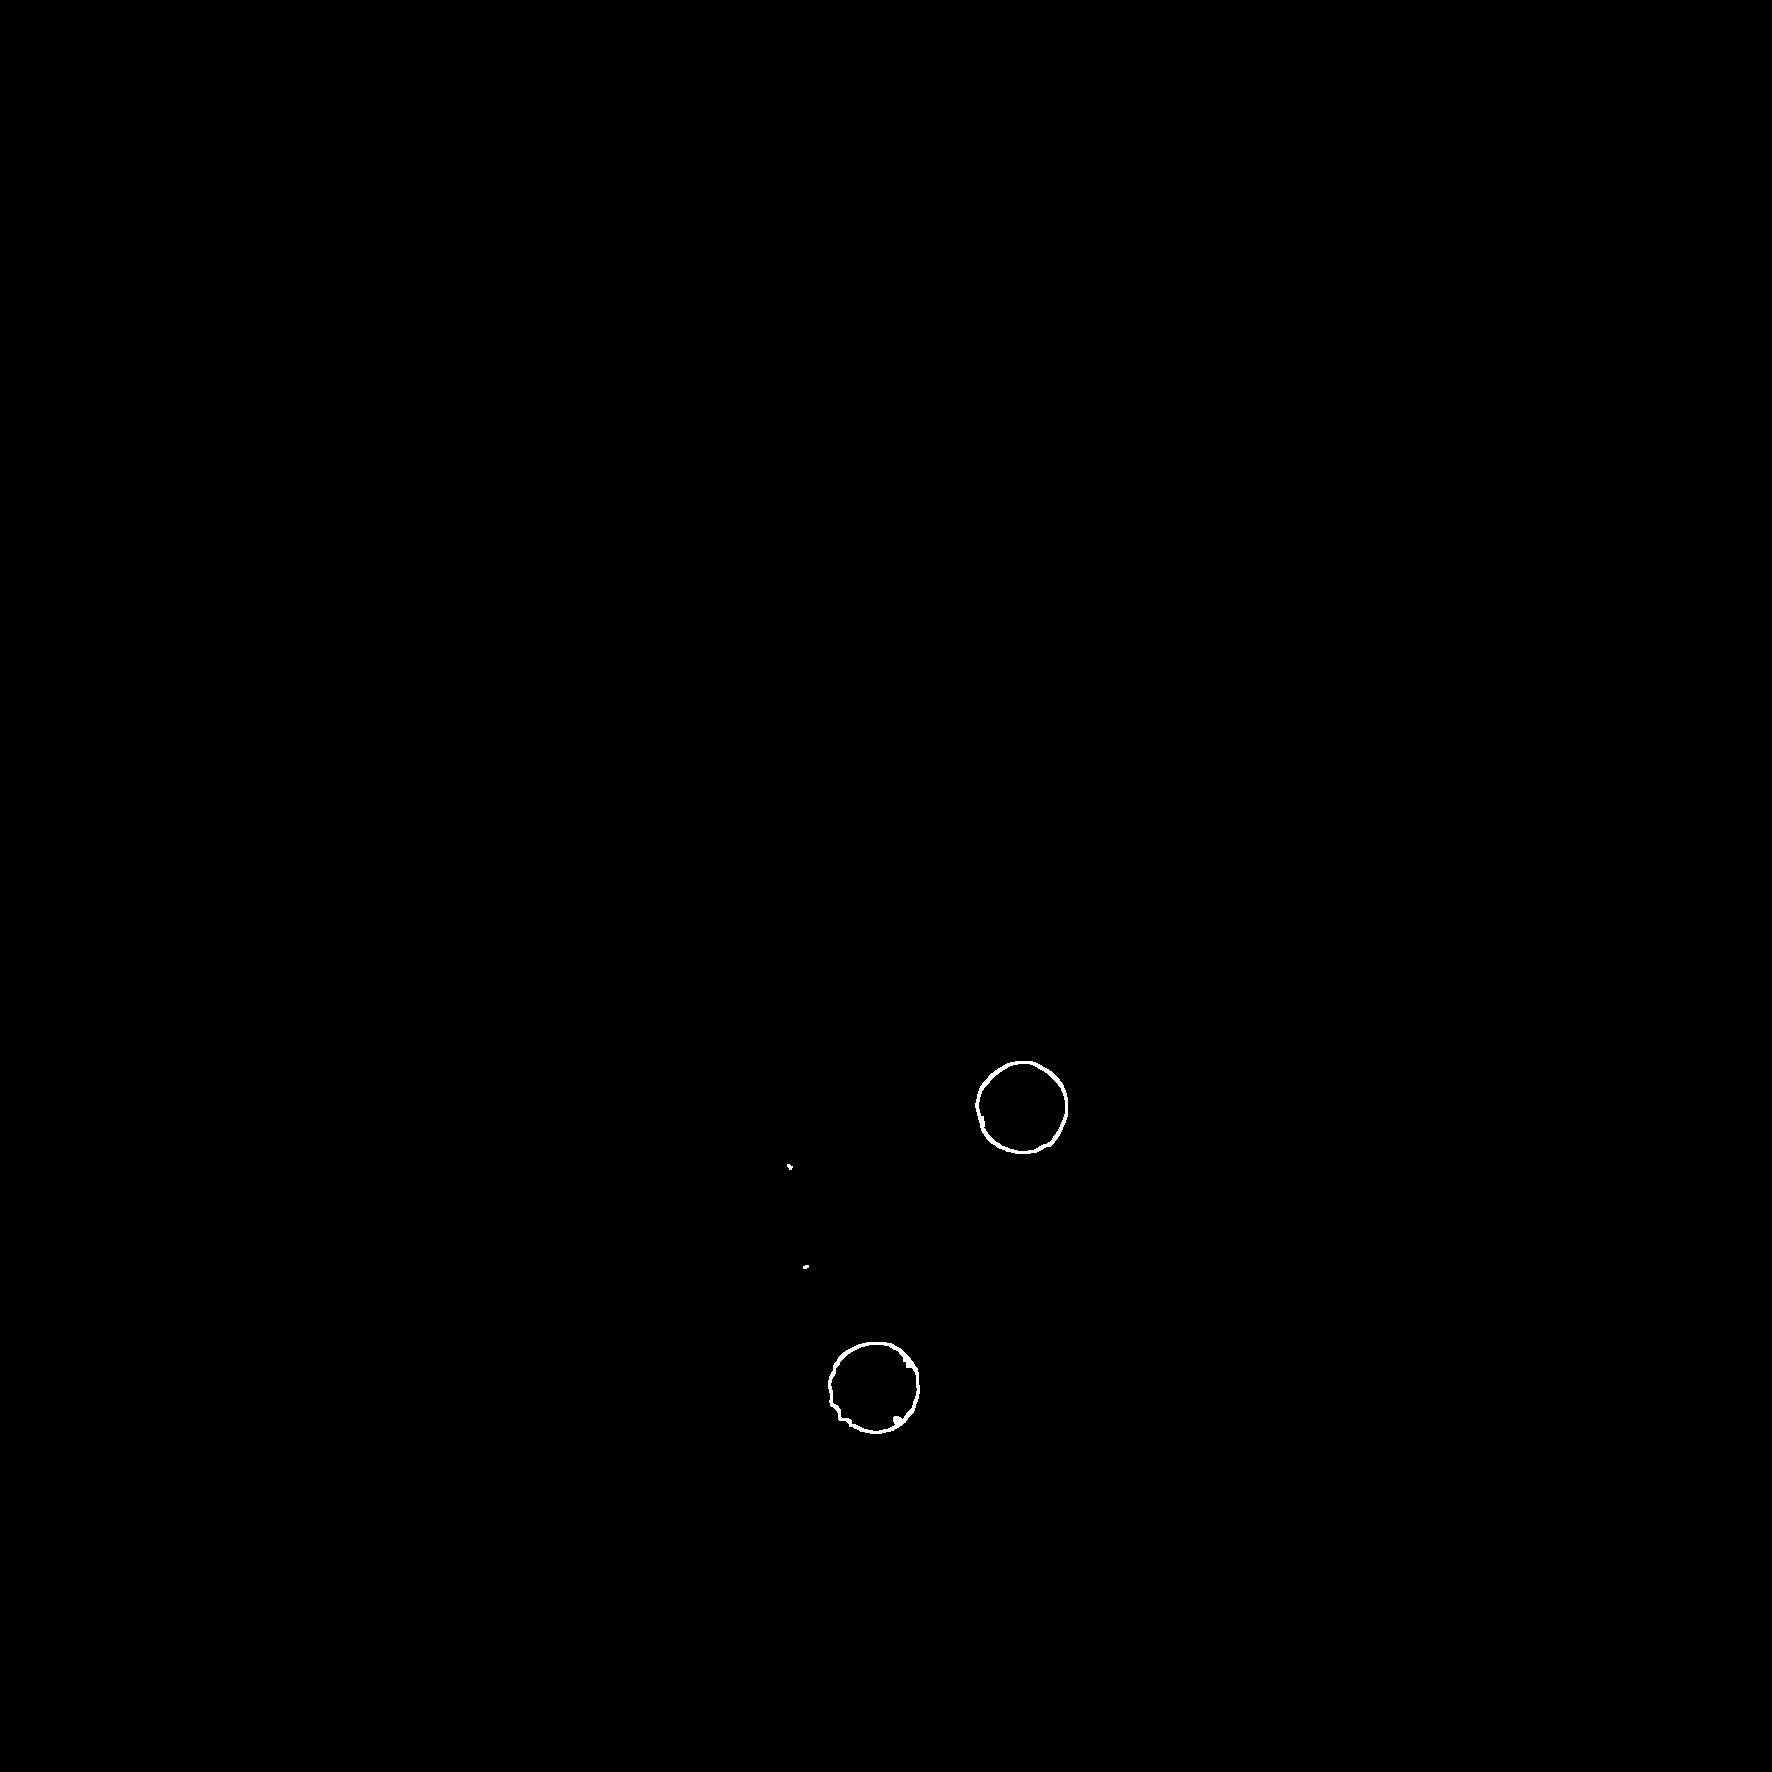

Liczba czarnych kropek: 2


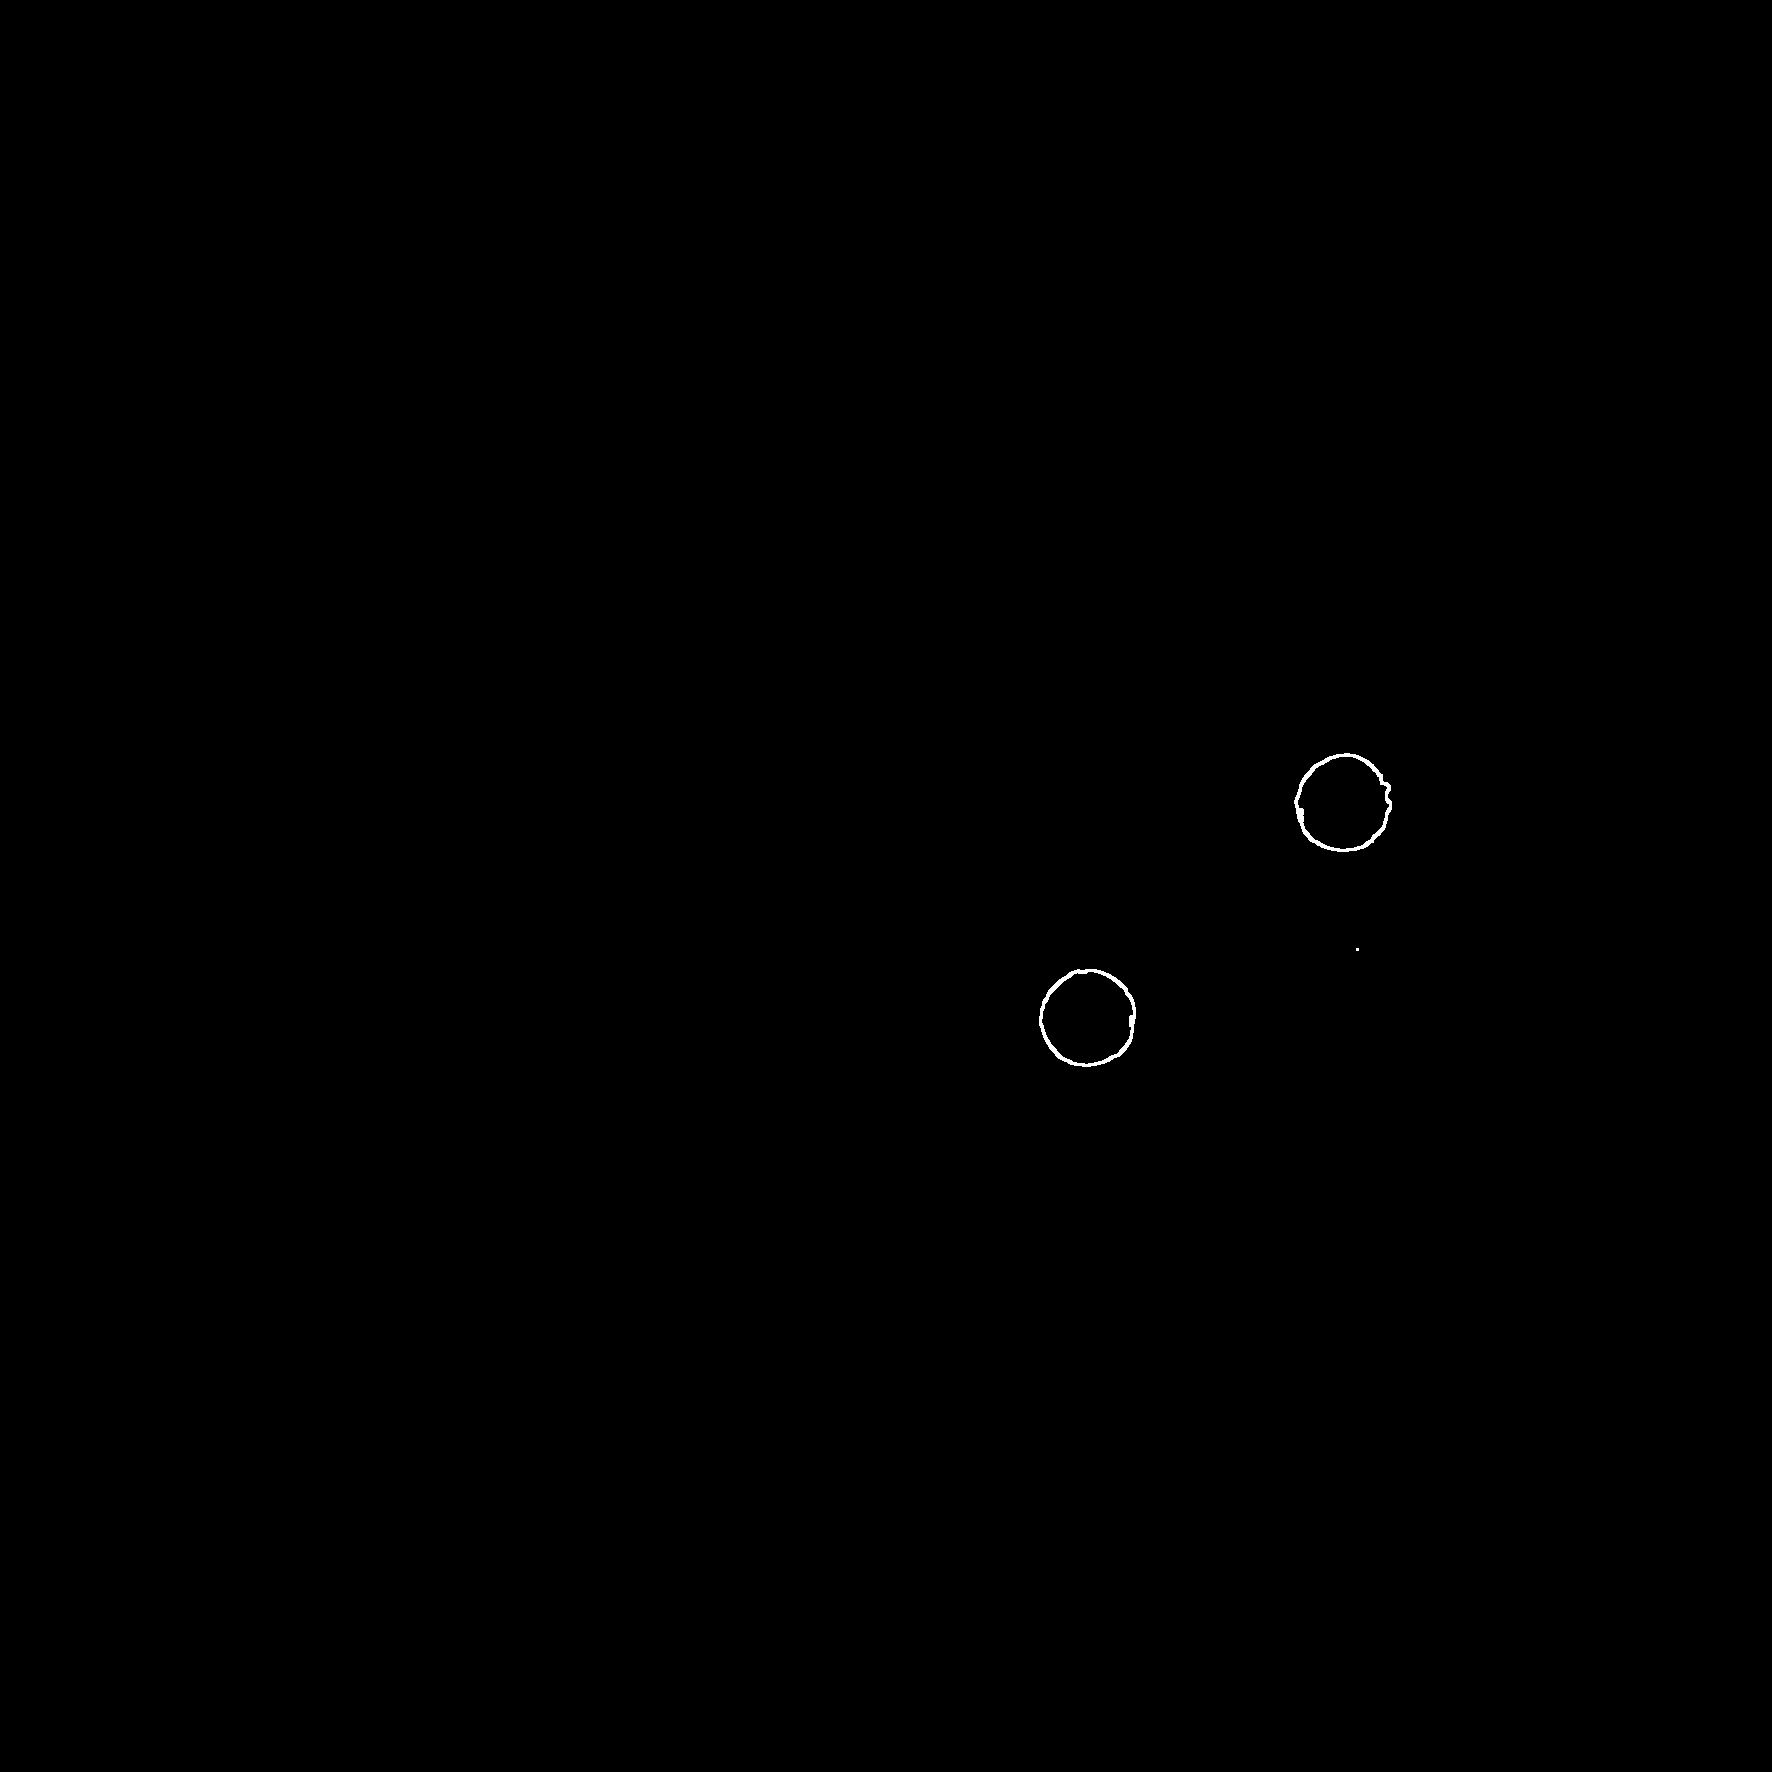

Liczba czarnych kropek: 2


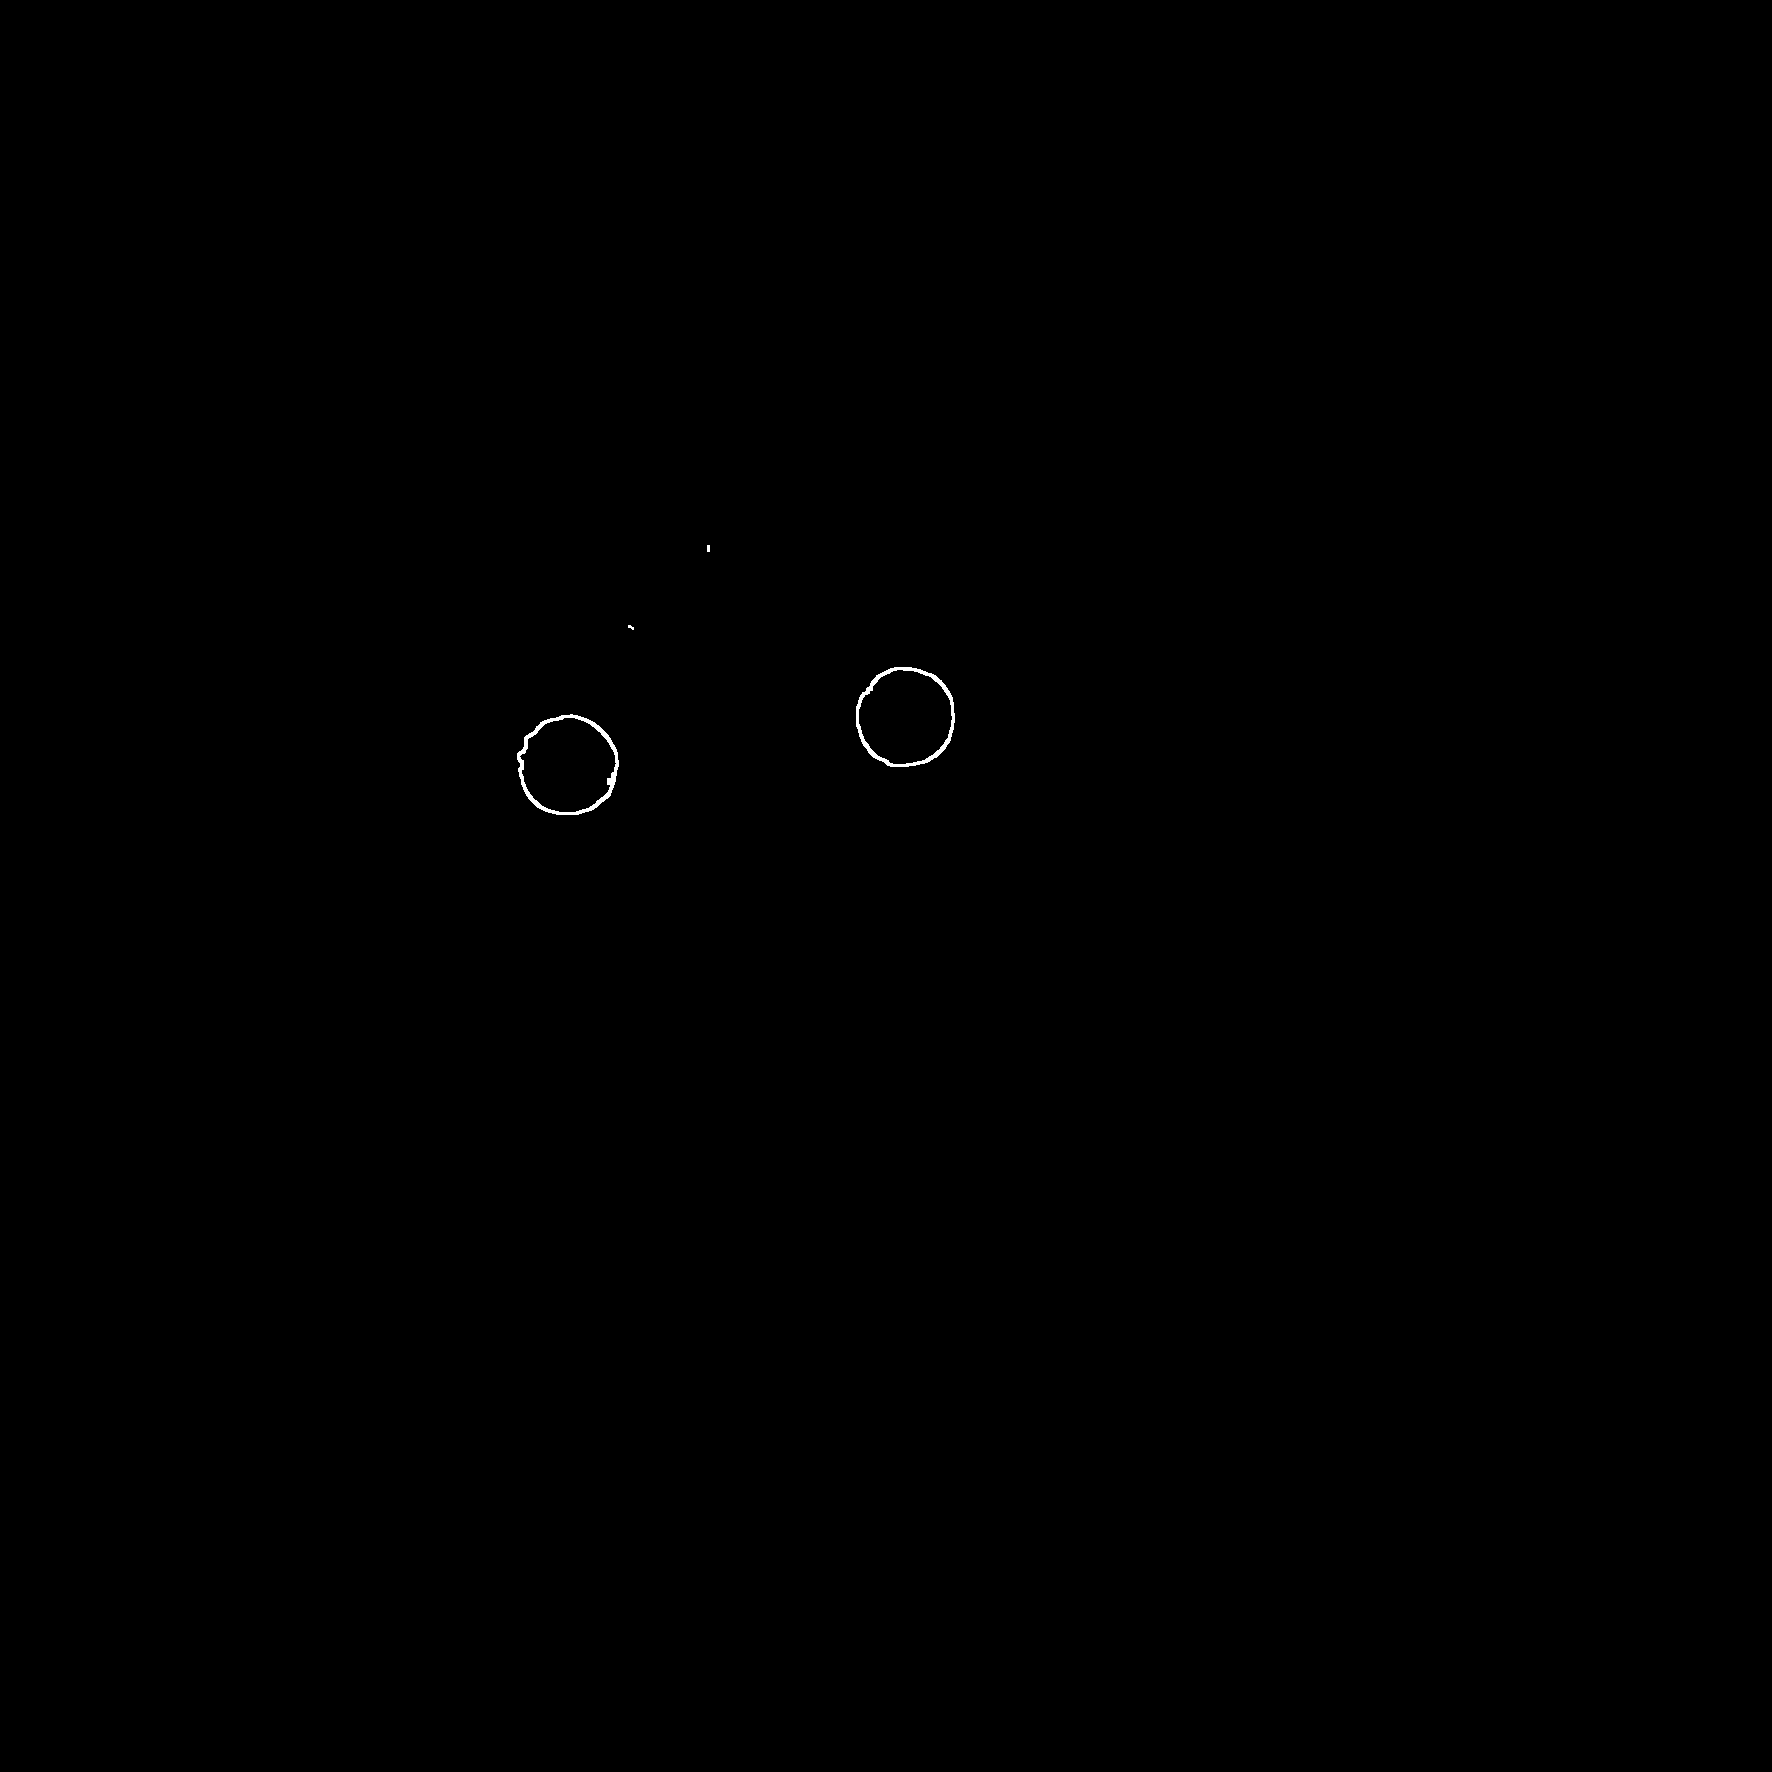

Liczba czarnych kropek: 2


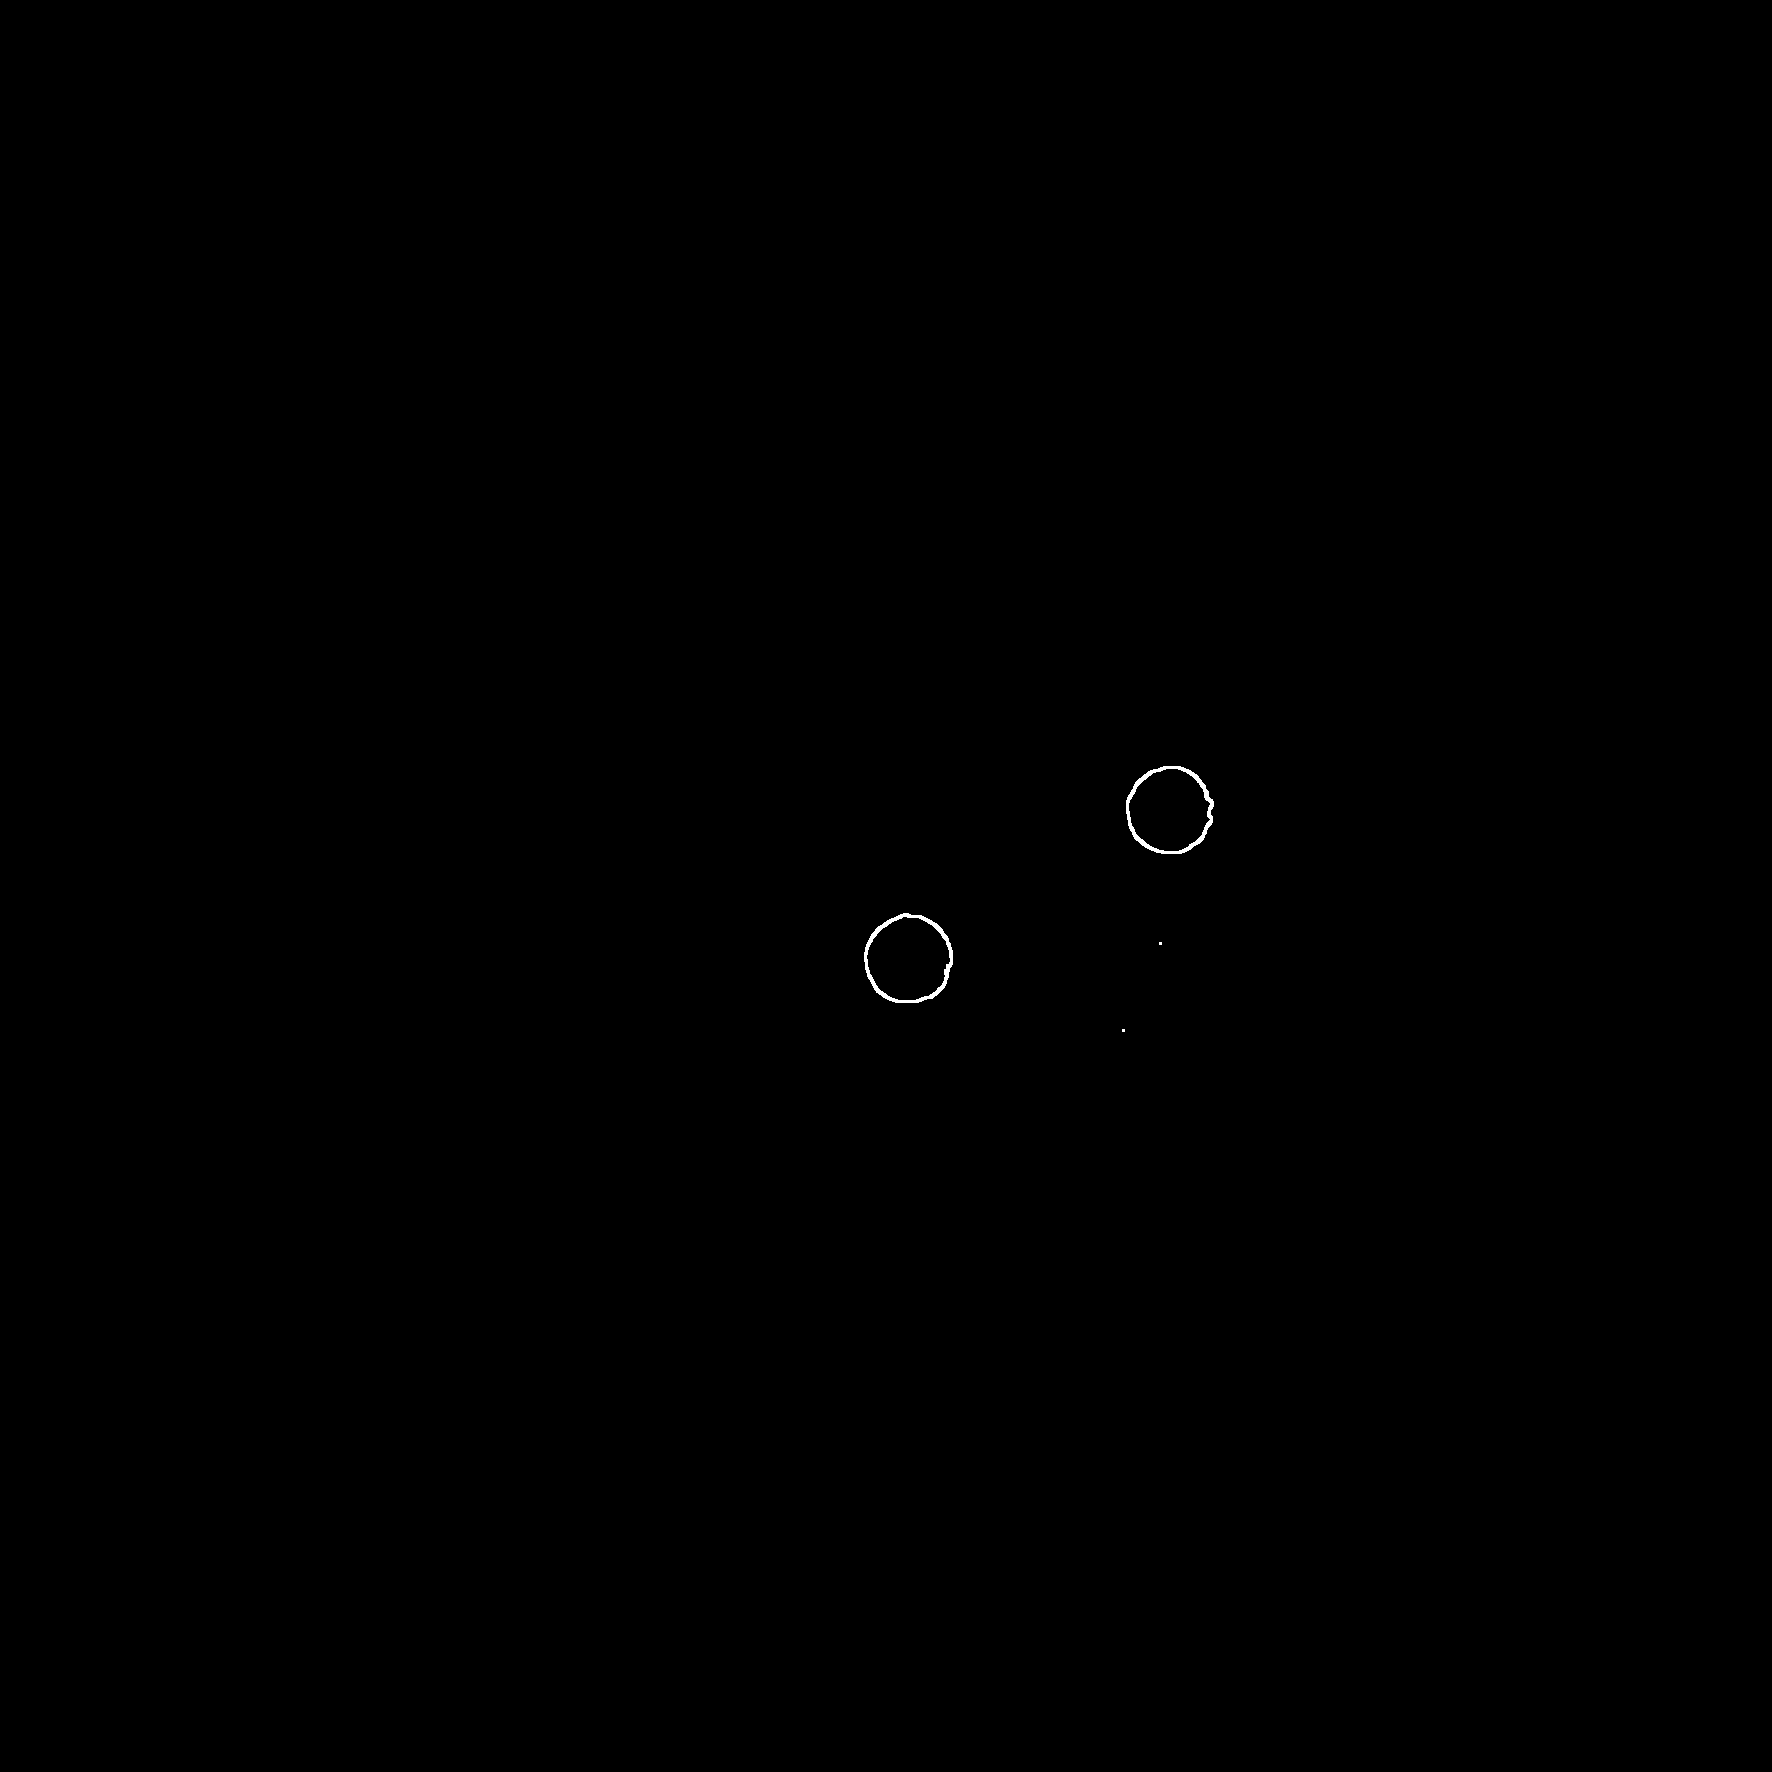

Liczba czarnych kropek: 2


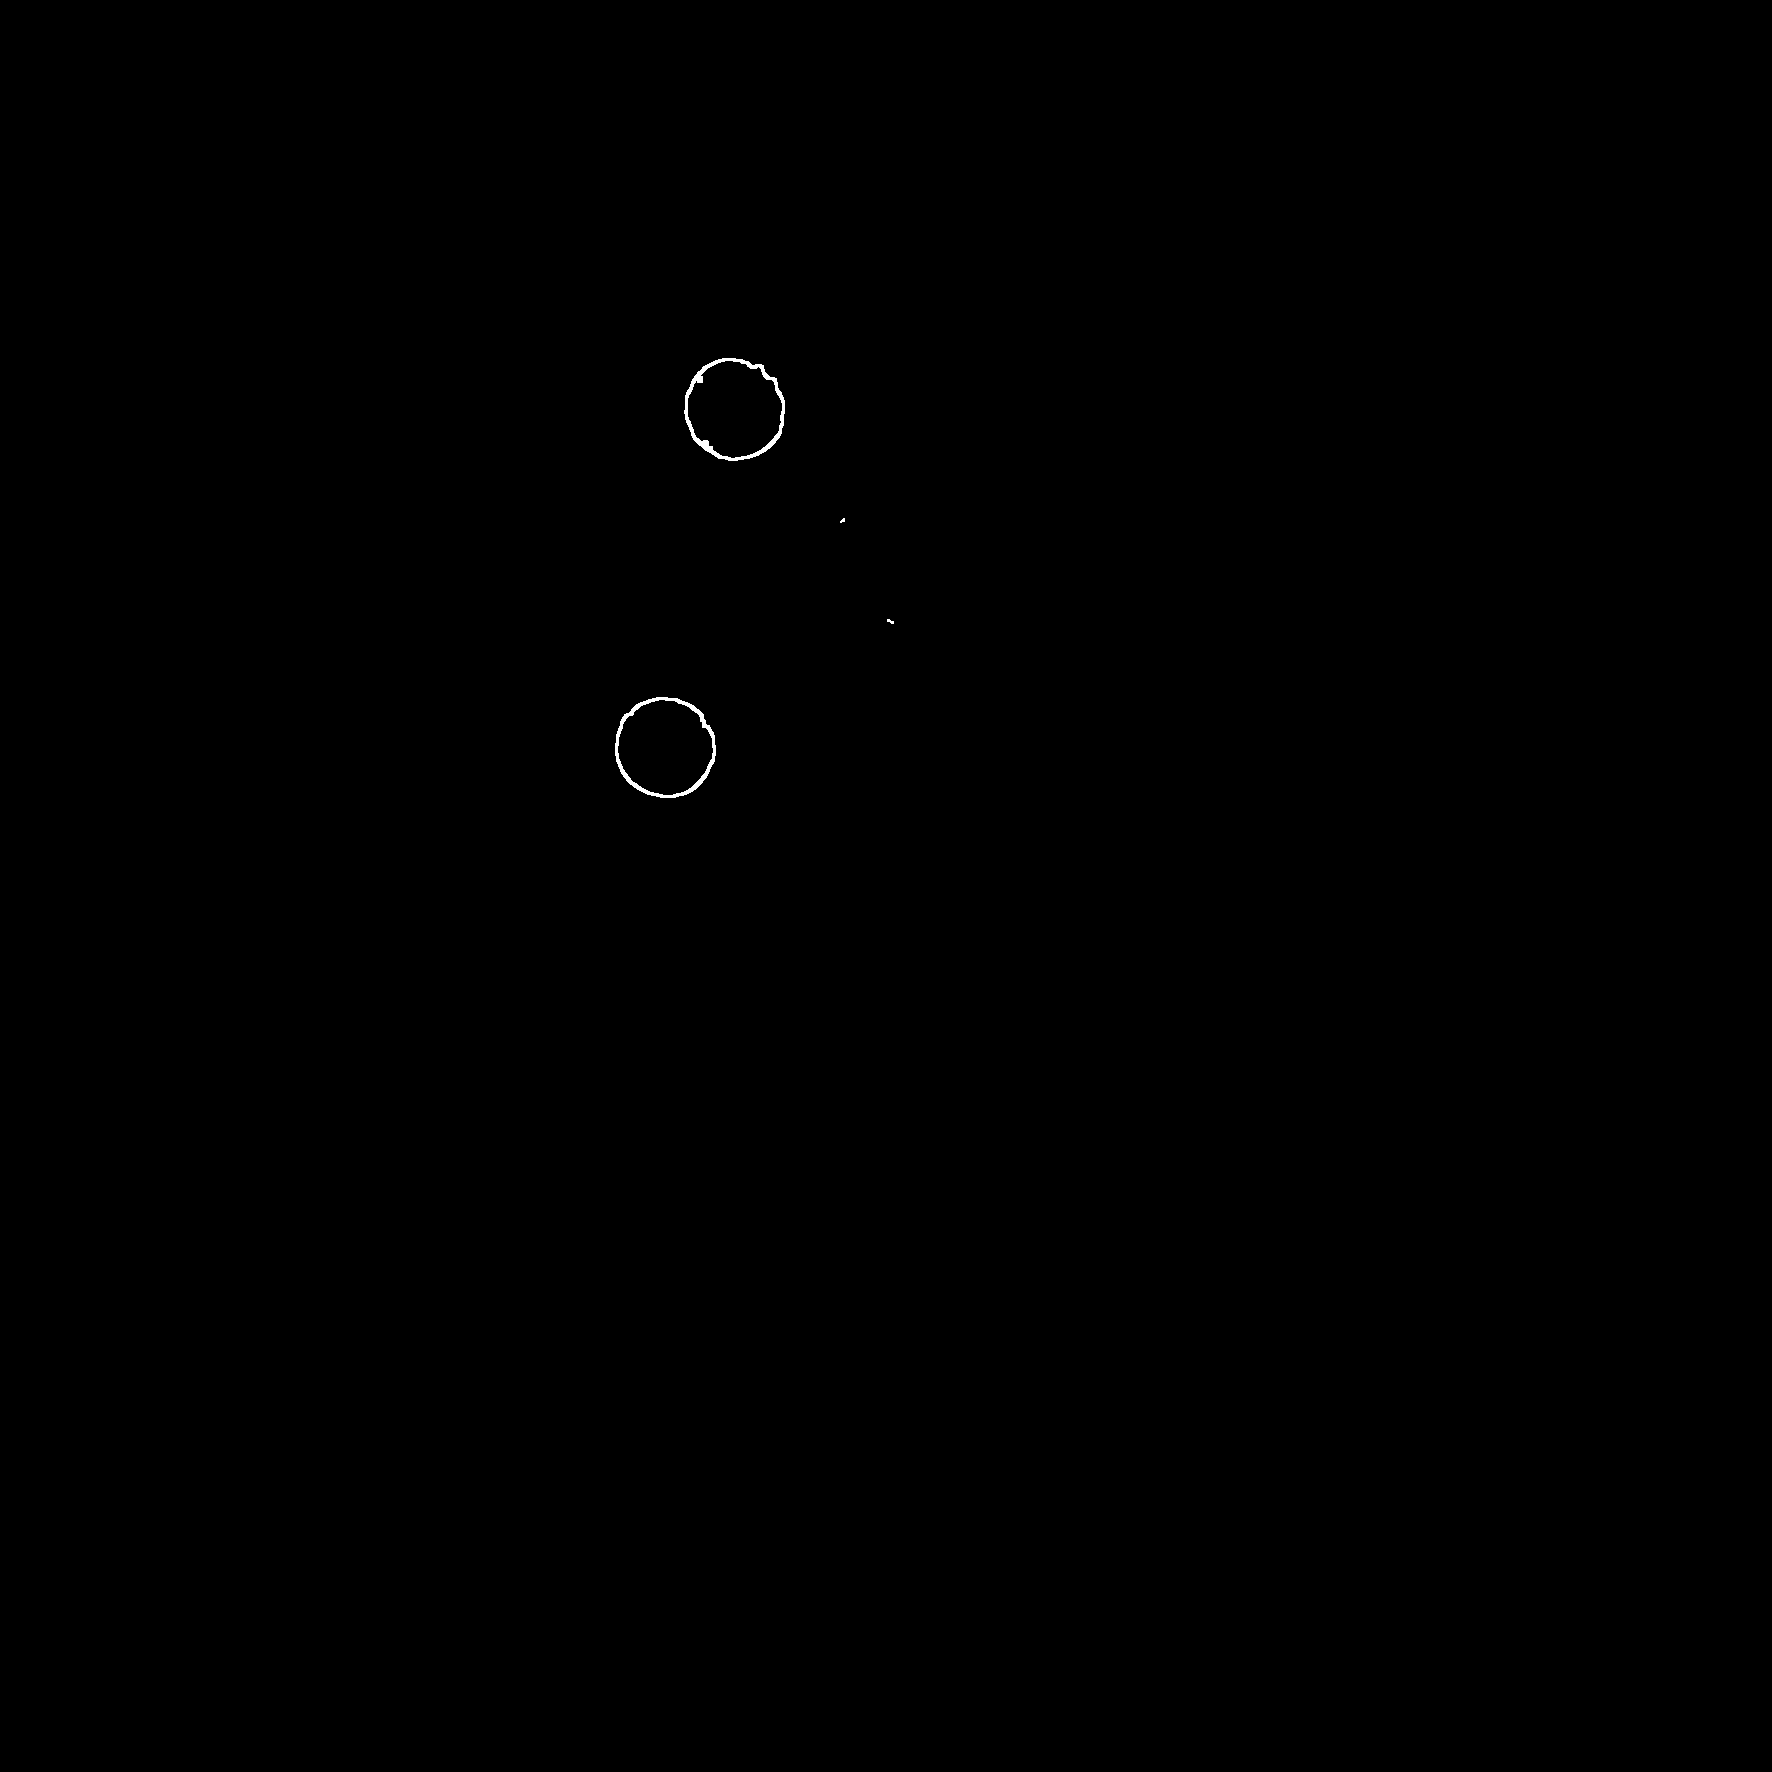

Liczba czarnych kropek: 2


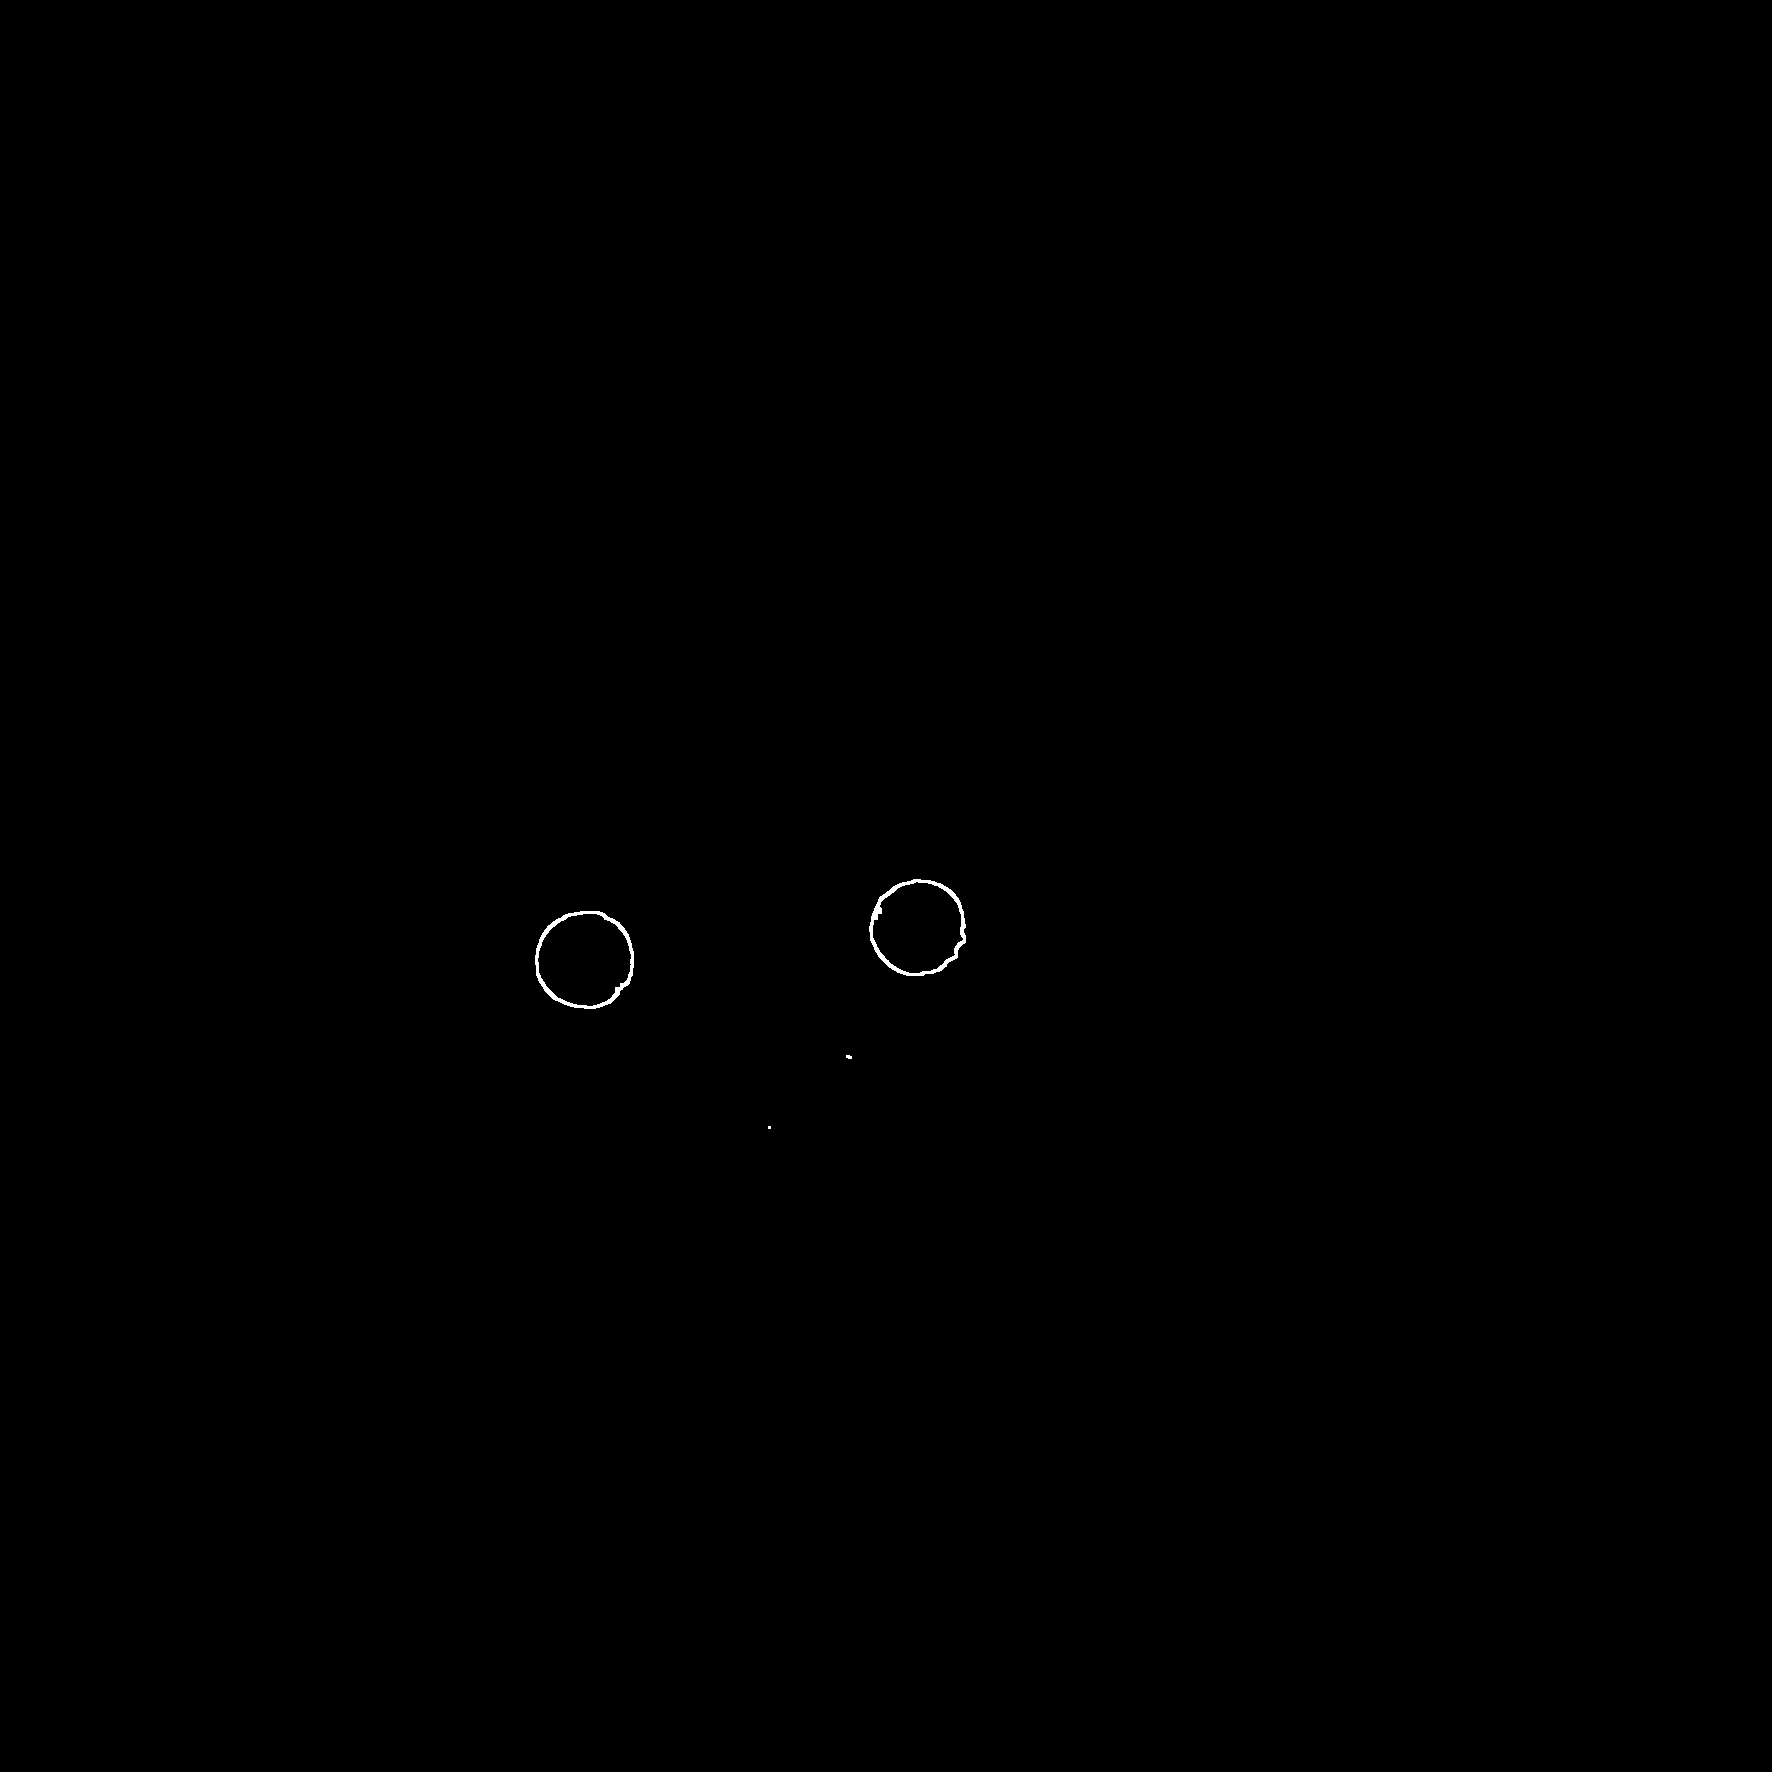

Liczba czarnych kropek: 2


KeyboardInterrupt: 

In [5]:
from skimage import io, color
import shutil

# Wyczyść workspace
folder_path = '/content/extracted_images/processed_images'
shutil.rmtree(folder_path, ignore_errors=True)

# Ścieżka do foldera zawierającego klasy
base_path = '/content/extracted_images/dataset/'

# Lista klas
classes = ['1', '2', '3', '4', '5', '6']

# Ścieżka, w którym zostaną umieszczone przetworzone obrazy
processed_path = '/content/extracted_images/processed_images/'

# Utwórz folder processed_images, jeśli nie istnieje
os.makedirs(processed_path, exist_ok=True)

for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)

        # Sprawdź, czy ścieżka prowadzi do pliku, a nie katalogu
        if os.path.isfile(image_path):
            # Wczytaj obraz
            processed_image = io.imread(image_path)

            dots_count, processed_image = count_black_dots(image_path)
            print("Liczba czarnych kropek:", dots_count)

            # Utwórz ścieżkę dla obrazu przetworzonego
            processed_image_path = os.path.join(processed_path, class_label, image_file)

            # Utwórz folder dla obrazów przetworzonych, jeśli nie istnieje
            os.makedirs(os.path.join(processed_path, class_label), exist_ok=True)

            # Zapisz przetworzony obraz w folderze processed_images
            io.imsave(processed_image_path, (processed_image * 255).astype(np.uint8), check_contrast=False)
        else:
          print("Incorrect file")


print("Images processed and saved to processed_images folder")
'''
#######################################
# Ścieżka do zdjęcia
image_path = "/content/Untitled design (1).png"

# Zliczenie czarnych kropek
dots_count = count_black_dots(image_path)
print("Liczba czarnych kropek:", dots_count)
'''


1. Ładowanie obrazu
2. Konwersja do skali szarości
3. Rozmycie Gaussowskie
4. Binaryzacja obrazu
5. Detekcja krawędzi
6. Dylatacja
7. Znalezenie konturów
7. Klasyfikacja konturów na podstawie obszaru i kolistości